In [1]:
import numpy as np
from utilities.Dataset import *
import pickle
import sys
from typing import List
import torch
import os

In [2]:
participant_data_path = './EEG/number'
processed_data_path = './EEG/processed_data'
split_data_path = './EEG/split_data'

In [3]:
ps = os.listdir(participant_data_path)
participants=[]
for p in ps:
    p= p[:3]
    if p not in participants:
        participants.append(p)
        
participants= sorted(participants)
# participants, len(participants)

In [4]:
load_name=f"userfold_data_scaled_p_dictionary-number"
data_dir = "./EEG/split_data/standard_scaled"
try:
    raw_user_fold= pickle.load(open(os.path.join(data_dir, f"{load_name}.pkl"), "rb"))
except:
    print(f"pickle file does not exist. Use EEG-Preprocess.ipynb and EEG-Split.ipynb to save data setting.")
    sys.exit()

In [5]:
from utilities.userfold_framework import *
from Models.AR_EEG_models import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List



In [48]:
from torcheeg.models import EEGNet
import Models.model_func as Model_Func
from torch import nn
from Models.multi_models import *

DEVICE= torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

learning_rate = 0.00005
batch_size = 64
n_epochs = 300
transpose_channels=True
participants_dictionary=[]
# participants_online_dictionary=[]
participants_grads_dictionary={}
b_acc_list=[]
c0_acc_list=[]
c1_acc_list=[]

# EPOCH=[
    
# ]

for i in range(len(participants)):

    train_dataloader, val_dataloader, classes, input_dim, class_ratio= user_fold_load(i,
                                                                                      raw_user_fold,
                                                                                      participants,
                                                                                      batch_size=batch_size,
                                                                                      transpose_channels=transpose_channels)

    classifier= EEGNet(
        chunk_size=input_dim[1],
        num_electrodes=input_dim[0],
        num_classes=classes,
        kernel_1= 32,
        kernel_2=32,
        F1=8,
        F2=16,
        dropout=0.5
    ).to(DEVICE)
    
    
#     optimizer= torch.optim.RMSprop(classifier.parameters(), lr=learning_rate)
    optimizer = torch.optim.Adam(classifier.parameters(), lr = learning_rate)

    
    criterion= torch.nn.CrossEntropyLoss(weight=torch.tensor(class_ratio, dtype=torch.float).to(DEVICE))
#     criterion = nn.NLLLoss(weight=torch.tensor(class_ratio, dtype=torch.float).to(DEVICE))
    
    scheduler= torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2)
    
    saved_dir= "./EEG/saved_models/Userfold/run2"
    model= EEGNet_IE_HP_Wrapper(
        DEVICE, classifier, input_dim
    ).to(DEVICE)

    train_func= eeg_grad_train
    model.training_procedure(iteration=n_epochs,
                             train_dataloader=train_dataloader,
                             val_dataloader=val_dataloader,
                             print_cycle=2,
                             path=f"./dictionary/intermdiate_dicts",
                             loss_func=criterion,
                             optimiser=optimizer, #scheduler=scheduler,
                             train_func=train_func
                            )
    if model.epoch == n_epochs+1:
        EPOCH= n_epochs
    else:
        EPOCH= model.epoch
    
    torch.save(model.state_dict(), 
           os.path.join(
               saved_dir, f"Userfold-{participants[i]}-EEGNet-IE_Multivariate-e{EPOCH}.pt"
           )
    )
    pickle.dump(model.return_IE_grad(),
                open(
                    os.path.join(
                        saved_dir, f"Userfold-{participants[i]}-EEGNet-IE_Multivariate-grad_all-e{EPOCH}.pkl"
                    ), "wb")
    )
# OR
#     model.load_state_dict(
#     torch.load(
#         open(
#             os.path.join(
#                 saved_dir, f"Userfold-{participants[i]}-EEGNet-IE_Multivariate-e{n_epochs}.pt"
#             ), "rb"
#         )
#               )
#     )
#     model.IE_grad= pickle.load(
#             open(
#                 os.path.join(
#                     saved_dir, f"Userfold-{participants[i]}-EEGNet-IE_Multivariate-grad_all-e{n_epochs}.pkl"
#                 ),"rb"
#             )
#         )
    
    
    prediction, dictionary= model.prediction_procedure(val_dataloader, dict_flag=True)
    
    ys= np.concatenate([y.detach().cpu().numpy() for x, y in val_dataloader])
    
    c0_acc, c1_acc, b_acc= calculate_accuracy(ys, prediction)
    print("c0_acc", c0_acc, ", c1_acc", c1_acc, ", b_acc", b_acc)
    b_acc_list.append(b_acc)
    c0_acc_list.append(c0_acc)
    c1_acc_list.append(c1_acc)
#     participants_grads_dictionary[participants[i]]= model.return_IE_grad()
    participants_dictionary.append(dictionary)
    
   

tmp=[]
for i, dictionary in enumerate(participants_dictionary):
    print(f"User {participants[i]} f1: {dictionary['weighted avg']['f1-score']} acc: {dictionary['accuracy']}")
    print(f" c0: {c0_acc_list[i]} c1: {c1_acc_list[i]} bacc: {b_acc_list[i]}")
    tmp.append(dictionary['weighted avg']['f1-score'])

print(f"average {np.mean(tmp)}")
print()
print(np.array(b_acc_list).mean())
print(np.array(c1_acc_list).mean())
print(np.array(c0_acc_list).mean())


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6738532290739172


Iterations:   0%|                                   | 1/300 [00:01<08:53,  1.78s/it]

Epoch:  0
t_loss:  0.6738532290739172 , v_loss:  0.6862788200378418
t_acc:  0.5558667911609088 , v_acc:  0.5714285714285714
t_recall:  0.5249173082993646 , v_recall:  0.5792792792792792
t_prec:  0.5217918227750455 , v_prec:  0.5679221982093239
t_f:  0.5167617993853904 , v_f:  0.5538016628509459
////////


Iterations:   1%|▏                                  | 2/300 [00:02<06:16,  1.26s/it]

Epoch  1 , loss 0.6549993554751078
Epoch  2 , loss 0.6279187097268946


Iterations:   1%|▎                                  | 3/300 [00:04<06:52,  1.39s/it]

Epoch:  2
t_loss:  0.6279187097268946 , v_loss:  0.6744824250539144
t_acc:  0.612822906940554 , v_acc:  0.6024844720496895
t_recall:  0.5333655865277721 , v_recall:  0.5743243243243243
t_prec:  0.5347539113428944 , v_prec:  0.5664465206185567
t_f:  0.5337742504409172 , v_f:  0.5654520917678812
////////


Iterations:   1%|▍                                  | 4/300 [00:05<05:52,  1.19s/it]

Epoch  3 , loss 0.6074624038210102
Epoch  4 , loss 0.5881404549467797


Iterations:   2%|▌                                  | 5/300 [00:06<06:28,  1.32s/it]

Epoch:  4
t_loss:  0.5881404549467797 , v_loss:  0.6560057799021403
t_acc:  0.6361655773420479 , v_acc:  0.6583850931677019
t_recall:  0.5133397839722211 , v_recall:  0.548918918918919
t_prec:  0.5190679129893434 , v_prec:  0.5673697270471464
t_f:  0.5049856655279308 , v_f:  0.5463859433430664
////////


Iterations:   2%|▋                                  | 6/300 [00:07<05:44,  1.17s/it]

Epoch  5 , loss 0.5777985523728764
Epoch  6 , loss 0.5517221379513834


Iterations:   2%|▊                                  | 7/300 [00:09<06:21,  1.30s/it]

Epoch:  6
t_loss:  0.5517221379513834 , v_loss:  0.63778688510259
t_acc:  0.6691565515094927 , v_acc:  0.6832298136645962
t_recall:  0.5172135984957659 , v_recall:  0.522972972972973
t_prec:  0.5388212279666368 , v_prec:  0.5772727272727273
t_f:  0.4918260993770984 , v_f:  0.4842660636894668
////////


Iterations:   3%|▉                                  | 8/300 [00:10<05:46,  1.19s/it]

Epoch  7 , loss 0.5404739029267255
Epoch  8 , loss 0.529801923270319


Iterations:   3%|█                                  | 9/300 [00:11<06:20,  1.31s/it]

Epoch:  8
t_loss:  0.529801923270319 , v_loss:  0.6277434031168619
t_acc:  0.6800497976968565 , v_acc:  0.6894409937888198
t_recall:  0.5115294876545752 , v_recall:  0.510990990990991
t_prec:  0.54031981953155 , v_prec:  0.5971337579617835
t_f:  0.46851885225853784 , v_f:  0.4437534549474848
////////


Iterations:   3%|█▏                                | 10/300 [00:12<05:42,  1.18s/it]

Epoch  9 , loss 0.5187135490716672
Epoch  10 , loss 0.5072953519867915


Iterations:   4%|█▏                                | 11/300 [00:14<06:13,  1.29s/it]

Epoch:  10
t_loss:  0.5072953519867915 , v_loss:  0.6246070166428884
t_acc:  0.6850295673825085 , v_acc:  0.6956521739130435
t_recall:  0.508208094865566 , v_recall:  0.51
t_prec:  0.5405975073313782 , v_prec:  0.846875
t_f:  0.4536199095022625 , v_f:  0.42920193907821425
////////


Iterations:   4%|█▎                                | 12/300 [00:14<05:37,  1.17s/it]

Epoch  11 , loss 0.4965477112461539
Epoch  12 , loss 0.4897553429884069


Iterations:   4%|█▍                                | 13/300 [00:16<06:08,  1.28s/it]

Epoch:  12
t_loss:  0.4897553429884069 , v_loss:  0.6247861385345459
t_acc:  0.6928104575163399 , v_acc:  0.6894409937888198
t_recall:  0.508912861475961 , v_recall:  0.5
t_prec:  0.5732736572890026 , v_prec:  0.3447204968944099
t_f:  0.44372849121774244 , v_f:  0.4080882352941176
////////


Iterations:   5%|█▌                                | 14/300 [00:17<05:33,  1.17s/it]

Epoch  13 , loss 0.48551855134029015
Epoch  14 , loss 0.4815371375457913


Iterations:   5%|█▋                                | 15/300 [00:18<06:04,  1.28s/it]

Epoch:  14
t_loss:  0.4815371375457913 , v_loss:  0.6253727773825327
t_acc:  0.6931216931216931 , v_acc:  0.6894409937888198
t_recall:  0.5048235681640384 , v_recall:  0.5
t_prec:  0.5618075340297563 , v_prec:  0.3447204968944099
t_f:  0.4308889722430607 , v_f:  0.4080882352941176
////////


Iterations:   5%|█▊                                | 16/300 [00:19<05:31,  1.17s/it]

Epoch  15 , loss 0.4838354125911114
Epoch  16 , loss 0.475730313389909


Iterations:   6%|█▉                                | 17/300 [00:21<06:05,  1.29s/it]

Epoch:  16
t_loss:  0.475730313389909 , v_loss:  0.628402183453242
t_acc:  0.690631808278867 , v_acc:  0.6894409937888198
t_recall:  0.4998709872222451 , v_recall:  0.5
t_prec:  0.49777812795461707 , v_prec:  0.3447204968944099
t_f:  0.41988693167947366 , v_f:  0.4080882352941176
////////


Iterations:   6%|██                                | 18/300 [00:22<05:34,  1.18s/it]

Epoch  17 , loss 0.47348123671961767
Epoch  18 , loss 0.46094778238558304


Iterations:   6%|██▏                               | 19/300 [00:23<06:05,  1.30s/it]

Epoch:  18
t_loss:  0.46094778238558304 , v_loss:  0.6310342450936636
t_acc:  0.6984126984126984 , v_acc:  0.6894409937888198
t_recall:  0.5069014973717078 , v_recall:  0.5
t_prec:  0.6892785445420326 , v_prec:  0.3447204968944099
t_f:  0.42760745975240416 , v_f:  0.4080882352941176
////////


Iterations:   7%|██▎                               | 20/300 [00:24<05:32,  1.19s/it]

Epoch  19 , loss 0.4615575782224244
Epoch  20 , loss 0.45358501170195786


Iterations:   7%|██▍                               | 21/300 [00:26<06:02,  1.30s/it]

Epoch:  20
t_loss:  0.45358501170195786 , v_loss:  0.6313068966070811
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5023002703778428 , v_recall:  0.5
t_prec:  0.5982952768220207 , v_prec:  0.3447204968944099
t_f:  0.4180261984276795 , v_f:  0.4080882352941176
////////


Iterations:   7%|██▍                               | 22/300 [00:27<05:31,  1.19s/it]

Epoch  21 , loss 0.4575117434941086
Epoch  22 , loss 0.45917076632088305


Iterations:   8%|██▌                               | 23/300 [00:28<06:01,  1.31s/it]

Epoch:  22
t_loss:  0.45917076632088305 , v_loss:  0.6327433784802755
t_acc:  0.6959228135698724 , v_acc:  0.6894409937888198
t_recall:  0.5025239840243751 , v_recall:  0.5
t_prec:  0.6150093808630395 , v_prec:  0.3447204968944099
t_f:  0.4181429031380904 , v_f:  0.4080882352941176
////////


Iterations:   8%|██▋                               | 24/300 [00:29<05:26,  1.18s/it]

Epoch  23 , loss 0.44908492705401254
Epoch  24 , loss 0.4464171715811187


Iterations:   8%|██▊                               | 25/300 [00:31<05:55,  1.29s/it]

Epoch:  24
t_loss:  0.4464171715811187 , v_loss:  0.6331938008467356
t_acc:  0.6962340491752257 , v_acc:  0.6894409937888198
t_recall:  0.5033227652653683 , v_recall:  0.5
t_prec:  0.6262910798122066 , v_prec:  0.3447204968944099
t_f:  0.4201690740864009 , v_f:  0.4080882352941176
////////


Iterations:   9%|██▉                               | 26/300 [00:32<05:23,  1.18s/it]

Epoch  25 , loss 0.44651803841777876
Epoch  26 , loss 0.4470703765457752


Iterations:   9%|███                               | 27/300 [00:33<05:53,  1.30s/it]

Epoch:  26
t_loss:  0.4470703765457752 , v_loss:  0.6347283522288004
t_acc:  0.6968565203859322 , v_acc:  0.6894409937888198
t_recall:  0.5029075911667422 , v_recall:  0.5
t_prec:  0.6984233531064628 , v_prec:  0.3447204968944099
t_f:  0.41753003679311723 , v_f:  0.4080882352941176
////////


Iterations:   9%|███▏                              | 28/300 [00:34<05:22,  1.18s/it]

Epoch  27 , loss 0.44786515890383255
Epoch  28 , loss 0.44511104623476666


Iterations:  10%|███▎                              | 29/300 [00:36<05:52,  1.30s/it]

Epoch:  28
t_loss:  0.44511104623476666 , v_loss:  0.6329911351203918
t_acc:  0.6962340491752257 , v_acc:  0.6894409937888198
t_recall:  0.5024601638736773 , v_recall:  0.5
t_prec:  0.6399953139643861 , v_prec:  0.3447204968944099
t_f:  0.4172988159743127 , v_f:  0.4080882352941176
////////


Iterations:  10%|███▍                              | 30/300 [00:37<05:19,  1.18s/it]

Epoch  29 , loss 0.4498806806171642
Epoch  30 , loss 0.4454912812102075


Iterations:  10%|███▌                              | 31/300 [00:38<05:48,  1.29s/it]

Epoch:  30
t_loss:  0.4454912812102075 , v_loss:  0.6304636796315511
t_acc:  0.6943666355431062 , v_acc:  0.6894409937888198
t_recall:  0.49968021300833093 , v_recall:  0.5
t_prec:  0.47273790951638067 , v_prec:  0.3447204968944099
t_f:  0.41177104462474656 , v_f:  0.4080882352941176
////////


Iterations:  11%|███▋                              | 32/300 [00:39<05:16,  1.18s/it]

Epoch  31 , loss 0.44066649441625555
Epoch  32 , loss 0.43428608249215517


Iterations:  11%|███▋                              | 33/300 [00:41<05:48,  1.31s/it]

Epoch:  32
t_loss:  0.43428608249215517 , v_loss:  0.6274472177028656
t_acc:  0.6968565203859322 , v_acc:  0.6894409937888198
t_recall:  0.5031951249639725 , v_recall:  0.5
t_prec:  0.6818181818181819 , v_prec:  0.3447204968944099
t_f:  0.418492875777644 , v_f:  0.4080882352941176
////////


Iterations:  11%|███▊                              | 34/300 [00:42<05:17,  1.19s/it]

Epoch  33 , loss 0.43894339659634757
Epoch  34 , loss 0.44115781784057617


Iterations:  12%|███▉                              | 35/300 [00:43<05:46,  1.31s/it]

Epoch:  34
t_loss:  0.44115781784057617 , v_loss:  0.622764969865481
t_acc:  0.6959228135698724 , v_acc:  0.6894409937888198
t_recall:  0.5019489164299145 , v_recall:  0.5
t_prec:  0.6209471353131566 , v_prec:  0.3447204968944099
t_f:  0.416219391790475 , v_f:  0.4080882352941176
////////


Iterations:  12%|████                              | 36/300 [00:44<05:14,  1.19s/it]

Epoch  35 , loss 0.4383828569861019
Epoch  36 , loss 0.44370682333029954


Iterations:  12%|████▏                             | 37/300 [00:46<05:44,  1.31s/it]

Epoch:  36
t_loss:  0.44370682333029954 , v_loss:  0.620803619424502
t_acc:  0.6977902272019919 , v_acc:  0.6894409937888198
t_recall:  0.5047288672952608 , v_recall:  0.5
t_prec:  0.7154784240150094 , v_prec:  0.3447204968944099
t_f:  0.4217162322897499 , v_f:  0.4080882352941176
////////


Iterations:  13%|████▎                             | 38/300 [00:47<05:12,  1.19s/it]

Epoch  37 , loss 0.4357687416029911
Epoch  38 , loss 0.44224734458268855


Iterations:  13%|████▍                             | 39/300 [00:48<05:38,  1.30s/it]

Epoch:  38
t_loss:  0.44224734458268855 , v_loss:  0.6185231655836105
t_acc:  0.6946778711484594 , v_acc:  0.6894409937888198
t_recall:  0.5013415956410151 , v_recall:  0.5
t_prec:  0.553973717146433 , v_prec:  0.3447204968944099
t_f:  0.4167203167374342 , v_f:  0.4080882352941176
////////


Iterations:  13%|████▌                             | 40/300 [00:49<05:06,  1.18s/it]

Epoch  39 , loss 0.4404221463437174
Epoch  40 , loss 0.42961300471249747


Iterations:  14%|████▋                             | 41/300 [00:51<05:35,  1.30s/it]

Epoch:  40
t_loss:  0.42961300471249747 , v_loss:  0.6138400385777155
t_acc:  0.7002801120448179 , v_acc:  0.6894409937888198
t_recall:  0.507956245453672 , v_recall:  0.5
t_prec:  0.8200876095118899 , v_prec:  0.3447204968944099
t_f:  0.42742269624683904 , v_f:  0.4080882352941176
////////


Iterations:  14%|████▊                             | 42/300 [00:52<05:07,  1.19s/it]

Epoch  41 , loss 0.4413891364546383
Epoch  42 , loss 0.44345326750886205


Iterations:  14%|████▊                             | 43/300 [00:53<05:37,  1.31s/it]

Epoch:  42
t_loss:  0.44345326750886205 , v_loss:  0.6112627486387888
t_acc:  0.6974789915966386 , v_acc:  0.6894409937888198
t_recall:  0.504217619851498 , v_recall:  0.5
t_prec:  0.7058455767427321 , v_prec:  0.3447204968944099
t_f:  0.4206437662507272 , v_f:  0.4080882352941176
////////


Iterations:  15%|████▉                             | 44/300 [00:54<05:06,  1.20s/it]

Epoch  43 , loss 0.4431291111544067
Epoch  44 , loss 0.4337145978329228


Iterations:  15%|█████                             | 45/300 [00:56<05:38,  1.33s/it]

Epoch:  44
t_loss:  0.4337145978329228 , v_loss:  0.6063868602116903
t_acc:  0.6968565203859322 , v_acc:  0.6956521739130435
t_recall:  0.5046327939501242 , v_recall:  0.51
t_prec:  0.6442480271217345 , v_prec:  0.846875
t_f:  0.4232469590858828 , v_f:  0.42920193907821425
////////


Iterations:  15%|█████▏                            | 46/300 [00:57<05:06,  1.21s/it]

Epoch  45 , loss 0.43389978128321033
Epoch  46 , loss 0.4295685542564766


Iterations:  16%|█████▎                            | 47/300 [00:58<05:36,  1.33s/it]

Epoch:  46
t_loss:  0.4295685542564766 , v_loss:  0.6024112751086553
t_acc:  0.6971677559912854 , v_acc:  0.7018633540372671
t_recall:  0.5039939062049656 , v_recall:  0.52
t_prec:  0.6819887429643527 , v_prec:  0.8490566037735849
t_f:  0.42052512257253005 , v_f:  0.44957264957264953
////////


Iterations:  16%|█████▍                            | 48/300 [00:59<05:08,  1.22s/it]

Epoch  47 , loss 0.4333604714449714
Epoch  48 , loss 0.4339805560953477


Iterations:  16%|█████▌                            | 49/300 [01:01<05:39,  1.35s/it]

Epoch:  48
t_loss:  0.4339805560953477 , v_loss:  0.5989938924709955
t_acc:  0.6993464052287581 , v_acc:  0.7018633540372671
t_recall:  0.5072851045140747 , v_recall:  0.52
t_prec:  0.7493579705606013 , v_prec:  0.8490566037735849
t_f:  0.4270490132807989 , v_f:  0.44957264957264953
////////


Iterations:  17%|█████▋                            | 50/300 [01:02<05:08,  1.23s/it]

Epoch  49 , loss 0.4396652883174373
Epoch  50 , loss 0.4335318137617672


Iterations:  17%|█████▊                            | 51/300 [01:04<05:32,  1.34s/it]

Epoch:  50
t_loss:  0.4335318137617672 , v_loss:  0.5950023333231608
t_acc:  0.6953003423591659 , v_acc:  0.7018633540372671
t_recall:  0.502651624325771 , v_recall:  0.52
t_prec:  0.5864661654135338 , v_prec:  0.8490566037735849
t_f:  0.41981284767354415 , v_f:  0.44957264957264953
////////


Iterations:  17%|█████▉                            | 52/300 [01:04<04:58,  1.20s/it]

Epoch  51 , loss 0.4293615701151829
Epoch  52 , loss 0.4299852111760308


Iterations:  18%|██████                            | 53/300 [01:06<05:25,  1.32s/it]

Epoch:  52
t_loss:  0.4299852111760308 , v_loss:  0.5923073242108027
t_acc:  0.6968565203859322 , v_acc:  0.7018633540372671
t_recall:  0.5054953953418152 , v_recall:  0.52
t_prec:  0.6346938775510205 , v_prec:  0.8490566037735849
t_f:  0.42605217404062706 , v_f:  0.44957264957264953
////////


Iterations:  18%|██████                            | 54/300 [01:07<04:56,  1.20s/it]

Epoch  53 , loss 0.4246705320535922
Epoch  54 , loss 0.42314381517615973


Iterations:  18%|██████▏                           | 55/300 [01:09<05:26,  1.33s/it]

Epoch:  54
t_loss:  0.42314381517615973 , v_loss:  0.5875152846177419
t_acc:  0.7005913476501712 , v_acc:  0.7018633540372671
t_recall:  0.5096176280863562 , v_recall:  0.52
t_prec:  0.7537049552267625 , v_prec:  0.8490566037735849
t_f:  0.4322036825034792 , v_f:  0.44957264957264953
////////


Iterations:  19%|██████▎                           | 56/300 [01:10<04:56,  1.21s/it]

Epoch  55 , loss 0.4297916953470193
Epoch  56 , loss 0.4371146343502344


Iterations:  19%|██████▍                           | 57/300 [01:11<05:25,  1.34s/it]

Epoch:  56
t_loss:  0.4371146343502344 , v_loss:  0.5830083340406418
t_acc:  0.6971677559912854 , v_acc:  0.7018633540372671
t_recall:  0.505144041393887 , v_recall:  0.52
t_prec:  0.653250647403571 , v_prec:  0.8490566037735849
t_f:  0.42430859463117526 , v_f:  0.44957264957264953
////////


Iterations:  19%|██████▌                           | 58/300 [01:12<04:51,  1.20s/it]

Epoch  57 , loss 0.42684407210817527
Epoch  58 , loss 0.42910689057088364


Iterations:  20%|██████▋                           | 59/300 [01:14<05:16,  1.31s/it]

Epoch:  58
t_loss:  0.42910689057088364 , v_loss:  0.5809645652770996
t_acc:  0.6974789915966386 , v_acc:  0.7142857142857143
t_recall:  0.5065178902293408 , v_recall:  0.54
t_prec:  0.6491988689915174 , v_prec:  0.8535031847133758
t_f:  0.428156146179402 , v_f:  0.488253178551686
////////


Iterations:  20%|██████▊                           | 60/300 [01:15<04:48,  1.20s/it]

Epoch  59 , loss 0.43204198923765447
Epoch  60 , loss 0.4319792869044285


Iterations:  20%|██████▉                           | 61/300 [01:16<05:15,  1.32s/it]

Epoch:  60
t_loss:  0.4319792869044285 , v_loss:  0.577141190568606
t_acc:  0.6984126984126984 , v_acc:  0.7204968944099379
t_recall:  0.5083391663578595 , v_recall:  0.55
t_prec:  0.6638766519823789 , v_prec:  0.8557692307692308
t_f:  0.43221092726022997 , v_f:  0.5066394279877425
////////


Iterations:  21%|███████                           | 62/300 [01:17<04:47,  1.21s/it]

Epoch  61 , loss 0.4313756607326807
Epoch  62 , loss 0.42992737947725784


Iterations:  21%|███████▏                          | 63/300 [01:19<05:16,  1.34s/it]

Epoch:  62
t_loss:  0.42992737947725784 , v_loss:  0.5730700294176737
t_acc:  0.699035169623405 , v_acc:  0.7204968944099379
t_recall:  0.5093616612453851 , v_recall:  0.55
t_prec:  0.67413540744775 , v_prec:  0.8557692307692308
t_f:  0.4342903026402157 , v_f:  0.5066394279877425
////////


Iterations:  21%|███████▎                          | 64/300 [01:20<04:46,  1.21s/it]

Epoch  63 , loss 0.429827514816733
Epoch  64 , loss 0.43157747446321976


Iterations:  22%|███████▎                          | 65/300 [01:21<05:11,  1.33s/it]

Epoch:  64
t_loss:  0.43157747446321976 , v_loss:  0.5731956412394842
t_acc:  0.699035169623405 , v_acc:  0.7267080745341615
t_recall:  0.5105117964343064 , v_recall:  0.56
t_prec:  0.6611742424242424 , v_prec:  0.8580645161290323
t_f:  0.4378831571251553 , v_f:  0.5244360902255639
////////


Iterations:  22%|███████▍                          | 66/300 [01:22<04:41,  1.20s/it]

Epoch  65 , loss 0.42824729575830345
Epoch  66 , loss 0.42734288818695965


Iterations:  22%|███████▌                          | 67/300 [01:24<05:10,  1.33s/it]

Epoch:  66
t_loss:  0.42734288818695965 , v_loss:  0.5688871542612711
t_acc:  0.6993464052287581 , v_acc:  0.7267080745341615
t_recall:  0.5098729086891478 , v_recall:  0.56
t_prec:  0.6788686282635723 , v_prec:  0.8580645161290323
t_f:  0.4353271864584395 , v_f:  0.5244360902255639
////////


Iterations:  23%|███████▋                          | 68/300 [01:25<04:41,  1.21s/it]

Epoch  67 , loss 0.4309313133651135
Epoch  68 , loss 0.4269603379801208


Iterations:  23%|███████▊                          | 69/300 [01:26<05:07,  1.33s/it]

Epoch:  68
t_loss:  0.4269603379801208 , v_loss:  0.5666557451089224
t_acc:  0.6987239340180517 , v_acc:  0.7267080745341615
t_recall:  0.5091379475988527 , v_recall:  0.56
t_prec:  0.6655532532117696 , v_prec:  0.8580645161290323
t_f:  0.4341580916063865 , v_f:  0.5244360902255639
////////


Iterations:  23%|███████▉                          | 70/300 [01:27<04:39,  1.21s/it]

Epoch  69 , loss 0.423609361929052
Epoch  70 , loss 0.43048040130559134


Iterations:  24%|████████                          | 71/300 [01:29<05:03,  1.32s/it]

Epoch:  70
t_loss:  0.43048040130559134 , v_loss:  0.5663206279277802
t_acc:  0.6977902272019919 , v_acc:  0.7267080745341615
t_recall:  0.5087543404564856 , v_recall:  0.56
t_prec:  0.6403822170053555 , v_prec:  0.8580645161290323
t_f:  0.4346615614192612 , v_f:  0.5244360902255639
////////


Iterations:  24%|████████▏                         | 72/300 [01:30<04:34,  1.20s/it]

Epoch  71 , loss 0.42872318567014206
Epoch  72 , loss 0.4234382299815907


Iterations:  24%|████████▎                         | 73/300 [01:31<05:03,  1.33s/it]

Epoch:  72
t_loss:  0.4234382299815907 , v_loss:  0.563680425286293
t_acc:  0.6993464052287581 , v_acc:  0.7329192546583851
t_recall:  0.5098729086891478 , v_recall:  0.5700000000000001
t_prec:  0.6788686282635723 , v_prec:  0.8603896103896104
t_f:  0.4353271864584395 , v_f:  0.5416749420721615
////////


Iterations:  25%|████████▍                         | 74/300 [01:32<04:34,  1.22s/it]

Epoch  73 , loss 0.42717531440304773
Epoch  74 , loss 0.4351835811839384


Iterations:  25%|████████▌                         | 75/300 [01:34<05:01,  1.34s/it]

Epoch:  74
t_loss:  0.4351835811839384 , v_loss:  0.5624713897705078
t_acc:  0.7012138188608776 , v_acc:  0.7329192546583851
t_recall:  0.5135154609461852 , v_recall:  0.5700000000000001
t_prec:  0.6944609004739337 , v_prec:  0.8603896103896104
t_f:  0.4432748538011696 , v_f:  0.5416749420721615
////////


Iterations:  25%|████████▌                         | 76/300 [01:35<04:32,  1.22s/it]

Epoch  75 , loss 0.42168481501878474
Epoch  76 , loss 0.4220421203211242


Iterations:  26%|████████▋                         | 77/300 [01:37<04:55,  1.32s/it]

Epoch:  76
t_loss:  0.4220421203211242 , v_loss:  0.5623291879892349
t_acc:  0.7009025832555245 , v_acc:  0.7329192546583851
t_recall:  0.5138668148941135 , v_recall:  0.5700000000000001
t_prec:  0.6809798184857894 , v_prec:  0.8603896103896104
t_f:  0.44488367556625064 , v_f:  0.5416749420721615
////////


Iterations:  26%|████████▊                         | 78/300 [01:37<04:28,  1.21s/it]

Epoch  77 , loss 0.42570727011736703
Epoch  78 , loss 0.4289160961029576


Iterations:  26%|████████▉                         | 79/300 [01:39<04:54,  1.33s/it]

Epoch:  78
t_loss:  0.4289160961029576 , v_loss:  0.561386818687121
t_acc:  0.6981014628073452 , v_acc:  0.7391304347826086
t_recall:  0.5084029865085574 , v_recall:  0.58
t_prec:  0.6522378781599669 , v_prec:  0.8627450980392157
t_f:  0.4329889967543336 , v_f:  0.5583855799373041
////////


Iterations:  27%|█████████                         | 80/300 [01:40<04:27,  1.22s/it]

Epoch  79 , loss 0.4189111008947971
Epoch  80 , loss 0.41775470679881527


Iterations:  27%|█████████▏                        | 81/300 [01:42<04:53,  1.34s/it]

Epoch:  80
t_loss:  0.41775470679881527 , v_loss:  0.5586546907822291
t_acc:  0.7030812324929971 , v_acc:  0.7515527950310559
t_recall:  0.5157203442170708 , v_recall:  0.6
t_prec:  0.7261848341232228 , v_prec:  0.8675496688741722
t_f:  0.4467543859649123 , v_f:  0.5903307888040712
////////


Iterations:  27%|█████████▎                        | 82/300 [01:43<04:24,  1.21s/it]

Epoch  81 , loss 0.42309185073656197
Epoch  82 , loss 0.42852581657615363


Iterations:  28%|█████████▍                        | 83/300 [01:44<04:50,  1.34s/it]

Epoch:  82
t_loss:  0.42852581657615363 , v_loss:  0.5589432865381241
t_acc:  0.6999688764394647 , v_acc:  0.7515527950310559
t_recall:  0.5126206063600555 , v_recall:  0.6
t_prec:  0.6678296790207578 , v_prec:  0.8675496688741722
t_f:  0.44271340870979586 , v_f:  0.5903307888040712
////////


Iterations:  28%|█████████▌                        | 84/300 [01:45<04:21,  1.21s/it]

Epoch  83 , loss 0.42211250580993354
Epoch  84 , loss 0.4262032298480763


Iterations:  28%|█████████▋                        | 85/300 [01:47<04:46,  1.33s/it]

Epoch:  84
t_loss:  0.4262032298480763 , v_loss:  0.5560354540745417
t_acc:  0.7002801120448179 , v_acc:  0.7577639751552795
t_recall:  0.5128443200065879 , v_recall:  0.61
t_prec:  0.6740986717267552 , v_prec:  0.87
t_f:  0.44285373960590346 , v_f:  0.6056152251742981
////////


Iterations:  29%|█████████▋                        | 86/300 [01:48<04:20,  1.22s/it]

Epoch  85 , loss 0.42523479227926214
Epoch  86 , loss 0.42500680392863704


Iterations:  29%|█████████▊                        | 87/300 [01:49<04:50,  1.36s/it]

Epoch:  86
t_loss:  0.42500680392863704 , v_loss:  0.5572300354639689
t_acc:  0.6987239340180517 , v_acc:  0.7515527950310559
t_recall:  0.5100005489905436 , v_recall:  0.6
t_prec:  0.6567708482744772 , v_prec:  0.8675496688741722
t_f:  0.4368555002382812 , v_f:  0.5903307888040712
////////


Iterations:  29%|█████████▉                        | 88/300 [01:50<04:24,  1.25s/it]

Epoch  87 , loss 0.4188846811360004
Epoch  88 , loss 0.42818159741513867


Iterations:  30%|██████████                        | 89/300 [01:52<04:47,  1.36s/it]

Epoch:  88
t_loss:  0.42818159741513867 , v_loss:  0.5564651240905126
t_acc:  0.702769996887644 , v_acc:  0.7515527950310559
t_recall:  0.5163592319622294 , v_recall:  0.6
t_prec:  0.7058754102135989 , v_prec:  0.8675496688741722
t_f:  0.44921341332181164 , v_f:  0.5903307888040712
////////


Iterations:  30%|██████████▏                       | 90/300 [01:53<04:24,  1.26s/it]

Epoch  89 , loss 0.4182487609339695
Epoch  90 , loss 0.4243944217176998


Iterations:  30%|██████████▎                       | 91/300 [01:55<04:47,  1.38s/it]

Epoch:  90
t_loss:  0.4243944217176998 , v_loss:  0.5548123369614283
t_acc:  0.6984126984126984 , v_acc:  0.7639751552795031
t_recall:  0.5097768353440112 , v_recall:  0.62
t_prec:  0.649905303030303 , v_prec:  0.8724832214765101
t_f:  0.43672055765695494 , v_f:  0.6204714640198511
////////


Iterations:  31%|██████████▍                       | 92/300 [01:56<04:21,  1.26s/it]

Epoch  91 , loss 0.4202946938720404
Epoch  92 , loss 0.4205944409557417


Iterations:  31%|██████████▌                       | 93/300 [01:57<04:45,  1.38s/it]

Epoch:  92
t_loss:  0.4205944409557417 , v_loss:  0.5547174314657847
t_acc:  0.6996576408341114 , v_acc:  0.7639751552795031
t_recall:  0.5115342913218319 , v_recall:  0.62
t_prec:  0.6694332065429228 , v_prec:  0.8724832214765101
t_f:  0.43993298440668166 , v_f:  0.6204714640198511
////////


Iterations:  31%|██████████▋                       | 94/300 [01:58<04:19,  1.26s/it]

Epoch  93 , loss 0.42383740754688487
Epoch  94 , loss 0.42241667357145574


Iterations:  32%|██████████▊                       | 95/300 [02:00<04:42,  1.38s/it]

Epoch:  94
t_loss:  0.42241667357145574 , v_loss:  0.5534816831350327
t_acc:  0.7030812324929971 , v_acc:  0.7639751552795031
t_recall:  0.517445547000453 , v_recall:  0.62
t_prec:  0.701569933396765 , v_prec:  0.8724832214765101
t_f:  0.45193236093051997 , v_f:  0.6204714640198511
////////


Iterations:  32%|██████████▉                       | 96/300 [02:01<04:16,  1.26s/it]

Epoch  95 , loss 0.42007629894742776
Epoch  96 , loss 0.4203326783928217


Iterations:  32%|██████████▉                       | 97/300 [02:03<04:46,  1.41s/it]

Epoch:  96
t_loss:  0.4203326783928217 , v_loss:  0.5523440390825272
t_acc:  0.6987239340180517 , v_acc:  0.7639751552795031
t_recall:  0.5108631503822346 , v_recall:  0.62
t_prec:  0.6501422699968384 , v_prec:  0.8724832214765101
t_f:  0.4395200412892511 , v_f:  0.6204714640198511
////////


Iterations:  33%|███████████                       | 98/300 [02:04<04:20,  1.29s/it]

Epoch  97 , loss 0.4205937163502562
Epoch  98 , loss 0.42427406708399457


Iterations:  33%|███████████▏                      | 99/300 [02:05<04:44,  1.41s/it]

Epoch:  98
t_loss:  0.42427406708399457 , v_loss:  0.549328034122785
t_acc:  0.699035169623405 , v_acc:  0.7701863354037267
t_recall:  0.5122369992176885 , v_recall:  0.63
t_prec:  0.6486892135281168 , v_prec:  0.875
t_f:  0.44316372698458784 , v_f:  0.6349206349206349
////////


Iterations:  33%|███████████                      | 100/300 [02:06<04:16,  1.28s/it]

Epoch  99 , loss 0.42245205184992624
Epoch  100 , loss 0.4205932067889793


Iterations:  34%|███████████                      | 101/300 [02:08<04:35,  1.38s/it]

Epoch:  100
t_loss:  0.4205932067889793 , v_loss:  0.551657517751058
t_acc:  0.7009025832555245 , v_acc:  0.7639751552795031
t_recall:  0.5153044838802652 , v_recall:  0.62
t_prec:  0.6685714285714286 , v_prec:  0.8724832214765101
t_f:  0.4491952509773386 , v_f:  0.6204714640198511
////////


Iterations:  34%|███████████▏                     | 102/300 [02:09<04:10,  1.27s/it]

Epoch  101 , loss 0.4178028691048716
Epoch  102 , loss 0.42273828445696365


Iterations:  34%|███████████▎                     | 103/300 [02:11<04:36,  1.40s/it]

Epoch:  102
t_loss:  0.42273828445696365 , v_loss:  0.5518652051687241
t_acc:  0.7021475256769374 , v_acc:  0.7701863354037267
t_recall:  0.5156242708719342 , v_recall:  0.63
t_prec:  0.6966261730669584 , v_prec:  0.875
t_f:  0.4480599335591349 , v_f:  0.6349206349206349
////////


Iterations:  35%|███████████▍                     | 104/300 [02:12<04:13,  1.30s/it]

Epoch  103 , loss 0.4217623992293489
Epoch  104 , loss 0.42026907965248705


Iterations:  35%|███████████▌                     | 105/300 [02:13<04:34,  1.41s/it]

Epoch:  104
t_loss:  0.42026907965248705 , v_loss:  0.5483145962158839
t_acc:  0.7030812324929971 , v_acc:  0.7701863354037267
t_recall:  0.5188832159866046 , v_recall:  0.63
t_prec:  0.6876073814826599 , v_prec:  0.875
t_f:  0.45615264620634244 , v_f:  0.6349206349206349
////////


Iterations:  35%|███████████▋                     | 106/300 [02:14<04:07,  1.28s/it]

Epoch  105 , loss 0.41910666753264036
Epoch  106 , loss 0.4211105733525519


Iterations:  36%|███████████▊                     | 107/300 [02:16<04:26,  1.38s/it]

Epoch:  106
t_loss:  0.4211105733525519 , v_loss:  0.5473223129908243
t_acc:  0.7015250544662309 , v_acc:  0.7701863354037267
t_recall:  0.514889309781639 , v_recall:  0.63
t_prec:  0.6873769359203178 , v_prec:  0.875
t_f:  0.446906453796458 , v_f:  0.6349206349206349
////////


Iterations:  36%|███████████▉                     | 108/300 [02:17<04:02,  1.26s/it]

Epoch  107 , loss 0.42355458233870713
Epoch  108 , loss 0.421381496331271


Iterations:  36%|███████████▉                     | 109/300 [02:19<04:21,  1.37s/it]

Epoch:  108
t_loss:  0.421381496331271 , v_loss:  0.5472230017185211
t_acc:  0.7009025832555245 , v_acc:  0.7701863354037267
t_recall:  0.5153044838802652 , v_recall:  0.63
t_prec:  0.6685714285714286 , v_prec:  0.875
t_f:  0.4491952509773386 , v_f:  0.6349206349206349
////////


Iterations:  37%|████████████                     | 110/300 [02:20<04:02,  1.28s/it]

Epoch  109 , loss 0.419318825006485
Epoch  110 , loss 0.41998545620955674


Iterations:  37%|████████████▏                    | 111/300 [02:21<04:20,  1.38s/it]

Epoch:  110
t_loss:  0.41998545620955674 , v_loss:  0.5474846412738165
t_acc:  0.7015250544662309 , v_acc:  0.7701863354037267
t_recall:  0.5177646477539424 , v_recall:  0.63
t_prec:  0.6649904397705545 , v_prec:  0.875
t_f:  0.45539186912721247 , v_f:  0.6349206349206349
////////


Iterations:  37%|████████████▎                    | 112/300 [02:22<03:55,  1.25s/it]

Epoch  111 , loss 0.4222045406407001
Epoch  112 , loss 0.42121148109436035


Iterations:  38%|████████████▍                    | 113/300 [02:24<04:15,  1.37s/it]

Epoch:  112
t_loss:  0.42121148109436035 , v_loss:  0.5470680495103201
t_acc:  0.7018362900715842 , v_acc:  0.7701863354037267
t_recall:  0.5165506924143232 , v_recall:  0.63
t_prec:  0.6795063909177517 , v_prec:  0.875
t_f:  0.45133979117767015 , v_f:  0.6349206349206349
////////


Iterations:  38%|████████████▌                    | 114/300 [02:25<03:54,  1.26s/it]

Epoch  113 , loss 0.42501373735128667
Epoch  114 , loss 0.4241403726970448


Iterations:  38%|████████████▋                    | 115/300 [02:27<04:15,  1.38s/it]

Epoch:  114
t_loss:  0.4241403726970448 , v_loss:  0.5466905236244202
t_acc:  0.7002801120448179 , v_acc:  0.7763975155279503
t_recall:  0.5145695227899699 , v_recall:  0.64
t_prec:  0.6604761904761904 , v_prec:  0.8775510204081632
t_f:  0.4480489351625151 , v_f:  0.6489825581395349
////////


Iterations:  39%|████████████▊                    | 116/300 [02:28<03:55,  1.28s/it]

Epoch  115 , loss 0.42039283788671683
Epoch  116 , loss 0.41492583821801576


Iterations:  39%|████████████▊                    | 117/300 [02:29<04:16,  1.40s/it]

Epoch:  116
t_loss:  0.41492583821801576 , v_loss:  0.5452636331319809
t_acc:  0.7033924680983504 , v_acc:  0.7701863354037267
t_recall:  0.5202570648220585 , v_recall:  0.63
t_prec:  0.683369086270872 , v_prec:  0.875
t_f:  0.4596240473457157 , v_f:  0.6349206349206349
////////


Iterations:  39%|████████████▉                    | 118/300 [02:30<03:52,  1.28s/it]

Epoch  117 , loss 0.4208213838876462
Epoch  118 , loss 0.41933099896300075


Iterations:  40%|█████████████                    | 119/300 [02:32<04:13,  1.40s/it]

Epoch:  118
t_loss:  0.41933099896300075 , v_loss:  0.5434922079245249
t_acc:  0.7046374105197635 , v_acc:  0.7763975155279503
t_recall:  0.5220145207998792 , v_recall:  0.64
t_prec:  0.6943567083760794 , v_prec:  0.8775510204081632
t_f:  0.46271026089187506 , v_f:  0.6489825581395349
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:33<03:47,  1.26s/it]

Epoch  119 , loss 0.4140848903095021
Epoch  120 , loss 0.4214099739112106


Iterations:  40%|█████████████▎                   | 121/300 [02:35<04:07,  1.38s/it]

Epoch:  120
t_loss:  0.4214099739112106 , v_loss:  0.5450947930415472
t_acc:  0.7024587612822907 , v_acc:  0.7763975155279503
t_recall:  0.5167105859101577 , v_recall:  0.64
t_prec:  0.6930780209324453 , v_prec:  0.8775510204081632
t_f:  0.450783372169368 , v_f:  0.6489825581395349
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:36<03:46,  1.27s/it]

Epoch  121 , loss 0.42095234814812155
Epoch  122 , loss 0.42013903283605386


Iterations:  41%|█████████████▌                   | 123/300 [02:37<04:07,  1.40s/it]

Epoch:  122
t_loss:  0.42013903283605386 , v_loss:  0.5426613440116247
t_acc:  0.702769996887644 , v_acc:  0.7701863354037267
t_recall:  0.5169342995566901 , v_recall:  0.6354954954954954
t_prec:  0.6989160925593543 , v_prec:  0.84337899543379
t_f:  0.45093070583976463 , v_f:  0.64340017958695
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:38<03:43,  1.27s/it]

Epoch  123 , loss 0.4176355483485203
Epoch  124 , loss 0.4154144846925549


Iterations:  42%|█████████████▊                   | 125/300 [02:40<04:07,  1.41s/it]

Epoch:  124
t_loss:  0.4154144846925549 , v_loss:  0.5421643157800039
t_acc:  0.7033924680983504 , v_acc:  0.7763975155279503
t_recall:  0.5188193958359067 , v_recall:  0.64
t_prec:  0.695158979419495 , v_prec:  0.8775510204081632
t_f:  0.45546682505964187 , v_f:  0.6489825581395349
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:41<03:41,  1.27s/it]

Epoch  125 , loss 0.4165519271411148
Epoch  126 , loss 0.4168493274380179


Iterations:  42%|█████████████▉                   | 127/300 [02:43<04:04,  1.41s/it]

Epoch:  126
t_loss:  0.4168493274380179 , v_loss:  0.5429478337367376
t_acc:  0.7049486461251168 , v_acc:  0.7701863354037267
t_recall:  0.5196504302713386 , v_recall:  0.63
t_prec:  0.7270456707897242 , v_prec:  0.875
t_f:  0.45537932721397584 , v_f:  0.6349206349206349
////////


Iterations:  43%|██████████████                   | 128/300 [02:44<03:40,  1.28s/it]

Epoch  127 , loss 0.42040222006685596
Epoch  128 , loss 0.4205977688817417


Iterations:  43%|██████████████▏                  | 129/300 [02:45<04:03,  1.42s/it]

Epoch:  128
t_loss:  0.4205977688817417 , v_loss:  0.5434208561976751
t_acc:  0.699035169623405 , v_acc:  0.7701863354037267
t_recall:  0.5136746682038402 , v_recall:  0.63
t_prec:  0.6418076496095493 , v_prec:  0.875
t_f:  0.4474673870227426 , v_f:  0.6349206349206349
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:47<03:44,  1.32s/it]

Epoch  129 , loss 0.41324130635635525
Epoch  130 , loss 0.41086045667236926


Iterations:  44%|██████████████▍                  | 131/300 [02:48<04:09,  1.48s/it]

Epoch:  130
t_loss:  0.41086045667236926 , v_loss:  0.5415588865677515
t_acc:  0.704014939309057 , v_acc:  0.7639751552795031
t_recall:  0.5209920259123537 , v_recall:  0.6254954954954954
t_prec:  0.6900220315398886 , v_prec:  0.83843537414966
t_f:  0.46075809971225146 , v_f:  0.6294815891472869
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:49<03:44,  1.33s/it]

Epoch  131 , loss 0.4186737519853255
Epoch  132 , loss 0.4142644802729289


Iterations:  44%|██████████████▋                  | 133/300 [02:51<04:05,  1.47s/it]

Epoch:  132
t_loss:  0.4142644802729289 , v_loss:  0.5402749329805374
t_acc:  0.6999688764394647 , v_acc:  0.7763975155279503
t_recall:  0.5154959443323589 , v_recall:  0.6454954954954955
t_prec:  0.6497731614135626 , v_prec:  0.8480603448275862
t_f:  0.4512946428571429 , v_f:  0.6569602272727273
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:52<03:43,  1.34s/it]

Epoch  133 , loss 0.42251091143664193
Epoch  134 , loss 0.4152978915794223


Iterations:  45%|██████████████▊                  | 135/300 [02:54<04:09,  1.51s/it]

Epoch:  134
t_loss:  0.4152978915794223 , v_loss:  0.5398654937744141
t_acc:  0.704014939309057 , v_acc:  0.7763975155279503
t_recall:  0.5189792893317413 , v_recall:  0.6454954954954955
t_prec:  0.709047619047619 , v_prec:  0.8480603448275862
t_f:  0.45492683005145573 , v_f:  0.6569602272727273
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:55<03:41,  1.35s/it]

Epoch  135 , loss 0.42167456360424266
Epoch  136 , loss 0.41258763624172584


Iterations:  46%|███████████████                  | 137/300 [02:57<04:00,  1.47s/it]

Epoch:  136
t_loss:  0.41258763624172584 , v_loss:  0.5383005142211914
t_acc:  0.6987239340180517 , v_acc:  0.7763975155279503
t_recall:  0.512875886962847 , v_recall:  0.6454954954954955
t_prec:  0.6396499880914577 , v_prec:  0.8480603448275862
t_f:  0.4456126491231572 , v_f:  0.6569602272727273
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:58<03:45,  1.39s/it]

Epoch  137 , loss 0.4150540483932869
Epoch  138 , loss 0.4232439381234786


Iterations:  46%|███████████████▎                 | 139/300 [03:00<04:03,  1.51s/it]

Epoch:  138
t_loss:  0.4232439381234786 , v_loss:  0.5375209599733353
t_acc:  0.7018362900715842 , v_acc:  0.7763975155279503
t_recall:  0.5156880910226321 , v_recall:  0.6454954954954955
t_prec:  0.6873954860921362 , v_prec:  0.8480603448275862
t_f:  0.4487765130622274 , v_f:  0.6569602272727273
////////


Iterations:  47%|███████████████▍                 | 140/300 [03:01<03:38,  1.37s/it]

Epoch  139 , loss 0.41577355943474115
Epoch  140 , loss 0.41663920996235865


Iterations:  47%|███████████████▌                 | 141/300 [03:03<03:55,  1.48s/it]

Epoch:  140
t_loss:  0.41663920996235865 , v_loss:  0.5373276074727377
t_acc:  0.7052598817304699 , v_acc:  0.7763975155279503
t_recall:  0.5218868804984834 , v_recall:  0.6454954954954955
t_prec:  0.7087121542622807 , v_prec:  0.8480603448275862
t_f:  0.461383665611931 , v_f:  0.6569602272727273
////////


Iterations:  47%|███████████████▌                 | 142/300 [03:04<03:38,  1.38s/it]

Epoch  141 , loss 0.4161989630437365
Epoch  142 , loss 0.41281498880947337


Iterations:  48%|███████████████▋                 | 143/300 [03:06<03:56,  1.51s/it]

Epoch:  142
t_loss:  0.41281498880947337 , v_loss:  0.5380085110664368
t_acc:  0.7043261749144102 , v_acc:  0.7763975155279503
t_recall:  0.5180528677893523 , v_recall:  0.6454954954954955
t_prec:  0.7313232035454258 , v_prec:  0.8480603448275862
t_f:  0.451667873865018 , v_f:  0.6569602272727273
////////


Iterations:  48%|███████████████▊                 | 144/300 [03:07<03:32,  1.36s/it]

Epoch  143 , loss 0.41562235998172387
Epoch  144 , loss 0.41675504808332403


Iterations:  48%|███████████████▉                 | 145/300 [03:08<03:46,  1.46s/it]

Epoch:  144
t_loss:  0.41675504808332403 , v_loss:  0.5378972589969635
t_acc:  0.708994708994709 , v_acc:  0.7763975155279503
t_recall:  0.5283093836208671 , v_recall:  0.6454954954954955
t_prec:  0.7275299490369977 , v_prec:  0.8480603448275862
t_f:  0.4738289839766073 , v_f:  0.6569602272727273
////////


Iterations:  49%|████████████████                 | 146/300 [03:09<03:33,  1.39s/it]

Epoch  145 , loss 0.41358473020441394
Epoch  146 , loss 0.4133269763460346


Iterations:  49%|████████████████▏                | 147/300 [03:11<03:51,  1.51s/it]

Epoch:  146
t_loss:  0.4133269763460346 , v_loss:  0.5360831022262573
t_acc:  0.7043261749144102 , v_acc:  0.7763975155279503
t_recall:  0.5197780705727344 , v_recall:  0.6454954954954955
t_prec:  0.7081419533755091 , v_prec:  0.8480603448275862
t_f:  0.4567620036135779 , v_f:  0.6569602272727273
////////


Iterations:  49%|████████████████▎                | 148/300 [03:12<03:26,  1.36s/it]

Epoch  147 , loss 0.4159852149439793
Epoch  148 , loss 0.41548720352789936


Iterations:  50%|████████████████▍                | 149/300 [03:14<03:50,  1.53s/it]

Epoch:  148
t_loss:  0.41548720352789936 , v_loss:  0.5339709172646204
t_acc:  0.706504824151883 , v_acc:  0.7763975155279503
t_recall:  0.5245069378679952 , v_recall:  0.6454954954954955
t_prec:  0.7111536824180502 , v_prec:  0.8480603448275862
t_f:  0.4669169634388306 , v_f:  0.6569602272727273
////////


Iterations:  50%|████████████████▌                | 150/300 [03:15<03:25,  1.37s/it]

Epoch  149 , loss 0.41443674704607797
Epoch  150 , loss 0.41863493358387666


Iterations:  50%|████████████████▌                | 151/300 [03:17<03:39,  1.47s/it]

Epoch:  150
t_loss:  0.41863493358387666 , v_loss:  0.5323134064674377
t_acc:  0.7058823529411765 , v_acc:  0.7763975155279503
t_recall:  0.5208966388053966 , v_recall:  0.6454954954954955
t_prec:  0.73756189148706 , v_prec:  0.8480603448275862
t_f:  0.45752464716952174 , v_f:  0.6569602272727273
////////


Iterations:  51%|████████████████▋                | 152/300 [03:18<03:24,  1.38s/it]

Epoch  151 , loss 0.40793121211669026
Epoch  152 , loss 0.4062359026249717


Iterations:  51%|████████████████▊                | 153/300 [03:20<03:43,  1.52s/it]

Epoch:  152
t_loss:  0.4062359026249717 , v_loss:  0.5317224860191345
t_acc:  0.7071272953625894 , v_acc:  0.7763975155279503
t_recall:  0.5252418989582904 , v_recall:  0.6454954954954955
t_prec:  0.7174861643252448 , v_prec:  0.8480603448275862
t_f:  0.46804757433291594 , v_f:  0.6569602272727273
////////


Iterations:  51%|████████████████▉                | 154/300 [03:21<03:19,  1.36s/it]

Epoch  153 , loss 0.4112676709306006
Epoch  154 , loss 0.41592023477834816


Iterations:  52%|█████████████████                | 155/300 [03:23<03:35,  1.49s/it]

Epoch:  154
t_loss:  0.41592023477834816 , v_loss:  0.5326748540004095
t_acc:  0.7046374105197635 , v_acc:  0.7763975155279503
t_recall:  0.5217269870026489 , v_recall:  0.6454954954954955
t_prec:  0.6966749768089053 , v_prec:  0.8480603448275862
t_f:  0.4618921520787872 , v_f:  0.6569602272727273
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:24<03:21,  1.40s/it]

Epoch  155 , loss 0.4213624929680544
Epoch  156 , loss 0.4122656034488304


Iterations:  52%|█████████████████▎               | 157/300 [03:26<03:40,  1.55s/it]

Epoch:  156
t_loss:  0.4122656034488304 , v_loss:  0.5314038197199503
t_acc:  0.7083722377840025 , v_acc:  0.7763975155279503
t_recall:  0.5269993549361112 , v_recall:  0.6454954954954955
t_prec:  0.7271680973093653 , v_prec:  0.8480603448275862
t_f:  0.4711101819750134 , v_f:  0.6569602272727273
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:27<03:16,  1.38s/it]

Epoch  157 , loss 0.4135775703425501
Epoch  158 , loss 0.4157056194894454


Iterations:  53%|█████████████████▍               | 159/300 [03:29<03:30,  1.49s/it]

Epoch:  158
t_loss:  0.4157056194894454 , v_loss:  0.5300960888465246
t_acc:  0.7068160597572363 , v_acc:  0.7763975155279503
t_recall:  0.5258807867034491 , v_recall:  0.6454954954954955
t_prec:  0.7057127272727273 , v_prec:  0.8480603448275862
t_f:  0.47028821651591945 , v_f:  0.6569602272727273
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:30<03:11,  1.37s/it]

Epoch  159 , loss 0.41246075022454354
Epoch  160 , loss 0.4082540565846013


Iterations:  54%|█████████████████▋               | 161/300 [03:32<03:35,  1.55s/it]

Epoch:  160
t_loss:  0.4082540565846013 , v_loss:  0.530260423819224
t_acc:  0.7055711173358232 , v_acc:  0.7763975155279503
t_recall:  0.5218230603477855 , v_recall:  0.6454954954954955
t_prec:  0.716815144766147 , v_prec:  0.8480603448275862
t_f:  0.46071321101802937 , v_f:  0.6569602272727273
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:33<03:12,  1.39s/it]

Epoch  161 , loss 0.41842057249125314
Epoch  162 , loss 0.41715329008943897


Iterations:  54%|█████████████████▉               | 163/300 [03:34<03:26,  1.51s/it]

Epoch:  162
t_loss:  0.41715329008943897 , v_loss:  0.5291557510693868
t_acc:  0.7096171802054155 , v_acc:  0.7763975155279503
t_recall:  0.5281817433194713 , v_recall:  0.6454954954954955
t_prec:  0.742816091954023 , v_prec:  0.8480603448275862
t_f:  0.47257001790925657 , v_f:  0.6569602272727273
////////


Iterations:  55%|██████████████████               | 164/300 [03:35<03:06,  1.37s/it]

Epoch  163 , loss 0.41844822028103995
Epoch  164 , loss 0.4164922780850354


Iterations:  55%|██████████████████▏              | 165/300 [03:37<03:26,  1.53s/it]

Epoch:  164
t_loss:  0.4164922780850354 , v_loss:  0.527520626783371
t_acc:  0.702769996887644 , v_acc:  0.782608695652174
t_recall:  0.5189470361373025 , v_recall:  0.6554954954954955
t_prec:  0.6806779513131489 , v_prec:  0.8525326797385621
t_f:  0.4568335804217467 , v_f:  0.6701785191688616
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:38<03:02,  1.36s/it]

Epoch  165 , loss 0.41140929448838326
Epoch  166 , loss 0.4114130098445743


Iterations:  56%|██████████████████▎              | 167/300 [03:40<03:15,  1.47s/it]

Epoch:  166
t_loss:  0.4114130098445743 , v_loss:  0.5271590352058411
t_acc:  0.7061935885465297 , v_acc:  0.782608695652174
t_recall:  0.5260084270048448 , v_recall:  0.6554954954954955
t_prec:  0.6939042109786961 , v_prec:  0.8525326797385621
t_f:  0.47154310628404483 , v_f:  0.6701785191688616
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:41<03:02,  1.38s/it]

Epoch  167 , loss 0.41076064869469286
Epoch  168 , loss 0.4187708859350167


Iterations:  56%|██████████████████▌              | 169/300 [03:43<03:16,  1.50s/it]

Epoch:  168
t_loss:  0.4187708859350167 , v_loss:  0.5291449427604675
t_acc:  0.7046374105197635 , v_acc:  0.782608695652174
t_recall:  0.5223020545971095 , v_recall:  0.6554954954954955
t_prec:  0.6921562366964666 , v_prec:  0.8525326797385621
t_f:  0.46352513075657503 , v_f:  0.6701785191688616
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:44<02:59,  1.38s/it]

Epoch  169 , loss 0.4080831180600559
Epoch  170 , loss 0.4121462007363637


Iterations:  57%|██████████████████▊              | 171/300 [03:46<03:11,  1.48s/it]

Epoch:  170
t_loss:  0.4121462007363637 , v_loss:  0.530001496275266
t_acc:  0.7074385309679427 , v_acc:  0.7763975155279503
t_recall:  0.5246030112131319 , v_recall:  0.6454954954954955
t_prec:  0.7315163203981299 , v_prec:  0.8480603448275862
t_f:  0.4657738074180571 , v_f:  0.6569602272727273
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:47<02:53,  1.36s/it]

Epoch  171 , loss 0.4072689601019317
Epoch  172 , loss 0.40724152151276083


Iterations:  58%|███████████████████              | 173/300 [03:49<03:14,  1.53s/it]

Epoch:  172
t_loss:  0.40724152151276083 , v_loss:  0.5287310679753622
t_acc:  0.702769996887644 , v_acc:  0.7888198757763976
t_recall:  0.5206722389206846 , v_recall:  0.6654954954954955
t_prec:  0.6699488491048593 , v_prec:  0.8568376068376069
t_f:  0.4617636363859615 , v_f:  0.6830708661417324
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:50<02:54,  1.38s/it]

Epoch  173 , loss 0.40932057827126744
Epoch  174 , loss 0.4155896417066163


Iterations:  58%|███████████████████▎             | 175/300 [03:52<03:04,  1.47s/it]

Epoch:  174
t_loss:  0.4155896417066163 , v_loss:  0.5276313771804174
t_acc:  0.7058823529411765 , v_acc:  0.7888198757763976
t_recall:  0.5246345781693911 , v_recall:  0.6654954954954955
t_prec:  0.697994572771196 , v_prec:  0.8568376068376069
t_f:  0.4682014864790308 , v_f:  0.6830708661417324
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:53<02:50,  1.37s/it]

Epoch  175 , loss 0.40803363042719226
Epoch  176 , loss 0.4181180917749218


Iterations:  59%|███████████████████▍             | 177/300 [03:55<03:08,  1.53s/it]

Epoch:  176
t_loss:  0.4181180917749218 , v_loss:  0.5267764329910278
t_acc:  0.7096171802054155 , v_acc:  0.7888198757763976
t_recall:  0.527894209522241 , v_recall:  0.6654954954954955
t_prec:  0.7462659439548278 , v_prec:  0.8568376068376069
t_f:  0.4717688866302628 , v_f:  0.6830708661417324
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:56<02:47,  1.37s/it]

Epoch  177 , loss 0.40880028465214896
Epoch  178 , loss 0.41005709942649393


Iterations:  60%|███████████████████▋             | 179/300 [03:57<02:57,  1.46s/it]

Epoch:  178
t_loss:  0.41005709942649393 , v_loss:  0.5264560530583063
t_acc:  0.7058823529411765 , v_acc:  0.7763975155279503
t_recall:  0.5254971795610821 , v_recall:  0.6454954954954955
t_prec:  0.6920750620347395 , v_prec:  0.8480603448275862
t_f:  0.47058823529411764 , v_f:  0.6569602272727273
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:58<02:45,  1.38s/it]

Epoch  179 , loss 0.41122765225522656
Epoch  180 , loss 0.40979287495800093


Iterations:  60%|███████████████████▉             | 181/300 [04:00<02:56,  1.48s/it]

Epoch:  180
t_loss:  0.40979287495800093 , v_loss:  0.5243318378925323
t_acc:  0.7037037037037037 , v_acc:  0.782608695652174
t_recall:  0.5201932446713605 , v_recall:  0.6554954954954955
t_prec:  0.6900200614759391 , v_prec:  0.8525326797385621
t_f:  0.4589538985765855 , v_f:  0.6701785191688616
////////


Iterations:  61%|████████████████████             | 182/300 [04:01<02:41,  1.37s/it]

Epoch  181 , loss 0.41347864094902487
Epoch  182 , loss 0.4150327449920131


Iterations:  61%|████████████████████▏            | 183/300 [04:03<02:58,  1.53s/it]

Epoch:  182
t_loss:  0.4150327449920131 , v_loss:  0.5211293399333954
t_acc:  0.7012138188608776 , v_acc:  0.7950310559006211
t_recall:  0.5198412044852527 , v_recall:  0.6754954954954955
t_prec:  0.6510437708092445 , v_prec:  0.8610081541882876
t_f:  0.46178275041354616 , v_f:  0.6956521739130435
////////


Iterations:  61%|████████████████████▏            | 184/300 [04:04<02:38,  1.37s/it]

Epoch  183 , loss 0.41196735933715223
Epoch  184 , loss 0.4169090898597942


Iterations:  62%|████████████████████▎            | 185/300 [04:06<02:52,  1.50s/it]

Epoch:  184
t_loss:  0.4169090898597942 , v_loss:  0.5217741082111994
t_acc:  0.7061935885465297 , v_acc:  0.8012422360248447
t_recall:  0.5257208932076145 , v_recall:  0.6854954954954955
t_prec:  0.6958036721786496 , v_prec:  0.8650709219858156
t_f:  0.47075303790665374 , v_f:  0.7079365079365079
////////


Iterations:  62%|████████████████████▍            | 186/300 [04:07<02:33,  1.34s/it]

Epoch  185 , loss 0.4117678228546591
Epoch  186 , loss 0.4136541281260696


Iterations:  62%|████████████████████▌            | 187/300 [04:09<02:43,  1.45s/it]

Epoch:  186
t_loss:  0.4136541281260696 , v_loss:  0.5187021146217982
t_acc:  0.7083722377840025 , v_acc:  0.8012422360248447
t_recall:  0.5287245577194932 , v_recall:  0.6854954954954955
t_prec:  0.7119678606394113 , v_prec:  0.8650709219858156
t_f:  0.4758527022935637 , v_f:  0.7079365079365079
////////


Iterations:  63%|████████████████████▋            | 188/300 [04:10<02:35,  1.39s/it]

Epoch  187 , loss 0.41297631813030616
Epoch  188 , loss 0.40964071832451165


Iterations:  63%|████████████████████▊            | 189/300 [04:12<02:49,  1.53s/it]

Epoch:  188
t_loss:  0.40964071832451165 , v_loss:  0.521132821838061
t_acc:  0.711484593837535 , v_acc:  0.8012422360248447
t_recall:  0.5318242955765087 , v_recall:  0.6854954954954955
t_prec:  0.7448504410387818 , v_prec:  0.8650709219858156
t_f:  0.4798949050864618 , v_f:  0.7079365079365079
////////


Iterations:  63%|████████████████████▉            | 190/300 [04:13<02:31,  1.37s/it]

Epoch  189 , loss 0.41286026379641366
Epoch  190 , loss 0.40449097577263327


Iterations:  64%|█████████████████████            | 191/300 [04:15<02:41,  1.48s/it]

Epoch:  190
t_loss:  0.40449097577263327 , v_loss:  0.5186542371908823
t_acc:  0.7111733582321818 , v_acc:  0.8012422360248447
t_recall:  0.5301629129438246 , v_recall:  0.6854954954954955
t_prec:  0.7567986539015821 , v_prec:  0.8650709219858156
t_f:  0.47579378195345956 , v_f:  0.7079365079365079
////////


Iterations:  64%|█████████████████████            | 192/300 [04:16<02:27,  1.37s/it]

Epoch  191 , loss 0.41535577119565475
Epoch  192 , loss 0.40927434230552


Iterations:  64%|█████████████████████▏           | 193/300 [04:17<02:43,  1.52s/it]

Epoch:  192
t_loss:  0.40927434230552 , v_loss:  0.5186114360888799
t_acc:  0.7074385309679427 , v_acc:  0.8074534161490683
t_recall:  0.5274783491854352 , v_recall:  0.6954954954954955
t_prec:  0.7048631244329538 , v_prec:  0.8690476190476191
t_f:  0.4737823304099598 , v_f:  0.7199371527972616
////////


Iterations:  65%|█████████████████████▎           | 194/300 [04:18<02:24,  1.36s/it]

Epoch  193 , loss 0.40728310451788063
Epoch  194 , loss 0.40729474378567115


Iterations:  65%|█████████████████████▍           | 195/300 [04:20<02:34,  1.47s/it]

Epoch:  194
t_loss:  0.40729474378567115 , v_loss:  0.5187949190537134
t_acc:  0.7096171802054155 , v_acc:  0.8012422360248447
t_recall:  0.529619412305623 , v_recall:  0.6854954954954955
t_prec:  0.7278864633124723 , v_prec:  0.8650709219858156
t_f:  0.47652852906760396 , v_f:  0.7079365079365079
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:21<02:23,  1.38s/it]

Epoch  195 , loss 0.411537054122663
Epoch  196 , loss 0.4118722279866536


Iterations:  66%|█████████████████████▋           | 197/300 [04:23<02:37,  1.53s/it]

Epoch:  196
t_loss:  0.4118722279866536 , v_loss:  0.5158685545126597
t_acc:  0.7071272953625894 , v_acc:  0.8074534161490683
t_recall:  0.5275421693361332 , v_recall:  0.6954954954954955
t_prec:  0.699179823458571 , v_prec:  0.8690476190476191
t_f:  0.4743980912065991 , v_f:  0.7199371527972616
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:24<02:21,  1.38s/it]

Epoch  197 , loss 0.41061979941293303
Epoch  198 , loss 0.4168237237369313


Iterations:  66%|█████████████████████▉           | 199/300 [04:26<02:31,  1.50s/it]

Epoch:  198
t_loss:  0.4168237237369313 , v_loss:  0.5147117525339127
t_acc:  0.706504824151883 , v_acc:  0.8012422360248447
t_recall:  0.5270947420430683 , v_recall:  0.690990990990991
t_prec:  0.6921089507794711 , v_prec:  0.8466317854807064
t_f:  0.47406252489857004 , v_f:  0.7137777777777778
////////


Iterations:  67%|██████████████████████           | 200/300 [04:27<02:17,  1.37s/it]

Epoch  199 , loss 0.4100306177256154
Epoch  200 , loss 0.40692674704626497


Iterations:  67%|██████████████████████           | 201/300 [04:29<02:28,  1.50s/it]

Epoch:  200
t_loss:  0.40692674704626497 , v_loss:  0.5148630887269974
t_acc:  0.7061935885465297 , v_acc:  0.8074534161490683
t_recall:  0.5271585621937662 , v_recall:  0.6954954954954955
t_prec:  0.6870781099324976 , v_prec:  0.8690476190476191
t_f:  0.47467265245043033 , v_f:  0.7199371527972616
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:30<02:13,  1.36s/it]

Epoch  201 , loss 0.40621834584310945
Epoch  202 , loss 0.4120531625607434


Iterations:  68%|██████████████████████▎          | 203/300 [04:32<02:22,  1.47s/it]

Epoch:  202
t_loss:  0.4120531625607434 , v_loss:  0.5150203158458074
t_acc:  0.7058823529411765 , v_acc:  0.8074534161490683
t_recall:  0.5257847133583124 , v_recall:  0.6954954954954955
t_prec:  0.6902737922419905 , v_prec:  0.8690476190476191
t_f:  0.471377591960958 , v_f:  0.7199371527972616
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:33<02:13,  1.39s/it]

Epoch  203 , loss 0.4067717141964856
Epoch  204 , loss 0.4185041773552988


Iterations:  68%|██████████████████████▌          | 205/300 [04:35<02:24,  1.52s/it]

Epoch:  204
t_loss:  0.4185041773552988 , v_loss:  0.5147081961234411
t_acc:  0.7049486461251168 , v_acc:  0.8074534161490683
t_recall:  0.5236759034325634 , v_recall:  0.6954954954954955
t_prec:  0.6881872727272726 , v_prec:  0.8690476190476191
t_f:  0.4669142561115623 , v_f:  0.7199371527972616
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:36<02:10,  1.39s/it]

Epoch  205 , loss 0.40712903060165107
Epoch  206 , loss 0.4098332033437841


Iterations:  69%|██████████████████████▊          | 207/300 [04:37<02:17,  1.48s/it]

Epoch:  206
t_loss:  0.4098332033437841 , v_loss:  0.5142268141110738
t_acc:  0.7086834733893558 , v_acc:  0.8074534161490683
t_recall:  0.5292358051632561 , v_recall:  0.6954954954954955
t_prec:  0.7135617179980751 , v_prec:  0.8690476190476191
t_f:  0.4768018638675251 , v_f:  0.7199371527972616
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:39<02:06,  1.37s/it]

Epoch  207 , loss 0.4121563154108384
Epoch  208 , loss 0.40970254236576603


Iterations:  70%|██████████████████████▉          | 209/300 [04:40<02:17,  1.51s/it]

Epoch:  208
t_loss:  0.40970254236576603 , v_loss:  0.514075443148613
t_acc:  0.7099284158107687 , v_acc:  0.8074534161490683
t_recall:  0.5292680583576947 , v_recall:  0.6954954954954955
t_prec:  0.7378942593019537 , v_prec:  0.8690476190476191
t_f:  0.47512220499028257 , v_f:  0.7199371527972616
////////


Iterations:  70%|███████████████████████          | 210/300 [04:41<02:03,  1.37s/it]

Epoch  209 , loss 0.4102670182200039
Epoch  210 , loss 0.40670354518235896


Iterations:  70%|███████████████████████▏         | 211/300 [04:43<02:11,  1.48s/it]

Epoch:  210
t_loss:  0.40670354518235896 , v_loss:  0.5127905160188675
t_acc:  0.7068160597572363 , v_acc:  0.8136645962732919
t_recall:  0.5253057191089884 , v_recall:  0.7054954954954955
t_prec:  0.7104506232023011 , v_prec:  0.8729561805101373
t_f:  0.46868956887726076 , v_f:  0.7316666666666667
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:44<01:59,  1.36s/it]

Epoch  211 , loss 0.411479102045882
Epoch  212 , loss 0.4112885243752423


Iterations:  71%|███████████████████████▍         | 213/300 [04:46<02:13,  1.54s/it]

Epoch:  212
t_loss:  0.4112885243752423 , v_loss:  0.5128168265024821
t_acc:  0.710239651416122 , v_acc:  0.8136645962732919
t_recall:  0.5292042382069969 , v_recall:  0.7054954954954955
t_prec:  0.7457196196928289 , v_prec:  0.8729561805101373
t_f:  0.47449688305094717 , v_f:  0.7316666666666667
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:47<02:00,  1.40s/it]

Epoch  213 , loss 0.41159502314586266
Epoch  214 , loss 0.4076945320063946


Iterations:  72%|███████████████████████▋         | 215/300 [04:49<02:07,  1.50s/it]

Epoch:  214
t_loss:  0.4076945320063946 , v_loss:  0.5123132119576136
t_acc:  0.7068160597572363 , v_acc:  0.8074534161490683
t_recall:  0.5253057191089884 , v_recall:  0.6954954954954955
t_prec:  0.7104506232023011 , v_prec:  0.8690476190476191
t_f:  0.46868956887726076 , v_f:  0.7199371527972616
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:50<01:53,  1.35s/it]

Epoch  215 , loss 0.4154914541571748
Epoch  216 , loss 0.40470510253719255


Iterations:  72%|███████████████████████▊         | 217/300 [04:52<02:00,  1.46s/it]

Epoch:  216
t_loss:  0.40470510253719255 , v_loss:  0.5134366850058237
t_acc:  0.704014939309057 , v_acc:  0.8074534161490683
t_recall:  0.523004762492966 , v_recall:  0.6954954954954955
t_prec:  0.6769945301335436 , v_prec:  0.8690476190476191
t_f:  0.46642940101103036 , v_f:  0.7199371527972616
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:53<01:52,  1.37s/it]

Epoch  217 , loss 0.4083361339335348
Epoch  218 , loss 0.4068261887512955


Iterations:  73%|████████████████████████         | 219/300 [04:55<02:01,  1.50s/it]

Epoch:  218
t_loss:  0.4068261887512955 , v_loss:  0.5130843073129654
t_acc:  0.7080610021786492 , v_acc:  0.8074534161490683
t_recall:  0.5273507088840395 , v_recall:  0.6954954954954955
t_prec:  0.7173963636363636 , v_prec:  0.8690476190476191
t_f:  0.47253752345215766 , v_f:  0.7199371527972616
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:56<01:48,  1.36s/it]

Epoch  219 , loss 0.40905577470274535
Epoch  220 , loss 0.40939004105680127


Iterations:  74%|████████████████████████▎        | 221/300 [04:58<01:57,  1.49s/it]

Epoch:  220
t_loss:  0.40939004105680127 , v_loss:  0.5124014069636663
t_acc:  0.7080610021786492 , v_acc:  0.8074534161490683
t_recall:  0.5299385130591125 , v_recall:  0.6954954954954955
t_prec:  0.6987007426930061 , v_prec:  0.8690476190476191
t_f:  0.47954834003600233 , v_f:  0.7199371527972616
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:59<01:47,  1.38s/it]

Epoch  221 , loss 0.4072834668206234
Epoch  222 , loss 0.4130406134268817


Iterations:  74%|████████████████████████▌        | 223/300 [05:01<01:57,  1.53s/it]

Epoch:  222
t_loss:  0.4130406134268817 , v_loss:  0.5120464315017065
t_acc:  0.7096171802054155 , v_acc:  0.8136645962732919
t_recall:  0.5293318785083927 , v_recall:  0.7054954954954955
t_prec:  0.7305978362514207 , v_prec:  0.8729561805101373
t_f:  0.47574305449774595 , v_f:  0.7316666666666667
////////


Iterations:  75%|████████████████████████▋        | 224/300 [05:02<01:44,  1.38s/it]

Epoch  223 , loss 0.40871795076949924
Epoch  224 , loss 0.40733248521299925


Iterations:  75%|████████████████████████▊        | 225/300 [05:03<01:51,  1.49s/it]

Epoch:  224
t_loss:  0.40733248521299925 , v_loss:  0.5159874459107717
t_acc:  0.7108621226268285 , v_acc:  0.8012422360248447
t_recall:  0.5322394696751349 , v_recall:  0.6854954954954955
t_prec:  0.7285864424592748 , v_prec:  0.8650709219858156
t_f:  0.48187071646953505 , v_f:  0.7079365079365079
////////


Iterations:  75%|████████████████████████▊        | 226/300 [05:04<01:41,  1.38s/it]

Epoch  225 , loss 0.40576259178273816
Epoch  226 , loss 0.40890496735479315


Iterations:  76%|████████████████████████▉        | 227/300 [05:06<01:47,  1.47s/it]

Epoch:  226
t_loss:  0.40890496735479315 , v_loss:  0.5129098097483317
t_acc:  0.707749766573296 , v_acc:  0.8198757763975155
t_recall:  0.5291397318181195 , v_recall:  0.7154954954954955
t_prec:  0.698840258483439 , v_prec:  0.8768115942028986
t_f:  0.4778408240299967 , v_f:  0.743136931286791
////////


Iterations:  76%|█████████████████████████        | 228/300 [05:07<01:38,  1.37s/it]

Epoch  227 , loss 0.40363133187387507
Epoch  228 , loss 0.41149206897791696


Iterations:  76%|█████████████████████████▏       | 229/300 [05:09<01:48,  1.53s/it]

Epoch:  228
t_loss:  0.41149206897791696 , v_loss:  0.5132561773061752
t_acc:  0.7071272953625894 , v_acc:  0.8198757763975155
t_recall:  0.5281172369305939 , v_recall:  0.7154954954954955
t_prec:  0.6955366005752246 , v_prec:  0.8768115942028986
t_f:  0.4759548328400134 , v_f:  0.743136931286791
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [05:10<01:35,  1.37s/it]

Epoch  229 , loss 0.41059106938979206
Epoch  230 , loss 0.4045982606270734


Iterations:  77%|█████████████████████████▍       | 231/300 [05:12<01:44,  1.51s/it]

Epoch:  230
t_loss:  0.4045982606270734 , v_loss:  0.5126377642154694
t_acc:  0.7055711173358232 , v_acc:  0.8136645962732919
t_recall:  0.5269986686979317 , v_recall:  0.7054954954954955
t_prec:  0.6791891104080257 , v_prec:  0.8729561805101373
t_f:  0.4751095199083777 , v_f:  0.7316666666666667
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [05:13<01:32,  1.35s/it]

Epoch  231 , loss 0.4012136687250698
Epoch  232 , loss 0.41292791097771886


Iterations:  78%|█████████████████████████▋       | 233/300 [05:15<01:40,  1.50s/it]

Epoch:  232
t_loss:  0.41292791097771886 , v_loss:  0.5136996805667877
t_acc:  0.7099284158107687 , v_acc:  0.8136645962732919
t_recall:  0.5309932611410768 , v_recall:  0.710990990990991
t_prec:  0.721921577619812 , v_prec:  0.8561435523114356
t_f:  0.4798116944029462 , v_f:  0.7368134263295554
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [05:16<01:32,  1.40s/it]

Epoch  233 , loss 0.4111204474580054
Epoch  234 , loss 0.4133163129582125


Iterations:  78%|█████████████████████████▊       | 235/300 [05:18<01:37,  1.50s/it]

Epoch:  234
t_loss:  0.4133163129582125 , v_loss:  0.5138763537009557
t_acc:  0.708994708994709 , v_acc:  0.8136645962732919
t_recall:  0.5300345864042492 , v_recall:  0.7054954954954955
t_prec:  0.7129532317393589 , v_prec:  0.8729561805101373
t_f:  0.4785243486534072 , v_f:  0.7316666666666667
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [05:19<01:26,  1.35s/it]

Epoch  235 , loss 0.40506532087045555
Epoch  236 , loss 0.40479640458144395


Iterations:  79%|██████████████████████████       | 237/300 [05:20<01:31,  1.45s/it]

Epoch:  236
t_loss:  0.40479640458144395 , v_loss:  0.5123076091210047
t_acc:  0.7121070650482415 , v_acc:  0.8136645962732919
t_recall:  0.534284459450186 , v_recall:  0.7054954954954955
t_prec:  0.7339462429369712 , v_prec:  0.8729561805101373
t_f:  0.48562594486448035 , v_f:  0.7316666666666667
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [05:22<01:24,  1.36s/it]

Epoch  237 , loss 0.4012678440879373
Epoch  238 , loss 0.414615028629116


Iterations:  80%|██████████████████████████▎      | 239/300 [05:23<01:31,  1.50s/it]

Epoch:  238
t_loss:  0.414615028629116 , v_loss:  0.5097178767124811
t_acc:  0.7083722377840025 , v_acc:  0.8198757763975155
t_recall:  0.5298746929084146 , v_recall:  0.7154954954954955
t_prec:  0.7038553991196579 , v_prec:  0.8768115942028986
t_f:  0.4789529841492087 , v_f:  0.743136931286791
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [05:24<01:21,  1.36s/it]

Epoch  239 , loss 0.4084029104195389
Epoch  240 , loss 0.404106006026268


Iterations:  80%|██████████████████████████▌      | 241/300 [05:26<01:27,  1.48s/it]

Epoch:  240
t_loss:  0.404106006026268 , v_loss:  0.5100904156764349
t_acc:  0.708994708994709 , v_acc:  0.8198757763975155
t_recall:  0.5300345864042492 , v_recall:  0.7154954954954955
t_prec:  0.7129532317393589 , v_prec:  0.8768115942028986
t_f:  0.4785243486534072 , v_f:  0.743136931286791
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [05:27<01:17,  1.33s/it]

Epoch  241 , loss 0.40499889792180527
Epoch  242 , loss 0.40964914829123256


Iterations:  81%|██████████████████████████▋      | 243/300 [05:29<01:24,  1.48s/it]

Epoch:  242
t_loss:  0.40964914829123256 , v_loss:  0.5128186245759329
t_acc:  0.7096171802054155 , v_acc:  0.8136645962732919
t_recall:  0.5330698178723872 , v_recall:  0.7054954954954955
t_prec:  0.7028938726246947 , v_prec:  0.8729561805101373
t_f:  0.48571882952199613 , v_f:  0.7316666666666667
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:30<01:16,  1.37s/it]

Epoch  243 , loss 0.40653229110381184
Epoch  244 , loss 0.4089812922711466


Iterations:  82%|██████████████████████████▉      | 245/300 [05:32<01:21,  1.49s/it]

Epoch:  244
t_loss:  0.4089812922711466 , v_loss:  0.5128024419148763
t_acc:  0.7124183006535948 , v_acc:  0.8136645962732919
t_recall:  0.5362333758801004 , v_recall:  0.7054954954954955
t_prec:  0.7241809751872421 , v_prec:  0.8729561805101373
t_f:  0.4903089036947305 , v_f:  0.7316666666666667
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:33<01:12,  1.35s/it]

Epoch  245 , loss 0.4028076161356533
Epoch  246 , loss 0.40544778985135693


Iterations:  82%|███████████████████████████▏     | 247/300 [05:35<01:16,  1.45s/it]

Epoch:  246
t_loss:  0.40544778985135693 , v_loss:  0.5126493523518244
t_acc:  0.707749766573296 , v_acc:  0.8198757763975155
t_recall:  0.5308649346015015 , v_recall:  0.7154954954954955
t_prec:  0.6893662110197323 , v_prec:  0.8768115942028986
t_f:  0.4824115551137774 , v_f:  0.743136931286791
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:36<01:13,  1.42s/it]

Epoch  247 , loss 0.4104289979326959
Epoch  248 , loss 0.408699384507011


Iterations:  83%|███████████████████████████▍     | 249/300 [05:38<01:17,  1.52s/it]

Epoch:  248
t_loss:  0.408699384507011 , v_loss:  0.5143554011980692
t_acc:  0.7099284158107687 , v_acc:  0.8136645962732919
t_recall:  0.5309932611410768 , v_recall:  0.7054954954954955
t_prec:  0.721921577619812 , v_prec:  0.8729561805101373
t_f:  0.4798116944029462 , v_f:  0.7316666666666667
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:39<01:08,  1.36s/it]

Epoch  249 , loss 0.4104694677334206
Epoch  250 , loss 0.40553945010783626


Iterations:  84%|███████████████████████████▌     | 251/300 [05:41<01:16,  1.56s/it]

Epoch:  250
t_loss:  0.40553945010783626 , v_loss:  0.5141341338555018
t_acc:  0.7052598817304699 , v_acc:  0.8136645962732919
t_recall:  0.5261998874569386 , v_recall:  0.7054954954954955
t_prec:  0.6787796959385634 , v_prec:  0.8729561805101373
t_f:  0.47339218355314905 , v_f:  0.7316666666666667
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:42<01:06,  1.39s/it]

Epoch  251 , loss 0.404640582262301
Epoch  252 , loss 0.4000060196016349


Iterations:  84%|███████████████████████████▊     | 253/300 [05:43<01:09,  1.49s/it]

Epoch:  252
t_loss:  0.4000060196016349 , v_loss:  0.513076384862264
t_acc:  0.7083722377840025 , v_acc:  0.8136645962732919
t_recall:  0.5290120915167236 , v_recall:  0.7054954954954955
t_prec:  0.7098100260709607 , v_prec:  0.8729561805101373
t_f:  0.4766323182365391 , v_f:  0.7316666666666667
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:45<01:03,  1.38s/it]

Epoch  253 , loss 0.41250742592063605
Epoch  254 , loss 0.4010794767562081


Iterations:  85%|████████████████████████████     | 255/300 [05:46<01:10,  1.56s/it]

Epoch:  254
t_loss:  0.4010794767562081 , v_loss:  0.5129866550366083
t_acc:  0.710239651416122 , v_acc:  0.8074534161490683
t_recall:  0.5315045085848397 , v_recall:  0.6954954954954955
t_prec:  0.7233753722193028 , v_prec:  0.8690476190476191
t_f:  0.48075526053082573 , v_f:  0.7199371527972616
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:47<01:00,  1.38s/it]

Epoch  255 , loss 0.4002222880428913
Epoch  256 , loss 0.40666287436204795


Iterations:  86%|████████████████████████████▎    | 257/300 [05:49<01:04,  1.49s/it]

Epoch:  256
t_loss:  0.40666287436204795 , v_loss:  0.5126469234625498
t_acc:  0.7061935885465297 , v_acc:  0.8136645962732919
t_recall:  0.5265834945993055 , v_recall:  0.7054954954954955
t_prec:  0.6903462508598945 , v_prec:  0.8729561805101373
t_f:  0.4731139908974047 , v_f:  0.7316666666666667
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:50<00:58,  1.39s/it]

Epoch  257 , loss 0.4035985206856447
Epoch  258 , loss 0.402426738949383


Iterations:  86%|████████████████████████████▍    | 259/300 [05:52<01:01,  1.49s/it]

Epoch:  258
t_loss:  0.402426738949383 , v_loss:  0.5117668559153875
t_acc:  0.712729536258948 , v_acc:  0.8136645962732919
t_recall:  0.5335817515543295 , v_recall:  0.7054954954954955
t_prec:  0.7529776674937965 , v_prec:  0.8729561805101373
t_f:  0.4829131652661065 , v_f:  0.7316666666666667
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:53<00:53,  1.35s/it]

Epoch  259 , loss 0.409997785208272
Epoch  260 , loss 0.4028872619656956


Iterations:  87%|████████████████████████████▋    | 261/300 [05:55<00:59,  1.53s/it]

Epoch:  260
t_loss:  0.4028872619656956 , v_loss:  0.509871651728948
t_acc:  0.7108621226268285 , v_acc:  0.8136645962732919
t_recall:  0.5319519358779045 , v_recall:  0.710990990990991
t_prec:  0.7310704312957399 , v_prec:  0.8561435523114356
t_f:  0.48110077229641923 , v_f:  0.7368134263295554
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:56<00:52,  1.37s/it]

Epoch  261 , loss 0.40441013726533626
Epoch  262 , loss 0.40112211511415596


Iterations:  88%|████████████████████████████▉    | 263/300 [05:58<00:54,  1.48s/it]

Epoch:  262
t_loss:  0.40112211511415596 , v_loss:  0.5121636490027109
t_acc:  0.715219421101774 , v_acc:  0.8074534161490683
t_recall:  0.5396844676850442 , v_recall:  0.7009909909909909
t_prec:  0.7434768574395823 , v_prec:  0.8514492753623188
t_f:  0.49564065274665214 , v_f:  0.7254222368927765
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:59<00:49,  1.38s/it]

Epoch  263 , loss 0.4030071304124944
Epoch  264 , loss 0.4055694540341695


Iterations:  88%|█████████████████████████████▏   | 265/300 [06:01<00:53,  1.53s/it]

Epoch:  264
t_loss:  0.4055694540341695 , v_loss:  0.5116464594999949
t_acc:  0.707749766573296 , v_acc:  0.8136645962732919
t_recall:  0.5291397318181195 , v_recall:  0.7054954954954955
t_prec:  0.698840258483439 , v_prec:  0.8729561805101373
t_f:  0.4778408240299967 , v_f:  0.7316666666666667
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [06:02<00:46,  1.38s/it]

Epoch  265 , loss 0.40247046830607397
Epoch  266 , loss 0.40842098406716887


Iterations:  89%|█████████████████████████████▎   | 267/300 [06:04<00:48,  1.48s/it]

Epoch:  266
t_loss:  0.40842098406716887 , v_loss:  0.5107541332642237
t_acc:  0.7080610021786492 , v_acc:  0.8074534161490683
t_recall:  0.5276382426812698 , v_recall:  0.7009909909909909
t_prec:  0.7149375600384246 , v_prec:  0.8514492753623188
t_f:  0.4733287617801376 , v_f:  0.7254222368927765
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [06:05<00:45,  1.42s/it]

Epoch  267 , loss 0.4018431709093206
Epoch  268 , loss 0.40307148589807396


Iterations:  90%|█████████████████████████████▌   | 269/300 [06:07<00:46,  1.51s/it]

Epoch:  268
t_loss:  0.40307148589807396 , v_loss:  0.510067030787468
t_acc:  0.7096171802054155 , v_acc:  0.8136645962732919
t_recall:  0.5307695474945444 , v_recall:  0.710990990990991
t_prec:  0.7181643019793309 , v_prec:  0.8561435523114356
t_f:  0.47963980459211647 , v_f:  0.7368134263295554
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [06:08<00:41,  1.38s/it]

Epoch  269 , loss 0.40596165960910274
Epoch  270 , loss 0.4077463635042602


Iterations:  90%|█████████████████████████████▊   | 271/300 [06:10<00:45,  1.56s/it]

Epoch:  270
t_loss:  0.4077463635042602 , v_loss:  0.509123221039772
t_acc:  0.7061935885465297 , v_acc:  0.8136645962732919
t_recall:  0.5280211635854573 , v_recall:  0.710990990990991
t_prec:  0.6826489533011273 , v_prec:  0.8561435523114356
t_f:  0.47698801911974675 , v_f:  0.7368134263295554
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [06:11<00:39,  1.40s/it]

Epoch  271 , loss 0.4018847644329071
Epoch  272 , loss 0.4085815356058233


Iterations:  91%|██████████████████████████████   | 273/300 [06:12<00:40,  1.50s/it]

Epoch:  272
t_loss:  0.4085815356058233 , v_loss:  0.5071135411659876
t_acc:  0.7093059446000622 , v_acc:  0.8136645962732919
t_recall:  0.531408435239703 , v_recall:  0.710990990990991
t_prec:  0.7084565588354962 , v_prec:  0.8561435523114356
t_f:  0.48176775009981476 , v_f:  0.7368134263295554
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [06:13<00:36,  1.39s/it]

Epoch  273 , loss 0.4020775503971997
Epoch  274 , loss 0.40968139732585235


Iterations:  92%|██████████████████████████████▎  | 275/300 [06:15<00:38,  1.55s/it]

Epoch:  274
t_loss:  0.40968139732585235 , v_loss:  0.5083382924397787
t_acc:  0.7111733582321818 , v_acc:  0.8136645962732919
t_recall:  0.5341883861050494 , v_recall:  0.710990990990991
t_prec:  0.7189376849383295 , v_prec:  0.8561435523114356
t_f:  0.48660547021356315 , v_f:  0.7368134263295554
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [06:16<00:33,  1.40s/it]

Epoch  275 , loss 0.4108705655032513
Epoch  276 , loss 0.40680785564815297


Iterations:  92%|██████████████████████████████▍  | 277/300 [06:18<00:34,  1.49s/it]

Epoch:  276
t_loss:  0.40680785564815297 , v_loss:  0.507696196436882
t_acc:  0.7164643635231871 , v_acc:  0.8198757763975155
t_recall:  0.5428795926490166 , v_recall:  0.720990990990991
t_prec:  0.7391483509473824 , v_prec:  0.8607352941176472
t_f:  0.502178595694852 , v_f:  0.7479622132253712
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [06:19<00:31,  1.41s/it]

Epoch  277 , loss 0.40130505842321057
Epoch  278 , loss 0.4017910524910572


Iterations:  93%|██████████████████████████████▋  | 279/300 [06:21<00:31,  1.50s/it]

Epoch:  278
t_loss:  0.4017910524910572 , v_loss:  0.5060040056705475
t_acc:  0.7096171802054155 , v_acc:  0.8198757763975155
t_recall:  0.5319196826834658 , v_recall:  0.720990990990991
t_prec:  0.7099373536898737 , v_prec:  0.8607352941176472
t_f:  0.48270288879091144 , v_f:  0.7479622132253712
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [06:22<00:27,  1.37s/it]

Epoch  279 , loss 0.4031296904180564
Epoch  280 , loss 0.4023617339484832


Iterations:  94%|██████████████████████████████▉  | 281/300 [06:24<00:29,  1.55s/it]

Epoch:  280
t_loss:  0.4023617339484832 , v_loss:  0.5032680531342825
t_acc:  0.7180205415499533 , v_acc:  0.8260869565217391
t_recall:  0.5448607622733699 , v_recall:  0.730990990990991
t_prec:  0.7483235413290114 , v_prec:  0.8652421652421654
t_f:  0.5052655372608738 , v_f:  0.7588789045785195
////////


Iterations:  94%|███████████████████████████████  | 282/300 [06:25<00:25,  1.39s/it]

Epoch  281 , loss 0.40678319685599384
Epoch  282 , loss 0.40262291185996113


Iterations:  94%|███████████████████████████████▏ | 283/300 [06:27<00:25,  1.52s/it]

Epoch:  282
t_loss:  0.40262291185996113 , v_loss:  0.5047936290502548
t_acc:  0.7121070650482415 , v_acc:  0.8260869565217391
t_recall:  0.536009662233568 , v_recall:  0.730990990990991
t_prec:  0.7209307547646449 , v_prec:  0.8652421652421654
t_f:  0.49012852873295426 , v_f:  0.7588789045785195
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [06:28<00:21,  1.37s/it]

Epoch  283 , loss 0.401530401671634
Epoch  284 , loss 0.4035847175355051


Iterations:  95%|███████████████████████████████▎ | 285/300 [06:30<00:22,  1.52s/it]

Epoch:  284
t_loss:  0.4035847175355051 , v_loss:  0.505617027481397
t_acc:  0.7136632430750078 , v_acc:  0.8198757763975155
t_recall:  0.5377032980606908 , v_recall:  0.720990990990991
t_prec:  0.7332755897488155 , v_prec:  0.8607352941176472
t_f:  0.49251535865709095 , v_f:  0.7479622132253712
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [06:31<00:19,  1.40s/it]

Epoch  285 , loss 0.4069488106989393
Epoch  286 , loss 0.40629857603241415


Iterations:  96%|███████████████████████████████▌ | 287/300 [06:33<00:19,  1.50s/it]

Epoch:  286
t_loss:  0.40629857603241415 , v_loss:  0.5030299623807272
t_acc:  0.7083722377840025 , v_acc:  0.8198757763975155
t_recall:  0.5287245577194932 , v_recall:  0.720990990990991
t_prec:  0.7119678606394113 , v_prec:  0.8607352941176472
t_f:  0.4758527022935637 , v_f:  0.7479622132253712
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [06:34<00:16,  1.39s/it]

Epoch  287 , loss 0.4074251377115063
Epoch  288 , loss 0.41287559095550985


Iterations:  96%|███████████████████████████████▊ | 289/300 [06:36<00:16,  1.49s/it]

Epoch:  288
t_loss:  0.41287559095550985 , v_loss:  0.504734272758166
t_acc:  0.708994708994709 , v_acc:  0.8198757763975155
t_recall:  0.5323348567820919 , v_recall:  0.720990990990991
t_prec:  0.6983846520897072 , v_prec:  0.8607352941176472
t_f:  0.48461640471925654 , v_f:  0.7479622132253712
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [06:37<00:13,  1.36s/it]

Epoch  289 , loss 0.40500598152478534
Epoch  290 , loss 0.39949436777946995


Iterations:  97%|████████████████████████████████ | 291/300 [06:39<00:13,  1.54s/it]

Epoch:  290
t_loss:  0.39949436777946995 , v_loss:  0.5064643422762553
t_acc:  0.715219421101774 , v_acc:  0.8198757763975155
t_recall:  0.5396844676850442 , v_recall:  0.720990990990991
t_prec:  0.7434768574395823 , v_prec:  0.8607352941176472
t_f:  0.49564065274665214 , v_f:  0.7479622132253712
////////


Iterations:  97%|████████████████████████████████ | 292/300 [06:40<00:11,  1.39s/it]

Epoch  291 , loss 0.4100176744601306
Epoch  292 , loss 0.4070798199550778


Iterations:  98%|████████████████████████████████▏| 293/300 [06:41<00:10,  1.48s/it]

Epoch:  292
t_loss:  0.4070798199550778 , v_loss:  0.506735235452652
t_acc:  0.7074385309679427 , v_acc:  0.8136645962732919
t_recall:  0.5277658829826657 , v_recall:  0.710990990990991
t_prec:  0.7028242300288738 , v_prec:  0.8561435523114356
t_f:  0.4745659743968735 , v_f:  0.7368134263295554
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [06:42<00:08,  1.38s/it]

Epoch  293 , loss 0.4077156326350044
Epoch  294 , loss 0.40229516812399324


Iterations:  98%|████████████████████████████████▍| 295/300 [06:44<00:07,  1.53s/it]

Epoch:  294
t_loss:  0.40229516812399324 , v_loss:  0.5075197716554006
t_acc:  0.7099284158107687 , v_acc:  0.8198757763975155
t_recall:  0.5332935315189196 , v_recall:  0.720990990990991
t_prec:  0.7059917460640954 , v_prec:  0.8607352941176472
t_f:  0.4858959937700096 , v_f:  0.7479622132253712
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [06:45<00:05,  1.38s/it]

Epoch  295 , loss 0.40057475368181866
Epoch  296 , loss 0.3951203121858485


Iterations:  99%|████████████████████████████████▋| 297/300 [06:47<00:04,  1.48s/it]

Epoch:  296
t_loss:  0.3951203121858485 , v_loss:  0.5049713850021362
t_acc:  0.7124183006535948 , v_acc:  0.8198757763975155
t_recall:  0.5365209096773308 , v_recall:  0.720990990990991
t_prec:  0.7222075312037233 , v_prec:  0.8607352941176472
t_f:  0.4910498648428103 , v_f:  0.7479622132253712
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [06:48<00:02,  1.43s/it]

Epoch  297 , loss 0.4014703193131615
Epoch  298 , loss 0.40499455145761076


Iterations: 100%|████████████████████████████████▉| 299/300 [06:50<00:01,  1.52s/it]

Epoch:  298
t_loss:  0.40499455145761076 , v_loss:  0.5058776885271072
t_acc:  0.711484593837535 , v_acc:  0.8198757763975155
t_recall:  0.5341245659543514 , v_recall:  0.720990990990991
t_prec:  0.7244389815310734 , v_prec:  0.8607352941176472
t_f:  0.48602955831637185 , v_f:  0.7479622132253712
////////


Iterations: 100%|█████████████████████████████████| 300/300 [06:51<00:00,  1.37s/it]

Epoch  299 , loss 0.4120304017674689


109 23

c0_acc 0.9819819819819819 , c1_acc 0.46 , b_acc 0.720990990990991


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6560442541159835


Iterations:   0%|                                   | 1/300 [00:01<09:49,  1.97s/it]

Epoch:  0
t_loss:  0.6560442541159835 , v_loss:  0.6932124495506287
t_acc:  0.5620711166562695 , v_acc:  0.5297619047619048
t_recall:  0.472855451734878 , v_recall:  0.4835931091058244
t_prec:  0.4716834364972451 , v_prec:  0.48497596153846156
t_f:  0.4720256736879887 , v_f:  0.4820278655895095
////////


Iterations:   1%|▏                                  | 2/300 [00:02<06:55,  1.40s/it]

Epoch  1 , loss 0.6244374875928841
Epoch  2 , loss 0.6078334573437186


Iterations:   1%|▎                                  | 3/300 [00:04<07:44,  1.57s/it]

Epoch:  2
t_loss:  0.6078334573437186 , v_loss:  0.6873073776563009
t_acc:  0.6257018091079226 , v_acc:  0.6011904761904762
t_recall:  0.49028169499706925 , v_recall:  0.4950779327317474
t_prec:  0.4845515871536905 , v_prec:  0.4936868686868687
t_f:  0.47343784644948306 , v_f:  0.4879679752536051
////////


Iterations:   1%|▍                                  | 4/300 [00:05<06:42,  1.36s/it]

Epoch  3 , loss 0.5820741852124532
Epoch  4 , loss 0.5709829388880262


Iterations:   2%|▌                                  | 5/300 [00:07<07:33,  1.54s/it]

Epoch:  4
t_loss:  0.5709829388880262 , v_loss:  0.6750847299893697
t_acc:  0.6690580162195883 , v_acc:  0.6666666666666666
t_recall:  0.5000694181061729 , v_recall:  0.5022149302707137
t_prec:  0.5002298605614077 , v_prec:  0.5094339622641509
t_f:  0.4543801524305397 , v_f:  0.4461973157522957
////////


Iterations:   2%|▋                                  | 6/300 [00:08<06:50,  1.40s/it]

Epoch  5 , loss 0.5556926925977071
Epoch  6 , loss 0.5390076461960288


Iterations:   2%|▊                                  | 7/300 [00:10<07:17,  1.49s/it]

Epoch:  6
t_loss:  0.5390076461960288 , v_loss:  0.6623055934906006
t_acc:  0.6830941983780412 , v_acc:  0.6726190476190477
t_recall:  0.49918376259927133 , v_recall:  0.49130434782608695
t_prec:  0.4942277620101888 , v_prec:  0.34036144578313254
t_f:  0.431835133085366 , v_f:  0.40213523131672596
////////


Iterations:   3%|▉                                  | 8/300 [00:11<06:35,  1.35s/it]

Epoch  7 , loss 0.5245283403817345
Epoch  8 , loss 0.520102517861946


Iterations:   3%|█                                  | 9/300 [00:13<07:06,  1.47s/it]

Epoch:  8
t_loss:  0.520102517861946 , v_loss:  0.6543370683987936
t_acc:  0.6905801621958827 , v_acc:  0.6845238095238095
t_recall:  0.5016754588605776 , v_recall:  0.5
t_prec:  0.521029399036381 , v_prec:  0.34226190476190477
t_f:  0.42628755326095974 , v_f:  0.40636042402826855
////////


Iterations:   3%|█▏                                | 10/300 [00:14<06:33,  1.36s/it]

Epoch  9 , loss 0.5024512573784473
Epoch  10 , loss 0.49640729672768535


Iterations:   4%|█▏                                | 11/300 [00:16<07:18,  1.52s/it]

Epoch:  10
t_loss:  0.49640729672768535 , v_loss:  0.6508098145325979
t_acc:  0.6943231441048034 , v_acc:  0.6845238095238095
t_recall:  0.5014777781608799 , v_recall:  0.5
t_prec:  0.5439085358357579 , v_prec:  0.34226190476190477
t_f:  0.41851194076368475 , v_f:  0.40636042402826855
////////


Iterations:   4%|█▎                                | 12/300 [00:17<06:30,  1.36s/it]

Epoch  11 , loss 0.48999334433499503
Epoch  12 , loss 0.4856504686907226


Iterations:   4%|█▍                                | 13/300 [00:18<07:03,  1.48s/it]

Epoch:  12
t_loss:  0.4856504686907226 , v_loss:  0.6497312585512797
t_acc:  0.6946350592638803 , v_acc:  0.6845238095238095
t_recall:  0.499680952545139 , v_recall:  0.5
t_prec:  0.47287367104440275 , v_prec:  0.34226190476190477
t_f:  0.41187065356970126 , v_f:  0.40636042402826855
////////


Iterations:   5%|█▌                                | 14/300 [00:19<06:24,  1.34s/it]

Epoch  13 , loss 0.4758230132215163
Epoch  14 , loss 0.47635948599553574


Iterations:   5%|█▋                                | 15/300 [00:21<07:10,  1.51s/it]

Epoch:  14
t_loss:  0.47635948599553574 , v_loss:  0.6502403418223063
t_acc:  0.6940112289457268 , v_acc:  0.6845238095238095
t_recall:  0.4989440172855682 , v_recall:  0.5
t_prec:  0.41021732332707944 , v_prec:  0.34226190476190477
t_f:  0.4106691635872084 , v_f:  0.40636042402826855
////////


Iterations:   5%|█▊                                | 16/300 [00:22<06:33,  1.38s/it]

Epoch  15 , loss 0.4695793325994529
Epoch  16 , loss 0.4774048112186731


Iterations:   6%|█▉                                | 17/300 [00:24<06:59,  1.48s/it]

Epoch:  16
t_loss:  0.4774048112186731 , v_loss:  0.6516636610031128
t_acc:  0.6955708047411104 , v_acc:  0.6845238095238095
t_recall:  0.50035329678539 , v_recall:  0.5
t_prec:  0.5480162449234613 , v_prec:  0.34226190476190477
t_f:  0.4122028192720387 , v_f:  0.40636042402826855
////////


Iterations:   6%|██                                | 18/300 [00:25<06:26,  1.37s/it]

Epoch  17 , loss 0.46131692096298815
Epoch  18 , loss 0.45430001032118705


Iterations:   6%|██▏                               | 19/300 [00:27<06:52,  1.47s/it]

Epoch:  18
t_loss:  0.45430001032118705 , v_loss:  0.6532949407895406
t_acc:  0.6955708047411104 , v_acc:  0.6845238095238095
t_recall:  0.50035329678539 , v_recall:  0.5
t_prec:  0.5480162449234613 , v_prec:  0.34226190476190477
t_f:  0.4122028192720387 , v_f:  0.40636042402826855
////////


Iterations:   7%|██▎                               | 20/300 [00:28<06:32,  1.40s/it]

Epoch  19 , loss 0.4617738752972846
Epoch  20 , loss 0.45111146277072384


Iterations:   7%|██▍                               | 21/300 [00:30<07:08,  1.53s/it]

Epoch:  20
t_loss:  0.45111146277072384 , v_loss:  0.6546233097712199
t_acc:  0.6946350592638803 , v_acc:  0.6845238095238095
t_recall:  0.499680952545139 , v_recall:  0.5
t_prec:  0.47287367104440275 , v_prec:  0.34226190476190477
t_f:  0.41187065356970126 , v_f:  0.40636042402826855
////////


Iterations:   7%|██▍                               | 22/300 [00:31<06:19,  1.36s/it]

Epoch  21 , loss 0.45894744407896904
Epoch  22 , loss 0.4597654856887518


Iterations:   8%|██▌                               | 23/300 [00:33<06:57,  1.51s/it]

Epoch:  22
t_loss:  0.4597654856887518 , v_loss:  0.6552871366341909
t_acc:  0.6958827199001871 , v_acc:  0.6845238095238095
t_recall:  0.5005774115321404 , v_recall:  0.5
t_prec:  0.5980637101811368 , v_prec:  0.34226190476190477
t_f:  0.41231346966585436 , v_f:  0.40636042402826855
////////


Iterations:   8%|██▋                               | 24/300 [00:34<06:17,  1.37s/it]

Epoch  23 , loss 0.45303697621121125
Epoch  24 , loss 0.45371148574586007


Iterations:   8%|██▊                               | 25/300 [00:36<06:48,  1.49s/it]

Epoch:  24
t_loss:  0.45371148574586007 , v_loss:  0.6570875346660614
t_acc:  0.6961946350592639 , v_acc:  0.6845238095238095
t_recall:  0.5008015262788907 , v_recall:  0.5
t_prec:  0.6814444791341451 , v_prec:  0.34226190476190477
t_f:  0.4124240843646721 , v_f:  0.40636042402826855
////////


Iterations:   9%|██▉                               | 26/300 [00:37<06:12,  1.36s/it]

Epoch  25 , loss 0.44738515393406736
Epoch  26 , loss 0.4420907181852004


Iterations:   9%|███                               | 27/300 [00:38<06:41,  1.47s/it]

Epoch:  26
t_loss:  0.4420907181852004 , v_loss:  0.6568306485811869
t_acc:  0.6961946350592639 , v_acc:  0.6845238095238095
t_recall:  0.5005128205128205 , v_recall:  0.5
t_prec:  0.8480499219968799 , v_prec:  0.34226190476190477
t_f:  0.4114366578607703 , v_f:  0.40636042402826855
////////


Iterations:   9%|███▏                              | 28/300 [00:40<06:10,  1.36s/it]

Epoch  27 , loss 0.4455975580449198
Epoch  28 , loss 0.43825719870773017


Iterations:  10%|███▎                              | 29/300 [00:41<06:38,  1.47s/it]

Epoch:  28
t_loss:  0.43825719870773017 , v_loss:  0.6573511958122253
t_acc:  0.6965065502183406 , v_acc:  0.6845238095238095
t_recall:  0.5013143467917112 , v_recall:  0.5
t_prec:  0.7232198625858839 , v_prec:  0.34226190476190477
t_f:  0.4135189804973089 , v_f:  0.40636042402826855
////////


Iterations:  10%|███▍                              | 30/300 [00:42<06:01,  1.34s/it]

Epoch  29 , loss 0.44016659289014104
Epoch  30 , loss 0.4437614533246732


Iterations:  10%|███▌                              | 31/300 [00:44<06:43,  1.50s/it]

Epoch:  30
t_loss:  0.4437614533246732 , v_loss:  0.6594378650188446
t_acc:  0.6958827199001871 , v_acc:  0.6845238095238095
t_recall:  0.5008661172982105 , v_recall:  0.5
t_prec:  0.598125 , v_prec:  0.34226190476190477
t_f:  0.4132956292931562 , v_f:  0.40636042402826855
////////


Iterations:  11%|███▋                              | 32/300 [00:45<06:04,  1.36s/it]

Epoch  31 , loss 0.453656872697905
Epoch  32 , loss 0.44154107512212265


Iterations:  11%|███▋                              | 33/300 [00:47<06:35,  1.48s/it]

Epoch:  32
t_loss:  0.44154107512212265 , v_loss:  0.6576214134693146
t_acc:  0.6974422956955708 , v_acc:  0.6845238095238095
t_recall:  0.5028528083301728 , v_recall:  0.5
t_prec:  0.777117849327915 , v_prec:  0.34226190476190477
t_f:  0.4167913792650771 , v_f:  0.40636042402826855
////////


Iterations:  11%|███▊                              | 34/300 [00:48<06:01,  1.36s/it]

Epoch  33 , loss 0.43899982057365716
Epoch  34 , loss 0.43898991393107994


Iterations:  12%|███▉                              | 35/300 [00:50<06:28,  1.47s/it]

Epoch:  34
t_loss:  0.43898991393107994 , v_loss:  0.6581132709980011
t_acc:  0.6965065502183406 , v_acc:  0.6845238095238095
t_recall:  0.5013143467917112 , v_recall:  0.5
t_prec:  0.7232198625858839 , v_prec:  0.34226190476190477
t_f:  0.4135189804973089 , v_f:  0.40636042402826855
////////


Iterations:  12%|████                              | 36/300 [00:51<06:06,  1.39s/it]

Epoch  35 , loss 0.4435510267229641
Epoch  36 , loss 0.4361358133016848


Iterations:  12%|████▏                             | 37/300 [00:53<06:32,  1.49s/it]

Epoch:  36
t_loss:  0.4361358133016848 , v_loss:  0.6587888300418854
t_acc:  0.6977542108546475 , v_acc:  0.6845238095238095
t_recall:  0.5039430403751336 , v_recall:  0.5
t_prec:  0.7237789605510332 , v_prec:  0.34226190476190477
t_f:  0.4198097852730659 , v_f:  0.40636042402826855
////////


Iterations:  13%|████▎                             | 38/300 [00:54<05:51,  1.34s/it]

Epoch  37 , loss 0.4385505949749666
Epoch  38 , loss 0.4344722184480405


Iterations:  13%|████▍                             | 39/300 [00:56<06:35,  1.51s/it]

Epoch:  38
t_loss:  0.4344722184480405 , v_loss:  0.6578209400177002
t_acc:  0.6971303805364941 , v_acc:  0.6845238095238095
t_recall:  0.5029173993494925 , v_recall:  0.5
t_prec:  0.6985607008760951 , v_prec:  0.34226190476190477
t_f:  0.4176464921117294 , v_f:  0.40636042402826855
////////


Iterations:  13%|████▌                             | 40/300 [00:57<05:53,  1.36s/it]

Epoch  39 , loss 0.4340221916928011
Epoch  40 , loss 0.4402848844434701


Iterations:  14%|████▋                             | 41/300 [00:58<06:20,  1.47s/it]

Epoch:  40
t_loss:  0.4402848844434701 , v_loss:  0.6574805577596029
t_acc:  0.6952588895820336 , v_acc:  0.6845238095238095
t_recall:  0.5004178878047099 , v_recall:  0.5
t_prec:  0.535530018761726 , v_prec:  0.34226190476190477
t_f:  0.41307214355219424 , v_f:  0.40636042402826855
////////


Iterations:  14%|████▊                             | 42/300 [01:00<05:52,  1.37s/it]

Epoch  41 , loss 0.43848831133515226
Epoch  42 , loss 0.43227361756212573


Iterations:  14%|████▊                             | 43/300 [01:02<06:40,  1.56s/it]

Epoch:  42
t_loss:  0.43227361756212573 , v_loss:  0.6581100821495056
t_acc:  0.6965065502183406 , v_acc:  0.6845238095238095
t_recall:  0.5024691698559919 , v_recall:  0.5
t_prec:  0.6401325401795033 , v_prec:  0.34226190476190477
t_f:  0.41741477922672154 , v_f:  0.40636042402826855
////////


Iterations:  15%|████▉                             | 44/300 [01:03<06:00,  1.41s/it]

Epoch  43 , loss 0.44004812544467403
Epoch  44 , loss 0.43285389332210317


Iterations:  15%|█████                             | 45/300 [01:04<06:23,  1.50s/it]

Epoch:  44
t_loss:  0.43285389332210317 , v_loss:  0.6586854259173075
t_acc:  0.6990018714909545 , v_acc:  0.6845238095238095
t_recall:  0.5054169108942753 , v_recall:  0.5
t_prec:  0.8074253809225631 , v_prec:  0.34226190476190477
t_f:  0.42220479131941036 , v_f:  0.40636042402826855
////////


Iterations:  15%|█████▏                            | 46/300 [01:05<05:42,  1.35s/it]

Epoch  45 , loss 0.42180080069046394
Epoch  46 , loss 0.42945945671960417


Iterations:  16%|█████▎                            | 47/300 [01:07<06:10,  1.46s/it]

Epoch:  46
t_loss:  0.42945945671960417 , v_loss:  0.6603411932786306
t_acc:  0.6977542108546475 , v_acc:  0.6845238095238095
t_recall:  0.5042317461412038 , v_recall:  0.5
t_prec:  0.705983709273183 , v_prec:  0.34226190476190477
t_f:  0.4207695306680698 , v_f:  0.40636042402826855
////////


Iterations:  16%|█████▍                            | 48/300 [01:08<05:54,  1.41s/it]

Epoch  47 , loss 0.4363988982696159
Epoch  48 , loss 0.4353763782510571


Iterations:  16%|█████▌                            | 49/300 [01:10<06:15,  1.50s/it]

Epoch:  48
t_loss:  0.4353763782510571 , v_loss:  0.6604129473368326
t_acc:  0.6955708047411104 , v_acc:  0.6845238095238095
t_recall:  0.5012194140836006 , v_recall:  0.5
t_prec:  0.5754730402617726 , v_prec:  0.34226190476190477
t_f:  0.4151336551754044 , v_f:  0.40636042402826855
////////


Iterations:  17%|█████▋                            | 50/300 [01:11<05:39,  1.36s/it]

Epoch  49 , loss 0.4356898659584569
Epoch  50 , loss 0.437492780825671


Iterations:  17%|█████▊                            | 51/300 [01:13<06:20,  1.53s/it]

Epoch:  50
t_loss:  0.437492780825671 , v_loss:  0.6613211929798126
t_acc:  0.6955708047411104 , v_acc:  0.6845238095238095
t_recall:  0.5017968256157409 , v_recall:  0.5
t_prec:  0.5816567429228037 , v_prec:  0.34226190476190477
t_f:  0.41706701839494165 , v_f:  0.40636042402826855
////////


Iterations:  17%|█████▉                            | 52/300 [01:14<05:41,  1.38s/it]

Epoch  51 , loss 0.428660523073346
Epoch  52 , loss 0.42561009234073116


Iterations:  18%|██████                            | 53/300 [01:16<06:04,  1.47s/it]

Epoch:  52
t_loss:  0.42561009234073116 , v_loss:  0.6601274708906809
t_acc:  0.6980661260137243 , v_acc:  0.6845238095238095
t_recall:  0.5053219781861646 , v_recall:  0.5
t_prec:  0.6911796277641075 , v_prec:  0.34226190476190477
t_f:  0.42374661405123243 , v_f:  0.40636042402826855
////////


Iterations:  18%|██████                            | 54/300 [01:17<05:53,  1.44s/it]

Epoch  53 , loss 0.43028246772055534
Epoch  54 , loss 0.4305514938691083


Iterations:  18%|██████▏                           | 55/300 [01:19<06:20,  1.55s/it]

Epoch:  54
t_loss:  0.4305514938691083 , v_loss:  0.6607637206713358
t_acc:  0.698378041172801 , v_acc:  0.6845238095238095
t_recall:  0.5058347986989852 , v_recall:  0.5
t_prec:  0.6991839296924043 , v_prec:  0.34226190476190477
t_f:  0.4248143059769959 , v_f:  0.40636042402826855
////////


Iterations:  19%|██████▎                           | 56/300 [01:20<05:40,  1.40s/it]

Epoch  55 , loss 0.43547321709932063
Epoch  56 , loss 0.4282451990772696


Iterations:  19%|██████▍                           | 57/300 [01:22<06:06,  1.51s/it]

Epoch:  56
t_loss:  0.4282451990772696 , v_loss:  0.659317135810852
t_acc:  0.6980661260137243 , v_acc:  0.6845238095238095
t_recall:  0.5067655070165156 , v_recall:  0.5
t_prec:  0.6597310409950832 , v_prec:  0.34226190476190477
t_f:  0.4284312454324713 , v_f:  0.40636042402826855
////////


Iterations:  19%|██████▌                           | 58/300 [01:23<05:37,  1.39s/it]

Epoch  57 , loss 0.4267200997062758
Epoch  58 , loss 0.4223732106825885


Iterations:  20%|██████▋                           | 59/300 [01:25<06:13,  1.55s/it]

Epoch:  58
t_loss:  0.4223732106825885 , v_loss:  0.6589954396088918
t_acc:  0.6993137866500312 , v_acc:  0.6904761904761905
t_recall:  0.5079506717695871 , v_recall:  0.5094339622641509
t_prec:  0.701490102874186 , v_prec:  0.844311377245509
t_f:  0.4298678059776935 , v_f:  0.4263199369582348
////////


Iterations:  20%|██████▊                           | 60/300 [01:26<05:31,  1.38s/it]

Epoch  59 , loss 0.42411793709969986
Epoch  60 , loss 0.4280492464701335


Iterations:  20%|██████▉                           | 61/300 [01:27<06:00,  1.51s/it]

Epoch:  60
t_loss:  0.4280492464701335 , v_loss:  0.6594479183355967
t_acc:  0.7002495321272614 , v_acc:  0.6964285714285714
t_recall:  0.5112213679044696 , v_recall:  0.5188679245283019
t_prec:  0.6836809945217024 , v_prec:  0.8463855421686747
t_f:  0.43846800863540386 , v_f:  0.44561630540278224
////////


Iterations:  21%|███████                           | 62/300 [01:29<05:37,  1.42s/it]

Epoch  61 , loss 0.4329633198532404
Epoch  62 , loss 0.4338664944265403


Iterations:  21%|███████▏                          | 63/300 [01:30<06:01,  1.53s/it]

Epoch:  62
t_loss:  0.4338664944265403 , v_loss:  0.662208209435145
t_acc:  0.6961946350592639 , v_acc:  0.6845238095238095
t_recall:  0.504554701237803 , v_recall:  0.5
t_prec:  0.6075347595324151 , v_prec:  0.34226190476190477
t_f:  0.42488846389589563 , v_f:  0.40636042402826855
////////


Iterations:  21%|███████▎                          | 64/300 [01:32<05:32,  1.41s/it]

Epoch  63 , loss 0.42274308730574217
Epoch  64 , loss 0.42144671549984053


Iterations:  22%|███████▎                          | 65/300 [01:33<05:54,  1.51s/it]

Epoch:  64
t_loss:  0.42144671549984053 , v_loss:  0.6637035608291626
t_acc:  0.7014971927635683 , v_acc:  0.6904761904761905
t_recall:  0.5132726499557517 , v_recall:  0.5094339622641509
t_prec:  0.698617226197028 , v_prec:  0.844311377245509
t_f:  0.4425827788941957 , v_f:  0.4263199369582348
////////


Iterations:  22%|███████▍                          | 66/300 [01:34<05:16,  1.35s/it]

Epoch  65 , loss 0.42127950474912046
Epoch  66 , loss 0.42872756368973675


Iterations:  22%|███████▌                          | 67/300 [01:36<06:00,  1.55s/it]

Epoch:  66
t_loss:  0.42872756368973675 , v_loss:  0.664161890745163
t_acc:  0.7008733624454149 , v_acc:  0.6904761904761905
t_recall:  0.5108034800997597 , v_recall:  0.5094339622641509
t_prec:  0.7178992656331133 , v_prec:  0.844311377245509
t_f:  0.4360300145259388 , v_f:  0.4263199369582348
////////


Iterations:  23%|███████▋                          | 68/300 [01:37<05:19,  1.38s/it]

Epoch  67 , loss 0.4282588824337604
Epoch  68 , loss 0.426774532771578


Iterations:  23%|███████▊                          | 69/300 [01:39<05:40,  1.48s/it]

Epoch:  68
t_loss:  0.426774532771578 , v_loss:  0.6652575234572092
t_acc:  0.7021210230817218 , v_acc:  0.6904761904761905
t_recall:  0.5128547621510419 , v_recall:  0.5094339622641509
t_prec:  0.7322733918128654 , v_prec:  0.844311377245509
t_f:  0.44018553397424515 , v_f:  0.4263199369582348
////////


Iterations:  23%|███████▉                          | 70/300 [01:40<05:14,  1.37s/it]

Epoch  69 , loss 0.4223526377303928
Epoch  70 , loss 0.4222707596479678


Iterations:  24%|████████                          | 71/300 [01:42<05:59,  1.57s/it]

Epoch:  70
t_loss:  0.4222707596479678 , v_loss:  0.6653717557589213
t_acc:  0.7008733624454149 , v_acc:  0.6904761904761905
t_recall:  0.5113808916319001 , v_recall:  0.5094339622641509
t_prec:  0.7056419457735248 , v_prec:  0.844311377245509
t_f:  0.43784076134167654 , v_f:  0.4263199369582348
////////


Iterations:  24%|████████▏                         | 72/300 [01:43<05:18,  1.40s/it]

Epoch  71 , loss 0.42505983394735
Epoch  72 , loss 0.4228631395335291


Iterations:  24%|████████▎                         | 73/300 [01:45<05:40,  1.50s/it]

Epoch:  72
t_loss:  0.4228631395335291 , v_loss:  0.6637420554955801
t_acc:  0.6971303805364941 , v_acc:  0.7023809523809523
t_recall:  0.5058044570101944 , v_recall:  0.5283018867924528
t_prec:  0.6325146935348447 , v_prec:  0.8484848484848485
t_f:  0.42712441123400935 , v_f:  0.4642857142857143
////////


Iterations:  25%|████████▍                         | 74/300 [01:46<05:25,  1.44s/it]

Epoch  73 , loss 0.4290599600941527
Epoch  74 , loss 0.4193643921730565


Iterations:  25%|████████▌                         | 75/300 [01:48<05:51,  1.56s/it]

Epoch:  74
t_loss:  0.4193643921730565 , v_loss:  0.6665178537368774
t_acc:  0.7018091079226451 , v_acc:  0.7023809523809523
t_recall:  0.5129193531703617 , v_recall:  0.5283018867924528
t_prec:  0.716564559010519 , v_prec:  0.8484848484848485
t_f:  0.4409434226577868 , v_f:  0.4642857142857143
////////


Iterations:  25%|████████▌                         | 76/300 [01:49<05:13,  1.40s/it]

Epoch  75 , loss 0.4114712064757067
Epoch  76 , loss 0.42072250036632314


Iterations:  26%|████████▋                         | 77/300 [01:51<05:34,  1.50s/it]

Epoch:  76
t_loss:  0.42072250036632314 , v_loss:  0.6683047910531362
t_acc:  0.7021210230817218 , v_acc:  0.6964285714285714
t_recall:  0.5148757025135331 , v_recall:  0.5188679245283019
t_prec:  0.6972952538900541 , v_prec:  0.8463855421686747
t_f:  0.44638131634358846 , v_f:  0.44561630540278224
////////


Iterations:  26%|████████▊                         | 78/300 [01:52<05:04,  1.37s/it]

Epoch  77 , loss 0.4249006439657772
Epoch  78 , loss 0.4254439344593123


Iterations:  26%|████████▉                         | 79/300 [01:54<05:37,  1.53s/it]

Epoch:  78
t_loss:  0.4254439344593123 , v_loss:  0.6684810618559519
t_acc:  0.7030567685589519 , v_acc:  0.7023809523809523
t_recall:  0.5158367525198543 , v_recall:  0.5283018867924528
t_prec:  0.7140921661850159 , v_prec:  0.8484848484848485
t_f:  0.44768510375249093 , v_f:  0.4642857142857143
////////


Iterations:  27%|█████████                         | 80/300 [01:55<05:01,  1.37s/it]

Epoch  79 , loss 0.4183212197294422
Epoch  80 , loss 0.42257599211206626


Iterations:  27%|█████████▏                        | 81/300 [01:57<05:25,  1.49s/it]

Epoch:  80
t_loss:  0.42257599211206626 , v_loss:  0.6700852115948995
t_acc:  0.7039925140361821 , v_acc:  0.7083333333333334
t_recall:  0.5153542736958245 , v_recall:  0.5377358490566038
t_prec:  0.7637318382817435 , v_prec:  0.850609756097561
t_f:  0.44459310089257764 , v_f:  0.48236181852480664
////////


Iterations:  27%|█████████▎                        | 82/300 [01:58<04:57,  1.37s/it]

Epoch  81 , loss 0.4211854998971902
Epoch  82 , loss 0.4194049630679336


Iterations:  28%|█████████▍                        | 83/300 [01:59<05:21,  1.48s/it]

Epoch:  82
t_loss:  0.4194049630679336 , v_loss:  0.6706638932228088
t_acc:  0.7011852776044916 , v_acc:  0.7083333333333334
t_recall:  0.5127598294429312 , v_recall:  0.5377358490566038
t_prec:  0.6951246089493479 , v_prec:  0.850609756097561
t_f:  0.44155684529004485 , v_f:  0.48236181852480664
////////


Iterations:  28%|█████████▌                        | 84/300 [02:01<05:01,  1.40s/it]

Epoch  83 , loss 0.419429944134226
Epoch  84 , loss 0.4178028393025492


Iterations:  28%|█████████▋                        | 85/300 [02:02<05:21,  1.50s/it]

Epoch:  84
t_loss:  0.4178028393025492 , v_loss:  0.6717631916205088
t_acc:  0.7008733624454149 , v_acc:  0.7142857142857143
t_recall:  0.5128244204622511 , v_recall:  0.5471698113207547
t_prec:  0.6840299767785518 , v_prec:  0.852760736196319
t_f:  0.4423030005548757 , v_f:  0.4998759612999256
////////


Iterations:  29%|█████████▋                        | 86/300 [02:03<04:49,  1.35s/it]

Epoch  85 , loss 0.4257541217055975
Epoch  86 , loss 0.4247259293116775


Iterations:  29%|█████████▊                        | 87/300 [02:05<05:22,  1.51s/it]

Epoch:  86
t_loss:  0.4247259293116775 , v_loss:  0.6727088491121928
t_acc:  0.7027448533998752 , v_acc:  0.7142857142857143
t_recall:  0.5153239320070337 , v_recall:  0.5471698113207547
t_prec:  0.7112357414448669 , v_prec:  0.852760736196319
t_f:  0.44666826642277924 , v_f:  0.4998759612999256
////////


Iterations:  29%|█████████▉                        | 88/300 [02:06<04:50,  1.37s/it]

Epoch  87 , loss 0.4230116699256149
Epoch  88 , loss 0.4098638491887672


Iterations:  30%|██████████                        | 89/300 [02:08<05:15,  1.50s/it]

Epoch:  88
t_loss:  0.4098638491887672 , v_loss:  0.6720388929049174
t_acc:  0.7049282595134123 , v_acc:  0.7142857142857143
t_recall:  0.5186249698307072 , v_recall:  0.5471698113207547
t_prec:  0.7337699431637864 , v_prec:  0.852760736196319
t_f:  0.4528911546218427 , v_f:  0.4998759612999256
////////


Iterations:  30%|██████████▏                       | 90/300 [02:09<04:59,  1.42s/it]

Epoch  89 , loss 0.41700973288685667
Epoch  90 , loss 0.4165213870651582


Iterations:  30%|██████████▎                       | 91/300 [02:11<05:20,  1.53s/it]

Epoch:  90
t_loss:  0.4165213870651582 , v_loss:  0.6744679311911265
t_acc:  0.7011852776044916 , v_acc:  0.7083333333333334
t_recall:  0.5147807698054224 , v_recall:  0.5377358490566038
t_prec:  0.6731619567734672 , v_prec:  0.850609756097561
t_f:  0.4476839160617833 , v_f:  0.48236181852480664
////////


Iterations:  31%|██████████▍                       | 92/300 [02:12<04:44,  1.37s/it]

Epoch  91 , loss 0.41664477802959143
Epoch  92 , loss 0.41938157642588897


Iterations:  31%|██████████▌                       | 93/300 [02:14<05:05,  1.48s/it]

Epoch:  92
t_loss:  0.41938157642588897 , v_loss:  0.6745847562948862
t_acc:  0.7071116656269495 , v_acc:  0.7142857142857143
t_recall:  0.5225034191865209 , v_recall:  0.5471698113207547
t_prec:  0.7434257638446848 , v_prec:  0.852760736196319
t_f:  0.4607418441797265 , v_f:  0.4998759612999256
////////


Iterations:  31%|██████████▋                       | 94/300 [02:15<04:53,  1.42s/it]

Epoch  93 , loss 0.41145211925693587
Epoch  94 , loss 0.42657756746983994


Iterations:  32%|██████████▊                       | 95/300 [02:17<05:08,  1.50s/it]

Epoch:  94
t_loss:  0.42657756746983994 , v_loss:  0.6741117835044861
t_acc:  0.7043044291952589 , v_acc:  0.7202380952380952
t_recall:  0.5196202691675573 , v_recall:  0.5566037735849056
t_prec:  0.7029284922948178 , v_prec:  0.8549382716049383
t_f:  0.45683740979422893 , v_f:  0.5168573701278836
////////


Iterations:  32%|██████████▉                       | 96/300 [02:18<04:36,  1.36s/it]

Epoch  95 , loss 0.4140326818999122
Epoch  96 , loss 0.4148608580523846


Iterations:  32%|██████████▉                       | 97/300 [02:20<05:19,  1.57s/it]

Epoch:  96
t_loss:  0.4148608580523846 , v_loss:  0.6748571793238322
t_acc:  0.7058640049906425 , v_acc:  0.7202380952380952
t_recall:  0.5221843717316599 , v_recall:  0.5566037735849056
t_prec:  0.7138552081117493 , v_prec:  0.8549382716049383
t_f:  0.4617812753965308 , v_f:  0.5168573701278836
////////


Iterations:  33%|███████████                       | 98/300 [02:21<04:42,  1.40s/it]

Epoch  97 , loss 0.4219372161463195
Epoch  98 , loss 0.40806591919824187


Iterations:  33%|███████████▏                      | 99/300 [02:23<05:01,  1.50s/it]

Epoch:  98
t_loss:  0.40806591919824187 , v_loss:  0.6750234266122183
t_acc:  0.7055520898315658 , v_acc:  0.7202380952380952
t_recall:  0.521094139686699 , v_recall:  0.5566037735849056
t_prec:  0.7181724382230295 , v_prec:  0.8549382716049383
t_f:  0.45912923506935877 , v_f:  0.5168573701278836
////////


Iterations:  33%|███████████                      | 100/300 [02:24<04:34,  1.37s/it]

Epoch  99 , loss 0.41274967701996074
Epoch  100 , loss 0.41309701695161705


Iterations:  34%|███████████                      | 101/300 [02:26<05:09,  1.55s/it]

Epoch:  100
t_loss:  0.41309701695161705 , v_loss:  0.6768905818462372
t_acc:  0.7055520898315658 , v_acc:  0.7202380952380952
t_recall:  0.5219602569849096 , v_recall:  0.5566037735849056
t_prec:  0.7088614789973284 , v_prec:  0.8549382716049383
t_f:  0.46162428630792784 , v_f:  0.5168573701278836
////////


Iterations:  34%|███████████▏                     | 102/300 [02:27<04:37,  1.40s/it]

Epoch  101 , loss 0.41416381737765146
Epoch  102 , loss 0.41546227008688685


Iterations:  34%|███████████▎                     | 103/300 [02:28<04:54,  1.50s/it]

Epoch:  102
t_loss:  0.41546227008688685 , v_loss:  0.6803807318210602
t_acc:  0.7058640049906425 , v_acc:  0.7202380952380952
t_recall:  0.5201634313691688 , v_recall:  0.5566037735849056
t_prec:  0.7402182009376506 , v_prec:  0.8549382716049383
t_f:  0.4559067414114659 , v_f:  0.5168573701278836
////////


Iterations:  35%|███████████▍                     | 104/300 [02:30<04:34,  1.40s/it]

Epoch  103 , loss 0.42428359856792525
Epoch  104 , loss 0.41887226876090555


Iterations:  35%|███████████▌                     | 105/300 [02:31<04:52,  1.50s/it]

Epoch:  104
t_loss:  0.41887226876090555 , v_loss:  0.6820930341879526
t_acc:  0.7077354959451029 , v_acc:  0.7202380952380952
t_recall:  0.525261294808583 , v_recall:  0.5566037735849056
t_prec:  0.7252155879074038 , v_prec:  0.8549382716049383
t_f:  0.46765769506330557 , v_f:  0.5168573701278836
////////


Iterations:  35%|███████████▋                     | 106/300 [02:32<04:20,  1.34s/it]

Epoch  105 , loss 0.4115249993754368
Epoch  106 , loss 0.41305868649015237


Iterations:  36%|███████████▊                     | 107/300 [02:34<05:00,  1.56s/it]

Epoch:  106
t_loss:  0.41305868649015237 , v_loss:  0.6830971737702688
t_acc:  0.7055520898315658 , v_acc:  0.7142857142857143
t_recall:  0.521094139686699 , v_recall:  0.5471698113207547
t_prec:  0.7181724382230295 , v_prec:  0.852760736196319
t_f:  0.45912923506935877 , v_f:  0.4998759612999256
////////


Iterations:  36%|███████████▉                     | 108/300 [02:35<04:27,  1.39s/it]

Epoch  107 , loss 0.41002121743033915
Epoch  108 , loss 0.41842685435332505


Iterations:  36%|███████████▉                     | 109/300 [02:37<04:44,  1.49s/it]

Epoch:  108
t_loss:  0.41842685435332505 , v_loss:  0.6837716599305471
t_acc:  0.7024329382407986 , v_acc:  0.7261904761904762
t_recall:  0.5165433460906342 , v_recall:  0.5660377358490566
t_prec:  0.6875759076337669 , v_prec:  0.8571428571428572
t_f:  0.450847611003861 , v_f:  0.5333333333333333
////////


Iterations:  37%|████████████                     | 110/300 [02:38<04:30,  1.42s/it]

Epoch  109 , loss 0.4116070504282035
Epoch  110 , loss 0.41022837103581894


Iterations:  37%|████████████▏                    | 111/300 [02:40<04:54,  1.56s/it]

Epoch:  110
t_loss:  0.41022837103581894 , v_loss:  0.6859757900238037
t_acc:  0.7105427323767936 , v_acc:  0.7202380952380952
t_recall:  0.5284331505936167 , v_recall:  0.5566037735849056
t_prec:  0.756704145965891 , v_prec:  0.8549382716049383
t_f:  0.4723681970376256 , v_f:  0.5168573701278836
////////


Iterations:  37%|████████████▎                    | 112/300 [02:41<04:24,  1.40s/it]

Epoch  111 , loss 0.40831977012110693
Epoch  112 , loss 0.4157588002728481


Iterations:  38%|████████████▍                    | 113/300 [02:43<04:41,  1.51s/it]

Epoch:  112
t_loss:  0.4157588002728481 , v_loss:  0.6866589983304342
t_acc:  0.7114784778540237 , v_acc:  0.7202380952380952
t_recall:  0.5302603178981484 , v_recall:  0.5566037735849056
t_prec:  0.7569524686924206 , v_prec:  0.8549382716049383
t_f:  0.47607298990236274 , v_f:  0.5168573701278836
////////


Iterations:  38%|████████████▌                    | 114/300 [02:44<04:23,  1.41s/it]

Epoch  113 , loss 0.409343198818319
Epoch  114 , loss 0.4069650474132276


Iterations:  38%|████████████▋                    | 115/300 [02:46<04:43,  1.54s/it]

Epoch:  114
t_loss:  0.4069650474132276 , v_loss:  0.6862223049004873
t_acc:  0.7077354959451029 , v_acc:  0.7142857142857143
t_recall:  0.5238177659782322 , v_recall:  0.5471698113207547
t_prec:  0.7427970232069883 , v_prec:  0.852760736196319
t_f:  0.4635547594255363 , v_f:  0.4998759612999256
////////


Iterations:  39%|████████████▊                    | 116/300 [02:47<04:13,  1.38s/it]

Epoch  115 , loss 0.4175059164271635
Epoch  116 , loss 0.4043322234761481


Iterations:  39%|████████████▊                    | 117/300 [02:49<04:38,  1.52s/it]

Epoch:  116
t_loss:  0.4043322234761481 , v_loss:  0.6870105266571045
t_acc:  0.7055520898315658 , v_acc:  0.7142857142857143
t_recall:  0.5219602569849096 , v_recall:  0.5471698113207547
t_prec:  0.7088614789973284 , v_prec:  0.852760736196319
t_f:  0.46162428630792784 , v_f:  0.4998759612999256
////////


Iterations:  39%|████████████▉                    | 118/300 [02:50<04:07,  1.36s/it]

Epoch  117 , loss 0.4069649451503567
Epoch  118 , loss 0.40852964450331297


Iterations:  40%|█████████████                    | 119/300 [02:52<04:24,  1.46s/it]

Epoch:  118
t_loss:  0.40852964450331297 , v_loss:  0.6886710822582245
t_acc:  0.7092950717404866 , v_acc:  0.7202380952380952
t_recall:  0.5263818685423347 , v_recall:  0.5566037735849056
t_prec:  0.7509149180836784 , v_prec:  0.8549382716049383
t_f:  0.4684680453802848 , v_f:  0.5168573701278836
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:53<04:15,  1.42s/it]

Epoch  119 , loss 0.4128255443830116
Epoch  120 , loss 0.40600045522054035


Iterations:  40%|█████████████▎                   | 121/300 [02:55<04:37,  1.55s/it]

Epoch:  120
t_loss:  0.40600045522054035 , v_loss:  0.6906151175498962
t_acc:  0.7133499688084841 , v_acc:  0.7202380952380952
t_recall:  0.532471123676861 , v_recall:  0.5566037735849056
t_prec:  0.7757253052684177 , v_prec:  0.8549382716049383
t_f:  0.4794714353732663 , v_f:  0.5168573701278836
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:56<04:06,  1.39s/it]

Epoch  121 , loss 0.4070574781473945
Epoch  122 , loss 0.4099176038129657


Iterations:  41%|█████████████▌                   | 123/300 [02:57<04:22,  1.48s/it]

Epoch:  122
t_loss:  0.4099176038129657 , v_loss:  0.6912333369255066
t_acc:  0.7086712414223332 , v_acc:  0.7261904761904762
t_recall:  0.5267997563470446 , v_recall:  0.5660377358490566
t_prec:  0.7303032098765432 , v_prec:  0.8571428571428572
t_f:  0.4705732172358385 , v_f:  0.5333333333333333
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:59<04:05,  1.40s/it]

Epoch  123 , loss 0.4099561671415965
Epoch  124 , loss 0.4051211339001562


Iterations:  42%|█████████████▊                   | 125/300 [03:00<04:22,  1.50s/it]

Epoch:  124
t_loss:  0.4051211339001562 , v_loss:  0.6933424870173136
t_acc:  0.7077354959451029 , v_acc:  0.7261904761904762
t_recall:  0.5255500005746532 , v_recall:  0.5660377358490566
t_prec:  0.722236884197057 , v_prec:  0.8571428571428572
t_f:  0.46846850513170085 , v_f:  0.5333333333333333
////////


Iterations:  42%|█████████████▊                   | 126/300 [03:01<03:54,  1.35s/it]

Epoch  125 , loss 0.4075264568422355
Epoch  126 , loss 0.4114327004142836


Iterations:  42%|█████████████▉                   | 127/300 [03:03<04:25,  1.53s/it]

Epoch:  126
t_loss:  0.4114327004142836 , v_loss:  0.6961061259110769
t_acc:  0.7102308172177167 , v_acc:  0.7202380952380952
t_recall:  0.5319622108057788 , v_recall:  0.5566037735849056
t_prec:  0.7155092248177355 , v_prec:  0.8549382716049383
t_f:  0.4824096107489573 , v_f:  0.5168573701278836
////////


Iterations:  43%|██████████████                   | 128/300 [03:04<03:56,  1.38s/it]

Epoch  127 , loss 0.4117298348277223
Epoch  128 , loss 0.40291452349400986


Iterations:  43%|██████████████▏                  | 129/300 [03:06<04:11,  1.47s/it]

Epoch:  128
t_loss:  0.40291452349400986 , v_loss:  0.6955129702885946
t_acc:  0.7096069868995634 , v_acc:  0.7202380952380952
t_recall:  0.5294930409497868 , v_recall:  0.5566037735849056
t_prec:  0.7239325905448046 , v_prec:  0.8549382716049383
t_f:  0.47663934534022195 , v_f:  0.5168573701278836
////////


Iterations:  43%|██████████████▎                  | 130/300 [03:07<03:58,  1.40s/it]

Epoch  129 , loss 0.406473529105093
Epoch  130 , loss 0.41435840024667625


Iterations:  44%|██████████████▍                  | 131/300 [03:09<04:21,  1.55s/it]

Epoch:  130
t_loss:  0.41435840024667625 , v_loss:  0.6981132527192434
t_acc:  0.7077354959451029 , v_acc:  0.7202380952380952
t_recall:  0.5269935294050041 , v_recall:  0.5566037735849056
t_prec:  0.7093745542718586 , v_prec:  0.8549382716049383
t_f:  0.47247467097955853 , v_f:  0.5168573701278836
////////


Iterations:  44%|██████████████▌                  | 132/300 [03:10<03:52,  1.38s/it]

Epoch  131 , loss 0.39870256185531616
Epoch  132 , loss 0.4035380377488978


Iterations:  44%|██████████████▋                  | 133/300 [03:12<04:08,  1.49s/it]

Epoch:  132
t_loss:  0.4035380377488978 , v_loss:  0.6954305768013
t_acc:  0.7099189020586401 , v_acc:  0.7261904761904762
t_recall:  0.5302945672286775 , v_recall:  0.5660377358490566
t_prec:  0.7229694293593192 , v_prec:  0.8571428571428572
t_f:  0.47837451057918734 , v_f:  0.5333333333333333
////////


Iterations:  45%|██████████████▋                  | 134/300 [03:13<03:56,  1.43s/it]

Epoch  133 , loss 0.4080309645802367
Epoch  134 , loss 0.41022327659176844


Iterations:  45%|██████████████▊                  | 135/300 [03:15<04:12,  1.53s/it]

Epoch:  134
t_loss:  0.41022327659176844 , v_loss:  0.6965666512648264
t_acc:  0.7086712414223332 , v_acc:  0.7261904761904762
t_recall:  0.5285319909434656 , v_recall:  0.5660377358490566
t_prec:  0.7143750280647579 , v_prec:  0.8571428571428572
t_f:  0.4753463578461055 , v_f:  0.5333333333333333
////////


Iterations:  45%|██████████████▉                  | 136/300 [03:16<03:45,  1.38s/it]

Epoch  135 , loss 0.41009627720888925
Epoch  136 , loss 0.4027836521466573


Iterations:  46%|███████████████                  | 137/300 [03:18<04:07,  1.52s/it]

Epoch:  136
t_loss:  0.4027836521466573 , v_loss:  0.6956163545449575
t_acc:  0.714597629444791 , v_acc:  0.7261904761904762
t_recall:  0.536254640324564 , v_recall:  0.5660377358490566
t_prec:  0.7589170803456518 , v_prec:  0.8571428571428572
t_f:  0.4879351453293364 , v_f:  0.5333333333333333
////////


Iterations:  46%|███████████████▏                 | 138/300 [03:19<03:43,  1.38s/it]

Epoch  137 , loss 0.4088896115620931
Epoch  138 , loss 0.41010373421743807


Iterations:  46%|███████████████▎                 | 139/300 [03:21<04:01,  1.50s/it]

Epoch:  138
t_loss:  0.41010373421743807 , v_loss:  0.6999445458253225
t_acc:  0.7108546475358702 , v_acc:  0.7202380952380952
t_recall:  0.5324104402992794 , v_recall:  0.5566037735849056
t_prec:  0.7226728320194058 , v_prec:  0.8549382716049383
t_f:  0.4827587827271944 , v_f:  0.5168573701278836
////////


Iterations:  47%|███████████████▍                 | 140/300 [03:22<03:47,  1.42s/it]

Epoch  139 , loss 0.4039684861314063
Epoch  140 , loss 0.4041517733358869


Iterations:  47%|███████████████▌                 | 141/300 [03:24<04:05,  1.54s/it]

Epoch:  140
t_loss:  0.4041517733358869 , v_loss:  0.7011421223481497
t_acc:  0.7133499688084841 , v_acc:  0.7202380952380952
t_recall:  0.5347807698054224 , v_recall:  0.5566037735849056
t_prec:  0.7483912483912484 , v_prec:  0.8549382716049383
t_f:  0.4856966104455303 , v_f:  0.5168573701278836
////////


Iterations:  47%|███████████████▌                 | 142/300 [03:25<03:37,  1.38s/it]

Epoch  141 , loss 0.40875212760532603
Epoch  142 , loss 0.4070361274130204


Iterations:  48%|███████████████▋                 | 143/300 [03:26<03:52,  1.48s/it]

Epoch:  142
t_loss:  0.4070361274130204 , v_loss:  0.7017403443654379
t_acc:  0.7089831565814099 , v_acc:  0.7202380952380952
t_recall:  0.5276012826259352 , v_recall:  0.5566037735849056
t_prec:  0.7289397821909033 , v_prec:  0.8549382716049383
t_f:  0.47234269100115417 , v_f:  0.5168573701278836
////////


Iterations:  48%|███████████████▊                 | 144/300 [03:28<03:36,  1.39s/it]

Epoch  143 , loss 0.4009842790809332
Epoch  144 , loss 0.40648287593149673


Iterations:  48%|███████████████▉                 | 145/300 [03:29<03:50,  1.48s/it]

Epoch:  144
t_loss:  0.40648287593149673 , v_loss:  0.7015882730484009
t_acc:  0.7083593262632564 , v_acc:  0.7202380952380952
t_recall:  0.5254208185360135 , v_recall:  0.5566037735849056
t_prec:  0.738583410997204 , v_prec:  0.8549382716049383
t_f:  0.4671661049378514 , v_f:  0.5168573701278836
////////


Iterations:  49%|████████████████                 | 146/300 [03:31<03:33,  1.39s/it]

Epoch  145 , loss 0.40997474012421625
Epoch  146 , loss 0.4140245008702372


Iterations:  49%|████████████████▏                | 147/300 [03:32<03:54,  1.53s/it]

Epoch:  146
t_loss:  0.4140245008702372 , v_loss:  0.7057835261027018
t_acc:  0.7127261384903306 , v_acc:  0.7202380952380952
t_recall:  0.5354873633762025 , v_recall:  0.5566037735849056
t_prec:  0.7307133634602969 , v_prec:  0.8549382716049383
t_f:  0.4883782824237214 , v_f:  0.5168573701278836
////////


Iterations:  49%|████████████████▎                | 148/300 [03:33<03:28,  1.37s/it]

Epoch  147 , loss 0.4049443240259208
Epoch  148 , loss 0.40181386353922827


Iterations:  50%|████████████████▍                | 149/300 [03:35<03:47,  1.50s/it]

Epoch:  148
t_loss:  0.40181386353922827 , v_loss:  0.7042999764283498
t_acc:  0.7192763568309419 , v_acc:  0.7202380952380952
t_recall:  0.5430808307186613 , v_recall:  0.5566037735849056
t_prec:  0.7826069911005359 , v_prec:  0.8549382716049383
t_f:  0.49967574466019077 , v_f:  0.5168573701278836
////////


Iterations:  50%|████████████████▌                | 150/300 [03:36<03:24,  1.37s/it]

Epoch  149 , loss 0.40941102013868447
Epoch  150 , loss 0.40402638327841667


Iterations:  50%|████████████████▌                | 151/300 [03:38<03:47,  1.53s/it]

Epoch:  150
t_loss:  0.40402638327841667 , v_loss:  0.7041257421175638
t_acc:  0.7142857142857143 , v_acc:  0.7202380952380952
t_recall:  0.5368966428760243 , v_recall:  0.5566037735849056
t_prec:  0.7464903794474901 , v_prec:  0.8549382716049383
t_f:  0.4900294518073963 , v_f:  0.5168573701278836
////////


Iterations:  51%|████████████████▋                | 152/300 [03:39<03:26,  1.40s/it]

Epoch  151 , loss 0.41829874176605075
Epoch  152 , loss 0.4028422984422422


Iterations:  51%|████████████████▊                | 153/300 [03:41<03:39,  1.49s/it]

Epoch:  152
t_loss:  0.4028422984422422 , v_loss:  0.7050977647304535
t_acc:  0.7133499688084841 , v_acc:  0.7202380952380952
t_recall:  0.5350694755714926 , v_recall:  0.5566037735849056
t_prec:  0.7456020605280103 , v_prec:  0.8549382716049383
t_f:  0.48646108126244597 , v_f:  0.5168573701278836
////////


Iterations:  51%|████████████████▉                | 154/300 [03:42<03:21,  1.38s/it]

Epoch  153 , loss 0.399771371308495
Epoch  154 , loss 0.4075982699207231


Iterations:  52%|█████████████████                | 155/300 [03:44<03:33,  1.47s/it]

Epoch:  154
t_loss:  0.4075982699207231 , v_loss:  0.706166535615921
t_acc:  0.7099189020586401 , v_acc:  0.7202380952380952
t_recall:  0.531160684526888 , v_recall:  0.5566037735849056
t_prec:  0.7161365411903509 , v_prec:  0.8549382716049383
t_f:  0.48069993813502176 , v_f:  0.5168573701278836
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:45<03:17,  1.37s/it]

Epoch  155 , loss 0.40175819367754695
Epoch  156 , loss 0.40246765753802133


Iterations:  52%|█████████████████▎               | 157/300 [03:47<03:39,  1.53s/it]

Epoch:  156
t_loss:  0.40246765753802133 , v_loss:  0.7072674036026001
t_acc:  0.7149095446038678 , v_acc:  0.7202380952380952
t_recall:  0.5370561666034548 , v_recall:  0.5566037735849056
t_prec:  0.7570287463528962 , v_prec:  0.8549382716049383
t_f:  0.48963413274775247 , v_f:  0.5168573701278836
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:48<03:15,  1.38s/it]

Epoch  157 , loss 0.4062754318994634
Epoch  158 , loss 0.4115659401697271


Iterations:  53%|█████████████████▍               | 159/300 [03:49<03:26,  1.46s/it]

Epoch:  158
t_loss:  0.4115659401697271 , v_loss:  0.7067221999168396
t_acc:  0.7189644416718652 , v_acc:  0.7202380952380952
t_recall:  0.544588950568332 , v_recall:  0.5566037735849056
t_prec:  0.7619113199395118 , v_prec:  0.8549382716049383
t_f:  0.5038562446808419 , v_f:  0.5168573701278836
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:50<03:05,  1.33s/it]

Epoch  159 , loss 0.40709421213935404
Epoch  160 , loss 0.40611597837186325


Iterations:  54%|█████████████████▋               | 161/300 [03:52<03:27,  1.49s/it]

Epoch:  160
t_loss:  0.40611597837186325 , v_loss:  0.7057308952013651
t_acc:  0.7139737991266376 , v_acc:  0.7202380952380952
t_recall:  0.5386934684917652 , v_recall:  0.5566037735849056
t_prec:  0.7272818103262044 , v_prec:  0.8549382716049383
t_f:  0.4950457007462065 , v_f:  0.5168573701278836
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:53<03:10,  1.38s/it]

Epoch  161 , loss 0.4020002005146999
Epoch  162 , loss 0.40120937105487375


Iterations:  54%|█████████████████▉               | 163/300 [03:55<03:24,  1.49s/it]

Epoch:  162
t_loss:  0.40120937105487375 , v_loss:  0.7052903175354004
t_acc:  0.7133499688084841 , v_acc:  0.7261904761904762
t_recall:  0.5362242986357733 , v_recall:  0.5660377358490566
t_prec:  0.7355043875379577 , v_prec:  0.8571428571428572
t_f:  0.48948929592551566 , v_f:  0.5333333333333333
////////


Iterations:  55%|██████████████████               | 164/300 [03:56<03:01,  1.33s/it]

Epoch  163 , loss 0.40803686602442873
Epoch  164 , loss 0.406359032088635


Iterations:  55%|██████████████████▏              | 165/300 [03:58<03:14,  1.44s/it]

Epoch:  164
t_loss:  0.406359032088635 , v_loss:  0.707534541686376
t_acc:  0.7155333749220212 , v_acc:  0.7261904761904762
t_recall:  0.5401027479915871 , v_recall:  0.5660377358490566
t_prec:  0.7413651418183629 , v_prec:  0.8571428571428572
t_f:  0.4967032967032966 , v_f:  0.5333333333333333
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:59<03:04,  1.38s/it]

Epoch  165 , loss 0.3987654739735173
Epoch  166 , loss 0.39863350227767347


Iterations:  56%|██████████████████▎              | 167/300 [04:01<03:18,  1.49s/it]

Epoch:  166
t_loss:  0.39863350227767347 , v_loss:  0.7080943485101064
t_acc:  0.7192763568309419 , v_acc:  0.7261904761904762
t_recall:  0.5453904768472226 , v_recall:  0.5660377358490566
t_prec:  0.7603696114807401 , v_prec:  0.8571428571428572
t_f:  0.5054819622771891 , v_f:  0.5333333333333333
////////


Iterations:  56%|██████████████████▍              | 168/300 [04:02<03:01,  1.37s/it]

Epoch  167 , loss 0.3966221753873077
Epoch  168 , loss 0.4103020850349875


Iterations:  56%|██████████████████▌              | 169/300 [04:04<03:21,  1.54s/it]

Epoch:  168
t_loss:  0.4103020850349875 , v_loss:  0.7105718553066254
t_acc:  0.7164691203992514 , v_acc:  0.7261904761904762
t_recall:  0.5416412095300486 , v_recall:  0.5660377358490566
t_prec:  0.7445965651328581 , v_prec:  0.8571428571428572
t_f:  0.49945097271352423 , v_f:  0.5333333333333333
////////


Iterations:  57%|██████████████████▋              | 170/300 [04:05<02:59,  1.38s/it]

Epoch  169 , loss 0.3991315689157037
Epoch  170 , loss 0.4024621604704389


Iterations:  57%|██████████████████▊              | 171/300 [04:07<03:15,  1.52s/it]

Epoch:  170
t_loss:  0.4024621604704389 , v_loss:  0.7127527793248495
t_acc:  0.7139737991266376 , v_acc:  0.7261904761904762
t_recall:  0.5375386454274845 , v_recall:  0.5660377358490566
t_prec:  0.7356375242404654 , v_prec:  0.8571428571428572
t_f:  0.4920935857401384 , v_f:  0.5333333333333333
////////


Iterations:  57%|██████████████████▉              | 172/300 [04:08<02:54,  1.36s/it]

Epoch  171 , loss 0.3951845543057311
Epoch  172 , loss 0.40306296769310446


Iterations:  58%|███████████████████              | 173/300 [04:09<03:06,  1.47s/it]

Epoch:  172
t_loss:  0.40306296769310446 , v_loss:  0.7129435241222382
t_acc:  0.7139737991266376 , v_acc:  0.7261904761904762
t_recall:  0.5375386454274845 , v_recall:  0.5660377358490566
t_prec:  0.7356375242404654 , v_prec:  0.8571428571428572
t_f:  0.4920935857401384 , v_f:  0.5333333333333333
////////


Iterations:  58%|███████████████████▏             | 174/300 [04:11<02:55,  1.40s/it]

Epoch  173 , loss 0.3995283140855677
Epoch  174 , loss 0.39648571201399263


Iterations:  58%|███████████████████▎             | 175/300 [04:13<03:13,  1.55s/it]

Epoch:  174
t_loss:  0.39648571201399263 , v_loss:  0.7105241517225901
t_acc:  0.7114784778540237 , v_acc:  0.7261904761904762
t_recall:  0.5348796101552713 , v_recall:  0.5660377358490566
t_prec:  0.7152442068949865 , v_prec:  0.8571428571428572
t_f:  0.4884113451906733 , v_f:  0.5333333333333333
////////


Iterations:  59%|███████████████████▎             | 176/300 [04:14<02:51,  1.38s/it]

Epoch  175 , loss 0.4090513990205877
Epoch  176 , loss 0.40262537960912664


Iterations:  59%|███████████████████▍             | 177/300 [04:15<03:02,  1.49s/it]

Epoch:  176
t_loss:  0.40262537960912664 , v_loss:  0.7103027502695719
t_acc:  0.7161572052401747 , v_acc:  0.7261904761904762
t_recall:  0.5434380351457895 , v_recall:  0.5660377358490566
t_prec:  0.7279086315230894 , v_prec:  0.8571428571428572
t_f:  0.5042734171364877 , v_f:  0.5333333333333333
////////


Iterations:  59%|███████████████████▌             | 178/300 [04:17<02:51,  1.41s/it]

Epoch  177 , loss 0.414361847966325
Epoch  178 , loss 0.40274520072282527


Iterations:  60%|███████████████████▋             | 179/300 [04:18<03:03,  1.51s/it]

Epoch:  178
t_loss:  0.40274520072282527 , v_loss:  0.7127432922522227
t_acc:  0.7152214597629445 , v_acc:  0.7321428571428571
t_recall:  0.5384351044144858 , v_recall:  0.5754716981132075
t_prec:  0.7498774597709394 , v_prec:  0.859375
t_f:  0.49282233643089857 , v_f:  0.5493293591654247
////////


Iterations:  60%|███████████████████▊             | 180/300 [04:19<02:45,  1.38s/it]

Epoch  179 , loss 0.39425516742117267
Epoch  180 , loss 0.3957550376653671


Iterations:  60%|███████████████████▉             | 181/300 [04:21<03:00,  1.52s/it]

Epoch:  180
t_loss:  0.3957550376653671 , v_loss:  0.7150227824846903
t_acc:  0.7205240174672489 , v_acc:  0.7202380952380952
t_recall:  0.5485965819627855 , v_recall:  0.5566037735849056
t_prec:  0.7549742513597936 , v_prec:  0.8549382716049383
t_f:  0.5118999799497725 , v_f:  0.5168573701278836
////////


Iterations:  61%|████████████████████             | 182/300 [04:22<02:42,  1.37s/it]

Epoch  181 , loss 0.4068815836719438
Epoch  182 , loss 0.40027542967422336


Iterations:  61%|████████████████████▏            | 183/300 [04:24<02:54,  1.49s/it]

Epoch:  182
t_loss:  0.40027542967422336 , v_loss:  0.7142530977725983
t_acc:  0.7139737991266376 , v_acc:  0.7261904761904762
t_recall:  0.541580526152467 , v_recall:  0.5660377358490566
t_prec:  0.7107142857142857 , v_prec:  0.8571428571428572
t_f:  0.5022308083685578 , v_f:  0.5333333333333333
////////


Iterations:  61%|████████████████████▏            | 184/300 [04:25<02:41,  1.39s/it]

Epoch  183 , loss 0.3991367483840269
Epoch  184 , loss 0.40435204202053593


Iterations:  62%|████████████████████▎            | 185/300 [04:27<02:52,  1.50s/it]

Epoch:  184
t_loss:  0.40435204202053593 , v_loss:  0.7133898933728536
t_acc:  0.7139737991266376 , v_acc:  0.7321428571428571
t_recall:  0.5398482915560459 , v_recall:  0.5754716981132075
t_prec:  0.7200063961988303 , v_prec:  0.859375
t_f:  0.4979527229885719 , v_f:  0.5493293591654247
////////


Iterations:  62%|████████████████████▍            | 186/300 [04:28<02:37,  1.38s/it]

Epoch  185 , loss 0.39783280036028695
Epoch  186 , loss 0.40375980208901796


Iterations:  62%|████████████████████▌            | 187/300 [04:30<02:48,  1.49s/it]

Epoch:  186
t_loss:  0.40375980208901796 , v_loss:  0.7152393658955892
t_acc:  0.7186525265127885 , v_acc:  0.7202380952380952
t_recall:  0.5452309531197922 , v_recall:  0.5566037735849056
t_prec:  0.7516091992235949 , v_prec:  0.8549382716049383
t_f:  0.5058100150043919 , v_f:  0.5168573701278836
////////


Iterations:  63%|████████████████████▋            | 188/300 [04:31<02:35,  1.39s/it]

Epoch  187 , loss 0.3993386062336903
Epoch  188 , loss 0.4038118398657032


Iterations:  63%|████████████████████▊            | 189/300 [04:33<02:52,  1.56s/it]

Epoch:  188
t_loss:  0.4038118398657032 , v_loss:  0.716035395860672
t_acc:  0.7152214597629445 , v_acc:  0.7321428571428571
t_recall:  0.5424769851394683 , v_recall:  0.5754716981132075
t_prec:  0.7212995784633072 , v_prec:  0.859375
t_f:  0.5029930836886745 , v_f:  0.5493293591654247
////////


Iterations:  63%|████████████████████▉            | 190/300 [04:34<02:32,  1.39s/it]

Epoch  189 , loss 0.3953404645709431
Epoch  190 , loss 0.3985402034778221


Iterations:  64%|█████████████████████            | 191/300 [04:36<02:43,  1.50s/it]

Epoch:  190
t_loss:  0.3985402034778221 , v_loss:  0.7158547590176264
t_acc:  0.7167810355583282 , v_acc:  0.7202380952380952
t_recall:  0.5412879127446586 , v_recall:  0.5566037735849056
t_prec:  0.7526563796716976 , v_prec:  0.8549382716049383
t_f:  0.4981799626959582 , v_f:  0.5168573701278836
////////


Iterations:  64%|█████████████████████            | 192/300 [04:37<02:29,  1.38s/it]

Epoch  191 , loss 0.4013894022095437
Epoch  192 , loss 0.39468537533984466


Iterations:  64%|█████████████████████▏           | 193/300 [04:39<02:46,  1.55s/it]

Epoch:  192
t_loss:  0.39468537533984466 , v_loss:  0.7180516868829727
t_acc:  0.7230193387398628 , v_acc:  0.7202380952380952
t_recall:  0.5524104402992794 , v_recall:  0.5566037735849056
t_prec:  0.7637985491652494 , v_prec:  0.8549382716049383
t_f:  0.5183136796283663 , v_f:  0.5168573701278836
////////


Iterations:  65%|█████████████████████▎           | 194/300 [04:40<02:28,  1.40s/it]

Epoch  193 , loss 0.4027632176876068
Epoch  194 , loss 0.40767084149753346


Iterations:  65%|█████████████████████▍           | 195/300 [04:41<02:37,  1.50s/it]

Epoch:  194
t_loss:  0.40767084149753346 , v_loss:  0.7171594897905985
t_acc:  0.7164691203992514 , v_acc:  0.7261904761904762
t_recall:  0.542218621062189 , v_recall:  0.5660377358490566
t_prec:  0.740300077452848 , v_prec:  0.8571428571428572
t_f:  0.500897330307466 , v_f:  0.5333333333333333
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:43<02:25,  1.39s/it]

Epoch  195 , loss 0.3968597714807473
Epoch  196 , loss 0.40662989546270933


Iterations:  66%|█████████████████████▋           | 197/300 [04:44<02:38,  1.54s/it]

Epoch:  196
t_loss:  0.40662989546270933 , v_loss:  0.7195607473452886
t_acc:  0.7186525265127885 , v_acc:  0.7261904761904762
t_recall:  0.5455196588858624 , v_recall:  0.5660377358490566
t_prec:  0.7494514187532908 , v_prec:  0.8571428571428572
t_f:  0.5065194183239955 , v_f:  0.5333333333333333
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:45<02:20,  1.37s/it]

Epoch  197 , loss 0.40025318019530354
Epoch  198 , loss 0.4039451076703913


Iterations:  66%|█████████████████████▉           | 199/300 [04:47<02:30,  1.49s/it]

Epoch:  198
t_loss:  0.4039451076703913 , v_loss:  0.7192138185103735
t_acc:  0.7136618839675608 , v_acc:  0.7261904761904762
t_recall:  0.5396241768092955 , v_recall:  0.5660377358490566
t_prec:  0.7171436993144938 , v_prec:  0.8571428571428572
t_f:  0.49776588250712617 , v_f:  0.5333333333333333
////////


Iterations:  67%|██████████████████████           | 200/300 [04:48<02:20,  1.40s/it]

Epoch  199 , loss 0.4004816985597797
Epoch  200 , loss 0.39452919363975525


Iterations:  67%|██████████████████████           | 201/300 [04:50<02:30,  1.52s/it]

Epoch:  200
t_loss:  0.39452919363975525 , v_loss:  0.7169405370950699
t_acc:  0.7192763568309419 , v_acc:  0.7321428571428571
t_recall:  0.545967888379363 , v_recall:  0.5754716981132075
t_prec:  0.7557085974840998 , v_prec:  0.859375
t_f:  0.5069057799378633 , v_f:  0.5493293591654247
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:51<02:14,  1.37s/it]

Epoch  201 , loss 0.3962490506031934
Epoch  202 , loss 0.3923272078528124


Iterations:  68%|██████████████████████▎          | 203/300 [04:53<02:22,  1.47s/it]

Epoch:  202
t_loss:  0.3923272078528124 , v_loss:  0.7162753343582153
t_acc:  0.7174048658764816 , v_acc:  0.7261904761904762
t_recall:  0.5431796710685102 , v_recall:  0.5660377358490566
t_prec:  0.7476879504442142 , v_prec:  0.8571428571428572
t_f:  0.5021851753590372 , v_f:  0.5333333333333333
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:54<02:11,  1.37s/it]

Epoch  203 , loss 0.4003402771903019
Epoch  204 , loss 0.4026612855640112


Iterations:  68%|██████████████████████▌          | 205/300 [04:56<02:23,  1.52s/it]

Epoch:  204
t_loss:  0.4026612855640112 , v_loss:  0.716353048880895
t_acc:  0.714597629444791 , v_acc:  0.7261904761904762
t_recall:  0.5400078152834764 , v_recall:  0.5660377358490566
t_prec:  0.7277166063092672 , v_prec:  0.8571428571428572
t_f:  0.4976029232467892 , v_f:  0.5333333333333333
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:57<02:10,  1.39s/it]

Epoch  205 , loss 0.3985459372109058
Epoch  206 , loss 0.3992335515863755


Iterations:  69%|██████████████████████▊          | 207/300 [04:59<02:19,  1.50s/it]

Epoch:  206
t_loss:  0.3992335515863755 , v_loss:  0.7136551886796951
t_acc:  0.7183406113537117 , v_acc:  0.7321428571428571
t_recall:  0.5447181326069717 , v_recall:  0.5754716981132075
t_prec:  0.7506493506493506 , v_prec:  0.859375
t_f:  0.5049060173810256 , v_f:  0.5493293591654247
////////


Iterations:  69%|██████████████████████▉          | 208/300 [05:00<02:08,  1.39s/it]

Epoch  207 , loss 0.4009699964640187
Epoch  208 , loss 0.4026814138188082


Iterations:  70%|██████████████████████▉          | 209/300 [05:02<02:15,  1.49s/it]

Epoch:  208
t_loss:  0.4026814138188082 , v_loss:  0.7159231801827749
t_acc:  0.7167810355583282 , v_acc:  0.7321428571428571
t_recall:  0.5427314415750095 , v_recall:  0.5754716981132075
t_prec:  0.7413515092502434 , v_prec:  0.859375
t_f:  0.5018058598028478 , v_f:  0.5493293591654247
////////


Iterations:  70%|███████████████████████          | 210/300 [05:03<02:04,  1.38s/it]

Epoch  209 , loss 0.39669302164339554
Epoch  210 , loss 0.39836497166577506


Iterations:  70%|███████████████████████▏         | 211/300 [05:05<02:13,  1.50s/it]

Epoch:  210
t_loss:  0.39836497166577506 , v_loss:  0.7172230531771978
t_acc:  0.7183406113537117 , v_acc:  0.7321428571428571
t_recall:  0.5461616614373226 , v_recall:  0.5754716981132075
t_prec:  0.7404962636520406 , v_prec:  0.859375
t_f:  0.5084367519943844 , v_f:  0.5493293591654247
////////


Iterations:  71%|███████████████████████▎         | 212/300 [05:06<02:00,  1.37s/it]

Epoch  211 , loss 0.40369123103571875
Epoch  212 , loss 0.39999059134838627


Iterations:  71%|███████████████████████▍         | 213/300 [05:07<02:09,  1.49s/it]

Epoch:  212
t_loss:  0.39999059134838627 , v_loss:  0.7177590181430181
t_acc:  0.722707423580786 , v_acc:  0.7321428571428571
t_recall:  0.5510315024882483 , v_recall:  0.5754716981132075
t_prec:  0.7696600007773632 , v_prec:  0.859375
t_f:  0.515367979096168 , v_f:  0.5493293591654247
////////


Iterations:  71%|███████████████████████▌         | 214/300 [05:09<01:59,  1.39s/it]

Epoch  213 , loss 0.39848942324226977
Epoch  214 , loss 0.39828521831362856


Iterations:  72%|███████████████████████▋         | 215/300 [05:11<02:11,  1.55s/it]

Epoch:  214
t_loss:  0.39828521831362856 , v_loss:  0.7155953943729401
t_acc:  0.7183406113537117 , v_acc:  0.7321428571428571
t_recall:  0.5476051902676735 , v_recall:  0.5754716981132075
t_prec:  0.7317844032590205 , v_prec:  0.859375
t_f:  0.5119010266200276 , v_f:  0.5493293591654247
////////


Iterations:  72%|███████████████████████▊         | 216/300 [05:12<01:56,  1.39s/it]

Epoch  215 , loss 0.40721801858322293
Epoch  216 , loss 0.3947122687218236


Iterations:  72%|███████████████████████▊         | 217/300 [05:13<02:03,  1.49s/it]

Epoch:  216
t_loss:  0.3947122687218236 , v_loss:  0.7147086908419927
t_acc:  0.7186525265127885 , v_acc:  0.7321428571428571
t_recall:  0.5472518934822834 , v_recall:  0.5754716981132075
t_prec:  0.7378339291705714 , v_prec:  0.859375
t_f:  0.5107195259288135 , v_f:  0.5493293591654247
////////


Iterations:  73%|███████████████████████▉         | 218/300 [05:15<01:56,  1.43s/it]

Epoch  217 , loss 0.39380862052534144
Epoch  218 , loss 0.39149924908198563


Iterations:  73%|████████████████████████         | 219/300 [05:16<02:02,  1.52s/it]

Epoch:  218
t_loss:  0.39149924908198563 , v_loss:  0.7161723424990972
t_acc:  0.7202121023081722 , v_acc:  0.7321428571428571
t_recall:  0.5486611729821053 , v_recall:  0.5754716981132075
t_prec:  0.750007085766113 , v_prec:  0.859375
t_f:  0.5123964293725765 , v_f:  0.5493293591654247
////////


Iterations:  73%|████████████████████████▏        | 220/300 [05:17<01:49,  1.37s/it]

Epoch  219 , loss 0.3927842326023999
Epoch  220 , loss 0.39839451336393167


Iterations:  74%|████████████████████████▎        | 221/300 [05:19<01:59,  1.52s/it]

Epoch:  220
t_loss:  0.39839451336393167 , v_loss:  0.7189993510643641
t_acc:  0.7199001871490954 , v_acc:  0.7321428571428571
t_recall:  0.5495918812996357 , v_recall:  0.5754716981132075
t_prec:  0.7398932112890924 , v_prec:  0.859375
t_f:  0.5149446202265061 , v_f:  0.5493293591654247
////////


Iterations:  74%|████████████████████████▍        | 222/300 [05:20<01:46,  1.36s/it]

Epoch  221 , loss 0.40024008236679376
Epoch  222 , loss 0.39522701969333723


Iterations:  74%|████████████████████████▌        | 223/300 [05:22<01:53,  1.48s/it]

Epoch:  222
t_loss:  0.39522701969333723 , v_loss:  0.7194488197565079
t_acc:  0.7211478477854024 , v_acc:  0.7261904761904762
t_recall:  0.5499109287544967 , v_recall:  0.5660377358490566
t_prec:  0.7546661725070547 , v_prec:  0.8571428571428572
t_f:  0.514371806575836 , v_f:  0.5333333333333333
////////


Iterations:  75%|████████████████████████▋        | 224/300 [05:23<01:47,  1.41s/it]

Epoch  223 , loss 0.3990052564471376
Epoch  224 , loss 0.398356144919115


Iterations:  75%|████████████████████████▊        | 225/300 [05:25<01:58,  1.58s/it]

Epoch:  224
t_loss:  0.398356144919115 , v_loss:  0.7148110767205557
t_acc:  0.7189644416718652 , v_acc:  0.7321428571428571
t_recall:  0.5500743601236654 , v_recall:  0.5754716981132075
t_prec:  0.7261765341041231 , v_prec:  0.859375
t_f:  0.5170449216173527 , v_f:  0.5493293591654247
////////


Iterations:  75%|████████████████████████▊        | 226/300 [05:26<01:43,  1.40s/it]

Epoch  225 , loss 0.39618629100275976
Epoch  226 , loss 0.4081761842849208


Iterations:  76%|████████████████████████▉        | 227/300 [05:28<01:48,  1.49s/it]

Epoch:  226
t_loss:  0.4081761842849208 , v_loss:  0.718384732802709
t_acc:  0.7164691203992514 , v_acc:  0.7321428571428571
t_recall:  0.5451056787228907 , v_recall:  0.5754716981132075
t_prec:  0.7225193228826474 , v_prec:  0.859375
t_f:  0.5079656524450068 , v_f:  0.5493293591654247
////////


Iterations:  76%|█████████████████████████        | 228/300 [05:29<01:39,  1.38s/it]

Epoch  227 , loss 0.4018227212569293
Epoch  228 , loss 0.397929198309487


Iterations:  76%|█████████████████████████▏       | 229/300 [05:31<01:44,  1.47s/it]

Epoch:  228
t_loss:  0.397929198309487 , v_loss:  0.7156644761562347
t_acc:  0.7208359326263256 , v_acc:  0.7321428571428571
t_recall:  0.5496868140077463 , v_recall:  0.5754716981132075
t_prec:  0.7517938682322244 , v_prec:  0.859375
t_f:  0.5141729263793449 , v_f:  0.5493293591654247
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [05:32<01:35,  1.37s/it]

Epoch  229 , loss 0.3891833412880991
Epoch  230 , loss 0.4035484247347888


Iterations:  77%|█████████████████████████▍       | 231/300 [05:34<01:44,  1.51s/it]

Epoch:  230
t_loss:  0.4035484247347888 , v_loss:  0.7184691230456034
t_acc:  0.718028696194635 , v_acc:  0.7321428571428571
t_recall:  0.5459375466905723 , v_recall:  0.5754716981132075
t_prec:  0.7376591438282043 , v_prec:  0.859375
t_f:  0.5082421609881905 , v_f:  0.5493293591654247
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [05:35<01:32,  1.37s/it]

Epoch  231 , loss 0.4095747529291639
Epoch  232 , loss 0.39410394839212004


Iterations:  78%|█████████████████████████▋       | 233/300 [05:36<01:39,  1.49s/it]

Epoch:  232
t_loss:  0.39410394839212004 , v_loss:  0.7161016017198563
t_acc:  0.7236431690580162 , v_acc:  0.7321428571428571
t_recall:  0.5537247870909906 , v_recall:  0.5754716981132075
t_prec:  0.7632979981750385 , v_prec:  0.859375
t_f:  0.5207530234315949 , v_f:  0.5493293591654247
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [05:38<01:31,  1.38s/it]

Epoch  233 , loss 0.39340313217219186
Epoch  234 , loss 0.4026454733867271


Iterations:  78%|█████████████████████████▊       | 235/300 [05:39<01:39,  1.53s/it]

Epoch:  234
t_loss:  0.4026454733867271 , v_loss:  0.7185541292031606
t_acc:  0.7142857142857143 , v_acc:  0.7321428571428571
t_recall:  0.5432481697295682 , v_recall:  0.5754716981132075
t_prec:  0.7065333605565838 , v_prec:  0.859375
t_f:  0.5059154952326088 , v_f:  0.5493293591654247
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [05:40<01:27,  1.37s/it]

Epoch  235 , loss 0.39320946294887393
Epoch  236 , loss 0.39151203632354736


Iterations:  79%|██████████████████████████       | 237/300 [05:42<01:33,  1.48s/it]

Epoch:  236
t_loss:  0.39151203632354736 , v_loss:  0.7196252246697744
t_acc:  0.7230193387398628 , v_acc:  0.7321428571428571
t_recall:  0.5529878518314197 , v_recall:  0.5754716981132075
t_prec:  0.7596863770009801 , v_prec:  0.859375
t_f:  0.519671201814059 , v_f:  0.5493293591654247
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [05:43<01:26,  1.40s/it]

Epoch  237 , loss 0.3980002336057962
Epoch  238 , loss 0.39705969480907216


Iterations:  80%|██████████████████████████▎      | 239/300 [05:45<01:31,  1.50s/it]

Epoch:  238
t_loss:  0.39705969480907216 , v_loss:  0.7203864753246307
t_acc:  0.7208359326263256 , v_acc:  0.7321428571428571
t_recall:  0.5531512832005885 , v_recall:  0.5754716981132075
t_prec:  0.7317474062314588 , v_prec:  0.859375
t_f:  0.5222452012979802 , v_f:  0.5493293591654247
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [05:46<01:21,  1.36s/it]

Epoch  239 , loss 0.39014073154505563
Epoch  240 , loss 0.39591029227948654


Iterations:  80%|██████████████████████████▌      | 241/300 [05:48<01:30,  1.54s/it]

Epoch:  240
t_loss:  0.39591029227948654 , v_loss:  0.722229947646459
t_acc:  0.7183406113537117 , v_acc:  0.7321428571428571
t_recall:  0.5464503672033928 , v_recall:  0.5754716981132075
t_prec:  0.7386486026869226 , v_prec:  0.859375
t_f:  0.5091348670272426 , v_f:  0.5493293591654247
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [05:49<01:20,  1.39s/it]

Epoch  241 , loss 0.3974047782374363
Epoch  242 , loss 0.3976089919314665


Iterations:  81%|██████████████████████████▋      | 243/300 [05:51<01:24,  1.48s/it]

Epoch:  242
t_loss:  0.3976089919314665 , v_loss:  0.7228458325068156
t_acc:  0.7170929507174049 , v_acc:  0.7321428571428571
t_recall:  0.5467087312806721 , v_recall:  0.5754716981132075
t_prec:  0.7216448516579407 , v_prec:  0.859375
t_f:  0.5111124561292899 , v_f:  0.5493293591654247
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:52<01:19,  1.41s/it]

Epoch  243 , loss 0.3934544330718471
Epoch  244 , loss 0.3954297929417853


Iterations:  82%|██████████████████████████▉      | 245/300 [05:54<01:27,  1.59s/it]

Epoch:  244
t_loss:  0.3954297929417853 , v_loss:  0.7230701049168905
t_acc:  0.7208359326263256 , v_acc:  0.7321428571428571
t_recall:  0.5514190486041674 , v_recall:  0.5754716981132075
t_prec:  0.7409437148864302 , v_prec:  0.859375
t_f:  0.5182545232316941 , v_f:  0.5493293591654247
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:55<01:16,  1.42s/it]

Epoch  245 , loss 0.4057750088327071
Epoch  246 , loss 0.3968483338169023


Iterations:  82%|███████████████████████████▏     | 247/300 [05:57<01:19,  1.50s/it]

Epoch:  246
t_loss:  0.3968483338169023 , v_loss:  0.7203462769587835
t_acc:  0.7208359326263256 , v_acc:  0.7321428571428571
t_recall:  0.5502642255398866 , v_recall:  0.5754716981132075
t_prec:  0.7479679222004499 , v_prec:  0.859375
t_f:  0.5155437392060297 , v_f:  0.5493293591654247
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:58<01:13,  1.41s/it]

Epoch  247 , loss 0.38951092198783277
Epoch  248 , loss 0.39251625421000463


Iterations:  83%|███████████████████████████▍     | 249/300 [06:00<01:17,  1.53s/it]

Epoch:  248
t_loss:  0.39251625421000463 , v_loss:  0.7192214528719584
t_acc:  0.7189644416718652 , v_acc:  0.7321428571428571
t_recall:  0.5503630658897356 , v_recall:  0.5754716981132075
t_prec:  0.7247845535128037 , v_prec:  0.859375
t_f:  0.5177132247914856 , v_f:  0.5493293591654247
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [06:01<01:08,  1.38s/it]

Epoch  249 , loss 0.38811759796797063
Epoch  250 , loss 0.40589269469766054


Iterations:  84%|███████████████████████████▌     | 251/300 [06:03<01:15,  1.54s/it]

Epoch:  250
t_loss:  0.40589269469766054 , v_loss:  0.7222993075847626
t_acc:  0.7205240174672489 , v_acc:  0.7321428571428571
t_recall:  0.5474417588985048 , v_recall:  0.5754716981132075
t_prec:  0.7639073940051095 , v_prec:  0.859375
t_f:  0.5090973098048062 , v_f:  0.5493293591654247
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [06:04<01:06,  1.39s/it]

Epoch  251 , loss 0.3978520257800233
Epoch  252 , loss 0.392195418769238


Iterations:  84%|███████████████████████████▊     | 253/300 [06:05<01:09,  1.49s/it]

Epoch:  252
t_loss:  0.392195418769238 , v_loss:  0.7192084044218063
t_acc:  0.7189644416718652 , v_acc:  0.7321428571428571
t_recall:  0.5503630658897356 , v_recall:  0.5754716981132075
t_prec:  0.7247845535128037 , v_prec:  0.859375
t_f:  0.5177132247914856 , v_f:  0.5493293591654247
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [06:07<01:04,  1.39s/it]

Epoch  253 , loss 0.39466793338457745
Epoch  254 , loss 0.40396683648520826


Iterations:  85%|████████████████████████████     | 255/300 [06:08<01:08,  1.52s/it]

Epoch:  254
t_loss:  0.40396683648520826 , v_loss:  0.7201361606518427
t_acc:  0.7236431690580162 , v_acc:  0.7321428571428571
t_recall:  0.5557457274534818 , v_recall:  0.5754716981132075
t_prec:  0.7502915539152852 , v_prec:  0.859375
t_f:  0.5254141346095369 , v_f:  0.5493293591654247
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [06:09<01:00,  1.37s/it]

Epoch  255 , loss 0.4000535309314728
Epoch  256 , loss 0.4037308260506275


Iterations:  86%|████████████████████████████▎    | 257/300 [06:11<01:03,  1.49s/it]

Epoch:  256
t_loss:  0.4037308260506275 , v_loss:  0.7174960573514303
t_acc:  0.7223955084217093 , v_acc:  0.7321428571428571
t_recall:  0.5519622108057788 , v_recall:  0.5754716981132075
t_prec:  0.7580529167208894 , v_prec:  0.859375
t_f:  0.5179103761439183 , v_f:  0.5493293591654247
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [06:12<00:58,  1.40s/it]

Epoch  257 , loss 0.39801885509023477
Epoch  258 , loss 0.39574779599320653


Iterations:  86%|████████████████████████████▍    | 259/300 [06:14<01:02,  1.51s/it]

Epoch:  258
t_loss:  0.39574779599320653 , v_loss:  0.7198574294646581
t_acc:  0.7167810355583282 , v_acc:  0.7321428571428571
t_recall:  0.5459072050017814 , v_recall:  0.5754716981132075
t_prec:  0.7220691480253429 , v_prec:  0.859375
t_f:  0.5095431126566454 , v_f:  0.5493293591654247
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [06:15<00:54,  1.36s/it]

Epoch  259 , loss 0.39705315407584696
Epoch  260 , loss 0.39853392220010947


Iterations:  87%|████████████████████████████▋    | 261/300 [06:17<00:59,  1.52s/it]

Epoch:  260
t_loss:  0.39853392220010947 , v_loss:  0.7242009540398916
t_acc:  0.7242669993761697 , v_acc:  0.7321428571428571
t_recall:  0.5556165454148422 , v_recall:  0.5754716981132075
t_prec:  0.7589941533988855 , v_prec:  0.859375
t_f:  0.5245072774225414 , v_f:  0.5493293591654247
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [06:18<00:51,  1.36s/it]

Epoch  261 , loss 0.3916039826238857
Epoch  262 , loss 0.3892053961753845


Iterations:  88%|████████████████████████████▉    | 263/300 [06:20<00:54,  1.48s/it]

Epoch:  262
t_loss:  0.3892053961753845 , v_loss:  0.7205335944890976
t_acc:  0.7258265751715534 , v_acc:  0.7321428571428571
t_recall:  0.5558710018503833 , v_recall:  0.5754716981132075
t_prec:  0.7793274004339352 , v_prec:  0.859375
t_f:  0.523532529717145 , v_f:  0.5493293591654247
////////


Iterations:  88%|█████████████████████████████    | 264/300 [06:21<00:49,  1.38s/it]

Epoch  263 , loss 0.39698096992922766
Epoch  264 , loss 0.39297037586277606


Iterations:  88%|█████████████████████████████▏   | 265/300 [06:23<00:55,  1.59s/it]

Epoch:  264
t_loss:  0.39297037586277606 , v_loss:  0.7196045766274134
t_acc:  0.7211478477854024 , v_acc:  0.7321428571428571
t_recall:  0.5510657518187774 , v_recall:  0.5754716981132075
t_prec:  0.7470228365945921 , v_prec:  0.859375
t_f:  0.5171052232544505 , v_f:  0.5493293591654247
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [06:24<00:48,  1.41s/it]

Epoch  265 , loss 0.3935484328106338
Epoch  266 , loss 0.39262199635599176


Iterations:  89%|█████████████████████████████▎   | 267/300 [06:26<00:49,  1.51s/it]

Epoch:  266
t_loss:  0.39262199635599176 , v_loss:  0.7186222473780314
t_acc:  0.7252027448533999 , v_acc:  0.7321428571428571
t_recall:  0.5571550069533037 , v_recall:  0.5754716981132075
t_prec:  0.7612967633459438 , v_prec:  0.859375
t_f:  0.5271094297140826 , v_f:  0.5493293591654247
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [06:27<00:44,  1.39s/it]

Epoch  267 , loss 0.39138437778342006
Epoch  268 , loss 0.4026884121053359


Iterations:  90%|█████████████████████████████▌   | 269/300 [06:29<00:47,  1.52s/it]

Epoch:  268
t_loss:  0.4026884121053359 , v_loss:  0.7210683723290762
t_acc:  0.7255146600124766 , v_acc:  0.7321428571428571
t_recall:  0.5605548851268259 , v_recall:  0.5754716981132075
t_prec:  0.7456862383028092 , v_prec:  0.859375
t_f:  0.5344053654414871 , v_f:  0.5493293591654247
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [06:30<00:40,  1.36s/it]

Epoch  269 , loss 0.39328675001275304
Epoch  270 , loss 0.39744765092344847


Iterations:  90%|█████████████████████████████▊   | 271/300 [06:32<00:43,  1.48s/it]

Epoch:  270
t_loss:  0.39744765092344847 , v_loss:  0.7219312836726507
t_acc:  0.7214597629444791 , v_acc:  0.7321428571428571
t_recall:  0.5524446896298084 , v_recall:  0.5754716981132075
t_prec:  0.742717145240081 , v_prec:  0.859375
t_f:  0.5200008986492932 , v_f:  0.5493293591654247
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [06:33<00:37,  1.36s/it]

Epoch  271 , loss 0.3876848932282597
Epoch  272 , loss 0.38723336569234434


Iterations:  91%|██████████████████████████████   | 273/300 [06:34<00:41,  1.52s/it]

Epoch:  272
t_loss:  0.38723336569234434 , v_loss:  0.7213296542565028
t_acc:  0.7211478477854024 , v_acc:  0.7321428571428571
t_recall:  0.550488340286637 , v_recall:  0.5754716981132075
t_prec:  0.7507334324180553 , v_prec:  0.859375
t_f:  0.5157436812052393 , v_f:  0.5493293591654247
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [06:35<00:35,  1.37s/it]

Epoch  273 , loss 0.3883952209178139
Epoch  274 , loss 0.3900427575789246


Iterations:  92%|██████████████████████████████▎  | 275/300 [06:37<00:37,  1.49s/it]

Epoch:  274
t_loss:  0.3900427575789246 , v_loss:  0.7203657229741415
t_acc:  0.7223955084217093 , v_acc:  0.7321428571428571
t_recall:  0.5545605627004103 , v_recall:  0.5754716981132075
t_prec:  0.7420860998072392 , v_prec:  0.859375
t_f:  0.5239304477356939 , v_f:  0.5493293591654247
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [06:38<00:33,  1.39s/it]

Epoch  275 , loss 0.3928300238707486
Epoch  276 , loss 0.3911050412000394


Iterations:  92%|██████████████████████████████▍  | 277/300 [06:40<00:34,  1.51s/it]

Epoch:  276
t_loss:  0.3911050412000394 , v_loss:  0.7237617075443268
t_acc:  0.7242669993761697 , v_acc:  0.7321428571428571
t_recall:  0.5559052511809123 , v_recall:  0.5754716981132075
t_prec:  0.7571478415326546 , v_prec:  0.859375
t_f:  0.5251691334403367 , v_f:  0.5493293591654247
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [06:41<00:29,  1.35s/it]

Epoch  277 , loss 0.3971691394553465
Epoch  278 , loss 0.3989623568805994


Iterations:  93%|██████████████████████████████▋  | 279/300 [06:43<00:31,  1.48s/it]

Epoch:  278
t_loss:  0.3989623568805994 , v_loss:  0.7253850102424622
t_acc:  0.7183406113537117 , v_acc:  0.7321428571428571
t_recall:  0.5496261306301647 , v_recall:  0.5754716981132075
t_prec:  0.7214954038082732 , v_prec:  0.859375
t_f:  0.5166426659119994 , v_f:  0.5493293591654247
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [06:44<00:27,  1.36s/it]

Epoch  279 , loss 0.3995646495445102
Epoch  280 , loss 0.38977041460719763


Iterations:  94%|██████████████████████████████▉  | 281/300 [06:46<00:29,  1.55s/it]

Epoch:  280
t_loss:  0.38977041460719763 , v_loss:  0.7237188816070557
t_acc:  0.7214597629444791 , v_acc:  0.7321428571428571
t_recall:  0.5510011607994575 , v_recall:  0.5754716981132075
t_prec:  0.7516034363887074 , v_prec:  0.859375
t_f:  0.5166263230290331 , v_f:  0.5493293591654247
////////


Iterations:  94%|███████████████████████████████  | 282/300 [06:47<00:25,  1.39s/it]

Epoch  281 , loss 0.39058798142507967
Epoch  282 , loss 0.393643226109299


Iterations:  94%|███████████████████████████████▏ | 283/300 [06:49<00:25,  1.49s/it]

Epoch:  282
t_loss:  0.393643226109299 , v_loss:  0.724277193347613
t_acc:  0.7233312538989395 , v_acc:  0.7321428571428571
t_recall:  0.5537893781103104 , v_recall:  0.5754716981132075
t_prec:  0.758524384423665 , v_prec:  0.859375
t_f:  0.5212224097224923 , v_f:  0.5493293591654247
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [06:50<00:22,  1.42s/it]

Epoch  283 , loss 0.3909862783609652
Epoch  284 , loss 0.39295799299782397


Iterations:  95%|███████████████████████████████▎ | 285/300 [06:52<00:22,  1.50s/it]

Epoch:  284
t_loss:  0.39295799299782397 , v_loss:  0.7222234656413397
t_acc:  0.7208359326263256 , v_acc:  0.7321428571428571
t_recall:  0.5493981082416761 , v_recall:  0.5754716981132075
t_prec:  0.7537932467925099 , v_prec:  0.859375
t_f:  0.5134836168210212 , v_f:  0.5493293591654247
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [06:53<00:18,  1.36s/it]

Epoch  285 , loss 0.3911084477223602
Epoch  286 , loss 0.3913446203166363


Iterations:  96%|███████████████████████████████▌ | 287/300 [06:55<00:19,  1.53s/it]

Epoch:  286
t_loss:  0.3913446203166363 , v_loss:  0.7227552483479182
t_acc:  0.722707423580786 , v_acc:  0.7261904761904762
t_recall:  0.555362088979301 , v_recall:  0.5660377358490566
t_prec:  0.7413868443418162 , v_prec:  0.8571428571428572
t_f:  0.5254480267641389 , v_f:  0.5333333333333333
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [06:56<00:16,  1.37s/it]

Epoch  287 , loss 0.3912379291712069
Epoch  288 , loss 0.39547210113674985


Iterations:  96%|███████████████████████████████▊ | 289/300 [06:57<00:16,  1.48s/it]

Epoch:  288
t_loss:  0.39547210113674985 , v_loss:  0.7224358270565668
t_acc:  0.7167810355583282 , v_acc:  0.7261904761904762
t_recall:  0.5461959107678516 , v_recall:  0.5660377358490566
t_prec:  0.7206104155277908 , v_prec:  0.8571428571428572
t_f:  0.5102306437458611 , v_f:  0.5333333333333333
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [06:59<00:13,  1.39s/it]

Epoch  289 , loss 0.40253186518070744
Epoch  290 , loss 0.39438263516800076


Iterations:  97%|████████████████████████████████ | 291/300 [07:01<00:14,  1.59s/it]

Epoch:  290
t_loss:  0.39438263516800076 , v_loss:  0.721536268790563
t_acc:  0.7208359326263256 , v_acc:  0.7321428571428571
t_recall:  0.550841637072027 , v_recall:  0.5754716981132075
t_prec:  0.7443568486733955 , v_prec:  0.859375
t_f:  0.5169042352893243 , v_f:  0.5493293591654247
////////


Iterations:  97%|████████████████████████████████ | 292/300 [07:02<00:11,  1.40s/it]

Epoch  291 , loss 0.3950345486986871
Epoch  292 , loss 0.40057791097491396


Iterations:  98%|████████████████████████████████▏| 293/300 [07:03<00:10,  1.50s/it]

Epoch:  292
t_loss:  0.40057791097491396 , v_loss:  0.7211827089389166
t_acc:  0.7211478477854024 , v_acc:  0.7321428571428571
t_recall:  0.5533753979473388 , v_recall:  0.5754716981132075
t_prec:  0.7340753897610729 , v_prec:  0.859375
t_f:  0.5224502200335499 , v_f:  0.5493293591654247
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [07:05<00:08,  1.40s/it]

Epoch  293 , loss 0.39787449819200177
Epoch  294 , loss 0.3863760434529361


Iterations:  98%|████████████████████████████████▍| 295/300 [07:06<00:07,  1.51s/it]

Epoch:  294
t_loss:  0.3863760434529361 , v_loss:  0.7180289675792059
t_acc:  0.7314410480349345 , v_acc:  0.7321428571428571
t_recall:  0.569143651806135 , v_recall:  0.5754716981132075
t_prec:  0.7650814968345953 , v_prec:  0.859375
t_f:  0.5478210073834643 , v_f:  0.5493293591654247
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [07:07<00:05,  1.37s/it]

Epoch  295 , loss 0.38990138850960077
Epoch  296 , loss 0.3938206521903767


Iterations:  99%|████████████████████████████████▋| 297/300 [07:09<00:04,  1.51s/it]

Epoch:  296
t_loss:  0.3938206521903767 , v_loss:  0.7179871251185735
t_acc:  0.7208359326263256 , v_acc:  0.7321428571428571
t_recall:  0.5537286947327288 , v_recall:  0.5754716981132075
t_prec:  0.728988369541365 , v_prec:  0.859375
t_f:  0.523555712301952 , v_f:  0.5493293591654247
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [07:10<00:02,  1.38s/it]

Epoch  297 , loss 0.39331913140474584
Epoch  298 , loss 0.39773229407329186


Iterations: 100%|████████████████████████████████▉| 299/300 [07:12<00:01,  1.51s/it]

Epoch:  298
t_loss:  0.39773229407329186 , v_loss:  0.7215152631203333
t_acc:  0.7202121023081722 , v_acc:  0.7321428571428571
t_recall:  0.5492385845142457 , v_recall:  0.5754716981132075
t_prec:  0.7461685911815541 , v_prec:  0.859375
t_f:  0.51377551667381 , v_f:  0.5493293591654247
////////


Iterations: 100%|█████████████████████████████████| 300/300 [07:13<00:00,  1.45s/it]

Epoch  299 , loss 0.3892189848656748


115 8

c0_acc 1.0 , c1_acc 0.1509433962264151 , b_acc 0.5754716981132075


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6596637833118438


Iterations:   0%|                                   | 1/300 [00:01<08:41,  1.74s/it]

Epoch:  0
t_loss:  0.6596637833118438 , v_loss:  0.693302591641744
t_acc:  0.5728580362726704 , v_acc:  0.5113636363636364
t_recall:  0.5105173189383716 , v_recall:  0.4571253259702408
t_prec:  0.5099882789821337 , v_prec:  0.461728056962892
t_f:  0.5096732627703635 , v_f:  0.45632183908045976
////////


Iterations:   1%|▏                                  | 2/300 [00:02<06:52,  1.38s/it]

Epoch  1 , loss 0.6318127262592316
Epoch  2 , loss 0.614362382888794


Iterations:   1%|▎                                  | 3/300 [00:04<07:54,  1.60s/it]

Epoch:  2
t_loss:  0.614362382888794 , v_loss:  0.6878857612609863
t_acc:  0.6197623514696685 , v_acc:  0.6022727272727273
t_recall:  0.49329734592892494 , v_recall:  0.49532136830802276
t_prec:  0.49031510976208936 , v_prec:  0.49448961156278226
t_f:  0.4813662127739028 , v_f:  0.492000659739403
////////


Iterations:   1%|▍                                  | 4/300 [00:05<06:43,  1.36s/it]

Epoch  3 , loss 0.5901194262504578
Epoch  4 , loss 0.5705570411682129


Iterations:   2%|▌                                  | 5/300 [00:07<07:19,  1.49s/it]

Epoch:  4
t_loss:  0.5705570411682129 , v_loss:  0.6726542909940084
t_acc:  0.66729205753596 , v_acc:  0.6818181818181818
t_recall:  0.509059829059829 , v_recall:  0.5253873293449915
t_prec:  0.5232127215147226 , v_prec:  0.561228264890862
t_f:  0.4760751272599614 , v_f:  0.5007092198581561
////////


Iterations:   2%|▋                                  | 6/300 [00:08<06:43,  1.37s/it]

Epoch  5 , loss 0.5561495089530945
Epoch  6 , loss 0.5426508176326752


Iterations:   2%|▊                                  | 7/300 [00:10<07:32,  1.54s/it]

Epoch:  6
t_loss:  0.5426508176326752 , v_loss:  0.6571831107139587
t_acc:  0.6816760475297061 , v_acc:  0.6931818181818182
t_recall:  0.5064507422402159 , v_recall:  0.501303880963338
t_prec:  0.5296428609288372 , v_prec:  0.5163776493256262
t_f:  0.45289971733847795 , v_f:  0.4266409266409266
////////


Iterations:   3%|▉                                  | 8/300 [00:11<06:57,  1.43s/it]

Epoch  7 , loss 0.5316056245565415
Epoch  8 , loss 0.5233693504333496


Iterations:   3%|█                                  | 9/300 [00:13<07:19,  1.51s/it]

Epoch:  8
t_loss:  0.5233693504333496 , v_loss:  0.6490627527236938
t_acc:  0.6860537836147592 , v_acc:  0.6875
t_recall:  0.5032658569500674 , v_recall:  0.491869918699187
t_prec:  0.5235324820393821 , v_prec:  0.34770114942528735
t_f:  0.4374264103972998 , v_f:  0.4074074074074074
////////


Iterations:   3%|█▏                                | 10/300 [00:14<06:37,  1.37s/it]

Epoch  9 , loss 0.5131002175807953
Epoch  10 , loss 0.5031829643249511


Iterations:   4%|█▏                                | 11/300 [00:16<07:32,  1.56s/it]

Epoch:  10
t_loss:  0.5031829643249511 , v_loss:  0.6461465259393057
t_acc:  0.6910569105691057 , v_acc:  0.6931818181818182
t_recall:  0.505425101214575 , v_recall:  0.4959349593495935
t_prec:  0.5529621605552728 , v_prec:  0.3485714285714286
t_f:  0.4353882167938385 , v_f:  0.40939597315436244
////////


Iterations:   4%|█▎                                | 12/300 [00:17<06:39,  1.39s/it]

Epoch  11 , loss 0.49712968289852144
Epoch  12 , loss 0.48810710370540616


Iterations:   4%|█▍                                | 13/300 [00:19<07:04,  1.48s/it]

Epoch:  12
t_loss:  0.48810710370540616 , v_loss:  0.6451584796110789
t_acc:  0.6913696060037523 , v_acc:  0.6988636363636364
t_recall:  0.5016194331983805 , v_recall:  0.5
t_prec:  0.5264801738185768 , v_prec:  0.3494318181818182
t_f:  0.4230035849016249 , v_f:  0.411371237458194
////////


Iterations:   5%|█▌                                | 14/300 [00:20<06:20,  1.33s/it]

Epoch  13 , loss 0.4816925448179245
Epoch  14 , loss 0.4792181169986725


Iterations:   5%|█▋                                | 15/300 [00:21<06:51,  1.44s/it]

Epoch:  14
t_loss:  0.4792181169986725 , v_loss:  0.6461643675963084
t_acc:  0.691682301438399 , v_acc:  0.6988636363636364
t_recall:  0.4983895636527216 , v_recall:  0.5
t_prec:  0.43545315013776653 , v_prec:  0.3494318181818182
t_f:  0.4117954740813257 , v_f:  0.411371237458194
////////


Iterations:   5%|█▊                                | 16/300 [00:23<06:38,  1.40s/it]

Epoch  15 , loss 0.47766510128974915
Epoch  16 , loss 0.47671869575977327


Iterations:   6%|█▉                                | 17/300 [00:25<07:19,  1.55s/it]

Epoch:  16
t_loss:  0.47671869575977327 , v_loss:  0.6471783220767975
t_acc:  0.6923076923076923 , v_acc:  0.6988636363636364
t_recall:  0.49970310391363026 , v_recall:  0.5
t_prec:  0.4903547821394847 , v_prec:  0.3494318181818182
t_f:  0.41491298527443105 , v_f:  0.411371237458194
////////


Iterations:   6%|██                                | 18/300 [00:25<06:29,  1.38s/it]

Epoch  17 , loss 0.4645853340625763
Epoch  18 , loss 0.4688271528482437


Iterations:   6%|██▏                               | 19/300 [00:27<06:57,  1.49s/it]

Epoch:  18
t_loss:  0.4688271528482437 , v_loss:  0.6476689676443735
t_acc:  0.6941838649155723 , v_acc:  0.6988636363636364
t_recall:  0.501340530814215 , v_recall:  0.5
t_prec:  0.5537289420640938 , v_prec:  0.3494318181818182
t_f:  0.4165679245958788 , v_f:  0.411371237458194
////////


Iterations:   7%|██▎                               | 20/300 [00:28<06:32,  1.40s/it]

Epoch  19 , loss 0.4655313444137573
Epoch  20 , loss 0.46227516889572146


Iterations:   7%|██▍                               | 21/300 [00:30<07:00,  1.51s/it]

Epoch:  20
t_loss:  0.46227516889572146 , v_loss:  0.6493575672308604
t_acc:  0.6944965603502189 , v_acc:  0.6988636363636364
t_recall:  0.5012775528565002 , v_recall:  0.5
t_prec:  0.5621186288585786 , v_prec:  0.3494318181818182
t_f:  0.41572088609997565 , v_f:  0.411371237458194
////////


Iterations:   7%|██▍                               | 22/300 [00:31<06:18,  1.36s/it]

Epoch  21 , loss 0.4540735137462616
Epoch  22 , loss 0.4602934890985489


Iterations:   8%|██▌                               | 23/300 [00:33<06:49,  1.48s/it]

Epoch:  22
t_loss:  0.4602934890985489 , v_loss:  0.6508834958076477
t_acc:  0.6932457786116323 , v_acc:  0.6988636363636364
t_recall:  0.4995141700404858 , v_recall:  0.5
t_prec:  0.4724576271186441 , v_prec:  0.3494318181818182
t_f:  0.41235731733837727 , v_f:  0.411371237458194
////////


Iterations:   8%|██▋                               | 24/300 [00:34<06:30,  1.42s/it]

Epoch  23 , loss 0.4603745889663696
Epoch  24 , loss 0.4539388805627823


Iterations:   8%|██▊                               | 25/300 [00:36<07:00,  1.53s/it]

Epoch:  24
t_loss:  0.4539388805627823 , v_loss:  0.6512848138809204
t_acc:  0.6948092557848655 , v_acc:  0.6988636363636364
t_recall:  0.5009266756635178 , v_recall:  0.5
t_prec:  0.5699801400648061 , v_prec:  0.3494318181818182
t_f:  0.4138950480413895 , v_f:  0.411371237458194
////////


Iterations:   9%|██▉                               | 26/300 [00:37<06:16,  1.37s/it]

Epoch  25 , loss 0.4566079604625702
Epoch  26 , loss 0.4526322203874588


Iterations:   9%|███                               | 27/300 [00:39<06:47,  1.49s/it]

Epoch:  26
t_loss:  0.4526322203874588 , v_loss:  0.6519194841384888
t_acc:  0.6963727329580988 , v_acc:  0.6988636363636364
t_recall:  0.5023391812865498 , v_recall:  0.5
t_prec:  0.7647243107769424 , v_prec:  0.3494318181818182
t_f:  0.4154384835418661 , v_f:  0.411371237458194
////////


Iterations:   9%|███▏                              | 28/300 [00:40<06:12,  1.37s/it]

Epoch  27 , loss 0.4534044456481934
Epoch  28 , loss 0.45073766469955445


Iterations:  10%|███▎                              | 29/300 [00:42<07:01,  1.56s/it]

Epoch:  28
t_loss:  0.45073766469955445 , v_loss:  0.6529632806777954
t_acc:  0.6948092557848655 , v_acc:  0.6988636363636364
t_recall:  0.5003508771929824 , v_recall:  0.5
t_prec:  0.5476354525524585 , v_prec:  0.3494318181818182
t_f:  0.4119374189853194 , v_f:  0.411371237458194
////////


Iterations:  10%|███▍                              | 30/300 [00:43<06:14,  1.39s/it]

Epoch  29 , loss 0.4464270919561386
Epoch  30 , loss 0.4452992433309555


Iterations:  10%|███▌                              | 31/300 [00:45<06:36,  1.48s/it]

Epoch:  30
t_loss:  0.4452992433309555 , v_loss:  0.6522992253303528
t_acc:  0.6957473420888055 , v_acc:  0.6988636363636364
t_recall:  0.5016014394961763 , v_recall:  0.5
t_prec:  0.6812343358395989 , v_prec:  0.3494318181818182
t_f:  0.41423444334318815 , v_f:  0.411371237458194
////////


Iterations:  11%|███▋                              | 32/300 [00:46<06:06,  1.37s/it]

Epoch  31 , loss 0.4535272240638733
Epoch  32 , loss 0.44760548055171967


Iterations:  11%|███▋                              | 33/300 [00:47<06:30,  1.46s/it]

Epoch:  32
t_loss:  0.44760548055171967 , v_loss:  0.6527353127797445
t_acc:  0.6954346466541589 , v_acc:  0.6988636363636364
t_recall:  0.5022402159244265 , v_recall:  0.5
t_prec:  0.6172684458398744 , v_prec:  0.3494318181818182
t_f:  0.4170332450949859 , v_f:  0.411371237458194
////////


Iterations:  11%|███▊                              | 34/300 [00:49<06:06,  1.38s/it]

Epoch  33 , loss 0.4478737086057663
Epoch  34 , loss 0.4455722880363464


Iterations:  12%|███▉                              | 35/300 [00:50<06:41,  1.51s/it]

Epoch:  34
t_loss:  0.4455722880363464 , v_loss:  0.6554133196671804
t_acc:  0.6960600375234521 , v_acc:  0.6988636363636364
t_recall:  0.5029779577147998 , v_recall:  0.5
t_prec:  0.6558869701726845 , v_prec:  0.3494318181818182
t_f:  0.41823030208657735 , v_f:  0.411371237458194
////////


Iterations:  12%|████                              | 36/300 [00:51<05:59,  1.36s/it]

Epoch  35 , loss 0.4445889264345169
Epoch  36 , loss 0.44359071135520933


Iterations:  12%|████▏                             | 37/300 [00:53<06:36,  1.51s/it]

Epoch:  36
t_loss:  0.44359071135520933 , v_loss:  0.6557807624340057
t_acc:  0.6966854283927455 , v_acc:  0.6988636363636364
t_recall:  0.5048672964462438 , v_recall:  0.5
t_prec:  0.6581231170466297 , v_prec:  0.3494318181818182
t_f:  0.42323739402052657 , v_f:  0.411371237458194
////////


Iterations:  13%|████▎                             | 38/300 [00:54<05:57,  1.36s/it]

Epoch  37 , loss 0.4434525406360626
Epoch  38 , loss 0.4396022880077362


Iterations:  13%|████▍                             | 39/300 [00:56<06:29,  1.49s/it]

Epoch:  38
t_loss:  0.4396022880077362 , v_loss:  0.6551736990610758
t_acc:  0.6963727329580988 , v_acc:  0.6988636363636364
t_recall:  0.5046423751686909 , v_recall:  0.5
t_prec:  0.6440061827341425 , v_prec:  0.3494318181818182
t_f:  0.423115057340943 , v_f:  0.411371237458194
////////


Iterations:  13%|████▌                             | 40/300 [00:57<06:03,  1.40s/it]

Epoch  39 , loss 0.43881473660469056
Epoch  40 , loss 0.43980274081230164


Iterations:  14%|████▋                             | 41/300 [00:59<06:25,  1.49s/it]

Epoch:  40
t_loss:  0.43980274081230164 , v_loss:  0.656457523504893
t_acc:  0.6954346466541589 , v_acc:  0.6988636363636364
t_recall:  0.5028160143949617 , v_recall:  0.5
t_prec:  0.6128668380272575 , v_prec:  0.3494318181818182
t_f:  0.4189541498531554 , v_f:  0.411371237458194
////////


Iterations:  14%|████▊                             | 42/300 [01:00<05:47,  1.35s/it]

Epoch  41 , loss 0.4325377064943314
Epoch  42 , loss 0.44037644743919374


Iterations:  14%|████▊                             | 43/300 [01:02<06:12,  1.45s/it]

Epoch:  42
t_loss:  0.44037644743919374 , v_loss:  0.6585090359052023
t_acc:  0.6969981238273921 , v_acc:  0.6818181818181818
t_recall:  0.5059559154295996 , v_recall:  0.4878048780487805
t_prec:  0.6565258511979823 , v_prec:  0.3468208092485549
t_f:  0.426178640636472 , v_f:  0.40540540540540543
////////


Iterations:  15%|████▉                             | 44/300 [01:03<05:55,  1.39s/it]

Epoch  43 , loss 0.4382199710607529
Epoch  44 , loss 0.4372136652469635


Iterations:  15%|█████                             | 45/300 [01:05<06:29,  1.53s/it]

Epoch:  44
t_loss:  0.4372136652469635 , v_loss:  0.6596485277016958
t_acc:  0.6979362101313321 , v_acc:  0.6818181818181818
t_recall:  0.5072064777327935 , v_recall:  0.4878048780487805
t_prec:  0.6824345632292652 , v_prec:  0.3468208092485549
t_f:  0.4284201341477224 , v_f:  0.40540540540540543
////////


Iterations:  15%|█████▏                            | 46/300 [01:06<05:48,  1.37s/it]

Epoch  45 , loss 0.4316615265607834
Epoch  46 , loss 0.43629166066646574


Iterations:  16%|█████▎                            | 47/300 [01:07<06:16,  1.49s/it]

Epoch:  46
t_loss:  0.43629166066646574 , v_loss:  0.6597823103268942
t_acc:  0.6994996873045654 , v_acc:  0.6818181818181818
t_recall:  0.5091947818263608 , v_recall:  0.4878048780487805
t_prec:  0.7245268138801262 , v_prec:  0.3468208092485549
t_f:  0.4318402108711876 , v_f:  0.40540540540540543
////////


Iterations:  16%|█████▍                            | 48/300 [01:08<05:37,  1.34s/it]

Epoch  47 , loss 0.4320656371116638
Epoch  48 , loss 0.4337917411327362


Iterations:  16%|█████▌                            | 49/300 [01:10<06:10,  1.48s/it]

Epoch:  48
t_loss:  0.4337917411327362 , v_loss:  0.6599351366360983
t_acc:  0.6969981238273921 , v_acc:  0.6647727272727273
t_recall:  0.5076833108412055 , v_recall:  0.47560975609756095
t_prec:  0.63868254497002 , v_prec:  0.34411764705882353
t_f:  0.4317120971857768 , v_f:  0.3993174061433447
////////


Iterations:  17%|█████▋                            | 50/300 [01:12<05:53,  1.41s/it]

Epoch  49 , loss 0.4319550955295563
Epoch  50 , loss 0.43557599782943723


Iterations:  17%|█████▊                            | 51/300 [01:13<06:21,  1.53s/it]

Epoch:  50
t_loss:  0.43557599782943723 , v_loss:  0.660172571738561
t_acc:  0.6969981238273921 , v_acc:  0.6647727272727273
t_recall:  0.5076833108412055 , v_recall:  0.47560975609756095
t_prec:  0.63868254497002 , v_prec:  0.34411764705882353
t_f:  0.4317120971857768 , v_f:  0.3993174061433447
////////


Iterations:  17%|█████▉                            | 52/300 [01:14<05:40,  1.37s/it]

Epoch  51 , loss 0.4279948705434799
Epoch  52 , loss 0.42993636906147004


Iterations:  18%|██████                            | 53/300 [01:16<06:04,  1.47s/it]

Epoch:  52
t_loss:  0.42993636906147004 , v_loss:  0.6611247460047404
t_acc:  0.7004377736085053 , v_acc:  0.6761363636363636
t_recall:  0.5115969410706253 , v_recall:  0.49447768062586284
t_prec:  0.7149123182024162 , v_prec:  0.4732142857142857
t_f:  0.4377125313474561 , v_f:  0.43484874091600473
////////


Iterations:  18%|██████                            | 54/300 [01:17<05:46,  1.41s/it]

Epoch  53 , loss 0.42929909348487855
Epoch  54 , loss 0.43596664905548094


Iterations:  18%|██████▏                           | 55/300 [01:19<06:08,  1.51s/it]

Epoch:  54
t_loss:  0.43596664905548094 , v_loss:  0.6626081864039103
t_acc:  0.6985616010006254 , v_acc:  0.6761363636363636
t_recall:  0.5096716149347729 , v_recall:  0.49447768062586284
t_prec:  0.6701487812598924 , v_prec:  0.4732142857142857
t_f:  0.43509704713718095 , v_f:  0.43484874091600473
////////


Iterations:  19%|██████▎                           | 56/300 [01:20<05:37,  1.38s/it]

Epoch  55 , loss 0.42804382503032684
Epoch  56 , loss 0.43131333410739897


Iterations:  19%|██████▍                           | 57/300 [01:22<06:16,  1.55s/it]

Epoch:  56
t_loss:  0.43131333410739897 , v_loss:  0.661819060643514
t_acc:  0.698874296435272 , v_acc:  0.6761363636363636
t_recall:  0.5093207377417903 , v_recall:  0.49447768062586284
t_prec:  0.6877928162415409 , v_prec:  0.4732142857142857
t_f:  0.43341300119970927 , v_f:  0.43484874091600473
////////


Iterations:  19%|██████▌                           | 58/300 [01:23<05:33,  1.38s/it]

Epoch  57 , loss 0.42683041155338286
Epoch  58 , loss 0.42798092067241666


Iterations:  20%|██████▋                           | 59/300 [01:25<06:03,  1.51s/it]

Epoch:  58
t_loss:  0.42798092067241666 , v_loss:  0.6640171806017557
t_acc:  0.6979362101313321 , v_acc:  0.6761363636363636
t_recall:  0.5100854700854701 , v_recall:  0.49447768062586284
t_prec:  0.6476025847923996 , v_prec:  0.4732142857142857
t_f:  0.437520073820679 , v_f:  0.43484874091600473
////////


Iterations:  20%|██████▊                           | 60/300 [01:26<05:29,  1.37s/it]

Epoch  59 , loss 0.4323356556892395
Epoch  60 , loss 0.4304304838180542


Iterations:  20%|██████▉                           | 61/300 [01:28<06:08,  1.54s/it]

Epoch:  60
t_loss:  0.4304304838180542 , v_loss:  0.662354568640391
t_acc:  0.7013758599124453 , v_acc:  0.6761363636363636
t_recall:  0.5145748987854252 , v_recall:  0.49447768062586284
t_prec:  0.7006988564167725 , v_prec:  0.4732142857142857
t_f:  0.4452429715136846 , v_f:  0.43484874091600473
////////


Iterations:  21%|███████                           | 62/300 [01:29<05:29,  1.38s/it]

Epoch  61 , loss 0.4255931335687637
Epoch  62 , loss 0.4295995557308197


Iterations:  21%|███████▏                          | 63/300 [01:31<05:54,  1.49s/it]

Epoch:  62
t_loss:  0.4295995557308197 , v_loss:  0.6621879537900289
t_acc:  0.699812382739212 , v_acc:  0.6761363636363636
t_recall:  0.5131623931623932 , v_recall:  0.49447768062586284
t_prec:  0.6711521732609413 , v_prec:  0.4732142857142857
t_f:  0.44365515201772143 , v_f:  0.43484874091600473
////////


Iterations:  21%|███████▎                          | 64/300 [01:32<05:27,  1.39s/it]

Epoch  63 , loss 0.42705425679683684
Epoch  64 , loss 0.4312498313188553


Iterations:  22%|███████▎                          | 65/300 [01:34<05:51,  1.49s/it]

Epoch:  64
t_loss:  0.4312498313188553 , v_loss:  0.6609167655309042
t_acc:  0.7023139462163852 , v_acc:  0.6818181818181818
t_recall:  0.5172649572649572 , v_recall:  0.5039116428900138
t_prec:  0.695553337479162 , v_prec:  0.5169660678642715
t_f:  0.45173457039128684 , v_f:  0.45183537263626244
////////


Iterations:  22%|███████▍                          | 66/300 [01:35<05:15,  1.35s/it]

Epoch  65 , loss 0.4275381886959076
Epoch  66 , loss 0.427628573179245


Iterations:  22%|███████▌                          | 67/300 [01:36<05:53,  1.52s/it]

Epoch:  66
t_loss:  0.427628573179245 , v_loss:  0.6606493095556895
t_acc:  0.702626641651032 , v_acc:  0.6875
t_recall:  0.5140350877192983 , v_recall:  0.5133456051541647
t_prec:  0.7672359266287161 , v_prec:  0.5524096385542169
t_f:  0.44137275484985494 , v_f:  0.468336354149503
////////


Iterations:  23%|███████▋                          | 68/300 [01:37<05:15,  1.36s/it]

Epoch  67 , loss 0.42586195409297944
Epoch  68 , loss 0.4254795873165131


Iterations:  23%|███████▊                          | 69/300 [01:39<05:44,  1.49s/it]

Epoch:  68
t_loss:  0.4254795873165131 , v_loss:  0.6616885662078857
t_acc:  0.7023139462163852 , v_acc:  0.6931818181818182
t_recall:  0.5164012595591543 , v_recall:  0.5174106458045713
t_prec:  0.7056431319237555 , v_prec:  0.5755156353958749
t_f:  0.4491574060336748 , v_f:  0.471412680756396
////////


Iterations:  23%|███████▉                          | 70/300 [01:40<05:22,  1.40s/it]

Epoch  69 , loss 0.4258354091644287
Epoch  70 , loss 0.422799591422081


Iterations:  24%|████████                          | 71/300 [01:42<05:50,  1.53s/it]

Epoch:  70
t_loss:  0.422799591422081 , v_loss:  0.6615327000617981
t_acc:  0.7051282051282052 , v_acc:  0.6931818181818182
t_recall:  0.5198650472334683 , v_recall:  0.5174106458045713
t_prec:  0.7447031008456853 , v_prec:  0.5755156353958749
t_f:  0.45479257644881915 , v_f:  0.471412680756396
////////


Iterations:  24%|████████▏                         | 72/300 [01:43<05:13,  1.37s/it]

Epoch  71 , loss 0.42127255141735076
Epoch  72 , loss 0.42231969594955443


Iterations:  24%|████████▎                         | 73/300 [01:45<05:33,  1.47s/it]

Epoch:  72
t_loss:  0.42231969594955443 , v_loss:  0.6626304586728414
t_acc:  0.7032520325203252 , v_acc:  0.6931818181818182
t_recall:  0.5170760233918128 , v_recall:  0.5174106458045713
t_prec:  0.7262396694214877 , v_prec:  0.5755156353958749
t_f:  0.4495969595733595 , v_f:  0.471412680756396
////////


Iterations:  25%|████████▍                         | 74/300 [01:46<05:19,  1.41s/it]

Epoch  73 , loss 0.419556981921196
Epoch  74 , loss 0.4212047189474106


Iterations:  25%|████████▌                         | 75/300 [01:48<05:38,  1.50s/it]

Epoch:  74
t_loss:  0.4212047189474106 , v_loss:  0.6634669403235117
t_acc:  0.7082551594746717 , v_acc:  0.6875
t_recall:  0.5247053531264058 , v_recall:  0.5133456051541647
t_prec:  0.7669661375239311 , v_prec:  0.5524096385542169
t_f:  0.4639282649077251 , v_f:  0.468336354149503
////////


Iterations:  25%|████████▌                         | 76/300 [01:49<05:05,  1.36s/it]

Epoch  75 , loss 0.42547283411026
Epoch  76 , loss 0.42297919690608976


Iterations:  26%|████████▋                         | 77/300 [01:51<05:48,  1.56s/it]

Epoch:  76
t_loss:  0.42297919690608976 , v_loss:  0.663873553276062
t_acc:  0.7020012507817386 , v_acc:  0.6875
t_recall:  0.5173279352226721 , v_recall:  0.5133456051541647
t_prec:  0.6872457322910019 , v_prec:  0.5524096385542169
t_f:  0.4524369093859186 , v_f:  0.468336354149503
////////


Iterations:  26%|████████▊                         | 78/300 [01:52<05:07,  1.39s/it]

Epoch  77 , loss 0.4247442466020584
Epoch  78 , loss 0.42718558371067045


Iterations:  26%|████████▉                         | 79/300 [01:54<05:26,  1.48s/it]

Epoch:  78
t_loss:  0.42718558371067045 , v_loss:  0.6623671253522238
t_acc:  0.7001250781738587 , v_acc:  0.6875
t_recall:  0.5130994152046784 , v_recall:  0.5133456051541647
t_prec:  0.6803811944091487 , v_prec:  0.5524096385542169
t_f:  0.44291938186557434 , v_f:  0.468336354149503
////////


Iterations:  27%|█████████                         | 80/300 [01:55<05:05,  1.39s/it]

Epoch  79 , loss 0.41940349221229556
Epoch  80 , loss 0.4231450882554054


Iterations:  27%|█████████▏                        | 81/300 [01:57<05:35,  1.53s/it]

Epoch:  80
t_loss:  0.4231450882554054 , v_loss:  0.6621114214261373
t_acc:  0.7029393370856786 , v_acc:  0.6818181818181818
t_recall:  0.5194421952316689 , v_recall:  0.5092805645037582
t_prec:  0.6898030331010688 , v_prec:  0.5333333333333333
t_f:  0.45710405460946013 , v_f:  0.4652777777777778
////////


Iterations:  27%|█████████▎                        | 82/300 [01:58<04:59,  1.37s/it]

Epoch  81 , loss 0.41945787250995636
Epoch  82 , loss 0.4177318078279495


Iterations:  28%|█████████▍                        | 83/300 [01:59<05:20,  1.48s/it]

Epoch:  82
t_loss:  0.4177318078279495 , v_loss:  0.6614165802796682
t_acc:  0.7023139462163852 , v_acc:  0.6818181818181818
t_recall:  0.5178407557354926 , v_recall:  0.5092805645037582
t_prec:  0.6898819023300351 , v_prec:  0.5333333333333333
t_f:  0.4534353995519044 , v_f:  0.4652777777777778
////////


Iterations:  28%|█████████▌                        | 84/300 [02:01<04:57,  1.38s/it]

Epoch  83 , loss 0.4245513665676117
Epoch  84 , loss 0.42010438978672027


Iterations:  28%|█████████▋                        | 85/300 [02:02<05:29,  1.53s/it]

Epoch:  84
t_loss:  0.42010438978672027 , v_loss:  0.661170760790507
t_acc:  0.7051282051282052 , v_acc:  0.6818181818181818
t_recall:  0.5221682411156096 , v_recall:  0.5092805645037582
t_prec:  0.7134783535935167 , v_prec:  0.5333333333333333
t_f:  0.4615183943012673 , v_f:  0.4652777777777778
////////


Iterations:  29%|█████████▋                        | 86/300 [02:03<04:53,  1.37s/it]

Epoch  85 , loss 0.41991928219795227
Epoch  86 , loss 0.4206314331293106


Iterations:  29%|█████████▊                        | 87/300 [02:05<05:16,  1.49s/it]

Epoch:  86
t_loss:  0.4206314331293106 , v_loss:  0.6601488788922628
t_acc:  0.701688555347092 , v_acc:  0.6818181818181818
t_recall:  0.5176788124156545 , v_recall:  0.5092805645037582
t_prec:  0.6774771770394764 , v_prec:  0.5333333333333333
t_f:  0.4539778877377455 , v_f:  0.4652777777777778
////////


Iterations:  29%|█████████▉                        | 88/300 [02:06<04:51,  1.37s/it]

Epoch  87 , loss 0.4196366810798645
Epoch  88 , loss 0.42288928747177124


Iterations:  30%|██████████                        | 89/300 [02:08<05:19,  1.52s/it]

Epoch:  88
t_loss:  0.42288928747177124 , v_loss:  0.659057597319285
t_acc:  0.6991869918699187 , v_acc:  0.6818181818181818
t_recall:  0.5144399460188934 , v_recall:  0.5092805645037582
t_prec:  0.6491941442579501 , v_prec:  0.5333333333333333
t_f:  0.4485483434990754 , v_f:  0.4652777777777778
////////


Iterations:  30%|██████████▏                       | 90/300 [02:09<04:45,  1.36s/it]

Epoch  89 , loss 0.42348335683345795
Epoch  90 , loss 0.42110646367073057


Iterations:  30%|██████████▎                       | 91/300 [02:11<05:09,  1.48s/it]

Epoch:  90
t_loss:  0.42110646367073057 , v_loss:  0.658374418814977
t_acc:  0.6985616010006254 , v_acc:  0.6818181818181818
t_recall:  0.512838506522717 , v_recall:  0.5092805645037582
t_prec:  0.6454166819086837 , v_prec:  0.5333333333333333
t_f:  0.44482366161470643 , v_f:  0.4652777777777778
////////


Iterations:  31%|██████████▍                       | 92/300 [02:12<04:42,  1.36s/it]

Epoch  91 , loss 0.419976641535759
Epoch  92 , loss 0.4204523319005966


Iterations:  31%|██████████▌                       | 93/300 [02:14<05:11,  1.50s/it]

Epoch:  92
t_loss:  0.4204523319005966 , v_loss:  0.6593115131060282
t_acc:  0.706066291432145 , v_acc:  0.6818181818181818
t_recall:  0.5248582995951417 , v_recall:  0.5092805645037582
t_prec:  0.7083911891546926 , v_prec:  0.5333333333333333
t_f:  0.46771763742642014 , v_f:  0.4652777777777778
////////


Iterations:  31%|██████████▋                       | 94/300 [02:15<04:41,  1.37s/it]

Epoch  93 , loss 0.42102552831172946
Epoch  94 , loss 0.4197534388303757


Iterations:  32%|██████████▊                       | 95/300 [02:17<05:05,  1.49s/it]

Epoch:  94
t_loss:  0.4197534388303757 , v_loss:  0.6596253116925558
t_acc:  0.700750469043152 , v_acc:  0.6818181818181818
t_recall:  0.5167161493477282 , v_recall:  0.5092805645037582
t_prec:  0.6654685787358421 , v_prec:  0.5333333333333333
t_f:  0.452682725314501 , v_f:  0.4652777777777778
////////


Iterations:  32%|██████████▉                       | 96/300 [02:18<04:42,  1.39s/it]

Epoch  95 , loss 0.4205984342098236
Epoch  96 , loss 0.41872900545597075


Iterations:  32%|██████████▉                       | 97/300 [02:20<05:09,  1.52s/it]

Epoch:  96
t_loss:  0.41872900545597075 , v_loss:  0.6586954494317373
t_acc:  0.7020012507817386 , v_acc:  0.6818181818181818
t_recall:  0.5173279352226721 , v_recall:  0.5092805645037582
t_prec:  0.6872457322910019 , v_prec:  0.5333333333333333
t_f:  0.4524369093859186 , v_f:  0.4652777777777778
////////


Iterations:  33%|███████████                       | 98/300 [02:21<04:43,  1.40s/it]

Epoch  97 , loss 0.4189152187108994
Epoch  98 , loss 0.4249978852272034


Iterations:  33%|███████████▏                      | 99/300 [02:23<05:03,  1.51s/it]

Epoch:  98
t_loss:  0.4249978852272034 , v_loss:  0.6570961078008016
t_acc:  0.7023139462163852 , v_acc:  0.6818181818181818
t_recall:  0.518416554206028 , v_recall:  0.5092805645037582
t_prec:  0.6848833493128794 , v_prec:  0.5333333333333333
t_f:  0.45512258818273965 , v_f:  0.4652777777777778
////////


Iterations:  33%|███████████                      | 100/300 [02:24<04:34,  1.37s/it]

Epoch  99 , loss 0.41509044110774995
Epoch  100 , loss 0.4180907601118088


Iterations:  34%|███████████                      | 101/300 [02:25<05:03,  1.52s/it]

Epoch:  100
t_loss:  0.4180907601118088 , v_loss:  0.6566157042980194
t_acc:  0.7020012507817386 , v_acc:  0.6818181818181818
t_recall:  0.519055330634278 , v_recall:  0.5092805645037582
t_prec:  0.6740660507771672 , v_prec:  0.5333333333333333
t_f:  0.45747352737247876 , v_f:  0.4652777777777778
////////


Iterations:  34%|███████████▏                     | 102/300 [02:27<04:31,  1.37s/it]

Epoch  101 , loss 0.4193680989742279
Epoch  102 , loss 0.42117357313632964


Iterations:  34%|███████████▎                     | 103/300 [02:28<04:54,  1.50s/it]

Epoch:  102
t_loss:  0.42117357313632964 , v_loss:  0.6551843782265981
t_acc:  0.7010631644777986 , v_acc:  0.6818181818181818
t_recall:  0.5178047683310841 , v_recall:  0.5092805645037582
t_prec:  0.6647582452769774 , v_prec:  0.5333333333333333
t_f:  0.4553492597937043 , v_f:  0.4652777777777778
////////


Iterations:  35%|███████████▍                     | 104/300 [02:29<04:32,  1.39s/it]

Epoch  103 , loss 0.42122829377651216
Epoch  104 , loss 0.4186590066552162


Iterations:  35%|███████████▌                     | 105/300 [02:31<05:09,  1.59s/it]

Epoch:  104
t_loss:  0.4186590066552162 , v_loss:  0.6547526319821676
t_acc:  0.7054409005628518 , v_acc:  0.6818181818181818
t_recall:  0.5232568600989653 , v_recall:  0.5092805645037582
t_prec:  0.7097541996612807 , v_prec:  0.5333333333333333
t_f:  0.4641451412763826 , v_f:  0.4652777777777778
////////


Iterations:  35%|███████████▋                     | 106/300 [02:32<04:33,  1.41s/it]

Epoch  105 , loss 0.41572547376155855
Epoch  106 , loss 0.41846522271633146


Iterations:  36%|███████████▊                     | 107/300 [02:34<04:49,  1.50s/it]

Epoch:  106
t_loss:  0.41846522271633146 , v_loss:  0.6536805828412374
t_acc:  0.7041901188242652 , v_acc:  0.6818181818181818
t_recall:  0.5203418803418803 , v_recall:  0.5092805645037582
t_prec:  0.7101731839048132 , v_prec:  0.5333333333333333
t_f:  0.457720096621752 , v_f:  0.4652777777777778
////////


Iterations:  36%|███████████▉                     | 108/300 [02:35<04:17,  1.34s/it]

Epoch  107 , loss 0.4191643935441971
Epoch  108 , loss 0.4167309182882309


Iterations:  36%|███████████▉                     | 109/300 [02:37<04:38,  1.46s/it]

Epoch:  108
t_loss:  0.4167309182882309 , v_loss:  0.652825117111206
t_acc:  0.706066291432145 , v_acc:  0.6818181818181818
t_recall:  0.5248582995951417 , v_recall:  0.5092805645037582
t_prec:  0.7083911891546926 , v_prec:  0.5333333333333333
t_f:  0.46771763742642014 , v_f:  0.4652777777777778
////////


Iterations:  37%|████████████                     | 110/300 [02:38<04:30,  1.42s/it]

Epoch  109 , loss 0.41673455834388734
Epoch  110 , loss 0.41347265303134917


Iterations:  37%|████████████▏                    | 111/300 [02:40<04:48,  1.53s/it]

Epoch:  110
t_loss:  0.41347265303134917 , v_loss:  0.6523747940858206
t_acc:  0.707942464040025 , v_acc:  0.6818181818181818
t_recall:  0.5253441295546559 , v_recall:  0.5092805645037582
t_prec:  0.7474202425940355 , v_prec:  0.5333333333333333
t_f:  0.4662475652686693 , v_f:  0.4652777777777778
////////


Iterations:  37%|████████████▎                    | 112/300 [02:41<04:16,  1.37s/it]

Epoch  111 , loss 0.42161559939384463
Epoch  112 , loss 0.4149082922935486


Iterations:  38%|████████████▍                    | 113/300 [02:43<04:52,  1.56s/it]

Epoch:  112
t_loss:  0.4149082922935486 , v_loss:  0.6544874906539917
t_acc:  0.7045028142589118 , v_acc:  0.6818181818181818
t_recall:  0.5211426000899685 , v_recall:  0.5092805645037582
t_prec:  0.7092848008768725 , v_prec:  0.5333333333333333
t_f:  0.45954563784974234 , v_f:  0.4652777777777778
////////


Iterations:  38%|████████████▌                    | 114/300 [02:44<04:18,  1.39s/it]

Epoch  113 , loss 0.4195027160644531
Epoch  114 , loss 0.4140639477968216


Iterations:  38%|████████████▋                    | 115/300 [02:46<04:36,  1.50s/it]

Epoch:  114
t_loss:  0.4140639477968216 , v_loss:  0.6549492279688517
t_acc:  0.707942464040025 , v_acc:  0.6818181818181818
t_recall:  0.5270715249662619 , v_recall:  0.5092805645037582
t_prec:  0.7269450192422982 , v_prec:  0.5333333333333333
t_f:  0.47111518442157063 , v_f:  0.4652777777777778
////////


Iterations:  39%|████████████▊                    | 116/300 [02:47<04:21,  1.42s/it]

Epoch  115 , loss 0.41653573989868165
Epoch  116 , loss 0.41151734471321105


Iterations:  39%|████████████▊                    | 117/300 [02:49<04:43,  1.55s/it]

Epoch:  116
t_loss:  0.41151734471321105 , v_loss:  0.6533096432685852
t_acc:  0.7032520325203252 , v_acc:  0.6875
t_recall:  0.520242914979757 , v_recall:  0.5187145267679092
t_prec:  0.6897904626777867 , v_prec:  0.5619918699186992
t_f:  0.4589230920361426 , v_f:  0.4811042615920665
////////


Iterations:  39%|████████████▉                    | 118/300 [02:50<04:15,  1.40s/it]

Epoch  117 , loss 0.41659257471561434
Epoch  118 , loss 0.41782093584537505


Iterations:  40%|█████████████                    | 119/300 [02:52<04:31,  1.50s/it]

Epoch:  118
t_loss:  0.41782093584537505 , v_loss:  0.6538482010364532
t_acc:  0.7048155096935584 , v_acc:  0.6875
t_recall:  0.5239586144849303 , v_recall:  0.5187145267679092
t_prec:  0.691860916214988 , v_prec:  0.5619918699186992
t_f:  0.4670666166729158 , v_f:  0.4811042615920665
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:53<04:08,  1.38s/it]

Epoch  119 , loss 0.4163858759403229
Epoch  120 , loss 0.4151123982667923


Iterations:  40%|█████████████▎                   | 121/300 [02:55<04:36,  1.54s/it]

Epoch:  120
t_loss:  0.4151123982667923 , v_loss:  0.6550139884154002
t_acc:  0.700750469043152 , v_acc:  0.6875
t_recall:  0.5175798470535312 , v_recall:  0.5187145267679092
t_prec:  0.6605878485451296 , v_prec:  0.5619918699186992
t_f:  0.4551963963226256 , v_f:  0.4811042615920665
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:56<04:09,  1.40s/it]

Epoch  121 , loss 0.4134056693315506
Epoch  122 , loss 0.41695432662963866


Iterations:  41%|█████████████▌                   | 123/300 [02:57<04:25,  1.50s/it]

Epoch:  122
t_loss:  0.41695432662963866 , v_loss:  0.6536020537217458
t_acc:  0.7066916823014384 , v_acc:  0.6875
t_recall:  0.5238686459739091 , v_recall:  0.5187145267679092
t_prec:  0.7330159402207939 , v_prec:  0.5619918699186992
t_f:  0.463961687603867 , v_f:  0.4811042615920665
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:59<04:09,  1.42s/it]

Epoch  123 , loss 0.41607424974441526
Epoch  124 , loss 0.41444039821624756


Iterations:  42%|█████████████▊                   | 125/300 [03:00<04:26,  1.52s/it]

Epoch:  124
t_loss:  0.41444039821624756 , v_loss:  0.6510766446590424
t_acc:  0.7051282051282052 , v_acc:  0.6875
t_recall:  0.5241835357624831 , v_recall:  0.5187145267679092
t_prec:  0.6958510193100975 , v_prec:  0.5619918699186992
t_f:  0.4672292853817772 , v_f:  0.4811042615920665
////////


Iterations:  42%|█████████████▊                   | 126/300 [03:01<03:57,  1.37s/it]

Epoch  125 , loss 0.4175047659873962
Epoch  126 , loss 0.4154896467924118


Iterations:  42%|█████████████▉                   | 127/300 [03:03<04:15,  1.48s/it]

Epoch:  126
t_loss:  0.4154896467924118 , v_loss:  0.6525136331717173
t_acc:  0.7095059412132583 , v_acc:  0.6875
t_recall:  0.530787224471435 , v_recall:  0.5187145267679092
t_prec:  0.7240792230818827 , v_prec:  0.5619918699186992
t_f:  0.4790631369918859 , v_f:  0.4811042615920665
////////


Iterations:  43%|██████████████                   | 128/300 [03:04<03:55,  1.37s/it]

Epoch  127 , loss 0.4155327743291855
Epoch  128 , loss 0.41341292262077334


Iterations:  43%|██████████████▏                  | 129/300 [03:06<04:18,  1.51s/it]

Epoch:  128
t_loss:  0.41341292262077334 , v_loss:  0.6528902649879456
t_acc:  0.701688555347092 , v_acc:  0.6875
t_recall:  0.5182546108861898 , v_recall:  0.5187145267679092
t_prec:  0.6734378082191781 , v_prec:  0.5619918699186992
t_f:  0.4556551068531005 , v_f:  0.4811042615920665
////////


Iterations:  43%|██████████████▎                  | 130/300 [03:07<03:55,  1.39s/it]

Epoch  129 , loss 0.4124371671676636
Epoch  130 , loss 0.4183240121603012


Iterations:  44%|██████████████▍                  | 131/300 [03:09<04:18,  1.53s/it]

Epoch:  130
t_loss:  0.4183240121603012 , v_loss:  0.6501890023549398
t_acc:  0.7038774233896186 , v_acc:  0.6875
t_recall:  0.5224201529464687 , v_recall:  0.5187145267679092
t_prec:  0.6857739242132306 , v_prec:  0.5619918699186992
t_f:  0.4641598207181572 , v_f:  0.4811042615920665
////////


Iterations:  44%|██████████████▌                  | 132/300 [03:10<03:52,  1.38s/it]

Epoch  131 , loss 0.417303102016449
Epoch  132 , loss 0.4128529691696167


Iterations:  44%|██████████████▋                  | 133/300 [03:12<04:09,  1.49s/it]

Epoch:  132
t_loss:  0.4128529691696167 , v_loss:  0.6494389176368713
t_acc:  0.707942464040025 , v_acc:  0.6875
t_recall:  0.5282231219073324 , v_recall:  0.5187145267679092
t_prec:  0.7163547749321808 , v_prec:  0.5619918699186992
t_f:  0.474296435272045 , v_f:  0.4811042615920665
////////


Iterations:  45%|██████████████▋                  | 134/300 [03:13<03:52,  1.40s/it]

Epoch  133 , loss 0.4135330867767334
Epoch  134 , loss 0.4135517811775207


Iterations:  45%|██████████████▊                  | 135/300 [03:15<04:07,  1.50s/it]

Epoch:  134
t_loss:  0.4135517811775207 , v_loss:  0.6509044468402863
t_acc:  0.7057535959974984 , v_acc:  0.6875
t_recall:  0.5226180836707153 , v_recall:  0.5187145267679092
t_prec:  0.723890208257216 , v_prec:  0.5619918699186992
t_f:  0.4618332753614895 , v_f:  0.4811042615920665
////////


Iterations:  45%|██████████████▉                  | 136/300 [03:16<03:46,  1.38s/it]

Epoch  135 , loss 0.41436916947364805
Epoch  136 , loss 0.41364761590957644


Iterations:  46%|███████████████                  | 137/300 [03:18<04:06,  1.51s/it]

Epoch:  136
t_loss:  0.41364761590957644 , v_loss:  0.6504760185877482
t_acc:  0.707942464040025 , v_acc:  0.6875
t_recall:  0.5287989203778678 , v_recall:  0.5187145267679092
t_prec:  0.7117458486693692 , v_prec:  0.5619918699186992
t_f:  0.47586833765586556 , v_f:  0.4811042615920665
////////


Iterations:  46%|███████████████▏                 | 138/300 [03:19<03:41,  1.37s/it]

Epoch  137 , loss 0.4053215849399567
Epoch  138 , loss 0.41298258543014527


Iterations:  46%|███████████████▎                 | 139/300 [03:21<04:01,  1.50s/it]

Epoch:  138
t_loss:  0.41298258543014527 , v_loss:  0.6491480966409048
t_acc:  0.708880550343965 , v_acc:  0.6875
t_recall:  0.5291857849752587 , v_recall:  0.5187145267679092
t_prec:  0.7261475761475762 , v_prec:  0.5619918699186992
t_f:  0.47559134586170176 , v_f:  0.4811042615920665
////////


Iterations:  47%|███████████████▍                 | 140/300 [03:22<03:39,  1.37s/it]

Epoch  139 , loss 0.412234365940094
Epoch  140 , loss 0.4158914864063263


Iterations:  47%|███████████████▌                 | 141/300 [03:23<03:55,  1.48s/it]

Epoch:  140
t_loss:  0.4158914864063263 , v_loss:  0.6469992796579996
t_acc:  0.7054409005628518 , v_acc:  0.6875
t_recall:  0.526135852451642 , v_recall:  0.5187145267679092
t_prec:  0.6883246840892695 , v_prec:  0.5619918699186992
t_f:  0.47216701055204824 , v_f:  0.4811042615920665
////////


Iterations:  47%|███████████████▌                 | 142/300 [03:25<03:40,  1.40s/it]

Epoch  141 , loss 0.4110314691066742
Epoch  142 , loss 0.41200121223926545


Iterations:  48%|███████████████▋                 | 143/300 [03:26<03:55,  1.50s/it]

Epoch:  142
t_loss:  0.41200121223926545 , v_loss:  0.6467661956946055
t_acc:  0.7101313320825516 , v_acc:  0.6875
t_recall:  0.5315249662618083 , v_recall:  0.5187145267679092
t_prec:  0.7294487427466151 , v_prec:  0.5619918699186992
t_f:  0.4801846372351758 , v_f:  0.4811042615920665
////////


Iterations:  48%|███████████████▊                 | 144/300 [03:27<03:30,  1.35s/it]

Epoch  143 , loss 0.4149739998579025
Epoch  144 , loss 0.4102919524908066


Iterations:  48%|███████████████▉                 | 145/300 [03:29<03:55,  1.52s/it]

Epoch:  144
t_loss:  0.4102919524908066 , v_loss:  0.6463576257228851
t_acc:  0.707004377736085 , v_acc:  0.6875
t_recall:  0.5272604588394062 , v_recall:  0.5187145267679092
t_prec:  0.7067702063327641 , v_prec:  0.5619918699186992
t_f:  0.4730032818956874 , v_f:  0.4811042615920665
////////


Iterations:  49%|████████████████                 | 146/300 [03:30<03:29,  1.36s/it]

Epoch  145 , loss 0.41242666959762575
Epoch  146 , loss 0.41025658071041105


Iterations:  49%|████████████████▏                | 147/300 [03:32<03:45,  1.47s/it]

Epoch:  146
t_loss:  0.41025658071041105 , v_loss:  0.6471330324808756
t_acc:  0.708880550343965 , v_acc:  0.6875
t_recall:  0.5283220872694557 , v_recall:  0.5187145267679092
t_prec:  0.7346774933480136 , v_prec:  0.5619918699186992
t_f:  0.4732130866827923 , v_f:  0.4811042615920665
////////


Iterations:  49%|████████████████▎                | 148/300 [03:33<03:30,  1.38s/it]

Epoch  147 , loss 0.4119273829460144
Epoch  148 , loss 0.4122982066869736


Iterations:  50%|████████████████▍                | 149/300 [03:35<03:56,  1.57s/it]

Epoch:  148
t_loss:  0.4122982066869736 , v_loss:  0.6467707852522532
t_acc:  0.707004377736085 , v_acc:  0.6931818181818182
t_recall:  0.5278362573099415 , v_recall:  0.5281484890320601
t_prec:  0.702601144422953 , v_prec:  0.5865974516281265
t_f:  0.47457713601872675 , v_f:  0.49650349650349646
////////


Iterations:  50%|████████████████▌                | 150/300 [03:36<03:29,  1.39s/it]

Epoch  149 , loss 0.41442143738269804
Epoch  150 , loss 0.4099420326948166


Iterations:  50%|████████████████▌                | 151/300 [03:38<03:42,  1.49s/it]

Epoch:  150
t_loss:  0.4099420326948166 , v_loss:  0.6470886667569479
t_acc:  0.7076297686053784 , v_acc:  0.6875
t_recall:  0.5274224021592443 , v_recall:  0.5240834483816537
t_prec:  0.717173341128325 , v_prec:  0.5692239858906526
t_f:  0.47254523257186165 , v_f:  0.49306101073579467
////////


Iterations:  51%|████████████████▋                | 152/300 [03:39<03:24,  1.38s/it]

Epoch  151 , loss 0.4070623737573624
Epoch  152 , loss 0.4104109442234039


Iterations:  51%|████████████████▊                | 153/300 [03:41<03:38,  1.49s/it]

Epoch:  152
t_loss:  0.4104109442234039 , v_loss:  0.6453246474266052
t_acc:  0.707942464040025 , v_acc:  0.6931818181818182
t_recall:  0.5290868196131354 , v_recall:  0.5281484890320601
t_prec:  0.7095881940311906 , v_prec:  0.5865974516281265
t_f:  0.47664966863653185 , v_f:  0.49650349650349646
////////


Iterations:  51%|████████████████▉                | 154/300 [03:42<03:15,  1.34s/it]

Epoch  153 , loss 0.4133742517232895
Epoch  154 , loss 0.4095846003293991


Iterations:  52%|█████████████████                | 155/300 [03:44<03:44,  1.55s/it]

Epoch:  154
t_loss:  0.4095846003293991 , v_loss:  0.6457425455252329
t_acc:  0.7110694183864915 , v_acc:  0.6875
t_recall:  0.5319118308591992 , v_recall:  0.5240834483816537
t_prec:  0.7446319371005563 , v_prec:  0.5692239858906526
t_f:  0.47992495309568484 , v_f:  0.49306101073579467
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:45<03:19,  1.39s/it]

Epoch  155 , loss 0.4086319148540497
Epoch  156 , loss 0.41103671431541444


Iterations:  52%|█████████████████▎               | 157/300 [03:47<03:36,  1.52s/it]

Epoch:  156
t_loss:  0.41103671431541444 , v_loss:  0.6452575425306956
t_acc:  0.7076297686053784 , v_acc:  0.6875
t_recall:  0.5288618983355825 , v_recall:  0.5240834483816537
t_prec:  0.7059117840684661 , v_prec:  0.5692239858906526
t_f:  0.47647927131884193 , v_f:  0.49306101073579467
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:48<03:16,  1.39s/it]

Epoch  157 , loss 0.4095793563127518
Epoch  158 , loss 0.40919928431510927


Iterations:  53%|█████████████████▍               | 159/300 [03:49<03:31,  1.50s/it]

Epoch:  158
t_loss:  0.40919928431510927 , v_loss:  0.646787295738856
t_acc:  0.7113821138211383 , v_acc:  0.6875
t_recall:  0.5350157444894287 , v_recall:  0.5240834483816537
t_prec:  0.7234279321714554 , v_prec:  0.5692239858906526
t_f:  0.48775925455124436 , v_f:  0.49306101073579467
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:51<03:15,  1.39s/it]

Epoch  159 , loss 0.4068924731016159
Epoch  160 , loss 0.40913291871547697


Iterations:  54%|█████████████████▋               | 161/300 [03:52<03:29,  1.51s/it]

Epoch:  160
t_loss:  0.40913291871547697 , v_loss:  0.6462980409463247
t_acc:  0.7054409005628518 , v_acc:  0.6931818181818182
t_recall:  0.526135852451642 , v_recall:  0.5281484890320601
t_prec:  0.6883246840892695 , v_prec:  0.5865974516281265
t_f:  0.47216701055204824 , v_f:  0.49650349650349646
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:53<03:11,  1.38s/it]

Epoch  161 , loss 0.41205072462558745
Epoch  162 , loss 0.40602807760238646


Iterations:  54%|█████████████████▉               | 163/300 [03:55<03:23,  1.49s/it]

Epoch:  162
t_loss:  0.40602807760238646 , v_loss:  0.644773801167806
t_acc:  0.7126328955597249 , v_acc:  0.6931818181818182
t_recall:  0.5367791273054431 , v_recall:  0.5335174106458046
t_prec:  0.7306383668178873 , v_prec:  0.5904761904761905
t_f:  0.4907257693493353 , v_f:  0.507870753935377
////////


Iterations:  55%|██████████████████               | 164/300 [03:56<03:06,  1.37s/it]

Epoch  163 , loss 0.40563870549201964
Epoch  164 , loss 0.4077218592166901


Iterations:  55%|██████████████████▏              | 165/300 [03:58<03:25,  1.52s/it]

Epoch:  164
t_loss:  0.4077218592166901 , v_loss:  0.6448352634906769
t_acc:  0.7104440275171983 , v_acc:  0.6931818181818182
t_recall:  0.5320377867746289 , v_recall:  0.5335174106458046
t_prec:  0.7308517039731115 , v_prec:  0.5904761904761905
t_f:  0.4811323267210156 , v_f:  0.507870753935377
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:59<03:02,  1.36s/it]

Epoch  165 , loss 0.40674799382686616
Epoch  166 , loss 0.40825374603271486


Iterations:  56%|██████████████████▎              | 167/300 [04:01<03:16,  1.48s/it]

Epoch:  166
t_loss:  0.40825374603271486 , v_loss:  0.6441177129745483
t_acc:  0.7095059412132583 , v_acc:  0.6875
t_recall:  0.5313630229419704 , v_recall:  0.5294523699953981
t_prec:  0.719422207876049 , v_prec:  0.575
t_f:  0.4806113556203372 , v_f:  0.5042761304859937
////////


Iterations:  56%|██████████████████▍              | 168/300 [04:02<03:01,  1.38s/it]

Epoch  167 , loss 0.411707398891449
Epoch  168 , loss 0.41047159075737


Iterations:  56%|██████████████████▌              | 169/300 [04:04<03:15,  1.49s/it]

Epoch:  168
t_loss:  0.41047159075737 , v_loss:  0.6420407195885977
t_acc:  0.708880550343965 , v_acc:  0.6988636363636364
t_recall:  0.5312010796221323 , v_recall:  0.5429513729099555
t_prec:  0.7101648351648352 , v_prec:  0.609375
t_f:  0.48103265044379134 , v_f:  0.5223024530137758
////////


Iterations:  57%|██████████████████▋              | 170/300 [04:05<02:57,  1.37s/it]

Epoch  169 , loss 0.4112779587507248
Epoch  170 , loss 0.40686108827590944


Iterations:  57%|██████████████████▊              | 171/300 [04:07<03:09,  1.47s/it]

Epoch:  170
t_loss:  0.40686108827590944 , v_loss:  0.643041322628657
t_acc:  0.7126328955597249 , v_acc:  0.6875
t_recall:  0.5362033288349077 , v_recall:  0.5294523699953981
t_prec:  0.7351312477526071 , v_prec:  0.575
t_f:  0.4892296270111518 , v_f:  0.5042761304859937
////////


Iterations:  57%|██████████████████▉              | 172/300 [04:08<02:54,  1.36s/it]

Epoch  171 , loss 0.41157087326049807
Epoch  172 , loss 0.4059890842437744


Iterations:  58%|███████████████████              | 173/300 [04:10<03:17,  1.55s/it]

Epoch:  172
t_loss:  0.4059890842437744 , v_loss:  0.6420173247655233
t_acc:  0.7129455909943715 , v_acc:  0.6875
t_recall:  0.5378677462887989 , v_recall:  0.5294523699953981
t_prec:  0.7276858162934112 , v_prec:  0.575
t_f:  0.4931318681318681 , v_f:  0.5042761304859937
////////


Iterations:  58%|███████████████████▏             | 174/300 [04:11<02:54,  1.38s/it]

Epoch  173 , loss 0.4088582515716553
Epoch  174 , loss 0.407202810049057


Iterations:  58%|███████████████████▎             | 175/300 [04:12<03:04,  1.47s/it]

Epoch:  174
t_loss:  0.407202810049057 , v_loss:  0.6429678797721863
t_acc:  0.7126328955597249 , v_acc:  0.6875
t_recall:  0.5364912280701755 , v_recall:  0.5294523699953981
t_prec:  0.7328426754592557 , v_prec:  0.575
t_f:  0.48997914943942966 , v_f:  0.5042761304859937
////////


Iterations:  59%|███████████████████▎             | 176/300 [04:13<02:47,  1.35s/it]

Epoch  175 , loss 0.40537803471088407
Epoch  176 , loss 0.4105407291650772


Iterations:  59%|███████████████████▍             | 177/300 [04:15<02:58,  1.45s/it]

Epoch:  176
t_loss:  0.4105407291650772 , v_loss:  0.6417072812716166
t_acc:  0.7104440275171983 , v_acc:  0.6931818181818182
t_recall:  0.5349167791273054 , v_recall:  0.5388863322595491
t_prec:  0.709942659309748 , v_prec:  0.5937846836847946
t_f:  0.4887147166558931 , v_f:  0.5185410334346505
////////


Iterations:  59%|███████████████████▌             | 178/300 [04:16<02:50,  1.39s/it]

Epoch  177 , loss 0.4103319054841995
Epoch  178 , loss 0.4073416876792908


Iterations:  60%|███████████████████▋             | 179/300 [04:18<03:03,  1.52s/it]

Epoch:  178
t_loss:  0.4073416876792908 , v_loss:  0.6409852107365926
t_acc:  0.7126328955597249 , v_acc:  0.6931818181818182
t_recall:  0.5379307242465137 , v_recall:  0.5388863322595491
t_prec:  0.7225795971410006 , v_prec:  0.5937846836847946
t_f:  0.49368353864481507 , v_f:  0.5185410334346505
////////


Iterations:  60%|███████████████████▊             | 180/300 [04:19<02:42,  1.36s/it]

Epoch  179 , loss 0.4047802197933197
Epoch  180 , loss 0.40790282309055326


Iterations:  60%|███████████████████▉             | 181/300 [04:21<03:02,  1.53s/it]

Epoch:  180
t_loss:  0.40790282309055326 , v_loss:  0.6409345964590708
t_acc:  0.7113821138211383 , v_acc:  0.6931818181818182
t_recall:  0.5344399460188933 , v_recall:  0.5388863322595491
t_prec:  0.7277514706241304 , v_prec:  0.5937846836847946
t_f:  0.48625075384887173 , v_f:  0.5185410334346505
////////


Iterations:  61%|████████████████████             | 182/300 [04:22<02:41,  1.37s/it]

Epoch  181 , loss 0.4043915641307831
Epoch  182 , loss 0.40350481748580935


Iterations:  61%|████████████████████▏            | 183/300 [04:24<02:52,  1.47s/it]

Epoch:  182
t_loss:  0.40350481748580935 , v_loss:  0.6417993505795797
t_acc:  0.7116948092557849 , v_acc:  0.6875
t_recall:  0.5349527665317139 , v_recall:  0.5294523699953981
t_prec:  0.7290566220289838 , v_prec:  0.575
t_f:  0.48718517750690987 , v_f:  0.5042761304859937
////////


Iterations:  61%|████████████████████▏            | 184/300 [04:25<02:36,  1.35s/it]

Epoch  183 , loss 0.402349117398262
Epoch  184 , loss 0.406103201508522


Iterations:  62%|████████████████████▎            | 185/300 [04:27<02:55,  1.53s/it]

Epoch:  184
t_loss:  0.406103201508522 , v_loss:  0.6423800885677338
t_acc:  0.7129455909943715 , v_acc:  0.6875
t_recall:  0.5375798470535312 , v_recall:  0.5348212916091425
t_prec:  0.7297352945324289 , v_prec:  0.579817158931083
t_f:  0.49239324012628943 , v_f:  0.5148112876547541
////////


Iterations:  62%|████████████████████▍            | 186/300 [04:28<02:38,  1.39s/it]

Epoch  185 , loss 0.40758891105651857
Epoch  186 , loss 0.4025467473268509


Iterations:  62%|████████████████████▌            | 187/300 [04:30<02:47,  1.48s/it]

Epoch:  186
t_loss:  0.4025467473268509 , v_loss:  0.6407430867354075
t_acc:  0.717010631644778 , v_acc:  0.6875
t_recall:  0.5445344129554656 , v_recall:  0.5348212916091425
t_prec:  0.7420143415906129 , v_prec:  0.579817158931083
t_f:  0.5049751520339756 , v_f:  0.5148112876547541
////////


Iterations:  63%|████████████████████▋            | 188/300 [04:31<02:32,  1.36s/it]

Epoch  187 , loss 0.4081370520591736
Epoch  188 , loss 0.4077138876914978


Iterations:  63%|████████████████████▊            | 189/300 [04:32<02:43,  1.47s/it]

Epoch:  188
t_loss:  0.4077138876914978 , v_loss:  0.6419891119003296
t_acc:  0.7107567229518449 , v_acc:  0.6875
t_recall:  0.5322627080521818 , v_recall:  0.5348212916091425
t_prec:  0.7348182624113475 , v_prec:  0.579817158931083
t_f:  0.4813061374784656 , v_f:  0.5148112876547541
////////


Iterations:  63%|████████████████████▉            | 190/300 [04:33<02:30,  1.36s/it]

Epoch  189 , loss 0.39663107991218566
Epoch  190 , loss 0.40555577874183657


Iterations:  64%|█████████████████████            | 191/300 [04:35<02:47,  1.53s/it]

Epoch:  190
t_loss:  0.40555577874183657 , v_loss:  0.6408557593822479
t_acc:  0.7138836772983115 , v_acc:  0.6875
t_recall:  0.5385425101214575 , v_recall:  0.5348212916091425
t_prec:  0.7376100757730903 , v_prec:  0.579817158931083
t_f:  0.49368291061081027 , v_f:  0.5148112876547541
////////


Iterations:  64%|█████████████████████            | 192/300 [04:36<02:28,  1.38s/it]

Epoch  191 , loss 0.4084113359451294
Epoch  192 , loss 0.40813868641853335


Iterations:  64%|█████████████████████▏           | 193/300 [04:38<02:39,  1.49s/it]

Epoch:  192
t_loss:  0.40813868641853335 , v_loss:  0.6424240271250407
t_acc:  0.7104440275171983 , v_acc:  0.6931818181818182
t_recall:  0.5354925775978407 , v_recall:  0.5388863322595491
t_prec:  0.7066182849560992 , v_prec:  0.5937846836847946
t_f:  0.4901962539595097 , v_f:  0.5185410334346505
////////


Iterations:  65%|█████████████████████▎           | 194/300 [04:39<02:25,  1.37s/it]

Epoch  193 , loss 0.4097205513715744
Epoch  194 , loss 0.40429228723049165


Iterations:  65%|█████████████████████▍           | 195/300 [04:41<02:42,  1.55s/it]

Epoch:  194
t_loss:  0.40429228723049165 , v_loss:  0.6416702667872111
t_acc:  0.7151344590368981 , v_acc:  0.6875
t_recall:  0.5400179937022043 , v_recall:  0.5348212916091425
t_prec:  0.7467062598129566 , v_prec:  0.579817158931083
t_f:  0.49589631865185596 , v_f:  0.5148112876547541
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:42<02:24,  1.39s/it]

Epoch  195 , loss 0.4101476490497589
Epoch  196 , loss 0.40940317153930667


Iterations:  66%|█████████████████████▋           | 197/300 [04:44<02:33,  1.49s/it]

Epoch:  196
t_loss:  0.40940317153930667 , v_loss:  0.6419762273629507
t_acc:  0.7148217636022514 , v_acc:  0.6875
t_recall:  0.5409446693657219 , v_recall:  0.5348212916091425
t_prec:  0.7346341463414634 , v_prec:  0.579817158931083
t_f:  0.49862923837637463 , v_f:  0.5148112876547541
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:45<02:24,  1.42s/it]

Epoch  197 , loss 0.40169163286685944
Epoch  198 , loss 0.40827246129512784


Iterations:  66%|█████████████████████▉           | 199/300 [04:47<02:33,  1.52s/it]

Epoch:  198
t_loss:  0.40827246129512784 , v_loss:  0.6405157943566641
t_acc:  0.707942464040025 , v_acc:  0.6818181818181818
t_recall:  0.530238416554206 , v_recall:  0.530756250958736
t_prec:  0.7018059212045633 , v_prec:  0.5672142138786456
t_f:  0.479744586573029 , v_f:  0.5111111111111112
////////


Iterations:  67%|██████████████████████           | 200/300 [04:48<02:18,  1.39s/it]

Epoch  199 , loss 0.403901082277298
Epoch  200 , loss 0.4059923881292343


Iterations:  67%|██████████████████████           | 201/300 [04:50<02:36,  1.58s/it]

Epoch:  200
t_loss:  0.4059923881292343 , v_loss:  0.6402770280838013
t_acc:  0.7126328955597249 , v_acc:  0.6818181818181818
t_recall:  0.5379307242465137 , v_recall:  0.5253873293449915
t_prec:  0.7225795971410006 , v_prec:  0.561228264890862
t_f:  0.49368353864481507 , v_f:  0.5007092198581561
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:51<02:16,  1.40s/it]

Epoch  201 , loss 0.40320548474788664
Epoch  202 , loss 0.402141609787941


Iterations:  68%|██████████████████████▎          | 203/300 [04:53<02:24,  1.49s/it]

Epoch:  202
t_loss:  0.402141609787941 , v_loss:  0.6390140056610107
t_acc:  0.7123202001250781 , v_acc:  0.6875
t_recall:  0.5365542060278903 , v_recall:  0.5348212916091425
t_prec:  0.7272729880523803 , v_prec:  0.579817158931083
t_f:  0.4905442395496254 , v_f:  0.5148112876547541
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:54<02:09,  1.35s/it]

Epoch  203 , loss 0.40811487555503845
Epoch  204 , loss 0.4049897038936615


Iterations:  68%|██████████████████████▌          | 205/300 [04:55<02:19,  1.47s/it]

Epoch:  204
t_loss:  0.4049897038936615 , v_loss:  0.6399932702382406
t_acc:  0.7132582864290181 , v_acc:  0.6818181818181818
t_recall:  0.5380926675663518 , v_recall:  0.530756250958736
t_prec:  0.7309377027903958 , v_prec:  0.5672142138786456
t_f:  0.4933154565112034 , v_f:  0.5111111111111112
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:57<02:07,  1.36s/it]

Epoch  205 , loss 0.40255392491817477
Epoch  206 , loss 0.40300551235675813


Iterations:  69%|██████████████████████▊          | 207/300 [04:58<02:18,  1.49s/it]

Epoch:  206
t_loss:  0.40300551235675813 , v_loss:  0.6406974593798319
t_acc:  0.7129455909943715 , v_acc:  0.6875
t_recall:  0.5378677462887989 , v_recall:  0.5348212916091425
t_prec:  0.7276858162934112 , v_prec:  0.579817158931083
t_f:  0.4931318681318681 , v_f:  0.5148112876547541
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:59<02:05,  1.36s/it]

Epoch  207 , loss 0.4061985450983048
Epoch  208 , loss 0.4025386369228363


Iterations:  70%|██████████████████████▉          | 209/300 [05:01<02:13,  1.47s/it]

Epoch:  208
t_loss:  0.4025386369228363 , v_loss:  0.6414027214050293
t_acc:  0.7148217636022514 , v_acc:  0.6875
t_recall:  0.5392172739541161 , v_recall:  0.5348212916091425
t_prec:  0.7480629317364011 , v_prec:  0.579817158931083
t_f:  0.4942347910228797 , v_f:  0.5148112876547541
////////


Iterations:  70%|███████████████████████          | 210/300 [05:02<02:02,  1.36s/it]

Epoch  209 , loss 0.4033352071046829
Epoch  210 , loss 0.4051371973752975


Iterations:  70%|███████████████████████▏         | 211/300 [05:04<02:12,  1.49s/it]

Epoch:  210
t_loss:  0.4051371973752975 , v_loss:  0.6422466933727264
t_acc:  0.7201375859912446 , v_acc:  0.6875
t_recall:  0.5485110211426001 , v_recall:  0.5348212916091425
t_prec:  0.7597995611694242 , v_prec:  0.579817158931083
t_f:  0.5111447238503393 , v_f:  0.5148112876547541
////////


Iterations:  71%|███████████████████████▎         | 212/300 [05:05<01:58,  1.35s/it]

Epoch  211 , loss 0.4047381329536438
Epoch  212 , loss 0.40511804521083833


Iterations:  71%|███████████████████████▍         | 213/300 [05:07<02:09,  1.49s/it]

Epoch:  212
t_loss:  0.40511804521083833 , v_loss:  0.6412082612514496
t_acc:  0.7098186366479049 , v_acc:  0.6818181818181818
t_recall:  0.5341790373369321 , v_recall:  0.530756250958736
t_prec:  0.7055068700638321 , v_prec:  0.5672142138786456
t_f:  0.48761042878689936 , v_f:  0.5111111111111112
////////


Iterations:  71%|███████████████████████▌         | 214/300 [05:08<01:57,  1.36s/it]

Epoch  213 , loss 0.40489368498325345
Epoch  214 , loss 0.40289886355400084


Iterations:  72%|███████████████████████▋         | 215/300 [05:10<02:10,  1.53s/it]

Epoch:  214
t_loss:  0.40289886355400084 , v_loss:  0.6401686271031698
t_acc:  0.7138836772983115 , v_acc:  0.6818181818181818
t_recall:  0.5376788124156545 , v_recall:  0.530756250958736
t_prec:  0.7447141316073356 , v_prec:  0.5672142138786456
t_f:  0.49145278423852434 , v_f:  0.5111111111111112
////////


Iterations:  72%|███████████████████████▊         | 216/300 [05:11<01:57,  1.39s/it]

Epoch  215 , loss 0.4097900414466858
Epoch  216 , loss 0.4010676383972168


Iterations:  72%|███████████████████████▊         | 217/300 [05:13<02:03,  1.48s/it]

Epoch:  216
t_loss:  0.4010676383972168 , v_loss:  0.6405679980913798
t_acc:  0.7141963727329581 , v_acc:  0.6875
t_recall:  0.5396311291048133 , v_recall:  0.5348212916091425
t_prec:  0.7344357684613306 , v_prec:  0.579817158931083
t_f:  0.4960730213220219 , v_f:  0.5148112876547541
////////


Iterations:  73%|███████████████████████▉         | 218/300 [05:14<01:54,  1.39s/it]

Epoch  217 , loss 0.4026410216093063
Epoch  218 , loss 0.3986450082063675


Iterations:  73%|████████████████████████         | 219/300 [05:16<02:02,  1.51s/it]

Epoch:  218
t_loss:  0.3986450082063675 , v_loss:  0.6382648249467214
t_acc:  0.7191994996873046 , v_acc:  0.6875
t_recall:  0.5461088618983356 , v_recall:  0.5348212916091425
t_prec:  0.7642276422764227 , v_prec:  0.579817158931083
t_f:  0.5063257193662111 , v_f:  0.5148112876547541
////////


Iterations:  73%|████████████████████████▏        | 220/300 [05:17<01:50,  1.38s/it]

Epoch  219 , loss 0.40103271782398225
Epoch  220 , loss 0.4066371661424637


Iterations:  74%|████████████████████████▎        | 221/300 [05:19<01:59,  1.52s/it]

Epoch:  220
t_loss:  0.4066371661424637 , v_loss:  0.6379514733950297
t_acc:  0.7120075046904315 , v_acc:  0.6818181818181818
t_recall:  0.5371929824561403 , v_recall:  0.530756250958736
t_prec:  0.7182504873294346 , v_prec:  0.5672142138786456
t_f:  0.4925816529835415 , v_f:  0.5111111111111112
////////


Iterations:  74%|████████████████████████▍        | 222/300 [05:20<01:47,  1.38s/it]

Epoch  221 , loss 0.40635855972766877
Epoch  222 , loss 0.40172401428222654


Iterations:  74%|████████████████████████▌        | 223/300 [05:21<01:57,  1.53s/it]

Epoch:  222
t_loss:  0.40172401428222654 , v_loss:  0.6399904390176138
t_acc:  0.7154471544715447 , v_acc:  0.6818181818181818
t_recall:  0.541970310391363 , v_recall:  0.530756250958736
t_prec:  0.7368174422388545 , v_prec:  0.5672142138786456
t_f:  0.5004497390826697 , v_f:  0.5111111111111112
////////


Iterations:  75%|████████████████████████▋        | 224/300 [05:23<01:47,  1.41s/it]

Epoch  223 , loss 0.4015959817171097
Epoch  224 , loss 0.404856196641922


Iterations:  75%|████████████████████████▊        | 225/300 [05:24<01:53,  1.51s/it]

Epoch:  224
t_loss:  0.404856196641922 , v_loss:  0.6400845150152842
t_acc:  0.7163852407754847 , v_acc:  0.6818181818181818
t_recall:  0.5452361673414304 , v_recall:  0.530756250958736
t_prec:  0.7290152293749417 , v_prec:  0.5672142138786456
t_f:  0.5073996550795941 , v_f:  0.5111111111111112
////////


Iterations:  75%|████████████████████████▊        | 226/300 [05:25<01:42,  1.38s/it]

Epoch  225 , loss 0.40366172790527344
Epoch  226 , loss 0.4062781339883804


Iterations:  76%|████████████████████████▉        | 227/300 [05:27<01:48,  1.49s/it]

Epoch:  226
t_loss:  0.4062781339883804 , v_loss:  0.6397158602873484
t_acc:  0.7123202001250781 , v_acc:  0.6818181818181818
t_recall:  0.5397210976158345 , v_recall:  0.530756250958736
t_prec:  0.7082018355279864 , v_prec:  0.5672142138786456
t_f:  0.4985632624679163 , v_f:  0.5111111111111112
////////


Iterations:  76%|█████████████████████████        | 228/300 [05:28<01:41,  1.40s/it]

Epoch  227 , loss 0.4033997130393982
Epoch  228 , loss 0.4011420828104019


Iterations:  76%|█████████████████████████▏       | 229/300 [05:30<01:50,  1.56s/it]

Epoch:  228
t_loss:  0.4011420828104019 , v_loss:  0.6398673355579376
t_acc:  0.7195121951219512 , v_acc:  0.6818181818181818
t_recall:  0.5495006747638327 , v_recall:  0.530756250958736
t_prec:  0.7439628356254093 , v_prec:  0.5672142138786456
t_f:  0.5142042380282484 , v_f:  0.5111111111111112
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [05:31<01:37,  1.39s/it]

Epoch  229 , loss 0.40394863605499265
Epoch  230 , loss 0.4038761532306671


Iterations:  77%|█████████████████████████▍       | 231/300 [05:33<01:43,  1.50s/it]

Epoch:  230
t_loss:  0.4038761532306671 , v_loss:  0.6397353907426199
t_acc:  0.7141963727329581 , v_acc:  0.6818181818181818
t_recall:  0.539055330634278 , v_recall:  0.530756250958736
t_prec:  0.7387553060965463 , v_prec:  0.5672142138786456
t_f:  0.4946050342869592 , v_f:  0.5111111111111112
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [05:34<01:31,  1.35s/it]

Epoch  231 , loss 0.3967943006753922
Epoch  232 , loss 0.4008699434995651


Iterations:  78%|█████████████████████████▋       | 233/300 [05:36<01:36,  1.45s/it]

Epoch:  232
t_loss:  0.4008699434995651 , v_loss:  0.6401014029979706
t_acc:  0.7188868042526579 , v_acc:  0.6818181818181818
t_recall:  0.547323436797121 , v_recall:  0.530756250958736
t_prec:  0.7498197654027513 , v_prec:  0.5672142138786456
t_f:  0.5096600317603637 , v_f:  0.5111111111111112
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [05:37<01:30,  1.37s/it]

Epoch  233 , loss 0.405735689997673
Epoch  234 , loss 0.40557580173015595


Iterations:  78%|█████████████████████████▊       | 235/300 [05:39<01:41,  1.57s/it]

Epoch:  234
t_loss:  0.40557580173015595 , v_loss:  0.6409812370936075
t_acc:  0.7157598499061913 , v_acc:  0.6818181818181818
t_recall:  0.5436347278452541 , v_recall:  0.530756250958736
t_prec:  0.7303471220918905 , v_prec:  0.5672142138786456
t_f:  0.5042057495774979 , v_f:  0.5111111111111112
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [05:40<01:29,  1.39s/it]

Epoch  235 , loss 0.402552190721035
Epoch  236 , loss 0.40662697732448577


Iterations:  79%|██████████████████████████       | 237/300 [05:42<01:33,  1.48s/it]

Epoch:  236
t_loss:  0.40662697732448577 , v_loss:  0.639385998249054
t_acc:  0.7104440275171983 , v_acc:  0.6818181818181818
t_recall:  0.5352046783625731 , v_recall:  0.530756250958736
t_prec:  0.7082513421087825 , v_prec:  0.5672142138786456
t_f:  0.4894569121927705 , v_f:  0.5111111111111112
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [05:43<01:24,  1.36s/it]

Epoch  237 , loss 0.4046957528591156
Epoch  238 , loss 0.39892513513565064


Iterations:  80%|██████████████████████████▎      | 239/300 [05:44<01:29,  1.47s/it]

Epoch:  238
t_loss:  0.39892513513565064 , v_loss:  0.6373622417449951
t_acc:  0.7210756722951845 , v_acc:  0.6818181818181818
t_recall:  0.5491857849752587 , v_recall:  0.530756250958736
t_prec:  0.7692756522463949 , v_prec:  0.5672142138786456
t_f:  0.511736337046896 , v_f:  0.5111111111111112
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [05:46<01:21,  1.36s/it]

Epoch  239 , loss 0.39769540071487425
Epoch  240 , loss 0.40537421584129335


Iterations:  80%|██████████████████████████▌      | 241/300 [05:47<01:29,  1.52s/it]

Epoch:  240
t_loss:  0.40537421584129335 , v_loss:  0.6385848124821981
t_acc:  0.7091932457786116 , v_acc:  0.6875
t_recall:  0.5334412955465587 , v_recall:  0.5348212916091425
t_prec:  0.7010710808179162 , v_prec:  0.579817158931083
t_f:  0.4865061409179056 , v_f:  0.5148112876547541
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [05:48<01:19,  1.36s/it]

Epoch  241 , loss 0.3992129522562027
Epoch  242 , loss 0.3981154978275299


Iterations:  81%|██████████████████████████▋      | 243/300 [05:50<01:26,  1.51s/it]

Epoch:  242
t_loss:  0.3981154978275299 , v_loss:  0.6387629906336466
t_acc:  0.7198248905565978 , v_acc:  0.6818181818181818
t_recall:  0.5485739991003149 , v_recall:  0.530756250958736
t_prec:  0.7546051438313925 , v_prec:  0.5672142138786456
t_f:  0.5116442208383184 , v_f:  0.5111111111111112
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:51<01:19,  1.41s/it]

Epoch  243 , loss 0.405322704911232
Epoch  244 , loss 0.3968423593044281


Iterations:  82%|██████████████████████████▉      | 245/300 [05:53<01:27,  1.58s/it]

Epoch:  244
t_loss:  0.3968423593044281 , v_loss:  0.6387559672196707
t_acc:  0.717948717948718 , v_acc:  0.6818181818181818
t_recall:  0.5454970760233918 , v_recall:  0.530756250958736
t_prec:  0.7490812096963635 , v_prec:  0.5672142138786456
t_f:  0.5062625291662559 , v_f:  0.5111111111111112
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:54<01:16,  1.41s/it]

Epoch  245 , loss 0.4007115390896797
Epoch  246 , loss 0.39882729709148407


Iterations:  82%|███████████████████████████▏     | 247/300 [05:56<01:19,  1.51s/it]

Epoch:  246
t_loss:  0.39882729709148407 , v_loss:  0.6397072970867157
t_acc:  0.7173233270794246 , v_acc:  0.6818181818181818
t_recall:  0.5453351327035537 , v_recall:  0.530756250958736
t_prec:  0.7410442909884827 , v_prec:  0.5672142138786456
t_f:  0.5065812110520653 , v_f:  0.5111111111111112
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:57<01:14,  1.44s/it]

Epoch  247 , loss 0.4022124683856964
Epoch  248 , loss 0.4039368885755539


Iterations:  83%|███████████████████████████▍     | 249/300 [05:59<01:17,  1.52s/it]

Epoch:  248
t_loss:  0.4039368885755539 , v_loss:  0.6402861674626669
t_acc:  0.7154471544715447 , v_acc:  0.6875
t_recall:  0.5439856050382366 , v_recall:  0.5348212916091425
t_prec:  0.7242127840715332 , v_prec:  0.579817158931083
t_f:  0.5054203259333382 , v_f:  0.5148112876547541
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [06:00<01:08,  1.37s/it]

Epoch  249 , loss 0.397140354514122
Epoch  250 , loss 0.398716099858284


Iterations:  84%|███████████████████████████▌     | 251/300 [06:02<01:14,  1.52s/it]

Epoch:  250
t_loss:  0.398716099858284 , v_loss:  0.6372986237208048
t_acc:  0.7198248905565978 , v_acc:  0.6818181818181818
t_recall:  0.5474224021592443 , v_recall:  0.530756250958736
t_prec:  0.7635385124238174 , v_prec:  0.5672142138786456
t_f:  0.5088423219245566 , v_f:  0.5111111111111112
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [06:03<01:05,  1.37s/it]

Epoch  251 , loss 0.4016990160942078
Epoch  252 , loss 0.4041332656145096


Iterations:  84%|███████████████████████████▊     | 253/300 [06:05<01:09,  1.48s/it]

Epoch:  252
t_loss:  0.4041332656145096 , v_loss:  0.6396894951661428
t_acc:  0.7238899312070044 , v_acc:  0.6818181818181818
t_recall:  0.5546648672964463 , v_recall:  0.530756250958736
t_prec:  0.769414429163938 , v_prec:  0.5672142138786456
t_f:  0.5217863346476515 , v_f:  0.5111111111111112
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [06:06<01:03,  1.39s/it]

Epoch  253 , loss 0.39897088944911957
Epoch  254 , loss 0.39779204785823824


Iterations:  85%|████████████████████████████     | 255/300 [06:08<01:10,  1.58s/it]

Epoch:  254
t_loss:  0.39779204785823824 , v_loss:  0.6380826036135355
t_acc:  0.7176360225140713 , v_acc:  0.6818181818181818
t_recall:  0.5455600539811066 , v_recall:  0.530756250958736
t_prec:  0.7439957302971001 , v_prec:  0.5672142138786456
t_f:  0.5067750677506775 , v_f:  0.5111111111111112
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [06:09<01:01,  1.40s/it]

Epoch  255 , loss 0.39709863185882566
Epoch  256 , loss 0.40096955120563504


Iterations:  86%|████████████████████████████▎    | 257/300 [06:11<01:03,  1.49s/it]

Epoch:  256
t_loss:  0.40096955120563504 , v_loss:  0.6389975051085154
t_acc:  0.7195121951219512 , v_acc:  0.6818181818181818
t_recall:  0.548349077822762 , v_recall:  0.530756250958736
t_prec:  0.7516449264225612 , v_prec:  0.5672142138786456
t_f:  0.511446811663191 , v_f:  0.5111111111111112
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [06:12<00:57,  1.38s/it]

Epoch  257 , loss 0.40288144171237944
Epoch  258 , loss 0.3992965942621231


Iterations:  86%|████████████████████████████▍    | 259/300 [06:14<01:00,  1.49s/it]

Epoch:  258
t_loss:  0.3992965942621231 , v_loss:  0.6388093630472819
t_acc:  0.7151344590368981 , v_acc:  0.6818181818181818
t_recall:  0.5414574898785425 , v_recall:  0.530756250958736
t_prec:  0.7357336243624992 , v_prec:  0.5672142138786456
t_f:  0.49954023110923607 , v_f:  0.5111111111111112
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [06:15<00:54,  1.35s/it]

Epoch  259 , loss 0.4026580649614334
Epoch  260 , loss 0.3994517707824707


Iterations:  87%|████████████████████████████▋    | 261/300 [06:16<00:59,  1.52s/it]

Epoch:  260
t_loss:  0.3994517707824707 , v_loss:  0.6404534180959066
t_acc:  0.7173233270794246 , v_acc:  0.6818181818181818
t_recall:  0.5459109311740891 , v_recall:  0.530756250958736
t_prec:  0.7372882770527259 , v_prec:  0.5672142138786456
t_f:  0.5079839232323452 , v_f:  0.5111111111111112
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [06:17<00:51,  1.37s/it]

Epoch  261 , loss 0.3999981439113617
Epoch  262 , loss 0.39819635570049283


Iterations:  88%|████████████████████████████▉    | 263/300 [06:19<00:54,  1.49s/it]

Epoch:  262
t_loss:  0.39819635570049283 , v_loss:  0.6381609638532003
t_acc:  0.7176360225140713 , v_acc:  0.6818181818181818
t_recall:  0.5464237516869096 , v_recall:  0.530756250958736
t_prec:  0.7382779198635976 , v_prec:  0.5672142138786456
t_f:  0.508876817417205 , v_f:  0.5111111111111112
////////


Iterations:  88%|█████████████████████████████    | 264/300 [06:20<00:49,  1.38s/it]

Epoch  263 , loss 0.3971113508939743
Epoch  264 , loss 0.40146491944789886


Iterations:  88%|█████████████████████████████▏   | 265/300 [06:22<00:55,  1.58s/it]

Epoch:  264
t_loss:  0.40146491944789886 , v_loss:  0.6376004219055176
t_acc:  0.7173233270794246 , v_acc:  0.6818181818181818
t_recall:  0.5464867296446244 , v_recall:  0.530756250958736
t_prec:  0.7337537148783051 , v_prec:  0.5672142138786456
t_f:  0.509376018246986 , v_f:  0.5111111111111112
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [06:23<00:48,  1.41s/it]

Epoch  265 , loss 0.40029365956783297
Epoch  266 , loss 0.40340508431196215


Iterations:  89%|█████████████████████████████▎   | 267/300 [06:25<00:50,  1.52s/it]

Epoch:  266
t_loss:  0.40340508431196215 , v_loss:  0.63843634724617
t_acc:  0.7148217636022514 , v_acc:  0.6818181818181818
t_recall:  0.5426720647773279 , v_recall:  0.530756250958736
t_prec:  0.7236696049624551 , v_prec:  0.5672142138786456
t_f:  0.5029235819247171 , v_f:  0.5111111111111112
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [06:27<00:46,  1.45s/it]

Epoch  267 , loss 0.39894260466098785
Epoch  268 , loss 0.4012834918498993


Iterations:  90%|█████████████████████████████▌   | 269/300 [06:28<00:47,  1.54s/it]

Epoch:  268
t_loss:  0.4012834918498993 , v_loss:  0.6383781035741171
t_acc:  0.717010631644778 , v_acc:  0.6818181818181818
t_recall:  0.5462618083670715 , v_recall:  0.530756250958736
t_prec:  0.7310601172479906 , v_prec:  0.5672142138786456
t_f:  0.5091800538034947 , v_f:  0.5111111111111112
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [06:29<00:41,  1.37s/it]

Epoch  269 , loss 0.4031055253744125
Epoch  270 , loss 0.3964836877584457


Iterations:  90%|█████████████████████████████▊   | 271/300 [06:31<00:43,  1.50s/it]

Epoch:  270
t_loss:  0.3964836877584457 , v_loss:  0.6390160818894705
t_acc:  0.7145090681676047 , v_acc:  0.6818181818181818
t_recall:  0.5418713450292397 , v_recall:  0.530756250958736
t_prec:  0.7242409417066951 , v_prec:  0.5672142138786456
t_f:  0.5013129976261003 , v_f:  0.5111111111111112
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [06:32<00:38,  1.39s/it]

Epoch  271 , loss 0.3965695542097092
Epoch  272 , loss 0.4020943647623062


Iterations:  91%|██████████████████████████████   | 273/300 [06:34<00:41,  1.54s/it]

Epoch:  272
t_loss:  0.4020943647623062 , v_loss:  0.6386722127596537
t_acc:  0.7188868042526579 , v_acc:  0.6818181818181818
t_recall:  0.5487629329734592 , v_recall:  0.530756250958736
t_prec:  0.7403268936913338 , v_prec:  0.5672142138786456
t_f:  0.5131210813683338 , v_f:  0.5111111111111112
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [06:35<00:35,  1.38s/it]

Epoch  273 , loss 0.3986842757463455
Epoch  274 , loss 0.40064122319221496


Iterations:  92%|██████████████████████████████▎  | 275/300 [06:37<00:37,  1.49s/it]

Epoch:  274
t_loss:  0.40064122319221496 , v_loss:  0.6423946519692739
t_acc:  0.7185741088180112 , v_acc:  0.6818181818181818
t_recall:  0.5499775078722448 , v_recall:  0.530756250958736
t_prec:  0.7296598221195127 , v_prec:  0.5672142138786456
t_f:  0.5163160565860807 , v_f:  0.5111111111111112
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [06:38<00:32,  1.37s/it]

Epoch  275 , loss 0.40110000133514406
Epoch  276 , loss 0.39974406838417054


Iterations:  92%|██████████████████████████████▍  | 277/300 [06:40<00:34,  1.50s/it]

Epoch:  276
t_loss:  0.39974406838417054 , v_loss:  0.6416761775811514
t_acc:  0.7138836772983115 , v_acc:  0.6818181818181818
t_recall:  0.5408457040035988 , v_recall:  0.530756250958736
t_prec:  0.7219687092568448 , v_prec:  0.5672142138786456
t_f:  0.4995052642111465 , v_f:  0.5111111111111112
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [06:41<00:30,  1.40s/it]

Epoch  277 , loss 0.3974926894903183
Epoch  278 , loss 0.3988940089941025


Iterations:  93%|██████████████████████████████▋  | 279/300 [06:43<00:31,  1.51s/it]

Epoch:  278
t_loss:  0.3988940089941025 , v_loss:  0.6421598692735037
t_acc:  0.7201375859912446 , v_acc:  0.6818181818181818
t_recall:  0.5513900134952766 , v_recall:  0.530756250958736
t_prec:  0.7405743511766942 , v_prec:  0.5672142138786456
t_f:  0.5179974008796997 , v_f:  0.5111111111111112
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [06:44<00:27,  1.36s/it]

Epoch  279 , loss 0.3974145406484604
Epoch  280 , loss 0.39818128883838655


Iterations:  94%|██████████████████████████████▉  | 281/300 [06:46<00:29,  1.53s/it]

Epoch:  280
t_loss:  0.39818128883838655 , v_loss:  0.6416174670060476
t_acc:  0.717948717948718 , v_acc:  0.6818181818181818
t_recall:  0.5475123706702654 , v_recall:  0.530756250958736
t_prec:  0.7357238506174677 , v_prec:  0.5672142138786456
t_f:  0.5111520396203636 , v_f:  0.5111111111111112
////////


Iterations:  94%|███████████████████████████████  | 282/300 [06:47<00:24,  1.37s/it]

Epoch  281 , loss 0.4004097431898117
Epoch  282 , loss 0.40112490952014923


Iterations:  94%|███████████████████████████████▏ | 283/300 [06:48<00:25,  1.50s/it]

Epoch:  282
t_loss:  0.40112490952014923 , v_loss:  0.6412853300571442
t_acc:  0.717948717948718 , v_acc:  0.6818181818181818
t_recall:  0.5466486729644624 , v_recall:  0.530756250958736
t_prec:  0.7411012574012119 , v_prec:  0.5672142138786456
t_f:  0.5090724543756365 , v_f:  0.5111111111111112
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [06:50<00:22,  1.41s/it]

Epoch  283 , loss 0.39924533426761627
Epoch  284 , loss 0.3992835205793381


Iterations:  95%|███████████████████████████████▎ | 285/300 [06:51<00:22,  1.52s/it]

Epoch:  284
t_loss:  0.3992835205793381 , v_loss:  0.6425696313381195
t_acc:  0.717010631644778 , v_acc:  0.6818181818181818
t_recall:  0.5451102114260009 , v_recall:  0.530756250958736
t_prec:  0.7381361794162347 , v_prec:  0.5672142138786456
t_f:  0.5063874624506441 , v_f:  0.5111111111111112
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [06:52<00:19,  1.38s/it]

Epoch  285 , loss 0.3936617749929428
Epoch  286 , loss 0.39952077269554137


Iterations:  96%|███████████████████████████████▌ | 287/300 [06:54<00:19,  1.48s/it]

Epoch:  286
t_loss:  0.39952077269554137 , v_loss:  0.6394457916418711
t_acc:  0.717010631644778 , v_acc:  0.6818181818181818
t_recall:  0.5477013045434098 , v_recall:  0.530756250958736
t_prec:  0.7233062342329889 , v_prec:  0.5672142138786456
t_f:  0.5126118969789142 , v_f:  0.5111111111111112
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [06:55<00:17,  1.43s/it]

Epoch  287 , loss 0.4047206962108612
Epoch  288 , loss 0.3974804574251175


Iterations:  96%|███████████████████████████████▊ | 289/300 [06:57<00:16,  1.53s/it]

Epoch:  288
t_loss:  0.3974804574251175 , v_loss:  0.6396792034308115
t_acc:  0.7195121951219512 , v_acc:  0.6761363636363636
t_recall:  0.5477732793522267 , v_recall:  0.5266912103083295
t_prec:  0.7558486034513432 , v_prec:  0.5557692307692308
t_f:  0.5100523098254238 , v_f:  0.5074385034614819
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [06:58<00:13,  1.37s/it]

Epoch  289 , loss 0.39420890927314756
Epoch  290 , loss 0.4021849972009659


Iterations:  97%|████████████████████████████████ | 291/300 [07:00<00:14,  1.56s/it]

Epoch:  290
t_loss:  0.4021849972009659 , v_loss:  0.6409029066562653
t_acc:  0.7191994996873046 , v_acc:  0.6761363636363636
t_recall:  0.5504273504273504 , v_recall:  0.5266912103083295
t_prec:  0.7346018867317041 , v_prec:  0.5557692307692308
t_f:  0.5167187676699139 , v_f:  0.5074385034614819
////////


Iterations:  97%|████████████████████████████████ | 292/300 [07:01<00:11,  1.39s/it]

Epoch  291 , loss 0.40173897325992586
Epoch  292 , loss 0.39826030731201173


Iterations:  98%|████████████████████████████████▏| 293/300 [07:03<00:10,  1.50s/it]

Epoch:  292
t_loss:  0.39826030731201173 , v_loss:  0.6396814187367758
t_acc:  0.7220137585991244 , v_acc:  0.6818181818181818
t_recall:  0.5521637426900585 , v_recall:  0.530756250958736
t_prec:  0.7605380318560578 , v_prec:  0.5672142138786456
t_f:  0.5178575335152561 , v_f:  0.5111111111111112
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [07:04<00:08,  1.41s/it]

Epoch  293 , loss 0.3983138108253479
Epoch  294 , loss 0.3939629364013672


Iterations:  98%|████████████████████████████████▍| 295/300 [07:06<00:07,  1.52s/it]

Epoch:  294
t_loss:  0.3939629364013672 , v_loss:  0.6379728813966116
t_acc:  0.725140712945591 , v_acc:  0.6761363636363636
t_recall:  0.5578677462887989 , v_recall:  0.5266912103083295
t_prec:  0.7642998027613412 , v_prec:  0.5557692307692308
t_f:  0.5279300520679832 , v_f:  0.5074385034614819
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [07:07<00:05,  1.37s/it]

Epoch  295 , loss 0.4000425338745117
Epoch  296 , loss 0.3977904409170151


Iterations:  99%|████████████████████████████████▋| 297/300 [07:09<00:04,  1.50s/it]

Epoch:  296
t_loss:  0.3977904409170151 , v_loss:  0.6392595370610555
t_acc:  0.7195121951219512 , v_acc:  0.6818181818181818
t_recall:  0.549212775528565 , v_recall:  0.530756250958736
t_prec:  0.7457990745520242 , v_prec:  0.5672142138786456
t_f:  0.5135187936593753 , v_f:  0.5111111111111112
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [07:10<00:02,  1.39s/it]

Epoch  297 , loss 0.39690768003463744
Epoch  298 , loss 0.3951139599084854


Iterations: 100%|████████████████████████████████▉| 299/300 [07:12<00:01,  1.54s/it]

Epoch:  298
t_loss:  0.3951139599084854 , v_loss:  0.6410143673419952
t_acc:  0.7213883677298312 , v_acc:  0.6761363636363636
t_recall:  0.552289698605488 , v_recall:  0.5266912103083295
t_prec:  0.7510722197607443 , v_prec:  0.5557692307692308
t_f:  0.5188077369228714 , v_f:  0.5074385034614819
////////


Iterations: 100%|█████████████████████████████████| 300/300 [07:13<00:00,  1.44s/it]

Epoch  299 , loss 0.3950570270419121


111 8

c0_acc 0.9024390243902439 , c1_acc 0.1509433962264151 , b_acc 0.5266912103083295


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6590490424633026


Iterations:   0%|                                   | 1/300 [00:01<08:35,  1.72s/it]

Epoch:  0
t_loss:  0.6590490424633026 , v_loss:  0.688635249932607
t_acc:  0.5738939441481017 , v_acc:  0.5668449197860963
t_recall:  0.5063957863054929 , v_recall:  0.5221510359869138
t_prec:  0.5061854225267968 , v_prec:  0.5197304516755707
t_f:  0.5060667356903648 , v_f:  0.517134750868692
////////


Iterations:   1%|▏                                  | 2/300 [00:02<06:37,  1.33s/it]

Epoch  1 , loss 0.6357177746295929
Epoch  2 , loss 0.6137351441383362


Iterations:   1%|▎                                  | 3/300 [00:04<07:58,  1.61s/it]

Epoch:  2
t_loss:  0.6137351441383362 , v_loss:  0.6740386883417765
t_acc:  0.6281769689363037 , v_acc:  0.6417112299465241
t_recall:  0.5087866584919507 , v_recall:  0.509133042529989
t_prec:  0.5120796776624139 , v_prec:  0.5138544251447478
t_f:  0.5011962931093121 , v_f:  0.498217790059674
////////


Iterations:   1%|▍                                  | 4/300 [00:05<06:48,  1.38s/it]

Epoch  3 , loss 0.5980429399013519
Epoch  4 , loss 0.5802990186214447


Iterations:   2%|▌                                  | 5/300 [00:07<07:17,  1.48s/it]

Epoch:  4
t_loss:  0.5802990186214447 , v_loss:  0.6511333187421163
t_acc:  0.6579855663633511 , v_acc:  0.7005347593582888
t_recall:  0.5059831024905015 , v_recall:  0.5255588876772083
t_prec:  0.5131713756349745 , v_prec:  0.6059322033898304
t_f:  0.47811616254487466 , v_f:  0.48484848484848486
////////


Iterations:   2%|▋                                  | 6/300 [00:08<06:29,  1.32s/it]

Epoch  5 , loss 0.5575176846981048
Epoch  6 , loss 0.5461441338062286


Iterations:   2%|▊                                  | 7/300 [00:10<07:03,  1.45s/it]

Epoch:  6
t_loss:  0.5461441338062286 , v_loss:  0.6290828386942545
t_acc:  0.6771258236586131 , v_acc:  0.7112299465240641
t_recall:  0.5027213443691999 , v_recall:  0.5178571428571429
t_prec:  0.511750195535768 , v_prec:  0.854054054054054
t_f:  0.449250134646767 , v_f:  0.44903972064600617
////////


Iterations:   3%|▉                                  | 8/300 [00:11<06:51,  1.41s/it]

Epoch  7 , loss 0.5314648354053497
Epoch  8 , loss 0.5234559661149979


Iterations:   3%|█                                  | 9/300 [00:13<07:32,  1.55s/it]

Epoch:  8
t_loss:  0.5234559661149979 , v_loss:  0.6138618191083273
t_acc:  0.6837150925635394 , v_acc:  0.7005347593582888
t_recall:  0.5002450092430027 , v_recall:  0.5
t_prec:  0.5018143233519753 , v_prec:  0.3502673796791444
t_f:  0.4322534854819304 , v_f:  0.41194968553459116
////////


Iterations:   3%|█▏                                | 10/300 [00:14<06:42,  1.39s/it]

Epoch  9 , loss 0.5114678543806076
Epoch  10 , loss 0.5037781375646592


Iterations:   4%|█▏                                | 11/300 [00:16<07:21,  1.53s/it]

Epoch:  10
t_loss:  0.5037781375646592 , v_loss:  0.6034515102704366
t_acc:  0.6928145591465328 , v_acc:  0.7005347593582888
t_recall:  0.5050592666908192 , v_recall:  0.5
t_prec:  0.565577175470494 , v_prec:  0.3502673796791444
t_f:  0.4309265921599205 , v_f:  0.41194968553459116
////////


Iterations:   4%|█▎                                | 12/300 [00:17<06:33,  1.37s/it]

Epoch  11 , loss 0.49187782406806946
Epoch  12 , loss 0.4855132657289505


Iterations:   4%|█▍                                | 13/300 [00:18<07:02,  1.47s/it]

Epoch:  12
t_loss:  0.4855132657289505 , v_loss:  0.5971431136131287
t_acc:  0.6934421085660496 , v_acc:  0.7005347593582888
t_recall:  0.5023353677228771 , v_recall:  0.5
t_prec:  0.5549016182219213 , v_prec:  0.3502673796791444
t_f:  0.4210704612714663 , v_f:  0.41194968553459116
////////


Iterations:   5%|█▌                                | 14/300 [00:20<06:35,  1.38s/it]

Epoch  13 , loss 0.4806183743476868
Epoch  14 , loss 0.4727965694665909


Iterations:   5%|█▋                                | 15/300 [00:22<07:20,  1.54s/it]

Epoch:  14
t_loss:  0.4727965694665909 , v_loss:  0.592638224363327
t_acc:  0.6943834326953248 , v_acc:  0.7005347593582888
t_recall:  0.5009918810207248 , v_recall:  0.5
t_prec:  0.5560498687664042 , v_prec:  0.3502673796791444
t_f:  0.4147287961747892 , v_f:  0.41194968553459116
////////


Iterations:   5%|█▊                                | 16/300 [00:23<06:33,  1.39s/it]

Epoch  15 , loss 0.4669773632287979
Epoch  16 , loss 0.4668579906225204


Iterations:   6%|█▉                                | 17/300 [00:24<07:05,  1.50s/it]

Epoch:  16
t_loss:  0.4668579906225204 , v_loss:  0.5898526608943939
t_acc:  0.693755883275808 , v_acc:  0.7005347593582888
t_recall:  0.4999630744363626 , v_recall:  0.5
t_prec:  0.4974976392823418 , v_prec:  0.3502673796791444
t_f:  0.412550538778125 , v_f:  0.41194968553459116
////////


Iterations:   6%|██                                | 18/300 [00:25<06:35,  1.40s/it]

Epoch  17 , loss 0.46309488236904145
Epoch  18 , loss 0.45425210177898406


Iterations:   6%|██▏                               | 19/300 [00:27<07:12,  1.54s/it]

Epoch:  18
t_loss:  0.45425210177898406 , v_loss:  0.5878964761892954
t_acc:  0.6950109821148416 , v_acc:  0.7005347593582888
t_recall:  0.5005773393157391 , v_recall:  0.5
t_prec:  0.5976280238768457 , v_prec:  0.3502673796791444
t_f:  0.4120158346442823 , v_f:  0.41194968553459116
////////


Iterations:   7%|██▎                               | 20/300 [00:28<06:26,  1.38s/it]

Epoch  19 , loss 0.451079233288765
Epoch  20 , loss 0.44977048873901365


Iterations:   7%|██▍                               | 21/300 [00:30<06:58,  1.50s/it]

Epoch:  20
t_loss:  0.44977048873901365 , v_loss:  0.586160937945048
t_acc:  0.6943834326953248 , v_acc:  0.7005347593582888
t_recall:  0.5001258720471161 , v_recall:  0.5
t_prec:  0.514198889238185 , v_prec:  0.3502673796791444
t_f:  0.41179295122797926 , v_f:  0.41194968553459116
////////


Iterations:   7%|██▍                               | 22/300 [00:31<06:16,  1.35s/it]

Epoch  21 , loss 0.450103754401207
Epoch  22 , loss 0.4482683664560318


Iterations:   8%|██▌                               | 23/300 [00:33<07:01,  1.52s/it]

Epoch:  22
t_loss:  0.4482683664560318 , v_loss:  0.5851748585700989
t_acc:  0.6950109821148416 , v_acc:  0.7005347593582888
t_recall:  0.5014433482893478 , v_recall:  0.5
t_prec:  0.5978124016367643 , v_prec:  0.3502673796791444
t_f:  0.414958118537231 , v_f:  0.41194968553459116
////////


Iterations:   8%|██▋                               | 24/300 [00:34<06:23,  1.39s/it]

Epoch  23 , loss 0.4470145642757416
Epoch  24 , loss 0.4440040463209152


Iterations:   8%|██▊                               | 25/300 [00:36<06:53,  1.50s/it]

Epoch:  24
t_loss:  0.4440040463209152 , v_loss:  0.5845880508422852
t_acc:  0.6959523062441167 , v_acc:  0.7005347593582888
t_recall:  0.5024092188501519 , v_recall:  0.5
t_prec:  0.6813509544787077 , v_prec:  0.3502673796791444
t_f:  0.41627752818099795 , v_f:  0.41194968553459116
////////


Iterations:   9%|██▉                               | 26/300 [00:37<06:14,  1.37s/it]

Epoch  25 , loss 0.44519911885261537
Epoch  26 , loss 0.44112116932868956


Iterations:   9%|███                               | 27/300 [00:39<06:41,  1.47s/it]

Epoch:  26
t_loss:  0.44112116932868956 , v_loss:  0.5840418934822083
t_acc:  0.6943834326953248 , v_acc:  0.7005347593582888
t_recall:  0.4998372023892465 , v_recall:  0.5
t_prec:  0.4724709393653786 , v_prec:  0.3502673796791444
t_f:  0.4108059906826451 , v_f:  0.41194968553459116
////////


Iterations:   9%|███▏                              | 28/300 [00:40<06:16,  1.39s/it]

Epoch  27 , loss 0.4404122668504715
Epoch  28 , loss 0.43960183441638945


Iterations:  10%|███▎                              | 29/300 [00:42<06:56,  1.54s/it]

Epoch:  28
t_loss:  0.43960183441638945 , v_loss:  0.5829406380653381
t_acc:  0.6959523062441167 , v_acc:  0.7005347593582888
t_recall:  0.5021205491922823 , v_recall:  0.5
t_prec:  0.7050988319856244 , v_prec:  0.3502673796791444
t_f:  0.41530187695071946 , v_f:  0.41194968553459116
////////


Iterations:  10%|███▍                              | 30/300 [00:43<06:10,  1.37s/it]

Epoch  29 , loss 0.43957791566848753
Epoch  30 , loss 0.4366053932905197


Iterations:  10%|███▌                              | 31/300 [00:45<06:45,  1.51s/it]

Epoch:  30
t_loss:  0.4366053932905197 , v_loss:  0.5827846229076385
t_acc:  0.6959523062441167 , v_acc:  0.7005347593582888
t_recall:  0.5026978885080214 , v_recall:  0.5
t_prec:  0.6662611632699793 , v_prec:  0.3502673796791444
t_f:  0.4172490490820295 , v_f:  0.41194968553459116
////////


Iterations:  11%|███▋                              | 32/300 [00:46<06:12,  1.39s/it]

Epoch  31 , loss 0.4362426120042801
Epoch  32 , loss 0.4366664934158325


Iterations:  11%|███▋                              | 33/300 [00:48<06:54,  1.55s/it]

Epoch:  32
t_loss:  0.4366664934158325 , v_loss:  0.5828618407249451
t_acc:  0.6953247568245999 , v_acc:  0.7005347593582888
t_recall:  0.5016690819236593 , v_recall:  0.5
t_prec:  0.6256380672680233 , v_prec:  0.3502673796791444
t_f:  0.41507273463751193 , v_f:  0.41194968553459116
////////


Iterations:  11%|███▊                              | 34/300 [00:49<06:08,  1.39s/it]

Epoch  33 , loss 0.43803627490997316
Epoch  34 , loss 0.43566259026527404


Iterations:  12%|███▉                              | 35/300 [00:50<06:38,  1.50s/it]

Epoch:  34
t_loss:  0.43566259026527404 , v_loss:  0.5824780960877737
t_acc:  0.6962660809538751 , v_acc:  0.6951871657754011
t_recall:  0.5035009614580721 , v_recall:  0.4961832061068702
t_prec:  0.6696794381162487 , v_prec:  0.34946236559139787
t_f:  0.41929853886105556 , v_f:  0.4100946372239748
////////


Iterations:  12%|████                              | 36/300 [00:52<06:12,  1.41s/it]

Epoch  35 , loss 0.43307686150074004
Epoch  36 , loss 0.4350675165653229


Iterations:  12%|████▏                             | 37/300 [00:53<06:40,  1.52s/it]

Epoch:  36
t_loss:  0.4350675165653229 , v_loss:  0.5814956625302633
t_acc:  0.6965798556636336 , v_acc:  0.7005347593582888
t_recall:  0.5037266950923835 , v_recall:  0.5051117775354417
t_prec:  0.6944525229024283 , v_prec:  0.6013513513513513
t_f:  0.4194172562458025 , v_f:  0.428633784373636
////////


Iterations:  13%|████▎                             | 38/300 [00:54<05:57,  1.37s/it]

Epoch  37 , loss 0.43889504134655
Epoch  38 , loss 0.4299811911582947


Iterations:  13%|████▍                             | 39/300 [00:56<06:34,  1.51s/it]

Epoch:  38
t_loss:  0.4299811911582947 , v_loss:  0.5814190606276194
t_acc:  0.6978349545026671 , v_acc:  0.7005347593582888
t_recall:  0.5066503172347165 , v_recall:  0.5051117775354417
t_prec:  0.6967514978288353 , v_prec:  0.6013513513513513
t_f:  0.4265656223112215 , v_f:  0.428633784373636
////////


Iterations:  13%|████▌                             | 40/300 [00:57<05:53,  1.36s/it]

Epoch  39 , loss 0.4312456679344177
Epoch  40 , loss 0.43019314646720885


Iterations:  14%|████▋                             | 41/300 [00:59<06:31,  1.51s/it]

Epoch:  40
t_loss:  0.43019314646720885 , v_loss:  0.5817253490289053
t_acc:  0.6981487292124254 , v_acc:  0.7058823529411765
t_recall:  0.5065873812111585 , v_recall:  0.5140403489640131
t_prec:  0.7239106409851594 , v_prec:  0.6865942028985508
t_f:  0.425748987065607 , v_f:  0.4465967177831585
////////


Iterations:  14%|████▊                             | 42/300 [01:00<06:01,  1.40s/it]

Epoch  41 , loss 0.43087549328804015
Epoch  42 , loss 0.42925070762634276


Iterations:  14%|████▊                             | 43/300 [01:02<06:25,  1.50s/it]

Epoch:  42
t_loss:  0.42925070762634276 , v_loss:  0.5830264389514923
t_acc:  0.6984625039221839 , v_acc:  0.7058823529411765
t_recall:  0.5073904541612091 , v_recall:  0.5140403489640131
t_prec:  0.7186486560765128 , v_prec:  0.6865942028985508
t_f:  0.42775655559821785 , v_f:  0.4465967177831585
////////


Iterations:  15%|████▉                             | 44/300 [01:03<05:48,  1.36s/it]

Epoch  43 , loss 0.43118732392787934
Epoch  44 , loss 0.4279729175567627


Iterations:  15%|█████                             | 45/300 [01:05<06:13,  1.47s/it]

Epoch:  44
t_loss:  0.4279729175567627 , v_loss:  0.5821941991647085
t_acc:  0.6956385315343583 , v_acc:  0.7112299465240641
t_recall:  0.503049494189449 , v_recall:  0.5229689203925845
t_prec:  0.629405156102176 , v_prec:  0.730191256830601
t_f:  0.4190610384397395 , v_f:  0.4640127388535032
////////


Iterations:  15%|█████▏                            | 46/300 [01:06<05:59,  1.41s/it]

Epoch  45 , loss 0.42433494806289673
Epoch  46 , loss 0.42973301649093626


Iterations:  16%|█████▎                            | 47/300 [01:08<06:28,  1.53s/it]

Epoch:  46
t_loss:  0.42973301649093626 , v_loss:  0.582467516263326
t_acc:  0.6984625039221839 , v_acc:  0.7058823529411765
t_recall:  0.5088338024505569 , v_recall:  0.5191521264994547
t_prec:  0.6827309236947792 , v_prec:  0.6543956043956044
t_f:  0.4323952967514819 , v_f:  0.46132090294872474
////////


Iterations:  16%|█████▍                            | 48/300 [01:09<05:46,  1.38s/it]

Epoch  47 , loss 0.4251085537672043
Epoch  48 , loss 0.4256135165691376


Iterations:  16%|█████▌                            | 49/300 [01:11<06:21,  1.52s/it]

Epoch:  48
t_loss:  0.4256135165691376 , v_loss:  0.5831104417641958
t_acc:  0.6997176027612174 , v_acc:  0.7058823529411765
t_recall:  0.5094480673299334 , v_recall:  0.5191521264994547
t_prec:  0.738414205344585 , v_prec:  0.6543956043956044
t_f:  0.4319977652070675 , v_f:  0.46132090294872474
////////


Iterations:  17%|█████▋                            | 50/300 [01:12<05:40,  1.36s/it]

Epoch  49 , loss 0.42425484776496886
Epoch  50 , loss 0.424314940571785


Iterations:  17%|█████▊                            | 51/300 [01:13<06:10,  1.49s/it]

Epoch:  50
t_loss:  0.424314940571785 , v_loss:  0.5825358430544535
t_acc:  0.6984625039221839 , v_acc:  0.7112299465240641
t_recall:  0.5085451327926873 , v_recall:  0.5280806979280261
t_prec:  0.6880442781798111 , v_prec:  0.6896869244935543
t_f:  0.4314752632810932 , v_f:  0.47797766749379644
////////


Iterations:  17%|█████▉                            | 52/300 [01:15<05:47,  1.40s/it]

Epoch  51 , loss 0.4254344826936722
Epoch  52 , loss 0.4267809849977493


Iterations:  18%|██████                            | 53/300 [01:16<06:16,  1.52s/it]

Epoch:  52
t_loss:  0.4267809849977493 , v_loss:  0.5842238217592239
t_acc:  0.6981487292124254 , v_acc:  0.7058823529411765
t_recall:  0.5086080688162454 , v_recall:  0.5191521264994547
t_prec:  0.6728792373276618 , v_prec:  0.6543956043956044
t_f:  0.4322637202122585 , v_f:  0.46132090294872474
////////


Iterations:  18%|██████                            | 54/300 [01:17<05:39,  1.38s/it]

Epoch  53 , loss 0.4218074184656143
Epoch  54 , loss 0.4200754189491272


Iterations:  18%|██████▏                           | 55/300 [01:19<06:04,  1.49s/it]

Epoch:  54
t_loss:  0.4200754189491272 , v_loss:  0.5831209818522135
t_acc:  0.7000313774709759 , v_acc:  0.7112299465240641
t_recall:  0.5105398099378535 , v_recall:  0.5280806979280261
t_prec:  0.7247622820919175 , v_prec:  0.6896869244935543
t_f:  0.434891347088369 , v_f:  0.47797766749379644
////////


Iterations:  19%|██████▎                           | 56/300 [01:20<05:40,  1.40s/it]

Epoch  55 , loss 0.42869869351387024
Epoch  56 , loss 0.4226390916109085


Iterations:  19%|██████▍                           | 57/300 [01:22<06:08,  1.52s/it]

Epoch:  56
t_loss:  0.4226390916109085 , v_loss:  0.5837246179580688
t_acc:  0.7041104486978349 , v_acc:  0.7112299465240641
t_recall:  0.5175157223940771 , v_recall:  0.5280806979280261
t_prec:  0.7555292044992545 , v_prec:  0.6896869244935543
t_f:  0.4492429094634255 , v_f:  0.47797766749379644
////////


Iterations:  19%|██████▌                           | 58/300 [01:23<05:31,  1.37s/it]

Epoch  57 , loss 0.42342782199382784
Epoch  58 , loss 0.42709456503391263


Iterations:  20%|██████▋                           | 59/300 [01:25<06:03,  1.51s/it]

Epoch:  58
t_loss:  0.42709456503391263 , v_loss:  0.5840833882490793
t_acc:  0.6984625039221839 , v_acc:  0.7112299465240641
t_recall:  0.5102771507399047 , v_recall:  0.5280806979280261
t_prec:  0.6636672288301083 , v_prec:  0.6896869244935543
t_f:  0.4369387348018204 , v_f:  0.47797766749379644
////////


Iterations:  20%|██████▊                           | 60/300 [01:26<05:34,  1.40s/it]

Epoch  59 , loss 0.4308048593997955
Epoch  60 , loss 0.4205495184659958


Iterations:  20%|██████▉                           | 61/300 [01:28<06:18,  1.58s/it]

Epoch:  60
t_loss:  0.4205495184659958 , v_loss:  0.5834531784057617
t_acc:  0.7016002510197679 , v_acc:  0.7112299465240641
t_recall:  0.5142665050302372 , v_recall:  0.5280806979280261
t_prec:  0.7172395501803521 , v_prec:  0.6896869244935543
t_f:  0.44368601058466767 , v_f:  0.47797766749379644
////////


Iterations:  21%|███████                           | 62/300 [01:29<05:34,  1.40s/it]

Epoch  61 , loss 0.4173212617635727
Epoch  62 , loss 0.42280171036720277


Iterations:  21%|███████▏                          | 63/300 [01:31<05:53,  1.49s/it]

Epoch:  62
t_loss:  0.42280171036720277 , v_loss:  0.5840559303760529
t_acc:  0.7000313774709759 , v_acc:  0.7112299465240641
t_recall:  0.5131378368586796 , v_recall:  0.5280806979280261
t_prec:  0.680334714695569 , v_prec:  0.6896869244935543
t_f:  0.44297722160305864 , v_f:  0.47797766749379644
////////


Iterations:  21%|███████▎                          | 64/300 [01:32<05:20,  1.36s/it]

Epoch  63 , loss 0.4225052434206009
Epoch  64 , loss 0.421703605055809


Iterations:  22%|███████▎                          | 65/300 [01:34<05:43,  1.46s/it]

Epoch:  64
t_loss:  0.421703605055809 , v_loss:  0.5843010147412618
t_acc:  0.7022278004392846 , v_acc:  0.7112299465240641
t_recall:  0.5167386599039471 , v_recall:  0.5280806979280261
t_prec:  0.701995403845076 , v_prec:  0.6896869244935543
t_f:  0.4500981362744216 , v_f:  0.47797766749379644
////////


Iterations:  22%|███████▍                          | 66/300 [01:35<05:25,  1.39s/it]

Epoch  65 , loss 0.42063149988651277
Epoch  66 , loss 0.42233239829540253


Iterations:  22%|███████▌                          | 67/300 [01:37<05:50,  1.50s/it]

Epoch:  66
t_loss:  0.42233239829540253 , v_loss:  0.5857973198095957
t_acc:  0.7028553498588014 , v_acc:  0.7112299465240641
t_recall:  0.5174787968304397 , v_recall:  0.5280806979280261
t_prec:  0.710927078078583 , v_prec:  0.6896869244935543
t_f:  0.451257044311778 , v_f:  0.47797766749379644
////////


Iterations:  23%|███████▋                          | 68/300 [01:38<05:17,  1.37s/it]

Epoch  67 , loss 0.41823572099208833
Epoch  68 , loss 0.41512767374515536


Iterations:  23%|███████▊                          | 69/300 [01:39<05:43,  1.49s/it]

Epoch:  68
t_loss:  0.41512767374515536 , v_loss:  0.5857075949509939
t_acc:  0.7012864763100094 , v_acc:  0.7112299465240641
t_recall:  0.5140407713959256 , v_recall:  0.5280806979280261
t_prec:  0.7092209625846102 , v_prec:  0.6896869244935543
t_f:  0.4435442101911669 , v_f:  0.47797766749379644
////////


Iterations:  23%|███████▉                          | 70/300 [01:40<05:06,  1.33s/it]

Epoch  69 , loss 0.4214053398370743
Epoch  70 , loss 0.42083477556705473


Iterations:  24%|████████                          | 71/300 [01:42<05:34,  1.46s/it]

Epoch:  70
t_loss:  0.42083477556705473 , v_loss:  0.5856512586275736
t_acc:  0.7044242234075934 , v_acc:  0.7058823529411765
t_recall:  0.5197621436334755 , v_recall:  0.5242639040348964
t_prec:  0.7267748640869843 , v_prec:  0.6412698412698412
t_f:  0.45543542615343086 , v_f:  0.4750676261930281
////////


Iterations:  24%|████████▏                         | 72/300 [01:43<05:19,  1.40s/it]

Epoch  71 , loss 0.42414945900440215
Epoch  72 , loss 0.4166329747438431


Iterations:  24%|████████▎                         | 73/300 [01:45<05:45,  1.52s/it]

Epoch:  72
t_loss:  0.4166329747438431 , v_loss:  0.586017241080602
t_acc:  0.7012864763100094 , v_acc:  0.7058823529411765
t_recall:  0.5177934769482299 , v_recall:  0.5242639040348964
t_prec:  0.670808810415552 , v_prec:  0.6412698412698412
t_f:  0.45475548654690795 , v_f:  0.4750676261930281
////////


Iterations:  25%|████████▍                         | 74/300 [01:46<05:08,  1.37s/it]

Epoch  73 , loss 0.41859272301197054
Epoch  74 , loss 0.41690979480743406


Iterations:  25%|████████▌                         | 75/300 [01:48<05:31,  1.47s/it]

Epoch:  74
t_loss:  0.41690979480743406 , v_loss:  0.5870167116324106
t_acc:  0.7034828992783182 , v_acc:  0.7058823529411765
t_recall:  0.5167755854675844 , v_recall:  0.5242639040348964
t_prec:  0.7447316709581244 , v_prec:  0.6412698412698412
t_f:  0.4480748138313225 , v_f:  0.4750676261930281
////////


Iterations:  25%|████████▌                         | 76/300 [01:49<05:18,  1.42s/it]

Epoch  75 , loss 0.4225246667861938
Epoch  76 , loss 0.4196733808517456


Iterations:  26%|████████▋                         | 77/300 [01:51<05:39,  1.52s/it]

Epoch:  76
t_loss:  0.4196733808517456 , v_loss:  0.587616354227066
t_acc:  0.7031691245685597 , v_acc:  0.7112299465240641
t_recall:  0.5188592090962294 , v_recall:  0.5280806979280261
t_prec:  0.7031475144092219 , v_prec:  0.6896869244935543
t_f:  0.45482632715678806 , v_f:  0.47797766749379644
////////


Iterations:  26%|████████▊                         | 78/300 [01:52<05:02,  1.36s/it]

Epoch  77 , loss 0.4180236047506332
Epoch  78 , loss 0.42110937476158145


Iterations:  26%|████████▉                         | 79/300 [01:54<05:43,  1.56s/it]

Epoch:  78
t_loss:  0.42110937476158145 , v_loss:  0.5867627759774526
t_acc:  0.702541575149043 , v_acc:  0.7112299465240641
t_recall:  0.5175417328539977 , v_recall:  0.5280806979280261
t_prec:  0.701295171090502 , v_prec:  0.6896869244935543
t_f:  0.4519668619888031 , v_f:  0.47797766749379644
////////


Iterations:  27%|█████████                         | 80/300 [01:55<05:04,  1.38s/it]

Epoch  79 , loss 0.42105493068695066
Epoch  80 , loss 0.4197551906108856


Iterations:  27%|█████████▏                        | 81/300 [01:57<05:25,  1.49s/it]

Epoch:  80
t_loss:  0.4197551906108856 , v_loss:  0.5870010058085123
t_acc:  0.7016002510197679 , v_acc:  0.7112299465240641
t_recall:  0.5174418712668023 , v_recall:  0.5280806979280261
t_prec:  0.6796402602372751 , v_prec:  0.6896869244935543
t_f:  0.45322001455873245 , v_f:  0.47797766749379644
////////


Iterations:  27%|█████████▎                        | 82/300 [01:58<05:01,  1.38s/it]

Epoch  81 , loss 0.4189153546094894
Epoch  82 , loss 0.41397854924201966


Iterations:  28%|█████████▍                        | 83/300 [02:00<05:32,  1.53s/it]

Epoch:  82
t_loss:  0.41397854924201966 , v_loss:  0.5872424244880676
t_acc:  0.7047379981173517 , v_acc:  0.7112299465240641
t_recall:  0.5208538862413956 , v_recall:  0.5280806979280261
t_prec:  0.7212487064505002 , v_prec:  0.6896869244935543
t_f:  0.4581292261281073 , v_f:  0.47797766749379644
////////


Iterations:  28%|█████████▌                        | 84/300 [02:01<04:56,  1.37s/it]

Epoch  83 , loss 0.41781261682510373
Epoch  84 , loss 0.41543542861938476


Iterations:  28%|█████████▋                        | 85/300 [02:03<05:19,  1.49s/it]

Epoch:  84
t_loss:  0.41543542861938476 , v_loss:  0.5872796475887299
t_acc:  0.7072481957954189 , v_acc:  0.7112299465240641
t_recall:  0.523814433947366 , v_recall:  0.5280806979280261
t_prec:  0.7526585522101217 , v_prec:  0.6896869244935543
t_f:  0.4627359914745208 , v_f:  0.47797766749379644
////////


Iterations:  29%|█████████▋                        | 86/300 [02:04<04:53,  1.37s/it]

Epoch  85 , loss 0.41655940890312193
Epoch  86 , loss 0.4187893122434616


Iterations:  29%|█████████▊                        | 87/300 [02:05<05:14,  1.48s/it]

Epoch:  86
t_loss:  0.4187893122434616 , v_loss:  0.5869433780511221
t_acc:  0.7056793222466269 , v_acc:  0.7112299465240641
t_recall:  0.5223970961179388 , v_recall:  0.5280806979280261
t_prec:  0.7273565245270921 , v_prec:  0.6896869244935543
t_f:  0.46111195235210983 , v_f:  0.47797766749379644
////////


Iterations:  29%|█████████▉                        | 88/300 [02:06<04:45,  1.35s/it]

Epoch  87 , loss 0.4151453948020935
Epoch  88 , loss 0.4164250981807709


Iterations:  30%|██████████                        | 89/300 [02:08<05:21,  1.52s/it]

Epoch:  88
t_loss:  0.4164250981807709 , v_loss:  0.5873170991738638
t_acc:  0.7034828992783182 , v_acc:  0.7112299465240641
t_recall:  0.5202396213620192 , v_recall:  0.5280806979280261
t_prec:  0.696963875680269 , v_prec:  0.6896869244935543
t_f:  0.45834733904136754 , v_f:  0.47797766749379644
////////


Iterations:  30%|██████████▏                       | 90/300 [02:09<04:46,  1.37s/it]

Epoch  89 , loss 0.4153827005624771
Epoch  90 , loss 0.4133661234378815


Iterations:  30%|██████████▎                       | 91/300 [02:11<05:12,  1.49s/it]

Epoch:  90
t_loss:  0.4133661234378815 , v_loss:  0.5880031486352285
t_acc:  0.7063068716661437 , v_acc:  0.7112299465240641
t_recall:  0.5228485633865618 , v_recall:  0.5280806979280261
t_prec:  0.7388147738195799 , v_prec:  0.6896869244935543
t_f:  0.46142680105034195 , v_f:  0.47797766749379644
////////


Iterations:  31%|██████████▍                       | 92/300 [02:12<04:53,  1.41s/it]

Epoch  91 , loss 0.4159351205825806
Epoch  92 , loss 0.42110473990440367


Iterations:  31%|██████████▌                       | 93/300 [02:14<05:16,  1.53s/it]

Epoch:  92
t_loss:  0.42110473990440367 , v_loss:  0.5878668228785197
t_acc:  0.706620646375902 , v_acc:  0.7112299465240641
t_recall:  0.5245176453102212 , v_recall:  0.5280806979280261
t_prec:  0.7261610968294774 , v_prec:  0.6896869244935543
t_f:  0.46572568535451037 , v_f:  0.47797766749379644
////////


Iterations:  31%|██████████▋                       | 94/300 [02:15<04:43,  1.38s/it]

Epoch  93 , loss 0.4140904182195663
Epoch  94 , loss 0.41851303815841673


Iterations:  32%|██████████▊                       | 95/300 [02:17<05:02,  1.47s/it]

Epoch:  94
t_loss:  0.41851303815841673 , v_loss:  0.5891534884770712
t_acc:  0.7034828992783182 , v_acc:  0.7112299465240641
t_recall:  0.5182189337569323 , v_recall:  0.5280806979280261
t_prec:  0.7198587523120901 , v_prec:  0.6896869244935543
t_f:  0.4524159523491342 , v_f:  0.47797766749379644
////////


Iterations:  32%|██████████▉                       | 96/300 [02:18<04:43,  1.39s/it]

Epoch  95 , loss 0.41545081019401553
Epoch  96 , loss 0.41453700184822084


Iterations:  32%|██████████▉                       | 97/300 [02:20<05:04,  1.50s/it]

Epoch:  96
t_loss:  0.41453700184822084 , v_loss:  0.5891709923744202
t_acc:  0.7047379981173517 , v_acc:  0.7112299465240641
t_recall:  0.5208538862413956 , v_recall:  0.5280806979280261
t_prec:  0.7212487064505002 , v_prec:  0.6896869244935543
t_f:  0.4581292261281073 , v_f:  0.47797766749379644
////////


Iterations:  33%|███████████                       | 98/300 [02:21<04:36,  1.37s/it]

Epoch  97 , loss 0.4180301439762115
Epoch  98 , loss 0.41963992178440096


Iterations:  33%|███████████▏                      | 99/300 [02:23<05:03,  1.51s/it]

Epoch:  98
t_loss:  0.41963992178440096 , v_loss:  0.5888662238915762
t_acc:  0.7050517728271102 , v_acc:  0.7112299465240641
t_recall:  0.5219456288493158 , v_recall:  0.5280806979280261
t_prec:  0.7165475044685824 , v_prec:  0.6896869244935543
t_f:  0.4607973010527104 , v_f:  0.47797766749379644
////////


Iterations:  33%|███████████                      | 100/300 [02:24<04:37,  1.39s/it]

Epoch  99 , loss 0.41668604016304017
Epoch  100 , loss 0.4150226944684982


Iterations:  34%|███████████                      | 101/300 [02:26<05:01,  1.51s/it]

Epoch:  100
t_loss:  0.4150226944684982 , v_loss:  0.5894414683183035
t_acc:  0.708189519924694 , v_acc:  0.7112299465240641
t_recall:  0.5268009921132569 , v_recall:  0.5280806979280261
t_prec:  0.7379444293242943 , v_prec:  0.6896869244935543
t_f:  0.46980251153804875 , v_f:  0.47797766749379644
////////


Iterations:  34%|███████████▏                     | 102/300 [02:27<04:32,  1.38s/it]

Epoch  101 , loss 0.41479499876499176
Epoch  102 , loss 0.41180609583854677


Iterations:  34%|███████████▎                     | 103/300 [02:29<05:03,  1.54s/it]

Epoch:  102
t_loss:  0.41180609583854677 , v_loss:  0.5897417068481445
t_acc:  0.7022278004392846 , v_acc:  0.7112299465240641
t_recall:  0.5184706778511644 , v_recall:  0.5280806979280261
t_prec:  0.6848407098567457 , v_prec:  0.6896869244935543
t_f:  0.45521396960508875 , v_f:  0.47797766749379644
////////


Iterations:  35%|███████████▍                     | 104/300 [02:30<04:53,  1.50s/it]

Epoch  103 , loss 0.41515408813953397
Epoch  104 , loss 0.4189250153303146


Iterations:  35%|███████████▌                     | 105/300 [02:32<05:10,  1.59s/it]

Epoch:  104
t_loss:  0.4189250153303146 , v_loss:  0.5900523761908213
t_acc:  0.706620646375902 , v_acc:  0.7112299465240641
t_recall:  0.523940305994482 , v_recall:  0.5280806979280261
t_prec:  0.7329774539405883 , v_prec:  0.6896869244935543
t_f:  0.46407911323140594 , v_f:  0.47797766749379644
////////


Iterations:  35%|███████████▋                     | 106/300 [02:33<04:38,  1.44s/it]

Epoch  105 , loss 0.41809956550598143
Epoch  106 , loss 0.4118692517280579


Iterations:  36%|███████████▊                     | 107/300 [02:35<04:58,  1.55s/it]

Epoch:  106
t_loss:  0.4118692517280579 , v_loss:  0.5900322099526724
t_acc:  0.7037966739880765 , v_acc:  0.7112299465240641
t_recall:  0.5190220067069828 , v_recall:  0.5280806979280261
t_prec:  0.718281633088157 , v_prec:  0.6896869244935543
t_f:  0.45427923809855497 , v_f:  0.47797766749379644
////////


Iterations:  36%|███████████▉                     | 108/300 [02:36<04:33,  1.43s/it]

Epoch  107 , loss 0.41151363372802735
Epoch  108 , loss 0.41916127383708957


Iterations:  36%|███████████▉                     | 109/300 [02:38<05:08,  1.61s/it]

Epoch:  108
t_loss:  0.41916127383708957 , v_loss:  0.590808833638827
t_acc:  0.709758393473486 , v_acc:  0.7112299465240641
t_recall:  0.5299503478899015 , v_recall:  0.5280806979280261
t_prec:  0.7390897293288838 , v_prec:  0.6896869244935543
t_f:  0.4762493592972301 , v_f:  0.47797766749379644
////////


Iterations:  37%|████████████                     | 110/300 [02:39<04:32,  1.43s/it]

Epoch  109 , loss 0.41451221108436587
Epoch  110 , loss 0.4184486901760101


Iterations:  37%|████████████▏                    | 111/300 [02:41<04:48,  1.53s/it]

Epoch:  110
t_loss:  0.4184486901760101 , v_loss:  0.5909606566031774
t_acc:  0.7056793222466269 , v_acc:  0.7112299465240641
t_recall:  0.5215310871443302 , v_recall:  0.5280806979280261
t_prec:  0.7392567741935483 , v_prec:  0.6896869244935543
t_f:  0.4585939480871348 , v_f:  0.47797766749379644
////////


Iterations:  37%|████████████▎                    | 112/300 [02:42<04:20,  1.39s/it]

Epoch  111 , loss 0.4141981357336044
Epoch  112 , loss 0.4123795390129089


Iterations:  38%|████████████▍                    | 113/300 [02:43<04:40,  1.50s/it]

Epoch:  112
t_loss:  0.4123795390129089 , v_loss:  0.5911075870196024
t_acc:  0.7075619705051773 , v_acc:  0.7112299465240641
t_recall:  0.5249061765552862 , v_recall:  0.5280806979280261
t_prec:  0.74576057564508 , v_prec:  0.6896869244935543
t_f:  0.4653862601926873 , v_f:  0.47797766749379644
////////


Iterations:  38%|████████████▌                    | 114/300 [02:45<04:17,  1.38s/it]

Epoch  113 , loss 0.41250955045223237
Epoch  114 , loss 0.4152791911363602


Iterations:  38%|████████████▋                    | 115/300 [02:46<04:41,  1.52s/it]

Epoch:  114
t_loss:  0.4152791911363602 , v_loss:  0.5909329652786255
t_acc:  0.702541575149043 , v_acc:  0.7112299465240641
t_recall:  0.5189850811433455 , v_recall:  0.5280806979280261
t_prec:  0.6873344332920849 , v_prec:  0.6896869244935543
t_f:  0.45620834191273346 , v_f:  0.47797766749379644
////////


Iterations:  39%|████████████▊                    | 116/300 [02:47<04:13,  1.38s/it]

Epoch  115 , loss 0.4104170149564743
Epoch  116 , loss 0.4188729125261307


Iterations:  39%|████████████▊                    | 117/300 [02:49<04:35,  1.51s/it]

Epoch:  116
t_loss:  0.4188729125261307 , v_loss:  0.5914437373479208
t_acc:  0.706620646375902 , v_acc:  0.7112299465240641
t_recall:  0.526538332915308 , v_recall:  0.5280806979280261
t_prec:  0.707225031009495 , v_prec:  0.6896869244935543
t_f:  0.47138622690808896 , v_f:  0.47797766749379644
////////


Iterations:  39%|████████████▉                    | 118/300 [02:50<04:12,  1.39s/it]

Epoch  117 , loss 0.4118198996782303
Epoch  118 , loss 0.4146494382619858


Iterations:  40%|█████████████                    | 119/300 [02:52<04:39,  1.55s/it]

Epoch:  118
t_loss:  0.4146494382619858 , v_loss:  0.5918752054373423
t_acc:  0.7069344210856605 , v_acc:  0.7112299465240641
t_recall:  0.5241660396287936 , v_recall:  0.5280806979280261
t_prec:  0.7384573078509555 , v_prec:  0.6896869244935543
t_f:  0.4642390204076931 , v_f:  0.47797766749379644
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:53<04:09,  1.38s/it]

Epoch  119 , loss 0.417968567609787
Epoch  120 , loss 0.4130361384153366


Iterations:  40%|█████████████▎                   | 121/300 [02:55<04:25,  1.48s/it]

Epoch:  120
t_loss:  0.4130361384153366 , v_loss:  0.5924120247364044
t_acc:  0.7091308440539692 , v_acc:  0.7112299465240641
t_recall:  0.527766862674061 , v_recall:  0.5280806979280261
t_prec:  0.7496408735958575 , v_prec:  0.6896869244935543
t_f:  0.47110836611662343 , v_f:  0.47797766749379644
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:56<04:06,  1.39s/it]

Epoch  121 , loss 0.4082063764333725
Epoch  122 , loss 0.4072393071651459


Iterations:  41%|█████████████▌                   | 123/300 [02:58<04:26,  1.50s/it]

Epoch:  122
t_loss:  0.4072393071651459 , v_loss:  0.5918859342734019
t_acc:  0.7044242234075934 , v_acc:  0.7112299465240641
t_recall:  0.5214941615806928 , v_recall:  0.5280806979280261
t_prec:  0.7063336008560728 , v_prec:  0.6896869244935543
t_f:  0.46048284488149915 , v_f:  0.47797766749379644
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:59<03:59,  1.36s/it]

Epoch  123 , loss 0.40925837099552154
Epoch  124 , loss 0.4094080114364624


Iterations:  42%|█████████████▊                   | 125/300 [03:01<04:28,  1.53s/it]

Epoch:  124
t_loss:  0.4094080114364624 , v_loss:  0.5923576553662618
t_acc:  0.7103859428930028 , v_acc:  0.7112299465240641
t_recall:  0.5304018151585245 , v_recall:  0.5280806979280261
t_prec:  0.7482440171426403 , v_prec:  0.6896869244935543
t_f:  0.4765898781669762 , v_f:  0.47797766749379644
////////


Iterations:  42%|█████████████▊                   | 126/300 [03:02<03:59,  1.37s/it]

Epoch  125 , loss 0.41096439242362975
Epoch  126 , loss 0.412856724858284


Iterations:  42%|█████████████▉                   | 127/300 [03:04<04:16,  1.48s/it]

Epoch:  126
t_loss:  0.412856724858284 , v_loss:  0.5937036375204722
t_acc:  0.7100721681832445 , v_acc:  0.7112299465240641
t_recall:  0.5301760815242129 , v_recall:  0.5280806979280261
t_prec:  0.7436142129695598 , v_prec:  0.6896869244935543
t_f:  0.47641958292617353 , v_f:  0.47797766749379644
////////


Iterations:  43%|██████████████                   | 128/300 [03:05<03:54,  1.37s/it]

Epoch  127 , loss 0.40714431822299957
Epoch  128 , loss 0.4111652421951294


Iterations:  43%|██████████████▏                  | 129/300 [03:07<04:19,  1.51s/it]

Epoch:  128
t_loss:  0.4111652421951294 , v_loss:  0.5943586627642313
t_acc:  0.7050517728271102 , v_acc:  0.7112299465240641
t_recall:  0.5245436557701418 , v_recall:  0.5280806979280261
t_prec:  0.6937648508316465 , v_prec:  0.6896869244935543
t_f:  0.4681581582292414 , v_f:  0.47797766749379644
////////


Iterations:  43%|██████████████▎                  | 130/300 [03:08<04:04,  1.44s/it]

Epoch  129 , loss 0.4096630549430847
Epoch  130 , loss 0.4096797871589661


Iterations:  44%|██████████████▍                  | 131/300 [03:10<04:22,  1.55s/it]

Epoch:  130
t_loss:  0.4096797871589661 , v_loss:  0.5943623830874761
t_acc:  0.7106997176027612 , v_acc:  0.7112299465240641
t_recall:  0.5320708970821837 , v_recall:  0.5280806979280261
t_prec:  0.7374889076913552 , v_prec:  0.6896869244935543
t_f:  0.48069217620470217 , v_f:  0.47797766749379644
////////


Iterations:  44%|██████████████▌                  | 132/300 [03:11<03:52,  1.38s/it]

Epoch  131 , loss 0.4109136337041855
Epoch  132 , loss 0.41066575825214385


Iterations:  44%|██████████████▋                  | 133/300 [03:12<04:08,  1.49s/it]

Epoch:  132
t_loss:  0.41066575825214385 , v_loss:  0.5943939785162607
t_acc:  0.7063068716661437 , v_acc:  0.7112299465240641
t_recall:  0.526023929623127 , v_recall:  0.5280806979280261
t_prec:  0.7054511719322949 , v_prec:  0.6896869244935543
t_f:  0.47042131500273393 , v_f:  0.47797766749379644
////////


Iterations:  45%|██████████████▋                  | 134/300 [03:14<03:52,  1.40s/it]

Epoch  133 , loss 0.4109227019548416
Epoch  134 , loss 0.41218492925167083


Iterations:  45%|██████████████▊                  | 135/300 [03:15<04:07,  1.50s/it]

Epoch:  134
t_loss:  0.41218492925167083 , v_loss:  0.5943821122248968
t_acc:  0.7110134923125196 , v_acc:  0.7112299465240641
t_recall:  0.533739979005843 , v_recall:  0.5280806979280261
t_prec:  0.7286826464180928 , v_prec:  0.6896869244935543
t_f:  0.48472471769574776 , v_f:  0.47797766749379644
////////


Iterations:  45%|██████████████▉                  | 136/300 [03:17<03:49,  1.40s/it]

Epoch  135 , loss 0.41480214953422545
Epoch  136 , loss 0.40653678953647615


Iterations:  46%|███████████████                  | 137/300 [03:18<04:14,  1.56s/it]

Epoch:  136
t_loss:  0.40653678953647615 , v_loss:  0.5933693548043569
t_acc:  0.708189519924694 , v_acc:  0.7112299465240641
t_recall:  0.5279556707447352 , v_recall:  0.5280806979280261
t_prec:  0.7256886375737759 , v_prec:  0.6896869244935543
t_f:  0.47301971008803184 , v_f:  0.47797766749379644
////////


Iterations:  46%|███████████████▏                 | 138/300 [03:19<03:44,  1.39s/it]

Epoch  137 , loss 0.41533414721488954
Epoch  138 , loss 0.4108853048086166


Iterations:  46%|███████████████▎                 | 139/300 [03:21<04:05,  1.52s/it]

Epoch:  138
t_loss:  0.4108853048086166 , v_loss:  0.5938760588566462
t_acc:  0.7041104486978349 , v_acc:  0.7112299465240641
t_recall:  0.5250211334986855 , v_recall:  0.5280806979280261
t_prec:  0.6762115978437222 , v_prec:  0.6896869244935543
t_f:  0.47084529958818655 , v_f:  0.47797766749379644
////////


Iterations:  47%|███████████████▍                 | 140/300 [03:22<03:39,  1.37s/it]

Epoch  139 , loss 0.4090185612440109
Epoch  140 , loss 0.4158313226699829


Iterations:  47%|███████████████▌                 | 141/300 [03:24<03:54,  1.48s/it]

Epoch:  140
t_loss:  0.4158313226699829 , v_loss:  0.5938446521759033
t_acc:  0.7100721681832445 , v_acc:  0.7112299465240641
t_recall:  0.5310420904978216 , v_recall:  0.5280806979280261
t_prec:  0.7347158811547376 , v_prec:  0.6896869244935543
t_f:  0.4787838239666964 , v_f:  0.47797766749379644
////////


Iterations:  47%|███████████████▌                 | 142/300 [03:25<03:40,  1.39s/it]

Epoch  141 , loss 0.40584253907203677
Epoch  142 , loss 0.40910747945308684


Iterations:  48%|███████████████▋                 | 143/300 [03:27<04:05,  1.56s/it]

Epoch:  142
t_loss:  0.40910747945308684 , v_loss:  0.5944351255893707
t_acc:  0.7085032946344525 , v_acc:  0.7112299465240641
t_recall:  0.5290474133526554 , v_recall:  0.5280806979280261
t_prec:  0.7219755373825141 , v_prec:  0.6896869244935543
t_f:  0.47556917404425003 , v_f:  0.47797766749379644
////////


Iterations:  48%|███████████████▊                 | 144/300 [03:28<03:39,  1.41s/it]

Epoch  143 , loss 0.4122933506965637
Epoch  144 , loss 0.4075581842660904


Iterations:  48%|███████████████▉                 | 145/300 [03:30<03:52,  1.50s/it]

Epoch:  144
t_loss:  0.4075581842660904 , v_loss:  0.5946308771769205
t_acc:  0.7094446187637277 , v_acc:  0.7112299465240641
t_recall:  0.5308792928870681 , v_recall:  0.5280806979280261
t_prec:  0.724045953305295 , v_prec:  0.6896869244935543
t_f:  0.47921969475584847 , v_f:  0.47797766749379644
////////


Iterations:  49%|████████████████                 | 146/300 [03:31<03:31,  1.37s/it]

Epoch  145 , loss 0.40858534574508665
Epoch  146 , loss 0.40927295327186586


Iterations:  49%|████████████████▏                | 147/300 [03:33<03:50,  1.50s/it]

Epoch:  146
t_loss:  0.40927295327186586 , v_loss:  0.5941021045049032
t_acc:  0.7075619705051773 , v_acc:  0.7112299465240641
t_recall:  0.5280815427918513 , v_recall:  0.5280806979280261
t_prec:  0.7123305471658354 , v_prec:  0.6896869244935543
t_f:  0.47427112980190594 , v_f:  0.47797766749379644
////////


Iterations:  49%|████████████████▎                | 148/300 [03:34<03:26,  1.36s/it]

Epoch  147 , loss 0.41332718372344973
Epoch  148 , loss 0.40958444178104403


Iterations:  50%|████████████████▍                | 149/300 [03:36<03:42,  1.47s/it]

Epoch:  148
t_loss:  0.40958444178104403 , v_loss:  0.5951103071371714
t_acc:  0.7125823658613116 , v_acc:  0.7112299465240641
t_recall:  0.5345799775195311 , v_recall:  0.5280806979280261
t_prec:  0.7508964197131457 , v_prec:  0.6896869244935543
t_f:  0.4848436721342951 , v_f:  0.47797766749379644
////////


Iterations:  50%|████████████████▌                | 150/300 [03:37<03:24,  1.37s/it]

Epoch  149 , loss 0.4079495424032211
Epoch  150 , loss 0.4073132574558258


Iterations:  50%|████████████████▌                | 151/300 [03:39<03:48,  1.54s/it]

Epoch:  150
t_loss:  0.4073132574558258 , v_loss:  0.5956960320472717
t_acc:  0.71289614057107 , v_acc:  0.7112299465240641
t_recall:  0.5333623628644948 , v_recall:  0.5280806979280261
t_prec:  0.7724181742329428 , v_prec:  0.6896869244935543
t_f:  0.48112647727278796 , v_f:  0.47797766749379644
////////


Iterations:  51%|████████████████▋                | 152/300 [03:40<03:24,  1.38s/it]

Epoch  151 , loss 0.4093118143081665
Epoch  152 , loss 0.40954680502414703


Iterations:  51%|████████████████▊                | 153/300 [03:41<03:41,  1.51s/it]

Epoch:  152
t_loss:  0.40954680502414703 , v_loss:  0.5963734636704127
t_acc:  0.7072481957954189 , v_acc:  0.7112299465240641
t_recall:  0.5272784698418006 , v_recall:  0.5280806979280261
t_prec:  0.713004402985616 , v_prec:  0.6896869244935543
t_f:  0.47251695155641393 , v_f:  0.47797766749379644
////////


Iterations:  51%|████████████████▉                | 154/300 [03:43<03:23,  1.39s/it]

Epoch  153 , loss 0.40709502160549166
Epoch  154 , loss 0.4074525481462479


Iterations:  52%|█████████████████                | 155/300 [03:44<03:41,  1.53s/it]

Epoch:  154
t_loss:  0.4074525481462479 , v_loss:  0.5968134303887686
t_acc:  0.7116410417320364 , v_acc:  0.7112299465240641
t_recall:  0.5330367676429879 , v_recall:  0.5280806979280261
t_prec:  0.7471919288807334 , v_prec:  0.6896869244935543
t_f:  0.48199346136465937 , v_f:  0.47797766749379644
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:45<03:16,  1.36s/it]

Epoch  155 , loss 0.40440030753612516
Epoch  156 , loss 0.4061163902282715


Iterations:  52%|█████████████████▎               | 157/300 [03:47<03:31,  1.48s/it]

Epoch:  156
t_loss:  0.4061163902282715 , v_loss:  0.5953338245550791
t_acc:  0.7069344210856605 , v_acc:  0.7112299465240641
t_recall:  0.5273414058653587 , v_recall:  0.5280806979280261
t_prec:  0.70673421366861 , v_prec:  0.6896869244935543
t_f:  0.47314295626070824 , v_f:  0.47797766749379644
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:48<03:17,  1.39s/it]

Epoch  157 , loss 0.4100871866941452
Epoch  158 , loss 0.41249503552913663


Iterations:  53%|█████████████████▍               | 159/300 [03:50<03:35,  1.53s/it]

Epoch:  158
t_loss:  0.41249503552913663 , v_loss:  0.5961797535419464
t_acc:  0.7132099152808283 , v_acc:  0.7112299465240641
t_recall:  0.5373408020511106 , v_recall:  0.5280806979280261
t_prec:  0.7375217892279966 , v_prec:  0.6896869244935543
t_f:  0.4912772461623795 , v_f:  0.47797766749379644
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:51<03:11,  1.37s/it]

Epoch  159 , loss 0.4135140210390091
Epoch  160 , loss 0.40826741099357605


Iterations:  54%|█████████████████▋               | 161/300 [03:53<03:23,  1.46s/it]

Epoch:  160
t_loss:  0.40826741099357605 , v_loss:  0.5960030804077784
t_acc:  0.709758393473486 , v_acc:  0.7112299465240641
t_recall:  0.5296616782320319 , v_recall:  0.5280806979280261
t_prec:  0.7422004778700648 , v_prec:  0.6896869244935543
t_f:  0.4754557283905233 , v_f:  0.47797766749379644
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:54<03:10,  1.38s/it]

Epoch  161 , loss 0.40831848084926603
Epoch  162 , loss 0.4097852838039398


Iterations:  54%|█████████████████▉               | 163/300 [03:56<03:22,  1.48s/it]

Epoch:  162
t_loss:  0.4097852838039398 , v_loss:  0.5959176371494929
t_acc:  0.7103859428930028 , v_acc:  0.7112299465240641
t_recall:  0.5318451634478722 , v_recall:  0.5280806979280261
t_prec:  0.7334104990808198 , v_prec:  0.6896869244935543
t_f:  0.4805182947881077 , v_f:  0.47797766749379644
////////


Iterations:  55%|██████████████████               | 164/300 [03:57<03:06,  1.37s/it]

Epoch  163 , loss 0.4107099461555481
Epoch  164 , loss 0.4080007767677307


Iterations:  55%|██████████████████▏              | 165/300 [03:59<03:28,  1.54s/it]

Epoch:  164
t_loss:  0.4080007767677307 , v_loss:  0.5961213310559591
t_acc:  0.7078757452149357 , v_acc:  0.7112299465240641
t_recall:  0.5303279640312497 , v_recall:  0.5280806979280261
t_prec:  0.7017721949259912 , v_prec:  0.6896869244935543
t_f:  0.4799009407577984 , v_f:  0.47797766749379644
////////


Iterations:  55%|██████████████████▎              | 166/300 [04:00<03:04,  1.38s/it]

Epoch  165 , loss 0.40815828323364256
Epoch  166 , loss 0.4083766984939575


Iterations:  56%|██████████████████▎              | 167/300 [04:02<03:20,  1.50s/it]

Epoch:  166
t_loss:  0.4083766984939575 , v_loss:  0.5972270518541336
t_acc:  0.7050517728271102 , v_acc:  0.7112299465240641
t_recall:  0.5262756737173592 , v_recall:  0.5280806979280261
t_prec:  0.6832555879494655 , v_prec:  0.6896869244935543
t_f:  0.4729213701391195 , v_f:  0.47797766749379644
////////


Iterations:  56%|██████████████████▍              | 168/300 [04:03<02:58,  1.35s/it]

Epoch  167 , loss 0.4058646708726883
Epoch  168 , loss 0.4060137277841568


Iterations:  56%|██████████████████▌              | 169/300 [04:04<03:13,  1.48s/it]

Epoch:  168
t_loss:  0.4060137277841568 , v_loss:  0.5971044053634008
t_acc:  0.706620646375902 , v_acc:  0.7112299465240641
t_recall:  0.5288476901782645 , v_recall:  0.5280806979280261
t_prec:  0.6919239207688267 , v_prec:  0.6896869244935543
t_f:  0.47766635833355686 , v_f:  0.47797766749379644
////////


Iterations:  57%|██████████████████▋              | 170/300 [04:06<03:03,  1.41s/it]

Epoch  169 , loss 0.40692733466625214
Epoch  170 , loss 0.40703476309776304


Iterations:  57%|██████████████████▊              | 171/300 [04:07<03:16,  1.52s/it]

Epoch:  170
t_loss:  0.40703476309776304 , v_loss:  0.5970722933610281
t_acc:  0.7116410417320364 , v_acc:  0.7165775401069518
t_recall:  0.5339027766165966 , v_recall:  0.5370092693565975
t_prec:  0.7387606636311299 , v_prec:  0.7154761904761905
t_f:  0.4843126514544469 , v_f:  0.4941560761496453
////////


Iterations:  57%|██████████████████▉              | 172/300 [04:08<02:53,  1.35s/it]

Epoch  171 , loss 0.4086884832382202
Epoch  172 , loss 0.40761343359947205


Iterations:  58%|███████████████████              | 173/300 [04:10<03:04,  1.46s/it]

Epoch:  172
t_loss:  0.40761343359947205 , v_loss:  0.5969710399707159
t_acc:  0.7119548164417948 , v_acc:  0.7112299465240641
t_recall:  0.5355718585402558 , v_recall:  0.5280806979280261
t_prec:  0.7303101656381943 , v_prec:  0.6896869244935543
t_f:  0.4882980732905176 , v_f:  0.47797766749379644
////////


Iterations:  58%|███████████████████▏             | 174/300 [04:11<02:59,  1.43s/it]

Epoch  173 , loss 0.40499494910240175
Epoch  174 , loss 0.3995803681015968


Iterations:  58%|███████████████████▎             | 175/300 [04:13<03:10,  1.53s/it]

Epoch:  174
t_loss:  0.3995803681015968 , v_loss:  0.597958634297053
t_acc:  0.7141512394101035 , v_acc:  0.7165775401069518
t_recall:  0.537440663638306 , v_recall:  0.5370092693565975
t_prec:  0.7537651266165489 , v_prec:  0.7154761904761905
t_f:  0.4903194547457397 , v_f:  0.4941560761496453
////////


Iterations:  59%|███████████████████▎             | 176/300 [04:14<02:48,  1.36s/it]

Epoch  175 , loss 0.4065321505069733
Epoch  176 , loss 0.4084058141708374


Iterations:  59%|███████████████████▍             | 177/300 [04:16<03:11,  1.55s/it]

Epoch:  176
t_loss:  0.4084058141708374 , v_loss:  0.5981715867916743
t_acc:  0.7125823658613116 , v_acc:  0.7219251336898396
t_recall:  0.537178004440357 , v_recall:  0.545937840785169
t_prec:  0.7284855076187051 , v_prec:  0.7353351955307262
t_f:  0.49165768145256783 , v_f:  0.5098790322580644
////////


Iterations:  59%|███████████████████▌             | 178/300 [04:17<02:48,  1.38s/it]

Epoch  177 , loss 0.40856803238391876
Epoch  178 , loss 0.404795264005661


Iterations:  60%|███████████████████▋             | 179/300 [04:19<02:58,  1.47s/it]

Epoch:  178
t_loss:  0.404795264005661 , v_loss:  0.5977333138386408
t_acc:  0.709758393473486 , v_acc:  0.7165775401069518
t_recall:  0.5316823658371188 , v_recall:  0.5370092693565975
t_prec:  0.723123397184278 , v_prec:  0.7154761904761905
t_f:  0.4809458134878818 , v_f:  0.4941560761496453
////////


Iterations:  60%|███████████████████▊             | 180/300 [04:20<02:43,  1.37s/it]

Epoch  179 , loss 0.4014134407043457
Epoch  180 , loss 0.4079054033756256


Iterations:  60%|███████████████████▉             | 181/300 [04:22<03:02,  1.54s/it]

Epoch:  180
t_loss:  0.4079054033756256 , v_loss:  0.597376157840093
t_acc:  0.7125823658613116 , v_acc:  0.7219251336898396
t_recall:  0.5368893347824876 , v_recall:  0.545937840785169
t_prec:  0.730609756097561 , v_prec:  0.7353351955307262
t_f:  0.490912325002267 , v_f:  0.5098790322580644
////////


Iterations:  61%|████████████████████             | 182/300 [04:23<02:42,  1.37s/it]

Epoch  181 , loss 0.4064724653959274
Epoch  182 , loss 0.4045401132106781


Iterations:  61%|████████████████████▏            | 183/300 [04:25<02:54,  1.49s/it]

Epoch:  182
t_loss:  0.4045401132106781 , v_loss:  0.5976740419864655
t_acc:  0.7141512394101035 , v_acc:  0.7112299465240641
t_recall:  0.5391726815855233 , v_recall:  0.5331924754634678
t_prec:  0.7387284873188407 , v_prec:  0.6700418994413408
t_f:  0.49480204260715527 , v_f:  0.4910282258064516
////////


Iterations:  61%|████████████████████▏            | 184/300 [04:26<02:43,  1.41s/it]

Epoch  183 , loss 0.4104863327741623
Epoch  184 , loss 0.4035605210065842


Iterations:  62%|████████████████████▎            | 185/300 [04:28<02:56,  1.54s/it]

Epoch:  184
t_loss:  0.4035605210065842 , v_loss:  0.5980027168989182
t_acc:  0.7169752117979291 , v_acc:  0.7112299465240641
t_recall:  0.5449569898466312 , v_recall:  0.5280806979280261
t_prec:  0.7400225660863959 , v_prec:  0.6896869244935543
t_f:  0.5059067596182933 , v_f:  0.47797766749379644
////////


Iterations:  62%|████████████████████▍            | 186/300 [04:29<02:37,  1.38s/it]

Epoch  185 , loss 0.4014459133148193
Epoch  186 , loss 0.4056663477420807


Iterations:  62%|████████████████████▌            | 187/300 [04:31<02:51,  1.52s/it]

Epoch:  186
t_loss:  0.4056663477420807 , v_loss:  0.5982092767953873
t_acc:  0.7150925635393788 , v_acc:  0.7112299465240641
t_recall:  0.5395612128305883 , v_recall:  0.5331924754634678
t_prec:  0.7516456406771649 , v_prec:  0.6700418994413408
t_f:  0.4946167828396505 , v_f:  0.4910282258064516
////////


Iterations:  63%|████████████████████▋            | 188/300 [04:32<02:31,  1.35s/it]

Epoch  187 , loss 0.40230047941207886
Epoch  188 , loss 0.40369979321956634


Iterations:  63%|████████████████████▊            | 189/300 [04:33<02:47,  1.51s/it]

Epoch:  188
t_loss:  0.40369979321956634 , v_loss:  0.5989430397748947
t_acc:  0.7088170693442108 , v_acc:  0.7112299465240641
t_recall:  0.5307164952763147 , v_recall:  0.5280806979280261
t_prec:  0.7142274052478135 , v_prec:  0.6896869244935543
t_f:  0.4796500334990458 , v_f:  0.47797766749379644
////////


Iterations:  63%|████████████████████▉            | 190/300 [04:35<02:33,  1.39s/it]

Epoch  189 , loss 0.40519422709941866
Epoch  190 , loss 0.4068569040298462


Iterations:  64%|█████████████████████            | 191/300 [04:36<02:43,  1.50s/it]

Epoch:  190
t_loss:  0.4068569040298462 , v_loss:  0.5988172342379888
t_acc:  0.7122685911515532 , v_acc:  0.7112299465240641
t_recall:  0.5360862618324369 , v_recall:  0.5280806979280261
t_prec:  0.7315723900304618 , v_prec:  0.6896869244935543
t_f:  0.48923184636542805 , v_f:  0.47797766749379644
////////


Iterations:  64%|█████████████████████            | 192/300 [04:37<02:29,  1.38s/it]

Epoch  191 , loss 0.40405811965465543
Epoch  192 , loss 0.40516830801963805


Iterations:  64%|█████████████████████▏           | 193/300 [04:39<02:38,  1.48s/it]

Epoch:  192
t_loss:  0.40516830801963805 , v_loss:  0.5990138947963715
t_acc:  0.716033887668654 , v_acc:  0.7165775401069518
t_recall:  0.5402384137335229 , v_recall:  0.5370092693565975
t_prec:  0.7628732249059351 , v_prec:  0.7154761904761905
t_f:  0.495172233934649 , v_f:  0.4941560761496453
////////


Iterations:  65%|█████████████████████▎           | 194/300 [04:40<02:28,  1.40s/it]

Epoch  193 , loss 0.4045786988735199
Epoch  194 , loss 0.40404477626085283


Iterations:  65%|█████████████████████▍           | 195/300 [04:42<02:41,  1.54s/it]

Epoch:  194
t_loss:  0.40404477626085283 , v_loss:  0.5990459620952606
t_acc:  0.7110134923125196 , v_acc:  0.7219251336898396
t_recall:  0.533739979005843 , v_recall:  0.545937840785169
t_prec:  0.7286826464180928 , v_prec:  0.7353351955307262
t_f:  0.48472471769574776 , v_f:  0.5098790322580644
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:43<02:23,  1.38s/it]

Epoch  195 , loss 0.40728417932987215
Epoch  196 , loss 0.4024141073226929


Iterations:  66%|█████████████████████▋           | 197/300 [04:45<02:33,  1.49s/it]

Epoch:  196
t_loss:  0.4024141073226929 , v_loss:  0.5987016161282858
t_acc:  0.7094446187637277 , v_acc:  0.7219251336898396
t_recall:  0.5323226411764159 , v_recall:  0.545937840785169
t_prec:  0.7130832307569828 , v_prec:  0.7353351955307262
t_f:  0.4830764563446911 , v_f:  0.5098790322580644
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:46<02:17,  1.35s/it]

Epoch  197 , loss 0.40320865869522093
Epoch  198 , loss 0.40566697537899016


Iterations:  66%|█████████████████████▉           | 199/300 [04:48<02:28,  1.47s/it]

Epoch:  198
t_loss:  0.40566697537899016 , v_loss:  0.5985808670520782
t_acc:  0.7100721681832445 , v_acc:  0.7165775401069518
t_recall:  0.533351447760778 , v_recall:  0.5421210468920392
t_prec:  0.7159341055898379 , v_prec:  0.6928838951310861
t_f:  0.48495361625320066 , v_f:  0.5065471745083395
////////


Iterations:  67%|██████████████████████           | 200/300 [04:49<02:20,  1.40s/it]

Epoch  199 , loss 0.4077052652835846
Epoch  200 , loss 0.40456382155418397


Iterations:  67%|██████████████████████           | 201/300 [04:51<02:28,  1.50s/it]

Epoch:  200
t_loss:  0.40456382155418397 , v_loss:  0.5984169691801071
t_acc:  0.7100721681832445 , v_acc:  0.7165775401069518
t_recall:  0.5342174567343867 , v_recall:  0.5421210468920392
t_prec:  0.710290818161577 , v_prec:  0.6928838951310861
t_f:  0.4872180105482234 , v_f:  0.5065471745083395
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:52<02:12,  1.35s/it]

Epoch  201 , loss 0.4031176805496216
Epoch  202 , loss 0.40535004794597623


Iterations:  68%|██████████████████████▎          | 203/300 [04:53<02:21,  1.46s/it]

Epoch:  202
t_loss:  0.40535004794597623 , v_loss:  0.5977009137471517
t_acc:  0.7103859428930028 , v_acc:  0.7112299465240641
t_recall:  0.5341545207108287 , v_recall:  0.5383042529989095
t_prec:  0.7153668623109455 , v_prec:  0.6587570621468927
t_f:  0.4866452955095614 , v_f:  0.5032467532467533
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:55<02:11,  1.37s/it]

Epoch  203 , loss 0.4012985771894455
Epoch  204 , loss 0.39860163629055023


Iterations:  68%|██████████████████████▌          | 205/300 [04:56<02:23,  1.52s/it]

Epoch:  204
t_loss:  0.39860163629055023 , v_loss:  0.5989679843187332
t_acc:  0.7188578600564794 , v_acc:  0.7165775401069518
t_recall:  0.5468887309682394 , v_recall:  0.5421210468920392
t_prec:  0.7540210362094562 , v_prec:  0.6928838951310861
t_f:  0.5084891864426384 , v_f:  0.5065471745083395
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:57<02:07,  1.36s/it]

Epoch  205 , loss 0.4026791721582413
Epoch  206 , loss 0.39753833174705505


Iterations:  69%|██████████████████████▊          | 207/300 [04:59<02:18,  1.49s/it]

Epoch:  206
t_loss:  0.39753833174705505 , v_loss:  0.5997767746448517
t_acc:  0.7116410417320364 , v_acc:  0.7165775401069518
t_recall:  0.5359234642216835 , v_recall:  0.5421210468920392
t_prec:  0.722656767291759 , v_prec:  0.6928838951310861
t_f:  0.4896192689287304 , v_f:  0.5065471745083395
////////


Iterations:  69%|██████████████████████▉          | 208/300 [05:00<02:03,  1.34s/it]

Epoch  207 , loss 0.4044207620620728
Epoch  208 , loss 0.40479568123817444


Iterations:  70%|██████████████████████▉          | 209/300 [05:02<02:14,  1.48s/it]

Epoch:  208
t_loss:  0.40479568123817444 , v_loss:  0.601424644390742
t_acc:  0.7125823658613116 , v_acc:  0.7219251336898396
t_recall:  0.5389100223875745 , v_recall:  0.545937840785169
t_prec:  0.7172038912483212 , v_prec:  0.7353351955307262
t_f:  0.4960697719059121 , v_f:  0.5098790322580644
////////


Iterations:  70%|███████████████████████          | 210/300 [05:03<02:05,  1.39s/it]

Epoch  209 , loss 0.4037341457605362
Epoch  210 , loss 0.40038906037807465


Iterations:  70%|███████████████████████▏         | 211/300 [05:05<02:14,  1.51s/it]

Epoch:  210
t_loss:  0.40038906037807465 , v_loss:  0.6012106438477834
t_acc:  0.7157201129588955 , v_acc:  0.7165775401069518
t_recall:  0.5403013497570809 , v_recall:  0.5370092693565975
t_prec:  0.756353591160221 , v_prec:  0.7154761904761905
t_f:  0.4957299617320743 , v_f:  0.4941560761496453
////////


Iterations:  71%|███████████████████████▎         | 212/300 [05:06<02:00,  1.37s/it]

Epoch  211 , loss 0.40479263961315154
Epoch  212 , loss 0.4044639068841934


Iterations:  71%|███████████████████████▍         | 213/300 [05:08<02:07,  1.47s/it]

Epoch:  212
t_loss:  0.4044639068841934 , v_loss:  0.60045858224233
t_acc:  0.7182303106369626 , v_acc:  0.7165775401069518
t_recall:  0.5452825850681381 , v_recall:  0.5370092693565975
t_prec:  0.7566862026476256 , v_prec:  0.7154761904761905
t_f:  0.505258364841803 , v_f:  0.4941560761496453
////////


Iterations:  71%|███████████████████████▌         | 214/300 [05:09<02:00,  1.40s/it]

Epoch  213 , loss 0.40622282087802886
Epoch  214 , loss 0.40548102915287015


Iterations:  72%|███████████████████████▋         | 215/300 [05:11<02:08,  1.51s/it]

Epoch:  214
t_loss:  0.40548102915287015 , v_loss:  0.600990762313207
t_acc:  0.7166614370881706 , v_acc:  0.7219251336898396
t_recall:  0.5453085955280588 , v_recall:  0.545937840785169
t_prec:  0.7334533923656814 , v_prec:  0.7353351955307262
t_f:  0.507121479529054 , v_f:  0.5098790322580644
////////


Iterations:  72%|███████████████████████▊         | 216/300 [05:12<01:53,  1.35s/it]

Epoch  215 , loss 0.40209602475166323
Epoch  216 , loss 0.40281982243061065


Iterations:  72%|███████████████████████▊         | 217/300 [05:14<02:08,  1.55s/it]

Epoch:  216
t_loss:  0.40281982243061065 , v_loss:  0.6005359242359797
t_acc:  0.7132099152808283 , v_acc:  0.7219251336898396
t_recall:  0.5376294717089801 , v_recall:  0.545937840785169
t_prec:  0.735236643437863 , v_prec:  0.7353351955307262
t_f:  0.4920238701441834 , v_f:  0.5098790322580644
////////


Iterations:  73%|███████████████████████▉         | 218/300 [05:15<01:55,  1.41s/it]

Epoch  217 , loss 0.40894011497497557
Epoch  218 , loss 0.40502799808979034


Iterations:  73%|████████████████████████         | 219/300 [05:17<02:07,  1.57s/it]

Epoch:  218
t_loss:  0.40502799808979034 , v_loss:  0.6003249287605286
t_acc:  0.7091308440539692 , v_acc:  0.7165775401069518
t_recall:  0.5326742468578435 , v_recall:  0.5370092693565975
t_prec:  0.7060327557726778 , v_prec:  0.7154761904761905
t_f:  0.48442057306323233 , v_f:  0.4941560761496453
////////


Iterations:  73%|████████████████████████▏        | 220/300 [05:18<01:51,  1.40s/it]

Epoch  219 , loss 0.40670051753520964
Epoch  220 , loss 0.39952709317207336


Iterations:  74%|████████████████████████▎        | 221/300 [05:19<01:58,  1.50s/it]

Epoch:  220
t_loss:  0.39952709317207336 , v_loss:  0.6001415153344473
t_acc:  0.7157201129588955 , v_acc:  0.7219251336898396
t_recall:  0.54087868907282 , v_recall:  0.545937840785169
t_prec:  0.751228869440115 , v_prec:  0.7353351955307262
t_f:  0.4972072700829983 , v_f:  0.5098790322580644
////////


Iterations:  74%|████████████████████████▍        | 222/300 [05:21<01:48,  1.39s/it]

Epoch  221 , loss 0.4041038554906845
Epoch  222 , loss 0.39681892454624174


Iterations:  74%|████████████████████████▌        | 223/300 [05:23<02:00,  1.56s/it]

Epoch:  222
t_loss:  0.39681892454624174 , v_loss:  0.6011132697264353
t_acc:  0.7166614370881706 , v_acc:  0.7219251336898396
t_recall:  0.5415558899757545 , v_recall:  0.545937840785169
t_prec:  0.7620373950022845 , v_prec:  0.7353351955307262
t_f:  0.4977689077412069 , v_f:  0.5098790322580644
////////


Iterations:  75%|████████████████████████▋        | 224/300 [05:24<01:47,  1.42s/it]

Epoch  223 , loss 0.40181872367858884
Epoch  224 , loss 0.40524099886417386


Iterations:  75%|████████████████████████▊        | 225/300 [05:25<01:55,  1.54s/it]

Epoch:  224
t_loss:  0.40524099886417386 , v_loss:  0.6012334177891413
t_acc:  0.7147787888296203 , v_acc:  0.7165775401069518
t_recall:  0.5416448364592332 , v_recall:  0.5421210468920392
t_prec:  0.7307150944367249 , v_prec:  0.6928838951310861
t_f:  0.5002810827594236 , v_f:  0.5065471745083395
////////


Iterations:  75%|████████████████████████▊        | 226/300 [05:26<01:42,  1.39s/it]

Epoch  225 , loss 0.4003287267684936
Epoch  226 , loss 0.3988119333982468


Iterations:  76%|████████████████████████▉        | 227/300 [05:28<01:52,  1.53s/it]

Epoch:  226
t_loss:  0.3988119333982468 , v_loss:  0.6010702848434448
t_acc:  0.7169752117979291 , v_acc:  0.7219251336898396
t_recall:  0.5423589629258051 , v_recall:  0.5510496183206106
t_prec:  0.7603262141686791 , v_prec:  0.7115819209039548
t_f:  0.49942710553517045 , v_f:  0.5216450216450216
////////


Iterations:  76%|█████████████████████████        | 228/300 [05:29<01:41,  1.41s/it]

Epoch  227 , loss 0.4077329409122467
Epoch  228 , loss 0.39706120133399964


Iterations:  76%|█████████████████████████▏       | 229/300 [05:31<01:46,  1.50s/it]

Epoch:  228
t_loss:  0.39706120133399964 , v_loss:  0.6009086221456528
t_acc:  0.7176027612174459 , v_acc:  0.7165775401069518
t_recall:  0.5433877695101673 , v_recall:  0.5421210468920392
t_prec:  0.762222234698346 , v_prec:  0.6928838951310861
t_f:  0.5012665253388529 , v_f:  0.5065471745083395
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [05:32<01:37,  1.39s/it]

Epoch  229 , loss 0.4046763902902603
Epoch  230 , loss 0.40276143431663514


Iterations:  77%|█████████████████████████▍       | 231/300 [05:34<01:45,  1.52s/it]

Epoch:  230
t_loss:  0.40276143431663514 , v_loss:  0.6005296061436335
t_acc:  0.7125823658613116 , v_acc:  0.7165775401069518
t_recall:  0.5377553437560962 , v_recall:  0.5421210468920392
t_prec:  0.7244602945805789 , v_prec:  0.6928838951310861
t_f:  0.49313975373118774 , v_f:  0.5065471745083395
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [05:35<01:36,  1.42s/it]

Epoch  231 , loss 0.4013847923278809
Epoch  232 , loss 0.4032811415195465


Iterations:  78%|█████████████████████████▋       | 233/300 [05:37<01:41,  1.51s/it]

Epoch:  232
t_loss:  0.4032811415195465 , v_loss:  0.6015083293120066
t_acc:  0.7166614370881706 , v_acc:  0.7219251336898396
t_recall:  0.5444425865544501 , v_recall:  0.545937840785169
t_prec:  0.7390092322449142 , v_prec:  0.7353351955307262
t_f:  0.5050044608510654 , v_f:  0.5098790322580644
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [05:38<01:31,  1.38s/it]

Epoch  233 , loss 0.39897703647613525
Epoch  234 , loss 0.40666708469390866


Iterations:  78%|█████████████████████████▊       | 235/300 [05:40<01:39,  1.53s/it]

Epoch:  234
t_loss:  0.40666708469390866 , v_loss:  0.6025565067927042
t_acc:  0.7138374647003451 , v_acc:  0.7165775401069518
t_recall:  0.5415449748720378 , v_recall:  0.5370092693565975
t_prec:  0.7186386280194181 , v_prec:  0.7154761904761905
t_f:  0.5011430713400091 , v_f:  0.4941560761496453
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [05:41<01:27,  1.37s/it]

Epoch  235 , loss 0.401806378364563
Epoch  236 , loss 0.40280060648918153


Iterations:  79%|██████████████████████████       | 237/300 [05:43<01:34,  1.50s/it]

Epoch:  236
t_loss:  0.40280060648918153 , v_loss:  0.6026105235020319
t_acc:  0.7119548164417948 , v_acc:  0.7272727272727273
t_recall:  0.5370152068296037 , v_recall:  0.5548664122137404
t_prec:  0.7200600869272273 , v_prec:  0.7512484394506866
t_f:  0.4920330719707755 , v_f:  0.5251680358476476
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [05:44<01:26,  1.40s/it]

Epoch  237 , loss 0.40066290974617
Epoch  238 , loss 0.39768473446369174


Iterations:  80%|██████████████████████████▎      | 239/300 [05:46<01:31,  1.51s/it]

Epoch:  238
t_loss:  0.39768473446369174 , v_loss:  0.6016448438167572
t_acc:  0.7157201129588955 , v_acc:  0.7165775401069518
t_recall:  0.5428993766779069 , v_recall:  0.5370092693565975
t_prec:  0.7358856550343249 , v_prec:  0.7154761904761905
t_f:  0.5022887578860276 , v_f:  0.4941560761496453
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [05:47<01:21,  1.36s/it]

Epoch  239 , loss 0.4009746116399765
Epoch  240 , loss 0.4025771677494049


Iterations:  80%|██████████████████████████▌      | 241/300 [05:48<01:26,  1.47s/it]

Epoch:  240
t_loss:  0.4025771677494049 , v_loss:  0.6035546710093816
t_acc:  0.7182303106369626 , v_acc:  0.7165775401069518
t_recall:  0.5470146030153554 , v_recall:  0.5370092693565975
t_prec:  0.7439448493261611 , v_prec:  0.7154761904761905
t_f:  0.5095013854973188 , v_f:  0.4941560761496453
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [05:50<01:21,  1.41s/it]

Epoch  241 , loss 0.39974929094314576
Epoch  242 , loss 0.3976540195941925


Iterations:  81%|██████████████████████████▋      | 243/300 [05:52<01:27,  1.53s/it]

Epoch:  242
t_loss:  0.3976540195941925 , v_loss:  0.6045612245798111
t_acc:  0.7179165359272043 , v_acc:  0.7219251336898396
t_recall:  0.5453455210916962 , v_recall:  0.545937840785169
t_prec:  0.7512171272708559 , v_prec:  0.7353351955307262
t_f:  0.5057785405948536 , v_f:  0.5098790322580644
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:53<01:17,  1.38s/it]

Epoch  243 , loss 0.4004005616903305
Epoch  244 , loss 0.39671133041381834


Iterations:  82%|██████████████████████████▉      | 245/300 [05:54<01:23,  1.52s/it]

Epoch:  244
t_loss:  0.39671133041381834 , v_loss:  0.6034062107404073
t_acc:  0.7116410417320364 , v_acc:  0.7219251336898396
t_recall:  0.5370781428531617 , v_recall:  0.545937840785169
t_prec:  0.7151792790024422 , v_prec:  0.7353351955307262
t_f:  0.4925874022653324 , v_f:  0.5098790322580644
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:55<01:13,  1.36s/it]

Epoch  245 , loss 0.4016442847251892
Epoch  246 , loss 0.39798041343688967


Iterations:  82%|███████████████████████████▏     | 247/300 [05:57<01:18,  1.48s/it]

Epoch:  246
t_loss:  0.39798041343688967 , v_loss:  0.6035490532716116
t_acc:  0.7185440853467211 , v_acc:  0.7165775401069518
t_recall:  0.5460856580181888 , v_recall:  0.5370092693565975
t_prec:  0.7553175338376821 , v_prec:  0.7154761904761905
t_f:  0.5068780321619395 , v_f:  0.4941560761496453
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:58<01:12,  1.40s/it]

Epoch  247 , loss 0.3998232218623161
Epoch  248 , loss 0.3980871725082398


Iterations:  83%|███████████████████████████▍     | 249/300 [06:00<01:17,  1.51s/it]

Epoch:  248
t_loss:  0.3980871725082398 , v_loss:  0.6029111991326014
t_acc:  0.7179165359272043 , v_acc:  0.7112299465240641
t_recall:  0.5439021728023483 , v_recall:  0.5331924754634678
t_prec:  0.7631490297614076 , v_prec:  0.6700418994413408
t_f:  0.5021839622682488 , v_f:  0.4910282258064516
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [06:01<01:08,  1.36s/it]

Epoch  249 , loss 0.3989339691400528
Epoch  250 , loss 0.3982378041744232


Iterations:  84%|███████████████████████████▌     | 251/300 [06:03<01:12,  1.48s/it]

Epoch:  250
t_loss:  0.3982378041744232 , v_loss:  0.6030579656362534
t_acc:  0.7172889865076875 , v_acc:  0.7165775401069518
t_recall:  0.5448940538230731 , v_recall:  0.5421210468920392
t_prec:  0.7450200516119874 , v_prec:  0.6928838951310861
t_f:  0.5053912852357554 , v_f:  0.5065471745083395
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [06:04<01:07,  1.41s/it]

Epoch  251 , loss 0.39807666540145875
Epoch  252 , loss 0.404607458114624


Iterations:  84%|███████████████████████████▊     | 253/300 [06:06<01:13,  1.56s/it]

Epoch:  252
t_loss:  0.404607458114624 , v_loss:  0.6026066243648529
t_acc:  0.7150925635393788 , v_acc:  0.7165775401069518
t_recall:  0.5424479094092839 , v_recall:  0.5421210468920392
t_prec:  0.7299627588636421 , v_prec:  0.6928838951310861
t_f:  0.5019064523324952 , v_f:  0.5065471745083395
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [06:07<01:04,  1.41s/it]

Epoch  253 , loss 0.40329058945178986
Epoch  254 , loss 0.4031305646896362


Iterations:  85%|████████████████████████████     | 255/300 [06:09<01:07,  1.51s/it]

Epoch:  254
t_loss:  0.4031305646896362 , v_loss:  0.602654238541921
t_acc:  0.7150925635393788 , v_acc:  0.7112299465240641
t_recall:  0.5424479094092839 , v_recall:  0.5331924754634678
t_prec:  0.7299627588636421 , v_prec:  0.6700418994413408
t_f:  0.5019064523324952 , v_f:  0.4910282258064516
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [06:10<01:01,  1.40s/it]

Epoch  255 , loss 0.40100981295108795
Epoch  256 , loss 0.4012768262624741


Iterations:  86%|████████████████████████████▎    | 257/300 [06:12<01:07,  1.57s/it]

Epoch:  256
t_loss:  0.4012768262624741 , v_loss:  0.6023104737202326
t_acc:  0.7147787888296203 , v_acc:  0.7112299465240641
t_recall:  0.543088184748581 , v_recall:  0.5331924754634678
t_prec:  0.7220126839775038 , v_prec:  0.6700418994413408
t_f:  0.5038465391936988 , v_f:  0.4910282258064516
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [06:13<00:59,  1.41s/it]

Epoch  257 , loss 0.3996281349658966
Epoch  258 , loss 0.4001568043231964


Iterations:  86%|████████████████████████████▍    | 259/300 [06:15<01:02,  1.51s/it]

Epoch:  258
t_loss:  0.4001568043231964 , v_loss:  0.6027525663375854
t_acc:  0.7179165359272043 , v_acc:  0.7165775401069518
t_recall:  0.546788869381044 , v_recall:  0.5421210468920392
t_prec:  0.7410805312911332 , v_prec:  0.6928838951310861
t_f:  0.5093047730859573 , v_f:  0.5065471745083395
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [06:16<00:56,  1.42s/it]

Epoch  259 , loss 0.3975524950027466
Epoch  260 , loss 0.3958428791165352


Iterations:  87%|████████████████████████████▋    | 261/300 [06:18<01:00,  1.56s/it]

Epoch:  260
t_loss:  0.3958428791165352 , v_loss:  0.6025054256121317
t_acc:  0.7197991841857546 , v_acc:  0.7165775401069518
t_recall:  0.5504526284498694 , v_recall:  0.5421210468920392
t_prec:  0.7430708467597565 , v_prec:  0.6928838951310861
t_f:  0.5160163221715733 , v_f:  0.5065471745083395
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [06:19<00:52,  1.39s/it]

Epoch  261 , loss 0.39883594930171967
Epoch  262 , loss 0.39677450716495516


Iterations:  88%|████████████████████████████▉    | 263/300 [06:21<00:56,  1.54s/it]

Epoch:  262
t_loss:  0.39677450716495516 , v_loss:  0.6024708996216456
t_acc:  0.7163476623784123 , v_acc:  0.7165775401069518
t_recall:  0.5445055225780081 , v_recall:  0.5421210468920392
t_prec:  0.734219094504549 , v_prec:  0.6928838951310861
t_f:  0.5055190093107108 , v_f:  0.5065471745083395
////////


Iterations:  88%|█████████████████████████████    | 264/300 [06:22<00:49,  1.37s/it]

Epoch  263 , loss 0.39629502773284914
Epoch  264 , loss 0.3976167672872543


Iterations:  88%|█████████████████████████████▏   | 265/300 [06:23<00:51,  1.47s/it]

Epoch:  264
t_loss:  0.3976167672872543 , v_loss:  0.6025334844986597
t_acc:  0.7169752117979291 , v_acc:  0.7272727272727273
t_recall:  0.5455343291623703 , v_recall:  0.5599781897491821
t_prec:  0.7362641467599822 , v_prec:  0.7272727272727273
t_f:  0.507316536434946 , v_f:  0.5363410958238125
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [06:25<00:47,  1.40s/it]

Epoch  265 , loss 0.3958136475086212
Epoch  266 , loss 0.3964981007575989


Iterations:  89%|█████████████████████████████▎   | 267/300 [06:27<00:50,  1.54s/it]

Epoch:  266
t_loss:  0.3964981007575989 , v_loss:  0.6026855955521265
t_acc:  0.7176027612174459 , v_acc:  0.7219251336898396
t_recall:  0.5439651088259064 , v_recall:  0.5510496183206106
t_prec:  0.7571894359308771 , v_prec:  0.7115819209039548
t_f:  0.5027170860188657 , v_f:  0.5216450216450216
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [06:28<00:44,  1.39s/it]

Epoch  267 , loss 0.39915847420692446
Epoch  268 , loss 0.4003671604394913


Iterations:  90%|█████████████████████████████▌   | 269/300 [06:29<00:46,  1.49s/it]

Epoch:  268
t_loss:  0.4003671604394913 , v_loss:  0.603402778506279
t_acc:  0.7185440853467211 , v_acc:  0.7165775401069518
t_recall:  0.5486836849390148 , v_recall:  0.5421210468920392
t_prec:  0.7376272416060214 , v_prec:  0.6928838951310861
t_f:  0.5131632479114261 , v_f:  0.5065471745083395
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [06:30<00:41,  1.38s/it]

Epoch  269 , loss 0.40001238644123077
Epoch  270 , loss 0.3931433653831482


Iterations:  90%|█████████████████████████████▊   | 271/300 [06:32<00:44,  1.52s/it]

Epoch:  270
t_loss:  0.3931433653831482 , v_loss:  0.603339672088623
t_acc:  0.7241920301223721 , v_acc:  0.732620320855615
t_recall:  0.5562109262510566 , v_recall:  0.5689067611777535
t_prec:  0.7639866851643413 , v_prec:  0.7407142857142857
t_f:  0.5249392347435666 , v_f:  0.5506535947712419
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [06:33<00:38,  1.37s/it]

Epoch  271 , loss 0.39676695346832275
Epoch  272 , loss 0.3966100025177002


Iterations:  91%|██████████████████████████████   | 273/300 [06:35<00:40,  1.50s/it]

Epoch:  272
t_loss:  0.3966100025177002 , v_loss:  0.6036043614149094
t_acc:  0.7191716347662378 , v_acc:  0.7272727272727273
t_recall:  0.5511558398127248 , v_recall:  0.5599781897491821
t_prec:  0.7315223560572617 , v_prec:  0.7272727272727273
t_f:  0.5183121805659108 , v_f:  0.5363410958238125
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [06:36<00:36,  1.41s/it]

Epoch  273 , loss 0.39697357654571536
Epoch  274 , loss 0.3982429420948029


Iterations:  92%|██████████████████████████████▎  | 275/300 [06:38<00:38,  1.55s/it]

Epoch:  274
t_loss:  0.3982429420948029 , v_loss:  0.6038158982992172
t_acc:  0.7157201129588955 , v_acc:  0.7219251336898396
t_recall:  0.5446313946251242 , v_recall:  0.5510496183206106
t_prec:  0.7252578648788035 , v_prec:  0.7115819209039548
t_f:  0.5065369597138709 , v_f:  0.5216450216450216
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [06:39<00:33,  1.40s/it]

Epoch  275 , loss 0.39603418469429014
Epoch  276 , loss 0.39187066435813905


Iterations:  92%|██████████████████████████████▍  | 277/300 [06:41<00:34,  1.50s/it]

Epoch:  276
t_loss:  0.39187066435813905 , v_loss:  0.6042323857545853
t_acc:  0.7185440853467211 , v_acc:  0.7219251336898396
t_recall:  0.5466629973339279 , v_recall:  0.5510496183206106
t_prec:  0.7509504516206387 , v_prec:  0.7115819209039548
t_f:  0.5082934677557095 , v_f:  0.5216450216450216
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [06:42<00:30,  1.38s/it]

Epoch  277 , loss 0.3989779782295227
Epoch  278 , loss 0.3978954142332077


Iterations:  93%|██████████████████████████████▋  | 279/300 [06:44<00:31,  1.51s/it]

Epoch:  278
t_loss:  0.3978954142332077 , v_loss:  0.6054237286249796
t_acc:  0.7235644807028554 , v_acc:  0.7219251336898396
t_recall:  0.5557594589824336 , v_recall:  0.5510496183206106
t_prec:  0.7586137069637787 , v_prec:  0.7115819209039548
t_f:  0.5245236976355285 , v_f:  0.5216450216450216
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [06:45<00:27,  1.37s/it]

Epoch  279 , loss 0.39504726946353913
Epoch  280 , loss 0.3992902737855911


Iterations:  94%|██████████████████████████████▉  | 281/300 [06:47<00:28,  1.48s/it]

Epoch:  280
t_loss:  0.3992902737855911 , v_loss:  0.604272703329722
t_acc:  0.7179165359272043 , v_acc:  0.7219251336898396
t_recall:  0.5479435480125222 , v_recall:  0.5561613958560523
t_prec:  0.7340146001949714 , v_prec:  0.6961904761904762
t_f:  0.5120777702033134 , v_f:  0.5326797385620915
////////


Iterations:  94%|███████████████████████████████  | 282/300 [06:48<00:25,  1.40s/it]

Epoch  281 , loss 0.3987291020154953
Epoch  282 , loss 0.39400076448917387


Iterations:  94%|███████████████████████████████▏ | 283/300 [06:50<00:26,  1.54s/it]

Epoch:  282
t_loss:  0.39400076448917387 , v_loss:  0.603746677438418
t_acc:  0.7185440853467211 , v_acc:  0.7272727272727273
t_recall:  0.5475290063075365 , v_recall:  0.5599781897491821
t_prec:  0.7448941007538591 , v_prec:  0.7272727272727273
t_f:  0.5103964198644091 , v_f:  0.5363410958238125
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [06:51<00:22,  1.38s/it]

Epoch  283 , loss 0.39813117653131486
Epoch  284 , loss 0.39738351106643677


Iterations:  95%|███████████████████████████████▎ | 285/300 [06:52<00:22,  1.49s/it]

Epoch:  284
t_loss:  0.39738351106643677 , v_loss:  0.605680783589681
t_acc:  0.7185440853467211 , v_acc:  0.7219251336898396
t_recall:  0.5486836849390148 , v_recall:  0.5561613958560523
t_prec:  0.7376272416060214 , v_prec:  0.6961904761904762
t_f:  0.5131632479114261 , v_f:  0.5326797385620915
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [06:54<00:19,  1.38s/it]

Epoch  285 , loss 0.39188205540180204
Epoch  286 , loss 0.39322157740592956


Iterations:  96%|███████████████████████████████▌ | 287/300 [06:56<00:19,  1.54s/it]

Epoch:  286
t_loss:  0.39322157740592956 , v_loss:  0.6054280449946722
t_acc:  0.7223093818638218 , v_acc:  0.7272727272727273
t_recall:  0.5528358368401007 , v_recall:  0.5599781897491821
t_prec:  0.7613291767365354 , v_prec:  0.7272727272727273
t_f:  0.5189975416902223 , v_f:  0.5363410958238125
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [06:57<00:16,  1.38s/it]

Epoch  287 , loss 0.3963726150989533
Epoch  288 , loss 0.4005993729829788


Iterations:  96%|███████████████████████████████▊ | 289/300 [06:58<00:16,  1.48s/it]

Epoch:  288
t_loss:  0.4005993729829788 , v_loss:  0.6055877457062403
t_acc:  0.7207405083150298 , v_acc:  0.7272727272727273
t_recall:  0.5534391866157605 , v_recall:  0.5650899672846238
t_prec:  0.7375567806408986 , v_prec:  0.7110963748894783
t_f:  0.5219991964871931 , v_f:  0.5468282252316465
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [06:59<00:13,  1.37s/it]

Epoch  289 , loss 0.39261686146259306
Epoch  290 , loss 0.3944748771190643


Iterations:  97%|████████████████████████████████ | 291/300 [07:01<00:14,  1.56s/it]

Epoch:  290
t_loss:  0.3944748771190643 , v_loss:  0.6053565591573715
t_acc:  0.7210542830247882 , v_acc:  0.7272727272727273
t_recall:  0.5525102416185937 , v_recall:  0.5650899672846238
t_prec:  0.7466069418632044 , v_prec:  0.7110963748894783
t_f:  0.5195346754118665 , v_f:  0.5468282252316465
////////


Iterations:  97%|████████████████████████████████ | 292/300 [07:02<00:11,  1.40s/it]

Epoch  291 , loss 0.3933395737409592
Epoch  292 , loss 0.39593730032444


Iterations:  98%|████████████████████████████████▏| 293/300 [07:04<00:10,  1.52s/it]

Epoch:  292
t_loss:  0.39593730032444 , v_loss:  0.6054845949014028
t_acc:  0.7207405083150298 , v_acc:  0.7272727272727273
t_recall:  0.5519958383264126 , v_recall:  0.5650899672846238
t_prec:  0.7457381187575458 , v_prec:  0.7110963748894783
t_f:  0.5186571824603274 , v_f:  0.5468282252316465
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [07:05<00:08,  1.45s/it]

Epoch  293 , loss 0.3935398125648499
Epoch  294 , loss 0.3938519835472107


Iterations:  98%|████████████████████████████████▍| 295/300 [07:07<00:07,  1.53s/it]

Epoch:  294
t_loss:  0.3938519835472107 , v_loss:  0.6055444975694021
t_acc:  0.7238782554126137 , v_acc:  0.7219251336898396
t_recall:  0.5562738622746147 , v_recall:  0.5561613958560523
t_prec:  0.7593902141379887 , v_prec:  0.6961904761904762
t_f:  0.5253947710436252 , v_f:  0.5326797385620915
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [07:08<00:05,  1.40s/it]

Epoch  295 , loss 0.39532138526439664
Epoch  296 , loss 0.39433406919240954


Iterations:  99%|████████████████████████████████▋| 297/300 [07:10<00:04,  1.60s/it]

Epoch:  296
t_loss:  0.39433406919240954 , v_loss:  0.6043772796789805
t_acc:  0.7229369312833386 , v_acc:  0.7219251336898396
t_recall:  0.5561740006874193 , v_recall:  0.5561613958560523
t_prec:  0.7482450234612653 , v_prec:  0.6961904761904762
t_f:  0.5260869177152848 , v_f:  0.5326797385620915
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [07:11<00:02,  1.42s/it]

Epoch  297 , loss 0.39788502812385557
Epoch  298 , loss 0.39485945165157316


Iterations: 100%|████████████████████████████████▉| 299/300 [07:13<00:01,  1.53s/it]

Epoch:  298
t_loss:  0.39485945165157316 , v_loss:  0.604525069395701
t_acc:  0.7282711013492312 , v_acc:  0.7219251336898396
t_recall:  0.5646301869966279 , v_recall:  0.5561613958560523
t_prec:  0.7625741598985538 , v_prec:  0.6961904761904762
t_f:  0.5399673436622836 , v_f:  0.5326797385620915
////////


Iterations: 100%|█████████████████████████████████| 300/300 [07:14<00:00,  1.45s/it]

Epoch  299 , loss 0.39692677855491637


127 8

c0_acc 0.9694656488549618 , c1_acc 0.14285714285714285 , b_acc 0.5561613958560523


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.666852125934526


Iterations:   0%|                                   | 1/300 [00:01<08:54,  1.79s/it]

Epoch:  0
t_loss:  0.666852125934526 , v_loss:  0.6914899150530497
t_acc:  0.5610972568578554 , v_acc:  0.6445783132530121
t_recall:  0.5051574312239396 , v_recall:  0.6173905459619745
t_prec:  0.5047795349524594 , v_prec:  0.603094362745098
t_f:  0.5035758561568559 , v_f:  0.6042348567503132
////////


Iterations:   1%|▏                                  | 2/300 [00:02<06:37,  1.33s/it]

Epoch  1 , loss 0.6381345402960684
Epoch  2 , loss 0.6152758703512304


Iterations:   1%|▎                                  | 3/300 [00:04<07:27,  1.51s/it]

Epoch:  2
t_loss:  0.6152758703512304 , v_loss:  0.6810507575670878
t_acc:  0.6178304239401496 , v_acc:  0.7108433734939759
t_recall:  0.5007302293887199 , v_recall:  0.5457875457875457
t_prec:  0.5009707046395844 , v_prec:  0.6319758672699849
t_f:  0.49337563910797194 , v_f:  0.5240143369175627
////////


Iterations:   1%|▍                                  | 4/300 [00:05<07:03,  1.43s/it]

Epoch  3 , loss 0.5917926085930244
Epoch  4 , loss 0.5740016301472982


Iterations:   2%|▌                                  | 5/300 [00:07<07:27,  1.52s/it]

Epoch:  4
t_loss:  0.5740016301472982 , v_loss:  0.6678036252657572
t_acc:  0.6786159600997507 , v_acc:  0.7048192771084337
t_recall:  0.5244231600258639 , v_recall:  0.5118611547182975
t_prec:  0.5603704509206902 , v_prec:  0.6049382716049383
t_f:  0.4977787273186398 , v_f:  0.4499222289849191
////////


Iterations:   2%|▋                                  | 6/300 [00:08<06:41,  1.36s/it]

Epoch  5 , loss 0.556104302406311
Epoch  6 , loss 0.5438584463269103


Iterations:   2%|▊                                  | 7/300 [00:10<07:42,  1.58s/it]

Epoch:  6
t_loss:  0.5438584463269103 , v_loss:  0.6589950720469157
t_acc:  0.6779925187032418 , v_acc:  0.7048192771084337
t_recall:  0.5030666426541032 , v_recall:  0.5
t_prec:  0.5137221128608924 , v_prec:  0.35240963855421686
t_f:  0.44865446369463585 , v_f:  0.4134275618374559
////////


Iterations:   3%|▉                                  | 8/300 [00:11<06:49,  1.40s/it]

Epoch  7 , loss 0.5290008982022604
Epoch  8 , loss 0.5133145293768715


Iterations:   3%|█                                  | 9/300 [00:13<07:18,  1.51s/it]

Epoch:  8
t_loss:  0.5133145293768715 , v_loss:  0.6573651929696401
t_acc:  0.6935785536159601 , v_acc:  0.7048192771084337
t_recall:  0.5105591123783391 , v_recall:  0.5
t_prec:  0.5878071459057375 , v_prec:  0.35240963855421686
t_f:  0.445811678560426 , v_f:  0.4134275618374559
////////


Iterations:   3%|█▏                                | 10/300 [00:14<06:31,  1.35s/it]

Epoch  9 , loss 0.5024065614915362
Epoch  10 , loss 0.49832269198754253


Iterations:   4%|█▏                                | 11/300 [00:16<07:07,  1.48s/it]

Epoch:  10
t_loss:  0.49832269198754253 , v_loss:  0.6605181892712911
t_acc:  0.6907730673316709 , v_acc:  0.7048192771084337
t_recall:  0.5013800350198493 , v_recall:  0.5
t_prec:  0.5221279253462655 , v_prec:  0.35240963855421686
t_f:  0.42272308072969395 , v_f:  0.4134275618374559
////////


Iterations:   4%|█▎                                | 12/300 [00:17<06:44,  1.40s/it]

Epoch  11 , loss 0.48588355732899086
Epoch  12 , loss 0.4778786482764225


Iterations:   4%|█▍                                | 13/300 [00:19<07:17,  1.52s/it]

Epoch:  12
t_loss:  0.4778786482764225 , v_loss:  0.6663810511430105
t_acc:  0.6963840399002493 , v_acc:  0.7048192771084337
t_recall:  0.506849767046056 , v_recall:  0.5
t_prec:  0.6345954707127099 , v_prec:  0.35240963855421686
t_f:  0.4295720702464644 , v_f:  0.4134275618374559
////////


Iterations:   5%|█▌                                | 14/300 [00:20<06:31,  1.37s/it]

Epoch  13 , loss 0.4731799644582412
Epoch  14 , loss 0.46864470255141166


Iterations:   5%|█▋                                | 15/300 [00:21<07:00,  1.48s/it]

Epoch:  14
t_loss:  0.46864470255141166 , v_loss:  0.6729404230912527
t_acc:  0.6942019950124688 , v_acc:  0.7048192771084337
t_recall:  0.5012698246853736 , v_recall:  0.5
t_prec:  0.5619688702030593 , v_prec:  0.35240963855421686
t_f:  0.41559420461021734 , v_f:  0.4134275618374559
////////


Iterations:   5%|█▊                                | 16/300 [00:23<06:38,  1.40s/it]

Epoch  15 , loss 0.46640781035610274
Epoch  16 , loss 0.4610938266211865


Iterations:   6%|█▉                                | 17/300 [00:24<07:11,  1.52s/it]

Epoch:  16
t_loss:  0.4610938266211865 , v_loss:  0.6773154636224111
t_acc:  0.6970074812967582 , v_acc:  0.7048192771084337
t_recall:  0.5058663517538108 , v_recall:  0.5
t_prec:  0.6747525766159306 , v_prec:  0.35240963855421686
t_f:  0.4252027898396041 , v_f:  0.4134275618374559
////////


Iterations:   6%|██                                | 18/300 [00:25<06:25,  1.37s/it]

Epoch  17 , loss 0.45608391189107705
Epoch  18 , loss 0.4545726729374306


Iterations:   6%|██▏                               | 19/300 [00:27<07:02,  1.50s/it]

Epoch:  18
t_loss:  0.4545726729374306 , v_loss:  0.6858291327953339
t_acc:  0.692643391521197 , v_acc:  0.7048192771084337
t_recall:  0.49957542671562666 , v_recall:  0.5
t_prec:  0.4806556007934022 , v_prec:  0.35240963855421686
t_f:  0.41309828725209985 , v_f:  0.4134275618374559
////////


Iterations:   7%|██▎                               | 20/300 [00:28<06:18,  1.35s/it]

Epoch  19 , loss 0.46040695496633943
Epoch  20 , loss 0.45217069282251243


Iterations:   7%|██▍                               | 21/300 [00:30<06:58,  1.50s/it]

Epoch:  20
t_loss:  0.45217069282251243 , v_loss:  0.691814661026001
t_acc:  0.6957605985037406 , v_acc:  0.7048192771084337
t_recall:  0.5041098602276336 , v_recall:  0.5
t_prec:  0.6340042135461025 , v_prec:  0.35240963855421686
t_f:  0.4218966026587888 , v_f:  0.4134275618374559
////////


Iterations:   7%|██▍                               | 22/300 [00:31<06:29,  1.40s/it]

Epoch  21 , loss 0.4439849847672032
Epoch  22 , loss 0.4450986286004384


Iterations:   8%|██▌                               | 23/300 [00:33<07:02,  1.53s/it]

Epoch:  22
t_loss:  0.4450986286004384 , v_loss:  0.6973776618639628
t_acc:  0.6954488778054863 , v_acc:  0.7048192771084337
t_recall:  0.5021670880321658 , v_recall:  0.5
t_prec:  0.6478736710444027 , v_prec:  0.35240963855421686
t_f:  0.4160538356042131 , v_f:  0.4134275618374559
////////


Iterations:   8%|██▋                               | 24/300 [00:34<06:19,  1.37s/it]

Epoch  23 , loss 0.44307446012309953
Epoch  24 , loss 0.4493219957632177


Iterations:   8%|██▊                               | 25/300 [00:36<06:49,  1.49s/it]

Epoch:  24
t_loss:  0.4493219957632177 , v_loss:  0.7042016784350077
t_acc:  0.696072319201995 , v_acc:  0.7048192771084337
t_recall:  0.5023293103124337 , v_recall:  0.5
t_prec:  0.7645742244430564 , v_prec:  0.35240963855421686
t_f:  0.4153136674496008 , v_f:  0.4134275618374559
////////


Iterations:   9%|██▉                               | 26/300 [00:37<06:22,  1.40s/it]

Epoch  25 , loss 0.4488402260284798
Epoch  26 , loss 0.44445597920932023


Iterations:   9%|███                               | 27/300 [00:39<06:52,  1.51s/it]

Epoch:  26
t_loss:  0.44445597920932023 , v_loss:  0.7063082655270895
t_acc:  0.6957605985037406 , v_acc:  0.7048192771084337
t_recall:  0.5023914038688639 , v_recall:  0.5
t_prec:  0.6812545587162655 , v_prec:  0.35240963855421686
t_f:  0.4161686740517753 , v_f:  0.4134275618374559
////////


Iterations:   9%|███▏                              | 28/300 [00:40<06:15,  1.38s/it]

Epoch  27 , loss 0.43842893079215406
Epoch  28 , loss 0.43422022870942656


Iterations:  10%|███▎                              | 29/300 [00:42<06:54,  1.53s/it]

Epoch:  28
t_loss:  0.43422022870942656 , v_loss:  0.7091774145762125
t_acc:  0.6963840399002493 , v_acc:  0.7048192771084337
t_recall:  0.5034128543285166 , v_recall:  0.5
t_prec:  0.7117752438365513 , v_prec:  0.35240963855421686
t_f:  0.4183277671666908 , v_f:  0.4134275618374559
////////


Iterations:  10%|███▍                              | 30/300 [00:43<06:21,  1.41s/it]

Epoch  29 , loss 0.43765654283411365
Epoch  30 , loss 0.4343937664639716


Iterations:  10%|███▌                              | 31/300 [00:45<06:55,  1.54s/it]

Epoch:  30
t_loss:  0.4343937664639716 , v_loss:  0.7134686807791392
t_acc:  0.69856608478803 , v_acc:  0.7048192771084337
t_recall:  0.5069879309373011 , v_recall:  0.5
t_prec:  0.7655694879832811 , v_prec:  0.35240963855421686
t_f:  0.42582203151251136 , v_f:  0.4134275618374559
////////


Iterations:  11%|███▋                              | 32/300 [00:46<06:10,  1.38s/it]

Epoch  31 , loss 0.4328937705825357
Epoch  32 , loss 0.44025398352566886


Iterations:  11%|███▋                              | 33/300 [00:48<06:38,  1.49s/it]

Epoch:  32
t_loss:  0.44025398352566886 , v_loss:  0.7186574041843414
t_acc:  0.6951371571072319 , v_acc:  0.7048192771084337
t_recall:  0.502229181588596 , v_recall:  0.5
t_prec:  0.6171180931744311 , v_prec:  0.35240963855421686
t_f:  0.416901584356266 , v_f:  0.4134275618374559
////////


Iterations:  11%|███▊                              | 34/300 [00:49<06:10,  1.39s/it]

Epoch  33 , loss 0.4327814310204749
Epoch  34 , loss 0.43297949374890793


Iterations:  12%|███▉                              | 35/300 [00:51<06:47,  1.54s/it]

Epoch:  34
t_loss:  0.43297949374890793 , v_loss:  0.7197345097859701
t_acc:  0.6976309226932669 , v_acc:  0.6987951807228916
t_recall:  0.5051693458546938 , v_recall:  0.49572649572649574
t_prec:  0.7715902251113519 , v_prec:  0.3515151515151515
t_f:  0.42167130554762594 , v_f:  0.41134751773049644
////////


Iterations:  12%|████                              | 36/300 [00:52<06:04,  1.38s/it]

Epoch  35 , loss 0.43562567117167456
Epoch  36 , loss 0.4397854495282267


Iterations:  12%|████▏                             | 37/300 [00:53<06:29,  1.48s/it]

Epoch:  36
t_loss:  0.4397854495282267 , v_loss:  0.7244646549224854
t_acc:  0.6957605985037406 , v_acc:  0.6987951807228916
t_recall:  0.5038234508345053 , v_recall:  0.49572649572649574
t_prec:  0.6377019689392814 , v_prec:  0.3515151515151515
t_f:  0.42095190750641187 , v_f:  0.41134751773049644
////////


Iterations:  13%|████▎                             | 38/300 [00:54<06:05,  1.40s/it]

Epoch  37 , loss 0.43323293854208555
Epoch  38 , loss 0.42622335985595106


Iterations:  13%|████▍                             | 39/300 [00:56<06:36,  1.52s/it]

Epoch:  38
t_loss:  0.42622335985595106 , v_loss:  0.7247051447629929
t_acc:  0.6963840399002493 , v_acc:  0.6987951807228916
t_recall:  0.5036992637216449 , v_recall:  0.49572649572649574
t_prec:  0.6943541591428914 , v_prec:  0.3515151515151515
t_f:  0.4192864449519459 , v_f:  0.41134751773049644
////////


Iterations:  13%|████▌                             | 40/300 [00:57<05:58,  1.38s/it]

Epoch  39 , loss 0.43186552209012646
Epoch  40 , loss 0.43168532614614447


Iterations:  14%|████▋                             | 41/300 [00:59<06:27,  1.50s/it]

Epoch:  40
t_loss:  0.43168532614614447 , v_loss:  0.7271491835514704
t_acc:  0.6966957605985037 , v_acc:  0.6987951807228916
t_recall:  0.5050692171308561 , v_recall:  0.49572649572649574
t_prec:  0.6734943538268507 , v_prec:  0.3515151515151515
t_f:  0.42320315515811174 , v_f:  0.41134751773049644
////////


Iterations:  14%|████▊                             | 42/300 [01:00<05:56,  1.38s/it]

Epoch  41 , loss 0.427461661252321
Epoch  42 , loss 0.4340657141863131


Iterations:  14%|████▊                             | 43/300 [01:02<06:31,  1.52s/it]

Epoch:  42
t_loss:  0.4340657141863131 , v_loss:  0.7271165202061335
t_acc:  0.6954488778054863 , v_acc:  0.6987951807228916
t_recall:  0.5024534974252941 , v_recall:  0.49572649572649574
t_prec:  0.639601585314977 , v_prec:  0.3515151515151515
t_f:  0.41701748920003534 , v_f:  0.41134751773049644
////////


Iterations:  15%|████▉                             | 44/300 [01:03<05:49,  1.37s/it]

Epoch  43 , loss 0.42703018089135486
Epoch  44 , loss 0.4318350722976759


Iterations:  15%|█████                             | 45/300 [01:05<06:18,  1.49s/it]

Epoch:  44
t_loss:  0.4318350722976759 , v_loss:  0.7315164804458618
t_acc:  0.6979426433915212 , v_acc:  0.6987951807228916
t_recall:  0.5076849368364181 , v_recall:  0.49572649572649574
t_prec:  0.6883423180592991 , v_prec:  0.3515151515151515
t_f:  0.42929499052941117 , v_f:  0.41134751773049644
////////


Iterations:  15%|█████▏                            | 46/300 [01:06<06:01,  1.42s/it]

Epoch  45 , loss 0.4360434015591939
Epoch  46 , loss 0.4277237349865483


Iterations:  16%|█████▎                            | 47/300 [01:08<06:34,  1.56s/it]

Epoch:  46
t_loss:  0.4277237349865483 , v_loss:  0.7310136705636978
t_acc:  0.6982543640897756 , v_acc:  0.7048192771084337
t_recall:  0.5073364338868596 , v_recall:  0.5059305773591488
t_prec:  0.7185448092280391 , v_prec:  0.6036585365853658
t_f:  0.42756821045754817 , v_f:  0.43241923103761076
////////


Iterations:  16%|█████▍                            | 48/300 [01:09<05:53,  1.40s/it]

Epoch  47 , loss 0.43760187544074713
Epoch  48 , loss 0.4343785263744055


Iterations:  16%|█████▌                            | 49/300 [01:11<06:17,  1.50s/it]

Epoch:  48
t_loss:  0.4343785263744055 , v_loss:  0.7292673786481222
t_acc:  0.69856608478803 , v_acc:  0.7048192771084337
t_recall:  0.5081335685098142 , v_recall:  0.5059305773591488
t_prec:  0.7145360924430691 , v_prec:  0.6036585365853658
t_f:  0.42955045507998724 , v_f:  0.43241923103761076
////////


Iterations:  17%|█████▋                            | 50/300 [01:12<06:02,  1.45s/it]

Epoch  49 , loss 0.42685138068947137
Epoch  50 , loss 0.4207320657430911


Iterations:  17%|█████▊                            | 51/300 [01:14<06:20,  1.53s/it]

Epoch:  50
t_loss:  0.4207320657430911 , v_loss:  0.7310131788253784
t_acc:  0.7007481296758105 , v_acc:  0.7048192771084337
t_recall:  0.5117086451185987 , v_recall:  0.5118611547182975
t_prec:  0.7438606537819137 , v_prec:  0.6049382716049383
t_f:  0.436868605600302 , v_f:  0.4499222289849191
////////


Iterations:  17%|█████▉                            | 52/300 [01:15<05:39,  1.37s/it]

Epoch  51 , loss 0.42714254119816947
Epoch  52 , loss 0.42856089624704097


Iterations:  18%|██████                            | 53/300 [01:17<06:25,  1.56s/it]

Epoch:  52
t_loss:  0.42856089624704097 , v_loss:  0.7340676585833231
t_acc:  0.69856608478803 , v_acc:  0.7048192771084337
t_recall:  0.5101384342617122 , v_recall:  0.5118611547182975
t_prec:  0.6745896464646465 , v_prec:  0.6049382716049383
t_f:  0.43592840350552764 , v_f:  0.4499222289849191
////////


Iterations:  18%|██████                            | 54/300 [01:18<05:42,  1.39s/it]

Epoch  53 , loss 0.43402325464229957
Epoch  54 , loss 0.43364503629067364


Iterations:  18%|██████▏                           | 55/300 [01:20<06:06,  1.50s/it]

Epoch:  54
t_loss:  0.43364503629067364 , v_loss:  0.733103796839714
t_acc:  0.69856608478803 , v_acc:  0.7048192771084337
t_recall:  0.5084199779029426 , v_recall:  0.5118611547182975
t_prec:  0.7063566936208445 , v_prec:  0.6049382716049383
t_f:  0.43047291624555273 , v_f:  0.4499222289849191
////////


Iterations:  19%|██████▎                           | 56/300 [01:21<05:48,  1.43s/it]

Epoch  55 , loss 0.42045421664621313
Epoch  56 , loss 0.4248447213687149


Iterations:  19%|██████▍                           | 57/300 [01:23<06:18,  1.56s/it]

Epoch:  56
t_loss:  0.4248447213687149 , v_loss:  0.7354125479857127
t_acc:  0.699501246882793 , v_acc:  0.7048192771084337
t_recall:  0.5093793348061649 , v_recall:  0.5118611547182975
t_prec:  0.7383073107688009 , v_prec:  0.6049382716049383
t_f:  0.43178048162044363 , v_f:  0.4499222289849191
////////


Iterations:  19%|██████▌                           | 58/300 [01:24<05:36,  1.39s/it]

Epoch  57 , loss 0.42048924547784466
Epoch  58 , loss 0.4220000002898422


Iterations:  20%|██████▋                           | 59/300 [01:25<06:01,  1.50s/it]

Epoch:  58
t_loss:  0.4220000002898422 , v_loss:  0.7387350251277288
t_acc:  0.69856608478803 , v_acc:  0.7048192771084337
t_recall:  0.5101384342617122 , v_recall:  0.5118611547182975
t_prec:  0.6745896464646465 , v_prec:  0.6049382716049383
t_f:  0.43592840350552764 , v_f:  0.4499222289849191
////////


Iterations:  20%|██████▊                           | 60/300 [01:27<05:45,  1.44s/it]

Epoch  59 , loss 0.42547451807003395
Epoch  60 , loss 0.42046822256901684


Iterations:  20%|██████▉                           | 61/300 [01:29<06:12,  1.56s/it]

Epoch:  60
t_loss:  0.42046822256901684 , v_loss:  0.734394242366155
t_acc:  0.7013715710723192 , v_acc:  0.7048192771084337
t_recall:  0.5141621425438928 , v_recall:  0.5118611547182975
t_prec:  0.7171250922120349 , v_prec:  0.6049382716049383
t_f:  0.44339125092729964 , v_f:  0.4499222289849191
////////


Iterations:  21%|███████                           | 62/300 [01:30<05:32,  1.40s/it]

Epoch  61 , loss 0.43321886074309257
Epoch  62 , loss 0.43577572644925583


Iterations:  21%|███████▏                          | 63/300 [01:31<06:00,  1.52s/it]

Epoch:  62
t_loss:  0.43577572644925583 , v_loss:  0.7321443855762482
t_acc:  0.6976309226932669 , v_acc:  0.7048192771084337
t_recall:  0.5091790773584897 , v_recall:  0.5118611547182975
t_prec:  0.6542623241199257 , v_prec:  0.6049382716049383
t_f:  0.43462841029666127 , v_f:  0.4499222289849191
////////


Iterations:  21%|███████▎                          | 64/300 [01:32<05:25,  1.38s/it]

Epoch  63 , loss 0.42693444794299557
Epoch  64 , loss 0.4289936113591288


Iterations:  22%|███████▎                          | 65/300 [01:34<05:58,  1.53s/it]

Epoch:  64
t_loss:  0.4289936113591288 , v_loss:  0.7329525599877039
t_acc:  0.6976309226932669 , v_acc:  0.7048192771084337
t_recall:  0.5088926679653614 , v_recall:  0.5118611547182975
t_prec:  0.6570138602325413 , v_prec:  0.6049382716049383
t_f:  0.43372754662099255 , v_f:  0.4499222289849191
////////


Iterations:  22%|███████▍                          | 66/300 [01:35<05:30,  1.41s/it]

Epoch  65 , loss 0.4199877714409548
Epoch  66 , loss 0.42160937365363627


Iterations:  22%|███████▌                          | 67/300 [01:37<06:02,  1.55s/it]

Epoch:  66
t_loss:  0.42160937365363627 , v_loss:  0.733064666390419
t_acc:  0.7010598503740648 , v_acc:  0.7048192771084337
t_recall:  0.512219370348425 , v_recall:  0.5118611547182975
t_prec:  0.7470903295155491 , v_prec:  0.6049382716049383
t_f:  0.4379065120306276 , v_f:  0.4499222289849191
////////


Iterations:  23%|███████▋                          | 68/300 [01:38<05:22,  1.39s/it]

Epoch  67 , loss 0.42483192156342897
Epoch  68 , loss 0.4196099042892456


Iterations:  23%|███████▊                          | 69/300 [01:40<05:43,  1.49s/it]

Epoch:  68
t_loss:  0.4196099042892456 , v_loss:  0.7349468767642975
t_acc:  0.6970074812967582 , v_acc:  0.7048192771084337
t_recall:  0.5093032644713501 , v_recall:  0.5118611547182975
t_prec:  0.6366487847233908 , v_prec:  0.6049382716049383
t_f:  0.43614881359242264 , v_f:  0.4499222289849191
////////


Iterations:  23%|███████▉                          | 70/300 [01:41<05:25,  1.42s/it]

Epoch  69 , loss 0.4160284578215842
Epoch  70 , loss 0.42046760928397087


Iterations:  24%|████████                          | 71/300 [01:43<05:46,  1.51s/it]

Epoch:  70
t_loss:  0.42046760928397087 , v_loss:  0.7372198601563772
t_acc:  0.6979426433915212 , v_acc:  0.7048192771084337
t_recall:  0.5094033931951878 , v_recall:  0.5118611547182975
t_prec:  0.6619318181818181 , v_prec:  0.6049382716049383
t_f:  0.4347617611136053 , v_f:  0.4499222289849191
////////


Iterations:  24%|████████▏                         | 72/300 [01:44<05:15,  1.39s/it]

Epoch  71 , loss 0.4221259495791267
Epoch  72 , loss 0.4265962465136659


Iterations:  24%|████████▎                         | 73/300 [01:46<05:54,  1.56s/it]

Epoch:  72
t_loss:  0.4265962465136659 , v_loss:  0.7384621798992157
t_acc:  0.699501246882793 , v_acc:  0.7048192771084337
t_recall:  0.5125298381305761 , v_recall:  0.5118611547182975
t_prec:  0.676641406800137 , v_prec:  0.6049382716049383
t_f:  0.44167034973236396 , v_f:  0.4499222289849191
////////


Iterations:  25%|████████▍                         | 74/300 [01:47<05:14,  1.39s/it]

Epoch  73 , loss 0.42989257270214604
Epoch  74 , loss 0.42355938460312637


Iterations:  25%|████████▌                         | 75/300 [01:49<05:37,  1.50s/it]

Epoch:  74
t_loss:  0.42355938460312637 , v_loss:  0.7356450806061426
t_acc:  0.7001246882793017 , v_acc:  0.7048192771084337
t_recall:  0.5144105167696137 , v_recall:  0.5118611547182975
t_prec:  0.6750850467966171 , v_prec:  0.6049382716049383
t_f:  0.4463090812533192 , v_f:  0.4499222289849191
////////


Iterations:  25%|████████▌                         | 76/300 [01:50<05:07,  1.37s/it]

Epoch  75 , loss 0.4167172552323809
Epoch  76 , loss 0.4212663927498986


Iterations:  26%|████████▋                         | 77/300 [01:52<05:40,  1.53s/it]

Epoch:  76
t_loss:  0.4212663927498986 , v_loss:  0.7376528879006704
t_acc:  0.6998129675810474 , v_acc:  0.7048192771084337
t_recall:  0.513613382146659 , v_recall:  0.5118611547182975
t_prec:  0.6744228375490264 , v_prec:  0.6049382716049383
t_f:  0.4444336343359099 , v_f:  0.4499222289849191
////////


Iterations:  26%|████████▊                         | 78/300 [01:53<05:10,  1.40s/it]

Epoch  77 , loss 0.4217997234241635
Epoch  78 , loss 0.4152418731474409


Iterations:  26%|████████▉                         | 79/300 [01:55<05:31,  1.50s/it]

Epoch:  78
t_loss:  0.4152418731474409 , v_loss:  0.7372369517882665
t_acc:  0.702930174563591 , v_acc:  0.7048192771084337
t_recall:  0.5172885874792812 , v_recall:  0.5118611547182975
t_prec:  0.7215117781065783 , v_prec:  0.6049382716049383
t_f:  0.4502027554746855 , v_f:  0.4499222289849191
////////


Iterations:  27%|█████████                         | 80/300 [01:56<05:03,  1.38s/it]

Epoch  79 , loss 0.4251045461963205
Epoch  80 , loss 0.41513832877664003


Iterations:  27%|█████████▏                        | 81/300 [01:57<05:25,  1.49s/it]

Epoch:  80
t_loss:  0.41513832877664003 , v_loss:  0.7413623829682668
t_acc:  0.7057356608478803 , v_acc:  0.7048192771084337
t_recall:  0.5210258863683335 , v_recall:  0.5118611547182975
t_prec:  0.7554605332754292 , v_prec:  0.6049382716049383
t_f:  0.45666920239410946 , v_f:  0.4499222289849191
////////


Iterations:  27%|█████████▎                        | 82/300 [01:59<05:01,  1.38s/it]

Epoch  81 , loss 0.4168128926380008
Epoch  82 , loss 0.4188892987428927


Iterations:  28%|█████████▍                        | 83/300 [02:01<05:36,  1.55s/it]

Epoch:  82
t_loss:  0.4188892987428927 , v_loss:  0.7367620567480723
t_acc:  0.7016832917705735 , v_acc:  0.7048192771084337
t_recall:  0.515532095953104 , v_recall:  0.5118611547182975
t_prec:  0.706529687042995 , v_prec:  0.6049382716049383
t_f:  0.4470295491571857 , v_f:  0.4499222289849191
////////


Iterations:  28%|█████████▌                        | 84/300 [02:02<04:59,  1.39s/it]

Epoch  83 , loss 0.417079392601462
Epoch  84 , loss 0.41946474652664334


Iterations:  28%|█████████▋                        | 85/300 [02:03<05:21,  1.50s/it]

Epoch:  84
t_loss:  0.41946474652664334 , v_loss:  0.7408014784256617
t_acc:  0.7016832917705735 , v_acc:  0.7048192771084337
t_recall:  0.5152456865599757 , v_recall:  0.5118611547182975
t_prec:  0.7106966434452184 , v_prec:  0.6049382716049383
t_f:  0.44616047378934603 , v_f:  0.4499222289849191
////////


Iterations:  29%|█████████▋                        | 86/300 [02:05<05:00,  1.41s/it]

Epoch  85 , loss 0.41636816952742783
Epoch  86 , loss 0.41691521160742817


Iterations:  29%|█████████▊                        | 87/300 [02:06<05:32,  1.56s/it]

Epoch:  86
t_loss:  0.41691521160742817 , v_loss:  0.7383413513501486
t_acc:  0.7019950124688279 , v_acc:  0.7048192771084337
t_recall:  0.5171884587554435 , v_recall:  0.5118611547182975
t_prec:  0.6953903535503498 , v_prec:  0.6049382716049383
t_f:  0.4514709249084249 , v_f:  0.4499222289849191
////////


Iterations:  29%|█████████▉                        | 88/300 [02:08<05:02,  1.43s/it]

Epoch  87 , loss 0.4171556427198298
Epoch  88 , loss 0.4228456920268489


Iterations:  30%|██████████                        | 89/300 [02:09<05:22,  1.53s/it]

Epoch:  88
t_loss:  0.4228456920268489 , v_loss:  0.7369529803593954
t_acc:  0.7001246882793017 , v_acc:  0.7048192771084337
t_recall:  0.5155561543421268 , v_recall:  0.5118611547182975
t_prec:  0.6661641254068871 , v_prec:  0.6049382716049383
t_f:  0.44973368366697763 , v_f:  0.4499222289849191
////////


Iterations:  30%|██████████▏                       | 90/300 [02:10<04:55,  1.41s/it]

Epoch  89 , loss 0.41458547816557045
Epoch  90 , loss 0.42359237226785396


Iterations:  30%|██████████▎                       | 91/300 [02:12<05:31,  1.58s/it]

Epoch:  90
t_loss:  0.42359237226785396 , v_loss:  0.7395730763673782
t_acc:  0.6998129675810474 , v_acc:  0.7048192771084337
t_recall:  0.5150454291123004 , v_recall:  0.5118611547182975
t_prec:  0.6631679389312977 , v_prec:  0.6049382716049383
t_f:  0.44873617046562314 , v_f:  0.4499222289849191
////////


Iterations:  31%|██████████▍                       | 92/300 [02:13<04:52,  1.40s/it]

Epoch  91 , loss 0.4127248113646227
Epoch  92 , loss 0.41566649897425784


Iterations:  31%|██████████▌                       | 93/300 [02:15<05:10,  1.50s/it]

Epoch:  92
t_loss:  0.41566649897425784 , v_loss:  0.738723153869311
t_acc:  0.702930174563591 , v_acc:  0.7108433734939759
t_recall:  0.5175749968724094 , v_recall:  0.5220652363509506
t_prec:  0.7172770123277737 , v_prec:  0.6571428571428571
t_f:  0.45106121287370937 , v_f:  0.469224620303757
////////


Iterations:  31%|██████████▋                       | 94/300 [02:16<04:49,  1.41s/it]

Epoch  93 , loss 0.420911244317597
Epoch  94 , loss 0.4221974143794939


Iterations:  32%|██████████▊                       | 95/300 [02:18<05:19,  1.56s/it]

Epoch:  94
t_loss:  0.4221974143794939 , v_loss:  0.7335173686345419
t_acc:  0.6966957605985037 , v_acc:  0.7108433734939759
t_recall:  0.509938176814037 , v_recall:  0.5220652363509506
t_prec:  0.6273338969914747 , v_prec:  0.6571428571428571
t_f:  0.4386645131971344 , v_f:  0.469224620303757
////////


Iterations:  32%|██████████▉                       | 96/300 [02:19<04:45,  1.40s/it]

Epoch  95 , loss 0.4262566023013171
Epoch  96 , loss 0.41833755373954773


Iterations:  32%|██████████▉                       | 97/300 [02:21<05:07,  1.51s/it]

Epoch:  96
t_loss:  0.41833755373954773 , v_loss:  0.7380574643611908
t_acc:  0.702930174563591 , v_acc:  0.7048192771084337
t_recall:  0.5184342250517943 , v_recall:  0.5118611547182975
t_prec:  0.7062373110760207 , v_prec:  0.6049382716049383
t_f:  0.45361588812188636 , v_f:  0.4499222289849191
////////


Iterations:  33%|███████████                       | 98/300 [02:22<04:47,  1.42s/it]

Epoch  97 , loss 0.41492319223927515
Epoch  98 , loss 0.4186123288145252


Iterations:  33%|███████████▏                      | 99/300 [02:24<05:10,  1.54s/it]

Epoch:  98
t_loss:  0.4186123288145252 , v_loss:  0.7400255501270294
t_acc:  0.7032418952618454 , v_acc:  0.7048192771084337
t_recall:  0.5186585408884923 , v_recall:  0.5118611547182975
t_prec:  0.7121015591221408 , v_prec:  0.6049382716049383
t_f:  0.45376602564102564 , v_f:  0.4499222289849191
////////


Iterations:  33%|███████████                      | 100/300 [02:25<04:37,  1.39s/it]

Epoch  99 , loss 0.4163876731021732
Epoch  100 , loss 0.42323414776839463


Iterations:  34%|███████████                      | 101/300 [02:27<05:00,  1.51s/it]

Epoch:  100
t_loss:  0.42323414776839463 , v_loss:  0.7380512853463491
t_acc:  0.702930174563591 , v_acc:  0.7108433734939759
t_recall:  0.518147815658666 , v_recall:  0.5220652363509506
t_prec:  0.7096675137653536 , v_prec:  0.6571428571428571
t_f:  0.4527677594459558 , v_f:  0.469224620303757
////////


Iterations:  34%|███████████▏                     | 102/300 [02:28<04:28,  1.36s/it]

Epoch  101 , loss 0.4180600783404182
Epoch  102 , loss 0.42207931770997886


Iterations:  34%|███████████▎                     | 103/300 [02:30<04:54,  1.50s/it]

Epoch:  102
t_loss:  0.42207931770997886 , v_loss:  0.7406310687462488
t_acc:  0.705423940149626 , v_acc:  0.7108433734939759
t_recall:  0.5245248926423031 , v_recall:  0.5161346589918019
t_prec:  0.7039433571123712 , v_prec:  0.689161554192229
t_f:  0.4672350317798602 , v_f:  0.45274725274725275
////////


Iterations:  35%|███████████▍                     | 104/300 [02:31<04:36,  1.41s/it]

Epoch  103 , loss 0.4193629131597631
Epoch  104 , loss 0.4190880480934592


Iterations:  35%|███████████▌                     | 105/300 [02:33<04:59,  1.53s/it]

Epoch:  104
t_loss:  0.4190880480934592 , v_loss:  0.737794448932012
t_acc:  0.7023067331670823 , v_acc:  0.7168674698795181
t_recall:  0.5197040497371679 , v_recall:  0.526338740624455
t_prec:  0.6806395778718828 , v_prec:  0.7330246913580247
t_f:  0.45832416142210153 , v_f:  0.47237438290390205
////////


Iterations:  35%|███████████▋                     | 106/300 [02:34<04:29,  1.39s/it]

Epoch  105 , loss 0.4186003552932365
Epoch  106 , loss 0.4179562078971489


Iterations:  36%|███████████▊                     | 107/300 [02:36<04:47,  1.49s/it]

Epoch:  106
t_loss:  0.4179562078971489 , v_loss:  0.7405261645714442
t_acc:  0.7035536159600998 , v_acc:  0.7168674698795181
t_recall:  0.5203149036908318 , v_recall:  0.526338740624455
t_prec:  0.7018164435946462 , v_prec:  0.7330246913580247
t_f:  0.4581141719255635 , v_f:  0.47237438290390205
////////


Iterations:  36%|███████████▉                     | 108/300 [02:37<04:35,  1.44s/it]

Epoch  107 , loss 0.4138430082330517
Epoch  108 , loss 0.41785211130684496


Iterations:  36%|███████████▉                     | 109/300 [02:39<04:57,  1.56s/it]

Epoch:  108
t_loss:  0.41785211130684496 , v_loss:  0.7400693049033483
t_acc:  0.7019950124688279 , v_acc:  0.7168674698795181
t_recall:  0.5191933245073415 , v_recall:  0.526338740624455
t_prec:  0.6782466219810619 , v_prec:  0.7330246913580247
t_f:  0.4573437224632968 , v_f:  0.47237438290390205
////////


Iterations:  37%|████████████                     | 110/300 [02:40<04:23,  1.39s/it]

Epoch  109 , loss 0.4227946552575803
Epoch  110 , loss 0.4210093740154715


Iterations:  37%|████████████▏                    | 111/300 [02:42<04:52,  1.55s/it]

Epoch:  110
t_loss:  0.4210093740154715 , v_loss:  0.7403098593155543
t_acc:  0.6991895261845387 , v_acc:  0.7228915662650602
t_recall:  0.514310388045776 , v_recall:  0.536542822257108
t_prec:  0.6551964058524173 , v_prec:  0.760248447204969
t_f:  0.4475912819307646 , v_f:  0.4913402611244338
////////


Iterations:  37%|████████████▎                    | 112/300 [02:43<04:19,  1.38s/it]

Epoch  111 , loss 0.4177438283667845
Epoch  112 , loss 0.41123730411716536


Iterations:  38%|████████████▍                    | 113/300 [02:44<04:37,  1.49s/it]

Epoch:  112
t_loss:  0.41123730411716536 , v_loss:  0.741573691368103
t_acc:  0.7023067331670823 , v_acc:  0.7228915662650602
t_recall:  0.5174127745921415 , v_recall:  0.536542822257108
t_prec:  0.7011753494282084 , v_prec:  0.760248447204969
t_f:  0.45161931822758433 , v_f:  0.4913402611244338
////////


Iterations:  38%|████████████▌                    | 114/300 [02:45<04:15,  1.37s/it]

Epoch  113 , loss 0.4150894740048577
Epoch  114 , loss 0.4166379939107334


Iterations:  38%|████████████▋                    | 115/300 [02:47<04:47,  1.56s/it]

Epoch:  114
t_loss:  0.4166379939107334 , v_loss:  0.7382497390111288
t_acc:  0.7016832917705735 , v_acc:  0.7228915662650602
t_recall:  0.5201146462431565 , v_recall:  0.536542822257108
t_prec:  0.66726876409975 , v_prec:  0.760248447204969
t_f:  0.46046976234214415 , v_f:  0.4913402611244338
////////


Iterations:  39%|████████████▊                    | 116/300 [02:49<04:19,  1.41s/it]

Epoch  115 , loss 0.41124974775548073
Epoch  116 , loss 0.4209999260949154


Iterations:  39%|████████████▊                    | 117/300 [02:50<04:34,  1.50s/it]

Epoch:  116
t_loss:  0.4209999260949154 , v_loss:  0.7376454522212347
t_acc:  0.702930174563591 , v_acc:  0.7168674698795181
t_recall:  0.520152681410564 , v_recall:  0.526338740624455
t_prec:  0.6896246916987185 , v_prec:  0.7330246913580247
t_f:  0.4586338562968558 , v_f:  0.47237438290390205
////////


Iterations:  39%|████████████▉                    | 118/300 [02:51<04:08,  1.36s/it]

Epoch  117 , loss 0.41917552609069675
Epoch  118 , loss 0.4183925209092159


Iterations:  40%|█████████████                    | 119/300 [02:53<04:25,  1.47s/it]

Epoch:  118
t_loss:  0.4183925209092159 , v_loss:  0.7374196747938792
t_acc:  0.702930174563591 , v_acc:  0.7168674698795181
t_recall:  0.5215847283762054 , v_recall:  0.526338740624455
t_prec:  0.6794936284372903 , v_prec:  0.7330246913580247
t_f:  0.46272485215471615 , v_f:  0.47237438290390205
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:54<04:04,  1.36s/it]

Epoch  119 , loss 0.4110761986059301
Epoch  120 , loss 0.4188712344450109


Iterations:  40%|█████████████▎                   | 121/300 [02:56<04:34,  1.53s/it]

Epoch:  120
t_loss:  0.4188712344450109 , v_loss:  0.7401287058989207
t_acc:  0.7048004987531172 , v_acc:  0.7228915662650602
t_recall:  0.5237898515757786 , v_recall:  0.536542822257108
t_prec:  0.697830924943601 , v_prec:  0.760248447204969
t_f:  0.4661074868735742 , v_f:  0.4913402611244338
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:57<04:04,  1.38s/it]

Epoch  121 , loss 0.41495680341533586
Epoch  122 , loss 0.41542593112178877


Iterations:  41%|█████████████▌                   | 123/300 [02:59<04:23,  1.49s/it]

Epoch:  122
t_loss:  0.41542593112178877 , v_loss:  0.7359655499458313
t_acc:  0.7060473815461347 , v_acc:  0.7228915662650602
t_recall:  0.523827886743186 , v_recall:  0.536542822257108
t_prec:  0.7242061780989668 , v_prec:  0.760248447204969
t_f:  0.46431450838188354 , v_f:  0.4913402611244338
////////


Iterations:  41%|█████████████▋                   | 124/300 [03:00<04:04,  1.39s/it]

Epoch  123 , loss 0.4074122493757921
Epoch  124 , loss 0.4141915253564423


Iterations:  42%|█████████████▊                   | 125/300 [03:02<04:36,  1.58s/it]

Epoch:  124
t_loss:  0.4141915253564423 , v_loss:  0.7413387894630432
t_acc:  0.705423940149626 , v_acc:  0.7228915662650602
t_recall:  0.5230928456766617 , v_recall:  0.536542822257108
t_prec:  0.7172898808189172 , v_prec:  0.760248447204969
t_f:  0.46317837796487804 , v_f:  0.4913402611244338
////////


Iterations:  42%|█████████████▊                   | 126/300 [03:03<04:05,  1.41s/it]

Epoch  125 , loss 0.41829191761858325
Epoch  126 , loss 0.4154803571747799


Iterations:  42%|█████████████▉                   | 127/300 [03:05<04:20,  1.50s/it]

Epoch:  126
t_loss:  0.4154803571747799 , v_loss:  0.740684762597084
t_acc:  0.7016832917705735 , v_acc:  0.7228915662650602
t_recall:  0.5209738744225414 , v_recall:  0.536542822257108
t_prec:  0.6630995652483787 , v_prec:  0.760248447204969
t_f:  0.46289597359525797 , v_f:  0.4913402611244338
////////


Iterations:  43%|██████████████                   | 128/300 [03:06<04:05,  1.43s/it]

Epoch  127 , loss 0.410764709407208
Epoch  128 , loss 0.4108523621278651


Iterations:  43%|██████████████▏                  | 129/300 [03:08<04:24,  1.55s/it]

Epoch:  128
t_loss:  0.4108523621278651 , v_loss:  0.7380316108465195
t_acc:  0.7060473815461347 , v_acc:  0.7228915662650602
t_recall:  0.5232550679569296 , v_recall:  0.536542822257108
t_prec:  0.7310252207957753 , v_prec:  0.760248447204969
t_f:  0.4626726226349174 , v_f:  0.4913402611244338
////////


Iterations:  43%|██████████████▎                  | 130/300 [03:09<03:56,  1.39s/it]

Epoch  129 , loss 0.41184503658145083
Epoch  130 , loss 0.41503851437101175


Iterations:  44%|██████████████▍                  | 131/300 [03:11<04:23,  1.56s/it]

Epoch:  130
t_loss:  0.41503851437101175 , v_loss:  0.7388375649849573
t_acc:  0.7069825436408977 , v_acc:  0.7228915662650602
t_recall:  0.52621929061205 , v_recall:  0.536542822257108
t_prec:  0.7205898795180723 , v_prec:  0.760248447204969
t_f:  0.4696539609577858 , v_f:  0.4913402611244338
////////


Iterations:  44%|██████████████▌                  | 132/300 [03:12<03:55,  1.40s/it]

Epoch  131 , loss 0.4070577937013963
Epoch  132 , loss 0.41918869637975503


Iterations:  44%|██████████████▋                  | 133/300 [03:13<04:08,  1.49s/it]

Epoch:  132
t_loss:  0.41918869637975503 , v_loss:  0.7431894938151041
t_acc:  0.7100997506234414 , v_acc:  0.7228915662650602
t_recall:  0.5301809053378004 , v_recall:  0.536542822257108
t_prec:  0.7481041984517149 , v_prec:  0.760248447204969
t_f:  0.47608651674028113 , v_f:  0.4913402611244338
////////


Iterations:  45%|██████████████▋                  | 134/300 [03:15<03:46,  1.37s/it]

Epoch  133 , loss 0.40365590681048
Epoch  134 , loss 0.41081539497655983


Iterations:  45%|██████████████▊                  | 135/300 [03:16<04:10,  1.52s/it]

Epoch:  134
t_loss:  0.41081539497655983 , v_loss:  0.7425509641567866
t_acc:  0.7076059850374065 , v_acc:  0.7228915662650602
t_recall:  0.5269543316785744 , v_recall:  0.536542822257108
t_prec:  0.7267739759036145 , v_prec:  0.760248447204969
t_f:  0.47078235678553515 , v_f:  0.4913402611244338
////////


Iterations:  45%|██████████████▉                  | 136/300 [03:18<03:53,  1.43s/it]

Epoch  135 , loss 0.40954945075745675
Epoch  136 , loss 0.41191606252801183


Iterations:  46%|███████████████                  | 137/300 [03:19<04:10,  1.53s/it]

Epoch:  136
t_loss:  0.41191606252801183 , v_loss:  0.7396046469608942
t_acc:  0.706359102244389 , v_acc:  0.7228915662650602
t_recall:  0.5243386119730125 , v_recall:  0.536542822257108
t_prec:  0.726030428769018 , v_prec:  0.760248447204969
t_f:  0.4652905717159263 , v_f:  0.4913402611244338
////////


Iterations:  46%|███████████████▏                 | 138/300 [03:20<03:43,  1.38s/it]

Epoch  137 , loss 0.42234136485585977
Epoch  138 , loss 0.4088102614178377


Iterations:  46%|███████████████▎                 | 139/300 [03:22<03:59,  1.49s/it]

Epoch:  138
t_loss:  0.4088102614178377 , v_loss:  0.741435095667839
t_acc:  0.7076059850374065 , v_acc:  0.7228915662650602
t_recall:  0.5283863786442159 , v_recall:  0.536542822257108
t_prec:  0.7138266107457844 , v_prec:  0.760248447204969
t_f:  0.4747380239520958 , v_f:  0.4913402611244338
////////


Iterations:  47%|███████████████▍                 | 140/300 [03:23<03:48,  1.43s/it]

Epoch  139 , loss 0.4104122688957289
Epoch  140 , loss 0.412687014130985


Iterations:  47%|███████████████▌                 | 141/300 [03:25<04:04,  1.54s/it]

Epoch:  140
t_loss:  0.412687014130985 , v_loss:  0.7425108800331751
t_acc:  0.7057356608478803 , v_acc:  0.7228915662650602
t_recall:  0.5264676648377709 , v_recall:  0.536542822257108
t_prec:  0.6953015368488681 , v_prec:  0.760248447204969
t_f:  0.4721649944538449 , v_f:  0.4913402611244338
////////


Iterations:  47%|███████████████▌                 | 142/300 [03:26<03:40,  1.40s/it]

Epoch  141 , loss 0.4113423800935932
Epoch  142 , loss 0.41174877391142006


Iterations:  48%|███████████████▋                 | 143/300 [03:28<04:02,  1.54s/it]

Epoch:  142
t_loss:  0.41174877391142006 , v_loss:  0.7425384521484375
t_acc:  0.7057356608478803 , v_acc:  0.7228915662650602
t_recall:  0.5247492084790012 , v_recall:  0.536542822257108
t_prec:  0.7082216867469879 , v_prec:  0.760248447204969
t_f:  0.4673971693022869 , v_f:  0.4913402611244338
////////


Iterations:  48%|███████████████▊                 | 144/300 [03:29<03:40,  1.42s/it]

Epoch  143 , loss 0.4101831796122532
Epoch  144 , loss 0.415697551241108


Iterations:  48%|███████████████▉                 | 145/300 [03:31<04:01,  1.56s/it]

Epoch:  144
t_loss:  0.415697551241108 , v_loss:  0.7407572666803995
t_acc:  0.7097880299251871 , v_acc:  0.7228915662650602
t_recall:  0.5290973613217175 , v_recall:  0.536542822257108
t_prec:  0.7537404092071611 , v_prec:  0.760248447204969
t_f:  0.47353872149842147 , v_f:  0.4913402611244338
////////


Iterations:  49%|████████████████                 | 146/300 [03:32<03:35,  1.40s/it]

Epoch  145 , loss 0.41159552803226546
Epoch  146 , loss 0.41296855550186307


Iterations:  49%|████████████████▏                | 147/300 [03:34<03:52,  1.52s/it]

Epoch:  146
t_loss:  0.41296855550186307 , v_loss:  0.7429806292057037
t_acc:  0.7100997506234414 , v_acc:  0.7228915662650602
t_recall:  0.5321857710896984 , v_recall:  0.536542822257108
t_prec:  0.7281921823575088 , v_prec:  0.760248447204969
t_f:  0.48153436244213954 , v_f:  0.4913402611244338
////////


Iterations:  49%|████████████████▎                | 148/300 [03:35<03:34,  1.41s/it]

Epoch  147 , loss 0.4215614258074293
Epoch  148 , loss 0.4082763288535324


Iterations:  50%|████████████████▍                | 149/300 [03:37<03:47,  1.51s/it]

Epoch:  148
t_loss:  0.4082763288535324 , v_loss:  0.7406056920687357
t_acc:  0.7032418952618454 , v_acc:  0.7228915662650602
t_recall:  0.5215226348197752 , v_recall:  0.536542822257108
t_prec:  0.6854279927513058 , v_prec:  0.760248447204969
t_f:  0.4620711034706272 , v_f:  0.4913402611244338
////////


Iterations:  50%|████████████████▌                | 150/300 [03:38<03:25,  1.37s/it]

Epoch  149 , loss 0.41423317906903284
Epoch  150 , loss 0.41454089389127846


Iterations:  50%|████████████████▌                | 151/300 [03:40<03:48,  1.53s/it]

Epoch:  150
t_loss:  0.41454089389127846 , v_loss:  0.7405239194631577
t_acc:  0.706359102244389 , v_acc:  0.7168674698795181
t_recall:  0.5249114307592689 , v_recall:  0.526338740624455
t_prec:  0.7199169872689539 , v_prec:  0.7330246913580247
t_f:  0.46691448082862513 , v_f:  0.47237438290390205
////////


Iterations:  51%|████████████████▋                | 152/300 [03:41<03:24,  1.38s/it]

Epoch  151 , loss 0.41105179985364276
Epoch  152 , loss 0.4145711438328612


Iterations:  51%|████████████████▊                | 153/300 [03:43<03:38,  1.49s/it]

Epoch:  152
t_loss:  0.4145711438328612 , v_loss:  0.7386360019445419
t_acc:  0.7082294264339152 , v_acc:  0.7168674698795181
t_recall:  0.5282621915313553 , v_recall:  0.526338740624455
t_prec:  0.727135791284108 , v_prec:  0.7330246913580247
t_f:  0.4734989742420788 , v_f:  0.47237438290390205
////////


Iterations:  51%|████████████████▉                | 154/300 [03:44<03:21,  1.38s/it]

Epoch  153 , loss 0.40599695081804316
Epoch  154 , loss 0.407562571997736


Iterations:  52%|█████████████████                | 155/300 [03:46<03:48,  1.57s/it]

Epoch:  154
t_loss:  0.407562571997736 , v_loss:  0.7403260519107183
t_acc:  0.7051122194513716 , v_acc:  0.7228915662650602
t_recall:  0.5234413486262202 , v_recall:  0.536542822257108
t_prec:  0.7069391684972349 , v_prec:  0.760248447204969
t_f:  0.46465084805082735 , v_f:  0.4913402611244338
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:47<03:23,  1.42s/it]

Epoch  155 , loss 0.4106065023179148
Epoch  156 , loss 0.40878087194526896


Iterations:  52%|█████████████████▎               | 157/300 [03:49<03:35,  1.51s/it]

Epoch:  156
t_loss:  0.40878087194526896 , v_loss:  0.736889198422432
t_acc:  0.705423940149626 , v_acc:  0.7168674698795181
t_recall:  0.5256705302148162 , v_recall:  0.526338740624455
t_prec:  0.6954079924094436 , v_prec:  0.7330246913580247
t_f:  0.47042315523028666 , v_f:  0.47237438290390205
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:50<03:11,  1.35s/it]

Epoch  157 , loss 0.40973906248223546
Epoch  158 , loss 0.40247393005034504


Iterations:  53%|█████████████████▍               | 159/300 [03:51<03:25,  1.46s/it]

Epoch:  158
t_loss:  0.40247393005034504 , v_loss:  0.7375938693682352
t_acc:  0.7069825436408977 , v_acc:  0.7168674698795181
t_recall:  0.52621929061205 , v_recall:  0.526338740624455
t_prec:  0.7205898795180723 , v_prec:  0.7330246913580247
t_f:  0.4696539609577858 , v_f:  0.47237438290390205
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:53<03:15,  1.40s/it]

Epoch  159 , loss 0.4111706591119953
Epoch  160 , loss 0.4086841438330856


Iterations:  54%|█████████████████▋               | 161/300 [03:54<03:29,  1.51s/it]

Epoch:  160
t_loss:  0.4086841438330856 , v_loss:  0.7392808149258295
t_acc:  0.7076059850374065 , v_acc:  0.7228915662650602
t_recall:  0.5272407410717027 , v_recall:  0.536542822257108
t_prec:  0.7239343768246973 , v_prec:  0.760248447204969
t_f:  0.4715797340885847 , v_f:  0.4913402611244338
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:55<03:09,  1.37s/it]

Epoch  161 , loss 0.410093509683422
Epoch  162 , loss 0.4096132528548147


Iterations:  54%|█████████████████▉               | 163/300 [03:57<03:29,  1.53s/it]

Epoch:  162
t_loss:  0.4096132528548147 , v_loss:  0.7399726162354151
t_acc:  0.706359102244389 , v_acc:  0.7228915662650602
t_recall:  0.5260570683317821 , v_recall:  0.536542822257108
t_prec:  0.7094137967863232 , v_prec:  0.760248447204969
t_f:  0.4701239676667075 , v_f:  0.4913402611244338
////////


Iterations:  55%|██████████████████               | 164/300 [03:58<03:13,  1.42s/it]

Epoch  163 , loss 0.4153301184083901
Epoch  164 , loss 0.4092303274893293


Iterations:  55%|██████████████████▏              | 165/300 [04:00<03:29,  1.55s/it]

Epoch:  164
t_loss:  0.4092303274893293 , v_loss:  0.7403266976277033
t_acc:  0.7104114713216958 , v_acc:  0.7228915662650602
t_recall:  0.5315508587470116 , v_recall:  0.536542822257108
t_prec:  0.7401699503265056 , v_prec:  0.760248447204969
t_f:  0.4793895356708321 , v_f:  0.4913402611244338
////////


Iterations:  55%|██████████████████▎              | 166/300 [04:01<03:07,  1.40s/it]

Epoch  165 , loss 0.4058290433649923
Epoch  166 , loss 0.40823066351460474


Iterations:  56%|██████████████████▎              | 167/300 [04:03<03:18,  1.49s/it]

Epoch:  166
t_loss:  0.40823066351460474 , v_loss:  0.7385404159625372
t_acc:  0.7091645885286783 , v_acc:  0.7228915662650602
t_recall:  0.5315128235796042 , v_recall:  0.536542822257108
t_prec:  0.7170593285607868 , v_prec:  0.760248447204969
t_f:  0.4810137095802336 , v_f:  0.4913402611244338
////////


Iterations:  56%|██████████████████▍              | 168/300 [04:04<03:03,  1.39s/it]

Epoch  167 , loss 0.40531813455562965
Epoch  168 , loss 0.4169059740562065


Iterations:  56%|██████████████████▌              | 169/300 [04:06<03:23,  1.55s/it]

Epoch:  168
t_loss:  0.4169059740562065 , v_loss:  0.7388712018728256
t_acc:  0.7038653366583542 , v_acc:  0.7228915662650602
t_recall:  0.5231169040656845 , v_recall:  0.536542822257108
t_prec:  0.6857844707892768 , v_prec:  0.760248447204969
t_f:  0.46562395889954583 , v_f:  0.4913402611244338
////////


Iterations:  57%|██████████████████▋              | 170/300 [04:07<03:02,  1.40s/it]

Epoch  169 , loss 0.40807662641300874
Epoch  170 , loss 0.40598231028108034


Iterations:  57%|██████████████████▊              | 171/300 [04:09<03:15,  1.51s/it]

Epoch:  170
t_loss:  0.40598231028108034 , v_loss:  0.7379318326711655
t_acc:  0.7091645885286783 , v_acc:  0.7168674698795181
t_recall:  0.5303671860070911 , v_recall:  0.526338740624455
t_prec:  0.7263866683064814 , v_prec:  0.7330246913580247
t_f:  0.4779271517252892 , v_f:  0.47237438290390205
////////


Iterations:  57%|██████████████████▉              | 172/300 [04:10<03:01,  1.42s/it]

Epoch  171 , loss 0.40872137920529233
Epoch  172 , loss 0.40916512760461543


Iterations:  58%|███████████████████              | 173/300 [04:12<03:17,  1.55s/it]

Epoch:  172
t_loss:  0.40916512760461543 , v_loss:  0.7420265773932139
t_acc:  0.7060473815461347 , v_acc:  0.7228915662650602
t_recall:  0.5272647994607255 , v_recall:  0.536542822257108
t_prec:  0.6952129404816589 , v_prec:  0.760248447204969
t_f:  0.47389742409831614 , v_f:  0.4913402611244338
////////


Iterations:  58%|███████████████████▏             | 174/300 [04:13<02:55,  1.39s/it]

Epoch  173 , loss 0.40825273125779393
Epoch  174 , loss 0.41147078369178025


Iterations:  58%|███████████████████▎             | 175/300 [04:15<03:09,  1.52s/it]

Epoch:  174
t_loss:  0.41147078369178025 , v_loss:  0.7388239850600561
t_acc:  0.7125935162094763 , v_acc:  0.7228915662650602
t_recall:  0.5356987541420527 , v_recall:  0.536542822257108
t_prec:  0.7435830089270359 , v_prec:  0.760248447204969
t_f:  0.48751045675667615 , v_f:  0.4913402611244338
////////


Iterations:  59%|███████████████████▎             | 176/300 [04:16<02:48,  1.36s/it]

Epoch  175 , loss 0.40147027548621683
Epoch  176 , loss 0.4105955257135279


Iterations:  59%|███████████████████▍             | 177/300 [04:18<03:00,  1.47s/it]

Epoch:  176
t_loss:  0.4105955257135279 , v_loss:  0.7388472308715185
t_acc:  0.7110349127182045 , v_acc:  0.7228915662650602
t_recall:  0.5360092219242036 , v_recall:  0.536542822257108
t_prec:  0.7155092973506665 , v_prec:  0.760248447204969
t_f:  0.4903436074696874 , v_f:  0.4913402611244338
////////


Iterations:  59%|███████████████████▌             | 178/300 [04:19<02:49,  1.39s/it]

Epoch  177 , loss 0.40690722068150836
Epoch  178 , loss 0.4102382788471147


Iterations:  60%|███████████████████▋             | 179/300 [04:21<03:11,  1.58s/it]

Epoch:  178
t_loss:  0.4102382788471147 , v_loss:  0.7374425679445267
t_acc:  0.7110349127182045 , v_acc:  0.7168674698795181
t_recall:  0.5331451279929209 , v_recall:  0.526338740624455
t_prec:  0.7373154406457116 , v_prec:  0.7330246913580247
t_f:  0.48282387289410295 , v_f:  0.47237438290390205
////////


Iterations:  60%|███████████████████▊             | 180/300 [04:22<02:47,  1.40s/it]

Epoch  179 , loss 0.4092733380841274
Epoch  180 , loss 0.4069758244589263


Iterations:  60%|███████████████████▉             | 181/300 [04:24<02:59,  1.51s/it]

Epoch:  180
t_loss:  0.4069758244589263 , v_loss:  0.7367067436377207
t_acc:  0.7088528678304239 , v_acc:  0.7168674698795181
t_recall:  0.5312885077429061 , v_recall:  0.526338740624455
t_prec:  0.7134906117599238 , v_prec:  0.7330246913580247
t_f:  0.48084031085763074 , v_f:  0.47237438290390205
////////


Iterations:  61%|████████████████████             | 182/300 [04:25<02:44,  1.40s/it]

Epoch  181 , loss 0.4015325819160424
Epoch  182 , loss 0.4061735253415856


Iterations:  61%|████████████████████▏            | 183/300 [04:26<02:55,  1.50s/it]

Epoch:  182
t_loss:  0.4061735253415856 , v_loss:  0.7385292053222656
t_acc:  0.7082294264339152 , v_acc:  0.7228915662650602
t_recall:  0.528835010317612 , v_recall:  0.536542822257108
t_prec:  0.7218373541761415 , v_prec:  0.760248447204969
t_f:  0.47507473488781904 , v_f:  0.4913402611244338
////////


Iterations:  61%|████████████████████▏            | 184/300 [04:28<02:42,  1.40s/it]

Epoch  183 , loss 0.4018656412760417
Epoch  184 , loss 0.40443697104267046


Iterations:  62%|████████████████████▎            | 185/300 [04:29<02:59,  1.56s/it]

Epoch:  184
t_loss:  0.40443697104267046 , v_loss:  0.7390654534101486
t_acc:  0.7125935162094763 , v_acc:  0.7228915662650602
t_recall:  0.5356987541420527 , v_recall:  0.536542822257108
t_prec:  0.7435830089270359 , v_prec:  0.760248447204969
t_f:  0.48751045675667615 , v_f:  0.4913402611244338
////////


Iterations:  62%|████████████████████▍            | 186/300 [04:30<02:37,  1.38s/it]

Epoch  185 , loss 0.4048997894221661
Epoch  186 , loss 0.4185719951695087


Iterations:  62%|████████████████████▌            | 187/300 [04:32<02:51,  1.52s/it]

Epoch:  186
t_loss:  0.4185719951695087 , v_loss:  0.7419359534978867
t_acc:  0.7110349127182045 , v_acc:  0.7228915662650602
t_recall:  0.5337179467791775 , v_recall:  0.536542822257108
t_prec:  0.7322481471661426 , v_prec:  0.760248447204969
t_f:  0.4843512419945085 , v_f:  0.4913402611244338
////////


Iterations:  63%|████████████████████▋            | 188/300 [04:33<02:36,  1.40s/it]

Epoch  187 , loss 0.40793826241119235
Epoch  188 , loss 0.4156298304305357


Iterations:  63%|████████████████████▊            | 189/300 [04:35<02:54,  1.57s/it]

Epoch:  188
t_loss:  0.4156298304305357 , v_loss:  0.7419100006421407
t_acc:  0.7100997506234414 , v_acc:  0.7228915662650602
t_recall:  0.5318993616965701 , v_recall:  0.536542822257108
t_prec:  0.7306763164958395 , v_prec:  0.760248447204969
t_f:  0.4807652144856105 , v_f:  0.4913402611244338
////////


Iterations:  63%|████████████████████▉            | 190/300 [04:36<02:34,  1.40s/it]

Epoch  189 , loss 0.4039835056253508
Epoch  190 , loss 0.4054145848049837


Iterations:  64%|█████████████████████            | 191/300 [04:38<02:44,  1.51s/it]

Epoch:  190
t_loss:  0.4054145848049837 , v_loss:  0.74220642944177
t_acc:  0.7100997506234414 , v_acc:  0.7228915662650602
t_recall:  0.5327585898759549 , v_recall:  0.536542822257108
t_prec:  0.7235214108156278 , v_prec:  0.760248447204969
t_f:  0.48306369282397926 , v_f:  0.4913402611244338
////////


Iterations:  64%|█████████████████████            | 192/300 [04:39<02:32,  1.41s/it]

Epoch  191 , loss 0.405843783827389
Epoch  192 , loss 0.40171857674916583


Iterations:  64%|█████████████████████▏           | 193/300 [04:41<02:44,  1.54s/it]

Epoch:  192
t_loss:  0.40171857674916583 , v_loss:  0.7436505705118179
t_acc:  0.7160224438902744 , v_acc:  0.7228915662650602
t_recall:  0.5430351880289123 , v_recall:  0.536542822257108
t_prec:  0.7418317316110956 , v_prec:  0.760248447204969
t_f:  0.5020174128484294 , v_f:  0.4913402611244338
////////


Iterations:  65%|█████████████████████▎           | 194/300 [04:42<02:26,  1.38s/it]

Epoch  193 , loss 0.4115455653153214
Epoch  194 , loss 0.40249428941923027


Iterations:  65%|█████████████████████▍           | 195/300 [04:44<02:39,  1.52s/it]

Epoch:  194
t_loss:  0.40249428941923027 , v_loss:  0.7444325089454651
t_acc:  0.7100997506234414 , v_acc:  0.7228915662650602
t_recall:  0.5336178180553398 , v_recall:  0.536542822257108
t_prec:  0.7171771894455448 , v_prec:  0.760248447204969
t_f:  0.4853355193428722 , v_f:  0.4913402611244338
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:45<02:22,  1.37s/it]

Epoch  195 , loss 0.40167299935630724
Epoch  196 , loss 0.4083005341829038


Iterations:  66%|█████████████████████▋           | 197/300 [04:47<02:34,  1.50s/it]

Epoch:  196
t_loss:  0.4083005341829038 , v_loss:  0.7417110850413641
t_acc:  0.7125935162094763 , v_acc:  0.7228915662650602
t_recall:  0.5354123447489243 , v_recall:  0.536542822257108
t_prec:  0.7462548636582358 , v_prec:  0.760248447204969
t_f:  0.48675384529957244 , v_f:  0.4913402611244338
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:48<02:23,  1.40s/it]

Epoch  197 , loss 0.4052584089484869
Epoch  198 , loss 0.40593793520740434


Iterations:  66%|█████████████████████▉           | 199/300 [04:50<02:33,  1.52s/it]

Epoch:  198
t_loss:  0.40593793520740434 , v_loss:  0.7434195429086685
t_acc:  0.7051122194513716 , v_acc:  0.7228915662650602
t_recall:  0.5280238989162727 , v_recall:  0.536542822257108
t_prec:  0.6778922933265845 , v_prec:  0.760248447204969
t_f:  0.47724543265338465 , v_f:  0.4913402611244338
////////


Iterations:  67%|██████████████████████           | 200/300 [04:51<02:17,  1.37s/it]

Epoch  199 , loss 0.4072049926309025
Epoch  200 , loss 0.40868845523572433


Iterations:  67%|██████████████████████           | 201/300 [04:53<02:25,  1.47s/it]

Epoch:  200
t_loss:  0.40868845523572433 , v_loss:  0.7430518219868342
t_acc:  0.7144638403990025 , v_acc:  0.7228915662650602
t_recall:  0.5376174679484976 , v_recall:  0.536542822257108
t_prec:  0.7615891296242595 , v_prec:  0.760248447204969
t_f:  0.49009384196790495 , v_f:  0.4913402611244338
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:54<02:17,  1.40s/it]

Epoch  201 , loss 0.4049986185980778
Epoch  202 , loss 0.4063619018769732


Iterations:  68%|██████████████████████▎          | 203/300 [04:56<02:27,  1.52s/it]

Epoch:  202
t_loss:  0.4063619018769732 , v_loss:  0.7421812017758688
t_acc:  0.7100997506234414 , v_acc:  0.7228915662650602
t_recall:  0.5344770462347246 , v_recall:  0.536542822257108
t_prec:  0.7115168894699111 , v_prec:  0.760248447204969
t_f:  0.48758112817891586 , v_f:  0.4913402611244338
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:57<02:12,  1.38s/it]

Epoch  203 , loss 0.41265248317344516
Epoch  204 , loss 0.4004582388728273


Iterations:  68%|██████████████████████▌          | 205/300 [04:59<02:27,  1.55s/it]

Epoch:  204
t_loss:  0.4004582388728273 , v_loss:  0.7402510742346445
t_acc:  0.712281795511222 , v_acc:  0.7228915662650602
t_recall:  0.5369064852709959 , v_recall:  0.536542822257108
t_prec:  0.7283338436589211 , v_prec:  0.760248447204969
t_f:  0.49106838231919725 , v_f:  0.4913402611244338
////////


Iterations:  69%|██████████████████████▋          | 206/300 [05:00<02:11,  1.39s/it]

Epoch  205 , loss 0.40029266272105424
Epoch  206 , loss 0.4028117142471613


Iterations:  69%|██████████████████████▊          | 207/300 [05:01<02:19,  1.50s/it]

Epoch:  206
t_loss:  0.4028117142471613 , v_loss:  0.742895096540451
t_acc:  0.7100997506234414 , v_acc:  0.7228915662650602
t_recall:  0.5339042274484681 , v_recall:  0.536542822257108
t_prec:  0.7152199018521266 , v_prec:  0.760248447204969
t_f:  0.4860869475345113 , v_f:  0.4913402611244338
////////


Iterations:  69%|██████████████████████▉          | 208/300 [05:03<02:09,  1.41s/it]

Epoch  207 , loss 0.4073709541676091
Epoch  208 , loss 0.40744207361165213


Iterations:  70%|██████████████████████▉          | 209/300 [05:05<02:24,  1.58s/it]

Epoch:  208
t_loss:  0.40744207361165213 , v_loss:  0.743348682920138
t_acc:  0.7072942643391521 , v_acc:  0.7228915662650602
t_recall:  0.5295941097731591 , v_recall:  0.536542822257108
t_prec:  0.7000520420301348 , v_prec:  0.760248447204969
t_f:  0.47844524216281525 , v_f:  0.4913402611244338
////////


Iterations:  70%|███████████████████████          | 210/300 [05:06<02:07,  1.41s/it]

Epoch  209 , loss 0.4117436444058138
Epoch  210 , loss 0.4070848752470577


Iterations:  70%|███████████████████████▏         | 211/300 [05:07<02:13,  1.50s/it]

Epoch:  210
t_loss:  0.4070848752470577 , v_loss:  0.7427052209774653
t_acc:  0.7129052369077307 , v_acc:  0.7228915662650602
t_recall:  0.5373551169443921 , v_recall:  0.536542822257108
t_prec:  0.7350844407530455 , v_prec:  0.760248447204969
t_f:  0.49143130091271736 , v_f:  0.4913402611244338
////////


Iterations:  71%|███████████████████████▎         | 212/300 [05:08<02:04,  1.42s/it]

Epoch  211 , loss 0.4018164575099945
Epoch  212 , loss 0.4112775974413928


Iterations:  71%|███████████████████████▍         | 213/300 [05:10<02:11,  1.51s/it]

Epoch:  212
t_loss:  0.4112775974413928 , v_loss:  0.7427790115276972
t_acc:  0.7107231920199502 , v_acc:  0.7228915662650602
t_recall:  0.5337800403356077 , v_recall:  0.536542822257108
t_prec:  0.7262464895723033 , v_prec:  0.760248447204969
t_f:  0.4849339641183359 , v_f:  0.4913402611244338
////////


Iterations:  71%|███████████████████████▌         | 214/300 [05:11<01:57,  1.37s/it]

Epoch  213 , loss 0.40328773388675615
Epoch  214 , loss 0.40582288655580256


Iterations:  72%|███████████████████████▋         | 215/300 [05:13<02:12,  1.55s/it]

Epoch:  214
t_loss:  0.40582288655580256 , v_loss:  0.7425204366445541
t_acc:  0.7125935162094763 , v_acc:  0.7228915662650602
t_recall:  0.5377036198939507 , v_recall:  0.536542822257108
t_prec:  0.7275049979676314 , v_prec:  0.760248447204969
t_f:  0.49272542670544983 , v_f:  0.4913402611244338
////////


Iterations:  72%|███████████████████████▊         | 216/300 [05:14<01:57,  1.39s/it]

Epoch  215 , loss 0.40136172987666785
Epoch  216 , loss 0.4072536738479839


Iterations:  72%|███████████████████████▊         | 217/300 [05:16<02:04,  1.50s/it]

Epoch:  216
t_loss:  0.4072536738479839 , v_loss:  0.7432136436303457
t_acc:  0.713216957605985 , v_acc:  0.7228915662650602
t_recall:  0.538438660960475 , v_recall:  0.536542822257108
t_prec:  0.7319402621893725 , v_prec:  0.760248447204969
t_f:  0.4938258053893859 , v_f:  0.4913402611244338
////////


Iterations:  73%|███████████████████████▉         | 218/300 [05:17<01:54,  1.40s/it]

Epoch  217 , loss 0.3974861552317937
Epoch  218 , loss 0.4048018958054337


Iterations:  73%|████████████████████████         | 219/300 [05:19<02:04,  1.53s/it]

Epoch:  218
t_loss:  0.4048018958054337 , v_loss:  0.7419908344745636
t_acc:  0.7119700748129676 , v_acc:  0.7228915662650602
t_recall:  0.5366821694342979 , v_recall:  0.536542822257108
t_prec:  0.7250453337831568 , v_prec:  0.760248447204969
t_f:  0.4908870563842131 , v_f:  0.4913402611244338
////////


Iterations:  73%|████████████████████████▏        | 220/300 [05:20<01:52,  1.41s/it]

Epoch  219 , loss 0.4025647850597606
Epoch  220 , loss 0.4064520054003772


Iterations:  74%|████████████████████████▎        | 221/300 [05:22<01:59,  1.51s/it]

Epoch:  220
t_loss:  0.4064520054003772 , v_loss:  0.7410285671552023
t_acc:  0.7166458852867831 , v_acc:  0.7228915662650602
t_recall:  0.5429110009160518 , v_recall:  0.536542822257108
t_prec:  0.7526986183074266 , v_prec:  0.760248447204969
t_f:  0.5009616860643911 , v_f:  0.4913402611244338
////////


Iterations:  74%|████████████████████████▍        | 222/300 [05:23<01:49,  1.41s/it]

Epoch  221 , loss 0.40107663121877934
Epoch  222 , loss 0.4017384738898745


Iterations:  74%|████████████████████████▌        | 223/300 [05:25<02:01,  1.58s/it]

Epoch:  222
t_loss:  0.4017384738898745 , v_loss:  0.7422074029843012
t_acc:  0.7110349127182045 , v_acc:  0.7228915662650602
t_recall:  0.5388733158554866 , v_recall:  0.536542822257108
t_prec:  0.7002289571826464 , v_prec:  0.760248447204969
t_f:  0.49757990519655154 , v_f:  0.4913402611244338
////////


Iterations:  75%|████████████████████████▋        | 224/300 [05:26<01:46,  1.40s/it]

Epoch  223 , loss 0.40794629150745915
Epoch  224 , loss 0.40353889266649884


Iterations:  75%|████████████████████████▊        | 225/300 [05:28<01:53,  1.52s/it]

Epoch:  224
t_loss:  0.40353889266649884 , v_loss:  0.7434168110291163
t_acc:  0.7150872817955112 , v_acc:  0.7228915662650602
t_recall:  0.5412166029463049 , v_recall:  0.536542822257108
t_prec:  0.7407924996051156 , v_prec:  0.760248447204969
t_f:  0.49857856214515356 , v_f:  0.4913402611244338
////////


Iterations:  75%|████████████████████████▊        | 226/300 [05:29<01:42,  1.38s/it]

Epoch  225 , loss 0.4004092047027513
Epoch  226 , loss 0.4024658273248112


Iterations:  76%|████████████████████████▉        | 227/300 [05:31<01:50,  1.52s/it]

Epoch:  226
t_loss:  0.4024658273248112 , v_loss:  0.7442204306523005
t_acc:  0.7147755610972568 , v_acc:  0.7228915662650602
t_recall:  0.5415651058958634 , v_recall:  0.536542822257108
t_prec:  0.7335707590412328 , v_prec:  0.760248447204969
t_f:  0.49983088118146324 , v_f:  0.4913402611244338
////////


Iterations:  76%|█████████████████████████        | 228/300 [05:32<01:42,  1.43s/it]

Epoch  227 , loss 0.40131911343219234
Epoch  228 , loss 0.39703961330301624


Iterations:  76%|█████████████████████████▏       | 229/300 [05:34<01:50,  1.55s/it]

Epoch:  228
t_loss:  0.39703961330301624 , v_loss:  0.7458348522583643
t_acc:  0.713216957605985 , v_acc:  0.7228915662650602
t_recall:  0.5390114797467316 , v_recall:  0.536542822257108
t_prec:  0.7279098967410655 , v_prec:  0.760248447204969
t_f:  0.495286955332102 , v_f:  0.4913402611244338
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [05:35<01:37,  1.39s/it]

Epoch  229 , loss 0.40988662722064
Epoch  230 , loss 0.3953247365413928


Iterations:  77%|█████████████████████████▍       | 231/300 [05:36<01:42,  1.49s/it]

Epoch:  230
t_loss:  0.3953247365413928 , v_loss:  0.7437149435281754
t_acc:  0.7175810473815462 , v_acc:  0.7228915662650602
t_recall:  0.5450159953917875 , v_recall:  0.536542822257108
t_prec:  0.7510522966518183 , v_prec:  0.760248447204969
t_f:  0.5051051787374465 , v_f:  0.4913402611244338
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [05:38<01:37,  1.44s/it]

Epoch  231 , loss 0.4033803285336962
Epoch  232 , loss 0.4058690275631699


Iterations:  78%|█████████████████████████▋       | 233/300 [05:40<01:42,  1.53s/it]

Epoch:  232
t_loss:  0.4058690275631699 , v_loss:  0.7454529603322347
t_acc:  0.713216957605985 , v_acc:  0.7228915662650602
t_recall:  0.538438660960475 , v_recall:  0.536542822257108
t_prec:  0.7319402621893725 , v_prec:  0.760248447204969
t_f:  0.4938258053893859 , v_f:  0.4913402611244338
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [05:41<01:30,  1.37s/it]

Epoch  233 , loss 0.4030225767808802
Epoch  234 , loss 0.40330856454138664


Iterations:  78%|█████████████████████████▊       | 235/300 [05:43<01:40,  1.55s/it]

Epoch:  234
t_loss:  0.40330856454138664 , v_loss:  0.7456075102090836
t_acc:  0.7138403990024937 , v_acc:  0.7228915662650602
t_recall:  0.5411785677788974 , v_recall:  0.536542822257108
t_prec:  0.7229283008382805 , v_prec:  0.760248447204969
t_f:  0.4999806440439686 , v_f:  0.4913402611244338
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [05:44<01:29,  1.39s/it]

Epoch  235 , loss 0.4032277634330824
Epoch  236 , loss 0.4111900008192249


Iterations:  79%|██████████████████████████       | 237/300 [05:45<01:35,  1.51s/it]

Epoch:  236
t_loss:  0.4111900008192249 , v_loss:  0.7425281951824824
t_acc:  0.7135286783042394 , v_acc:  0.7228915662650602
t_recall:  0.5383765674040448 , v_recall:  0.536542822257108
t_prec:  0.7374289796890416 , v_prec:  0.760248447204969
t_f:  0.4932739364586591 , v_f:  0.4913402611244338
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [05:47<01:28,  1.43s/it]

Epoch  237 , loss 0.40031830323677436
Epoch  238 , loss 0.40831226753253563


Iterations:  80%|██████████████████████████▎      | 239/300 [05:48<01:34,  1.54s/it]

Epoch:  238
t_loss:  0.40831226753253563 , v_loss:  0.7425637394189835
t_acc:  0.7119700748129676 , v_acc:  0.7228915662650602
t_recall:  0.5355365318617848 , v_recall:  0.536542822257108
t_prec:  0.7337126703173833 , v_prec:  0.760248447204969
t_f:  0.4879064608750635 , v_f:  0.4913402611244338
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [05:49<01:23,  1.38s/it]

Epoch  239 , loss 0.40199586749076843
Epoch  240 , loss 0.404607916579527


Iterations:  80%|██████████████████████████▌      | 241/300 [05:51<01:28,  1.49s/it]

Epoch:  240
t_loss:  0.404607916579527 , v_loss:  0.7447632998228073
t_acc:  0.71571072319202 , v_acc:  0.7228915662650602
t_recall:  0.5428108721922141 , v_recall:  0.536542822257108
t_prec:  0.7387544181125363 , v_prec:  0.760248447204969
t_f:  0.5018277295900124 , v_f:  0.4913402611244338
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [05:52<01:24,  1.45s/it]

Epoch  241 , loss 0.4036001977967281
Epoch  242 , loss 0.3974766897804597


Iterations:  81%|██████████████████████████▋      | 243/300 [05:54<01:28,  1.56s/it]

Epoch:  242
t_loss:  0.3974766897804597 , v_loss:  0.7432233691215515
t_acc:  0.7185162094763092 , v_acc:  0.7228915662650602
t_recall:  0.5474073992606513 , v_recall:  0.536542822257108
t_prec:  0.7476160386029411 , v_prec:  0.760248447204969
t_f:  0.5098946556322819 , v_f:  0.4913402611244338
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:55<01:17,  1.39s/it]

Epoch  243 , loss 0.3984452287356059
Epoch  244 , loss 0.4051300661236632


Iterations:  82%|██████████████████████████▉      | 245/300 [05:57<01:25,  1.55s/it]

Epoch:  244
t_loss:  0.4051300661236632 , v_loss:  0.7446183115243912
t_acc:  0.7163341645885287 , v_acc:  0.7228915662650602
t_recall:  0.5438323226518669 , v_recall:  0.536542822257108
t_prec:  0.7408173901221327 , v_prec:  0.760248447204969
t_f:  0.5036305120803963 , v_f:  0.4913402611244338
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:58<01:15,  1.39s/it]

Epoch  245 , loss 0.39816078105393576
Epoch  246 , loss 0.3958761864433102


Iterations:  82%|███████████████████████████▏     | 247/300 [06:00<01:19,  1.51s/it]

Epoch:  246
t_loss:  0.3958761864433102 , v_loss:  0.744856983423233
t_acc:  0.7150872817955112 , v_acc:  0.7228915662650602
t_recall:  0.5397845559806635 , v_recall:  0.536542822257108
t_prec:  0.7525475103776686 , v_prec:  0.760248447204969
t_f:  0.494928462415638 , v_f:  0.4913402611244338
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [06:01<01:14,  1.44s/it]

Epoch  247 , loss 0.3985391580591015
Epoch  248 , loss 0.4066456982902452


Iterations:  83%|███████████████████████████▍     | 249/300 [06:03<01:19,  1.55s/it]

Epoch:  248
t_loss:  0.4066456982902452 , v_loss:  0.7464267859856287
t_acc:  0.7144638403990025 , v_acc:  0.7228915662650602
t_recall:  0.5410543806660371 , v_recall:  0.536542822257108
t_prec:  0.7324709698345767 , v_prec:  0.760248447204969
t_f:  0.4989250480181596 , v_f:  0.4913402611244338
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [06:04<01:10,  1.41s/it]

Epoch  249 , loss 0.3983146758640514
Epoch  250 , loss 0.4031187640685661


Iterations:  84%|███████████████████████████▌     | 251/300 [06:06<01:14,  1.52s/it]

Epoch:  250
t_loss:  0.4031187640685661 , v_loss:  0.7441310236851374
t_acc:  0.7138403990024937 , v_acc:  0.7228915662650602
t_recall:  0.5383144738476147 , v_recall:  0.536542822257108
t_prec:  0.7432156082462831 , v_prec:  0.760248447204969
t_f:  0.49271808369535636 , v_f:  0.4913402611244338
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [06:07<01:07,  1.41s/it]

Epoch  251 , loss 0.4015405353377847
Epoch  252 , loss 0.40282951149286006


Iterations:  84%|███████████████████████████▊     | 253/300 [06:09<01:12,  1.55s/it]

Epoch:  252
t_loss:  0.40282951149286006 , v_loss:  0.7463313043117523
t_acc:  0.7150872817955112 , v_acc:  0.7228915662650602
t_recall:  0.542362240518818 , v_recall:  0.536542822257108
t_prec:  0.7327406713646583 , v_prec:  0.760248447204969
t_f:  0.501448668177453 , v_f:  0.4913402611244338
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [06:10<01:03,  1.38s/it]

Epoch  253 , loss 0.40174808104832965
Epoch  254 , loss 0.4032982497238645


Iterations:  85%|████████████████████████████     | 255/300 [06:12<01:07,  1.49s/it]

Epoch:  254
t_loss:  0.4032982497238645 , v_loss:  0.7440643757581711
t_acc:  0.7138403990024937 , v_acc:  0.7228915662650602
t_recall:  0.5417513865651541 , v_recall:  0.536542822257108
t_prec:  0.7196176977498162 , v_prec:  0.760248447204969
t_f:  0.5014001694425125 , v_f:  0.4913402611244338
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [06:13<01:01,  1.39s/it]

Epoch  255 , loss 0.40236740953782024
Epoch  256 , loss 0.40160788917074014


Iterations:  86%|████████████████████████████▎    | 257/300 [06:15<01:08,  1.59s/it]

Epoch:  256
t_loss:  0.40160788917074014 , v_loss:  0.7452286183834076
t_acc:  0.712281795511222 , v_acc:  0.7228915662650602
t_recall:  0.5354744383053546 , v_recall:  0.536542822257108
t_prec:  0.7398022402854878 , v_prec:  0.760248447204969
t_f:  0.48733222419198985 , v_f:  0.4913402611244338
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [06:16<00:59,  1.42s/it]

Epoch  257 , loss 0.41113631456506017
Epoch  258 , loss 0.4019510746002197


Iterations:  86%|████████████████████████████▍    | 259/300 [06:18<01:01,  1.51s/it]

Epoch:  258
t_loss:  0.4019510746002197 , v_loss:  0.7461144030094147
t_acc:  0.7153990024937655 , v_acc:  0.7228915662650602
t_recall:  0.5448778315005424 , v_recall:  0.536542822257108
t_prec:  0.7219593124456049 , v_prec:  0.760248447204969
t_f:  0.5072535695004692 , v_f:  0.4913402611244338
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [06:19<00:55,  1.39s/it]

Epoch  259 , loss 0.39911361769133924
Epoch  260 , loss 0.3962096963443008


Iterations:  87%|████████████████████████████▋    | 261/300 [06:21<00:58,  1.49s/it]

Epoch:  260
t_loss:  0.3962096963443008 , v_loss:  0.7473271240790685
t_acc:  0.7188279301745636 , v_acc:  0.7228915662650602
t_recall:  0.5479181244904777 , v_recall:  0.536542822257108
t_prec:  0.748537650305305 , v_prec:  0.760248447204969
t_f:  0.5107837965780753 , v_f:  0.4913402611244338
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [06:22<00:53,  1.42s/it]

Epoch  261 , loss 0.39552060646169324
Epoch  262 , loss 0.3980164980771495


Iterations:  88%|████████████████████████████▉    | 263/300 [06:24<00:57,  1.56s/it]

Epoch:  262
t_loss:  0.3980164980771495 , v_loss:  0.7455364614725113
t_acc:  0.7203865336658354 , v_acc:  0.7228915662650602
t_recall:  0.549039703673968 , v_recall:  0.536542822257108
t_prec:  0.7635605075462033 , v_prec:  0.760248447204969
t_f:  0.5117667468914657 , v_f:  0.4913402611244338
////////


Iterations:  88%|█████████████████████████████    | 264/300 [06:25<00:50,  1.39s/it]

Epoch  263 , loss 0.4066900406398025
Epoch  264 , loss 0.40956710775693256


Iterations:  88%|█████████████████████████████▏   | 265/300 [06:26<00:53,  1.52s/it]

Epoch:  264
t_loss:  0.40956710775693256 , v_loss:  0.7475137362877528
t_acc:  0.7185162094763092 , v_acc:  0.7228915662650602
t_recall:  0.5476938086537796 , v_recall:  0.536542822257108
t_prec:  0.7456616154463485 , v_prec:  0.760248447204969
t_f:  0.5105875451914628 , v_f:  0.4913402611244338
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [06:28<00:46,  1.38s/it]

Epoch  265 , loss 0.3943386492775936
Epoch  266 , loss 0.4022757037013185


Iterations:  89%|█████████████████████████████▎   | 267/300 [06:29<00:49,  1.51s/it]

Epoch:  266
t_loss:  0.4022757037013185 , v_loss:  0.7511110107103983
t_acc:  0.7185162094763092 , v_acc:  0.7228915662650602
t_recall:  0.5476938086537796 , v_recall:  0.536542822257108
t_prec:  0.7456616154463485 , v_prec:  0.760248447204969
t_f:  0.5105875451914628 , v_f:  0.4913402611244338
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [06:30<00:44,  1.39s/it]

Epoch  267 , loss 0.4058608722453024
Epoch  268 , loss 0.4063907464345296


Iterations:  90%|█████████████████████████████▌   | 269/300 [06:32<00:46,  1.50s/it]

Epoch:  268
t_loss:  0.4063907464345296 , v_loss:  0.7493441551923752
t_acc:  0.7169576059850374 , v_acc:  0.7228915662650602
t_recall:  0.5474314576496742 , v_recall:  0.536542822257108
t_prec:  0.7270876344640417 , v_prec:  0.760248447204969
t_f:  0.511662964989646 , v_f:  0.4913402611244338
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [06:33<00:41,  1.38s/it]

Epoch  269 , loss 0.4020256955249637
Epoch  270 , loss 0.40224037100287047


Iterations:  90%|█████████████████████████████▊   | 271/300 [06:35<00:43,  1.50s/it]

Epoch:  270
t_loss:  0.40224037100287047 , v_loss:  0.7459120651086172
t_acc:  0.7147755610972568 , v_acc:  0.7168674698795181
t_recall:  0.5392738307508371 , v_recall:  0.5322693179836037
t_prec:  0.7514906978109044 , v_prec:  0.6927083333333333
t_f:  0.49400657081937693 , v_f:  0.48788972760091887
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [06:36<00:38,  1.37s/it]

Epoch  271 , loss 0.39755139105460224
Epoch  272 , loss 0.39703814363947104


Iterations:  91%|██████████████████████████████   | 273/300 [06:38<00:41,  1.54s/it]

Epoch:  272
t_loss:  0.39703814363947104 , v_loss:  0.7446855008602142
t_acc:  0.7216334164588528 , v_acc:  0.7228915662650602
t_recall:  0.5510826045932735 , v_recall:  0.536542822257108
t_prec:  0.766812193627451 , v_prec:  0.760248447204969
t_f:  0.5153221788257228 , v_f:  0.4913402611244338
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [06:39<00:35,  1.38s/it]

Epoch  273 , loss 0.4074949224789937
Epoch  274 , loss 0.3990471246195774


Iterations:  92%|██████████████████████████████▎  | 275/300 [06:41<00:37,  1.49s/it]

Epoch:  274
t_loss:  0.3990471246195774 , v_loss:  0.7465301851431528
t_acc:  0.7235037406483791 , v_acc:  0.7168674698795181
t_recall:  0.5544333653653599 , v_recall:  0.5322693179836037
t_prec:  0.7692196112561648 , v_prec:  0.6927083333333333
t_f:  0.5212857789122851 , v_f:  0.48788972760091887
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [06:42<00:33,  1.41s/it]

Epoch  275 , loss 0.40029146799854204
Epoch  276 , loss 0.3972257343577404


Iterations:  92%|██████████████████████████████▍  | 277/300 [06:44<00:36,  1.58s/it]

Epoch:  276
t_loss:  0.3972257343577404 , v_loss:  0.7494003822406133
t_acc:  0.7178927680798005 , v_acc:  0.7168674698795181
t_recall:  0.5455267206216138 , v_recall:  0.5322693179836037
t_prec:  0.7519987824675325 , v_prec:  0.6927083333333333
t_f:  0.5060049551961584 , v_f:  0.48788972760091887
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [06:45<00:30,  1.41s/it]

Epoch  277 , loss 0.40814731459991604
Epoch  278 , loss 0.39995957414309186


Iterations:  93%|██████████████████████████████▋  | 279/300 [06:47<00:31,  1.50s/it]

Epoch:  278
t_loss:  0.39995957414309186 , v_loss:  0.7439641356468201
t_acc:  0.7144638403990025 , v_acc:  0.7228915662650602
t_recall:  0.5401951524866522 , v_recall:  0.536542822257108
t_prec:  0.7386171043360692 , v_prec:  0.760248447204969
t_f:  0.49675535744500415 , v_f:  0.4913402611244338
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [06:48<00:27,  1.38s/it]

Epoch  279 , loss 0.3919035351159526
Epoch  280 , loss 0.39869847017176013


Iterations:  94%|██████████████████████████████▉  | 281/300 [06:50<00:28,  1.49s/it]

Epoch:  280
t_loss:  0.39869847017176013 , v_loss:  0.7480446696281433
t_acc:  0.71571072319202 , v_acc:  0.7168674698795181
t_recall:  0.5430972815853424 , v_recall:  0.5322693179836037
t_prec:  0.7367790307433955 , v_prec:  0.6927083333333333
t_f:  0.5025395901289247 , v_f:  0.48788972760091887
////////


Iterations:  94%|███████████████████████████████  | 282/300 [06:51<00:25,  1.40s/it]

Epoch  281 , loss 0.4033262799767887
Epoch  282 , loss 0.4039142973282758


Iterations:  94%|███████████████████████████████▏ | 283/300 [06:53<00:26,  1.56s/it]

Epoch:  282
t_loss:  0.4039142973282758 , v_loss:  0.7489984134833018
t_acc:  0.7194513715710723 , v_acc:  0.7168674698795181
t_recall:  0.5483667561638739 , v_recall:  0.5322693179836037
t_prec:  0.7544153981511612 , v_prec:  0.6927083333333333
t_f:  0.5111766367083456 , v_f:  0.48788972760091887
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [06:54<00:22,  1.39s/it]

Epoch  283 , loss 0.401866895311019
Epoch  284 , loss 0.4066989597152261


Iterations:  95%|███████████████████████████████▎ | 285/300 [06:56<00:22,  1.51s/it]

Epoch:  284
t_loss:  0.4066989597152261 , v_loss:  0.7443112383286158
t_acc:  0.7153990024937655 , v_acc:  0.7168674698795181
t_recall:  0.5443050127142858 , v_recall:  0.5322693179836037
t_prec:  0.7250931272117713 , v_prec:  0.6927083333333333
t_f:  0.5058656129736376 , v_f:  0.48788972760091887
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [06:57<00:19,  1.39s/it]

Epoch  285 , loss 0.40118556338198047
Epoch  286 , loss 0.40000144173117247


Iterations:  96%|███████████████████████████████▌ | 287/300 [06:59<00:20,  1.55s/it]

Epoch:  286
t_loss:  0.40000144173117247 , v_loss:  0.744402602314949
t_acc:  0.7178927680798005 , v_acc:  0.7228915662650602
t_recall:  0.5460995394078704 , v_recall:  0.536542822257108
t_prec:  0.7477587973361706 , v_prec:  0.760248447204969
t_f:  0.5074123812004198 , v_f:  0.4913402611244338
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [07:00<00:16,  1.39s/it]

Epoch  287 , loss 0.3970678810979806
Epoch  288 , loss 0.3995776421883527


Iterations:  96%|███████████████████████████████▊ | 289/300 [07:01<00:16,  1.50s/it]

Epoch:  288
t_loss:  0.3995776421883527 , v_loss:  0.7456904699405035
t_acc:  0.7178927680798005 , v_acc:  0.7228915662650602
t_recall:  0.5460995394078704 , v_recall:  0.536542822257108
t_prec:  0.7477587973361706 , v_prec:  0.760248447204969
t_f:  0.5074123812004198 , v_f:  0.4913402611244338
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [07:03<00:14,  1.40s/it]

Epoch  289 , loss 0.40325168359513375
Epoch  290 , loss 0.40863990140896217


Iterations:  97%|████████████████████████████████ | 291/300 [07:04<00:13,  1.50s/it]

Epoch:  290
t_loss:  0.40863990140896217 , v_loss:  0.7463960101207098
t_acc:  0.7160224438902744 , v_acc:  0.7168674698795181
t_recall:  0.542748778635784 , v_recall:  0.5322693179836037
t_prec:  0.7439385381364796 , v_prec:  0.6927083333333333
t_f:  0.501302250641996 , v_f:  0.48788972760091887
////////


Iterations:  97%|████████████████████████████████ | 292/300 [07:05<00:10,  1.35s/it]

Epoch  291 , loss 0.4044671391739565
Epoch  292 , loss 0.4013972288253261


Iterations:  98%|████████████████████████████████▏| 293/300 [07:07<00:10,  1.53s/it]

Epoch:  292
t_loss:  0.4013972288253261 , v_loss:  0.744559978445371
t_acc:  0.719139650872818 , v_acc:  0.7168674698795181
t_recall:  0.548428849720304 , v_recall:  0.5322693179836037
t_prec:  0.749447670301657 , v_prec:  0.6927083333333333
t_f:  0.5116715151910387 , v_f:  0.48788972760091887
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [07:08<00:08,  1.39s/it]

Epoch  293 , loss 0.39938745603841896
Epoch  294 , loss 0.4116019372846566


Iterations:  98%|████████████████████████████████▍| 295/300 [07:10<00:07,  1.48s/it]

Epoch:  294
t_loss:  0.4116019372846566 , v_loss:  0.7433338512976965
t_acc:  0.7166458852867831 , v_acc:  0.7168674698795181
t_recall:  0.5454886854542064 , v_recall:  0.5322693179836037
t_prec:  0.7343034508804229 , v_prec:  0.6927083333333333
t_f:  0.507335635192735 , v_f:  0.48788972760091887
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [07:11<00:05,  1.40s/it]

Epoch  295 , loss 0.39567536320172103
Epoch  296 , loss 0.40854158442394406


Iterations:  99%|████████████████████████████████▋| 297/300 [07:13<00:04,  1.58s/it]

Epoch:  296
t_loss:  0.40854158442394406 , v_loss:  0.7469959855079651
t_acc:  0.71571072319202 , v_acc:  0.7168674698795181
t_recall:  0.5433836909784707 , v_recall:  0.5322693179836037
t_prec:  0.7348661703304746 , v_prec:  0.6927083333333333
t_f:  0.5032487444096942 , v_f:  0.48788972760091887
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [07:14<00:02,  1.41s/it]

Epoch  297 , loss 0.40025069900587495
Epoch  298 , loss 0.40471679848783154


Iterations: 100%|████████████████████████████████▉| 299/300 [07:16<00:01,  1.52s/it]

Epoch:  298
t_loss:  0.40471679848783154 , v_loss:  0.7464348127444586
t_acc:  0.7163341645885287 , v_acc:  0.7168674698795181
t_recall:  0.542973094472482 , v_recall:  0.5322693179836037
t_prec:  0.7471320709965609 , v_prec:  0.6927083333333333
t_f:  0.5014914546173618 , v_f:  0.48788972760091887
////////


Iterations: 100%|█████████████████████████████████| 300/300 [07:17<00:00,  1.46s/it]

Epoch  299 , loss 0.39696431101537216


115 4

c0_acc 0.9829059829059829 , c1_acc 0.08163265306122448 , b_acc 0.5322693179836037


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.689262101650238


Iterations:   0%|                                   | 1/300 [00:01<08:39,  1.74s/it]

Epoch:  0
t_loss:  0.689262101650238 , v_loss:  0.6932584643363953
t_acc:  0.5286026883401063 , v_acc:  0.5142857142857142
t_recall:  0.5108706260836098 , v_recall:  0.504
t_prec:  0.5093220974669952 , v_prec:  0.503273965426925
t_f:  0.4987248068298482 , v_f:  0.4845985932573368
////////


Iterations:   1%|▏                                  | 2/300 [00:02<07:02,  1.42s/it]

Epoch  1 , loss 0.6636508822441101
Epoch  2 , loss 0.634385666847229


Iterations:   1%|▎                                  | 3/300 [00:04<07:57,  1.61s/it]

Epoch:  2
t_loss:  0.634385666847229 , v_loss:  0.6897546450297037
t_acc:  0.6136292591434823 , v_acc:  0.5942857142857143
t_recall:  0.5240355354954427 , v_recall:  0.518
t_prec:  0.5265106045464886 , v_prec:  0.5170454545454546
t_f:  0.5238643205672255 , v_f:  0.5170068027210883
////////


Iterations:   1%|▍                                  | 4/300 [00:05<06:46,  1.37s/it]

Epoch  3 , loss 0.6153064894676209
Epoch  4 , loss 0.5951469480991364


Iterations:   2%|▌                                  | 5/300 [00:07<07:37,  1.55s/it]

Epoch:  4
t_loss:  0.5951469480991364 , v_loss:  0.6779850323994955
t_acc:  0.6567677399187246 , v_acc:  0.6628571428571428
t_recall:  0.5227706526933372 , v_recall:  0.506
t_prec:  0.5386986076294022 , v_prec:  0.5107265446224256
t_f:  0.509467652953834 , v_f:  0.4893922160130557
////////


Iterations:   2%|▋                                  | 6/300 [00:08<06:39,  1.36s/it]

Epoch  5 , loss 0.5805525946617126
Epoch  6 , loss 0.5573795944452286


Iterations:   2%|▊                                  | 7/300 [00:10<07:19,  1.50s/it]

Epoch:  6
t_loss:  0.5573795944452286 , v_loss:  0.6635473569234213
t_acc:  0.6852141294154424 , v_acc:  0.68
t_recall:  0.5240866372210238 , v_recall:  0.482
t_prec:  0.5728371395000473 , v_prec:  0.4157934131736527
t_f:  0.4903759889272735 , v_f:  0.4213509683514407
////////


Iterations:   3%|▉                                  | 8/300 [00:11<06:48,  1.40s/it]

Epoch  7 , loss 0.5456278109550476
Epoch  8 , loss 0.5340427231788635


Iterations:   3%|█                                  | 9/300 [00:13<07:22,  1.52s/it]

Epoch:  8
t_loss:  0.5340427231788635 , v_loss:  0.6553966403007507
t_acc:  0.6845889340418881 , v_acc:  0.7085714285714285
t_recall:  0.5047522302910773 , v_recall:  0.502
t_prec:  0.5296012824115761 , v_prec:  0.5242248062015504
t_f:  0.4425170774742454 , v_f:  0.4330093386697161
////////


Iterations:   3%|█▏                                | 10/300 [00:14<06:33,  1.36s/it]

Epoch  9 , loss 0.5211247825622558
Epoch  10 , loss 0.5176428198814392


Iterations:   4%|█▏                                | 11/300 [00:16<07:09,  1.49s/it]

Epoch:  10
t_loss:  0.5176428198814392 , v_loss:  0.6527317464351654
t_acc:  0.6905282900906533 , v_acc:  0.7085714285714285
t_recall:  0.5073128410809995 , v_recall:  0.502
t_prec:  0.5621473900013302 , v_prec:  0.5242248062015504
t_f:  0.4402875078645807 , v_f:  0.4330093386697161
////////


Iterations:   4%|█▎                                | 12/300 [00:17<06:33,  1.37s/it]

Epoch  11 , loss 0.5026999825239181
Epoch  12 , loss 0.4954704105854034


Iterations:   4%|█▍                                | 13/300 [00:19<07:22,  1.54s/it]

Epoch:  12
t_loss:  0.4954704105854034 , v_loss:  0.653781662384669
t_acc:  0.6874023132228821 , v_acc:  0.7085714285714285
t_recall:  0.49790851225842925 , v_recall:  0.502
t_prec:  0.46573751451800227 , v_prec:  0.5242248062015504
t_f:  0.4168325567489919 , v_f:  0.4330093386697161
////////


Iterations:   5%|█▌                                | 14/300 [00:20<06:34,  1.38s/it]

Epoch  13 , loss 0.4891622924804688
Epoch  14 , loss 0.4837038713693619


Iterations:   5%|█▋                                | 15/300 [00:21<07:04,  1.49s/it]

Epoch:  14
t_loss:  0.4837038713693619 , v_loss:  0.6566522518793741
t_acc:  0.6958424507658644 , v_acc:  0.7028571428571428
t_recall:  0.5065619679780935 , v_recall:  0.492
t_prec:  0.6364258504182698 , v_prec:  0.3554913294797688
t_f:  0.42848326841719 , v_f:  0.412751677852349
////////


Iterations:   5%|█▊                                | 16/300 [00:23<06:28,  1.37s/it]

Epoch  15 , loss 0.4784199571609497
Epoch  16 , loss 0.4736726742982864


Iterations:   6%|█▉                                | 17/300 [00:25<07:24,  1.57s/it]

Epoch:  16
t_loss:  0.4736726742982864 , v_loss:  0.65985107421875
t_acc:  0.6942794623319788 , v_acc:  0.7028571428571428
t_recall:  0.5031473598822911 , v_recall:  0.492
t_prec:  0.5978124016367643 , v_prec:  0.3554913294797688
t_f:  0.4204108929233049 , v_f:  0.412751677852349
////////


Iterations:   6%|██                                | 18/300 [00:26<06:36,  1.40s/it]

Epoch  17 , loss 0.4665861278772354
Epoch  18 , loss 0.4648404878377914


Iterations:   6%|██▏                               | 19/300 [00:27<07:03,  1.51s/it]

Epoch:  18
t_loss:  0.4648404878377914 , v_loss:  0.6635695497194926
t_acc:  0.6964676461394186 , v_acc:  0.7028571428571428
t_recall:  0.5055815974859793 , v_recall:  0.492
t_prec:  0.6816656177889657 , v_prec:  0.3554913294797688
t_f:  0.42408995400290084 , v_f:  0.412751677852349
////////


Iterations:   7%|██▎                               | 20/300 [00:29<06:34,  1.41s/it]

Epoch  19 , loss 0.4600684142112732
Epoch  20 , loss 0.45564206063747403


Iterations:   7%|██▍                               | 21/300 [00:30<07:11,  1.55s/it]

Epoch:  20
t_loss:  0.45564206063747403 , v_loss:  0.6655633548895518
t_acc:  0.6936542669584245 , v_acc:  0.7028571428571428
t_recall:  0.5006942468664514 , v_recall:  0.492
t_prec:  0.5472875509564127 , v_prec:  0.3554913294797688
t_f:  0.4134755700569496 , v_f:  0.412751677852349
////////


Iterations:   7%|██▍                               | 22/300 [00:31<06:25,  1.39s/it]

Epoch  21 , loss 0.45853104174137116
Epoch  22 , loss 0.4559146755933762


Iterations:   8%|██▌                               | 23/300 [00:33<06:58,  1.51s/it]

Epoch:  22
t_loss:  0.4559146755933762 , v_loss:  0.6702122986316681
t_acc:  0.694904657705533 , v_acc:  0.7028571428571428
t_recall:  0.5030253602671654 , v_recall:  0.492
t_prec:  0.6290351083883129 , v_prec:  0.3554913294797688
t_f:  0.41875084705121923 , v_f:  0.412751677852349
////////


Iterations:   8%|██▋                               | 24/300 [00:34<06:19,  1.38s/it]

Epoch  23 , loss 0.4576329755783081
Epoch  24 , loss 0.4513682544231415


Iterations:   8%|██▊                               | 25/300 [00:36<06:55,  1.51s/it]

Epoch:  24
t_loss:  0.4513682544231415 , v_loss:  0.670992503563563
t_acc:  0.69521725539231 , v_acc:  0.7028571428571428
t_recall:  0.5023921132082768 , v_recall:  0.492
t_prec:  0.6809822361546499 , v_prec:  0.3554913294797688
t_f:  0.4159847749069075 , v_f:  0.412751677852349
////////


Iterations:   9%|██▉                               | 26/300 [00:37<06:22,  1.39s/it]

Epoch  25 , loss 0.45306825935840606
Epoch  26 , loss 0.4548857319355011


Iterations:   9%|███                               | 27/300 [00:39<06:53,  1.51s/it]

Epoch:  26
t_loss:  0.4548857319355011 , v_loss:  0.6750513315200806
t_acc:  0.69521725539231 , v_acc:  0.7028571428571428
t_recall:  0.5029643604596025 , v_recall:  0.492
t_prec:  0.655463808006181 , v_prec:  0.3554913294797688
t_f:  0.41791175135121217 , v_f:  0.412751677852349
////////


Iterations:   9%|███▏                              | 28/300 [00:40<06:17,  1.39s/it]

Epoch  27 , loss 0.44996304869651793
Epoch  28 , loss 0.4497478699684143


Iterations:  10%|███▎                              | 29/300 [00:42<06:53,  1.52s/it]

Epoch:  28
t_loss:  0.4497478699684143 , v_loss:  0.6766219337781271
t_acc:  0.6942794623319788 , v_acc:  0.7085714285714285
t_recall:  0.501716741753977 , v_recall:  0.502
t_prec:  0.5975054910574208 , v_prec:  0.5242248062015504
t_f:  0.4156390084274699 , v_f:  0.4330093386697161
////////


Iterations:  10%|███▍                              | 30/300 [00:43<06:09,  1.37s/it]

Epoch  29 , loss 0.4482576650381088
Epoch  30 , loss 0.44459580779075625


Iterations:  10%|███▌                              | 31/300 [00:45<06:39,  1.48s/it]

Epoch:  30
t_loss:  0.44459580779075625 , v_loss:  0.6768260697523752
t_acc:  0.6970928415129728 , v_acc:  0.7085714285714285
t_recall:  0.5051734742451907 , v_recall:  0.502
t_prec:  0.77131923318364 , v_prec:  0.5242248062015504
t_f:  0.42149383288135855 , v_f:  0.4330093386697161
////////


Iterations:  11%|███▋                              | 32/300 [00:46<06:05,  1.37s/it]

Epoch  31 , loss 0.4453993928432465
Epoch  32 , loss 0.44196303963661193


Iterations:  11%|███▋                              | 33/300 [00:48<06:36,  1.49s/it]

Epoch:  32
t_loss:  0.44196303963661193 , v_loss:  0.6791090865929922
t_acc:  0.6942794623319788 , v_acc:  0.7085714285714285
t_recall:  0.5022889890053026 , v_recall:  0.502
t_prec:  0.5976280238768457 , v_prec:  0.5242248062015504
t_f:  0.4175597627214061 , v_f:  0.4330093386697161
////////


Iterations:  11%|███▊                              | 34/300 [00:49<06:04,  1.37s/it]

Epoch  33 , loss 0.44620486557483674
Epoch  34 , loss 0.4456340765953064


Iterations:  12%|███▉                              | 35/300 [00:50<06:35,  1.49s/it]

Epoch:  34
t_loss:  0.4456340765953064 , v_loss:  0.6782280504703522
t_acc:  0.6958424507658644 , v_acc:  0.7085714285714285
t_recall:  0.5042729789727909 , v_recall:  0.502
t_prec:  0.671580951676711 , v_prec:  0.5242248062015504
t_f:  0.4210127074387299 , v_f:  0.4330093386697161
////////


Iterations:  12%|████                              | 36/300 [00:52<06:11,  1.41s/it]

Epoch  35 , loss 0.44315020978450775
Epoch  36 , loss 0.4407211548089981


Iterations:  12%|████▏                             | 37/300 [00:53<06:33,  1.49s/it]

Epoch:  36
t_loss:  0.4407211548089981 , v_loss:  0.679663081963857
t_acc:  0.69521725539231 , v_acc:  0.7028571428571428
t_recall:  0.5026782368339396 , v_recall:  0.498
t_prec:  0.6658919812934869 , v_prec:  0.4817251461988304
t_f:  0.4169502912514644 , v_f:  0.43068068068068066
////////


Iterations:  13%|████▎                             | 38/300 [00:54<06:00,  1.38s/it]

Epoch  37 , loss 0.4455602389574051
Epoch  38 , loss 0.44360900163650513


Iterations:  13%|████▍                             | 39/300 [00:56<06:32,  1.50s/it]

Epoch:  38
t_loss:  0.44360900163650513 , v_loss:  0.6797256370385488
t_acc:  0.6983432322600813 , v_acc:  0.7028571428571428
t_recall:  0.5075045876459047 , v_recall:  0.498
t_prec:  0.7697947699437272 , v_prec:  0.4817251461988304
t_f:  0.42671283615705474 , v_f:  0.43068068068068066
////////


Iterations:  13%|████▌                             | 40/300 [00:57<05:56,  1.37s/it]

Epoch  39 , loss 0.4394578856229782
Epoch  40 , loss 0.44011452317237854


Iterations:  14%|████▋                             | 41/300 [00:59<06:36,  1.53s/it]

Epoch:  40
t_loss:  0.44011452317237854 , v_loss:  0.6803959012031555
t_acc:  0.6980306345733042 , v_acc:  0.7028571428571428
t_recall:  0.5067072165764791 , v_recall:  0.498
t_prec:  0.7860705309456488 , v_prec:  0.4817251461988304
t_f:  0.4247062687002846 , v_f:  0.43068068068068066
////////


Iterations:  14%|████▊                             | 42/300 [01:00<05:56,  1.38s/it]

Epoch  41 , loss 0.44105968832969666
Epoch  42 , loss 0.4378534662723541


Iterations:  14%|████▊                             | 43/300 [01:02<06:22,  1.49s/it]

Epoch:  42
t_loss:  0.4378534662723541 , v_loss:  0.6800474524497986
t_acc:  0.6955298530790872 , v_acc:  0.7028571428571428
t_recall:  0.5040478551546909 , v_recall:  0.498
t_prec:  0.6535593279541724 , v_prec:  0.4817251461988304
t_f:  0.4208923810755797 , v_f:  0.43068068068068066
////////


Iterations:  15%|████▉                             | 44/300 [01:03<06:05,  1.43s/it]

Epoch  43 , loss 0.43684784293174744
Epoch  44 , loss 0.4384299910068512


Iterations:  15%|█████                             | 45/300 [01:05<06:39,  1.57s/it]

Epoch:  44
t_loss:  0.4384299910068512 , v_loss:  0.6787268320719401
t_acc:  0.694904657705533 , v_acc:  0.7028571428571428
t_recall:  0.5038837311441539 , v_recall:  0.498
t_prec:  0.6206970555412481 , v_prec:  0.4817251461988304
t_f:  0.4215961467210078 , v_f:  0.43068068068068066
////////


Iterations:  15%|█████▏                            | 46/300 [01:06<05:56,  1.40s/it]

Epoch  45 , loss 0.4421621125936508
Epoch  46 , loss 0.4383315885066986


Iterations:  16%|█████▎                            | 47/300 [01:08<06:27,  1.53s/it]

Epoch:  46
t_loss:  0.4383315885066986 , v_loss:  0.678797056277593
t_acc:  0.6980306345733042 , v_acc:  0.7028571428571428
t_recall:  0.5069933402021418 , v_recall:  0.498
t_prec:  0.7652991721680813 , v_prec:  0.4817251461988304
t_f:  0.4256489118264989 , v_f:  0.43068068068068066
////////


Iterations:  16%|█████▍                            | 48/300 [01:09<05:48,  1.38s/it]

Epoch  47 , loss 0.4431123948097229
Epoch  48 , loss 0.4404949152469635


Iterations:  16%|█████▌                            | 49/300 [01:11<06:13,  1.49s/it]

Epoch:  48
t_loss:  0.4404949152469635 , v_loss:  0.6786678632100424
t_acc:  0.6967802438261956 , v_acc:  0.7028571428571428
t_recall:  0.5069512158067305 , v_recall:  0.498
t_prec:  0.6700567644276254 , v_prec:  0.4817251461988304
t_f:  0.4279445729185716 , v_f:  0.43068068068068066
////////


Iterations:  17%|█████▋                            | 50/300 [01:12<06:02,  1.45s/it]

Epoch  49 , loss 0.4363719683885574
Epoch  50 , loss 0.43853073835372924


Iterations:  17%|█████▊                            | 51/300 [01:14<06:33,  1.58s/it]

Epoch:  50
t_loss:  0.43853073835372924 , v_loss:  0.6789839764436086
t_acc:  0.69740543919975 , v_acc:  0.7085714285714285
t_recall:  0.5076875870685933 , v_recall:  0.508
t_prec:  0.6880715862503942 , v_prec:  0.5588235294117647
t_f:  0.42912406864451275 , v_f:  0.44992295839753466
////////


Iterations:  17%|█████▉                            | 52/300 [01:15<05:52,  1.42s/it]

Epoch  51 , loss 0.4371419233083725
Epoch  52 , loss 0.43223645746707917


Iterations:  18%|██████                            | 53/300 [01:17<06:14,  1.52s/it]

Epoch:  52
t_loss:  0.43223645746707917 , v_loss:  0.6793761452039083
t_acc:  0.6983432322600813 , v_acc:  0.7085714285714285
t_recall:  0.5089352057742188 , v_recall:  0.508
t_prec:  0.7111225932774937 , v_prec:  0.5588235294117647
t_f:  0.4313530016281871 , v_f:  0.44992295839753466
////////


Iterations:  18%|██████                            | 54/300 [01:18<05:47,  1.41s/it]

Epoch  53 , loss 0.43809101939201356
Epoch  54 , loss 0.43723268747329713


Iterations:  18%|██████▏                           | 55/300 [01:20<06:21,  1.56s/it]

Epoch:  54
t_loss:  0.43723268747329713 , v_loss:  0.6783210833867391
t_acc:  0.6983432322600813 , v_acc:  0.7085714285714285
t_recall:  0.5083629585228931 , v_recall:  0.508
t_prec:  0.7289287964713296 , v_prec:  0.5588235294117647
t_f:  0.429508508764716 , v_f:  0.44992295839753466
////////


Iterations:  19%|██████▎                           | 56/300 [01:21<05:38,  1.39s/it]

Epoch  55 , loss 0.43306467413902283
Epoch  56 , loss 0.4315863174200058


Iterations:  19%|██████▍                           | 57/300 [01:23<06:08,  1.52s/it]

Epoch:  56
t_loss:  0.4315863174200058 , v_loss:  0.6760606467723846
t_acc:  0.69521725539231 , v_acc:  0.7085714285714285
t_recall:  0.5035366077109281 , v_recall:  0.508
t_prec:  0.6420120530927644 , v_prec:  0.5588235294117647
t_f:  0.4198225999514507 , v_f:  0.44992295839753466
////////


Iterations:  19%|██████▌                           | 58/300 [01:24<05:32,  1.37s/it]

Epoch  57 , loss 0.4344121038913727
Epoch  58 , loss 0.4365677887201309


Iterations:  20%|██████▋                           | 59/300 [01:26<06:05,  1.52s/it]

Epoch:  58
t_loss:  0.4365677887201309 , v_loss:  0.6765049497286478
t_acc:  0.6999062206939669 , v_acc:  0.7085714285714285
t_recall:  0.5112053193673698 , v_recall:  0.508
t_prec:  0.7401671534575308 , v_prec:  0.5588235294117647
t_f:  0.4356656155593288 , v_f:  0.44992295839753466
////////


Iterations:  20%|██████▊                           | 60/300 [01:27<05:31,  1.38s/it]

Epoch  59 , loss 0.43339905858039857
Epoch  60 , loss 0.4352673465013504


Iterations:  20%|██████▉                           | 61/300 [01:28<05:56,  1.49s/it]

Epoch:  60
t_loss:  0.4352673465013504 , v_loss:  0.6756097575028738
t_acc:  0.6992810253204126 , v_acc:  0.7085714285714285
t_recall:  0.5101828244798443 , v_recall:  0.508
t_prec:  0.7326548858735669 , v_prec:  0.5588235294117647
t_f:  0.4335781282209854 , v_f:  0.44992295839753466
////////


Iterations:  21%|███████                           | 62/300 [01:29<05:24,  1.36s/it]

Epoch  61 , loss 0.43279645204544065
Epoch  62 , loss 0.43595255494117735


Iterations:  21%|███████▏                          | 63/300 [01:31<05:49,  1.48s/it]

Epoch:  62
t_loss:  0.43595255494117735 , v_loss:  0.6765833993752798
t_acc:  0.697718036886527 , v_acc:  0.7085714285714285
t_recall:  0.5079127108866932 , v_recall:  0.508
t_prec:  0.7006853953575265 , v_prec:  0.5588235294117647
t_f:  0.4292522184183846 , v_f:  0.44992295839753466
////////


Iterations:  21%|███████▎                          | 64/300 [01:32<05:24,  1.38s/it]

Epoch  63 , loss 0.4336973720788956
Epoch  64 , loss 0.4357942509651184


Iterations:  22%|███████▎                          | 65/300 [01:34<06:04,  1.55s/it]

Epoch:  64
t_loss:  0.4357942509651184 , v_loss:  0.6748577157656351
t_acc:  0.6964676461394186 , v_acc:  0.7085714285714285
t_recall:  0.506153844737305 , v_recall:  0.508
t_prec:  0.6684562066792691 , v_prec:  0.5588235294117647
t_f:  0.42596141140988536 , v_f:  0.44992295839753466
////////


Iterations:  22%|███████▍                          | 66/300 [01:35<05:23,  1.38s/it]

Epoch  65 , loss 0.4287108737230301
Epoch  66 , loss 0.4315453600883484


Iterations:  22%|███████▌                          | 67/300 [01:37<05:49,  1.50s/it]

Epoch:  66
t_loss:  0.4315453600883484 , v_loss:  0.6743778189023336
t_acc:  0.7017818068146295 , v_acc:  0.7085714285714285
t_recall:  0.5137005567786208 , v_recall:  0.508
t_prec:  0.7765495771768423 , v_prec:  0.5588235294117647
t_f:  0.4400931855241741 , v_f:  0.44992295839753466
////////


Iterations:  23%|███████▋                          | 68/300 [01:38<05:17,  1.37s/it]

Epoch  67 , loss 0.4295764762163162
Epoch  68 , loss 0.4262271344661713


Iterations:  23%|███████▊                          | 69/300 [01:40<05:57,  1.55s/it]

Epoch:  68
t_loss:  0.4262271344661713 , v_loss:  0.6747652987639109
t_acc:  0.6970928415129728 , v_acc:  0.7085714285714285
t_recall:  0.5068902159991676 , v_recall:  0.508
t_prec:  0.6886137366099558 , v_prec:  0.5588235294117647
t_f:  0.4271437771948289 , v_f:  0.44992295839753466
////////


Iterations:  23%|███████▉                          | 70/300 [01:41<05:26,  1.42s/it]

Epoch  69 , loss 0.42590806365013123
Epoch  70 , loss 0.42778088271617887


Iterations:  24%|████████                          | 71/300 [01:43<05:50,  1.53s/it]

Epoch:  70
t_loss:  0.42778088271617887 , v_loss:  0.6729209025700887
t_acc:  0.6992810253204126 , v_acc:  0.7085714285714285
t_recall:  0.5124718134851469 , v_recall:  0.508
t_prec:  0.6867820846950454 , v_prec:  0.5588235294117647
t_f:  0.44076841330945293 , v_f:  0.44992295839753466
////////


Iterations:  24%|████████▏                         | 72/300 [01:44<05:14,  1.38s/it]

Epoch  71 , loss 0.42822527945041655
Epoch  72 , loss 0.43246853768825533


Iterations:  24%|████████▎                         | 73/300 [01:46<05:35,  1.48s/it]

Epoch:  72
t_loss:  0.43246853768825533 , v_loss:  0.6737376948197683
t_acc:  0.7024070021881839 , v_acc:  0.7085714285714285
t_recall:  0.5150091752918093 , v_recall:  0.508
t_prec:  0.7714164405001749 , v_prec:  0.5588235294117647
t_f:  0.44305310498395056 , v_f:  0.44992295839753466
////////


Iterations:  25%|████████▍                         | 74/300 [01:47<05:15,  1.39s/it]

Epoch  73 , loss 0.4290487438440323
Epoch  74 , loss 0.4270729923248291


Iterations:  25%|████████▌                         | 75/300 [01:49<05:42,  1.52s/it]

Epoch:  74
t_loss:  0.4270729923248291 , v_loss:  0.672842780749003
t_acc:  0.6967802438261956 , v_acc:  0.7085714285714285
t_recall:  0.5080957103093818 , v_recall:  0.508
t_prec:  0.6544332033582745 , v_prec:  0.5588235294117647
t_f:  0.431614528839926 , v_f:  0.44992295839753466
////////


Iterations:  25%|████████▌                         | 76/300 [01:50<05:08,  1.38s/it]

Epoch  75 , loss 0.43090395629405975
Epoch  76 , loss 0.42716453909873964


Iterations:  26%|████████▋                         | 77/300 [01:52<05:36,  1.51s/it]

Epoch:  76
t_loss:  0.42716453909873964 , v_loss:  0.6731209456920624
t_acc:  0.6986558299468584 , v_acc:  0.7085714285714285
t_recall:  0.5108770713462957 , v_recall:  0.508
t_prec:  0.6869776828110161 , v_prec:  0.5588235294117647
t_f:  0.4369315152533213 , v_f:  0.44992295839753466
////////


Iterations:  26%|████████▊                         | 78/300 [01:53<05:06,  1.38s/it]

Epoch  77 , loss 0.42667121946811676
Epoch  78 , loss 0.4277855008840561


Iterations:  26%|████████▉                         | 79/300 [01:55<05:37,  1.53s/it]

Epoch:  78
t_loss:  0.4277855008840561 , v_loss:  0.6725853880246481
t_acc:  0.697718036886527 , v_acc:  0.7085714285714285
t_recall:  0.5104878235176586 , v_recall:  0.508
t_prec:  0.6605087014725569 , v_prec:  0.5588235294117647
t_f:  0.4374169906112892 , v_f:  0.44992295839753466
////////


Iterations:  27%|█████████                         | 80/300 [01:56<05:04,  1.39s/it]

Epoch  79 , loss 0.43072970867156984
Epoch  80 , loss 0.4290951180458069


Iterations:  27%|█████████▏                        | 81/300 [01:57<05:28,  1.50s/it]

Epoch:  80
t_loss:  0.4290951180458069 , v_loss:  0.67206671833992
t_acc:  0.7027195998749609 , v_acc:  0.7085714285714285
t_recall:  0.5158065463612349 , v_recall:  0.508
t_prec:  0.7651724617309504 , v_prec:  0.5588235294117647
t_f:  0.4449667144116773 , v_f:  0.44992295839753466
////////


Iterations:  27%|█████████▎                        | 82/300 [01:59<05:05,  1.40s/it]

Epoch  81 , loss 0.4283394652605057
Epoch  82 , loss 0.430443035364151


Iterations:  28%|█████████▍                        | 83/300 [02:00<05:28,  1.51s/it]

Epoch:  82
t_loss:  0.430443035364151 , v_loss:  0.6714341640472412
t_acc:  0.6995936230071897 , v_acc:  0.7085714285714285
t_recall:  0.514127555431561 , v_recall:  0.508
t_prec:  0.6774635669673837 , v_prec:  0.5588235294117647
t_f:  0.4452879758284171 , v_f:  0.44992295839753466
////////


Iterations:  28%|█████████▌                        | 84/300 [02:01<04:55,  1.37s/it]

Epoch  83 , loss 0.42476303040981295
Epoch  84 , loss 0.4256163889169693


Iterations:  28%|█████████▋                        | 85/300 [02:03<05:32,  1.55s/it]

Epoch:  84
t_loss:  0.4256163889169693 , v_loss:  0.6717438697814941
t_acc:  0.6992810253204126 , v_acc:  0.7085714285714285
t_recall:  0.5127579371108097 , v_recall:  0.508
t_prec:  0.6832222574843965 , v_prec:  0.5588235294117647
t_f:  0.4416507368362994 , v_f:  0.44992295839753466
////////


Iterations:  29%|█████████▋                        | 86/300 [02:04<04:54,  1.38s/it]

Epoch  85 , loss 0.4235619032382965
Epoch  86 , loss 0.42658210515975953


Iterations:  29%|█████████▊                        | 87/300 [02:06<05:15,  1.48s/it]

Epoch:  86
t_loss:  0.42658210515975953 , v_loss:  0.6703578432401022
t_acc:  0.7024070021881839 , v_acc:  0.7085714285714285
t_recall:  0.5175842879227747 , v_recall:  0.508
t_prec:  0.7170100222717148 , v_prec:  0.5588235294117647
t_f:  0.4509120910663107 , v_f:  0.44992295839753466
////////


Iterations:  29%|█████████▉                        | 88/300 [02:07<04:52,  1.38s/it]

Epoch  87 , loss 0.41728636860847473
Epoch  88 , loss 0.4224524611234665


Iterations:  30%|██████████                        | 89/300 [02:09<05:32,  1.57s/it]

Epoch:  88
t_loss:  0.4224524611234665 , v_loss:  0.6721653242905935
t_acc:  0.7011566114410753 , v_acc:  0.7085714285714285
t_recall:  0.5163976690247121 , v_recall:  0.508
t_prec:  0.6955120815905323 , v_prec:  0.5588235294117647
t_f:  0.44946419750597294 , v_f:  0.44992295839753466
////////


Iterations:  30%|██████████▏                       | 90/300 [02:10<04:54,  1.40s/it]

Epoch  89 , loss 0.4228186589479446
Epoch  90 , loss 0.42444904446601867


Iterations:  30%|██████████▎                       | 91/300 [02:12<05:15,  1.51s/it]

Epoch:  90
t_loss:  0.42444904446601867 , v_loss:  0.6748989621798197
t_acc:  0.7024070021881839 , v_acc:  0.7085714285714285
t_recall:  0.5167259170457862 , v_recall:  0.508
t_prec:  0.7307462686567164 , v_prec:  0.5588235294117647
t_f:  0.4483243846415813 , v_f:  0.44992295839753466
////////


Iterations:  31%|██████████▍                       | 92/300 [02:13<04:44,  1.37s/it]

Epoch  91 , loss 0.42502248466014864
Epoch  92 , loss 0.42740860462188723


Iterations:  31%|██████████▌                       | 93/300 [02:15<05:03,  1.47s/it]

Epoch:  92
t_loss:  0.42740860462188723 , v_loss:  0.6734681129455566
t_acc:  0.7008440137542982 , v_acc:  0.7085714285714285
t_recall:  0.514741927078298 , v_recall:  0.508
t_prec:  0.7074603174603175 , v_prec:  0.5588235294117647
t_f:  0.44499028918873895 , v_f:  0.44992295839753466
////////


Iterations:  31%|██████████▋                       | 94/300 [02:16<04:48,  1.40s/it]

Epoch  93 , loss 0.4215464037656784
Epoch  94 , loss 0.4236657780408859


Iterations:  32%|██████████▊                       | 95/300 [02:18<05:11,  1.52s/it]

Epoch:  94
t_loss:  0.4236657780408859 , v_loss:  0.6747878094514211
t_acc:  0.7017818068146295 , v_acc:  0.7142857142857143
t_recall:  0.5168479166609119 , v_recall:  0.518
t_prec:  0.7079223671651289 , v_prec:  0.6109467455621302
t_f:  0.44975854503913903 , v_f:  0.46853741496598633
////////


Iterations:  32%|██████████▉                       | 96/300 [02:19<04:37,  1.36s/it]

Epoch  95 , loss 0.4222751134634018
Epoch  96 , loss 0.42102817237377166


Iterations:  32%|██████████▉                       | 97/300 [02:21<05:14,  1.55s/it]

Epoch:  96
t_loss:  0.42102817237377166 , v_loss:  0.6753646930058798
t_acc:  0.7024070021881839 , v_acc:  0.7142857142857143
t_recall:  0.5184426587997631 , v_recall:  0.518
t_prec:  0.7059703641243431 , v_prec:  0.6109467455621302
t_f:  0.4534685732334109 , v_f:  0.46853741496598633
////////


Iterations:  33%|███████████                       | 98/300 [02:22<04:39,  1.38s/it]

Epoch  97 , loss 0.4200741064548492
Epoch  98 , loss 0.4201044052839279


Iterations:  33%|███████████▏                      | 99/300 [02:23<04:57,  1.48s/it]

Epoch:  98
t_loss:  0.4201044052839279 , v_loss:  0.6730800271034241
t_acc:  0.6999062206939669 , v_acc:  0.7142857142857143
t_recall:  0.5143526792496609 , v_recall:  0.518
t_prec:  0.6835718071012189 , v_prec:  0.6109467455621302
t_f:  0.445431615078574 , v_f:  0.46853741496598633
////////


Iterations:  33%|███████████                      | 100/300 [02:24<04:30,  1.35s/it]

Epoch  99 , loss 0.41718870103359224
Epoch  100 , loss 0.4244129753112793


Iterations:  34%|███████████                      | 101/300 [02:26<04:57,  1.50s/it]

Epoch:  100
t_loss:  0.4244129753112793 , v_loss:  0.6760515968004862
t_acc:  0.7027195998749609 , v_acc:  0.72
t_recall:  0.5180955353665375 , v_recall:  0.528
t_prec:  0.7194713390733358 , v_prec:  0.6488095238095237
t_f:  0.4519166484257406 , v_f:  0.48655769115621816
////////


Iterations:  34%|███████████▏                     | 102/300 [02:28<04:41,  1.42s/it]

Epoch  101 , loss 0.41808133900165556
Epoch  102 , loss 0.4188375920057297


Iterations:  34%|███████████▎                     | 103/300 [02:29<05:00,  1.53s/it]

Epoch:  102
t_loss:  0.4188375920057297 , v_loss:  0.6789043545722961
t_acc:  0.7052203813691779 , v_acc:  0.7142857142857143
t_recall:  0.521899391290977 , v_recall:  0.518
t_prec:  0.7407702664399093 , v_prec:  0.6109467455621302
t_f:  0.4590544444617786 , v_f:  0.46853741496598633
////////


Iterations:  35%|███████████▍                     | 104/300 [02:30<04:28,  1.37s/it]

Epoch  103 , loss 0.4194160389900208
Epoch  104 , loss 0.42485789597034457


Iterations:  35%|███████████▌                     | 105/300 [02:32<04:48,  1.48s/it]

Epoch:  104
t_loss:  0.42485789597034457 , v_loss:  0.6777584950129191
t_acc:  0.7064707721162864 , v_acc:  0.72
t_recall:  0.5236582574403652 , v_recall:  0.528
t_prec:  0.7522654754307594 , v_prec:  0.6488095238095237
t_f:  0.46218111405636086 , v_f:  0.48655769115621816
////////


Iterations:  35%|███████████▋                     | 106/300 [02:33<04:34,  1.42s/it]

Epoch  105 , loss 0.4196218603849411
Epoch  106 , loss 0.41776877641677856


Iterations:  36%|███████████▊                     | 107/300 [02:35<04:51,  1.51s/it]

Epoch:  106
t_loss:  0.41776877641677856 , v_loss:  0.6784206430117289
t_acc:  0.7017818068146295 , v_acc:  0.72
t_recall:  0.5168479166609119 , v_recall:  0.528
t_prec:  0.7079223671651289 , v_prec:  0.6488095238095237
t_f:  0.44975854503913903 , v_f:  0.48655769115621816
////////


Iterations:  36%|███████████▉                     | 108/300 [02:36<04:23,  1.37s/it]

Epoch  107 , loss 0.4204066556692123
Epoch  108 , loss 0.4213952362537384


Iterations:  36%|███████████▉                     | 109/300 [02:38<04:54,  1.54s/it]

Epoch:  108
t_loss:  0.4213952362537384 , v_loss:  0.6769333680470785
t_acc:  0.7030321975617381 , v_acc:  0.72
t_recall:  0.5208957718156029 , v_recall:  0.528
t_prec:  0.6962745945945945 , v_prec:  0.6488095238095237
t_f:  0.4596276097121048 , v_f:  0.48655769115621816
////////


Iterations:  37%|████████████                     | 110/300 [02:39<04:21,  1.38s/it]

Epoch  109 , loss 0.41962178468704225
Epoch  110 , loss 0.41871073842048645


Iterations:  37%|████████████▏                    | 111/300 [02:41<04:46,  1.51s/it]

Epoch:  110
t_loss:  0.41871073842048645 , v_loss:  0.6770965754985809
t_acc:  0.7036573929352923 , v_acc:  0.72
t_recall:  0.5196292776978259 , v_recall:  0.528
t_prec:  0.7263857916533928 , v_prec:  0.6488095238095237
t_f:  0.4549197653351738 , v_f:  0.48655769115621816
////////


Iterations:  37%|████████████▎                    | 112/300 [02:42<04:28,  1.43s/it]

Epoch  111 , loss 0.4195004802942276
Epoch  112 , loss 0.4155273962020874


Iterations:  38%|████████████▍                    | 113/300 [02:44<04:50,  1.55s/it]

Epoch:  112
t_loss:  0.4155273962020874 , v_loss:  0.6785913308461508
t_acc:  0.7030321975617381 , v_acc:  0.72
t_recall:  0.5191790300616259 , v_recall:  0.528
t_prec:  0.7141942682036464 , v_prec:  0.6488095238095237
t_f:  0.4546167484997273 , v_f:  0.48655769115621816
////////


Iterations:  38%|████████████▌                    | 114/300 [02:45<04:21,  1.41s/it]

Epoch  113 , loss 0.4185362255573273
Epoch  114 , loss 0.41607723832130433


Iterations:  38%|████████████▋                    | 115/300 [02:47<04:38,  1.51s/it]

Epoch:  114
t_loss:  0.41607723832130433 , v_loss:  0.6798395613829294
t_acc:  0.7077211628633948 , v_acc:  0.72
t_recall:  0.5259893708410792 , v_recall:  0.528
t_prec:  0.7541897806274991 , v_prec:  0.6488095238095237
t_f:  0.46693795032383123 , v_f:  0.48655769115621816
////////


Iterations:  39%|████████████▊                    | 116/300 [02:48<04:14,  1.38s/it]

Epoch  115 , loss 0.41902839541435244
Epoch  116 , loss 0.41626754760742185


Iterations:  39%|████████████▊                    | 117/300 [02:50<04:38,  1.52s/it]

Epoch:  116
t_loss:  0.41626754760742185 , v_loss:  0.676988830169042
t_acc:  0.705532979055955 , v_acc:  0.72
t_recall:  0.5246996277400423 , v_recall:  0.528
t_prec:  0.7150168323180506 , v_prec:  0.6488095238095237
t_f:  0.46661816868800576 , v_f:  0.48655769115621816
////////


Iterations:  39%|████████████▉                    | 118/300 [02:51<04:14,  1.40s/it]

Epoch  117 , loss 0.4166644161939621
Epoch  118 , loss 0.41637619733810427


Iterations:  40%|█████████████                    | 119/300 [02:53<04:36,  1.53s/it]

Epoch:  118
t_loss:  0.41637619733810427 , v_loss:  0.6782443424065908
t_acc:  0.7058455767427321 , v_acc:  0.72
t_recall:  0.5234941334298281 , v_recall:  0.528
t_prec:  0.7362943927397323 , v_prec:  0.6488095238095237
t_f:  0.46269333120571055 , v_f:  0.48655769115621816
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:54<04:08,  1.38s/it]

Epoch  119 , loss 0.4195649081468582
Epoch  120 , loss 0.4122695660591125


Iterations:  40%|█████████████▎                   | 121/300 [02:56<04:33,  1.53s/it]

Epoch:  120
t_loss:  0.4122695660591125 , v_loss:  0.678386261065801
t_acc:  0.7058455767427321 , v_acc:  0.72
t_recall:  0.5237802570554909 , v_recall:  0.528
t_prec:  0.7325834804221749 , v_prec:  0.6488095238095237
t_f:  0.46351723128847616 , v_f:  0.48655769115621816
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:57<04:03,  1.37s/it]

Epoch  121 , loss 0.4148396509885788
Epoch  122 , loss 0.42085220515727995


Iterations:  41%|█████████████▌                   | 123/300 [02:58<04:26,  1.51s/it]

Epoch:  122
t_loss:  0.42085220515727995 , v_loss:  0.6772133608659109
t_acc:  0.7049077836824007 , v_acc:  0.7142857142857143
t_recall:  0.5216742674728769 , v_recall:  0.524
t_prec:  0.7346466307814992 , v_prec:  0.6122754491017964
t_f:  0.4588994852491116 , v_f:  0.483349078885215
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:59<04:02,  1.38s/it]

Epoch  123 , loss 0.4162834882736206
Epoch  124 , loss 0.41656040370464326


Iterations:  42%|█████████████▊                   | 125/300 [03:01<04:22,  1.50s/it]

Epoch:  124
t_loss:  0.41656040370464326 , v_loss:  0.677978515625
t_acc:  0.7036573929352923 , v_acc:  0.7142857142857143
t_recall:  0.5222043903287913 , v_recall:  0.524
t_prec:  0.6981243684223498 , v_prec:  0.6122754491017964
t_f:  0.46240555120656207 , v_f:  0.483349078885215
////////


Iterations:  42%|█████████████▊                   | 126/300 [03:02<04:03,  1.40s/it]

Epoch  125 , loss 0.4135356104373932
Epoch  126 , loss 0.42207066059112547


Iterations:  42%|█████████████▉                   | 127/300 [03:04<04:18,  1.50s/it]

Epoch:  126
t_loss:  0.42207066059112547 , v_loss:  0.6766751309235891
t_acc:  0.7070959674898406 , v_acc:  0.7085714285714285
t_recall:  0.5269697413331934 , v_recall:  0.52
t_prec:  0.7265106639652319 , v_prec:  0.5836680053547523
t_f:  0.47065203935253985 , v_f:  0.4801677441901101
////////


Iterations:  43%|██████████████                   | 128/300 [03:05<03:50,  1.34s/it]

Epoch  127 , loss 0.41277459800243377
Epoch  128 , loss 0.41703263849020006


Iterations:  43%|██████████████▏                  | 129/300 [03:07<04:23,  1.54s/it]

Epoch:  128
t_loss:  0.41703263849020006 , v_loss:  0.6781785984834036
t_acc:  0.7024070021881839 , v_acc:  0.7085714285714285
t_recall:  0.5190149060510889 , v_recall:  0.52
t_prec:  0.6997456209074466 , v_prec:  0.5836680053547523
t_f:  0.4551558114604757 , v_f:  0.4801677441901101
////////


Iterations:  43%|██████████████▎                  | 130/300 [03:08<03:53,  1.37s/it]

Epoch  129 , loss 0.41216936469078064
Epoch  130 , loss 0.4143628829717636


Iterations:  44%|██████████████▍                  | 131/300 [03:10<04:08,  1.47s/it]

Epoch:  130
t_loss:  0.4143628829717636 , v_loss:  0.6777307192484537
t_acc:  0.7052203813691779 , v_acc:  0.7085714285714285
t_recall:  0.5227577621679654 , v_recall:  0.52
t_prec:  0.7288882715191924 , v_prec:  0.5836680053547523
t_f:  0.46155134041124873 , v_f:  0.4801677441901101
////////


Iterations:  44%|██████████████▌                  | 132/300 [03:11<03:52,  1.38s/it]

Epoch  131 , loss 0.418814582824707
Epoch  132 , loss 0.4172262686491013


Iterations:  44%|██████████████▋                  | 133/300 [03:13<04:23,  1.58s/it]

Epoch:  132
t_loss:  0.4172262686491013 , v_loss:  0.6764660179615021
t_acc:  0.7092841512972804 , v_acc:  0.7085714285714285
t_recall:  0.5291178553112187 , v_recall:  0.52
t_prec:  0.7534786790638025 , v_prec:  0.5836680053547523
t_f:  0.47341284169834963 , v_f:  0.4801677441901101
////////


Iterations:  45%|██████████████▋                  | 134/300 [03:14<03:55,  1.42s/it]

Epoch  133 , loss 0.4118943762779236
Epoch  134 , loss 0.4144799143075943


Iterations:  45%|██████████████▊                  | 135/300 [03:16<04:10,  1.52s/it]

Epoch:  134
t_loss:  0.4144799143075943 , v_loss:  0.6783325672149658
t_acc:  0.7061581744295092 , v_acc:  0.7085714285714285
t_recall:  0.5260082462532306 , v_recall:  0.52
t_prec:  0.715904226859283 , v_prec:  0.5836680053547523
t_f:  0.4693578352066904 , v_f:  0.4801677441901101
////////


Iterations:  45%|██████████████▉                  | 136/300 [03:17<03:45,  1.38s/it]

Epoch  135 , loss 0.4158952105045319
Epoch  136 , loss 0.4122358286380768


Iterations:  46%|███████████████                  | 137/300 [03:19<04:01,  1.48s/it]

Epoch:  136
t_loss:  0.4122358286380768 , v_loss:  0.6784725685914358
t_acc:  0.7099093466708346 , v_acc:  0.7085714285714285
t_recall:  0.5327154628297097 , v_recall:  0.52
t_prec:  0.7293078412391094 , v_prec:  0.5836680053547523
t_f:  0.4823552387462162 , v_f:  0.4801677441901101
////////


Iterations:  46%|███████████████▏                 | 138/300 [03:20<03:51,  1.43s/it]

Epoch  137 , loss 0.41783338248729707
Epoch  138 , loss 0.41752291321754453


Iterations:  46%|███████████████▎                 | 139/300 [03:22<04:07,  1.54s/it]

Epoch:  138
t_loss:  0.41752291321754453 , v_loss:  0.6798789699872335
t_acc:  0.7036573929352923 , v_acc:  0.7142857142857143
t_recall:  0.5222043903287913 , v_recall:  0.524
t_prec:  0.6981243684223498 , v_prec:  0.6122754491017964
t_f:  0.46240555120656207 , v_f:  0.483349078885215
////////


Iterations:  47%|███████████████▍                 | 140/300 [03:23<03:40,  1.38s/it]

Epoch  139 , loss 0.4181298416852951
Epoch  140 , loss 0.4107652771472931


Iterations:  47%|███████████████▌                 | 141/300 [03:25<04:02,  1.52s/it]

Epoch:  140
t_loss:  0.4107652771472931 , v_loss:  0.6791796584924062
t_acc:  0.7036573929352923 , v_acc:  0.72
t_recall:  0.5236350084571054 , v_recall:  0.534
t_prec:  0.6875255690950002 , v_prec:  0.642235609103079
t_f:  0.4664498676263813 , v_f:  0.5005533228493214
////////


Iterations:  47%|███████████████▌                 | 142/300 [03:26<03:38,  1.39s/it]

Epoch  141 , loss 0.41398264586925504
Epoch  142 , loss 0.41659032344818114


Iterations:  48%|███████████████▋                 | 143/300 [03:28<04:05,  1.56s/it]

Epoch:  142
t_loss:  0.41659032344818114 , v_loss:  0.6782459914684296
t_acc:  0.705532979055955 , v_acc:  0.72
t_recall:  0.5249857513657051 , v_recall:  0.534
t_prec:  0.7123387090463782 , v_prec:  0.642235609103079
t_f:  0.4674250832408435 , v_f:  0.5005533228493214
////////


Iterations:  48%|███████████████▊                 | 144/300 [03:29<03:40,  1.41s/it]

Epoch  143 , loss 0.4155233472585678
Epoch  144 , loss 0.40954467713832854


Iterations:  48%|███████████████▉                 | 145/300 [03:30<03:54,  1.51s/it]

Epoch:  144
t_loss:  0.40954467713832854 , v_loss:  0.6792106926441193
t_acc:  0.7074085651766177 , v_acc:  0.72
t_recall:  0.5266226178999677 , v_recall:  0.534
t_prec:  0.7375471372587682 , v_prec:  0.642235609103079
t_f:  0.46921054422926384 , v_f:  0.5005533228493214
////////


Iterations:  49%|████████████████                 | 146/300 [03:31<03:32,  1.38s/it]

Epoch  145 , loss 0.4167100137472153
Epoch  146 , loss 0.4143369472026825


Iterations:  49%|████████████████▏                | 147/300 [03:33<03:47,  1.49s/it]

Epoch:  146
t_loss:  0.4143369472026825 , v_loss:  0.6797239085038503
t_acc:  0.708346358236949 , v_acc:  0.7142857142857143
t_recall:  0.5295869783595701 , v_recall:  0.524
t_prec:  0.7272299772299773 , v_prec:  0.6122754491017964
t_f:  0.4760709751134911 , v_f:  0.483349078885215
////////


Iterations:  49%|████████████████▎                | 148/300 [03:34<03:29,  1.38s/it]

Epoch  147 , loss 0.4107473456859589
Epoch  148 , loss 0.4153750520944595


Iterations:  50%|████████████████▍                | 149/300 [03:36<03:53,  1.55s/it]

Epoch:  148
t_loss:  0.4153750520944595 , v_loss:  0.6798986196517944
t_acc:  0.7049077836824007 , v_acc:  0.7142857142857143
t_recall:  0.5228187619755282 , v_recall:  0.524
t_prec:  0.7201502149735282 , v_prec:  0.6122754491017964
t_f:  0.4622188980304164 , v_f:  0.483349078885215
////////


Iterations:  50%|████████████████▌                | 150/300 [03:37<03:28,  1.39s/it]

Epoch  149 , loss 0.4178352630138397
Epoch  150 , loss 0.41235016763210297


Iterations:  50%|████████████████▌                | 151/300 [03:39<03:42,  1.49s/it]

Epoch:  150
t_loss:  0.41235016763210297 , v_loss:  0.679751843214035
t_acc:  0.7058455767427321 , v_acc:  0.7142857142857143
t_recall:  0.5274998641891077 , v_recall:  0.524
t_prec:  0.6985200768376904 , v_prec:  0.6122754491017964
t_f:  0.47393557575942924 , v_f:  0.483349078885215
////////


Iterations:  51%|████████████████▋                | 152/300 [03:40<03:22,  1.37s/it]

Epoch  151 , loss 0.4092787200212479
Epoch  152 , loss 0.41453047692775724


Iterations:  51%|████████████████▊                | 153/300 [03:42<03:44,  1.53s/it]

Epoch:  152
t_loss:  0.41453047692775724 , v_loss:  0.679813971122106
t_acc:  0.7095967489840576 , v_acc:  0.7142857142857143
t_recall:  0.5307735972576328 , v_recall:  0.53
t_prec:  0.7414989703385237 , v_prec:  0.6136363636363636
t_f:  0.4775354212782057 , v_f:  0.49712643678160917
////////


Iterations:  51%|████████████████▉                | 154/300 [03:43<03:22,  1.39s/it]

Epoch  153 , loss 0.4117731946706772
Epoch  154 , loss 0.41422620713710784


Iterations:  52%|█████████████████                | 155/300 [03:45<03:34,  1.48s/it]

Epoch:  154
t_loss:  0.41422620713710784 , v_loss:  0.6790754397710165
t_acc:  0.7067833698030634 , v_acc:  0.72
t_recall:  0.5276029883920819 , v_recall:  0.534
t_prec:  0.7142793324041314 , v_prec:  0.642235609103079
t_f:  0.47286892791140533 , v_f:  0.5005533228493214
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:46<03:17,  1.37s/it]

Epoch  155 , loss 0.41195320785045625
Epoch  156 , loss 0.4084677106142044


Iterations:  52%|█████████████████▎               | 157/300 [03:48<03:30,  1.47s/it]

Epoch:  156
t_loss:  0.4084677106142044 , v_loss:  0.6793362498283386
t_acc:  0.708346358236949 , v_acc:  0.72
t_recall:  0.5290147311082445 , v_recall:  0.534
t_prec:  0.732780781845581 , v_prec:  0.642235609103079
t_f:  0.47449761384734435 , v_f:  0.5005533228493214
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:49<03:17,  1.39s/it]

Epoch  157 , loss 0.41166607856750487
Epoch  158 , loss 0.40932338058948514


Iterations:  53%|█████████████████▍               | 159/300 [03:51<03:38,  1.55s/it]

Epoch:  158
t_loss:  0.40932338058948514 , v_loss:  0.6786291400591532
t_acc:  0.7105345420443888 , v_acc:  0.72
t_recall:  0.5331657104659095 , v_recall:  0.534
t_prec:  0.7370548670935643 , v_prec:  0.642235609103079
t_f:  0.48270523282048705 , v_f:  0.5005533228493214
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:52<03:14,  1.39s/it]

Epoch  159 , loss 0.4113018888235092
Epoch  160 , loss 0.40951985597610474


Iterations:  54%|█████████████████▋               | 161/300 [03:54<03:32,  1.53s/it]

Epoch:  160
t_loss:  0.40951985597610474 , v_loss:  0.6796951293945312
t_acc:  0.7111597374179431 , v_acc:  0.72
t_recall:  0.5356188234817494 , v_recall:  0.534
t_prec:  0.7276965184378588 , v_prec:  0.642235609103079
t_f:  0.4883619973413095 , v_f:  0.5005533228493214
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:55<03:09,  1.37s/it]

Epoch  161 , loss 0.4143106096982956
Epoch  162 , loss 0.40988566994667053


Iterations:  54%|█████████████████▉               | 163/300 [03:56<03:21,  1.47s/it]

Epoch:  162
t_loss:  0.40988566994667053 , v_loss:  0.6806891560554504
t_acc:  0.7077211628633948 , v_acc:  0.72
t_recall:  0.5282783598463817 , v_recall:  0.534
t_prec:  0.7268729870283367 , v_prec:  0.642235609103079
t_f:  0.4733711349917116 , v_f:  0.5005533228493214
////////


Iterations:  55%|██████████████████               | 164/300 [03:57<03:07,  1.38s/it]

Epoch  163 , loss 0.41427123457193377
Epoch  164 , loss 0.4092479491233826


Iterations:  55%|██████████████████▏              | 165/300 [03:59<03:29,  1.55s/it]

Epoch:  164
t_loss:  0.4092479491233826 , v_loss:  0.6806472837924957
t_acc:  0.7089715536105032 , v_acc:  0.72
t_recall:  0.5314678441240842 , v_recall:  0.534
t_prec:  0.7227191267513848 , v_prec:  0.642235609103079
t_f:  0.4802973170721918 , v_f:  0.5005533228493214
////////


Iterations:  55%|██████████████████▎              | 166/300 [04:00<03:05,  1.38s/it]

Epoch  165 , loss 0.41253662765026095
Epoch  166 , loss 0.4105869287252426


Iterations:  56%|██████████████████▎              | 167/300 [04:02<03:17,  1.48s/it]

Epoch:  166
t_loss:  0.4105869287252426 , v_loss:  0.6796045303344727
t_acc:  0.7136605189121601 , v_acc:  0.72
t_recall:  0.5388504321548631 , v_recall:  0.534
t_prec:  0.7440779883381925 , v_prec:  0.642235609103079
t_f:  0.4935316607094709 , v_f:  0.5005533228493214
////////


Iterations:  56%|██████████████████▍              | 168/300 [04:03<03:06,  1.42s/it]

Epoch  167 , loss 0.40788788318634034
Epoch  168 , loss 0.41239107012748716


Iterations:  56%|██████████████████▌              | 169/300 [04:05<03:21,  1.53s/it]

Epoch:  168
t_loss:  0.41239107012748716 , v_loss:  0.679441511631012
t_acc:  0.7114723351047202 , v_acc:  0.72
t_recall:  0.5338410819202095 , v_recall:  0.534
t_prec:  0.7492793678784591 , v_prec:  0.642235609103079
t_f:  0.48323081702392046 , v_f:  0.5005533228493214
////////


Iterations:  57%|██████████████████▋              | 170/300 [04:06<03:00,  1.39s/it]

Epoch  169 , loss 0.4074723881483078
Epoch  170 , loss 0.4110059189796448


Iterations:  57%|██████████████████▊              | 171/300 [04:08<03:12,  1.49s/it]

Epoch:  170
t_loss:  0.4110059189796448 , v_loss:  0.6779803733030955
t_acc:  0.7089715536105032 , v_acc:  0.72
t_recall:  0.5314678441240842 , v_recall:  0.534
t_prec:  0.7227191267513848 , v_prec:  0.642235609103079
t_f:  0.4802973170721918 , v_f:  0.5005533228493214
////////


Iterations:  57%|██████████████████▉              | 172/300 [04:09<02:56,  1.38s/it]

Epoch  171 , loss 0.4111361473798752
Epoch  172 , loss 0.40886984586715697


Iterations:  58%|███████████████████              | 173/300 [04:11<03:17,  1.56s/it]

Epoch:  172
t_loss:  0.40886984586715697 , v_loss:  0.6788831651210785
t_acc:  0.7070959674898406 , v_acc:  0.72
t_recall:  0.5295448539641588 , v_recall:  0.534
t_prec:  0.7051003841507456 , v_prec:  0.642235609103079
t_f:  0.47772120195825174 , v_f:  0.5005533228493214
////////


Iterations:  58%|███████████████████▏             | 174/300 [04:12<02:55,  1.39s/it]

Epoch  173 , loss 0.41107641518115995
Epoch  174 , loss 0.41197730123996734


Iterations:  58%|███████████████████▎             | 175/300 [04:14<03:04,  1.48s/it]

Epoch:  174
t_loss:  0.41197730123996734 , v_loss:  0.6787380973498026
t_acc:  0.7061581744295092 , v_acc:  0.72
t_recall:  0.5297278533868475 , v_recall:  0.534
t_prec:  0.6900379646252097 , v_prec:  0.642235609103079
t_f:  0.47950246482773895 , v_f:  0.5005533228493214
////////


Iterations:  59%|███████████████████▎             | 176/300 [04:15<02:52,  1.39s/it]

Epoch  175 , loss 0.40955674409866333
Epoch  176 , loss 0.41123181343078613


Iterations:  59%|███████████████████▍             | 177/300 [04:17<03:05,  1.50s/it]

Epoch:  176
t_loss:  0.41123181343078613 , v_loss:  0.6779483954111735
t_acc:  0.705532979055955 , v_acc:  0.72
t_recall:  0.5272747403710077 , v_recall:  0.534
t_prec:  0.6949486340811719 , v_prec:  0.642235609103079
t_f:  0.4737670942947071 , v_f:  0.5005533228493214
////////


Iterations:  59%|███████████████████▌             | 178/300 [04:18<02:46,  1.36s/it]

Epoch  177 , loss 0.4102721381187439
Epoch  178 , loss 0.4111760622262955


Iterations:  60%|███████████████████▋             | 179/300 [04:20<03:04,  1.52s/it]

Epoch:  178
t_loss:  0.4111760622262955 , v_loss:  0.6785952349503835
t_acc:  0.7089715536105032 , v_acc:  0.72
t_recall:  0.5314678441240842 , v_recall:  0.534
t_prec:  0.7227191267513848 , v_prec:  0.642235609103079
t_f:  0.4802973170721918 , v_f:  0.5005533228493214
////////


Iterations:  60%|███████████████████▊             | 180/300 [04:21<02:45,  1.38s/it]

Epoch  179 , loss 0.40825939118862153
Epoch  180 , loss 0.4108754414319992


Iterations:  60%|███████████████████▉             | 181/300 [04:22<02:58,  1.50s/it]

Epoch:  180
t_loss:  0.4108754414319992 , v_loss:  0.678812692562739
t_acc:  0.7124101281650516 , v_acc:  0.72
t_recall:  0.5356609478771607 , v_recall:  0.534
t_prec:  0.7499532107131333 , v_prec:  0.642235609103079
t_f:  0.4868176935846109 , v_f:  0.5005533228493214
////////


Iterations:  61%|████████████████████             | 182/300 [04:24<02:46,  1.42s/it]

Epoch  181 , loss 0.40715051829814913
Epoch  182 , loss 0.41014180779457093


Iterations:  61%|████████████████████▏            | 183/300 [04:25<03:00,  1.54s/it]

Epoch:  182
t_loss:  0.41014180779457093 , v_loss:  0.6807467440764109
t_acc:  0.7102219443576118 , v_acc:  0.72
t_recall:  0.5346573284017866 , v_recall:  0.534
t_prec:  0.7196252275591654 , v_prec:  0.642235609103079
t_f:  0.4870755881560861 , v_f:  0.5005533228493214
////////


Iterations:  61%|████████████████████▏            | 184/300 [04:27<02:42,  1.40s/it]

Epoch  183 , loss 0.4091901212930679
Epoch  184 , loss 0.41324251651763916


Iterations:  62%|████████████████████▎            | 185/300 [04:28<02:51,  1.49s/it]

Epoch:  184
t_loss:  0.41324251651763916 , v_loss:  0.6803120772043864
t_acc:  0.708033760550172 , v_acc:  0.72
t_recall:  0.5310785962954472 , v_recall:  0.534
t_prec:  0.7097272275382129 , v_prec:  0.642235609103079
t_f:  0.48054386089356027 , v_f:  0.5005533228493214
////////


Iterations:  62%|████████████████████▍            | 186/300 [04:29<02:40,  1.41s/it]

Epoch  185 , loss 0.41114901423454286
Epoch  186 , loss 0.4112977159023285


Iterations:  62%|████████████████████▌            | 187/300 [04:31<02:54,  1.54s/it]

Epoch:  186
t_loss:  0.4112977159023285 , v_loss:  0.6809150775273641
t_acc:  0.7070959674898406 , v_acc:  0.72
t_recall:  0.530975472092473 , v_recall:  0.534
t_prec:  0.6962931195444149 , v_prec:  0.642235609103079
t_f:  0.48154242297977634 , v_f:  0.5005533228493214
////////


Iterations:  63%|████████████████████▋            | 188/300 [04:32<02:35,  1.39s/it]

Epoch  187 , loss 0.40899499714374543
Epoch  188 , loss 0.41246400475502015


Iterations:  63%|████████████████████▊            | 189/300 [04:34<02:49,  1.52s/it]

Epoch:  188
t_loss:  0.41246400475502015 , v_loss:  0.6812859177589417
t_acc:  0.7133479212253829 , v_acc:  0.72
t_recall:  0.5380530610854375 , v_recall:  0.534
t_prec:  0.7454098750037113 , v_prec:  0.642235609103079
t_f:  0.4918666141699277 , v_f:  0.5005533228493214
////////


Iterations:  63%|████████████████████▉            | 190/300 [04:35<02:31,  1.38s/it]

Epoch  189 , loss 0.40618673264980315
Epoch  190 , loss 0.4083882147073746


Iterations:  64%|█████████████████████            | 191/300 [04:37<02:44,  1.51s/it]

Epoch:  190
t_loss:  0.4083882147073746 , v_loss:  0.6798474589983622
t_acc:  0.708033760550172 , v_acc:  0.72
t_recall:  0.5307924726697844 , v_recall:  0.534
t_prec:  0.7117339993795386 , v_prec:  0.642235609103079
t_f:  0.47977762455949746 , v_f:  0.5005533228493214
////////


Iterations:  64%|█████████████████████            | 192/300 [04:38<02:31,  1.41s/it]

Epoch  191 , loss 0.41305063366889955
Epoch  192 , loss 0.4110924988985062


Iterations:  64%|█████████████████████▏           | 193/300 [04:40<02:41,  1.51s/it]

Epoch:  192
t_loss:  0.4110924988985062 , v_loss:  0.6796857913335165
t_acc:  0.7117849327914973 , v_acc:  0.72
t_recall:  0.5383580601232518 , v_recall:  0.534
t_prec:  0.7185129819040126 , v_prec:  0.642235609103079
t_f:  0.49462286367549246 , v_f:  0.5005533228493214
////////


Iterations:  65%|█████████████████████▎           | 194/300 [04:41<02:25,  1.37s/it]

Epoch  193 , loss 0.40728204846382143
Epoch  194 , loss 0.40264788806438445


Iterations:  65%|█████████████████████▍           | 195/300 [04:43<02:34,  1.47s/it]

Epoch:  194
t_loss:  0.40264788806438445 , v_loss:  0.6796026527881622
t_acc:  0.7114723351047202 , v_acc:  0.72
t_recall:  0.5344133291715352 , v_recall:  0.534
t_prec:  0.7435663082437276 , v_prec:  0.642235609103079
t_f:  0.48476307589434264 , v_f:  0.5005533228493214
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:44<02:23,  1.38s/it]

Epoch  195 , loss 0.40869432270526884
Epoch  196 , loss 0.4054575544595718


Iterations:  66%|█████████████████████▋           | 197/300 [04:46<02:38,  1.54s/it]

Epoch:  196
t_loss:  0.4054575544595718 , v_loss:  0.6807007392247518
t_acc:  0.7152235073460457 , v_acc:  0.72
t_recall:  0.5399760512453629 , v_recall:  0.534
t_prec:  0.7624605554279358 , v_prec:  0.642235609103079
t_f:  0.4944512243249971 , v_f:  0.5005533228493214
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:47<02:21,  1.39s/it]

Epoch  197 , loss 0.40564460277557374
Epoch  198 , loss 0.4091823577880859


Iterations:  66%|█████████████████████▉           | 199/300 [04:49<02:29,  1.48s/it]

Epoch:  198
t_loss:  0.4091823577880859 , v_loss:  0.680901050567627
t_acc:  0.7114723351047202 , v_acc:  0.72
t_recall:  0.5361300709255121 , v_recall:  0.534
t_prec:  0.7289580707650656 , v_prec:  0.642235609103079
t_f:  0.48928885422660995 , v_f:  0.5005533228493214
////////


Iterations:  67%|██████████████████████           | 200/300 [04:50<02:18,  1.38s/it]

Epoch  199 , loss 0.4101447367668152
Epoch  200 , loss 0.41138980150222776


Iterations:  67%|██████████████████████           | 201/300 [04:52<02:33,  1.55s/it]

Epoch:  200
t_loss:  0.41138980150222776 , v_loss:  0.6804499626159668
t_acc:  0.7114723351047202 , v_acc:  0.72
t_recall:  0.5375606890538263 , v_recall:  0.534
t_prec:  0.7190619646759997 , v_prec:  0.642235609103079
t_f:  0.49298088931573436 , v_f:  0.5005533228493214
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:53<02:15,  1.38s/it]

Epoch  201 , loss 0.4077200609445572
Epoch  202 , loss 0.4120874708890915


Iterations:  68%|██████████████████████▎          | 203/300 [04:54<02:22,  1.47s/it]

Epoch:  202
t_loss:  0.4120874708890915 , v_loss:  0.6792566180229187
t_acc:  0.708033760550172 , v_acc:  0.72
t_recall:  0.5310785962954472 , v_recall:  0.534
t_prec:  0.7097272275382129 , v_prec:  0.642235609103079
t_f:  0.48054386089356027 , v_f:  0.5005533228493214
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:55<02:09,  1.35s/it]

Epoch  203 , loss 0.41032798290252687
Epoch  204 , loss 0.40092666149139405


Iterations:  68%|██████████████████████▌          | 205/300 [04:57<02:17,  1.45s/it]

Epoch:  204
t_loss:  0.40092666149139405 , v_loss:  0.6808818380037943
t_acc:  0.7142857142857143 , v_acc:  0.72
t_recall:  0.5390145561654002 , v_recall:  0.534
t_prec:  0.7538582743209077 , v_prec:  0.642235609103079
t_f:  0.49315806041846943 , v_f:  0.5005533228493214
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:58<02:11,  1.40s/it]

Epoch  205 , loss 0.4068004584312439
Epoch  206 , loss 0.40309214234352114


Iterations:  69%|██████████████████████▊          | 207/300 [05:00<02:19,  1.50s/it]

Epoch:  206
t_loss:  0.40309214234352114 , v_loss:  0.6802383164564768
t_acc:  0.7145983119724914 , v_acc:  0.72
t_recall:  0.5429592871171168 , v_recall:  0.534
t_prec:  0.7288340714800701 , v_prec:  0.642235609103079
t_f:  0.5027650485873252 , v_f:  0.5005533228493214
////////


Iterations:  69%|██████████████████████▉          | 208/300 [05:01<02:03,  1.35s/it]

Epoch  207 , loss 0.401946724653244
Epoch  208 , loss 0.4045673829317093


Iterations:  70%|██████████████████████▉          | 209/300 [05:03<02:19,  1.54s/it]

Epoch:  208
t_loss:  0.4045673829317093 , v_loss:  0.681003749370575
t_acc:  0.7124101281650516 , v_acc:  0.72
t_recall:  0.5385221841337889 , v_recall:  0.534
t_prec:  0.7264682797445058 , v_prec:  0.642235609103079
t_f:  0.49426401347217924 , v_f:  0.5005533228493214
////////


Iterations:  70%|███████████████████████          | 210/300 [05:04<02:04,  1.38s/it]

Epoch  209 , loss 0.40911810398101806
Epoch  210 , loss 0.4022913163900375


Iterations:  70%|███████████████████████▏         | 211/300 [05:06<02:12,  1.49s/it]

Epoch:  210
t_loss:  0.4022913163900375 , v_loss:  0.6814215282599131
t_acc:  0.7155361050328227 , v_acc:  0.72
t_recall:  0.5433485349457539 , v_recall:  0.534
t_prec:  0.7395366940735917 , v_prec:  0.642235609103079
t_f:  0.5026287589578728 , v_f:  0.5005533228493214
////////


Iterations:  71%|███████████████████████▎         | 212/300 [05:07<02:05,  1.42s/it]

Epoch  211 , loss 0.40916066884994506
Epoch  212 , loss 0.40809775948524474


Iterations:  71%|███████████████████████▍         | 213/300 [05:09<02:12,  1.52s/it]

Epoch:  212
t_loss:  0.40809775948524474 , v_loss:  0.6800839304924011
t_acc:  0.7117849327914973 , v_acc:  0.72
t_recall:  0.5369274419949377 , v_recall:  0.534
t_prec:  0.7280744405584463 , v_prec:  0.642235609103079
t_f:  0.49095605362096123 , v_f:  0.5005533228493214
////////


Iterations:  71%|███████████████████████▌         | 214/300 [05:10<01:58,  1.37s/it]

Epoch  213 , loss 0.4063612228631973
Epoch  214 , loss 0.4022993928194046


Iterations:  72%|███████████████████████▋         | 215/300 [05:12<02:05,  1.48s/it]

Epoch:  214
t_loss:  0.4022993928194046 , v_loss:  0.6803680260976156
t_acc:  0.7167864957799313 , v_acc:  0.72
t_recall:  0.5428184120898396 , v_recall:  0.534
t_prec:  0.7644587562910518 , v_prec:  0.642235609103079
t_f:  0.49978978804836327 , v_f:  0.5005533228493214
////////


Iterations:  72%|███████████████████████▊         | 216/300 [05:13<01:57,  1.39s/it]

Epoch  215 , loss 0.40695456862449647
Epoch  216 , loss 0.41080675601959227


Iterations:  72%|███████████████████████▊         | 217/300 [05:15<02:07,  1.53s/it]

Epoch:  216
t_loss:  0.41080675601959227 , v_loss:  0.6805377701918284
t_acc:  0.7130353235386058 , v_acc:  0.72
t_recall:  0.5404030498983029 , v_recall:  0.534
t_prec:  0.7232604404102898 , v_prec:  0.642235609103079
t_f:  0.49825626453112887 , v_f:  0.5005533228493214
////////


Iterations:  73%|███████████████████████▉         | 218/300 [05:16<01:52,  1.38s/it]

Epoch  217 , loss 0.4041703939437866
Epoch  218 , loss 0.4051596426963806


Iterations:  73%|████████████████████████         | 219/300 [05:17<01:59,  1.48s/it]

Epoch:  218
t_loss:  0.4051596426963806 , v_loss:  0.6798644363880157
t_acc:  0.7158487027195999 , v_acc:  0.72
t_recall:  0.5441459060151795 , v_recall:  0.534
t_prec:  0.7385894284264061 , v_prec:  0.642235609103079
t_f:  0.5042382568854733 , v_f:  0.5005533228493214
////////


Iterations:  73%|████████████████████████▏        | 220/300 [05:18<01:48,  1.35s/it]

Epoch  219 , loss 0.40615198135375974
Epoch  220 , loss 0.40255918860435486


Iterations:  74%|████████████████████████▎        | 221/300 [05:20<01:57,  1.49s/it]

Epoch:  220
t_loss:  0.40255918860435486 , v_loss:  0.6807953615983328
t_acc:  0.7142857142857143 , v_acc:  0.72
t_recall:  0.5430202869246797 , v_recall:  0.534
t_prec:  0.7243235198094908 , v_prec:  0.642235609103079
t_f:  0.5032790973597338 , v_f:  0.5005533228493214
////////


Iterations:  74%|████████████████████████▍        | 222/300 [05:21<01:47,  1.38s/it]

Epoch  221 , loss 0.4001492738723755
Epoch  222 , loss 0.40419465959072115


Iterations:  74%|████████████████████████▌        | 223/300 [05:23<01:56,  1.51s/it]

Epoch:  222
t_loss:  0.40419465959072115 , v_loss:  0.6826807955900828
t_acc:  0.7105345420443888 , v_acc:  0.72
t_recall:  0.5337379577172353 , v_recall:  0.534
t_prec:  0.7319876287615465 , v_prec:  0.642235609103079
t_f:  0.48423349073029404 , v_f:  0.5005533228493214
////////


Iterations:  75%|████████████████████████▋        | 224/300 [05:24<01:42,  1.35s/it]

Epoch  223 , loss 0.40515714168548583
Epoch  224 , loss 0.4089742493629456


Iterations:  75%|████████████████████████▊        | 225/300 [05:26<01:49,  1.46s/it]

Epoch:  224
t_loss:  0.4089742493629456 , v_loss:  0.6815005242824554
t_acc:  0.7164738980931541 , v_acc:  0.72
t_recall:  0.5425932882717397 , v_recall:  0.534
t_prec:  0.7608653358145829 , v_prec:  0.642235609103079
t_f:  0.4996015256024758 , v_f:  0.5005533228493214
////////


Iterations:  75%|████████████████████████▊        | 226/300 [05:27<01:45,  1.42s/it]

Epoch  225 , loss 0.40744093000888826
Epoch  226 , loss 0.4073684859275818


Iterations:  76%|████████████████████████▉        | 227/300 [05:29<01:50,  1.52s/it]

Epoch:  226
t_loss:  0.4073684859275818 , v_loss:  0.6811142861843109
t_acc:  0.7124101281650516 , v_acc:  0.72
t_recall:  0.5382360605081261 , v_recall:  0.534
t_prec:  0.7284477304859197 , v_prec:  0.642235609103079
t_f:  0.4935322574871898 , v_f:  0.5005533228493214
////////


Iterations:  76%|█████████████████████████        | 228/300 [05:30<01:37,  1.36s/it]

Epoch  227 , loss 0.40255996644496916
Epoch  228 , loss 0.405642626285553


Iterations:  76%|█████████████████████████▏       | 229/300 [05:32<01:50,  1.56s/it]

Epoch:  228
t_loss:  0.405642626285553 , v_loss:  0.6808157662550608
t_acc:  0.7164738980931541 , v_acc:  0.72
t_recall:  0.5434516591487282 , v_recall:  0.534
t_prec:  0.7534193610748634 , v_prec:  0.642235609103079
t_f:  0.5017699529895677 , v_f:  0.5005533228493214
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [05:33<01:37,  1.39s/it]

Epoch  229 , loss 0.40275897562503815
Epoch  230 , loss 0.40283033430576326


Iterations:  77%|█████████████████████████▍       | 231/300 [05:35<01:44,  1.51s/it]

Epoch:  230
t_loss:  0.40283033430576326 , v_loss:  0.6808792153994242
t_acc:  0.7136605189121601 , v_acc:  0.7257142857142858
t_recall:  0.5399949266575144 , v_recall:  0.544
t_prec:  0.7351263938508174 , v_prec:  0.6666666666666666
t_f:  0.4964628655875176 , v_f:  0.5172413793103449
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [05:36<01:32,  1.36s/it]

Epoch  231 , loss 0.4018073236942291
Epoch  232 , loss 0.4036186170578003


Iterations:  78%|█████████████████████████▋       | 233/300 [05:37<01:37,  1.46s/it]

Epoch:  232
t_loss:  0.4036186170578003 , v_loss:  0.6809192001819611
t_acc:  0.7117849327914973 , v_acc:  0.7257142857142858
t_recall:  0.5386441837489147 , v_recall:  0.544
t_prec:  0.7167896011859565 , v_prec:  0.6666666666666666
t_f:  0.49534782334937566 , v_f:  0.5172413793103449
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [05:39<01:33,  1.42s/it]

Epoch  233 , loss 0.4035284650325775
Epoch  234 , loss 0.40727926790714264


Iterations:  78%|█████████████████████████▊       | 235/300 [05:41<01:41,  1.56s/it]

Epoch:  234
t_loss:  0.40727926790714264 , v_loss:  0.6815723578135172
t_acc:  0.7167864957799313 , v_acc:  0.7257142857142858
t_recall:  0.5442490302181537 , v_recall:  0.544
t_prec:  0.7520718594282717 , v_prec:  0.6666666666666666
t_f:  0.5033929658242909 , v_f:  0.5172413793103449
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [05:42<01:29,  1.40s/it]

Epoch  235 , loss 0.40650864839553835
Epoch  236 , loss 0.4062005424499512


Iterations:  79%|██████████████████████████       | 237/300 [05:43<01:34,  1.50s/it]

Epoch:  236
t_loss:  0.4062005424499512 , v_loss:  0.6811208128929138
t_acc:  0.7120975304782745 , v_acc:  0.7257142857142858
t_recall:  0.5388693075670146 , v_recall:  0.544
t_prec:  0.7197254391672088 , v_prec:  0.6666666666666666
t_f:  0.495533428018872 , v_f:  0.5172413793103449
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [05:45<01:27,  1.41s/it]

Epoch  237 , loss 0.4051308089494705
Epoch  238 , loss 0.40344722926616666


Iterations:  80%|██████████████████████████▎      | 239/300 [05:46<01:34,  1.55s/it]

Epoch:  238
t_loss:  0.40344722926616666 , v_loss:  0.6817857126394907
t_acc:  0.7164738980931541 , v_acc:  0.7257142857142858
t_recall:  0.5463128954053564 , v_recall:  0.544
t_prec:  0.7333096772098762 , v_prec:  0.6666666666666666
t_f:  0.5088210135392379 , v_f:  0.5172413793103449
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [05:48<01:23,  1.40s/it]

Epoch  239 , loss 0.4004159241914749
Epoch  240 , loss 0.4024496829509735


Iterations:  80%|██████████████████████████▌      | 241/300 [05:49<01:28,  1.50s/it]

Epoch:  240
t_loss:  0.4024496829509735 , v_loss:  0.6803964376449585
t_acc:  0.7167864957799313 , v_acc:  0.7257142857142858
t_recall:  0.5473963901004448 , v_recall:  0.544
t_prec:  0.7309686407710358 , v_prec:  0.6666666666666666
t_f:  0.5110820286721809 , v_f:  0.5172413793103449
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [05:51<01:23,  1.44s/it]

Epoch  241 , loss 0.40728543281555174
Epoch  242 , loss 0.4063189172744751


Iterations:  81%|██████████████████████████▋      | 243/300 [05:52<01:27,  1.54s/it]

Epoch:  242
t_loss:  0.4063189172744751 , v_loss:  0.6804009974002838
t_acc:  0.7111597374179431 , v_acc:  0.7257142857142858
t_recall:  0.5387661833640405 , v_recall:  0.544
t_prec:  0.7079949313809764 , v_prec:  0.6666666666666666
t_f:  0.4964161589728912 , v_f:  0.5172413793103449
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:53<01:17,  1.39s/it]

Epoch  243 , loss 0.4047201186418533
Epoch  244 , loss 0.40546127915382385


Iterations:  82%|██████████████████████████▉      | 245/300 [05:55<01:22,  1.50s/it]

Epoch:  244
t_loss:  0.40546127915382385 , v_loss:  0.6798610885938009
t_acc:  0.7117849327914973 , v_acc:  0.7257142857142858
t_recall:  0.5392164310002403 , v_recall:  0.544
t_prec:  0.7135085344762764 , v_prec:  0.6666666666666666
t_f:  0.4967894603945868 , v_f:  0.5172413793103449
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:56<01:14,  1.39s/it]

Epoch  245 , loss 0.40151332795619965
Epoch  246 , loss 0.4012947016954422


Iterations:  82%|███████████████████████████▏     | 247/300 [05:58<01:21,  1.53s/it]

Epoch:  246
t_loss:  0.4012947016954422 , v_loss:  0.6785726745923361
t_acc:  0.716161300406377 , v_acc:  0.7257142857142858
t_recall:  0.5460877715872564 , v_recall:  0.544
t_prec:  0.7306159495408828 , v_prec:  0.6666666666666666
t_f:  0.50862542629784 , v_f:  0.5172413793103449
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:59<01:12,  1.40s/it]

Epoch  247 , loss 0.4026392602920532
Epoch  248 , loss 0.40147012352943423


Iterations:  83%|███████████████████████████▍     | 249/300 [06:01<01:19,  1.55s/it]

Epoch:  248
t_loss:  0.40147012352943423 , v_loss:  0.6802455683549246
t_acc:  0.7183494842138168 , v_acc:  0.7257142857142858
t_recall:  0.5473775146882933 , v_recall:  0.544
t_prec:  0.7523689360387269 , v_prec:  0.6666666666666666
t_f:  0.5093004477296604 , v_f:  0.5172413793103449
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [06:02<01:09,  1.40s/it]

Epoch  249 , loss 0.4040010541677475
Epoch  250 , loss 0.40723639011383056


Iterations:  84%|███████████████████████████▌     | 251/300 [06:04<01:13,  1.50s/it]

Epoch:  250
t_loss:  0.40723639011383056 , v_loss:  0.6808819274107615
t_acc:  0.7170990934667083 , v_acc:  0.7257142857142858
t_recall:  0.5467631430415563 , v_recall:  0.544
t_prec:  0.738811303898058 , v_prec:  0.6666666666666666
t_f:  0.5092125162128317 , v_f:  0.5172413793103449
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [06:05<01:07,  1.40s/it]

Epoch  251 , loss 0.4046007776260376
Epoch  252 , loss 0.39921246767044066


Iterations:  84%|███████████████████████████▊     | 253/300 [06:07<01:12,  1.54s/it]

Epoch:  252
t_loss:  0.39921246767044066 , v_loss:  0.6802643239498138
t_acc:  0.716161300406377 , v_acc:  0.72
t_recall:  0.543512658956291 , v_recall:  0.534
t_prec:  0.7478769997377392 , v_prec:  0.642235609103079
t_f:  0.5022967030556912 , v_f:  0.5005533228493214
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [06:08<01:04,  1.40s/it]

Epoch  253 , loss 0.40094629108905794
Epoch  254 , loss 0.40135757625102997


Iterations:  85%|████████████████████████████     | 255/300 [06:10<01:07,  1.49s/it]

Epoch:  254
t_loss:  0.40135757625102997 , v_loss:  0.6815592447916666
t_acc:  0.7199124726477024 , v_acc:  0.7257142857142858
t_recall:  0.5513643700354213 , v_recall:  0.544
t_prec:  0.7470844738543854 , v_prec:  0.6666666666666666
t_f:  0.5171542004813795 , v_f:  0.5172413793103449
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [06:11<01:00,  1.37s/it]

Epoch  255 , loss 0.40083396434783936
Epoch  256 , loss 0.4076264697313309


Iterations:  86%|████████████████████████████▎    | 257/300 [06:13<01:05,  1.53s/it]

Epoch:  256
t_loss:  0.4076264697313309 , v_loss:  0.6809510389963785
t_acc:  0.7117849327914973 , v_acc:  0.7257142857142858
t_recall:  0.5389303073745775 , v_recall:  0.544
t_prec:  0.7151223135786389 , v_prec:  0.6666666666666666
t_f:  0.4960700173177569 , v_f:  0.5172413793103449
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [06:14<00:57,  1.37s/it]

Epoch  257 , loss 0.3998382741212845
Epoch  258 , loss 0.403405259847641


Iterations:  86%|████████████████████████████▍    | 259/300 [06:15<01:01,  1.50s/it]

Epoch:  258
t_loss:  0.403405259847641 , v_loss:  0.6810446083545685
t_acc:  0.7133479212253829 , v_acc:  0.72
t_recall:  0.5391975555880888 , v_recall:  0.534
t_prec:  0.7361173508155987 , v_prec:  0.642235609103079
t_f:  0.4948180447528194 , v_f:  0.5005533228493214
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [06:17<00:55,  1.39s/it]

Epoch  259 , loss 0.3997212791442871
Epoch  260 , loss 0.3994427400827408


Iterations:  87%|████████████████████████████▋    | 261/300 [06:18<00:59,  1.52s/it]

Epoch:  260
t_loss:  0.3994427400827408 , v_loss:  0.679131547609965
t_acc:  0.7142857142857143 , v_acc:  0.72
t_recall:  0.5418757924220284 , v_recall:  0.534
t_prec:  0.7313985672419407 , v_prec:  0.642235609103079
t_f:  0.5004425117445009 , v_f:  0.5005533228493214
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [06:19<00:51,  1.37s/it]

Epoch  261 , loss 0.40469116628170015
Epoch  262 , loss 0.39929609835147856


Iterations:  88%|████████████████████████████▉    | 263/300 [06:21<00:56,  1.52s/it]

Epoch:  262
t_loss:  0.39929609835147856 , v_loss:  0.6803407967090607
t_acc:  0.7124101281650516 , v_acc:  0.7257142857142858
t_recall:  0.5396666786364402 , v_recall:  0.544
t_prec:  0.7191913769944643 , v_prec:  0.6666666666666666
t_f:  0.4971631409244429 , v_f:  0.5172413793103449
////////


Iterations:  88%|█████████████████████████████    | 264/300 [06:22<00:49,  1.37s/it]

Epoch  263 , loss 0.3968832367658615
Epoch  264 , loss 0.4006053298711777


Iterations:  88%|█████████████████████████████▏   | 265/300 [06:24<00:51,  1.47s/it]

Epoch:  264
t_loss:  0.4006053298711777 , v_loss:  0.6810002426306406
t_acc:  0.7117849327914973 , v_acc:  0.7257142857142858
t_recall:  0.5400748018772288 , v_recall:  0.544
t_prec:  0.7089646828368958 , v_prec:  0.6666666666666666
t_f:  0.49893143081583646 , v_f:  0.5172413793103449
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [06:25<00:46,  1.38s/it]

Epoch  265 , loss 0.3977320873737335
Epoch  266 , loss 0.4033410030603409


Iterations:  89%|█████████████████████████████▎   | 267/300 [06:27<00:51,  1.55s/it]

Epoch:  266
t_loss:  0.4033410030603409 , v_loss:  0.679714689652125
t_acc:  0.7177242888402626 , v_acc:  0.7257142857142858
t_recall:  0.5463550198007677 , v_recall:  0.544
t_prec:  0.7505287279675945 , v_prec:  0.6666666666666666
t_f:  0.5075106116255031 , v_f:  0.5172413793103449
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [06:28<00:45,  1.41s/it]

Epoch  267 , loss 0.4011296337842941
Epoch  268 , loss 0.4017070734500885


Iterations:  90%|█████████████████████████████▌   | 269/300 [06:30<00:46,  1.51s/it]

Epoch:  268
t_loss:  0.4017070734500885 , v_loss:  0.6796939869721731
t_acc:  0.7105345420443888 , v_acc:  0.7257142857142858
t_recall:  0.5371714412251892 , v_recall:  0.544
t_prec:  0.7085276783454459 , v_prec:  0.6666666666666666
t_f:  0.4931584429734509 , v_f:  0.5172413793103449
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [06:31<00:42,  1.41s/it]

Epoch  269 , loss 0.40117147147655485
Epoch  270 , loss 0.4014068388938904


Iterations:  90%|█████████████████████████████▊   | 271/300 [06:33<00:44,  1.54s/it]

Epoch:  270
t_loss:  0.4014068388938904 , v_loss:  0.6801077524820963
t_acc:  0.7174116911534855 , v_acc:  0.7257142857142858
t_recall:  0.5484188849879703 , v_recall:  0.544
t_prec:  0.7329154375614553 , v_prec:  0.6666666666666666
t_f:  0.5128430772713919 , v_f:  0.5172413793103449
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [06:34<00:38,  1.38s/it]

Epoch  271 , loss 0.403517587184906
Epoch  272 , loss 0.39984880566596986


Iterations:  91%|██████████████████████████████   | 273/300 [06:36<00:40,  1.48s/it]

Epoch:  272
t_loss:  0.39984880566596986 , v_loss:  0.679160346587499
t_acc:  0.7186620819005939 , v_acc:  0.7257142857142858
t_recall:  0.5498916275116958 , v_recall:  0.544
t_prec:  0.7399999557079203 , v_prec:  0.6666666666666666
t_f:  0.5149986388763858 , v_f:  0.5172413793103449
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [06:37<00:35,  1.36s/it]

Epoch  273 , loss 0.399364088177681
Epoch  274 , loss 0.40227916777133943


Iterations:  92%|██████████████████████████████▎  | 275/300 [06:39<00:38,  1.54s/it]

Epoch:  274
t_loss:  0.40227916777133943 , v_loss:  0.6801656583944956
t_acc:  0.7208502657080338 , v_acc:  0.7257142857142858
t_recall:  0.5523258651153841 , v_recall:  0.544
t_prec:  0.7533389502590027 , v_prec:  0.6666666666666666
t_f:  0.5184344564553174 , v_f:  0.5172413793103449
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [06:40<00:33,  1.38s/it]

Epoch  275 , loss 0.3985571312904358
Epoch  276 , loss 0.39874002397060393


Iterations:  92%|██████████████████████████████▍  | 277/300 [06:42<00:34,  1.48s/it]

Epoch:  276
t_loss:  0.39874002397060393 , v_loss:  0.6801614960034689
t_acc:  0.7199124726477024 , v_acc:  0.7314285714285714
t_recall:  0.5510782464097586 , v_recall:  0.554
t_prec:  0.7489107951307719 , v_prec:  0.6870842572062084
t_f:  0.5164784742718257 , v_f:  0.5334392194679222
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [06:43<00:31,  1.41s/it]

Epoch  277 , loss 0.40250356793403624
Epoch  278 , loss 0.3960514998435974


Iterations:  93%|██████████████████████████████▋  | 279/300 [06:45<00:31,  1.52s/it]

Epoch:  278
t_loss:  0.3960514998435974 , v_loss:  0.6799340844154358
t_acc:  0.7158487027195999 , v_acc:  0.7314285714285714
t_recall:  0.5461487713948193 , v_recall:  0.554
t_prec:  0.7263656482171488 , v_prec:  0.6870842572062084
t_f:  0.5091193612235339 , v_f:  0.5334392194679222
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [06:46<00:27,  1.39s/it]

Epoch  279 , loss 0.4035878473520279
Epoch  280 , loss 0.4032543164491653


Iterations:  94%|██████████████████████████████▉  | 281/300 [06:47<00:28,  1.50s/it]

Epoch:  280
t_loss:  0.4032543164491653 , v_loss:  0.6791853606700897
t_acc:  0.7195998749609253 , v_acc:  0.7314285714285714
t_recall:  0.5497086280890072 , v_recall:  0.554
t_prec:  0.753853387877933 , v_prec:  0.6870842572062084
t_f:  0.5135509691081879 , v_f:  0.5334392194679222
////////


Iterations:  94%|███████████████████████████████  | 282/300 [06:49<00:25,  1.40s/it]

Epoch  281 , loss 0.39873957991600034
Epoch  282 , loss 0.40426137804985046


Iterations:  94%|███████████████████████████████▏ | 283/300 [06:50<00:26,  1.53s/it]

Epoch:  282
t_loss:  0.40426137804985046 , v_loss:  0.6794553299744924
t_acc:  0.7136605189121601 , v_acc:  0.7314285714285714
t_recall:  0.5445729046681196 , v_recall:  0.554
t_prec:  0.7090462145682552 , v_prec:  0.6870842572062084
t_f:  0.5077502503006968 , v_f:  0.5334392194679222
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [06:51<00:22,  1.40s/it]

Epoch  283 , loss 0.4001990258693695
Epoch  284 , loss 0.39853218793869016


Iterations:  95%|███████████████████████████████▎ | 285/300 [06:53<00:22,  1.50s/it]

Epoch:  284
t_loss:  0.39853218793869016 , v_loss:  0.6798320511976877
t_acc:  0.7208502657080338 , v_acc:  0.7314285714285714
t_recall:  0.5508952469870698 , v_recall:  0.554
t_prec:  0.7635353544985148 , v_prec:  0.6870842572062084
t_f:  0.5150351962339648 , v_f:  0.5334392194679222
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [06:54<00:19,  1.38s/it]

Epoch  285 , loss 0.3992811745405197
Epoch  286 , loss 0.4016886752843857


Iterations:  96%|███████████████████████████████▌ | 287/300 [06:56<00:20,  1.56s/it]

Epoch:  286
t_loss:  0.4016886752843857 , v_loss:  0.6810863316059113
t_acc:  0.7192872772741482 , v_acc:  0.7257142857142858
t_recall:  0.5494835042709073 , v_recall:  0.544
t_prec:  0.7509807126511931 , v_prec:  0.6666666666666666
t_f:  0.5133521033230336 , v_f:  0.5172413793103449
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [06:57<00:16,  1.39s/it]

Epoch  287 , loss 0.4038828206062317
Epoch  288 , loss 0.39639192283153535


Iterations:  96%|███████████████████████████████▊ | 289/300 [06:59<00:16,  1.49s/it]

Epoch:  288
t_loss:  0.39639192283153535 , v_loss:  0.681092749039332
t_acc:  0.7186620819005939 , v_acc:  0.7257142857142858
t_recall:  0.5484610093833817 , v_recall:  0.544
t_prec:  0.7491939263951821 , v_prec:  0.6666666666666666
t_f:  0.5115791916551649 , v_f:  0.5172413793103449
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [07:00<00:13,  1.36s/it]

Epoch  289 , loss 0.39986454129219057
Epoch  290 , loss 0.3990578031539917


Iterations:  97%|████████████████████████████████ | 291/300 [07:02<00:13,  1.52s/it]

Epoch:  290
t_loss:  0.3990578031539917 , v_loss:  0.6820468107859293
t_acc:  0.7155361050328227 , v_acc:  0.7257142857142858
t_recall:  0.5442069058227423 , v_recall:  0.544
t_prec:  0.7337987874656083 , v_prec:  0.6666666666666666
t_f:  0.5047509098283235 , v_f:  0.5172413793103449
////////


Iterations:  97%|████████████████████████████████ | 292/300 [07:03<00:11,  1.41s/it]

Epoch  291 , loss 0.39920046329498293
Epoch  292 , loss 0.39834549367427824


Iterations:  98%|████████████████████████████████▏| 293/300 [07:05<00:10,  1.53s/it]

Epoch:  292
t_loss:  0.39834549367427824 , v_loss:  0.6826701362927755
t_acc:  0.721475461081588 , v_acc:  0.7257142857142858
t_recall:  0.5527761127515839 , v_recall:  0.544
t_prec:  0.7588736083824492 , v_prec:  0.6666666666666666
t_f:  0.5188397699121767 , v_f:  0.5172413793103449
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [07:06<00:08,  1.37s/it]

Epoch  293 , loss 0.3969796621799469
Epoch  294 , loss 0.39742915391921996


Iterations:  98%|████████████████████████████████▍| 295/300 [07:08<00:07,  1.48s/it]

Epoch:  294
t_loss:  0.39742915391921996 , v_loss:  0.6825635929902395
t_acc:  0.7183494842138168 , v_acc:  0.7257142857142858
t_recall:  0.5499526273192588 , v_recall:  0.544
t_prec:  0.7357511602440423 , v_prec:  0.6666666666666666
t_f:  0.5154742186571488 , v_f:  0.5172413793103449
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [07:09<00:05,  1.41s/it]

Epoch  295 , loss 0.39737149894237517
Epoch  296 , loss 0.3985171777009964


Iterations:  99%|████████████████████████████████▋| 297/300 [07:11<00:04,  1.51s/it]

Epoch:  296
t_loss:  0.3985171777009964 , v_loss:  0.6832256118456522
t_acc:  0.7242888402625821 , v_acc:  0.7257142857142858
t_recall:  0.5565189688684604 , v_recall:  0.544
t_prec:  0.771880287367013 , v_prec:  0.6666666666666666
t_f:  0.524698666098858 , v_f:  0.5172413793103449
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [07:12<00:02,  1.36s/it]

Epoch  297 , loss 0.39607168853282926
Epoch  298 , loss 0.4024879062175751


Iterations: 100%|████████████████████████████████▉| 299/300 [07:14<00:01,  1.53s/it]

Epoch:  298
t_loss:  0.4024879062175751 , v_loss:  0.6822528143723806
t_acc:  0.7170990934667083 , v_acc:  0.7257142857142858
t_recall:  0.5499105029238474 , v_recall:  0.544
t_prec:  0.7216489681426568 , v_prec:  0.6666666666666666
t_f:  0.516678711739781 , v_f:  0.5172413793103449
////////


Iterations: 100%|█████████████████████████████████| 300/300 [07:15<00:00,  1.45s/it]

Epoch  299 , loss 0.39636691987514494


121 6

c0_acc 0.968 , c1_acc 0.12 , b_acc 0.544


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.765770035982132


Iterations:   0%|                                   | 1/300 [00:01<08:19,  1.67s/it]

Epoch:  0
t_loss:  0.765770035982132 , v_loss:  0.6922952930132548
t_acc:  0.4434700908236768 , v_acc:  0.4972375690607735
t_recall:  0.4920537314041241 , v_recall:  0.5029285714285714
t_prec:  0.4928030223572205 , v_prec:  0.5025048875855328
t_f:  0.44086374039501464 , v_f:  0.48101584900904304
////////


Iterations:   1%|▏                                  | 2/300 [00:02<07:00,  1.41s/it]

Epoch  1 , loss 0.731474460363388
Epoch  2 , loss 0.7031228792667389


Iterations:   1%|▎                                  | 3/300 [00:04<08:02,  1.62s/it]

Epoch:  2
t_loss:  0.7031228792667389 , v_loss:  0.6877081195513407
t_acc:  0.5017225180081428 , v_acc:  0.5580110497237569
t_recall:  0.4870634867695751 , v_recall:  0.5321428571428571
t_prec:  0.488996690437729 , v_prec:  0.5281954887218046
t_f:  0.47440002938357084 , v_f:  0.523056653491436
////////


Iterations:   1%|▍                                  | 4/300 [00:05<06:54,  1.40s/it]

Epoch  3 , loss 0.6736495053768158
Epoch  4 , loss 0.6489536333084106


Iterations:   2%|▌                                  | 5/300 [00:07<07:27,  1.52s/it]

Epoch:  4
t_loss:  0.6489536333084106 , v_loss:  0.6748518149058024
t_acc:  0.5872220482305043 , v_acc:  0.6243093922651933
t_recall:  0.5193050622286701 , v_recall:  0.5259285714285714
t_prec:  0.5188225729964094 , v_prec:  0.5310894141829393
t_f:  0.5189352129162648 , v_f:  0.5242733457019172
////////


Iterations:   2%|▋                                  | 6/300 [00:08<06:46,  1.38s/it]

Epoch  5 , loss 0.6286632156372071
Epoch  6 , loss 0.6039427256584168


Iterations:   2%|▊                                  | 7/300 [00:10<07:34,  1.55s/it]

Epoch:  6
t_loss:  0.6039427256584168 , v_loss:  0.6564826170603434
t_acc:  0.6266833698715941 , v_acc:  0.6795580110497238
t_recall:  0.4970467553450694 , v_recall:  0.5215714285714286
t_prec:  0.49556283850277205 , v_prec:  0.564585115483319
t_f:  0.4840091277252485 , v_f:  0.486399217221135
////////


Iterations:   3%|▉                                  | 8/300 [00:11<06:40,  1.37s/it]

Epoch  7 , loss 0.5911328947544098
Epoch  8 , loss 0.5684579837322236


Iterations:   3%|█                                  | 9/300 [00:13<07:22,  1.52s/it]

Epoch:  8
t_loss:  0.5684579837322236 , v_loss:  0.639913002649943
t_acc:  0.6626996554963984 , v_acc:  0.6961325966850829
t_recall:  0.5104969770410763 , v_recall:  0.5237142857142857
t_prec:  0.5233010327680734 , v_prec:  0.6362889983579638
t_f:  0.4837203185359704 , v_f:  0.47151881934490625
////////


Iterations:   3%|█▏                                | 10/300 [00:14<06:33,  1.36s/it]

Epoch  9 , loss 0.5533313113451004
Epoch  10 , loss 0.5361208540201187


Iterations:   4%|█▏                                | 11/300 [00:16<07:03,  1.47s/it]

Epoch:  10
t_loss:  0.5361208540201187 , v_loss:  0.6304667890071869
t_acc:  0.6802380206702161 , v_acc:  0.6850828729281768
t_recall:  0.5080613782024558 , v_recall:  0.5058571428571429
t_prec:  0.5319220356144483 , v_prec:  0.5465909090909091
t_f:  0.459687993119918 , v_f:  0.4381024998638418
////////


Iterations:   4%|█▎                                | 12/300 [00:17<06:40,  1.39s/it]

Epoch  11 , loss 0.5248326325416565
Epoch  12 , loss 0.5140502274036407


Iterations:   4%|█▍                                | 13/300 [00:19<07:28,  1.56s/it]

Epoch:  12
t_loss:  0.5140502274036407 , v_loss:  0.6269058088461558
t_acc:  0.6902599436266834 , v_acc:  0.6795580110497238
t_recall:  0.5080333535296264 , v_recall:  0.49692857142857144
t_prec:  0.5566182183829242 , v_prec:  0.4696327683615819
t_f:  0.44524340937378404 , v_f:  0.42064017660044145
////////


Iterations:   5%|█▌                                | 14/300 [00:20<06:38,  1.39s/it]

Epoch  13 , loss 0.5047442400455475
Epoch  14 , loss 0.49825053334236147


Iterations:   5%|█▋                                | 15/300 [00:22<07:08,  1.50s/it]

Epoch:  14
t_loss:  0.49825053334236147 , v_loss:  0.6259026030699412
t_acc:  0.6886940181647354 , v_acc:  0.6850828729281768
t_recall:  0.5028578218019911 , v_recall:  0.496
t_prec:  0.5260435134998227 , v_prec:  0.34444444444444444
t_f:  0.43265732655682 , v_f:  0.4065573770491803
////////


Iterations:   5%|█▊                                | 16/300 [00:23<06:41,  1.41s/it]

Epoch  15 , loss 0.4874084520339966
Epoch  16 , loss 0.4823031467199326


Iterations:   6%|█▉                                | 17/300 [00:24<07:08,  1.51s/it]

Epoch:  16
t_loss:  0.4823031467199326 , v_loss:  0.6272670725981394
t_acc:  0.6977763858440338 , v_acc:  0.6850828729281768
t_recall:  0.5085185741046465 , v_recall:  0.496
t_prec:  0.6423022161693698 , v_prec:  0.34444444444444444
t_f:  0.43389114781615284 , v_f:  0.4065573770491803
////////


Iterations:   6%|██                                | 18/300 [00:26<06:25,  1.37s/it]

Epoch  17 , loss 0.47258531510829926
Epoch  18 , loss 0.4760665154457092


Iterations:   6%|██▏                               | 19/300 [00:27<07:12,  1.54s/it]

Epoch:  18
t_loss:  0.4760665154457092 , v_loss:  0.6299279530843099
t_acc:  0.6962104603820858 , v_acc:  0.6850828729281768
t_recall:  0.5045001602733356 , v_recall:  0.496
t_prec:  0.6179835320978359 , v_prec:  0.34444444444444444
t_f:  0.42401320830227646 , v_f:  0.4065573770491803
////////


Iterations:   7%|██▎                               | 20/300 [00:28<06:27,  1.38s/it]

Epoch  19 , loss 0.46755568027496336
Epoch  20 , loss 0.4636253499984741


Iterations:   7%|██▍                               | 21/300 [00:30<06:58,  1.50s/it]

Epoch:  20
t_loss:  0.4636253499984741 , v_loss:  0.6324253777662913
t_acc:  0.6993423113059818 , v_acc:  0.6850828729281768
t_recall:  0.5073299574024973 , v_recall:  0.496
t_prec:  0.7493539237314844 , v_prec:  0.34444444444444444
t_f:  0.42714126807563957 , v_f:  0.4065573770491803
////////


Iterations:   7%|██▍                               | 22/300 [00:31<06:27,  1.40s/it]

Epoch  21 , loss 0.4614632892608643
Epoch  22 , loss 0.45342277765274047


Iterations:   8%|██▌                               | 23/300 [00:33<07:01,  1.52s/it]

Epoch:  22
t_loss:  0.45342277765274047 , v_loss:  0.6354022224744161
t_acc:  0.6955840901973066 , v_acc:  0.6850828729281768
t_recall:  0.5031820742148922 , v_recall:  0.496
t_prec:  0.5984705140334279 , v_prec:  0.34444444444444444
t_f:  0.4209328672330721 , v_f:  0.4065573770491803
////////


Iterations:   8%|██▋                               | 24/300 [00:34<06:18,  1.37s/it]

Epoch  23 , loss 0.4531529659032822
Epoch  24 , loss 0.4524908208847046


Iterations:   8%|██▊                               | 25/300 [00:36<06:50,  1.49s/it]

Epoch:  24
t_loss:  0.4524908208847046 , v_loss:  0.6388407250245413
t_acc:  0.6980895709364234 , v_acc:  0.6850828729281768
t_recall:  0.5046937852856108 , v_recall:  0.496
t_prec:  0.7654563554437808 , v_prec:  0.34444444444444444
t_f:  0.4209363891121326 , v_f:  0.4065573770491803
////////


Iterations:   9%|██▉                               | 26/300 [00:37<06:19,  1.38s/it]

Epoch  25 , loss 0.453236568570137
Epoch  26 , loss 0.4516661638021469


Iterations:   9%|███                               | 27/300 [00:39<06:56,  1.52s/it]

Epoch:  26
t_loss:  0.4516661638021469 , v_loss:  0.643053392569224
t_acc:  0.696836830566865 , v_acc:  0.6850828729281768
t_recall:  0.5040825694872921 , v_recall:  0.496
t_prec:  0.6542169728783902 , v_prec:  0.34444444444444444
t_f:  0.421415039947286 , v_f:  0.4065573770491803
////////


Iterations:   9%|███▏                              | 28/300 [00:40<06:13,  1.37s/it]

Epoch  27 , loss 0.4471306222677231
Epoch  28 , loss 0.4521813863515854


Iterations:  10%|███▎                              | 29/300 [00:42<06:52,  1.52s/it]

Epoch:  28
t_loss:  0.4521813863515854 , v_loss:  0.6457670827706655
t_acc:  0.696836830566865 , v_acc:  0.6795580110497238
t_recall:  0.5040825694872921 , v_recall:  0.492
t_prec:  0.6542169728783902 , v_prec:  0.3435754189944134
t_f:  0.421415039947286 , v_f:  0.40460526315789475
////////


Iterations:  10%|███▍                              | 30/300 [00:43<06:09,  1.37s/it]

Epoch  29 , loss 0.4480185776948929
Epoch  30 , loss 0.44529597342014315


Iterations:  10%|███▌                              | 31/300 [00:45<06:42,  1.50s/it]

Epoch:  30
t_loss:  0.44529597342014315 , v_loss:  0.6477800210316976
t_acc:  0.6962104603820858 , v_acc:  0.6850828729281768
t_recall:  0.5021859244806866 , v_recall:  0.5009285714285714
t_prec:  0.6482563619227144 , v_prec:  0.5121722846441947
t_f:  0.41636164506641377 , v_f:  0.4228897466017788
////////


Iterations:  11%|███▋                              | 32/300 [00:46<06:20,  1.42s/it]

Epoch  31 , loss 0.44286371290683746
Epoch  32 , loss 0.4425902670621872


Iterations:  11%|███▋                              | 33/300 [00:48<06:49,  1.53s/it]

Epoch:  32
t_loss:  0.4425902670621872 , v_loss:  0.6501193642616272
t_acc:  0.6987159411212026 , v_acc:  0.6850828729281768
t_recall:  0.506011871344054 , v_recall:  0.5009285714285714
t_prec:  0.7553214510544539 , v_prec:  0.5121722846441947
t_f:  0.42405081804176986 , v_f:  0.4228897466017788
////////


Iterations:  11%|███▊                              | 34/300 [00:49<06:10,  1.39s/it]

Epoch  33 , loss 0.4457328581809998
Epoch  34 , loss 0.44260374069213865


Iterations:  12%|███▉                              | 35/300 [00:51<06:37,  1.50s/it]

Epoch:  34
t_loss:  0.44260374069213865 , v_loss:  0.6517046491305033
t_acc:  0.6955840901973066 , v_acc:  0.6850828729281768
t_recall:  0.5023142357926489 , v_recall:  0.5009285714285714
t_prec:  0.5982845451683978 , v_prec:  0.5121722846441947
t_f:  0.4180638203083163 , v_f:  0.4228897466017788
////////


Iterations:  12%|████                              | 36/300 [00:52<06:05,  1.39s/it]

Epoch  35 , loss 0.4364945060014725
Epoch  36 , loss 0.43800252258777617


Iterations:  12%|████▏                             | 37/300 [00:54<06:43,  1.54s/it]

Epoch:  36
t_loss:  0.43800252258777617 , v_loss:  0.6528950830300649
t_acc:  0.6984027560288131 , v_acc:  0.6850828729281768
t_recall:  0.5066545859481975 , v_recall:  0.5009285714285714
t_prec:  0.6970374434233987 , v_prec:  0.5121722846441947
t_f:  0.4267648761335895 , v_f:  0.4228897466017788
////////


Iterations:  13%|████▎                             | 38/300 [00:55<06:00,  1.37s/it]

Epoch  37 , loss 0.4382826328277588
Epoch  38 , loss 0.438795890212059


Iterations:  13%|████▍                             | 39/300 [00:56<06:31,  1.50s/it]

Epoch:  38
t_loss:  0.438795890212059 , v_loss:  0.6539328197638193
t_acc:  0.6971500156592546 , v_acc:  0.6906077348066298
t_recall:  0.5037291343572298 , v_recall:  0.5098571428571429
t_prec:  0.6947387518142235 , v_prec:  0.597457627118644
t_f:  0.4196165966633365 , v_f:  0.4406181015452539
////////


Iterations:  13%|████▌                             | 40/300 [00:57<05:55,  1.37s/it]

Epoch  39 , loss 0.43967233449220655
Epoch  40 , loss 0.4390278947353363


Iterations:  14%|████▋                             | 41/300 [00:59<06:41,  1.55s/it]

Epoch:  40
t_loss:  0.4390278947353363 , v_loss:  0.655394047498703
t_acc:  0.695270905104917 , v_acc:  0.6906077348066298
t_recall:  0.5023783914486301 , v_recall:  0.5147857142857143
t_prec:  0.5851407820117401 , v_prec:  0.5985714285714285
t_f:  0.41890564664931557 , v_f:  0.45505376344086024
////////


Iterations:  14%|████▊                             | 42/300 [01:00<05:57,  1.39s/it]

Epoch  41 , loss 0.43859979331493376
Epoch  42 , loss 0.43831198692321777


Iterations:  14%|████▊                             | 43/300 [01:02<06:21,  1.49s/it]

Epoch:  42
t_loss:  0.43831198692321777 , v_loss:  0.6567103564739227
t_acc:  0.6977763858440338 , v_acc:  0.6906077348066298
t_recall:  0.5067828972601598 , v_recall:  0.5197142857142857
t_prec:  0.6595862940843106 , v_prec:  0.5997109826589595
t_f:  0.42838127517793256 , v_f:  0.4685402684563759
////////


Iterations:  15%|████▉                             | 44/300 [01:03<05:54,  1.38s/it]

Epoch  43 , loss 0.4385139101743698
Epoch  44 , loss 0.4382068568468094


Iterations:  15%|█████                             | 45/300 [01:05<06:24,  1.51s/it]

Epoch:  44
t_loss:  0.4382068568468094 , v_loss:  0.6578064858913422
t_acc:  0.6962104603820858 , v_acc:  0.6906077348066298
t_recall:  0.5050787192214977 , v_recall:  0.5197142857142857
t_prec:  0.6155443144693856 , v_prec:  0.5997109826589595
t_f:  0.42588634024669825 , v_f:  0.4685402684563759
////////


Iterations:  15%|█████▏                            | 46/300 [01:06<05:43,  1.35s/it]

Epoch  45 , loss 0.43402633905410765
Epoch  46 , loss 0.43359785318374633


Iterations:  16%|█████▎                            | 47/300 [01:08<06:34,  1.56s/it]

Epoch:  46
t_loss:  0.43359785318374633 , v_loss:  0.6579754650592804
t_acc:  0.7009082367679298 , v_acc:  0.6961325966850829
t_recall:  0.5104805328115649 , v_recall:  0.5286428571428571
t_prec:  0.74658332970051 , v_prec:  0.6295219638242895
t_f:  0.43430478527971567 , v_f:  0.48433048433048437
////////


Iterations:  16%|█████▍                            | 48/300 [01:09<05:49,  1.39s/it]

Epoch  47 , loss 0.43567568898200987
Epoch  48 , loss 0.4344415605068207


Iterations:  16%|█████▌                            | 49/300 [01:11<06:12,  1.48s/it]

Epoch:  48
t_loss:  0.4344415605068207 , v_loss:  0.6589629749457041
t_acc:  0.6980895709364234 , v_acc:  0.6961325966850829
t_recall:  0.5072973005523408 , v_recall:  0.5286428571428571
t_prec:  0.6660185477921804 , v_prec:  0.6295219638242895
t_f:  0.4294375587606362 , v_f:  0.48433048433048437
////////


Iterations:  17%|█████▋                            | 50/300 [01:12<05:50,  1.40s/it]

Epoch  49 , loss 0.4343041133880615
Epoch  50 , loss 0.43340843319892886


Iterations:  17%|█████▊                            | 51/300 [01:14<06:28,  1.56s/it]

Epoch:  50
t_loss:  0.43340843319892886 , v_loss:  0.6601265867551168
t_acc:  0.6984027560288131 , v_acc:  0.7016574585635359
t_recall:  0.5092581012149274 , v_recall:  0.5375714285714286
t_prec:  0.6546559675622137 , v_prec:  0.6538011695906433
t_f:  0.4350644304113526 , v_f:  0.4996928746928746
////////


Iterations:  17%|█████▉                            | 52/300 [01:15<05:46,  1.40s/it]

Epoch  51 , loss 0.42941939651966093
Epoch  52 , loss 0.42956592082977296


Iterations:  18%|██████                            | 53/300 [01:17<06:09,  1.50s/it]

Epoch:  52
t_loss:  0.42956592082977296 , v_loss:  0.660531610250473
t_acc:  0.6987159411212026 , v_acc:  0.7016574585635359
t_recall:  0.5097725045071085 , v_recall:  0.5375714285714286
t_prec:  0.6594127336748727 , v_prec:  0.6538011695906433
t_f:  0.4361026786566623 , v_f:  0.4996928746928746
////////


Iterations:  18%|██████                            | 54/300 [01:18<05:41,  1.39s/it]

Epoch  53 , loss 0.4364598548412323
Epoch  54 , loss 0.4261462718248367


Iterations:  18%|██████▏                           | 55/300 [01:20<06:05,  1.49s/it]

Epoch:  54
t_loss:  0.4261462718248367 , v_loss:  0.6594906747341156
t_acc:  0.7005950516755403 , v_acc:  0.7016574585635359
t_recall:  0.5114125268897893 , v_recall:  0.5375714285714286
t_prec:  0.7055008758028192 , v_prec:  0.6538011695906433
t_f:  0.43781898279113624 , v_f:  0.4996928746928746
////////


Iterations:  19%|██████▎                           | 56/300 [01:21<05:29,  1.35s/it]

Epoch  55 , loss 0.438909022808075
Epoch  56 , loss 0.42896322906017303


Iterations:  19%|██████▍                           | 57/300 [01:22<06:09,  1.52s/it]

Epoch:  56
t_loss:  0.42896322906017303 , v_loss:  0.6594594319661459
t_acc:  0.6993423113059818 , v_acc:  0.7016574585635359
t_recall:  0.5096441931951462 , v_recall:  0.5375714285714286
t_prec:  0.6831907929468906 , v_prec:  0.6538011695906433
t_f:  0.43455701358267373 , v_f:  0.4996928746928746
////////


Iterations:  19%|██████▌                           | 58/300 [01:24<05:45,  1.43s/it]

Epoch  57 , loss 0.43265450060367583
Epoch  58 , loss 0.4303005290031433


Iterations:  20%|██████▋                           | 59/300 [01:26<06:17,  1.56s/it]

Epoch:  58
t_loss:  0.4303005290031433 , v_loss:  0.6607942084471384
t_acc:  0.6990291262135923 , v_acc:  0.6961325966850829
t_recall:  0.5094190693770463 , v_recall:  0.5335714285714286
t_prec:  0.6741342102558833 , v_prec:  0.625668449197861
t_f:  0.43442382883599406 , v_f:  0.49633189982291925
////////


Iterations:  20%|██████▊                           | 60/300 [01:27<05:36,  1.40s/it]

Epoch  59 , loss 0.4323862653970718
Epoch  60 , loss 0.43252104938030245


Iterations:  20%|██████▉                           | 61/300 [01:28<06:00,  1.51s/it]

Epoch:  60
t_loss:  0.43252104938030245 , v_loss:  0.6612982948621114
t_acc:  0.6993423113059818 , v_acc:  0.6906077348066298
t_recall:  0.5122477084618763 , v_recall:  0.5295714285714286
t_prec:  0.6559856288272982 , v_prec:  0.6020710059171598
t_f:  0.4426115038840883 , v_f:  0.49299719887955185
////////


Iterations:  21%|███████                           | 62/300 [01:29<05:26,  1.37s/it]

Epoch  61 , loss 0.4275199210643768
Epoch  62 , loss 0.42865420699119566


Iterations:  21%|███████▏                          | 63/300 [01:31<06:05,  1.54s/it]

Epoch:  62
t_loss:  0.42865420699119566 , v_loss:  0.6611739993095398
t_acc:  0.7002818665831506 , v_acc:  0.6906077348066298
t_recall:  0.5132123593902572 , v_recall:  0.5295714285714286
t_prec:  0.6713916596562912 , v_prec:  0.6020710059171598
t_f:  0.44391499583714356 , v_f:  0.49299719887955185
////////


Iterations:  21%|███████▎                          | 64/300 [01:32<05:25,  1.38s/it]

Epoch  63 , loss 0.42902009904384614
Epoch  64 , loss 0.42904788434505464


Iterations:  22%|███████▎                          | 65/300 [01:34<05:57,  1.52s/it]

Epoch:  64
t_loss:  0.42904788434505464 , v_loss:  0.6604798237482706
t_acc:  0.6990291262135923 , v_acc:  0.6961325966850829
t_recall:  0.5105761872733707 , v_recall:  0.5385
t_prec:  0.6611746435126359 , v_prec:  0.6233974358974359
t_f:  0.4380367062232969 , v_f:  0.5075926200722164
////////


Iterations:  22%|███████▍                          | 66/300 [01:35<05:20,  1.37s/it]

Epoch  65 , loss 0.4241184151172638
Epoch  66 , loss 0.42260088324546813


Iterations:  22%|███████▌                          | 67/300 [01:37<05:59,  1.54s/it]

Epoch:  66
t_loss:  0.42260088324546813 , v_loss:  0.6613361934820811
t_acc:  0.7002818665831506 , v_acc:  0.6961325966850829
t_recall:  0.5111874030716894 , v_recall:  0.5385
t_prec:  0.6963440807765475 , v_prec:  0.6233974358974359
t_f:  0.43768297564005243 , v_f:  0.5075926200722164
////////


Iterations:  23%|███████▋                          | 68/300 [01:38<05:21,  1.39s/it]

Epoch  67 , loss 0.4275260937213898
Epoch  68 , loss 0.43209362149238584


Iterations:  23%|███████▊                          | 69/300 [01:40<05:50,  1.52s/it]

Epoch:  68
t_loss:  0.43209362149238584 , v_loss:  0.6607540249824524
t_acc:  0.6999686814907611 , v_acc:  0.6961325966850829
t_recall:  0.5126979560980761 , v_recall:  0.5385
t_prec:  0.6678330027183895 , v_prec:  0.6233974358974359
t_f:  0.44289422382040283 , v_f:  0.5075926200722164
////////


Iterations:  23%|███████▉                          | 70/300 [01:41<05:25,  1.41s/it]

Epoch  69 , loss 0.4286420202255249
Epoch  70 , loss 0.4291557413339615


Iterations:  24%|████████                          | 71/300 [01:43<05:51,  1.54s/it]

Epoch:  70
t_loss:  0.4291557413339615 , v_loss:  0.6600750188032786
t_acc:  0.6999686814907611 , v_acc:  0.7016574585635359
t_recall:  0.5126979560980761 , v_recall:  0.5474285714285714
t_prec:  0.6678330027183895 , v_prec:  0.6420017108639863
t_f:  0.44289422382040283 , v_f:  0.5218199608610568
////////


Iterations:  24%|████████▏                         | 72/300 [01:44<05:23,  1.42s/it]

Epoch  71 , loss 0.42348882019519807
Epoch  72 , loss 0.425321210026741


Iterations:  24%|████████▎                         | 73/300 [01:46<05:44,  1.52s/it]

Epoch:  72
t_loss:  0.425321210026741 , v_loss:  0.6594161589940389
t_acc:  0.7015346069527091 , v_acc:  0.7016574585635359
t_recall:  0.5135342957144948 , v_recall:  0.5474285714285714
t_prec:  0.7062544119723282 , v_prec:  0.6420017108639863
t_f:  0.44271486059396664 , v_f:  0.5218199608610568
////////


Iterations:  25%|████████▍                         | 74/300 [01:47<05:11,  1.38s/it]

Epoch  73 , loss 0.4265301513671875
Epoch  74 , loss 0.42718830406665803


Iterations:  25%|████████▌                         | 75/300 [01:49<05:45,  1.54s/it]

Epoch:  74
t_loss:  0.42718830406665803 , v_loss:  0.6593724091847738
t_acc:  0.7005950516755403 , v_acc:  0.7016574585635359
t_recall:  0.5137267626824383 , v_recall:  0.5474285714285714
t_prec:  0.6748227201397001 , v_prec:  0.6420017108639863
t_f:  0.44493395595123797 , v_f:  0.5218199608610568
////////


Iterations:  25%|████████▌                         | 76/300 [01:50<05:07,  1.37s/it]

Epoch  75 , loss 0.4272651547193527
Epoch  76 , loss 0.4223240977525711


Iterations:  26%|████████▋                         | 77/300 [01:52<05:35,  1.50s/it]

Epoch:  76
t_loss:  0.4223240977525711 , v_loss:  0.6578754683335623
t_acc:  0.7034137175070466 , v_acc:  0.7016574585635359
t_recall:  0.5180671128379868 , v_recall:  0.5474285714285714
t_prec:  0.7041512258442728 , v_prec:  0.6420017108639863
t_f:  0.4531712591522536 , v_f:  0.5218199608610568
////////


Iterations:  26%|████████▊                         | 78/300 [01:53<05:11,  1.40s/it]

Epoch  77 , loss 0.4261808109283447
Epoch  78 , loss 0.4265522515773773


Iterations:  26%|████████▉                         | 79/300 [01:55<05:51,  1.59s/it]

Epoch:  78
t_loss:  0.4265522515773773 , v_loss:  0.656529019276301
t_acc:  0.7018477920450986 , v_acc:  0.7016574585635359
t_recall:  0.5175200526956493 , v_recall:  0.5474285714285714
t_prec:  0.6730135858377934 , v_prec:  0.6420017108639863
t_f:  0.4541143241348397 , v_f:  0.5218199608610568
////////


Iterations:  27%|█████████                         | 80/300 [01:56<05:10,  1.41s/it]

Epoch  79 , loss 0.42797798991203306
Epoch  80 , loss 0.4269110155105591


Iterations:  27%|█████████▏                        | 81/300 [01:58<05:28,  1.50s/it]

Epoch:  80
t_loss:  0.4269110155105591 , v_loss:  0.6568232377370199
t_acc:  0.7009082367679298 , v_acc:  0.7016574585635359
t_recall:  0.5136626070264572 , v_recall:  0.5474285714285714
t_prec:  0.6840653511563759 , v_prec:  0.6420017108639863
t_f:  0.44419959430214884 , v_f:  0.5218199608610568
////////


Iterations:  27%|█████████▎                        | 82/300 [01:59<05:03,  1.39s/it]

Epoch  81 , loss 0.41976015746593476
Epoch  82 , loss 0.43030682325363157


Iterations:  28%|█████████▍                        | 83/300 [02:00<05:23,  1.49s/it]

Epoch:  82
t_loss:  0.43030682325363157 , v_loss:  0.6568550169467926
t_acc:  0.7005950516755403 , v_acc:  0.7016574585635359
t_recall:  0.5125696447861139 , v_recall:  0.5474285714285714
t_prec:  0.6874490543098326 , v_prec:  0.6420017108639863
t_f:  0.44140566670277775 , v_f:  0.5218199608610568
////////


Iterations:  28%|█████████▌                        | 84/300 [02:02<05:04,  1.41s/it]

Epoch  83 , loss 0.42794741570949557
Epoch  84 , loss 0.4217281931638718


Iterations:  28%|█████████▋                        | 85/300 [02:03<05:31,  1.54s/it]

Epoch:  84
t_loss:  0.4217281931638718 , v_loss:  0.6573914786179861
t_acc:  0.7015346069527091 , v_acc:  0.7016574585635359
t_recall:  0.5155592520330626 , v_recall:  0.5474285714285714
t_prec:  0.6816571663439802 , v_prec:  0.6420017108639863
t_f:  0.4488450925148592 , v_f:  0.5218199608610568
////////


Iterations:  29%|█████████▋                        | 86/300 [02:04<04:56,  1.38s/it]

Epoch  85 , loss 0.4282398992776871
Epoch  86 , loss 0.42058826446533204


Iterations:  29%|█████████▊                        | 87/300 [02:06<05:25,  1.53s/it]

Epoch:  86
t_loss:  0.42058826446533204 , v_loss:  0.6557195882002512
t_acc:  0.7027873473222674 , v_acc:  0.7016574585635359
t_recall:  0.517906144675868 , v_recall:  0.5474285714285714
t_prec:  0.6901239425536101 , v_prec:  0.6420017108639863
t_f:  0.45372191703745846 , v_f:  0.5218199608610568
////////


Iterations:  29%|█████████▉                        | 88/300 [02:07<04:52,  1.38s/it]

Epoch  87 , loss 0.42442511856555937
Epoch  88 , loss 0.4183909696340561


Iterations:  30%|██████████                        | 89/300 [02:09<05:23,  1.53s/it]

Epoch:  88
t_loss:  0.4183909696340561 , v_loss:  0.6540682911872864
t_acc:  0.7068587535233323 , v_acc:  0.712707182320442
t_recall:  0.5208327543111674 , v_recall:  0.5652857142857143
t_prec:  0.7753532681899444 , v_prec:  0.6731060606060606
t_f:  0.45568788465124954 , v_f:  0.5492337164750958
////////


Iterations:  30%|██████████▏                       | 90/300 [02:10<04:54,  1.40s/it]

Epoch  89 , loss 0.4205165845155716
Epoch  90 , loss 0.4262539565563202


Iterations:  30%|██████████▎                       | 91/300 [02:12<05:14,  1.51s/it]

Epoch:  90
t_loss:  0.4262539565563202 , v_loss:  0.6551331182320913
t_acc:  0.7015346069527091 , v_acc:  0.7016574585635359
t_recall:  0.5158485315071437 , v_recall:  0.5523571428571429
t_prec:  0.6790821347067814 , v_prec:  0.6388257575757577
t_f:  0.4497066631173154 , v_f:  0.531896551724138
////////


Iterations:  31%|██████████▍                       | 92/300 [02:13<04:47,  1.38s/it]

Epoch  91 , loss 0.42631068468093875
Epoch  92 , loss 0.4210296487808228


Iterations:  31%|██████████▌                       | 93/300 [02:15<05:07,  1.48s/it]

Epoch:  92
t_loss:  0.4210296487808228 , v_loss:  0.6550651788711548
t_acc:  0.7043532727842154 , v_acc:  0.7016574585635359
t_recall:  0.51961032271453 , v_recall:  0.5523571428571429
t_prec:  0.7114044023649728 , v_prec:  0.6388257575757577
t_f:  0.45617724533612386 , v_f:  0.531896551724138
////////


Iterations:  31%|██████████▋                       | 94/300 [02:16<04:41,  1.37s/it]

Epoch  93 , loss 0.4196993911266327
Epoch  94 , loss 0.42340064644813535


Iterations:  32%|██████████▊                       | 95/300 [02:18<05:09,  1.51s/it]

Epoch:  94
t_loss:  0.42340064644813535 , v_loss:  0.6546672880649567
t_acc:  0.7062323833385531 , v_acc:  0.7016574585635359
t_recall:  0.5209610656231297 , v_recall:  0.5523571428571429
t_prec:  0.7488643238189518 , v_prec:  0.6388257575757577
t_f:  0.45709484690067215 , v_f:  0.531896551724138
////////


Iterations:  32%|██████████▉                       | 96/300 [02:19<04:37,  1.36s/it]

Epoch  95 , loss 0.41857245326042175
Epoch  96 , loss 0.41798315942287445


Iterations:  32%|██████████▉                       | 97/300 [02:21<05:00,  1.48s/it]

Epoch:  96
t_loss:  0.41798315942287445 , v_loss:  0.6529433131217957
t_acc:  0.7034137175070466 , v_acc:  0.7016574585635359
t_recall:  0.5183563923120679 , v_recall:  0.5523571428571429
t_prec:  0.7009635377047517 , v_prec:  0.6388257575757577
t_f:  0.4540239442354447 , v_f:  0.531896551724138
////////


Iterations:  33%|███████████                       | 98/300 [02:22<04:34,  1.36s/it]

Epoch  97 , loss 0.42453530073165896
Epoch  98 , loss 0.42094495534896853


Iterations:  33%|███████████▏                      | 99/300 [02:24<05:08,  1.53s/it]

Epoch:  98
t_loss:  0.42094495534896853 , v_loss:  0.6529851257801056
t_acc:  0.6999686814907611 , v_acc:  0.7071823204419889
t_recall:  0.5147229124166439 , v_recall:  0.5563571428571429
t_prec:  0.654005678789817 , v_prec:  0.6584337349397591
t_f:  0.44896945250272735 , v_f:  0.5356952712840618
////////


Iterations:  33%|███████████                      | 100/300 [02:25<04:36,  1.38s/it]

Epoch  99 , loss 0.424957383275032
Epoch  100 , loss 0.41910244047641754


Iterations:  34%|███████████                      | 101/300 [02:26<04:54,  1.48s/it]

Epoch:  100
t_loss:  0.41910244047641754 , v_loss:  0.6534937918186188
t_acc:  0.7031005324146571 , v_acc:  0.7016574585635359
t_recall:  0.518131268493968 , v_recall:  0.5523571428571429
t_prec:  0.695459811441355 , v_prec:  0.6388257575757577
t_f:  0.45387291162992094 , v_f:  0.531896551724138
////////


Iterations:  34%|███████████▏                     | 102/300 [02:27<04:29,  1.36s/it]

Epoch  101 , loss 0.41744612276554105
Epoch  102 , loss 0.4247435116767883


Iterations:  34%|███████████▎                     | 103/300 [02:29<04:52,  1.48s/it]

Epoch:  102
t_loss:  0.4247435116767883 , v_loss:  0.6510636508464813
t_acc:  0.7024741622298779 , v_acc:  0.7071823204419889
t_recall:  0.5188381387540926 , v_recall:  0.5563571428571429
t_prec:  0.6761999254785405 , v_prec:  0.6584337349397591
t_f:  0.45693779047700894 , v_f:  0.5356952712840618
////////


Iterations:  35%|███████████▍                     | 104/300 [02:30<04:26,  1.36s/it]

Epoch  103 , loss 0.42329131364822387
Epoch  104 , loss 0.41893388390541075


Iterations:  35%|███████████▌                     | 105/300 [02:32<04:57,  1.53s/it]

Epoch:  104
t_loss:  0.41893388390541075 , v_loss:  0.6510145366191864
t_acc:  0.7040400876918259 , v_acc:  0.7071823204419889
t_recall:  0.5170709631037812 , v_recall:  0.5612857142857143
t_prec:  0.739218206366516 , v_prec:  0.6538737446197991
t_f:  0.4491475838701345 , v_f:  0.5452907996397591
////////


Iterations:  35%|███████████▋                     | 106/300 [02:33<04:24,  1.36s/it]

Epoch  105 , loss 0.41688036143779755
Epoch  106 , loss 0.4208050560951233


Iterations:  36%|███████████▊                     | 107/300 [02:35<04:44,  1.47s/it]

Epoch:  106
t_loss:  0.4208050560951233 , v_loss:  0.6503528455893198
t_acc:  0.7068587535233323 , v_acc:  0.7071823204419889
t_recall:  0.5214113132593297 , v_recall:  0.5612857142857143
t_prec:  0.7631210437633772 , v_prec:  0.6538737446197991
t_f:  0.4574010570760041 , v_f:  0.5452907996397591
////////


Iterations:  36%|███████████▉                     | 108/300 [02:36<04:23,  1.37s/it]

Epoch  107 , loss 0.42209412217140196
Epoch  108 , loss 0.4209065806865692


Iterations:  36%|███████████▉                     | 109/300 [02:38<04:58,  1.56s/it]

Epoch:  108
t_loss:  0.4209065806865692 , v_loss:  0.6504951218763987
t_acc:  0.7046664578766051 , v_acc:  0.7071823204419889
t_recall:  0.5218604028511978 , v_recall:  0.5612857142857143
t_prec:  0.6966911458246503 , v_prec:  0.6538737446197991
t_f:  0.46217879640540266 , v_f:  0.5452907996397591
////////


Iterations:  37%|████████████                     | 110/300 [02:39<04:26,  1.40s/it]

Epoch  109 , loss 0.41309895515441897
Epoch  110 , loss 0.41395879447460177


Iterations:  37%|████████████▏                    | 111/300 [02:41<04:47,  1.52s/it]

Epoch:  110
t_loss:  0.41395879447460177 , v_loss:  0.65106729666392
t_acc:  0.7068587535233323 , v_acc:  0.7016574585635359
t_recall:  0.522279151681573 , v_recall:  0.5572857142857143
t_prec:  0.7477642925582881 , v_prec:  0.6366734832992502
t_f:  0.45994483524299384 , v_f:  0.5413851351351352
////////


Iterations:  37%|████████████▎                    | 112/300 [02:42<04:31,  1.44s/it]

Epoch  111 , loss 0.4157767742872238
Epoch  112 , loss 0.4188479858636856


Iterations:  38%|████████████▍                    | 113/300 [02:44<04:45,  1.53s/it]

Epoch:  112
t_loss:  0.4188479858636856 , v_loss:  0.6513014932473501
t_acc:  0.7068587535233323 , v_acc:  0.7016574585635359
t_recall:  0.524882666948303 , v_recall:  0.5572857142857143
t_prec:  0.7156962736909733 , v_prec:  0.6366734832992502
t_f:  0.46739404722698635 , v_f:  0.5413851351351352
////////


Iterations:  38%|████████████▌                    | 114/300 [02:45<04:17,  1.38s/it]

Epoch  113 , loss 0.4167149293422699
Epoch  114 , loss 0.41633316278457644


Iterations:  38%|████████████▋                    | 115/300 [02:47<04:43,  1.53s/it]

Epoch:  114
t_loss:  0.41633316278457644 , v_loss:  0.6507611473401388
t_acc:  0.7052928280613843 , v_acc:  0.7071823204419889
t_recall:  0.5223106504873977 , v_recall:  0.5612857142857143
t_prec:  0.7059632242890742 , v_prec:  0.6538737446197991
t_f:  0.4624957043313399 , v_f:  0.5452907996397591
////////


Iterations:  39%|████████████▊                    | 116/300 [02:48<04:13,  1.38s/it]

Epoch  115 , loss 0.42008850872516634
Epoch  116 , loss 0.4195511651039123


Iterations:  39%|████████████▊                    | 117/300 [02:50<04:33,  1.49s/it]

Epoch:  116
t_loss:  0.4195511651039123 , v_loss:  0.6503526270389557
t_acc:  0.7037269025994363 , v_acc:  0.7071823204419889
t_recall:  0.518870795604249 , v_recall:  0.5612857142857143
t_prec:  0.7034321069031639 , v_prec:  0.6538737446197991
t_f:  0.4550250784830224 , v_f:  0.5452907996397591
////////


Iterations:  39%|████████████▉                    | 118/300 [02:51<04:18,  1.42s/it]

Epoch  117 , loss 0.4153889530897141
Epoch  118 , loss 0.4147486615180969


Iterations:  40%|█████████████                    | 119/300 [02:53<04:37,  1.53s/it]

Epoch:  118
t_loss:  0.4147486615180969 , v_loss:  0.6501047015190125
t_acc:  0.7031005324146571 , v_acc:  0.7071823204419889
t_recall:  0.5166848711235624 , v_recall:  0.5612857142857143
t_prec:  0.7124969027645038 , v_prec:  0.6538737446197991
t_f:  0.44957886008553716 , v_f:  0.5452907996397591
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:54<04:06,  1.37s/it]

Epoch  119 , loss 0.4178654372692108
Epoch  120 , loss 0.4202756071090698


Iterations:  40%|█████████████▎                   | 121/300 [02:55<04:23,  1.47s/it]

Epoch:  120
t_loss:  0.4202756071090698 , v_loss:  0.6491949260234833
t_acc:  0.7090510491700595 , v_acc:  0.7016574585635359
t_recall:  0.5273263720972461 , v_recall:  0.5572857142857143
t_prec:  0.7398010617627213 , v_prec:  0.6366734832992502
t_f:  0.4709734202352916 , v_f:  0.5413851351351352
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:57<04:12,  1.42s/it]

Epoch  121 , loss 0.41492548167705534
Epoch  122 , loss 0.41419169008731843


Iterations:  41%|█████████████▌                   | 123/300 [02:58<04:31,  1.53s/it]

Epoch:  122
t_loss:  0.41419169008731843 , v_loss:  0.6495208938916525
t_acc:  0.7027873473222674 , v_acc:  0.7016574585635359
t_recall:  0.5199311009944358 , v_recall:  0.5572857142857143
t_prec:  0.6749042706275457 , v_prec:  0.6366734832992502
t_f:  0.4595842581305616 , v_f:  0.5413851351351352
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:59<04:02,  1.38s/it]

Epoch  123 , loss 0.416756688952446
Epoch  124 , loss 0.416421999335289


Iterations:  42%|█████████████▊                   | 125/300 [03:01<04:32,  1.56s/it]

Epoch:  124
t_loss:  0.416421999335289 , v_loss:  0.6499758064746857
t_acc:  0.7049796429689946 , v_acc:  0.7016574585635359
t_recall:  0.5206391292988921 , v_recall:  0.5572857142857143
t_prec:  0.7158909207198303 , v_prec:  0.6366734832992502
t_f:  0.4581724679097799 , v_f:  0.5413851351351352
////////


Iterations:  42%|█████████████▊                   | 126/300 [03:02<04:02,  1.39s/it]

Epoch  125 , loss 0.41550463140010835
Epoch  126 , loss 0.419639972448349


Iterations:  42%|█████████████▉                   | 127/300 [03:04<04:19,  1.50s/it]

Epoch:  126
t_loss:  0.419639972448349 , v_loss:  0.6490790744622549
t_acc:  0.7065455684309427 , v_acc:  0.7016574585635359
t_recall:  0.524368263656122 , v_recall:  0.5572857142857143
t_prec:  0.713842345308651 , v_prec:  0.6366734832992502
t_f:  0.4664177553933996 , v_f:  0.5413851351351352
////////


Iterations:  43%|██████████████                   | 128/300 [03:05<03:59,  1.39s/it]

Epoch  127 , loss 0.4202586805820465
Epoch  128 , loss 0.41035203874111176


Iterations:  43%|██████████████▏                  | 129/300 [03:07<04:30,  1.58s/it]

Epoch:  128
t_loss:  0.41035203874111176 , v_loss:  0.6493831674257914
t_acc:  0.7068587535233323 , v_acc:  0.7016574585635359
t_recall:  0.5225684311556541 , v_recall:  0.5572857142857143
t_prec:  0.7432935842122084 , v_prec:  0.6366734832992502
t_f:  0.4607859127485296 , v_f:  0.5413851351351352
////////


Iterations:  43%|██████████████▎                  | 130/300 [03:08<04:01,  1.42s/it]

Epoch  129 , loss 0.4168806743621826
Epoch  130 , loss 0.4161037224531174


Iterations:  44%|██████████████▍                  | 131/300 [03:10<04:15,  1.51s/it]

Epoch:  130
t_loss:  0.4161037224531174 , v_loss:  0.6487345496813456
t_acc:  0.7059191982461634 , v_acc:  0.7016574585635359
t_recall:  0.5216037802272732 , v_recall:  0.5622142857142858
t_prec:  0.7293847137517214 , v_prec:  0.635248447204969
t_f:  0.4594782719685706 , v_f:  0.5503312476996688
////////


Iterations:  44%|██████████████▌                  | 132/300 [03:11<03:54,  1.39s/it]

Epoch  131 , loss 0.41131899297237395
Epoch  132 , loss 0.4155887335538864


Iterations:  44%|██████████████▋                  | 133/300 [03:13<04:08,  1.49s/it]

Epoch:  132
t_loss:  0.4155887335538864 , v_loss:  0.647413025299708
t_acc:  0.7065455684309427 , v_acc:  0.7016574585635359
t_recall:  0.5237897047079598 , v_recall:  0.5622142857142858
t_prec:  0.7196172760316442 , v_prec:  0.635248447204969
t_f:  0.46478052599199315 , v_f:  0.5503312476996688
////////


Iterations:  45%|██████████████▋                  | 134/300 [03:14<03:49,  1.38s/it]

Epoch  133 , loss 0.41094762206077573
Epoch  134 , loss 0.41279002487659455


Iterations:  45%|██████████████▊                  | 135/300 [03:16<04:14,  1.54s/it]

Epoch:  134
t_loss:  0.41279002487659455 , v_loss:  0.647716095050176
t_acc:  0.7103037895396179 , v_acc:  0.7016574585635359
t_recall:  0.5293839852659703 , v_recall:  0.5622142857142858
t_prec:  0.7457463293689226 , v_prec:  0.635248447204969
t_f:  0.4748546683486822 , v_f:  0.5503312476996688
////////


Iterations:  45%|██████████████▉                  | 136/300 [03:17<03:48,  1.40s/it]

Epoch  135 , loss 0.414784232378006
Epoch  136 , loss 0.4129295980930328


Iterations:  46%|███████████████                  | 137/300 [03:19<04:03,  1.49s/it]

Epoch:  136
t_loss:  0.4129295980930328 , v_loss:  0.6477319399515787
t_acc:  0.7109301597243971 , v_acc:  0.6961325966850829
t_recall:  0.5298342329021702 , v_recall:  0.5532857142857143
t_prec:  0.7555083468215431 , v_prec:  0.6211825860948668
t_f:  0.47519173652056956 , v_f:  0.5375145180023229
////////


Iterations:  46%|███████████████▏                 | 138/300 [03:20<03:44,  1.39s/it]

Epoch  137 , loss 0.4153087478876114
Epoch  138 , loss 0.4114952045679092


Iterations:  46%|███████████████▎                 | 139/300 [03:22<04:06,  1.53s/it]

Epoch:  138
t_loss:  0.4114952045679092 , v_loss:  0.6475232144196829
t_acc:  0.7087378640776699 , v_acc:  0.6961325966850829
t_recall:  0.5294154840717951 , v_recall:  0.5582142857142858
t_prec:  0.7135887552470133 , v_prec:  0.6212797619047619
t_f:  0.47716785477348506 , v_f:  0.5463659147869675
////////


Iterations:  47%|███████████████▍                 | 140/300 [03:23<03:41,  1.39s/it]

Epoch  139 , loss 0.4118622553348541
Epoch  140 , loss 0.41826235949993135


Iterations:  47%|███████████████▌                 | 141/300 [03:25<03:54,  1.48s/it]

Epoch:  140
t_loss:  0.41826235949993135 , v_loss:  0.6461088260014852
t_acc:  0.7052928280613843 , v_acc:  0.6961325966850829
t_recall:  0.5252034452282088 , v_recall:  0.5582142857142858
t_prec:  0.6848713941082532 , v_prec:  0.6212797619047619
t_f:  0.47058757195342044 , v_f:  0.5463659147869675
////////


Iterations:  47%|███████████████▌                 | 142/300 [03:26<03:42,  1.41s/it]

Epoch  141 , loss 0.41649515569210055
Epoch  142 , loss 0.41799432814121246


Iterations:  48%|███████████████▋                 | 143/300 [03:28<03:57,  1.51s/it]

Epoch:  142
t_loss:  0.41799432814121246 , v_loss:  0.6454978883266449
t_acc:  0.7043532727842154 , v_acc:  0.6961325966850829
t_recall:  0.5216352790330978 , v_recall:  0.5582142857142858
t_prec:  0.6922315512203152 , v_prec:  0.6212797619047619
t_f:  0.4620204183622475 , v_f:  0.5463659147869675
////////


Iterations:  48%|███████████████▊                 | 144/300 [03:29<03:31,  1.36s/it]

Epoch  143 , loss 0.41160940408706664
Epoch  144 , loss 0.4108302229642868


Iterations:  48%|███████████████▉                 | 145/300 [03:30<03:50,  1.49s/it]

Epoch:  144
t_loss:  0.4108302229642868 , v_loss:  0.6453358829021454
t_acc:  0.7106169746320076 , v_acc:  0.7016574585635359
t_recall:  0.5313447859285569 , v_recall:  0.5671428571428572
t_prec:  0.7322901004442064 , v_prec:  0.6343624928530589
t_f:  0.4797620223165794 , v_f:  0.5587757313109425
////////


Iterations:  49%|████████████████                 | 146/300 [03:31<03:29,  1.36s/it]

Epoch  145 , loss 0.4097281932830811
Epoch  146 , loss 0.4149980336427689


Iterations:  49%|████████████████▏                | 147/300 [03:33<03:50,  1.50s/it]

Epoch:  146
t_loss:  0.4149980336427689 , v_loss:  0.6451334357261658
t_acc:  0.7052928280613843 , v_acc:  0.7016574585635359
t_recall:  0.523178488909641 , v_recall:  0.5671428571428572
t_prec:  0.698506775841823 , v_prec:  0.6343624928530589
t_f:  0.4649571224982189 , v_f:  0.5587757313109425
////////


Iterations:  49%|████████████████▎                | 148/300 [03:34<03:30,  1.39s/it]

Epoch  147 , loss 0.41094256460666656
Epoch  148 , loss 0.4134268045425415


Iterations:  50%|████████████████▍                | 149/300 [03:36<03:46,  1.50s/it]

Epoch:  148
t_loss:  0.4134268045425415 , v_loss:  0.643576850493749
t_acc:  0.7115565299091763 , v_acc:  0.7016574585635359
t_recall:  0.5314415984346946 , v_recall:  0.5671428571428572
t_prec:  0.751187912161112 , v_prec:  0.6343624928530589
t_f:  0.4787094022593756 , v_f:  0.5587757313109425
////////


Iterations:  50%|████████████████▌                | 150/300 [03:37<03:26,  1.38s/it]

Epoch  149 , loss 0.4093559843301773
Epoch  150 , loss 0.4085509556531906


Iterations:  50%|████████████████▌                | 151/300 [03:39<03:48,  1.54s/it]

Epoch:  150
t_loss:  0.4085509556531906 , v_loss:  0.6438119113445282
t_acc:  0.7106169746320076 , v_acc:  0.7016574585635359
t_recall:  0.5298983885581514 , v_recall:  0.5671428571428572
t_prec:  0.7471511280613886 , v_prec:  0.6343624928530589
t_f:  0.47582082551594745 , v_f:  0.5587757313109425
////////


Iterations:  51%|████████████████▋                | 152/300 [03:40<03:23,  1.37s/it]

Epoch  151 , loss 0.4087577533721924
Epoch  152 , loss 0.4120840787887573


Iterations:  51%|████████████████▊                | 153/300 [03:42<03:37,  1.48s/it]

Epoch:  152
t_loss:  0.4120840787887573 , v_loss:  0.6429817179838816
t_acc:  0.7068587535233323 , v_acc:  0.7071823204419889
t_recall:  0.5260397848446275 , v_recall:  0.5760714285714286
t_prec:  0.7057348850827112 , v_prec:  0.6465327462850853
t_f:  0.4706197436569623 , v_f:  0.570917386053585
////////


Iterations:  51%|████████████████▉                | 154/300 [03:43<03:17,  1.35s/it]

Epoch  153 , loss 0.41163828909397127
Epoch  154 , loss 0.41364202439785


Iterations:  52%|█████████████████                | 155/300 [03:45<03:40,  1.52s/it]

Epoch:  154
t_loss:  0.41364202439785 , v_loss:  0.6416438817977905
t_acc:  0.7103037895396179 , v_acc:  0.7016574585635359
t_recall:  0.5308303826363759 , v_recall:  0.5671428571428572
t_prec:  0.7308602150537634 , v_prec:  0.6343624928530589
t_f:  0.47880794760418677 , v_f:  0.5587757313109425
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:46<03:18,  1.38s/it]

Epoch  155 , loss 0.4127233022451401
Epoch  156 , loss 0.4054612100124359


Iterations:  52%|█████████████████▎               | 157/300 [03:48<03:33,  1.49s/it]

Epoch:  156
t_loss:  0.4054612100124359 , v_loss:  0.6415300071239471
t_acc:  0.7128092702787348 , v_acc:  0.7016574585635359
t_recall:  0.5366812858183112 , v_recall:  0.5671428571428572
t_prec:  0.7275255717733594 , v_prec:  0.6343624928530589
t_f:  0.4909262403320128 , v_f:  0.5587757313109425
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:49<03:15,  1.38s/it]

Epoch  157 , loss 0.4090810304880142
Epoch  158 , loss 0.41383297860622403


Iterations:  53%|█████████████████▍               | 159/300 [03:50<03:31,  1.50s/it]

Epoch:  158
t_loss:  0.41383297860622403 , v_loss:  0.6399273872375488
t_acc:  0.7096774193548387 , v_acc:  0.7016574585635359
t_recall:  0.5295122965779326 , v_recall:  0.5671428571428572
t_prec:  0.7306248552067647 , v_prec:  0.6343624928530589
t_f:  0.4761057200886753 , v_f:  0.5587757313109425
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:52<03:13,  1.38s/it]

Epoch  159 , loss 0.4105374962091446
Epoch  160 , loss 0.41248448967933654


Iterations:  54%|█████████████████▋               | 161/300 [03:54<03:36,  1.56s/it]

Epoch:  160
t_loss:  0.41248448967933654 , v_loss:  0.6401897569497427
t_acc:  0.7087378640776699 , v_acc:  0.6961325966850829
t_recall:  0.5305726019681195 , v_recall:  0.5582142857142858
t_prec:  0.7054451901287446 , v_prec:  0.6212797619047619
t_f:  0.48027324470207716 , v_f:  0.5463659147869675
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:55<03:11,  1.39s/it]

Epoch  161 , loss 0.4117704319953919
Epoch  162 , loss 0.4108079189062119


Iterations:  54%|█████████████████▉               | 163/300 [03:56<03:27,  1.51s/it]

Epoch:  162
t_loss:  0.4108079189062119 , v_loss:  0.6393744150797526
t_acc:  0.7137488255559036 , v_acc:  0.7016574585635359
t_recall:  0.5353317009540433 , v_recall:  0.5671428571428572
t_prec:  0.756546994403186 , v_prec:  0.6343624928530589
t_f:  0.48616281641179065 , v_f:  0.5587757313109425
////////


Iterations:  55%|██████████████████               | 164/300 [03:57<03:05,  1.37s/it]

Epoch  163 , loss 0.41782854676246645
Epoch  164 , loss 0.411685044169426


Iterations:  55%|██████████████████▏              | 165/300 [03:59<03:26,  1.53s/it]

Epoch:  164
t_loss:  0.411685044169426 , v_loss:  0.6401961743831635
t_acc:  0.7059191982461634 , v_acc:  0.7016574585635359
t_recall:  0.5271000902348143 , v_recall:  0.5671428571428572
t_prec:  0.6838187702265373 , v_prec:  0.6343624928530589
t_f:  0.4748543829612082 , v_f:  0.5587757313109425
////////


Iterations:  55%|██████████████████▎              | 166/300 [04:00<03:06,  1.39s/it]

Epoch  165 , loss 0.40920410931110385
Epoch  166 , loss 0.410581026673317


Iterations:  56%|██████████████████▎              | 167/300 [04:02<03:18,  1.49s/it]

Epoch:  166
t_loss:  0.410581026673317 , v_loss:  0.6389663020769755
t_acc:  0.7081114938928907 , v_acc:  0.6961325966850829
t_recall:  0.5272295595911084 , v_recall:  0.5582142857142858
t_prec:  0.71999648206226 , v_prec:  0.6212797619047619
t_f:  0.4720838513371595 , v_f:  0.5463659147869675
////////


Iterations:  56%|██████████████████▍              | 168/300 [04:03<03:01,  1.37s/it]

Epoch  167 , loss 0.40775444090366364
Epoch  168 , loss 0.4107946878671646


Iterations:  56%|██████████████████▌              | 169/300 [04:05<03:13,  1.48s/it]

Epoch:  168
t_loss:  0.4107946878671646 , v_loss:  0.638525108496348
t_acc:  0.7090510491700595 , v_acc:  0.6961325966850829
t_recall:  0.527037092623165 , v_recall:  0.5582142857142858
t_prec:  0.7432689261957555 , v_prec:  0.6212797619047619
t_f:  0.4701634166072312 , v_f:  0.5463659147869675
////////


Iterations:  57%|██████████████████▋              | 170/300 [04:06<02:58,  1.37s/it]

Epoch  169 , loss 0.41449852883815763
Epoch  170 , loss 0.4130671739578247


Iterations:  57%|██████████████████▊              | 171/300 [04:08<03:18,  1.54s/it]

Epoch:  170
t_loss:  0.4130671739578247 , v_loss:  0.6379427711168925
t_acc:  0.7059191982461634 , v_acc:  0.6961325966850829
t_recall:  0.5285464876052199 , v_recall:  0.5582142857142858
t_prec:  0.6770672911159636 , v_prec:  0.6212797619047619
t_f:  0.4787129113105344 , v_f:  0.5463659147869675
////////


Iterations:  57%|██████████████████▉              | 172/300 [04:09<02:56,  1.38s/it]

Epoch  171 , loss 0.4111691641807556
Epoch  172 , loss 0.4103047430515289


Iterations:  58%|███████████████████              | 173/300 [04:11<03:09,  1.49s/it]

Epoch:  172
t_loss:  0.4103047430515289 , v_loss:  0.6374142666657766
t_acc:  0.7121829000939556 , v_acc:  0.6961325966850829
t_recall:  0.5333382434413001 , v_recall:  0.5582142857142858
t_prec:  0.7445414698786994 , v_prec:  0.6212797619047619
t_f:  0.48296490820955734 , v_f:  0.5463659147869675
////////


Iterations:  58%|███████████████████▏             | 174/300 [04:12<02:52,  1.37s/it]

Epoch  173 , loss 0.4079820442199707
Epoch  174 , loss 0.41080048561096194


Iterations:  58%|███████████████████▎             | 175/300 [04:14<03:12,  1.54s/it]

Epoch:  174
t_loss:  0.41080048561096194 , v_loss:  0.6379520893096924
t_acc:  0.7052928280613843 , v_acc:  0.6961325966850829
t_recall:  0.5266498425986144 , v_recall:  0.5582142857142858
t_prec:  0.6774364668147052 , v_prec:  0.6212797619047619
t_f:  0.4745152543997308 , v_f:  0.5463659147869675
////////


Iterations:  59%|███████████████████▎             | 176/300 [04:15<02:53,  1.40s/it]

Epoch  175 , loss 0.40740385591983796
Epoch  176 , loss 0.4091941714286804


Iterations:  59%|███████████████████▍             | 177/300 [04:17<03:03,  1.49s/it]

Epoch:  176
t_loss:  0.4091941714286804 , v_loss:  0.6371652086575826
t_acc:  0.7109301597243971 , v_acc:  0.6961325966850829
t_recall:  0.5333055865911437 , v_recall:  0.5582142857142858
t_prec:  0.7217508635578583 , v_prec:  0.6212797619047619
t_f:  0.4845670348681737 , v_f:  0.5463659147869675
////////


Iterations:  59%|███████████████████▌             | 178/300 [04:18<02:53,  1.43s/it]

Epoch  177 , loss 0.40780953228473665
Epoch  178 , loss 0.4083892172574997


Iterations:  60%|███████████████████▋             | 179/300 [04:20<03:07,  1.55s/it]

Epoch:  178
t_loss:  0.4083892172574997 , v_loss:  0.6366776724656423
t_acc:  0.7124960851863451 , v_acc:  0.6961325966850829
t_recall:  0.5350097646298057 , v_recall:  0.5582142857142858
t_prec:  0.7352625320616579 , v_prec:  0.6212797619047619
t_f:  0.48697939638334065 , v_f:  0.5463659147869675
////////


Iterations:  60%|███████████████████▊             | 180/300 [04:21<02:45,  1.38s/it]

Epoch  179 , loss 0.4097443199157715
Epoch  180 , loss 0.40883912801742556


Iterations:  60%|███████████████████▉             | 181/300 [04:23<03:03,  1.54s/it]

Epoch:  180
t_loss:  0.40883912801742556 , v_loss:  0.6380469997723898
t_acc:  0.7109301597243971 , v_acc:  0.6961325966850829
t_recall:  0.531569909746657 , v_recall:  0.5582142857142858
t_prec:  0.7363978494623655 , v_prec:  0.6212797619047619
t_f:  0.4799348493390966 , v_f:  0.5463659147869675
////////


Iterations:  61%|████████████████████             | 182/300 [04:24<02:42,  1.38s/it]

Epoch  181 , loss 0.4058430176973343
Epoch  182 , loss 0.41104754626750944


Iterations:  61%|████████████████████▏            | 183/300 [04:25<02:54,  1.49s/it]

Epoch:  182
t_loss:  0.41104754626750944 , v_loss:  0.6368592977523804
t_acc:  0.7090510491700595 , v_acc:  0.6961325966850829
t_recall:  0.5279049310454084 , v_recall:  0.5582142857142858
t_prec:  0.7333765931894782 , v_prec:  0.6212797619047619
t_f:  0.47258376961721704 , v_f:  0.5463659147869675
////////


Iterations:  61%|████████████████████▏            | 184/300 [04:26<02:42,  1.40s/it]

Epoch  183 , loss 0.40798045456409454
Epoch  184 , loss 0.4110822457075119


Iterations:  62%|████████████████████▎            | 185/300 [04:28<03:01,  1.58s/it]

Epoch:  184
t_loss:  0.4110822457075119 , v_loss:  0.6368090311686198
t_acc:  0.7106169746320076 , v_acc:  0.6961325966850829
t_recall:  0.533948301195287 , v_recall:  0.5582142857142858
t_prec:  0.7123846617517504 , v_prec:  0.6212797619047619
t_f:  0.4866638085467992 , v_f:  0.5463659147869675
////////


Iterations:  62%|████████████████████▍            | 186/300 [04:29<02:39,  1.40s/it]

Epoch  185 , loss 0.4066011354327202
Epoch  186 , loss 0.40718827217817305


Iterations:  62%|████████████████████▌            | 187/300 [04:31<02:49,  1.50s/it]

Epoch:  186
t_loss:  0.40718827217817305 , v_loss:  0.6358389457066854
t_acc:  0.7090510491700595 , v_acc:  0.6961325966850829
t_recall:  0.5287727694676516 , v_recall:  0.5582142857142858
t_prec:  0.724845795204448 , v_prec:  0.6212797619047619
t_f:  0.4749754195926422 , v_f:  0.5463659147869675
////////


Iterations:  63%|████████████████████▋            | 188/300 [04:32<02:39,  1.42s/it]

Epoch  187 , loss 0.41022075206041336
Epoch  188 , loss 0.41117072343826294


Iterations:  63%|████████████████████▊            | 189/300 [04:34<02:47,  1.51s/it]

Epoch:  188
t_loss:  0.41117072343826294 , v_loss:  0.6350172062714895
t_acc:  0.7084246789852803 , v_acc:  0.7016574585635359
t_recall:  0.531504596046344 , v_recall:  0.5671428571428572
t_prec:  0.695415756809562 , v_prec:  0.6343624928530589
t_f:  0.48315412186379925 , v_f:  0.5587757313109425
////////


Iterations:  63%|████████████████████▉            | 190/300 [04:35<02:30,  1.37s/it]

Epoch  189 , loss 0.4086153733730316
Epoch  190 , loss 0.4112554144859314


Iterations:  64%|█████████████████████            | 191/300 [04:37<02:49,  1.56s/it]

Epoch:  190
t_loss:  0.4112554144859314 , v_loss:  0.6350232859452566
t_acc:  0.7137488255559036 , v_acc:  0.7016574585635359
t_recall:  0.5390923341170978 , v_recall:  0.5671428571428572
t_prec:  0.7252510262583343 , v_prec:  0.6343624928530589
t_f:  0.49591014549228185 , v_f:  0.5587757313109425
////////


Iterations:  64%|█████████████████████            | 192/300 [04:38<02:31,  1.41s/it]

Epoch  191 , loss 0.40655957639217377
Epoch  192 , loss 0.4029878789186478


Iterations:  64%|█████████████████████▏           | 193/300 [04:40<02:42,  1.52s/it]

Epoch:  192
t_loss:  0.4029878789186478 , v_loss:  0.6354787846406301
t_acc:  0.7140620106482931 , v_acc:  0.7016574585635359
t_recall:  0.537581781090711 , v_recall:  0.5671428571428572
t_prec:  0.7413522293221004 , v_prec:  0.6343624928530589
t_f:  0.49165493255537995 , v_f:  0.5587757313109425
////////


Iterations:  65%|█████████████████████▎           | 194/300 [04:41<02:29,  1.41s/it]

Epoch  193 , loss 0.4105878043174744
Epoch  194 , loss 0.4052940660715103


Iterations:  65%|█████████████████████▍           | 195/300 [04:43<02:39,  1.52s/it]

Epoch:  194
t_loss:  0.4052940660715103 , v_loss:  0.6355073054631551
t_acc:  0.7087378640776699 , v_acc:  0.7016574585635359
t_recall:  0.5305726019681195 , v_recall:  0.5671428571428572
t_prec:  0.7054451901287446 , v_prec:  0.6343624928530589
t_f:  0.48027324470207716 , v_f:  0.5587757313109425
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:44<02:23,  1.38s/it]

Epoch  195 , loss 0.4046428859233856
Epoch  196 , loss 0.4081587129831314


Iterations:  66%|█████████████████████▋           | 197/300 [04:46<02:33,  1.49s/it]

Epoch:  196
t_loss:  0.4081587129831314 , v_loss:  0.6362030307451884
t_acc:  0.7115565299091763 , v_acc:  0.7016574585635359
t_recall:  0.5340451137014247 , v_recall:  0.5671428571428572
t_prec:  0.7266746854182087 , v_prec:  0.6343624928530589
t_f:  0.4856838993646675 , v_f:  0.5587757313109425
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:47<02:21,  1.39s/it]

Epoch  197 , loss 0.4091709989309311
Epoch  198 , loss 0.4031053900718689


Iterations:  66%|█████████████████████▉           | 199/300 [04:49<02:35,  1.54s/it]

Epoch:  198
t_loss:  0.4031053900718689 , v_loss:  0.637308249870936
t_acc:  0.7112433448167867 , v_acc:  0.7016574585635359
t_recall:  0.534687828305568 , v_recall:  0.5671428571428572
t_prec:  0.7170112324384477 , v_prec:  0.6343624928530589
t_f:  0.4877749258443169 , v_f:  0.5587757313109425
////////


Iterations:  67%|██████████████████████           | 200/300 [04:50<02:17,  1.38s/it]

Epoch  199 , loss 0.40909235060215
Epoch  200 , loss 0.4094280061125755


Iterations:  67%|██████████████████████           | 201/300 [04:52<02:31,  1.53s/it]

Epoch:  200
t_loss:  0.4094280061125755 , v_loss:  0.6364137828350067
t_acc:  0.7128092702787348 , v_acc:  0.7016574585635359
t_recall:  0.5346563294997434 , v_recall:  0.5671428571428572
t_prec:  0.7442541119011707 , v_prec:  0.6343624928530589
t_f:  0.48563013791280074 , v_f:  0.5587757313109425
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:53<02:14,  1.37s/it]

Epoch  201 , loss 0.40975782573223113
Epoch  202 , loss 0.4059379559755325


Iterations:  68%|██████████████████████▎          | 203/300 [04:54<02:23,  1.48s/it]

Epoch:  202
t_loss:  0.4059379559755325 , v_loss:  0.6355345447858175
t_acc:  0.7103037895396179 , v_acc:  0.7016574585635359
t_recall:  0.5331446184290248 , v_recall:  0.5671428571428572
t_prec:  0.7128565308963696 , v_prec:  0.6343624928530589
t_f:  0.4849735077915952 , v_f:  0.5587757313109425
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:56<02:15,  1.41s/it]

Epoch  203 , loss 0.4075008744001389
Epoch  204 , loss 0.40408353865146635


Iterations:  68%|██████████████████████▌          | 205/300 [04:57<02:25,  1.53s/it]

Epoch:  204
t_loss:  0.40408353865146635 , v_loss:  0.6345595518747965
t_acc:  0.7131224553711243 , v_acc:  0.7016574585635359
t_recall:  0.5360385712141678 , v_recall:  0.5671428571428572
t_prec:  0.7377606028934485 , v_prec:  0.6343624928530589
t_f:  0.488854293515721 , v_f:  0.5587757313109425
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:58<02:08,  1.37s/it]

Epoch  205 , loss 0.41265953063964844
Epoch  206 , loss 0.40904747664928437


Iterations:  69%|██████████████████████▊          | 207/300 [05:00<02:18,  1.49s/it]

Epoch:  206
t_loss:  0.40904747664928437 , v_loss:  0.6343738834063212
t_acc:  0.7137488255559036 , v_acc:  0.7016574585635359
t_recall:  0.5364888188503677 , v_recall:  0.5671428571428572
t_prec:  0.7452016460392958 , v_prec:  0.6343624928530589
t_f:  0.4892147802770952 , v_f:  0.5587757313109425
////////


Iterations:  69%|██████████████████████▉          | 208/300 [05:01<02:08,  1.39s/it]

Epoch  207 , loss 0.4089947807788849
Epoch  208 , loss 0.39994164228439333


Iterations:  70%|██████████████████████▉          | 209/300 [05:03<02:18,  1.52s/it]

Epoch:  208
t_loss:  0.39994164228439333 , v_loss:  0.6341657141844431
t_acc:  0.7124960851863451 , v_acc:  0.7016574585635359
t_recall:  0.5364561620002112 , v_recall:  0.5671428571428572
t_prec:  0.7242183894292404 , v_prec:  0.6343624928530589
t_f:  0.4907442927134369 , v_f:  0.5587757313109425
////////


Iterations:  70%|███████████████████████          | 210/300 [05:04<02:03,  1.37s/it]

Epoch  209 , loss 0.4039016994833946
Epoch  210 , loss 0.4119632303714752


Iterations:  70%|███████████████████████▏         | 211/300 [05:06<02:13,  1.50s/it]

Epoch:  210
t_loss:  0.4119632303714752 , v_loss:  0.6339422762393951
t_acc:  0.7112433448167867 , v_acc:  0.7016574585635359
t_recall:  0.534398548831487 , v_recall:  0.5671428571428572
t_prec:  0.7189720756052251 , v_prec:  0.6343624928530589
t_f:  0.4870216179746461 , v_f:  0.5587757313109425
////////


Iterations:  71%|███████████████████████▎         | 212/300 [05:07<02:01,  1.38s/it]

Epoch  211 , loss 0.40485341429710386
Epoch  212 , loss 0.4086050635576248


Iterations:  71%|███████████████████████▍         | 213/300 [05:09<02:13,  1.53s/it]

Epoch:  212
t_loss:  0.4086050635576248 , v_loss:  0.6345240275065104
t_acc:  0.7156279361102411 , v_acc:  0.7016574585635359
t_recall:  0.5410216359738597 , v_recall:  0.5671428571428572
t_prec:  0.7401507755721879 , v_prec:  0.6343624928530589
t_f:  0.498491622972167 , v_f:  0.5587757313109425
////////


Iterations:  71%|███████████████████████▌         | 214/300 [05:10<01:59,  1.39s/it]

Epoch  213 , loss 0.4028078597784042
Epoch  214 , loss 0.4068697792291641


Iterations:  72%|███████████████████████▋         | 215/300 [05:12<02:07,  1.50s/it]

Epoch:  214
t_loss:  0.4068697792291641 , v_loss:  0.6330847640832266
t_acc:  0.7153147510178516 , v_acc:  0.7016574585635359
t_recall:  0.5402179532075976 , v_recall:  0.5671428571428572
t_prec:  0.7412473742122637 , v_prec:  0.6343624928530589
t_f:  0.49684134322094065 , v_f:  0.5587757313109425
////////


Iterations:  72%|███████████████████████▊         | 216/300 [05:13<01:57,  1.40s/it]

Epoch  215 , loss 0.40691688895225525
Epoch  216 , loss 0.4056460678577423


Iterations:  72%|███████████████████████▊         | 217/300 [05:15<02:03,  1.49s/it]

Epoch:  216
t_loss:  0.4056460678577423 , v_loss:  0.632710854212443
t_acc:  0.7112433448167867 , v_acc:  0.7016574585635359
t_recall:  0.534398548831487 , v_recall:  0.5671428571428572
t_prec:  0.7189720756052251 , v_prec:  0.6343624928530589
t_f:  0.4870216179746461 , v_f:  0.5587757313109425
////////


Iterations:  73%|███████████████████████▉         | 218/300 [05:16<01:51,  1.35s/it]

Epoch  217 , loss 0.4049256944656372
Epoch  218 , loss 0.4047646540403366


Iterations:  73%|████████████████████████         | 219/300 [05:18<02:03,  1.52s/it]

Epoch:  218
t_loss:  0.4047646540403366 , v_loss:  0.6335680385430654
t_acc:  0.7115565299091763 , v_acc:  0.7016574585635359
t_recall:  0.5337558342273435 , v_recall:  0.5671428571428572
t_prec:  0.7289644012944985 , v_prec:  0.6343624928530589
t_f:  0.48492107210572183 , v_f:  0.5587757313109425
////////


Iterations:  73%|████████████████████████▏        | 220/300 [05:19<01:49,  1.37s/it]

Epoch  219 , loss 0.40780047595500946
Epoch  220 , loss 0.40360249698162076


Iterations:  74%|████████████████████████▎        | 221/300 [05:20<01:58,  1.50s/it]

Epoch:  220
t_loss:  0.40360249698162076 , v_loss:  0.6328797141710917
t_acc:  0.7190729721265268 , v_acc:  0.7016574585635359
t_recall:  0.5463907927137703 , v_recall:  0.5671428571428572
t_prec:  0.7533775578359342 , v_prec:  0.6343624928530589
t_f:  0.5077802324712118 , v_f:  0.5587757313109425
////////


Iterations:  74%|████████████████████████▍        | 222/300 [05:22<01:47,  1.37s/it]

Epoch  221 , loss 0.40122189581394196
Epoch  222 , loss 0.4027768778800964


Iterations:  74%|████████████████████████▌        | 223/300 [05:23<01:53,  1.48s/it]

Epoch:  222
t_loss:  0.4027768778800964 , v_loss:  0.6335480610529581
t_acc:  0.7106169746320076 , v_acc:  0.7016574585635359
t_recall:  0.533948301195287 , v_recall:  0.5671428571428572
t_prec:  0.7123846617517504 , v_prec:  0.6343624928530589
t_f:  0.4866638085467992 , v_f:  0.5587757313109425
////////


Iterations:  75%|████████████████████████▋        | 224/300 [05:24<01:44,  1.38s/it]

Epoch  223 , loss 0.40246021568775175
Epoch  224 , loss 0.40372937858104707


Iterations:  75%|████████████████████████▊        | 225/300 [05:26<01:50,  1.48s/it]

Epoch:  224
t_loss:  0.40372937858104707 , v_loss:  0.632935494184494
t_acc:  0.7103037895396179 , v_acc:  0.7016574585635359
t_recall:  0.5348802952735116 , v_recall:  0.5671428571428572
t_prec:  0.7025761880165289 , v_prec:  0.6343624928530589
t_f:  0.4894731410869264 , v_f:  0.5587757313109425
////////


Iterations:  75%|████████████████████████▊        | 226/300 [05:27<01:41,  1.37s/it]

Epoch  225 , loss 0.4063821667432785
Epoch  226 , loss 0.4051691275835037


Iterations:  76%|████████████████████████▉        | 227/300 [05:29<01:50,  1.52s/it]

Epoch:  226
t_loss:  0.4051691275835037 , v_loss:  0.632720410823822
t_acc:  0.7134356404635139 , v_acc:  0.7016574585635359
t_recall:  0.53684225398043 , v_recall:  0.5671428571428572
t_prec:  0.7366029462511453 , v_prec:  0.6343624928530589
t_f:  0.4905413617614158 , v_f:  0.5587757313109425
////////


Iterations:  76%|█████████████████████████        | 228/300 [05:30<01:41,  1.41s/it]

Epoch  227 , loss 0.4039703685045242
Epoch  228 , loss 0.4079115670919418


Iterations:  76%|█████████████████████████▏       | 229/300 [05:32<01:51,  1.56s/it]

Epoch:  228
t_loss:  0.4079115670919418 , v_loss:  0.6324631770451864
t_acc:  0.7115565299091763 , v_acc:  0.7016574585635359
t_recall:  0.534912952123668 , v_recall:  0.5671428571428572
t_prec:  0.7203158707052282 , v_prec:  0.6343624928530589
t_f:  0.4879546046950897 , v_f:  0.5587757313109425
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [05:33<01:37,  1.39s/it]

Epoch  229 , loss 0.4023118442296982
Epoch  230 , loss 0.4020589554309845


Iterations:  77%|█████████████████████████▍       | 231/300 [05:35<01:42,  1.48s/it]

Epoch:  230
t_loss:  0.4020589554309845 , v_loss:  0.6319023768107096
t_acc:  0.7203257124960852 , v_acc:  0.7016574585635359
t_recall:  0.5490269648306568 , v_recall:  0.5671428571428572
t_prec:  0.7527993273971032 , v_prec:  0.6343624928530589
t_f:  0.5127725623539757 , v_f:  0.5587757313109425
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [05:36<01:35,  1.40s/it]

Epoch  231 , loss 0.40211841344833377
Epoch  232 , loss 0.4067071712017059


Iterations:  78%|█████████████████████████▋       | 233/300 [05:38<01:41,  1.51s/it]

Epoch:  232
t_loss:  0.4067071712017059 , v_loss:  0.6331084569295248
t_acc:  0.7121829000939556 , v_acc:  0.7016574585635359
t_recall:  0.5373881560784357 , v_recall:  0.5671428571428572
t_prec:  0.7137496358676942 , v_prec:  0.6343624928530589
t_f:  0.4935197099580661 , v_f:  0.5587757313109425
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [05:39<01:29,  1.36s/it]

Epoch  233 , loss 0.4106116622686386
Epoch  234 , loss 0.4063490957021713


Iterations:  78%|█████████████████████████▊       | 235/300 [05:41<01:39,  1.53s/it]

Epoch:  234
t_loss:  0.4063490957021713 , v_loss:  0.6323393980662028
t_acc:  0.7134356404635139 , v_acc:  0.7016574585635359
t_recall:  0.5379993718767544 , v_recall:  0.5671428571428572
t_prec:  0.7279392150978627 , v_prec:  0.6343624928530589
t_f:  0.49352016396827353 , v_f:  0.5587757313109425
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [05:42<01:28,  1.38s/it]

Epoch  235 , loss 0.40210749208927155
Epoch  236 , loss 0.4044825369119644


Iterations:  79%|██████████████████████████       | 237/300 [05:44<01:32,  1.48s/it]

Epoch:  236
t_loss:  0.4044825369119644 , v_loss:  0.6313346823056539
t_acc:  0.7128092702787348 , v_acc:  0.7016574585635359
t_recall:  0.5343670500256623 , v_recall:  0.5671428571428572
t_prec:  0.7470497349423266 , v_prec:  0.6343624928530589
t_f:  0.48486164275662036 , v_f:  0.5587757313109425
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [05:45<01:27,  1.41s/it]

Epoch  237 , loss 0.40292316198349
Epoch  238 , loss 0.40427523851394653


Iterations:  80%|██████████████████████████▎      | 239/300 [05:47<01:35,  1.56s/it]

Epoch:  238
t_loss:  0.40427523851394653 , v_loss:  0.6311581234137217
t_acc:  0.7131224553711243 , v_acc:  0.7016574585635359
t_recall:  0.5377742480586545 , v_recall:  0.5671428571428572
t_prec:  0.7247416287722199 , v_prec:  0.6343624928530589
t_f:  0.4933361512237035 , v_f:  0.5587757313109425
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [05:48<01:23,  1.39s/it]

Epoch  239 , loss 0.4035019272565842
Epoch  240 , loss 0.4029429650306702


Iterations:  80%|██████████████████████████▌      | 241/300 [05:49<01:26,  1.47s/it]

Epoch:  240
t_loss:  0.4029429650306702 , v_loss:  0.6311269104480743
t_acc:  0.7140620106482931 , v_acc:  0.7016574585635359
t_recall:  0.5404745758315221 , v_recall:  0.5671428571428572
t_prec:  0.7210643228692291 , v_prec:  0.6343624928530589
t_f:  0.49900039269366364 , v_f:  0.5587757313109425
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [05:50<01:16,  1.33s/it]

Epoch  241 , loss 0.40485519528388975
Epoch  242 , loss 0.4013295155763626


Iterations:  81%|██████████████████████████▋      | 243/300 [05:52<01:21,  1.44s/it]

Epoch:  242
t_loss:  0.4013295155763626 , v_loss:  0.6309826076030731
t_acc:  0.7159411212026308 , v_acc:  0.7016574585635359
t_recall:  0.5418253187401219 , v_recall:  0.5671428571428572
t_prec:  0.7391170784672016 , v_prec:  0.6343624928530589
t_f:  0.5001331631468617 , v_f:  0.5587757313109425
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:53<01:16,  1.37s/it]

Epoch  243 , loss 0.40291549503803253
Epoch  244 , loss 0.4042048507928848


Iterations:  82%|██████████████████████████▉      | 245/300 [05:55<01:21,  1.48s/it]

Epoch:  244
t_loss:  0.4042048507928848 , v_loss:  0.6317222416400909
t_acc:  0.7118697150015659 , v_acc:  0.7016574585635359
t_recall:  0.5374523117344169 , v_recall:  0.5671428571428572
t_prec:  0.7092228587989918 , v_prec:  0.6343624928530589
t_f:  0.49406705631749653 , v_f:  0.5587757313109425
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:56<01:14,  1.37s/it]

Epoch  245 , loss 0.4003871613740921
Epoch  246 , loss 0.40332139551639556


Iterations:  82%|███████████████████████████▏     | 247/300 [05:58<01:22,  1.55s/it]

Epoch:  246
t_loss:  0.40332139551639556 , v_loss:  0.6321221689383189
t_acc:  0.7131224553711243 , v_acc:  0.7016574585635359
t_recall:  0.5374849685845734 , v_recall:  0.5671428571428572
t_prec:  0.7267182544574318 , v_prec:  0.6343624928530589
t_f:  0.4925964015277685 , v_f:  0.5587757313109425
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:59<01:11,  1.38s/it]

Epoch  247 , loss 0.40277967154979705
Epoch  248 , loss 0.40668970823287964


Iterations:  83%|███████████████████████████▍     | 249/300 [06:01<01:16,  1.51s/it]

Epoch:  248
t_loss:  0.40668970823287964 , v_loss:  0.6326563358306885
t_acc:  0.7118697150015659 , v_acc:  0.7016574585635359
t_recall:  0.5386094296307413 , v_recall:  0.5671428571428572
t_prec:  0.7033405219733304 , v_prec:  0.6343624928530589
t_f:  0.4969655871554606 , v_f:  0.5587757313109425
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [06:02<01:07,  1.36s/it]

Epoch  249 , loss 0.4012817907333374
Epoch  250 , loss 0.40287466287612916


Iterations:  84%|███████████████████████████▌     | 251/300 [06:04<01:11,  1.46s/it]

Epoch:  250
t_loss:  0.40287466287612916 , v_loss:  0.6316949427127838
t_acc:  0.7109301597243971 , v_acc:  0.7071823204419889
t_recall:  0.5338841455393059 , v_recall:  0.5760714285714286
t_prec:  0.7176058139673247 , v_prec:  0.6465327462850853
t_f:  0.4860870785855594 , v_f:  0.570917386053585
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [06:05<01:05,  1.37s/it]

Epoch  251 , loss 0.4039766758680344
Epoch  252 , loss 0.4042528682947159


Iterations:  84%|███████████████████████████▊     | 253/300 [06:07<01:13,  1.56s/it]

Epoch:  252
t_loss:  0.4042528682947159 , v_loss:  0.6324064234892527
t_acc:  0.7159411212026308 , v_acc:  0.7071823204419889
t_recall:  0.5418253187401219 , v_recall:  0.5760714285714286
t_prec:  0.7391170784672016 , v_prec:  0.6465327462850853
t_f:  0.5001331631468617 , v_f:  0.570917386053585
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [06:08<01:03,  1.39s/it]

Epoch  253 , loss 0.4028239238262177
Epoch  254 , loss 0.40526260793209073


Iterations:  85%|████████████████████████████     | 255/300 [06:09<01:06,  1.48s/it]

Epoch:  254
t_loss:  0.40526260793209073 , v_loss:  0.6318888366222382
t_acc:  0.7134356404635139 , v_acc:  0.7071823204419889
t_recall:  0.5377100924026733 , v_recall:  0.5760714285714286
t_prec:  0.7299884170974942 , v_prec:  0.6465327462850853
t_f:  0.49277979060116706 , v_f:  0.570917386053585
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [06:10<00:59,  1.35s/it]

Epoch  255 , loss 0.3999891662597656
Epoch  256 , loss 0.39963019371032715


Iterations:  86%|████████████████████████████▎    | 257/300 [06:12<01:02,  1.46s/it]

Epoch:  256
t_loss:  0.39963019371032715 , v_loss:  0.6312086383501688
t_acc:  0.7159411212026308 , v_acc:  0.7071823204419889
t_recall:  0.5415360392660408 , v_recall:  0.5760714285714286
t_prec:  0.741231114411157 , v_prec:  0.6465327462850853
t_f:  0.49940771780091053 , v_f:  0.570917386053585
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [06:13<00:57,  1.37s/it]

Epoch  257 , loss 0.4023237931728363
Epoch  258 , loss 0.4052504327893257


Iterations:  86%|████████████████████████████▍    | 259/300 [06:15<01:02,  1.52s/it]

Epoch:  258
t_loss:  0.4052504327893257 , v_loss:  0.6296534836292267
t_acc:  0.7159411212026308 , v_acc:  0.7071823204419889
t_recall:  0.544718113480933 , v_recall:  0.5760714285714286
t_prec:  0.7213412816691505 , v_prec:  0.6465327462850853
t_f:  0.5072367374405857 , v_f:  0.570917386053585
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [06:16<00:54,  1.37s/it]

Epoch  259 , loss 0.40269587337970736
Epoch  260 , loss 0.4070321774482727


Iterations:  87%|████████████████████████████▋    | 261/300 [06:18<00:58,  1.51s/it]

Epoch:  260
t_loss:  0.4070321774482727 , v_loss:  0.6312686304251353
t_acc:  0.7115565299091763 , v_acc:  0.7071823204419889
t_recall:  0.5357807905459113 , v_recall:  0.5760714285714286
t_prec:  0.7146310559834617 , v_prec:  0.6465327462850853
t_f:  0.49019898471560647 , v_f:  0.570917386053585
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [06:19<00:53,  1.41s/it]

Epoch  261 , loss 0.4021532022953033
Epoch  262 , loss 0.402173547744751


Iterations:  88%|████████████████████████████▉    | 263/300 [06:21<00:57,  1.55s/it]

Epoch:  262
t_loss:  0.402173547744751 , v_loss:  0.6307122011979421
t_acc:  0.7140620106482931 , v_acc:  0.7071823204419889
t_recall:  0.5401852963574411 , v_recall:  0.5760714285714286
t_prec:  0.7227953526357151 , v_prec:  0.6465327462850853
t_f:  0.49827852168167736 , v_f:  0.570917386053585
////////


Iterations:  88%|█████████████████████████████    | 264/300 [06:22<00:50,  1.40s/it]

Epoch  263 , loss 0.39914811968803404
Epoch  264 , loss 0.4051340687274933


Iterations:  88%|█████████████████████████████▏   | 265/300 [06:24<00:52,  1.51s/it]

Epoch:  264
t_loss:  0.4051340687274933 , v_loss:  0.6306023200352987
t_acc:  0.7159411212026308 , v_acc:  0.7071823204419889
t_recall:  0.5424038776882841 , v_recall:  0.5760714285714286
t_prec:  0.735095613048369 , v_prec:  0.6465327462850853
t_f:  0.5015757055479534 , v_f:  0.570917386053585
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [06:25<00:47,  1.38s/it]

Epoch  265 , loss 0.3986051666736603
Epoch  266 , loss 0.40346264839172363


Iterations:  89%|█████████████████████████████▎   | 267/300 [06:27<00:49,  1.51s/it]

Epoch:  266
t_loss:  0.40346264839172363 , v_loss:  0.63128861784935
t_acc:  0.7178202317569684 , v_acc:  0.7071823204419889
t_recall:  0.5454902974413706 , v_recall:  0.5760714285714286
t_prec:  0.7413017838714433 , v_prec:  0.6465327462850853
t_f:  0.5070018790147554 , v_f:  0.570917386053585
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [06:28<00:44,  1.38s/it]

Epoch  267 , loss 0.40006787598133087
Epoch  268 , loss 0.4007810026407242


Iterations:  90%|█████████████████████████████▌   | 269/300 [06:30<00:46,  1.48s/it]

Epoch:  268
t_loss:  0.4007810026407242 , v_loss:  0.6297553479671478
t_acc:  0.7131224553711243 , v_acc:  0.7071823204419889
t_recall:  0.5395099249031412 , v_recall:  0.5760714285714286
t_prec:  0.7142055300233556 , v_prec:  0.6465327462850853
t_f:  0.4977152544887761 , v_f:  0.570917386053585
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [06:31<00:42,  1.41s/it]

Epoch  269 , loss 0.403467236161232
Epoch  270 , loss 0.4039355945587158


Iterations:  90%|█████████████████████████████▊   | 271/300 [06:33<00:43,  1.51s/it]

Epoch:  270
t_loss:  0.4039355945587158 , v_loss:  0.6293733914693197
t_acc:  0.7175070466645788 , v_acc:  0.7071823204419889
t_recall:  0.543818776252865 , v_recall:  0.5760714285714286
t_prec:  0.7485744542196155 , v_prec:  0.6465327462850853
t_f:  0.5032484511473239 , v_f:  0.570917386053585
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [06:34<00:38,  1.39s/it]

Epoch  271 , loss 0.40532569169998167
Epoch  272 , loss 0.40083287239074705


Iterations:  91%|██████████████████████████████   | 273/300 [06:35<00:40,  1.50s/it]

Epoch:  272
t_loss:  0.40083287239074705 , v_loss:  0.6302725275357565
t_acc:  0.7162543062950204 , v_acc:  0.7016574585635359
t_recall:  0.5414718836100596 , v_recall:  0.5671428571428572
t_prec:  0.7467410775802674 , v_prec:  0.6343624928530589
t_f:  0.4988674159483356 , v_f:  0.5587757313109425
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [06:37<00:35,  1.37s/it]

Epoch  273 , loss 0.401441992521286
Epoch  274 , loss 0.40287396013736726


Iterations:  92%|██████████████████████████████▎  | 275/300 [06:38<00:37,  1.51s/it]

Epoch:  274
t_loss:  0.40287396013736726 , v_loss:  0.6294955909252167
t_acc:  0.7200125274036956 , v_acc:  0.7071823204419889
t_recall:  0.5482232820643946 , v_recall:  0.5760714285714286
t_prec:  0.7539728620708162 , v_prec:  0.6465327462850853
t_f:  0.5111817770836758 , v_f:  0.570917386053585
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [06:39<00:32,  1.37s/it]

Epoch  275 , loss 0.4013123482465744
Epoch  276 , loss 0.4030195438861847


Iterations:  92%|██████████████████████████████▍  | 277/300 [06:41<00:34,  1.50s/it]

Epoch:  276
t_loss:  0.4030195438861847 , v_loss:  0.6297113100687662
t_acc:  0.7184466019417476 , v_acc:  0.7071823204419889
t_recall:  0.5465191040257327 , v_recall:  0.5760714285714286
t_prec:  0.7432623598091224 , v_prec:  0.6465327462850853
t_f:  0.5087989037369695 , v_f:  0.570917386053585
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [06:42<00:30,  1.39s/it]

Epoch  277 , loss 0.4010178244113922
Epoch  278 , loss 0.3997636991739273


Iterations:  93%|██████████████████████████████▋  | 279/300 [06:44<00:31,  1.51s/it]

Epoch:  278
t_loss:  0.3997636991739273 , v_loss:  0.629230002562205
t_acc:  0.7178202317569684 , v_acc:  0.7071823204419889
t_recall:  0.5449117384932083 , v_recall:  0.5760714285714286
t_prec:  0.7452992490942579 , v_prec:  0.6465327462850853
t_f:  0.5055852725268248 , v_f:  0.570917386053585
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [06:45<00:28,  1.40s/it]

Epoch  279 , loss 0.39895078778266907
Epoch  280 , loss 0.4028875738382339


Iterations:  94%|██████████████████████████████▉  | 281/300 [06:47<00:28,  1.51s/it]

Epoch:  280
t_loss:  0.4028875738382339 , v_loss:  0.6296597719192505
t_acc:  0.7193861572189164 , v_acc:  0.6961325966850829
t_recall:  0.5463266370577892 , v_recall:  0.5582142857142858
t_prec:  0.7587982155148767 , v_prec:  0.6212797619047619
t_f:  0.5072653070222575 , v_f:  0.5463659147869675
////////


Iterations:  94%|███████████████████████████████  | 282/300 [06:48<00:24,  1.39s/it]

Epoch  281 , loss 0.4017702746391296
Epoch  282 , loss 0.4036430478096008


Iterations:  94%|███████████████████████████████▏ | 283/300 [06:50<00:26,  1.57s/it]

Epoch:  282
t_loss:  0.4036430478096008 , v_loss:  0.6295453210671743
t_acc:  0.7143751957406828 , v_acc:  0.6961325966850829
t_recall:  0.540410420175541 , v_recall:  0.5582142857142858
t_prec:  0.7257479777042868 , v_prec:  0.6212797619047619
t_f:  0.49846647321908355 , v_f:  0.5463659147869675
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [06:51<00:22,  1.40s/it]

Epoch  283 , loss 0.40384706735610965
Epoch  284 , loss 0.3976301634311676


Iterations:  95%|███████████████████████████████▎ | 285/300 [06:53<00:22,  1.50s/it]

Epoch:  284
t_loss:  0.3976301634311676 , v_loss:  0.6295449038346609
t_acc:  0.7124960851863451 , v_acc:  0.6961325966850829
t_recall:  0.5381918388446979 , v_recall:  0.5582142857142858
t_prec:  0.7133541385253156 , v_prec:  0.6212797619047619
t_f:  0.4951669105428933 , v_f:  0.5463659147869675
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [06:54<00:18,  1.35s/it]

Epoch  285 , loss 0.3976524770259857
Epoch  286 , loss 0.40226247668266296


Iterations:  96%|███████████████████████████████▌ | 287/300 [06:56<00:19,  1.47s/it]

Epoch:  286
t_loss:  0.40226247668266296 , v_loss:  0.6283665696779887
t_acc:  0.7118697150015659 , v_acc:  0.7016574585635359
t_recall:  0.5360059143640113 , v_recall:  0.5671428571428572
t_prec:  0.7177725729270561 , v_prec:  0.6343624928530589
t_f:  0.4903806652898986 , v_f:  0.5587757313109425
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [06:57<00:16,  1.40s/it]

Epoch  287 , loss 0.4029722964763641
Epoch  288 , loss 0.3980784505605698


Iterations:  96%|███████████████████████████████▊ | 289/300 [06:59<00:16,  1.51s/it]

Epoch:  288
t_loss:  0.3980784505605698 , v_loss:  0.628974715868632
t_acc:  0.7168806764797996 , v_acc:  0.7016574585635359
t_recall:  0.5422114107203406 , v_recall:  0.5671428571428572
t_prec:  0.7511409673418767 , v_prec:  0.6343624928530589
t_f:  0.499973668893262 , v_f:  0.5587757313109425
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [07:00<00:13,  1.35s/it]

Epoch  289 , loss 0.401230388879776
Epoch  290 , loss 0.3999291557073593


Iterations:  97%|████████████████████████████████ | 291/300 [07:01<00:13,  1.47s/it]

Epoch:  290
t_loss:  0.3999291557073593 , v_loss:  0.6290145019690195
t_acc:  0.7115565299091763 , v_acc:  0.7016574585635359
t_recall:  0.5380950263385602 , v_recall:  0.5671428571428572
t_prec:  0.7020738119809327 , v_prec:  0.6343624928530589
t_f:  0.4960585244978798 , v_f:  0.5587757313109425
////////


Iterations:  97%|████████████████████████████████ | 292/300 [07:03<00:11,  1.40s/it]

Epoch  291 , loss 0.40245925784111025
Epoch  292 , loss 0.39719715058803556


Iterations:  98%|████████████████████████████████▏| 293/300 [07:04<00:10,  1.52s/it]

Epoch:  292
t_loss:  0.39719715058803556 , v_loss:  0.629474143187205
t_acc:  0.7215784528656436 , v_acc:  0.7016574585635359
t_recall:  0.5490596216808133 , v_recall:  0.5671428571428572
t_prec:  0.7719963942863306 , v_prec:  0.6343624928530589
t_f:  0.5114672571467811 , v_f:  0.5587757313109425
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [07:05<00:08,  1.37s/it]

Epoch  293 , loss 0.4076175570487976
Epoch  294 , loss 0.40003690123558044


Iterations:  98%|████████████████████████████████▍| 295/300 [07:07<00:07,  1.50s/it]

Epoch:  294
t_loss:  0.40003690123558044 , v_loss:  0.6293822328249613
t_acc:  0.7153147510178516 , v_acc:  0.7071823204419889
t_recall:  0.5451357042669764 , v_recall:  0.5760714285714286
t_prec:  0.7121284358930818 , v_prec:  0.6465327462850853
t_f:  0.5089229079365702 , v_f:  0.570917386053585
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [07:08<00:05,  1.36s/it]

Epoch  295 , loss 0.40093248754739763
Epoch  296 , loss 0.39895503878593447


Iterations:  99%|████████████████████████████████▋| 297/300 [07:10<00:04,  1.54s/it]

Epoch:  296
t_loss:  0.39895503878593447 , v_loss:  0.6295117239157358
t_acc:  0.7184466019417476 , v_acc:  0.7071823204419889
t_recall:  0.5465191040257327 , v_recall:  0.5760714285714286
t_prec:  0.7432623598091224 , v_prec:  0.6465327462850853
t_f:  0.5087989037369695 , v_f:  0.570917386053585
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [07:11<00:02,  1.39s/it]

Epoch  297 , loss 0.4029594647884369
Epoch  298 , loss 0.40225216805934905


Iterations: 100%|████████████████████████████████▉| 299/300 [07:13<00:01,  1.50s/it]

Epoch:  298
t_loss:  0.40225216805934905 , v_loss:  0.6302842597166697
t_acc:  0.7156279361102411 , v_acc:  0.7071823204419889
t_recall:  0.5430465922924275 , v_recall:  0.5760714285714286
t_prec:  0.7267092943260163 , v_prec:  0.6465327462850853
t_f:  0.5035269055838676 , v_f:  0.570917386053585
////////


Iterations: 100%|█████████████████████████████████| 300/300 [07:14<00:00,  1.45s/it]

Epoch  299 , loss 0.3977948486804962


115 13

c0_acc 0.92 , c1_acc 0.23214285714285715 , b_acc 0.5760714285714286


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6988855504989624


Iterations:   0%|                                   | 1/300 [00:01<09:41,  1.94s/it]

Epoch:  0
t_loss:  0.6988855504989624 , v_loss:  0.6915037234624227
t_acc:  0.5183443085606774 , v_acc:  0.518918918918919
t_recall:  0.5045979415948456 , v_recall:  0.4981167608286252
t_prec:  0.5039116135890508 , v_prec:  0.4983424106085721
t_f:  0.49069754094338014 , v_f:  0.490074019015764
////////


Iterations:   1%|▏                                  | 2/300 [00:02<06:53,  1.39s/it]

Epoch  1 , loss 0.6699393212795257
Epoch  2 , loss 0.6473018193244934


Iterations:   1%|▎                                  | 3/300 [00:04<07:38,  1.54s/it]

Epoch:  2
t_loss:  0.6473018193244934 , v_loss:  0.6821353038152059
t_acc:  0.587958607714017 , v_acc:  0.6216216216216216
t_recall:  0.5010961425822107 , v_recall:  0.5014124293785311
t_prec:  0.5011548215022082 , v_prec:  0.5021994134897361
t_f:  0.5007232362091842 , v_f:  0.48611111111111105
////////


Iterations:   1%|▍                                  | 4/300 [00:05<06:44,  1.37s/it]

Epoch  3 , loss 0.6269224452972412
Epoch  4 , loss 0.6028911626338959


Iterations:   2%|▌                                  | 5/300 [00:07<07:42,  1.57s/it]

Epoch:  4
t_loss:  0.6028911626338959 , v_loss:  0.6676487922668457
t_acc:  0.6415804327375353 , v_acc:  0.6594594594594595
t_recall:  0.503844866538365 , v_recall:  0.4976459510357815
t_prec:  0.5064721854874681 , v_prec:  0.49
t_f:  0.4871375183070851 , v_f:  0.43882709807886755
////////


Iterations:   2%|▋                                  | 6/300 [00:08<06:47,  1.39s/it]

Epoch  5 , loss 0.5837746500968933
Epoch  6 , loss 0.5663286232948304


Iterations:   2%|▊                                  | 7/300 [00:10<07:31,  1.54s/it]

Epoch:  6
t_loss:  0.5663286232948304 , v_loss:  0.6527823209762573
t_acc:  0.6701160238319223 , v_acc:  0.6702702702702703
t_recall:  0.5083479764594316 , v_recall:  0.49206349206349204
t_prec:  0.5228624535315984 , v_prec:  0.33879781420765026
t_f:  0.47278653281620286 , v_f:  0.401294498381877
////////


Iterations:   3%|▉                                  | 8/300 [00:11<06:45,  1.39s/it]

Epoch  7 , loss 0.553671367764473
Epoch  8 , loss 0.53845485329628


Iterations:   3%|█                                  | 9/300 [00:13<07:14,  1.49s/it]

Epoch:  8
t_loss:  0.53845485329628 , v_loss:  0.6415635744730631
t_acc:  0.6854813421135152 , v_acc:  0.6702702702702703
t_recall:  0.5022285443338075 , v_recall:  0.49206349206349204
t_prec:  0.5152251376741173 , v_prec:  0.33879781420765026
t_f:  0.437248198695344 , v_f:  0.401294498381877
////////


Iterations:   3%|█▏                                | 10/300 [00:14<06:36,  1.37s/it]

Epoch  9 , loss 0.5294672787189484
Epoch  10 , loss 0.5134445083141327


Iterations:   4%|█▏                                | 11/300 [00:16<07:09,  1.49s/it]

Epoch:  10
t_loss:  0.5134445083141327 , v_loss:  0.6350742081801096
t_acc:  0.6923800564440263 , v_acc:  0.6756756756756757
t_recall:  0.5048573341143 , v_recall:  0.49603174603174605
t_prec:  0.552245 , v_prec:  0.33967391304347827
t_f:  0.4334014020033017 , v_f:  0.4032258064516129
////////


Iterations:   4%|█▎                                | 12/300 [00:17<06:35,  1.37s/it]

Epoch  11 , loss 0.5056237995624542
Epoch  12 , loss 0.4972734898328781


Iterations:   4%|█▍                                | 13/300 [00:19<07:22,  1.54s/it]

Epoch:  12
t_loss:  0.4972734898328781 , v_loss:  0.6313668290774027
t_acc:  0.6933207902163687 , v_acc:  0.6756756756756757
t_recall:  0.5014622207346665 , v_recall:  0.49603174603174605
t_prec:  0.5302022122364327 , v_prec:  0.33967391304347827
t_f:  0.42101622647562015 , v_f:  0.4032258064516129
////////


Iterations:   5%|█▌                                | 14/300 [00:20<06:33,  1.38s/it]

Epoch  13 , loss 0.4922377306222916
Epoch  14 , loss 0.4859484124183655


Iterations:   5%|█▋                                | 15/300 [00:22<07:11,  1.51s/it]

Epoch:  14
t_loss:  0.4859484124183655 , v_loss:  0.6294180850187937
t_acc:  0.6945751019128253 , v_acc:  0.6756756756756757
t_recall:  0.5017815803419519 , v_recall:  0.49603174603174605
t_prec:  0.5484513274336283 , v_prec:  0.33967391304347827
t_f:  0.419607167522221 , v_f:  0.4032258064516129
////////


Iterations:   5%|█▊                                | 16/300 [00:23<06:25,  1.36s/it]

Epoch  15 , loss 0.47583367228507994
Epoch  16 , loss 0.4696642225980759


Iterations:   6%|█▉                                | 17/300 [00:24<06:49,  1.45s/it]

Epoch:  16
t_loss:  0.4696642225980759 , v_loss:  0.6290612518787384
t_acc:  0.6961429915333961 , v_acc:  0.6756756756756757
t_recall:  0.5026169358212702 , v_recall:  0.49603174603174605
t_prec:  0.5986281929990539 , v_prec:  0.33967391304347827
t_f:  0.4192465321297062 , v_f:  0.4032258064516129
////////


Iterations:   6%|██                                | 18/300 [00:25<06:24,  1.36s/it]

Epoch  17 , loss 0.46683440148830413
Epoch  18 , loss 0.46581159353256224


Iterations:   6%|██▏                               | 19/300 [00:27<07:17,  1.56s/it]

Epoch:  18
t_loss:  0.46581159353256224 , v_loss:  0.6293381253878275
t_acc:  0.6945751019128253 , v_acc:  0.6756756756756757
t_recall:  0.5000369564611051 , v_recall:  0.49603174603174605
t_prec:  0.501925498934315 , v_prec:  0.33967391304347827
t_f:  0.41382128120852896 , v_f:  0.4032258064516129
////////


Iterations:   7%|██▎                               | 20/300 [00:28<06:27,  1.39s/it]

Epoch  19 , loss 0.4625696736574173
Epoch  20 , loss 0.4598267704248428


Iterations:   7%|██▍                               | 21/300 [00:30<06:54,  1.49s/it]

Epoch:  20
t_loss:  0.4598267704248428 , v_loss:  0.6295537948608398
t_acc:  0.6964565694575102 , v_acc:  0.6756756756756757
t_recall:  0.5013883078124565 , v_recall:  0.49603174603174605
t_prec:  0.6340800933824189 , v_prec:  0.33967391304347827
t_f:  0.4145019148949084 , v_f:  0.4032258064516129
////////


Iterations:   7%|██▍                               | 22/300 [00:31<06:30,  1.41s/it]

Epoch  21 , loss 0.4536297756433487
Epoch  22 , loss 0.45254862427711484


Iterations:   8%|██▌                               | 23/300 [00:33<06:56,  1.50s/it]

Epoch:  22
t_loss:  0.45254862427711484 , v_loss:  0.6308150192101797
t_acc:  0.6961429915333961 , v_acc:  0.6756756756756757
t_recall:  0.501453853234039 , v_recall:  0.49603174603174605
t_prec:  0.5983799937087134 , v_prec:  0.33967391304347827
t_f:  0.4153684117722402 , v_f:  0.4032258064516129
////////


Iterations:   8%|██▋                               | 24/300 [00:34<06:18,  1.37s/it]

Epoch  23 , loss 0.4546141117811203
Epoch  24 , loss 0.4498320776224136


Iterations:   8%|██▊                               | 25/300 [00:36<07:02,  1.54s/it]

Epoch:  24
t_loss:  0.4498320776224136 , v_loss:  0.631772925456365
t_acc:  0.6952022577610536 , v_acc:  0.6756756756756757
t_recall:  0.5010689482051711 , v_recall:  0.49603174603174605
t_prec:  0.5482986767485822 , v_prec:  0.33967391304347827
t_f:  0.4159974497409046 , v_f:  0.4032258064516129
////////


Iterations:   9%|██▉                               | 26/300 [00:37<06:19,  1.39s/it]

Epoch  25 , loss 0.44692052245140074
Epoch  26 , loss 0.4462698233127594


Iterations:   9%|███                               | 27/300 [00:39<06:44,  1.48s/it]

Epoch:  26
t_loss:  0.4462698233127594 , v_loss:  0.6330092052618662
t_acc:  0.6961429915333961 , v_acc:  0.6756756756756757
t_recall:  0.501453853234039 , v_recall:  0.49603174603174605
t_prec:  0.5983799937087134 , v_prec:  0.33967391304347827
t_f:  0.4153684117722402 , v_f:  0.4032258064516129
////////


Iterations:   9%|███▏                              | 28/300 [00:40<06:22,  1.41s/it]

Epoch  27 , loss 0.45005389630794523
Epoch  28 , loss 0.44451269567012786


Iterations:  10%|███▎                              | 29/300 [00:42<06:51,  1.52s/it]

Epoch:  28
t_loss:  0.44451269567012786 , v_loss:  0.6338444252808889
t_acc:  0.6967701473816243 , v_acc:  0.6756756756756757
t_recall:  0.5021950743312973 , v_recall:  0.49603174603174605
t_prec:  0.648537275872916 , v_prec:  0.33967391304347827
t_f:  0.41657508171698276 , v_f:  0.4032258064516129
////////


Iterations:  10%|███▍                              | 30/300 [00:43<06:11,  1.38s/it]

Epoch  29 , loss 0.43965173661708834
Epoch  30 , loss 0.44157459497451784


Iterations:  10%|███▌                              | 31/300 [00:45<06:38,  1.48s/it]

Epoch:  30
t_loss:  0.44157459497451784 , v_loss:  0.6341331799825033
t_acc:  0.6973973032298526 , v_acc:  0.6756756756756757
t_recall:  0.5032270660753633 , v_recall:  0.49603174603174605
t_prec:  0.6820900220333648 , v_prec:  0.33967391304347827
t_f:  0.41875342457215153 , v_f:  0.4032258064516129
////////


Iterations:  11%|███▋                              | 32/300 [00:46<06:18,  1.41s/it]

Epoch  31 , loss 0.4418825900554657
Epoch  32 , loss 0.4434385770559311


Iterations:  11%|███▋                              | 33/300 [00:48<06:52,  1.55s/it]

Epoch:  32
t_loss:  0.4434385770559311 , v_loss:  0.6344697674115499
t_acc:  0.6955158356851677 , v_acc:  0.6756756756756757
t_recall:  0.5015849440772041 , v_recall:  0.49603174603174605
t_prec:  0.567158446265364 , v_prec:  0.33967391304347827
t_f:  0.4170824936630582 , v_f:  0.4032258064516129
////////


Iterations:  11%|███▊                              | 34/300 [00:49<06:07,  1.38s/it]

Epoch  33 , loss 0.4415961879491806
Epoch  34 , loss 0.441791353225708


Iterations:  12%|███▉                              | 35/300 [00:51<06:51,  1.55s/it]

Epoch:  34
t_loss:  0.441791353225708 , v_loss:  0.6350300510724386
t_acc:  0.6967701473816243 , v_acc:  0.6756756756756757
t_recall:  0.5027766156249128 , v_recall:  0.49603174603174605
t_prec:  0.6343757030371203 , v_prec:  0.33967391304347827
t_f:  0.4185183334480421 , v_f:  0.4032258064516129
////////


Iterations:  12%|████                              | 36/300 [00:52<06:04,  1.38s/it]

Epoch  35 , loss 0.43967696487903596
Epoch  36 , loss 0.44019596219062807


Iterations:  12%|████▏                             | 37/300 [00:53<06:34,  1.50s/it]

Epoch:  36
t_loss:  0.44019596219062807 , v_loss:  0.6348027189572653
t_acc:  0.6967701473816243 , v_acc:  0.6756756756756757
t_recall:  0.502485844978105 , v_recall:  0.49603174603174605
t_prec:  0.6402659741894869 , v_prec:  0.33967391304347827
t_f:  0.41754876845727523 , v_f:  0.4032258064516129
////////


Iterations:  13%|████▎                             | 38/300 [00:55<06:05,  1.39s/it]

Epoch  37 , loss 0.43695425271987914
Epoch  38 , loss 0.4378230941295624


Iterations:  13%|████▍                             | 39/300 [00:56<06:40,  1.53s/it]

Epoch:  38
t_loss:  0.4378230941295624 , v_loss:  0.6349490781625112
t_acc:  0.6967701473816243 , v_acc:  0.6756756756756757
t_recall:  0.5027766156249128 , v_recall:  0.49603174603174605
t_prec:  0.6343757030371203 , v_prec:  0.33967391304347827
t_f:  0.4185183334480421 , v_f:  0.4032258064516129
////////


Iterations:  13%|████▌                             | 40/300 [00:58<06:06,  1.41s/it]

Epoch  39 , loss 0.43379162549972533
Epoch  40 , loss 0.4330758559703827


Iterations:  14%|████▋                             | 41/300 [00:59<06:29,  1.51s/it]

Epoch:  40
t_loss:  0.4330758559703827 , v_loss:  0.634780486424764
t_acc:  0.6989651928504234 , v_acc:  0.6756756756756757
t_recall:  0.5055162747887206 , v_recall:  0.49603174603174605
t_prec:  0.7492438563327033 , v_prec:  0.33967391304347827
t_f:  0.42320735776879465 , v_f:  0.4032258064516129
////////


Iterations:  14%|████▊                             | 42/300 [01:00<05:57,  1.38s/it]

Epoch  41 , loss 0.43567725479602815
Epoch  42 , loss 0.4351498645544052


Iterations:  14%|████▊                             | 43/300 [01:02<06:42,  1.56s/it]

Epoch:  42
t_loss:  0.4351498645544052 , v_loss:  0.6350122690200806
t_acc:  0.6967701473816243 , v_acc:  0.6756756756756757
t_recall:  0.5036489275653363 , v_recall:  0.49603174603174605
t_prec:  0.6238482171031872 , v_prec:  0.33967391304347827
t_f:  0.42140254621208123 , v_f:  0.4032258064516129
////////


Iterations:  15%|████▉                             | 44/300 [01:03<05:55,  1.39s/it]

Epoch  43 , loss 0.4332015311717987
Epoch  44 , loss 0.4368597781658173


Iterations:  15%|█████                             | 45/300 [01:05<06:20,  1.49s/it]

Epoch:  44
t_loss:  0.4368597781658173 , v_loss:  0.6341560184955597
t_acc:  0.6986516149263092 , v_acc:  0.6756756756756757
t_recall:  0.5050002789166876 , v_recall:  0.49603174603174605
t_prec:  0.7419910011248594 , v_prec:  0.33967391304347827
t_f:  0.4221262858775269 , v_f:  0.4032258064516129
////////


Iterations:  15%|█████▏                            | 46/300 [01:06<05:40,  1.34s/it]

Epoch  45 , loss 0.4322355890274048
Epoch  46 , loss 0.43577290177345274


Iterations:  16%|█████▎                            | 47/300 [01:08<06:10,  1.46s/it]

Epoch:  46
t_loss:  0.43577290177345274 , v_loss:  0.6340628067652384
t_acc:  0.6964565694575102 , v_acc:  0.6756756756756757
t_recall:  0.5022606197528798 , v_recall:  0.49603174603174605
t_prec:  0.6177824065103662 , v_prec:  0.33967391304347827
t_f:  0.4174322384084763 , v_f:  0.4032258064516129
////////


Iterations:  16%|█████▍                            | 48/300 [01:09<05:54,  1.41s/it]

Epoch  47 , loss 0.43491166949272153
Epoch  48 , loss 0.4324548536539078


Iterations:  16%|█████▌                            | 49/300 [01:11<06:26,  1.54s/it]

Epoch:  48
t_loss:  0.4324548536539078 , v_loss:  0.6340722242991129
t_acc:  0.6983380370021951 , v_acc:  0.6756756756756757
t_recall:  0.505356594985078 , v_recall:  0.49603174603174605
t_prec:  0.6913166196247718 , v_prec:  0.33967391304347827
t_f:  0.42391856264036715 , v_f:  0.4032258064516129
////////


Iterations:  17%|█████▋                            | 50/300 [01:12<05:42,  1.37s/it]

Epoch  49 , loss 0.42806211531162264
Epoch  50 , loss 0.43260069370269777


Iterations:  17%|█████▊                            | 51/300 [01:14<06:03,  1.46s/it]

Epoch:  50
t_loss:  0.43260069370269777 , v_loss:  0.632951577504476
t_acc:  0.6967701473816243 , v_acc:  0.6756756756756757
t_recall:  0.5045212395057597 , v_recall:  0.49603174603174605
t_prec:  0.6182664948077531 , v_prec:  0.33967391304347827
t_f:  0.4242505486750117 , v_f:  0.4032258064516129
////////


Iterations:  17%|█████▉                            | 52/300 [01:15<05:37,  1.36s/it]

Epoch  51 , loss 0.4303097707033157
Epoch  52 , loss 0.4272527331113815


Iterations:  18%|██████                            | 53/300 [01:16<06:05,  1.48s/it]

Epoch:  52
t_loss:  0.4272527331113815 , v_loss:  0.6328697800636292
t_acc:  0.6967701473816243 , v_acc:  0.6756756756756757
t_recall:  0.503939698212144 , v_recall:  0.49603174603174605
t_prec:  0.6216379137124322 , v_prec:  0.33967391304347827
t_f:  0.4223558714901536 , v_f:  0.4032258064516129
////////


Iterations:  18%|██████                            | 54/300 [01:18<05:34,  1.36s/it]

Epoch  53 , loss 0.43193529069423675
Epoch  54 , loss 0.4320835095643997


Iterations:  18%|██████▏                           | 55/300 [01:19<06:10,  1.51s/it]

Epoch:  54
t_loss:  0.4320835095643997 , v_loss:  0.6321927408377329
t_acc:  0.6970837253057385 , v_acc:  0.6756756756756757
t_recall:  0.505909547318216 , v_recall:  0.49603174603174605
t_prec:  0.622061873487729 , v_prec:  0.33967391304347827
t_f:  0.4281203218562874 , v_f:  0.4032258064516129
////////


Iterations:  19%|██████▎                           | 56/300 [01:20<05:33,  1.36s/it]

Epoch  55 , loss 0.4260905933380127
Epoch  56 , loss 0.4312374979257584


Iterations:  19%|██████▍                           | 57/300 [01:22<05:56,  1.47s/it]

Epoch:  56
t_loss:  0.4312374979257584 , v_loss:  0.6317592263221741
t_acc:  0.6992787707745375 , v_acc:  0.6756756756756757
t_recall:  0.5080676651884083 , v_recall:  0.49603174603174605
t_prec:  0.6831275720164609 , v_prec:  0.33967391304347827
t_f:  0.43087705664392784 , v_f:  0.4032258064516129
////////


Iterations:  19%|██████▌                           | 58/300 [01:23<05:36,  1.39s/it]

Epoch  57 , loss 0.43031423032283783
Epoch  58 , loss 0.4270348191261292


Iterations:  20%|██████▋                           | 59/300 [01:25<06:10,  1.54s/it]

Epoch:  58
t_loss:  0.4270348191261292 , v_loss:  0.6312274932861328
t_acc:  0.7011602383192224 , v_acc:  0.6756756756756757
t_recall:  0.511745181714222 , v_recall:  0.49603174603174605
t_prec:  0.7005874880914575 , v_prec:  0.33967391304347827
t_f:  0.4390000149520399 , v_f:  0.4032258064516129
////////


Iterations:  20%|██████▊                           | 60/300 [01:26<05:31,  1.38s/it]

Epoch  59 , loss 0.42727743327617645
Epoch  60 , loss 0.4261059945821762


Iterations:  20%|██████▉                           | 61/300 [01:28<05:55,  1.49s/it]

Epoch:  60
t_loss:  0.4261059945821762 , v_loss:  0.6308987041314443
t_acc:  0.6980244590780809 , v_acc:  0.6756756756756757
t_recall:  0.5071667642875073 , v_recall:  0.49603174603174605
t_prec:  0.6437214505453528 , v_prec:  0.33967391304347827
t_f:  0.4303587841127779 , v_f:  0.4032258064516129
////////


Iterations:  21%|███████                           | 62/300 [01:29<05:43,  1.44s/it]

Epoch  61 , loss 0.4299016547203064
Epoch  62 , loss 0.42984488427639006


Iterations:  21%|███████▏                          | 63/300 [01:31<06:07,  1.55s/it]

Epoch:  62
t_loss:  0.42984488427639006 , v_loss:  0.6313739567995071
t_acc:  0.7014738162433365 , v_acc:  0.6756756756756757
t_recall:  0.5110980949990238 , v_recall:  0.49603174603174605
t_prec:  0.729231478280908 , v_prec:  0.33967391304347827
t_f:  0.4364084331337325 , v_f:  0.4032258064516129
////////


Iterations:  21%|███████▎                          | 64/300 [01:32<05:29,  1.39s/it]

Epoch  63 , loss 0.4255478858947754
Epoch  64 , loss 0.42859552025794984


Iterations:  22%|███████▎                          | 65/300 [01:34<05:55,  1.51s/it]

Epoch:  64
t_loss:  0.42859552025794984 , v_loss:  0.6311041166385015
t_acc:  0.7021009720915647 , v_acc:  0.6756756756756757
t_recall:  0.5115485454494743 , v_recall:  0.49603174603174605
t_prec:  0.7537641218411 , v_prec:  0.33967391304347827
t_f:  0.43667720342134625 , v_f:  0.4032258064516129
////////


Iterations:  22%|███████▍                          | 66/300 [01:35<05:26,  1.39s/it]

Epoch  65 , loss 0.42543005049228666
Epoch  66 , loss 0.42564592957496644


Iterations:  22%|███████▌                          | 67/300 [01:37<06:05,  1.57s/it]

Epoch:  66
t_loss:  0.42564592957496644 , v_loss:  0.6304563283920288
t_acc:  0.7011602383192224 , v_acc:  0.6702702702702703
t_recall:  0.5111636404206064 , v_recall:  0.49206349206349204
t_prec:  0.7115709905909715 , v_prec:  0.33879781420765026
t_f:  0.437186485217686 , v_f:  0.401294498381877
////////


Iterations:  23%|███████▋                          | 68/300 [01:38<05:24,  1.40s/it]

Epoch  67 , loss 0.4231235212087631
Epoch  68 , loss 0.4210340940952301


Iterations:  23%|███████▊                          | 69/300 [01:40<05:47,  1.50s/it]

Epoch:  68
t_loss:  0.4210340940952301 , v_loss:  0.6303029010693232
t_acc:  0.7014738162433365 , v_acc:  0.6702702702702703
t_recall:  0.5113888656458316 , v_recall:  0.49206349206349204
t_prec:  0.721935863755775 , v_prec:  0.33879781420765026
t_f:  0.43732179580894875 , v_f:  0.401294498381877
////////


Iterations:  23%|███████▉                          | 70/300 [01:41<05:23,  1.41s/it]

Epoch  69 , loss 0.4278427869081497
Epoch  70 , loss 0.4212397193908691


Iterations:  24%|████████                          | 71/300 [01:43<05:48,  1.52s/it]

Epoch:  70
t_loss:  0.4212397193908691 , v_loss:  0.6310106118520101
t_acc:  0.700533082470994 , v_acc:  0.6756756756756757
t_recall:  0.5112947312637715 , v_recall:  0.49603174603174605
t_prec:  0.6838258659040355 , v_prec:  0.33967391304347827
t_f:  0.43872572192191095 , v_f:  0.4032258064516129
////////


Iterations:  24%|████████▏                         | 72/300 [01:44<05:14,  1.38s/it]

Epoch  71 , loss 0.42714814841747284
Epoch  72 , loss 0.4250034475326538


Iterations:  24%|████████▎                         | 73/300 [01:46<05:46,  1.53s/it]

Epoch:  72
t_loss:  0.4250034475326538 , v_loss:  0.6313684235016505
t_acc:  0.7002195045468799 , v_acc:  0.6756756756756757
t_recall:  0.5116510473321618 , v_recall:  0.49603174603174605
t_prec:  0.6697218196838983 , v_prec:  0.33967391304347827
t_f:  0.4403817179510524 , v_f:  0.4032258064516129
////////


Iterations:  25%|████████▍                         | 74/300 [01:47<05:14,  1.39s/it]

Epoch  73 , loss 0.42079223453998565
Epoch  74 , loss 0.42212912142276765


Iterations:  25%|████████▌                         | 75/300 [01:49<05:46,  1.54s/it]

Epoch:  74
t_loss:  0.42212912142276765 , v_loss:  0.6312657495339712
t_acc:  0.7021009720915647 , v_acc:  0.6756756756756757
t_recall:  0.5118393160962821 , v_recall:  0.49603174603174605
t_prec:  0.7445414218227906 , v_prec:  0.33967391304347827
t_f:  0.4375924490305104 , v_f:  0.4032258064516129
////////


Iterations:  25%|████████▌                         | 76/300 [01:50<05:11,  1.39s/it]

Epoch  75 , loss 0.4255399179458618
Epoch  76 , loss 0.42181634187698364


Iterations:  26%|████████▋                         | 77/300 [01:51<05:35,  1.50s/it]

Epoch:  76
t_loss:  0.42181634187698364 , v_loss:  0.6305228471755981
t_acc:  0.7024145500156789 , v_acc:  0.6756756756756757
t_recall:  0.5146814771427775 , v_recall:  0.49603174603174605
t_prec:  0.701226505256451 , v_prec:  0.33967391304347827
t_f:  0.4458047608592188 , v_f:  0.4032258064516129
////////


Iterations:  26%|████████▊                         | 78/300 [01:53<05:11,  1.41s/it]

Epoch  77 , loss 0.4175792956352234
Epoch  78 , loss 0.42488000392913816


Iterations:  26%|████████▉                         | 79/300 [01:54<05:34,  1.52s/it]

Epoch:  78
t_loss:  0.42488000392913816 , v_loss:  0.6304092705249786
t_acc:  0.7021009720915647 , v_acc:  0.6756756756756757
t_recall:  0.5130023986835133 , v_recall:  0.49603174603174605
t_prec:  0.7167113459571699 , v_prec:  0.33967391304347827
t_f:  0.4412156379572384 , v_f:  0.4032258064516129
////////


Iterations:  27%|█████████                         | 80/300 [01:55<05:01,  1.37s/it]

Epoch  79 , loss 0.4262163627147675
Epoch  80 , loss 0.4219567233324051


Iterations:  27%|█████████▏                        | 81/300 [01:57<05:40,  1.55s/it]

Epoch:  80
t_loss:  0.4219567233324051 , v_loss:  0.6298345824082693
t_acc:  0.7002195045468799 , v_acc:  0.6756756756756757
t_recall:  0.5107787353917385 , v_recall:  0.49603174603174605
t_prec:  0.6796494870920755 , v_prec:  0.33967391304347827
t_f:  0.43768647356538937 , v_f:  0.4032258064516129
////////


Iterations:  27%|█████████▎                        | 82/300 [01:58<05:01,  1.38s/it]

Epoch  81 , loss 0.41853006720542907
Epoch  82 , loss 0.4203246831893921


Iterations:  28%|█████████▍                        | 83/300 [02:00<05:22,  1.49s/it]

Epoch:  82
t_loss:  0.4203246831893921 , v_loss:  0.6294932663440704
t_acc:  0.7046095954844779 , v_acc:  0.6702702702702703
t_recall:  0.5165488243661619 , v_recall:  0.49206349206349204
t_prec:  0.7516221374045802 , v_prec:  0.33879781420765026
t_f:  0.4476953523158995 , v_f:  0.401294498381877
////////


Iterations:  28%|█████████▌                        | 84/300 [02:01<04:48,  1.33s/it]

Epoch  83 , loss 0.42723547339439394
Epoch  84 , loss 0.4223598885536194


Iterations:  28%|█████████▋                        | 85/300 [02:03<05:10,  1.44s/it]

Epoch:  84
t_loss:  0.4223598885536194 , v_loss:  0.6294349879026413
t_acc:  0.7083725305738476 , v_acc:  0.6702702702702703
t_recall:  0.5227407748305581 , v_recall:  0.49206349206349204
t_prec:  0.7740219802379511 , v_prec:  0.33879781420765026
t_f:  0.45990021765924527 , v_f:  0.401294498381877
////////


Iterations:  29%|█████████▋                        | 86/300 [02:04<04:56,  1.38s/it]

Epoch  85 , loss 0.41919308602809907
Epoch  86 , loss 0.4154572451114655


Iterations:  29%|█████████▊                        | 87/300 [02:06<05:30,  1.55s/it]

Epoch:  86
t_loss:  0.4154572451114655 , v_loss:  0.6296809812386831
t_acc:  0.7064910630291628 , v_acc:  0.6702702702702703
t_recall:  0.5202263408919756 , v_recall:  0.49206349206349204
t_prec:  0.7524250159540524 , v_prec:  0.33879781420765026
t_f:  0.4555574687149795 , v_f:  0.401294498381877
////////


Iterations:  29%|█████████▉                        | 88/300 [02:07<04:55,  1.39s/it]

Epoch  87 , loss 0.42236572176218035
Epoch  88 , loss 0.4197295045852661


Iterations:  30%|██████████                        | 89/300 [02:09<05:14,  1.49s/it]

Epoch:  88
t_loss:  0.4197295045852661 , v_loss:  0.6291026175022125
t_acc:  0.7021009720915647 , v_acc:  0.6702702702702703
t_recall:  0.5141654812707444 , v_recall:  0.49206349206349204
t_prec:  0.6980534251917327 , v_prec:  0.33879781420765026
t_f:  0.44477941823300005 , v_f:  0.401294498381877
////////


Iterations:  30%|██████████▏                       | 90/300 [02:10<04:55,  1.41s/it]

Epoch  89 , loss 0.42281517148017883
Epoch  90 , loss 0.4209467530250549


Iterations:  30%|██████████▎                       | 91/300 [02:12<05:17,  1.52s/it]

Epoch:  90
t_loss:  0.4209467530250549 , v_loss:  0.6294297724962234
t_acc:  0.700533082470994 , v_acc:  0.6702702702702703
t_recall:  0.5127485844978105 , v_recall:  0.49206349206349204
t_prec:  0.6681205708540742 , v_prec:  0.33879781420765026
t_f:  0.4431855433872621 , v_f:  0.401294498381877
////////


Iterations:  31%|██████████▍                       | 92/300 [02:13<04:47,  1.38s/it]

Epoch  91 , loss 0.41943915009498595
Epoch  92 , loss 0.4187856662273407


Iterations:  31%|██████████▌                       | 93/300 [02:15<05:19,  1.54s/it]

Epoch:  92
t_loss:  0.4187856662273407 , v_loss:  0.6292489767074585
t_acc:  0.7011602383192224 , v_acc:  0.6702702702702703
t_recall:  0.5129082643014531 , v_recall:  0.49206349206349204
t_prec:  0.6841770136899077 , v_prec:  0.33879781420765026
t_f:  0.44258242226855266 , v_f:  0.401294498381877
////////


Iterations:  31%|██████████▋                       | 94/300 [02:16<04:46,  1.39s/it]

Epoch  93 , loss 0.4177791625261307
Epoch  94 , loss 0.4182182031869888


Iterations:  32%|██████████▊                       | 95/300 [02:18<05:10,  1.51s/it]

Epoch:  94
t_loss:  0.4182182031869888 , v_loss:  0.6289260884126028
t_acc:  0.7089996864220759 , v_acc:  0.6702702702702703
t_recall:  0.5237727665746241 , v_recall:  0.49206349206349204
t_prec:  0.7769237017382358 , v_prec:  0.33879781420765026
t_f:  0.4619091603331031 , v_f:  0.401294498381877
////////


Iterations:  32%|██████████▉                       | 96/300 [02:19<04:46,  1.40s/it]

Epoch  95 , loss 0.41993156492710115
Epoch  96 , loss 0.4171616327762604


Iterations:  32%|██████████▉                       | 97/300 [02:20<05:08,  1.52s/it]

Epoch:  96
t_loss:  0.4171616327762604 , v_loss:  0.6287888338168462
t_acc:  0.7033552837880214 , v_acc:  0.6702702702702703
t_recall:  0.5168110060524921 , v_recall:  0.49206349206349204
t_prec:  0.7025694024332862 , v_prec:  0.33879781420765026
t_f:  0.45060817839316775 , v_f:  0.401294498381877
////////


Iterations:  33%|███████████                       | 98/300 [02:22<04:42,  1.40s/it]

Epoch  97 , loss 0.4180838519334793
Epoch  98 , loss 0.41967500507831573


Iterations:  33%|███████████▏                      | 99/300 [02:23<05:01,  1.50s/it]

Epoch:  98
t_loss:  0.41967500507831573 , v_loss:  0.6290635069211324
t_acc:  0.7011602383192224 , v_acc:  0.6702702702702703
t_recall:  0.5137805762418766 , v_recall:  0.49206349206349204
t_prec:  0.6751107566897041 , v_prec:  0.33879781420765026
t_f:  0.44523083915873285 , v_f:  0.401294498381877
////////


Iterations:  33%|███████████                      | 100/300 [02:24<04:36,  1.38s/it]

Epoch  99 , loss 0.4176233458518982
Epoch  100 , loss 0.4200273263454437


Iterations:  34%|███████████                      | 101/300 [02:26<05:10,  1.56s/it]

Epoch:  100
t_loss:  0.4200273263454437 , v_loss:  0.6292624771595001
t_acc:  0.7033552837880214 , v_acc:  0.6702702702702703
t_recall:  0.5173925473461077 , v_recall:  0.49206349206349204
t_prec:  0.6960845457213534 , v_prec:  0.33879781420765026
t_f:  0.4523324207942721 , v_f:  0.401294498381877
////////


Iterations:  34%|███████████▏                     | 102/300 [02:27<04:35,  1.39s/it]

Epoch  101 , loss 0.41571326434612277
Epoch  102 , loss 0.4188110953569412


Iterations:  34%|███████████▎                     | 103/300 [02:29<04:55,  1.50s/it]

Epoch:  102
t_loss:  0.4188110953569412 , v_loss:  0.6288395623366038
t_acc:  0.7042960175603638 , v_acc:  0.6756756756756757
t_recall:  0.5174866817281678 , v_recall:  0.49603174603174605
t_prec:  0.7222045011518696 , v_prec:  0.33967391304347827
t_f:  0.45105213150753953 , v_f:  0.4032258064516129
////////


Iterations:  35%|███████████▍                     | 104/300 [02:30<04:24,  1.35s/it]

Epoch  103 , loss 0.4170172721147537
Epoch  104 , loss 0.41772398591041565


Iterations:  35%|███████████▌                     | 105/300 [02:32<04:47,  1.48s/it]

Epoch:  104
t_loss:  0.41772398591041565 , v_loss:  0.6288647105296453
t_acc:  0.7068046409532769 , v_acc:  0.6702702702702703
t_recall:  0.521614648704432 , v_recall:  0.49206349206349204
t_prec:  0.7398310242734972 , v_prec:  0.33879781420765026
t_f:  0.45912453605337583 , v_f:  0.401294498381877
////////


Iterations:  35%|███████████▋                     | 106/300 [02:33<04:35,  1.42s/it]

Epoch  105 , loss 0.41622732996940615
Epoch  106 , loss 0.4175594997406006


Iterations:  36%|███████████▊                     | 107/300 [02:35<05:02,  1.57s/it]

Epoch:  106
t_loss:  0.4175594997406006 , v_loss:  0.6292437215646108
t_acc:  0.6999059266227657 , v_acc:  0.6756756756756757
t_recall:  0.51229813404736 , v_recall:  0.49603174603174605
t_prec:  0.6562732589048379 , v_prec:  0.33967391304347827
t_f:  0.4429023222192102 , v_f:  0.4032258064516129
////////


Iterations:  36%|███████████▉                     | 108/300 [02:36<04:28,  1.40s/it]

Epoch  107 , loss 0.4150074458122253
Epoch  108 , loss 0.4183199280500412


Iterations:  36%|███████████▉                     | 109/300 [02:38<04:45,  1.49s/it]

Epoch:  108
t_loss:  0.4183199280500412 , v_loss:  0.6291904598474503
t_acc:  0.7021009720915647 , v_acc:  0.6756756756756757
t_recall:  0.516200875798399 , v_recall:  0.49603174603174605
t_prec:  0.6769643237973373 , v_prec:  0.33967391304347827
t_f:  0.450877204430176 , v_f:  0.4032258064516129
////////


Iterations:  37%|████████████                     | 110/300 [02:39<04:26,  1.40s/it]

Epoch  109 , loss 0.41834603011608124
Epoch  110 , loss 0.4111015349626541


Iterations:  37%|████████████▏                    | 111/300 [02:41<04:43,  1.50s/it]

Epoch:  110
t_loss:  0.4111015349626541 , v_loss:  0.6288507183392843
t_acc:  0.7074317968015051 , v_acc:  0.6702702702702703
t_recall:  0.524100493682537 , v_recall:  0.49206349206349204
t_prec:  0.7249121513166457 , v_prec:  0.33879781420765026
t_f:  0.4652910778421053 , v_f:  0.401294498381877
////////


Iterations:  37%|████████████▎                    | 112/300 [02:42<04:18,  1.37s/it]

Epoch  111 , loss 0.4114957070350647
Epoch  112 , loss 0.4151973438262939


Iterations:  38%|████████████▍                    | 113/300 [02:44<04:43,  1.52s/it]

Epoch:  112
t_loss:  0.4151973438262939 , v_loss:  0.6289409399032593
t_acc:  0.7021009720915647 , v_acc:  0.6756756756756757
t_recall:  0.5173639583856302 , v_recall:  0.49603174603174605
t_prec:  0.6687295033833534 , v_prec:  0.33967391304347827
t_f:  0.454284592327867 , v_f:  0.4032258064516129
////////


Iterations:  38%|████████████▌                    | 114/300 [02:45<04:15,  1.37s/it]

Epoch  113 , loss 0.41690953612327575
Epoch  114 , loss 0.4140770715475082


Iterations:  38%|████████████▋                    | 115/300 [02:47<04:38,  1.51s/it]

Epoch:  114
t_loss:  0.4140770715475082 , v_loss:  0.6277842869361242
t_acc:  0.7086861084979618 , v_acc:  0.6702702702702703
t_recall:  0.5264552478174769 , v_recall:  0.49206349206349204
t_prec:  0.7288115149565777 , v_prec:  0.33879781420765026
t_f:  0.4700327595771182 , v_f:  0.401294498381877
////////


Iterations:  39%|████████████▊                    | 116/300 [02:48<04:18,  1.40s/it]

Epoch  115 , loss 0.41802636682987215
Epoch  116 , loss 0.4170264834165573


Iterations:  39%|████████████▊                    | 117/300 [02:50<04:46,  1.57s/it]

Epoch:  116
t_loss:  0.4170264834165573 , v_loss:  0.629348466793696
t_acc:  0.7058639071809345 , v_acc:  0.6810810810810811
t_recall:  0.5232651382032187 , v_recall:  0.5
t_prec:  0.6987999904666571 , v_prec:  0.34054054054054056
t_f:  0.46530780780780784 , v_f:  0.40514469453376206
////////


Iterations:  39%|████████████▉                    | 118/300 [02:51<04:14,  1.40s/it]

Epoch  117 , loss 0.41403745591640473
Epoch  118 , loss 0.42087409377098084


Iterations:  40%|█████████████                    | 119/300 [02:52<04:29,  1.49s/it]

Epoch:  118
t_loss:  0.42087409377098084 , v_loss:  0.6286803285280863
t_acc:  0.7017873941674506 , v_acc:  0.6756756756756757
t_recall:  0.5153941092795582 , v_recall:  0.49603174603174605
t_prec:  0.6763902205177372 , v_prec:  0.33967391304347827
t_f:  0.4490057540522819 , v_f:  0.4032258064516129
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:54<04:14,  1.41s/it]

Epoch  119 , loss 0.41394848108291626
Epoch  120 , loss 0.4122763568162918


Iterations:  40%|█████████████▎                   | 121/300 [02:55<04:29,  1.50s/it]

Epoch:  120
t_loss:  0.4122763568162918 , v_loss:  0.6282476981480917
t_acc:  0.7055503292568204 , v_acc:  0.6702702702702703
t_recall:  0.5210045184503389 , v_recall:  0.49206349206349204
t_prec:  0.7129054601654824 , v_prec:  0.33879781420765026
t_f:  0.45934680083493773 , v_f:  0.401294498381877
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:56<04:02,  1.36s/it]

Epoch  121 , loss 0.4140775638818741
Epoch  122 , loss 0.4112048363685608


Iterations:  41%|█████████████▌                   | 123/300 [02:58<04:30,  1.53s/it]

Epoch:  122
t_loss:  0.4112048363685608 , v_loss:  0.6280950705210367
t_acc:  0.707118218877391 , v_acc:  0.6702702702702703
t_recall:  0.5224214152232728 , v_recall:  0.49206349206349204
t_prec:  0.7375283167536688 , v_prec:  0.33879781420765026
t_f:  0.460968174868831 , v_f:  0.401294498381877
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:59<04:01,  1.37s/it]

Epoch  123 , loss 0.41124246895313266
Epoch  124 , loss 0.4157241839170456


Iterations:  42%|█████████████▊                   | 125/300 [03:01<04:19,  1.48s/it]

Epoch:  124
t_loss:  0.4157241839170456 , v_loss:  0.6287517547607422
t_acc:  0.7080589526497335 , v_acc:  0.6702702702702703
t_recall:  0.5242601734861797 , v_recall:  0.49206349206349204
t_prec:  0.7390326569871296 , v_prec:  0.33879781420765026
t_f:  0.46478443891094295 , v_f:  0.401294498381877
////////


Iterations:  42%|█████████████▊                   | 126/300 [03:02<04:04,  1.40s/it]

Epoch  125 , loss 0.41632566690444944
Epoch  126 , loss 0.4128599178791046


Iterations:  42%|█████████████▉                   | 127/300 [03:04<04:34,  1.59s/it]

Epoch:  126
t_loss:  0.4128599178791046 , v_loss:  0.6279518902301788
t_acc:  0.7055503292568204 , v_acc:  0.6702702702702703
t_recall:  0.5227491423311856 , v_recall:  0.49206349206349204
t_prec:  0.6967573978771309 , v_prec:  0.33879781420765026
t_f:  0.4643280530063661 , v_f:  0.401294498381877
////////


Iterations:  43%|██████████████                   | 128/300 [03:05<04:01,  1.40s/it]

Epoch  127 , loss 0.4124357485771179
Epoch  128 , loss 0.41199628412723543


Iterations:  43%|██████████████▏                  | 129/300 [03:07<04:15,  1.50s/it]

Epoch:  128
t_loss:  0.41199628412723543 , v_loss:  0.627987856666247
t_acc:  0.7074317968015051 , v_acc:  0.6702702702702703
t_recall:  0.5243912643293448 , v_recall:  0.49206349206349204
t_prec:  0.7217779430909429 , v_prec:  0.33879781420765026
t_f:  0.4661142996078403 , v_f:  0.401294498381877
////////


Iterations:  43%|██████████████▎                  | 130/300 [03:08<03:53,  1.38s/it]

Epoch  129 , loss 0.4150703305006027
Epoch  130 , loss 0.41524914026260373


Iterations:  44%|██████████████▍                  | 131/300 [03:10<04:09,  1.48s/it]

Epoch:  130
t_loss:  0.41524914026260373 , v_loss:  0.6278730730215708
t_acc:  0.7074317968015051 , v_acc:  0.6756756756756757
t_recall:  0.5246820349761526 , v_recall:  0.49603174603174605
t_prec:  0.7188079519323491 , v_prec:  0.33967391304347827
t_f:  0.4669342264174674 , v_f:  0.4032258064516129
////////


Iterations:  44%|██████████████▌                  | 132/300 [03:11<03:54,  1.40s/it]

Epoch  131 , loss 0.4154313087463379
Epoch  132 , loss 0.4104080593585968


Iterations:  44%|██████████████▋                  | 133/300 [03:13<04:16,  1.53s/it]

Epoch:  132
t_loss:  0.4104080593585968 , v_loss:  0.6266864289840063
t_acc:  0.7036688617121355 , v_acc:  0.6756756756756757
t_recall:  0.5176177725713329 , v_recall:  0.49603174603174605
t_prec:  0.7018696069031639 , v_prec:  0.33967391304347827
t_f:  0.45248205844311923 , v_f:  0.4032258064516129
////////


Iterations:  45%|██████████████▋                  | 134/300 [03:14<03:50,  1.39s/it]

Epoch  133 , loss 0.4146656602621078
Epoch  134 , loss 0.41391662895679476


Iterations:  45%|██████████████▊                  | 135/300 [03:16<04:09,  1.51s/it]

Epoch:  134
t_loss:  0.41391662895679476 , v_loss:  0.6263740013043085
t_acc:  0.7068046409532769 , v_acc:  0.6756756756756757
t_recall:  0.5227777312916632 , v_recall:  0.49603174603174605
t_prec:  0.724426327119498 , v_prec:  0.33967391304347827
t_f:  0.4624849091103455 , v_f:  0.4032258064516129
////////


Iterations:  45%|██████████████▉                  | 136/300 [03:17<03:45,  1.38s/it]

Epoch  135 , loss 0.414786177277565
Epoch  136 , loss 0.4121580117940903


Iterations:  46%|███████████████                  | 137/300 [03:19<04:09,  1.53s/it]

Epoch:  136
t_loss:  0.4121580117940903 , v_loss:  0.6262903610865275
t_acc:  0.7052367513327061 , v_acc:  0.6756756756756757
t_recall:  0.5216516051655371 , v_recall:  0.49603174603174605
t_prec:  0.6994283879254978 , v_prec:  0.33967391304347827
t_f:  0.4616944433669929 , v_f:  0.4032258064516129
////////


Iterations:  46%|███████████████▏                 | 138/300 [03:20<03:44,  1.39s/it]

Epoch  137 , loss 0.41019039750099184
Epoch  138 , loss 0.414525143802166


Iterations:  46%|███████████████▎                 | 139/300 [03:21<04:00,  1.50s/it]

Epoch:  138
t_loss:  0.414525143802166 , v_loss:  0.6260021875301996
t_acc:  0.7061774851050486 , v_acc:  0.6810810810810811
t_recall:  0.5229088221348284 , v_recall:  0.5045063223029325
t_prec:  0.7082988148173195 , v_prec:  0.5915300546448088
t_f:  0.46382540057078925 , v_f:  0.4209241869595204
////////


Iterations:  47%|███████████████▍                 | 140/300 [03:23<03:45,  1.41s/it]

Epoch  139 , loss 0.4112877130508423
Epoch  140 , loss 0.41545001477003096


Iterations:  47%|███████████████▌                 | 141/300 [03:24<04:01,  1.52s/it]

Epoch:  140
t_loss:  0.41545001477003096 , v_loss:  0.6262440085411072
t_acc:  0.7083725305738476 , v_acc:  0.6756756756756757
t_recall:  0.5273931051794829 , v_recall:  0.49603174603174605
t_prec:  0.7135828198622689 , v_prec:  0.33967391304347827
t_f:  0.4730854783461489 , v_f:  0.4032258064516129
////////


Iterations:  47%|███████████████▌                 | 142/300 [03:25<03:36,  1.37s/it]

Epoch  141 , loss 0.4096447890996933
Epoch  142 , loss 0.40965476155281066


Iterations:  48%|███████████████▋                 | 143/300 [03:27<03:58,  1.52s/it]

Epoch:  142
t_loss:  0.40965476155281066 , v_loss:  0.6261489888032278
t_acc:  0.7102539981185324 , v_acc:  0.6756756756756757
t_recall:  0.5281629152372186 , v_recall:  0.49603174603174605
t_prec:  0.7465851275998209 , v_prec:  0.33967391304347827
t_f:  0.4724811308594589 , v_f:  0.4032258064516129
////////


Iterations:  48%|███████████████▊                 | 144/300 [03:28<03:33,  1.37s/it]

Epoch  143 , loss 0.4114978337287903
Epoch  144 , loss 0.4123197686672211


Iterations:  48%|███████████████▉                 | 145/300 [03:30<03:50,  1.49s/it]

Epoch:  144
t_loss:  0.4123197686672211 , v_loss:  0.625578353802363
t_acc:  0.7055503292568204 , v_acc:  0.6756756756756757
t_recall:  0.5227491423311856 , v_recall:  0.49603174603174605
t_prec:  0.6967573978771309 , v_prec:  0.33967391304347827
t_f:  0.4643280530063661 , v_f:  0.4032258064516129
////////


Iterations:  49%|████████████████                 | 146/300 [03:31<03:35,  1.40s/it]

Epoch  145 , loss 0.41081571102142334
Epoch  146 , loss 0.41198854506015775


Iterations:  49%|████████████████▏                | 147/300 [03:33<03:54,  1.53s/it]

Epoch:  146
t_loss:  0.41198854506015775 , v_loss:  0.6247604538997015
t_acc:  0.7089996864220759 , v_acc:  0.6756756756756757
t_recall:  0.5272620143363177 , v_recall:  0.49603174603174605
t_prec:  0.7274862489235758 , v_prec:  0.33967391304347827
t_f:  0.4718155715058776 , v_f:  0.4032258064516129
////////


Iterations:  49%|████████████████▎                | 148/300 [03:34<03:30,  1.39s/it]

Epoch  147 , loss 0.40997090756893156
Epoch  148 , loss 0.4102285793423653


Iterations:  50%|████████████████▍                | 149/300 [03:36<03:45,  1.49s/it]

Epoch:  148
t_loss:  0.4102285793423653 , v_loss:  0.6250379532575607
t_acc:  0.7105675760426466 , v_acc:  0.6756756756756757
t_recall:  0.5298419936964829 , v_recall:  0.49603174603174605
t_prec:  0.7352448623611152 , v_prec:  0.33967391304347827
t_f:  0.4766551268540762 , v_f:  0.4032258064516129
////////


Iterations:  50%|████████████████▌                | 150/300 [03:37<03:28,  1.39s/it]

Epoch  149 , loss 0.41030184507369993
Epoch  150 , loss 0.40947654724121096


Iterations:  50%|████████████████▌                | 151/300 [03:39<03:48,  1.54s/it]

Epoch:  150
t_loss:  0.40947654724121096 , v_loss:  0.6250037650267283
t_acc:  0.7061774851050486 , v_acc:  0.6756756756756757
t_recall:  0.5214549689007894 , v_recall:  0.49603174603174605
t_prec:  0.7239178528803889 , v_prec:  0.33967391304347827
t_f:  0.45965817390761854 , v_f:  0.4032258064516129
////////


Iterations:  51%|████████████████▋                | 152/300 [03:40<03:25,  1.39s/it]

Epoch  151 , loss 0.40576574444770813
Epoch  152 , loss 0.40742276966571805


Iterations:  51%|████████████████▊                | 153/300 [03:42<03:38,  1.49s/it]

Epoch:  152
t_loss:  0.40742276966571805 , v_loss:  0.6255236913760504
t_acc:  0.7083725305738476 , v_acc:  0.6810810810810811
t_recall:  0.5256484812986361 , v_recall:  0.5
t_prec:  0.7302544820218342 , v_prec:  0.34054054054054056
t_f:  0.46824002845835744 , v_f:  0.40514469453376206
////////


Iterations:  51%|████████████████▉                | 154/300 [03:43<03:19,  1.37s/it]

Epoch  153 , loss 0.4062481933832169
Epoch  154 , loss 0.4103688782453537


Iterations:  52%|█████████████████                | 155/300 [03:45<03:47,  1.57s/it]

Epoch:  154
t_loss:  0.4103688782453537 , v_loss:  0.6250673780838648
t_acc:  0.7118218877391032 , v_acc:  0.6756756756756757
t_recall:  0.5327782891250383 , v_recall:  0.49603174603174605
t_prec:  0.7327758667362124 , v_prec:  0.33967391304347827
t_f:  0.482834780672181 , v_f:  0.4032258064516129
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:46<03:20,  1.39s/it]

Epoch  155 , loss 0.4083048325777054
Epoch  156 , loss 0.4096698707342148


Iterations:  52%|█████████████████▎               | 157/300 [03:47<03:30,  1.47s/it]

Epoch:  156
t_loss:  0.4096698707342148 , v_loss:  0.6249229609966278
t_acc:  0.7102539981185324 , v_acc:  0.6810810810810811
t_recall:  0.5293259978244498 , v_recall:  0.5045063223029325
t_prec:  0.7337590875742013 , v_prec:  0.5915300546448088
t_f:  0.4756905298759865 , v_f:  0.4209241869595204
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:48<03:07,  1.32s/it]

Epoch  157 , loss 0.40825467467308046
Epoch  158 , loss 0.4069083297252655


Iterations:  53%|█████████████████▍               | 159/300 [03:50<03:22,  1.43s/it]

Epoch:  158
t_loss:  0.4069083297252655 , v_loss:  0.6256526758273443
t_acc:  0.7096268422703041 , v_acc:  0.6810810810810811
t_recall:  0.5285847767271916 , v_recall:  0.5045063223029325
t_prec:  0.7278507748060206 , v_prec:  0.5915300546448088
t_f:  0.474555660893034 , v_f:  0.4209241869595204
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:51<03:14,  1.39s/it]

Epoch  159 , loss 0.41795664608478544
Epoch  160 , loss 0.40844574332237243


Iterations:  54%|█████████████████▋               | 161/300 [03:53<03:26,  1.49s/it]

Epoch:  160
t_loss:  0.40844574332237243 , v_loss:  0.6249836981296539
t_acc:  0.7121354656632173 , v_acc:  0.6810810810810811
t_recall:  0.5332942849970714 , v_recall:  0.5045063223029325
t_prec:  0.7341276846131215 , v_prec:  0.5915300546448088
t_f:  0.48378404113502194 , v_f:  0.4209241869595204
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:54<03:04,  1.34s/it]

Epoch  161 , loss 0.4096072673797607
Epoch  162 , loss 0.4078331804275513


Iterations:  54%|█████████████████▉               | 163/300 [03:56<03:30,  1.53s/it]

Epoch:  162
t_loss:  0.4078331804275513 , v_loss:  0.6251248816649119
t_acc:  0.7152712449043588 , v_acc:  0.6810810810810811
t_recall:  0.5352557666025158 , v_recall:  0.5045063223029325
t_prec:  0.781025589719647 , v_prec:  0.5915300546448088
t_f:  0.48476948173960577 , v_f:  0.4209241869595204
////////


Iterations:  55%|██████████████████               | 164/300 [03:57<03:07,  1.38s/it]

Epoch  163 , loss 0.41326247036457064
Epoch  164 , loss 0.4027174514532089


Iterations:  55%|██████████████████▏              | 165/300 [03:59<03:19,  1.48s/it]

Epoch:  164
t_loss:  0.4027174514532089 , v_loss:  0.6251703649759293
t_acc:  0.7155848228284729 , v_acc:  0.6810810810810811
t_recall:  0.5354809918277411 , v_recall:  0.5045063223029325
t_prec:  0.7860172825997347 , v_prec:  0.5915300546448088
t_f:  0.4849458622289216 , v_f:  0.4209241869595204
////////


Iterations:  55%|██████████████████▎              | 166/300 [04:00<03:09,  1.41s/it]

Epoch  165 , loss 0.40727115869522096
Epoch  166 , loss 0.4046627622842789


Iterations:  56%|██████████████████▎              | 167/300 [04:02<03:25,  1.55s/it]

Epoch:  166
t_loss:  0.4046627622842789 , v_loss:  0.625008687376976
t_acc:  0.7089996864220759 , v_acc:  0.6810810810810811
t_recall:  0.5272620143363177 , v_recall:  0.5045063223029325
t_prec:  0.7274862489235758 , v_prec:  0.5915300546448088
t_f:  0.4718155715058776 , v_f:  0.4209241869595204
////////


Iterations:  56%|██████████████████▍              | 168/300 [04:03<03:04,  1.40s/it]

Epoch  167 , loss 0.40789861619472506
Epoch  168 , loss 0.4069420564174652


Iterations:  56%|██████████████████▌              | 169/300 [04:05<03:18,  1.51s/it]

Epoch:  168
t_loss:  0.4069420564174652 , v_loss:  0.6261788060267767
t_acc:  0.7127626215114456 , v_acc:  0.6810810810810811
t_recall:  0.5340355060943296 , v_recall:  0.5045063223029325
t_prec:  0.7393400019613612 , v_prec:  0.5915300546448088
t_f:  0.48490869464017433 , v_f:  0.4209241869595204
////////


Iterations:  57%|██████████████████▋              | 170/300 [04:06<03:04,  1.42s/it]

Epoch  169 , loss 0.40957187056541444
Epoch  170 , loss 0.4091995412111282


Iterations:  57%|██████████████████▊              | 171/300 [04:08<03:19,  1.54s/it]

Epoch:  170
t_loss:  0.4091995412111282 , v_loss:  0.625535915295283
t_acc:  0.7165255566008153 , v_acc:  0.6810810810810811
t_recall:  0.5387736033246869 , v_recall:  0.5045063223029325
t_prec:  0.7674325398861129 , v_prec:  0.5915300546448088
t_f:  0.4924156096599032 , v_f:  0.4209241869595204
////////


Iterations:  57%|██████████████████▉              | 172/300 [04:09<02:57,  1.38s/it]

Epoch  171 , loss 0.4069586646556854
Epoch  172 , loss 0.407910638153553


Iterations:  58%|███████████████████              | 173/300 [04:11<03:10,  1.50s/it]

Epoch:  172
t_loss:  0.407910638153553 , v_loss:  0.6257155040899912
t_acc:  0.7124490435873314 , v_acc:  0.6810810810810811
t_recall:  0.5349733634563356 , v_recall:  0.5045063223029325
t_prec:  0.7260990298964982 , v_prec:  0.5915300546448088
t_f:  0.4877872940355502 , v_f:  0.4209241869595204
////////


Iterations:  58%|███████████████████▏             | 174/300 [04:12<02:56,  1.40s/it]

Epoch  173 , loss 0.40476945996284486
Epoch  174 , loss 0.4079692256450653


Iterations:  58%|███████████████████▎             | 175/300 [04:14<03:19,  1.59s/it]

Epoch:  174
t_loss:  0.4079692256450653 , v_loss:  0.6248112171888351
t_acc:  0.711508309814989 , v_acc:  0.6810810810810811
t_recall:  0.5328438345466209 , v_recall:  0.5045063223029325
t_prec:  0.7265332427025086 , v_prec:  0.5915300546448088
t_f:  0.4834318151406095 , v_f:  0.4209241869595204
////////


Iterations:  59%|███████████████████▎             | 176/300 [04:15<02:55,  1.42s/it]

Epoch  175 , loss 0.4138292199373245
Epoch  176 , loss 0.40807161152362825


Iterations:  59%|███████████████████▍             | 177/300 [04:17<03:05,  1.51s/it]

Epoch:  176
t_loss:  0.40807161152362825 , v_loss:  0.6255772958199183
t_acc:  0.711508309814989 , v_acc:  0.6810810810810811
t_recall:  0.5325530638998132 , v_recall:  0.5045063223029325
t_prec:  0.7289153672648818 , v_prec:  0.5915300546448088
t_f:  0.4826593876298695 , v_f:  0.4209241869595204
////////


Iterations:  59%|███████████████████▌             | 178/300 [04:18<02:55,  1.44s/it]

Epoch  177 , loss 0.40655567884445193
Epoch  178 , loss 0.4086227452754974


Iterations:  60%|███████████████████▋             | 179/300 [04:19<03:03,  1.52s/it]

Epoch:  178
t_loss:  0.4086227452754974 , v_loss:  0.6247108379999796
t_acc:  0.7111947318908749 , v_acc:  0.6810810810810811
t_recall:  0.5311647560873567 , v_recall:  0.5045063223029325
t_prec:  0.7352943241004619 , v_prec:  0.5915300546448088
t_f:  0.4793665047842382 , v_f:  0.4209241869595204
////////


Iterations:  60%|███████████████████▊             | 180/300 [04:21<02:45,  1.38s/it]

Epoch  179 , loss 0.40419334948062896
Epoch  180 , loss 0.40696927785873416


Iterations:  60%|███████████████████▉             | 181/300 [04:23<03:06,  1.56s/it]

Epoch:  180
t_loss:  0.40696927785873416 , v_loss:  0.624642347296079
t_acc:  0.7108811539667608 , v_acc:  0.6810810810810811
t_recall:  0.5312303015089392 , v_recall:  0.5045063223029325
t_prec:  0.7285646242302589 , v_prec:  0.5915300546448088
t_f:  0.47997734739558723 , v_f:  0.4209241869595204
////////


Iterations:  61%|████████████████████             | 182/300 [04:23<02:43,  1.39s/it]

Epoch  181 , loss 0.40430746376514437
Epoch  182 , loss 0.40306505262851716


Iterations:  61%|████████████████████▏            | 183/300 [04:25<02:55,  1.50s/it]

Epoch:  182
t_loss:  0.40306505262851716 , v_loss:  0.6247403820355734
t_acc:  0.7099404201944183 , v_acc:  0.6810810810810811
t_recall:  0.5282284606588012 , v_recall:  0.5045063223029325
t_prec:  0.7383465345757416 , v_prec:  0.5915300546448088
t_f:  0.47312106056484415 , v_f:  0.4209241869595204
////////


Iterations:  61%|████████████████████▏            | 184/300 [04:26<02:38,  1.36s/it]

Epoch  183 , loss 0.40382080793380737
Epoch  184 , loss 0.4054665958881378


Iterations:  62%|████████████████████▎            | 185/300 [04:28<02:49,  1.48s/it]

Epoch:  184
t_loss:  0.4054665958881378 , v_loss:  0.6240527778863907
t_acc:  0.7171527124490436 , v_acc:  0.6810810810810811
t_recall:  0.5395148244219452 , v_recall:  0.5045063223029325
t_prec:  0.7725449520340635 , v_prec:  0.5915300546448088
t_f:  0.4935385839748149 , v_f:  0.4209241869595204
////////


Iterations:  62%|████████████████████▍            | 186/300 [04:29<02:39,  1.40s/it]

Epoch  185 , loss 0.40496105432510376
Epoch  186 , loss 0.4059002071619034


Iterations:  62%|████████████████████▌            | 187/300 [04:31<02:59,  1.58s/it]

Epoch:  186
t_loss:  0.4059002071619034 , v_loss:  0.6244054536024729
t_acc:  0.7124490435873314 , v_acc:  0.6810810810810811
t_recall:  0.5335195102222966 , v_recall:  0.5045063223029325
t_prec:  0.7380396675007758 , v_prec:  0.5915300546448088
t_f:  0.48396027625287263 , v_f:  0.4209241869595204
////////


Iterations:  63%|████████████████████▋            | 188/300 [04:32<02:37,  1.41s/it]

Epoch  187 , loss 0.40623643934726716
Epoch  188 , loss 0.40535527050495146


Iterations:  63%|████████████████████▊            | 189/300 [04:34<02:57,  1.60s/it]

Epoch:  188
t_loss:  0.40535527050495146 , v_loss:  0.6236677318811417
t_acc:  0.7127626215114456 , v_acc:  0.6810810810810811
t_recall:  0.5346170473879452 , v_recall:  0.5045063223029325
t_prec:  0.7342791435169164 , v_prec:  0.5915300546448088
t_f:  0.4864438174750071 , v_f:  0.4209241869595204
////////


Iterations:  63%|████████████████████▉            | 190/300 [04:35<02:40,  1.46s/it]

Epoch  189 , loss 0.4023776751756668
Epoch  190 , loss 0.40503241002559665


Iterations:  64%|█████████████████████            | 191/300 [04:37<02:51,  1.57s/it]

Epoch:  190
t_loss:  0.40503241002559665 , v_loss:  0.6241083641846975
t_acc:  0.7152712449043588 , v_acc:  0.6810810810810811
t_recall:  0.5393265556578251 , v_recall:  0.5045063223029325
t_prec:  0.739310061950157 , v_prec:  0.5915300546448088
t_f:  0.49542335053120085 , v_f:  0.4209241869595204
////////


Iterations:  64%|█████████████████████            | 192/300 [04:38<02:32,  1.41s/it]

Epoch  191 , loss 0.4051256704330444
Epoch  192 , loss 0.40614319443702696


Iterations:  64%|█████████████████████▏           | 193/300 [04:40<02:42,  1.52s/it]

Epoch:  192
t_loss:  0.40614319443702696 , v_loss:  0.6248474717140198
t_acc:  0.7155848228284729 , v_acc:  0.6810810810810811
t_recall:  0.53693484506178 , v_recall:  0.5045063223029325
t_prec:  0.7675850711283543 , v_prec:  0.5915300546448088
t_f:  0.4888217314426745 , v_f:  0.4209241869595204
////////


Iterations:  65%|█████████████████████▎           | 194/300 [04:41<02:27,  1.39s/it]

Epoch  193 , loss 0.40481534838676453
Epoch  194 , loss 0.4011111533641815


Iterations:  65%|█████████████████████▍           | 195/300 [04:43<02:41,  1.54s/it]

Epoch:  194
t_loss:  0.4011111533641815 , v_loss:  0.6250014851490656
t_acc:  0.7146440890561304 , v_acc:  0.6810810810810811
t_recall:  0.53684071067972 , v_recall:  0.5045063223029325
t_prec:  0.7493283164180231 , v_prec:  0.5915300546448088
t_f:  0.4898077226007167 , v_f:  0.4209241869595204
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:44<02:24,  1.39s/it]

Epoch  195 , loss 0.40678665816783904
Epoch  196 , loss 0.4080883061885834


Iterations:  66%|█████████████████████▋           | 197/300 [04:46<02:33,  1.49s/it]

Epoch:  196
t_loss:  0.4080883061885834 , v_loss:  0.6261188685894012
t_acc:  0.7152712449043588 , v_acc:  0.6810810810810811
t_recall:  0.5387450143642094 , v_recall:  0.5045063223029325
t_prec:  0.7439500904413185 , v_prec:  0.5915300546448088
t_f:  0.4939369153978441 , v_f:  0.4209241869595204
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:47<02:23,  1.41s/it]

Epoch  197 , loss 0.40389714121818543
Epoch  198 , loss 0.4038321757316589


Iterations:  66%|█████████████████████▉           | 199/300 [04:49<02:32,  1.51s/it]

Epoch:  198
t_loss:  0.4038321757316589 , v_loss:  0.6244511107603709
t_acc:  0.7165255566008153 , v_acc:  0.6810810810810811
t_recall:  0.5399366859119181 , v_recall:  0.5045063223029325
t_prec:  0.7559007506255213 , v_prec:  0.5915300546448088
t_f:  0.4954219904085133 , v_f:  0.4209241869595204
////////


Iterations:  67%|██████████████████████           | 200/300 [04:50<02:15,  1.35s/it]

Epoch  199 , loss 0.40753413558006285
Epoch  200 , loss 0.40338685512542727


Iterations:  67%|██████████████████████           | 201/300 [04:52<02:30,  1.52s/it]

Epoch:  200
t_loss:  0.40338685512542727 , v_loss:  0.6243825703859329
t_acc:  0.7111947318908749 , v_acc:  0.6810810810810811
t_recall:  0.5323278386745879 , v_recall:  0.5045063223029325
t_prec:  0.7251311103917125 , v_prec:  0.5915300546448088
t_f:  0.48248407446909175 , v_f:  0.4209241869595204
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:53<02:13,  1.36s/it]

Epoch  201 , loss 0.4053302824497223
Epoch  202 , loss 0.4037964886426926


Iterations:  68%|██████████████████████▎          | 203/300 [04:54<02:21,  1.46s/it]

Epoch:  202
t_loss:  0.4037964886426926 , v_loss:  0.6249677141507467
t_acc:  0.7149576669802445 , v_acc:  0.6810810810810811
t_recall:  0.5373567065517529 , v_recall:  0.5045063223029325
t_prec:  0.7504706395711258 , v_prec:  0.5915300546448088
t_f:  0.4907473562808478 , v_f:  0.4209241869595204
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:56<02:13,  1.39s/it]

Epoch  203 , loss 0.40252539336681364
Epoch  204 , loss 0.39716760635375975


Iterations:  68%|██████████████████████▌          | 205/300 [04:58<02:28,  1.56s/it]

Epoch:  204
t_loss:  0.39716760635375975 , v_loss:  0.6234454760948817
t_acc:  0.7193477579178426 , v_acc:  0.6810810810810811
t_recall:  0.5422544835857529 , v_recall:  0.5045063223029325
t_prec:  0.7886773757121897 , v_prec:  0.5915300546448088
t_f:  0.4978436070112989 , v_f:  0.4209241869595204
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:59<02:10,  1.39s/it]

Epoch  205 , loss 0.4029695910215378
Epoch  206 , loss 0.39824909925460816


Iterations:  69%|██████████████████████▊          | 207/300 [05:00<02:19,  1.50s/it]

Epoch:  206
t_loss:  0.39824909925460816 , v_loss:  0.6240257571140925
t_acc:  0.713703355283788 , v_acc:  0.6810810810810811
t_recall:  0.5367465762976599 , v_recall:  0.5045063223029325
t_prec:  0.7333948448433671 , v_prec:  0.5915300546448088
t_f:  0.4907747470495159 , v_f:  0.4209241869595204
////////


Iterations:  69%|██████████████████████▉          | 208/300 [05:01<02:03,  1.34s/it]

Epoch  207 , loss 0.4049980962276459
Epoch  208 , loss 0.4015725421905518


Iterations:  70%|██████████████████████▉          | 209/300 [05:03<02:13,  1.47s/it]

Epoch:  208
t_loss:  0.4015725421905518 , v_loss:  0.625123605132103
t_acc:  0.7165255566008153 , v_acc:  0.6810810810810811
t_recall:  0.5405182272055337 , v_recall:  0.5045063223029325
t_prec:  0.7507623968606512 , v_prec:  0.5915300546448088
t_f:  0.4969076511551284 , v_f:  0.4209241869595204
////////


Iterations:  70%|███████████████████████          | 210/300 [05:04<02:08,  1.43s/it]

Epoch  209 , loss 0.40501501321792605
Epoch  210 , loss 0.40316285252571105


Iterations:  70%|███████████████████████▏         | 211/300 [05:06<02:15,  1.52s/it]

Epoch:  210
t_loss:  0.40316285252571105 , v_loss:  0.624617263674736
t_acc:  0.7187206020696143 , v_acc:  0.6810810810810811
t_recall:  0.5441301983097648 , v_recall:  0.5045063223029325
t_prec:  0.7577712609970675 , v_prec:  0.5915300546448088
t_f:  0.5033556312883906 , v_f:  0.4209241869595204
////////


Iterations:  71%|███████████████████████▎         | 212/300 [05:07<02:00,  1.37s/it]

Epoch  211 , loss 0.40385267019271853
Epoch  212 , loss 0.40449983477592466


Iterations:  71%|███████████████████████▍         | 213/300 [05:09<02:18,  1.59s/it]

Epoch:  212
t_loss:  0.40449983477592466 , v_loss:  0.6245774825414022
t_acc:  0.7171527124490436 , v_acc:  0.6810810810810811
t_recall:  0.5403871363623686 , v_recall:  0.5045063223029325
t_prec:  0.7634531527652271 , v_prec:  0.5915300546448088
t_f:  0.4957927779234601 , v_f:  0.4209241869595204
////////


Iterations:  71%|███████████████████████▌         | 214/300 [05:10<02:01,  1.41s/it]

Epoch  213 , loss 0.40396198749542234
Epoch  214 , loss 0.4041806536912918


Iterations:  72%|███████████████████████▋         | 215/300 [05:12<02:07,  1.50s/it]

Epoch:  214
t_loss:  0.4041806536912918 , v_loss:  0.623866617679596
t_acc:  0.7102539981185324 , v_acc:  0.6810810810810811
t_recall:  0.5310706217052966 , v_recall:  0.5045063223029325
t_prec:  0.7184907325684025 , v_prec:  0.5915300546448088
t_f:  0.48041008061956453 , v_f:  0.4209241869595204
////////


Iterations:  72%|███████████████████████▊         | 216/300 [05:13<01:53,  1.35s/it]

Epoch  215 , loss 0.40683484137058257
Epoch  216 , loss 0.40676726937294005


Iterations:  72%|███████████████████████▊         | 217/300 [05:15<02:00,  1.46s/it]

Epoch:  216
t_loss:  0.40676726937294005 , v_loss:  0.6242402841647466
t_acc:  0.7124490435873314 , v_acc:  0.6810810810810811
t_recall:  0.5352641341031434 , v_recall:  0.5045063223029325
t_prec:  0.7239791549794797 , v_prec:  0.5915300546448088
t_f:  0.4885437492271698 , v_f:  0.4209241869595204
////////


Iterations:  73%|███████████████████████▉         | 218/300 [05:16<01:56,  1.42s/it]

Epoch  217 , loss 0.4027955693006515
Epoch  218 , loss 0.39897552132606506


Iterations:  73%|████████████████████████         | 219/300 [05:18<02:06,  1.56s/it]

Epoch:  218
t_loss:  0.39897552132606506 , v_loss:  0.6245916883150736
t_acc:  0.7168391345249294 , v_acc:  0.6810810810810811
t_recall:  0.5395803698435278 , v_recall:  0.5045063223029325
t_prec:  0.7653799401570877 , v_prec:  0.5915300546448088
t_f:  0.49410875986975306 , v_f:  0.4209241869595204
////////


Iterations:  73%|████████████████████████▏        | 220/300 [05:19<01:51,  1.39s/it]

Epoch  219 , loss 0.4065831589698792
Epoch  220 , loss 0.4017926490306854


Iterations:  74%|████████████████████████▎        | 221/300 [05:21<01:58,  1.49s/it]

Epoch:  220
t_loss:  0.4017926490306854 , v_loss:  0.6245044519503912
t_acc:  0.7171527124490436 , v_acc:  0.6810810810810811
t_recall:  0.5421317602432154 , v_recall:  0.5045063223029325
t_prec:  0.7480852927490214 , v_prec:  0.5915300546448088
t_f:  0.5002227426887579 , v_f:  0.4209241869595204
////////


Iterations:  74%|████████████████████████▍        | 222/300 [05:22<01:50,  1.42s/it]

Epoch  221 , loss 0.40007722735404966
Epoch  222 , loss 0.40046138226985933


Iterations:  74%|████████████████████████▌        | 223/300 [05:24<01:58,  1.54s/it]

Epoch:  222
t_loss:  0.40046138226985933 , v_loss:  0.623276283343633
t_acc:  0.718093446221386 , v_acc:  0.6810810810810811
t_recall:  0.5419351239784677 , v_recall:  0.5045063223029325
t_prec:  0.7663497593669728 , v_prec:  0.5915300546448088
t_f:  0.4985832394277269 , v_f:  0.4209241869595204
////////


Iterations:  75%|████████████████████████▋        | 224/300 [05:25<01:45,  1.39s/it]

Epoch  223 , loss 0.39975460052490236
Epoch  224 , loss 0.4022239953279495


Iterations:  75%|████████████████████████▊        | 225/300 [05:27<01:54,  1.53s/it]

Epoch:  224
t_loss:  0.4022239953279495 , v_loss:  0.6227065771818161
t_acc:  0.715898400752587 , v_acc:  0.6810810810810811
t_recall:  0.5394862354614677 , v_recall:  0.5045063223029325
t_prec:  0.7486170380907222 , v_prec:  0.5915300546448088
t_f:  0.4950515917956461 , v_f:  0.4209241869595204
////////


Iterations:  75%|████████████████████████▊        | 226/300 [05:28<01:44,  1.41s/it]

Epoch  225 , loss 0.40006080865859983
Epoch  226 , loss 0.4007794523239136


Iterations:  76%|████████████████████████▉        | 227/300 [05:30<01:52,  1.55s/it]

Epoch:  226
t_loss:  0.4007794523239136 , v_loss:  0.6247173100709915
t_acc:  0.7133897773596739 , v_acc:  0.6810810810810811
t_recall:  0.5365213510724347 , v_recall:  0.5045063223029325
t_prec:  0.7299492474931071 , v_prec:  0.5915300546448088
t_f:  0.4905928862044377 , v_f:  0.4209241869595204
////////


Iterations:  76%|█████████████████████████        | 228/300 [05:31<01:39,  1.39s/it]

Epoch  227 , loss 0.40063330948352815
Epoch  228 , loss 0.39878378689289096


Iterations:  76%|█████████████████████████▏       | 229/300 [05:32<01:45,  1.49s/it]

Epoch:  228
t_loss:  0.39878378689289096 , v_loss:  0.6238494118054708
t_acc:  0.7171527124490436 , v_acc:  0.6810810810810811
t_recall:  0.5432948428304466 , v_recall:  0.5045063223029325
t_prec:  0.7394991693967712 , v_prec:  0.5915300546448088
t_f:  0.5031193255153849 , v_f:  0.4209241869595204
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [05:34<01:38,  1.40s/it]

Epoch  229 , loss 0.4016959834098816
Epoch  230 , loss 0.40139674782752993


Iterations:  77%|█████████████████████████▍       | 231/300 [05:35<01:43,  1.51s/it]

Epoch:  230
t_loss:  0.40139674782752993 , v_loss:  0.6239855935176214
t_acc:  0.7184070241455002 , v_acc:  0.6810810810810811
t_recall:  0.5427418904973085 , v_recall:  0.5045063223029325
t_prec:  0.7645243794377252 , v_prec:  0.5915300546448088
t_f:  0.5002467596651607 , v_f:  0.4209241869595204
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [05:36<01:32,  1.36s/it]

Epoch  231 , loss 0.40324089586734774
Epoch  232 , loss 0.40222126722335816


Iterations:  78%|█████████████████████████▋       | 233/300 [05:38<01:41,  1.51s/it]

Epoch:  232
t_loss:  0.40222126722335816 , v_loss:  0.6239020675420761
t_acc:  0.7199749137660709 , v_acc:  0.6810810810810811
t_recall:  0.5464849524447047 , v_recall:  0.5045063223029325
t_prec:  0.7591024983287471 , v_prec:  0.5915300546448088
t_f:  0.5077210696496127 , v_f:  0.4209241869595204
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [05:39<01:29,  1.36s/it]

Epoch  233 , loss 0.3995175343751907
Epoch  234 , loss 0.40039581537246705


Iterations:  78%|█████████████████████████▊       | 235/300 [05:41<01:35,  1.47s/it]

Epoch:  234
t_loss:  0.40039581537246705 , v_loss:  0.6236206839481989
t_acc:  0.7184070241455002 , v_acc:  0.6810810810810811
t_recall:  0.5441957437313475 , v_recall:  0.5045063223029325
t_prec:  0.7521041159530969 , v_prec:  0.5915300546448088
t_f:  0.5038864843064617 , v_f:  0.4209241869595204
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [05:42<01:28,  1.38s/it]

Epoch  235 , loss 0.400222675204277
Epoch  236 , loss 0.4035773652791977


Iterations:  79%|██████████████████████████       | 237/300 [05:44<01:39,  1.57s/it]

Epoch:  236
t_loss:  0.4035773652791977 , v_loss:  0.6234793166319529
t_acc:  0.7140169332079022 , v_acc:  0.6810810810810811
t_recall:  0.5381348841101163 , v_recall:  0.5045063223029325
t_prec:  0.7282401842948718 , v_prec:  0.5915300546448088
t_f:  0.49394269678405434 , v_f:  0.4209241869595204
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [05:45<01:27,  1.40s/it]

Epoch  237 , loss 0.3975954070687294
Epoch  238 , loss 0.4008075222373009


Iterations:  80%|██████████████████████████▎      | 239/300 [05:47<01:32,  1.51s/it]

Epoch:  238
t_loss:  0.4008075222373009 , v_loss:  0.6228455156087875
t_acc:  0.7168391345249294 , v_acc:  0.6810810810810811
t_recall:  0.5404526817839511 , v_recall:  0.5045063223029325
t_prec:  0.7569340695030855 , v_prec:  0.5915300546448088
t_f:  0.496352241605381 , v_f:  0.4209241869595204
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [05:48<01:22,  1.38s/it]

Epoch  239 , loss 0.3977984648942947
Epoch  240 , loss 0.40154829680919646


Iterations:  80%|██████████████████████████▌      | 241/300 [05:50<01:27,  1.49s/it]

Epoch:  240
t_loss:  0.40154829680919646 , v_loss:  0.6226052244504293
t_acc:  0.7199749137660709 , v_acc:  0.6810810810810811
t_recall:  0.5456126405042814 , v_recall:  0.5045063223029325
t_prec:  0.7664304333659172 , v_prec:  0.5915300546448088
t_f:  0.5055703218958002 , v_f:  0.4209241869595204
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [05:51<01:19,  1.37s/it]

Epoch  241 , loss 0.3989787089824677
Epoch  242 , loss 0.403704936504364


Iterations:  81%|██████████████████████████▋      | 243/300 [05:53<01:26,  1.52s/it]

Epoch:  242
t_loss:  0.403704936504364 , v_loss:  0.6230664004882177
t_acc:  0.713703355283788 , v_acc:  0.6810810810810811
t_recall:  0.5387819708253145 , v_recall:  0.5045063223029325
t_prec:  0.7195100773562069 , v_prec:  0.5915300546448088
t_f:  0.4959656401232233 , v_f:  0.4209241869595204
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:54<01:16,  1.37s/it]

Epoch  243 , loss 0.4021805703639984
Epoch  244 , loss 0.402528954744339


Iterations:  82%|██████████████████████████▉      | 245/300 [05:55<01:22,  1.50s/it]

Epoch:  244
t_loss:  0.402528954744339 , v_loss:  0.6240312606096268
t_acc:  0.7168391345249294 , v_acc:  0.6810810810810811
t_recall:  0.5427788469584135 , v_recall:  0.5045063223029325
t_prec:  0.7384450352129098 , v_prec:  0.5915300546448088
t_f:  0.5022084276524079 , v_f:  0.4209241869595204
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:57<01:13,  1.37s/it]

Epoch  245 , loss 0.3973463702201843
Epoch  246 , loss 0.40337361335754396


Iterations:  82%|███████████████████████████▏     | 247/300 [05:58<01:21,  1.55s/it]

Epoch:  246
t_loss:  0.40337361335754396 , v_loss:  0.623941441377004
t_acc:  0.7177798682972719 , v_acc:  0.6810810810810811
t_recall:  0.5428729813404736 , v_recall:  0.5045063223029325
t_prec:  0.7524498398708017 , v_prec:  0.5915300546448088
t_f:  0.5013308962526409 , v_f:  0.4209241869595204
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [06:00<01:12,  1.40s/it]

Epoch  247 , loss 0.4040127390623093
Epoch  248 , loss 0.4029881954193115


Iterations:  83%|███████████████████████████▍     | 249/300 [06:01<01:16,  1.50s/it]

Epoch:  248
t_loss:  0.4029881954193115 , v_loss:  0.6236196806033453
t_acc:  0.7187206020696143 , v_acc:  0.6810810810810811
t_recall:  0.545293280896996 , v_recall:  0.5045063223029325
t_prec:  0.7486779238810846 , v_prec:  0.5915300546448088
t_f:  0.5062306056851957 , v_f:  0.4209241869595204
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [06:02<01:09,  1.39s/it]

Epoch  249 , loss 0.40448024034500124
Epoch  250 , loss 0.40005864143371583


Iterations:  84%|███████████████████████████▌     | 251/300 [06:04<01:13,  1.49s/it]

Epoch:  250
t_loss:  0.40005864143371583 , v_loss:  0.6251284231742223
t_acc:  0.7212292254625274 , v_acc:  0.6810810810810811
t_recall:  0.5476766239924135 , v_recall:  0.5045063223029325
t_prec:  0.7698547597747725 , v_prec:  0.5915300546448088
t_f:  0.5092151742273225 , v_f:  0.4209241869595204
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [06:05<01:05,  1.37s/it]

Epoch  251 , loss 0.3989954084157944
Epoch  252 , loss 0.39686046063899993


Iterations:  84%|███████████████████████████▊     | 253/300 [06:07<01:12,  1.55s/it]

Epoch:  252
t_loss:  0.39686046063899993 , v_loss:  0.6245093743006388
t_acc:  0.7206020696142992 , v_acc:  0.6810810810810811
t_recall:  0.5495523387164254 , v_recall:  0.5045063223029325
t_prec:  0.7463656240032912 , v_prec:  0.5915300546448088
t_f:  0.5144266467656828 , v_f:  0.4209241869595204
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [06:08<01:04,  1.40s/it]

Epoch  253 , loss 0.40107911109924316
Epoch  254 , loss 0.4018638914823532


Iterations:  85%|████████████████████████████     | 255/300 [06:10<01:08,  1.52s/it]

Epoch:  254
t_loss:  0.4018638914823532 , v_loss:  0.6253682027260462
t_acc:  0.7171527124490436 , v_acc:  0.6810810810810811
t_recall:  0.5453302373581012 , v_recall:  0.5045063223029325
t_prec:  0.7268980007818171 , v_prec:  0.5915300546448088
t_f:  0.5080824560323421 , v_f:  0.4209241869595204
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [06:11<01:00,  1.38s/it]

Epoch  255 , loss 0.40062553822994235
Epoch  256 , loss 0.3994989949464798


Iterations:  86%|████████████████████████████▎    | 257/300 [06:13<01:04,  1.51s/it]

Epoch:  256
t_loss:  0.3994989949464798 , v_loss:  0.6250739991664886
t_acc:  0.7168391345249294 , v_acc:  0.6810810810810811
t_recall:  0.5416157643711823 , v_recall:  0.5045063223029325
t_prec:  0.7470431427956443 , v_prec:  0.5915300546448088
t_f:  0.4993030292018332 , v_f:  0.4209241869595204
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [06:14<00:58,  1.38s/it]

Epoch  257 , loss 0.403827885389328
Epoch  258 , loss 0.4049519282579422


Iterations:  86%|████████████████████████████▍    | 259/300 [06:16<01:01,  1.51s/it]

Epoch:  258
t_loss:  0.4049519282579422 , v_loss:  0.6252870758374532
t_acc:  0.7227971150830982 , v_acc:  0.6810810810810811
t_recall:  0.549675062058963 , v_recall:  0.5045063223029325
t_prec:  0.7790078328981723 , v_prec:  0.5915300546448088
t_f:  0.5123293112109684 , v_f:  0.4209241869595204
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [06:17<00:54,  1.37s/it]

Epoch  259 , loss 0.39683125078678133
Epoch  260 , loss 0.40249845892190933


Iterations:  87%|████████████████████████████▋    | 261/300 [06:19<00:58,  1.50s/it]

Epoch:  260
t_loss:  0.40249845892190933 , v_loss:  0.6253683964411417
t_acc:  0.718093446221386 , v_acc:  0.6810810810810811
t_recall:  0.5451336010933534 , v_recall:  0.5045063223029325
t_prec:  0.7406065066761829 , v_prec:  0.5915300546448088
t_f:  0.5065538125193956 , v_f:  0.4209241869595204
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [06:20<00:54,  1.43s/it]

Epoch  261 , loss 0.39920001208782196
Epoch  262 , loss 0.3960852020978928


Iterations:  88%|████████████████████████████▉    | 263/300 [06:22<00:57,  1.54s/it]

Epoch:  262
t_loss:  0.3960852020978928 , v_loss:  0.625609502196312
t_acc:  0.7218563813107557 , v_acc:  0.6810810810810811
t_recall:  0.5495809276769029 , v_recall:  0.5045063223029325
t_prec:  0.7643151336723466 , v_prec:  0.5915300546448088
t_f:  0.5131404134646316 , v_f:  0.4209241869595204
////////


Iterations:  88%|█████████████████████████████    | 264/300 [06:23<00:49,  1.38s/it]

Epoch  263 , loss 0.40103174686431886
Epoch  264 , loss 0.39943346738815305


Iterations:  88%|█████████████████████████████▏   | 265/300 [06:24<00:52,  1.50s/it]

Epoch:  264
t_loss:  0.39943346738815305 , v_loss:  0.6254811485608419
t_acc:  0.7187206020696143 , v_acc:  0.6810810810810811
t_recall:  0.5473286754246507 , v_recall:  0.5045063223029325
t_prec:  0.7353099562257034 , v_prec:  0.5915300546448088
t_f:  0.5111567925351488 , v_f:  0.4209241869595204
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [06:25<00:45,  1.35s/it]

Epoch  265 , loss 0.3979527771472931
Epoch  266 , loss 0.39831539154052736


Iterations:  89%|█████████████████████████████▎   | 267/300 [06:27<00:49,  1.50s/it]

Epoch:  266
t_loss:  0.39831539154052736 , v_loss:  0.6250882198413213
t_acc:  0.7221699592348698 , v_acc:  0.6810810810810811
t_recall:  0.5486430703148969 , v_recall:  0.5045063223029325
t_prec:  0.7774728334367492 , v_prec:  0.5915300546448088
t_f:  0.5105160635807628 , v_f:  0.4209241869595204
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [06:28<00:43,  1.37s/it]

Epoch  267 , loss 0.401478658914566
Epoch  268 , loss 0.4000278890132904


Iterations:  90%|█████████████████████████████▌   | 269/300 [06:30<00:46,  1.49s/it]

Epoch:  268
t_loss:  0.4000278890132904 , v_loss:  0.6257695506016413
t_acc:  0.715898400752587 , v_acc:  0.6810810810810811
t_recall:  0.5406493180486989 , v_recall:  0.5045063223029325
t_prec:  0.7393561985054609 , v_prec:  0.5915300546448088
t_f:  0.4980064355609919 , v_f:  0.4209241869595204
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [06:31<00:42,  1.40s/it]

Epoch  269 , loss 0.4000083804130554
Epoch  270 , loss 0.40123522639274595


Iterations:  90%|█████████████████████████████▊   | 271/300 [06:33<00:43,  1.51s/it]

Epoch:  270
t_loss:  0.40123522639274595 , v_loss:  0.6260804384946823
t_acc:  0.7174662903731577 , v_acc:  0.6810810810810811
t_recall:  0.5432292974088639 , v_recall:  0.5045063223029325
t_prec:  0.7446824185654897 , v_prec:  0.5915300546448088
t_f:  0.5025904071752729 , v_f:  0.4209241869595204
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [06:34<00:38,  1.37s/it]

Epoch  271 , loss 0.39594734847545626
Epoch  272 , loss 0.39757797718048093


Iterations:  91%|██████████████████████████████   | 273/300 [06:36<00:42,  1.57s/it]

Epoch:  272
t_loss:  0.39757797718048093 , v_loss:  0.6263970683018366
t_acc:  0.7187206020696143 , v_acc:  0.6810810810810811
t_recall:  0.545293280896996 , v_recall:  0.5045063223029325
t_prec:  0.7486779238810846 , v_prec:  0.5915300546448088
t_f:  0.5062306056851957 , v_f:  0.4209241869595204
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [06:37<00:36,  1.42s/it]

Epoch  273 , loss 0.3969679307937622
Epoch  274 , loss 0.3934789001941681


Iterations:  92%|██████████████████████████████▎  | 275/300 [06:39<00:38,  1.53s/it]

Epoch:  274
t_loss:  0.3934789001941681 , v_loss:  0.6265567392110825
t_acc:  0.7221699592348698 , v_acc:  0.6810810810810811
t_recall:  0.5492246116085125 , v_recall:  0.5045063223029325
t_prec:  0.7723015681171793 , v_prec:  0.5915300546448088
t_f:  0.5119331733998126 , v_f:  0.4209241869595204
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [06:40<00:33,  1.41s/it]

Epoch  275 , loss 0.3956363546848297
Epoch  276 , loss 0.39678656697273257


Iterations:  92%|██████████████████████████████▍  | 277/300 [06:42<00:34,  1.51s/it]

Epoch:  276
t_loss:  0.39678656697273257 , v_loss:  0.6269752581914266
t_acc:  0.7249921605518972 , v_acc:  0.6810810810810811
t_recall:  0.5561947396312722 , v_recall:  0.5045063223029325
t_prec:  0.7618689669514583 , v_prec:  0.5915300546448088
t_f:  0.5254188078017382 , v_f:  0.4209241869595204
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [06:43<00:30,  1.39s/it]

Epoch  277 , loss 0.3957828021049499
Epoch  278 , loss 0.39655072391033175


Iterations:  93%|██████████████████████████████▋  | 279/300 [06:45<00:31,  1.50s/it]

Epoch:  278
t_loss:  0.39655072391033175 , v_loss:  0.6278109848499298
t_acc:  0.7209156475384133 , v_acc:  0.6810810810810811
t_recall:  0.5480329400608038 , v_recall:  0.5045063223029325
t_prec:  0.7617609059127527 , v_prec:  0.5915300546448088
t_f:  0.5104373654578572 , v_f:  0.4209241869595204
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [06:46<00:27,  1.38s/it]

Epoch  279 , loss 0.3968772006034851
Epoch  280 , loss 0.39629691481590273


Iterations:  94%|██████████████████████████████▉  | 281/300 [06:48<00:29,  1.57s/it]

Epoch:  280
t_loss:  0.39629691481590273 , v_loss:  0.6278596868117651
t_acc:  0.7265600501724678 , v_acc:  0.6810810810810811
t_recall:  0.5561577831701671 , v_recall:  0.5045063223029325
t_prec:  0.7849522349333649 , v_prec:  0.5915300546448088
t_f:  0.5237657471280115 , v_f:  0.4209241869595204
////////


Iterations:  94%|███████████████████████████████  | 282/300 [06:49<00:25,  1.40s/it]

Epoch  281 , loss 0.40083397686481476
Epoch  282 , loss 0.395235236287117


Iterations:  94%|███████████████████████████████▏ | 283/300 [06:51<00:25,  1.50s/it]

Epoch:  282
t_loss:  0.395235236287117 , v_loss:  0.6278093407551447
t_acc:  0.720288491690185 , v_acc:  0.6810810810810811
t_recall:  0.548164030903969 , v_recall:  0.5045063223029325
t_prec:  0.7513024812631885 , v_prec:  0.5915300546448088
t_f:  0.5114486982902178 , v_f:  0.4209241869595204
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [06:52<00:22,  1.39s/it]

Epoch  283 , loss 0.3955995082855225
Epoch  284 , loss 0.3997141265869141


Iterations:  95%|███████████████████████████████▎ | 285/300 [06:54<00:23,  1.56s/it]

Epoch:  284
t_loss:  0.3997141265869141 , v_loss:  0.628016342719396
t_acc:  0.718093446221386 , v_acc:  0.6810810810810811
t_recall:  0.545715142386969 , v_recall:  0.5045063223029325
t_prec:  0.7368487601394964 , v_prec:  0.5915300546448088
t_f:  0.5079670789379516 , v_f:  0.4209241869595204
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [06:55<00:19,  1.42s/it]

Epoch  285 , loss 0.3939715653657913
Epoch  286 , loss 0.3953834688663483


Iterations:  96%|███████████████████████████████▌ | 287/300 [06:57<00:19,  1.53s/it]

Epoch:  286
t_loss:  0.3953834688663483 , v_loss:  0.6280653029680252
t_acc:  0.7206020696142992 , v_acc:  0.6810810810810811
t_recall:  0.5475169441887708 , v_recall:  0.5045063223029325
t_prec:  0.7608867098170533 , v_prec:  0.5915300546448088
t_f:  0.5095334109983383 , v_f:  0.4209241869595204
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [06:58<00:16,  1.36s/it]

Epoch  287 , loss 0.39889065504074095
Epoch  288 , loss 0.40049489080905915


Iterations:  96%|███████████████████████████████▊ | 289/300 [06:59<00:16,  1.47s/it]

Epoch:  288
t_loss:  0.40049489080905915 , v_loss:  0.6273289024829865
t_acc:  0.7221699592348698 , v_acc:  0.6810810810810811
t_recall:  0.5512600061361671 , v_recall:  0.5045063223029325
t_prec:  0.7565791310660636 , v_prec:  0.5915300546448088
t_f:  0.5168082661248948 , v_f:  0.4209241869595204
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [07:01<00:14,  1.43s/it]

Epoch  289 , loss 0.389845626950264
Epoch  290 , loss 0.3928472554683685


Iterations:  97%|████████████████████████████████ | 291/300 [07:02<00:13,  1.52s/it]

Epoch:  290
t_loss:  0.3928472554683685 , v_loss:  0.6280122896035513
t_acc:  0.7221699592348698 , v_acc:  0.6810810810810811
t_recall:  0.5512600061361671 , v_recall:  0.5045063223029325
t_prec:  0.7565791310660636 , v_prec:  0.5915300546448088
t_f:  0.5168082661248948 , v_f:  0.4209241869595204
////////


Iterations:  97%|████████████████████████████████ | 292/300 [07:03<00:10,  1.36s/it]

Epoch  291 , loss 0.3911254239082336
Epoch  292 , loss 0.39872709155082703


Iterations:  98%|████████████████████████████████▏| 293/300 [07:05<00:10,  1.56s/it]

Epoch:  292
t_loss:  0.39872709155082703 , v_loss:  0.6297735075155894
t_acc:  0.7221699592348698 , v_acc:  0.6810810810810811
t_recall:  0.5521323180765906 , v_recall:  0.5045063223029325
t_prec:  0.7507882837553167 , v_prec:  0.5915300546448088
t_f:  0.5188580735073544 , v_f:  0.4209241869595204
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [07:06<00:08,  1.40s/it]

Epoch  293 , loss 0.3994940102100372
Epoch  294 , loss 0.3960107910633087


Iterations:  98%|████████████████████████████████▍| 295/300 [07:08<00:07,  1.54s/it]

Epoch:  294
t_loss:  0.3960107910633087 , v_loss:  0.6290095547835032
t_acc:  0.7199749137660709 , v_acc:  0.6810810810810811
t_recall:  0.5479388056787438 , v_recall:  0.5045063223029325
t_prec:  0.7483694919173041 , v_prec:  0.5915300546448088
t_f:  0.5112509471541611 , v_f:  0.4209241869595204
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [07:10<00:05,  1.45s/it]

Epoch  295 , loss 0.3894172447919846
Epoch  296 , loss 0.39212325394153597


Iterations:  99%|████████████████████████████████▋| 297/300 [07:11<00:04,  1.55s/it]

Epoch:  296
t_loss:  0.39212325394153597 , v_loss:  0.629699632525444
t_acc:  0.724678582627783 , v_acc:  0.6810810810810811
t_recall:  0.5542248905252001 , v_recall:  0.5045063223029325
t_prec:  0.7714196962081867 , v_prec:  0.5915300546448088
t_f:  0.5211711711711711 , v_f:  0.4209241869595204
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [07:12<00:02,  1.40s/it]

Epoch  297 , loss 0.3951834732294083
Epoch  298 , loss 0.3917189472913742


Iterations: 100%|████████████████████████████████▉| 299/300 [07:14<00:01,  1.50s/it]

Epoch:  298
t_loss:  0.3917189472913742 , v_loss:  0.6317943930625916
t_acc:  0.7215428033866416 , v_acc:  0.6810810810810811
t_recall:  0.5511003263325245 , v_recall:  0.5045063223029325
t_prec:  0.749050704608274 , v_prec:  0.5915300546448088
t_f:  0.5170897611498857 , v_f:  0.4209241869595204
////////


Iterations: 100%|█████████████████████████████████| 300/300 [07:15<00:00,  1.45s/it]

Epoch  299 , loss 0.39680770695209505


125 1

c0_acc 0.9920634920634921 , c1_acc 0.01694915254237288 , b_acc 0.5045063223029325


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6319499039649963


Iterations:   0%|                                   | 1/300 [00:01<09:49,  1.97s/it]

Epoch:  0
t_loss:  0.6319499039649963 , v_loss:  0.6865765849749247
t_acc:  0.5988700564971752 , v_acc:  0.6861702127659575
t_recall:  0.4878126031870908 , v_recall:  0.51161995898838
t_prec:  0.48490433516086223 , v_prec:  0.5348932676518884
t_f:  0.4818655196986664 , v_f:  0.4763725629042156
////////


Iterations:   1%|▏                                  | 2/300 [00:02<07:01,  1.42s/it]

Epoch  1 , loss 0.6089839744567871
Epoch  2 , loss 0.5888591182231903


Iterations:   1%|▎                                  | 3/300 [00:04<07:42,  1.56s/it]

Epoch:  2
t_loss:  0.5888591182231903 , v_loss:  0.6665735244750977
t_acc:  0.6607030759573133 , v_acc:  0.7021276595744681
t_recall:  0.5041044951141276 , v_recall:  0.49624060150375937
t_prec:  0.5100285947712418 , v_prec:  0.35294117647058826
t_f:  0.47127816667835953 , v_f:  0.41250000000000003
////////


Iterations:   1%|▍                                  | 4/300 [00:05<06:55,  1.41s/it]

Epoch  3 , loss 0.571568306684494
Epoch  4 , loss 0.5526305425167084


Iterations:   2%|▌                                  | 5/300 [00:07<07:51,  1.60s/it]

Epoch:  4
t_loss:  0.5526305425167084 , v_loss:  0.6428828835487366
t_acc:  0.67984934086629 , v_acc:  0.7074468085106383
t_recall:  0.5000345988782533 , v_recall:  0.5
t_prec:  0.5002008817224597 , v_prec:  0.3537234042553192
t_f:  0.437193330530026 , v_f:  0.4143302180685358
////////


Iterations:   2%|▋                                  | 6/300 [00:08<06:48,  1.39s/it]

Epoch  5 , loss 0.5439940649271011
Epoch  6 , loss 0.5271812182664871


Iterations:   2%|▊                                  | 7/300 [00:10<07:13,  1.48s/it]

Epoch:  6
t_loss:  0.5271812182664871 , v_loss:  0.6192541122436523
t_acc:  0.689579409918393 , v_acc:  0.7074468085106383
t_recall:  0.5015678632615178 , v_recall:  0.5
t_prec:  0.520715723332188 , v_prec:  0.3537234042553192
t_f:  0.4250792101337883 , v_f:  0.4143302180685358
////////


Iterations:   3%|▉                                  | 8/300 [00:11<06:36,  1.36s/it]

Epoch  7 , loss 0.5156964886188508
Epoch  8 , loss 0.5099755167961121


Iterations:   3%|█                                  | 9/300 [00:13<07:08,  1.47s/it]

Epoch:  8
t_loss:  0.5099755167961121 , v_loss:  0.6005755662918091
t_acc:  0.6930320150659134 , v_acc:  0.7074468085106383
t_recall:  0.500885870607626 , v_recall:  0.5
t_prec:  0.5317002642381135 , v_prec:  0.3537234042553192
t_f:  0.41616425830435305 , v_f:  0.4143302180685358
////////


Iterations:   3%|█▏                                | 10/300 [00:14<06:43,  1.39s/it]

Epoch  9 , loss 0.4956715023517609
Epoch  10 , loss 0.49723010897636416


Iterations:   4%|█▏                                | 11/300 [00:16<07:19,  1.52s/it]

Epoch:  10
t_loss:  0.49723010897636416 , v_loss:  0.5869993070761362
t_acc:  0.6936597614563716 , v_acc:  0.7074468085106383
t_recall:  0.500473934969899 , v_recall:  0.5
t_prec:  0.5292197566213315 , v_prec:  0.3537234042553192
t_f:  0.41349339996740725 , v_f:  0.4143302180685358
////////


Iterations:   4%|█▎                                | 12/300 [00:17<06:33,  1.37s/it]

Epoch  11 , loss 0.482099084854126
Epoch  12 , loss 0.4774699145555496


Iterations:   4%|█▍                                | 13/300 [00:19<07:16,  1.52s/it]

Epoch:  12
t_loss:  0.4774699145555496 , v_loss:  0.5779848794142405
t_acc:  0.6942875078468299 , v_acc:  0.7074468085106383
t_recall:  0.500637873278938 , v_recall:  0.5
t_prec:  0.5617220150092123 , v_prec:  0.3537234042553192
t_f:  0.41274223339187305 , v_f:  0.4143302180685358
////////


Iterations:   5%|█▌                                | 14/300 [00:20<06:30,  1.37s/it]

Epoch  13 , loss 0.46924546897411346
Epoch  14 , loss 0.46906916618347166


Iterations:   5%|█▋                                | 15/300 [00:22<07:05,  1.49s/it]

Epoch:  14
t_loss:  0.46906916618347166 , v_loss:  0.5710099240144094
t_acc:  0.6952291274325173 , v_acc:  0.7074468085106383
t_recall:  0.5018915601493371 , v_recall:  0.5
t_prec:  0.6602029578351164 , v_prec:  0.3537234042553192
t_f:  0.41503933671307425 , v_f:  0.4143302180685358
////////


Iterations:   5%|█▊                                | 16/300 [00:23<06:39,  1.41s/it]

Epoch  15 , loss 0.4631485563516617
Epoch  16 , loss 0.46312517940998077


Iterations:   6%|█▉                                | 17/300 [00:24<07:08,  1.51s/it]

Epoch:  16
t_loss:  0.46312517940998077 , v_loss:  0.5663230021794637
t_acc:  0.6949152542372882 , v_acc:  0.7074468085106383
t_recall:  0.500801811587977 , v_recall:  0.5
t_prec:  0.6808042726987119 , v_prec:  0.3537234042553192
t_f:  0.41198246424187923 , v_f:  0.4143302180685358
////////


Iterations:   6%|██                                | 18/300 [00:25<06:23,  1.36s/it]

Epoch  17 , loss 0.46227599143981934
Epoch  18 , loss 0.459335116147995


Iterations:   6%|██▏                               | 19/300 [00:27<06:54,  1.47s/it]

Epoch:  18
t_loss:  0.459335116147995 , v_loss:  0.5616311530272166
t_acc:  0.6942875078468299 , v_acc:  0.7074468085106383
t_recall:  0.500349936305555 , v_recall:  0.5
t_prec:  0.547375039295819 , v_prec:  0.3537234042553192
t_f:  0.41175948736496587 , v_f:  0.4143302180685358
////////


Iterations:   7%|██▎                               | 20/300 [00:28<06:32,  1.40s/it]

Epoch  19 , loss 0.45229588329792025
Epoch  20 , loss 0.4545629066228867


Iterations:   7%|██▍                               | 21/300 [00:30<07:12,  1.55s/it]

Epoch:  20
t_loss:  0.4545629066228867 , v_loss:  0.5576499899228414
t_acc:  0.694601381042059 , v_acc:  0.7074468085106383
t_recall:  0.500287936973383 , v_recall:  0.5
t_prec:  0.5973618090452262 , v_prec:  0.3537234042553192
t_f:  0.4108829691709069 , v_f:  0.4143302180685358
////////


Iterations:   7%|██▍                               | 22/300 [00:31<06:26,  1.39s/it]

Epoch  21 , loss 0.45237548351287843
Epoch  22 , loss 0.44883072674274443


Iterations:   8%|██▌                               | 23/300 [00:33<06:53,  1.49s/it]

Epoch:  22
t_loss:  0.44883072674274443 , v_loss:  0.5533629556496938
t_acc:  0.6942875078468299 , v_acc:  0.7074468085106383
t_recall:  0.500349936305555 , v_recall:  0.5
t_prec:  0.547375039295819 , v_prec:  0.3537234042553192
t_f:  0.41175948736496587 , v_f:  0.4143302180685358
////////


Iterations:   8%|██▋                               | 24/300 [00:34<06:15,  1.36s/it]

Epoch  23 , loss 0.4480613487958908
Epoch  24 , loss 0.44351823985576627


Iterations:   8%|██▊                               | 25/300 [00:36<07:01,  1.53s/it]

Epoch:  24
t_loss:  0.44351823985576627 , v_loss:  0.5495650867621104
t_acc:  0.6949152542372882 , v_acc:  0.7074468085106383
t_recall:  0.5005138746145941 , v_recall:  0.5
t_prec:  0.8474097331240189 , v_prec:  0.3537234042553192
t_f:  0.410993348361588 , v_f:  0.4143302180685358
////////


Iterations:   9%|██▉                               | 26/300 [00:37<06:20,  1.39s/it]

Epoch  25 , loss 0.4444353890419006
Epoch  26 , loss 0.4450241321325302


Iterations:   9%|███                               | 27/300 [00:39<06:44,  1.48s/it]

Epoch:  26
t_loss:  0.4450241321325302 , v_loss:  0.5463006695111593
t_acc:  0.6949152542372882 , v_acc:  0.7074468085106383
t_recall:  0.50108974856136 , v_recall:  0.5
t_prec:  0.6475322225715183 , v_prec:  0.3537234042553192
t_f:  0.41296737342787143 , v_f:  0.4143302180685358
////////


Iterations:   9%|███▏                              | 28/300 [00:40<06:04,  1.34s/it]

Epoch  27 , loss 0.442903214097023
Epoch  28 , loss 0.44095378160476684


Iterations:  10%|███▎                              | 29/300 [00:42<06:33,  1.45s/it]

Epoch:  28
t_loss:  0.44095378160476684 , v_loss:  0.5431530674298605
t_acc:  0.694601381042059 , v_acc:  0.7074468085106383
t_recall:  0.500575873946766 , v_recall:  0.5
t_prec:  0.5974230043997486 , v_prec:  0.3537234042553192
t_f:  0.411870993935588 , v_f:  0.4143302180685358
////////


Iterations:  10%|███▍                              | 30/300 [00:43<06:21,  1.41s/it]

Epoch  29 , loss 0.4433180445432663
Epoch  30 , loss 0.44156079888343813


Iterations:  10%|███▌                              | 31/300 [00:45<06:52,  1.53s/it]

Epoch:  30
t_loss:  0.44156079888343813 , v_loss:  0.5402823388576508
t_acc:  0.6955430006277464 , v_acc:  0.7074468085106383
t_recall:  0.5015416238437821 , v_recall:  0.5
t_prec:  0.8476280238768457 , v_prec:  0.3537234042553192
t_f:  0.41319237686689597 , v_f:  0.4143302180685358
////////


Iterations:  11%|███▋                              | 32/300 [00:46<06:09,  1.38s/it]

Epoch  31 , loss 0.4417813277244568
Epoch  32 , loss 0.4389606511592865


Iterations:  11%|███▋                              | 33/300 [00:48<06:55,  1.55s/it]

Epoch:  32
t_loss:  0.4389606511592865 , v_loss:  0.5372546513875326
t_acc:  0.6952291274325173 , v_acc:  0.7074468085106383
t_recall:  0.5016036231759541 , v_recall:  0.5
t_prec:  0.6809748427672956 , v_prec:  0.3537234042553192
t_f:  0.4140616965168975 , v_f:  0.4143302180685358
////////


Iterations:  11%|███▊                              | 34/300 [00:49<06:10,  1.39s/it]

Epoch  33 , loss 0.43812710165977475
Epoch  34 , loss 0.44121950447559355


Iterations:  12%|███▉                              | 35/300 [00:50<06:37,  1.50s/it]

Epoch:  34
t_loss:  0.44121950447559355 , v_loss:  0.5342475672562917
t_acc:  0.6958568738229756 , v_acc:  0.7074468085106383
t_recall:  0.5026313724051421 , v_recall:  0.5
t_prec:  0.7228602894902454 , v_prec:  0.3537234042553192
t_f:  0.41624419904734195 , v_f:  0.4143302180685358
////////


Iterations:  12%|████                              | 36/300 [00:52<06:14,  1.42s/it]

Epoch  35 , loss 0.4321512138843536
Epoch  36 , loss 0.4360656100511551


Iterations:  12%|████▏                             | 37/300 [00:54<06:52,  1.57s/it]

Epoch:  36
t_loss:  0.4360656100511551 , v_loss:  0.5318968296051025
t_acc:  0.6949152542372882 , v_acc:  0.7074468085106383
t_recall:  0.5022414964548921 , v_recall:  0.5
t_prec:  0.6170088971853863 , v_prec:  0.3537234042553192
t_f:  0.41686545163669014 , v_f:  0.4143302180685358
////////


Iterations:  13%|████▎                             | 38/300 [00:55<06:06,  1.40s/it]

Epoch  37 , loss 0.43426345944404604
Epoch  38 , loss 0.4379694139957428


Iterations:  13%|████▍                             | 39/300 [00:56<06:32,  1.50s/it]

Epoch:  38
t_loss:  0.4379694139957428 , v_loss:  0.530013640721639
t_acc:  0.6952291274325173 , v_acc:  0.7127659574468085
t_recall:  0.5016036231759541 , v_recall:  0.509090909090909
t_prec:  0.6809748427672956 , v_prec:  0.8556149732620321
t_f:  0.4140616965168975 , v_f:  0.4334821428571428
////////


Iterations:  13%|████▌                             | 40/300 [00:58<06:06,  1.41s/it]

Epoch  39 , loss 0.4379417371749878
Epoch  40 , loss 0.43484879910945895


Iterations:  14%|████▋                             | 41/300 [00:59<06:37,  1.53s/it]

Epoch:  40
t_loss:  0.43484879910945895 , v_loss:  0.5284926394621531
t_acc:  0.697112366603892 , v_acc:  0.7127659574468085
t_recall:  0.5052627448102843 , v_recall:  0.5144224196855776
t_prec:  0.7234227129337539 , v_prec:  0.6900900900900901
t_f:  0.4224994350825831 , v_f:  0.44957709824333114
////////


Iterations:  14%|████▊                             | 42/300 [01:00<05:57,  1.39s/it]

Epoch  41 , loss 0.43875465750694276
Epoch  42 , loss 0.43558774769306186


Iterations:  14%|████▊                             | 43/300 [01:02<06:31,  1.52s/it]

Epoch:  42
t_loss:  0.43558774769306186 , v_loss:  0.527477353811264
t_acc:  0.6958568738229756 , v_acc:  0.7127659574468085
t_recall:  0.5037831202986742 , v_recall:  0.5144224196855776
t_prec:  0.6606072555205047 , v_prec:  0.6900900900900901
t_f:  0.4201056503575369 , v_f:  0.44957709824333114
////////


Iterations:  15%|████▉                             | 44/300 [01:03<05:55,  1.39s/it]

Epoch  43 , loss 0.4376871371269226
Epoch  44 , loss 0.4307259529829025


Iterations:  15%|█████                             | 45/300 [01:05<06:33,  1.54s/it]

Epoch:  44
t_loss:  0.4307259529829025 , v_loss:  0.5263269245624542
t_acc:  0.6974262397991211 , v_acc:  0.7180851063829787
t_recall:  0.5063524933716445 , v_recall:  0.5235133287764866
t_prec:  0.705800045136538 , v_prec:  0.7336956521739131
t_f:  0.42546614757342865 , v_f:  0.46725124311607763
////////


Iterations:  15%|█████▏                            | 46/300 [01:06<05:56,  1.40s/it]

Epoch  45 , loss 0.43077367782592774
Epoch  46 , loss 0.43580626249313353


Iterations:  16%|█████▎                            | 47/300 [01:08<06:21,  1.51s/it]

Epoch:  46
t_loss:  0.43580626249313353 , v_loss:  0.5259022017319998
t_acc:  0.6964846202134338 , v_acc:  0.7180851063829787
t_recall:  0.5056746804480113 , v_recall:  0.5235133287764866
t_prec:  0.6610135989879823 , v_prec:  0.7336956521739131
t_f:  0.42509164703412566 , v_f:  0.46725124311607763
////////


Iterations:  16%|█████▍                            | 48/300 [01:09<05:52,  1.40s/it]

Epoch  47 , loss 0.4399058544635773
Epoch  48 , loss 0.4315307515859604


Iterations:  16%|█████▌                            | 49/300 [01:11<06:17,  1.51s/it]

Epoch:  48
t_loss:  0.4315307515859604 , v_loss:  0.5255268216133118
t_acc:  0.6936597614563716 , v_acc:  0.7180851063829787
t_recall:  0.5030653677303462 , v_recall:  0.5235133287764866
t_prec:  0.5720948521621356 , v_prec:  0.7336956521739131
t_f:  0.4220988191215335 , v_f:  0.46725124311607763
////////


Iterations:  17%|█████▋                            | 50/300 [01:12<05:39,  1.36s/it]

Epoch  49 , loss 0.4358193325996399
Epoch  50 , loss 0.4336696779727936


Iterations:  17%|█████▊                            | 51/300 [01:14<06:26,  1.55s/it]

Epoch:  50
t_loss:  0.4336696779727936 , v_loss:  0.52442267537117
t_acc:  0.7005649717514124 , v_acc:  0.7180851063829787
t_recall:  0.5114912395175848 , v_recall:  0.5235133287764866
t_prec:  0.7529880885435305 , v_prec:  0.7336956521739131
t_f:  0.4360404878251524 , v_f:  0.46725124311607763
////////


Iterations:  17%|█████▉                            | 52/300 [01:15<05:42,  1.38s/it]

Epoch  51 , loss 0.4308885657787323
Epoch  52 , loss 0.4297969311475754


Iterations:  18%|██████                            | 53/300 [01:17<06:07,  1.49s/it]

Epoch:  52
t_loss:  0.4297969311475754 , v_loss:  0.5238877634207407
t_acc:  0.699623352165725 , v_acc:  0.7180851063829787
t_recall:  0.5099496156738027 , v_recall:  0.5235133287764866
t_prec:  0.7422871618565096 , v_prec:  0.7336956521739131
t_f:  0.4328884669603344 , v_f:  0.46725124311607763
////////


Iterations:  18%|██████                            | 54/300 [01:18<05:35,  1.36s/it]

Epoch  53 , loss 0.4313516569137573
Epoch  54 , loss 0.4292576891183853


Iterations:  18%|██████▏                           | 55/300 [01:20<06:13,  1.53s/it]

Epoch:  54
t_loss:  0.4292576891183853 , v_loss:  0.5235267182191213
t_acc:  0.6974262397991211 , v_acc:  0.723404255319149
t_recall:  0.5069283673184105 , v_recall:  0.5326042378673957
t_prec:  0.6887820310028472 , v_prec:  0.7606557377049181
t_f:  0.42734296281435225 , v_f:  0.4843881856540084
////////


Iterations:  19%|██████▎                           | 56/300 [01:21<05:45,  1.42s/it]

Epoch  55 , loss 0.427234468460083
Epoch  56 , loss 0.42763671159744265


Iterations:  19%|██████▍                           | 57/300 [01:23<06:13,  1.54s/it]

Epoch:  56
t_loss:  0.42763671159744265 , v_loss:  0.5226651628812155
t_acc:  0.699623352165725 , v_acc:  0.7340425531914894
t_recall:  0.5108134265939518 , v_recall:  0.5507860560492139
t_prec:  0.717266348163631 , v_prec:  0.7932123125493291
t_f:  0.43563702729541853 , v_f:  0.5171563591534827
////////


Iterations:  19%|██████▌                           | 58/300 [01:24<05:33,  1.38s/it]

Epoch  57 , loss 0.4276943099498749
Epoch  58 , loss 0.4264982622861862


Iterations:  20%|██████▋                           | 59/300 [01:25<05:56,  1.48s/it]

Epoch:  58
t_loss:  0.4264982622861862 , v_loss:  0.5217727820078532
t_acc:  0.6999372253609542 , v_acc:  0.7340425531914894
t_recall:  0.5107514272617798 , v_recall:  0.5507860560492139
t_prec:  0.7367005776800777 , v_prec:  0.7932123125493291
t_f:  0.43485818276818206 , v_f:  0.5171563591534827
////////


Iterations:  20%|██████▊                           | 60/300 [01:27<05:30,  1.38s/it]

Epoch  59 , loss 0.42569161891937257
Epoch  60 , loss 0.42423898458480835


Iterations:  20%|██████▉                           | 61/300 [01:28<05:55,  1.49s/it]

Epoch:  60
t_loss:  0.42423898458480835 , v_loss:  0.5223398705323538
t_acc:  0.699623352165725 , v_acc:  0.7393617021276596
t_recall:  0.5116772375141008 , v_recall:  0.559876965140123
t_prec:  0.6998092816274635 , v_prec:  0.8041666666666667
t_f:  0.4383516248095527 , v_f:  0.5328363507277245
////////


Iterations:  21%|███████                           | 62/300 [01:29<05:28,  1.38s/it]

Epoch  61 , loss 0.425499227643013
Epoch  62 , loss 0.4215956938266754


Iterations:  21%|███████▏                          | 63/300 [01:31<06:04,  1.54s/it]

Epoch:  62
t_loss:  0.4215956938266754 , v_loss:  0.5220178961753845
t_acc:  0.6983678593848085 , v_acc:  0.7340425531914894
t_recall:  0.5107734869492567 , v_recall:  0.5507860560492139
t_prec:  0.6677998958393612 , v_prec:  0.7932123125493291
t_f:  0.4378027317121539 , v_f:  0.5171563591534827
////////


Iterations:  21%|███████▎                          | 64/300 [01:32<05:23,  1.37s/it]

Epoch  63 , loss 0.42748329758644105
Epoch  64 , loss 0.42245164573192595


Iterations:  22%|███████▎                          | 65/300 [01:34<05:54,  1.51s/it]

Epoch:  64
t_loss:  0.42245164573192595 , v_loss:  0.521323949098587
t_acc:  0.7018204645323289 , v_acc:  0.7340425531914894
t_recall:  0.5146984858694931 , v_recall:  0.5507860560492139
t_prec:  0.7341822728988006 , v_prec:  0.7932123125493291
t_f:  0.4437947287022281 , v_f:  0.5171563591534827
////////


Iterations:  22%|███████▍                          | 66/300 [01:35<05:16,  1.35s/it]

Epoch  65 , loss 0.4298866981267929
Epoch  66 , loss 0.4231269836425781


Iterations:  22%|███████▌                          | 67/300 [01:37<05:40,  1.46s/it]

Epoch:  66
t_loss:  0.4231269836425781 , v_loss:  0.5207684338092804
t_acc:  0.6974262397991211 , v_acc:  0.7340425531914894
t_recall:  0.5075042412651765 , v_recall:  0.5507860560492139
t_prec:  0.6764933972671567 , v_prec:  0.7932123125493291
t_f:  0.42920416150938345 , v_f:  0.5171563591534827
////////


Iterations:  23%|███████▋                          | 68/300 [01:38<05:28,  1.41s/it]

Epoch  67 , loss 0.42613846123218535
Epoch  68 , loss 0.4265952283143997


Iterations:  23%|███████▊                          | 69/300 [01:40<06:00,  1.56s/it]

Epoch:  68
t_loss:  0.4265952283143997 , v_loss:  0.5216464102268219
t_acc:  0.7030759573132455 , v_acc:  0.7340425531914894
t_recall:  0.5167539843278692 , v_recall:  0.5507860560492139
t_prec:  0.7445249537391634 , v_prec:  0.7932123125493291
t_f:  0.4478963334212609 , v_f:  0.5171563591534827
////////


Iterations:  23%|███████▉                          | 70/300 [01:41<05:21,  1.40s/it]

Epoch  69 , loss 0.4265072751045227
Epoch  70 , loss 0.42896797478199006


Iterations:  24%|████████                          | 71/300 [01:43<05:40,  1.49s/it]

Epoch:  70
t_loss:  0.42896797478199006 , v_loss:  0.521661510070165
t_acc:  0.6986817325800376 , v_acc:  0.7340425531914894
t_recall:  0.5115752985372337 , v_recall:  0.5507860560492139
t_prec:  0.6689418638541886 , v_prec:  0.7932123125493291
t_f:  0.4397256660511739 , v_f:  0.5171563591534827
////////


Iterations:  24%|████████▏                         | 72/300 [01:44<05:17,  1.39s/it]

Epoch  71 , loss 0.4212875503301621
Epoch  72 , loss 0.42448624670505525


Iterations:  24%|████████▎                         | 73/300 [01:46<05:38,  1.49s/it]

Epoch:  72
t_loss:  0.42448624670505525 , v_loss:  0.521902879079183
t_acc:  0.7008788449466415 , v_acc:  0.7393617021276596
t_recall:  0.514308609919243 , v_recall:  0.559876965140123
t_prec:  0.704549075844487 , v_prec:  0.8041666666666667
t_f:  0.4442519096726178 , v_f:  0.5328363507277245
////////


Iterations:  25%|████████▍                         | 74/300 [01:47<05:13,  1.39s/it]

Epoch  73 , loss 0.42607608795166013
Epoch  74 , loss 0.42305963337421415


Iterations:  25%|████████▌                         | 75/300 [01:49<05:46,  1.54s/it]

Epoch:  74
t_loss:  0.42305963337421415 , v_loss:  0.5222569058338801
t_acc:  0.7002510985561833 , v_acc:  0.7393617021276596
t_recall:  0.5132808606900549 , v_recall:  0.559876965140123
t_prec:  0.6979853226253115 , v_prec:  0.8041666666666667
t_f:  0.44220102014645335 , v_f:  0.5328363507277245
////////


Iterations:  25%|████████▌                         | 76/300 [01:50<05:08,  1.38s/it]

Epoch  75 , loss 0.4209731483459473
Epoch  76 , loss 0.42743609607219696


Iterations:  26%|████████▋                         | 77/300 [01:51<05:35,  1.50s/it]

Epoch:  76
t_loss:  0.42743609607219696 , v_loss:  0.5224013328552246
t_acc:  0.699623352165725 , v_acc:  0.7446808510638298
t_recall:  0.5116772375141008 , v_recall:  0.5689678742310321
t_prec:  0.6998092816274635 , v_prec:  0.813159528243327
t_f:  0.4383516248095527 , v_f:  0.548076923076923
////////


Iterations:  26%|████████▊                         | 78/300 [01:53<05:03,  1.37s/it]

Epoch  77 , loss 0.42050339221954347
Epoch  78 , loss 0.42207284867763517


Iterations:  26%|████████▉                         | 79/300 [01:54<05:37,  1.53s/it]

Epoch:  78
t_loss:  0.42207284867763517 , v_loss:  0.5214842011531194
t_acc:  0.6980539861895794 , v_acc:  0.7393617021276596
t_recall:  0.5108354862814287 , v_recall:  0.5652084757347915
t_prec:  0.6581442795849064 , v_prec:  0.7679775280898877
t_f:  0.43855842785544713 , v_f:  0.5442987880286916
////////


Iterations:  27%|█████████                         | 80/300 [01:56<05:08,  1.40s/it]

Epoch  79 , loss 0.4227431106567383
Epoch  80 , loss 0.42745004713535306


Iterations:  27%|█████████▏                        | 81/300 [01:57<05:28,  1.50s/it]

Epoch:  80
t_loss:  0.42745004713535306 , v_loss:  0.522005428870519
t_acc:  0.7030759573132455 , v_acc:  0.7393617021276596
t_recall:  0.5176177952480182 , v_recall:  0.5652084757347915
t_prec:  0.7284596715427374 , v_prec:  0.7679775280898877
t_f:  0.4505089885206844 , v_f:  0.5442987880286916
////////


Iterations:  27%|█████████▎                        | 82/300 [01:58<04:54,  1.35s/it]

Epoch  81 , loss 0.4279437774419785
Epoch  82 , loss 0.41891681432724


Iterations:  28%|█████████▍                        | 83/300 [02:00<05:19,  1.47s/it]

Epoch:  82
t_loss:  0.41891681432724 , v_loss:  0.5230706681807836
t_acc:  0.7046453232893911 , v_acc:  0.7340425531914894
t_recall:  0.5198992313476054 , v_recall:  0.5614490772385509
t_prec:  0.7444545869465997 , v_prec:  0.7308680020544427
t_f:  0.45470081832363973 , v_f:  0.5405669599217986
////////


Iterations:  28%|█████████▌                        | 84/300 [02:01<04:57,  1.38s/it]

Epoch  83 , loss 0.41716768085956574
Epoch  84 , loss 0.42405226349830627


Iterations:  28%|█████████▋                        | 85/300 [02:03<05:28,  1.53s/it]

Epoch:  84
t_loss:  0.42405226349830627 , v_loss:  0.5222521722316742
t_acc:  0.7021343377275581 , v_acc:  0.7340425531914894
t_recall:  0.5157882344308531 , v_recall:  0.5614490772385509
t_prec:  0.7257010834926705 , v_prec:  0.7308680020544427
t_f:  0.4465845354452406 , v_f:  0.5405669599217986
////////


Iterations:  29%|█████████▋                        | 86/300 [02:04<04:55,  1.38s/it]

Epoch  85 , loss 0.4220628947019577
Epoch  86 , loss 0.42226075887680053


Iterations:  29%|█████████▊                        | 87/300 [02:06<05:18,  1.49s/it]

Epoch:  86
t_loss:  0.42226075887680053 , v_loss:  0.5222152570883433
t_acc:  0.7024482109227872 , v_acc:  0.7340425531914894
t_recall:  0.5180297308857452 , v_recall:  0.5614490772385509
t_prec:  0.7036590163934426 , v_prec:  0.7308680020544427
t_f:  0.45278877114053256 , v_f:  0.5405669599217986
////////


Iterations:  29%|█████████▉                        | 88/300 [02:07<04:49,  1.37s/it]

Epoch  87 , loss 0.4250385224819183
Epoch  88 , loss 0.4213609743118286


Iterations:  30%|██████████                        | 89/300 [02:09<05:30,  1.57s/it]

Epoch:  88
t_loss:  0.4213609743118286 , v_loss:  0.5224034388860067
t_acc:  0.7027620841180163 , v_acc:  0.7340425531914894
t_recall:  0.5168159836600412 , v_recall:  0.5614490772385509
t_prec:  0.7309247448979592 , v_prec:  0.7308680020544427
t_f:  0.4486244311294517 , v_f:  0.5405669599217986
////////


Iterations:  30%|██████████▏                       | 90/300 [02:10<04:54,  1.40s/it]

Epoch  89 , loss 0.41691852450370787
Epoch  90 , loss 0.4251643097400665


Iterations:  30%|██████████▎                       | 91/300 [02:12<05:14,  1.50s/it]

Epoch:  90
t_loss:  0.4251643097400665 , v_loss:  0.5232596645752589
t_acc:  0.7030759573132455 , v_acc:  0.7340425531914894
t_recall:  0.5196333540616993 , v_recall:  0.5561175666438825
t_prec:  0.7023012542290152 , v_prec:  0.7548106765983861
t_f:  0.4564826302729528 , v_f:  0.5292467948717948
////////


Iterations:  31%|██████████▍                       | 92/300 [02:13<04:51,  1.40s/it]

Epoch  91 , loss 0.4199485784769058
Epoch  92 , loss 0.4199818241596222


Iterations:  31%|██████████▌                       | 93/300 [02:15<05:10,  1.50s/it]

Epoch:  92
t_loss:  0.4199818241596222 , v_loss:  0.5221041242281595
t_acc:  0.7030759573132455 , v_acc:  0.7340425531914894
t_recall:  0.5187695431415503 , v_recall:  0.5561175666438825
t_prec:  0.7120157377049181 , v_prec:  0.7548106765983861
t_f:  0.4539432252098563 , v_f:  0.5292467948717948
////////


Iterations:  31%|██████████▋                       | 94/300 [02:16<04:41,  1.37s/it]

Epoch  93 , loss 0.4243578916788101
Epoch  94 , loss 0.41892935037612916


Iterations:  32%|██████████▊                       | 95/300 [02:18<05:11,  1.52s/it]

Epoch:  94
t_loss:  0.41892935037612916 , v_loss:  0.5226873954137167
t_acc:  0.7018204645323289 , v_acc:  0.7287234042553191
t_recall:  0.5170019816565571 , v_recall:  0.5523581681476418
t_prec:  0.698433002878158 , v_prec:  0.7151685393258427
t_f:  0.45077737130911943 , v_f:  0.525698738560475
////////


Iterations:  32%|██████████▉                       | 96/300 [02:19<04:37,  1.36s/it]

Epoch  95 , loss 0.42326456904411314
Epoch  96 , loss 0.41924954652786256


Iterations:  32%|██████████▉                       | 97/300 [02:20<04:58,  1.47s/it]

Epoch:  96
t_loss:  0.41924954652786256 , v_loss:  0.5234909554322561
t_acc:  0.7059008160703076 , v_acc:  0.7287234042553191
t_recall:  0.5222426667793646 , v_recall:  0.5523581681476418
t_prec:  0.7472739663789186 , v_prec:  0.7151685393258427
t_f:  0.459559596255835 , v_f:  0.525698738560475
////////


Iterations:  33%|███████████                       | 98/300 [02:21<04:36,  1.37s/it]

Epoch  97 , loss 0.4233385306596756
Epoch  98 , loss 0.41445737838745117


Iterations:  33%|███████████▏                      | 99/300 [02:23<05:14,  1.57s/it]

Epoch:  98
t_loss:  0.41445737838745117 , v_loss:  0.5237563302119573
t_acc:  0.7049591964846202 , v_acc:  0.7287234042553191
t_recall:  0.5227166017492635 , v_recall:  0.5523581681476418
t_prec:  0.7152462717107666 , v_prec:  0.7151685393258427
t_f:  0.4624228773454513 , v_f:  0.525698738560475
////////


Iterations:  33%|███████████                      | 100/300 [02:24<04:39,  1.40s/it]

Epoch  99 , loss 0.42036689281463624
Epoch  100 , loss 0.420856973528862


Iterations:  34%|███████████                      | 101/300 [02:26<04:55,  1.48s/it]

Epoch:  100
t_loss:  0.420856973528862 , v_loss:  0.5238367865482966
t_acc:  0.704331450094162 , v_acc:  0.7340425531914894
t_recall:  0.5208250415999265 , v_recall:  0.5561175666438825
t_prec:  0.721041086436793 , v_prec:  0.7548106765983861
t_f:  0.4579413122492636 , v_f:  0.5292467948717948
////////


Iterations:  34%|███████████▏                     | 102/300 [02:27<04:27,  1.35s/it]

Epoch  101 , loss 0.4199118059873581
Epoch  102 , loss 0.4215311545133591


Iterations:  34%|███████████▎                     | 103/300 [02:29<04:46,  1.45s/it]

Epoch:  102
t_loss:  0.4215311545133591 , v_loss:  0.525974045197169
t_acc:  0.7052730696798494 , v_acc:  0.7340425531914894
t_recall:  0.5238063503106236 , v_recall:  0.5561175666438825
t_prec:  0.7114518364518365 , v_prec:  0.7548106765983861
t_f:  0.4650472938937707 , v_f:  0.5292467948717948
////////


Iterations:  35%|███████████▍                     | 104/300 [02:30<04:26,  1.36s/it]

Epoch  103 , loss 0.42145761132240295
Epoch  104 , loss 0.4226181107759476


Iterations:  35%|███████████▌                     | 105/300 [02:32<04:51,  1.49s/it]

Epoch:  104
t_loss:  0.4226181107759476 , v_loss:  0.5256327589352926
t_acc:  0.7024482109227872 , v_acc:  0.7340425531914894
t_recall:  0.5191814787792772 , v_recall:  0.5561175666438825
t_prec:  0.6920394470714595 , v_prec:  0.7548106765983861
t_f:  0.4561749846053016 , v_f:  0.5292467948717948
////////


Iterations:  35%|███████████▋                     | 106/300 [02:33<04:26,  1.37s/it]

Epoch  105 , loss 0.42174184024333955
Epoch  106 , loss 0.415609375834465


Iterations:  36%|███████████▊                     | 107/300 [02:35<04:52,  1.52s/it]

Epoch:  106
t_loss:  0.415609375834465 , v_loss:  0.525859867533048
t_acc:  0.7059008160703076 , v_acc:  0.7340425531914894
t_recall:  0.5219547298059816 , v_recall:  0.5561175666438825
t_prec:  0.7520473448496481 , v_prec:  0.7548106765983861
t_f:  0.45871608705198935 , v_f:  0.5292467948717948
////////


Iterations:  36%|███████████▉                     | 108/300 [02:36<04:35,  1.43s/it]

Epoch  107 , loss 0.4201445132493973
Epoch  108 , loss 0.41637018918991087


Iterations:  36%|███████████▉                     | 109/300 [02:38<05:02,  1.59s/it]

Epoch:  108
t_loss:  0.41637018918991087 , v_loss:  0.526200994849205
t_acc:  0.706842435655995 , v_acc:  0.7393617021276596
t_recall:  0.5243601645699127 , v_recall:  0.5652084757347915
t_prec:  0.7438869593114896 , v_prec:  0.7679775280898877
t_f:  0.46420615571872537 , v_f:  0.5442987880286916
////////


Iterations:  37%|████████████                     | 110/300 [02:39<04:29,  1.42s/it]

Epoch  109 , loss 0.42114364802837373
Epoch  110 , loss 0.41942678809165956


Iterations:  37%|████████████▏                    | 111/300 [02:41<04:46,  1.51s/it]

Epoch:  110
t_loss:  0.41942678809165956 , v_loss:  0.5262318551540375
t_acc:  0.699623352165725 , v_acc:  0.7340425531914894
t_recall:  0.5136927963277819 , v_recall:  0.5614490772385509
t_prec:  0.6743295019157087 , v_prec:  0.7308680020544427
t_f:  0.4445569255908979 , v_f:  0.5405669599217986
////////


Iterations:  37%|████████████▎                    | 112/300 [02:42<04:29,  1.43s/it]

Epoch  111 , loss 0.41713404953479766
Epoch  112 , loss 0.4178219187259674


Iterations:  38%|████████████▍                    | 113/300 [02:44<04:49,  1.55s/it]

Epoch:  112
t_loss:  0.4178219187259674 , v_loss:  0.5264197985331217
t_acc:  0.7071563088512242 , v_acc:  0.7340425531914894
t_recall:  0.5248740391845067 , v_recall:  0.5614490772385509
t_prec:  0.7455529066568861 , v_prec:  0.7308680020544427
t_f:  0.4651926262475606 , v_f:  0.5405669599217986
////////


Iterations:  38%|████████████▌                    | 114/300 [02:45<04:17,  1.38s/it]

Epoch  113 , loss 0.41786362171173097
Epoch  114 , loss 0.42126101136207583


Iterations:  38%|████████████▋                    | 115/300 [02:47<04:43,  1.53s/it]

Epoch:  114
t_loss:  0.42126101136207583 , v_loss:  0.5260884116093317
t_acc:  0.7030759573132455 , v_acc:  0.7287234042553191
t_recall:  0.5199212910350823 , v_recall:  0.5576896787423103
t_prec:  0.6994462345343209 , v_prec:  0.699810606060606
t_f:  0.4573222947643621 , v_f:  0.5368787132299667
////////


Iterations:  39%|████████████▊                    | 116/300 [02:48<04:14,  1.38s/it]

Epoch  115 , loss 0.41333274185657504
Epoch  116 , loss 0.42079953491687777


Iterations:  39%|████████████▊                    | 117/300 [02:49<04:35,  1.51s/it]

Epoch:  116
t_loss:  0.42079953491687777 , v_loss:  0.526377891500791
t_acc:  0.7033898305084746 , v_acc:  0.7287234042553191
t_recall:  0.5224507244633575 , v_recall:  0.5576896787423103
t_prec:  0.685525467440361 , v_prec:  0.699810606060606
t_f:  0.46408079096397176 , v_f:  0.5368787132299667
////////


Iterations:  39%|████████████▉                    | 118/300 [02:51<04:17,  1.41s/it]

Epoch  117 , loss 0.41630443930625916
Epoch  118 , loss 0.4159579998254776


Iterations:  40%|█████████████                    | 119/300 [02:52<04:36,  1.53s/it]

Epoch:  118
t_loss:  0.4159579998254776 , v_loss:  0.5265356749296188
t_acc:  0.7074701820464532 , v_acc:  0.7393617021276596
t_recall:  0.528267283532931 , v_recall:  0.5652084757347915
t_prec:  0.7161107067407553 , v_prec:  0.7679775280898877
t_f:  0.47423806313069794 , v_f:  0.5442987880286916
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:53<04:08,  1.38s/it]

Epoch  119 , loss 0.4154318869113922
Epoch  120 , loss 0.41429210901260377


Iterations:  40%|█████████████▎                   | 121/300 [02:55<04:27,  1.49s/it]

Epoch:  120
t_loss:  0.41429210901260377 , v_loss:  0.5250450521707535
t_acc:  0.7102950408035154 , v_acc:  0.7393617021276596
t_recall:  0.5311645332239792 , v_recall:  0.5652084757347915
t_prec:  0.7461448735254417 , v_prec:  0.7679775280898877
t_f:  0.4781378644184682 , v_f:  0.5442987880286916
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:56<04:13,  1.42s/it]

Epoch  121 , loss 0.42022320985794065
Epoch  122 , loss 0.41405862152576445


Iterations:  41%|█████████████▌                   | 123/300 [02:58<04:36,  1.56s/it]

Epoch:  122
t_loss:  0.41405862152576445 , v_loss:  0.5245295216639837
t_acc:  0.7052730696798494 , v_acc:  0.7393617021276596
t_recall:  0.5258219091243047 , v_recall:  0.5652084757347915
t_prec:  0.6953324808184144 , v_prec:  0.7679775280898877
t_f:  0.4706868685260233 , v_f:  0.5442987880286916
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:59<04:06,  1.40s/it]

Epoch  123 , loss 0.41182495653629303
Epoch  124 , loss 0.41876780152320864


Iterations:  42%|█████████████▊                   | 125/300 [03:01<04:27,  1.53s/it]

Epoch:  124
t_loss:  0.41876780152320864 , v_loss:  0.5243455618619919
t_acc:  0.7080979284369114 , v_acc:  0.7340425531914894
t_recall:  0.5278553478952039 , v_recall:  0.5614490772385509
t_prec:  0.7328857809581866 , v_prec:  0.7308680020544427
t_f:  0.47218730761337985 , v_f:  0.5405669599217986
////////


Iterations:  42%|█████████████▊                   | 126/300 [03:02<04:00,  1.38s/it]

Epoch  125 , loss 0.4196739560365677
Epoch  126 , loss 0.41754385471343997


Iterations:  42%|█████████████▉                   | 127/300 [03:04<04:23,  1.52s/it]

Epoch:  126
t_loss:  0.41754385471343997 , v_loss:  0.525164340933164
t_acc:  0.7052730696798494 , v_acc:  0.7340425531914894
t_recall:  0.5238063503106236 , v_recall:  0.5614490772385509
t_prec:  0.7114518364518365 , v_prec:  0.7308680020544427
t_f:  0.4650472938937707 , v_f:  0.5405669599217986
////////


Iterations:  43%|██████████████                   | 128/300 [03:05<04:05,  1.43s/it]

Epoch  127 , loss 0.4115553116798401
Epoch  128 , loss 0.41501726567745206


Iterations:  43%|██████████████▏                  | 129/300 [03:07<04:25,  1.55s/it]

Epoch:  128
t_loss:  0.41501726567745206 , v_loss:  0.5247577726840973
t_acc:  0.7077840552416823 , v_acc:  0.7340425531914894
t_recall:  0.5279173472273759 , v_recall:  0.5667805878332194
t_prec:  0.7254801200300075 , v_prec:  0.7147252747252747
t_f:  0.4728190887816457 , v_f:  0.5511841100076394
////////


Iterations:  43%|██████████████▎                  | 130/300 [03:08<04:00,  1.41s/it]

Epoch  129 , loss 0.4121601015329361
Epoch  130 , loss 0.41741674482822416


Iterations:  44%|██████████████▍                  | 131/300 [03:10<04:15,  1.51s/it]

Epoch:  130
t_loss:  0.41741674482822416 , v_loss:  0.525798961520195
t_acc:  0.7030759573132455 , v_acc:  0.7393617021276596
t_recall:  0.5216489128753804 , v_recall:  0.57053998632946
t_prec:  0.6853462157809984 , v_prec:  0.7443181818181819
t_f:  0.4622901848507057 , v_f:  0.5550403323189876
////////


Iterations:  44%|██████████████▌                  | 132/300 [03:11<03:59,  1.43s/it]

Epoch  131 , loss 0.41838284730911257
Epoch  132 , loss 0.42074819922447204


Iterations:  44%|██████████████▋                  | 133/300 [03:13<04:15,  1.53s/it]

Epoch:  132
t_loss:  0.42074819922447204 , v_loss:  0.5266125152508417
t_acc:  0.7027620841180163 , v_acc:  0.7340425531914894
t_recall:  0.5196953533938713 , v_recall:  0.5614490772385509
t_prec:  0.6944296717403264 , v_prec:  0.7308680020544427
t_f:  0.4571676495781778 , v_f:  0.5405669599217986
////////


Iterations:  45%|██████████████▋                  | 134/300 [03:14<03:47,  1.37s/it]

Epoch  133 , loss 0.4152319073677063
Epoch  134 , loss 0.41485190868377686


Iterations:  45%|██████████████▊                  | 135/300 [03:16<04:19,  1.58s/it]

Epoch:  134
t_loss:  0.41485190868377686 , v_loss:  0.5261485129594803
t_acc:  0.7052730696798494 , v_acc:  0.7393617021276596
t_recall:  0.5243822242573897 , v_recall:  0.57053998632946
t_prec:  0.7062680726678401 , v_prec:  0.7443181818181819
t_f:  0.4666746294412895 , v_f:  0.5550403323189876
////////


Iterations:  45%|██████████████▉                  | 136/300 [03:17<03:50,  1.40s/it]

Epoch  135 , loss 0.41340854585170744
Epoch  136 , loss 0.41358842253684996


Iterations:  46%|███████████████                  | 137/300 [03:19<04:04,  1.50s/it]

Epoch:  136
t_loss:  0.41358842253684996 , v_loss:  0.5270979901154836
t_acc:  0.7071563088512242 , v_acc:  0.7340425531914894
t_recall:  0.5263137240514218 , v_recall:  0.5614490772385509
t_prec:  0.728026400515132 , v_prec:  0.7308680020544427
t_f:  0.4692756012552967 , v_f:  0.5405669599217986
////////


Iterations:  46%|███████████████▏                 | 138/300 [03:20<03:46,  1.40s/it]

Epoch  137 , loss 0.4108446669578552
Epoch  138 , loss 0.4152324330806732


Iterations:  46%|███████████████▎                 | 139/300 [03:22<04:13,  1.58s/it]

Epoch:  138
t_loss:  0.4152324330806732 , v_loss:  0.5289240429798762
t_acc:  0.7011927181418707 , v_acc:  0.7340425531914894
t_recall:  0.5177018542676671 , v_recall:  0.5614490772385509
t_prec:  0.6772258721457366 , v_prec:  0.7308680020544427
t_f:  0.4538803642871805 , v_f:  0.5405669599217986
////////


Iterations:  47%|███████████████▍                 | 140/300 [03:23<03:45,  1.41s/it]

Epoch  139 , loss 0.4126583427190781
Epoch  140 , loss 0.4097804009914398


Iterations:  47%|███████████████▌                 | 141/300 [03:25<04:01,  1.52s/it]

Epoch:  140
t_loss:  0.4097804009914398 , v_loss:  0.5285457670688629
t_acc:  0.7087256748273697 , v_acc:  0.7393617021276596
t_recall:  0.529458971071158 , v_recall:  0.57053998632946
t_prec:  0.7301339099454709 , v_prec:  0.7443181818181819
t_f:  0.47570621468926555 , v_f:  0.5550403323189876
////////


Iterations:  47%|███████████████▌                 | 142/300 [03:26<03:38,  1.38s/it]

Epoch  141 , loss 0.41482012152671816
Epoch  142 , loss 0.4141092646121979


Iterations:  48%|███████████████▋                 | 143/300 [03:27<03:52,  1.48s/it]

Epoch:  142
t_loss:  0.4141092646121979 , v_loss:  0.5289485653241476
t_acc:  0.706842435655995 , v_acc:  0.7393617021276596
t_recall:  0.5278154082505089 , v_recall:  0.57053998632946
t_prec:  0.7082173065089745 , v_prec:  0.7443181818181819
t_f:  0.47390012651612506 , v_f:  0.5550403323189876
////////


Iterations:  48%|███████████████▊                 | 144/300 [03:29<03:36,  1.39s/it]

Epoch  143 , loss 0.4175814586877823
Epoch  144 , loss 0.41290590703487395


Iterations:  48%|███████████████▉                 | 145/300 [03:31<03:56,  1.53s/it]

Epoch:  144
t_loss:  0.41290590703487395 , v_loss:  0.5279376904169718
t_acc:  0.7040175768989329 , v_acc:  0.7393617021276596
t_recall:  0.5208870409320984 , v_recall:  0.57053998632946
t_prec:  0.712122212579708 , v_prec:  0.7443181818181819
t_f:  0.458625180216633 , v_f:  0.5550403323189876
////////


Iterations:  49%|████████████████                 | 146/300 [03:32<03:33,  1.39s/it]

Epoch  145 , loss 0.41514851331710817
Epoch  146 , loss 0.4150462538003922


Iterations:  49%|████████████████▏                | 147/300 [03:33<03:48,  1.50s/it]

Epoch:  146
t_loss:  0.4150462538003922 , v_loss:  0.5266327460606893
t_acc:  0.7077840552416823 , v_acc:  0.7340425531914894
t_recall:  0.5273414732806099 , v_recall:  0.5614490772385509
t_prec:  0.7313026464671863 , v_prec:  0.7308680020544427
t_f:  0.47121840256639036 , v_f:  0.5405669599217986
////////


Iterations:  49%|████████████████▎                | 148/300 [03:34<03:31,  1.39s/it]

Epoch  147 , loss 0.412525999546051
Epoch  148 , loss 0.4129176038503647


Iterations:  50%|████████████████▍                | 149/300 [03:36<03:56,  1.57s/it]

Epoch:  148
t_loss:  0.4129176038503647 , v_loss:  0.5273859997590383
t_acc:  0.7102950408035154 , v_acc:  0.7393617021276596
t_recall:  0.5323162811175113 , v_recall:  0.57053998632946
t_prec:  0.7345772653721683 , v_prec:  0.7443181818181819
t_f:  0.4812619081597211 , v_f:  0.5550403323189876
////////


Iterations:  50%|████████████████▌                | 150/300 [03:37<03:30,  1.40s/it]

Epoch  149 , loss 0.41402566015720366
Epoch  150 , loss 0.41323937237262726


Iterations:  50%|████████████████▌                | 151/300 [03:39<03:42,  1.50s/it]

Epoch:  150
t_loss:  0.41323937237262726 , v_loss:  0.5292276591062546
t_acc:  0.709353421217828 , v_acc:  0.7393617021276596
t_recall:  0.5301987833269631 , v_recall:  0.57053998632946
t_prec:  0.735913334034749 , v_prec:  0.7443181818181819
t_f:  0.47683615819209035 , v_f:  0.5550403323189876
////////


Iterations:  51%|████████████████▋                | 152/300 [03:40<03:31,  1.43s/it]

Epoch  151 , loss 0.41305372476577756
Epoch  152 , loss 0.4152220797538757


Iterations:  51%|████████████████▊                | 153/300 [03:42<03:44,  1.53s/it]

Epoch:  152
t_loss:  0.4152220797538757 , v_loss:  0.5300996551911036
t_acc:  0.7071563088512242 , v_acc:  0.7393617021276596
t_recall:  0.5289051568118689 , v_recall:  0.57053998632946
t_prec:  0.705667759331712 , v_prec:  0.7443181818181819
t_f:  0.4764235065842975 , v_f:  0.5550403323189876
////////


Iterations:  51%|████████████████▉                | 154/300 [03:43<03:20,  1.37s/it]

Epoch  153 , loss 0.4088118988275528
Epoch  154 , loss 0.41283352732658385


Iterations:  52%|█████████████████                | 155/300 [03:45<03:40,  1.52s/it]

Epoch:  154
t_loss:  0.41283352732658385 , v_loss:  0.5299008737007777
t_acc:  0.7074701820464532 , v_acc:  0.7393617021276596
t_recall:  0.5291310944530799 , v_recall:  0.57053998632946
t_prec:  0.7093444313543569 , v_prec:  0.7443181818181819
t_f:  0.47659461955812826 , v_f:  0.5550403323189876
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:46<03:16,  1.36s/it]

Epoch  155 , loss 0.40891163289546967
Epoch  156 , loss 0.4134972548484802


Iterations:  52%|█████████████████▎               | 157/300 [03:48<03:30,  1.47s/it]

Epoch:  156
t_loss:  0.4134972548484802 , v_loss:  0.5281906674305598
t_acc:  0.7055869428750785 , v_acc:  0.7393617021276596
t_recall:  0.5271995946590478 , v_recall:  0.57053998632946
t_prec:  0.6916394263333039 , v_prec:  0.7443181818181819
t_f:  0.47400943396226414 , v_f:  0.5550403323189876
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:49<03:21,  1.42s/it]

Epoch  157 , loss 0.41427192330360413
Epoch  158 , loss 0.40829379856586456


Iterations:  53%|█████████████████▍               | 159/300 [03:51<03:40,  1.56s/it]

Epoch:  158
t_loss:  0.40829379856586456 , v_loss:  0.5286681403716406
t_acc:  0.7090395480225988 , v_acc:  0.7393617021276596
t_recall:  0.5285331608188371 , v_recall:  0.57053998632946
t_prec:  0.7472593367675466 , v_prec:  0.7443181818181819
t_f:  0.4726886198967417 , v_f:  0.5550403323189876
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:52<03:15,  1.40s/it]

Epoch  159 , loss 0.41221108376979826
Epoch  160 , loss 0.40895666301250455


Iterations:  54%|█████████████████▋               | 161/300 [03:54<03:27,  1.49s/it]

Epoch:  160
t_loss:  0.40895666301250455 , v_loss:  0.528665895263354
t_acc:  0.7134337727558067 , v_acc:  0.7393617021276596
t_recall:  0.5363032793699196 , v_recall:  0.57053998632946
t_prec:  0.7583073384794332 , v_prec:  0.7443181818181819
t_f:  0.48764701126630616 , v_f:  0.5550403323189876
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:55<03:09,  1.37s/it]

Epoch  161 , loss 0.40735579550266265
Epoch  162 , loss 0.41043334841728213


Iterations:  54%|█████████████████▉               | 163/300 [03:56<03:20,  1.46s/it]

Epoch:  162
t_loss:  0.41043334841728213 , v_loss:  0.5279665390650431
t_acc:  0.7087256748273697 , v_acc:  0.7393617021276596
t_recall:  0.529458971071158 , v_recall:  0.57053998632946
t_prec:  0.7301339099454709 , v_prec:  0.7443181818181819
t_f:  0.47570621468926555 , v_f:  0.5550403323189876
////////


Iterations:  55%|██████████████████               | 164/300 [03:58<03:12,  1.41s/it]

Epoch  163 , loss 0.4080911523103714
Epoch  164 , loss 0.4155039775371552


Iterations:  55%|██████████████████▏              | 165/300 [04:00<03:23,  1.50s/it]

Epoch:  164
t_loss:  0.4155039775371552 , v_loss:  0.5298385421435038
t_acc:  0.7059008160703076 , v_acc:  0.7393617021276596
t_recall:  0.5256979104599607 , v_recall:  0.57053998632946
t_prec:  0.7075543885971494 , v_prec:  0.7443181818181819
t_f:  0.4694215748532783 , v_f:  0.5550403323189876
////////


Iterations:  55%|██████████████████▎              | 166/300 [04:00<03:00,  1.35s/it]

Epoch  165 , loss 0.4165628713369369
Epoch  166 , loss 0.4079576861858368


Iterations:  56%|██████████████████▎              | 167/300 [04:03<03:26,  1.55s/it]

Epoch:  166
t_loss:  0.4079576861858368 , v_loss:  0.5296884427467982
t_acc:  0.7080979284369114 , v_acc:  0.7393617021276596
t_recall:  0.531022654602417 , v_recall:  0.57053998632946
t_prec:  0.7064867621829647 , v_prec:  0.7443181818181819
t_f:  0.48081035484565093 , v_f:  0.5550403323189876
////////


Iterations:  56%|██████████████████▍              | 168/300 [04:04<03:04,  1.40s/it]

Epoch  167 , loss 0.41038167119026187
Epoch  168 , loss 0.41204446971416475


Iterations:  56%|██████████████████▌              | 169/300 [04:05<03:16,  1.50s/it]

Epoch:  168
t_loss:  0.41204446971416475 , v_loss:  0.5295310368140539
t_acc:  0.7109227871939736 , v_acc:  0.7393617021276596
t_recall:  0.5333440303466993 , v_recall:  0.57053998632946
t_prec:  0.7372515068203447 , v_prec:  0.7443181818181819
t_f:  0.4831576093935027 , v_f:  0.5550403323189876
////////


Iterations:  57%|██████████████████▋              | 170/300 [04:07<03:04,  1.42s/it]

Epoch  169 , loss 0.4112687361240387
Epoch  170 , loss 0.40678556978702546


Iterations:  57%|██████████████████▊              | 171/300 [04:08<03:19,  1.54s/it]

Epoch:  170
t_loss:  0.40678556978702546 , v_loss:  0.533287838101387
t_acc:  0.7121782799748901 , v_acc:  0.7393617021276596
t_recall:  0.5353995288050755 , v_recall:  0.57053998632946
t_prec:  0.7423132677195392 , v_prec:  0.7443181818181819
t_f:  0.4869299427934197 , v_f:  0.5550403323189876
////////


Iterations:  57%|██████████████████▉              | 172/300 [04:09<02:56,  1.38s/it]

Epoch  171 , loss 0.4124165028333664
Epoch  172 , loss 0.40976442098617555


Iterations:  58%|███████████████████              | 173/300 [04:11<03:11,  1.51s/it]

Epoch:  172
t_loss:  0.40976442098617555 , v_loss:  0.5324162195126215
t_acc:  0.7090395480225988 , v_acc:  0.7393617021276596
t_recall:  0.5296849087123691 , v_recall:  0.57053998632946
t_prec:  0.7344584482657432 , v_prec:  0.7443181818181819
t_f:  0.4758762733650271 , v_f:  0.5550403323189876
////////


Iterations:  58%|███████████████████▏             | 174/300 [04:12<02:55,  1.39s/it]

Epoch  173 , loss 0.41020183861255644
Epoch  174 , loss 0.41108565032482147


Iterations:  58%|███████████████████▎             | 175/300 [04:14<03:11,  1.53s/it]

Epoch:  174
t_loss:  0.41108565032482147 , v_loss:  0.5333458582560221
t_acc:  0.7112366603892027 , v_acc:  0.7393617021276596
t_recall:  0.5332820310145274 , v_recall:  0.57053998632946
t_prec:  0.7440514907456282 , v_prec:  0.7443181818181819
t_f:  0.4825613910214042 , v_f:  0.5550403323189876
////////


Iterations:  59%|███████████████████▎             | 176/300 [04:15<02:49,  1.37s/it]

Epoch  175 , loss 0.41446867704391477
Epoch  176 , loss 0.41319981336593625


Iterations:  59%|███████████████████▍             | 177/300 [04:17<03:04,  1.50s/it]

Epoch:  176
t_loss:  0.41319981336593625 , v_loss:  0.5336717069149017
t_acc:  0.7112366603892027 , v_acc:  0.7393617021276596
t_recall:  0.5344337789080594 , v_recall:  0.57053998632946
t_prec:  0.7334899495825842 , v_prec:  0.7443181818181819
t_f:  0.4856327002774065 , v_f:  0.5550403323189876
////////


Iterations:  59%|███████████████████▌             | 178/300 [04:18<02:45,  1.35s/it]

Epoch  177 , loss 0.40886555433273314
Epoch  178 , loss 0.40752544343471525


Iterations:  60%|███████████████████▋             | 179/300 [04:20<02:58,  1.47s/it]

Epoch:  178
t_loss:  0.40752544343471525 , v_loss:  0.5307295670111974
t_acc:  0.7087256748273697 , v_acc:  0.7393617021276596
t_recall:  0.5308986559380731 , v_recall:  0.57053998632946
t_prec:  0.7177017993344523 , v_prec:  0.7443181818181819
t_f:  0.47961700929315687 , v_f:  0.5550403323189876
////////


Iterations:  60%|███████████████████▊             | 180/300 [04:21<02:47,  1.40s/it]

Epoch  179 , loss 0.4145517724752426
Epoch  180 , loss 0.4119044637680054


Iterations:  60%|███████████████████▉             | 181/300 [04:23<03:00,  1.52s/it]

Epoch:  180
t_loss:  0.4119044637680054 , v_loss:  0.5312670022249222
t_acc:  0.7106089139987445 , v_acc:  0.7393617021276596
t_recall:  0.5331180927054883 , v_recall:  0.57053998632946
t_prec:  0.7333392231351414 , v_prec:  0.7443181818181819
t_f:  0.48298155449169244 , v_f:  0.5550403323189876
////////


Iterations:  61%|████████████████████             | 182/300 [04:24<02:41,  1.37s/it]

Epoch  181 , loss 0.407420871257782
Epoch  182 , loss 0.4051026171445847


Iterations:  61%|████████████████████▏            | 183/300 [04:25<02:52,  1.48s/it]

Epoch:  182
t_loss:  0.4051026171445847 , v_loss:  0.5313632835944494
t_acc:  0.7106089139987445 , v_acc:  0.7393617021276596
t_recall:  0.5336939666522543 , v_recall:  0.57053998632946
t_prec:  0.7284734009554431 , v_prec:  0.7443181818181819
t_f:  0.4845145104954009 , v_f:  0.5550403323189876
////////


Iterations:  61%|████████████████████▏            | 184/300 [04:27<02:44,  1.42s/it]

Epoch  183 , loss 0.40979420065879824
Epoch  184 , loss 0.41308535635471344


Iterations:  62%|████████████████████▎            | 185/300 [04:29<02:57,  1.55s/it]

Epoch:  184
t_loss:  0.41308535635471344 , v_loss:  0.5321902930736542
t_acc:  0.7112366603892027 , v_acc:  0.7393617021276596
t_recall:  0.5358734637749745 , v_recall:  0.57053998632946
t_prec:  0.7224470048869831 , v_prec:  0.7443181818181819
t_f:  0.4894049328675978 , v_f:  0.5550403323189876
////////


Iterations:  62%|████████████████████▍            | 186/300 [04:30<02:38,  1.39s/it]

Epoch  185 , loss 0.4095081675052643
Epoch  186 , loss 0.41015290319919584


Iterations:  62%|████████████████████▌            | 187/300 [04:31<02:53,  1.53s/it]

Epoch:  186
t_loss:  0.41015290319919584 , v_loss:  0.5340148111184438
t_acc:  0.7146892655367232 , v_acc:  0.7393617021276596
t_recall:  0.5369190929613806 , v_recall:  0.57053998632946
t_prec:  0.7792782664905427 , v_prec:  0.7443181818181819
t_f:  0.48759783119292355 , v_f:  0.5550403323189876
////////


Iterations:  63%|████████████████████▋            | 188/300 [04:33<02:34,  1.38s/it]

Epoch  187 , loss 0.40880762934684756
Epoch  188 , loss 0.4089347457885742


Iterations:  63%|████████████████████▊            | 189/300 [04:34<02:43,  1.47s/it]

Epoch:  188
t_loss:  0.4089347457885742 , v_loss:  0.5339266608158747
t_acc:  0.7106089139987445 , v_acc:  0.7393617021276596
t_recall:  0.5339819036256374 , v_recall:  0.57053998632946
t_prec:  0.72618352112023 , v_prec:  0.7443181818181819
t_f:  0.48527650233084957 , v_f:  0.5550403323189876
////////


Iterations:  63%|████████████████████▉            | 190/300 [04:35<02:32,  1.39s/it]

Epoch  189 , loss 0.41190982818603517
Epoch  190 , loss 0.40417779207229615


Iterations:  64%|█████████████████████            | 191/300 [04:37<02:53,  1.59s/it]

Epoch:  190
t_loss:  0.40417779207229615 , v_loss:  0.5308133860429128
t_acc:  0.7131198995605775 , v_acc:  0.7446808510638298
t_recall:  0.5363652787020916 , v_recall:  0.579630895420369
t_prec:  0.7513070269749828 , v_prec:  0.756043956043956
t_f:  0.48822893006953194 , v_f:  0.5691367456073338
////////


Iterations:  64%|█████████████████████            | 192/300 [04:38<02:32,  1.41s/it]

Epoch  191 , loss 0.4028542149066925
Epoch  192 , loss 0.40806526839733126


Iterations:  64%|█████████████████████▏           | 193/300 [04:40<02:40,  1.50s/it]

Epoch:  192
t_loss:  0.40806526839733126 , v_loss:  0.5310012400150299
t_acc:  0.7109227871939736 , v_acc:  0.7446808510638298
t_recall:  0.5356475261337634 , v_recall:  0.579630895420369
t_prec:  0.7191783168859649 , v_prec:  0.756043956043956
t_f:  0.48922354931725154 , v_f:  0.5691367456073338
////////


Iterations:  65%|█████████████████████▎           | 194/300 [04:41<02:28,  1.40s/it]

Epoch  193 , loss 0.4088423836231232
Epoch  194 , loss 0.4078826683759689


Iterations:  65%|█████████████████████▍           | 195/300 [04:43<02:37,  1.50s/it]

Epoch:  194
t_loss:  0.4078826683759689 , v_loss:  0.5325050204992294
t_acc:  0.7096672944130571 , v_acc:  0.7446808510638298
t_recall:  0.5310005949149401 , v_recall:  0.579630895420369
t_prec:  0.7345071807987409 , v_prec:  0.756043956043956
t_f:  0.47857865110391007 , v_f:  0.5691367456073338
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:44<02:24,  1.39s/it]

Epoch  195 , loss 0.4102545607089996
Epoch  196 , loss 0.40668742060661317


Iterations:  66%|█████████████████████▋           | 197/300 [04:46<02:38,  1.54s/it]

Epoch:  196
t_loss:  0.40668742060661317 , v_loss:  0.5342751989761988
t_acc:  0.716572504708098 , v_acc:  0.7446808510638298
t_recall:  0.5400023406489449 , v_recall:  0.579630895420369
t_prec:  0.7846271280532938 , v_prec:  0.756043956043956
t_f:  0.49325876360731047 , v_f:  0.5691367456073338
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:47<02:21,  1.39s/it]

Epoch  197 , loss 0.4070482224225998
Epoch  198 , loss 0.40114552438259127


Iterations:  66%|█████████████████████▉           | 199/300 [04:49<02:33,  1.52s/it]

Epoch:  198
t_loss:  0.40114552438259127 , v_loss:  0.530887226263682
t_acc:  0.7109227871939736 , v_acc:  0.7446808510638298
t_recall:  0.5347837152136143 , v_recall:  0.579630895420369
t_prec:  0.7253086419753086 , v_prec:  0.756043956043956
t_f:  0.4869709633816942 , v_f:  0.5691367456073338
////////


Iterations:  67%|██████████████████████           | 200/300 [04:50<02:16,  1.37s/it]

Epoch  199 , loss 0.4106081068515778
Epoch  200 , loss 0.4073712158203125


Iterations:  67%|██████████████████████           | 201/300 [04:52<02:25,  1.47s/it]

Epoch:  200
t_loss:  0.4073712158203125 , v_loss:  0.5310575067996979
t_acc:  0.711864406779661 , v_acc:  0.7446808510638298
t_recall:  0.5374770869509286 , v_recall:  0.579630895420369
t_prec:  0.7211053968375742 , v_prec:  0.756043956043956
t_f:  0.49273851148851144 , v_f:  0.5691367456073338
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:53<02:16,  1.39s/it]

Epoch  201 , loss 0.4073492193222046
Epoch  202 , loss 0.4134232711791992


Iterations:  68%|██████████████████████▎          | 203/300 [04:55<02:28,  1.53s/it]

Epoch:  202
t_loss:  0.4134232711791992 , v_loss:  0.5308118313550949
t_acc:  0.7084118016321406 , v_acc:  0.7393617021276596
t_recall:  0.5315365292170111 , v_recall:  0.57053998632946
t_prec:  0.7079943641264396 , v_prec:  0.7443181818181819
t_f:  0.4817513889941898 , v_f:  0.5550403323189876
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:56<02:11,  1.37s/it]

Epoch  203 , loss 0.4140957635641098
Epoch  204 , loss 0.4089020323753357


Iterations:  68%|██████████████████████▌          | 205/300 [04:57<02:19,  1.47s/it]

Epoch:  204
t_loss:  0.4089020323753357 , v_loss:  0.5314169675111771
t_acc:  0.7146892655367232 , v_acc:  0.7446808510638298
t_recall:  0.5403743366419769 , v_recall:  0.579630895420369
t_prec:  0.7441199595641919 , v_prec:  0.756043956043956
t_f:  0.49661396370394356 , v_f:  0.5691367456073338
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:59<02:09,  1.38s/it]

Epoch  205 , loss 0.40778137385845187
Epoch  206 , loss 0.41193269222974777


Iterations:  69%|██████████████████████▊          | 207/300 [05:01<02:23,  1.54s/it]

Epoch:  206
t_loss:  0.41193269222974777 , v_loss:  0.5310247093439102
t_acc:  0.7087256748273697 , v_acc:  0.7446808510638298
t_recall:  0.5314745298848391 , v_recall:  0.579630895420369
t_prec:  0.7134237550740201 , v_prec:  0.756043956043956
t_f:  0.481159941149384 , v_f:  0.5691367456073338
////////


Iterations:  69%|██████████████████████▉          | 208/300 [05:02<02:09,  1.41s/it]

Epoch  207 , loss 0.4075734806060791
Epoch  208 , loss 0.4106359446048737


Iterations:  70%|██████████████████████▉          | 209/300 [05:03<02:19,  1.53s/it]

Epoch:  208
t_loss:  0.4106359446048737 , v_loss:  0.5326499591271082
t_acc:  0.7175141242937854 , v_acc:  0.7393617021276596
t_recall:  0.542983649359642 , v_recall:  0.57053998632946
t_prec:  0.7711623818940891 , v_prec:  0.7443181818181819
t_f:  0.4997725128537216 , v_f:  0.5550403323189876
////////


Iterations:  70%|███████████████████████          | 210/300 [05:04<02:03,  1.38s/it]

Epoch  209 , loss 0.4039427250623703
Epoch  210 , loss 0.4069712710380554


Iterations:  70%|███████████████████████▏         | 211/300 [05:06<02:14,  1.51s/it]

Epoch:  210
t_loss:  0.4069712710380554 , v_loss:  0.5328481743733088
t_acc:  0.7156308851224106 , v_acc:  0.7446808510638298
t_recall:  0.540764212592227 , v_recall:  0.579630895420369
t_prec:  0.757161063502527 , v_prec:  0.756043956043956
t_f:  0.49643766293941305 , v_f:  0.5691367456073338
////////


Iterations:  71%|███████████████████████▎         | 212/300 [05:07<02:02,  1.39s/it]

Epoch  211 , loss 0.4088571375608444
Epoch  212 , loss 0.41075067341327665


Iterations:  71%|███████████████████████▍         | 213/300 [05:09<02:12,  1.52s/it]

Epoch:  212
t_loss:  0.41075067341327665 , v_loss:  0.5349262207746506
t_acc:  0.7137476459510358 , v_acc:  0.7340425531914894
t_recall:  0.5371050909578966 , v_recall:  0.5614490772385509
t_prec:  0.7564195965787828 , v_prec:  0.7308680020544427
t_f:  0.48934877923786996 , v_f:  0.5405669599217986
////////


Iterations:  71%|███████████████████████▌         | 214/300 [05:10<01:57,  1.37s/it]

Epoch  213 , loss 0.40874253362417223
Epoch  214 , loss 0.4051870667934418


Iterations:  72%|███████████████████████▋         | 215/300 [05:12<02:08,  1.51s/it]

Epoch:  214
t_loss:  0.4051870667934418 , v_loss:  0.533479372660319
t_acc:  0.7112366603892027 , v_acc:  0.7446808510638298
t_recall:  0.5341458419346764 , v_recall:  0.579630895420369
t_prec:  0.7359693181635829 , v_prec:  0.756043956043956
t_f:  0.48486938256451784 , v_f:  0.5691367456073338
////////


Iterations:  72%|███████████████████████▊         | 216/300 [05:13<01:58,  1.41s/it]

Epoch  215 , loss 0.4133130103349686
Epoch  216 , loss 0.41352704644203186


Iterations:  72%|███████████████████████▊         | 217/300 [05:15<02:06,  1.53s/it]

Epoch:  216
t_loss:  0.41352704644203186 , v_loss:  0.5333203027645746
t_acc:  0.7124921531701193 , v_acc:  0.7340425531914894
t_recall:  0.5373530882865846 , v_recall:  0.5614490772385509
t_prec:  0.7316219773131096 , v_prec:  0.7308680020544427
t_f:  0.49162491142034725 , v_f:  0.5405669599217986
////////


Iterations:  73%|███████████████████████▉         | 218/300 [05:16<01:53,  1.39s/it]

Epoch  217 , loss 0.40990892887115477
Epoch  218 , loss 0.4029973405599594


Iterations:  73%|████████████████████████         | 219/300 [05:18<02:02,  1.52s/it]

Epoch:  218
t_loss:  0.4029973405599594 , v_loss:  0.5341759870449702
t_acc:  0.7150031387319523 , v_acc:  0.7340425531914894
t_recall:  0.5406002742831879 , v_recall:  0.5614490772385509
t_prec:  0.7475401016522023 , v_prec:  0.7308680020544427
t_f:  0.49680083047602086 , v_f:  0.5405669599217986
////////


Iterations:  73%|████████████████████████▏        | 220/300 [05:19<01:51,  1.39s/it]

Epoch  219 , loss 0.4093684035539627
Epoch  220 , loss 0.4135037434101105


Iterations:  74%|████████████████████████▎        | 221/300 [05:21<02:00,  1.52s/it]

Epoch:  220
t_loss:  0.4135037434101105 , v_loss:  0.5319312065839767
t_acc:  0.7062146892655368 , v_acc:  0.7393617021276596
t_recall:  0.529091154808385 , v_recall:  0.57053998632946
t_prec:  0.6901348599041441 , v_prec:  0.7443181818181819
t_f:  0.47823129251700686 , v_f:  0.5550403323189876
////////


Iterations:  74%|████████████████████████▍        | 222/300 [05:22<01:48,  1.39s/it]

Epoch  221 , loss 0.4052899360656738
Epoch  222 , loss 0.40899497002363205


Iterations:  74%|████████████████████████▌        | 223/300 [05:24<01:54,  1.49s/it]

Epoch:  222
t_loss:  0.40899497002363205 , v_loss:  0.5314767509698868
t_acc:  0.7112366603892027 , v_acc:  0.7340425531914894
t_recall:  0.5341458419346764 , v_recall:  0.5614490772385509
t_prec:  0.7359693181635829 , v_prec:  0.7308680020544427
t_f:  0.48486938256451784 , v_f:  0.5405669599217986
////////


Iterations:  75%|████████████████████████▋        | 224/300 [05:25<01:46,  1.40s/it]

Epoch  223 , loss 0.4055074417591095
Epoch  224 , loss 0.4084754139184952


Iterations:  75%|████████████████████████▊        | 225/300 [05:27<01:54,  1.53s/it]

Epoch:  224
t_loss:  0.4084754139184952 , v_loss:  0.5316783438126246
t_acc:  0.7140615191462649 , v_acc:  0.7340425531914894
t_recall:  0.5387707134660227 , v_recall:  0.5614490772385509
t_prec:  0.746728336682823 , v_prec:  0.7308680020544427
t_f:  0.49328690864696445 , v_f:  0.5405669599217986
////////


Iterations:  75%|████████████████████████▊        | 226/300 [05:28<01:42,  1.38s/it]

Epoch  225 , loss 0.408870542049408
Epoch  226 , loss 0.4064904135465622


Iterations:  76%|████████████████████████▉        | 227/300 [05:29<01:48,  1.49s/it]

Epoch:  226
t_loss:  0.4064904135465622 , v_loss:  0.5308783898750941
t_acc:  0.7131198995605775 , v_acc:  0.7446808510638298
t_recall:  0.5386687744891556 , v_recall:  0.579630895420369
t_prec:  0.7318846028523448 , v_prec:  0.756043956043956
t_f:  0.4942136874759005 , v_f:  0.5691367456073338
////////


Iterations:  76%|█████████████████████████        | 228/300 [05:31<01:38,  1.36s/it]

Epoch  227 , loss 0.4050928086042404
Epoch  228 , loss 0.40869529664516446


Iterations:  76%|█████████████████████████▏       | 229/300 [05:32<01:48,  1.53s/it]

Epoch:  228
t_loss:  0.40869529664516446 , v_loss:  0.5313351601362228
t_acc:  0.7162586315128688 , v_acc:  0.7446808510638298
t_recall:  0.543519583661713 , v_recall:  0.579630895420369
t_prec:  0.7449095066971578 , v_prec:  0.756043956043956
t_f:  0.502638989910293 , v_f:  0.5691367456073338
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [05:34<01:37,  1.40s/it]

Epoch  229 , loss 0.4070979505777359
Epoch  230 , loss 0.40638620376586915


Iterations:  77%|█████████████████████████▍       | 231/300 [05:35<01:43,  1.50s/it]

Epoch:  230
t_loss:  0.40638620376586915 , v_loss:  0.5332860946655273
t_acc:  0.7115505335844319 , v_acc:  0.7340425531914894
t_recall:  0.5358114644428025 , v_recall:  0.5614490772385509
t_prec:  0.7278963234424873 , v_prec:  0.7308680020544427
t_f:  0.4888371778776732 , v_f:  0.5405669599217986
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [05:36<01:36,  1.41s/it]

Epoch  231 , loss 0.4096506720781326
Epoch  232 , loss 0.40661900281906127


Iterations:  78%|█████████████████████████▋       | 233/300 [05:38<01:40,  1.51s/it]

Epoch:  232
t_loss:  0.40661900281906127 , v_loss:  0.5322329650322596
t_acc:  0.714375392341494 , v_acc:  0.7340425531914894
t_recall:  0.5389966511072337 , v_recall:  0.5614490772385509
t_prec:  0.750361516191453 , v_prec:  0.7308680020544427
t_f:  0.4934710977710534 , v_f:  0.5405669599217986
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [05:39<01:32,  1.40s/it]

Epoch  233 , loss 0.40897122383117673
Epoch  234 , loss 0.4075641882419586


Iterations:  78%|█████████████████████████▊       | 235/300 [05:41<01:40,  1.55s/it]

Epoch:  234
t_loss:  0.4075641882419586 , v_loss:  0.5329889804124832
t_acc:  0.7153170119271814 , v_acc:  0.7446808510638298
t_recall:  0.54284177073808 , v_recall:  0.579630895420369
t_prec:  0.7356753801504251 , v_prec:  0.756043956043956
t_f:  0.5020649205435944 , v_f:  0.5691367456073338
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [05:42<01:29,  1.39s/it]

Epoch  235 , loss 0.404348167181015
Epoch  236 , loss 0.40245276272296904


Iterations:  79%|██████████████████████████       | 237/300 [05:44<01:36,  1.53s/it]

Epoch:  236
t_loss:  0.40245276272296904 , v_loss:  0.5323028415441513
t_acc:  0.7121782799748901 , v_acc:  0.7340425531914894
t_recall:  0.5368392136719905 , v_recall:  0.5614490772385509
t_prec:  0.7304001301236174 , v_prec:  0.7308680020544427
t_f:  0.49069720617216905 , v_f:  0.5405669599217986
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [05:45<01:25,  1.37s/it]

Epoch  237 , loss 0.40937289416790007
Epoch  238 , loss 0.4032927080988884


Iterations:  80%|██████████████████████████▎      | 239/300 [05:47<01:29,  1.47s/it]

Epoch:  238
t_loss:  0.4032927080988884 , v_loss:  0.532147208849589
t_acc:  0.7153170119271814 , v_acc:  0.7393617021276596
t_recall:  0.54284177073808 , v_recall:  0.57053998632946
t_prec:  0.7356753801504251 , v_prec:  0.7443181818181819
t_f:  0.5020649205435944 , v_f:  0.5550403323189876
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [05:48<01:23,  1.39s/it]

Epoch  239 , loss 0.40716223895549775
Epoch  240 , loss 0.40249752044677733


Iterations:  80%|██████████████████████████▌      | 241/300 [05:50<01:32,  1.57s/it]

Epoch:  240
t_loss:  0.40249752044677733 , v_loss:  0.5301990956068039
t_acc:  0.7159447583176397 , v_acc:  0.7446808510638298
t_recall:  0.5427177720737361 , v_recall:  0.579630895420369
t_prec:  0.7460674998929933 , v_prec:  0.756043956043956
t_f:  0.5010085119970095 , v_f:  0.5691367456073338
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [05:51<01:22,  1.42s/it]

Epoch  241 , loss 0.4093072581291199
Epoch  242 , loss 0.405580090880394


Iterations:  81%|██████████████████████████▋      | 243/300 [05:53<01:27,  1.53s/it]

Epoch:  242
t_loss:  0.405580090880394 , v_loss:  0.5296711077292761
t_acc:  0.7146892655367232 , v_acc:  0.7393617021276596
t_recall:  0.5415260845355089 , v_recall:  0.57053998632946
t_prec:  0.7354986199195128 , v_prec:  0.7443181818181819
t_f:  0.4995271032155772 , v_f:  0.5550403323189876
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:54<01:20,  1.43s/it]

Epoch  243 , loss 0.40492608726024626
Epoch  244 , loss 0.40270017623901366


Iterations:  82%|██████████████████████████▉      | 245/300 [05:56<01:25,  1.55s/it]

Epoch:  244
t_loss:  0.40270017623901366 , v_loss:  0.5293377687533697
t_acc:  0.7140615191462649 , v_acc:  0.7393617021276596
t_recall:  0.5390586504394058 , v_recall:  0.57053998632946
t_prec:  0.7442809508318617 , v_prec:  0.7443181818181819
t_f:  0.49402961267485945 , v_f:  0.5550403323189876
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:57<01:15,  1.40s/it]

Epoch  245 , loss 0.4095243287086487
Epoch  246 , loss 0.4093867403268814


Iterations:  82%|███████████████████████████▏     | 247/300 [05:59<01:21,  1.53s/it]

Epoch:  246
t_loss:  0.4093867403268814 , v_loss:  0.5296282668908437
t_acc:  0.7096672944130571 , v_acc:  0.7340425531914894
t_recall:  0.5338799646487703 , v_recall:  0.5614490772385509
t_prec:  0.7118923691792918 , v_prec:  0.7308680020544427
t_f:  0.48625399750191545 , v_f:  0.5405669599217986
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [06:00<01:12,  1.40s/it]

Epoch  247 , loss 0.4095312017202377
Epoch  248 , loss 0.4011299055814743


Iterations:  83%|███████████████████████████▍     | 249/300 [06:02<01:18,  1.54s/it]

Epoch:  248
t_loss:  0.4011299055814743 , v_loss:  0.5279028167327245
t_acc:  0.7099811676082862 , v_acc:  0.7393617021276596
t_recall:  0.5329541543964493 , v_recall:  0.57053998632946
t_prec:  0.723456852328302 , v_prec:  0.7443181818181819
t_f:  0.4833963207133953 , v_f:  0.5550403323189876
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [06:03<01:10,  1.41s/it]

Epoch  249 , loss 0.4119020938873291
Epoch  250 , loss 0.4035166311264038


Iterations:  84%|███████████████████████████▌     | 251/300 [06:05<01:14,  1.52s/it]

Epoch:  250
t_loss:  0.4035166311264038 , v_loss:  0.5283061265945435
t_acc:  0.7102950408035154 , v_acc:  0.7393617021276596
t_recall:  0.5328921550642773 , v_recall:  0.57053998632946
t_prec:  0.7295042125729099 , v_prec:  0.7443181818181819
t_f:  0.48280557955773185 , v_f:  0.5550403323189876
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [06:06<01:05,  1.37s/it]

Epoch  251 , loss 0.40840743482112885
Epoch  252 , loss 0.40410410821437837


Iterations:  84%|███████████████████████████▊     | 253/300 [06:07<01:10,  1.49s/it]

Epoch:  252
t_loss:  0.40410410821437837 , v_loss:  0.5284207314252853
t_acc:  0.7128060263653484 , v_acc:  0.7393617021276596
t_recall:  0.5384428368479447 , v_recall:  0.57053998632946
t_prec:  0.7286505867014341 , v_prec:  0.7443181818181819
t_f:  0.4940286251787924 , v_f:  0.5550403323189876
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [06:09<01:04,  1.41s/it]

Epoch  253 , loss 0.4122906559705734
Epoch  254 , loss 0.4038118889927864


Iterations:  85%|████████████████████████████     | 255/300 [06:11<01:09,  1.55s/it]

Epoch:  254
t_loss:  0.4038118889927864 , v_loss:  0.5280871043602625
t_acc:  0.714375392341494 , v_acc:  0.7393617021276596
t_recall:  0.5404363359741489 , v_recall:  0.57053998632946
t_prec:  0.7385642225589291 , v_prec:  0.7443181818181819
t_f:  0.49715909090909094 , v_f:  0.5550403323189876
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [06:12<01:01,  1.39s/it]

Epoch  255 , loss 0.40891309559345246
Epoch  256 , loss 0.40483433604240415


Iterations:  86%|████████████████████████████▎    | 257/300 [06:13<01:06,  1.55s/it]

Epoch:  256
t_loss:  0.40483433604240415 , v_loss:  0.5296899576981863
t_acc:  0.7146892655367232 , v_acc:  0.7340425531914894
t_recall:  0.5400863996685938 , v_recall:  0.5614490772385509
t_prec:  0.7464706688596492 , v_prec:  0.7308680020544427
t_f:  0.4958786170785903 , v_f:  0.5405669599217986
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [06:14<00:58,  1.39s/it]

Epoch  257 , loss 0.405655974149704
Epoch  258 , loss 0.40641246557235716


Iterations:  86%|████████████████████████████▍    | 259/300 [06:16<01:01,  1.50s/it]

Epoch:  258
t_loss:  0.40641246557235716 , v_loss:  0.5286334852377573
t_acc:  0.7109227871939736 , v_acc:  0.7393617021276596
t_recall:  0.5350716521869974 , v_recall:  0.57053998632946
t_prec:  0.7231883201324034 , v_prec:  0.7443181818181819
t_f:  0.48772474518535053 , v_f:  0.5550403323189876
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [06:17<00:56,  1.41s/it]

Epoch  259 , loss 0.4053357398509979
Epoch  260 , loss 0.4083756023645401


Iterations:  87%|████████████████████████████▋    | 261/300 [06:19<01:00,  1.56s/it]

Epoch:  260
t_loss:  0.4083756023645401 , v_loss:  0.5295029083887736
t_acc:  0.7134337727558067 , v_acc:  0.7340425531914894
t_recall:  0.5386067751569837 , v_recall:  0.5614490772385509
t_prec:  0.7373732182017544 , v_prec:  0.7308680020544427
t_f:  0.493660261158144 , v_f:  0.5405669599217986
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [06:20<00:53,  1.40s/it]

Epoch  261 , loss 0.4068429857492447
Epoch  262 , loss 0.40252946853637694


Iterations:  88%|████████████████████████████▉    | 263/300 [06:22<00:55,  1.50s/it]

Epoch:  262
t_loss:  0.40252946853637694 , v_loss:  0.530472531914711
t_acc:  0.7109227871939736 , v_acc:  0.7340425531914894
t_recall:  0.5365113370539125 , v_recall:  0.5614490772385509
t_prec:  0.7136823222439661 , v_prec:  0.7308680020544427
t_f:  0.49145009477556734 , v_f:  0.5405669599217986
////////


Iterations:  88%|█████████████████████████████    | 264/300 [06:23<00:50,  1.41s/it]

Epoch  263 , loss 0.40597758889198304
Epoch  264 , loss 0.40129969239234925


Iterations:  88%|█████████████████████████████▏   | 265/300 [06:25<00:53,  1.52s/it]

Epoch:  264
t_loss:  0.40129969239234925 , v_loss:  0.5290523519118627
t_acc:  0.7159447583176397 , v_acc:  0.7340425531914894
t_recall:  0.54214189812697 , v_recall:  0.5614490772385509
t_prec:  0.7506518904823989 , v_prec:  0.7308680020544427
t_f:  0.499558366980117 , v_f:  0.5405669599217986
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [06:26<00:46,  1.37s/it]

Epoch  265 , loss 0.405752477645874
Epoch  266 , loss 0.4028883665800095


Iterations:  89%|█████████████████████████████▎   | 267/300 [06:28<00:49,  1.51s/it]

Epoch:  266
t_loss:  0.4028883665800095 , v_loss:  0.5275279184182485
t_acc:  0.7109227871939736 , v_acc:  0.7393617021276596
t_recall:  0.5359354631071465 , v_recall:  0.57053998632946
t_prec:  0.7172806919016061 , v_prec:  0.7443181818181819
t_f:  0.4899686034888141 , v_f:  0.5550403323189876
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [06:29<00:43,  1.37s/it]

Epoch  267 , loss 0.3990828961133957
Epoch  268 , loss 0.40340471982955933


Iterations:  90%|█████████████████████████████▌   | 269/300 [06:31<00:45,  1.48s/it]

Epoch:  268
t_loss:  0.40340471982955933 , v_loss:  0.5284791390101115
t_acc:  0.7128060263653484 , v_acc:  0.7393617021276596
t_recall:  0.5404583956616258 , v_recall:  0.57053998632946
t_prec:  0.7161025778412812 , v_prec:  0.7443181818181819
t_f:  0.4991112596401911 , v_f:  0.5550403323189876
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [06:32<00:42,  1.40s/it]

Epoch  269 , loss 0.40777127504348754
Epoch  270 , loss 0.4048094743490219


Iterations:  90%|█████████████████████████████▊   | 271/300 [06:34<00:44,  1.54s/it]

Epoch:  270
t_loss:  0.4048094743490219 , v_loss:  0.5274103035529455
t_acc:  0.7146892655367232 , v_acc:  0.7340425531914894
t_recall:  0.5415260845355089 , v_recall:  0.5614490772385509
t_prec:  0.7354986199195128 , v_prec:  0.7308680020544427
t_f:  0.4995271032155772 , v_f:  0.5405669599217986
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [06:35<00:38,  1.39s/it]

Epoch  271 , loss 0.40916990756988525
Epoch  272 , loss 0.4031436902284622


Iterations:  91%|██████████████████████████████   | 273/300 [06:37<00:40,  1.49s/it]

Epoch:  272
t_loss:  0.4031436902284622 , v_loss:  0.5277762512365977
t_acc:  0.7121782799748901 , v_acc:  0.7340425531914894
t_recall:  0.5356874657784585 , v_recall:  0.5614490772385509
t_prec:  0.7397419258223931 , v_prec:  0.7308680020544427
t_f:  0.4876892848406417 , v_f:  0.5405669599217986
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [06:38<00:37,  1.43s/it]

Epoch  273 , loss 0.40011038780212405
Epoch  274 , loss 0.4051542043685913


Iterations:  92%|██████████████████████████████▎  | 275/300 [06:40<00:38,  1.55s/it]

Epoch:  274
t_loss:  0.4051542043685913 , v_loss:  0.5261728316545486
t_acc:  0.7146892655367232 , v_acc:  0.7393617021276596
t_recall:  0.5403743366419769 , v_recall:  0.57053998632946
t_prec:  0.7441199595641919 , v_prec:  0.7443181818181819
t_f:  0.49661396370394356 , v_f:  0.5550403323189876
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [06:41<00:33,  1.39s/it]

Epoch  275 , loss 0.4043845236301422
Epoch  276 , loss 0.4018564397096634


Iterations:  92%|██████████████████████████████▍  | 277/300 [06:43<00:36,  1.57s/it]

Epoch:  276
t_loss:  0.4018564397096634 , v_loss:  0.5267870426177979
t_acc:  0.714375392341494 , v_acc:  0.7393617021276596
t_recall:  0.5421639578144469 , v_recall:  0.57053998632946
t_prec:  0.7268574855386614 , v_prec:  0.7443181818181819
t_f:  0.5014917797365555 , v_f:  0.5550403323189876
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [06:44<00:30,  1.41s/it]

Epoch  277 , loss 0.40240286111831663
Epoch  278 , loss 0.40487380146980284


Iterations:  93%|██████████████████████████████▋  | 279/300 [06:45<00:31,  1.51s/it]

Epoch:  278
t_loss:  0.40487380146980284 , v_loss:  0.5278163552284241
t_acc:  0.7156308851224106 , v_acc:  0.7393617021276596
t_recall:  0.543355645352674 , v_recall:  0.57053998632946
t_prec:  0.7367307970270291 , v_prec:  0.7443181818181819
t_f:  0.5029709653312763 , v_f:  0.5550403323189876
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [06:47<00:28,  1.43s/it]

Epoch  279 , loss 0.40819919764995577
Epoch  280 , loss 0.402610259950161


Iterations:  94%|██████████████████████████████▉  | 281/300 [06:49<00:30,  1.58s/it]

Epoch:  280
t_loss:  0.402610259950161 , v_loss:  0.5272797296444575
t_acc:  0.7146892655367232 , v_acc:  0.7340425531914894
t_recall:  0.5403743366419769 , v_recall:  0.5614490772385509
t_prec:  0.7441199595641919 , v_prec:  0.7308680020544427
t_f:  0.49661396370394356 , v_f:  0.5405669599217986
////////


Iterations:  94%|███████████████████████████████  | 282/300 [06:50<00:25,  1.42s/it]

Epoch  281 , loss 0.4016070473194122
Epoch  282 , loss 0.40558537006378176


Iterations:  94%|███████████████████████████████▏ | 283/300 [06:51<00:25,  1.51s/it]

Epoch:  282
t_loss:  0.40558537006378176 , v_loss:  0.5258219242095947
t_acc:  0.7181418706842435 , v_acc:  0.7393617021276596
t_recall:  0.5463148943758943 , v_recall:  0.57053998632946
t_prec:  0.752888909175282 , v_prec:  0.7443181818181819
t_f:  0.5073597426793444 , v_f:  0.5550403323189876
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [06:53<00:22,  1.43s/it]

Epoch  283 , loss 0.40494620472192766
Epoch  284 , loss 0.399730766415596


Iterations:  95%|███████████████████████████████▎ | 285/300 [06:54<00:23,  1.55s/it]

Epoch:  284
t_loss:  0.399730766415596 , v_loss:  0.5253584980964661
t_acc:  0.7172002510985562 , v_acc:  0.7393617021276596
t_recall:  0.5444853335587292 , v_recall:  0.57053998632946
t_prec:  0.7522808200417184 , v_prec:  0.7443181818181819
t_f:  0.5039317051674753 , v_f:  0.5550403323189876
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [06:56<00:19,  1.40s/it]

Epoch  285 , loss 0.409311066865921
Epoch  286 , loss 0.40344187498092654


Iterations:  96%|███████████████████████████████▌ | 287/300 [06:57<00:20,  1.54s/it]

Epoch:  286
t_loss:  0.40344187498092654 , v_loss:  0.5262266943852106
t_acc:  0.7128060263653484 , v_acc:  0.7340425531914894
t_recall:  0.5401704586882428 , v_recall:  0.5614490772385509
t_prec:  0.7177230165122835 , v_prec:  0.7308680020544427
t_f:  0.49839350125531107 , v_f:  0.5405669599217986
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [06:58<00:16,  1.41s/it]

Epoch  287 , loss 0.4044079953432083
Epoch  288 , loss 0.4041826820373535


Iterations:  96%|███████████████████████████████▊ | 289/300 [07:00<00:17,  1.57s/it]

Epoch:  288
t_loss:  0.4041826820373535 , v_loss:  0.5250856379667918
t_acc:  0.7153170119271814 , v_acc:  0.7340425531914894
t_recall:  0.5402503379776329 , v_recall:  0.5614490772385509
t_prec:  0.7561443433029909 , v_prec:  0.7308680020544427
t_f:  0.49551177403161 , v_f:  0.5405669599217986
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [07:01<00:14,  1.40s/it]

Epoch  289 , loss 0.4070925146341324
Epoch  290 , loss 0.39925383031368256


Iterations:  97%|████████████████████████████████ | 291/300 [07:03<00:13,  1.50s/it]

Epoch:  290
t_loss:  0.39925383031368256 , v_loss:  0.5269564986228943
t_acc:  0.714375392341494 , v_acc:  0.7340425531914894
t_recall:  0.5433157057079789 , v_recall:  0.5614490772385509
t_prec:  0.7202177870437487 , v_prec:  0.7308680020544427
t_f:  0.504325436988812 , v_f:  0.5405669599217986
////////


Iterations:  97%|████████████████████████████████ | 292/300 [07:04<00:11,  1.38s/it]

Epoch  291 , loss 0.4089630836248398
Epoch  292 , loss 0.4033389240503311


Iterations:  98%|████████████████████████████████▏| 293/300 [07:06<00:10,  1.50s/it]

Epoch:  292
t_loss:  0.4033389240503311 , v_loss:  0.5272089292605718
t_acc:  0.7150031387319523 , v_acc:  0.7340425531914894
t_recall:  0.5414640852033369 , v_recall:  0.5614490772385509
t_prec:  0.7407412400738813 , v_prec:  0.7308680020544427
t_f:  0.4989917099228075 , v_f:  0.5405669599217986
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [07:07<00:08,  1.38s/it]

Epoch  293 , loss 0.4045432239770889
Epoch  294 , loss 0.4039540010690689


Iterations:  98%|████████████████████████████████▍| 295/300 [07:09<00:07,  1.58s/it]

Epoch:  294
t_loss:  0.4039540010690689 , v_loss:  0.5270377298196157
t_acc:  0.7156308851224106 , v_acc:  0.7340425531914894
t_recall:  0.541915960485759 , v_recall:  0.5614490772385509
t_prec:  0.7472936354196064 , v_prec:  0.7308680020544427
t_f:  0.4993693806193806 , v_f:  0.5405669599217986
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [07:10<00:05,  1.40s/it]

Epoch  295 , loss 0.40692745566368105
Epoch  296 , loss 0.4034254229068756


Iterations:  99%|████████████████████████████████▋| 297/300 [07:12<00:04,  1.52s/it]

Epoch:  296
t_loss:  0.4034254229068756 , v_loss:  0.5260923604170481
t_acc:  0.711864406779661 , v_acc:  0.7340425531914894
t_recall:  0.5354615281372475 , v_recall:  0.5614490772385509
t_prec:  0.7360319005888626 , v_prec:  0.7308680020544427
t_f:  0.4875095760734489 , v_f:  0.5405669599217986
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [07:13<00:02,  1.37s/it]

Epoch  297 , loss 0.4042146962881088
Epoch  298 , loss 0.40089864015579224


Iterations: 100%|████████████████████████████████▉| 299/300 [07:15<00:01,  1.48s/it]

Epoch:  298
t_loss:  0.40089864015579224 , v_loss:  0.5246794720490774
t_acc:  0.7146892655367232 , v_acc:  0.7340425531914894
t_recall:  0.5415260845355089 , v_recall:  0.5614490772385509
t_prec:  0.7354986199195128 , v_prec:  0.7308680020544427
t_f:  0.4995271032155772 , v_f:  0.5405669599217986
////////


Iterations: 100%|█████████████████████████████████| 300/300 [07:16<00:00,  1.46s/it]

Epoch  299 , loss 0.399470648765564


130 8

c0_acc 0.9774436090225563 , c1_acc 0.14545454545454545 , b_acc 0.5614490772385509


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.7142929422855377


Iterations:   0%|                                   | 1/300 [00:01<09:55,  1.99s/it]

Epoch:  0
t_loss:  0.7142929422855377 , v_loss:  0.6963485280672709
t_acc:  0.4962335216572505 , v_acc:  0.39361702127659576
t_recall:  0.5081861104245131 , v_recall:  0.4799632111417685
t_prec:  0.5069507683551508 , v_prec:  0.4776097489355454
t_f:  0.4815035184243883 , v_f:  0.39189649302008855
////////


Iterations:   1%|▏                                  | 2/300 [00:02<06:54,  1.39s/it]

Epoch  1 , loss 0.6843561148643493
Epoch  2 , loss 0.6576918387413024


Iterations:   1%|▎                                  | 3/300 [00:04<07:30,  1.52s/it]

Epoch:  2
t_loss:  0.6576918387413024 , v_loss:  0.6949613491694132
t_acc:  0.576271186440678 , v_acc:  0.5
t_recall:  0.5203835825335048 , v_recall:  0.5528839837077913
t_prec:  0.5189790958843193 , v_prec:  0.5484531118333935
t_f:  0.5184498498619536 , v_f:  0.4979545454545454
////////


Iterations:   1%|▍                                  | 4/300 [00:05<06:42,  1.36s/it]

Epoch  3 , loss 0.6357186925411225
Epoch  4 , loss 0.6097714555263519


Iterations:   2%|▌                                  | 5/300 [00:07<07:28,  1.52s/it]

Epoch:  4
t_loss:  0.6097714555263519 , v_loss:  0.6813440918922424
t_acc:  0.6293157564344005 , v_acc:  0.6170212765957447
t_recall:  0.518704326684737 , v_recall:  0.5691761923531731
t_prec:  0.5238366988586479 , v_prec:  0.5658536585365854
t_f:  0.5149570338568902 , v_f:  0.5668202764976958
////////


Iterations:   2%|▋                                  | 6/300 [00:08<06:38,  1.36s/it]

Epoch  5 , loss 0.5923899400234223
Epoch  6 , loss 0.5719371700286865


Iterations:   2%|▊                                  | 7/300 [00:10<07:33,  1.55s/it]

Epoch:  6
t_loss:  0.5719371700286865 , v_loss:  0.6580230593681335
t_acc:  0.6691776522284997 , v_acc:  0.6436170212765957
t_recall:  0.5223665707291392 , v_recall:  0.5103797135724609
t_prec:  0.5460083399960741 , v_prec:  0.5187559354226021
t_f:  0.501986688180718 , v_f:  0.4907620780270871
////////


Iterations:   3%|▉                                  | 8/300 [00:11<06:39,  1.37s/it]

Epoch  7 , loss 0.5609669369459153
Epoch  8 , loss 0.5411873441934586


Iterations:   3%|█                                  | 9/300 [00:13<07:11,  1.48s/it]

Epoch:  8
t_loss:  0.5411873441934586 , v_loss:  0.6364576816558838
t_acc:  0.6861268047708726 , v_acc:  0.6861702127659575
t_recall:  0.5156649085102313 , v_recall:  0.5137958218368152
t_prec:  0.5600066332271185 , v_prec:  0.5961538461538461
t_f:  0.4716151527373851 , v_f:  0.4512985406876082
////////


Iterations:   3%|█▏                                | 10/300 [00:14<06:40,  1.38s/it]

Epoch  9 , loss 0.535976631641388
Epoch  10 , loss 0.5143608474731445


Iterations:   4%|█▏                                | 11/300 [00:16<07:36,  1.58s/it]

Epoch:  10
t_loss:  0.5143608474731445 , v_loss:  0.6208712259928385
t_acc:  0.6892655367231638 , v_acc:  0.6914893617021277
t_recall:  0.508915766292273 , v_recall:  0.5130731835501248
t_prec:  0.5542338566958787 , v_prec:  0.6792792792792792
t_f:  0.44974976413909373 , v_f:  0.43990137661803985
////////


Iterations:   4%|█▎                                | 12/300 [00:17<06:46,  1.41s/it]

Epoch  11 , loss 0.5112773966789246
Epoch  12 , loss 0.4991137886047363


Iterations:   4%|█▍                                | 13/300 [00:19<07:12,  1.51s/it]

Epoch:  12
t_loss:  0.4991137886047363 , v_loss:  0.6111062864462534
t_acc:  0.6977401129943502 , v_acc:  0.6914893617021277
t_recall:  0.5103576221457887 , v_recall:  0.5130731835501248
t_prec:  0.62694545869466 , v_prec:  0.6792792792792792
t_f:  0.44019340683401226 , v_f:  0.43990137661803985
////////


Iterations:   5%|█▌                                | 14/300 [00:20<06:52,  1.44s/it]

Epoch  13 , loss 0.49074953377246855
Epoch  14 , loss 0.48267426669597624


Iterations:   5%|█▋                                | 15/300 [00:22<07:15,  1.53s/it]

Epoch:  14
t_loss:  0.48267426669597624 , v_loss:  0.6057065725326538
t_acc:  0.694601381042059 , v_acc:  0.6968085106382979
t_recall:  0.5054881293020022 , v_recall:  0.5169491525423728
t_prec:  0.578274378585086 , v_prec:  0.8467741935483871
t_f:  0.4307825785181329 , v_f:  0.4423106947697112
////////


Iterations:   5%|█▊                                | 16/300 [00:23<06:31,  1.38s/it]

Epoch  15 , loss 0.4794206017255783
Epoch  16 , loss 0.47121801555156706


Iterations:   6%|█▉                                | 17/300 [00:25<07:13,  1.53s/it]

Epoch:  16
t_loss:  0.47121801555156706 , v_loss:  0.6012724339962006
t_acc:  0.6952291274325173 , v_acc:  0.6968085106382979
t_recall:  0.5021631328979138 , v_recall:  0.5169491525423728
t_prec:  0.5733891345546431 , v_prec:  0.8467741935483871
t_f:  0.4189087579950137 , v_f:  0.4423106947697112
////////


Iterations:   6%|██                                | 18/300 [00:26<06:26,  1.37s/it]

Epoch  17 , loss 0.4699722284078598
Epoch  18 , loss 0.46239438354969026


Iterations:   6%|██▏                               | 19/300 [00:27<06:52,  1.47s/it]

Epoch:  18
t_loss:  0.46239438354969026 , v_loss:  0.6000321010748545
t_acc:  0.6964846202134338 , v_acc:  0.6914893617021277
t_recall:  0.5036461846329586 , v_recall:  0.5084745762711864
t_prec:  0.6237049905243209 , v_prec:  0.8449197860962567
t_f:  0.42130254272005996 , v_f:  0.42489451476793244
////////


Iterations:   7%|██▎                               | 20/300 [00:29<06:30,  1.39s/it]

Epoch  19 , loss 0.4614753347635269
Epoch  20 , loss 0.45756975054740906


Iterations:   7%|██▍                               | 21/300 [00:31<07:17,  1.57s/it]

Epoch:  20
t_loss:  0.45756975054740906 , v_loss:  0.5997768044471741
t_acc:  0.6949152542372882 , v_acc:  0.6914893617021277
t_recall:  0.5004852735197063 , v_recall:  0.5084745762711864
t_prec:  0.5298496778811739 , v_prec:  0.8449197860962567
t_f:  0.41394810149579114 , v_f:  0.42489451476793244
////////


Iterations:   7%|██▍                               | 22/300 [00:32<06:31,  1.41s/it]

Epoch  21 , loss 0.45238515675067903
Epoch  22 , loss 0.4507062768936157


Iterations:   8%|██▌                               | 23/300 [00:33<06:57,  1.51s/it]

Epoch:  22
t_loss:  0.4507062768936157 , v_loss:  0.5982148249944051
t_acc:  0.6980539861895794 , v_acc:  0.6914893617021277
t_recall:  0.5039024369807747 , v_recall:  0.5084745762711864
t_prec:  0.7932011331444759 , v_prec:  0.8449197860962567
t_f:  0.4190068037423995 , v_f:  0.42489451476793244
////////


Iterations:   8%|██▋                               | 24/300 [00:34<06:26,  1.40s/it]

Epoch  23 , loss 0.44652282059192655
Epoch  24 , loss 0.44806755244731905


Iterations:   8%|██▊                               | 25/300 [00:36<06:51,  1.49s/it]

Epoch:  24
t_loss:  0.44806755244731905 , v_loss:  0.5948939522107443
t_acc:  0.6955430006277464 , v_acc:  0.6914893617021277
t_recall:  0.5015172652637724 , v_recall:  0.5084745762711864
t_prec:  0.5790200974569081 , v_prec:  0.8449197860962567
t_f:  0.416128532509097 , v_f:  0.42489451476793244
////////


Iterations:   9%|██▉                               | 26/300 [00:37<06:15,  1.37s/it]

Epoch  25 , loss 0.4453783029317856
Epoch  26 , loss 0.4438216453790665


Iterations:   9%|███                               | 27/300 [00:39<06:52,  1.51s/it]

Epoch:  26
t_loss:  0.4438216453790665 , v_loss:  0.5949639777342478
t_acc:  0.697112366603892 , v_acc:  0.6914893617021277
t_recall:  0.5029353811177629 , v_recall:  0.5084745762711864
t_prec:  0.698551637279597 , v_prec:  0.8449197860962567
t_f:  0.4176823245507787 , v_f:  0.42489451476793244
////////


Iterations:   9%|███▏                              | 28/300 [00:40<06:11,  1.37s/it]

Epoch  27 , loss 0.4468990248441696
Epoch  28 , loss 0.4388444775342941


Iterations:  10%|███▎                              | 29/300 [00:42<06:46,  1.50s/it]

Epoch:  28
t_loss:  0.4388444775342941 , v_loss:  0.5974394977092743
t_acc:  0.6983678593848085 , v_acc:  0.6914893617021277
t_recall:  0.5044184328528079 , v_recall:  0.5084745762711864
t_prec:  0.7988664987405542 , v_prec:  0.8449197860962567
t_f:  0.4200960765733662 , v_f:  0.42489451476793244
////////


Iterations:  10%|███▍                              | 30/300 [00:43<06:11,  1.38s/it]

Epoch  29 , loss 0.4403633052110672
Epoch  30 , loss 0.4401587653160095


Iterations:  10%|███▌                              | 31/300 [00:45<06:48,  1.52s/it]

Epoch:  30
t_loss:  0.4401587653160095 , v_loss:  0.5966402391592661
t_acc:  0.6952291274325173 , v_acc:  0.6914893617021277
t_recall:  0.501291735268283 , v_recall:  0.5084745762711864
t_prec:  0.5624887407674293 , v_prec:  0.8449197860962567
t_f:  0.41601283802750305 , v_f:  0.42489451476793244
////////


Iterations:  11%|███▋                              | 32/300 [00:46<06:10,  1.38s/it]

Epoch  31 , loss 0.4381494128704071
Epoch  32 , loss 0.43457457304000857


Iterations:  11%|███▋                              | 33/300 [00:48<06:40,  1.50s/it]

Epoch:  32
t_loss:  0.43457457304000857 , v_loss:  0.5967098673184713
t_acc:  0.6983678593848085 , v_acc:  0.6914893617021277
t_recall:  0.5047088987293514 , v_recall:  0.5084745762711864
t_prec:  0.7655954631379962 , v_prec:  0.8449197860962567
t_f:  0.42106364838441235 , v_f:  0.42489451476793244
////////


Iterations:  11%|███▊                              | 34/300 [00:49<06:07,  1.38s/it]

Epoch  33 , loss 0.435102151632309
Epoch  34 , loss 0.434931269288063


Iterations:  12%|███▉                              | 35/300 [00:51<06:39,  1.51s/it]

Epoch:  34
t_loss:  0.434931269288063 , v_loss:  0.5962381164232889
t_acc:  0.696798493408663 , v_acc:  0.6861702127659575
t_recall:  0.5024193852457299 , v_recall:  0.5045986072789383
t_prec:  0.6817752596789424 , v_prec:  0.5940860215053764
t_f:  0.41659103161658834 , v_f:  0.42274264897215724
////////


Iterations:  12%|████                              | 36/300 [00:52<06:01,  1.37s/it]

Epoch  35 , loss 0.4363156306743622
Epoch  36 , loss 0.43061326920986176


Iterations:  12%|████▏                             | 37/300 [00:54<06:42,  1.53s/it]

Epoch:  36
t_loss:  0.43061326920986176 , v_loss:  0.5968719025452932
t_acc:  0.6964846202134338 , v_acc:  0.6861702127659575
t_recall:  0.503355718756415 , v_recall:  0.5045986072789383
t_prec:  0.6264204545454546 , v_prec:  0.5940860215053764
t_f:  0.4203452684339307 , v_f:  0.42274264897215724
////////


Iterations:  13%|████▎                             | 38/300 [00:55<05:58,  1.37s/it]

Epoch  37 , loss 0.4364933145046234
Epoch  38 , loss 0.4354349100589752


Iterations:  13%|████▍                             | 39/300 [00:56<06:26,  1.48s/it]

Epoch:  38
t_loss:  0.4354349100589752 , v_loss:  0.5974839429060618
t_acc:  0.6955430006277464 , v_acc:  0.6861702127659575
t_recall:  0.5009363335106851 , v_recall:  0.5045986072789383
t_prec:  0.5703493862134088 , v_prec:  0.5940860215053764
t_f:  0.4141752594907771 , v_f:  0.42274264897215724
////////


Iterations:  13%|████▌                             | 40/300 [00:57<05:57,  1.38s/it]

Epoch  39 , loss 0.4327117794752121
Epoch  40 , loss 0.43501406490802763


Iterations:  14%|████▋                             | 41/300 [00:59<06:42,  1.55s/it]

Epoch:  40
t_loss:  0.43501406490802763 , v_loss:  0.5947573284308115
t_acc:  0.6964846202134338 , v_acc:  0.6914893617021277
t_recall:  0.5030652528798715 , v_recall:  0.5130731835501248
t_prec:  0.6298304416403786 , v_prec:  0.6792792792792792
t_f:  0.41938394650027 , v_f:  0.43990137661803985
////////


Iterations:  14%|████▊                             | 42/300 [01:00<05:59,  1.39s/it]

Epoch  41 , loss 0.4316485357284546
Epoch  42 , loss 0.43274830758571625


Iterations:  14%|████▊                             | 43/300 [01:02<06:21,  1.49s/it]

Epoch:  42
t_loss:  0.43274830758571625 , v_loss:  0.595947672923406
t_acc:  0.696798493408663 , v_acc:  0.6914893617021277
t_recall:  0.5030003169988172 , v_recall:  0.5130731835501248
t_prec:  0.6562583335353585 , v_prec:  0.6792792792792792
t_f:  0.41853624990081206 , v_f:  0.43990137661803985
////////


Iterations:  15%|████▉                             | 44/300 [01:03<06:08,  1.44s/it]

Epoch  43 , loss 0.4359378582239151
Epoch  44 , loss 0.43372735679149627


Iterations:  15%|█████                             | 45/300 [01:05<06:33,  1.54s/it]

Epoch:  44
t_loss:  0.43372735679149627 , v_loss:  0.5963457524776459
t_acc:  0.6977401129943502 , v_acc:  0.6914893617021277
t_recall:  0.5060006339976344 , v_recall:  0.5130731835501248
t_prec:  0.6569011684518014 , v_prec:  0.6792792792792792
t_f:  0.42653232687521664 , v_f:  0.43990137661803985
////////


Iterations:  15%|█████▏                            | 46/300 [01:06<05:53,  1.39s/it]

Epoch  45 , loss 0.4285380148887634
Epoch  46 , loss 0.4286374258995056


Iterations:  16%|█████▎                            | 47/300 [01:08<06:28,  1.53s/it]

Epoch:  46
t_loss:  0.4286374258995056 , v_loss:  0.5937028626600901
t_acc:  0.6974262397991211 , v_acc:  0.6914893617021277
t_recall:  0.5040323087428832 , v_recall:  0.5130731835501248
t_prec:  0.6821192052980132 , v_prec:  0.6792792792792792
t_f:  0.4207045466891195 , v_f:  0.43990137661803985
////////


Iterations:  16%|█████▍                            | 48/300 [01:09<05:47,  1.38s/it]

Epoch  47 , loss 0.4318315488100052
Epoch  48 , loss 0.4357503056526184


Iterations:  16%|█████▌                            | 49/300 [01:11<06:22,  1.53s/it]

Epoch:  48
t_loss:  0.4357503056526184 , v_loss:  0.5929414927959442
t_acc:  0.6986817325800376 , v_acc:  0.6914893617021277
t_recall:  0.5069676898606462 , v_recall:  0.5130731835501248
t_prec:  0.6894147421701993 , v_prec:  0.6792792792792792
t_f:  0.42785010546731483 , v_f:  0.43990137661803985
////////


Iterations:  17%|█████▋                            | 50/300 [01:12<05:53,  1.41s/it]

Epoch  49 , loss 0.43041973412036894
Epoch  50 , loss 0.42829387485980985


Iterations:  17%|█████▊                            | 51/300 [01:14<06:15,  1.51s/it]

Epoch:  50
t_loss:  0.42829387485980985 , v_loss:  0.5905462602774302
t_acc:  0.6983678593848085 , v_acc:  0.6914893617021277
t_recall:  0.5055802963589823 , v_recall:  0.5130731835501248
t_prec:  0.7102272727272727 , v_prec:  0.6792792792792792
t_f:  0.4239418851758092 , v_f:  0.43990137661803985
////////


Iterations:  17%|█████▉                            | 52/300 [01:15<05:41,  1.38s/it]

Epoch  51 , loss 0.42710210382938385
Epoch  52 , loss 0.4279234343767166


Iterations:  18%|██████                            | 53/300 [01:17<06:08,  1.49s/it]

Epoch:  52
t_loss:  0.4279234343767166 , v_loss:  0.5924935738245646
t_acc:  0.696798493408663 , v_acc:  0.6914893617021277
t_recall:  0.5053240440111662 , v_recall:  0.5130731835501248
t_prec:  0.624927637543281 , v_prec:  0.6792792792792792
t_f:  0.4261548776749629 , v_f:  0.43990137661803985
////////


Iterations:  18%|██████                            | 54/300 [01:18<05:37,  1.37s/it]

Epoch  53 , loss 0.43264414548873903
Epoch  54 , loss 0.4339029026031494


Iterations:  18%|██████▏                           | 55/300 [01:20<06:15,  1.53s/it]

Epoch:  54
t_loss:  0.4339029026031494 , v_loss:  0.5930518309275309
t_acc:  0.6958568738229756 , v_acc:  0.6914893617021277
t_recall:  0.5031951246419799 , v_recall:  0.5130731835501248
t_prec:  0.5986093552465234 , v_prec:  0.6792792792792792
t_f:  0.42106087288851857 , v_f:  0.43990137661803985
////////


Iterations:  19%|██████▎                           | 56/300 [01:21<05:37,  1.38s/it]

Epoch  55 , loss 0.4318257021903992
Epoch  56 , loss 0.42868303894996646


Iterations:  19%|██████▍                           | 57/300 [01:23<06:07,  1.51s/it]

Epoch:  56
t_loss:  0.42868303894996646 , v_loss:  0.5925005475680033
t_acc:  0.7005649717514124 , v_acc:  0.6914893617021277
t_recall:  0.5094827333397571 , v_recall:  0.5130731835501248
t_prec:  0.7388414055080722 , v_prec:  0.6792792792792792
t_f:  0.432356658777969 , v_f:  0.43990137661803985
////////


Iterations:  19%|██████▌                           | 58/300 [01:24<05:46,  1.43s/it]

Epoch  57 , loss 0.4249828326702118
Epoch  58 , loss 0.4314509057998657


Iterations:  20%|██████▋                           | 59/300 [01:26<06:16,  1.56s/it]

Epoch:  58
t_loss:  0.4314509057998657 , v_loss:  0.5912928779919943
t_acc:  0.7008788449466415 , v_acc:  0.6914893617021277
t_recall:  0.5105796609648774 , v_recall:  0.5130731835501248
t_prec:  0.7251902346227013 , v_prec:  0.6792792792792792
t_f:  0.43525883909425145 , v_f:  0.43990137661803985
////////


Iterations:  20%|██████▊                           | 60/300 [01:27<05:34,  1.39s/it]

Epoch  59 , loss 0.4261675977706909
Epoch  60 , loss 0.4308544194698334


Iterations:  20%|██████▉                           | 61/300 [01:28<05:55,  1.49s/it]

Epoch:  60
t_loss:  0.4308544194698334 , v_loss:  0.5926462908585867
t_acc:  0.6983678593848085 , v_acc:  0.6914893617021277
t_recall:  0.505870762235526 , v_recall:  0.5130731835501248
t_prec:  0.6991787744788376 , v_prec:  0.6792792792792792
t_f:  0.42489321980762945 , v_f:  0.43990137661803985
////////


Iterations:  21%|███████                           | 62/300 [01:30<05:29,  1.38s/it]

Epoch  61 , loss 0.4254680043458939
Epoch  62 , loss 0.423450865149498


Iterations:  21%|███████▏                          | 63/300 [01:31<05:54,  1.49s/it]

Epoch:  62
t_loss:  0.423450865149498 , v_loss:  0.5899680852890015
t_acc:  0.6983678593848085 , v_acc:  0.6914893617021277
t_recall:  0.5061612281120695 , v_recall:  0.5130731835501248
t_prec:  0.6901505574071946 , v_prec:  0.6792792792792792
t_f:  0.4258405560844853 , v_f:  0.43990137661803985
////////


Iterations:  21%|███████▎                          | 64/300 [01:32<05:31,  1.40s/it]

Epoch  63 , loss 0.4247410809993744
Epoch  64 , loss 0.429360403418541


Iterations:  22%|███████▎                          | 65/300 [01:34<06:04,  1.55s/it]

Epoch:  64
t_loss:  0.429360403418541 , v_loss:  0.5898759563763937
t_acc:  0.6977401129943502 , v_acc:  0.6914893617021277
t_recall:  0.5054197022445471 , v_recall:  0.5130731835501248
t_prec:  0.6672652568670268 , v_prec:  0.6792792792792792
t_f:  0.4246456352854937 , v_f:  0.43990137661803985
////////


Iterations:  22%|███████▍                          | 66/300 [01:35<05:26,  1.39s/it]

Epoch  65 , loss 0.4261533069610596
Epoch  66 , loss 0.4263980102539062


Iterations:  22%|███████▌                          | 67/300 [01:37<05:55,  1.53s/it]

Epoch:  66
t_loss:  0.4263980102539062 , v_loss:  0.5938939650853475
t_acc:  0.699623352165725 , v_acc:  0.6914893617021277
t_recall:  0.5093870751063762 , v_recall:  0.5130731835501248
t_prec:  0.6881718423409973 , v_prec:  0.6792792792792792
t_f:  0.4338084647157429 , v_f:  0.43990137661803985
////////


Iterations:  23%|███████▋                          | 68/300 [01:38<05:23,  1.39s/it]

Epoch  67 , loss 0.42070338010787967
Epoch  68 , loss 0.42630899012088774


Iterations:  23%|███████▊                          | 69/300 [01:40<06:00,  1.56s/it]

Epoch:  68
t_loss:  0.42630899012088774 , v_loss:  0.5949036379655203
t_acc:  0.6989956057752668 , v_acc:  0.6914893617021277
t_recall:  0.5080646174857665 , v_recall:  0.5130731835501248
t_prec:  0.6829847908745247 , v_prec:  0.6792792792792792
t_f:  0.43077751117952123 , v_f:  0.43990137661803985
////////


Iterations:  23%|███████▉                          | 70/300 [01:41<05:21,  1.40s/it]

Epoch  69 , loss 0.4244589787721634
Epoch  70 , loss 0.4242955607175827


Iterations:  24%|████████                          | 71/300 [01:43<05:46,  1.51s/it]

Epoch:  70
t_loss:  0.4242955607175827 , v_loss:  0.5956560770670573
t_acc:  0.7002510985561833 , v_acc:  0.6914893617021277
t_recall:  0.5101286009738986 , v_recall:  0.5130731835501248
t_prec:  0.7030363541355629 , v_prec:  0.6792792792792792
t_f:  0.43499172811236625 , v_f:  0.43990137661803985
////////


Iterations:  24%|████████▏                         | 72/300 [01:44<05:26,  1.43s/it]

Epoch  71 , loss 0.4228713548183441
Epoch  72 , loss 0.4233680683374405


Iterations:  24%|████████▎                         | 73/300 [01:46<05:51,  1.55s/it]

Epoch:  72
t_loss:  0.4233680683374405 , v_loss:  0.5940017302831014
t_acc:  0.699623352165725 , v_acc:  0.6914893617021277
t_recall:  0.5096775409829197 , v_recall:  0.5130731835501248
t_prec:  0.6833333333333333 , v_prec:  0.6792792792792792
t_f:  0.4347246439685308 , v_f:  0.43990137661803985
////////


Iterations:  25%|████████▍                         | 74/300 [01:47<05:12,  1.38s/it]

Epoch  73 , loss 0.42442200005054476
Epoch  74 , loss 0.42415848553180696


Iterations:  25%|████████▌                         | 75/300 [01:49<05:40,  1.51s/it]

Epoch:  74
t_loss:  0.42415848553180696 , v_loss:  0.5924819707870483
t_acc:  0.7011927181418707 , v_acc:  0.6914893617021277
t_recall:  0.5119670544665412 , v_recall:  0.5130731835501248
t_prec:  0.7094668915450613 , v_prec:  0.6792792792792792
t_f:  0.4390380313199105 , v_f:  0.43990137661803985
////////


Iterations:  25%|████████▌                         | 76/300 [01:50<05:07,  1.37s/it]

Epoch  75 , loss 0.42540658175945284
Epoch  76 , loss 0.4222046661376953


Iterations:  26%|████████▋                         | 77/300 [01:52<05:43,  1.54s/it]

Epoch:  76
t_loss:  0.4222046661376953 , v_loss:  0.5936396519343058
t_acc:  0.6989956057752668 , v_acc:  0.6914893617021277
t_recall:  0.5080646174857665 , v_recall:  0.5130731835501248
t_prec:  0.6829847908745247 , v_prec:  0.6792792792792792
t_f:  0.43077751117952123 , v_f:  0.43990137661803985
////////


Iterations:  26%|████████▊                         | 78/300 [01:53<05:08,  1.39s/it]

Epoch  77 , loss 0.42032319128513335
Epoch  78 , loss 0.4247585380077362


Iterations:  26%|████████▉                         | 79/300 [01:55<05:36,  1.52s/it]

Epoch:  78
t_loss:  0.4247585380077362 , v_loss:  0.5922189553578695
t_acc:  0.6993094789704959 , v_acc:  0.6914893617021277
t_recall:  0.509742476863974 , v_recall:  0.5130731835501248
t_prec:  0.6705287086602625 , v_prec:  0.6792792792792792
t_f:  0.4355025567273889 , v_f:  0.43990137661803985
////////


Iterations:  27%|█████████                         | 80/300 [01:56<05:03,  1.38s/it]

Epoch  79 , loss 0.4221778094768524
Epoch  80 , loss 0.4227384853363037


Iterations:  27%|█████████▏                        | 81/300 [01:58<05:39,  1.55s/it]

Epoch:  80
t_loss:  0.4227384853363037 , v_loss:  0.5923635959625244
t_acc:  0.7005649717514124 , v_acc:  0.6914893617021277
t_recall:  0.5135492556113678 , v_recall:  0.5130731835501248
t_prec:  0.6690281931418949 , v_prec:  0.6792792792792792
t_f:  0.4449874661088257 , v_f:  0.43990137661803985
////////


Iterations:  27%|█████████▎                        | 82/300 [01:59<05:01,  1.38s/it]

Epoch  81 , loss 0.41935238540172576
Epoch  82 , loss 0.42070002734661105


Iterations:  28%|█████████▍                        | 83/300 [02:01<05:23,  1.49s/it]

Epoch:  82
t_loss:  0.42070002734661105 , v_loss:  0.5923671821753184
t_acc:  0.7011927181418707 , v_acc:  0.6914893617021277
t_recall:  0.5116765885899976 , v_recall:  0.5130731835501248
t_prec:  0.7152935723910636 , v_prec:  0.6792792792792792
t_f:  0.4381322945665552 , v_f:  0.43990137661803985
////////


Iterations:  28%|█████████▌                        | 84/300 [02:02<05:03,  1.40s/it]

Epoch  83 , loss 0.4228244799375534
Epoch  84 , loss 0.41840781092643736


Iterations:  28%|█████████▋                        | 85/300 [02:04<05:35,  1.56s/it]

Epoch:  84
t_loss:  0.41840781092643736 , v_loss:  0.5926042099793752
t_acc:  0.6989956057752668 , v_acc:  0.6914893617021277
t_recall:  0.5098074127450282 , v_recall:  0.5130731835501248
t_prec:  0.6595556161395857 , v_prec:  0.6792792792792792
t_f:  0.4362748435369857 , v_f:  0.43990137661803985
////////


Iterations:  29%|█████████▋                        | 86/300 [02:05<04:56,  1.39s/it]

Epoch  85 , loss 0.4159797590970993
Epoch  86 , loss 0.41775753438472746


Iterations:  29%|█████████▊                        | 87/300 [02:06<05:19,  1.50s/it]

Epoch:  86
t_loss:  0.41775753438472746 , v_loss:  0.5920081933339437
t_acc:  0.7018204645323289 , v_acc:  0.6914893617021277
t_recall:  0.5129990462106073 , v_recall:  0.5130731835501248
t_prec:  0.716569079840242 , v_prec:  0.6792792792792792
t_f:  0.4411166219195586 , v_f:  0.43990137661803985
////////


Iterations:  29%|█████████▉                        | 88/300 [02:08<05:00,  1.42s/it]

Epoch  87 , loss 0.4236603134870529
Epoch  88 , loss 0.42121837973594667


Iterations:  30%|██████████                        | 89/300 [02:09<05:22,  1.53s/it]

Epoch:  88
t_loss:  0.42121837973594667 , v_loss:  0.5931486884752909
t_acc:  0.6974262397991211 , v_acc:  0.6914893617021277
t_recall:  0.5083892968910375 , v_recall:  0.5130731835501248
t_prec:  0.6275071633237823 , v_prec:  0.6792792792792792
t_f:  0.4346958924441912 , v_f:  0.43990137661803985
////////


Iterations:  30%|██████████▏                       | 90/300 [02:10<04:46,  1.37s/it]

Epoch  89 , loss 0.4229376018047333
Epoch  90 , loss 0.4208710843324661


Iterations:  30%|██████████▎                       | 91/300 [02:12<05:12,  1.50s/it]

Epoch:  90
t_loss:  0.4208710843324661 , v_loss:  0.5915918896595637
t_acc:  0.7008788449466415 , v_acc:  0.6914893617021277
t_recall:  0.5137747856068572 , v_recall:  0.5130731835501248
t_prec:  0.6749680715197957 , v_prec:  0.6792792792792792
t_f:  0.44513102731401 , v_f:  0.43990137661803985
////////


Iterations:  31%|██████████▍                       | 92/300 [02:13<04:46,  1.38s/it]

Epoch  91 , loss 0.41612469613552094
Epoch  92 , loss 0.42179349303245545


Iterations:  31%|██████████▌                       | 93/300 [02:15<05:19,  1.54s/it]

Epoch:  92
t_loss:  0.42179349303245545 , v_loss:  0.5941636115312576
t_acc:  0.6983678593848085 , v_acc:  0.6914893617021277
t_recall:  0.5093563527540494 , v_recall:  0.5130731835501248
t_prec:  0.6453908917308027 , v_prec:  0.6792792792792792
t_f:  0.43600408719120176 , v_f:  0.43990137661803985
////////


Iterations:  31%|██████████▋                       | 94/300 [02:16<04:46,  1.39s/it]

Epoch  93 , loss 0.4202925306558609
Epoch  94 , loss 0.41972761034965517


Iterations:  32%|██████████▊                       | 95/300 [02:18<05:09,  1.51s/it]

Epoch:  94
t_loss:  0.41972761034965517 , v_loss:  0.5927978754043579
t_acc:  0.7005649717514124 , v_acc:  0.6914893617021277
t_recall:  0.5126778579817369 , v_recall:  0.5130731835501248
t_prec:  0.6771841028410088 , v_prec:  0.6792792792792792
t_f:  0.44234191721225635 , v_f:  0.43990137661803985
////////


Iterations:  32%|██████████▉                       | 96/300 [02:19<04:43,  1.39s/it]

Epoch  95 , loss 0.4176971298456192
Epoch  96 , loss 0.4172899490594864


Iterations:  32%|██████████▉                       | 97/300 [02:21<05:08,  1.52s/it]

Epoch:  96
t_loss:  0.4172899490594864 , v_loss:  0.5902524292469025
t_acc:  0.697112366603892 , v_acc:  0.6914893617021277
t_recall:  0.5078733010190045 , v_recall:  0.5130731835501248
t_prec:  0.6223453503848158 , v_prec:  0.6792792792792792
t_f:  0.43365654957285094 , v_f:  0.43990137661803985
////////


Iterations:  33%|███████████                       | 98/300 [02:22<04:35,  1.36s/it]

Epoch  97 , loss 0.42030401289463043
Epoch  98 , loss 0.420171657204628


Iterations:  33%|███████████▏                      | 99/300 [02:24<05:09,  1.54s/it]

Epoch:  98
t_loss:  0.420171657204628 , v_loss:  0.590179239710172
t_acc:  0.697112366603892 , v_acc:  0.6914893617021277
t_recall:  0.5093256304017227 , v_recall:  0.5130731835501248
t_prec:  0.6184546615581099 , v_prec:  0.6792792792792792
t_f:  0.43814421968312656 , v_f:  0.43990137661803985
////////


Iterations:  33%|███████████                      | 100/300 [02:25<04:35,  1.38s/it]

Epoch  99 , loss 0.41751649737358093
Epoch  100 , loss 0.4161477130651474


Iterations:  34%|███████████                      | 101/300 [02:27<04:56,  1.49s/it]

Epoch:  100
t_loss:  0.4161477130651474 , v_loss:  0.5886980146169662
t_acc:  0.7024482109227872 , v_acc:  0.6914893617021277
t_recall:  0.5140310379546733 , v_recall:  0.5130731835501248
t_prec:  0.7230316169561003 , v_prec:  0.6792792792792792
t_f:  0.4431877175387883 , v_f:  0.43990137661803985
////////


Iterations:  34%|███████████▏                     | 102/300 [02:28<04:35,  1.39s/it]

Epoch  101 , loss 0.4197217893600464
Epoch  102 , loss 0.42052299618721006


Iterations:  34%|███████████▎                     | 103/300 [02:30<05:00,  1.52s/it]

Epoch:  102
t_loss:  0.42052299618721006 , v_loss:  0.5897025267283121
t_acc:  0.7018204645323289 , v_acc:  0.6914893617021277
t_recall:  0.5144513755933254 , v_recall:  0.5130731835501248
t_prec:  0.6941739375175908 , v_prec:  0.6792792792792792
t_f:  0.44556185702980744 , v_f:  0.43990137661803985
////////


Iterations:  35%|███████████▍                     | 104/300 [02:31<04:37,  1.42s/it]

Epoch  103 , loss 0.4196603053808212
Epoch  104 , loss 0.42008302330970765


Iterations:  35%|███████████▌                     | 105/300 [02:33<04:59,  1.54s/it]

Epoch:  104
t_loss:  0.42008302330970765 , v_loss:  0.5909852385520935
t_acc:  0.7024482109227872 , v_acc:  0.6914893617021277
t_recall:  0.5149024355843043 , v_recall:  0.5130731835501248
t_prec:  0.7082745115897809 , v_prec:  0.6792792792792792
t_f:  0.4458492007518018 , v_f:  0.43990137661803985
////////


Iterations:  35%|███████████▋                     | 106/300 [02:34<04:29,  1.39s/it]

Epoch  105 , loss 0.4137116700410843
Epoch  106 , loss 0.41398864626884463


Iterations:  36%|███████████▊                     | 107/300 [02:36<04:58,  1.55s/it]

Epoch:  106
t_loss:  0.41398864626884463 , v_loss:  0.5907995700836182
t_acc:  0.7008788449466415 , v_acc:  0.6914893617021277
t_recall:  0.5117415244710518 , v_recall:  0.5130731835501248
t_prec:  0.7004450095359186 , v_prec:  0.6792792792792792
t_f:  0.438900723250211 , v_f:  0.43990137661803985
////////


Iterations:  36%|███████████▉                     | 108/300 [02:37<04:33,  1.42s/it]

Epoch  107 , loss 0.41364101469516756
Epoch  108 , loss 0.4204202312231064


Iterations:  36%|███████████▉                     | 109/300 [02:39<04:58,  1.56s/it]

Epoch:  108
t_loss:  0.4204202312231064 , v_loss:  0.591457799077034
t_acc:  0.7018204645323289 , v_acc:  0.6914893617021277
t_recall:  0.5144513755933254 , v_recall:  0.5130731835501248
t_prec:  0.6941739375175908 , v_prec:  0.6792792792792792
t_f:  0.44556185702980744 , v_f:  0.43990137661803985
////////


Iterations:  37%|████████████                     | 110/300 [02:40<04:28,  1.41s/it]

Epoch  109 , loss 0.41632084667682645
Epoch  110 , loss 0.41690571725368497


Iterations:  37%|████████████▏                    | 111/300 [02:41<04:47,  1.52s/it]

Epoch:  110
t_loss:  0.41690571725368497 , v_loss:  0.5907063285509745
t_acc:  0.7015065913370998 , v_acc:  0.6914893617021277
t_recall:  0.5136449138447488 , v_recall:  0.5130731835501248
t_prec:  0.6946104206500956 , v_prec:  0.6792792792792792
t_f:  0.4436528593738381 , v_f:  0.43990137661803985
////////


Iterations:  37%|████████████▎                    | 112/300 [02:43<04:24,  1.40s/it]

Epoch  111 , loss 0.4138799059391022
Epoch  112 , loss 0.4153559732437134


Iterations:  38%|████████████▍                    | 113/300 [02:44<04:44,  1.52s/it]

Epoch:  112
t_loss:  0.4153559732437134 , v_loss:  0.5911693970362345
t_acc:  0.7015065913370998 , v_acc:  0.6914893617021277
t_recall:  0.5133544479682052 , v_recall:  0.5130731835501248
t_prec:  0.6986222653004708 , v_prec:  0.6792792792792792
t_f:  0.44276472659960586 , v_f:  0.43990137661803985
////////


Iterations:  38%|████████████▌                    | 114/300 [02:46<04:20,  1.40s/it]

Epoch  113 , loss 0.4138113611936569
Epoch  114 , loss 0.4172722679376602


Iterations:  38%|████████████▋                    | 115/300 [02:47<04:45,  1.54s/it]

Epoch:  114
t_loss:  0.4172722679376602 , v_loss:  0.5907931923866272
t_acc:  0.7052730696798494 , v_acc:  0.6914893617021277
t_recall:  0.5204177960622324 , v_recall:  0.5130731835501248
t_prec:  0.7195257447149264 , v_prec:  0.6792792792792792
t_f:  0.45756073184825824 , v_f:  0.43990137661803985
////////


Iterations:  39%|████████████▊                    | 116/300 [02:48<04:16,  1.39s/it]

Epoch  115 , loss 0.4156991702318191
Epoch  116 , loss 0.41329449832439424


Iterations:  39%|████████████▊                    | 117/300 [02:50<04:35,  1.50s/it]

Epoch:  116
t_loss:  0.41329449832439424 , v_loss:  0.5915292104085287
t_acc:  0.6986817325800376 , v_acc:  0.6914893617021277
t_recall:  0.5119056097618878 , v_recall:  0.5130731835501248
t_prec:  0.6386312759833707 , v_prec:  0.6792792792792792
t_f:  0.4432535706796523 , v_f:  0.43990137661803985
////////


Iterations:  39%|████████████▉                    | 118/300 [02:51<04:22,  1.44s/it]

Epoch  117 , loss 0.41265859186649323
Epoch  118 , loss 0.421533824801445


Iterations:  40%|█████████████                    | 119/300 [02:53<04:42,  1.56s/it]

Epoch:  118
t_loss:  0.421533824801445 , v_loss:  0.5918972541888555
t_acc:  0.7024482109227872 , v_acc:  0.6914893617021277
t_recall:  0.5157738332139351 , v_recall:  0.5130731835501248
t_prec:  0.6967800005807032 , v_prec:  0.6792792792792792
t_f:  0.4484781109760658 , v_f:  0.43990137661803985
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:54<04:12,  1.40s/it]

Epoch  119 , loss 0.4167463833093643
Epoch  120 , loss 0.4165371811389923


Iterations:  40%|█████████████▎                   | 121/300 [02:56<04:29,  1.51s/it]

Epoch:  120
t_loss:  0.4165371811389923 , v_loss:  0.5926416367292404
t_acc:  0.7008788449466415 , v_acc:  0.6914893617021277
t_recall:  0.51319385385377 , v_recall:  0.5130731835501248
t_prec:  0.680765306122449 , v_prec:  0.6792792792792792
t_f:  0.44336918554928795 , v_f:  0.43990137661803985
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:57<04:14,  1.43s/it]

Epoch  121 , loss 0.41560541450977323
Epoch  122 , loss 0.4182803970575333


Iterations:  41%|█████████████▌                   | 123/300 [02:59<04:38,  1.58s/it]

Epoch:  122
t_loss:  0.4182803970575333 , v_loss:  0.5916151901086172
t_acc:  0.7005649717514124 , v_acc:  0.6914893617021277
t_recall:  0.5144206532409987 , v_recall:  0.5130731835501248
t_prec:  0.6625154098360656 , v_prec:  0.6792792792792792
t_f:  0.4476008040332518 , v_f:  0.43990137661803985
////////


Iterations:  41%|█████████████▋                   | 124/300 [03:00<04:07,  1.41s/it]

Epoch  123 , loss 0.41339151084423065
Epoch  124 , loss 0.4189774817228317


Iterations:  42%|█████████████▊                   | 125/300 [03:02<04:24,  1.51s/it]

Epoch:  124
t_loss:  0.4189774817228317 , v_loss:  0.5924617896477381
t_acc:  0.699623352165725 , v_acc:  0.6914893617021277
t_recall:  0.5120012679952687 , v_recall:  0.5130731835501248
t_prec:  0.658202837366845 , v_prec:  0.6792792792792792
t_f:  0.441919283899995 , v_f:  0.43990137661803985
////////


Iterations:  42%|█████████████▊                   | 126/300 [03:03<03:55,  1.35s/it]

Epoch  125 , loss 0.4152590900659561
Epoch  126 , loss 0.4156563949584961


Iterations:  42%|█████████████▉                   | 127/300 [03:05<04:23,  1.53s/it]

Epoch:  126
t_loss:  0.4156563949584961 , v_loss:  0.5933273533980051
t_acc:  0.7015065913370998 , v_acc:  0.6914893617021277
t_recall:  0.5156781749805541 , v_recall:  0.5130731835501248
t_prec:  0.6738930651356821 , v_prec:  0.6792792792792792
t_f:  0.44976901233090427 , v_f:  0.43990137661803985
////////


Iterations:  43%|██████████████                   | 128/300 [03:06<04:00,  1.40s/it]

Epoch  127 , loss 0.4123725235462189
Epoch  128 , loss 0.40973378121852877


Iterations:  43%|██████████████▏                  | 129/300 [03:08<04:17,  1.51s/it]

Epoch:  128
t_loss:  0.40973378121852877 , v_loss:  0.5932690401872
t_acc:  0.7040175768989329 , v_acc:  0.6914893617021277
t_recall:  0.5189347443271874 , v_recall:  0.5130731835501248
t_prec:  0.703580437219731 , v_prec:  0.6792792792792792
t_f:  0.4552500214407962 , v_f:  0.43990137661803985
////////


Iterations:  43%|██████████████▎                  | 130/300 [03:09<04:00,  1.42s/it]

Epoch  129 , loss 0.415019217133522
Epoch  130 , loss 0.41299192249774935


Iterations:  44%|██████████████▍                  | 131/300 [03:11<04:15,  1.51s/it]

Epoch:  130
t_loss:  0.41299192249774935 , v_loss:  0.5944864799578985
t_acc:  0.7027620841180163 , v_acc:  0.6914893617021277
t_recall:  0.5154184314563373 , v_recall:  0.5130731835501248
t_prec:  0.7112436224489795 , v_prec:  0.6792792792792792
t_f:  0.4468736817577919 , v_f:  0.43990137661803985
////////


Iterations:  44%|██████████████▌                  | 132/300 [03:12<03:48,  1.36s/it]

Epoch  131 , loss 0.4092897140979767
Epoch  132 , loss 0.4106815207004547


Iterations:  44%|██████████████▋                  | 133/300 [03:14<04:16,  1.54s/it]

Epoch:  132
t_loss:  0.4106815207004547 , v_loss:  0.5946231683095297
t_acc:  0.7021343377275581 , v_acc:  0.6914893617021277
t_recall:  0.5167101667246202 , v_recall:  0.5130731835501248
t_prec:  0.6796624759769379 , v_prec:  0.6792792792792792
t_f:  0.4517839558296029 , v_f:  0.43990137661803985
////////


Iterations:  45%|██████████████▋                  | 134/300 [03:15<03:49,  1.38s/it]

Epoch  133 , loss 0.41160866260528567
Epoch  134 , loss 0.41494950771331784


Iterations:  45%|██████████████▊                  | 135/300 [03:17<04:08,  1.51s/it]

Epoch:  134
t_loss:  0.41494950771331784 , v_loss:  0.5942615568637848
t_acc:  0.704331450094162 , v_acc:  0.6914893617021277
t_recall:  0.5197412060757641 , v_recall:  0.5130731835501248
t_prec:  0.7029424853928499 , v_prec:  0.6792792792792792
t_f:  0.4570984295497039 , v_f:  0.43990137661803985
////////


Iterations:  45%|██████████████▉                  | 136/300 [03:18<03:42,  1.36s/it]

Epoch  135 , loss 0.41343304455280305
Epoch  136 , loss 0.4149765008687973


Iterations:  46%|███████████████                  | 137/300 [03:19<03:57,  1.46s/it]

Epoch:  136
t_loss:  0.4149765008687973 , v_loss:  0.5942223866780599
t_acc:  0.7024482109227872 , v_acc:  0.6914893617021277
t_recall:  0.5169356967201096 , v_recall:  0.5130731835501248
t_prec:  0.6849183477425552 , v_prec:  0.6792792792792792
t_f:  0.45193362947478444 , v_f:  0.43990137661803985
////////


Iterations:  46%|███████████████▏                 | 138/300 [03:20<03:43,  1.38s/it]

Epoch  137 , loss 0.4154039466381073
Epoch  138 , loss 0.4089158368110657


Iterations:  46%|███████████████▎                 | 139/300 [03:22<04:10,  1.55s/it]

Epoch:  138
t_loss:  0.4089158368110657 , v_loss:  0.5953395167986552
t_acc:  0.7033898305084746 , v_acc:  0.6914893617021277
t_recall:  0.5170313549534905 , v_recall:  0.5130731835501248
t_prec:  0.708740301232314 , v_prec:  0.6792792792792792
t_f:  0.4506570814726288 , v_f:  0.43990137661803985
////////


Iterations:  47%|███████████████▍                 | 140/300 [03:23<03:42,  1.39s/it]

Epoch  139 , loss 0.41697715640068056
Epoch  140 , loss 0.41090768039226533


Iterations:  47%|███████████████▌                 | 141/300 [03:25<03:59,  1.50s/it]

Epoch:  140
t_loss:  0.41090768039226533 , v_loss:  0.5946363707383474
t_acc:  0.7027620841180163 , v_acc:  0.6914893617021277
t_recall:  0.5159993632094245 , v_recall:  0.5130731835501248
t_prec:  0.7032247765006385 , v_prec:  0.6792792792792792
t_f:  0.44862443112945166 , v_f:  0.43990137661803985
////////


Iterations:  47%|███████████████▌                 | 142/300 [03:26<03:44,  1.42s/it]

Epoch  141 , loss 0.41314063131809237
Epoch  142 , loss 0.41380620777606963


Iterations:  48%|███████████████▋                 | 143/300 [03:28<04:04,  1.56s/it]

Epoch:  142
t_loss:  0.41380620777606963 , v_loss:  0.5937050133943558
t_acc:  0.7040175768989329 , v_acc:  0.6914893617021277
t_recall:  0.5189347443271874 , v_recall:  0.5130731835501248
t_prec:  0.703580437219731 , v_prec:  0.6792792792792792
t_f:  0.4552500214407962 , v_f:  0.43990137661803985
////////


Iterations:  48%|███████████████▊                 | 144/300 [03:29<03:37,  1.40s/it]

Epoch  143 , loss 0.4159140628576279
Epoch  144 , loss 0.41700090587139127


Iterations:  48%|███████████████▉                 | 145/300 [03:31<03:52,  1.50s/it]

Epoch:  144
t_loss:  0.41700090587139127 , v_loss:  0.5951855480670929
t_acc:  0.7059008160703076 , v_acc:  0.6914893617021277
t_recall:  0.5217402536828419 , v_recall:  0.5130731835501248
t_prec:  0.7202769497792703 , v_prec:  0.6792792792792792
t_f:  0.460399700310625 , v_f:  0.43990137661803985
////////


Iterations:  49%|████████████████                 | 146/300 [03:32<03:29,  1.36s/it]

Epoch  145 , loss 0.41058520317077635
Epoch  146 , loss 0.4124348628520966


Iterations:  49%|████████████████▏                | 147/300 [03:34<03:53,  1.53s/it]

Epoch:  146
t_loss:  0.4124348628520966 , v_loss:  0.5962826460599899
t_acc:  0.7052730696798494 , v_acc:  0.6914893617021277
t_recall:  0.5212891936918631 , v_recall:  0.5130731835501248
t_prec:  0.7096781588116633 , v_prec:  0.6792792792792792
t_f:  0.46008644308315466 , v_f:  0.43990137661803985
////////


Iterations:  49%|████████████████▎                | 148/300 [03:35<03:31,  1.39s/it]

Epoch  147 , loss 0.4114882135391235
Epoch  148 , loss 0.41564579486846925


Iterations:  50%|████████████████▍                | 149/300 [03:37<03:44,  1.49s/it]

Epoch:  148
t_loss:  0.41564579486846925 , v_loss:  0.5948934356371561
t_acc:  0.7011927181418707 , v_acc:  0.6914893617021277
t_recall:  0.5171954402443265 , v_recall:  0.5130731835501248
t_prec:  0.6583220829315333 , v_prec:  0.6792792792792792
t_f:  0.45472196334265297 , v_f:  0.43990137661803985
////////


Iterations:  50%|████████████████▌                | 150/300 [03:38<03:24,  1.36s/it]

Epoch  149 , loss 0.41395260095596315
Epoch  150 , loss 0.40974415600299835


Iterations:  50%|████████████████▌                | 151/300 [03:40<03:48,  1.54s/it]

Epoch:  150
t_loss:  0.40974415600299835 , v_loss:  0.5940441191196442
t_acc:  0.7059008160703076 , v_acc:  0.6914893617021277
t_recall:  0.5217402536828419 , v_recall:  0.5130731835501248
t_prec:  0.7202769497792703 , v_prec:  0.6792792792792792
t_f:  0.460399700310625 , v_f:  0.43990137661803985
////////


Iterations:  51%|████████████████▋                | 152/300 [03:41<03:24,  1.38s/it]

Epoch  151 , loss 0.41542553544044497
Epoch  152 , loss 0.4106821352243423


Iterations:  51%|████████████████▊                | 153/300 [03:43<03:38,  1.49s/it]

Epoch:  152
t_loss:  0.4106821352243423 , v_loss:  0.5941396355628967
t_acc:  0.7077840552416823 , v_acc:  0.6914893617021277
t_recall:  0.5239648312854093 , v_recall:  0.5130731835501248
t_prec:  0.742816850922537 , v_prec:  0.6792792792792792
t_f:  0.46385498504716316 , v_f:  0.43990137661803985
////////


Iterations:  51%|████████████████▉                | 154/300 [03:44<03:26,  1.42s/it]

Epoch  153 , loss 0.4136962604522705
Epoch  154 , loss 0.4153072214126587


Iterations:  52%|█████████████████                | 155/300 [03:46<03:43,  1.54s/it]

Epoch:  154
t_loss:  0.4153072214126587 , v_loss:  0.5951718837022781
t_acc:  0.7046453232893911 , v_acc:  0.6914893617021277
t_recall:  0.5205476678243408 , v_recall:  0.5130731835501248
t_prec:  0.7023748395378691 , v_prec:  0.6792792792792792
t_f:  0.45893646745606875 , v_f:  0.43990137661803985
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:47<03:18,  1.38s/it]

Epoch  155 , loss 0.41205122590065
Epoch  156 , loss 0.41187600791454315


Iterations:  52%|█████████████████▎               | 157/300 [03:48<03:35,  1.51s/it]

Epoch:  156
t_loss:  0.41187600791454315 , v_loss:  0.5955485751231512
t_acc:  0.7115505335844319 , v_acc:  0.6914893617021277
t_recall:  0.5301567817498055 , v_recall:  0.5130731835501248
t_prec:  0.760725209272376 , v_prec:  0.6792792792792792
t_f:  0.47564027323912433 , v_f:  0.43990137661803985
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:50<03:16,  1.38s/it]

Epoch  157 , loss 0.4157804948091507
Epoch  158 , loss 0.41079286456108094


Iterations:  53%|█████████████████▍               | 159/300 [03:51<03:38,  1.55s/it]

Epoch:  158
t_loss:  0.41079286456108094 , v_loss:  0.593845064441363
t_acc:  0.7084118016321406 , v_acc:  0.6914893617021277
t_recall:  0.5261586865356498 , v_recall:  0.5130731835501248
t_prec:  0.7318087318087318 , v_prec:  0.6792792792792792
t_f:  0.46912143347189156 , v_f:  0.43990137661803985
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:53<03:17,  1.41s/it]

Epoch  159 , loss 0.40784467339515684
Epoch  160 , loss 0.4093073606491089


Iterations:  54%|█████████████████▋               | 161/300 [03:54<03:31,  1.52s/it]

Epoch:  160
t_loss:  0.4093073606491089 , v_loss:  0.5962338795264562
t_acc:  0.7102950408035154 , v_acc:  0.6914893617021277
t_recall:  0.5272214006320426 , v_recall:  0.5130731835501248
t_prec:  0.7681047130020173 , v_prec:  0.6792792792792792
t_f:  0.46928624809984215 , v_f:  0.43990137661803985
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:55<03:09,  1.37s/it]

Epoch  161 , loss 0.4091105556488037
Epoch  162 , loss 0.40968486964702605


Iterations:  54%|█████████████████▉               | 163/300 [03:57<03:23,  1.48s/it]

Epoch:  162
t_loss:  0.40968486964702605 , v_loss:  0.5945924818515778
t_acc:  0.7071563088512242 , v_acc:  0.6968085106382979
t_recall:  0.5243851689240613 , v_recall:  0.5215477598213113
t_prec:  0.7216364867151802 , v_prec:  0.7228260869565217
t_f:  0.4660157741145361 , v_f:  0.45656473452000607
////////


Iterations:  55%|██████████████████               | 164/300 [03:58<03:15,  1.44s/it]

Epoch  163 , loss 0.4068894386291504
Epoch  164 , loss 0.4126038157939911


Iterations:  55%|██████████████████▏              | 165/300 [04:00<03:27,  1.54s/it]

Epoch:  164
t_loss:  0.4126038157939911 , v_loss:  0.5964312156041464
t_acc:  0.7030759573132455 , v_acc:  0.6968085106382979
t_recall:  0.5188390860938066 , v_recall:  0.5215477598213113
t_prec:  0.6829923360387041 , v_prec:  0.7228260869565217
t_f:  0.4564826302729529 , v_f:  0.45656473452000607
////////


Iterations:  55%|██████████████████▎              | 166/300 [04:01<03:05,  1.38s/it]

Epoch  165 , loss 0.4085912644863129
Epoch  166 , loss 0.41164876222610475


Iterations:  56%|██████████████████▎              | 167/300 [04:03<03:25,  1.54s/it]

Epoch:  166
t_loss:  0.41164876222610475 , v_loss:  0.5956550041834513
t_acc:  0.7074701820464532 , v_acc:  0.6914893617021277
t_recall:  0.5254820965491815 , v_recall:  0.5130731835501248
t_prec:  0.7176596886741815 , v_prec:  0.6792792792792792
t_f:  0.4686294089225318 , v_f:  0.43990137661803985
////////


Iterations:  56%|██████████████████▍              | 168/300 [04:04<03:03,  1.39s/it]

Epoch  167 , loss 0.40857001423835754
Epoch  168 , loss 0.4104715037345886


Iterations:  56%|██████████████████▌              | 169/300 [04:06<03:16,  1.50s/it]

Epoch:  168
t_loss:  0.4104715037345886 , v_loss:  0.5963451365629832
t_acc:  0.7037037037037037 , v_acc:  0.6914893617021277
t_recall:  0.5207424754675034 , v_recall:  0.5130731835501248
t_prec:  0.6815439208320941 , v_prec:  0.6792792792792792
t_f:  0.46096317410430077 , v_f:  0.43990137661803985
////////


Iterations:  57%|██████████████████▋              | 170/300 [04:07<03:05,  1.42s/it]

Epoch  169 , loss 0.40772888720035555
Epoch  170 , loss 0.40876137316226957


Iterations:  57%|██████████████████▊              | 171/300 [04:09<03:16,  1.52s/it]

Epoch:  170
t_loss:  0.40876137316226957 , v_loss:  0.5941633880138397
t_acc:  0.7037037037037037 , v_acc:  0.6968085106382979
t_recall:  0.5204520095909598 , v_recall:  0.5215477598213113
t_prec:  0.6835329353824047 , v_prec:  0.7228260869565217
t_f:  0.46013531512138944 , v_f:  0.45656473452000607
////////


Iterations:  57%|██████████████████▉              | 172/300 [04:10<02:56,  1.38s/it]

Epoch  171 , loss 0.41384722888469694
Epoch  172 , loss 0.40881853222846987


Iterations:  58%|███████████████████              | 173/300 [04:12<03:08,  1.48s/it]

Epoch:  172
t_loss:  0.40881853222846987 , v_loss:  0.5957900186379751
t_acc:  0.7062146892655368 , v_acc:  0.6968085106382979
t_recall:  0.5237085789375931 , v_recall:  0.5215477598213113
t_prec:  0.7075040842849751 , v_prec:  0.7228260869565217
t_f:  0.4655312827983322 , v_f:  0.45656473452000607
////////


Iterations:  58%|███████████████████▏             | 174/300 [04:13<02:55,  1.39s/it]

Epoch  173 , loss 0.4069243824481964
Epoch  174 , loss 0.4101496571302414


Iterations:  58%|███████████████████▎             | 175/300 [04:15<03:13,  1.54s/it]

Epoch:  174
t_loss:  0.4101496571302414 , v_loss:  0.5946648716926575
t_acc:  0.7046453232893911 , v_acc:  0.6968085106382979
t_recall:  0.5202572019477971 , v_recall:  0.5215477598213113
t_prec:  0.7052503490170925 , v_prec:  0.7228260869565217
t_f:  0.4580961771529329 , v_f:  0.45656473452000607
////////


Iterations:  59%|███████████████████▎             | 176/300 [04:16<02:51,  1.38s/it]

Epoch  175 , loss 0.41791403949260714
Epoch  176 , loss 0.410260996222496


Iterations:  59%|███████████████████▍             | 177/300 [04:18<03:04,  1.50s/it]

Epoch:  176
t_loss:  0.410260996222496 , v_loss:  0.5935803900162379
t_acc:  0.7018204645323289 , v_acc:  0.6968085106382979
t_recall:  0.5164846367291308 , v_recall:  0.5215477598213113
t_prec:  0.6745668301579868 , v_prec:  0.7228260869565217
t_f:  0.4516343170712087 , v_f:  0.45656473452000607
////////


Iterations:  59%|███████████████████▌             | 178/300 [04:19<02:47,  1.38s/it]

Epoch  177 , loss 0.4116789746284485
Epoch  178 , loss 0.40418754398822787


Iterations:  60%|███████████████████▋             | 179/300 [04:21<03:05,  1.54s/it]

Epoch:  178
t_loss:  0.40418754398822787 , v_loss:  0.5949853360652924
t_acc:  0.7052730696798494 , v_acc:  0.6968085106382979
t_recall:  0.5224510571980377 , v_recall:  0.5215477598213113
t_prec:  0.6989530739530739 , v_prec:  0.7228260869565217
t_f:  0.4634069171475846 , v_f:  0.45656473452000607
////////


Iterations:  60%|███████████████████▊             | 180/300 [04:22<02:47,  1.40s/it]

Epoch  179 , loss 0.4077024060487747
Epoch  180 , loss 0.4089544469118118


Iterations:  60%|███████████████████▉             | 181/300 [04:23<02:57,  1.49s/it]

Epoch:  180
t_loss:  0.4089544469118118 , v_loss:  0.5966352621714274
t_acc:  0.7112366603892027 , v_acc:  0.7021276595744681
t_recall:  0.5305121835074034 , v_recall:  0.5300223360924977
t_prec:  0.7486806912381205 , v_prec:  0.7497267759562842
t_f:  0.47706867871315994 , v_f:  0.47275641025641024
////////


Iterations:  61%|████████████████████             | 182/300 [04:25<02:45,  1.40s/it]

Epoch  181 , loss 0.41149986267089844
Epoch  182 , loss 0.408020116686821


Iterations:  61%|████████████████████▏            | 183/300 [04:26<02:55,  1.50s/it]

Epoch:  182
t_loss:  0.408020116686821 , v_loss:  0.5963370750347773
t_acc:  0.7074701820464532 , v_acc:  0.7021276595744681
t_recall:  0.5249011647960943 , v_recall:  0.5300223360924977
t_prec:  0.7234589148387798 , v_prec:  0.7497267759562842
t_f:  0.4669980017935752 , v_f:  0.47275641025641024
////////


Iterations:  61%|████████████████████▏            | 184/300 [04:27<02:38,  1.37s/it]

Epoch  183 , loss 0.41102392435073853
Epoch  184 , loss 0.4082996356487274


Iterations:  62%|████████████████████▎            | 185/300 [04:29<02:58,  1.55s/it]

Epoch:  184
t_loss:  0.4082996356487274 , v_loss:  0.5952377418677012
t_acc:  0.7080979284369114 , v_acc:  0.7021276595744681
t_recall:  0.5259331565401604 , v_recall:  0.5300223360924977
t_prec:  0.7269742068746359 , v_prec:  0.7497267759562842
t_f:  0.46895736431885576 , v_f:  0.47275641025641024
////////


Iterations:  62%|████████████████████▍            | 186/300 [04:30<02:39,  1.40s/it]

Epoch  185 , loss 0.40427579283714293
Epoch  186 , loss 0.412391961812973


Iterations:  62%|████████████████████▌            | 187/300 [04:32<02:50,  1.50s/it]

Epoch:  186
t_loss:  0.412391961812973 , v_loss:  0.5919875899950663
t_acc:  0.7027620841180163 , v_acc:  0.7021276595744681
t_recall:  0.5180326243452299 , v_recall:  0.5300223360924977
t_prec:  0.6827104478738256 , v_prec:  0.7497267759562842
t_f:  0.45464089241639466 , v_f:  0.47275641025641024
////////


Iterations:  63%|████████████████████▋            | 188/300 [04:33<02:43,  1.46s/it]

Epoch  187 , loss 0.4070885783433914
Epoch  188 , loss 0.40588576436042784


Iterations:  63%|████████████████████▊            | 189/300 [04:35<02:52,  1.55s/it]

Epoch:  188
t_loss:  0.40588576436042784 , v_loss:  0.5946932186683019
t_acc:  0.7115505335844319 , v_acc:  0.7021276595744681
t_recall:  0.5318995770090673 , v_recall:  0.5300223360924977
t_prec:  0.7407499789213344 , v_prec:  0.7497267759562842
t_f:  0.4803994554719093 , v_f:  0.47275641025641024
////////


Iterations:  63%|████████████████████▉            | 190/300 [04:36<02:32,  1.39s/it]

Epoch  189 , loss 0.4074173104763031
Epoch  190 , loss 0.40604560911655424


Iterations:  64%|█████████████████████            | 191/300 [04:38<02:44,  1.51s/it]

Epoch:  190
t_loss:  0.40604560911655424 , v_loss:  0.5929791480302811
t_acc:  0.7077840552416823 , v_acc:  0.7021276595744681
t_recall:  0.5259980924212146 , v_recall:  0.5300223360924977
t_prec:  0.7194296894644204 , v_prec:  0.7497267759562842
t_f:  0.46960493143248194 , v_f:  0.47275641025641024
////////


Iterations:  64%|█████████████████████            | 192/300 [04:39<02:32,  1.41s/it]

Epoch  191 , loss 0.40954935908317563
Epoch  192 , loss 0.4095316284894943


Iterations:  64%|█████████████████████▏           | 193/300 [04:41<02:46,  1.56s/it]

Epoch:  192
t_loss:  0.4095316284894943 , v_loss:  0.5949206153551737
t_acc:  0.7080979284369114 , v_acc:  0.6968085106382979
t_recall:  0.5262236224167041 , v_recall:  0.5215477598213113
t_prec:  0.7239935587761674 , v_prec:  0.7228260869565217
t_f:  0.4697696891608955 , v_f:  0.45656473452000607
////////


Iterations:  65%|█████████████████████▎           | 194/300 [04:42<02:28,  1.40s/it]

Epoch  193 , loss 0.40656074523925784
Epoch  194 , loss 0.4109771627187729


Iterations:  65%|█████████████████████▍           | 195/300 [04:44<02:38,  1.51s/it]

Epoch:  194
t_loss:  0.4109771627187729 , v_loss:  0.5952118933200836
t_acc:  0.7049591964846202 , v_acc:  0.7021276595744681
t_recall:  0.5233873907087228 , v_recall:  0.5300223360924977
t_prec:  0.686350435624395 , v_prec:  0.7497267759562842
t_f:  0.4665119023189001 , v_f:  0.47275641025641024
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:45<02:24,  1.39s/it]

Epoch  195 , loss 0.4068867087364197
Epoch  196 , loss 0.41185348987579345


Iterations:  66%|█████████████████████▋           | 197/300 [04:47<02:40,  1.56s/it]

Epoch:  196
t_loss:  0.41185348987579345 , v_loss:  0.5948483000199
t_acc:  0.7080979284369114 , v_acc:  0.7021276595744681
t_recall:  0.5262236224167041 , v_recall:  0.5300223360924977
t_prec:  0.7239935587761674 , v_prec:  0.7497267759562842
t_f:  0.4697696891608955 , v_f:  0.47275641025641024
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:48<02:21,  1.39s/it]

Epoch  197 , loss 0.4089238655567169
Epoch  198 , loss 0.40607738733291626


Iterations:  66%|█████████████████████▉           | 199/300 [04:50<02:29,  1.48s/it]

Epoch:  198
t_loss:  0.40607738733291626 , v_loss:  0.5942836453517278
t_acc:  0.7090395480225988 , v_acc:  0.7021276595744681
t_recall:  0.5271906782797159 , v_recall:  0.5300223360924977
t_prec:  0.7350812942691565 , v_prec:  0.7497267759562842
t_f:  0.47107566190714717 , v_f:  0.47275641025641024
////////


Iterations:  67%|██████████████████████           | 200/300 [04:51<02:18,  1.38s/it]

Epoch  199 , loss 0.4094480872154236
Epoch  200 , loss 0.4062937706708908


Iterations:  67%|██████████████████████           | 201/300 [04:53<02:27,  1.49s/it]

Epoch:  200
t_loss:  0.4062937706708908 , v_loss:  0.596004938085874
t_acc:  0.7090395480225988 , v_acc:  0.7021276595744681
t_recall:  0.5289334735389776 , v_recall:  0.5300223360924977
t_prec:  0.7183644360754335 , v_prec:  0.7497267759562842
t_f:  0.4758762733650271 , v_f:  0.47275641025641024
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:54<02:17,  1.40s/it]

Epoch  201 , loss 0.41113205671310427
Epoch  202 , loss 0.4043852734565735


Iterations:  68%|██████████████████████▎          | 203/300 [04:56<02:30,  1.55s/it]

Epoch:  202
t_loss:  0.4043852734565735 , v_loss:  0.5936399002869924
t_acc:  0.711864406779661 , v_acc:  0.7021276595744681
t_recall:  0.5327060387576439 , v_recall:  0.5300223360924977
t_prec:  0.7392736126956019 , v_prec:  0.7497267759562842
t_f:  0.4821357746287346 , v_f:  0.47275641025641024
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:57<02:13,  1.39s/it]

Epoch  203 , loss 0.40965761661529543
Epoch  204 , loss 0.4086177659034729


Iterations:  68%|██████████████████████▌          | 205/300 [04:59<02:26,  1.54s/it]

Epoch:  204
t_loss:  0.4086177659034729 , v_loss:  0.5940275738636652
t_acc:  0.7049591964846202 , v_acc:  0.7021276595744681
t_recall:  0.5228064589556355 , v_recall:  0.5300223360924977
t_prec:  0.6902337031011574 , v_prec:  0.7497267759562842
t_f:  0.46488607450184394 , v_f:  0.47275641025641024
////////


Iterations:  69%|██████████████████████▋          | 206/300 [05:00<02:08,  1.37s/it]

Epoch  205 , loss 0.40846045047044754
Epoch  206 , loss 0.4073610079288483


Iterations:  69%|██████████████████████▊          | 207/300 [05:01<02:17,  1.48s/it]

Epoch:  206
t_loss:  0.4073610079288483 , v_loss:  0.5920897722244263
t_acc:  0.7106089139987445 , v_acc:  0.7021276595744681
t_recall:  0.5318039187756863 , v_recall:  0.5300223360924977
t_prec:  0.7235621521335807 , v_prec:  0.7497267759562842
t_f:  0.48143652448014645 , v_f:  0.47275641025641024
////////


Iterations:  69%|██████████████████████▉          | 208/300 [05:03<02:09,  1.41s/it]

Epoch  207 , loss 0.40637183785438535
Epoch  208 , loss 0.40643880784511566


Iterations:  70%|██████████████████████▉          | 209/300 [05:04<02:19,  1.54s/it]

Epoch:  208
t_loss:  0.40643880784511566 , v_loss:  0.5937542716662089
t_acc:  0.7055869428750785 , v_acc:  0.6968085106382979
t_recall:  0.5267431094651378 , v_recall:  0.5215477598213113
t_prec:  0.6775907636667131 , v_prec:  0.7228260869565217
t_f:  0.4747907400494758 , v_f:  0.45656473452000607
////////


Iterations:  70%|███████████████████████          | 210/300 [05:05<02:03,  1.37s/it]

Epoch  209 , loss 0.40562743186950684
Epoch  210 , loss 0.4057098424434662


Iterations:  70%|███████████████████████▏         | 211/300 [05:07<02:13,  1.50s/it]

Epoch:  210
t_loss:  0.4057098424434662 , v_loss:  0.5915040870507559
t_acc:  0.7096672944130571 , v_acc:  0.7021276595744681
t_recall:  0.5290940676534127 , v_recall:  0.5300223360924977
t_prec:  0.7292608134280181 , v_prec:  0.7497267759562842
t_f:  0.4754229964462158 , v_f:  0.47275641025641024
////////


Iterations:  71%|███████████████████████▎         | 212/300 [05:08<02:03,  1.40s/it]

Epoch  211 , loss 0.40325595915317536
Epoch  212 , loss 0.4033068954944611


Iterations:  71%|███████████████████████▍         | 213/300 [05:10<02:14,  1.54s/it]

Epoch:  212
t_loss:  0.4033068954944611 , v_loss:  0.5916558653116226
t_acc:  0.7124921531701193 , v_acc:  0.7021276595744681
t_recall:  0.5319952352424482 , v_recall:  0.5300223360924977
t_prec:  0.7607678737409185 , v_prec:  0.7497267759562842
t_f:  0.4793422931535375 , v_f:  0.47275641025641024
////////


Iterations:  71%|███████████████████████▌         | 214/300 [05:11<01:58,  1.38s/it]

Epoch  213 , loss 0.4092690098285675
Epoch  214 , loss 0.40563036143779757


Iterations:  72%|███████████████████████▋         | 215/300 [05:13<02:07,  1.50s/it]

Epoch:  214
t_loss:  0.40563036143779757 , v_loss:  0.5953806738058726
t_acc:  0.7087256748273697 , v_acc:  0.7021276595744681
t_recall:  0.5278365459138573 , v_recall:  0.5300223360924977
t_prec:  0.7218012484561205 , v_prec:  0.7497267759562842
t_f:  0.47332238867227583 , v_f:  0.47275641025641024
////////


Iterations:  72%|███████████████████████▊         | 216/300 [05:14<01:53,  1.35s/it]

Epoch  215 , loss 0.40141499161720273
Epoch  216 , loss 0.40384608089923857


Iterations:  72%|███████████████████████▊         | 217/300 [05:16<02:05,  1.51s/it]

Epoch:  216
t_loss:  0.40384608089923857 , v_loss:  0.5952049493789673
t_acc:  0.7030759573132455 , v_acc:  0.7021276595744681
t_recall:  0.520000949599981 , v_recall:  0.5300223360924977
t_prec:  0.6750538799688739 , v_prec:  0.7497267759562842
t_f:  0.459821146930793 , v_f:  0.47275641025641024
////////


Iterations:  73%|███████████████████████▉         | 218/300 [05:17<01:53,  1.39s/it]

Epoch  217 , loss 0.4056632679700851
Epoch  218 , loss 0.407456533908844


Iterations:  73%|████████████████████████         | 219/300 [05:19<02:01,  1.50s/it]

Epoch:  218
t_loss:  0.407456533908844 , v_loss:  0.5922041485706965
t_acc:  0.709353421217828 , v_acc:  0.7021276595744681
t_recall:  0.5297399352875543 , v_recall:  0.5300223360924977
t_prec:  0.7175739413237072 , v_prec:  0.7497267759562842
t_f:  0.47762279662985646 , v_f:  0.47275641025641024
////////


Iterations:  73%|████████████████████████▏        | 220/300 [05:20<01:50,  1.38s/it]

Epoch  219 , loss 0.40214246690273286
Epoch  220 , loss 0.4029147589206696


Iterations:  74%|████████████████████████▎        | 221/300 [05:21<01:56,  1.48s/it]

Epoch:  220
t_loss:  0.4029147589206696 , v_loss:  0.5920353929201762
t_acc:  0.711864406779661 , v_acc:  0.7021276595744681
t_recall:  0.5338679022638184 , v_recall:  0.5300223360924977
t_prec:  0.7291221197358517 , v_prec:  0.7497267759562842
t_f:  0.4852245846240496 , v_f:  0.47275641025641024
////////


Iterations:  74%|████████████████████████▍        | 222/300 [05:23<01:47,  1.38s/it]

Epoch  221 , loss 0.40497305274009704
Epoch  222 , loss 0.4082652908563614


Iterations:  74%|████████████████████████▌        | 223/300 [05:25<01:58,  1.54s/it]

Epoch:  222
t_loss:  0.4082652908563614 , v_loss:  0.5926764706770579
t_acc:  0.706842435655995 , v_acc:  0.7021276595744681
t_recall:  0.5259024341878337 , v_recall:  0.5300223360924977
t_prec:  0.7018825757438333 , v_prec:  0.7497267759562842
t_f:  0.4707200653408303 , v_f:  0.47275641025641024
////////


Iterations:  75%|████████████████████████▋        | 224/300 [05:26<01:45,  1.39s/it]

Epoch  223 , loss 0.4045462965965271
Epoch  224 , loss 0.4032315742969513


Iterations:  75%|████████████████████████▊        | 225/300 [05:27<01:52,  1.51s/it]

Epoch:  224
t_loss:  0.4032315742969513 , v_loss:  0.5908270478248596
t_acc:  0.7096672944130571 , v_acc:  0.7021276595744681
t_recall:  0.5302559311595872 , v_recall:  0.5346209433714361
t_prec:  0.7191140776699029 , v_prec:  0.7079715864246251
t_f:  0.47857865110391007 , v_f:  0.48543499511241445
////////


Iterations:  75%|████████████████████████▊        | 226/300 [05:29<01:45,  1.43s/it]

Epoch  225 , loss 0.40307513177394866
Epoch  226 , loss 0.40291747272014616


Iterations:  76%|████████████████████████▉        | 227/300 [05:30<01:54,  1.56s/it]

Epoch:  226
t_loss:  0.40291747272014616 , v_loss:  0.5931357741355896
t_acc:  0.7131198995605775 , v_acc:  0.6968085106382979
t_recall:  0.537093749258125 , v_recall:  0.5261463671002496
t_prec:  0.7256381578015941 , v_prec:  0.6822344322344323
t_f:  0.4919911963870017 , v_f:  0.46989859015582486
////////


Iterations:  76%|█████████████████████████        | 228/300 [05:32<01:40,  1.40s/it]

Epoch  227 , loss 0.40368965089321135
Epoch  228 , loss 0.40700565159320834


Iterations:  76%|█████████████████████████▏       | 229/300 [05:33<01:46,  1.50s/it]

Epoch:  228
t_loss:  0.40700565159320834 , v_loss:  0.5913808097441992
t_acc:  0.716572504708098 , v_acc:  0.7021276595744681
t_recall:  0.5404459768381393 , v_recall:  0.5300223360924977
t_prec:  0.7567945383615085 , v_prec:  0.7497267759562842
t_f:  0.49625565582535347 , v_f:  0.47275641025641024
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [05:35<01:40,  1.43s/it]

Epoch  229 , loss 0.405798642039299
Epoch  230 , loss 0.4007361000776291


Iterations:  77%|█████████████████████████▍       | 231/300 [05:36<01:45,  1.54s/it]

Epoch:  230
t_loss:  0.4007361000776291 , v_loss:  0.5891691893339157
t_acc:  0.7115505335844319 , v_acc:  0.7021276595744681
t_recall:  0.5327709746386982 , v_recall:  0.5346209433714361
t_prec:  0.7326352172993549 , v_prec:  0.7079715864246251
t_f:  0.48273692746228863 , v_f:  0.48543499511241445
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [05:37<01:33,  1.38s/it]

Epoch  231 , loss 0.40424535036087034
Epoch  232 , loss 0.40259755492210386


Iterations:  78%|█████████████████████████▋       | 233/300 [05:39<01:39,  1.49s/it]

Epoch:  232
t_loss:  0.40259755492210386 , v_loss:  0.5905954490105311
t_acc:  0.7090395480225988 , v_acc:  0.7021276595744681
t_recall:  0.528643007662434 , v_recall:  0.5300223360924977
t_prec:  0.7208333333333333 , v_prec:  0.7497267759562842
t_f:  0.47508409806722407 , v_f:  0.47275641025641024
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [05:40<01:30,  1.37s/it]

Epoch  233 , loss 0.4071097445487976
Epoch  234 , loss 0.40177237927913667


Iterations:  78%|█████████████████████████▊       | 235/300 [05:42<01:38,  1.52s/it]

Epoch:  234
t_loss:  0.40177237927913667 , v_loss:  0.5934881716966629
t_acc:  0.7146892655367232 , v_acc:  0.7021276595744681
t_recall:  0.5379309333590284 , v_recall:  0.5300223360924977
t_prec:  0.7451267056530215 , v_prec:  0.7497267759562842
t_f:  0.49215873491836787 , v_f:  0.47275641025641024
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [05:43<01:30,  1.41s/it]

Epoch  235 , loss 0.40667804777622224
Epoch  236 , loss 0.40402080297470094


Iterations:  79%|██████████████████████████       | 237/300 [05:45<01:35,  1.51s/it]

Epoch:  236
t_loss:  0.40402080297470094 , v_loss:  0.5924751361211141
t_acc:  0.7112366603892027 , v_acc:  0.7021276595744681
t_recall:  0.533126376396296 , v_recall:  0.5300223360924977
t_prec:  0.7241055711087108 , v_prec:  0.7497267759562842
t_f:  0.48410306955787097 , v_f:  0.47275641025641024
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [05:46<01:24,  1.37s/it]

Epoch  237 , loss 0.4037702095508575
Epoch  238 , loss 0.40433386355638506


Iterations:  80%|██████████████████████████▎      | 239/300 [05:48<01:34,  1.55s/it]

Epoch:  238
t_loss:  0.40433386355638506 , v_loss:  0.5942830443382263
t_acc:  0.7121782799748901 , v_acc:  0.6968085106382979
t_recall:  0.5343838981358514 , v_recall:  0.5261463671002496
t_prec:  0.7304510058403634 , v_prec:  0.6822344322344323
t_f:  0.4861676234609319 , v_f:  0.46989859015582486
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [05:49<01:23,  1.39s/it]

Epoch  239 , loss 0.39882934868335723
Epoch  240 , loss 0.4097020214796066


Iterations:  80%|██████████████████████████▌      | 241/300 [05:51<01:27,  1.49s/it]

Epoch:  240
t_loss:  0.4097020214796066 , v_loss:  0.5928477098544439
t_acc:  0.7071563088512242 , v_acc:  0.7021276595744681
t_recall:  0.5267088959364103 , v_recall:  0.5346209433714361
t_prec:  0.7015752789410079 , v_prec:  0.7079715864246251
t_f:  0.4724838867848654 , v_f:  0.48543499511241445
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [05:52<01:23,  1.43s/it]

Epoch  241 , loss 0.4039713567495346
Epoch  242 , loss 0.39892869055271146


Iterations:  81%|██████████████████████████▋      | 243/300 [05:54<01:30,  1.58s/it]

Epoch:  242
t_loss:  0.39892869055271146 , v_loss:  0.5929238249858221
t_acc:  0.7131198995605775 , v_acc:  0.7021276595744681
t_recall:  0.5344795563692324 , v_recall:  0.5346209433714361
t_prec:  0.7472074170735533 , v_prec:  0.7079715864246251
t_f:  0.4851656484322679 , v_f:  0.48543499511241445
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:55<01:21,  1.45s/it]

Epoch  243 , loss 0.40249212384223937
Epoch  244 , loss 0.40063231766223906


Iterations:  82%|██████████████████████████▉      | 245/300 [05:57<01:25,  1.56s/it]

Epoch:  244
t_loss:  0.40063231766223906 , v_loss:  0.5928268978993098
t_acc:  0.711864406779661 , v_acc:  0.7021276595744681
t_recall:  0.534158368140362 , v_recall:  0.5346209433714361
t_prec:  0.7268326610098762 , v_prec:  0.7079715864246251
t_f:  0.48598923173285585 , v_f:  0.48543499511241445
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:58<01:16,  1.41s/it]

Epoch  245 , loss 0.40278152883052826
Epoch  246 , loss 0.3993024802207947


Iterations:  82%|███████████████████████████▏     | 247/300 [06:00<01:22,  1.57s/it]

Epoch:  246
t_loss:  0.3993024802207947 , v_loss:  0.5902947237094244
t_acc:  0.7153170119271814 , v_acc:  0.7021276595744681
t_recall:  0.5369296639672891 , v_recall:  0.5346209433714361
t_prec:  0.7674453883495145 , v_prec:  0.7079715864246251
t_f:  0.4887252287040502 , v_f:  0.48543499511241445
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [06:01<01:13,  1.41s/it]

Epoch  247 , loss 0.40279910147190096
Epoch  248 , loss 0.4017037159204483


Iterations:  83%|███████████████████████████▍     | 249/300 [06:03<01:17,  1.51s/it]

Epoch:  248
t_loss:  0.4017037159204483 , v_loss:  0.5913183440764745
t_acc:  0.7106089139987445 , v_acc:  0.7021276595744681
t_recall:  0.5352895092942098 , v_recall:  0.5346209433714361
t_prec:  0.7012254843410335 , v_prec:  0.7079715864246251
t_f:  0.4905282217782218 , v_f:  0.48543499511241445
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [06:04<01:11,  1.42s/it]

Epoch  249 , loss 0.4038196712732315
Epoch  250 , loss 0.3969125610589981


Iterations:  84%|███████████████████████████▌     | 251/300 [06:06<01:18,  1.60s/it]

Epoch:  250
t_loss:  0.3969125610589981 , v_loss:  0.5940750539302826
t_acc:  0.7131198995605775 , v_acc:  0.7021276595744681
t_recall:  0.5344795563692324 , v_recall:  0.5346209433714361
t_prec:  0.7472074170735533 , v_prec:  0.7079715864246251
t_f:  0.4851656484322679 , v_f:  0.48543499511241445
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [06:07<01:08,  1.44s/it]

Epoch  251 , loss 0.4026231998205185
Epoch  252 , loss 0.4044314914941788


Iterations:  84%|███████████████████████████▊     | 253/300 [06:09<01:11,  1.53s/it]

Epoch:  252
t_loss:  0.4044314914941788 , v_loss:  0.5902426143487295
t_acc:  0.7121782799748901 , v_acc:  0.7021276595744681
t_recall:  0.5352552957654824 , v_recall:  0.5346209433714361
t_prec:  0.7238385151909209 , v_prec:  0.7079715864246251
t_f:  0.4884456659931884 , v_f:  0.48543499511241445
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [06:10<01:05,  1.43s/it]

Epoch  253 , loss 0.3991568100452423
Epoch  254 , loss 0.4036095815896988


Iterations:  85%|████████████████████████████     | 255/300 [06:12<01:08,  1.53s/it]

Epoch:  254
t_loss:  0.4036095815896988 , v_loss:  0.5923828482627869
t_acc:  0.7115505335844319 , v_acc:  0.7021276595744681
t_recall:  0.5350947016510471 , v_recall:  0.5346209433714361
t_prec:  0.7152806332236843 , v_prec:  0.7079715864246251
t_f:  0.4888371778776732 , v_f:  0.48543499511241445
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [06:13<01:00,  1.38s/it]

Epoch  255 , loss 0.40280697762966156
Epoch  256 , loss 0.3997788727283478


Iterations:  86%|████████████████████████████▎    | 257/300 [06:15<01:06,  1.55s/it]

Epoch:  256
t_loss:  0.3997788727283478 , v_loss:  0.592614009976387
t_acc:  0.7121782799748901 , v_acc:  0.7021276595744681
t_recall:  0.5343838981358514 , v_recall:  0.5346209433714361
t_prec:  0.7304510058403634 , v_prec:  0.7079715864246251
t_f:  0.4861676234609319 , v_f:  0.48543499511241445
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [06:16<00:59,  1.41s/it]

Epoch  257 , loss 0.39756377816200256
Epoch  258 , loss 0.40242727160453795


Iterations:  86%|████████████████████████████▍    | 259/300 [06:17<01:02,  1.53s/it]

Epoch:  258
t_loss:  0.40242727160453795 , v_loss:  0.589375043908755
t_acc:  0.7150031387319523 , v_acc:  0.7021276595744681
t_recall:  0.5390278609841487 , v_recall:  0.5346209433714361
t_prec:  0.7414477795472413 , v_prec:  0.7079715864246251
t_f:  0.49458434810562246 , v_f:  0.48543499511241445
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [06:19<00:55,  1.40s/it]

Epoch  259 , loss 0.4031034415960312
Epoch  260 , loss 0.4002166002988815


Iterations:  87%|████████████████████████████▋    | 261/300 [06:20<00:59,  1.52s/it]

Epoch:  260
t_loss:  0.4002166002988815 , v_loss:  0.5895820111036301
t_acc:  0.7150031387319523 , v_acc:  0.7021276595744681
t_recall:  0.5401897244903231 , v_recall:  0.5346209433714361
t_prec:  0.732803041538026 , v_prec:  0.7079715864246251
t_f:  0.4975339477331702 , v_f:  0.48543499511241445
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [06:22<00:53,  1.40s/it]

Epoch  261 , loss 0.40251470386981963
Epoch  262 , loss 0.40332017600536346


Iterations:  88%|████████████████████████████▉    | 263/300 [06:23<00:56,  1.52s/it]

Epoch:  262
t_loss:  0.40332017600536346 , v_loss:  0.5882342408100764
t_acc:  0.7156308851224106 , v_acc:  0.7021276595744681
t_recall:  0.5403503186047584 , v_recall:  0.5346209433714361
t_prec:  0.7414091285059028 , v_prec:  0.7079715864246251
t_f:  0.49717485780222126 , v_f:  0.48543499511241445
////////


Iterations:  88%|█████████████████████████████    | 264/300 [06:24<00:50,  1.39s/it]

Epoch  263 , loss 0.40664712607860565
Epoch  264 , loss 0.4050857222080231


Iterations:  88%|█████████████████████████████▏   | 265/300 [06:26<00:53,  1.54s/it]

Epoch:  264
t_loss:  0.4050857222080231 , v_loss:  0.5922970622777939
t_acc:  0.7099811676082862 , v_acc:  0.7021276595744681
t_recall:  0.5310623929081639 , v_recall:  0.5346209433714361
t_prec:  0.718349677533351 , v_prec:  0.7079715864246251
t_f:  0.4803116579388886 , v_f:  0.48543499511241445
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [06:27<00:47,  1.38s/it]

Epoch  265 , loss 0.3997543454170227
Epoch  266 , loss 0.40061409831047057


Iterations:  89%|█████████████████████████████▎   | 267/300 [06:29<00:49,  1.51s/it]

Epoch:  266
t_loss:  0.40061409831047057 , v_loss:  0.590731551249822
t_acc:  0.7153170119271814 , v_acc:  0.7021276595744681
t_recall:  0.5383819933500071 , v_recall:  0.5346209433714361
t_prec:  0.7525575839255085 , v_prec:  0.7079715864246251
t_f:  0.49252503611083065 , v_f:  0.48543499511241445
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [06:30<00:43,  1.36s/it]

Epoch  267 , loss 0.40515403270721434
Epoch  268 , loss 0.4020265752077103


Iterations:  90%|█████████████████████████████▌   | 269/300 [06:32<00:45,  1.48s/it]

Epoch:  268
t_loss:  0.4020265752077103 , v_loss:  0.5879838168621063
t_acc:  0.714375392341494 , v_acc:  0.7021276595744681
t_recall:  0.5388672668697135 , v_recall:  0.5346209433714361
t_prec:  0.7325362809233777 , v_prec:  0.7079715864246251
t_f:  0.4949548792494716 , v_f:  0.48543499511241445
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [06:33<00:43,  1.43s/it]

Epoch  269 , loss 0.4002575933933258
Epoch  270 , loss 0.400887176990509


Iterations:  90%|█████████████████████████████▊   | 271/300 [06:35<00:45,  1.58s/it]

Epoch:  270
t_loss:  0.400887176990509 , v_loss:  0.588916172583898
t_acc:  0.7131198995605775 , v_acc:  0.7021276595744681
t_recall:  0.5362223516284941 , v_recall:  0.5346209433714361
t_prec:  0.7320128923382421 , v_prec:  0.7079715864246251
t_f:  0.4897426498160483 , v_f:  0.48543499511241445
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [06:36<00:39,  1.40s/it]

Epoch  271 , loss 0.39804580688476565
Epoch  272 , loss 0.40026098787784575


Iterations:  91%|██████████████████████████████   | 273/300 [06:38<00:40,  1.50s/it]

Epoch:  272
t_loss:  0.40026098787784575 , v_loss:  0.5894601047039032
t_acc:  0.7071563088512242 , v_acc:  0.7021276595744681
t_recall:  0.5264184300598667 , v_recall:  0.5346209433714361
t_prec:  0.7036821705426357 , v_prec:  0.7079715864246251
t_f:  0.4716865841388566 , v_f:  0.48543499511241445
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [06:39<00:36,  1.40s/it]

Epoch  273 , loss 0.40010434508323667
Epoch  274 , loss 0.4004922980070114


Iterations:  92%|██████████████████████████████▎  | 275/300 [06:41<00:38,  1.54s/it]

Epoch:  274
t_loss:  0.4004922980070114 , v_loss:  0.5885137567917506
t_acc:  0.7096672944130571 , v_acc:  0.7021276595744681
t_recall:  0.5322891922953926 , v_recall:  0.5346209433714361
t_prec:  0.7050065019505851 , v_prec:  0.7079715864246251
t_f:  0.4839828146605227 , v_f:  0.48543499511241445
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [06:42<00:33,  1.39s/it]

Epoch  275 , loss 0.3998220521211624
Epoch  276 , loss 0.40248946845531464


Iterations:  92%|██████████████████████████████▍  | 277/300 [06:44<00:34,  1.50s/it]

Epoch:  276
t_loss:  0.40248946845531464 , v_loss:  0.5904663503170013
t_acc:  0.7178279974890145 , v_acc:  0.7021276595744681
t_recall:  0.542800426202815 , v_recall:  0.5346209433714361
t_prec:  0.7581910591935302 , v_prec:  0.7079715864246251
t_f:  0.5006944256802399 , v_f:  0.48543499511241445
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [06:45<00:30,  1.38s/it]

Epoch  277 , loss 0.40232958137989044
Epoch  278 , loss 0.39984710574150084


Iterations:  93%|██████████████████████████████▋  | 279/300 [06:47<00:32,  1.54s/it]

Epoch:  278
t_loss:  0.39984710574150084 , v_loss:  0.5932100266218185
t_acc:  0.7168863779033271 , v_acc:  0.7021276595744681
t_recall:  0.5409619727101723 , v_recall:  0.5346209433714361
t_prec:  0.757811470006592 , v_prec:  0.7079715864246251
t_f:  0.49718442932728646 , v_f:  0.48543499511241445
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [06:48<00:27,  1.39s/it]

Epoch  279 , loss 0.40116171300411224
Epoch  280 , loss 0.4044598162174225


Iterations:  94%|██████████████████████████████▉  | 281/300 [06:50<00:28,  1.51s/it]

Epoch:  280
t_loss:  0.4044598162174225 , v_loss:  0.590319295724233
t_acc:  0.7109227871939736 , v_acc:  0.7021276595744681
t_recall:  0.5337722440304374 , v_recall:  0.5346209433714361
t_prec:  0.714422508570753 , v_prec:  0.7079715864246251
t_f:  0.4862142403268555 , v_f:  0.48543499511241445
////////


Iterations:  94%|███████████████████████████████  | 282/300 [06:51<00:24,  1.37s/it]

Epoch  281 , loss 0.39853794276714327
Epoch  282 , loss 0.3993766671419144


Iterations:  94%|███████████████████████████████▏ | 283/300 [06:53<00:26,  1.55s/it]

Epoch:  282
t_loss:  0.3993766671419144 , v_loss:  0.5912303278843561
t_acc:  0.7146892655367232 , v_acc:  0.7021276595744681
t_recall:  0.5396737286182901 , v_recall:  0.5346209433714361
t_prec:  0.7316536203522506 , v_prec:  0.7079715864246251
t_f:  0.49661396370394356 , v_f:  0.48543499511241445
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [06:54<00:22,  1.38s/it]

Epoch  283 , loss 0.39758846879005433
Epoch  284 , loss 0.3999084961414337


Iterations:  95%|███████████████████████████████▎ | 285/300 [06:55<00:22,  1.50s/it]

Epoch:  284
t_loss:  0.3999084961414337 , v_loss:  0.5924310088157654
t_acc:  0.7156308851224106 , v_acc:  0.7074468085106383
t_recall:  0.5406407844813019 , v_recall:  0.5430955196426225
t_prec:  0.7392163255912081 , v_prec:  0.7277777777777779
t_f:  0.49790919869083133 , v_f:  0.5005554750519249
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [06:56<00:19,  1.41s/it]

Epoch  285 , loss 0.39838123619556426
Epoch  286 , loss 0.39975706160068514


Iterations:  96%|███████████████████████████████▌ | 287/300 [06:58<00:20,  1.56s/it]

Epoch:  286
t_loss:  0.39975706160068514 , v_loss:  0.5923452377319336
t_acc:  0.7150031387319523 , v_acc:  0.7127659574468085
t_recall:  0.5401897244903231 , v_recall:  0.5515700959138089
t_prec:  0.732803041538026 , v_prec:  0.7436374922408442
t_f:  0.4975339477331702 , v_f:  0.5152788388082505
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [07:00<00:17,  1.45s/it]

Epoch  287 , loss 0.40091461658477784
Epoch  288 , loss 0.40093422383069993


Iterations:  96%|███████████████████████████████▊ | 289/300 [07:01<00:16,  1.53s/it]

Epoch:  288
t_loss:  0.40093422383069993 , v_loss:  0.5929482281208038
t_acc:  0.7131198995605775 , v_acc:  0.7021276595744681
t_recall:  0.5350604881223197 , v_recall:  0.5346209433714361
t_prec:  0.7417301859845629 , v_prec:  0.7079715864246251
t_f:  0.4867033071632288 , v_f:  0.48543499511241445
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [07:02<00:13,  1.39s/it]

Epoch  289 , loss 0.39908687472343446
Epoch  290 , loss 0.40094211816787717


Iterations:  97%|████████████████████████████████ | 291/300 [07:04<00:13,  1.55s/it]

Epoch:  290
t_loss:  0.40094211816787717 , v_loss:  0.5939025183518728
t_acc:  0.7137476459510358 , v_acc:  0.7021276595744681
t_recall:  0.5392876045083655 , v_recall:  0.5346209433714361
t_prec:  0.7205828160731786 , v_prec:  0.7079715864246251
t_f:  0.4967846249444939 , v_f:  0.48543499511241445
////////


Iterations:  97%|████████████████████████████████ | 292/300 [07:05<00:11,  1.39s/it]

Epoch  291 , loss 0.39682517528533934
Epoch  292 , loss 0.40032712161540984


Iterations:  98%|████████████████████████████████▏| 293/300 [07:07<00:10,  1.50s/it]

Epoch:  292
t_loss:  0.40032712161540984 , v_loss:  0.5909611533085505
t_acc:  0.7140615191462649 , v_acc:  0.7021276595744681
t_recall:  0.5380608051211369 , v_recall:  0.5346209433714361
t_prec:  0.7334755345394737 , v_prec:  0.7079715864246251
t_f:  0.4932869086469645 , v_f:  0.48543499511241445
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [07:08<00:08,  1.36s/it]

Epoch  293 , loss 0.3990970379114151
Epoch  294 , loss 0.4019967067241669


Iterations:  98%|████████████████████████████████▍| 295/300 [07:10<00:07,  1.48s/it]

Epoch:  294
t_loss:  0.4019967067241669 , v_loss:  0.5925184438625971
t_acc:  0.7115505335844319 , v_acc:  0.7021276595744681
t_recall:  0.5359660992806781 , v_recall:  0.5346209433714361
t_prec:  0.7100048923679061 , v_prec:  0.7079715864246251
t_f:  0.491076163524669 , v_f:  0.48543499511241445
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [07:11<00:05,  1.42s/it]

Epoch  295 , loss 0.40063271462917327
Epoch  296 , loss 0.40202966928482053


Iterations:  99%|████████████████████████████████▋| 297/300 [07:13<00:04,  1.53s/it]

Epoch:  296
t_loss:  0.40202966928482053 , v_loss:  0.5933546970287958
t_acc:  0.714375392341494 , v_acc:  0.7021276595744681
t_recall:  0.5391577327462571 , v_recall:  0.5346209433714361
t_prec:  0.7304869127305307 , v_prec:  0.7079715864246251
t_f:  0.49569246226121033 , v_f:  0.48543499511241445
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [07:14<00:02,  1.37s/it]

Epoch  297 , loss 0.40264062106609344
Epoch  298 , loss 0.4044496715068817


Iterations: 100%|████████████████████████████████▉| 299/300 [07:16<00:01,  1.48s/it]

Epoch:  298
t_loss:  0.4044496715068817 , v_loss:  0.5925213545560837
t_acc:  0.7109227871939736 , v_acc:  0.7021276595744681
t_recall:  0.5340627099069811 , v_recall:  0.5346209433714361
t_prec:  0.7125429872664746 , v_prec:  0.7079715864246251
t_f:  0.48697096338169416 , v_f:  0.48543499511241445
////////


Iterations: 100%|█████████████████████████████████| 300/300 [07:17<00:00,  1.46s/it]

Epoch  299 , loss 0.40070524513721467


127 5

c0_acc 0.9844961240310077 , c1_acc 0.0847457627118644 , b_acc 0.5346209433714361


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.7941475487222859


Iterations:   0%|                                   | 1/300 [00:01<08:51,  1.78s/it]

Epoch:  0
t_loss:  0.7941475487222859 , v_loss:  0.6955016851425171
t_acc:  0.4197068911755535 , v_acc:  0.4491017964071856
t_recall:  0.4944674816491482 , v_recall:  0.45185574229691877
t_prec:  0.4944674816491482 , v_prec:  0.46044303797468356
t_f:  0.4197068911755535 , v_f:  0.42944147355912066
////////


Iterations:   1%|▏                                  | 2/300 [00:02<06:47,  1.37s/it]

Epoch  1 , loss 0.749867785210703
Epoch  2 , loss 0.7223796809420866


Iterations:   1%|▎                                  | 3/300 [00:04<08:13,  1.66s/it]

Epoch:  2
t_loss:  0.7223796809420866 , v_loss:  0.6936832865079244
t_acc:  0.480823199251637 , v_acc:  0.5269461077844312
t_recall:  0.48733493397358946 , v_recall:  0.45675770308123254
t_prec:  0.4892295846838078 , v_prec:  0.4612366603892028
t_f:  0.46485359242239843 , v_f:  0.45683231092263993
////////


Iterations:   1%|▍                                  | 4/300 [00:05<06:56,  1.41s/it]

Epoch  3 , loss 0.6821045069133534
Epoch  4 , loss 0.65914346891291


Iterations:   2%|▌                                  | 5/300 [00:07<07:33,  1.54s/it]

Epoch:  4
t_loss:  0.65914346891291 , v_loss:  0.6870402495066324
t_acc:  0.5643903960087309 , v_acc:  0.592814371257485
t_recall:  0.5000815593412937 , v_recall:  0.4532563025210084
t_prec:  0.5000777366579002 , v_prec:  0.43819444444444444
t_f:  0.4995965099591394 , v_f:  0.44114173228346454
////////


Iterations:   2%|▋                                  | 6/300 [00:08<06:55,  1.41s/it]

Epoch  5 , loss 0.6330339931974224
Epoch  6 , loss 0.6163612931382423


Iterations:   2%|▊                                  | 7/300 [00:10<07:44,  1.58s/it]

Epoch:  6
t_loss:  0.6163612931382423 , v_loss:  0.674970805644989
t_acc:  0.6105394449641409 , v_acc:  0.6826347305389222
t_recall:  0.49474240077710474 , v_recall:  0.49763655462184875
t_prec:  0.49313545430615713 , v_prec:  0.49213286713286714
t_f:  0.48736693984193075 , v_f:  0.4544838212634823
////////


Iterations:   3%|▉                                  | 8/300 [00:11<06:51,  1.41s/it]

Epoch  7 , loss 0.5909344507198707
Epoch  8 , loss 0.5767439744051766


Iterations:   3%|█                                  | 9/300 [00:13<07:23,  1.52s/it]

Epoch:  8
t_loss:  0.5767439744051766 , v_loss:  0.66407843430837
t_acc:  0.6582475834112879 , v_acc:  0.718562874251497
t_recall:  0.5079527230739624 , v_recall:  0.5104166666666666
t_prec:  0.5171853000409916 , v_prec:  0.858433734939759
t_f:  0.4813313815533178 , v_f:  0.437952022914429
////////


Iterations:   3%|█▏                                | 10/300 [00:14<06:53,  1.43s/it]

Epoch  9 , loss 0.5583622251071182
Epoch  10 , loss 0.5413620699854458


Iterations:   4%|█▏                                | 11/300 [00:16<07:30,  1.56s/it]

Epoch:  10
t_loss:  0.5413620699854458 , v_loss:  0.6574264466762543
t_acc:  0.6869348300592454 , v_acc:  0.718562874251497
t_recall:  0.5228945776783996 , v_recall:  0.5104166666666666
t_prec:  0.575401783693241 , v_prec:  0.858433734939759
t_f:  0.48604653538551124 , v_f:  0.437952022914429
////////


Iterations:   4%|█▎                                | 12/300 [00:17<06:40,  1.39s/it]

Epoch  11 , loss 0.5328827593840805
Epoch  12 , loss 0.5204289520488066


Iterations:   4%|█▍                                | 13/300 [00:19<07:14,  1.51s/it]

Epoch:  12
t_loss:  0.5204289520488066 , v_loss:  0.6542807916800181
t_acc:  0.6875584658559402 , v_acc:  0.7125748502994012
t_recall:  0.5073451518011785 , v_recall:  0.5
t_prec:  0.5478962747839805 , v_prec:  0.3562874251497006
t_f:  0.4454552169159064 , v_f:  0.4160839160839161
////////


Iterations:   5%|█▌                                | 14/300 [00:20<06:28,  1.36s/it]

Epoch  13 , loss 0.5133374637248469
Epoch  14 , loss 0.49958565071517347


Iterations:   5%|█▋                                | 15/300 [00:22<06:59,  1.47s/it]

Epoch:  14
t_loss:  0.49958565071517347 , v_loss:  0.6542881826559702
t_acc:  0.6947302775179295 , v_acc:  0.7125748502994012
t_recall:  0.5130804230088982 , v_recall:  0.5
t_prec:  0.6028731324458922 , v_prec:  0.3562874251497006
t_f:  0.4505144995322732 , v_f:  0.4160839160839161
////////


Iterations:   5%|█▊                                | 16/300 [00:23<06:37,  1.40s/it]

Epoch  15 , loss 0.48855987717123595
Epoch  16 , loss 0.4822780437329236


Iterations:   6%|█▉                                | 17/300 [00:25<07:15,  1.54s/it]

Epoch:  16
t_loss:  0.4822780437329236 , v_loss:  0.6547598342100779
t_acc:  0.6903648269410664 , v_acc:  0.7125748502994012
t_recall:  0.5027950111342246 , v_recall:  0.5
t_prec:  0.5364915471219536 , v_prec:  0.3562874251497006
t_f:  0.427091989256955 , v_f:  0.4160839160839161
////////


Iterations:   6%|██                                | 18/300 [00:26<06:26,  1.37s/it]

Epoch  17 , loss 0.47754043749734465
Epoch  18 , loss 0.47010106082056086


Iterations:   6%|██▏                               | 19/300 [00:27<06:54,  1.48s/it]

Epoch:  18
t_loss:  0.47010106082056086 , v_loss:  0.6572463810443878
t_acc:  0.6937948238228875 , v_acc:  0.7125748502994012
t_recall:  0.505550388094169 , v_recall:  0.5
t_prec:  0.5870397781162877 , v_prec:  0.3562874251497006
t_f:  0.4294131928339518 , v_f:  0.4160839160839161
////////


Iterations:   7%|██▎                               | 20/300 [00:29<06:34,  1.41s/it]

Epoch  19 , loss 0.4745626887854408
Epoch  20 , loss 0.4705883252854441


Iterations:   7%|██▍                               | 21/300 [00:30<07:00,  1.51s/it]

Epoch:  20
t_loss:  0.4705883252854441 , v_loss:  0.6607314745585123
t_acc:  0.696913002806361 , v_acc:  0.7125748502994012
t_recall:  0.5066528137972747 , v_recall:  0.5
t_prec:  0.6755555824244917 , v_prec:  0.3562874251497006
t_f:  0.42703174444457515 , v_f:  0.4160839160839161
////////


Iterations:   7%|██▍                               | 22/300 [00:32<06:23,  1.38s/it]

Epoch  21 , loss 0.46250159308022143
Epoch  22 , loss 0.4630425566551732


Iterations:   8%|██▌                               | 23/300 [00:34<07:16,  1.58s/it]

Epoch:  22
t_loss:  0.4630425566551732 , v_loss:  0.6635723213354746
t_acc:  0.695977549111319 , v_acc:  0.7125748502994012
t_recall:  0.5065506355213841 , v_recall:  0.5
t_prec:  0.6364925244887438 , v_prec:  0.3562874251497006
t_f:  0.42849510702654053 , v_f:  0.4160839160839161
////////


Iterations:   8%|██▋                               | 24/300 [00:35<06:26,  1.40s/it]

Epoch  23 , loss 0.4498421321896946
Epoch  24 , loss 0.4505783249350155


Iterations:   8%|██▊                               | 25/300 [00:36<06:55,  1.51s/it]

Epoch:  24
t_loss:  0.4505783249350155 , v_loss:  0.6664144297440847
t_acc:  0.6962893670096664 , v_acc:  0.7125748502994012
t_recall:  0.5050610320464064 , v_recall:  0.5
t_prec:  0.6732899278318167 , v_prec:  0.3562874251497006
t_f:  0.4230480236424086 , v_f:  0.4160839160839161
////////


Iterations:   9%|██▉                               | 26/300 [00:38<06:27,  1.42s/it]

Epoch  25 , loss 0.45457781938945546
Epoch  26 , loss 0.4573216233767715


Iterations:   9%|███                               | 27/300 [00:39<07:05,  1.56s/it]

Epoch:  26
t_loss:  0.4573216233767715 , v_loss:  0.6689085364341736
t_acc:  0.6950420954162769 , v_acc:  0.7125748502994012
t_recall:  0.5030202157198758 , v_recall:  0.5
t_prec:  0.6291033375117518 , v_prec:  0.3562874251497006
t_f:  0.41878143804453694 , v_f:  0.4160839160839161
////////


Iterations:   9%|███▏                              | 28/300 [00:40<06:20,  1.40s/it]

Epoch  27 , loss 0.44168047636163
Epoch  28 , loss 0.4442306219362745


Iterations:  10%|███▎                              | 29/300 [00:42<06:47,  1.51s/it]

Epoch:  28
t_loss:  0.4442306219362745 , v_loss:  0.671975572903951
t_acc:  0.6941066417212348 , v_acc:  0.7125748502994012
t_recall:  0.5020609770625808 , v_recall:  0.5
t_prec:  0.5829430204683754 , v_prec:  0.3562874251497006
t_f:  0.41747579826427783 , v_f:  0.4160839160839161
////////


Iterations:  10%|███▍                              | 30/300 [00:43<06:24,  1.42s/it]

Epoch  29 , loss 0.4561508338825375
Epoch  30 , loss 0.44811014860284093


Iterations:  10%|███▌                              | 31/300 [00:45<06:59,  1.56s/it]

Epoch:  30
t_loss:  0.44811014860284093 , v_loss:  0.6744777262210846
t_acc:  0.6984720922980979 , v_acc:  0.718562874251497
t_recall:  0.5092038342054379 , v_recall:  0.5104166666666666
t_prec:  0.7040200698789307 , v_prec:  0.858433734939759
t_f:  0.4322733111783705 , v_f:  0.437952022914429
////////


Iterations:  11%|███▋                              | 32/300 [00:46<06:16,  1.41s/it]

Epoch  31 , loss 0.44515325976353065
Epoch  32 , loss 0.44695253173510235


Iterations:  11%|███▋                              | 33/300 [00:48<06:45,  1.52s/it]

Epoch:  32
t_loss:  0.44695253173510235 , v_loss:  0.6759039958318075
t_acc:  0.6962893670096664 , v_acc:  0.718562874251497
t_recall:  0.5056324056340094 , v_recall:  0.5104166666666666
t_prec:  0.6609134464341816 , v_prec:  0.858433734939759
t_f:  0.4249217547554698 , v_f:  0.437952022914429
////////


Iterations:  11%|███▊                              | 34/300 [00:49<06:07,  1.38s/it]

Epoch  33 , loss 0.44512259258943443
Epoch  34 , loss 0.43337078772339166


Iterations:  12%|███▉                              | 35/300 [00:51<06:47,  1.54s/it]

Epoch:  34
t_loss:  0.43337078772339166 , v_loss:  0.6778072615464529
t_acc:  0.6978484565014031 , v_acc:  0.718562874251497
t_recall:  0.5087547996297755 , v_recall:  0.5104166666666666
t_prec:  0.6824196597353497 , v_prec:  0.858433734939759
t_f:  0.43201206021406946 , v_f:  0.437952022914429
////////


Iterations:  12%|████                              | 36/300 [00:52<06:09,  1.40s/it]

Epoch  35 , loss 0.4476851300865996
Epoch  36 , loss 0.4450310532953225


Iterations:  12%|████▏                             | 37/300 [00:54<06:32,  1.49s/it]

Epoch:  36
t_loss:  0.4450310532953225 , v_loss:  0.6794413228829702
t_acc:  0.6956657312129716 , v_acc:  0.718562874251497
t_recall:  0.50575474464595 , v_recall:  0.5104166666666666
t_prec:  0.6317752596789423 , v_prec:  0.858433734939759
t_f:  0.4265282042638017 , v_f:  0.437952022914429
////////


Iterations:  13%|████▎                             | 38/300 [00:55<06:04,  1.39s/it]

Epoch  37 , loss 0.4385961843471901
Epoch  38 , loss 0.4365107563196444


Iterations:  13%|████▍                             | 39/300 [00:57<06:33,  1.51s/it]

Epoch:  38
t_loss:  0.4365107563196444 , v_loss:  0.6802206536134084
t_acc:  0.6987839101964453 , v_acc:  0.718562874251497
t_recall:  0.5091426646994676 , v_recall:  0.5104166666666666
t_prec:  0.7241664045297262 , v_prec:  0.858433734939759
t_f:  0.4314881613022567 , v_f:  0.437952022914429
////////


Iterations:  13%|████▌                             | 40/300 [00:58<05:51,  1.35s/it]

Epoch  39 , loss 0.4515471359093984
Epoch  40 , loss 0.43747231013634624


Iterations:  14%|████▋                             | 41/300 [01:00<06:41,  1.55s/it]

Epoch:  40
t_loss:  0.43747231013634624 , v_loss:  0.6805112957954407
t_acc:  0.6966011849080137 , v_acc:  0.718562874251497
t_recall:  0.5069996700970464 , v_recall:  0.5104166666666666
t_prec:  0.6551606809133014 , v_prec:  0.858433734939759
t_f:  0.42875070504297264 , v_f:  0.437952022914429
////////


Iterations:  14%|████▊                             | 42/300 [01:01<06:01,  1.40s/it]

Epoch  41 , loss 0.4394040680399128
Epoch  42 , loss 0.43447384267461064


Iterations:  14%|████▊                             | 43/300 [01:03<06:28,  1.51s/it]

Epoch:  42
t_loss:  0.43447384267461064 , v_loss:  0.6824739674727122
t_acc:  0.6975366386030558 , v_acc:  0.718562874251497
t_recall:  0.5076732219605399 , v_recall:  0.5104166666666666
t_prec:  0.6881375544870354 , v_prec:  0.858433734939759
t_f:  0.4291340750136532 , v_f:  0.437952022914429
////////


Iterations:  15%|████▉                             | 44/300 [01:04<06:08,  1.44s/it]

Epoch  43 , loss 0.4329524788202024
Epoch  44 , loss 0.44101598508217754


Iterations:  15%|█████                             | 45/300 [01:06<06:43,  1.58s/it]

Epoch:  44
t_loss:  0.44101598508217754 , v_loss:  0.6823029617468516
t_acc:  0.695977549111319 , v_acc:  0.718562874251497
t_recall:  0.5059792619337812 , v_recall:  0.5104166666666666
t_prec:  0.6415930643866234 , v_prec:  0.858433734939759
t_f:  0.42665410014769933 , v_f:  0.437952022914429
////////


Iterations:  15%|█████▏                            | 46/300 [01:07<06:06,  1.44s/it]

Epoch  45 , loss 0.43033218880494434
Epoch  46 , loss 0.43470479518759486


Iterations:  16%|█████▎                            | 47/300 [01:09<06:32,  1.55s/it]

Epoch:  46
t_loss:  0.43470479518759486 , v_loss:  0.6826300024986267
t_acc:  0.6975366386030558 , v_acc:  0.718562874251497
t_recall:  0.5088159691357459 , v_recall:  0.5104166666666666
t_prec:  0.6685456743403764 , v_prec:  0.858433734939759
t_f:  0.4327897033897069 , v_f:  0.437952022914429
////////


Iterations:  16%|█████▍                            | 48/300 [01:10<05:53,  1.40s/it]

Epoch  47 , loss 0.43870603570751115
Epoch  48 , loss 0.43049195759436665


Iterations:  16%|█████▌                            | 49/300 [01:12<06:28,  1.55s/it]

Epoch:  48
t_loss:  0.43049195759436665 , v_loss:  0.6818398237228394
t_acc:  0.6987839101964453 , v_acc:  0.718562874251497
t_recall:  0.5102854118746736 , v_recall:  0.5104166666666666
t_prec:  0.6966388100494061 , v_prec:  0.858433734939759
t_f:  0.4351287149221205 , v_f:  0.437952022914429
////////


Iterations:  17%|█████▋                            | 50/300 [01:13<05:46,  1.39s/it]

Epoch  49 , loss 0.43277963937497604
Epoch  50 , loss 0.4270558661105586


Iterations:  17%|█████▊                            | 51/300 [01:15<06:16,  1.51s/it]

Epoch:  50
t_loss:  0.4270558661105586 , v_loss:  0.681510200103124
t_acc:  0.6987839101964453 , v_acc:  0.7305389221556886
t_recall:  0.511142472256078 , v_recall:  0.53125
t_prec:  0.6829383886255924 , v_prec:  0.8628048780487805
t_f:  0.4378201089386611 , v_f:  0.4793182290584078
////////


Iterations:  17%|█████▉                            | 52/300 [01:16<05:49,  1.41s/it]

Epoch  51 , loss 0.43190941506741093
Epoch  52 , loss 0.43458886298478816


Iterations:  18%|██████                            | 53/300 [01:17<06:15,  1.52s/it]

Epoch:  52
t_loss:  0.43458886298478816 , v_loss:  0.6819919049739838
t_acc:  0.7003429996881821 , v_acc:  0.7305389221556886
t_recall:  0.5136934926642412 , v_recall:  0.53125
t_prec:  0.7012220576353353 , v_prec:  0.8628048780487805
t_f:  0.4429362114318632 , v_f:  0.4793182290584078
////////


Iterations:  18%|██████                            | 54/300 [01:19<05:45,  1.41s/it]

Epoch  53 , loss 0.4364440055454479
Epoch  54 , loss 0.4369642074201621


Iterations:  18%|██████▏                           | 55/300 [01:20<06:12,  1.52s/it]

Epoch:  54
t_loss:  0.4369642074201621 , v_loss:  0.6822562118371328
t_acc:  0.6997193638914874 , v_acc:  0.7305389221556886
t_recall:  0.5118160241195715 , v_recall:  0.53125
t_prec:  0.7087218337218337 , v_prec:  0.8628048780487805
t_f:  0.4382286146169944 , v_f:  0.4793182290584078
////////


Iterations:  19%|██████▎                           | 56/300 [01:21<05:33,  1.37s/it]

Epoch  55 , loss 0.43609081880719053
Epoch  56 , loss 0.4361583736597323


Iterations:  19%|██████▍                           | 57/300 [01:23<06:18,  1.56s/it]

Epoch:  56
t_loss:  0.4361583736597323 , v_loss:  0.6820989747842153
t_acc:  0.7000311817898347 , v_acc:  0.7305389221556886
t_recall:  0.5128976017888072 , v_recall:  0.53125
t_prec:  0.7022569194953008 , v_prec:  0.8628048780487805
t_f:  0.441034105403525 , v_f:  0.4793182290584078
////////


Iterations:  19%|██████▌                           | 58/300 [01:24<05:37,  1.39s/it]

Epoch  57 , loss 0.42836202593410716
Epoch  58 , loss 0.4368691128842971


Iterations:  20%|██████▋                           | 59/300 [01:26<06:03,  1.51s/it]

Epoch:  58
t_loss:  0.4368691128842971 , v_loss:  0.6821844180425009
t_acc:  0.6987839101964453 , v_acc:  0.7305389221556886
t_recall:  0.510571098668475 , v_recall:  0.53125
t_prec:  0.6915845941771437 , v_prec:  0.8628048780487805
t_f:  0.43602952634637315 , v_f:  0.4793182290584078
////////


Iterations:  20%|██████▊                           | 60/300 [01:27<05:41,  1.42s/it]

Epoch  59 , loss 0.423676043456676
Epoch  60 , loss 0.43720893532622096


Iterations:  20%|██████▉                           | 61/300 [01:29<06:03,  1.52s/it]

Epoch:  60
t_loss:  0.43720893532622096 , v_loss:  0.6824776629606882
t_acc:  0.6997193638914874 , v_acc:  0.7305389221556886
t_recall:  0.5158156392327924 , v_recall:  0.53125
t_prec:  0.6640697784960548 , v_prec:  0.8628048780487805
t_f:  0.45039968864166724 , v_f:  0.4793182290584078
////////


Iterations:  21%|███████                           | 62/300 [01:30<05:28,  1.38s/it]

Epoch  61 , loss 0.4347335246263766
Epoch  62 , loss 0.42869214684355494


Iterations:  21%|███████▏                          | 63/300 [01:32<05:51,  1.49s/it]

Epoch:  62
t_loss:  0.42869214684355494 , v_loss:  0.6831656893094381
t_acc:  0.7040848144683505 , v_acc:  0.7245508982035929
t_recall:  0.5189588812624286 , v_recall:  0.5208333333333334
t_prec:  0.7475263516827988 , v_prec:  0.8606060606060606
t_f:  0.45247764129390766 , v_f:  0.45901408450704223
////////


Iterations:  21%|███████▎                          | 64/300 [01:33<05:29,  1.39s/it]

Epoch  63 , loss 0.4291709234901503
Epoch  64 , loss 0.437572461717269


Iterations:  22%|███████▎                          | 65/300 [01:35<05:57,  1.52s/it]

Epoch:  64
t_loss:  0.437572461717269 , v_loss:  0.682292252779007
t_acc:  0.7012784533832241 , v_acc:  0.7245508982035929
t_recall:  0.5129386105587272 , v_recall:  0.5208333333333334
t_prec:  0.7617489479245843 , v_prec:  0.8606060606060606
t_f:  0.43890970852509315 , v_f:  0.45901408450704223
////////


Iterations:  22%|███████▍                          | 66/300 [01:36<05:21,  1.38s/it]

Epoch  65 , loss 0.4288980984220318
Epoch  66 , loss 0.4218415430947846


Iterations:  22%|███████▌                          | 67/300 [01:38<05:52,  1.51s/it]

Epoch:  66
t_loss:  0.4218415430947846 , v_loss:  0.682512233654658
t_acc:  0.7034611786716558 , v_acc:  0.7305389221556886
t_recall:  0.5187955334805678 , v_recall:  0.53125
t_prec:  0.7284628237259816 , v_prec:  0.8628048780487805
t_f:  0.4530335553642977 , v_f:  0.4793182290584078
////////


Iterations:  23%|███████▋                          | 68/300 [01:39<05:23,  1.39s/it]

Epoch  67 , loss 0.43267204071961196
Epoch  68 , loss 0.4205891510435179


Iterations:  23%|███████▊                          | 69/300 [01:41<06:09,  1.60s/it]

Epoch:  68
t_loss:  0.4205891510435179 , v_loss:  0.6825444598992666
t_acc:  0.7015902712815716 , v_acc:  0.7305389221556886
t_recall:  0.5154486221969704 , v_recall:  0.53125
t_prec:  0.7178852541649973 , v_prec:  0.8628048780487805
t_f:  0.4461274840218618 , v_f:  0.4793182290584078
////////


Iterations:  23%|███████▉                          | 70/300 [01:42<05:26,  1.42s/it]

Epoch  69 , loss 0.4272310470833498
Epoch  70 , loss 0.42714209241025586


Iterations:  24%|████████                          | 71/300 [01:44<05:48,  1.52s/it]

Epoch:  70
t_loss:  0.42714209241025586 , v_loss:  0.6821810702482859
t_acc:  0.7056439039600874 , v_acc:  0.7305389221556886
t_recall:  0.5220812752581949 , v_recall:  0.53125
t_prec:  0.7471485717216267 , v_prec:  0.8628048780487805
t_f:  0.4591619587167698 , v_f:  0.4793182290584078
////////


Iterations:  24%|████████▏                         | 72/300 [01:45<05:20,  1.41s/it]

Epoch  71 , loss 0.4326721260360643
Epoch  72 , loss 0.4255828448370391


Iterations:  24%|████████▎                         | 73/300 [01:47<05:41,  1.51s/it]

Epoch:  72
t_loss:  0.4255828448370391 , v_loss:  0.683012843132019
t_acc:  0.7000311817898347 , v_acc:  0.7305389221556886
t_recall:  0.5148974093454175 , v_recall:  0.53125
t_prec:  0.6780149144227505 , v_prec:  0.8628048780487805
t_f:  0.4471371370079824 , v_f:  0.4793182290584078
////////


Iterations:  25%|████████▍                         | 74/300 [01:48<05:16,  1.40s/it]

Epoch  73 , loss 0.4341950971706241
Epoch  74 , loss 0.4257755647687351


Iterations:  25%|████████▌                         | 75/300 [01:50<05:48,  1.55s/it]

Epoch:  74
t_loss:  0.4257755647687351 , v_loss:  0.6822415391604105
t_acc:  0.7003429996881821 , v_acc:  0.7245508982035929
t_recall:  0.5151219266332487 , v_recall:  0.5208333333333334
t_prec:  0.6838095238095239 , v_prec:  0.8606060606060606
t_f:  0.44728206803900106 , v_f:  0.45901408450704223
////////


Iterations:  25%|████████▌                         | 76/300 [01:51<05:11,  1.39s/it]

Epoch  75 , loss 0.4244986795911602
Epoch  76 , loss 0.4328070873138951


Iterations:  26%|████████▋                         | 77/300 [01:52<05:31,  1.49s/it]

Epoch:  76
t_loss:  0.4328070873138951 , v_loss:  0.6831964651743571
t_acc:  0.7006548175865295 , v_acc:  0.7305389221556886
t_recall:  0.514203696745874 , v_recall:  0.53125
t_prec:  0.7044357391579614 , v_prec:  0.8628048780487805
t_f:  0.4439539893743832 , v_f:  0.4793182290584078
////////


Iterations:  26%|████████▊                         | 78/300 [01:54<05:09,  1.39s/it]

Epoch  77 , loss 0.43352855771195653
Epoch  78 , loss 0.42584502580119116


Iterations:  26%|████████▉                         | 79/300 [01:56<05:52,  1.59s/it]

Epoch:  78
t_loss:  0.42584502580119116 , v_loss:  0.6824338833491007
t_acc:  0.7050202681633926 , v_acc:  0.7305389221556886
t_recall:  0.5210608670949296 , v_recall:  0.53125
t_prec:  0.7434302510327295 , v_prec:  0.8628048780487805
t_f:  0.45717593255274686 , v_f:  0.4793182290584078
////////


Iterations:  27%|█████████                         | 80/300 [01:57<05:10,  1.41s/it]

Epoch  79 , loss 0.43218977077334536
Epoch  80 , loss 0.4367845701236351


Iterations:  27%|█████████▏                        | 81/300 [01:58<05:29,  1.50s/it]

Epoch:  80
t_loss:  0.4367845701236351 , v_loss:  0.6812459826469421
t_acc:  0.7015902712815716 , v_acc:  0.7305389221556886
t_recall:  0.5151629354031689 , v_recall:  0.53125
t_prec:  0.7228151090762187 , v_prec:  0.8628048780487805
t_f:  0.44525489525524764 , v_f:  0.4793182290584078
////////


Iterations:  27%|█████████▎                        | 82/300 [02:00<05:03,  1.39s/it]

Epoch  81 , loss 0.42498979206178705
Epoch  82 , loss 0.4227604448210959


Iterations:  28%|█████████▍                        | 83/300 [02:01<05:27,  1.51s/it]

Epoch:  82
t_loss:  0.4227604448210959 , v_loss:  0.6802481512228647
t_acc:  0.7031493607733084 , v_acc:  0.7245508982035929
t_recall:  0.520570823749347 , v_recall:  0.5270483193277311
t_prec:  0.6988968633705476 , v_prec:  0.7369631901840491
t_f:  0.45875567115726357 , v_f:  0.47613202400436444
////////


Iterations:  28%|█████████▌                        | 84/300 [02:02<04:57,  1.38s/it]

Epoch  83 , loss 0.42750368924701915
Epoch  84 , loss 0.43489227984465806


Iterations:  28%|█████████▋                        | 85/300 [02:04<05:31,  1.54s/it]

Epoch:  84
t_loss:  0.43489227984465806 , v_loss:  0.6804672082265218
t_acc:  0.7009666354848768 , v_acc:  0.7305389221556886
t_recall:  0.515570961208911 , v_recall:  0.53125
t_prec:  0.6960256114443932 , v_prec:  0.8628048780487805
t_f:  0.4475720124693184 , v_f:  0.4793182290584078
////////


Iterations:  29%|█████████▋                        | 86/300 [02:05<04:55,  1.38s/it]

Epoch  85 , loss 0.4262721819036147
Epoch  86 , loss 0.4335445668183121


Iterations:  29%|█████████▊                        | 87/300 [02:07<05:18,  1.50s/it]

Epoch:  86
t_loss:  0.4335445668183121 , v_loss:  0.6796917021274567
t_acc:  0.7000311817898347 , v_acc:  0.7305389221556886
t_recall:  0.5154687829330206 , v_recall:  0.5374649859943977
t_prec:  0.6731370839530233 , v_prec:  0.7641975308641975
t_f:  0.44884936894653876 , v_f:  0.4954005237359833
////////


Iterations:  29%|█████████▉                        | 88/300 [02:08<04:55,  1.40s/it]

Epoch  87 , loss 0.4286297840230605
Epoch  88 , loss 0.4380819873482573


Iterations:  30%|██████████                        | 89/300 [02:10<05:31,  1.57s/it]

Epoch:  88
t_loss:  0.4380819873482573 , v_loss:  0.6799036463101705
t_acc:  0.7025257249766137 , v_acc:  0.7365269461077845
t_recall:  0.5189790419984788 , v_recall:  0.5416666666666666
t_prec:  0.6998060837602385 , v_prec:  0.8650306748466258
t_f:  0.4551171448681087 , v_f:  0.4989088925259138
////////


Iterations:  30%|██████████▏                       | 90/300 [02:11<04:53,  1.40s/it]

Epoch  89 , loss 0.42408906069456365
Epoch  90 , loss 0.42324376924365176


Iterations:  30%|██████████▎                       | 91/300 [02:13<05:09,  1.48s/it]

Epoch:  90
t_loss:  0.42324376924365176 , v_loss:  0.6790175040562948
t_acc:  0.7040848144683505 , v_acc:  0.7305389221556886
t_recall:  0.5201016284376345 , v_recall:  0.5374649859943977
t_prec:  0.7286067137035841 , v_prec:  0.7641975308641975
t_f:  0.45587635047904695 , v_f:  0.4954005237359833
////////


Iterations:  31%|██████████▍                       | 92/300 [02:14<04:48,  1.39s/it]

Epoch  91 , loss 0.4234362016705906
Epoch  92 , loss 0.4211016344089134


Iterations:  31%|██████████▌                       | 93/300 [02:16<05:11,  1.50s/it]

Epoch:  92
t_loss:  0.4211016344089134 , v_loss:  0.6795227726300558
t_acc:  0.7031493607733084 , v_acc:  0.7305389221556886
t_recall:  0.5202851369555456 , v_recall:  0.5374649859943977
t_prec:  0.7016098182977366 , v_prec:  0.7641975308641975
t_f:  0.45792692020879944 , v_f:  0.4954005237359833
////////


Iterations:  31%|██████████▋                       | 94/300 [02:17<04:45,  1.39s/it]

Epoch  93 , loss 0.4214447929578669
Epoch  94 , loss 0.42199010767188727


Iterations:  32%|██████████▊                       | 95/300 [02:19<05:08,  1.51s/it]

Epoch:  94
t_loss:  0.42199010767188727 , v_loss:  0.681445300579071
t_acc:  0.6997193638914874 , v_acc:  0.7305389221556886
t_recall:  0.5163870128203953 , v_recall:  0.5374649859943977
t_prec:  0.6606244610520264 , v_prec:  0.7641975308641975
t_f:  0.452083052057185 , v_f:  0.4954005237359833
////////


Iterations:  32%|██████████▉                       | 96/300 [02:20<04:47,  1.41s/it]

Epoch  95 , loss 0.420768163952173
Epoch  96 , loss 0.421347835484673


Iterations:  32%|██████████▉                       | 97/300 [02:22<05:08,  1.52s/it]

Epoch:  96
t_loss:  0.421347835484673 , v_loss:  0.6817826430002848
t_acc:  0.7037729965700031 , v_acc:  0.7305389221556886
t_recall:  0.5187343639745975 , v_recall:  0.5374649859943977
t_prec:  0.7401416640236811 , v_prec:  0.7641975308641975
t_f:  0.45232899268729376 , v_f:  0.4954005237359833
////////


Iterations:  33%|███████████                       | 98/300 [02:23<04:39,  1.38s/it]

Epoch  97 , loss 0.42305248742010076
Epoch  98 , loss 0.4135845814849816


Iterations:  33%|███████████▏                      | 99/300 [02:24<04:59,  1.49s/it]

Epoch:  98
t_loss:  0.4135845814849816 , v_loss:  0.6801930765310923
t_acc:  0.7040848144683505 , v_acc:  0.7245508982035929
t_recall:  0.5206730020252376 , v_recall:  0.5332633053221288
t_prec:  0.7209175929099545 , v_prec:  0.6966873706004141
t_f:  0.45755529038312265 , v_f:  0.49193121693121694
////////


Iterations:  33%|███████████                      | 100/300 [02:26<04:38,  1.39s/it]

Epoch  99 , loss 0.4149703196450776
Epoch  100 , loss 0.4193061382747164


Iterations:  34%|███████████                      | 101/300 [02:28<05:06,  1.54s/it]

Epoch:  100
t_loss:  0.4193061382747164 , v_loss:  0.6797819435596466
t_acc:  0.7053320860617399 , v_acc:  0.7305389221556886
t_recall:  0.5224281315579667 , v_recall:  0.5374649859943977
t_prec:  0.7326670786196406 , v_prec:  0.7641975308641975
t_f:  0.46067259165771085 , v_f:  0.4954005237359833
////////


Iterations:  34%|███████████▏                     | 102/300 [02:29<04:35,  1.39s/it]

Epoch  101 , loss 0.41434623826952544
Epoch  102 , loss 0.4184102953649035


Iterations:  34%|███████████▎                     | 103/300 [02:30<04:52,  1.49s/it]

Epoch:  102
t_loss:  0.4184102953649035 , v_loss:  0.6803789734840393
t_acc:  0.7019020891799189 , v_acc:  0.7305389221556886
t_recall:  0.5173872602476105 , v_recall:  0.5374649859943977
t_prec:  0.7009691769939626 , v_prec:  0.7641975308641975
t_f:  0.4514378345881882 , v_f:  0.4954005237359833
////////


Iterations:  35%|███████████▍                     | 104/300 [02:31<04:30,  1.38s/it]

Epoch  103 , loss 0.43164533026078167
Epoch  104 , loss 0.42376776828485374


Iterations:  35%|███████████▌                     | 105/300 [02:33<05:00,  1.54s/it]

Epoch:  104
t_loss:  0.42376776828485374 , v_loss:  0.6784158845742544
t_acc:  0.702837542874961 , v_acc:  0.7245508982035929
t_recall:  0.5192035592863099 , v_recall:  0.5332633053221288
t_prec:  0.705214708906625 , v_prec:  0.6966873706004141
t_f:  0.4552689059379514 , v_f:  0.49193121693121694
////////


Iterations:  35%|███████████▋                     | 106/300 [02:34<04:29,  1.39s/it]

Epoch  105 , loss 0.4177276749236911
Epoch  106 , loss 0.4256111698992112


Iterations:  36%|███████████▊                     | 107/300 [02:36<04:46,  1.48s/it]

Epoch:  106
t_loss:  0.4256111698992112 , v_loss:  0.6782001058260599
t_acc:  0.7059557218584347 , v_acc:  0.7305389221556886
t_recall:  0.5243056001026365 , v_recall:  0.5436799719887955
t_prec:  0.7258237547892721 , v_prec:  0.7227678571428571
t_f:  0.4650977361023534 , v_f:  0.5102639296187683
////////


Iterations:  36%|███████████▉                     | 108/300 [02:37<04:26,  1.39s/it]

Epoch  107 , loss 0.4137365420659383
Epoch  108 , loss 0.4189189765967575


Iterations:  36%|███████████▉                     | 109/300 [02:39<04:57,  1.56s/it]

Epoch:  108
t_loss:  0.4189189765967575 , v_loss:  0.6775498588879904
t_acc:  0.7065793576551294 , v_acc:  0.7305389221556886
t_recall:  0.5241832610906958 , v_recall:  0.5436799719887955
t_prec:  0.7437581400504336 , v_prec:  0.7227678571428571
t_f:  0.46377955484165007 , v_f:  0.5102639296187683
////////


Iterations:  37%|████████████                     | 110/300 [02:40<04:25,  1.40s/it]

Epoch  109 , loss 0.42006126455232207
Epoch  110 , loss 0.42193418624354345


Iterations:  37%|████████████▏                    | 111/300 [02:42<04:43,  1.50s/it]

Epoch:  110
t_loss:  0.42193418624354345 , v_loss:  0.6792736848195394
t_acc:  0.7047084502650452 , v_acc:  0.7305389221556886
t_recall:  0.5228361573637089 , v_recall:  0.5498949579831933
t_prec:  0.7121711366538952 , v_prec:  0.70042194092827
t_f:  0.462828797549235 , v_f:  0.5240357210716322
////////


Iterations:  37%|████████████▎                    | 112/300 [02:43<04:32,  1.45s/it]

Epoch  111 , loss 0.4234696159175798
Epoch  112 , loss 0.4149244591301563


Iterations:  38%|████████████▍                    | 113/300 [02:45<04:44,  1.52s/it]

Epoch:  112
t_loss:  0.4149244591301563 , v_loss:  0.6786653300126394
t_acc:  0.7075148113501715 , v_acc:  0.7305389221556886
t_recall:  0.5277136808922043 , v_recall:  0.5498949579831933
t_prec:  0.7253451860241574 , v_prec:  0.70042194092827
t_f:  0.4723411883736236 , v_f:  0.5240357210716322
////////


Iterations:  38%|████████████▌                    | 114/300 [02:46<04:17,  1.38s/it]

Epoch  113 , loss 0.41912901109340145
Epoch  114 , loss 0.4145927058131087


Iterations:  38%|████████████▋                    | 115/300 [02:48<04:51,  1.58s/it]

Epoch:  114
t_loss:  0.4145927058131087 , v_loss:  0.678207129240036
t_acc:  0.706267539756782 , v_acc:  0.7305389221556886
t_recall:  0.5248158041842691 , v_recall:  0.5498949579831933
t_prec:  0.7276030022357074 , v_prec:  0.70042194092827
t_f:  0.46607133767688075 , v_f:  0.5240357210716322
////////


Iterations:  39%|████████████▊                    | 116/300 [02:49<04:18,  1.41s/it]

Epoch  115 , loss 0.4194992319041607
Epoch  116 , loss 0.4131155110457364


Iterations:  39%|████████████▊                    | 117/300 [02:51<04:36,  1.51s/it]

Epoch:  116
t_loss:  0.4131155110457364 , v_loss:  0.6779445906480154
t_acc:  0.7031493607733084 , v_acc:  0.7305389221556886
t_recall:  0.5202851369555456 , v_recall:  0.5498949579831933
t_prec:  0.7016098182977366 , v_prec:  0.70042194092827
t_f:  0.45792692020879944 , v_f:  0.5240357210716322
////////


Iterations:  39%|████████████▉                    | 118/300 [02:52<04:17,  1.42s/it]

Epoch  117 , loss 0.42021212332388935
Epoch  118 , loss 0.42192481662712844


Iterations:  40%|█████████████                    | 119/300 [02:54<04:44,  1.57s/it]

Epoch:  118
t_loss:  0.42192481662712844 , v_loss:  0.6795714994271597
t_acc:  0.7037729965700031 , v_acc:  0.7305389221556886
t_recall:  0.5230196658816199 , v_recall:  0.5498949579831933
t_prec:  0.6915111385572481 , v_prec:  0.70042194092827
t_f:  0.4647863818424566 , v_f:  0.5240357210716322
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:55<04:12,  1.40s/it]

Epoch  119 , loss 0.4108162884618722
Epoch  120 , loss 0.41311149591324375


Iterations:  40%|█████████████▎                   | 121/300 [02:57<04:32,  1.52s/it]

Epoch:  120
t_loss:  0.41311149591324375 , v_loss:  0.6790411571661631
t_acc:  0.7078266292485189 , v_acc:  0.7305389221556886
t_recall:  0.525938390623425 , v_recall:  0.5498949579831933
t_prec:  0.754246460908307 , v_prec:  0.70042194092827
t_f:  0.46687624068284767 , v_f:  0.5240357210716322
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:58<04:12,  1.42s/it]

Epoch  121 , loss 0.4142166156979168
Epoch  122 , loss 0.4119024460806566


Iterations:  41%|█████████████▌                   | 123/300 [03:00<04:34,  1.55s/it]

Epoch:  122
t_loss:  0.4119024460806566 , v_loss:  0.6805712381998698
t_acc:  0.7081384471468662 , v_acc:  0.7305389221556886
t_recall:  0.5273056550864621 , v_recall:  0.5498949579831933
t_prec:  0.744173611623276 , v_prec:  0.70042194092827
t_f:  0.4702773138546809 , v_f:  0.5240357210716322
////////


Iterations:  41%|█████████████▋                   | 124/300 [03:01<04:04,  1.39s/it]

Epoch  123 , loss 0.4163563841698216
Epoch  124 , loss 0.4198039863623825


Iterations:  42%|█████████████▊                   | 125/300 [03:03<04:24,  1.51s/it]

Epoch:  124
t_loss:  0.4198039863623825 , v_loss:  0.6814704736073812
t_acc:  0.7075148113501715 , v_acc:  0.7305389221556886
t_recall:  0.5257138733355937 , v_recall:  0.5498949579831933
t_prec:  0.7486244019138756 , v_prec:  0.70042194092827
t_f:  0.4667151465814215 , v_f:  0.5240357210716322
////////


Iterations:  42%|█████████████▊                   | 126/300 [03:04<03:57,  1.37s/it]

Epoch  125 , loss 0.4250961910275852
Epoch  126 , loss 0.4155975685400121


Iterations:  42%|█████████████▉                   | 127/300 [03:05<04:19,  1.50s/it]

Epoch:  126
t_loss:  0.4155975685400121 , v_loss:  0.6790661911169688
t_acc:  0.7087620829435609 , v_acc:  0.7305389221556886
t_recall:  0.5300401840125363 , v_recall:  0.5498949579831933
t_prec:  0.7287720706260032 , v_prec:  0.70042194092827
t_f:  0.4769452298596869 , v_f:  0.5240357210716322
////////


Iterations:  43%|██████████████                   | 128/300 [03:07<04:01,  1.40s/it]

Epoch  127 , loss 0.4183105464075126
Epoch  128 , loss 0.4185620803459018


Iterations:  43%|██████████████▏                  | 129/300 [03:08<04:21,  1.53s/it]

Epoch:  128
t_loss:  0.4185620803459018 , v_loss:  0.6789277891318003
t_acc:  0.7047084502650452 , v_acc:  0.7305389221556886
t_recall:  0.5245502781265178 , v_recall:  0.5498949579831933
t_prec:  0.6973916887709992 , v_prec:  0.70042194092827
t_f:  0.4676780978358701 , v_f:  0.5240357210716322
////////


Iterations:  43%|██████████████▎                  | 130/300 [03:10<03:57,  1.40s/it]

Epoch  129 , loss 0.4196192937738755
Epoch  130 , loss 0.41623689877051934


Iterations:  44%|██████████████▍                  | 131/300 [03:11<04:14,  1.50s/it]

Epoch:  130
t_loss:  0.41623689877051934 , v_loss:  0.6775035858154297
t_acc:  0.7100093545369505 , v_acc:  0.7245508982035929
t_recall:  0.5320810003390669 , v_recall:  0.5456932773109244
t_prec:  0.7344352700096433 , v_prec:  0.6662420382165605
t_f:  0.48073258853893175 , v_f:  0.5201149425287357
////////


Iterations:  44%|██████████████▌                  | 132/300 [03:12<03:56,  1.41s/it]

Epoch  131 , loss 0.4180020321817959
Epoch  132 , loss 0.420618196328481


Iterations:  44%|██████████████▋                  | 133/300 [03:14<04:21,  1.57s/it]

Epoch:  132
t_loss:  0.420618196328481 , v_loss:  0.6776606241861979
t_acc:  0.7112566261303399 , v_acc:  0.7245508982035929
t_recall:  0.5324076959027886 , v_recall:  0.5456932773109244
t_prec:  0.7576893089276866 , v_prec:  0.6662420382165605
t_f:  0.4798725919200327 , v_f:  0.5201149425287357
////////


Iterations:  45%|██████████████▋                  | 134/300 [03:15<03:50,  1.39s/it]

Epoch  133 , loss 0.4173338576859119
Epoch  134 , loss 0.41663994391759235


Iterations:  45%|██████████████▊                  | 135/300 [03:17<04:11,  1.53s/it]

Epoch:  134
t_loss:  0.41663994391759235 , v_loss:  0.6782040894031525
t_acc:  0.7012784533832241 , v_acc:  0.7305389221556886
t_recall:  0.5195094068161615 , v_recall:  0.5498949579831933
t_prec:  0.6702050687559962 , v_prec:  0.70042194092827
t_f:  0.4586473875994671 , v_f:  0.5240357210716322
////////


Iterations:  45%|██████████████▉                  | 136/300 [03:18<03:50,  1.40s/it]

Epoch  135 , loss 0.41361334510878023
Epoch  136 , loss 0.43181811010136323


Iterations:  46%|███████████████                  | 137/300 [03:20<04:17,  1.58s/it]

Epoch:  136
t_loss:  0.43181811010136323 , v_loss:  0.6774555941422781
t_acc:  0.7053320860617399 , v_acc:  0.7245508982035929
t_recall:  0.5247136259083787 , v_recall:  0.5456932773109244
t_prec:  0.7080145164524937 , v_prec:  0.6662420382165605
t_f:  0.4672020404657924 , v_f:  0.5201149425287357
////////


Iterations:  46%|███████████████▏                 | 138/300 [03:21<03:47,  1.40s/it]

Epoch  137 , loss 0.41886425018310547
Epoch  138 , loss 0.40858397793536094


Iterations:  46%|███████████████▎                 | 139/300 [03:23<04:03,  1.51s/it]

Epoch:  138
t_loss:  0.40858397793536094 , v_loss:  0.6753786702950796
t_acc:  0.709697536638603 , v_acc:  0.7305389221556886
t_recall:  0.5318564830512358 , v_recall:  0.5561099439775911
t_prec:  0.7304687241024961 , v_prec:  0.6867715617715617
t_f:  0.48055958742848975 , v_f:  0.5368258859784283
////////


Iterations:  47%|███████████████▍                 | 140/300 [03:24<03:46,  1.41s/it]

Epoch  139 , loss 0.4116288067079058
Epoch  140 , loss 0.41475367487645615


Iterations:  47%|███████████████▌                 | 141/300 [03:26<04:01,  1.52s/it]

Epoch:  140
t_loss:  0.41475367487645615 , v_loss:  0.6764423946539561
t_acc:  0.7043966323666978 , v_acc:  0.7245508982035929
t_recall:  0.5237543872510836 , v_recall:  0.5456932773109244
t_prec:  0.697623621975207 , v_prec:  0.6662420382165605
t_f:  0.46591314735436723 , v_f:  0.5201149425287357
////////


Iterations:  47%|███████████████▌                 | 142/300 [03:27<03:36,  1.37s/it]

Epoch  141 , loss 0.41528766061745437
Epoch  142 , loss 0.4127160924322465


Iterations:  48%|███████████████▋                 | 143/300 [03:29<04:01,  1.54s/it]

Epoch:  142
t_loss:  0.4127160924322465 , v_loss:  0.6772791147232056
t_acc:  0.7068911755534768 , v_acc:  0.7305389221556886
t_recall:  0.5278360199041449 , v_recall:  0.5561099439775911
t_prec:  0.711986181868937 , v_prec:  0.6867715617715617
t_f:  0.4735851349765586 , v_f:  0.5368258859784283
////////


Iterations:  48%|███████████████▊                 | 144/300 [03:30<03:34,  1.37s/it]

Epoch  143 , loss 0.40977105673621683
Epoch  144 , loss 0.4150777850665298


Iterations:  48%|███████████████▉                 | 145/300 [03:32<03:52,  1.50s/it]

Epoch:  144
t_loss:  0.4150777850665298 , v_loss:  0.6769018967946371
t_acc:  0.7084502650452136 , v_acc:  0.7245508982035929
t_recall:  0.5298156667247051 , v_recall:  0.5456932773109244
t_prec:  0.7246928543311165 , v_prec:  0.6662420382165605
t_f:  0.47677525998129794 , v_f:  0.5201149425287357
////////


Iterations:  49%|████████████████                 | 146/300 [03:33<03:39,  1.42s/it]

Epoch  145 , loss 0.41635220015750213
Epoch  146 , loss 0.41270366311073303


Iterations:  49%|████████████████▏                | 147/300 [03:35<03:58,  1.56s/it]

Epoch:  146
t_loss:  0.41270366311073303 , v_loss:  0.6769367059071859
t_acc:  0.7100093545369505 , v_acc:  0.7305389221556886
t_recall:  0.5306525663700594 , v_recall:  0.5561099439775911
t_prec:  0.7492418202275657 , v_prec:  0.6867715617715617
t_f:  0.47684147674570354 , v_f:  0.5368258859784283
////////


Iterations:  49%|████████████████▎                | 148/300 [03:36<03:32,  1.40s/it]

Epoch  147 , loss 0.4104059449597901
Epoch  148 , loss 0.4096333488237624


Iterations:  50%|████████████████▍                | 149/300 [03:38<03:46,  1.50s/it]

Epoch:  148
t_loss:  0.4096333488237624 , v_loss:  0.6753850678602854
t_acc:  0.706267539756782 , v_acc:  0.7245508982035929
t_recall:  0.5259585513594751 , v_recall:  0.5456932773109244
t_prec:  0.7159610722290837 , v_prec:  0.6662420382165605
t_f:  0.46929344389009914 , v_f:  0.5201149425287357
////////


Iterations:  50%|████████████████▌                | 150/300 [03:39<03:37,  1.45s/it]

Epoch  149 , loss 0.42108649716657753
Epoch  150 , loss 0.418252824568281


Iterations:  50%|████████████████▌                | 151/300 [03:41<03:50,  1.55s/it]

Epoch:  150
t_loss:  0.418252824568281 , v_loss:  0.6753277579943339
t_acc:  0.7081384471468662 , v_acc:  0.7305389221556886
t_recall:  0.5310195834058814 , v_recall:  0.5561099439775911
t_prec:  0.7097814769825728 , v_prec:  0.6867715617715617
t_f:  0.48046080460804613 , v_f:  0.5368258859784283
////////


Iterations:  51%|████████████████▋                | 152/300 [03:42<03:24,  1.38s/it]

Epoch  151 , loss 0.41230418343170017
Epoch  152 , loss 0.4122776874140197


Iterations:  51%|████████████████▊                | 153/300 [03:44<03:50,  1.57s/it]

Epoch:  152
t_loss:  0.4122776874140197 , v_loss:  0.6734261612097422
t_acc:  0.7109448082319925 , v_acc:  0.7305389221556886
t_recall:  0.5344686729653694 , v_recall:  0.5561099439775911
t_prec:  0.7309615915998895 , v_prec:  0.6867715617715617
t_f:  0.48583414116135254 , v_f:  0.5368258859784283
////////


Iterations:  51%|████████████████▉                | 154/300 [03:45<03:26,  1.41s/it]

Epoch  153 , loss 0.41304382915590326
Epoch  154 , loss 0.4172637456772374


Iterations:  52%|█████████████████                | 155/300 [03:47<03:38,  1.50s/it]

Epoch:  154
t_loss:  0.4172637456772374 , v_loss:  0.6730859080950419
t_acc:  0.7081384471468662 , v_acc:  0.7305389221556886
t_recall:  0.5293054626430725 , v_recall:  0.5561099439775911
t_prec:  0.7231767743736478 , v_prec:  0.6867715617715617
t_f:  0.47582519823197755 , v_f:  0.5368258859784283
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:48<03:29,  1.46s/it]

Epoch  155 , loss 0.41863424813046174
Epoch  156 , loss 0.4156438708305359


Iterations:  52%|█████████████████▎               | 157/300 [03:50<03:44,  1.57s/it]

Epoch:  156
t_loss:  0.4156438708305359 , v_loss:  0.6725577612717947
t_acc:  0.7140629872154661 , v_acc:  0.7305389221556886
t_recall:  0.5378565930188869 , v_recall:  0.5561099439775911
t_prec:  0.7584216419777801 , v_prec:  0.6867715617715617
t_f:  0.4906325880453584 , v_f:  0.5368258859784283
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:51<03:22,  1.42s/it]

Epoch  157 , loss 0.4145764135846905
Epoch  158 , loss 0.41352258476556514


Iterations:  53%|█████████████████▍               | 159/300 [03:52<03:32,  1.51s/it]

Epoch:  158
t_loss:  0.41352258476556514 , v_loss:  0.67361052831014
t_acc:  0.7081384471468662 , v_acc:  0.7305389221556886
t_recall:  0.5324480173748889 , v_recall:  0.5561099439775911
t_prec:  0.7008397570064833 , v_prec:  0.6867715617715617
t_f:  0.4842421410014983 , v_f:  0.5368258859784283
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:54<03:21,  1.44s/it]

Epoch  159 , loss 0.4121262682419197
Epoch  160 , loss 0.40955539748949166


Iterations:  54%|█████████████████▋               | 161/300 [03:56<03:36,  1.56s/it]

Epoch:  160
t_loss:  0.40955539748949166 , v_loss:  0.6745365460713705
t_acc:  0.7143748051138136 , v_acc:  0.7305389221556886
t_recall:  0.5377954235129165 , v_recall:  0.5561099439775911
t_prec:  0.7654876086256839 , v_prec:  0.6867715617715617
t_f:  0.49006165895929676 , v_f:  0.5368258859784283
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:57<03:12,  1.40s/it]

Epoch  161 , loss 0.40980179228034674
Epoch  162 , loss 0.41315579940291014


Iterations:  54%|█████████████████▉               | 163/300 [03:59<03:32,  1.55s/it]

Epoch:  162
t_loss:  0.41315579940291014 , v_loss:  0.6750767727692922
t_acc:  0.709697536638603 , v_acc:  0.7305389221556886
t_recall:  0.5312851094636328 , v_recall:  0.5561099439775911
t_prec:  0.7357666728820933 , v_prec:  0.6867715617715617
t_f:  0.47901365459100353 , v_f:  0.5368258859784283
////////


Iterations:  55%|██████████████████               | 164/300 [04:00<03:10,  1.40s/it]

Epoch  163 , loss 0.4097583866586872
Epoch  164 , loss 0.4112131940383537


Iterations:  55%|██████████████████▏              | 165/300 [04:01<03:21,  1.49s/it]

Epoch:  164
t_loss:  0.4112131940383537 , v_loss:  0.6762240628401438
t_acc:  0.7134393514187715 , v_acc:  0.7305389221556886
t_recall:  0.5365504980618202 , v_recall:  0.5561099439775911
t_prec:  0.7592527592527593 , v_prec:  0.6867715617715617
t_f:  0.48801339016219153 , v_f:  0.5368258859784283
////////


Iterations:  55%|██████████████████▎              | 166/300 [04:03<03:09,  1.41s/it]

Epoch  165 , loss 0.41880614500419766
Epoch  166 , loss 0.40755847563930586


Iterations:  56%|██████████████████▎              | 167/300 [04:05<03:31,  1.59s/it]

Epoch:  166
t_loss:  0.40755847563930586 , v_loss:  0.6756714284420013
t_acc:  0.7081384471468662 , v_acc:  0.7305389221556886
t_recall:  0.5287340890554695 , v_recall:  0.5561099439775911
t_prec:  0.7284786790638025 , v_prec:  0.6867715617715617
t_f:  0.4742556652669012 , v_f:  0.5368258859784283
////////


Iterations:  56%|██████████████████▍              | 168/300 [04:06<03:08,  1.43s/it]

Epoch  167 , loss 0.4032140946855732
Epoch  168 , loss 0.4108670798002505


Iterations:  56%|██████████████████▌              | 169/300 [04:07<03:19,  1.52s/it]

Epoch:  168
t_loss:  0.4108670798002505 , v_loss:  0.6749483446280161
t_acc:  0.7072029934518241 , v_acc:  0.7305389221556886
t_recall:  0.5300603447485865 , v_recall:  0.5561099439775911
t_prec:  0.7014230450400663 , v_prec:  0.6867715617715617
t_f:  0.4791782724385222 , v_f:  0.5368258859784283
////////


Iterations:  57%|██████████████████▋              | 170/300 [04:08<03:03,  1.41s/it]

Epoch  169 , loss 0.41419144003999
Epoch  170 , loss 0.40951641050039556


Iterations:  57%|██████████████████▊              | 171/300 [04:10<03:15,  1.51s/it]

Epoch:  170
t_loss:  0.40951641050039556 , v_loss:  0.6741254528363546
t_acc:  0.7093857187402557 , v_acc:  0.7305389221556886
t_recall:  0.5322033393510076 , v_recall:  0.5561099439775911
t_prec:  0.7219143696125794 , v_prec:  0.6867715617715617
t_f:  0.48191923211856574 , v_f:  0.5368258859784283
////////


Iterations:  57%|██████████████████▉              | 172/300 [04:11<02:57,  1.39s/it]

Epoch  171 , loss 0.4136556854435042
Epoch  172 , loss 0.4105928978499244


Iterations:  58%|███████████████████              | 173/300 [04:13<03:16,  1.55s/it]

Epoch:  172
t_loss:  0.4105928978499244 , v_loss:  0.6748018463452657
t_acc:  0.712192079825382 , v_acc:  0.7305389221556886
t_recall:  0.5362238024980985 , v_recall:  0.5561099439775911
t_prec:  0.7383388604160386 , v_prec:  0.6867715617715617
t_f:  0.4888028544936671 , v_f:  0.5368258859784283
////////


Iterations:  58%|███████████████████▏             | 174/300 [04:14<02:55,  1.40s/it]

Epoch  173 , loss 0.40792549065515105
Epoch  174 , loss 0.41898463111297757


Iterations:  58%|███████████████████▎             | 175/300 [04:16<03:06,  1.49s/it]

Epoch:  174
t_loss:  0.41898463111297757 , v_loss:  0.6743603547414144
t_acc:  0.712192079825382 , v_acc:  0.7245508982035929
t_recall:  0.535366742116694 , v_recall:  0.5519082633053222
t_prec:  0.7460472544356818 , v_prec:  0.6594086021505376
t_f:  0.4865438224949189 , v_f:  0.5327250608272506
////////


Iterations:  59%|███████████████████▎             | 176/300 [04:17<02:57,  1.43s/it]

Epoch  175 , loss 0.40865672511212964
Epoch  176 , loss 0.40858980078323215


Iterations:  59%|███████████████████▍             | 177/300 [04:19<03:10,  1.55s/it]

Epoch:  176
t_loss:  0.40858980078323215 , v_loss:  0.674107015132904
t_acc:  0.7134393514187715 , v_acc:  0.7305389221556886
t_recall:  0.5394073659998351 , v_recall:  0.5561099439775911
t_prec:  0.7340450428876213 , v_prec:  0.6867715617715617
t_f:  0.49543919598506125 , v_f:  0.5368258859784283
////////


Iterations:  59%|███████████████████▌             | 178/300 [04:20<02:52,  1.41s/it]

Epoch  177 , loss 0.41121889154116315
Epoch  178 , loss 0.4165882853900685


Iterations:  60%|███████████████████▋             | 179/300 [04:22<03:04,  1.53s/it]

Epoch:  178
t_loss:  0.4165882853900685 , v_loss:  0.6743688384691874
t_acc:  0.7103211724352978 , v_acc:  0.7305389221556886
t_recall:  0.5354480723587145 , v_recall:  0.5561099439775911
t_prec:  0.7139905402041324 , v_prec:  0.6867715617715617
t_f:  0.48921117641098566 , v_f:  0.5368258859784283
////////


Iterations:  60%|███████████████████▊             | 180/300 [04:23<02:48,  1.40s/it]

Epoch  179 , loss 0.41461194379656924
Epoch  180 , loss 0.4015681965678346


Iterations:  60%|███████████████████▉             | 181/300 [04:25<03:05,  1.56s/it]

Epoch:  180
t_loss:  0.4015681965678346 , v_loss:  0.6741419633229574
t_acc:  0.7081384471468662 , v_acc:  0.7305389221556886
t_recall:  0.5307338966120799 , v_recall:  0.5561099439775911
t_prec:  0.7117883868523255 , v_prec:  0.6867715617715617
t_f:  0.47969570950963253 , v_f:  0.5368258859784283
////////


Iterations:  61%|████████████████████             | 182/300 [04:26<02:44,  1.40s/it]

Epoch  181 , loss 0.4125124806282567
Epoch  182 , loss 0.41374218697641413


Iterations:  61%|████████████████████▏            | 183/300 [04:28<02:55,  1.50s/it]

Epoch:  182
t_loss:  0.41374218697641413 , v_loss:  0.6726564168930054
t_acc:  0.712192079825382 , v_acc:  0.7305389221556886
t_recall:  0.5373665496733044 , v_recall:  0.5561099439775911
t_prec:  0.7293464199336296 , v_prec:  0.6867715617715617
t_f:  0.4917743833813648 , v_f:  0.5368258859784283
////////


Iterations:  61%|████████████████████▏            | 184/300 [04:29<02:41,  1.40s/it]

Epoch  183 , loss 0.4066856564844356
Epoch  184 , loss 0.40769852142707974


Iterations:  62%|████████████████████▎            | 185/300 [04:31<03:00,  1.57s/it]

Epoch:  184
t_loss:  0.40769852142707974 , v_loss:  0.6722883979479471
t_acc:  0.712192079825382 , v_acc:  0.7305389221556886
t_recall:  0.5362238024980985 , v_recall:  0.5561099439775911
t_prec:  0.7383388604160386 , v_prec:  0.6867715617715617
t_f:  0.4888028544936671 , v_f:  0.5368258859784283
////////


Iterations:  62%|████████████████████▍            | 186/300 [04:32<02:39,  1.40s/it]

Epoch  185 , loss 0.4095483767051323
Epoch  186 , loss 0.40762584203598545


Iterations:  62%|████████████████████▌            | 187/300 [04:34<02:50,  1.51s/it]

Epoch:  186
t_loss:  0.40762584203598545 , v_loss:  0.6727280716101328
t_acc:  0.7137511693171188 , v_acc:  0.7365269461077845
t_recall:  0.5390605097000633 , v_recall:  0.5665266106442577
t_prec:  0.7417683393741386 , v_prec:  0.7043010752688172
t_f:  0.4941605613668541 , v_f:  0.5530413625304137
////////


Iterations:  63%|████████████████████▋            | 188/300 [04:35<02:37,  1.40s/it]

Epoch  187 , loss 0.40882918267857793
Epoch  188 , loss 0.410380271135592


Iterations:  63%|████████████████████▊            | 189/300 [04:37<02:47,  1.51s/it]

Epoch:  188
t_loss:  0.410380271135592 , v_loss:  0.672737697760264
t_acc:  0.7146866230121609 , v_acc:  0.7365269461077845
t_recall:  0.5391626879759538 , v_recall:  0.5665266106442577
t_prec:  0.757675610491408 , v_prec:  0.7043010752688172
t_f:  0.49323359898342944 , v_f:  0.5530413625304137
////////


Iterations:  63%|████████████████████▉            | 190/300 [04:38<02:35,  1.41s/it]

Epoch  189 , loss 0.40532281293588523
Epoch  190 , loss 0.40566547594818414


Iterations:  64%|█████████████████████            | 191/300 [04:40<02:50,  1.56s/it]

Epoch:  190
t_loss:  0.40566547594818414 , v_loss:  0.6715462903181711
t_acc:  0.7153102588088557 , v_acc:  0.7365269461077845
t_recall:  0.539611722551616 , v_recall:  0.5665266106442577
t_prec:  0.7654232292530165 , v_prec:  0.7043010752688172
t_f:  0.49359932133798806 , v_f:  0.5530413625304137
////////


Iterations:  64%|█████████████████████            | 192/300 [04:41<02:31,  1.40s/it]

Epoch  191 , loss 0.4176595596706166
Epoch  192 , loss 0.4067106363820095


Iterations:  64%|█████████████████████▏           | 193/300 [04:43<02:43,  1.53s/it]

Epoch:  192
t_loss:  0.4067106363820095 , v_loss:  0.671618382136027
t_acc:  0.7146866230121609 , v_acc:  0.7365269461077845
t_recall:  0.5388770011821522 , v_recall:  0.5665266106442577
t_prec:  0.7605001381597126 , v_prec:  0.7043010752688172
t_f:  0.49249000988418296 , v_f:  0.5530413625304137
////////


Iterations:  65%|█████████████████████▎           | 194/300 [04:44<02:27,  1.39s/it]

Epoch  193 , loss 0.40930172275094423
Epoch  194 , loss 0.40330371552822636


Iterations:  65%|█████████████████████▍           | 195/300 [04:46<02:43,  1.56s/it]

Epoch:  194
t_loss:  0.40330371552822636 , v_loss:  0.6711103816827139
t_acc:  0.713127533520424 , v_acc:  0.7365269461077845
t_recall:  0.5386114751244009 , v_recall:  0.5665266106442577
t_prec:  0.7350204710003458 , v_prec:  0.7043010752688172
t_f:  0.4937932870872371 , v_f:  0.5530413625304137
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:47<02:25,  1.40s/it]

Epoch  195 , loss 0.410552417530733
Epoch  196 , loss 0.4090121651397032


Iterations:  66%|█████████████████████▋           | 197/300 [04:48<02:36,  1.52s/it]

Epoch:  196
t_loss:  0.4090121651397032 , v_loss:  0.670781821012497
t_acc:  0.7109448082319925 , v_acc:  0.7365269461077845
t_recall:  0.5356114201405753 , v_recall:  0.5665266106442577
t_prec:  0.7222986539748644 , v_prec:  0.7043010752688172
t_f:  0.48883009938524924 , v_f:  0.5530413625304137
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:50<02:23,  1.41s/it]

Epoch  197 , loss 0.4138338746977787
Epoch  198 , loss 0.4077354242988661


Iterations:  66%|█████████████████████▉           | 199/300 [04:51<02:33,  1.52s/it]

Epoch:  198
t_loss:  0.4077354242988661 , v_loss:  0.6707006593545278
t_acc:  0.7181166198939819 , v_acc:  0.7365269461077845
t_recall:  0.5467747404305233 , v_recall:  0.5665266106442577
t_prec:  0.75150036954915 , v_prec:  0.7043010752688172
t_f:  0.5082743311197891 , v_f:  0.5530413625304137
////////


Iterations:  67%|██████████████████████           | 200/300 [04:52<02:17,  1.37s/it]

Epoch  199 , loss 0.40958260087405934
Epoch  200 , loss 0.40706630197225835


Iterations:  67%|██████████████████████           | 201/300 [04:54<02:31,  1.53s/it]

Epoch:  200
t_loss:  0.40706630197225835 , v_loss:  0.6701662441094717
t_acc:  0.7193638914873713 , v_acc:  0.7365269461077845
t_recall:  0.546530062406642 , v_recall:  0.5665266106442577
t_prec:  0.7741334629089731 , v_prec:  0.7043010752688172
t_f:  0.5062271187600506 , v_f:  0.5530413625304137
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:55<02:14,  1.38s/it]

Epoch  201 , loss 0.39851357656366687
Epoch  202 , loss 0.4097924244170095


Iterations:  68%|██████████████████████▎          | 203/300 [04:57<02:23,  1.48s/it]

Epoch:  202
t_loss:  0.4097924244170095 , v_loss:  0.6707782447338104
t_acc:  0.7109448082319925 , v_acc:  0.7365269461077845
t_recall:  0.5364684805219798 , v_recall:  0.5665266106442577
t_prec:  0.7165906518047633 , v_prec:  0.7043010752688172
t_f:  0.491046936537706 , v_f:  0.5530413625304137
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:58<02:14,  1.40s/it]

Epoch  203 , loss 0.4089447496568455
Epoch  204 , loss 0.4105279866386862


Iterations:  68%|██████████████████████▌          | 205/300 [05:00<02:26,  1.54s/it]

Epoch:  204
t_loss:  0.4105279866386862 , v_loss:  0.6698641578356425
t_acc:  0.712192079825382 , v_acc:  0.7365269461077845
t_recall:  0.5376522364671059 , v_recall:  0.5665266106442577
t_prec:  0.7272964899178491 , v_prec:  0.7043010752688172
t_f:  0.49251013544385336 , v_f:  0.5530413625304137
////////


Iterations:  69%|██████████████████████▋          | 206/300 [05:01<02:10,  1.39s/it]

Epoch  205 , loss 0.4135725311204499
Epoch  206 , loss 0.40502580941892136


Iterations:  69%|██████████████████████▊          | 207/300 [05:03<02:19,  1.50s/it]

Epoch:  206
t_loss:  0.40502580941892136 , v_loss:  0.6704895496368408
t_acc:  0.7103211724352978 , v_acc:  0.7365269461077845
t_recall:  0.5360194459463175 , v_recall:  0.5665266106442577
t_prec:  0.7105242015393431 , v_prec:  0.7043010752688172
t_f:  0.4906837426681047 , v_f:  0.5530413625304137
////////


Iterations:  69%|██████████████████████▉          | 208/300 [05:04<02:10,  1.42s/it]

Epoch  207 , loss 0.40073955059051514
Epoch  208 , loss 0.40565557982407363


Iterations:  70%|██████████████████████▉          | 209/300 [05:06<02:22,  1.56s/it]

Epoch:  208
t_loss:  0.40565557982407363 , v_loss:  0.6710010170936584
t_acc:  0.7128157156220767 , v_acc:  0.7365269461077845
t_recall:  0.5366728370737608 , v_recall:  0.5665266106442577
t_prec:  0.7457308648798011 , v_prec:  0.7043010752688172
t_f:  0.4891620755227678 , v_f:  0.5530413625304137
////////


Iterations:  70%|███████████████████████          | 210/300 [05:07<02:05,  1.39s/it]

Epoch  209 , loss 0.403456881350162
Epoch  210 , loss 0.40482866705632675


Iterations:  70%|███████████████████████▏         | 211/300 [05:09<02:17,  1.55s/it]

Epoch:  210
t_loss:  0.40482866705632675 , v_loss:  0.67185706893603
t_acc:  0.7146866230121609 , v_acc:  0.7365269461077845
t_recall:  0.5400197483573582 , v_recall:  0.5665266106442577
t_prec:  0.7498169451579134 , v_prec:  0.7043010752688172
t_f:  0.4954471854773496 , v_f:  0.5530413625304137
////////


Iterations:  71%|███████████████████████▎         | 212/300 [05:10<02:01,  1.38s/it]

Epoch  211 , loss 0.40702609513320176
Epoch  212 , loss 0.4012494659891315


Iterations:  71%|███████████████████████▍         | 213/300 [05:12<02:11,  1.51s/it]

Epoch:  212
t_loss:  0.4012494659891315 , v_loss:  0.671961118777593
t_acc:  0.7174929840972872 , v_acc:  0.7365269461077845
t_recall:  0.5448972718858536 , v_recall:  0.5665266106442577
t_prec:  0.7563132370020822 , v_prec:  0.7043010752688172
t_f:  0.5043631785802014 , v_f:  0.5530413625304137
////////


Iterations:  71%|███████████████████████▌         | 214/300 [05:13<01:59,  1.39s/it]

Epoch  213 , loss 0.4019360738057716
Epoch  214 , loss 0.4016866607993257


Iterations:  72%|███████████████████████▋         | 215/300 [05:15<02:09,  1.53s/it]

Epoch:  214
t_loss:  0.4016866607993257 , v_loss:  0.6728849411010742
t_acc:  0.7178048019956346 , v_acc:  0.7365269461077845
t_recall:  0.5462645363488907 , v_recall:  0.5665266106442577
t_prec:  0.7505745044123924 , v_prec:  0.7043010752688172
t_f:  0.5073802119038983 , v_f:  0.5530413625304137
////////


Iterations:  72%|███████████████████████▊         | 216/300 [05:16<02:00,  1.43s/it]

Epoch  215 , loss 0.4060303387688656
Epoch  216 , loss 0.40554674992374345


Iterations:  72%|███████████████████████▊         | 217/300 [05:18<02:09,  1.56s/it]

Epoch:  216
t_loss:  0.40554674992374345 , v_loss:  0.6724740167458853
t_acc:  0.7125038977237294 , v_acc:  0.7305389221556886
t_recall:  0.537876753754937 , v_recall:  0.5561099439775911
t_prec:  0.7305483662245228 , v_prec:  0.6867715617715617
t_f:  0.49269283771133976 , v_f:  0.5368258859784283
////////


Iterations:  73%|███████████████████████▉         | 218/300 [05:19<01:55,  1.41s/it]

Epoch  217 , loss 0.4016786413449867
Epoch  218 , loss 0.4064253913421257


Iterations:  73%|████████████████████████         | 219/300 [05:21<02:04,  1.53s/it]

Epoch:  218
t_loss:  0.4064253913421257 , v_loss:  0.6734661360581716
t_acc:  0.7125038977237294 , v_acc:  0.7305389221556886
t_recall:  0.540162248105349 , v_recall:  0.5561099439775911
t_prec:  0.7159460458240946 , v_prec:  0.6867715617715617
t_f:  0.4984833332881036 , v_f:  0.5368258859784283
////////


Iterations:  73%|████████████████████████▏        | 220/300 [05:22<01:53,  1.41s/it]

Epoch  219 , loss 0.4050971000802283
Epoch  220 , loss 0.4133838900164062


Iterations:  74%|████████████████████████▎        | 221/300 [05:24<02:01,  1.54s/it]

Epoch:  220
t_loss:  0.4133838900164062 , v_loss:  0.6729711492856344
t_acc:  0.7162457125038977 , v_acc:  0.7305389221556886
t_recall:  0.5428564555593229 , v_recall:  0.5561099439775911
t_prec:  0.7524902818270165 , v_prec:  0.6867715617715617
t_f:  0.5007407534129401 , v_f:  0.5368258859784283
////////


Iterations:  74%|████████████████████████▍        | 222/300 [05:25<01:48,  1.40s/it]

Epoch  221 , loss 0.4017498802904989
Epoch  222 , loss 0.4034520539582944


Iterations:  74%|████████████████████████▌        | 223/300 [05:26<01:55,  1.50s/it]

Epoch:  222
t_loss:  0.4034520539582944 , v_loss:  0.6726861596107483
t_acc:  0.7134393514187715 , v_acc:  0.7365269461077845
t_recall:  0.5382646188246291 , v_recall:  0.5665266106442577
t_prec:  0.7430075424261471 , v_prec:  0.7043010752688172
t_f:  0.49250326265158906 , v_f:  0.5530413625304137
////////


Iterations:  75%|████████████████████████▋        | 224/300 [05:28<01:47,  1.42s/it]

Epoch  223 , loss 0.4112465948450799
Epoch  224 , loss 0.42033759402293785


Iterations:  75%|████████████████████████▊        | 225/300 [05:30<01:57,  1.56s/it]

Epoch:  224
t_loss:  0.42033759402293785 , v_loss:  0.6724657515684763
t_acc:  0.7112566261303399 , v_acc:  0.7305389221556886
t_recall:  0.535550250634605 , v_recall:  0.5561099439775911
t_prec:  0.7277482607802273 , v_prec:  0.6867715617715617
t_f:  0.4882646695938075 , v_f:  0.5368258859784283
////////


Iterations:  75%|████████████████████████▊        | 226/300 [05:31<01:43,  1.40s/it]

Epoch  225 , loss 0.4013979823565951
Epoch  226 , loss 0.4107370376586914


Iterations:  76%|████████████████████████▉        | 227/300 [05:32<01:49,  1.51s/it]

Epoch:  226
t_loss:  0.4107370376586914 , v_loss:  0.6718140542507172
t_acc:  0.7134393514187715 , v_acc:  0.7365269461077845
t_recall:  0.539978739587438 , v_recall:  0.5665266106442577
t_prec:  0.7300148682420676 , v_prec:  0.7043010752688172
t_f:  0.4968903384463694 , v_f:  0.5530413625304137
////////


Iterations:  76%|█████████████████████████        | 228/300 [05:33<01:41,  1.40s/it]

Epoch  227 , loss 0.40524060936535106
Epoch  228 , loss 0.4043220982832067


Iterations:  76%|█████████████████████████▏       | 229/300 [05:35<01:52,  1.58s/it]

Epoch:  228
t_loss:  0.4043220982832067 , v_loss:  0.671059787273407
t_acc:  0.7165575304022451 , v_acc:  0.7305389221556886
t_recall:  0.5433666596409557 , v_recall:  0.5561099439775911
t_prec:  0.7534667359388976 , v_prec:  0.6867715617715617
t_f:  0.5016485705977473 , v_f:  0.5368258859784283
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [05:36<01:39,  1.41s/it]

Epoch  229 , loss 0.40227682742418025
Epoch  230 , loss 0.40579603933820535


Iterations:  77%|█████████████████████████▍       | 231/300 [05:38<01:44,  1.51s/it]

Epoch:  230
t_loss:  0.40579603933820535 , v_loss:  0.6711044609546661
t_acc:  0.7171811661989398 , v_acc:  0.7305389221556886
t_recall:  0.5435300074228164 , v_recall:  0.5561099439775911
t_prec:  0.7627790224877604 , v_prec:  0.6867715617715617
t_f:  0.5013073595315005 , v_f:  0.5368258859784283
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [05:40<01:38,  1.45s/it]

Epoch  231 , loss 0.4034513971384834
Epoch  232 , loss 0.4119782406909793


Iterations:  78%|█████████████████████████▋       | 233/300 [05:41<01:43,  1.54s/it]

Epoch:  232
t_loss:  0.4119782406909793 , v_loss:  0.6698881288369497
t_acc:  0.709697536638603 , v_acc:  0.7305389221556886
t_recall:  0.5329992302264417 , v_recall:  0.5561099439775911
t_prec:  0.7211154094132817 , v_prec:  0.6867715617715617
t_f:  0.4836155182537424 , v_f:  0.5368258859784283
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [05:42<01:30,  1.38s/it]

Epoch  233 , loss 0.4076955563881818
Epoch  234 , loss 0.4027847337956522


Iterations:  78%|█████████████████████████▊       | 235/300 [05:44<01:42,  1.58s/it]

Epoch:  234
t_loss:  0.4027847337956522 , v_loss:  0.6703824003537496
t_acc:  0.7137511693171188 , v_acc:  0.7365269461077845
t_recall:  0.5396318832876662 , v_recall:  0.5665266106442577
t_prec:  0.7372963660007352 , v_prec:  0.7043010752688172
t_f:  0.4956240979906006 , v_f:  0.5530413625304137
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [05:45<01:30,  1.42s/it]

Epoch  235 , loss 0.40584654901541917
Epoch  236 , loss 0.4030303873267828


Iterations:  79%|██████████████████████████       | 237/300 [05:47<01:35,  1.52s/it]

Epoch:  236
t_loss:  0.4030303873267828 , v_loss:  0.6699150701363882
t_acc:  0.715622076707203 , v_acc:  0.7365269461077845
t_recall:  0.5418360473960576 , v_recall:  0.5665266106442577
t_prec:  0.7504938244508946 , v_prec:  0.7043010752688172
t_f:  0.49892067251353783 , v_f:  0.5530413625304137
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [05:48<01:28,  1.42s/it]

Epoch  237 , loss 0.3998484044682746
Epoch  238 , loss 0.40231571711745917


Iterations:  80%|██████████████████████████▎      | 239/300 [05:50<01:37,  1.60s/it]

Epoch:  238
t_loss:  0.40231571711745917 , v_loss:  0.6703663865725199
t_acc:  0.7184284377923292 , v_acc:  0.7305389221556886
t_recall:  0.5464278841307515 , v_recall:  0.5561099439775911
t_prec:  0.7590423356171387 , v_prec:  0.6867715617715617
t_f:  0.5070646071073487 , v_f:  0.5368258859784283
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [05:51<01:25,  1.43s/it]

Epoch  239 , loss 0.4097735116294786
Epoch  240 , loss 0.4081624401550667


Iterations:  80%|██████████████████████████▌      | 241/300 [05:53<01:29,  1.52s/it]

Epoch:  240
t_loss:  0.4081624401550667 , v_loss:  0.6698451936244965
t_acc:  0.7159338946055503 , v_acc:  0.7305389221556886
t_recall:  0.5417748778900873 , v_recall:  0.5561099439775911
t_prec:  0.7564036222509702 , v_prec:  0.6867715617715617
t_f:  0.4983818670210437 , v_f:  0.5368258859784283
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [05:54<01:22,  1.43s/it]

Epoch  241 , loss 0.3970455501009436
Epoch  242 , loss 0.4048999845981598


Iterations:  81%|██████████████████████████▋      | 243/300 [05:56<01:27,  1.53s/it]

Epoch:  242
t_loss:  0.4048999845981598 , v_loss:  0.669813851515452
t_acc:  0.7081384471468662 , v_acc:  0.7365269461077845
t_recall:  0.5333050777562933 , v_recall:  0.5665266106442577
t_prec:  0.6962180110139293 , v_prec:  0.7043010752688172
t_f:  0.4864762035104526 , v_f:  0.5530413625304137
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:57<01:17,  1.39s/it]

Epoch  243 , loss 0.40099165427918526
Epoch  244 , loss 0.4047410301133698


Iterations:  82%|██████████████████████████▉      | 245/300 [05:59<01:25,  1.55s/it]

Epoch:  244
t_loss:  0.4047410301133698 , v_loss:  0.6708031594753265
t_acc:  0.722482070470845 , v_acc:  0.7365269461077845
t_recall:  0.551346416429167 , v_recall:  0.5665266106442577
t_prec:  0.7843392233679767 , v_prec:  0.7043010752688172
t_f:  0.5145081312484607 , v_f:  0.5530413625304137
////////


Iterations:  82%|███████████████████████████      | 246/300 [06:00<01:15,  1.40s/it]

Epoch  245 , loss 0.4062849779923757
Epoch  246 , loss 0.4003399756609225


Iterations:  82%|███████████████████████████▏     | 247/300 [06:02<01:20,  1.52s/it]

Epoch:  246
t_loss:  0.4003399756609225 , v_loss:  0.6706360379854838
t_acc:  0.7193638914873713 , v_acc:  0.7365269461077845
t_recall:  0.5493869303446569 , v_recall:  0.5665266106442577
t_prec:  0.7510247333364386 , v_prec:  0.7043010752688172
t_f:  0.5132123967834206 , v_f:  0.5530413625304137
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [06:03<01:13,  1.41s/it]

Epoch  247 , loss 0.4090847373008728
Epoch  248 , loss 0.4186955970876357


Iterations:  83%|███████████████████████████▍     | 249/300 [06:05<01:18,  1.53s/it]

Epoch:  248
t_loss:  0.4186955970876357 , v_loss:  0.6699011921882629
t_acc:  0.7103211724352978 , v_acc:  0.7305389221556886
t_recall:  0.5371621931215235 , v_recall:  0.5561099439775911
t_prec:  0.7042628103419617 , v_prec:  0.6867715617715617
t_f:  0.49359528627483645 , v_f:  0.5368258859784283
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [06:06<01:09,  1.38s/it]

Epoch  249 , loss 0.4169211299980388
Epoch  250 , loss 0.3950455080644757


Iterations:  84%|███████████████████████████▌     | 251/300 [06:08<01:13,  1.50s/it]

Epoch:  250
t_loss:  0.3950455080644757 , v_loss:  0.6688573658466339
t_acc:  0.7171811661989398 , v_acc:  0.7305389221556886
t_recall:  0.5435300074228164 , v_recall:  0.5561099439775911
t_prec:  0.7627790224877604 , v_prec:  0.6867715617715617
t_f:  0.5013073595315005 , v_f:  0.5368258859784283
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [06:09<01:07,  1.41s/it]

Epoch  251 , loss 0.4049696764525245
Epoch  252 , loss 0.40360818189733166


Iterations:  84%|███████████████████████████▊     | 253/300 [06:11<01:14,  1.58s/it]

Epoch:  252
t_loss:  0.40360818189733166 , v_loss:  0.668597678343455
t_acc:  0.7146866230121609 , v_acc:  0.7305389221556886
t_recall:  0.5457334842333881 , v_recall:  0.5561099439775911
t_prec:  0.713609281302567 , v_prec:  0.6867715617715617
t_f:  0.5095734462818882 , v_f:  0.5368258859784283
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [06:12<01:04,  1.41s/it]

Epoch  253 , loss 0.40121204712811637
Epoch  254 , loss 0.40439090658636656


Iterations:  85%|████████████████████████████     | 255/300 [06:14<01:08,  1.53s/it]

Epoch:  254
t_loss:  0.40439090658636656 , v_loss:  0.6704053481419882
t_acc:  0.7149984409105082 , v_acc:  0.7305389221556886
t_recall:  0.5411013260265938 , v_recall:  0.5561099439775911
t_prec:  0.7460946716341749 , v_prec:  0.6867715617715617
t_f:  0.4978218143392254 , v_f:  0.5368258859784283
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [06:15<01:00,  1.38s/it]

Epoch  255 , loss 0.40036091471419616
Epoch  256 , loss 0.4016439774457146


Iterations:  86%|████████████████████████████▎    | 257/300 [06:17<01:06,  1.54s/it]

Epoch:  256
t_loss:  0.4016439774457146 , v_loss:  0.6711167097091675
t_acc:  0.7159338946055503 , v_acc:  0.7305389221556886
t_recall:  0.5432033118590948 , v_recall:  0.5561099439775911
t_prec:  0.7447488643737833 , v_prec:  0.6867715617715617
t_f:  0.5019851034144187 , v_f:  0.5368258859784283
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [06:18<00:59,  1.42s/it]

Epoch  257 , loss 0.4074409358641681
Epoch  258 , loss 0.3990764173806882


Iterations:  86%|████████████████████████████▍    | 259/300 [06:20<01:02,  1.52s/it]

Epoch:  258
t_loss:  0.3990764173806882 , v_loss:  0.6710382103919983
t_acc:  0.7165575304022451 , v_acc:  0.7305389221556886
t_recall:  0.544795093609963 , v_recall:  0.5561099439775911
t_prec:  0.7426158190968741 , v_prec:  0.6867715617715617
t_f:  0.5052028868736392 , v_f:  0.5368258859784283
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [06:21<00:55,  1.39s/it]

Epoch  259 , loss 0.40905137886019316
Epoch  260 , loss 0.4052830110577976


Iterations:  87%|████████████████████████████▋    | 261/300 [06:22<00:58,  1.50s/it]

Epoch:  260
t_loss:  0.4052830110577976 , v_loss:  0.670054425795873
t_acc:  0.715622076707203 , v_acc:  0.7305389221556886
t_recall:  0.5426931077774622 , v_recall:  0.5561099439775911
t_prec:  0.7437299237232273 , v_prec:  0.6867715617715617
t_f:  0.5010808155244412 , v_f:  0.5368258859784283
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [06:24<00:52,  1.39s/it]

Epoch  261 , loss 0.4085126466610852
Epoch  262 , loss 0.3965764130447425


Iterations:  88%|████████████████████████████▉    | 263/300 [06:25<00:57,  1.55s/it]

Epoch:  262
t_loss:  0.3965764130447425 , v_loss:  0.6704237361749014
t_acc:  0.7171811661989398 , v_acc:  0.7305389221556886
t_recall:  0.5469582489484344 , v_recall:  0.5561099439775911
t_prec:  0.737064718046939 , v_prec:  0.6867715617715617
t_f:  0.5097712916913641 , v_f:  0.5368258859784283
////////


Iterations:  88%|█████████████████████████████    | 264/300 [06:26<00:49,  1.39s/it]

Epoch  263 , loss 0.403832662339304
Epoch  264 , loss 0.39786957116688


Iterations:  88%|█████████████████████████████▏   | 265/300 [06:28<00:52,  1.51s/it]

Epoch:  264
t_loss:  0.39786957116688 , v_loss:  0.6708274185657501
t_acc:  0.7199875272840661 , v_acc:  0.7305389221556886
t_recall:  0.5498359649203193 , v_recall:  0.5561099439775911
t_prec:  0.7568107441880233 , v_prec:  0.6867715617715617
t_f:  0.5136090153435408 , v_f:  0.5368258859784283
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [06:29<00:46,  1.37s/it]

Epoch  265 , loss 0.39989833124712404
Epoch  266 , loss 0.39984388853989394


Iterations:  89%|█████████████████████████████▎   | 267/300 [06:31<00:51,  1.56s/it]

Epoch:  266
t_loss:  0.39984388853989394 , v_loss:  0.6711679001649221
t_acc:  0.7206111630807608 , v_acc:  0.7305389221556886
t_recall:  0.5505706862897831 , v_recall:  0.5561099439775911
t_prec:  0.7605968521115787 , v_prec:  0.6867715617715617
t_f:  0.5146922914786332 , v_f:  0.5368258859784283
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [06:32<00:44,  1.40s/it]

Epoch  267 , loss 0.3970174035605262
Epoch  268 , loss 0.3991030191673952


Iterations:  90%|█████████████████████████████▌   | 269/300 [06:34<00:46,  1.50s/it]

Epoch:  268
t_loss:  0.3991030191673952 , v_loss:  0.6705756386121114
t_acc:  0.719052073589024 , v_acc:  0.7305389221556886
t_recall:  0.5491624130568258 , v_recall:  0.5561099439775911
t_prec:  0.7481922527098861 , v_prec:  0.6867715617715617
t_f:  0.5130142599932956 , v_f:  0.5368258859784283
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [06:35<00:43,  1.45s/it]

Epoch  269 , loss 0.40152427495694626
Epoch  270 , loss 0.3965403189261754


Iterations:  90%|█████████████████████████████▊   | 271/300 [06:37<00:44,  1.52s/it]

Epoch:  270
t_loss:  0.3965403189261754 , v_loss:  0.6704071164131165
t_acc:  0.715622076707203 , v_acc:  0.7365269461077845
t_recall:  0.5435501681588666 , v_recall:  0.5665266106442577
t_prec:  0.7376103097422564 , v_prec:  0.7043010752688172
t_f:  0.5032163385104562 , v_f:  0.5530413625304137
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [06:38<00:38,  1.38s/it]

Epoch  271 , loss 0.3979422111137241
Epoch  272 , loss 0.39876704005634084


Iterations:  91%|██████████████████████████████   | 273/300 [06:40<00:42,  1.58s/it]

Epoch:  272
t_loss:  0.39876704005634084 , v_loss:  0.6710888942082723
t_acc:  0.719052073589024 , v_acc:  0.7365269461077845
t_recall:  0.5485910394692228 , v_recall:  0.5665266106442577
t_prec:  0.7521410399676645 , v_prec:  0.7043010752688172
t_f:  0.5116394154965843 , v_f:  0.5530413625304137
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [06:41<00:36,  1.42s/it]

Epoch  273 , loss 0.4011545181274414
Epoch  274 , loss 0.4039563209402795


Iterations:  92%|██████████████████████████████▎  | 275/300 [06:43<00:38,  1.52s/it]

Epoch:  274
t_loss:  0.4039563209402795 , v_loss:  0.6719304124514262
t_acc:  0.7162457125038977 , v_acc:  0.7305389221556886
t_recall:  0.5454276367035363 , v_recall:  0.5561099439775911
t_prec:  0.7340940966466913 , v_prec:  0.6867715617715617
t_f:  0.5071093585329868 , v_f:  0.5368258859784283
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [06:44<00:33,  1.39s/it]

Epoch  275 , loss 0.39945786957647283
Epoch  276 , loss 0.39307915901436524


Iterations:  92%|██████████████████████████████▍  | 277/300 [06:46<00:36,  1.58s/it]

Epoch:  276
t_loss:  0.39307915901436524 , v_loss:  0.6712020734945933
t_acc:  0.7174929840972872 , v_acc:  0.7305389221556886
t_recall:  0.5466113926486625 , v_recall:  0.5561099439775911
t_prec:  0.7435676729174249 , v_prec:  0.6867715617715617
t_f:  0.5085820577454669 , v_f:  0.5368258859784283
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [06:47<00:31,  1.43s/it]

Epoch  277 , loss 0.4053095152565077
Epoch  278 , loss 0.40647012112187403


Iterations:  93%|██████████████████████████████▋  | 279/300 [06:49<00:31,  1.52s/it]

Epoch:  278
t_loss:  0.40647012112187403 , v_loss:  0.6711515684922537
t_acc:  0.7181166198939819 , v_acc:  0.7305389221556886
t_recall:  0.5476318008119279 , v_recall:  0.5561099439775911
t_prec:  0.7454524204173574 , v_prec:  0.6867715617715617
t_f:  0.5103591869382638 , v_f:  0.5368258859784283
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [06:50<00:27,  1.38s/it]

Epoch  279 , loss 0.4032073698791803
Epoch  280 , loss 0.40867626316407146


Iterations:  94%|██████████████████████████████▉  | 281/300 [06:52<00:28,  1.48s/it]

Epoch:  280
t_loss:  0.40867626316407146 , v_loss:  0.6706728637218475
t_acc:  0.7218584346741503 , v_acc:  0.7305389221556886
t_recall:  0.5523258158225122 , v_recall:  0.5561099439775911
t_prec:  0.765962550654432 , v_prec:  0.6867715617715617
t_f:  0.5175393977009013 , v_f:  0.5368258859784283
////////


Iterations:  94%|███████████████████████████████  | 282/300 [06:53<00:25,  1.41s/it]

Epoch  281 , loss 0.4046529017242731
Epoch  282 , loss 0.4004684502587599


Iterations:  94%|███████████████████████████████▏ | 283/300 [06:55<00:26,  1.53s/it]

Epoch:  282
t_loss:  0.4004684502587599 , v_loss:  0.6706269482771555
t_acc:  0.7128157156220767 , v_acc:  0.7305389221556886
t_recall:  0.5418151993621876 , v_recall:  0.5561099439775911
t_prec:  0.7111004705000625 , v_prec:  0.6867715617715617
t_f:  0.5022043656535242 , v_f:  0.5368258859784283
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [06:56<00:22,  1.38s/it]

Epoch  283 , loss 0.4051411327193765
Epoch  284 , loss 0.41195801134203


Iterations:  95%|███████████████████████████████▎ | 285/300 [06:58<00:22,  1.53s/it]

Epoch:  284
t_loss:  0.41195801134203 , v_loss:  0.670076459646225
t_acc:  0.7162457125038977 , v_acc:  0.7305389221556886
t_recall:  0.543427829146926 , v_recall:  0.5561099439775911
t_prec:  0.7479243614828456 , v_prec:  0.6867715617715617
t_f:  0.5021749365430279 , v_f:  0.5368258859784283
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [06:59<00:19,  1.41s/it]

Epoch  285 , loss 0.40262745963592156
Epoch  286 , loss 0.39690668150490405


Iterations:  96%|███████████████████████████████▌ | 287/300 [07:01<00:20,  1.56s/it]

Epoch:  286
t_loss:  0.39690668150490405 , v_loss:  0.6702899436155955
t_acc:  0.7168693483005925 , v_acc:  0.7305389221556886
t_recall:  0.5444482373101913 , v_recall:  0.5561099439775911
t_prec:  0.7498840821625632 , v_prec:  0.6867715617715617
t_f:  0.5039804805193567 , v_f:  0.5368258859784283
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [07:02<00:16,  1.39s/it]

Epoch  287 , loss 0.3945238397401922
Epoch  288 , loss 0.4083837323329028


Iterations:  96%|███████████████████████████████▊ | 289/300 [07:03<00:16,  1.49s/it]

Epoch:  288
t_loss:  0.4083837323329028 , v_loss:  0.6708600024382273
t_acc:  0.7153102588088557 , v_acc:  0.7305389221556886
t_recall:  0.5473252659842563 , v_recall:  0.5561099439775911
t_prec:  0.7131215025008666 , v_prec:  0.6867715617715617
t_f:  0.5126695488268166 , v_f:  0.5368258859784283
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [07:05<00:14,  1.41s/it]

Epoch  289 , loss 0.3953537613737817
Epoch  290 , loss 0.40403539877311856


Iterations:  97%|████████████████████████████████ | 291/300 [07:06<00:13,  1.51s/it]

Epoch:  290
t_loss:  0.40403539877311856 , v_loss:  0.670982668797175
t_acc:  0.7178048019956346 , v_acc:  0.7365269461077845
t_recall:  0.5491214042869056 , v_recall:  0.5665266106442577
t_prec:  0.7323200911896259 , v_prec:  0.7043010752688172
t_f:  0.5142594910555904 , v_f:  0.5530413625304137
////////


Iterations:  97%|████████████████████████████████ | 292/300 [07:07<00:10,  1.36s/it]

Epoch  291 , loss 0.39911672940441206
Epoch  292 , loss 0.4176605863898408


Iterations:  98%|████████████████████████████████▏| 293/300 [07:09<00:10,  1.54s/it]

Epoch:  292
t_loss:  0.4176605863898408 , v_loss:  0.6715664068857828
t_acc:  0.7168693483005925 , v_acc:  0.7365269461077845
t_recall:  0.5458766712791987 , v_recall:  0.5665266106442577
t_prec:  0.7397283889133641 , v_prec:  0.7043010752688172
t_f:  0.5074972499259205 , v_f:  0.5530413625304137
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [07:10<00:08,  1.39s/it]

Epoch  293 , loss 0.402037523540796
Epoch  294 , loss 0.39907631102730245


Iterations:  98%|████████████████████████████████▍| 295/300 [07:12<00:07,  1.49s/it]

Epoch:  294
t_loss:  0.39907631102730245 , v_loss:  0.6690764228502909
t_acc:  0.7206111630807608 , v_acc:  0.7365269461077845
t_recall:  0.554570301403004 , v_recall:  0.5665266106442577
t_prec:  0.7359272671085526 , v_prec:  0.7043010752688172
t_f:  0.5240332820506705 , v_f:  0.5530413625304137
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [07:13<00:05,  1.44s/it]

Epoch  295 , loss 0.3995823474491344
Epoch  296 , loss 0.4014292061328888


Iterations:  99%|████████████████████████████████▋| 297/300 [07:15<00:04,  1.58s/it]

Epoch:  296
t_loss:  0.4014292061328888 , v_loss:  0.6698755125204722
t_acc:  0.7187402556906767 , v_acc:  0.7365269461077845
t_recall:  0.5509377033256051 , v_recall:  0.5665266106442577
t_prec:  0.7335709603408718 , v_prec:  0.7043010752688172
t_f:  0.5175439240215831 , v_f:  0.5530413625304137
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [07:16<00:02,  1.41s/it]

Epoch  297 , loss 0.40096962159755184
Epoch  298 , loss 0.3907129272234206


Iterations: 100%|████████████████████████████████▉| 299/300 [07:18<00:01,  1.52s/it]

Epoch:  298
t_loss:  0.3907129272234206 , v_loss:  0.6704452236493429
t_acc:  0.7212347988774556 , v_acc:  0.7305389221556886
t_recall:  0.5524481548344529 , v_recall:  0.5561099439775911
t_prec:  0.756129924413635 , v_prec:  0.6867715617715617
t_f:  0.5184885245725434 , v_f:  0.5368258859784283
////////


Iterations: 100%|█████████████████████████████████| 300/300 [07:20<00:00,  1.47s/it]

Epoch  299 , loss 0.39525512620514514


115 7

c0_acc 0.9663865546218487 , c1_acc 0.14583333333333334 , b_acc 0.5561099439775911


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.7069347107410431


Iterations:   0%|                                   | 1/300 [00:01<08:35,  1.73s/it]

Epoch:  0
t_loss:  0.7069347107410431 , v_loss:  0.6928439935048422
t_acc:  0.4993746091307067 , v_acc:  0.5
t_recall:  0.49204866086596843 , v_recall:  0.4741955069823922
t_prec:  0.4932568636194403 , v_prec:  0.47776033490319203
t_f:  0.47603166284589216 , v_f:  0.4666666666666667
////////


Iterations:   1%|▏                                  | 2/300 [00:02<06:35,  1.33s/it]

Epoch  1 , loss 0.6787354445457459
Epoch  2 , loss 0.6537277793884277


Iterations:   1%|▎                                  | 3/300 [00:04<08:05,  1.63s/it]

Epoch:  2
t_loss:  0.6537277793884277 , v_loss:  0.6859585841496786
t_acc:  0.5659787367104441 , v_acc:  0.5738636363636364
t_recall:  0.4920398896488559 , v_recall:  0.5016697024893746
t_prec:  0.4921721500506634 , v_prec:  0.5016528925619834
t_f:  0.49205589231661456 , v_f:  0.5016423150979726
////////


Iterations:   1%|▍                                  | 4/300 [00:05<06:50,  1.39s/it]

Epoch  3 , loss 0.62721466422081
Epoch  4 , loss 0.6094555556774139


Iterations:   2%|▌                                  | 5/300 [00:07<07:26,  1.51s/it]

Epoch:  4
t_loss:  0.6094555556774139 , v_loss:  0.6715330878893534
t_acc:  0.6181988742964353 , v_acc:  0.6818181818181818
t_recall:  0.49698131638426424 , v_recall:  0.5382513661202186
t_prec:  0.4958631126170953 , v_prec:  0.5807692307692308
t_f:  0.4879298033489237 , v_f:  0.52090219716119
////////


Iterations:   2%|▋                                  | 6/300 [00:08<07:03,  1.44s/it]

Epoch  5 , loss 0.5844585955142975
Epoch  6 , loss 0.5724444806575775


Iterations:   2%|▊                                  | 7/300 [00:10<07:34,  1.55s/it]

Epoch:  6
t_loss:  0.5724444806575775 , v_loss:  0.6529820561408997
t_acc:  0.6538461538461539 , v_acc:  0.6988636363636364
t_recall:  0.4983745549761423 , v_recall:  0.5299028536733454
t_prec:  0.49626973591510126 , v_prec:  0.6310711909514305
t_f:  0.466532472978803 , v_f:  0.48766957763497554
////////


Iterations:   3%|▉                                  | 8/300 [00:11<06:44,  1.38s/it]

Epoch  7 , loss 0.5562615990638733
Epoch  8 , loss 0.540359154343605


Iterations:   3%|█                                  | 9/300 [00:13<07:14,  1.49s/it]

Epoch:  8
t_loss:  0.540359154343605 , v_loss:  0.6378832459449768
t_acc:  0.6794871794871795 , v_acc:  0.6818181818181818
t_recall:  0.5093081079284416 , v_recall:  0.4918032786885246
t_prec:  0.5344322344322344 , v_prec:  0.3448275862068966
t_f:  0.4635425096675926 , v_f:  0.40540540540540543
////////


Iterations:   3%|█▏                                | 10/300 [00:14<06:50,  1.42s/it]

Epoch  9 , loss 0.5230789601802825
Epoch  10 , loss 0.5169329977035523


Iterations:   4%|█▏                                | 11/300 [00:16<07:26,  1.54s/it]

Epoch:  10
t_loss:  0.5169329977035523 , v_loss:  0.6282723347345988
t_acc:  0.682614133833646 , v_acc:  0.6875
t_recall:  0.5011693417340051 , v_recall:  0.4959016393442623
t_prec:  0.5072661034695429 , v_prec:  0.3457142857142857
t_f:  0.4375262849723344 , v_f:  0.4074074074074074
////////


Iterations:   4%|█▎                                | 12/300 [00:17<06:38,  1.38s/it]

Epoch  11 , loss 0.5030439054965973
Epoch  12 , loss 0.4960316109657288


Iterations:   4%|█▍                                | 13/300 [00:19<07:24,  1.55s/it]

Epoch:  12
t_loss:  0.4960316109657288 , v_loss:  0.6220730245113373
t_acc:  0.6929330831769857 , v_acc:  0.6931818181818182
t_recall:  0.5059916645738851 , v_recall:  0.5
t_prec:  0.5667534150757078 , v_prec:  0.3465909090909091
t_f:  0.4344572984498358 , v_f:  0.4093959731543624
////////


Iterations:   5%|█▌                                | 14/300 [00:20<06:35,  1.38s/it]

Epoch  13 , loss 0.48958816170692443
Epoch  14 , loss 0.48232127010822295


Iterations:   5%|█▋                                | 15/300 [00:22<07:04,  1.49s/it]

Epoch:  14
t_loss:  0.48232127010822295 , v_loss:  0.617300420999527
t_acc:  0.6929330831769857 , v_acc:  0.6931818181818182
t_recall:  0.5028178689081588 , v_recall:  0.5
t_prec:  0.5483217226092464 , v_prec:  0.3465909090909091
t_f:  0.42454906668953496 , v_f:  0.4093959731543624
////////


Iterations:   5%|█▊                                | 16/300 [00:23<06:40,  1.41s/it]

Epoch  15 , loss 0.47700907349586485
Epoch  16 , loss 0.46893483579158785


Iterations:   6%|█▉                                | 17/300 [00:25<07:21,  1.56s/it]

Epoch:  16
t_loss:  0.46893483579158785 , v_loss:  0.6148857772350311
t_acc:  0.6951219512195121 , v_acc:  0.6931818181818182
t_recall:  0.5032375024005437 , v_recall:  0.5
t_prec:  0.588408446265364 , v_prec:  0.3465909090909091
t_f:  0.4216840520342466 , v_f:  0.4093959731543624
////////


Iterations:   6%|██                                | 18/300 [00:26<06:36,  1.41s/it]

Epoch  17 , loss 0.4669631540775299
Epoch  18 , loss 0.4633930093050003


Iterations:   6%|██▏                               | 19/300 [00:28<07:06,  1.52s/it]

Epoch:  18
t_loss:  0.4633930093050003 , v_loss:  0.612948884566625
t_acc:  0.698874296435272 , v_acc:  0.6931818181818182
t_recall:  0.5070894516419718 , v_recall:  0.5
t_prec:  0.730181213184046 , v_prec:  0.3465909090909091
t_f:  0.42693024463178697 , v_f:  0.4093959731543624
////////


Iterations:   7%|██▎                               | 20/300 [00:29<06:40,  1.43s/it]

Epoch  19 , loss 0.46102973341941833
Epoch  20 , loss 0.4543048799037933


Iterations:   7%|██▍                               | 21/300 [00:31<07:18,  1.57s/it]

Epoch:  20
t_loss:  0.4543048799037933 , v_loss:  0.6104682783285776
t_acc:  0.6954346466541589 , v_acc:  0.6931818181818182
t_recall:  0.502308215029619 , v_recall:  0.5
t_prec:  0.5982086737900691 , v_prec:  0.3465909090909091
t_f:  0.4179957174407785 , v_f:  0.4093959731543624
////////


Iterations:   7%|██▍                               | 22/300 [00:32<06:26,  1.39s/it]

Epoch  21 , loss 0.4556008714437485
Epoch  22 , loss 0.4512062793970108


Iterations:   8%|██▌                               | 23/300 [00:33<06:56,  1.50s/it]

Epoch:  22
t_loss:  0.4512062793970108 , v_loss:  0.6064872543017069
t_acc:  0.6969981238273921 , v_acc:  0.6931818181818182
t_recall:  0.5037208426277459 , v_recall:  0.5
t_prec:  0.694662480376766 , v_prec:  0.3465909090909091
t_f:  0.4195456070345439 , v_f:  0.4093959731543624
////////


Iterations:   8%|██▋                               | 24/300 [00:34<06:11,  1.35s/it]

Epoch  23 , loss 0.4520519834756851
Epoch  24 , loss 0.45416910588741305


Iterations:   8%|██▊                               | 25/300 [00:36<06:49,  1.49s/it]

Epoch:  24
t_loss:  0.45416910588741305 , v_loss:  0.6020989616711935
t_acc:  0.6951219512195121 , v_acc:  0.6931818181818182
t_recall:  0.5015063411283294 , v_recall:  0.5
t_prec:  0.578806907378336 , v_prec:  0.3465909090909091
t_f:  0.41595146218646056 , v_f:  0.4093959731543624
////////


Iterations:   9%|██▉                               | 26/300 [00:37<06:20,  1.39s/it]

Epoch  25 , loss 0.44911280572414397
Epoch  26 , loss 0.451373433470726


Iterations:   9%|███                               | 27/300 [00:39<06:54,  1.52s/it]

Epoch:  26
t_loss:  0.451373433470726 , v_loss:  0.5982589423656464
t_acc:  0.6966854283927455 , v_acc:  0.6931818181818182
t_recall:  0.5032074956051585 , v_recall:  0.5
t_prec:  0.6817325800376648 , v_prec:  0.3465909090909091
t_f:  0.4184647917424348 , v_f:  0.4093959731543624
////////


Iterations:   9%|███▏                              | 28/300 [00:40<06:20,  1.40s/it]

Epoch  27 , loss 0.4454438668489456
Epoch  28 , loss 0.4470911455154419


Iterations:  10%|███▎                              | 29/300 [00:42<06:44,  1.49s/it]

Epoch:  28
t_loss:  0.4470911455154419 , v_loss:  0.5952036082744598
t_acc:  0.6969981238273921 , v_acc:  0.6988636363636364
t_recall:  0.504586423263853 , v_recall:  0.5092592592592593
t_prec:  0.6644840317213291 , v_prec:  0.8485714285714285
t_f:  0.42241218792513724 , v_f:  0.428956228956229
////////


Iterations:  10%|███▍                              | 30/300 [00:43<06:13,  1.38s/it]

Epoch  29 , loss 0.44401061117649077
Epoch  30 , loss 0.44267587661743163


Iterations:  10%|███▌                              | 31/300 [00:45<06:52,  1.53s/it]

Epoch:  30
t_loss:  0.44267587661743163 , v_loss:  0.5920535624027252
t_acc:  0.6944965603502189 , v_acc:  0.7102272727272727
t_recall:  0.5007681739618572 , v_recall:  0.5277777777777778
t_prec:  0.540188383045526 , v_prec:  0.8526011560693642
t_f:  0.4147534139037662 , v_f:  0.4661909009812667
////////


Iterations:  11%|███▋                              | 32/300 [00:46<06:10,  1.38s/it]

Epoch  31 , loss 0.43933314204216
Epoch  32 , loss 0.4422443044185638


Iterations:  11%|███▋                              | 33/300 [00:48<06:43,  1.51s/it]

Epoch:  32
t_loss:  0.4422443044185638 , v_loss:  0.5860899239778519
t_acc:  0.6963727329580988 , v_acc:  0.7215909090909091
t_recall:  0.5044253098547856 , v_recall:  0.5462962962962963
t_prec:  0.6312701129750085 , v_prec:  0.8567251461988303
t_f:  0.423115057340943 , v_f:  0.5011280152715913
////////


Iterations:  11%|███▊                              | 34/300 [00:49<06:17,  1.42s/it]

Epoch  33 , loss 0.43752637684345247
Epoch  34 , loss 0.4380644673109055


Iterations:  12%|███▉                              | 35/300 [00:51<06:57,  1.58s/it]

Epoch:  34
t_loss:  0.4380644673109055 , v_loss:  0.5822425186634064
t_acc:  0.6982489055659787 , v_acc:  0.7215909090909091
t_recall:  0.5049086500819878 , v_recall:  0.5462962962962963
t_prec:  0.8033060444419089 , v_prec:  0.8567251461988303
t_f:  0.4209820754301024 , v_f:  0.5011280152715913
////////


Iterations:  12%|████                              | 36/300 [00:52<06:14,  1.42s/it]

Epoch  35 , loss 0.4387207585573196
Epoch  36 , loss 0.43841549813747405


Iterations:  12%|████▏                             | 37/300 [00:54<06:38,  1.51s/it]

Epoch:  36
t_loss:  0.43841549813747405 , v_loss:  0.5778350234031677
t_acc:  0.6969981238273921 , v_acc:  0.7215909090909091
t_recall:  0.504586423263853 , v_recall:  0.5462962962962963
t_prec:  0.6644840317213291 , v_prec:  0.8567251461988303
t_f:  0.42241218792513724 , v_f:  0.5011280152715913
////////


Iterations:  13%|████▎                             | 38/300 [00:55<06:23,  1.46s/it]

Epoch  37 , loss 0.43867078065872195
Epoch  38 , loss 0.43406604051589964


Iterations:  13%|████▍                             | 39/300 [00:57<06:47,  1.56s/it]

Epoch:  38
t_loss:  0.43406604051589964 , v_loss:  0.5731183687845866
t_acc:  0.6982489055659787 , v_acc:  0.7215909090909091
t_recall:  0.506639811354202 , v_recall:  0.5462962962962963
t_prec:  0.6969599452242383 , v_prec:  0.8567251461988303
t_f:  0.4266797428774562 , v_f:  0.5011280152715913
////////


Iterations:  13%|████▌                             | 40/300 [00:58<06:04,  1.40s/it]

Epoch  39 , loss 0.43819830894470213
Epoch  40 , loss 0.4303327757120132


Iterations:  14%|████▋                             | 41/300 [01:00<06:33,  1.52s/it]

Epoch:  40
t_loss:  0.4303327757120132 , v_loss:  0.5690387934446335
t_acc:  0.7001250781738587 , v_acc:  0.7272727272727273
t_recall:  0.5085657859749162 , v_recall:  0.5555555555555556
t_prec:  0.778115023157516 , v_prec:  0.8588235294117648
t_f:  0.42931059667900695 , v_f:  0.5178082191780822
////////


Iterations:  14%|████▊                             | 42/300 [01:01<05:59,  1.39s/it]

Epoch  41 , loss 0.42859439194202426
Epoch  42 , loss 0.43540296494960784


Iterations:  14%|████▊                             | 43/300 [01:03<06:33,  1.53s/it]

Epoch:  42
t_loss:  0.43540296494960784 , v_loss:  0.5654389361540476
t_acc:  0.6969981238273921 , v_acc:  0.7272727272727273
t_recall:  0.504586423263853 , v_recall:  0.5555555555555556
t_prec:  0.6644840317213291 , v_prec:  0.8588235294117648
t_f:  0.42241218792513724 , v_f:  0.5178082191780822
////////


Iterations:  15%|████▉                             | 44/300 [01:04<05:53,  1.38s/it]

Epoch  43 , loss 0.43235769748687747
Epoch  44 , loss 0.43333578646183013


Iterations:  15%|█████                             | 45/300 [01:06<06:19,  1.49s/it]

Epoch:  44
t_loss:  0.43333578646183013 , v_loss:  0.563664585351944
t_acc:  0.6985616010006254 , v_acc:  0.7272727272727273
t_recall:  0.5088843196490036 , v_recall:  0.5555555555555556
t_prec:  0.6690649378030782 , v_prec:  0.8588235294117648
t_f:  0.4332810035552385 , v_f:  0.5178082191780822
////////


Iterations:  15%|█████▏                            | 46/300 [01:07<05:51,  1.39s/it]

Epoch  45 , loss 0.4354478216171265
Epoch  46 , loss 0.4292240661382675


Iterations:  16%|█████▎                            | 47/300 [01:09<06:32,  1.55s/it]

Epoch:  46
t_loss:  0.4292240661382675 , v_loss:  0.5605097909768423
t_acc:  0.6969981238273921 , v_acc:  0.7329545454545454
t_recall:  0.5060290576573648 , v_recall:  0.5648148148148148
t_prec:  0.6421094438580646 , v_prec:  0.8609467455621302
t_f:  0.4271104727723006 , v_f:  0.5339980846149512
////////


Iterations:  16%|█████▍                            | 48/300 [01:10<05:52,  1.40s/it]

Epoch  47 , loss 0.4329759794473648
Epoch  48 , loss 0.4316355663537979


Iterations:  16%|█████▌                            | 49/300 [01:11<06:17,  1.50s/it]

Epoch:  48
t_loss:  0.4316355663537979 , v_loss:  0.5584855377674103
t_acc:  0.7004377736085053 , v_acc:  0.7386363636363636
t_recall:  0.5105217673910153 , v_recall:  0.5740740740740741
t_prec:  0.7249684144030322 , v_prec:  0.8630952380952381
t_f:  0.43498858426435827 , v_f:  0.5497219132369299
////////


Iterations:  17%|█████▋                            | 50/300 [01:13<05:50,  1.40s/it]

Epoch  49 , loss 0.43296087980270387
Epoch  50 , loss 0.42842347025871275


Iterations:  17%|█████▊                            | 51/300 [01:14<06:22,  1.54s/it]

Epoch:  50
t_loss:  0.42842347025871275 , v_loss:  0.5580781946579615
t_acc:  0.6985616010006254 , v_acc:  0.7386363636363636
t_recall:  0.5083072658915988 , v_recall:  0.5740740740740741
t_prec:  0.6776196304485155 , v_prec:  0.8630952380952381
t_f:  0.4314498906376214 , v_f:  0.5497219132369299
////////


Iterations:  17%|█████▉                            | 52/300 [01:15<05:42,  1.38s/it]

Epoch  51 , loss 0.43114638447761533
Epoch  52 , loss 0.4248984885215759


Iterations:  18%|██████                            | 53/300 [01:17<06:10,  1.50s/it]

Epoch:  52
t_loss:  0.4248984885215759 , v_loss:  0.5561692963043848
t_acc:  0.699812382739212 , v_acc:  0.7443181818181818
t_recall:  0.5094950733458408 , v_recall:  0.5833333333333334
t_prec:  0.7164141414141414 , v_prec:  0.8652694610778443
t_f:  0.43289157908425646 , v_f:  0.565002471576866
////////


Iterations:  18%|██████                            | 54/300 [01:18<05:31,  1.35s/it]

Epoch  53 , loss 0.43000841438770293
Epoch  54 , loss 0.4314325046539307


Iterations:  18%|██████▏                           | 55/300 [01:20<06:06,  1.50s/it]

Epoch:  54
t_loss:  0.4314325046539307 , v_loss:  0.5553924789031347
t_acc:  0.699812382739212 , v_acc:  0.7443181818181818
t_recall:  0.5103606539819479 , v_recall:  0.5833333333333334
t_prec:  0.6971589711153279 , v_prec:  0.8652694610778443
t_f:  0.43563253466081847 , v_f:  0.565002471576866
////////


Iterations:  19%|██████▎                           | 56/300 [01:21<05:48,  1.43s/it]

Epoch  55 , loss 0.42887581408023834
Epoch  56 , loss 0.42269716382026673


Iterations:  19%|██████▍                           | 57/300 [01:23<06:13,  1.54s/it]

Epoch:  56
t_loss:  0.42269716382026673 , v_loss:  0.5544219563404719
t_acc:  0.7020012507817386 , v_acc:  0.7443181818181818
t_recall:  0.5136655562613565 , v_recall:  0.5833333333333334
t_prec:  0.7286981311371555 , v_prec:  0.8652694610778443
t_f:  0.44198955822484337 , v_f:  0.565002471576866
////////


Iterations:  19%|██████▌                           | 58/300 [01:24<05:33,  1.38s/it]

Epoch  57 , loss 0.426060243844986
Epoch  58 , loss 0.42321129620075226


Iterations:  20%|██████▋                           | 59/300 [01:26<06:00,  1.50s/it]

Epoch:  58
t_loss:  0.42321129620075226 , v_loss:  0.5527220815420151
t_acc:  0.700750469043152 , v_acc:  0.7386363636363636
t_recall:  0.513631856321924 , v_recall:  0.5792349726775956
t_prec:  0.6839847473784557 , v_prec:  0.8144578313253013
t_f:  0.44408117668962943 , v_f:  0.560763888888889
////////


Iterations:  20%|██████▊                           | 60/300 [01:27<05:45,  1.44s/it]

Epoch  59 , loss 0.4275264346599579
Epoch  60 , loss 0.4290748143196106


Iterations:  20%|██████▉                           | 61/300 [01:29<06:11,  1.55s/it]

Epoch:  60
t_loss:  0.4290748143196106 , v_loss:  0.5530097037553787
t_acc:  0.6963727329580988 , v_acc:  0.7443181818181818
t_recall:  0.5064449980057022 , v_recall:  0.5884942319368549
t_prec:  0.6193686568567935 , v_prec:  0.8212121212121212
t_f:  0.42962454780148174 , v_f:  0.5754489413025998
////////


Iterations:  21%|███████                           | 62/300 [01:30<05:31,  1.39s/it]

Epoch  61 , loss 0.4243035709857941
Epoch  62 , loss 0.4275623726844788


Iterations:  21%|███████▏                          | 63/300 [01:32<06:09,  1.56s/it]

Epoch:  62
t_loss:  0.4275623726844788 , v_loss:  0.5494086146354675
t_acc:  0.700750469043152 , v_acc:  0.7443181818181818
t_recall:  0.5130548025645192 , v_recall:  0.5884942319368549
t_prec:  0.6909491752027388 , v_prec:  0.8212121212121212
t_f:  0.4423185659294354 , v_f:  0.5754489413025998
////////


Iterations:  21%|███████▎                          | 64/300 [01:33<05:28,  1.39s/it]

Epoch  63 , loss 0.4304280009865761
Epoch  64 , loss 0.41839125990867615


Iterations:  22%|███████▎                          | 65/300 [01:35<06:04,  1.55s/it]

Epoch:  64
t_loss:  0.41839125990867615 , v_loss:  0.5473455289999644
t_acc:  0.702626641651032 , v_acc:  0.7443181818181818
t_recall:  0.5155578309426381 , v_recall:  0.5884942319368549
t_prec:  0.7184107685627443 , v_prec:  0.8212121212121212
t_f:  0.44669257005129914 , v_f:  0.5754489413025998
////////


Iterations:  22%|███████▍                          | 66/300 [01:36<05:35,  1.44s/it]

Epoch  65 , loss 0.42779197573661804
Epoch  66 , loss 0.4241523611545563


Iterations:  22%|███████▌                          | 67/300 [01:38<05:56,  1.53s/it]

Epoch:  66
t_loss:  0.4241523611545563 , v_loss:  0.5441440840562185
t_acc:  0.6969981238273921 , v_acc:  0.7443181818181818
t_recall:  0.5086257995656862 , v_recall:  0.5884942319368549
t_prec:  0.6261673092635233 , v_prec:  0.8212121212121212
t_f:  0.4353256952827825 , v_f:  0.5754489413025998
////////


Iterations:  23%|███████▋                          | 68/300 [01:39<05:23,  1.39s/it]

Epoch  67 , loss 0.423351976275444
Epoch  68 , loss 0.4249450498819351


Iterations:  23%|███████▊                          | 69/300 [01:41<05:44,  1.49s/it]

Epoch:  68
t_loss:  0.4249450498819351 , v_loss:  0.5430372705062231
t_acc:  0.7029393370856786 , v_acc:  0.7443181818181818
t_recall:  0.5154941242078206 , v_recall:  0.5884942319368549
t_prec:  0.7314817369234166 , v_prec:  0.8212121212121212
t_f:  0.4459580707282913 , v_f:  0.5754489413025998
////////


Iterations:  23%|███████▉                          | 70/300 [01:42<05:18,  1.38s/it]

Epoch  69 , loss 0.4301047766208649
Epoch  70 , loss 0.42377365052700045


Iterations:  24%|████████                          | 71/300 [01:44<05:52,  1.54s/it]

Epoch:  70
t_loss:  0.42377365052700045 , v_loss:  0.5427613606055578
t_acc:  0.7004377736085053 , v_acc:  0.75
t_recall:  0.5119644017845272 , v_recall:  0.5977534911961141
t_prec:  0.6955232663407569 , v_prec:  0.8272357723577235
t_f:  0.43950984983754354 , v_f:  0.5897435897435898
////////


Iterations:  24%|████████▏                         | 72/300 [01:45<05:17,  1.39s/it]

Epoch  71 , loss 0.4265617913007736
Epoch  72 , loss 0.4255599057674408


Iterations:  24%|████████▎                         | 73/300 [01:46<05:39,  1.49s/it]

Epoch:  72
t_loss:  0.4255599057674408 , v_loss:  0.5415586829185486
t_acc:  0.7023139462163852 , v_acc:  0.75
t_recall:  0.515910064556158 , v_recall:  0.5977534911961141
t_prec:  0.7029968900197907 , v_prec:  0.8272357723577235
t_f:  0.44829135908424045 , v_f:  0.5897435897435898
////////


Iterations:  25%|████████▍                         | 74/300 [01:48<05:13,  1.39s/it]

Epoch  73 , loss 0.4307253831624985
Epoch  74 , loss 0.4228660833835602


Iterations:  25%|████████▌                         | 75/300 [01:50<05:59,  1.60s/it]

Epoch:  74
t_loss:  0.4228660833835602 , v_loss:  0.5384862770636877
t_acc:  0.699812382739212 , v_acc:  0.7556818181818182
t_recall:  0.5144000302837812 , v_recall:  0.6070127504553734
t_prec:  0.6555171107211232 , v_prec:  0.8327041057102407
t_f:  0.4479865880418671 , v_f:  0.6036658811207123
////////


Iterations:  25%|████████▌                         | 76/300 [01:51<05:19,  1.43s/it]

Epoch  75 , loss 0.42388934671878814
Epoch  76 , loss 0.4195496344566345


Iterations:  26%|████████▋                         | 77/300 [01:52<05:38,  1.52s/it]

Epoch:  76
t_loss:  0.4195496344566345 , v_loss:  0.5368286470572153
t_acc:  0.699812382739212 , v_acc:  0.7613636363636364
t_recall:  0.5115147614967575 , v_recall:  0.6162720097146327
t_prec:  0.6797356891681559 , v_prec:  0.8377425044091711
t_f:  0.43923471963562527 , v_f:  0.6172328086164043
////////


Iterations:  26%|████████▊                         | 78/300 [01:54<05:18,  1.43s/it]

Epoch  77 , loss 0.41976899564266207
Epoch  78 , loss 0.4266496181488037


Iterations:  26%|████████▉                         | 79/300 [01:55<05:37,  1.53s/it]

Epoch:  78
t_loss:  0.4266496181488037 , v_loss:  0.5356242805719376
t_acc:  0.7020012507817386 , v_acc:  0.7613636363636364
t_recall:  0.514819663776166 , v_recall:  0.6162720097146327
t_prec:  0.7080479063648324 , v_prec:  0.8377425044091711
t_f:  0.4455289371807446 , v_f:  0.6172328086164043
////////


Iterations:  27%|█████████                         | 80/300 [01:57<05:08,  1.40s/it]

Epoch  79 , loss 0.422096341252327
Epoch  80 , loss 0.42475190222263337


Iterations:  27%|█████████▏                        | 81/300 [01:59<05:46,  1.58s/it]

Epoch:  80
t_loss:  0.42475190222263337 , v_loss:  0.5338438798983892
t_acc:  0.6969981238273921 , v_acc:  0.7613636363636364
t_recall:  0.5106454877166029 , v_recall:  0.6162720097146327
t_prec:  0.6205077420737156 , v_prec:  0.8377425044091711
t_f:  0.4415091279206508 , v_f:  0.6172328086164043
////////


Iterations:  27%|█████████▎                        | 82/300 [02:00<05:06,  1.41s/it]

Epoch  81 , loss 0.42395502507686617
Epoch  82 , loss 0.41711980164051055


Iterations:  28%|█████████▍                        | 83/300 [02:01<05:31,  1.53s/it]

Epoch:  82
t_loss:  0.41711980164051055 , v_loss:  0.532717153429985
t_acc:  0.702626641651032 , v_acc:  0.7613636363636364
t_recall:  0.51700046533615 , v_recall:  0.6162720097146327
t_prec:  0.6988434187720369 , v_prec:  0.8377425044091711
t_f:  0.4510271609332815 , v_f:  0.6172328086164043
////////


Iterations:  28%|█████████▌                        | 84/300 [02:02<04:58,  1.38s/it]

Epoch  83 , loss 0.4211933022737503
Epoch  84 , loss 0.42049708127975466


Iterations:  28%|█████████▋                        | 85/300 [02:04<05:21,  1.50s/it]

Epoch:  84
t_loss:  0.42049708127975466 , v_loss:  0.5302690615256628
t_acc:  0.7001250781738587 , v_acc:  0.7670454545454546
t_recall:  0.5128936891554519 , v_recall:  0.6255312689738919
t_prec:  0.6740219443354081 , v_prec:  0.8424430641821946
t_f:  0.44291938186557434 , v_f:  0.630460388180468
////////


Iterations:  29%|█████████▋                        | 86/300 [02:05<05:10,  1.45s/it]

Epoch  85 , loss 0.42028990149497986
Epoch  86 , loss 0.4189737749099731


Iterations:  29%|█████████▊                        | 87/300 [02:07<05:33,  1.56s/it]

Epoch:  86
t_loss:  0.4189737749099731 , v_loss:  0.5277777363856634
t_acc:  0.7023139462163852 , v_acc:  0.7727272727272727
t_recall:  0.5161985914348604 , v_recall:  0.6347905282331512
t_prec:  0.6994237064653996 , v_prec:  0.846875
t_f:  0.4491574060336748 , v_f:  0.6433637284701115
////////


Iterations:  29%|█████████▉                        | 88/300 [02:08<04:57,  1.40s/it]

Epoch  87 , loss 0.4196000629663467
Epoch  88 , loss 0.4189660888910294


Iterations:  30%|██████████                        | 89/300 [02:10<05:16,  1.50s/it]

Epoch:  88
t_loss:  0.4189660888910294 , v_loss:  0.5279942651589712
t_acc:  0.7045028142589118 , v_acc:  0.7727272727272727
t_recall:  0.518926439956864 , v_recall:  0.6347905282331512
t_prec:  0.7289917726503461 , v_prec:  0.846875
t_f:  0.4536362510542249 , v_f:  0.6433637284701115
////////


Iterations:  30%|██████████▏                       | 90/300 [02:11<05:01,  1.44s/it]

Epoch  89 , loss 0.41752608358860016
Epoch  90 , loss 0.42179454684257506


Iterations:  30%|██████████▎                       | 91/300 [02:13<05:21,  1.54s/it]

Epoch:  90
t_loss:  0.42179454684257506 , v_loss:  0.5267350127299627
t_acc:  0.702626641651032 , v_acc:  0.7670454545454546
t_recall:  0.5198857341231737 , v_recall:  0.6306921675774135
t_prec:  0.674820719071757 , v_prec:  0.818534961154273
t_f:  0.4594381017738681 , v_f:  0.6383138689789987
////////


Iterations:  31%|██████████▍                       | 92/300 [02:14<04:47,  1.38s/it]

Epoch  91 , loss 0.4169402265548706
Epoch  92 , loss 0.42091173589229586


Iterations:  31%|██████████▌                       | 93/300 [02:16<05:18,  1.54s/it]

Epoch:  92
t_loss:  0.42091173589229586 , v_loss:  0.5274163434902827
t_acc:  0.7029393370856786 , v_acc:  0.7613636363636364
t_recall:  0.5175138123587373 , v_recall:  0.6214329083181542
t_prec:  0.701497769279796 , v_prec:  0.8125
t_f:  0.45203260713510146 , v_f:  0.6255319148936169
////////


Iterations:  31%|██████████▋                       | 94/300 [02:17<04:43,  1.38s/it]

Epoch  93 , loss 0.41807201445102693
Epoch  94 , loss 0.41766208589077


Iterations:  32%|██████████▊                       | 95/300 [02:19<05:05,  1.49s/it]

Epoch:  94
t_loss:  0.41766208589077 , v_loss:  0.5250430603822073
t_acc:  0.7032520325203252 , v_acc:  0.7670454545454546
t_recall:  0.5180271593813245 , v_recall:  0.6306921675774135
t_prec:  0.7040688346911793 , v_prec:  0.818534961154273
t_f:  0.4530362873030935 , v_f:  0.6383138689789987
////////


Iterations:  32%|██████████▉                       | 96/300 [02:20<04:48,  1.42s/it]

Epoch  95 , loss 0.418958677649498
Epoch  96 , loss 0.41674660384655


Iterations:  32%|██████████▉                       | 97/300 [02:22<05:12,  1.54s/it]

Epoch:  96
t_loss:  0.41674660384655 , v_loss:  0.5219378024339676
t_acc:  0.7038774233896186 , v_acc:  0.7670454545454546
t_recall:  0.5193423803052014 , v_recall:  0.6306921675774135
t_prec:  0.705745292052346 , v_prec:  0.818534961154273
t_f:  0.45588431604246055 , v_f:  0.6383138689789987
////////


Iterations:  33%|███████████                       | 98/300 [02:23<04:43,  1.40s/it]

Epoch  97 , loss 0.414534877538681
Epoch  98 , loss 0.42060953080654145


Iterations:  33%|███████████▏                      | 99/300 [02:25<05:05,  1.52s/it]

Epoch:  98
t_loss:  0.42060953080654145 , v_loss:  0.5222250471512476
t_acc:  0.6985616010006254 , v_acc:  0.7670454545454546
t_recall:  0.5123466421934321 , v_recall:  0.6306921675774135
t_prec:  0.642049075844487 , v_prec:  0.818534961154273
t_f:  0.4439572981876187 , v_f:  0.6383138689789987
////////


Iterations:  33%|███████████                      | 100/300 [02:26<04:38,  1.39s/it]

Epoch  99 , loss 0.42280988991260526
Epoch  100 , loss 0.41653872609138487


Iterations:  34%|███████████                      | 101/300 [02:28<05:07,  1.55s/it]

Epoch:  100
t_loss:  0.41653872609138487 , v_loss:  0.5229530682166418
t_acc:  0.7004377736085053 , v_acc:  0.7670454545454546
t_recall:  0.5145611436928486 , v_recall:  0.6306921675774135
t_prec:  0.6675270873167622 , v_prec:  0.818534961154273
t_f:  0.44741814487939696 , v_f:  0.6383138689789987
////////


Iterations:  34%|███████████▏                     | 102/300 [02:29<04:35,  1.39s/it]

Epoch  101 , loss 0.4163405138254166
Epoch  102 , loss 0.4171093714237213


Iterations:  34%|███████████▎                     | 103/300 [02:31<04:59,  1.52s/it]

Epoch:  102
t_loss:  0.4171093714237213 , v_loss:  0.522953728834788
t_acc:  0.7054409005628518 , v_acc:  0.7727272727272727
t_recall:  0.5219091154181378 , v_recall:  0.6399514268366727
t_prec:  0.7167473511143587 , v_prec:  0.8241912798874824
t_f:  0.46084609040771096 , v_f:  0.6507936507936508
////////


Iterations:  35%|███████████▍                     | 104/300 [02:32<04:42,  1.44s/it]

Epoch  103 , loss 0.4202545446157455
Epoch  104 , loss 0.4181381523609161


Iterations:  35%|███████████▌                     | 105/300 [02:34<05:07,  1.58s/it]

Epoch:  104
t_loss:  0.4181381523609161 , v_loss:  0.5210229506095251
t_acc:  0.7010631644777986 , v_acc:  0.7727272727272727
t_recall:  0.5167419452528326 , v_recall:  0.6399514268366727
t_prec:  0.6656284252831568 , v_prec:  0.8241912798874824
t_f:  0.45283318729275124 , v_f:  0.6507936507936508
////////


Iterations:  35%|███████████▋                     | 106/300 [02:35<04:33,  1.41s/it]

Epoch  105 , loss 0.4162645781040192
Epoch  106 , loss 0.4192056852579117


Iterations:  36%|███████████▊                     | 107/300 [02:36<04:50,  1.51s/it]

Epoch:  106
t_loss:  0.4192056852579117 , v_loss:  0.51993960638841
t_acc:  0.7051282051282052 , v_acc:  0.7727272727272727
t_recall:  0.5208187146381458 , v_recall:  0.6399514268366727
t_prec:  0.7214490903287585 , v_prec:  0.8241912798874824
t_f:  0.45818258714682186 , v_f:  0.6507936507936508
////////


Iterations:  36%|███████████▉                     | 108/300 [02:38<04:29,  1.41s/it]

Epoch  107 , loss 0.41291359841823577
Epoch  108 , loss 0.41489964723587036


Iterations:  36%|███████████▉                     | 109/300 [02:39<04:47,  1.51s/it]

Epoch:  108
t_loss:  0.41489964723587036 , v_loss:  0.5186664263407389
t_acc:  0.7023139462163852 , v_acc:  0.7670454545454546
t_recall:  0.5164871183135628 , v_recall:  0.6306921675774135
t_prec:  0.696101471557215 , v_prec:  0.818534961154273
t_f:  0.4500199434646133 , v_f:  0.6383138689789987
////////


Iterations:  37%|████████████                     | 110/300 [02:41<04:26,  1.40s/it]

Epoch  109 , loss 0.4177858877182007
Epoch  110 , loss 0.41469607055187224


Iterations:  37%|████████████▏                    | 111/300 [02:42<04:53,  1.55s/it]

Epoch:  110
t_loss:  0.41469607055187224 , v_loss:  0.5170399645964304
t_acc:  0.7063789868667918 , v_acc:  0.7670454545454546
t_recall:  0.5234491564858996 , v_recall:  0.6306921675774135
t_prec:  0.7226630136986301 , v_prec:  0.818534961154273
t_f:  0.46380251564039227 , v_f:  0.6383138689789987
////////


Iterations:  37%|████████████▎                    | 112/300 [02:43<04:20,  1.39s/it]

Epoch  111 , loss 0.4122136849164963
Epoch  112 , loss 0.41859043657779693


Iterations:  38%|████████████▍                    | 113/300 [02:45<04:44,  1.52s/it]

Epoch:  112
t_loss:  0.41859043657779693 , v_loss:  0.5161505689223608
t_acc:  0.7029393370856786 , v_acc:  0.7727272727272727
t_recall:  0.5178023392374396 , v_recall:  0.6399514268366727
t_prec:  0.6983366935483871 , v_prec:  0.8241912798874824
t_f:  0.45288638852071683 , v_f:  0.6507936507936508
////////


Iterations:  38%|████████████▌                    | 114/300 [02:46<04:16,  1.38s/it]

Epoch  113 , loss 0.41896422147750856
Epoch  114 , loss 0.415997217297554


Iterations:  38%|████████████▋                    | 115/300 [02:48<04:42,  1.53s/it]

Epoch:  114
t_loss:  0.415997217297554 , v_loss:  0.5167272984981537
t_acc:  0.7045028142589118 , v_acc:  0.7727272727272727
t_recall:  0.521234654986483 , v_recall:  0.6399514268366727
t_prec:  0.7016350684931507 , v_prec:  0.8241912798874824
t_f:  0.4603763336317047 , v_f:  0.6507936507936508
////////


Iterations:  39%|████████████▊                    | 116/300 [02:49<04:18,  1.41s/it]

Epoch  115 , loss 0.4118569469451904
Epoch  116 , loss 0.4098879987001419


Iterations:  39%|████████████▊                    | 117/300 [02:51<04:37,  1.52s/it]

Epoch:  116
t_loss:  0.4098879987001419 , v_loss:  0.5156876593828201
t_acc:  0.701688555347092 , v_acc:  0.7727272727272727
t_recall:  0.5163260049044953 , v_recall:  0.6399514268366727
t_prec:  0.6818887837393022 , v_prec:  0.8241912798874824
t_f:  0.4505827522618567 , v_f:  0.6507936507936508
////////


Iterations:  39%|████████████▉                    | 118/300 [02:52<04:11,  1.38s/it]

Epoch  117 , loss 0.41729511201381686
Epoch  118 , loss 0.4170766294002533


Iterations:  40%|█████████████                    | 119/300 [02:54<04:31,  1.50s/it]

Epoch:  118
t_loss:  0.4170766294002533 , v_loss:  0.5195654779672623
t_acc:  0.7054409005628518 , v_acc:  0.7727272727272727
t_recall:  0.5224861691755425 , v_recall:  0.6399514268366727
t_prec:  0.7107009378136139 , v_prec:  0.8241912798874824
t_f:  0.4625022124272754 , v_f:  0.6507936507936508
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:55<04:10,  1.39s/it]

Epoch  119 , loss 0.41922359049320224
Epoch  120 , loss 0.41301329851150514


Iterations:  40%|█████████████▎                   | 121/300 [02:57<04:37,  1.55s/it]

Epoch:  120
t_loss:  0.41301329851150514 , v_loss:  0.5178917994101843
t_acc:  0.7082551594746717 , v_acc:  0.7670454545454546
t_recall:  0.5242210235918041 , v_recall:  0.6306921675774135
t_prec:  0.7656489709121288 , v_prec:  0.818534961154273
t_f:  0.46309482529502277 , v_f:  0.6383138689789987
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:58<04:10,  1.41s/it]

Epoch  121 , loss 0.413744740486145
Epoch  122 , loss 0.4182454985380173


Iterations:  41%|█████████████▌                   | 123/300 [03:00<04:26,  1.51s/it]

Epoch:  122
t_loss:  0.4182454985380173 , v_loss:  0.515071228146553
t_acc:  0.7032520325203252 , v_acc:  0.7670454545454546
t_recall:  0.519181266896134 , v_recall:  0.6306921675774135
t_prec:  0.6924493170480914 , v_prec:  0.818534961154273
t_f:  0.45642043717387526 , v_f:  0.6383138689789987
////////


Iterations:  41%|█████████████▋                   | 124/300 [03:01<04:11,  1.43s/it]

Epoch  123 , loss 0.4153362065553665
Epoch  124 , loss 0.412419490814209


Iterations:  42%|█████████████▊                   | 125/300 [03:03<04:33,  1.57s/it]

Epoch:  124
t_loss:  0.412419490814209 , v_loss:  0.5160455107688904
t_acc:  0.7066916823014384 , v_acc:  0.7727272727272727
t_recall:  0.5222313422362725 , v_recall:  0.6399514268366727
t_prec:  0.7476804229756419 , v_prec:  0.8241912798874824
t_f:  0.45979729729729735 , v_f:  0.6507936507936508
////////


Iterations:  42%|█████████████▊                   | 126/300 [03:04<04:05,  1.41s/it]

Epoch  125 , loss 0.4153539973497391
Epoch  126 , loss 0.41216063022613525


Iterations:  42%|█████████████▉                   | 127/300 [03:06<04:20,  1.51s/it]

Epoch:  126
t_loss:  0.41216063022613525 , v_loss:  0.5149261802434921
t_acc:  0.7045028142589118 , v_acc:  0.7727272727272727
t_recall:  0.5206576012290783 , v_recall:  0.6399514268366727
t_prec:  0.7072616615948977 , v_prec:  0.8241912798874824
t_f:  0.45871160498346913 , v_f:  0.6507936507936508
////////


Iterations:  43%|██████████████                   | 128/300 [03:07<04:08,  1.44s/it]

Epoch  127 , loss 0.41515810549259186
Epoch  128 , loss 0.41736934781074525


Iterations:  43%|██████████████▏                  | 129/300 [03:09<04:24,  1.55s/it]

Epoch:  128
t_loss:  0.41736934781074525 , v_loss:  0.5129644473393759
t_acc:  0.7038774233896186 , v_acc:  0.7670454545454546
t_recall:  0.5199194340626062 , v_recall:  0.635853066180935
t_prec:  0.6998554893214946 , v_prec:  0.8000335232986926
t_f:  0.4575660210786722 , v_f:  0.6457013796828204
////////


Iterations:  43%|██████████████▎                  | 130/300 [03:10<03:55,  1.39s/it]

Epoch  129 , loss 0.414212349653244
Epoch  130 , loss 0.41213224589824676


Iterations:  44%|██████████████▍                  | 131/300 [03:12<04:25,  1.57s/it]

Epoch:  130
t_loss:  0.41213224589824676 , v_loss:  0.513289158542951
t_acc:  0.7063789868667918 , v_acc:  0.7670454545454546
t_recall:  0.5234491564858996 , v_recall:  0.635853066180935
t_prec:  0.7226630136986301 , v_prec:  0.8000335232986926
t_f:  0.46380251564039227 , v_f:  0.6457013796828204
////////


Iterations:  44%|██████████████▌                  | 132/300 [03:13<03:54,  1.39s/it]

Epoch  131 , loss 0.41725975811481475
Epoch  132 , loss 0.41308788537979124


Iterations:  44%|██████████████▋                  | 133/300 [03:15<04:10,  1.50s/it]

Epoch:  132
t_loss:  0.41308788537979124 , v_loss:  0.5115359624226888
t_acc:  0.7057535959974984 , v_acc:  0.7670454545454546
t_recall:  0.5235765699555346 , v_recall:  0.635853066180935
t_prec:  0.7072678276468034 , v_prec:  0.8000335232986926
t_f:  0.4651222437110515 , v_f:  0.6457013796828204
////////


Iterations:  45%|██████████████▋                  | 134/300 [03:16<03:51,  1.40s/it]

Epoch  133 , loss 0.41506003677845
Epoch  134 , loss 0.410097091794014


Iterations:  45%|██████████████▊                  | 135/300 [03:18<04:21,  1.59s/it]

Epoch:  134
t_loss:  0.410097091794014 , v_loss:  0.5112968583901724
t_acc:  0.7073170731707317 , v_acc:  0.7670454545454546
t_recall:  0.5252777244323638 , v_recall:  0.635853066180935
t_prec:  0.7250000000000001 , v_prec:  0.8000335232986926
t_f:  0.4675582295485075 , v_f:  0.6457013796828204
////////


Iterations:  45%|██████████████▉                  | 136/300 [03:19<03:54,  1.43s/it]

Epoch  135 , loss 0.40950951546430586
Epoch  136 , loss 0.41336027026176453


Iterations:  46%|███████████████                  | 137/300 [03:21<04:08,  1.53s/it]

Epoch:  136
t_loss:  0.41336027026176453 , v_loss:  0.5109383016824722
t_acc:  0.708880550343965 , v_acc:  0.7670454545454546
t_recall:  0.5261132982730858 , v_recall:  0.635853066180935
t_prec:  0.7547822914461506 , v_prec:  0.8000335232986926
t_f:  0.4675523691408573 , v_f:  0.6457013796828204
////////


Iterations:  46%|███████████████▏                 | 138/300 [03:22<03:48,  1.41s/it]

Epoch  137 , loss 0.41283719539642333
Epoch  138 , loss 0.41543550312519073


Iterations:  46%|███████████████▎                 | 139/300 [03:24<04:08,  1.54s/it]

Epoch:  138
t_loss:  0.41543550312519073 , v_loss:  0.5119729042053223
t_acc:  0.7038774233896186 , v_acc:  0.7670454545454546
t_recall:  0.5210735415774157 , v_recall:  0.635853066180935
t_prec:  0.6899532700558013 , v_prec:  0.8000335232986926
t_f:  0.4608892239472585 , v_f:  0.6457013796828204
////////


Iterations:  47%|███████████████▍                 | 140/300 [03:25<03:41,  1.38s/it]

Epoch  139 , loss 0.41180257678031923
Epoch  140 , loss 0.4082817250490189


Iterations:  47%|███████████████▌                 | 141/300 [03:26<04:02,  1.53s/it]

Epoch:  140
t_loss:  0.4082817250490189 , v_loss:  0.5108554859956106
t_acc:  0.7066916823014384 , v_acc:  0.7670454545454546
t_recall:  0.5256936647807011 , v_recall:  0.635853066180935
t_prec:  0.7079609314282298 , v_prec:  0.8000335232986926
t_f:  0.4696536165879324 , v_f:  0.6457013796828204
////////


Iterations:  47%|███████████████▌                 | 142/300 [03:28<03:42,  1.41s/it]

Epoch  141 , loss 0.41415681898593903
Epoch  142 , loss 0.4111399781703949


Iterations:  48%|███████████████▋                 | 143/300 [03:30<04:07,  1.58s/it]

Epoch:  142
t_loss:  0.4111399781703949 , v_loss:  0.5115698824326197
t_acc:  0.7041901188242652 , v_acc:  0.7670454545454546
t_recall:  0.5212983617213005 , v_recall:  0.635853066180935
t_prec:  0.694443507872821 , v_prec:  0.8000335232986926
t_f:  0.46104644326866545 , v_f:  0.6457013796828204
////////


Iterations:  48%|███████████████▊                 | 144/300 [03:31<03:38,  1.40s/it]

Epoch  143 , loss 0.4136495739221573
Epoch  144 , loss 0.4112937080860138


Iterations:  48%|███████████████▉                 | 145/300 [03:32<03:51,  1.49s/it]

Epoch:  144
t_loss:  0.4112937080860138 , v_loss:  0.5093285540739695
t_acc:  0.706066291432145 , v_acc:  0.7670454545454546
t_recall:  0.5238013900994194 , v_recall:  0.635853066180935
t_prec:  0.7118589743589744 , v_prec:  0.8000335232986926
t_f:  0.4652828373670909 , v_f:  0.6457013796828204
////////


Iterations:  49%|████████████████                 | 146/300 [03:33<03:37,  1.41s/it]

Epoch  145 , loss 0.41579425513744356
Epoch  146 , loss 0.4142629200220108


Iterations:  49%|████████████████▏                | 147/300 [03:35<03:50,  1.51s/it]

Epoch:  146
t_loss:  0.4142629200220108 , v_loss:  0.5083650996287664
t_acc:  0.707942464040025 , v_acc:  0.7670454545454546
t_recall:  0.5257273647201336 , v_recall:  0.635853066180935
t_prec:  0.7348781145689336 , v_prec:  0.8000335232986926
t_f:  0.46788306343861896 , v_f:  0.6457013796828204
////////


Iterations:  49%|████████████████▎                | 148/300 [03:36<03:26,  1.36s/it]

Epoch  147 , loss 0.4125247049331665
Epoch  148 , loss 0.41383409798145293


Iterations:  50%|████████████████▍                | 149/300 [03:38<03:51,  1.53s/it]

Epoch:  148
t_loss:  0.41383409798145293 , v_loss:  0.5085022449493408
t_acc:  0.706066291432145 , v_acc:  0.7670454545454546
t_recall:  0.5235128632207171 , v_recall:  0.635853066180935
t_prec:  0.7146608112208773 , v_prec:  0.8000335232986926
t_f:  0.4644647533536422 , v_f:  0.6457013796828204
////////


Iterations:  50%|████████████████▌                | 150/300 [03:39<03:26,  1.38s/it]

Epoch  149 , loss 0.41089012861251833
Epoch  150 , loss 0.4130408775806427


Iterations:  50%|████████████████▌                | 151/300 [03:41<03:44,  1.50s/it]

Epoch:  150
t_loss:  0.4130408775806427 , v_loss:  0.5078143328428268
t_acc:  0.7057535959974984 , v_acc:  0.7670454545454546
t_recall:  0.5227109893194274 , v_recall:  0.635853066180935
t_prec:  0.715653698630137 , v_prec:  0.8000335232986926
t_f:  0.46266045497082975 , v_f:  0.6457013796828204
////////


Iterations:  51%|████████████████▋                | 152/300 [03:42<03:31,  1.43s/it]

Epoch  151 , loss 0.41088350415229796
Epoch  152 , loss 0.41338626444339754


Iterations:  51%|████████████████▊                | 153/300 [03:44<03:47,  1.55s/it]

Epoch:  152
t_loss:  0.41338626444339754 , v_loss:  0.5030029068390528
t_acc:  0.7113821138211383 , v_acc:  0.7670454545454546
t_recall:  0.5310856550898911 , v_recall:  0.635853066180935
t_prec:  0.7544812078380982 , v_prec:  0.8000335232986926
t_f:  0.47773971966510986 , v_f:  0.6457013796828204
////////


Iterations:  51%|████████████████▉                | 154/300 [03:45<03:26,  1.41s/it]

Epoch  153 , loss 0.41454725205898285
Epoch  154 , loss 0.4117008572816849


Iterations:  52%|█████████████████                | 155/300 [03:47<03:41,  1.53s/it]

Epoch:  154
t_loss:  0.4117008572816849 , v_loss:  0.5061812996864319
t_acc:  0.7063789868667918 , v_acc:  0.7670454545454546
t_recall:  0.5248917908794114 , v_recall:  0.635853066180935
t_prec:  0.7085517027983523 , v_prec:  0.8000335232986926
t_f:  0.46788053776117366 , v_f:  0.6457013796828204
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:48<03:17,  1.37s/it]

Epoch  155 , loss 0.4134622830152512
Epoch  156 , loss 0.4138682961463928


Iterations:  52%|█████████████████▎               | 157/300 [03:50<03:34,  1.50s/it]

Epoch:  156
t_loss:  0.4138682961463928 , v_loss:  0.5050017982721329
t_acc:  0.7041901188242652 , v_acc:  0.7670454545454546
t_recall:  0.5204327810851934 , v_recall:  0.635853066180935
t_prec:  0.7021419437340153 , v_prec:  0.8000335232986926
t_f:  0.4585566895177225 , v_f:  0.6457013796828204
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:51<03:14,  1.37s/it]

Epoch  157 , loss 0.4102547055482864
Epoch  158 , loss 0.4102546381950378


Iterations:  53%|█████████████████▍               | 159/300 [03:53<03:33,  1.51s/it]

Epoch:  158
t_loss:  0.4102546381950378 , v_loss:  0.5046988924344381
t_acc:  0.7063789868667918 , v_acc:  0.7670454545454546
t_recall:  0.5246032640007091 , v_recall:  0.635853066180935
t_prec:  0.7110885347972291 , v_prec:  0.8000335232986926
t_f:  0.46707141659220325 , v_f:  0.6457013796828204
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:54<03:09,  1.36s/it]

Epoch  159 , loss 0.41097492694854737
Epoch  160 , loss 0.40899611353874205


Iterations:  54%|█████████████████▋               | 161/300 [03:55<03:26,  1.48s/it]

Epoch:  160
t_loss:  0.40899611353874205 , v_loss:  0.5039159605900446
t_acc:  0.7110694183864915 , v_acc:  0.7727272727272727
t_recall:  0.5305723080673038 , v_recall:  0.6451123254401943
t_prec:  0.7531768969630241 , v_prec:  0.8064102564102564
t_f:  0.4767777627468215 , v_f:  0.6577872836865643
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:57<03:13,  1.40s/it]

Epoch  161 , loss 0.4043020135164261
Epoch  162 , loss 0.4096777194738388


Iterations:  54%|█████████████████▉               | 163/300 [03:58<03:30,  1.54s/it]

Epoch:  162
t_loss:  0.4096777194738388 , v_loss:  0.5055255790551504
t_acc:  0.706066291432145 , v_acc:  0.7784090909090909
t_recall:  0.5243784438568242 , v_recall:  0.6543715846994536
t_prec:  0.7066752246469833 , v_prec:  0.812442396313364
t_f:  0.46690926115083414 , v_f:  0.6696028880866426
////////


Iterations:  55%|██████████████████               | 164/300 [04:00<03:08,  1.38s/it]

Epoch  163 , loss 0.41123484671115873
Epoch  164 , loss 0.41269397020339965


Iterations:  55%|██████████████████▏              | 165/300 [04:01<03:21,  1.49s/it]

Epoch:  164
t_loss:  0.41269397020339965 , v_loss:  0.506505032380422
t_acc:  0.7045028142589118 , v_acc:  0.7670454545454546
t_recall:  0.5218117087438878 , v_recall:  0.635853066180935
t_prec:  0.6966069816117877 , v_prec:  0.8000335232986926
t_f:  0.46202778947218515 , v_f:  0.6457013796828204
////////


Iterations:  55%|██████████████████▎              | 166/300 [04:02<03:05,  1.38s/it]

Epoch  165 , loss 0.4076845949888229
Epoch  166 , loss 0.4127892380952835


Iterations:  56%|██████████████████▎              | 167/300 [04:04<03:23,  1.53s/it]

Epoch:  166
t_loss:  0.4127892380952835 , v_loss:  0.50436299542586
t_acc:  0.7076297686053784 , v_acc:  0.7727272727272727
t_recall:  0.5269451789697606 , v_recall:  0.6451123254401943
t_prec:  0.7156530220906905 , v_prec:  0.8064102564102564
t_f:  0.47174907935520854 , v_f:  0.6577872836865643
////////


Iterations:  56%|██████████████████▍              | 168/300 [04:05<03:03,  1.39s/it]

Epoch  167 , loss 0.41082636415958407
Epoch  168 , loss 0.4110907399654388


Iterations:  56%|██████████████████▌              | 169/300 [04:07<03:16,  1.50s/it]

Epoch:  168
t_loss:  0.4110907399654388 , v_loss:  0.5016870697339376
t_acc:  0.7063789868667918 , v_acc:  0.7784090909090909
t_recall:  0.5263344252729234 , v_recall:  0.6543715846994536
t_prec:  0.6975481793153603 , v_prec:  0.812442396313364
t_f:  0.4718784223052833 , v_f:  0.6696028880866426
////////


Iterations:  57%|██████████████████▋              | 170/300 [04:08<03:02,  1.40s/it]

Epoch  169 , loss 0.4067654937505722
Epoch  170 , loss 0.4117710554599762


Iterations:  57%|██████████████████▊              | 171/300 [04:10<03:18,  1.54s/it]

Epoch:  170
t_loss:  0.4117710554599762 , v_loss:  0.5029483437538147
t_acc:  0.708880550343965 , v_acc:  0.7727272727272727
t_recall:  0.5287100401814072 , v_recall:  0.6451123254401943
t_prec:  0.7247588552263997 , v_prec:  0.8064102564102564
t_f:  0.47480172355551153 , v_f:  0.6577872836865643
////////


Iterations:  57%|██████████████████▉              | 172/300 [04:11<02:59,  1.40s/it]

Epoch  171 , loss 0.41395540833473204
Epoch  172 , loss 0.41388251662254333


Iterations:  58%|███████████████████              | 173/300 [04:13<03:14,  1.53s/it]

Epoch:  172
t_loss:  0.41388251662254333 , v_loss:  0.5014007339874903
t_acc:  0.701688555347092 , v_acc:  0.7727272727272727
t_recall:  0.5192112736915191 , v_recall:  0.6451123254401943
t_prec:  0.6628690629011553 , v_prec:  0.8064102564102564
t_f:  0.45896961184882534 , v_f:  0.6577872836865643
////////


Iterations:  58%|███████████████████▏             | 174/300 [04:14<02:54,  1.38s/it]

Epoch  173 , loss 0.4103190779685974
Epoch  174 , loss 0.4059464174509049


Iterations:  58%|███████████████████▎             | 175/300 [04:16<03:04,  1.48s/it]

Epoch:  174
t_loss:  0.4059464174509049 , v_loss:  0.5025214602549871
t_acc:  0.7073170731707317 , v_acc:  0.7727272727272727
t_recall:  0.5255662513110662 , v_recall:  0.6451123254401943
t_prec:  0.7220213277742142 , v_prec:  0.8064102564102564
t_f:  0.4683695920126 , v_f:  0.6577872836865643
////////


Iterations:  59%|███████████████████▎             | 176/300 [04:17<02:54,  1.41s/it]

Epoch  175 , loss 0.406321342587471
Epoch  176 , loss 0.4122642993927002


Iterations:  59%|███████████████████▍             | 177/300 [04:19<03:14,  1.58s/it]

Epoch:  176
t_loss:  0.4122642993927002 , v_loss:  0.5014020999272665
t_acc:  0.707004377736085 , v_acc:  0.7727272727272727
t_recall:  0.5270725924393955 , v_recall:  0.6451123254401943
t_prec:  0.703085553997195 , v_prec:  0.8064102564102564
t_f:  0.47300328189568736 , v_f:  0.6577872836865643
////////


Iterations:  59%|███████████████████▌             | 178/300 [04:20<02:52,  1.42s/it]

Epoch  177 , loss 0.4072047370672226
Epoch  178 , loss 0.4130699437856674


Iterations:  60%|███████████████████▋             | 179/300 [04:22<03:03,  1.52s/it]

Epoch:  178
t_loss:  0.4130699437856674 , v_loss:  0.5029208560784658
t_acc:  0.7032520325203252 , v_acc:  0.7727272727272727
t_recall:  0.5212009550470507 , v_recall:  0.6451123254401943
t_prec:  0.677628652652343 , v_prec:  0.8064102564102564
t_f:  0.4622136638289178 , v_f:  0.6577872836865643
////////


Iterations:  60%|███████████████████▊             | 180/300 [04:23<02:53,  1.45s/it]

Epoch  179 , loss 0.4110521936416626
Epoch  180 , loss 0.40847304701805115


Iterations:  60%|███████████████████▉             | 181/300 [04:25<03:06,  1.57s/it]

Epoch:  180
t_loss:  0.40847304701805115 , v_loss:  0.5027597149213155
t_acc:  0.707942464040025 , v_acc:  0.7670454545454546
t_recall:  0.5280355797497526 , v_recall:  0.635853066180935
t_prec:  0.7125269464430695 , v_prec:  0.8000335232986926
t_f:  0.474296435272045 , v_f:  0.6457013796828204
////////


Iterations:  61%|████████████████████             | 182/300 [04:26<02:45,  1.40s/it]

Epoch  181 , loss 0.4093879026174545
Epoch  182 , loss 0.40817856311798095


Iterations:  61%|████████████████████▏            | 183/300 [04:28<02:59,  1.53s/it]

Epoch:  182
t_loss:  0.40817856311798095 , v_loss:  0.5021717498699824
t_acc:  0.7098186366479049 , v_acc:  0.7727272727272727
t_recall:  0.5308271350065739 , v_recall:  0.6451123254401943
t_prec:  0.7242404094132817 , v_prec:  0.8064102564102564
t_f:  0.47923535047606347 , v_f:  0.6577872836865643
////////


Iterations:  61%|████████████████████▏            | 184/300 [04:29<02:43,  1.41s/it]

Epoch  183 , loss 0.4142846143245697
Epoch  184 , loss 0.40940370559692385


Iterations:  62%|████████████████████▎            | 185/300 [04:31<03:00,  1.57s/it]

Epoch:  184
t_loss:  0.40940370559692385 , v_loss:  0.5012592921654383
t_acc:  0.708880550343965 , v_acc:  0.7727272727272727
t_recall:  0.5281329864240025 , v_recall:  0.6451123254401943
t_prec:  0.7303093289998299 , v_prec:  0.8064102564102564
t_f:  0.47321308668279227 , v_f:  0.6577872836865643
////////


Iterations:  62%|████████████████████▍            | 186/300 [04:32<02:40,  1.40s/it]

Epoch  185 , loss 0.4105756974220276
Epoch  186 , loss 0.4082119780778885


Iterations:  62%|████████████████████▌            | 187/300 [04:34<02:49,  1.50s/it]

Epoch:  186
t_loss:  0.4082119780778885 , v_loss:  0.5031151622533798
t_acc:  0.7107567229518449 , v_acc:  0.7727272727272727
t_recall:  0.5329442298317404 , v_recall:  0.6451123254401943
t_prec:  0.7238593409351131 , v_prec:  0.8064102564102564
t_f:  0.4836139534469639 , v_f:  0.6577872836865643
////////


Iterations:  63%|████████████████████▋            | 188/300 [04:35<02:39,  1.42s/it]

Epoch  187 , loss 0.4052619647979736
Epoch  188 , loss 0.40772065937519075


Iterations:  63%|████████████████████▊            | 189/300 [04:37<02:48,  1.52s/it]

Epoch:  188
t_loss:  0.40772065937519075 , v_loss:  0.5022485007842382
t_acc:  0.7095059412132583 , v_acc:  0.7670454545454546
t_recall:  0.5300252611052841 , v_recall:  0.635853066180935
t_prec:  0.7252350527245338 , v_prec:  0.8000335232986926
t_f:  0.47750272025730367 , v_f:  0.6457013796828204
////////


Iterations:  63%|████████████████████▉            | 190/300 [04:38<02:29,  1.36s/it]

Epoch  189 , loss 0.40378947377204893
Epoch  190 , loss 0.40775073409080503


Iterations:  64%|█████████████████████            | 191/300 [04:39<02:47,  1.53s/it]

Epoch:  190
t_loss:  0.40775073409080503 , v_loss:  0.5015096912781397
t_acc:  0.7135709818636647 , v_acc:  0.7670454545454546
t_recall:  0.5343905573692996 , v_recall:  0.635853066180935
t_prec:  0.7663234663234664 , v_prec:  0.8000335232986926
t_f:  0.48365239806192156 , v_f:  0.6457013796828204
////////


Iterations:  64%|█████████████████████            | 192/300 [04:40<02:28,  1.37s/it]

Epoch  191 , loss 0.4069421762228012
Epoch  192 , loss 0.4089712941646576


Iterations:  64%|█████████████████████▏           | 193/300 [04:42<02:38,  1.48s/it]

Epoch:  192
t_loss:  0.4089712941646576 , v_loss:  0.5034753580888113
t_acc:  0.7085678549093183 , v_acc:  0.7613636363636364
t_recall:  0.5276196394014152 , v_recall:  0.6265938069216758
t_prec:  0.7287251123956326 , v_prec:  0.7932489451476794
t_f:  0.4722477000866208 , v_f:  0.6333333333333334
////////


Iterations:  65%|█████████████████████▎           | 194/300 [04:43<02:27,  1.39s/it]

Epoch  193 , loss 0.40963199973106384
Epoch  194 , loss 0.41507293343544005


Iterations:  65%|█████████████████████▍           | 195/300 [04:45<02:45,  1.58s/it]

Epoch:  194
t_loss:  0.41507293343544005 , v_loss:  0.5016045520702997
t_acc:  0.7032520325203252 , v_acc:  0.7670454545454546
t_recall:  0.519181266896134 , v_recall:  0.635853066180935
t_prec:  0.6924493170480914 , v_prec:  0.8000335232986926
t_f:  0.45642043717387526 , v_f:  0.6457013796828204
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:46<02:26,  1.41s/it]

Epoch  195 , loss 0.4071258360147476
Epoch  196 , loss 0.412388442158699


Iterations:  66%|█████████████████████▋           | 197/300 [04:48<02:36,  1.52s/it]

Epoch:  196
t_loss:  0.412388442158699 , v_loss:  0.4991684556007385
t_acc:  0.7101313320825516 , v_acc:  0.7727272727272727
t_recall:  0.5316290089078635 , v_recall:  0.6451123254401943
t_prec:  0.72331739466299 , v_prec:  0.8064102564102564
t_f:  0.4809585930615684 , v_f:  0.6577872836865643
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:49<02:24,  1.42s/it]

Epoch  197 , loss 0.4063219380378723
Epoch  198 , loss 0.40882569313049316


Iterations:  66%|█████████████████████▉           | 199/300 [04:51<02:33,  1.52s/it]

Epoch:  198
t_loss:  0.40882569313049316 , v_loss:  0.5013865282138189
t_acc:  0.7129455909943715 , v_acc:  0.7670454545454546
t_recall:  0.5339409170815299 , v_recall:  0.635853066180935
t_prec:  0.7572930373190738 , v_prec:  0.8000335232986926
t_f:  0.4833020637898687 , v_f:  0.6457013796828204
////////


Iterations:  67%|██████████████████████           | 200/300 [04:52<02:20,  1.41s/it]

Epoch  199 , loss 0.40760761439800264
Epoch  200 , loss 0.4060895705223084


Iterations:  67%|██████████████████████           | 201/300 [04:54<02:35,  1.57s/it]

Epoch:  200
t_loss:  0.4060895705223084 , v_loss:  0.4992353469133377
t_acc:  0.7126328955597249 , v_acc:  0.7727272727272727
t_recall:  0.5354472582098593 , v_recall:  0.6451123254401943
t_prec:  0.7364324973442335 , v_prec:  0.8064102564102564
t_f:  0.4877218106958585 , v_f:  0.6577872836865643
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:55<02:17,  1.40s/it]

Epoch  201 , loss 0.4087784141302109
Epoch  202 , loss 0.40299865186214445


Iterations:  68%|██████████████████████▎          | 203/300 [04:57<02:28,  1.53s/it]

Epoch:  202
t_loss:  0.40299865186214445 , v_loss:  0.5019340515136719
t_acc:  0.7101313320825516 , v_acc:  0.7727272727272727
t_recall:  0.5298978476356492 , v_recall:  0.6451123254401943
t_prec:  0.7392844079406777 , v_prec:  0.8064102564102564
t_f:  0.47626887332863993 , v_f:  0.6577872836865643
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:58<02:12,  1.38s/it]

Epoch  203 , loss 0.40684691846370696
Epoch  204 , loss 0.4138870173692703


Iterations:  68%|██████████████████████▌          | 205/300 [05:00<02:24,  1.53s/it]

Epoch:  204
t_loss:  0.4138870173692703 , v_loss:  0.5012630025545756
t_acc:  0.7091932457786116 , v_acc:  0.7727272727272727
t_recall:  0.530377494718804 , v_recall:  0.6451123254401943
t_prec:  0.7165997366688611 , v_prec:  0.8064102564102564
t_f:  0.47889099767877374 , v_f:  0.6577872836865643
////////


Iterations:  69%|██████████████████████▋          | 206/300 [05:01<02:11,  1.40s/it]

Epoch  205 , loss 0.4126222491264343
Epoch  206 , loss 0.4062748274207115


Iterations:  69%|██████████████████████▊          | 207/300 [05:03<02:20,  1.51s/it]

Epoch:  206
t_loss:  0.4062748274207115 , v_loss:  0.4998820473750432
t_acc:  0.7151344590368981 , v_acc:  0.7727272727272727
t_recall:  0.5375343462396408 , v_recall:  0.6451123254401943
t_prec:  0.7650121740150782 , v_prec:  0.8064102564102564
t_f:  0.48991723654702146 , v_f:  0.6577872836865643
////////


Iterations:  69%|██████████████████████▉          | 208/300 [05:04<02:06,  1.38s/it]

Epoch  207 , loss 0.41080808818340303
Epoch  208 , loss 0.4083468049764633


Iterations:  70%|██████████████████████▉          | 209/300 [05:06<02:16,  1.50s/it]

Epoch:  208
t_loss:  0.4083468049764633 , v_loss:  0.5011177162329356
t_acc:  0.7091932457786116 , v_acc:  0.7727272727272727
t_recall:  0.5274922259317802 , v_recall:  0.6451123254401943
t_prec:  0.7447115384615385 , v_prec:  0.8064102564102564
t_f:  0.4709713178206325 , v_f:  0.6577872836865643
////////


Iterations:  70%|███████████████████████          | 210/300 [05:07<02:03,  1.37s/it]

Epoch  209 , loss 0.4087582403421402
Epoch  210 , loss 0.40931380867958067


Iterations:  70%|███████████████████████▏         | 211/300 [05:09<02:18,  1.56s/it]

Epoch:  210
t_loss:  0.40931380867958067 , v_loss:  0.5030282785495123
t_acc:  0.7066916823014384 , v_acc:  0.7670454545454546
t_recall:  0.5291559873251297 , v_recall:  0.635853066180935
t_prec:  0.6859308761187 , v_prec:  0.8000335232986926
t_f:  0.47905251078113187 , v_f:  0.6457013796828204
////////


Iterations:  71%|███████████████████████▎         | 212/300 [05:10<02:04,  1.41s/it]

Epoch  211 , loss 0.40889657616615294
Epoch  212 , loss 0.40716542810201645


Iterations:  71%|███████████████████████▍         | 213/300 [05:12<02:20,  1.62s/it]

Epoch:  212
t_loss:  0.40716542810201645 , v_loss:  0.500547190507253
t_acc:  0.708880550343965 , v_acc:  0.7727272727272727
t_recall:  0.5295756208175143 , v_recall:  0.6451123254401943
t_prec:  0.7173312753362621 , v_prec:  0.8064102564102564
t_f:  0.4771612852469979 , v_f:  0.6577872836865643
////////


Iterations:  71%|███████████████████████▌         | 214/300 [05:13<02:05,  1.46s/it]

Epoch  213 , loss 0.4086029875278473
Epoch  214 , loss 0.40524365365505216


Iterations:  72%|███████████████████████▋         | 215/300 [05:15<02:11,  1.55s/it]

Epoch:  214
t_loss:  0.40524365365505216 , v_loss:  0.5012809683879217
t_acc:  0.7098186366479049 , v_acc:  0.7727272727272727
t_recall:  0.5308271350065739 , v_recall:  0.6451123254401943
t_prec:  0.7242404094132817 , v_prec:  0.8064102564102564
t_f:  0.47923535047606347 , v_f:  0.6577872836865643
////////


Iterations:  72%|███████████████████████▊         | 216/300 [05:16<02:00,  1.43s/it]

Epoch  215 , loss 0.4090709209442139
Epoch  216 , loss 0.40395154476165773


Iterations:  72%|███████████████████████▊         | 217/300 [05:18<02:06,  1.52s/it]

Epoch:  216
t_loss:  0.40395154476165773 , v_loss:  0.502238263686498
t_acc:  0.7101313320825516 , v_acc:  0.7727272727272727
t_recall:  0.5296093207569468 , v_recall:  0.6451123254401943
t_prec:  0.7423952684189641 , v_prec:  0.8064102564102564
t_f:  0.475476403173951 , v_f:  0.6577872836865643
////////


Iterations:  73%|███████████████████████▉         | 218/300 [05:19<01:54,  1.40s/it]

Epoch  217 , loss 0.40833535611629485
Epoch  218 , loss 0.40723321855068206


Iterations:  73%|████████████████████████         | 219/300 [05:21<02:07,  1.58s/it]

Epoch:  218
t_loss:  0.40723321855068206 , v_loss:  0.49951207141081494
t_acc:  0.7091932457786116 , v_acc:  0.7840909090909091
t_recall:  0.5298004409613992 , v_recall:  0.6636308439587129
t_prec:  0.721241637420487 , v_prec:  0.8181818181818181
t_f:  0.47733196679825896 , v_f:  0.6811594202898551
////////


Iterations:  73%|████████████████████████▏        | 220/300 [05:22<01:52,  1.40s/it]

Epoch  219 , loss 0.4085737305879593
Epoch  220 , loss 0.4077406293153763


Iterations:  74%|████████████████████████▎        | 221/300 [05:24<01:59,  1.52s/it]

Epoch:  220
t_loss:  0.4077406293153763 , v_loss:  0.498156542579333
t_acc:  0.7123202001250781 , v_acc:  0.7784090909090909
t_recall:  0.5340683305511648 , v_recall:  0.6595324833029751
t_prec:  0.742916392363397 , v_prec:  0.7986643932935493
t_f:  0.4844943202843783 , v_f:  0.6758441558441559
////////


Iterations:  74%|████████████████████████▍        | 222/300 [05:25<01:49,  1.41s/it]

Epoch  221 , loss 0.4108020204305649
Epoch  222 , loss 0.402420072555542


Iterations:  74%|████████████████████████▌        | 223/300 [05:27<02:00,  1.57s/it]

Epoch:  222
t_loss:  0.402420072555542 , v_loss:  0.5009527802467346
t_acc:  0.7101313320825516 , v_acc:  0.7670454545454546
t_recall:  0.5307634282717563 , v_recall:  0.6410139647844566
t_prec:  0.7307724274063685 , v_prec:  0.7854070660522273
t_f:  0.47862757984770776 , v_f:  0.6526594464500601
////////


Iterations:  75%|████████████████████████▋        | 224/300 [05:28<01:46,  1.40s/it]

Epoch  223 , loss 0.40632345497608185
Epoch  224 , loss 0.4093014031648636


Iterations:  75%|████████████████████████▊        | 225/300 [05:29<01:53,  1.51s/it]

Epoch:  224
t_loss:  0.4093014031648636 , v_loss:  0.5019773046175638
t_acc:  0.7120075046904315 , v_acc:  0.7670454545454546
t_recall:  0.5326894028924705 , v_recall:  0.6410139647844566
t_prec:  0.750448296473401 , v_prec:  0.7854070660522273
t_f:  0.4812240918782249 , v_f:  0.6526594464500601
////////


Iterations:  75%|████████████████████████▊        | 226/300 [05:31<01:45,  1.43s/it]

Epoch  225 , loss 0.407972566485405
Epoch  226 , loss 0.4061890083551407


Iterations:  76%|████████████████████████▉        | 227/300 [05:32<01:52,  1.54s/it]

Epoch:  226
t_loss:  0.4061890083551407 , v_loss:  0.49911274015903473
t_acc:  0.7120075046904315 , v_acc:  0.7613636363636364
t_recall:  0.5341320372859822 , v_recall:  0.6317547055251973
t_prec:  0.7363705534260239 , v_prec:  0.7782051282051282
t_f:  0.48508402424793384 , v_f:  0.6406766478708925
////////


Iterations:  76%|█████████████████████████        | 228/300 [05:33<01:39,  1.38s/it]

Epoch  227 , loss 0.409563285112381
Epoch  228 , loss 0.40731660574674605


Iterations:  76%|█████████████████████████▏       | 229/300 [05:35<01:49,  1.54s/it]

Epoch:  228
t_loss:  0.40731660574674605 , v_loss:  0.4984535723924637
t_acc:  0.7073170731707317 , v_acc:  0.7613636363636364
t_recall:  0.5275859394619827 , v_recall:  0.6317547055251973
t_prec:  0.7048009431892959 , v_prec:  0.7782051282051282
t_f:  0.4739599149711509 , v_f:  0.6406766478708925
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [05:36<01:36,  1.38s/it]

Epoch  229 , loss 0.4040603518486023
Epoch  230 , loss 0.4059179151058197


Iterations:  77%|█████████████████████████▍       | 231/300 [05:38<01:45,  1.53s/it]

Epoch:  230
t_loss:  0.4059179151058197 , v_loss:  0.4968335082133611
t_acc:  0.7113821138211383 , v_acc:  0.7670454545454546
t_recall:  0.5336823969982125 , v_recall:  0.6410139647844566
t_prec:  0.7288752607556817 , v_prec:  0.7854070660522273
t_f:  0.48473046381788937 , v_f:  0.6526594464500601
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [05:39<01:36,  1.42s/it]

Epoch  231 , loss 0.40608679592609404
Epoch  232 , loss 0.40666009604930875


Iterations:  78%|█████████████████████████▋       | 233/300 [05:41<01:43,  1.55s/it]

Epoch:  232
t_loss:  0.40666009604930875 , v_loss:  0.49786393841107685
t_acc:  0.7145090681676047 , v_acc:  0.7727272727272727
t_recall:  0.5362191253157638 , v_recall:  0.6502732240437158
t_prec:  0.7661499058635954 , v_prec:  0.7922077922077922
t_f:  0.4872698747910946 , v_f:  0.6643783371472158
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [05:42<01:31,  1.39s/it]

Epoch  233 , loss 0.4040999108552933
Epoch  234 , loss 0.4107082915306091


Iterations:  78%|█████████████████████████▊       | 235/300 [05:44<01:36,  1.49s/it]

Epoch:  234
t_loss:  0.4107082915306091 , v_loss:  0.49990227321783703
t_acc:  0.7126328955597249 , v_acc:  0.7727272727272727
t_recall:  0.5348702044524545 , v_recall:  0.6502732240437158
t_prec:  0.7414824950367171 , v_prec:  0.7922077922077922
t_f:  0.48620219140483295 , v_f:  0.6643783371472158
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [05:45<01:31,  1.43s/it]

Epoch  235 , loss 0.40398233830928804
Epoch  236 , loss 0.40817670404911044


Iterations:  79%|██████████████████████████       | 237/300 [05:47<01:37,  1.55s/it]

Epoch:  236
t_loss:  0.40817670404911044 , v_loss:  0.5005917300780615
t_acc:  0.7095059412132583 , v_acc:  0.7727272727272727
t_recall:  0.5288711535904747 , v_recall:  0.6502732240437158
t_prec:  0.736352298709397 , v_prec:  0.7922077922077922
t_f:  0.4743447449283716 , v_f:  0.6643783371472158
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [05:48<01:27,  1.40s/it]

Epoch  237 , loss 0.4058409011363983
Epoch  238 , loss 0.40648731172084807


Iterations:  80%|██████████████████████████▎      | 239/300 [05:50<01:33,  1.54s/it]

Epoch:  238
t_loss:  0.40648731172084807 , v_loss:  0.4969509094953537
t_acc:  0.7145090681676047 , v_acc:  0.7727272727272727
t_recall:  0.5365076521944662 , v_recall:  0.6502732240437158
t_prec:  0.7629082071962154 , v_prec:  0.7922077922077922
t_f:  0.48803513893820444 , v_f:  0.6643783371472158
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [05:51<01:25,  1.43s/it]

Epoch  239 , loss 0.4060760772228241
Epoch  240 , loss 0.4077976220846176


Iterations:  80%|██████████████████████████▌      | 241/300 [05:53<01:33,  1.59s/it]

Epoch:  240
t_loss:  0.4077976220846176 , v_loss:  0.49953339993953705
t_acc:  0.7135709818636647 , v_acc:  0.7727272727272727
t_recall:  0.5361217186415139 , v_recall:  0.6502732240437158
t_prec:  0.7477770177838577 , v_prec:  0.7922077922077922
t_f:  0.4882592168152724 , v_f:  0.6643783371472158
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [05:54<01:22,  1.42s/it]

Epoch  241 , loss 0.4082139068841934
Epoch  242 , loss 0.4082706969976425


Iterations:  81%|██████████████████████████▋      | 243/300 [05:56<01:27,  1.53s/it]

Epoch:  242
t_loss:  0.4082706969976425 , v_loss:  0.5002293139696121
t_acc:  0.7138836772983115 , v_acc:  0.7727272727272727
t_recall:  0.5351924312705892 , v_recall:  0.6502732240437158
t_prec:  0.7639966754973768 , v_prec:  0.7922077922077922
t_f:  0.4853767373901323 , v_f:  0.6643783371472158
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:57<01:20,  1.44s/it]

Epoch  243 , loss 0.404132245182991
Epoch  244 , loss 0.40419987082481384


Iterations:  82%|██████████████████████████▉      | 245/300 [05:59<01:25,  1.56s/it]

Epoch:  244
t_loss:  0.40419987082481384 , v_loss:  0.4978573868672053
t_acc:  0.7123202001250781 , v_acc:  0.7727272727272727
t_recall:  0.5360880187020814 , v_recall:  0.6502732240437158
t_prec:  0.7261740811036015 , v_prec:  0.7922077922077922
t_f:  0.4897982541020279 , v_f:  0.6643783371472158
////////


Iterations:  82%|███████████████████████████      | 246/300 [06:00<01:15,  1.40s/it]

Epoch  245 , loss 0.404325293302536
Epoch  246 , loss 0.40604054391384126


Iterations:  82%|███████████████████████████▏     | 247/300 [06:02<01:21,  1.54s/it]

Epoch:  246
t_loss:  0.40604054391384126 , v_loss:  0.5001305639743805
t_acc:  0.7066916823014384 , v_acc:  0.7670454545454546
t_recall:  0.5259821916594034 , v_recall:  0.6410139647844566
t_prec:  0.7056489330605087 , v_prec:  0.7854070660522273
t_f:  0.47045390512626595 , v_f:  0.6526594464500601
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [06:03<01:13,  1.41s/it]

Epoch  247 , loss 0.4055012083053589
Epoch  248 , loss 0.40508572578430174


Iterations:  83%|███████████████████████████▍     | 249/300 [06:05<01:18,  1.54s/it]

Epoch:  248
t_loss:  0.40508572578430174 , v_loss:  0.49720679223537445
t_acc:  0.7132582864290181 , v_acc:  0.7727272727272727
t_recall:  0.5361854253763314 , v_recall:  0.6502732240437158
t_prec:  0.7413560574569305 , v_prec:  0.7922077922077922
t_f:  0.4888366707378697 , v_f:  0.6643783371472158
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [06:06<01:10,  1.41s/it]

Epoch  249 , loss 0.4056123954057693
Epoch  250 , loss 0.404459685087204


Iterations:  84%|███████████████████████████▌     | 251/300 [06:08<01:14,  1.52s/it]

Epoch:  250
t_loss:  0.404459685087204 , v_loss:  0.496245414018631
t_acc:  0.7098186366479049 , v_acc:  0.7727272727272727
t_recall:  0.5314041887639785 , v_recall:  0.6502732240437158
t_prec:  0.71958360232408 , v_prec:  0.7922077922077922
t_f:  0.48078493614573425 , v_f:  0.6643783371472158
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [06:09<01:08,  1.43s/it]

Epoch  251 , loss 0.4049564903974533
Epoch  252 , loss 0.40219076693058015


Iterations:  84%|███████████████████████████▊     | 253/300 [06:11<01:12,  1.54s/it]

Epoch:  252
t_loss:  0.40219076693058015 , v_loss:  0.4964893211921056
t_acc:  0.7101313320825516 , v_acc:  0.7784090909090909
t_recall:  0.5313404820291611 , v_recall:  0.6595324833029751
t_prec:  0.7256970647978538 , v_prec:  0.7986643932935493
t_f:  0.4801846372351758 , v_f:  0.6758441558441559
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [06:12<01:03,  1.38s/it]

Epoch  253 , loss 0.40770000755786895
Epoch  254 , loss 0.40436255514621733


Iterations:  85%|████████████████████████████     | 255/300 [06:14<01:09,  1.55s/it]

Epoch:  254
t_loss:  0.40436255514621733 , v_loss:  0.4939907342195511
t_acc:  0.7151344590368981 , v_acc:  0.7784090909090909
t_recall:  0.5372458193609384 , v_recall:  0.6595324833029751
t_prec:  0.7682240846816957 , v_prec:  0.7986643932935493
t_f:  0.4891566391814941 , v_f:  0.6758441558441559
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [06:15<01:01,  1.40s/it]

Epoch  255 , loss 0.40686454117298126
Epoch  256 , loss 0.39970328330993654


Iterations:  86%|████████████████████████████▎    | 257/300 [06:17<01:04,  1.50s/it]

Epoch:  256
t_loss:  0.39970328330993654 , v_loss:  0.4945340007543564
t_acc:  0.7185741088180112 , v_acc:  0.7727272727272727
t_recall:  0.5437582172455054 , v_recall:  0.6502732240437158
t_prec:  0.7696088470202744 , v_prec:  0.7922077922077922
t_f:  0.5016193647768075 , v_f:  0.6643783371472158
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [06:18<01:00,  1.44s/it]

Epoch  257 , loss 0.40676466941833495
Epoch  258 , loss 0.40990707457065584


Iterations:  86%|████████████████████████████▍    | 259/300 [06:20<01:04,  1.56s/it]

Epoch:  258
t_loss:  0.40990707457065584 , v_loss:  0.496629203359286
t_acc:  0.7051282051282052 , v_acc:  0.7727272727272727
t_recall:  0.5242810371825742 , v_recall:  0.6502732240437158
t_prec:  0.6900860495625242 , v_prec:  0.7922077922077922
t_f:  0.46803225060456216 , v_f:  0.6643783371472158
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [06:21<00:55,  1.38s/it]

Epoch  259 , loss 0.40120519638061525
Epoch  260 , loss 0.4042687129974365


Iterations:  87%|████████████████████████████▋    | 261/300 [06:22<00:57,  1.48s/it]

Epoch:  260
t_loss:  0.4042687129974365 , v_loss:  0.49553917348384857
t_acc:  0.7129455909943715 , v_acc:  0.7727272727272727
t_recall:  0.5362491321111489 , v_recall:  0.6502732240437158
t_prec:  0.7352930600503416 , v_prec:  0.7922077922077922
t_f:  0.4894099706630621 , v_f:  0.6643783371472158
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [06:24<00:54,  1.43s/it]

Epoch  261 , loss 0.4004083478450775
Epoch  262 , loss 0.4008488500118256


Iterations:  88%|████████████████████████████▉    | 263/300 [06:25<00:56,  1.52s/it]

Epoch:  262
t_loss:  0.4008488500118256 , v_loss:  0.49542459348837536
t_acc:  0.7101313320825516 , v_acc:  0.7727272727272727
t_recall:  0.5333601701800776 , v_recall:  0.6502732240437158
t_prec:  0.7108931088522925 , v_prec:  0.7922077922077922
t_f:  0.4855393596630591 , v_f:  0.6643783371472158
////////


Iterations:  88%|█████████████████████████████    | 264/300 [06:26<00:49,  1.36s/it]

Epoch  263 , loss 0.4052677410840988
Epoch  264 , loss 0.4036028271913528


Iterations:  88%|█████████████████████████████▏   | 265/300 [06:28<00:54,  1.56s/it]

Epoch:  264
t_loss:  0.4036028271913528 , v_loss:  0.4934039960304896
t_acc:  0.7129455909943715 , v_acc:  0.7784090909090909
t_recall:  0.5353835514750417 , v_recall:  0.6595324833029751
t_prec:  0.7427135582915336 , v_prec:  0.7986643932935493
t_f:  0.48714187886072063 , v_f:  0.6758441558441559
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [06:29<00:47,  1.39s/it]

Epoch  265 , loss 0.40020074605941774
Epoch  266 , loss 0.4029280138015747


Iterations:  89%|█████████████████████████████▎   | 267/300 [06:31<00:49,  1.50s/it]

Epoch:  266
t_loss:  0.4029280138015747 , v_loss:  0.49530526002248126
t_acc:  0.7120075046904315 , v_acc:  0.7784090909090909
t_recall:  0.5344205641646846 , v_recall:  0.6595324833029751
t_prec:  0.7338911805762505 , v_prec:  0.7986643932935493
t_f:  0.48584697418881484 , v_f:  0.6758441558441559
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [06:32<00:44,  1.38s/it]

Epoch  267 , loss 0.4049124205112457
Epoch  268 , loss 0.40171695470809937


Iterations:  90%|█████████████████████████████▌   | 269/300 [06:34<00:47,  1.55s/it]

Epoch:  268
t_loss:  0.40171695470809937 , v_loss:  0.49614283939202625
t_acc:  0.7132582864290181 , v_acc:  0.7784090909090909
t_recall:  0.5376280597698433 , v_recall:  0.6595324833029751
t_prec:  0.729897474227531 , v_prec:  0.7986643932935493
t_f:  0.49257620659028745 , v_f:  0.6758441558441559
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [06:35<00:42,  1.42s/it]

Epoch  269 , loss 0.4033274245262146
Epoch  270 , loss 0.4075572723150253


Iterations:  90%|█████████████████████████████▊   | 271/300 [06:37<00:44,  1.55s/it]

Epoch:  270
t_loss:  0.4075572723150253 , v_loss:  0.49551981687545776
t_acc:  0.7116948092557849 , v_acc:  0.7784090909090909
t_recall:  0.5347727977782045 , v_recall:  0.6595324833029751
t_prec:  0.7257101761956131 , v_prec:  0.7986643932935493
t_f:  0.4871851775069098 , v_f:  0.6758441558441559
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [06:38<00:38,  1.39s/it]

Epoch  271 , loss 0.40520116925239563
Epoch  272 , loss 0.40511843621730803


Iterations:  91%|██████████████████████████████   | 273/300 [06:40<00:40,  1.50s/it]

Epoch:  272
t_loss:  0.40511843621730803 , v_loss:  0.49446723858515423
t_acc:  0.7132582864290181 , v_acc:  0.7784090909090909
t_recall:  0.5350313178615218 , v_recall:  0.6595324833029751
t_prec:  0.752276452225255 , v_prec:  0.7986643932935493
t_f:  0.4857921384516248 , v_f:  0.6758441558441559
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [06:41<00:37,  1.43s/it]

Epoch  273 , loss 0.39924865126609804
Epoch  274 , loss 0.4013747763633728


Iterations:  92%|██████████████████████████████▎  | 275/300 [06:43<00:38,  1.54s/it]

Epoch:  274
t_loss:  0.4013747763633728 , v_loss:  0.4963367134332657
t_acc:  0.7129455909943715 , v_acc:  0.7784090909090909
t_recall:  0.5353835514750417 , v_recall:  0.6595324833029751
t_prec:  0.7427135582915336 , v_prec:  0.7986643932935493
t_f:  0.48714187886072063 , v_f:  0.6758441558441559
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [06:44<00:33,  1.40s/it]

Epoch  275 , loss 0.4032893657684326
Epoch  276 , loss 0.40336362421512606


Iterations:  92%|██████████████████████████████▍  | 277/300 [06:46<00:35,  1.55s/it]

Epoch:  276
t_loss:  0.40336362421512606 , v_loss:  0.49571463465690613
t_acc:  0.7141963727329581 , v_acc:  0.7784090909090909
t_recall:  0.539168100837605 , v_recall:  0.6595324833029751
t_prec:  0.7334498128989655 , v_prec:  0.7986643932935493
t_f:  0.49534044386985565 , v_f:  0.6758441558441559
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [06:47<00:31,  1.44s/it]

Epoch  277 , loss 0.40144711434841157
Epoch  278 , loss 0.4056853777170181


Iterations:  93%|██████████████████████████████▋  | 279/300 [06:49<00:33,  1.60s/it]

Epoch:  278
t_loss:  0.4056853777170181 , v_loss:  0.49471084773540497
t_acc:  0.7116948092557849 , v_acc:  0.7784090909090909
t_recall:  0.5344842708995021 , v_recall:  0.6595324833029751
t_prec:  0.7279131782567307 , v_prec:  0.7986643932935493
t_f:  0.4864288103001421 , v_f:  0.6758441558441559
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [06:50<00:28,  1.42s/it]

Epoch  279 , loss 0.4007081162929535
Epoch  280 , loss 0.40405107498168946


Iterations:  94%|██████████████████████████████▉  | 281/300 [06:52<00:28,  1.52s/it]

Epoch:  280
t_loss:  0.40405107498168946 , v_loss:  0.49292156596978504
t_acc:  0.7126328955597249 , v_acc:  0.7840909090909091
t_recall:  0.5348702044524545 , v_recall:  0.6687917425622343
t_prec:  0.7414824950367171 , v_prec:  0.8048245614035088
t_f:  0.48620219140483295 , v_f:  0.6870671907168258
////////


Iterations:  94%|███████████████████████████████  | 282/300 [06:53<00:26,  1.46s/it]

Epoch  281 , loss 0.4023972928524017
Epoch  282 , loss 0.40348301470279696


Iterations:  94%|███████████████████████████████▏ | 283/300 [06:55<00:26,  1.57s/it]

Epoch:  282
t_loss:  0.40348301470279696 , v_loss:  0.4923052489757538
t_acc:  0.716072545340838 , v_acc:  0.7840909090909091
t_recall:  0.5419596560944263 , v_recall:  0.6687917425622343
t_prec:  0.7422029887654821 , v_prec:  0.8048245614035088
t_f:  0.5001060459991736 , v_f:  0.6870671907168258
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [06:56<00:22,  1.42s/it]

Epoch  283 , loss 0.40027682065963743
Epoch  284 , loss 0.3999409210681915


Iterations:  95%|███████████████████████████████▎ | 285/300 [06:58<00:22,  1.53s/it]

Epoch:  284
t_loss:  0.3999409210681915 , v_loss:  0.4951869249343872
t_acc:  0.7141963727329581 , v_acc:  0.7784090909090909
t_recall:  0.5394566277163074 , v_recall:  0.6595324833029751
t_prec:  0.7314002599090319 , v_prec:  0.7986643932935493
t_f:  0.4960730213220219 , v_f:  0.6758441558441559
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [06:59<00:19,  1.41s/it]

Epoch  285 , loss 0.4053679382801056
Epoch  286 , loss 0.3976883214712143


Iterations:  96%|███████████████████████████████▌ | 287/300 [07:01<00:19,  1.53s/it]

Epoch:  286
t_loss:  0.3976883214712143 , v_loss:  0.4956268121798833
t_acc:  0.716072545340838 , v_acc:  0.7784090909090909
t_recall:  0.5410940754583192 , v_recall:  0.6595324833029751
t_prec:  0.748990243684128 , v_prec:  0.7986643932935493
t_f:  0.49792272552796385 , v_f:  0.6758441558441559
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [07:02<00:16,  1.38s/it]

Epoch  287 , loss 0.40474398374557496
Epoch  288 , loss 0.4027965849637985


Iterations:  96%|███████████████████████████████▊ | 289/300 [07:04<00:16,  1.50s/it]

Epoch:  288
t_loss:  0.4027965849637985 , v_loss:  0.4935848116874695
t_acc:  0.7141963727329581 , v_acc:  0.7784090909090909
t_recall:  0.5377254664440931 , v_recall:  0.6595324833029751
t_prec:  0.7448759439050701 , v_prec:  0.7986643932935493
t_f:  0.4916347638192143 , v_f:  0.6758441558441559
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [07:05<00:14,  1.42s/it]

Epoch  289 , loss 0.4039494603872299
Epoch  290 , loss 0.4048906409740448


Iterations:  97%|████████████████████████████████ | 291/300 [07:07<00:14,  1.56s/it]

Epoch:  290
t_loss:  0.4048906409740448 , v_loss:  0.4934743493795395
t_acc:  0.7138836772983115 , v_acc:  0.7840909090909091
t_recall:  0.5377891731789106 , v_recall:  0.6687917425622343
t_prec:  0.7388919531776674 , v_prec:  0.8048245614035088
t_f:  0.49219904432761497 , v_f:  0.6870671907168258
////////


Iterations:  97%|████████████████████████████████ | 292/300 [07:08<00:11,  1.43s/it]

Epoch  291 , loss 0.40269433677196503
Epoch  292 , loss 0.4068582120537758


Iterations:  98%|████████████████████████████████▏| 293/300 [07:10<00:10,  1.55s/it]

Epoch:  292
t_loss:  0.4068582120537758 , v_loss:  0.49192847808202106
t_acc:  0.717010631644778 , v_acc:  0.7840909090909091
t_recall:  0.5411914821325691 , v_recall:  0.6687917425622343
t_prec:  0.7650066379369233 , v_prec:  0.8048245614035088
t_f:  0.49701067730695575 , v_f:  0.6870671907168258
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [07:11<00:08,  1.39s/it]

Epoch  293 , loss 0.40584223926067353
Epoch  294 , loss 0.39792840540409086


Iterations:  98%|████████████████████████████████▍| 295/300 [07:13<00:07,  1.53s/it]

Epoch:  294
t_loss:  0.39792840540409086 , v_loss:  0.4923111895720164
t_acc:  0.717010631644778 , v_acc:  0.7840909090909091
t_recall:  0.5417685358899739 , v_recall:  0.6687917425622343
t_prec:  0.7595430358141737 , v_prec:  0.8048245614035088
t_f:  0.4984840274876479 , v_f:  0.6870671907168258
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [07:14<00:05,  1.39s/it]

Epoch  295 , loss 0.4031843155622482
Epoch  296 , loss 0.39915220320224765


Iterations:  99%|████████████████████████████████▋| 297/300 [07:16<00:04,  1.56s/it]

Epoch:  296
t_loss:  0.39915220320224765 , v_loss:  0.49196823934714
t_acc:  0.7195121951219512 , v_acc:  0.7840909090909091
t_recall:  0.5476064733428863 , v_recall:  0.6687917425622343
t_prec:  0.7529750150253285 , v_prec:  0.8048245614035088
t_f:  0.5100523098254238 , v_f:  0.6870671907168258
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [07:17<00:02,  1.40s/it]

Epoch  297 , loss 0.40232703983783724
Epoch  298 , loss 0.40521086812019347


Iterations: 100%|████████████████████████████████▉| 299/300 [07:18<00:01,  1.52s/it]

Epoch:  298
t_loss:  0.40521086812019347 , v_loss:  0.49515191713968915
t_acc:  0.7157598499061913 , v_acc:  0.7784090909090909
t_recall:  0.5417348359505414 , v_recall:  0.6595324833029751
t_prec:  0.7390243902439024 , v_prec:  0.7986643932935493
t_f:  0.4999173404864921 , v_f:  0.6758441558441559
////////


Iterations: 100%|█████████████████████████████████| 300/300 [07:20<00:00,  1.47s/it]

Epoch  299 , loss 0.400358230471611


118 19

c0_acc 0.9672131147540983 , c1_acc 0.35185185185185186 , b_acc 0.6595324833029751


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6899688792228699


Iterations:   0%|                                   | 1/300 [00:01<09:39,  1.94s/it]

Epoch:  0
t_loss:  0.6899688792228699 , v_loss:  0.6854606866836548
t_acc:  0.5348982785602504 , v_acc:  0.6983240223463687
t_recall:  0.5268156145349128 , v_recall:  0.6637630662020906
t_prec:  0.5227929126480171 , v_prec:  0.6555004135649296
t_f:  0.509649467074279 , v_f:  0.658686440677966
////////


Iterations:   1%|▏                                  | 2/300 [00:02<06:51,  1.38s/it]

Epoch  1 , loss 0.6654756891727448
Epoch  2 , loss 0.6397342884540558


Iterations:   1%|▎                                  | 3/300 [00:04<07:39,  1.55s/it]

Epoch:  2
t_loss:  0.6397342884540558 , v_loss:  0.6725490093231201
t_acc:  0.5937402190923318 , v_acc:  0.6871508379888268
t_recall:  0.5164150880525149 , v_recall:  0.6361788617886179
t_prec:  0.5166712572277836 , v_prec:  0.6361788617886179
t_f:  0.5165014708598141 , v_f:  0.6361788617886179
////////


Iterations:   1%|▍                                  | 4/300 [00:05<06:43,  1.36s/it]

Epoch  3 , loss 0.6156036639213562
Epoch  4 , loss 0.5965649664402009


Iterations:   2%|▌                                  | 5/300 [00:07<07:55,  1.61s/it]

Epoch:  4
t_loss:  0.5965649664402009 , v_loss:  0.6521120468775431
t_acc:  0.6428794992175274 , v_acc:  0.7039106145251397
t_recall:  0.515831958814415 , v_recall:  0.5997386759581882
t_prec:  0.5238255094322802 , v_prec:  0.6425902864259028
t_f:  0.5059569168904692 , v_f:  0.6037341798588196
////////


Iterations:   2%|▋                                  | 6/300 [00:08<06:57,  1.42s/it]

Epoch  5 , loss 0.5757533288002015
Epoch  6 , loss 0.5599243187904358


Iterations:   2%|▊                                  | 7/300 [00:10<07:23,  1.51s/it]

Epoch:  6
t_loss:  0.5599243187904358 , v_loss:  0.6302123467127482
t_acc:  0.6635367762128326 , v_acc:  0.7150837988826816
t_recall:  0.5011495976408257 , v_recall:  0.5786875725900116
t_prec:  0.5031347645897799 , v_prec:  0.6782894736842104
t_f:  0.4631486743482562 , v_f:  0.5698939929328622
////////


Iterations:   3%|▉                                  | 8/300 [00:11<06:34,  1.35s/it]

Epoch  7 , loss 0.5373956203460694
Epoch  8 , loss 0.5269778257608414


Iterations:   3%|█                                  | 9/300 [00:13<07:09,  1.48s/it]

Epoch:  8
t_loss:  0.5269778257608414 , v_loss:  0.6131353477636973
t_acc:  0.6845070422535211 , v_acc:  0.7150837988826816
t_recall:  0.5086927908565335 , v_recall:  0.549506387921022
t_prec:  0.5406087309960739 , v_prec:  0.7832225913621262
t_f:  0.45589310597899907 , v_f:  0.5087974172719936
////////


Iterations:   3%|█▏                                | 10/300 [00:14<06:39,  1.38s/it]

Epoch  9 , loss 0.5114992612600326
Epoch  10 , loss 0.5061964190006256


Iterations:   4%|█▏                                | 11/300 [00:16<07:20,  1.52s/it]

Epoch:  10
t_loss:  0.5061964190006256 , v_loss:  0.6029148101806641
t_acc:  0.6938967136150235 , v_acc:  0.7039106145251397
t_recall:  0.5090718248612985 , v_recall:  0.5316492450638792
t_prec:  0.5806248611830902 , v_prec:  0.7505747126436781
t_f:  0.4427126805778491 , v_f:  0.47634818126621403
////////


Iterations:   4%|█▎                                | 12/300 [00:17<06:36,  1.38s/it]

Epoch  11 , loss 0.49848863303661345
Epoch  12 , loss 0.4868279320001602


Iterations:   4%|█▍                                | 13/300 [00:19<07:12,  1.51s/it]

Epoch:  12
t_loss:  0.4868279320001602 , v_loss:  0.5965519944826762
t_acc:  0.6982785602503913 , v_acc:  0.7094972067039106
t_recall:  0.5101943486446411 , v_recall:  0.5357142857142857
t_prec:  0.6400794912559618 , v_prec:  0.8514285714285714
t_f:  0.4385843776703871 , v_f:  0.47941834451901566
////////


Iterations:   5%|█▌                                | 14/300 [00:20<06:36,  1.39s/it]

Epoch  13 , loss 0.4814983308315277
Epoch  14 , loss 0.47222628772258757


Iterations:   5%|█▋                                | 15/300 [00:22<07:23,  1.56s/it]

Epoch:  14
t_loss:  0.47222628772258757 , v_loss:  0.5924600660800934
t_acc:  0.6938967136150235 , v_acc:  0.6983240223463687
t_recall:  0.5032821845687343 , v_recall:  0.5178571428571429
t_prec:  0.5591167497457613 , v_prec:  0.847457627118644
t_f:  0.42494939084986566 , v_f:  0.4444827586206897
////////


Iterations:   5%|█▊                                | 16/300 [00:23<06:34,  1.39s/it]

Epoch  15 , loss 0.46602428555488584
Epoch  16 , loss 0.4596178042888641


Iterations:   6%|█▉                                | 17/300 [00:24<06:57,  1.48s/it]

Epoch:  16
t_loss:  0.4596178042888641 , v_loss:  0.5906414985656738
t_acc:  0.6942097026604069 , v_acc:  0.6983240223463687
t_recall:  0.5011912497292614 , v_recall:  0.5178571428571429
t_prec:  0.5386173372940859 , v_prec:  0.847457627118644
t_f:  0.4175431466625466 , v_f:  0.4444827586206897
////////


Iterations:   6%|██                                | 18/300 [00:26<06:26,  1.37s/it]

Epoch  17 , loss 0.4593660706281662
Epoch  18 , loss 0.4539963215589523


Iterations:   6%|██▏                               | 19/300 [00:27<07:02,  1.50s/it]

Epoch:  18
t_loss:  0.4539963215589523 , v_loss:  0.5904509425163269
t_acc:  0.69358372456964 , v_acc:  0.6927374301675978
t_recall:  0.5004519251595275 , v_recall:  0.5089285714285714
t_prec:  0.5146502835538752 , v_prec:  0.8455056179775281
t_f:  0.41635080919409745 , v_f:  0.42618173340327564
////////


Iterations:   7%|██▎                               | 20/300 [00:28<06:22,  1.37s/it]

Epoch  19 , loss 0.45278398871421816
Epoch  20 , loss 0.4521999394893646


Iterations:   7%|██▍                               | 21/300 [00:30<07:09,  1.54s/it]

Epoch:  20
t_loss:  0.4521999394893646 , v_loss:  0.5909121930599213
t_acc:  0.6960876369327074 , v_acc:  0.6927374301675978
t_recall:  0.5028302594092068 , v_recall:  0.5089285714285714
t_prec:  0.6131954984637027 , v_prec:  0.8455056179775281
t_f:  0.41920934014204386 , v_f:  0.42618173340327564
////////


Iterations:   7%|██▍                               | 22/300 [00:31<06:24,  1.38s/it]

Epoch  21 , loss 0.4490955114364624
Epoch  22 , loss 0.44895765244960784


Iterations:   8%|██▌                               | 23/300 [00:33<06:53,  1.49s/it]

Epoch:  22
t_loss:  0.44895765244960784 , v_loss:  0.5904798905054728
t_acc:  0.6964006259780907 , v_acc:  0.6927374301675978
t_recall:  0.5018972526282468 , v_recall:  0.5089285714285714
t_prec:  0.6607899278318168 , v_prec:  0.8455056179775281
t_f:  0.41545324229506964 , v_f:  0.42618173340327564
////////


Iterations:   8%|██▋                               | 24/300 [00:34<06:20,  1.38s/it]

Epoch  23 , loss 0.4465293991565704
Epoch  24 , loss 0.4461999291181564


Iterations:   8%|██▊                               | 25/300 [00:36<07:10,  1.56s/it]

Epoch:  24
t_loss:  0.4461999291181564 , v_loss:  0.5920116206010183
t_acc:  0.6948356807511737 , v_acc:  0.6927374301675978
t_recall:  0.501351610269739 , v_recall:  0.5089285714285714
t_prec:  0.55405730574168 , v_prec:  0.8455056179775281
t_f:  0.4168167936544725 , v_f:  0.42618173340327564
////////


Iterations:   9%|██▉                               | 26/300 [00:37<06:25,  1.41s/it]

Epoch  25 , loss 0.4420533347129822
Epoch  26 , loss 0.44341812551021575


Iterations:   9%|███                               | 27/300 [00:39<06:52,  1.51s/it]

Epoch:  26
t_loss:  0.44341812551021575 , v_loss:  0.592362234989802
t_acc:  0.6954616588419406 , v_acc:  0.6927374301675978
t_recall:  0.5015119708102164 , v_recall:  0.5089285714285714
t_prec:  0.5789779045593 , v_prec:  0.8455056179775281
t_f:  0.41608211986457355 , v_f:  0.42618173340327564
////////


Iterations:   9%|███▏                              | 28/300 [00:40<06:08,  1.36s/it]

Epoch  27 , loss 0.44029237270355226
Epoch  28 , loss 0.44376854717731473


Iterations:  10%|███▎                              | 29/300 [00:42<06:40,  1.48s/it]

Epoch:  28
t_loss:  0.44376854717731473 , v_loss:  0.5935360391934713
t_acc:  0.6976525821596244 , v_acc:  0.6983240223463687
t_recall:  0.503954865796971 , v_recall:  0.5178571428571429
t_prec:  0.723727615457116 , v_prec:  0.847457627118644
t_f:  0.4198011694323381 , v_f:  0.4444827586206897
////////


Iterations:  10%|███▍                              | 30/300 [00:43<06:20,  1.41s/it]

Epoch  29 , loss 0.436685751080513
Epoch  30 , loss 0.4375377869606018


Iterations:  10%|███▌                              | 31/300 [00:45<06:46,  1.51s/it]

Epoch:  30
t_loss:  0.4375377869606018 , v_loss:  0.5938886255025864
t_acc:  0.6989045383411581 , v_acc:  0.6983240223463687
t_recall:  0.5060124789656953 , v_recall:  0.5178571428571429
t_prec:  0.7554164045297262 , v_prec:  0.847457627118644
t_f:  0.4241167988464311 , v_f:  0.4444827586206897
////////


Iterations:  11%|███▋                              | 32/300 [00:46<06:05,  1.36s/it]

Epoch  31 , loss 0.44197260081768036
Epoch  32 , loss 0.44132658183574675


Iterations:  11%|███▋                              | 33/300 [00:48<06:53,  1.55s/it]

Epoch:  32
t_loss:  0.44132658183574675 , v_loss:  0.5935679922501246
t_acc:  0.6960876369327074 , v_acc:  0.7094972067039106
t_recall:  0.5019618133653221 , v_recall:  0.5357142857142857
t_prec:  0.6210312928277752 , v_prec:  0.8514285714285714
t_f:  0.41631275233622966 , v_f:  0.47941834451901566
////////


Iterations:  11%|███▊                              | 34/300 [00:49<06:08,  1.38s/it]

Epoch  33 , loss 0.43597062408924103
Epoch  34 , loss 0.4356412160396576


Iterations:  12%|███▉                              | 35/300 [00:50<06:34,  1.49s/it]

Epoch:  34
t_loss:  0.4356412160396576 , v_loss:  0.594144215186437
t_acc:  0.6979655712050078 , v_acc:  0.7094972067039106
t_recall:  0.5067851252061778 , v_recall:  0.5357142857142857
t_prec:  0.6596815300498835 , v_prec:  0.8514285714285714
t_f:  0.42844778157452124 , v_f:  0.47941834451901566
////////


Iterations:  12%|████                              | 36/300 [00:52<06:05,  1.38s/it]

Epoch  35 , loss 0.4365398579835892
Epoch  36 , loss 0.4356119477748871


Iterations:  12%|████▏                             | 37/300 [00:54<06:47,  1.55s/it]

Epoch:  36
t_loss:  0.4356119477748871 , v_loss:  0.5951536496480306
t_acc:  0.6976525821596244 , v_acc:  0.7039106145251397
t_recall:  0.5051127938554839 , v_recall:  0.5267857142857143
t_prec:  0.6739763779527559 , v_prec:  0.8494318181818181
t_f:  0.42362725441919946 , v_f:  0.4622186950853126
////////


Iterations:  13%|████▎                             | 38/300 [00:55<06:06,  1.40s/it]

Epoch  37 , loss 0.4358438754081726
Epoch  38 , loss 0.4310406792163849


Iterations:  13%|████▍                             | 39/300 [00:56<06:34,  1.51s/it]

Epoch:  38
t_loss:  0.4310406792163849 , v_loss:  0.5949409157037735
t_acc:  0.6998435054773083 , v_acc:  0.7094972067039106
t_recall:  0.5087136169007513 , v_recall:  0.5357142857142857
t_prec:  0.7201178451178452 , v_prec:  0.8514285714285714
t_f:  0.43107548282840435 , v_f:  0.47941834451901566
////////


Iterations:  13%|████▌                             | 40/300 [00:58<06:12,  1.43s/it]

Epoch  39 , loss 0.43777897834777835
Epoch  40 , loss 0.43310792922973634


Iterations:  14%|████▋                             | 41/300 [00:59<06:42,  1.55s/it]

Epoch:  40
t_loss:  0.43310792922973634 , v_loss:  0.5947239796320597
t_acc:  0.6976525821596244 , v_acc:  0.7094972067039106
t_recall:  0.5051127938554839 , v_recall:  0.5357142857142857
t_prec:  0.6739763779527559 , v_prec:  0.8514285714285714
t_f:  0.42362725441919946 , v_f:  0.47941834451901566
////////


Iterations:  14%|████▊                             | 42/300 [01:01<06:02,  1.40s/it]

Epoch  41 , loss 0.43305950224399564
Epoch  42 , loss 0.43904385805130003


Iterations:  14%|████▊                             | 43/300 [01:02<06:28,  1.51s/it]

Epoch:  42
t_loss:  0.43904385805130003 , v_loss:  0.5949690192937851
t_acc:  0.6998435054773083 , v_acc:  0.7150837988826816
t_recall:  0.508134652871495 , v_recall:  0.5446428571428571
t_prec:  0.7409260376117112 , v_prec:  0.853448275862069
t_f:  0.4292118609730767 , v_f:  0.4961086272561682
////////


Iterations:  15%|████▉                             | 44/300 [01:03<05:57,  1.40s/it]

Epoch  43 , loss 0.438823773264885
Epoch  44 , loss 0.4312670421600342


Iterations:  15%|█████                             | 45/300 [01:05<06:39,  1.57s/it]

Epoch:  44
t_loss:  0.4312670421600342 , v_loss:  0.5956062624851862
t_acc:  0.6976525821596244 , v_acc:  0.7150837988826816
t_recall:  0.5074286499725097 , v_recall:  0.5446428571428571
t_prec:  0.6411443494776828 , v_prec:  0.853448275862069
t_f:  0.43108974358974356 , v_f:  0.4961086272561682
////////


Iterations:  15%|█████▏                            | 46/300 [01:06<05:55,  1.40s/it]

Epoch  45 , loss 0.4342064893245697
Epoch  46 , loss 0.4317916578054428


Iterations:  16%|█████▎                            | 47/300 [01:08<06:22,  1.51s/it]

Epoch:  46
t_loss:  0.4317916578054428 , v_loss:  0.5969322423140208
t_acc:  0.7001564945226917 , v_acc:  0.7150837988826816
t_recall:  0.510096466236817 , v_recall:  0.5446428571428571
t_prec:  0.7029886298081396 , v_prec:  0.853448275862069
t_f:  0.4348895482971413 , v_f:  0.4961086272561682
////////


Iterations:  16%|█████▍                            | 48/300 [01:09<05:54,  1.41s/it]

Epoch  47 , loss 0.4294838869571686
Epoch  48 , loss 0.4288336026668549


Iterations:  16%|█████▌                            | 49/300 [01:11<06:17,  1.51s/it]

Epoch:  48
t_loss:  0.4288336026668549 , v_loss:  0.5961110889911652
t_acc:  0.7014084507042253 , v_acc:  0.7150837988826816
t_recall:  0.5112856333616568 , v_recall:  0.5446428571428571
t_prec:  0.7409253477711033 , v_prec:  0.853448275862069
t_f:  0.43633745744833513 , v_f:  0.4961086272561682
////////


Iterations:  17%|█████▋                            | 50/300 [01:12<05:49,  1.40s/it]

Epoch  49 , loss 0.4329618662595749
Epoch  50 , loss 0.43201640963554383


Iterations:  17%|█████▊                            | 51/300 [01:14<06:26,  1.55s/it]

Epoch:  50
t_loss:  0.43201640963554383 , v_loss:  0.595790500442187
t_acc:  0.6982785602503913 , v_acc:  0.7150837988826816
t_recall:  0.5075890105129871 , v_recall:  0.5446428571428571
t_prec:  0.6620099588997788 , v_prec:  0.853448275862069
t_f:  0.4304290450526153 , v_f:  0.4961086272561682
////////


Iterations:  17%|█████▉                            | 52/300 [01:15<05:43,  1.39s/it]

Epoch  51 , loss 0.43240261137485503
Epoch  52 , loss 0.4305767345428467


Iterations:  18%|██████                            | 53/300 [01:17<06:20,  1.54s/it]

Epoch:  52
t_loss:  0.4305767345428467 , v_loss:  0.5969042281309763
t_acc:  0.6985915492957746 , v_acc:  0.7150837988826816
t_recall:  0.5072349677612835 , v_recall:  0.5446428571428571
t_prec:  0.6827651515151515 , v_prec:  0.853448275862069
t_f:  0.4287024921415572 , v_f:  0.4961086272561682
////////


Iterations:  18%|██████                            | 54/300 [01:18<05:42,  1.39s/it]

Epoch  53 , loss 0.42972356259822847
Epoch  54 , loss 0.43029816389083864


Iterations:  18%|██████▏                           | 55/300 [01:20<06:17,  1.54s/it]

Epoch:  54
t_loss:  0.43029816389083864 , v_loss:  0.5959339638551077
t_acc:  0.6998435054773083 , v_acc:  0.7206703910614525
t_recall:  0.5101610269738924 , v_recall:  0.5535714285714286
t_prec:  0.6879011690601304 , v_prec:  0.8554913294797688
t_f:  0.43566717605110966 , v_f:  0.5123147340889277
////////


Iterations:  19%|██████▎                           | 56/300 [01:21<05:46,  1.42s/it]

Epoch  55 , loss 0.42852883994579316
Epoch  56 , loss 0.4315679544210434


Iterations:  19%|██████▍                           | 57/300 [01:23<06:09,  1.52s/it]

Epoch:  56
t_loss:  0.4315679544210434 , v_loss:  0.5960391362508138
t_acc:  0.6998435054773083 , v_acc:  0.7206703910614525
t_recall:  0.5090030989153796 , v_recall:  0.5535714285714286
t_prec:  0.7118794519354347 , v_prec:  0.8554913294797688
t_f:  0.432001474124317 , v_f:  0.5123147340889277
////////


Iterations:  19%|██████▌                           | 58/300 [01:24<05:30,  1.36s/it]

Epoch  57 , loss 0.4320067501068115
Epoch  58 , loss 0.4287340170145035


Iterations:  20%|██████▋                           | 59/300 [01:26<05:58,  1.49s/it]

Epoch:  58
t_loss:  0.4287340170145035 , v_loss:  0.5938007285197576
t_acc:  0.6995305164319249 , v_acc:  0.7206703910614525
t_recall:  0.5087781776378267 , v_recall:  0.5535714285714286
t_prec:  0.6997630331753555 , v_prec:  0.8554913294797688
t_f:  0.43187122414413937 , v_f:  0.5123147340889277
////////


Iterations:  20%|██████▊                           | 60/300 [01:27<05:37,  1.40s/it]

Epoch  59 , loss 0.4309643119573593
Epoch  60 , loss 0.4296013706922531


Iterations:  20%|██████▉                           | 61/300 [01:29<06:09,  1.55s/it]

Epoch:  60
t_loss:  0.4296013706922531 , v_loss:  0.594115341703097
t_acc:  0.7001564945226917 , v_acc:  0.7206703910614525
t_recall:  0.5095175022075606 , v_recall:  0.5535714285714286
t_prec:  0.7165876777251184 , v_prec:  0.8554913294797688
t_f:  0.4330548257605057 , v_f:  0.5123147340889277
////////


Iterations:  21%|███████                           | 62/300 [01:30<05:29,  1.38s/it]

Epoch  61 , loss 0.42634237110614776
Epoch  62 , loss 0.42675366163253786


Iterations:  21%|███████▏                          | 63/300 [01:31<05:56,  1.50s/it]

Epoch:  62
t_loss:  0.42675366163253786 , v_loss:  0.5940297295649847
t_acc:  0.7014084507042253 , v_acc:  0.7206703910614525
t_recall:  0.5124435614201696 , v_recall:  0.5535714285714286
t_prec:  0.7130546751188589 , v_prec:  0.8554913294797688
t_f:  0.43996144444428115 , v_f:  0.5123147340889277
////////


Iterations:  21%|███████▎                          | 64/300 [01:32<05:19,  1.35s/it]

Epoch  63 , loss 0.4271728140115738
Epoch  64 , loss 0.42358754456043246


Iterations:  22%|███████▎                          | 65/300 [01:34<05:56,  1.51s/it]

Epoch:  64
t_loss:  0.42358754456043246 , v_loss:  0.5936582982540131
t_acc:  0.702660406885759 , v_acc:  0.7206703910614525
t_recall:  0.513343246530381 , v_recall:  0.5535714285714286
t_prec:  0.7535216840772396 , v_prec:  0.8554913294797688
t_f:  0.4405126877952965 , v_f:  0.5123147340889277
////////


Iterations:  22%|███████▍                          | 66/300 [01:36<05:26,  1.39s/it]

Epoch  65 , loss 0.4266924285888672
Epoch  66 , loss 0.4308658820390701


Iterations:  22%|███████▌                          | 67/300 [01:37<05:53,  1.52s/it]

Epoch:  66
t_loss:  0.4308658820390701 , v_loss:  0.5944361090660095
t_acc:  0.6954616588419406 , v_acc:  0.7206703910614525
t_recall:  0.5055647190150114 , v_recall:  0.5535714285714286
t_prec:  0.5929829716813337 , v_prec:  0.8554913294797688
t_f:  0.42926537493521544 , v_f:  0.5123147340889277
////////


Iterations:  23%|███████▋                          | 68/300 [01:39<05:32,  1.43s/it]

Epoch  67 , loss 0.4273427450656891
Epoch  68 , loss 0.42675418078899385


Iterations:  23%|███████▊                          | 69/300 [01:40<05:52,  1.52s/it]

Epoch:  68
t_loss:  0.42675418078899385 , v_loss:  0.5915827204783758
t_acc:  0.6985915492957746 , v_acc:  0.7206703910614525
t_recall:  0.5098403058929375 , v_recall:  0.5535714285714286
t_prec:  0.6499999999999999 , v_prec:  0.8554913294797688
t_f:  0.4369339321978625 , v_f:  0.5123147340889277
////////


Iterations:  23%|███████▉                          | 70/300 [01:41<05:16,  1.38s/it]

Epoch  69 , loss 0.4237082231044769
Epoch  70 , loss 0.4270177918672562


Iterations:  24%|████████                          | 71/300 [01:43<06:03,  1.59s/it]

Epoch:  70
t_loss:  0.4270177918672562 , v_loss:  0.5923160513242086
t_acc:  0.6998435054773083 , v_acc:  0.7206703910614525
t_recall:  0.5098715449592642 , v_recall:  0.5535714285714286
t_prec:  0.6928571428571428 , v_prec:  0.8554913294797688
t_f:  0.4347564448083184 , v_f:  0.5123147340889277
////////


Iterations:  24%|████████▏                         | 72/300 [01:44<05:21,  1.41s/it]

Epoch  71 , loss 0.42697297751903535
Epoch  72 , loss 0.4302332663536072


Iterations:  24%|████████▎                         | 73/300 [01:46<05:44,  1.52s/it]

Epoch:  72
t_loss:  0.4302332663536072 , v_loss:  0.5939897845188776
t_acc:  0.6998435054773083 , v_acc:  0.7206703910614525
t_recall:  0.5107399910031489 , v_recall:  0.5535714285714286
t_prec:  0.6794585273056282 , v_prec:  0.8554913294797688
t_f:  0.43747738392895336 , v_f:  0.5123147340889277
////////


Iterations:  25%|████████▍                         | 74/300 [01:47<05:15,  1.39s/it]

Epoch  73 , loss 0.4230775958299637
Epoch  74 , loss 0.42266321659088135


Iterations:  25%|████████▌                         | 75/300 [01:49<05:52,  1.57s/it]

Epoch:  74
t_loss:  0.42266321659088135 , v_loss:  0.5925252387921015
t_acc:  0.7007824726134585 , v_acc:  0.7262569832402235
t_recall:  0.5117042368504356 , v_recall:  0.5625
t_prec:  0.7003961965134706 , v_prec:  0.8575581395348837
t_f:  0.43878735942215175 , v_f:  0.528060263653484
////////


Iterations:  25%|████████▌                         | 76/300 [01:50<05:21,  1.43s/it]

Epoch  75 , loss 0.4264423567056656
Epoch  76 , loss 0.4222846895456314


Iterations:  26%|████████▋                         | 77/300 [01:52<05:45,  1.55s/it]

Epoch:  76
t_loss:  0.4222846895456314 , v_loss:  0.5909604032834371
t_acc:  0.6989045383411581 , v_acc:  0.7262569832402235
t_recall:  0.5089072991119774 , v_recall:  0.5625
t_prec:  0.6692386831275721 , v_prec:  0.8575581395348837
t_f:  0.4334454796411318 , v_f:  0.528060263653484
////////


Iterations:  26%|████████▊                         | 78/300 [01:53<05:15,  1.42s/it]

Epoch  77 , loss 0.4287515372037888
Epoch  78 , loss 0.42737285912036893


Iterations:  26%|████████▉                         | 79/300 [01:55<05:35,  1.52s/it]

Epoch:  78
t_loss:  0.42737285912036893 , v_loss:  0.5923575411240259
t_acc:  0.6998435054773083 , v_acc:  0.7262569832402235
t_recall:  0.5118979190616618 , v_recall:  0.5625
t_prec:  0.6667715401481635 , v_prec:  0.8575581395348837
t_f:  0.4410533937252508 , v_f:  0.528060263653484
////////


Iterations:  27%|█████████                         | 80/300 [01:56<05:13,  1.42s/it]

Epoch  79 , loss 0.42684307634830476
Epoch  80 , loss 0.4245134478807449


Iterations:  27%|█████████▏                        | 81/300 [01:58<05:40,  1.56s/it]

Epoch:  80
t_loss:  0.4245134478807449 , v_loss:  0.5928552995125452
t_acc:  0.6976525821596244 , v_acc:  0.7262569832402235
t_recall:  0.5082970960163943 , v_recall:  0.5625
t_prec:  0.6353812695392143 , v_prec:  0.8575581395348837
t_f:  0.4338248890532544 , v_f:  0.528060263653484
////////


Iterations:  27%|█████████▎                        | 82/300 [01:59<05:05,  1.40s/it]

Epoch  81 , loss 0.4252603191137314
Epoch  82 , loss 0.42578857481479643


Iterations:  28%|█████████▍                        | 83/300 [02:01<05:38,  1.56s/it]

Epoch:  82
t_loss:  0.42578857481479643 , v_loss:  0.5905714531739553
t_acc:  0.7045383411580595 , v_acc:  0.7318435754189944
t_recall:  0.5175875943419803 , v_recall:  0.5714285714285714
t_prec:  0.7416693163751987 , v_prec:  0.8596491228070176
t_f:  0.4502320046896736 , v_f:  0.5433673469387755
////////


Iterations:  28%|█████████▌                        | 84/300 [02:02<05:03,  1.41s/it]

Epoch  83 , loss 0.42259526133537295
Epoch  84 , loss 0.425987406373024


Iterations:  28%|█████████▋                        | 85/300 [02:04<05:26,  1.52s/it]

Epoch:  84
t_loss:  0.425987406373024 , v_loss:  0.5896031508843104
t_acc:  0.6957746478873239 , v_acc:  0.7318435754189944
t_recall:  0.5060791223071925 , v_recall:  0.5714285714285714
t_prec:  0.5991912464319695 , v_prec:  0.8596491228070176
t_f:  0.4303082734573119 , v_f:  0.5433673469387755
////////


Iterations:  29%|█████████▋                        | 86/300 [02:05<05:11,  1.46s/it]

Epoch  85 , loss 0.426735954284668
Epoch  86 , loss 0.4233254849910736


Iterations:  29%|█████████▊                        | 87/300 [02:07<05:34,  1.57s/it]

Epoch:  86
t_loss:  0.4233254849910736 , v_loss:  0.5885963886976242
t_acc:  0.6982785602503913 , v_acc:  0.7318435754189944
t_recall:  0.5101943486446411 , v_recall:  0.5714285714285714
t_prec:  0.6400794912559618 , v_prec:  0.8596491228070176
t_f:  0.4385843776703871 , v_f:  0.5433673469387755
////////


Iterations:  29%|█████████▉                        | 88/300 [02:08<04:58,  1.41s/it]

Epoch  87 , loss 0.42060400664806363
Epoch  88 , loss 0.4236021536588669


Iterations:  30%|██████████                        | 89/300 [02:10<05:18,  1.51s/it]

Epoch:  88
t_loss:  0.4236021536588669 , v_loss:  0.587713822722435
t_acc:  0.7029733959311424 , v_acc:  0.7318435754189944
t_recall:  0.5161735059395879 , v_recall:  0.5714285714285714
t_prec:  0.7098591210982068 , v_prec:  0.8596491228070176
t_f:  0.44862955470188437 , v_f:  0.5433673469387755
////////


Iterations:  30%|██████████▏                       | 90/300 [02:11<04:53,  1.40s/it]

Epoch  89 , loss 0.42371147632598877
Epoch  90 , loss 0.4239519715309143


Iterations:  30%|██████████▎                       | 91/300 [02:13<05:12,  1.50s/it]

Epoch:  90
t_loss:  0.4239519715309143 , v_loss:  0.5880084733168284
t_acc:  0.702660406885759 , v_acc:  0.7318435754189944
t_recall:  0.5142116925742657 , v_recall:  0.5714285714285714
t_prec:  0.7318879978252004 , v_prec:  0.8596491228070176
t_f:  0.4432025306424345 , v_f:  0.5433673469387755
////////


Iterations:  31%|██████████▍                       | 92/300 [02:14<04:50,  1.40s/it]

Epoch  91 , loss 0.41775457084178924
Epoch  92 , loss 0.41468239545822144


Iterations:  31%|██████████▌                       | 93/300 [02:16<05:21,  1.55s/it]

Epoch:  92
t_loss:  0.41468239545822144 , v_loss:  0.589254746834437
t_acc:  0.7017214397496088 , v_acc:  0.7318435754189944
t_recall:  0.5141158927708636 , v_recall:  0.5714285714285714
t_prec:  0.6978605809774641 , v_prec:  0.8596491228070176
t_f:  0.44455045278432126 , v_f:  0.5433673469387755
////////


Iterations:  31%|██████████▋                       | 94/300 [02:17<04:47,  1.40s/it]

Epoch  93 , loss 0.42070411145687103
Epoch  94 , loss 0.4225379759073257


Iterations:  32%|██████████▊                       | 95/300 [02:19<05:09,  1.51s/it]

Epoch:  94
t_loss:  0.4225379759073257 , v_loss:  0.5876251061757406
t_acc:  0.7017214397496088 , v_acc:  0.7318435754189944
t_recall:  0.5138264107562354 , v_recall:  0.5714285714285714
t_prec:  0.7019215172078186 , v_prec:  0.8596491228070176
t_f:  0.44366750599163285 , v_f:  0.5433673469387755
////////


Iterations:  32%|██████████▉                       | 96/300 [02:20<04:43,  1.39s/it]

Epoch  95 , loss 0.42343441367149354
Epoch  96 , loss 0.4217785483598709


Iterations:  32%|██████████▉                       | 97/300 [02:22<05:11,  1.53s/it]

Epoch:  96
t_loss:  0.4217785483598709 , v_loss:  0.5873262683550516
t_acc:  0.7045383411580595 , v_acc:  0.7318435754189944
t_recall:  0.5190350044151214 , v_recall:  0.5714285714285714
t_prec:  0.7186602870813397 , v_prec:  0.8596491228070176
t_f:  0.45454308705955887 , v_f:  0.5433673469387755
////////


Iterations:  33%|███████████                       | 98/300 [02:23<04:38,  1.38s/it]

Epoch  97 , loss 0.4199825084209442
Epoch  98 , loss 0.42370001614093783


Iterations:  33%|███████████▏                      | 99/300 [02:24<05:02,  1.50s/it]

Epoch:  98
t_loss:  0.42370001614093783 , v_loss:  0.5851166397333145
t_acc:  0.7035993740219092 , v_acc:  0.7318435754189944
t_recall:  0.5157549024508089 , v_recall:  0.5714285714285714
t_prec:  0.7401587301587302 , v_prec:  0.8596491228070176
t_f:  0.4462891316629032 , v_f:  0.5433673469387755
////////


Iterations:  33%|███████████                      | 100/300 [02:25<04:35,  1.38s/it]

Epoch  99 , loss 0.41769737243652344
Epoch  100 , loss 0.42203851938247683


Iterations:  34%|███████████                      | 101/300 [02:27<05:03,  1.53s/it]

Epoch:  100
t_loss:  0.42203851938247683 , v_loss:  0.5877198030551275
t_acc:  0.7017214397496088 , v_acc:  0.7318435754189944
t_recall:  0.5144053747854918 , v_recall:  0.5714285714285714
t_prec:  0.6941232599910193 , v_prec:  0.8596491228070176
t_f:  0.4454297933444691 , v_f:  0.5433673469387755
////////


Iterations:  34%|███████████▏                     | 102/300 [02:28<04:31,  1.37s/it]

Epoch  101 , loss 0.42581532418727874
Epoch  102 , loss 0.41774975657463076


Iterations:  34%|███████████▎                     | 103/300 [02:30<04:53,  1.49s/it]

Epoch:  102
t_loss:  0.41774975657463076 , v_loss:  0.5882084319988886
t_acc:  0.7001564945226917 , v_acc:  0.7318435754189944
t_recall:  0.5129912863830992 , v_recall:  0.5714285714285714
t_prec:  0.6654993101984505 , v_prec:  0.8596491228070176
t_f:  0.4438393709852558 , v_f:  0.5433673469387755
////////


Iterations:  35%|███████████▍                     | 104/300 [02:31<04:33,  1.39s/it]

Epoch  103 , loss 0.4221130681037903
Epoch  104 , loss 0.4185550904273987


Iterations:  35%|███████████▌                     | 105/300 [02:33<05:01,  1.55s/it]

Epoch:  104
t_loss:  0.4185550904273987 , v_loss:  0.5862523367007574
t_acc:  0.702660406885759 , v_acc:  0.7318435754189944
t_recall:  0.5153696206327786 , v_recall:  0.5714285714285714
t_prec:  0.7111923688394277 , v_prec:  0.8596491228070176
t_f:  0.4467377165838877 , v_f:  0.5433673469387755
////////


Iterations:  35%|███████████▋                     | 106/300 [02:34<04:33,  1.41s/it]

Epoch  105 , loss 0.418951912522316
Epoch  106 , loss 0.4186912155151367


Iterations:  36%|███████████▊                     | 107/300 [02:36<04:51,  1.51s/it]

Epoch:  106
t_loss:  0.4186912155151367 , v_loss:  0.5870954692363739
t_acc:  0.7017214397496088 , v_acc:  0.7318435754189944
t_recall:  0.5129579647123507 , v_recall:  0.5714285714285714
t_prec:  0.71651947971604 , v_prec:  0.8596491228070176
t_f:  0.44099681635484095 , v_f:  0.5433673469387755
////////


Iterations:  36%|███████████▉                     | 108/300 [02:37<04:30,  1.41s/it]

Epoch  107 , loss 0.42032447636127473
Epoch  108 , loss 0.42151935935020446


Iterations:  36%|███████████▉                     | 109/300 [02:39<04:54,  1.54s/it]

Epoch:  108
t_loss:  0.42151935935020446 , v_loss:  0.5854370395342509
t_acc:  0.7051643192488263 , v_acc:  0.7318435754189944
t_recall:  0.5209322570433682 , v_recall:  0.5714285714285714
t_prec:  0.7127085723960195 , v_prec:  0.8596491228070176
t_f:  0.45907800143781446 , v_f:  0.5433673469387755
////////


Iterations:  37%|████████████                     | 110/300 [02:40<04:22,  1.38s/it]

Epoch  109 , loss 0.41675356924533846
Epoch  110 , loss 0.41984722912311556


Iterations:  37%|████████████▏                    | 111/300 [02:42<04:42,  1.50s/it]

Epoch:  110
t_loss:  0.41984722912311556 , v_loss:  0.5852535416682562
t_acc:  0.7039123630672927 , v_acc:  0.7318435754189944
t_recall:  0.5182956798453875 , v_recall:  0.5714285714285714
t_prec:  0.7101674641148326 , v_prec:  0.8596491228070176
t_f:  0.4533874580067189 , v_f:  0.5433673469387755
////////


Iterations:  37%|████████████▎                    | 112/300 [02:43<04:16,  1.36s/it]

Epoch  111 , loss 0.4205397015810013
Epoch  112 , loss 0.42239222645759583


Iterations:  38%|████████████▍                    | 113/300 [02:45<04:42,  1.51s/it]

Epoch:  112
t_loss:  0.42239222645759583 , v_loss:  0.5854005118211111
t_acc:  0.7039123630672927 , v_acc:  0.7374301675977654
t_recall:  0.5165587877576181 , v_recall:  0.5803571428571429
t_prec:  0.7368624880838894 , v_prec:  0.861764705882353
t_f:  0.4481925731186329 , v_f:  0.5582567603045419
////////


Iterations:  38%|████████████▌                    | 114/300 [02:46<04:23,  1.42s/it]

Epoch  113 , loss 0.41777670323848726
Epoch  114 , loss 0.4213513112068176


Iterations:  38%|████████████▋                    | 115/300 [02:48<04:42,  1.53s/it]

Epoch:  114
t_loss:  0.4213513112068176 , v_loss:  0.5842414995034536
t_acc:  0.6995305164319249 , v_acc:  0.7374301675977654
t_recall:  0.5099361056963396 , v_recall:  0.5803571428571429
t_prec:  0.6789632062417685 , v_prec:  0.861764705882353
t_f:  0.4355331443925062 , v_f:  0.5582567603045419
////////


Iterations:  39%|████████████▊                    | 116/300 [02:49<04:13,  1.38s/it]

Epoch  115 , loss 0.4151133382320404
Epoch  116 , loss 0.4158771592378616


Iterations:  39%|████████████▊                    | 117/300 [02:51<04:34,  1.50s/it]

Epoch:  116
t_loss:  0.4158771592378616 , v_loss:  0.5827781210343043
t_acc:  0.701095461658842 , v_acc:  0.7318435754189944
t_recall:  0.5116396761133603 , v_recall:  0.5762921022067363
t_prec:  0.7152448521986203 , v_prec:  0.8109467455621302
t_f:  0.43802101473285676 , v_f:  0.5541718555417185
////////


Iterations:  39%|████████████▉                    | 118/300 [02:52<04:11,  1.38s/it]

Epoch  117 , loss 0.4173143345117569
Epoch  118 , loss 0.4151392728090286


Iterations:  40%|█████████████                    | 119/300 [02:53<04:33,  1.51s/it]

Epoch:  118
t_loss:  0.4151392728090286 , v_loss:  0.5833041220903397
t_acc:  0.7061032863849765 , v_acc:  0.7318435754189944
t_recall:  0.5216070208760267 , v_recall:  0.5762921022067363
t_prec:  0.729478987466208 , v_prec:  0.8109467455621302
t_f:  0.4595438601737578 , v_f:  0.5541718555417185
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:54<04:06,  1.37s/it]

Epoch  119 , loss 0.41287604928016663
Epoch  120 , loss 0.4139310371875763


Iterations:  40%|█████████████▎                   | 121/300 [02:56<04:30,  1.51s/it]

Epoch:  120
t_loss:  0.4139310371875763 , v_loss:  0.5834092398484548
t_acc:  0.702660406885759 , v_acc:  0.7318435754189944
t_recall:  0.5165275486912914 , v_recall:  0.5762921022067363
t_prec:  0.6962780165543623 , v_prec:  0.8109467455621302
t_f:  0.45021554847123607 , v_f:  0.5541718555417185
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:57<04:08,  1.40s/it]

Epoch  121 , loss 0.41833326399326326
Epoch  122 , loss 0.41356540203094483


Iterations:  41%|█████████████▌                   | 123/300 [02:59<04:38,  1.57s/it]

Epoch:  122
t_loss:  0.41356540203094483 , v_loss:  0.5820353329181671
t_acc:  0.7104851330203443 , v_acc:  0.7318435754189944
t_recall:  0.5282297029373053 , v_recall:  0.5762921022067363
t_prec:  0.760673076923077 , v_prec:  0.8109467455621302
t_f:  0.47169984346066174 , v_f:  0.5541718555417185
////////


Iterations:  41%|█████████████▋                   | 124/300 [03:00<04:07,  1.41s/it]

Epoch  123 , loss 0.41601588785648347
Epoch  124 , loss 0.41458835065364835


Iterations:  42%|█████████████▊                   | 125/300 [03:02<04:24,  1.51s/it]

Epoch:  124
t_loss:  0.41458835065364835 , v_loss:  0.5816537042458853
t_acc:  0.7067292644757434 , v_acc:  0.7318435754189944
t_recall:  0.5240832375335299 , v_recall:  0.5762921022067363
t_prec:  0.7167473322059595 , v_prec:  0.8109467455621302
t_f:  0.46566651953546045 , v_f:  0.5541718555417185
////////


Iterations:  42%|█████████████▊                   | 126/300 [03:03<04:04,  1.40s/it]

Epoch  125 , loss 0.4173054975271225
Epoch  126 , loss 0.4181255680322647


Iterations:  42%|█████████████▉                   | 127/300 [03:05<04:19,  1.50s/it]

Epoch:  126
t_loss:  0.4181255680322647 , v_loss:  0.580564816792806
t_acc:  0.7029733959311424 , v_acc:  0.7318435754189944
t_recall:  0.5144366138518185 , v_recall:  0.5762921022067363
t_prec:  0.7412267813229814 , v_prec:  0.8109467455621302
t_f:  0.44334310463876614 , v_f:  0.5541718555417185
////////


Iterations:  43%|██████████████                   | 128/300 [03:06<03:54,  1.37s/it]

Epoch  127 , loss 0.4135771149396896
Epoch  128 , loss 0.4144207811355591


Iterations:  43%|██████████████▏                  | 129/300 [03:08<04:24,  1.55s/it]

Epoch:  128
t_loss:  0.4144207811355591 , v_loss:  0.5812876472870508
t_acc:  0.7048513302034429 , v_acc:  0.7318435754189944
t_recall:  0.5215757818097 , v_recall:  0.5762921022067363
t_prec:  0.6992307692307693 , v_prec:  0.8109467455621302
t_f:  0.46141940798205827 , v_f:  0.5541718555417185
////////


Iterations:  43%|██████████████▎                  | 130/300 [03:09<03:54,  1.38s/it]

Epoch  129 , loss 0.41329569935798643
Epoch  130 , loss 0.413571343421936


Iterations:  44%|██████████████▍                  | 131/300 [03:11<04:13,  1.50s/it]

Epoch:  130
t_loss:  0.413571343421936 , v_loss:  0.5810857911904653
t_acc:  0.7054773082942097 , v_acc:  0.7318435754189944
t_recall:  0.5197097682477799 , v_recall:  0.5762921022067363
t_prec:  0.7381000301901982 , v_prec:  0.8109467455621302
t_f:  0.45499648416405497 , v_f:  0.5541718555417185
////////


Iterations:  44%|██████████████▌                  | 132/300 [03:12<03:50,  1.37s/it]

Epoch  131 , loss 0.4156338143348694
Epoch  132 , loss 0.41527644991874696


Iterations:  44%|██████████████▋                  | 133/300 [03:14<04:15,  1.53s/it]

Epoch:  132
t_loss:  0.41527644991874696 , v_loss:  0.5811304499705633
t_acc:  0.707981220657277 , v_acc:  0.7318435754189944
t_recall:  0.5241144765998568 , v_recall:  0.5762921022067363
t_prec:  0.7486234110776042 , v_prec:  0.8109467455621302
t_f:  0.4638306207415558 , v_f:  0.5541718555417185
////////


Iterations:  45%|██████████████▋                  | 134/300 [03:15<03:57,  1.43s/it]

Epoch  133 , loss 0.41808175563812255
Epoch  134 , loss 0.41535822451114657


Iterations:  45%|██████████████▊                  | 135/300 [03:17<04:14,  1.54s/it]

Epoch:  134
t_loss:  0.41535822451114657 , v_loss:  0.5816677908102671
t_acc:  0.7082942097026604 , v_acc:  0.7318435754189944
t_recall:  0.5257868079505507 , v_recall:  0.5762921022067363
t_prec:  0.7350576264322235 , v_prec:  0.8109467455621302
t_f:  0.4681102654750915 , v_f:  0.5541718555417185
////////


Iterations:  45%|██████████████▉                  | 136/300 [03:18<03:47,  1.39s/it]

Epoch  135 , loss 0.4159259921312332
Epoch  136 , loss 0.4152034544944763


Iterations:  46%|███████████████                  | 137/300 [03:20<04:04,  1.50s/it]

Epoch:  136
t_loss:  0.4152034544944763 , v_loss:  0.5795445442199707
t_acc:  0.704225352112676 , v_acc:  0.7318435754189944
t_recall:  0.5199680111960814 , v_recall:  0.5762921022067363
t_prec:  0.7000333806225486 , v_prec:  0.8109467455621302
t_f:  0.45777524199896236 , v_f:  0.5541718555417185
////////


Iterations:  46%|███████████████▏                 | 138/300 [03:21<03:46,  1.40s/it]

Epoch  137 , loss 0.4150091016292572
Epoch  138 , loss 0.410322430729866


Iterations:  46%|███████████████▎                 | 139/300 [03:23<04:06,  1.53s/it]

Epoch:  138
t_loss:  0.410322430729866 , v_loss:  0.5816464275121689
t_acc:  0.7107981220657277 , v_acc:  0.7318435754189944
t_recall:  0.529612552273371 , v_recall:  0.5762921022067363
t_prec:  0.7506620544843419 , v_prec:  0.8109467455621302
t_f:  0.4750881200765841 , v_f:  0.5541718555417185
////////


Iterations:  47%|███████████████▍                 | 140/300 [03:24<03:42,  1.39s/it]

Epoch  139 , loss 0.4142292794585228
Epoch  140 , loss 0.41491677284240724


Iterations:  47%|███████████████▌                 | 141/300 [03:25<03:58,  1.50s/it]

Epoch:  140
t_loss:  0.41491677284240724 , v_loss:  0.5828456630309423
t_acc:  0.7039123630672927 , v_acc:  0.7318435754189944
t_recall:  0.5185851618600157 , v_recall:  0.5762921022067363
t_prec:  0.7067378478836115 , v_prec:  0.8109467455621302
t_f:  0.45424101822573215 , v_f:  0.5541718555417185
////////


Iterations:  47%|███████████████▌                 | 142/300 [03:27<03:42,  1.41s/it]

Epoch  141 , loss 0.4140346920490265
Epoch  142 , loss 0.41646083652973176


Iterations:  48%|███████████████▋                 | 143/300 [03:28<04:00,  1.53s/it]

Epoch:  142
t_loss:  0.41646083652973176 , v_loss:  0.5833235532045364
t_acc:  0.7045383411580595 , v_acc:  0.7318435754189944
t_recall:  0.5193244864297496 , v_recall:  0.5762921022067363
t_prec:  0.7149619554585422 , v_prec:  0.8109467455621302
t_f:  0.45539484271151287 , v_f:  0.5541718555417185
////////


Iterations:  48%|███████████████▊                 | 144/300 [03:30<03:36,  1.39s/it]

Epoch  143 , loss 0.40934521675109864
Epoch  144 , loss 0.41458794713020325


Iterations:  48%|███████████████▉                 | 145/300 [03:31<03:53,  1.50s/it]

Epoch:  144
t_loss:  0.41458794713020325 , v_loss:  0.5830608904361725
t_acc:  0.7098591549295775 , v_acc:  0.7318435754189944
t_recall:  0.5272008963529432 , v_recall:  0.5762921022067363
t_prec:  0.7578892174844014 , v_prec:  0.8109467455621302
t_f:  0.46974277261313846 , v_f:  0.5541718555417185
////////


Iterations:  49%|████████████████                 | 146/300 [03:32<03:31,  1.37s/it]

Epoch  145 , loss 0.41462709665298464
Epoch  146 , loss 0.4121102052927017


Iterations:  49%|████████████████▏                | 147/300 [03:34<03:57,  1.55s/it]

Epoch:  146
t_loss:  0.4121102052927017 , v_loss:  0.5830294042825699
t_acc:  0.7076682316118936 , v_acc:  0.7318435754189944
t_recall:  0.5247580013661886 , v_recall:  0.5762921022067363
t_prec:  0.7316305411467219 , v_prec:  0.8109467455621302
t_f:  0.46614956034393934 , v_f:  0.5541718555417185
////////


Iterations:  49%|████████████████▎                | 148/300 [03:35<03:30,  1.38s/it]

Epoch  147 , loss 0.4167062783241272
Epoch  148 , loss 0.41182047069072725


Iterations:  50%|████████████████▍                | 149/300 [03:37<03:46,  1.50s/it]

Epoch:  148
t_loss:  0.41182047069072725 , v_loss:  0.5808298240105311
t_acc:  0.7098591549295775 , v_acc:  0.7262569832402235
t_recall:  0.5286483064260842 , v_recall:  0.5722270615563299
t_prec:  0.7396552792145445 , v_prec:  0.7692099567099567
t_f:  0.4737844068278426 , v_f:  0.5501359183464123
////////


Iterations:  50%|████████████████▌                | 150/300 [03:38<03:31,  1.41s/it]

Epoch  149 , loss 0.4120499205589294
Epoch  150 , loss 0.41278483986854553


Iterations:  50%|████████████████▌                | 151/300 [03:40<03:52,  1.56s/it]

Epoch:  150
t_loss:  0.41278483986854553 , v_loss:  0.5810970763365427
t_acc:  0.7076682316118936 , v_acc:  0.7262569832402235
t_recall:  0.5262054114393295 , v_recall:  0.5722270615563299
t_prec:  0.7166792946686871 , v_prec:  0.7692099567099567
t_f:  0.4702135954596584 , v_f:  0.5501359183464123
////////


Iterations:  51%|████████████████▋                | 152/300 [03:41<03:34,  1.45s/it]

Epoch  151 , loss 0.410061394572258
Epoch  152 , loss 0.4107606416940689


Iterations:  51%|████████████████▊                | 153/300 [03:43<03:51,  1.57s/it]

Epoch:  152
t_loss:  0.4107606416940689 , v_loss:  0.5795613825321198
t_acc:  0.7095461658841941 , v_acc:  0.7262569832402235
t_recall:  0.5287128671631596 , v_recall:  0.5722270615563299
t_prec:  0.7320401385325425 , v_prec:  0.7692099567099567
t_f:  0.47441491752900417 , v_f:  0.5501359183464123
////////


Iterations:  51%|████████████████▉                | 154/300 [03:44<03:25,  1.41s/it]

Epoch  153 , loss 0.4119938862323761
Epoch  154 , loss 0.4119973438978195


Iterations:  52%|█████████████████                | 155/300 [03:46<03:39,  1.51s/it]

Epoch:  154
t_loss:  0.4119973438978195 , v_loss:  0.5816005269686381
t_acc:  0.711737089201878 , v_acc:  0.7262569832402235
t_recall:  0.5299978340914013 , v_recall:  0.5722270615563299
t_prec:  0.7699782577909582 , v_prec:  0.7692099567099567
t_f:  0.47479067715278445 , v_f:  0.5501359183464123
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:47<03:18,  1.38s/it]

Epoch  155 , loss 0.4161584210395813
Epoch  156 , loss 0.40983508467674257


Iterations:  52%|█████████████████▎               | 157/300 [03:49<03:38,  1.53s/it]

Epoch:  156
t_loss:  0.40983508467674257 , v_loss:  0.58100392917792
t_acc:  0.7082942097026604 , v_acc:  0.7262569832402235
t_recall:  0.5260762899651789 , v_recall:  0.5722270615563299
t_prec:  0.7317502035981343 , v_prec:  0.7692099567099567
t_f:  0.46892455858747994 , v_f:  0.5501359183464123
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:50<03:15,  1.38s/it]

Epoch  157 , loss 0.4097056126594543
Epoch  158 , loss 0.4157549214363098


Iterations:  53%|█████████████████▍               | 159/300 [03:52<03:31,  1.50s/it]

Epoch:  158
t_loss:  0.4157549214363098 , v_loss:  0.5790341099103292
t_acc:  0.7061032863849765 , v_acc:  0.7262569832402235
t_recall:  0.5236333949784242 , v_recall:  0.5722270615563299
t_prec:  0.7074470678084529 , v_prec:  0.7692099567099567
t_f:  0.46534477194099255 , v_f:  0.5501359183464123
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:53<03:19,  1.43s/it]

Epoch  159 , loss 0.41259696304798127
Epoch  160 , loss 0.41165842831134797


Iterations:  54%|█████████████████▋               | 161/300 [03:55<03:31,  1.52s/it]

Epoch:  160
t_loss:  0.41165842831134797 , v_loss:  0.5797672818104426
t_acc:  0.7064162754303599 , v_acc:  0.7374301675977654
t_recall:  0.5232793522267206 , v_recall:  0.5900842044134728
t_prec:  0.7177966175082484 , v_prec:  0.7875347544022242
t_f:  0.4638632629578319 , v_f:  0.5781054109623389
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:56<03:13,  1.40s/it]

Epoch  161 , loss 0.40445406436920167
Epoch  162 , loss 0.4143889433145523


Iterations:  54%|█████████████████▉               | 163/300 [03:58<03:25,  1.50s/it]

Epoch:  162
t_loss:  0.4143889433145523 , v_loss:  0.5819253424803416
t_acc:  0.7070422535211267 , v_acc:  0.7374301675977654
t_recall:  0.5254660868695956 , v_recall:  0.5900842044134728
t_prec:  0.7105661936905909 , v_prec:  0.7875347544022242
t_f:  0.4690791491972594 , v_f:  0.5781054109623389
////////


Iterations:  55%|██████████████████               | 164/300 [03:59<03:07,  1.38s/it]

Epoch  163 , loss 0.41149341464042666
Epoch  164 , loss 0.41154249012470245


Iterations:  55%|██████████████████▏              | 165/300 [04:01<03:22,  1.50s/it]

Epoch:  164
t_loss:  0.41154249012470245 , v_loss:  0.5817034343878428
t_acc:  0.7017214397496088 , v_acc:  0.7318435754189944
t_recall:  0.5184581229902867 , v_recall:  0.5811556329849012
t_prec:  0.6620200354235388 , v_prec:  0.7789421157684631
t_f:  0.45737334149069847 , v_f:  0.5643002028397567
////////


Iterations:  55%|██████████████████▎              | 166/300 [04:02<03:07,  1.40s/it]

Epoch  165 , loss 0.40926630079746246
Epoch  166 , loss 0.40714638352394106


Iterations:  56%|██████████████████▎              | 167/300 [04:03<03:20,  1.51s/it]

Epoch:  166
t_loss:  0.40714638352394106 , v_loss:  0.5801819960276285
t_acc:  0.7114241001564945 , v_acc:  0.7318435754189944
t_recall:  0.5286149847553356 , v_recall:  0.5811556329849012
t_prec:  0.7826514285714286 , v_prec:  0.7789421157684631
t_f:  0.4713811251304594 , v_f:  0.5643002028397567
////////


Iterations:  56%|██████████████████▍              | 168/300 [04:05<03:01,  1.38s/it]

Epoch  167 , loss 0.4117570227384567
Epoch  168 , loss 0.4111722719669342


Iterations:  56%|██████████████████▌              | 169/300 [04:06<03:18,  1.52s/it]

Epoch:  168
t_loss:  0.4111722719669342 , v_loss:  0.5792036553223928
t_acc:  0.707981220657277 , v_acc:  0.7374301675977654
t_recall:  0.525851368687626 , v_recall:  0.5900842044134728
t_prec:  0.726915795973416 , v_prec:  0.7875347544022242
t_f:  0.46876109927683285 , v_f:  0.5781054109623389
////////


Iterations:  57%|██████████████████▋              | 170/300 [04:07<03:00,  1.39s/it]

Epoch  169 , loss 0.40817501306533815
Epoch  170 , loss 0.41262356102466585


Iterations:  57%|██████████████████▊              | 171/300 [04:09<03:22,  1.57s/it]

Epoch:  170
t_loss:  0.41262356102466585 , v_loss:  0.580333337187767
t_acc:  0.7073552425665102 , v_acc:  0.7318435754189944
t_recall:  0.525112044117892 , v_recall:  0.5811556329849012
t_prec:  0.7204262199184284 , v_prec:  0.7789421157684631
t_f:  0.4676223234982194 , v_f:  0.5643002028397567
////////


Iterations:  57%|██████████████████▉              | 172/300 [04:10<02:58,  1.40s/it]

Epoch  171 , loss 0.4158620607852936
Epoch  172 , loss 0.41247977793216706


Iterations:  58%|███████████████████              | 173/300 [04:12<03:10,  1.50s/it]

Epoch:  172
t_loss:  0.41247977793216706 , v_loss:  0.5800098975499471
t_acc:  0.7057902973395931 , v_acc:  0.7374301675977654
t_recall:  0.5239874377301278 , v_recall:  0.5900842044134728
t_prec:  0.6983399917343986 , v_prec:  0.7875347544022242
t_f:  0.4668102566724614 , v_f:  0.5781054109623389
////////


Iterations:  58%|███████████████████▏             | 174/300 [04:13<02:57,  1.41s/it]

Epoch  173 , loss 0.4110101819038391
Epoch  174 , loss 0.41286943256855013


Iterations:  58%|███████████████████▎             | 175/300 [04:15<03:07,  1.50s/it]

Epoch:  174
t_loss:  0.41286943256855013 , v_loss:  0.5828446050484976
t_acc:  0.7051643192488263 , v_acc:  0.7374301675977654
t_recall:  0.5218007030872528 , v_recall:  0.5852206736353077
t_prec:  0.703962693869775 , v_prec:  0.8176406926406926
t_f:  0.4615769655717246 , v_f:  0.568497717597579
////////


Iterations:  59%|███████████████████▎             | 176/300 [04:16<02:49,  1.37s/it]

Epoch  175 , loss 0.41006876111030577
Epoch  176 , loss 0.4066403669118881


Iterations:  59%|███████████████████▍             | 177/300 [04:18<03:08,  1.53s/it]

Epoch:  176
t_loss:  0.4066403669118881 , v_loss:  0.5804112404584885
t_acc:  0.7082942097026604 , v_acc:  0.7262569832402235
t_recall:  0.526365771979807 , v_recall:  0.5770905923344948
t_prec:  0.7286115569823435 , v_prec:  0.7460611677479148
t_f:  0.4697356068193183 , v_f:  0.5601524497266938
////////


Iterations:  59%|███████████████████▌             | 178/300 [04:19<02:49,  1.39s/it]

Epoch  177 , loss 0.4089657598733902
Epoch  178 , loss 0.4123077291250229


Iterations:  60%|███████████████████▋             | 179/300 [04:21<03:02,  1.51s/it]

Epoch:  178
t_loss:  0.4123077291250229 , v_loss:  0.5784695893526077
t_acc:  0.707981220657277 , v_acc:  0.7262569832402235
t_recall:  0.5246934406291132 , v_recall:  0.5770905923344948
t_prec:  0.7405569782330346 , v_prec:  0.7460611677479148
t_f:  0.4654873181814841 , v_f:  0.5601524497266938
////////


Iterations:  60%|███████████████████▊             | 180/300 [04:22<02:51,  1.43s/it]

Epoch  179 , loss 0.4082589679956436
Epoch  180 , loss 0.40541701674461367


Iterations:  60%|███████████████████▉             | 181/300 [04:24<03:04,  1.55s/it]

Epoch:  180
t_loss:  0.40541701674461367 , v_loss:  0.5781253476937612
t_acc:  0.711737089201878 , v_acc:  0.7262569832402235
t_recall:  0.530866280135286 , v_recall:  0.5770905923344948
t_prec:  0.7582095735125592 , v_prec:  0.7460611677479148
t_f:  0.4771903329972417 , v_f:  0.5601524497266938
////////


Iterations:  61%|████████████████████             | 182/300 [04:25<02:45,  1.40s/it]

Epoch  181 , loss 0.4062705409526825
Epoch  182 , loss 0.4087322169542313


Iterations:  61%|████████████████████▏            | 183/300 [04:27<02:55,  1.50s/it]

Epoch:  182
t_loss:  0.4087322169542313 , v_loss:  0.578569253285726
t_acc:  0.7076682316118936 , v_acc:  0.7262569832402235
t_recall:  0.5250474833808167 , v_recall:  0.5770905923344948
t_prec:  0.7283183712728438 , v_prec:  0.7460611677479148
t_f:  0.46696887119499525 , v_f:  0.5601524497266938
////////


Iterations:  61%|████████████████████▏            | 184/300 [04:28<02:43,  1.41s/it]

Epoch  183 , loss 0.41060473084449767
Epoch  184 , loss 0.4107483214139938


Iterations:  62%|████████████████████▎            | 185/300 [04:30<03:00,  1.57s/it]

Epoch:  184
t_loss:  0.4107483214139938 , v_loss:  0.5781892637411753
t_acc:  0.7057902973395931 , v_acc:  0.7262569832402235
t_recall:  0.5225400276569867 , v_recall:  0.5770905923344948
t_prec:  0.7108796556890117 , v_prec:  0.7460611677479148
t_f:  0.4627201142647783 , v_f:  0.5601524497266938
////////


Iterations:  62%|████████████████████▍            | 186/300 [04:31<02:39,  1.40s/it]

Epoch  185 , loss 0.4075965017080307
Epoch  186 , loss 0.40688579440116884


Iterations:  62%|████████████████████▌            | 187/300 [04:33<02:52,  1.52s/it]

Epoch:  186
t_loss:  0.40688579440116884 , v_loss:  0.5778768559296926
t_acc:  0.7120500782472613 , v_acc:  0.7262569832402235
t_recall:  0.5293543093250695 , v_recall:  0.5770905923344948
t_prec:  0.7899542857142857 , v_prec:  0.7460611677479148
t_f:  0.47252780381781195 , v_f:  0.5601524497266938
////////


Iterations:  63%|████████████████████▋            | 188/300 [04:34<02:37,  1.41s/it]

Epoch  187 , loss 0.408703465461731
Epoch  188 , loss 0.40874581336975097


Iterations:  63%|████████████████████▊            | 189/300 [04:36<02:55,  1.58s/it]

Epoch:  188
t_loss:  0.40874581336975097 , v_loss:  0.5760347843170166
t_acc:  0.7073552425665102 , v_acc:  0.7262569832402235
t_recall:  0.5265594541910331 , v_recall:  0.5770905923344948
t_prec:  0.7076028997880145 , v_prec:  0.7460611677479148
t_f:  0.47165041671758867 , v_f:  0.5601524497266938
////////


Iterations:  63%|████████████████████▉            | 190/300 [04:37<02:34,  1.40s/it]

Epoch  189 , loss 0.4075717318058014
Epoch  190 , loss 0.40769075334072113


Iterations:  64%|█████████████████████            | 191/300 [04:39<02:44,  1.51s/it]

Epoch:  190
t_loss:  0.40769075334072113 , v_loss:  0.5760889202356339
t_acc:  0.7057902973395931 , v_acc:  0.7262569832402235
t_recall:  0.5257243298178971 , v_recall:  0.5770905923344948
t_prec:  0.6868344627299128 , v_prec:  0.7460611677479148
t_f:  0.4716124292210836 , v_f:  0.5601524497266938
////////


Iterations:  64%|█████████████████████            | 192/300 [04:40<02:36,  1.45s/it]

Epoch  191 , loss 0.4095382958650589
Epoch  192 , loss 0.4048307090997696


Iterations:  64%|█████████████████████▏           | 193/300 [04:42<02:45,  1.55s/it]

Epoch:  192
t_loss:  0.4048307090997696 , v_loss:  0.5749866962432861
t_acc:  0.7086071987480438 , v_acc:  0.7318435754189944
t_recall:  0.528038103330501 , v_recall:  0.5860191637630662
t_prec:  0.7191608123458041 , v_prec:  0.7564935064935066
t_f:  0.4739107357904546 , v_f:  0.5738095238095238
////////


Iterations:  65%|█████████████████████▎           | 194/300 [04:43<02:28,  1.40s/it]

Epoch  193 , loss 0.4094177234172821
Epoch  194 , loss 0.4081705164909363


Iterations:  65%|█████████████████████▍           | 195/300 [04:45<02:41,  1.54s/it]

Epoch:  194
t_loss:  0.4081705164909363 , v_loss:  0.5758926222721735
t_acc:  0.7061032863849765 , v_acc:  0.7318435754189944
t_recall:  0.5236333949784242 , v_recall:  0.5860191637630662
t_prec:  0.7074470678084529 , v_prec:  0.7564935064935066
t_f:  0.46534477194099255 , v_f:  0.5738095238095238
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:46<02:24,  1.39s/it]

Epoch  195 , loss 0.41065709114074705
Epoch  196 , loss 0.4125489342212677


Iterations:  66%|█████████████████████▋           | 197/300 [04:48<02:39,  1.55s/it]

Epoch:  196
t_loss:  0.4125489342212677 , v_loss:  0.5758867959181467
t_acc:  0.7095461658841941 , v_acc:  0.7318435754189944
t_recall:  0.529291831192416 , v_recall:  0.5860191637630662
t_prec:  0.7264895330112722 , v_prec:  0.7564935064935066
t_f:  0.47600142515396754 , v_f:  0.5738095238095238
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:49<02:25,  1.43s/it]

Epoch  197 , loss 0.4087727987766266
Epoch  198 , loss 0.4106754332780838


Iterations:  66%|█████████████████████▉           | 199/300 [04:50<02:33,  1.52s/it]

Epoch:  198
t_loss:  0.4106754332780838 , v_loss:  0.5767372647921244
t_acc:  0.7089201877934272 , v_acc:  0.7318435754189944
t_recall:  0.5314473267689642 , v_recall:  0.5860191637630662
t_prec:  0.7002357448062473 , v_prec:  0.7564935064935066
t_f:  0.482636678567001 , v_f:  0.5738095238095238
////////


Iterations:  67%|██████████████████████           | 200/300 [04:52<02:18,  1.39s/it]

Epoch  199 , loss 0.4088521444797516
Epoch  200 , loss 0.4101450711488724


Iterations:  67%|██████████████████████           | 201/300 [04:53<02:27,  1.49s/it]

Epoch:  200
t_loss:  0.4101450711488724 , v_loss:  0.5771343062321345
t_acc:  0.7092331768388106 , v_acc:  0.7318435754189944
t_recall:  0.5313827660318888 , v_recall:  0.5860191637630662
t_prec:  0.7052276524139267 , v_prec:  0.7564935064935066
t_f:  0.4820488157458709 , v_f:  0.5738095238095238
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:54<02:17,  1.40s/it]

Epoch  201 , loss 0.4087383192777634
Epoch  202 , loss 0.4090204453468323


Iterations:  68%|██████████████████████▎          | 203/300 [04:56<02:29,  1.54s/it]

Epoch:  202
t_loss:  0.4090204453468323 , v_loss:  0.5759724030892054
t_acc:  0.7057902973395931 , v_acc:  0.7262569832402235
t_recall:  0.5245664017593842 , v_recall:  0.5770905923344948
t_prec:  0.6941437223864002 , v_prec:  0.7460611677479148
t_f:  0.4684236610145492 , v_f:  0.5601524497266938
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:57<02:13,  1.39s/it]

Epoch  203 , loss 0.40649369716644285
Epoch  204 , loss 0.40664262235164644


Iterations:  68%|██████████████████████▌          | 205/300 [04:59<02:26,  1.54s/it]

Epoch:  204
t_loss:  0.40664262235164644 , v_loss:  0.5774529675642649
t_acc:  0.7089201877934272 , v_acc:  0.7262569832402235
t_recall:  0.5297104346811949 , v_recall:  0.5770905923344948
t_prec:  0.7115180589510586 , v_prec:  0.7460611677479148
t_f:  0.4780145457100695 , v_f:  0.5601524497266938
////////


Iterations:  69%|██████████████████████▋          | 206/300 [05:00<02:09,  1.38s/it]

Epoch  205 , loss 0.4070754170417786
Epoch  206 , loss 0.4085847109556198


Iterations:  69%|██████████████████████▊          | 207/300 [05:02<02:19,  1.50s/it]

Epoch:  206
t_loss:  0.4085847109556198 , v_loss:  0.5764033248027166
t_acc:  0.7126760563380282 , v_acc:  0.7318435754189944
t_recall:  0.5347253461288549 , v_recall:  0.5860191637630662
t_prec:  0.7378330575683232 , v_prec:  0.7564935064935066
t_f:  0.48628258319986883 , v_f:  0.5738095238095238
////////


Iterations:  69%|██████████████████████▉          | 208/300 [05:03<02:12,  1.44s/it]

Epoch  207 , loss 0.40383668541908263
Epoch  208 , loss 0.40524342298507693


Iterations:  70%|██████████████████████▉          | 209/300 [05:05<02:22,  1.57s/it]

Epoch:  208
t_loss:  0.40524342298507693 , v_loss:  0.5754944334427515
t_acc:  0.7107981220657277 , v_acc:  0.7318435754189944
t_recall:  0.5301915163026274 , v_recall:  0.5860191637630662
t_prec:  0.7439896923410654 , v_prec:  0.7564935064935066
t_f:  0.4766803704706895 , v_f:  0.5738095238095238
////////


Iterations:  70%|███████████████████████          | 210/300 [05:06<02:05,  1.40s/it]

Epoch  209 , loss 0.40971911132335664
Epoch  210 , loss 0.40667790174484253


Iterations:  70%|███████████████████████▏         | 211/300 [05:08<02:12,  1.49s/it]

Epoch:  210
t_loss:  0.40667790174484253 , v_loss:  0.5754279394944509
t_acc:  0.7082942097026604 , v_acc:  0.7318435754189944
t_recall:  0.5275237000383199 , v_recall:  0.5860191637630662
t_prec:  0.7175147028703515 , v_prec:  0.7564935064935066
t_f:  0.4729477149633615 , v_f:  0.5738095238095238
////////


Iterations:  71%|███████████████████████▎         | 212/300 [05:09<02:03,  1.40s/it]

Epoch  211 , loss 0.40878993928432467
Epoch  212 , loss 0.4055128014087677


Iterations:  71%|███████████████████████▍         | 213/300 [05:11<02:11,  1.51s/it]

Epoch:  212
t_loss:  0.4055128014087677 , v_loss:  0.5762336850166321
t_acc:  0.7089201877934272 , v_acc:  0.7318435754189944
t_recall:  0.5305788807250795 , v_recall:  0.5860191637630662
t_prec:  0.7055393449966403 , v_prec:  0.7564935064935066
t_f:  0.48033916161699547 , v_f:  0.5738095238095238
////////


Iterations:  71%|███████████████████████▌         | 214/300 [05:12<01:58,  1.38s/it]

Epoch  213 , loss 0.4056483370065689
Epoch  214 , loss 0.4064922320842743


Iterations:  72%|███████████████████████▋         | 215/300 [05:14<02:12,  1.56s/it]

Epoch:  214
t_loss:  0.4064922320842743 , v_loss:  0.5764110734065374
t_acc:  0.7089201877934272 , v_acc:  0.7318435754189944
t_recall:  0.5279735425934257 , v_recall:  0.5860191637630662
t_prec:  0.7260653616282811 , v_prec:  0.7564935064935066
t_f:  0.47328219105816155 , v_f:  0.5738095238095238
////////


Iterations:  72%|███████████████████████▊         | 216/300 [05:15<01:56,  1.39s/it]

Epoch  215 , loss 0.40447819113731387
Epoch  216 , loss 0.4036821669340134


Iterations:  72%|███████████████████████▊         | 217/300 [05:17<02:04,  1.51s/it]

Epoch:  216
t_loss:  0.4036821669340134 , v_loss:  0.5770777463912964
t_acc:  0.7098591549295775 , v_acc:  0.7318435754189944
t_recall:  0.5298062344845971 , v_recall:  0.5860191637630662
t_prec:  0.7280078169253428 , v_prec:  0.7564935064935066
t_f:  0.4769603226503156 , v_f:  0.5738095238095238
////////


Iterations:  73%|███████████████████████▉         | 218/300 [05:18<01:52,  1.37s/it]

Epoch  217 , loss 0.4084784030914307
Epoch  218 , loss 0.4038904058933258


Iterations:  73%|████████████████████████         | 219/300 [05:20<02:04,  1.53s/it]

Epoch:  218
t_loss:  0.4038904058933258 , v_loss:  0.5762496441602707
t_acc:  0.7120500782472613 , v_acc:  0.7318435754189944
t_recall:  0.5336965395444928 , v_recall:  0.5860191637630662
t_prec:  0.7352504038772214 , v_prec:  0.7564935064935066
t_f:  0.48439683867237715 , v_f:  0.5738095238095238
////////


Iterations:  73%|████████████████████████▏        | 220/300 [05:21<01:54,  1.43s/it]

Epoch  219 , loss 0.40729375422000885
Epoch  220 , loss 0.4027640211582184


Iterations:  74%|████████████████████████▎        | 221/300 [05:23<02:03,  1.56s/it]

Epoch:  220
t_loss:  0.4027640211582184 , v_loss:  0.5763680189847946
t_acc:  0.7120500782472613 , v_acc:  0.7318435754189944
t_recall:  0.5345649855883774 , v_recall:  0.5860191637630662
t_prec:  0.728096349187928 , v_prec:  0.7564935064935066
t_f:  0.48668747345597607 , v_f:  0.5738095238095238
////////


Iterations:  74%|████████████████████████▍        | 222/300 [05:24<01:48,  1.39s/it]

Epoch  221 , loss 0.4013004261255264
Epoch  222 , loss 0.40832590639591215


Iterations:  74%|████████████████████████▌        | 223/300 [05:25<01:55,  1.50s/it]

Epoch:  222
t_loss:  0.40832590639591215 , v_loss:  0.5769956757624944
t_acc:  0.7098591549295775 , v_acc:  0.7318435754189944
t_recall:  0.5292272704553407 , v_recall:  0.5860191637630662
t_prec:  0.7335574490746904 , v_prec:  0.7564935064935066
t_f:  0.47537865804958224 , v_f:  0.5738095238095238
////////


Iterations:  75%|████████████████████████▋        | 224/300 [05:27<01:47,  1.41s/it]

Epoch  223 , loss 0.40587606489658357
Epoch  224 , loss 0.4080114299058914


Iterations:  75%|████████████████████████▊        | 225/300 [05:28<01:53,  1.52s/it]

Epoch:  224
t_loss:  0.4080114299058914 , v_loss:  0.5765612920125326
t_acc:  0.7111111111111111 , v_acc:  0.7318435754189944
t_recall:  0.5338902217557189 , v_recall:  0.5860191637630662
t_prec:  0.7176996438488111 , v_prec:  0.7564935064935066
t_f:  0.48615262268233883 , v_f:  0.5738095238095238
////////


Iterations:  75%|████████████████████████▊        | 226/300 [05:29<01:42,  1.38s/it]

Epoch  225 , loss 0.40927068769931796
Epoch  226 , loss 0.40472753167152403


Iterations:  76%|████████████████████████▉        | 227/300 [05:31<01:53,  1.55s/it]

Epoch:  226
t_loss:  0.40472753167152403 , v_loss:  0.5757167488336563
t_acc:  0.7092331768388106 , v_acc:  0.7318435754189944
t_recall:  0.528777427900235 , v_recall:  0.5860191637630662
t_prec:  0.7249397686246989 , v_prec:  0.7564935064935066
t_f:  0.4750408953268876 , v_f:  0.5738095238095238
////////


Iterations:  76%|█████████████████████████        | 228/300 [05:32<01:40,  1.39s/it]

Epoch  227 , loss 0.409822034239769
Epoch  228 , loss 0.40833913028240204


Iterations:  76%|█████████████████████████▏       | 229/300 [05:34<01:48,  1.53s/it]

Epoch:  228
t_loss:  0.40833913028240204 , v_loss:  0.5755679657061895
t_acc:  0.7098591549295775 , v_acc:  0.7318435754189944
t_recall:  0.5321220906016227 , v_recall:  0.5860191637630662
t_prec:  0.7100624667086339 , v_prec:  0.7564935064935066
t_f:  0.4831638882631027 , v_f:  0.5738095238095238
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [05:35<01:35,  1.36s/it]

Epoch  229 , loss 0.40827262759208677
Epoch  230 , loss 0.4040070956945419


Iterations:  77%|█████████████████████████▍       | 231/300 [05:37<01:41,  1.48s/it]

Epoch:  230
t_loss:  0.4040070956945419 , v_loss:  0.5767093151807785
t_acc:  0.7136150234741784 , v_acc:  0.7318435754189944
t_recall:  0.5359790739907699 , v_recall:  0.5860191637630662
t_prec:  0.744106306283676 , v_prec:  0.7564935064935066
t_f:  0.4883414644818307 , v_f:  0.5738095238095238
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [05:38<01:34,  1.40s/it]

Epoch  231 , loss 0.4036215561628342
Epoch  232 , loss 0.40523693144321443


Iterations:  78%|█████████████████████████▋       | 233/300 [05:40<01:41,  1.51s/it]

Epoch:  232
t_loss:  0.40523693144321443 , v_loss:  0.5764742543299993
t_acc:  0.711737089201878 , v_acc:  0.7318435754189944
t_recall:  0.5346295463254528 , v_recall:  0.5860191637630662
t_prec:  0.7224488218471107 , v_prec:  0.7564935064935066
t_f:  0.4872660514522578 , v_f:  0.5738095238095238
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [05:41<01:30,  1.36s/it]

Epoch  233 , loss 0.40817960977554324
Epoch  234 , loss 0.4065508657693863


Iterations:  78%|█████████████████████████▊       | 235/300 [05:43<01:36,  1.49s/it]

Epoch:  234
t_loss:  0.4065508657693863 , v_loss:  0.5758916189273199
t_acc:  0.7095461658841941 , v_acc:  0.7318435754189944
t_recall:  0.5313182052948134 , v_recall:  0.5860191637630662
t_prec:  0.7105087972525694 , v_prec:  0.7564935064935066
t_f:  0.4814567118070664 , v_f:  0.5738095238095238
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [05:44<01:28,  1.39s/it]

Epoch  235 , loss 0.40743047058582305
Epoch  236 , loss 0.40322754383087156


Iterations:  79%|██████████████████████████       | 237/300 [05:46<01:36,  1.53s/it]

Epoch:  236
t_loss:  0.40322754383087156 , v_loss:  0.5756982117891312
t_acc:  0.7123630672926448 , v_acc:  0.7318435754189944
t_recall:  0.5324740507489045 , v_recall:  0.5860191637630662
t_prec:  0.7538345500191728 , v_prec:  0.7564935064935066
t_f:  0.4806916930090524 , v_f:  0.5738095238095238
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [05:47<01:27,  1.41s/it]

Epoch  237 , loss 0.40795103192329407
Epoch  238 , loss 0.4016407191753387


Iterations:  80%|██████████████████████████▎      | 239/300 [05:49<01:34,  1.55s/it]

Epoch:  238
t_loss:  0.4016407191753387 , v_loss:  0.5765280971924464
t_acc:  0.7111111111111111 , v_acc:  0.7262569832402235
t_recall:  0.532732293697206 , v_recall:  0.5770905923344948
t_prec:  0.7263291455195939 , v_prec:  0.7460611677479148
t_f:  0.4831004176759172 , v_f:  0.5601524497266938
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [05:50<01:23,  1.39s/it]

Epoch  239 , loss 0.40546182930469515
Epoch  240 , loss 0.403820224404335


Iterations:  80%|██████████████████████████▌      | 241/300 [05:52<01:28,  1.50s/it]

Epoch:  240
t_loss:  0.403820224404335 , v_loss:  0.57545605301857
t_acc:  0.7154929577464789 , v_acc:  0.7262569832402235
t_recall:  0.539933939787741 , v_recall:  0.5770905923344948
t_prec:  0.7436123658949746 , v_prec:  0.7460611677479148
t_f:  0.49617052089555114 , v_f:  0.5601524497266938
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [05:53<01:20,  1.38s/it]

Epoch  241 , loss 0.4012909197807312
Epoch  242 , loss 0.4020180809497833


Iterations:  81%|██████████████████████████▋      | 243/300 [05:55<01:27,  1.54s/it]

Epoch:  242
t_loss:  0.4020180809497833 , v_loss:  0.5765820344289144
t_acc:  0.7120500782472613 , v_acc:  0.7318435754189944
t_recall:  0.5342755035737492 , v_recall:  0.5860191637630662
t_prec:  0.730386606276286 , v_prec:  0.7564935064935066
t_f:  0.4859269125673503 , v_f:  0.5738095238095238
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:56<01:17,  1.38s/it]

Epoch  243 , loss 0.4041173881292343
Epoch  244 , loss 0.40253314018249514


Iterations:  82%|██████████████████████████▉      | 245/300 [05:57<01:21,  1.49s/it]

Epoch:  244
t_loss:  0.40253314018249514 , v_loss:  0.5764865279197693
t_acc:  0.7107981220657277 , v_acc:  0.7318435754189944
t_recall:  0.5316389263757685 , v_recall:  0.5860191637630662
t_prec:  0.7297918683446273 , v_prec:  0.7564935064935066
t_f:  0.4806062602130651 , v_f:  0.5738095238095238
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:59<01:15,  1.39s/it]

Epoch  245 , loss 0.4036297470331192
Epoch  246 , loss 0.403909920156002


Iterations:  82%|███████████████████████████▏     | 247/300 [06:00<01:20,  1.53s/it]

Epoch:  246
t_loss:  0.403909920156002 , v_loss:  0.5762147406737009
t_acc:  0.7107981220657277 , v_acc:  0.7318435754189944
t_recall:  0.5322178904050249 , v_recall:  0.5860191637630662
t_prec:  0.7249273021001615 , v_prec:  0.7564935064935066
t_f:  0.4821550857970396 , v_f:  0.5738095238095238
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [06:01<01:11,  1.38s/it]

Epoch  247 , loss 0.4074716645479202
Epoch  248 , loss 0.4026790678501129


Iterations:  83%|███████████████████████████▍     | 249/300 [06:03<01:17,  1.52s/it]

Epoch:  248
t_loss:  0.4026790678501129 , v_loss:  0.5752329975366592
t_acc:  0.7114241001564945 , v_acc:  0.7318435754189944
t_recall:  0.5315098049016178 , v_recall:  0.5860191637630662
t_prec:  0.7436392914653784 , v_prec:  0.7564935064935066
t_f:  0.47938934697409274 , v_f:  0.5738095238095238
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [06:04<01:08,  1.37s/it]

Epoch  249 , loss 0.40112106561660765
Epoch  250 , loss 0.40196770548820493


Iterations:  84%|███████████████████████████▌     | 251/300 [06:06<01:16,  1.56s/it]

Epoch:  250
t_loss:  0.40196770548820493 , v_loss:  0.5754478375116984
t_acc:  0.714866979655712 , v_acc:  0.7318435754189944
t_recall:  0.539194615218007 , v_recall:  0.5860191637630662
t_prec:  0.7391022021456803 , v_prec:  0.7564935064935066
t_f:  0.4950619851879506 , v_f:  0.5738095238095238
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [06:07<01:06,  1.40s/it]

Epoch  251 , loss 0.40367246985435484
Epoch  252 , loss 0.40157719135284425


Iterations:  84%|███████████████████████████▊     | 253/300 [06:09<01:12,  1.53s/it]

Epoch:  252
t_loss:  0.40157719135284425 , v_loss:  0.5764985432227453
t_acc:  0.7151799687010955 , v_acc:  0.7262569832402235
t_recall:  0.5399985005248163 , v_recall:  0.5819541231126597
t_prec:  0.7380345152388139 , v_prec:  0.7294715447154472
t_f:  0.4967197507356759 , v_f:  0.5695637238062522
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [06:10<01:04,  1.39s/it]

Epoch  253 , loss 0.40423693537712097
Epoch  254 , loss 0.4037261122465134


Iterations:  85%|████████████████████████████     | 255/300 [06:12<01:08,  1.53s/it]

Epoch:  254
t_loss:  0.4037261122465134 , v_loss:  0.5772140820821127
t_acc:  0.7111111111111111 , v_acc:  0.7262569832402235
t_recall:  0.532732293697206 , v_recall:  0.5819541231126597
t_prec:  0.7263291455195939 , v_prec:  0.7294715447154472
t_f:  0.4831004176759172 , v_f:  0.5695637238062522
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [06:13<01:00,  1.38s/it]

Epoch  255 , loss 0.401019007563591
Epoch  256 , loss 0.4030879878997803


Iterations:  86%|████████████████████████████▎    | 257/300 [06:15<01:05,  1.53s/it]

Epoch:  256
t_loss:  0.4030879878997803 , v_loss:  0.5780757119258245
t_acc:  0.7129890453834116 , v_acc:  0.7262569832402235
t_recall:  0.536687159494177 , v_recall:  0.5819541231126597
t_prec:  0.7276191187195994 , v_prec:  0.7294715447154472
t_f:  0.4909914566294731 , v_f:  0.5695637238062522
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [06:16<00:58,  1.39s/it]

Epoch  257 , loss 0.4005261224508285
Epoch  258 , loss 0.404522003531456


Iterations:  86%|████████████████████████████▍    | 259/300 [06:18<01:02,  1.52s/it]

Epoch:  258
t_loss:  0.404522003531456 , v_loss:  0.5774310876925787
t_acc:  0.7139280125195618 , v_acc:  0.7318435754189944
t_recall:  0.5385198513853484 , v_recall:  0.5860191637630662
t_prec:  0.7292349470924244 , v_prec:  0.7564935064935066
t_f:  0.49450752985978885 , v_f:  0.5738095238095238
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [06:19<00:55,  1.40s/it]

Epoch  259 , loss 0.40438987493515016
Epoch  260 , loss 0.4026167899370193


Iterations:  87%|████████████████████████████▋    | 261/300 [06:21<00:58,  1.50s/it]

Epoch:  260
t_loss:  0.4026167899370193 , v_loss:  0.5775730758905411
t_acc:  0.714866979655712 , v_acc:  0.7318435754189944
t_recall:  0.5380366871594942 , v_recall:  0.5860191637630662
t_prec:  0.7487409810662922 , v_prec:  0.7564935064935066
t_f:  0.4920844684009564 , v_f:  0.5738095238095238
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [06:22<00:51,  1.36s/it]

Epoch  261 , loss 0.3971614509820938
Epoch  262 , loss 0.4047635769844055


Iterations:  88%|████████████████████████████▉    | 263/300 [06:24<00:56,  1.53s/it]

Epoch:  262
t_loss:  0.4047635769844055 , v_loss:  0.5768505533536276
t_acc:  0.7107981220657277 , v_acc:  0.7262569832402235
t_recall:  0.533665300478166 , v_recall:  0.5819541231126597
t_prec:  0.7143583321054958 , v_prec:  0.7294715447154472
t_f:  0.48597450644721385 , v_f:  0.5695637238062522
////////


Iterations:  88%|█████████████████████████████    | 264/300 [06:25<00:50,  1.40s/it]

Epoch  263 , loss 0.40812200427055356
Epoch  264 , loss 0.40109885811805723


Iterations:  88%|█████████████████████████████▏   | 265/300 [06:27<00:55,  1.58s/it]

Epoch:  264
t_loss:  0.40109885811805723 , v_loss:  0.5767438858747482
t_acc:  0.7101721439749609 , v_acc:  0.7262569832402235
t_recall:  0.532925975908432 , v_recall:  0.5819541231126597
t_prec:  0.7096508030057462 , v_prec:  0.7294715447154472
t_f:  0.4848618971538097 , v_f:  0.5695637238062522
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [06:28<00:48,  1.41s/it]

Epoch  265 , loss 0.4033395862579346
Epoch  266 , loss 0.39968079030513765


Iterations:  89%|█████████████████████████████▎   | 267/300 [06:30<00:49,  1.51s/it]

Epoch:  266
t_loss:  0.39968079030513765 , v_loss:  0.5791740367809931
t_acc:  0.7154929577464789 , v_acc:  0.7262569832402235
t_recall:  0.5410918678462538 , v_recall:  0.5819541231126597
t_prec:  0.7349823742378049 , v_prec:  0.7294715447154472
t_f:  0.4990958127983235 , v_f:  0.5695637238062522
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [06:31<00:46,  1.45s/it]

Epoch  267 , loss 0.40477786064147947
Epoch  268 , loss 0.40752029478549956


Iterations:  90%|█████████████████████████████▌   | 269/300 [06:33<00:48,  1.57s/it]

Epoch:  268
t_loss:  0.40752029478549956 , v_loss:  0.5783329755067825
t_acc:  0.713302034428795 , v_acc:  0.7262569832402235
t_recall:  0.5360436347278452 , v_recall:  0.5819541231126597
t_prec:  0.7378540408143321 , v_prec:  0.7294715447154472
t_f:  0.4889192670496457 , v_f:  0.5695637238062522
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [06:34<00:42,  1.41s/it]

Epoch  269 , loss 0.40270145863294604
Epoch  270 , loss 0.4024530804157257


Iterations:  90%|█████████████████████████████▊   | 271/300 [06:36<00:45,  1.56s/it]

Epoch:  270
t_loss:  0.4024530804157257 , v_loss:  0.5763082206249237
t_acc:  0.7111111111111111 , v_acc:  0.7262569832402235
t_recall:  0.5333112577264624 , v_recall:  0.5819541231126597
t_prec:  0.7218446601941748 , v_prec:  0.7294715447154472
t_f:  0.4846324802725433 , v_f:  0.5695637238062522
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [06:37<00:39,  1.40s/it]

Epoch  271 , loss 0.4019509136676788
Epoch  272 , loss 0.3999747985601425


Iterations:  91%|██████████████████████████████   | 273/300 [06:38<00:40,  1.51s/it]

Epoch:  272
t_loss:  0.3999747985601425 , v_loss:  0.5768868823846182
t_acc:  0.7126760563380282 , v_acc:  0.7262569832402235
t_recall:  0.537620166275137 , v_recall:  0.5819541231126597
t_prec:  0.7168223501357673 , v_prec:  0.7294715447154472
t_f:  0.49376957256554566 , v_f:  0.5695637238062522
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [06:40<00:37,  1.43s/it]

Epoch  273 , loss 0.3994742941856384
Epoch  274 , loss 0.4051522934436798


Iterations:  92%|██████████████████████████████▎  | 275/300 [06:41<00:38,  1.55s/it]

Epoch:  274
t_loss:  0.4051522934436798 , v_loss:  0.5764707078536352
t_acc:  0.7126760563380282 , v_acc:  0.7318435754189944
t_recall:  0.5370412022458806 , v_recall:  0.5908826945412311
t_prec:  0.7204353789460348 , v_prec:  0.7400306748466258
t_f:  0.4922953089839017 , v_f:  0.5827505827505828
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [06:43<00:33,  1.39s/it]

Epoch  275 , loss 0.4049404919147491
Epoch  276 , loss 0.3990932685136795


Iterations:  92%|██████████████████████████████▍  | 277/300 [06:44<00:34,  1.50s/it]

Epoch:  276
t_loss:  0.3990932685136795 , v_loss:  0.5776082873344421
t_acc:  0.7092331768388106 , v_acc:  0.7318435754189944
t_recall:  0.5331196581196581 , v_recall:  0.5908826945412311
t_prec:  0.6955051851689961 , v_prec:  0.7400306748466258
t_f:  0.4865857643271502 , v_f:  0.5827505827505828
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [06:46<00:31,  1.44s/it]

Epoch  277 , loss 0.40116910099983216
Epoch  278 , loss 0.4050303864479065


Iterations:  93%|██████████████████████████████▋  | 279/300 [06:47<00:32,  1.55s/it]

Epoch:  278
t_loss:  0.4050303864479065 , v_loss:  0.578978955745697
t_acc:  0.7070422535211267 , v_acc:  0.7318435754189944
t_recall:  0.5292293530597624 , v_recall:  0.5908826945412311
t_prec:  0.6861131575069987 , v_prec:  0.7400306748466258
t_f:  0.4792988506867881 , v_f:  0.5827505827505828
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [06:48<00:27,  1.39s/it]

Epoch  279 , loss 0.4063410288095474
Epoch  280 , loss 0.3941405433416367


Iterations:  94%|██████████████████████████████▉  | 281/300 [06:50<00:29,  1.58s/it]

Epoch:  280
t_loss:  0.3941405433416367 , v_loss:  0.5800386170546213
t_acc:  0.7142410015649452 , v_acc:  0.7318435754189944
t_recall:  0.5384552906482731 , v_recall:  0.5908826945412311
t_prec:  0.7345920383963862 , v_prec:  0.7400306748466258
t_f:  0.49395344948035 , v_f:  0.5827505827505828
////////


Iterations:  94%|███████████████████████████████  | 282/300 [06:51<00:25,  1.41s/it]

Epoch  281 , loss 0.4031604474782944
Epoch  282 , loss 0.39723178148269656


Iterations:  94%|███████████████████████████████▏ | 283/300 [06:53<00:25,  1.53s/it]

Epoch:  282
t_loss:  0.39723178148269656 , v_loss:  0.5794988423585892
t_acc:  0.713302034428795 , v_acc:  0.7262569832402235
t_recall:  0.5366225987571017 , v_recall:  0.5819541231126597
t_prec:  0.7331884485044939 , v_prec:  0.7294715447154472
t_f:  0.4904249436208311 , v_f:  0.5695637238062522
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [06:55<00:23,  1.46s/it]

Epoch  283 , loss 0.39987262308597565
Epoch  284 , loss 0.4029184901714325


Iterations:  95%|███████████████████████████████▎ | 285/300 [06:56<00:23,  1.60s/it]

Epoch:  284
t_loss:  0.4029184901714325 , v_loss:  0.5771193703015646
t_acc:  0.7104851330203443 , v_acc:  0.7318435754189944
t_recall:  0.5322824511421003 , v_recall:  0.5908826945412311
t_prec:  0.7190259234604806 , v_prec:  0.7400306748466258
t_f:  0.48274956791879065 , v_f:  0.5827505827505828
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [06:57<00:19,  1.42s/it]

Epoch  285 , loss 0.40466714560985567
Epoch  286 , loss 0.40360845148563385


Iterations:  96%|███████████████████████████████▌ | 287/300 [06:59<00:19,  1.53s/it]

Epoch:  286
t_loss:  0.40360845148563385 , v_loss:  0.5781650493542353
t_acc:  0.7139280125195618 , v_acc:  0.7318435754189944
t_recall:  0.5393882974292331 , v_recall:  0.5908826945412311
t_prec:  0.723496864528734 , v_prec:  0.7400306748466258
t_f:  0.4967050565438356 , v_f:  0.5827505827505828
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [07:00<00:17,  1.44s/it]

Epoch  287 , loss 0.4009630137681961
Epoch  288 , loss 0.39844676196575163


Iterations:  96%|███████████████████████████████▊ | 289/300 [07:02<00:16,  1.54s/it]

Epoch:  288
t_loss:  0.39844676196575163 , v_loss:  0.5762841254472733
t_acc:  0.7114241001564945 , v_acc:  0.7430167597765364
t_recall:  0.5355625531064128 , v_recall:  0.608739837398374
t_prec:  0.7116358107996452 , v_prec:  0.7584541062801933
t_f:  0.4900830881080145 , v_f:  0.6082032736962315
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [07:03<00:13,  1.40s/it]

Epoch  289 , loss 0.40284460604190825
Epoch  290 , loss 0.40473157048225405


Iterations:  97%|████████████████████████████████ | 291/300 [07:05<00:13,  1.53s/it]

Epoch:  290
t_loss:  0.40473157048225405 , v_loss:  0.5772183984518051
t_acc:  0.7170579029733959 , v_acc:  0.7318435754189944
t_recall:  0.5436638843071592 , v_recall:  0.5908826945412311
t_prec:  0.7403279874470166 , v_prec:  0.7400306748466258
t_f:  0.5036466746863723 , v_f:  0.5827505827505828
////////


Iterations:  97%|████████████████████████████████ | 292/300 [07:06<00:11,  1.41s/it]

Epoch  291 , loss 0.396238254904747
Epoch  292 , loss 0.39507674396038056


Iterations:  98%|████████████████████████████████▏| 293/300 [07:08<00:10,  1.56s/it]

Epoch:  292
t_loss:  0.39507674396038056 , v_loss:  0.5773778508106867
t_acc:  0.7167449139280125 , v_acc:  0.7374301675977654
t_recall:  0.5414125889272088 , v_recall:  0.5998112659698026
t_prec:  0.752632693393563 , v_prec:  0.7496368917937546
t_f:  0.49838759231075214 , v_f:  0.5956260514299447
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [07:09<00:08,  1.41s/it]

Epoch  293 , loss 0.4025908559560776
Epoch  294 , loss 0.40136741459369657


Iterations:  98%|████████████████████████████████▍| 295/300 [07:11<00:07,  1.52s/it]

Epoch:  294
t_loss:  0.40136741459369657 , v_loss:  0.577906866868337
t_acc:  0.7104851330203443 , v_acc:  0.7374301675977654
t_recall:  0.5345983072591259 , v_recall:  0.5998112659698026
t_prec:  0.7042336440427927 , v_prec:  0.7496368917937546
t_f:  0.4887963745991539 , v_f:  0.5956260514299447
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [07:12<00:05,  1.45s/it]

Epoch  295 , loss 0.3994129025936127
Epoch  296 , loss 0.39879913032054903


Iterations:  99%|████████████████████████████████▋| 297/300 [07:14<00:04,  1.55s/it]

Epoch:  296
t_loss:  0.39879913032054903 , v_loss:  0.5769620388746262
t_acc:  0.7129890453834116 , v_acc:  0.7430167597765364
t_recall:  0.5381345695673181 , v_recall:  0.608739837398374
t_prec:  0.7180711699695121 , v_prec:  0.7584541062801933
t_f:  0.4946874151111801 , v_f:  0.6082032736962315
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [07:15<00:02,  1.39s/it]

Epoch  297 , loss 0.4028986722230911
Epoch  298 , loss 0.40636796951293946


Iterations: 100%|████████████████████████████████▉| 299/300 [07:17<00:01,  1.53s/it]

Epoch:  298
t_loss:  0.40636796951293946 , v_loss:  0.5778348396221796
t_acc:  0.7101721439749609 , v_acc:  0.7374301675977654
t_recall:  0.5343733859815731 , v_recall:  0.5998112659698026
t_prec:  0.7012804878048781 , v_prec:  0.7496368917937546
t_f:  0.48861585752865483 , v_f:  0.5956260514299447
////////


Iterations: 100%|█████████████████████████████████| 300/300 [07:18<00:00,  1.46s/it]

Epoch  299 , loss 0.4012445098161697


119 13

c0_acc 0.967479674796748 , c1_acc 0.23214285714285715 , b_acc 0.5998112659698026


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6533417677879334


Iterations:   0%|                                   | 1/300 [00:01<09:38,  1.94s/it]

Epoch:  0
t_loss:  0.6533417677879334 , v_loss:  0.6920037269592285
t_acc:  0.5690573128719073 , v_acc:  0.5966850828729282
t_recall:  0.47992344863749137 , v_recall:  0.501
t_prec:  0.47891238579559436 , v_prec:  0.5011437908496732
t_f:  0.47908450236652156 , v_f:  0.49876711809111945
////////


Iterations:   1%|▏                                  | 2/300 [00:03<07:04,  1.42s/it]

Epoch  1 , loss 0.6293769550323486
Epoch  2 , loss 0.6018052268028259


Iterations:   1%|▎                                  | 3/300 [00:04<07:44,  1.57s/it]

Epoch:  2
t_loss:  0.6018052268028259 , v_loss:  0.6828956206639608
t_acc:  0.6404635139367366 , v_acc:  0.6629834254143646
t_recall:  0.5014558933339263 , v_recall:  0.48
t_prec:  0.5025000397715522 , v_prec:  0.3409090909090909
t_f:  0.4832960442777463 , v_f:  0.39867109634551495
////////


Iterations:   1%|▍                                  | 4/300 [00:05<06:41,  1.36s/it]

Epoch  3 , loss 0.5827200150489807
Epoch  4 , loss 0.5610090512037277


Iterations:   2%|▌                                  | 5/300 [00:07<07:18,  1.48s/it]

Epoch:  4
t_loss:  0.5610090512037277 , v_loss:  0.665405809879303
t_acc:  0.6714688380833073 , v_acc:  0.6906077348066298
t_recall:  0.5023364702438192 , v_recall:  0.5
t_prec:  0.5079465607965467 , v_prec:  0.3453038674033149
t_f:  0.4565379750891787 , v_f:  0.40849673202614384
////////


Iterations:   2%|▋                                  | 6/300 [00:08<06:58,  1.42s/it]

Epoch  5 , loss 0.5531549268960952
Epoch  6 , loss 0.5343968462944031


Iterations:   2%|▊                                  | 7/300 [00:10<07:30,  1.54s/it]

Epoch:  6
t_loss:  0.5343968462944031 , v_loss:  0.6483784317970276
t_acc:  0.6821171312245538 , v_acc:  0.6906077348066298
t_recall:  0.49870878057005424 , v_recall:  0.5
t_prec:  0.49107405889359956 , v_prec:  0.3453038674033149
t_f:  0.4315066054196489 , v_f:  0.40849673202614384
////////


Iterations:   3%|▉                                  | 8/300 [00:11<06:41,  1.37s/it]

Epoch  7 , loss 0.5226672410964965
Epoch  8 , loss 0.5164038580656052


Iterations:   3%|█                                  | 9/300 [00:13<07:35,  1.56s/it]

Epoch:  8
t_loss:  0.5164038580656052 , v_loss:  0.6396248439947764
t_acc:  0.6871280927027873 , v_acc:  0.6906077348066298
t_recall:  0.4997072463929235 , v_recall:  0.5
t_prec:  0.4969824581507052 , v_prec:  0.3453038674033149
t_f:  0.42583240887958 , v_f:  0.40849673202614384
////////


Iterations:   3%|█▏                                | 10/300 [00:14<06:42,  1.39s/it]

Epoch  9 , loss 0.4979062861204147
Epoch  10 , loss 0.4901337713003159


Iterations:   4%|█▏                                | 11/300 [00:16<07:10,  1.49s/it]

Epoch:  10
t_loss:  0.4901337713003159 , v_loss:  0.637066513299942
t_acc:  0.6958972752896962 , v_acc:  0.6906077348066298
t_recall:  0.5039857569811544 , v_recall:  0.5
t_prec:  0.6086426767676767 , v_prec:  0.3453038674033149
t_f:  0.42294819139176665 , v_f:  0.40849673202614384
////////


Iterations:   4%|█▎                                | 12/300 [00:17<06:29,  1.35s/it]

Epoch  11 , loss 0.4867755180597305
Epoch  12 , loss 0.4780741810798645


Iterations:   4%|█▍                                | 13/300 [00:19<07:19,  1.53s/it]

Epoch:  12
t_loss:  0.4780741810798645 , v_loss:  0.6367043952147166
t_acc:  0.6962104603820858 , v_acc:  0.6906077348066298
t_recall:  0.5027644834288488 , v_recall:  0.5
t_prec:  0.6340942794229991 , v_prec:  0.3453038674033149
t_f:  0.4182987754488769 , v_f:  0.40849673202614384
////////


Iterations:   5%|█▌                                | 14/300 [00:20<06:37,  1.39s/it]

Epoch  13 , loss 0.47479720413684845
Epoch  14 , loss 0.47347489833831785


Iterations:   5%|█▋                                | 15/300 [00:22<07:04,  1.49s/it]

Epoch:  14
t_loss:  0.47347489833831785 , v_loss:  0.6364873846371969
t_acc:  0.6949577200125274 , v_acc:  0.6906077348066298
t_recall:  0.501574708682368 , v_recall:  0.5
t_prec:  0.5668771639911867 , v_prec:  0.3453038674033149
t_f:  0.4168664207616256 , v_f:  0.40849673202614384
////////


Iterations:   5%|█▊                                | 16/300 [00:23<06:26,  1.36s/it]

Epoch  15 , loss 0.4675528013706207
Epoch  16 , loss 0.47011091709136965


Iterations:   6%|█▉                                | 17/300 [00:24<06:56,  1.47s/it]

Epoch:  16
t_loss:  0.47011091709136965 , v_loss:  0.6372249722480774
t_acc:  0.6949577200125274 , v_acc:  0.6906077348066298
t_recall:  0.4998390318378812 , v_recall:  0.5
t_prec:  0.47275791784258386 , v_prec:  0.3453038674033149
t_f:  0.4110061058755795 , v_f:  0.40849673202614384
////////


Iterations:   6%|██                                | 18/300 [00:25<06:23,  1.36s/it]

Epoch  17 , loss 0.46347324788570404
Epoch  18 , loss 0.4593537771701813


Iterations:   6%|██▏                               | 19/300 [00:27<07:11,  1.54s/it]

Epoch:  18
t_loss:  0.4593537771701813 , v_loss:  0.638771633307139
t_acc:  0.696836830566865 , v_acc:  0.6906077348066298
t_recall:  0.5026361721168865 , v_recall:  0.5
t_prec:  0.7233516483516483 , v_prec:  0.3453038674033149
t_f:  0.41659229729627706 , v_f:  0.40849673202614384
////////


Iterations:   7%|██▎                               | 20/300 [00:28<06:25,  1.38s/it]

Epoch  19 , loss 0.4613503462076187
Epoch  20 , loss 0.4582421600818634


Iterations:   7%|██▍                               | 21/300 [00:30<06:52,  1.48s/it]

Epoch:  20
t_loss:  0.4582421600818634 , v_loss:  0.6397989392280579
t_acc:  0.695270905104917 , v_acc:  0.6906077348066298
t_recall:  0.5000641556559812 , v_recall:  0.5
t_prec:  0.5144723092998955 , v_prec:  0.3453038674033149
t_f:  0.4111161972998971 , v_f:  0.40849673202614384
////////


Iterations:   7%|██▍                               | 22/300 [00:31<06:16,  1.35s/it]

Epoch  21 , loss 0.45631811797618865
Epoch  22 , loss 0.45034426867961885


Iterations:   8%|██▌                               | 23/300 [00:33<07:10,  1.55s/it]

Epoch:  22
t_loss:  0.45034426867961885 , v_loss:  0.6400806605815887
t_acc:  0.6958972752896962 , v_acc:  0.6906077348066298
t_recall:  0.5016715211885056 , v_recall:  0.5
t_prec:  0.6259247627024009 , v_prec:  0.3453038674033149
t_f:  0.4152726031414639 , v_f:  0.40849673202614384
////////


Iterations:   8%|██▋                               | 24/300 [00:34<06:23,  1.39s/it]

Epoch  23 , loss 0.4499507236480713
Epoch  24 , loss 0.45153598487377167


Iterations:   8%|██▊                               | 25/300 [00:36<06:52,  1.50s/it]

Epoch:  24
t_loss:  0.45153598487377167 , v_loss:  0.6401195724805196
t_acc:  0.6962104603820858 , v_acc:  0.6906077348066298
t_recall:  0.5016073655325244 , v_recall:  0.5
t_prec:  0.6814663738102709 , v_prec:  0.3453038674033149
t_f:  0.4144080268873804 , v_f:  0.40849673202614384
////////


Iterations:   9%|██▉                               | 26/300 [00:37<06:33,  1.44s/it]

Epoch  25 , loss 0.44788902342319487
Epoch  26 , loss 0.4499897825717926


Iterations:   9%|███                               | 27/300 [00:39<06:58,  1.53s/it]

Epoch:  26
t_loss:  0.4499897825717926 , v_loss:  0.6410239040851593
t_acc:  0.6946445349201378 , v_acc:  0.6906077348066298
t_recall:  0.4996139080197812 , v_recall:  0.5
t_prec:  0.4477101631116688 , v_prec:  0.3453038674033149
t_f:  0.41089597628426633 , v_f:  0.40849673202614384
////////


Iterations:   9%|███▏                              | 28/300 [00:40<06:11,  1.37s/it]

Epoch  27 , loss 0.4508506673574448
Epoch  28 , loss 0.4503013527393341


Iterations:  10%|███▎                              | 29/300 [00:42<07:03,  1.56s/it]

Epoch:  28
t_loss:  0.4503013527393341 , v_loss:  0.641704926888148
t_acc:  0.6943313498277482 , v_acc:  0.6906077348066298
t_recall:  0.49967806367576245 , v_recall:  0.5
t_prec:  0.472723704866562 , v_prec:  0.3453038674033149
t_f:  0.4117707460342628 , v_f:  0.40849673202614384
////////


Iterations:  10%|███▍                              | 30/300 [00:43<06:18,  1.40s/it]

Epoch  29 , loss 0.4506858944892883
Epoch  30 , loss 0.4474317526817322


Iterations:  10%|███▌                              | 31/300 [00:45<06:47,  1.52s/it]

Epoch:  30
t_loss:  0.4474317526817322 , v_loss:  0.6394436359405518
t_acc:  0.696836830566865 , v_acc:  0.6906077348066298
t_recall:  0.5032147310650488 , v_recall:  0.5
t_prec:  0.6818086555590486 , v_prec:  0.3453038674033149
t_f:  0.4185336355399837 , v_f:  0.40849673202614384
////////


Iterations:  11%|███▋                              | 32/300 [00:46<06:17,  1.41s/it]

Epoch  31 , loss 0.44817126214504244
Epoch  32 , loss 0.44243585228919985


Iterations:  11%|███▋                              | 33/300 [00:48<07:01,  1.58s/it]

Epoch:  32
t_loss:  0.44243585228919985 , v_loss:  0.638107568025589
t_acc:  0.6971500156592546 , v_acc:  0.6906077348066298
t_recall:  0.5031505754090676 , v_recall:  0.5
t_prec:  0.7373499441652709 , v_prec:  0.3453038674033149
t_f:  0.41768136687723556 , v_f:  0.40849673202614384
////////


Iterations:  11%|███▊                              | 34/300 [00:49<06:17,  1.42s/it]

Epoch  33 , loss 0.44625416576862337
Epoch  34 , loss 0.4479729044437408


Iterations:  12%|███▉                              | 35/300 [00:51<06:40,  1.51s/it]

Epoch:  34
t_loss:  0.4479729044437408 , v_loss:  0.6369480689366659
t_acc:  0.6949577200125274 , v_acc:  0.6906077348066298
t_recall:  0.5007068702601246 , v_recall:  0.5
t_prec:  0.5479421928997801 , v_prec:  0.3453038674033149
t_f:  0.4139548889635949 , v_f:  0.40849673202614384
////////


Iterations:  12%|████                              | 36/300 [00:52<06:17,  1.43s/it]

Epoch  35 , loss 0.4396246254444122
Epoch  36 , loss 0.4387961137294769


Iterations:  12%|████▏                             | 37/300 [00:54<06:45,  1.54s/it]

Epoch:  36
t_loss:  0.4387961137294769 , v_loss:  0.6364566485087076
t_acc:  0.6962104603820858 , v_acc:  0.6906077348066298
t_recall:  0.5021859244806866 , v_recall:  0.5
t_prec:  0.6482563619227144 , v_prec:  0.3453038674033149
t_f:  0.41636164506641377 , v_f:  0.40849673202614384
////////


Iterations:  13%|████▎                             | 38/300 [00:55<06:02,  1.38s/it]

Epoch  37 , loss 0.44079662203788755
Epoch  38 , loss 0.43912423729896544


Iterations:  13%|████▍                             | 39/300 [00:57<06:44,  1.55s/it]

Epoch:  38
t_loss:  0.43912423729896544 , v_loss:  0.6338078677654266
t_acc:  0.6974632007516443 , v_acc:  0.6906077348066298
t_recall:  0.5042435376494109 , v_recall:  0.5
t_prec:  0.7058374151799758 , v_prec:  0.3453038674033149
t_f:  0.4206975433851702 , v_f:  0.40849673202614384
////////


Iterations:  13%|████▌                             | 40/300 [00:58<05:59,  1.38s/it]

Epoch  39 , loss 0.4361385422945023
Epoch  40 , loss 0.4405585581064224


Iterations:  14%|████▋                             | 41/300 [00:59<06:25,  1.49s/it]

Epoch:  40
t_loss:  0.4405585581064224 , v_loss:  0.632447083791097
t_acc:  0.6962104603820858 , v_acc:  0.6906077348066298
t_recall:  0.5030537629029299 , v_recall:  0.5
t_prec:  0.6296919263456091 , v_prec:  0.3453038674033149
t_f:  0.419261219855007 , v_f:  0.40849673202614384
////////


Iterations:  14%|████▊                             | 42/300 [01:01<05:57,  1.39s/it]

Epoch  41 , loss 0.437029293179512
Epoch  42 , loss 0.44114563167095183


Iterations:  14%|████▊                             | 43/300 [01:03<06:44,  1.57s/it]

Epoch:  42
t_loss:  0.44114563167095183 , v_loss:  0.632793257633845
t_acc:  0.6962104603820858 , v_acc:  0.6906077348066298
t_recall:  0.5024752039547677 , v_recall:  0.5
t_prec:  0.6399848056166824 , v_prec:  0.3453038674033149
t_f:  0.4173322587539093 , v_f:  0.40849673202614384
////////


Iterations:  15%|████▉                             | 44/300 [01:04<06:00,  1.41s/it]

Epoch  43 , loss 0.4353561466932297
Epoch  44 , loss 0.43665271639823916


Iterations:  15%|█████                             | 45/300 [01:05<06:24,  1.51s/it]

Epoch:  44
t_loss:  0.43665271639823916 , v_loss:  0.6306038399537405
t_acc:  0.6990291262135923 , v_acc:  0.6961325966850829
t_recall:  0.5068155541103162 , v_recall:  0.5089285714285714
t_prec:  0.7439806984379664 , v_prec:  0.8472222222222222
t_f:  0.4260722779342161 , v_f:  0.4273799252228933
////////


Iterations:  15%|█████▏                            | 46/300 [01:06<05:53,  1.39s/it]

Epoch  45 , loss 0.4367892748117447
Epoch  46 , loss 0.4346389240026474


Iterations:  16%|█████▎                            | 47/300 [01:08<06:18,  1.50s/it]

Epoch:  46
t_loss:  0.4346389240026474 , v_loss:  0.6307798326015472
t_acc:  0.6984027560288131 , v_acc:  0.6961325966850829
t_recall:  0.5083902627926842 , v_recall:  0.5089285714285714
t_prec:  0.6638740613408125 , v_prec:  0.8472222222222222
t_f:  0.43233229080762603 , v_f:  0.4273799252228933
////////


Iterations:  16%|█████▍                            | 48/300 [01:09<05:40,  1.35s/it]

Epoch  47 , loss 0.43588765382766725
Epoch  48 , loss 0.4385294997692108


Iterations:  16%|█████▌                            | 49/300 [01:11<06:27,  1.54s/it]

Epoch:  48
t_loss:  0.4385294997692108 , v_loss:  0.6291941205660502
t_acc:  0.6971500156592546 , v_acc:  0.6961325966850829
t_recall:  0.5054648112017165 , v_recall:  0.5089285714285714
t_prec:  0.6489583333333333 , v_prec:  0.8472222222222222
t_f:  0.42532533581445764 , v_f:  0.4273799252228933
////////


Iterations:  17%|█████▋                            | 50/300 [01:12<05:47,  1.39s/it]

Epoch  49 , loss 0.4356459754705429
Epoch  50 , loss 0.43070395827293395


Iterations:  17%|█████▊                            | 51/300 [01:14<06:14,  1.51s/it]

Epoch:  50
t_loss:  0.43070395827293395 , v_loss:  0.6297816932201385
t_acc:  0.6980895709364234 , v_acc:  0.6961325966850829
t_recall:  0.5072973005523408 , v_recall:  0.5089285714285714
t_prec:  0.6660185477921804 , v_prec:  0.8472222222222222
t_f:  0.4294375587606362 , v_f:  0.4273799252228933
////////


Iterations:  17%|█████▉                            | 52/300 [01:15<05:50,  1.41s/it]

Epoch  51 , loss 0.43049740970134737
Epoch  52 , loss 0.43440573155879975


Iterations:  18%|██████                            | 53/300 [01:17<06:25,  1.56s/it]

Epoch:  52
t_loss:  0.43440573155879975 , v_loss:  0.6276814242204031
t_acc:  0.696836830566865 , v_acc:  0.6961325966850829
t_recall:  0.5075539231762655 , v_recall:  0.5089285714285714
t_prec:  0.6232224086080005 , v_prec:  0.8472222222222222
t_f:  0.43258564754641277 , v_f:  0.4273799252228933
////////


Iterations:  18%|██████                            | 54/300 [01:18<05:53,  1.44s/it]

Epoch  53 , loss 0.4316397851705551
Epoch  54 , loss 0.42829409420490266


Iterations:  18%|██████▏                           | 55/300 [01:20<06:14,  1.53s/it]

Epoch:  54
t_loss:  0.42829409420490266 , v_loss:  0.6286344130833944
t_acc:  0.6999686814907611 , v_acc:  0.6961325966850829
t_recall:  0.5103837203054272 , v_recall:  0.5089285714285714
t_prec:  0.6972380600429381 , v_prec:  0.8472222222222222
t_f:  0.43573501980437646 , v_f:  0.4273799252228933
////////


Iterations:  19%|██████▎                           | 56/300 [01:21<05:41,  1.40s/it]

Epoch  55 , loss 0.43299144983291626
Epoch  56 , loss 0.4281077593564987


Iterations:  19%|██████▍                           | 57/300 [01:23<06:16,  1.55s/it]

Epoch:  56
t_loss:  0.4281077593564987 , v_loss:  0.6272579729557037
t_acc:  0.6980895709364234 , v_acc:  0.6961325966850829
t_recall:  0.5081651389745842 , v_recall:  0.5089285714285714
t_prec:  0.6550962587547954 , v_prec:  0.8472222222222222
t_f:  0.4322010011392682 , v_f:  0.4273799252228933
////////


Iterations:  19%|██████▌                           | 58/300 [01:24<05:37,  1.40s/it]

Epoch  57 , loss 0.43007362723350523
Epoch  58 , loss 0.4323222929239273


Iterations:  20%|██████▋                           | 59/300 [01:26<06:03,  1.51s/it]

Epoch:  58
t_loss:  0.4323222929239273 , v_loss:  0.6260026892026266
t_acc:  0.6987159411212026 , v_acc:  0.6961325966850829
t_recall:  0.5100617839811896 , v_recall:  0.5089285714285714
t_prec:  0.6567705476486041 , v_prec:  0.8472222222222222
t_f:  0.43700310854997876 , v_f:  0.4273799252228933
////////


Iterations:  20%|██████▊                           | 60/300 [01:27<05:38,  1.41s/it]

Epoch  59 , loss 0.4340400111675262
Epoch  60 , loss 0.42847477495670316


Iterations:  20%|██████▉                           | 61/300 [01:29<06:19,  1.59s/it]

Epoch:  60
t_loss:  0.42847477495670316 , v_loss:  0.6260552008946737
t_acc:  0.6974632007516443 , v_acc:  0.6961325966850829
t_recall:  0.5082934502865465 , v_recall:  0.5089285714285714
t_prec:  0.6352858502969578 , v_prec:  0.8472222222222222
t_f:  0.43375799124982933 , v_f:  0.4273799252228933
////////


Iterations:  21%|███████                           | 62/300 [01:30<05:38,  1.42s/it]

Epoch  61 , loss 0.4277250897884369
Epoch  62 , loss 0.4322734218835831


Iterations:  21%|███████▏                          | 63/300 [01:32<05:58,  1.51s/it]

Epoch:  62
t_loss:  0.4322734218835831 , v_loss:  0.6267883280913035
t_acc:  0.6977763858440338 , v_acc:  0.6961325966850829
t_recall:  0.509675692000971 , v_recall:  0.5089285714285714
t_prec:  0.6355870592511814 , v_prec:  0.8472222222222222
t_f:  0.4374893316769098 , v_f:  0.4273799252228933
////////


Iterations:  21%|███████▎                          | 64/300 [01:33<05:36,  1.42s/it]

Epoch  63 , loss 0.4300981396436691
Epoch  64 , loss 0.42726568460464476


Iterations:  22%|███████▎                          | 65/300 [01:35<05:59,  1.53s/it]

Epoch:  64
t_loss:  0.42726568460464476 , v_loss:  0.6268471976121267
t_acc:  0.6990291262135923 , v_acc:  0.6961325966850829
t_recall:  0.5102869077992895 , v_recall:  0.5089285714285714
t_prec:  0.663953488372093 , v_prec:  0.8472222222222222
t_f:  0.4371390600680722 , v_f:  0.4273799252228933
////////


Iterations:  22%|███████▍                          | 66/300 [01:36<05:27,  1.40s/it]

Epoch  65 , loss 0.4239766281843185
Epoch  66 , loss 0.4327095812559128


Iterations:  22%|███████▌                          | 67/300 [01:38<06:05,  1.57s/it]

Epoch:  66
t_loss:  0.4327095812559128 , v_loss:  0.6259101132551829
t_acc:  0.6974632007516443 , v_acc:  0.6961325966850829
t_recall:  0.5080041708124654 , v_recall:  0.5089285714285714
t_prec:  0.6370084046939423 , v_prec:  0.8472222222222222
t_f:  0.4328500862739791 , v_f:  0.4273799252228933
////////


Iterations:  23%|███████▋                          | 68/300 [01:39<05:25,  1.40s/it]

Epoch  67 , loss 0.4322282028198242
Epoch  68 , loss 0.42730193853378295


Iterations:  23%|███████▊                          | 69/300 [01:41<05:50,  1.52s/it]

Epoch:  68
t_loss:  0.42730193853378295 , v_loss:  0.6260524292786916
t_acc:  0.7002818665831506 , v_acc:  0.6961325966850829
t_recall:  0.5114766825457706 , v_recall:  0.5089285714285714
t_prec:  0.6917172217407453 , v_prec:  0.8472222222222222
t_f:  0.4385842781969516 , v_f:  0.4273799252228933
////////


Iterations:  23%|███████▉                          | 70/300 [01:42<05:18,  1.38s/it]

Epoch  69 , loss 0.43124977111816404
Epoch  70 , loss 0.42826227128505706


Iterations:  24%|████████                          | 71/300 [01:44<05:56,  1.55s/it]

Epoch:  70
t_loss:  0.42826227128505706 , v_loss:  0.6257607241471609
t_acc:  0.6996554963983714 , v_acc:  0.6961325966850829
t_recall:  0.5124728322799762 , v_recall:  0.5089285714285714
t_prec:  0.6617984617233506 , v_prec:  0.8472222222222222
t_f:  0.4427528537176809 , v_f:  0.4273799252228933
////////


Iterations:  24%|████████▏                         | 72/300 [01:45<05:25,  1.43s/it]

Epoch  71 , loss 0.4311416035890579
Epoch  72 , loss 0.4277931934595108


Iterations:  24%|████████▎                         | 73/300 [01:47<05:51,  1.55s/it]

Epoch:  72
t_loss:  0.4277931934595108 , v_loss:  0.6259400645891825
t_acc:  0.6996554963983714 , v_acc:  0.6961325966850829
t_recall:  0.5116049938577328 , v_recall:  0.5089285714285714
t_prec:  0.6694350137290176 , v_prec:  0.8472222222222222
t_f:  0.4400983511895195 , v_f:  0.4273799252228933
////////


Iterations:  25%|████████▍                         | 74/300 [01:48<05:12,  1.38s/it]

Epoch  73 , loss 0.42172091841697695
Epoch  74 , loss 0.4240613329410553


Iterations:  25%|████████▌                         | 75/300 [01:49<05:38,  1.51s/it]

Epoch:  74
t_loss:  0.4240613329410553 , v_loss:  0.6260465085506439
t_acc:  0.7031005324146571 , v_acc:  0.6961325966850829
t_recall:  0.515527753227238 , v_recall:  0.5089285714285714
t_prec:  0.7315628410770783 , v_prec:  0.8472222222222222
t_f:  0.4460800962701185 , v_f:  0.4273799252228933
////////


Iterations:  25%|████████▌                         | 76/300 [01:51<05:26,  1.46s/it]

Epoch  75 , loss 0.419766486287117
Epoch  76 , loss 0.4221828359365463


Iterations:  26%|████████▋                         | 77/300 [01:53<05:49,  1.57s/it]

Epoch:  76
t_loss:  0.4221828359365463 , v_loss:  0.624608725309372
t_acc:  0.7040400876918259 , v_acc:  0.6961325966850829
t_recall:  0.5188066399482678 , v_recall:  0.5089285714285714
t_prec:  0.7125075895567698 , v_prec:  0.8472222222222222
t_f:  0.454326124497233 , v_f:  0.4273799252228933
////////


Iterations:  26%|████████▊                         | 78/300 [01:54<05:11,  1.40s/it]

Epoch  77 , loss 0.42445221185684207
Epoch  78 , loss 0.42408797562122347


Iterations:  26%|████████▉                         | 79/300 [01:56<05:47,  1.57s/it]

Epoch:  78
t_loss:  0.42408797562122347 , v_loss:  0.624471922715505
t_acc:  0.7009082367679298 , v_acc:  0.6961325966850829
t_recall:  0.5153982838709438 , v_recall:  0.5089285714285714
t_prec:  0.6685785283229373 , v_prec:  0.8472222222222222
t_f:  0.44941168610860577 , v_f:  0.4273799252228933
////////


Iterations:  27%|█████████                         | 80/300 [01:57<05:09,  1.41s/it]

Epoch  79 , loss 0.4261582362651825
Epoch  80 , loss 0.4239115834236145


Iterations:  27%|█████████▏                        | 81/300 [01:58<05:32,  1.52s/it]

Epoch:  80
t_loss:  0.4239115834236145 , v_loss:  0.6255804697672526
t_acc:  0.7005950516755403 , v_acc:  0.6961325966850829
t_recall:  0.5145946011046817 , v_recall:  0.5089285714285714
t_prec:  0.6676082561974678 , v_prec:  0.8472222222222222
t_f:  0.44754266172071594 , v_f:  0.4273799252228933
////////


Iterations:  27%|█████████▎                        | 82/300 [02:00<05:13,  1.44s/it]

Epoch  81 , loss 0.42425923347473143
Epoch  82 , loss 0.42406804144382476


Iterations:  28%|█████████▍                        | 83/300 [02:02<05:48,  1.60s/it]

Epoch:  82
t_loss:  0.42406804144382476 , v_loss:  0.6256177524725596
t_acc:  0.7034137175070466 , v_acc:  0.6961325966850829
t_recall:  0.5174885538898246 , v_recall:  0.5089285714285714
t_prec:  0.7112116228070176 , v_prec:  0.8472222222222222
t_f:  0.4514554855249655 , v_f:  0.4273799252228933
////////


Iterations:  28%|█████████▌                        | 84/300 [02:03<05:07,  1.43s/it]

Epoch  83 , loss 0.42041570603847506
Epoch  84 , loss 0.4196515107154846


Iterations:  28%|█████████▋                        | 85/300 [02:04<05:30,  1.54s/it]

Epoch:  84
t_loss:  0.4196515107154846 , v_loss:  0.6240422626336416
t_acc:  0.7068587535233323 , v_acc:  0.7016574585635359
t_recall:  0.5225684311556541 , v_recall:  0.5178571428571429
t_prec:  0.7432935842122084 , v_prec:  0.8491620111731844
t_f:  0.4607859127485296 , v_f:  0.44566696914700543
////////


Iterations:  29%|█████████▋                        | 86/300 [02:06<05:12,  1.46s/it]

Epoch  85 , loss 0.4212705528736114
Epoch  86 , loss 0.4241755491495132


Iterations:  29%|█████████▊                        | 87/300 [02:08<05:34,  1.57s/it]

Epoch:  86
t_loss:  0.4241755491495132 , v_loss:  0.6239351630210876
t_acc:  0.7043532727842154 , v_acc:  0.7016574585635359
t_recall:  0.5184532048182056 , v_recall:  0.5178571428571429
t_prec:  0.7267692062480077 , v_prec:  0.8491620111731844
t_f:  0.45276345927323486 , v_f:  0.44566696914700543
////////


Iterations:  29%|█████████▉                        | 88/300 [02:09<05:00,  1.42s/it]

Epoch  87 , loss 0.42136157512664796
Epoch  88 , loss 0.4226924777030945


Iterations:  30%|██████████                        | 89/300 [02:10<05:24,  1.54s/it]

Epoch:  88
t_loss:  0.4226924777030945 , v_loss:  0.6248626758654913
t_acc:  0.7049796429689946 , v_acc:  0.6961325966850829
t_recall:  0.5215069677211355 , v_recall:  0.5089285714285714
t_prec:  0.7066178041226103 , v_prec:  0.8472222222222222
t_f:  0.4606813497032839 , v_f:  0.4273799252228933
////////


Iterations:  30%|██████████▏                       | 90/300 [02:11<04:50,  1.38s/it]

Epoch  89 , loss 0.4237435454130173
Epoch  90 , loss 0.42392868757247926


Iterations:  30%|██████████▎                       | 91/300 [02:13<05:15,  1.51s/it]

Epoch:  90
t_loss:  0.42392868757247926 , v_loss:  0.6244435658057531
t_acc:  0.7031005324146571 , v_acc:  0.6961325966850829
t_recall:  0.5166848711235624 , v_recall:  0.5089285714285714
t_prec:  0.7124969027645038 , v_prec:  0.8472222222222222
t_f:  0.44957886008553716 , v_f:  0.4273799252228933
////////


Iterations:  31%|██████████▍                       | 92/300 [02:14<04:54,  1.41s/it]

Epoch  91 , loss 0.4189260441064835
Epoch  92 , loss 0.41882664620876314


Iterations:  31%|██████████▌                       | 93/300 [02:16<05:13,  1.52s/it]

Epoch:  92
t_loss:  0.41882664620876314 , v_loss:  0.6237849791844686
t_acc:  0.7062323833385531 , v_acc:  0.6961325966850829
t_recall:  0.5235645808898598 , v_recall:  0.5089285714285714
t_prec:  0.714745538051095 , v_prec:  0.8472222222222222
t_f:  0.46462029407474564 , v_f:  0.4273799252228933
////////


Iterations:  31%|██████████▋                       | 94/300 [02:17<04:43,  1.37s/it]

Epoch  93 , loss 0.4213650757074356
Epoch  94 , loss 0.42447607338428495


Iterations:  32%|██████████▊                       | 95/300 [02:19<05:04,  1.48s/it]

Epoch:  94
t_loss:  0.42447607338428495 , v_loss:  0.6237853119770685
t_acc:  0.7015346069527091 , v_acc:  0.6961325966850829
t_recall:  0.516427090455306 , v_recall:  0.5089285714285714
t_prec:  0.6744196340743656 , v_prec:  0.8472222222222222
t_f:  0.4514193750650136 , v_f:  0.4273799252228933
////////


Iterations:  32%|██████████▉                       | 96/300 [02:20<04:42,  1.38s/it]

Epoch  95 , loss 0.4193541967868805
Epoch  96 , loss 0.4202242428064346


Iterations:  32%|██████████▉                       | 97/300 [02:22<05:09,  1.52s/it]

Epoch:  96
t_loss:  0.4202242428064346 , v_loss:  0.6226435005664825
t_acc:  0.7009082367679298 , v_acc:  0.7016574585635359
t_recall:  0.5168446812413494 , v_recall:  0.5178571428571429
t_prec:  0.6596614857744995 , v_prec:  0.8491620111731844
t_f:  0.45365946738644536 , v_f:  0.44566696914700543
////////


Iterations:  33%|███████████                       | 98/300 [02:23<04:39,  1.39s/it]

Epoch  97 , loss 0.4203313821554184
Epoch  98 , loss 0.4144541096687317


Iterations:  33%|███████████▏                      | 99/300 [02:25<04:59,  1.49s/it]

Epoch:  98
t_loss:  0.4144541096687317 , v_loss:  0.6221927553415298
t_acc:  0.7024741622298779 , v_acc:  0.7016574585635359
t_recall:  0.5188381387540926 , v_recall:  0.5178571428571429
t_prec:  0.6761999254785405 , v_prec:  0.8491620111731844
t_f:  0.45693779047700894 , v_f:  0.44566696914700543
////////


Iterations:  33%|███████████                      | 100/300 [02:26<04:35,  1.38s/it]

Epoch  99 , loss 0.4179931956529617
Epoch  100 , loss 0.41915191054344175


Iterations:  34%|███████████                      | 101/300 [02:28<05:11,  1.57s/it]

Epoch:  100
t_loss:  0.41915191054344175 , v_loss:  0.6213322828213373
t_acc:  0.7046664578766051 , v_acc:  0.6961325966850829
t_recall:  0.5204140054807922 , v_recall:  0.5138571428571429
t_prec:  0.7104162488899075 , v_prec:  0.6816479400749064
t_f:  0.458017979552997 , v_f:  0.44313922917715504
////////


Iterations:  34%|███████████▏                     | 102/300 [02:29<04:38,  1.41s/it]

Epoch  101 , loss 0.41597137212753293
Epoch  102 , loss 0.4136257869005203


Iterations:  34%|███████████▎                     | 103/300 [02:31<04:55,  1.50s/it]

Epoch:  102
t_loss:  0.4136257869005203 , v_loss:  0.6211866984764735
t_acc:  0.7074851237081115 , v_acc:  0.6961325966850829
t_recall:  0.5250436351104218 , v_recall:  0.5138571428571429
t_prec:  0.7282242540904715 , v_prec:  0.6816479400749064
t_f:  0.46690336318316894 , v_f:  0.44313922917715504
////////


Iterations:  35%|███████████▍                     | 104/300 [02:32<04:34,  1.40s/it]

Epoch  103 , loss 0.4185097187757492
Epoch  104 , loss 0.4177492594718933


Iterations:  35%|███████████▌                     | 105/300 [02:34<04:55,  1.52s/it]

Epoch:  104
t_loss:  0.4177492594718933 , v_loss:  0.6214893559614817
t_acc:  0.7065455684309427 , v_acc:  0.6961325966850829
t_recall:  0.524368263656122 , v_recall:  0.5138571428571429
t_prec:  0.713842345308651 , v_prec:  0.6816479400749064
t_f:  0.4664177553933996 , v_f:  0.44313922917715504
////////


Iterations:  35%|███████████▋                     | 106/300 [02:35<04:31,  1.40s/it]

Epoch  105 , loss 0.4209708243608475
Epoch  106 , loss 0.4140001952648163


Iterations:  36%|███████████▊                     | 107/300 [02:37<05:00,  1.56s/it]

Epoch:  106
t_loss:  0.4140001952648163 , v_loss:  0.6215989391009012
t_acc:  0.7065455684309427 , v_acc:  0.6961325966850829
t_recall:  0.5249468226042843 , v_recall:  0.5138571428571429
t_prec:  0.7086371208305893 , v_prec:  0.6816479400749064
t_f:  0.4680419721542867 , v_f:  0.44313922917715504
////////


Iterations:  36%|███████████▉                     | 108/300 [02:38<04:26,  1.39s/it]

Epoch  107 , loss 0.4135234707593918
Epoch  108 , loss 0.41615750968456267


Iterations:  36%|███████████▉                     | 109/300 [02:40<04:53,  1.53s/it]

Epoch:  108
t_loss:  0.41615750968456267 , v_loss:  0.6211953411499659
t_acc:  0.7084246789852803 , v_acc:  0.6961325966850829
t_recall:  0.5294796397277762 , v_recall:  0.5138571428571429
t_prec:  0.7077693548281784 , v_prec:  0.6816479400749064
t_f:  0.47777716291910305 , v_f:  0.44313922917715504
////////


Iterations:  37%|████████████                     | 110/300 [02:41<04:26,  1.40s/it]

Epoch  109 , loss 0.4149084508419037
Epoch  110 , loss 0.41689607977867127


Iterations:  37%|████████████▏                    | 111/300 [02:43<04:55,  1.56s/it]

Epoch:  110
t_loss:  0.41689607977867127 , v_loss:  0.6196742554505666
t_acc:  0.7052928280613843 , v_acc:  0.6961325966850829
t_recall:  0.5228892094355599 , v_recall:  0.5138571428571429
t_prec:  0.7008629870816159 , v_prec:  0.6816479400749064
t_f:  0.4641399229724537 , v_f:  0.44313922917715504
////////


Iterations:  37%|████████████▎                    | 112/300 [02:44<04:25,  1.41s/it]

Epoch  111 , loss 0.4129852867126465
Epoch  112 , loss 0.415962318778038


Iterations:  38%|████████████▍                    | 113/300 [02:45<04:43,  1.52s/it]

Epoch:  112
t_loss:  0.415962318778038 , v_loss:  0.6191352059443792
t_acc:  0.7040400876918259 , v_acc:  0.6961325966850829
t_recall:  0.5214101552149979 , v_recall:  0.5138571428571429
t_prec:  0.6878836288545809 , v_prec:  0.6816479400749064
t_f:  0.4618620905515076 , v_f:  0.44313922917715504
////////


Iterations:  38%|████████████▌                    | 114/300 [02:46<04:19,  1.40s/it]

Epoch  113 , loss 0.41944324016571044
Epoch  114 , loss 0.4156367242336273


Iterations:  38%|████████████▋                    | 115/300 [02:48<04:38,  1.51s/it]

Epoch:  114
t_loss:  0.4156367242336273 , v_loss:  0.6195868899424871
t_acc:  0.7093642342624491 , v_acc:  0.6961325966850829
t_recall:  0.5287086138116706 , v_recall:  0.5138571428571429
t_prec:  0.7319462429173434 , v_prec:  0.6816479400749064
t_f:  0.47434958588077675 , v_f:  0.44313922917715504
////////


Iterations:  39%|████████████▊                    | 116/300 [02:49<04:14,  1.38s/it]

Epoch  115 , loss 0.4156245523691177
Epoch  116 , loss 0.4166648244857788


Iterations:  39%|████████████▊                    | 117/300 [02:51<04:44,  1.56s/it]

Epoch:  116
t_loss:  0.4166648244857788 , v_loss:  0.6203856567541758
t_acc:  0.7103037895396179 , v_acc:  0.6961325966850829
t_recall:  0.5296732647400515 , v_recall:  0.5138571428571429
t_prec:  0.7424823983647513 , v_prec:  0.6816479400749064
t_f:  0.4756516041090387 , v_f:  0.44313922917715504
////////


Iterations:  39%|████████████▉                    | 118/300 [02:52<04:13,  1.39s/it]

Epoch  117 , loss 0.41576210081577303
Epoch  118 , loss 0.4150493812561035


Iterations:  40%|█████████████                    | 119/300 [02:54<04:32,  1.51s/it]

Epoch:  118
t_loss:  0.4150493812561035 , v_loss:  0.6198348253965378
t_acc:  0.7090510491700595 , v_acc:  0.6961325966850829
t_recall:  0.5307977257862194 , v_recall:  0.5138571428571429
t_prec:  0.7088996763754045 , v_prec:  0.6816479400749064
t_f:  0.4804469880414935 , v_f:  0.44313922917715504
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:55<04:18,  1.43s/it]

Epoch  119 , loss 0.41329412162303925
Epoch  120 , loss 0.41562149703502654


Iterations:  40%|█████████████▎                   | 121/300 [02:57<04:36,  1.55s/it]

Epoch:  120
t_loss:  0.41562149703502654 , v_loss:  0.6199147899945577
t_acc:  0.7093642342624491 , v_acc:  0.6961325966850829
t_recall:  0.5284193343375894 , v_recall:  0.5138571428571429
t_prec:  0.734924719324848 , v_prec:  0.6816479400749064
t_f:  0.47355165160043217 , v_f:  0.44313922917715504
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:58<04:07,  1.39s/it]

Epoch  121 , loss 0.4115102541446686
Epoch  122 , loss 0.4137732231616974


Iterations:  41%|█████████████▌                   | 123/300 [03:00<04:23,  1.49s/it]

Epoch:  122
t_loss:  0.4137732231616974 , v_loss:  0.6191614667574564
t_acc:  0.7124960851863451 , v_acc:  0.6906077348066298
t_recall:  0.5335633672594001 , v_recall:  0.5098571428571429
t_prec:  0.748731574358235 , v_prec:  0.597457627118644
t_f:  0.4831401910028355 , v_f:  0.4406181015452539
////////


Iterations:  41%|█████████████▋                   | 124/300 [03:01<04:11,  1.43s/it]

Epoch  123 , loss 0.4153446090221405
Epoch  124 , loss 0.40922868609428403


Iterations:  42%|█████████████▊                   | 125/300 [03:03<04:29,  1.54s/it]

Epoch:  124
t_loss:  0.40922868609428403 , v_loss:  0.6171513646841049
t_acc:  0.7121829000939556 , v_acc:  0.6906077348066298
t_recall:  0.5350739202857868 , v_recall:  0.5098571428571429
t_prec:  0.729308120483825 , v_prec:  0.597457627118644
t_f:  0.48755896744345734 , v_f:  0.4406181015452539
////////


Iterations:  42%|█████████████▊                   | 126/300 [03:04<04:02,  1.39s/it]

Epoch  125 , loss 0.4126642864942551
Epoch  126 , loss 0.4093766975402832


Iterations:  42%|█████████████▉                   | 127/300 [03:06<04:23,  1.52s/it]

Epoch:  126
t_loss:  0.4093766975402832 , v_loss:  0.6184036284685135
t_acc:  0.7049796429689946 , v_acc:  0.6961325966850829
t_recall:  0.5241104829878656 , v_recall:  0.5138571428571429
t_prec:  0.6863787732302074 , v_prec:  0.6816479400749064
t_f:  0.4680298573350821 , v_f:  0.44313922917715504
////////


Iterations:  43%|██████████████                   | 128/300 [03:07<03:57,  1.38s/it]

Epoch  127 , loss 0.410232321023941
Epoch  128 , loss 0.4125345760583878


Iterations:  43%|██████████████▏                  | 129/300 [03:09<04:25,  1.55s/it]

Epoch:  128
t_loss:  0.4125345760583878 , v_loss:  0.6189341793457667
t_acc:  0.7071719386157219 , v_acc:  0.6850828729281768
t_recall:  0.527711306033133 , v_recall:  0.5058571428571429
t_prec:  0.6992044939929141 , v_prec:  0.5465909090909091
t_f:  0.47474987565696836 , v_f:  0.4381024998638418
////////


Iterations:  43%|██████████████▎                  | 130/300 [03:10<04:00,  1.42s/it]

Epoch  129 , loss 0.4120418357849121
Epoch  130 , loss 0.40716455936431883


Iterations:  44%|██████████████▍                  | 131/300 [03:12<04:19,  1.54s/it]

Epoch:  130
t_loss:  0.40716455936431883 , v_loss:  0.6191364973783493
t_acc:  0.7056060131537739 , v_acc:  0.6906077348066298
t_recall:  0.5245607306240655 , v_recall:  0.5098571428571429
t_prec:  0.6940491875274484 , v_prec:  0.597457627118644
t_f:  0.4683574348691715 , v_f:  0.4406181015452539
////////


Iterations:  44%|██████████████▌                  | 132/300 [03:13<03:52,  1.39s/it]

Epoch  131 , loss 0.4151361858844757
Epoch  132 , loss 0.4120576590299606


Iterations:  44%|██████████████▋                  | 133/300 [03:15<04:08,  1.49s/it]

Epoch:  132
t_loss:  0.4120576590299606 , v_loss:  0.6174120754003525
t_acc:  0.7109301597243971 , v_acc:  0.6906077348066298
t_recall:  0.5321484686948192 , v_recall:  0.5098571428571429
t_prec:  0.7311013212925224 , v_prec:  0.597457627118644
t_f:  0.48149105372340306 , v_f:  0.4406181015452539
////////


Iterations:  45%|██████████████▋                  | 134/300 [03:16<03:57,  1.43s/it]

Epoch  133 , loss 0.40948798596858976
Epoch  134 , loss 0.41057042896747586


Iterations:  45%|██████████████▊                  | 135/300 [03:18<04:16,  1.56s/it]

Epoch:  134
t_loss:  0.41057042896747586 , v_loss:  0.6183254222075144
t_acc:  0.7096774193548387 , v_acc:  0.6906077348066298
t_recall:  0.530380135000176 , v_recall:  0.5098571428571429
t_prec:  0.722843260507628 , v_prec:  0.597457627118644
t_f:  0.47846405866187125 , v_f:  0.4406181015452539
////////


Iterations:  45%|██████████████▉                  | 136/300 [03:19<03:49,  1.40s/it]

Epoch  135 , loss 0.41095627427101133
Epoch  136 , loss 0.4162496882677078


Iterations:  46%|███████████████                  | 137/300 [03:21<04:13,  1.56s/it]

Epoch:  136
t_loss:  0.4162496882677078 , v_loss:  0.6173084129889806
t_acc:  0.7096774193548387 , v_acc:  0.6906077348066298
t_recall:  0.5324050913187438 , v_recall:  0.5098571428571429
t_prec:  0.7081072478254145 , v_prec:  0.597457627118644
t_f:  0.4838599369976311 , v_f:  0.4406181015452539
////////


Iterations:  46%|███████████████▏                 | 138/300 [03:22<03:45,  1.39s/it]

Epoch  137 , loss 0.41223700225353244
Epoch  138 , loss 0.40959343671798704


Iterations:  46%|███████████████▎                 | 139/300 [03:23<04:01,  1.50s/it]

Epoch:  138
t_loss:  0.40959343671798704 , v_loss:  0.6192718893289566
t_acc:  0.7134356404635139 , v_acc:  0.6906077348066298
t_recall:  0.5362636950322678 , v_recall:  0.5098571428571429
t_prec:  0.7414461509992598 , v_prec:  0.597457627118644
t_f:  0.4890344928541484 , v_f:  0.4406181015452539
////////


Iterations:  47%|███████████████▍                 | 140/300 [03:25<03:46,  1.41s/it]

Epoch  139 , loss 0.4072142741084099
Epoch  140 , loss 0.41116543889045715


Iterations:  47%|███████████████▌                 | 141/300 [03:26<04:05,  1.54s/it]

Epoch:  140
t_loss:  0.41116543889045715 , v_loss:  0.6167005548874537
t_acc:  0.7115565299091763 , v_acc:  0.6906077348066298
t_recall:  0.5352022315977492 , v_recall:  0.5098571428571429
t_prec:  0.7183513389265601 , v_prec:  0.597457627118644
t_f:  0.4887056350553804 , v_f:  0.4406181015452539
////////


Iterations:  47%|███████████████▌                 | 142/300 [03:27<03:37,  1.38s/it]

Epoch  141 , loss 0.4097831678390503
Epoch  142 , loss 0.4099843329191208


Iterations:  48%|███████████████▋                 | 143/300 [03:29<03:55,  1.50s/it]

Epoch:  142
t_loss:  0.4099843329191208 , v_loss:  0.6147352357705435
t_acc:  0.7093642342624491 , v_acc:  0.6961325966850829
t_recall:  0.5272622164412649 , v_recall:  0.5187857142857143
t_prec:  0.7484423281495365 , v_prec:  0.6494318181818182
t_f:  0.47032796684580375 , v_f:  0.4578182016230053
////////


Iterations:  48%|███████████████▊                 | 144/300 [03:30<03:41,  1.42s/it]

Epoch  143 , loss 0.4042640134692192
Epoch  144 , loss 0.41121889889240265


Iterations:  48%|███████████████▉                 | 145/300 [03:32<03:58,  1.54s/it]

Epoch:  144
t_loss:  0.41121889889240265 , v_loss:  0.6176921278238297
t_acc:  0.7115565299091763 , v_acc:  0.6906077348066298
t_recall:  0.5343343931755058 , v_recall:  0.5098571428571429
t_prec:  0.7244732012525665 , v_prec:  0.597457627118644
t_f:  0.4864437530091668 , v_f:  0.4406181015452539
////////


Iterations:  49%|████████████████                 | 146/300 [03:33<03:33,  1.38s/it]

Epoch  145 , loss 0.4132046937942505
Epoch  146 , loss 0.41258047223091127


Iterations:  49%|████████████████▏                | 147/300 [03:35<03:50,  1.51s/it]

Epoch:  146
t_loss:  0.41258047223091127 , v_loss:  0.619562084476153
t_acc:  0.7112433448167867 , v_acc:  0.6961325966850829
t_recall:  0.5317950335647569 , v_recall:  0.5187857142857143
t_prec:  0.7405938477069107 , v_prec:  0.6494318181818182
t_f:  0.48010775247023973 , v_f:  0.4578182016230053
////////


Iterations:  49%|████████████████▎                | 148/300 [03:36<03:27,  1.37s/it]

Epoch  147 , loss 0.41158049046993256
Epoch  148 , loss 0.41081585735082626


Iterations:  50%|████████████████▍                | 149/300 [03:38<03:48,  1.51s/it]

Epoch:  148
t_loss:  0.41081585735082626 , v_loss:  0.6188711275657018
t_acc:  0.7103037895396179 , v_acc:  0.6961325966850829
t_recall:  0.5322767800067815 , v_recall:  0.5187857142857143
t_prec:  0.7189320388349514 , v_prec:  0.6494318181818182
t_f:  0.48268403007360766 , v_f:  0.4578182016230053
////////


Iterations:  50%|████████████████▌                | 150/300 [03:39<03:28,  1.39s/it]

Epoch  149 , loss 0.4100205498933792
Epoch  150 , loss 0.40803509056568144


Iterations:  50%|████████████████▌                | 151/300 [03:41<03:43,  1.50s/it]

Epoch:  150
t_loss:  0.40803509056568144 , v_loss:  0.61772953470548
t_acc:  0.7165674913874099 , v_acc:  0.7016574585635359
t_recall:  0.5396720511095917 , v_recall:  0.5277142857142857
t_prec:  0.7690938511326861 , v_prec:  0.6847619047619047
t_f:  0.4938692402341783 , v_f:  0.47451612903225804
////////


Iterations:  51%|████████████████▋                | 152/300 [03:42<03:27,  1.40s/it]

Epoch  151 , loss 0.4052203190326691
Epoch  152 , loss 0.4083552998304367


Iterations:  51%|████████████████▊                | 153/300 [03:44<03:40,  1.50s/it]

Epoch:  152
t_loss:  0.4083552998304367 , v_loss:  0.6188253263632456
t_acc:  0.7124960851863451 , v_acc:  0.7016574585635359
t_recall:  0.5370347209483735 , v_recall:  0.5277142857142857
t_prec:  0.7203417390106104 , v_prec:  0.6847619047619047
t_f:  0.49222989827877717 , v_f:  0.47451612903225804
////////


Iterations:  51%|████████████████▉                | 154/300 [03:45<03:26,  1.41s/it]

Epoch  153 , loss 0.40770211279392243
Epoch  154 , loss 0.4057246416807175


Iterations:  52%|█████████████████                | 155/300 [03:47<03:43,  1.54s/it]

Epoch:  154
t_loss:  0.4057246416807175 , v_loss:  0.6197786827882131
t_acc:  0.7131224553711243 , v_acc:  0.7016574585635359
t_recall:  0.5357492917400867 , v_recall:  0.5277142857142857
t_prec:  0.7402320890504769 , v_prec:  0.6847619047619047
t_f:  0.488097088330218 , v_f:  0.47451612903225804
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:48<03:19,  1.39s/it]

Epoch  155 , loss 0.4080648177862167
Epoch  156 , loss 0.40613532543182373


Iterations:  52%|█████████████████▎               | 157/300 [03:50<03:40,  1.54s/it]

Epoch:  156
t_loss:  0.40613532543182373 , v_loss:  0.6194857905308405
t_acc:  0.7137488255559036 , v_acc:  0.7016574585635359
t_recall:  0.5353317009540433 , v_recall:  0.5277142857142857
t_prec:  0.756546994403186 , v_prec:  0.6847619047619047
t_f:  0.48616281641179065 , v_f:  0.47451612903225804
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:51<03:16,  1.38s/it]

Epoch  157 , loss 0.4078370821475983
Epoch  158 , loss 0.4124210065603256


Iterations:  53%|█████████████████▍               | 159/300 [03:52<03:29,  1.48s/it]

Epoch:  158
t_loss:  0.4124210065603256 , v_loss:  0.6211140056451162
t_acc:  0.7112433448167867 , v_acc:  0.7016574585635359
t_recall:  0.5341092693574059 , v_recall:  0.5277142857142857
t_prec:  0.7210081637553274 , v_prec:  0.6847619047619047
t_f:  0.4862653739302816 , v_f:  0.47451612903225804
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:54<03:17,  1.41s/it]

Epoch  159 , loss 0.4109841793775558
Epoch  160 , loss 0.41060673356056215


Iterations:  54%|█████████████████▋               | 161/300 [03:56<03:39,  1.58s/it]

Epoch:  160
t_loss:  0.41060673356056215 , v_loss:  0.622161070505778
t_acc:  0.7131224553711243 , v_acc:  0.7016574585635359
t_recall:  0.5371956891104922 , v_recall:  0.5277142857142857
t_prec:  0.7287667447280104 , v_prec:  0.6847619047619047
t_f:  0.49185378227179544 , v_f:  0.47451612903225804
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:57<03:13,  1.40s/it]

Epoch  161 , loss 0.40845805644989014
Epoch  162 , loss 0.4096307271718979


Iterations:  54%|█████████████████▉               | 163/300 [03:58<03:27,  1.52s/it]

Epoch:  162
t_loss:  0.4096307271718979 , v_loss:  0.6208461672067642
t_acc:  0.7103037895396179 , v_acc:  0.7016574585635359
t_recall:  0.5319875005327004 , v_recall:  0.5277142857142857
t_prec:  0.7211231795883339 , v_prec:  0.6847619047619047
t_f:  0.48191488671248794 , v_f:  0.47451612903225804
////////


Iterations:  55%|██████████████████               | 164/300 [04:00<03:14,  1.43s/it]

Epoch  163 , loss 0.40344768166542055
Epoch  164 , loss 0.408025780916214


Iterations:  55%|██████████████████▏              | 165/300 [04:01<03:25,  1.52s/it]

Epoch:  164
t_loss:  0.408025780916214 , v_loss:  0.619883601864179
t_acc:  0.7162543062950204 , v_acc:  0.6961325966850829
t_recall:  0.5417611630841408 , v_recall:  0.5237142857142857
t_prec:  0.7444801496908559 , v_prec:  0.6362889983579638
t_f:  0.49959626697443094 , v_f:  0.47151881934490625
////////


Iterations:  55%|██████████████████▎              | 166/300 [04:02<03:04,  1.38s/it]

Epoch  165 , loss 0.4068801301717758
Epoch  166 , loss 0.40472123861312864


Iterations:  56%|██████████████████▎              | 167/300 [04:04<03:27,  1.56s/it]

Epoch:  166
t_loss:  0.40472123861312864 , v_loss:  0.6200029850006104
t_acc:  0.7121829000939556 , v_acc:  0.7016574585635359
t_recall:  0.5370988766043546 , v_recall:  0.5277142857142857
t_prec:  0.715461163481405 , v_prec:  0.6847619047619047
t_f:  0.4927846666582544 , v_f:  0.47451612903225804
////////


Iterations:  56%|██████████████████▍              | 168/300 [04:05<03:05,  1.40s/it]

Epoch  167 , loss 0.40533236265182493
Epoch  168 , loss 0.4050435793399811


Iterations:  56%|██████████████████▌              | 169/300 [04:07<03:15,  1.50s/it]

Epoch:  168
t_loss:  0.4050435793399811 , v_loss:  0.6211550484100977
t_acc:  0.7159411212026308 , v_acc:  0.7016574585635359
t_recall:  0.5415360392660408 , v_recall:  0.5277142857142857
t_prec:  0.741231114411157 , v_prec:  0.6847619047619047
t_f:  0.49940771780091053 , v_f:  0.47451612903225804
////////


Iterations:  57%|██████████████████▋              | 170/300 [04:08<03:05,  1.43s/it]

Epoch  169 , loss 0.4069330531358719
Epoch  170 , loss 0.40848872005939485


Iterations:  57%|██████████████████▊              | 171/300 [04:10<03:21,  1.56s/it]

Epoch:  170
t_loss:  0.40848872005939485 , v_loss:  0.6207178582747778
t_acc:  0.7156279361102411 , v_acc:  0.7016574585635359
t_recall:  0.5416001949220219 , v_recall:  0.5277142857142857
t_prec:  0.7359889214727924 , v_prec:  0.6847619047619047
t_f:  0.49994411711947895 , v_f:  0.47451612903225804
////////


Iterations:  57%|██████████████████▉              | 172/300 [04:11<03:01,  1.42s/it]

Epoch  171 , loss 0.4092289364337921
Epoch  172 , loss 0.41079666793346403


Iterations:  58%|███████████████████              | 173/300 [04:13<03:14,  1.53s/it]

Epoch:  172
t_loss:  0.41079666793346403 , v_loss:  0.6201382627089819
t_acc:  0.7134356404635139 , v_acc:  0.7016574585635359
t_recall:  0.5371315334545111 , v_recall:  0.5277142857142857
t_prec:  0.7343160811687742 , v_prec:  0.6847619047619047
t_f:  0.4912904053159686 , v_f:  0.47451612903225804
////////


Iterations:  58%|███████████████████▏             | 174/300 [04:14<02:56,  1.40s/it]

Epoch  173 , loss 0.4071319943666458
Epoch  174 , loss 0.4111212718486786


Iterations:  58%|███████████████████▎             | 175/300 [04:16<03:12,  1.54s/it]

Epoch:  174
t_loss:  0.4111212718486786 , v_loss:  0.6181414276361465
t_acc:  0.7162543062950204 , v_acc:  0.7016574585635359
t_recall:  0.5417611630841408 , v_recall:  0.5277142857142857
t_prec:  0.7444801496908559 , v_prec:  0.6847619047619047
t_f:  0.49959626697443094 , v_f:  0.47451612903225804
////////


Iterations:  59%|███████████████████▎             | 176/300 [04:17<02:50,  1.38s/it]

Epoch  175 , loss 0.40550021052360535
Epoch  176 , loss 0.40279662668704985


Iterations:  59%|███████████████████▍             | 177/300 [04:19<03:03,  1.49s/it]

Epoch:  176
t_loss:  0.40279662668704985 , v_loss:  0.6186858862638474
t_acc:  0.7115565299091763 , v_acc:  0.7016574585635359
t_recall:  0.5354915110718302 , v_recall:  0.5277142857142857
t_prec:  0.7164576094019268 , v_prec:  0.6847619047619047
t_f:  0.48945375644117467 , v_f:  0.47451612903225804
////////


Iterations:  59%|███████████████████▌             | 178/300 [04:20<02:50,  1.40s/it]

Epoch  177 , loss 0.40716238677501676
Epoch  178 , loss 0.4049113416671753


Iterations:  60%|███████████████████▋             | 179/300 [04:22<03:04,  1.52s/it]

Epoch:  178
t_loss:  0.4049113416671753 , v_loss:  0.6182032972574234
t_acc:  0.7143751957406828 , v_acc:  0.6906077348066298
t_recall:  0.5389640228051354 , v_recall:  0.5197142857142857
t_prec:  0.7356639359878072 , v_prec:  0.5997109826589595
t_f:  0.49481213776563854 , v_f:  0.4685402684563759
////////


Iterations:  60%|███████████████████▊             | 180/300 [04:23<02:44,  1.37s/it]

Epoch  179 , loss 0.40175168931484223
Epoch  180 , loss 0.4059775519371033


Iterations:  60%|███████████████████▉             | 181/300 [04:25<02:55,  1.48s/it]

Epoch:  180
t_loss:  0.4059775519371033 , v_loss:  0.6177365531524023
t_acc:  0.7115565299091763 , v_acc:  0.6906077348066298
t_recall:  0.5366486289681547 , v_recall:  0.5197142857142857
t_prec:  0.7095217287677762 , v_prec:  0.5997109826589595
t_f:  0.49241746775993356 , v_f:  0.4685402684563759
////////


Iterations:  61%|████████████████████             | 182/300 [04:26<02:47,  1.42s/it]

Epoch  181 , loss 0.4088230735063553
Epoch  182 , loss 0.40515981674194335


Iterations:  61%|████████████████████▏            | 183/300 [04:28<03:01,  1.55s/it]

Epoch:  182
t_loss:  0.40515981674194335 , v_loss:  0.618774026632309
t_acc:  0.7175070466645788 , v_acc:  0.6906077348066298
t_recall:  0.5432402173047027 , v_recall:  0.5197142857142857
t_prec:  0.7531388979281918 , v_prec:  0.5997109826589595
t_f:  0.5018055549789588 , v_f:  0.4685402684563759
////////


Iterations:  61%|████████████████████▏            | 184/300 [04:29<02:42,  1.40s/it]

Epoch  183 , loss 0.4009219682216644
Epoch  184 , loss 0.4065548312664032


Iterations:  62%|████████████████████▎            | 185/300 [04:31<02:54,  1.52s/it]

Epoch:  184
t_loss:  0.4065548312664032 , v_loss:  0.6200974186261495
t_acc:  0.7128092702787348 , v_acc:  0.6961325966850829
t_recall:  0.5384169626627979 , v_recall:  0.5237142857142857
t_prec:  0.71625814863103 , v_prec:  0.6362889983579638
t_f:  0.49535257727765425 , v_f:  0.47151881934490625
////////


Iterations:  62%|████████████████████▍            | 186/300 [04:32<02:38,  1.39s/it]

Epoch  185 , loss 0.4028258067369461
Epoch  186 , loss 0.3985719913244247


Iterations:  62%|████████████████████▌            | 187/300 [04:34<02:51,  1.52s/it]

Epoch:  186
t_loss:  0.3985719913244247 , v_loss:  0.6193047265211741
t_acc:  0.7203257124960852 , v_acc:  0.6961325966850829
t_recall:  0.5481591264084135 , v_recall:  0.5237142857142857
t_prec:  0.759189224226046 , v_prec:  0.6362889983579638
t_f:  0.5106785496646816 , v_f:  0.47151881934490625
////////


Iterations:  63%|████████████████████▋            | 188/300 [04:35<02:37,  1.40s/it]

Epoch  187 , loss 0.40241009593009947
Epoch  188 , loss 0.40155239701271056


Iterations:  63%|████████████████████▊            | 189/300 [04:37<02:50,  1.53s/it]

Epoch:  188
t_loss:  0.40155239701271056 , v_loss:  0.6197668860356013
t_acc:  0.7146883808330724 , v_acc:  0.6961325966850829
t_recall:  0.5409248234677221 , v_recall:  0.5237142857142857
t_prec:  0.726895439439933 , v_prec:  0.6362889983579638
t_f:  0.49937758297043605 , v_f:  0.47151881934490625
////////


Iterations:  63%|████████████████████▉            | 190/300 [04:38<02:31,  1.38s/it]

Epoch  189 , loss 0.40012492120265963
Epoch  190 , loss 0.4045302188396454


Iterations:  64%|█████████████████████            | 191/300 [04:39<02:44,  1.51s/it]

Epoch:  190
t_loss:  0.4045302188396454 , v_loss:  0.6200613429148992
t_acc:  0.7162543062950204 , v_acc:  0.6961325966850829
t_recall:  0.542339722032303 , v_recall:  0.5237142857142857
t_prec:  0.7401840990550668 , v_prec:  0.6362889983579638
t_f:  0.5010455617954273 , v_f:  0.47151881934490625
////////


Iterations:  64%|█████████████████████            | 192/300 [04:41<02:33,  1.42s/it]

Epoch  191 , loss 0.4023036849498749
Epoch  192 , loss 0.40698518812656403


Iterations:  64%|█████████████████████▏           | 193/300 [04:42<02:47,  1.57s/it]

Epoch:  192
t_loss:  0.40698518812656403 , v_loss:  0.6206716646750768
t_acc:  0.7146883808330724 , v_acc:  0.6961325966850829
t_recall:  0.5403462645195598 , v_recall:  0.5237142857142857
t_prec:  0.7306612642673658 , v_prec:  0.6362889983579638
t_f:  0.49792867875059654 , v_f:  0.47151881934490625
////////


Iterations:  65%|█████████████████████▎           | 194/300 [04:44<02:28,  1.40s/it]

Epoch  193 , loss 0.40608030557632446
Epoch  194 , loss 0.4052284473180771


Iterations:  65%|█████████████████████▍           | 195/300 [04:45<02:40,  1.53s/it]

Epoch:  194
t_loss:  0.4052284473180771 , v_loss:  0.6210453510284424
t_acc:  0.7159411212026308 , v_acc:  0.6961325966850829
t_recall:  0.5400896418956351 , v_recall:  0.5237142857142857
t_prec:  0.7529830284535022 , v_prec:  0.6362889983579638
t_f:  0.4957381394771405 , v_f:  0.47151881934490625
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:46<02:23,  1.38s/it]

Epoch  195 , loss 0.40291436553001403
Epoch  196 , loss 0.4044431275129318


Iterations:  66%|█████████████████████▋           | 197/300 [04:48<02:39,  1.55s/it]

Epoch:  196
t_loss:  0.4044431275129318 , v_loss:  0.6196786115566889
t_acc:  0.7187597870341371 , v_acc:  0.6906077348066298
t_recall:  0.5464549483697515 , v_recall:  0.5197142857142857
t_prec:  0.7482044390325997 , v_prec:  0.5997109826589595
t_f:  0.5082914217824825 , v_f:  0.4685402684563759
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:49<02:23,  1.40s/it]

Epoch  197 , loss 0.40342270851135253
Epoch  198 , loss 0.39972912907600405


Iterations:  66%|█████████████████████▉           | 199/300 [04:51<02:34,  1.53s/it]

Epoch:  198
t_loss:  0.39972912907600405 , v_loss:  0.6217808872461319
t_acc:  0.7193861572189164 , v_acc:  0.7016574585635359
t_recall:  0.5466159165318702 , v_recall:  0.5277142857142857
t_prec:  0.7565125407830342 , v_prec:  0.6847619047619047
t_f:  0.5079750971691948 , v_f:  0.47451612903225804
////////


Iterations:  67%|██████████████████████           | 200/300 [04:52<02:23,  1.43s/it]

Epoch  199 , loss 0.401297994852066
Epoch  200 , loss 0.3988041704893112


Iterations:  67%|██████████████████████           | 201/300 [04:54<02:32,  1.54s/it]

Epoch:  200
t_loss:  0.3988041704893112 , v_loss:  0.619145060578982
t_acc:  0.7162543062950204 , v_acc:  0.6906077348066298
t_recall:  0.542629001506384 , v_recall:  0.5197142857142857
t_prec:  0.7381418168832581 , v_prec:  0.5997109826589595
t_f:  0.5017660358952738 , v_f:  0.4685402684563759
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:55<02:16,  1.39s/it]

Epoch  201 , loss 0.4026306730508804
Epoch  202 , loss 0.40718580663204196


Iterations:  68%|██████████████████████▎          | 203/300 [04:57<02:28,  1.54s/it]

Epoch:  202
t_loss:  0.40718580663204196 , v_loss:  0.6187047610680262
t_acc:  0.7203257124960852 , v_acc:  0.6906077348066298
t_recall:  0.5467127290380079 , v_recall:  0.5197142857142857
t_prec:  0.7712960571625345 , v_prec:  0.5997109826589595
t_f:  0.507134610800676 , v_f:  0.4685402684563759
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:58<02:12,  1.38s/it]

Epoch  203 , loss 0.4056425321102142
Epoch  204 , loss 0.3987721037864685


Iterations:  68%|██████████████████████▌          | 205/300 [05:00<02:22,  1.50s/it]

Epoch:  204
t_loss:  0.3987721037864685 , v_loss:  0.620696023106575
t_acc:  0.722831193235202 , v_acc:  0.6906077348066298
t_recall:  0.5519850732717809 , v_recall:  0.5197142857142857
t_prec:  0.7680523178048687 , v_prec:  0.5997109826589595
t_f:  0.5171374218177698 , v_f:  0.4685402684563759
////////


Iterations:  69%|██████████████████████▋          | 206/300 [05:01<02:15,  1.44s/it]

Epoch  205 , loss 0.401650612950325
Epoch  206 , loss 0.4045454925298691


Iterations:  69%|██████████████████████▊          | 207/300 [05:03<02:25,  1.57s/it]

Epoch:  206
t_loss:  0.4045454925298691 , v_loss:  0.6209018776814142
t_acc:  0.7190729721265268 , v_acc:  0.6961325966850829
t_recall:  0.5466800721878515 , v_recall:  0.5237142857142857
t_prec:  0.7512290525077159 , v_prec:  0.6362889983579638
t_f:  0.5084867402566847 , v_f:  0.47151881934490625
////////


Iterations:  69%|██████████████████████▉          | 208/300 [05:04<02:08,  1.40s/it]

Epoch  207 , loss 0.4057780170440674
Epoch  208 , loss 0.41024273753166196


Iterations:  70%|██████████████████████▉          | 209/300 [05:06<02:17,  1.51s/it]

Epoch:  208
t_loss:  0.41024273753166196 , v_loss:  0.6207136611143748
t_acc:  0.7146883808330724 , v_acc:  0.6961325966850829
t_recall:  0.5394784260973164 , v_recall:  0.5237142857142857
t_prec:  0.7368113211741301 , v_prec:  0.6362889983579638
t_f:  0.49573428347005155 , v_f:  0.47151881934490625
////////


Iterations:  70%|███████████████████████          | 210/300 [05:07<02:10,  1.45s/it]

Epoch  209 , loss 0.3968102777004242
Epoch  210 , loss 0.400193789601326


Iterations:  70%|███████████████████████▏         | 211/300 [05:09<02:17,  1.55s/it]

Epoch:  210
t_loss:  0.400193789601326 , v_loss:  0.6222428381443024
t_acc:  0.7168806764797996 , v_acc:  0.6961325966850829
t_recall:  0.5453934849352329 , v_recall:  0.5237142857142857
t_prec:  0.7292733143044312 , v_prec:  0.6362889983579638
t_f:  0.5078217289649509 , v_f:  0.47151881934490625
////////


Iterations:  71%|███████████████████████▎         | 212/300 [05:10<02:02,  1.39s/it]

Epoch  211 , loss 0.4025315570831299
Epoch  212 , loss 0.4055445623397827


Iterations:  71%|███████████████████████▍         | 213/300 [05:12<02:14,  1.55s/it]

Epoch:  212
t_loss:  0.4055445623397827 , v_loss:  0.6235053539276123
t_acc:  0.7162543062950204 , v_acc:  0.7016574585635359
t_recall:  0.5443646783508708 , v_recall:  0.5277142857142857
t_prec:  0.7271756920230555 , v_prec:  0.6847619047619047
t_f:  0.5060313915128168 , v_f:  0.47451612903225804
////////


Iterations:  71%|███████████████████████▌         | 214/300 [05:13<01:59,  1.39s/it]

Epoch  213 , loss 0.4051405602693558
Epoch  214 , loss 0.39712242484092714


Iterations:  72%|███████████████████████▋         | 215/300 [05:15<02:07,  1.50s/it]

Epoch:  214
t_loss:  0.39712242484092714 , v_loss:  0.6285130729277929
t_acc:  0.7190729721265268 , v_acc:  0.7016574585635359
t_recall:  0.5458122337656082 , v_recall:  0.5277142857142857
t_prec:  0.7578878748370275 , v_prec:  0.6847619047619047
t_f:  0.5063590641418275 , v_f:  0.47451612903225804
////////


Iterations:  72%|███████████████████████▊         | 216/300 [05:16<02:01,  1.45s/it]

Epoch  215 , loss 0.4007119244337082
Epoch  216 , loss 0.3984635806083679


Iterations:  72%|███████████████████████▊         | 217/300 [05:18<02:10,  1.58s/it]

Epoch:  216
t_loss:  0.3984635806083679 , v_loss:  0.6264074295759201
t_acc:  0.7206388975884748 , v_acc:  0.7016574585635359
t_recall:  0.5518556039154868 , v_recall:  0.5277142857142857
t_prec:  0.7391988564249177 , v_prec:  0.6847619047619047
t_f:  0.5191167631307027 , v_f:  0.47451612903225804
////////


Iterations:  73%|███████████████████████▉         | 218/300 [05:19<01:55,  1.41s/it]

Epoch  217 , loss 0.39956374347209933
Epoch  218 , loss 0.4000010877847672


Iterations:  73%|████████████████████████         | 219/300 [05:21<02:03,  1.52s/it]

Epoch:  218
t_loss:  0.4000010877847672 , v_loss:  0.6255742708841959
t_acc:  0.7181334168493579 , v_acc:  0.7016574585635359
t_recall:  0.5465832596817138 , v_recall:  0.5277142857142857
t_prec:  0.7385362556037858 , v_prec:  0.6847619047619047
t_f:  0.5093027068008115 , v_f:  0.47451612903225804
////////


Iterations:  73%|████████████████████████▏        | 220/300 [05:22<01:54,  1.44s/it]

Epoch  219 , loss 0.40174354016780855
Epoch  220 , loss 0.39670835077762606


Iterations:  74%|████████████████████████▎        | 221/300 [05:24<02:00,  1.53s/it]

Epoch:  220
t_loss:  0.39670835077762606 , v_loss:  0.6249847958485285
t_acc:  0.7203257124960852 , v_acc:  0.7016574585635359
t_recall:  0.5490269648306568 , v_recall:  0.5277142857142857
t_prec:  0.7527993273971032 , v_prec:  0.6847619047619047
t_f:  0.5127725623539757 , v_f:  0.47451612903225804
////////


Iterations:  74%|████████████████████████▍        | 222/300 [05:25<01:48,  1.39s/it]

Epoch  221 , loss 0.40336997151374815
Epoch  222 , loss 0.40509942173957825


Iterations:  74%|████████████████████████▌        | 223/300 [05:27<02:02,  1.58s/it]

Epoch:  222
t_loss:  0.40509942173957825 , v_loss:  0.6273368547360102
t_acc:  0.7128092702787348 , v_acc:  0.7016574585635359
t_recall:  0.5392848010850413 , v_recall:  0.5277142857142857
t_prec:  0.7114281939160654 , v_prec:  0.6847619047619047
t_f:  0.4975276932167 , v_f:  0.47451612903225804
////////


Iterations:  75%|████████████████████████▋        | 224/300 [05:28<01:47,  1.42s/it]

Epoch  223 , loss 0.4035759755969048
Epoch  224 , loss 0.40198554694652555


Iterations:  75%|████████████████████████▊        | 225/300 [05:30<01:54,  1.53s/it]

Epoch:  224
t_loss:  0.40198554694652555 , v_loss:  0.62699327369531
t_acc:  0.7171938615721891 , v_acc:  0.7016574585635359
t_recall:  0.5433043729606839 , v_recall:  0.5277142857142857
t_prec:  0.7475728926670374 , v_prec:  0.6847619047619047
t_f:  0.502337647543127 , v_f:  0.47451612903225804
////////


Iterations:  75%|████████████████████████▊        | 226/300 [05:31<01:43,  1.40s/it]

Epoch  225 , loss 0.4065964508056641
Epoch  226 , loss 0.40158212184906006


Iterations:  76%|████████████████████████▉        | 227/300 [05:33<01:53,  1.56s/it]

Epoch:  226
t_loss:  0.40158212184906006 , v_loss:  0.6247385988632838
t_acc:  0.7137488255559036 , v_acc:  0.7016574585635359
t_recall:  0.5411172904356656 , v_recall:  0.5277142857142857
t_prec:  0.7135034828455425 , v_prec:  0.6847619047619047
t_f:  0.5009592983886523 , v_f:  0.47451612903225804
////////


Iterations:  76%|█████████████████████████        | 228/300 [05:34<01:40,  1.40s/it]

Epoch  227 , loss 0.3981834632158279
Epoch  228 , loss 0.39918937027454376


Iterations:  76%|█████████████████████████▏       | 229/300 [05:35<01:47,  1.51s/it]

Epoch:  228
t_loss:  0.39918937027454376 , v_loss:  0.6247508625189463
t_acc:  0.7203257124960852 , v_acc:  0.7016574585635359
t_recall:  0.5498948032529002 , v_recall:  0.5326428571428571
t_prec:  0.7469643471282816 , v_prec:  0.6651011560693642
t_f:  0.5148427855947553 , v_f:  0.4875209731543624
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [05:37<01:37,  1.40s/it]

Epoch  229 , loss 0.4001609683036804
Epoch  230 , loss 0.4024697148799896


Iterations:  77%|█████████████████████████▍       | 231/300 [05:38<01:44,  1.51s/it]

Epoch:  230
t_loss:  0.4024697148799896 , v_loss:  0.6250177224477133
t_acc:  0.7178202317569684 , v_acc:  0.7016574585635359
t_recall:  0.5469366948117761 , v_recall:  0.5326428571428571
t_prec:  0.7323225954373496 , v_prec:  0.6651011560693642
t_f:  0.5104964723638012 , v_f:  0.4875209731543624
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [05:39<01:32,  1.37s/it]

Epoch  231 , loss 0.40375842750072477
Epoch  232 , loss 0.4021842008829117


Iterations:  78%|█████████████████████████▋       | 233/300 [05:41<01:43,  1.55s/it]

Epoch:  232
t_loss:  0.4021842008829117 , v_loss:  0.6240952511628469
t_acc:  0.7181334168493579 , v_acc:  0.7016574585635359
t_recall:  0.5457154212594705 , v_recall:  0.5326428571428571
t_prec:  0.7442532149327314 , v_prec:  0.6651011560693642
t_f:  0.5071963024546038 , v_f:  0.4875209731543624
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [05:42<01:31,  1.38s/it]

Epoch  233 , loss 0.39850461065769194
Epoch  234 , loss 0.4002919125556946


Iterations:  78%|█████████████████████████▊       | 235/300 [05:44<01:37,  1.51s/it]

Epoch:  234
t_loss:  0.4002919125556946 , v_loss:  0.6239958753188452
t_acc:  0.721265267773254 , v_acc:  0.6961325966850829
t_recall:  0.5523058515516868 , v_recall:  0.5237142857142857
t_prec:  0.7442896640647987 , v_prec:  0.6362889983579638
t_f:  0.519523921597271 , v_f:  0.47151881934490625
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [05:45<01:31,  1.43s/it]

Epoch  235 , loss 0.3960772883892059
Epoch  236 , loss 0.4024453639984131


Iterations:  79%|██████████████████████████       | 237/300 [05:47<01:38,  1.57s/it]

Epoch:  236
t_loss:  0.4024453639984131 , v_loss:  0.6222213407357534
t_acc:  0.7187597870341371 , v_acc:  0.7016574585635359
t_recall:  0.5481906252142382 , v_recall:  0.5375714285714286
t_prec:  0.7369504117925731 , v_prec:  0.6538011695906433
t_f:  0.5124710099093401 , v_f:  0.4996928746928746
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [05:48<01:29,  1.44s/it]

Epoch  237 , loss 0.40262644588947294
Epoch  238 , loss 0.3991448950767517


Iterations:  80%|██████████████████████████▎      | 239/300 [05:50<01:33,  1.53s/it]

Epoch:  238
t_loss:  0.3991448950767517 , v_loss:  0.6249702274799347
t_acc:  0.7190729721265268 , v_acc:  0.6961325966850829
t_recall:  0.547837190084176 , v_recall:  0.5237142857142857
t_prec:  0.7432745355778245 , v_prec:  0.6362889983579638
t_f:  0.5112859342806318 , v_f:  0.47151881934490625
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [05:51<01:26,  1.44s/it]

Epoch  239 , loss 0.4003442370891571
Epoch  240 , loss 0.40318567156791685


Iterations:  80%|██████████████████████████▌      | 241/300 [05:53<01:32,  1.57s/it]

Epoch:  240
t_loss:  0.40318567156791685 , v_loss:  0.625669464468956
t_acc:  0.7156279361102411 , v_acc:  0.6961325966850829
t_recall:  0.5439144307146708 , v_recall:  0.5237142857142857
t_prec:  0.7218029104861728 , v_prec:  0.6362889983579638
t_f:  0.5056439490046188 , v_f:  0.47151881934490625
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [05:54<01:21,  1.41s/it]

Epoch  241 , loss 0.39909658193588254
Epoch  242 , loss 0.4053080528974533


Iterations:  81%|██████████████████████████▋      | 243/300 [05:56<01:28,  1.55s/it]

Epoch:  242
t_loss:  0.4053080528974533 , v_loss:  0.6253999620676041
t_acc:  0.7150015659254619 , v_acc:  0.7016574585635359
t_recall:  0.5431749036043898 , v_recall:  0.5277142857142857
t_prec:  0.7180677085770437 , v_prec:  0.6847619047619047
t_f:  0.5045550590244527 , v_f:  0.47451612903225804
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:57<01:18,  1.40s/it]

Epoch  243 , loss 0.4000100380182266
Epoch  244 , loss 0.3986665689945221


Iterations:  82%|██████████████████████████▉      | 245/300 [05:59<01:22,  1.49s/it]

Epoch:  244
t_loss:  0.3986665689945221 , v_loss:  0.6265610158443451
t_acc:  0.722831193235202 , v_acc:  0.6961325966850829
t_recall:  0.552274352745862 , v_recall:  0.5237142857142857
t_prec:  0.7658395876618941 , v_prec:  0.6362889983579638
t_f:  0.5178239150929311 , v_f:  0.47151881934490625
////////


Iterations:  82%|███████████████████████████      | 246/300 [06:00<01:16,  1.41s/it]

Epoch  245 , loss 0.39703447222709654
Epoch  246 , loss 0.3979559111595154


Iterations:  82%|███████████████████████████▏     | 247/300 [06:02<01:24,  1.59s/it]

Epoch:  246
t_loss:  0.3979559111595154 , v_loss:  0.6270385632912318
t_acc:  0.7218916379580332 , v_acc:  0.7016574585635359
t_recall:  0.5507311428693189 , v_recall:  0.5277142857142857
t_prec:  0.7634238680751987 , v_prec:  0.6847619047619047
t_f:  0.5151552045614041 , v_f:  0.47451612903225804
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [06:03<01:13,  1.41s/it]

Epoch  247 , loss 0.3983153367042542
Epoch  248 , loss 0.4029197233915329


Iterations:  83%|███████████████████████████▍     | 249/300 [06:05<01:16,  1.50s/it]

Epoch:  248
t_loss:  0.4029197233915329 , v_loss:  0.6286472429831823
t_acc:  0.7203257124960852 , v_acc:  0.7016574585635359
t_recall:  0.5524983185196302 , v_recall:  0.5277142857142857
t_prec:  0.7321694881922024 , v_prec:  0.6847619047619047
t_f:  0.5209144558088019 , v_f:  0.47451612903225804
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [06:06<01:08,  1.37s/it]

Epoch  249 , loss 0.4007233095169067
Epoch  250 , loss 0.3996493729948998


Iterations:  84%|███████████████████████████▌     | 251/300 [06:08<01:12,  1.47s/it]

Epoch:  250
t_loss:  0.3996493729948998 , v_loss:  0.6264964938163757
t_acc:  0.7218916379580332 , v_acc:  0.6961325966850829
t_recall:  0.5518882607656433 , v_recall:  0.5237142857142857
t_prec:  0.7551314638679348 , v_prec:  0.6362889983579638
t_f:  0.5179000632511068 , v_f:  0.47151881934490625
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [06:09<01:05,  1.37s/it]

Epoch  251 , loss 0.39530919432640077
Epoch  252 , loss 0.3998391675949097


Iterations:  84%|███████████████████████████▊     | 253/300 [06:11<01:10,  1.50s/it]

Epoch:  252
t_loss:  0.3998391675949097 , v_loss:  0.6250504652659098
t_acc:  0.7187597870341371 , v_acc:  0.6961325966850829
t_recall:  0.5455871099475081 , v_recall:  0.5237142857142857
t_prec:  0.7546669357885529 , v_prec:  0.6362889983579638
t_f:  0.5061654527968608 , v_f:  0.47151881934490625
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [06:12<01:02,  1.37s/it]

Epoch  253 , loss 0.39857136964797973
Epoch  254 , loss 0.3975157427787781


Iterations:  85%|████████████████████████████     | 255/300 [06:13<01:08,  1.52s/it]

Epoch:  254
t_loss:  0.3975157427787781 , v_loss:  0.6265828609466553
t_acc:  0.721265267773254 , v_acc:  0.6961325966850829
t_recall:  0.5528844104998489 , v_recall:  0.5237142857142857
t_prec:  0.7409756169634338 , v_prec:  0.6362889983579638
t_f:  0.5208635136192334 , v_f:  0.47151881934490625
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [06:15<01:01,  1.41s/it]

Epoch  255 , loss 0.4011591053009033
Epoch  256 , loss 0.39774234771728517


Iterations:  86%|████████████████████████████▎    | 257/300 [06:17<01:07,  1.57s/it]

Epoch:  256
t_loss:  0.39774234771728517 , v_loss:  0.6262154082457224
t_acc:  0.7215784528656436 , v_acc:  0.6961325966850829
t_recall:  0.5513738574734622 , v_recall:  0.5286428571428571
t_prec:  0.7542852229737476 , v_prec:  0.6295219638242895
t_f:  0.5170159422102323 , v_f:  0.48433048433048437
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [06:18<00:59,  1.41s/it]

Epoch  257 , loss 0.3973344099521637
Epoch  258 , loss 0.3958724993467331


Iterations:  86%|████████████████████████████▍    | 259/300 [06:19<01:02,  1.51s/it]

Epoch:  258
t_loss:  0.3958724993467331 , v_loss:  0.6267669349908829
t_acc:  0.722831193235202 , v_acc:  0.6961325966850829
t_recall:  0.5551671474866733 , v_recall:  0.5286428571428571
t_prec:  0.7468781482817378 , v_prec:  0.6295219638242895
t_f:  0.524547797096109 , v_f:  0.48433048433048437
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [06:21<00:57,  1.44s/it]

Epoch  259 , loss 0.40125070929527284
Epoch  260 , loss 0.39341492593288424


Iterations:  87%|████████████████████████████▋    | 261/300 [06:22<00:59,  1.54s/it]

Epoch:  260
t_loss:  0.39341492593288424 , v_loss:  0.626862645149231
t_acc:  0.7209520826808644 , v_acc:  0.7016574585635359
t_recall:  0.5494772124668568 , v_recall:  0.5326428571428571
t_prec:  0.7587311968606933 , v_prec:  0.6651011560693642
t_f:  0.5131699924690097 , v_f:  0.4875209731543624
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [06:23<00:52,  1.39s/it]

Epoch  261 , loss 0.4013794821500778
Epoch  262 , loss 0.39953185319900514


Iterations:  88%|████████████████████████████▉    | 263/300 [06:25<00:57,  1.55s/it]

Epoch:  262
t_loss:  0.39953185319900514 , v_loss:  0.625328262646993
t_acc:  0.7222048230504228 , v_acc:  0.7016574585635359
t_recall:  0.5544276203763921 , v_recall:  0.5326428571428571
t_prec:  0.7435686952484007 , v_prec:  0.6651011560693642
t_f:  0.523473328840959 , v_f:  0.4875209731543624
////////


Iterations:  88%|█████████████████████████████    | 264/300 [06:26<00:49,  1.39s/it]

Epoch  263 , loss 0.3929429751634598
Epoch  264 , loss 0.40499772131443024


Iterations:  88%|█████████████████████████████▏   | 265/300 [06:28<00:52,  1.50s/it]

Epoch:  264
t_loss:  0.40499772131443024 , v_loss:  0.6262813657522202
t_acc:  0.7118697150015659 , v_acc:  0.6961325966850829
t_recall:  0.5406343859493091 , v_recall:  0.5237142857142857
t_prec:  0.694652287755736 , v_prec:  0.6362889983579638
t_f:  0.5019328848136292 , v_f:  0.47151881934490625
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [06:29<00:48,  1.42s/it]

Epoch  265 , loss 0.3947508245706558
Epoch  266 , loss 0.3975695514678955


Iterations:  89%|█████████████████████████████▎   | 267/300 [06:31<00:52,  1.60s/it]

Epoch:  266
t_loss:  0.3975695514678955 , v_loss:  0.6262745509545008
t_acc:  0.7209520826808644 , v_acc:  0.6961325966850829
t_recall:  0.5529485661558302 , v_recall:  0.5237142857142857
t_prec:  0.7369497891817266 , v_prec:  0.6362889983579638
t_f:  0.5213243923306589 , v_f:  0.47151881934490625
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [06:32<00:45,  1.42s/it]

Epoch  267 , loss 0.3932138451933861
Epoch  268 , loss 0.39524064302444456


Iterations:  90%|█████████████████████████████▌   | 269/300 [06:34<00:47,  1.52s/it]

Epoch:  268
t_loss:  0.39524064302444456 , v_loss:  0.6259376406669617
t_acc:  0.7269025994362668 , v_acc:  0.6906077348066298
t_recall:  0.5601187134405404 , v_recall:  0.5197142857142857
t_prec:  0.7674435377514013 , v_prec:  0.5997109826589595
t_f:  0.5318565965557456 , v_f:  0.4685402684563759
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [06:35<00:41,  1.39s/it]

Epoch  269 , loss 0.40085349440574647
Epoch  270 , loss 0.3966653609275818


Iterations:  90%|█████████████████████████████▊   | 271/300 [06:37<00:43,  1.49s/it]

Epoch:  270
t_loss:  0.3966653609275818 , v_loss:  0.6270222167174021
t_acc:  0.7203257124960852 , v_acc:  0.6961325966850829
t_recall:  0.5513412006233057 , v_recall:  0.5237142857142857
t_prec:  0.7382954936360508 , v_prec:  0.6362889983579638
t_f:  0.5182413144944983 , v_f:  0.47151881934490625
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [06:38<00:39,  1.42s/it]

Epoch  271 , loss 0.399805089533329
Epoch  272 , loss 0.39510182917118075


Iterations:  91%|██████████████████████████████   | 273/300 [06:40<00:41,  1.55s/it]

Epoch:  272
t_loss:  0.39510182917118075 , v_loss:  0.6260389387607574
t_acc:  0.7187597870341371 , v_acc:  0.6961325966850829
t_recall:  0.5490584636364816 , v_recall:  0.5237142857142857
t_prec:  0.7320254135173623 , v_prec:  0.6362889983579638
t_f:  0.5145253942969839 , v_f:  0.47151881934490625
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [06:41<00:36,  1.40s/it]

Epoch  273 , loss 0.39943243235349657
Epoch  274 , loss 0.39617653310298917


Iterations:  92%|██████████████████████████████▎  | 275/300 [06:43<00:38,  1.53s/it]

Epoch:  274
t_loss:  0.39617653310298917 , v_loss:  0.628357062737147
t_acc:  0.7187597870341371 , v_acc:  0.6961325966850829
t_recall:  0.5490584636364816 , v_recall:  0.5237142857142857
t_prec:  0.7320254135173623 , v_prec:  0.6362889983579638
t_f:  0.5145253942969839 , v_f:  0.47151881934490625
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [06:44<00:34,  1.42s/it]

Epoch  275 , loss 0.3991528970003128
Epoch  276 , loss 0.4006055110692978


Iterations:  92%|██████████████████████████████▍  | 277/300 [06:46<00:36,  1.58s/it]

Epoch:  276
t_loss:  0.4006055110692978 , v_loss:  0.6307407915592194
t_acc:  0.7206388975884748 , v_acc:  0.7016574585635359
t_recall:  0.5486735297005946 , v_recall:  0.5277142857142857
t_prec:  0.7600581113322047 , v_prec:  0.6847619047619047
t_f:  0.5115767797661185 , v_f:  0.47451612903225804
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [06:47<00:30,  1.41s/it]

Epoch  277 , loss 0.394282808303833
Epoch  278 , loss 0.39696469604969026


Iterations:  93%|██████████████████████████████▋  | 279/300 [06:49<00:31,  1.51s/it]

Epoch:  278
t_loss:  0.39696469604969026 , v_loss:  0.6274805217981339
t_acc:  0.7187597870341371 , v_acc:  0.6906077348066298
t_recall:  0.547612066266076 , v_recall:  0.5197142857142857
t_prec:  0.7404789200318188 , v_prec:  0.5997109826589595
t_f:  0.511088398905449 , v_f:  0.4685402684563759
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [06:50<00:28,  1.44s/it]

Epoch  279 , loss 0.3967390137910843
Epoch  280 , loss 0.39611791133880614


Iterations:  94%|██████████████████████████████▉  | 281/300 [06:52<00:29,  1.56s/it]

Epoch:  280
t_loss:  0.39611791133880614 , v_loss:  0.6293163945277532
t_acc:  0.7234575634199812 , v_acc:  0.6961325966850829
t_recall:  0.5535924388043053 , v_recall:  0.5237142857142857
t_prec:  0.7652665367419466 , v_prec:  0.6362889983579638
t_f:  0.5202756771334478 , v_f:  0.47151881934490625
////////


Iterations:  94%|███████████████████████████████  | 282/300 [06:53<00:25,  1.41s/it]

Epoch  281 , loss 0.3989475345611572
Epoch  282 , loss 0.3928592449426651


Iterations:  94%|███████████████████████████████▏ | 283/300 [06:55<00:25,  1.52s/it]

Epoch:  282
t_loss:  0.3928592449426651 , v_loss:  0.6272656371196111
t_acc:  0.7206388975884748 , v_acc:  0.6961325966850829
t_recall:  0.5489628091746758 , v_recall:  0.5286428571428571
t_prec:  0.7578676574629305 , v_prec:  0.6295219638242895
t_f:  0.512275330155077 , v_f:  0.48433048433048437
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [06:56<00:22,  1.39s/it]

Epoch  283 , loss 0.39367442786693574
Epoch  284 , loss 0.3984304016828537


Iterations:  95%|███████████████████████████████▎ | 285/300 [06:58<00:23,  1.58s/it]

Epoch:  284
t_loss:  0.3984304016828537 , v_loss:  0.6265154679616293
t_acc:  0.7203257124960852 , v_acc:  0.7016574585635359
t_recall:  0.5524983185196302 , v_recall:  0.5375714285714286
t_prec:  0.7321694881922024 , v_prec:  0.6538011695906433
t_f:  0.5209144558088019 , v_f:  0.4996928746928746
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [06:59<00:19,  1.41s/it]

Epoch  285 , loss 0.39343109369277957
Epoch  286 , loss 0.39461773574352266


Iterations:  96%|███████████████████████████████▌ | 287/300 [07:01<00:19,  1.53s/it]

Epoch:  286
t_loss:  0.39461773574352266 , v_loss:  0.6281751493612925
t_acc:  0.7187597870341371 , v_acc:  0.7016574585635359
t_recall:  0.5490584636364816 , v_recall:  0.5375714285714286
t_prec:  0.7320254135173623 , v_prec:  0.6538011695906433
t_f:  0.5145253942969839 , v_f:  0.4996928746928746
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [07:02<00:16,  1.40s/it]

Epoch  287 , loss 0.39221771955490115
Epoch  288 , loss 0.40101600289344785


Iterations:  96%|███████████████████████████████▊ | 289/300 [07:04<00:16,  1.52s/it]

Epoch:  288
t_loss:  0.40101600289344785 , v_loss:  0.6277797867854437
t_acc:  0.7178202317569684 , v_acc:  0.7071823204419889
t_recall:  0.5478045332340195 , v_recall:  0.5415714285714286
t_prec:  0.727537503637919 , v_prec:  0.687984496124031
t_f:  0.5125616203820188 , v_f:  0.5030821030821031
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [07:05<00:13,  1.38s/it]

Epoch  289 , loss 0.39309842348098756
Epoch  290 , loss 0.39836951792240144


Iterations:  97%|████████████████████████████████ | 291/300 [07:06<00:13,  1.49s/it]

Epoch:  290
t_loss:  0.39836951792240144 , v_loss:  0.6303492734829584
t_acc:  0.7265894143438772 , v_acc:  0.7071823204419889
t_recall:  0.5593150306742782 , v_recall:  0.5366428571428571
t_prec:  0.7686446296249675 , v_prec:  0.7105911330049262
t_f:  0.5303425202349459 , v_f:  0.49073631682327334
////////


Iterations:  97%|████████████████████████████████ | 292/300 [07:07<00:11,  1.38s/it]

Epoch  291 , loss 0.3940552705526352
Epoch  292 , loss 0.3935221296548843


Iterations:  98%|████████████████████████████████▏| 293/300 [07:09<00:10,  1.53s/it]

Epoch:  292
t_loss:  0.3935221296548843 , v_loss:  0.629020482301712
t_acc:  0.7269025994362668 , v_acc:  0.7071823204419889
t_recall:  0.5595401544923783 , v_recall:  0.5415714285714286
t_prec:  0.7713034961964826 , v_prec:  0.687984496124031
t_f:  0.5305539144673836 , v_f:  0.5030821030821031
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [07:10<00:08,  1.40s/it]

Epoch  293 , loss 0.39536176025867464
Epoch  294 , loss 0.3966619247198105


Iterations:  98%|████████████████████████████████▍| 295/300 [07:12<00:07,  1.50s/it]

Epoch:  294
t_loss:  0.3966619247198105 , v_loss:  0.6309819320837656
t_acc:  0.7190729721265268 , v_acc:  0.712707182320442
t_recall:  0.5495728669286626 , v_recall:  0.5455714285714286
t_prec:  0.7329821788558417 , v_prec:  0.7304913294797688
t_f:  0.5154057738383977 , v_f:  0.506501677852349
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [07:13<00:05,  1.39s/it]

Epoch  295 , loss 0.39554204761981965
Epoch  296 , loss 0.39736900687217713


Iterations:  99%|████████████████████████████████▋| 297/300 [07:15<00:04,  1.57s/it]

Epoch:  296
t_loss:  0.39736900687217713 , v_loss:  0.631562406818072
t_acc:  0.7209520826808644 , v_acc:  0.7016574585635359
t_recall:  0.5515021687854246 , v_recall:  0.5277142857142857
t_prec:  0.7451373149070897 , v_prec:  0.6847619047619047
t_f:  0.5179715912989776 , v_f:  0.47451612903225804
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [07:16<00:02,  1.40s/it]

Epoch  297 , loss 0.40017436027526854
Epoch  298 , loss 0.3967023786902428


Iterations: 100%|████████████████████████████████▉| 299/300 [07:18<00:01,  1.51s/it]

Epoch:  298
t_loss:  0.3967023786902428 , v_loss:  0.6332190632820129
t_acc:  0.7231443783275916 , v_acc:  0.7016574585635359
t_recall:  0.5519209176157998 , v_recall:  0.5277142857142857
t_prec:  0.7734468390313877 , v_prec:  0.6847619047619047
t_f:  0.5166495424406816 , v_f:  0.47451612903225804
////////


Iterations: 100%|█████████████████████████████████| 300/300 [07:19<00:00,  1.47s/it]

Epoch  299 , loss 0.3945293807983398


123 6

c0_acc 0.984 , c1_acc 0.10714285714285714 , b_acc 0.5455714285714286


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.7347046625614166


Iterations:   0%|                                   | 1/300 [00:01<08:32,  1.71s/it]

Epoch:  0
t_loss:  0.7347046625614166 , v_loss:  0.6946969032287598
t_acc:  0.4822939517392667 , v_acc:  0.4426229508196721
t_recall:  0.5127077781301406 , v_recall:  0.4187289088863892
t_prec:  0.5110007208323768 , v_prec:  0.4307120594581635
t_f:  0.47440256839754325 , v_f:  0.41316649899396374
////////


Iterations:   1%|▏                                  | 2/300 [00:02<07:04,  1.42s/it]

Epoch  1 , loss 0.7050696849822998
Epoch  2 , loss 0.6732107889652252


Iterations:   1%|▎                                  | 3/300 [00:04<08:05,  1.64s/it]

Epoch:  2
t_loss:  0.6732107889652252 , v_loss:  0.6934035619099935
t_acc:  0.5499843309307427 , v_acc:  0.46994535519125685
t_recall:  0.5177277886268422 , v_recall:  0.43342238470191224
t_prec:  0.5155173673253224 , v_prec:  0.4423685491723467
t_f:  0.5102417648190505 , v_f:  0.4307840307840308
////////


Iterations:   1%|▍                                  | 4/300 [00:05<06:55,  1.40s/it]

Epoch  3 , loss 0.6535781908035279
Epoch  4 , loss 0.6331797981262207


Iterations:   2%|▌                                  | 5/300 [00:07<07:32,  1.53s/it]

Epoch:  4
t_loss:  0.6331797981262207 , v_loss:  0.6869518160820007
t_acc:  0.6032591664055155 , v_acc:  0.5519125683060109
t_recall:  0.5187424543365657 , v_recall:  0.47750281214848145
t_prec:  0.519849862855493 , v_prec:  0.47793103448275864
t_f:  0.5187792319919494 , v_f:  0.4776524644945698
////////


Iterations:   2%|▋                                  | 6/300 [00:08<06:55,  1.41s/it]

Epoch  5 , loss 0.6123470091819763
Epoch  6 , loss 0.594431791305542


Iterations:   2%|▊                                  | 7/300 [00:10<07:44,  1.59s/it]

Epoch:  6
t_loss:  0.594431791305542 , v_loss:  0.6762451529502869
t_acc:  0.6439987464744594 , v_acc:  0.6284153005464481
t_recall:  0.51218943393847 , v_recall:  0.5176462317210349
t_prec:  0.5194137262894241 , v_prec:  0.5227767695099819
t_f:  0.49939955167998484 , v_f:  0.5132978723404255
////////


Iterations:   3%|▉                                  | 8/300 [00:11<06:49,  1.40s/it]

Epoch  7 , loss 0.5814140903949737
Epoch  8 , loss 0.5656073689460754


Iterations:   3%|█                                  | 9/300 [00:13<07:21,  1.52s/it]

Epoch:  8
t_loss:  0.5656073689460754 , v_loss:  0.6654362281163534
t_acc:  0.66812911313068 , v_acc:  0.6721311475409836
t_recall:  0.5142185335403001 , v_recall:  0.5191929133858268
t_prec:  0.533288286821453 , v_prec:  0.545959595959596
t_f:  0.48643929242773293 , v_f:  0.4918548685671974
////////


Iterations:   3%|█▏                                | 10/300 [00:14<06:35,  1.36s/it]

Epoch  9 , loss 0.5504078829288482
Epoch  10 , loss 0.5387007284164429


Iterations:   4%|█▏                                | 11/300 [00:16<07:20,  1.52s/it]

Epoch:  10
t_loss:  0.5387007284164429 , v_loss:  0.6577395498752594
t_acc:  0.6781573174553431 , v_acc:  0.6885245901639344
t_recall:  0.5063970071418371 , v_recall:  0.5110376827896512
t_prec:  0.5248107388825952 , v_prec:  0.5637175324675324
t_f:  0.4579022633191764 , v_f:  0.45355964167845353
////////


Iterations:   4%|█▎                                | 12/300 [00:17<06:42,  1.40s/it]

Epoch  11 , loss 0.530576484799385
Epoch  12 , loss 0.5204180085659027


Iterations:   4%|█▍                                | 13/300 [00:19<07:19,  1.53s/it]

Epoch:  12
t_loss:  0.5204180085659027 , v_loss:  0.6525382101535797
t_acc:  0.6897524287057348 , v_acc:  0.6830601092896175
t_recall:  0.5066399520044805 , v_recall:  0.4921259842519685
t_prec:  0.5502318419686575 , v_prec:  0.3453038674033149
t_f:  0.4416943307874802 , v_f:  0.4058441558441559
////////


Iterations:   5%|█▌                                | 14/300 [00:20<06:49,  1.43s/it]

Epoch  13 , loss 0.5150947803258896
Epoch  14 , loss 0.501906082034111


Iterations:   5%|█▋                                | 15/300 [00:22<07:13,  1.52s/it]

Epoch:  14
t_loss:  0.501906082034111 , v_loss:  0.6494262715180715
t_acc:  0.6916327170166092 , v_acc:  0.6885245901639344
t_recall:  0.5062574529363875 , v_recall:  0.49606299212598426
t_prec:  0.5585130366169827 , v_prec:  0.34615384615384615
t_f:  0.43743281323009625 , v_f:  0.4077669902912622
////////


Iterations:   5%|█▊                                | 16/300 [00:23<06:33,  1.39s/it]

Epoch  15 , loss 0.4962326592206955
Epoch  16 , loss 0.4941444796323776


Iterations:   6%|█▉                                | 17/300 [00:25<07:15,  1.54s/it]

Epoch:  16
t_loss:  0.4941444796323776 , v_loss:  0.6475054025650024
t_acc:  0.6903791914760263 , v_acc:  0.6939890710382514
t_recall:  0.49986369124118857 , v_recall:  0.5
t_prec:  0.49766740717232627 , v_prec:  0.3469945355191257
t_f:  0.4198651562994531 , v_f:  0.4096774193548387
////////


Iterations:   6%|██                                | 18/300 [00:26<06:31,  1.39s/it]

Epoch  17 , loss 0.4836396551132202
Epoch  18 , loss 0.482402378320694


Iterations:   6%|██▏                               | 19/300 [00:28<07:01,  1.50s/it]

Epoch:  18
t_loss:  0.482402378320694 , v_loss:  0.6465350389480591
t_acc:  0.697586963334378 , v_acc:  0.6939890710382514
t_recall:  0.5056243590242889 , v_recall:  0.5
t_prec:  0.6822292323869611 , v_prec:  0.3469945355191257
t_f:  0.4245644544283543 , v_f:  0.4096774193548387
////////


Iterations:   7%|██▎                               | 20/300 [00:29<06:34,  1.41s/it]

Epoch  19 , loss 0.47505929589271545
Epoch  20 , loss 0.46720381915569303


Iterations:   7%|██▍                               | 21/300 [00:31<07:12,  1.55s/it]

Epoch:  20
t_loss:  0.46720381915569303 , v_loss:  0.6466255187988281
t_acc:  0.6969602005640865 , v_acc:  0.6939890710382514
t_recall:  0.5040173993030634 , v_recall:  0.5
t_prec:  0.6818849706129303 , v_prec:  0.3469945355191257
t_f:  0.4205116937236906 , v_f:  0.4096774193548387
////////


Iterations:   7%|██▍                               | 22/300 [00:32<06:28,  1.40s/it]

Epoch  21 , loss 0.4673960500955582
Epoch  22 , loss 0.46549060821533206


Iterations:   8%|██▌                               | 23/300 [00:33<06:59,  1.51s/it]

Epoch:  22
t_loss:  0.46549060821533206 , v_loss:  0.6464263002077738
t_acc:  0.6950799122532122 , v_acc:  0.6939890710382514
t_recall:  0.5012200561184087 , v_recall:  0.5
t_prec:  0.5752287021154946 , v_prec:  0.3469945355191257
t_f:  0.4149771904936241 , v_f:  0.4096774193548387
////////


Iterations:   8%|██▋                               | 24/300 [00:35<06:27,  1.40s/it]

Epoch  23 , loss 0.4607317543029785
Epoch  24 , loss 0.46092853844165804


Iterations:   8%|██▊                               | 25/300 [00:37<07:07,  1.55s/it]

Epoch:  24
t_loss:  0.46092853844165804 , v_loss:  0.6462425688902537
t_acc:  0.6963334377937951 , v_acc:  0.6939890710382514
t_recall:  0.5018322864449749 , v_recall:  0.5
t_prec:  0.7480853735091024 , v_prec:  0.3469945355191257
t_f:  0.4144549428719948 , v_f:  0.4096774193548387
////////


Iterations:   9%|██▉                               | 26/300 [00:38<06:27,  1.42s/it]

Epoch  25 , loss 0.45764794409275056
Epoch  26 , loss 0.44786191642284395


Iterations:   9%|███                               | 27/300 [00:39<06:58,  1.53s/it]

Epoch:  26
t_loss:  0.44786191642284395 , v_loss:  0.6476875046888987
t_acc:  0.6960200564086493 , v_acc:  0.6939890710382514
t_recall:  0.5018960362896571 , v_recall:  0.5
t_prec:  0.6605992774112472 , v_prec:  0.3469945355191257
t_f:  0.4153204784320244 , v_f:  0.4096774193548387
////////


Iterations:   9%|███▏                              | 28/300 [00:41<06:21,  1.40s/it]

Epoch  27 , loss 0.4524350553750992
Epoch  28 , loss 0.4544505172967911


Iterations:  10%|███▎                              | 29/300 [00:42<06:48,  1.51s/it]

Epoch:  28
t_loss:  0.4544505172967911 , v_loss:  0.6482306818167368
t_acc:  0.6944531494829207 , v_acc:  0.6939890710382514
t_recall:  0.5004803261024783 , v_recall:  0.5
t_prec:  0.5296169239565466 , v_prec:  0.3469945355191257
t_f:  0.41377467701056875 , v_f:  0.4096774193548387
////////


Iterations:  10%|███▍                              | 30/300 [00:43<06:18,  1.40s/it]

Epoch  29 , loss 0.44808759331703185
Epoch  30 , loss 0.4450981318950653


Iterations:  10%|███▌                              | 31/300 [00:45<06:42,  1.50s/it]

Epoch:  30
t_loss:  0.4450981318950653 , v_loss:  0.6489083369572958
t_acc:  0.6979003447195237 , v_acc:  0.6939890710382514
t_recall:  0.5049824560427435 , v_recall:  0.5
t_prec:  0.7416138315571743 , v_prec:  0.3469945355191257
t_f:  0.42183076037091555 , v_f:  0.4096774193548387
////////


Iterations:  11%|███▋                              | 32/300 [00:46<06:10,  1.38s/it]

Epoch  31 , loss 0.44603149831295014
Epoch  32 , loss 0.4468321591615677


Iterations:  11%|███▋                              | 33/300 [00:48<06:42,  1.51s/it]

Epoch:  32
t_loss:  0.4468321591615677 , v_loss:  0.6488627096017202
t_acc:  0.6953932936383579 , v_acc:  0.6939890710382514
t_recall:  0.5020235359790215 , v_recall:  0.5
t_prec:  0.5981271639911867 , v_prec:  0.3469945355191257
t_f:  0.4170326753947406 , v_f:  0.4096774193548387
////////


Iterations:  11%|███▊                              | 34/300 [00:49<06:08,  1.39s/it]

Epoch  33 , loss 0.44612868547439577
Epoch  34 , loss 0.4487474399805069


Iterations:  12%|███▉                              | 35/300 [00:51<06:45,  1.53s/it]

Epoch:  34
t_loss:  0.4487474399805069 , v_loss:  0.6488224565982819
t_acc:  0.6953932936383579 , v_acc:  0.6939890710382514
t_recall:  0.5011563062737265 , v_recall:  0.5
t_prec:  0.5979421928997801 , v_prec:  0.3469945355191257
t_f:  0.41411495364528633 , v_f:  0.4096774193548387
////////


Iterations:  12%|████                              | 36/300 [00:52<06:03,  1.38s/it]

Epoch  35 , loss 0.4408720272779465
Epoch  36 , loss 0.44810771763324736


Iterations:  12%|████▏                             | 37/300 [00:54<06:28,  1.48s/it]

Epoch:  36
t_loss:  0.44810771763324736 , v_loss:  0.6501008371512095
t_acc:  0.6950799122532122 , v_acc:  0.6939890710382514
t_recall:  0.5006419029815454 , v_recall:  0.5
t_prec:  0.5621186288585786 , v_prec:  0.3469945355191257
t_f:  0.4130217824357784 , v_f:  0.4096774193548387
////////


Iterations:  13%|████▎                             | 38/300 [00:55<06:11,  1.42s/it]

Epoch  37 , loss 0.447349995970726
Epoch  38 , loss 0.4421860682964325


Iterations:  13%|████▍                             | 39/300 [00:57<06:35,  1.51s/it]

Epoch:  38
t_loss:  0.4421860682964325 , v_loss:  0.6501850783824921
t_acc:  0.6966468191789408 , v_acc:  0.6939890710382514
t_recall:  0.5023466897371559 , v_recall:  0.5
t_prec:  0.7648613291470434 , v_prec:  0.3469945355191257
t_f:  0.41554918798314966 , v_f:  0.4096774193548387
////////


Iterations:  13%|████▌                             | 40/300 [00:58<05:56,  1.37s/it]

Epoch  39 , loss 0.4412781876325607
Epoch  40 , loss 0.43546766221523286


Iterations:  14%|████▋                             | 41/300 [01:00<06:35,  1.53s/it]

Epoch:  40
t_loss:  0.43546766221523286 , v_loss:  0.6498260994752248
t_acc:  0.6960200564086493 , v_acc:  0.6939890710382514
t_recall:  0.5030523425633836 , v_recall:  0.5
t_prec:  0.6295964566929133 , v_prec:  0.3469945355191257
t_f:  0.4191945916815656 , v_f:  0.4096774193548387
////////


Iterations:  14%|████▊                             | 42/300 [01:01<05:51,  1.36s/it]

Epoch  41 , loss 0.435736700296402
Epoch  42 , loss 0.43675427258014676


Iterations:  14%|████▊                             | 43/300 [01:02<06:19,  1.48s/it]

Epoch:  42
t_loss:  0.43675427258014676 , v_loss:  0.6496281425158182
t_acc:  0.6947665308680664 , v_acc:  0.6939890710382514
t_recall:  0.500416576257796 , v_recall:  0.5
t_prec:  0.5352851083883129 , v_prec:  0.3469945355191257
t_f:  0.4129094288585482 , v_f:  0.4096774193548387
////////


Iterations:  15%|████▉                             | 44/300 [01:04<05:58,  1.40s/it]

Epoch  43 , loss 0.43997875452041624
Epoch  44 , loss 0.4367324632406235


Iterations:  15%|█████                             | 45/300 [01:06<06:39,  1.57s/it]

Epoch:  44
t_loss:  0.4367324632406235 , v_loss:  0.6481475730737051
t_acc:  0.694139768097775 , v_acc:  0.6939890710382514
t_recall:  0.500833152515592 , v_recall:  0.5
t_prec:  0.5353740157480316 , v_prec:  0.3469945355191257
t_f:  0.41560198090846184 , v_f:  0.4096774193548387
////////


Iterations:  15%|█████▏                            | 46/300 [01:07<05:56,  1.40s/it]

Epoch  45 , loss 0.43966112077236175
Epoch  46 , loss 0.4298130083084106


Iterations:  16%|█████▎                            | 47/300 [01:08<06:21,  1.51s/it]

Epoch:  46
t_loss:  0.4298130083084106 , v_loss:  0.6460646291573843
t_acc:  0.6947665308680664 , v_acc:  0.6939890710382514
t_recall:  0.5007056528262277 , v_recall:  0.5
t_prec:  0.5478465891229174 , v_prec:  0.3469945355191257
t_f:  0.4138881345704156 , v_f:  0.4096774193548387
////////


Iterations:  16%|█████▍                            | 48/300 [01:10<05:50,  1.39s/it]

Epoch  47 , loss 0.4331298536062241
Epoch  48 , loss 0.4323244202136993


Iterations:  16%|█████▌                            | 49/300 [01:11<06:21,  1.52s/it]

Epoch:  48
t_loss:  0.4323244202136993 , v_loss:  0.6453324258327484
t_acc:  0.697586963334378 , v_acc:  0.6939890710382514
t_recall:  0.5050462058874257 , v_recall:  0.5
t_prec:  0.7017124430112309 , v_prec:  0.3469945355191257
t_f:  0.4226656394828558 , v_f:  0.4096774193548387
////////


Iterations:  17%|█████▋                            | 50/300 [01:12<05:42,  1.37s/it]

Epoch  49 , loss 0.43230664372444155
Epoch  50 , loss 0.4309136825799942


Iterations:  17%|█████▊                            | 51/300 [01:14<06:12,  1.50s/it]

Epoch:  50
t_loss:  0.4309136825799942 , v_loss:  0.6467041770617167
t_acc:  0.6969602005640865 , v_acc:  0.6939890710382514
t_recall:  0.5043064758714951 , v_recall:  0.5
t_prec:  0.6721431483746618 , v_prec:  0.3469945355191257
t_f:  0.42146909158541096 , v_f:  0.4096774193548387
////////


Iterations:  17%|█████▉                            | 52/300 [01:15<05:45,  1.39s/it]

Epoch  51 , loss 0.4303287255764008
Epoch  52 , loss 0.4311294972896576


Iterations:  18%|██████                            | 53/300 [01:17<06:19,  1.54s/it]

Epoch:  52
t_loss:  0.4311294972896576 , v_loss:  0.6477123101552328
t_acc:  0.6966468191789408 , v_acc:  0.6994535519125683
t_recall:  0.5049483788530407 , v_recall:  0.5089285714285714
t_prec:  0.6404194295337333 , v_prec:  0.8489010989010989
t_f:  0.42419361814133627 , v_f:  0.4285470958950775
////////


Iterations:  18%|██████                            | 54/300 [01:18<05:40,  1.38s/it]

Epoch  53 , loss 0.4335920184850693
Epoch  54 , loss 0.43151324093341825


Iterations:  18%|██████▏                           | 55/300 [01:20<06:06,  1.50s/it]

Epoch:  54
t_loss:  0.43151324093341825 , v_loss:  0.6477994819482168
t_acc:  0.6982137261046694 , v_acc:  0.6994535519125683
t_recall:  0.507520395313946 , v_recall:  0.5089285714285714
t_prec:  0.6768904447207136 , v_prec:  0.8489010989010989
t_f:  0.42949950996782443 , v_f:  0.4285470958950775
////////


Iterations:  19%|██████▎                           | 56/300 [01:21<05:46,  1.42s/it]

Epoch  55 , loss 0.4304296827316284
Epoch  56 , loss 0.42894990801811217


Iterations:  19%|██████▍                           | 57/300 [01:23<06:18,  1.56s/it]

Epoch:  56
t_loss:  0.42894990801811217 , v_loss:  0.6465659936269125
t_acc:  0.694139768097775 , v_acc:  0.6994535519125683
t_recall:  0.5028566884946135 , v_recall:  0.5089285714285714
t_prec:  0.5649741642939998 , v_prec:  0.8489010989010989
t_f:  0.42226773219360536 , v_f:  0.4285470958950775
////////


Iterations:  19%|██████▌                           | 58/300 [01:24<05:37,  1.40s/it]

Epoch  57 , loss 0.42571892976760867
Epoch  58 , loss 0.42351755142211917


Iterations:  20%|██████▋                           | 59/300 [01:26<06:05,  1.51s/it]

Epoch:  58
t_loss:  0.42351755142211917 , v_loss:  0.6476747095584869
t_acc:  0.6972735819492322 , v_acc:  0.6994535519125683
t_recall:  0.5059771854374028 , v_recall:  0.5089285714285714
t_prec:  0.6566654514521812 , v_prec:  0.8489010989010989
t_f:  0.42632181152795934 , v_f:  0.4285470958950775
////////


Iterations:  20%|██████▊                           | 60/300 [01:27<05:33,  1.39s/it]

Epoch  59 , loss 0.42552702605724335
Epoch  60 , loss 0.4247179955244064


Iterations:  20%|██████▉                           | 61/300 [01:29<06:15,  1.57s/it]

Epoch:  60
t_loss:  0.4247179955244064 , v_loss:  0.6480453511079153
t_acc:  0.6963334377937951 , v_acc:  0.6994535519125683
t_recall:  0.5044339755608596 , v_recall:  0.5089285714285714
t_prec:  0.6312513724198506 , v_prec:  0.8489010989010989
t_f:  0.4231265852186494 , v_f:  0.4285470958950775
////////


Iterations:  21%|███████                           | 62/300 [01:30<05:38,  1.42s/it]

Epoch  61 , loss 0.42167346835136416
Epoch  62 , loss 0.4336647629737854


Iterations:  21%|███████▏                          | 63/300 [01:32<06:03,  1.53s/it]

Epoch:  62
t_loss:  0.4336647629737854 , v_loss:  0.6471215486526489
t_acc:  0.6969602005640865 , v_acc:  0.6994535519125683
t_recall:  0.5080644712611064 , v_recall:  0.5089285714285714
t_prec:  0.6284979758281375 , v_prec:  0.8489010989010989
t_f:  0.43355774799656 , v_f:  0.4285470958950775
////////


Iterations:  21%|███████▎                          | 64/300 [01:33<05:28,  1.39s/it]

Epoch  63 , loss 0.42560783326625823
Epoch  64 , loss 0.42441486299037934


Iterations:  22%|███████▎                          | 65/300 [01:35<05:51,  1.49s/it]

Epoch:  64
t_loss:  0.42441486299037934 , v_loss:  0.6479414999485016
t_acc:  0.699780633030398 , v_acc:  0.6994535519125683
t_recall:  0.509514258637988 , v_recall:  0.5089285714285714
t_prec:  0.7163977644205419 , v_prec:  0.8489010989010989
t_f:  0.4329226305752807 , v_f:  0.4285470958950775
////////


Iterations:  22%|███████▍                          | 66/300 [01:36<05:24,  1.39s/it]

Epoch  65 , loss 0.422827730178833
Epoch  66 , loss 0.42297381043434146


Iterations:  22%|███████▌                          | 67/300 [01:38<05:54,  1.52s/it]

Epoch:  66
t_loss:  0.42297381043434146 , v_loss:  0.6473269760608673
t_acc:  0.699780633030398 , v_acc:  0.6994535519125683
t_recall:  0.5098033352064196 , v_recall:  0.5089285714285714
t_prec:  0.7091692386831276 , v_prec:  0.8489010989010989
t_f:  0.43384179903665365 , v_f:  0.4285470958950775
////////


Iterations:  23%|███████▋                          | 68/300 [01:39<05:20,  1.38s/it]

Epoch  67 , loss 0.4200297802686691
Epoch  68 , loss 0.42283298432826993


Iterations:  23%|███████▊                          | 69/300 [01:41<05:54,  1.54s/it]

Epoch:  68
t_loss:  0.42283298432826993 , v_loss:  0.6477996905644735
t_acc:  0.6944531494829207 , v_acc:  0.6994535519125683
t_recall:  0.5042383214920895 , v_recall:  0.5089285714285714
t_prec:  0.5783346758299199 , v_prec:  0.8489010989010989
t_f:  0.42611692976500165 , v_f:  0.4285470958950775
////////


Iterations:  23%|███████▉                          | 70/300 [01:42<05:18,  1.39s/it]

Epoch  69 , loss 0.42386523067951204
Epoch  70 , loss 0.41894884645938874


Iterations:  24%|████████                          | 71/300 [01:43<05:46,  1.51s/it]

Epoch:  70
t_loss:  0.41894884645938874 , v_loss:  0.6489336093266805
t_acc:  0.6982137261046694 , v_acc:  0.7049180327868853
t_recall:  0.5101220844298306 , v_recall:  0.5178571428571429
t_prec:  0.6477451139624275 , v_prec:  0.850828729281768
t_f:  0.43769608100573537 , v_f:  0.44682042095835195
////////


Iterations:  24%|████████▏                         | 72/300 [01:45<05:16,  1.39s/it]

Epoch  71 , loss 0.42389676213264466
Epoch  72 , loss 0.4223191583156586


Iterations:  24%|████████▎                         | 73/300 [01:46<05:45,  1.52s/it]

Epoch:  72
t_loss:  0.4223191583156586 , v_loss:  0.6491623421510061
t_acc:  0.6985271074898151 , v_acc:  0.6994535519125683
t_recall:  0.5117927939957383 , v_recall:  0.5089285714285714
t_prec:  0.6448820915926179 , v_prec:  0.8489010989010989
t_f:  0.44226179488334844 , v_f:  0.4285470958950775
////////


Iterations:  25%|████████▍                         | 74/300 [01:47<05:08,  1.37s/it]

Epoch  73 , loss 0.424051770567894
Epoch  74 , loss 0.4204655379056931


Iterations:  25%|████████▌                         | 75/300 [01:49<05:35,  1.49s/it]

Epoch:  74
t_loss:  0.4204655379056931 , v_loss:  0.6491554379463196
t_acc:  0.6985271074898151 , v_acc:  0.7049180327868853
t_recall:  0.5109255642904433 , v_recall:  0.5178571428571429
t_prec:  0.6500477554918815 , v_prec:  0.850828729281768
t_f:  0.43961540146624994 , v_f:  0.44682042095835195
////////


Iterations:  25%|████████▌                         | 76/300 [01:50<05:09,  1.38s/it]

Epoch  75 , loss 0.42738432824611666
Epoch  76 , loss 0.4180922734737396


Iterations:  26%|████████▋                         | 77/300 [01:52<05:43,  1.54s/it]

Epoch:  76
t_loss:  0.4180922734737396 , v_loss:  0.6504266758759817
t_acc:  0.7038545910372924 , v_acc:  0.7049180327868853
t_recall:  0.5167796545732052 , v_recall:  0.5178571428571429
t_prec:  0.7449210925234151 , v_prec:  0.850828729281768
t_f:  0.4482064346317963 , v_f:  0.44682042095835195
////////


Iterations:  26%|████████▊                         | 78/300 [01:53<05:07,  1.38s/it]

Epoch  77 , loss 0.41629040956497193
Epoch  78 , loss 0.41588957846164704


Iterations:  26%|████████▉                         | 79/300 [01:55<05:30,  1.50s/it]

Epoch:  78
t_loss:  0.41588957846164704 , v_loss:  0.6531680623690287
t_acc:  0.7000940144155438 , v_acc:  0.7049180327868853
t_recall:  0.5126303510460538 , v_recall:  0.5178571428571429
t_prec:  0.6769443614492263 , v_prec:  0.850828729281768
t_f:  0.44208608587321535 , v_f:  0.44682042095835195
////////


Iterations:  27%|█████████                         | 80/300 [01:56<05:03,  1.38s/it]

Epoch  79 , loss 0.42118017613887787
Epoch  80 , loss 0.4166813004016876


Iterations:  27%|█████████▏                        | 81/300 [01:58<05:42,  1.57s/it]

Epoch:  80
t_loss:  0.4166813004016876 , v_loss:  0.6525303820768992
t_acc:  0.7013475399561266 , v_acc:  0.7049180327868853
t_recall:  0.5143988876463464 , v_recall:  0.5178571428571429
t_prec:  0.6939334332459098 , v_prec:  0.850828729281768
t_f:  0.4452972562212972 , v_f:  0.44682042095835195
////////


Iterations:  27%|█████████▎                        | 82/300 [01:59<05:04,  1.40s/it]

Epoch  81 , loss 0.4200623607635498
Epoch  82 , loss 0.4164512550830841


Iterations:  28%|█████████▍                        | 83/300 [02:01<05:29,  1.52s/it]

Epoch:  82
t_loss:  0.4164512550830841 , v_loss:  0.6524605055650076
t_acc:  0.7029144468818552 , v_acc:  0.7049180327868853
t_recall:  0.5178381338125467 , v_recall:  0.5178571428571429
t_prec:  0.6983242095279333 , v_prec:  0.850828729281768
t_f:  0.4529548094770329 , v_f:  0.44682042095835195
////////


Iterations:  28%|█████████▌                        | 84/300 [02:02<05:05,  1.42s/it]

Epoch  83 , loss 0.4201836121082306
Epoch  84 , loss 0.41422282516956327


Iterations:  28%|█████████▋                        | 85/300 [02:04<05:26,  1.52s/it]

Epoch:  84
t_loss:  0.41422282516956327 , v_loss:  0.6539765993754069
t_acc:  0.7032278282670009 , v_acc:  0.7049180327868853
t_recall:  0.5180634605362961 , v_recall:  0.5178571428571429
t_prec:  0.7040564604828995 , v_prec:  0.850828729281768
t_f:  0.45310511215511595 , v_f:  0.44682042095835195
////////


Iterations:  29%|█████████▋                        | 86/300 [02:05<04:53,  1.37s/it]

Epoch  85 , loss 0.41747707068920137
Epoch  86 , loss 0.4108517098426819


Iterations:  29%|█████████▊                        | 87/300 [02:07<05:31,  1.56s/it]

Epoch:  86
t_loss:  0.4108517098426819 , v_loss:  0.6534765859444936
t_acc:  0.7013475399561266 , v_acc:  0.7049180327868853
t_recall:  0.515555193920073 , v_recall:  0.5178571428571429
t_prec:  0.6815621144230145 , v_prec:  0.850828729281768
t_f:  0.4487785761556213 , v_f:  0.44682042095835195
////////


Iterations:  29%|█████████▉                        | 88/300 [02:08<04:54,  1.39s/it]

Epoch  87 , loss 0.4176747506856918
Epoch  88 , loss 0.41514321804046633


Iterations:  30%|██████████                        | 89/300 [02:10<05:18,  1.51s/it]

Epoch:  88
t_loss:  0.41514321804046633 , v_loss:  0.653931717077891
t_acc:  0.7029144468818552 , v_acc:  0.7049180327868853
t_recall:  0.5161036744019569 , v_recall:  0.5178571428571429
t_prec:  0.7211620503024514 , v_prec:  0.850828729281768
t_f:  0.4477706866839969 , v_f:  0.44682042095835195
////////


Iterations:  30%|██████████▏                       | 90/300 [02:11<05:02,  1.44s/it]

Epoch  89 , loss 0.41293882459402087
Epoch  90 , loss 0.42116534113883974


Iterations:  30%|██████████▎                       | 91/300 [02:13<05:27,  1.57s/it]

Epoch:  90
t_loss:  0.42116534113883974 , v_loss:  0.6548898220062256
t_acc:  0.7010341585709808 , v_acc:  0.7049180327868853
t_recall:  0.5167752500384817 , v_recall:  0.5178571428571429
t_prec:  0.665615416304298 , v_prec:  0.850828729281768
t_f:  0.4529006448273631 , v_f:  0.44682042095835195
////////


Iterations:  31%|██████████▍                       | 92/300 [02:14<04:52,  1.41s/it]

Epoch  91 , loss 0.4173692232370377
Epoch  92 , loss 0.4195361399650574


Iterations:  31%|██████████▌                       | 93/300 [02:16<05:15,  1.52s/it]

Epoch:  92
t_loss:  0.4195361399650574 , v_loss:  0.6543029248714447
t_acc:  0.7000940144155438 , v_acc:  0.7049180327868853
t_recall:  0.5143648104566436 , v_recall:  0.5178571428571429
t_prec:  0.6622741318807941 , v_prec:  0.850828729281768
t_f:  0.4473300869402809 , v_f:  0.44682042095835195
////////


Iterations:  31%|██████████▋                       | 94/300 [02:17<04:55,  1.43s/it]

Epoch  93 , loss 0.41484669387340545
Epoch  94 , loss 0.4190361803770065


Iterations:  32%|██████████▊                       | 95/300 [02:19<05:15,  1.54s/it]

Epoch:  94
t_loss:  0.4190361803770065 , v_loss:  0.6548070212205251
t_acc:  0.6969602005640865 , v_acc:  0.7049180327868853
t_recall:  0.509220777534833 , v_recall:  0.5178571428571429
t_prec:  0.624191332583989 , v_prec:  0.850828729281768
t_f:  0.43714842262958487 , v_f:  0.44682042095835195
////////


Iterations:  32%|██████████▉                       | 96/300 [02:20<04:41,  1.38s/it]

Epoch  95 , loss 0.4198029589653015
Epoch  96 , loss 0.4173615270853043


Iterations:  32%|██████████▉                       | 97/300 [02:21<05:09,  1.52s/it]

Epoch:  96
t_loss:  0.4173615270853043 , v_loss:  0.6540309687455496
t_acc:  0.7085553118144782 , v_acc:  0.6994535519125683
t_recall:  0.5265192399349428 , v_recall:  0.5089285714285714
t_prec:  0.7416089380755259 , v_prec:  0.8489010989010989
t_f:  0.4691211069990297 , v_f:  0.4285470958950775
////////


Iterations:  33%|███████████                       | 98/300 [02:22<04:37,  1.37s/it]

Epoch  97 , loss 0.41576444029808046
Epoch  98 , loss 0.41786907076835633


Iterations:  33%|███████████▏                      | 99/300 [02:24<05:07,  1.53s/it]

Epoch:  98
t_loss:  0.41786907076835633 , v_loss:  0.6553214093049368
t_acc:  0.7069884048887496 , v_acc:  0.7049180327868853
t_recall:  0.5245253766109006 , v_recall:  0.5178571428571429
t_prec:  0.7263500213949508 , v_prec:  0.850828729281768
t_f:  0.4658572849279729 , v_f:  0.44682042095835195
////////


Iterations:  33%|███████████                      | 100/300 [02:25<04:40,  1.40s/it]

Epoch  99 , loss 0.41683171927928925
Epoch  100 , loss 0.41746757507324217


Iterations:  34%|███████████                      | 101/300 [02:27<05:03,  1.53s/it]

Epoch:  100
t_loss:  0.41746757507324217 , v_loss:  0.6546408931414286
t_acc:  0.7013475399561266 , v_acc:  0.7049180327868853
t_recall:  0.5158442704885046 , v_recall:  0.5178571428571429
t_prec:  0.6789870633216362 , v_prec:  0.850828729281768
t_f:  0.4496400970262149 , v_f:  0.44682042095835195
////////


Iterations:  34%|███████████▏                     | 102/300 [02:28<04:35,  1.39s/it]

Epoch  101 , loss 0.41497198641300204
Epoch  102 , loss 0.41816829562187197


Iterations:  34%|███████████▎                     | 103/300 [02:30<05:00,  1.52s/it]

Epoch:  102
t_loss:  0.41816829562187197 , v_loss:  0.6536595722039541
t_acc:  0.7022876841115637 , v_acc:  0.7049180327868853
t_recall:  0.5176765569334795 , v_recall:  0.5178571428571429
t_prec:  0.6848533333333333 , v_prec:  0.850828729281768
t_f:  0.45350447948034567 , v_f:  0.44682042095835195
////////


Iterations:  35%|███████████▍                     | 104/300 [02:31<04:29,  1.38s/it]

Epoch  103 , loss 0.41560040295124057
Epoch  104 , loss 0.41326800048351287


Iterations:  35%|███████████▌                     | 105/300 [02:33<05:04,  1.56s/it]

Epoch:  104
t_loss:  0.41326800048351287 , v_loss:  0.654827892780304
t_acc:  0.7073017862738953 , v_acc:  0.7049180327868853
t_recall:  0.5241725501977867 , v_recall:  0.5178571428571429
t_prec:  0.7386460383576693 , v_prec:  0.850828729281768
t_f:  0.46437023298611857 , v_f:  0.44682042095835195
////////


Iterations:  35%|███████████▋                     | 106/300 [02:34<04:30,  1.40s/it]

Epoch  105 , loss 0.4100384604930878
Epoch  106 , loss 0.4153428077697754


Iterations:  36%|███████████▊                     | 107/300 [02:36<04:46,  1.49s/it]

Epoch:  106
t_loss:  0.4153428077697754 , v_loss:  0.6571687161922455
t_acc:  0.7041679724224381 , v_acc:  0.7049180327868853
t_recall:  0.5222083595287241 , v_recall:  0.5178571428571429
t_prec:  0.6878907812879995 , v_prec:  0.850828729281768
t_f:  0.46359357459926726 , v_f:  0.44682042095835195
////////


Iterations:  36%|███████████▉                     | 108/300 [02:37<04:29,  1.40s/it]

Epoch  107 , loss 0.40980505049228666
Epoch  108 , loss 0.4101844543218613


Iterations:  36%|███████████▉                     | 109/300 [02:39<05:00,  1.58s/it]

Epoch:  108
t_loss:  0.4101844543218613 , v_loss:  0.6546781361103058
t_acc:  0.7069884048887496 , v_acc:  0.7103825136612022
t_recall:  0.5248144531793323 , v_recall:  0.5267857142857143
t_prec:  0.7232127217676351 , v_prec:  0.8527777777777779
t_f:  0.46667573539361457 , v_f:  0.46452823938607624
////////


Iterations:  37%|████████████                     | 110/300 [02:40<04:27,  1.41s/it]

Epoch  109 , loss 0.4150213021039963
Epoch  110 , loss 0.4117110848426819


Iterations:  37%|████████████▏                    | 111/300 [02:42<04:43,  1.50s/it]

Epoch:  110
t_loss:  0.4117110848426819 , v_loss:  0.6537310580412546
t_acc:  0.7044813538075838 , v_acc:  0.7049180327868853
t_recall:  0.5206992268418837 , v_recall:  0.5178571428571429
t_prec:  0.7072505547354446 , v_prec:  0.850828729281768
t_f:  0.4587907764433008 , v_f:  0.44682042095835195
////////


Iterations:  37%|████████████▎                    | 112/300 [02:43<04:28,  1.43s/it]

Epoch  111 , loss 0.4160273337364197
Epoch  112 , loss 0.41848490536212923


Iterations:  38%|████████████▍                    | 113/300 [02:45<04:49,  1.55s/it]

Epoch:  112
t_loss:  0.41848490536212923 , v_loss:  0.6538528899351755
t_acc:  0.7026010654967095 , v_acc:  0.7049180327868853
t_recall:  0.5184800367940922 , v_recall:  0.5178571428571429
t_prec:  0.6850309630578688 , v_prec:  0.850828729281768
t_f:  0.4553472394959623 , v_f:  0.44682042095835195
////////


Iterations:  38%|████████████▌                    | 114/300 [02:46<04:20,  1.40s/it]

Epoch  113 , loss 0.41403235733509064
Epoch  114 , loss 0.41187560975551607


Iterations:  38%|████████████▋                    | 115/300 [02:48<04:41,  1.52s/it]

Epoch:  114
t_loss:  0.41187560975551607 , v_loss:  0.653385172287623
t_acc:  0.7063616421184582 , v_acc:  0.7049180327868853
t_recall:  0.5237856465949702 , v_recall:  0.5178571428571429
t_prec:  0.7195228925973469 , v_prec:  0.850828729281768
t_f:  0.46471473366578675 , v_f:  0.44682042095835195
////////


Iterations:  39%|████████████▊                    | 116/300 [02:49<04:18,  1.41s/it]

Epoch  115 , loss 0.4159847992658615
Epoch  116 , loss 0.41545824706554413


Iterations:  39%|████████████▊                    | 117/300 [02:51<04:51,  1.60s/it]

Epoch:  116
t_loss:  0.41545824706554413 , v_loss:  0.6536000669002533
t_acc:  0.7057348793481667 , v_acc:  0.7103825136612022
t_recall:  0.5242022228527661 , v_recall:  0.5267857142857143
t_prec:  0.7023576933215487 , v_prec:  0.8527777777777779
t_f:  0.4668403919227542 , v_f:  0.46452823938607624
////////


Iterations:  39%|████████████▉                    | 118/300 [02:52<04:18,  1.42s/it]

Epoch  117 , loss 0.4147729051113129
Epoch  118 , loss 0.41478919744491577


Iterations:  40%|█████████████                    | 119/300 [02:54<04:35,  1.52s/it]

Epoch:  118
t_loss:  0.41478919744491577 , v_loss:  0.6546952426433563
t_acc:  0.7076151676590411 , v_acc:  0.7103825136612022
t_recall:  0.526132336332126 , v_recall:  0.5267857142857143
t_prec:  0.7237465761581516 , v_prec:  0.8527777777777779
t_f:  0.4694401808306856 , v_f:  0.46452823938607624
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:55<04:17,  1.43s/it]

Epoch  119 , loss 0.4096761131286621
Epoch  120 , loss 0.41021312057971954


Iterations:  40%|█████████████▎                   | 121/300 [02:57<04:33,  1.53s/it]

Epoch:  120
t_loss:  0.41021312057971954 , v_loss:  0.6554689407348633
t_acc:  0.7069884048887496 , v_acc:  0.7103825136612022
t_recall:  0.5259707594530588 , v_recall:  0.5267857142857143
t_prec:  0.7121718874285066 , v_prec:  0.8527777777777779
t_f:  0.46991707418906387 , v_f:  0.46452823938607624
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:58<04:03,  1.37s/it]

Epoch  121 , loss 0.40855230689048766
Epoch  122 , loss 0.4164027523994446


Iterations:  41%|█████████████▌                   | 123/300 [03:00<04:36,  1.56s/it]

Epoch:  122
t_loss:  0.4164027523994446 , v_loss:  0.6562682688236237
t_acc:  0.7073017862738953 , v_acc:  0.7103825136612022
t_recall:  0.5264851627452399 , v_recall:  0.5267857142857143
t_prec:  0.7139272740890537 , v_prec:  0.8527777777777779
t_f:  0.4708851312102418 , v_f:  0.46452823938607624
////////


Iterations:  41%|█████████████▋                   | 124/300 [03:01<04:13,  1.44s/it]

Epoch  123 , loss 0.4098741394281387
Epoch  124 , loss 0.41426451086997984


Iterations:  42%|█████████████▊                   | 125/300 [03:03<04:35,  1.57s/it]

Epoch:  124
t_loss:  0.41426451086997984 , v_loss:  0.6560423572858175
t_acc:  0.7069884048887496 , v_acc:  0.7103825136612022
t_recall:  0.5259707594530588 , v_recall:  0.5267857142857143
t_prec:  0.7121718874285066 , v_prec:  0.8527777777777779
t_f:  0.46991707418906387 , v_f:  0.46452823938607624
////////


Iterations:  42%|█████████████▊                   | 126/300 [03:04<04:04,  1.40s/it]

Epoch  125 , loss 0.4083843833208084
Epoch  126 , loss 0.41166443288326265


Iterations:  42%|█████████████▉                   | 127/300 [03:06<04:22,  1.52s/it]

Epoch:  126
t_loss:  0.41166443288326265 , v_loss:  0.6572868674993515
t_acc:  0.7038545910372924 , v_acc:  0.7049180327868853
t_recall:  0.5231393390787011 , v_recall:  0.5178571428571429
t_prec:  0.6769177596596951 , v_prec:  0.850828729281768
t_f:  0.46667080525855853 , v_f:  0.44682042095835195
////////


Iterations:  43%|██████████████                   | 128/300 [03:07<04:02,  1.41s/it]

Epoch  127 , loss 0.4124906599521637
Epoch  128 , loss 0.40614077329635623


Iterations:  43%|██████████████▏                  | 129/300 [03:09<04:26,  1.56s/it]

Epoch:  128
t_loss:  0.40614077329635623 , v_loss:  0.6574669480323792
t_acc:  0.7038545910372924 , v_acc:  0.7049180327868853
t_recall:  0.5205376499628165 , v_recall:  0.5178571428571429
t_prec:  0.6946145667665433 , v_prec:  0.850828729281768
t_f:  0.45931400630965735 , v_f:  0.44682042095835195
////////


Iterations:  43%|██████████████▎                  | 130/300 [03:10<03:59,  1.41s/it]

Epoch  129 , loss 0.40637100994586944
Epoch  130 , loss 0.4095814520120621


Iterations:  44%|██████████████▍                  | 131/300 [03:11<04:14,  1.51s/it]

Epoch:  130
t_loss:  0.4095814520120621 , v_loss:  0.658515935142835
t_acc:  0.7082419304293325 , v_acc:  0.7103825136612022
t_recall:  0.5254266835058984 , v_recall:  0.5267857142857143
t_prec:  0.7475713253882268 , v_prec:  0.8527777777777779
t_f:  0.4665026630681411 , v_f:  0.46452823938607624
////////


Iterations:  44%|██████████████▌                  | 132/300 [03:13<03:57,  1.41s/it]

Epoch  131 , loss 0.41107240855693816
Epoch  132 , loss 0.4133834367990494


Iterations:  44%|██████████████▋                  | 133/300 [03:14<04:15,  1.53s/it]

Epoch:  132
t_loss:  0.4133834367990494 , v_loss:  0.6568502436081568
t_acc:  0.7047947351927295 , v_acc:  0.7103825136612022
t_recall:  0.5232371661130862 , v_recall:  0.5267857142857143
t_prec:  0.6920375649455148 , v_prec:  0.8527777777777779
t_f:  0.4655431758440583 , v_f:  0.46452823938607624
////////


Iterations:  45%|██████████████▋                  | 134/300 [03:15<03:48,  1.38s/it]

Epoch  133 , loss 0.41070443391799927
Epoch  134 , loss 0.40697889268398285


Iterations:  45%|██████████████▊                  | 135/300 [03:17<04:12,  1.53s/it]

Epoch:  134
t_loss:  0.40697889268398285 , v_loss:  0.6573954373598099
t_acc:  0.7041679724224381 , v_acc:  0.7049180327868853
t_recall:  0.5213411298234292 , v_recall:  0.5178571428571429
t_prec:  0.6944327109909605 , v_prec:  0.850828729281768
t_f:  0.4611293817280473 , v_f:  0.44682042095835195
////////


Iterations:  45%|██████████████▉                  | 136/300 [03:18<03:45,  1.37s/it]

Epoch  135 , loss 0.41527091324329374
Epoch  136 , loss 0.40693569242954253


Iterations:  46%|███████████████                  | 137/300 [03:20<04:01,  1.48s/it]

Epoch:  136
t_loss:  0.40693569242954253 , v_loss:  0.6597371796766917
t_acc:  0.7094954559699154 , v_acc:  0.7049180327868853
t_recall:  0.5297969092220757 , v_recall:  0.5178571428571429
t_prec:  0.7278199220134705 , v_prec:  0.850828729281768
t_f:  0.47682945658696696 , v_f:  0.44682042095835195
////////


Iterations:  46%|███████████████▏                 | 138/300 [03:21<03:49,  1.41s/it]

Epoch  137 , loss 0.4102972936630249
Epoch  138 , loss 0.4122186651825905


Iterations:  46%|███████████████▎                 | 139/300 [03:23<04:14,  1.58s/it]

Epoch:  138
t_loss:  0.4122186651825905 , v_loss:  0.6592816958824793
t_acc:  0.7082419304293325 , v_acc:  0.7049180327868853
t_recall:  0.5300519086008044 , v_recall:  0.5178571428571429
t_prec:  0.7037891745057598 , v_prec:  0.850828729281768
t_f:  0.4792624046345108 , v_f:  0.44682042095835195
////////


Iterations:  47%|███████████████▍                 | 140/300 [03:24<03:46,  1.42s/it]

Epoch  139 , loss 0.4092764365673065
Epoch  140 , loss 0.4098828959465027


Iterations:  47%|███████████████▌                 | 141/300 [03:26<04:02,  1.52s/it]

Epoch:  140
t_loss:  0.4098828959465027 , v_loss:  0.6569152921438217
t_acc:  0.7094954559699154 , v_acc:  0.7049180327868853
t_recall:  0.5295078326536441 , v_recall:  0.5178571428571429
t_prec:  0.7305308644658393 , v_prec:  0.850828729281768
t_f:  0.4760402870847128 , v_f:  0.44682042095835195
////////


Iterations:  47%|███████████████▌                 | 142/300 [03:27<03:46,  1.43s/it]

Epoch  141 , loss 0.4046295964717865
Epoch  142 , loss 0.409196298122406


Iterations:  48%|███████████████▋                 | 143/300 [03:29<03:59,  1.53s/it]

Epoch:  142
t_loss:  0.409196298122406 , v_loss:  0.6582248508930206
t_acc:  0.7060482607333124 , v_acc:  0.7103825136612022
t_recall:  0.5270292386924003 , v_recall:  0.5267857142857143
t_prec:  0.688607246845681 , v_prec:  0.8527777777777779
t_f:  0.47417608286252355 , v_f:  0.46452823938607624
////////


Iterations:  48%|███████████████▊                 | 144/300 [03:30<03:38,  1.40s/it]

Epoch  143 , loss 0.40943428039550783
Epoch  144 , loss 0.4102270591259003


Iterations:  48%|███████████████▉                 | 145/300 [03:32<04:03,  1.57s/it]

Epoch:  144
t_loss:  0.4102270591259003 , v_loss:  0.6595021138588587
t_acc:  0.7085553118144782 , v_acc:  0.7103825136612022
t_recall:  0.5291209290508274 , v_recall:  0.5267857142857143
t_prec:  0.7157544363453995 , v_prec:  0.8527777777777779
t_f:  0.47631808537220643 , v_f:  0.46452823938607624
////////


Iterations:  49%|████████████████                 | 146/300 [03:33<03:35,  1.40s/it]

Epoch  145 , loss 0.4113544923067093
Epoch  146 , loss 0.40689358979463575


Iterations:  49%|████████████████▏                | 147/300 [03:35<03:53,  1.53s/it]

Epoch:  146
t_loss:  0.40689358979463575 , v_loss:  0.6592643956343333
t_acc:  0.7091820745847697 , v_acc:  0.7103825136612022
t_recall:  0.5301497356351895 , v_recall:  0.5267857142857143
t_prec:  0.7188644318793753 , v_prec:  0.8527777777777779
t_f:  0.4782265487673716 , v_f:  0.46452823938607624
////////


Iterations:  49%|████████████████▎                | 148/300 [03:36<03:28,  1.37s/it]

Epoch  147 , loss 0.4087627321481705
Epoch  148 , loss 0.4083761411905289


Iterations:  50%|████████████████▍                | 149/300 [03:38<03:44,  1.49s/it]

Epoch:  148
t_loss:  0.4083761411905289 , v_loss:  0.6598496933778127
t_acc:  0.7069884048887496 , v_acc:  0.7103825136612022
t_recall:  0.5282833720005119 , v_recall:  0.5267857142857143
t_prec:  0.6954676535614727 , v_prec:  0.8527777777777779
t_f:  0.4762476703033078 , v_f:  0.46452823938607624
////////


Iterations:  50%|████████████████▌                | 150/300 [03:39<03:37,  1.45s/it]

Epoch  149 , loss 0.4090627288818359
Epoch  150 , loss 0.4050489091873169


Iterations:  50%|████████████████▌                | 151/300 [03:41<03:56,  1.59s/it]

Epoch:  150
t_loss:  0.4050489091873169 , v_loss:  0.6607980728149414
t_acc:  0.705421497963021 , v_acc:  0.7103825136612022
t_recall:  0.5260004321080382 , v_recall:  0.5267857142857143
t_prec:  0.6850112498927796 , v_prec:  0.8527777777777779
t_f:  0.47226874788875134 , v_f:  0.46452823938607624
////////


Iterations:  51%|████████████████▋                | 152/300 [03:42<03:28,  1.41s/it]

Epoch  151 , loss 0.40796278476715087
Epoch  152 , loss 0.405158651471138


Iterations:  51%|████████████████▊                | 153/300 [03:44<03:42,  1.51s/it]

Epoch:  152
t_loss:  0.405158651471138 , v_loss:  0.6603463987509409
t_acc:  0.7126292698213726 , v_acc:  0.7103825136612022
t_recall:  0.5352300187123181 , v_recall:  0.5267857142857143
t_prec:  0.7389031767191508 , v_prec:  0.8527777777777779
t_f:  0.4870930451663227 , v_f:  0.46452823938607624
////////


Iterations:  51%|████████████████▉                | 154/300 [03:45<03:28,  1.43s/it]

Epoch  153 , loss 0.40040764451026917
Epoch  154 , loss 0.4134197235107422


Iterations:  52%|█████████████████                | 155/300 [03:47<03:41,  1.53s/it]

Epoch:  154
t_loss:  0.4134197235107422 , v_loss:  0.6603776117165884
t_acc:  0.7098088373550611 , v_acc:  0.7103825136612022
t_recall:  0.5314676187879833 , v_recall:  0.5267857142857143
t_prec:  0.719577806535102 , v_prec:  0.8527777777777779
t_f:  0.48090304129072153 , v_f:  0.46452823938607624
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:48<03:18,  1.38s/it]

Epoch  155 , loss 0.4082085180282593
Epoch  156 , loss 0.4052244210243225


Iterations:  52%|█████████████████▎               | 157/300 [03:50<03:42,  1.56s/it]

Epoch:  156
t_loss:  0.4052244210243225 , v_loss:  0.6607538511355718
t_acc:  0.7091820745847697 , v_acc:  0.7103825136612022
t_recall:  0.5301497356351895 , v_recall:  0.5267857142857143
t_prec:  0.7188644318793753 , v_prec:  0.8527777777777779
t_f:  0.4782265487673716 , v_f:  0.46452823938607624
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:51<03:18,  1.39s/it]

Epoch  157 , loss 0.4055242997407913
Epoch  158 , loss 0.40263631045818327


Iterations:  53%|█████████████████▍               | 159/300 [03:52<03:30,  1.49s/it]

Epoch:  158
t_loss:  0.40263631045818327 , v_loss:  0.6614419172207514
t_acc:  0.713256032591664 , v_acc:  0.7103825136612022
t_recall:  0.5374151315704067 , v_recall:  0.5267857142857143
t_prec:  0.7320191251645994 , v_prec:  0.8527777777777779
t_f:  0.4919713706306239 , v_f:  0.46452823938607624
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:54<03:18,  1.42s/it]

Epoch  159 , loss 0.40820359826087954
Epoch  160 , loss 0.40624167263507843


Iterations:  54%|█████████████████▋               | 161/300 [03:56<03:37,  1.57s/it]

Epoch:  160
t_loss:  0.40624167263507843 , v_loss:  0.6615456442038218
t_acc:  0.7135694139768097 , v_acc:  0.7103825136612022
t_recall:  0.5373513817257245 , v_recall:  0.5267857142857143
t_prec:  0.7377091263167213 , v_prec:  0.8527777777777779
t_f:  0.49140759599623335 , v_f:  0.46452823938607624
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:57<03:16,  1.42s/it]

Epoch  161 , loss 0.41374489963054656
Epoch  162 , loss 0.4040837663412094


Iterations:  54%|█████████████████▉               | 163/300 [03:59<03:30,  1.54s/it]

Epoch:  162
t_loss:  0.4040837663412094 , v_loss:  0.6620081812143326
t_acc:  0.7085553118144782 , v_acc:  0.7103825136612022
t_recall:  0.530277235324554 , v_recall:  0.5267857142857143
t_prec:  0.7072629634566678 , v_prec:  0.8527777777777779
t_f:  0.47943548896363875 , v_f:  0.46452823938607624
////////


Iterations:  55%|██████████████████               | 164/300 [04:00<03:10,  1.40s/it]

Epoch  163 , loss 0.405455476641655
Epoch  164 , loss 0.40680032670497895


Iterations:  55%|██████████████████▏              | 165/300 [04:02<03:29,  1.55s/it]

Epoch:  164
t_loss:  0.40680032670497895 , v_loss:  0.6604848951101303
t_acc:  0.7116891256659355 , v_acc:  0.7103825136612022
t_recall:  0.5342649619726381 , v_recall:  0.5267857142857143
t_prec:  0.7301992225461613 , v_prec:  0.8527777777777779
t_f:  0.4857963979895104 , v_f:  0.46452823938607624
////////


Iterations:  55%|██████████████████▎              | 166/300 [04:03<03:06,  1.39s/it]

Epoch  165 , loss 0.40362090528011324
Epoch  166 , loss 0.4063348001241684


Iterations:  56%|██████████████████▎              | 167/300 [04:04<03:19,  1.50s/it]

Epoch:  166
t_loss:  0.4063348001241684 , v_loss:  0.6616595784823099
t_acc:  0.7123158884362268 , v_acc:  0.7158469945355191
t_recall:  0.5352937685570003 , v_recall:  0.5357142857142857
t_prec:  0.7327879881349195 , v_prec:  0.8547486033519553
t_f:  0.48767304124446986 , v_f:  0.4816993464052287
////////


Iterations:  56%|██████████████████▍              | 168/300 [04:06<03:07,  1.42s/it]

Epoch  167 , loss 0.40551928997039793
Epoch  168 , loss 0.399859631061554


Iterations:  56%|██████████████████▌              | 169/300 [04:07<03:26,  1.58s/it]

Epoch:  168
t_loss:  0.399859631061554 , v_loss:  0.662833238641421
t_acc:  0.7141961767471012 , v_acc:  0.7049180327868853
t_recall:  0.5378020351732234 , v_recall:  0.5178571428571429
t_prec:  0.7448733196381591 , v_prec:  0.850828729281768
t_f:  0.4917724967517499 , v_f:  0.44682042095835195
////////


Iterations:  57%|██████████████████▋              | 170/300 [04:08<03:02,  1.41s/it]

Epoch  169 , loss 0.40590285897254946
Epoch  170 , loss 0.4048928189277649


Iterations:  57%|██████████████████▊              | 171/300 [04:10<03:13,  1.50s/it]

Epoch:  170
t_loss:  0.4048928189277649 , v_loss:  0.6644399265448252
t_acc:  0.7076151676590411 , v_acc:  0.7049180327868853
t_recall:  0.5287340254480107 , v_recall:  0.5178571428571429
t_prec:  0.7024628562468149 , v_prec:  0.850828729281768
t_f:  0.47658920468959565 , v_f:  0.44682042095835195
////////


Iterations:  57%|██████████████████▉              | 172/300 [04:11<02:55,  1.37s/it]

Epoch  171 , loss 0.4034890055656433
Epoch  172 , loss 0.4033724927902222


Iterations:  58%|███████████████████              | 173/300 [04:13<03:08,  1.48s/it]

Epoch:  172
t_loss:  0.4033724927902222 , v_loss:  0.6630300382773081
t_acc:  0.7126292698213726 , v_acc:  0.7158469945355191
t_recall:  0.5358081718491813 , v_recall:  0.5357142857142857
t_prec:  0.7340494199789083 , v_prec:  0.8547486033519553
t_f:  0.4886090147444825 , v_f:  0.4816993464052287
////////


Iterations:  58%|███████████████████▏             | 174/300 [04:14<02:58,  1.42s/it]

Epoch  173 , loss 0.40846635937690734
Epoch  174 , loss 0.4040899366140366


Iterations:  58%|███████████████████▎             | 175/300 [04:16<03:09,  1.52s/it]

Epoch:  174
t_loss:  0.4040899366140366 , v_loss:  0.6631757815678915
t_acc:  0.7135694139768097 , v_acc:  0.7213114754098361
t_recall:  0.538507687999451 , v_recall:  0.5446428571428571
t_prec:  0.7290479683630527 , v_prec:  0.8567415730337078
t_f:  0.49437718002593495 , v_f:  0.49836065573770494
////////


Iterations:  59%|███████████████████▎             | 176/300 [04:17<02:50,  1.37s/it]

Epoch  175 , loss 0.40301323533058164
Epoch  176 , loss 0.40365425288677215


Iterations:  59%|███████████████████▍             | 177/300 [04:19<03:13,  1.57s/it]

Epoch:  176
t_loss:  0.40365425288677215 , v_loss:  0.6638466715812683
t_acc:  0.708868693199624 , v_acc:  0.7213114754098361
t_recall:  0.5328151745957564 , v_recall:  0.5446428571428571
t_prec:  0.6967925084385722 , v_prec:  0.8567415730337078
t_f:  0.48570447618933615 , v_f:  0.49836065573770494
////////


Iterations:  59%|███████████████████▌             | 178/300 [04:20<02:52,  1.42s/it]

Epoch  177 , loss 0.40776099801063537
Epoch  178 , loss 0.4015213078260422


Iterations:  60%|███████████████████▋             | 179/300 [04:22<03:04,  1.53s/it]

Epoch:  178
t_loss:  0.4015213078260422 , v_loss:  0.6643599222103754
t_acc:  0.7148229395173926 , v_acc:  0.7158469945355191
t_recall:  0.5385417651891539 , v_recall:  0.5357142857142857
t_prec:  0.7496651289628908 , v_prec:  0.8547486033519553
t_f:  0.4928870307501013 , v_f:  0.4816993464052287
////////


Iterations:  60%|███████████████████▊             | 180/300 [04:23<02:54,  1.45s/it]

Epoch  179 , loss 0.40519816100597383
Epoch  180 , loss 0.3993186557292938


Iterations:  60%|███████████████████▉             | 181/300 [04:25<03:08,  1.59s/it]

Epoch:  180
t_loss:  0.3993186557292938 , v_loss:  0.6634102066357931
t_acc:  0.7073017862738953 , v_acc:  0.7158469945355191
t_recall:  0.527930545587398 , v_recall:  0.5357142857142857
t_prec:  0.7027547792137856 , v_prec:  0.8547486033519553
t_f:  0.47485301352233306 , v_f:  0.4816993464052287
////////


Iterations:  61%|████████████████████             | 182/300 [04:26<02:47,  1.42s/it]

Epoch  181 , loss 0.4020929718017578
Epoch  182 , loss 0.40294761180877686


Iterations:  61%|████████████████████▏            | 183/300 [04:28<02:58,  1.52s/it]

Epoch:  182
t_loss:  0.40294761180877686 , v_loss:  0.6642361183961233
t_acc:  0.7141961767471012 , v_acc:  0.7158469945355191
t_recall:  0.5378020351732234 , v_recall:  0.5357142857142857
t_prec:  0.7448733196381591 , v_prec:  0.8547486033519553
t_f:  0.4917724967517499 , v_f:  0.4816993464052287
////////


Iterations:  61%|████████████████████▏            | 184/300 [04:29<02:45,  1.43s/it]

Epoch  183 , loss 0.40730672925710676
Epoch  184 , loss 0.4033487606048584


Iterations:  62%|████████████████████▎            | 185/300 [04:31<02:58,  1.56s/it]

Epoch:  184
t_loss:  0.4033487606048584 , v_loss:  0.6662958711385727
t_acc:  0.7170166092134127 , v_acc:  0.7158469945355191
t_recall:  0.5444552007818745 , v_recall:  0.5357142857142857
t_prec:  0.7391957291822582 , v_prec:  0.8547486033519553
t_f:  0.5051342693307288 , v_f:  0.4816993464052287
////////


Iterations:  62%|████████████████████▍            | 186/300 [04:32<02:39,  1.40s/it]

Epoch  185 , loss 0.4000078630447388
Epoch  186 , loss 0.402339323759079


Iterations:  62%|████████████████████▌            | 187/300 [04:34<02:53,  1.53s/it]

Epoch:  186
t_loss:  0.402339323759079 , v_loss:  0.6668212910493215
t_acc:  0.711062362895644 , v_acc:  0.7158469945355191
t_recall:  0.5338143085251392 , v_recall:  0.5357142857142857
t_prec:  0.7230298767621786 , v_prec:  0.8547486033519553
t_f:  0.4854406797684108 , v_f:  0.4816993464052287
////////


Iterations:  63%|████████████████████▋            | 188/300 [04:35<02:38,  1.41s/it]

Epoch  187 , loss 0.4042249166965485
Epoch  188 , loss 0.40594413042068483


Iterations:  63%|████████████████████▊            | 189/300 [04:37<02:56,  1.59s/it]

Epoch:  188
t_loss:  0.40594413042068483 , v_loss:  0.6679170280694962
t_acc:  0.7094954559699154 , v_acc:  0.7158469945355191
t_recall:  0.5329767514748237 , v_recall:  0.5357142857142857
t_prec:  0.7044957937288321 , v_prec:  0.8547486033519553
t_f:  0.48530870008151733 , v_f:  0.4816993464052287
////////


Iterations:  63%|████████████████████▉            | 190/300 [04:38<02:36,  1.42s/it]

Epoch  189 , loss 0.4020586609840393
Epoch  190 , loss 0.40142925798892976


Iterations:  64%|█████████████████████            | 191/300 [04:40<02:45,  1.52s/it]

Epoch:  190
t_loss:  0.40142925798892976 , v_loss:  0.6647290190060934
t_acc:  0.7151363209025384 , v_acc:  0.7158469945355191
t_recall:  0.5428141638709462 , v_recall:  0.5357142857142857
t_prec:  0.7238328970331588 , v_prec:  0.8547486033519553
t_f:  0.5032697568681848 , v_f:  0.4816993464052287
////////


Iterations:  64%|█████████████████████            | 192/300 [04:41<02:36,  1.45s/it]

Epoch  191 , loss 0.40089845538139346
Epoch  192 , loss 0.40494171500205994


Iterations:  64%|█████████████████████▏           | 193/300 [04:43<02:45,  1.54s/it]

Epoch:  192
t_loss:  0.40494171500205994 , v_loss:  0.6634737501541773
t_acc:  0.7160764650579755 , v_acc:  0.7158469945355191
t_recall:  0.541466608063173 , v_recall:  0.5357142857142857
t_prec:  0.7466479507134308 , v_prec:  0.8547486033519553
t_f:  0.4988027626952921 , v_f:  0.4816993464052287
////////


Iterations:  65%|█████████████████████▎           | 194/300 [04:44<02:25,  1.38s/it]

Epoch  193 , loss 0.40133479714393616
Epoch  194 , loss 0.4038085126876831


Iterations:  65%|█████████████████████▍           | 195/300 [04:46<02:42,  1.55s/it]

Epoch:  194
t_loss:  0.4038085126876831 , v_loss:  0.6652587304512659
t_acc:  0.7082419304293325 , v_acc:  0.7158469945355191
t_recall:  0.5309191383060994 , v_recall:  0.5357142857142857
t_prec:  0.698514309188005 , v_prec:  0.8547486033519553
t_f:  0.48156658344357905 , v_f:  0.4816993464052287
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:47<02:24,  1.39s/it]

Epoch  195 , loss 0.4052472656965256
Epoch  196 , loss 0.4028995031118393


Iterations:  66%|█████████████████████▋           | 197/300 [04:49<02:33,  1.49s/it]

Epoch:  196
t_loss:  0.4028995031118393 , v_loss:  0.6672366807858149
t_acc:  0.7173299905985584 , v_acc:  0.7049180327868853
t_recall:  0.5455477572109189 , v_recall:  0.5178571428571429
t_prec:  0.7364506113410995 , v_prec:  0.850828729281768
t_f:  0.5074464473221265 , v_f:  0.44682042095835195
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:50<02:24,  1.42s/it]

Epoch  197 , loss 0.4016222810745239
Epoch  198 , loss 0.3965692889690399


Iterations:  66%|█████████████████████▉           | 199/300 [04:52<02:41,  1.60s/it]

Epoch:  198
t_loss:  0.3965692889690399 , v_loss:  0.6667120705048243
t_acc:  0.7123158884362268 , v_acc:  0.7103825136612022
t_recall:  0.5364500748307268 , v_recall:  0.5267857142857143
t_prec:  0.7241246600413938 , v_prec:  0.8527777777777779
t_f:  0.49067888200831233 , v_f:  0.46452823938607624
////////


Iterations:  67%|██████████████████████           | 200/300 [04:53<02:22,  1.42s/it]

Epoch  199 , loss 0.3984542393684387
Epoch  200 , loss 0.40179104208946226


Iterations:  67%|██████████████████████           | 201/300 [04:54<02:29,  1.51s/it]

Epoch:  200
t_loss:  0.40179104208946226 , v_loss:  0.6648978988329569
t_acc:  0.7148229395173926 , v_acc:  0.7158469945355191
t_recall:  0.5422997605787652 , v_recall:  0.5357142857142857
t_prec:  0.7227210366225789 , v_prec:  0.8547486033519553
t_f:  0.5023680195007725 , v_f:  0.4816993464052287
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:56<02:15,  1.38s/it]

Epoch  201 , loss 0.40300238370895386
Epoch  202 , loss 0.398959783911705


Iterations:  68%|██████████████████████▎          | 203/300 [04:57<02:25,  1.50s/it]

Epoch:  202
t_loss:  0.398959783911705 , v_loss:  0.6642935375372568
t_acc:  0.7185835161391413 , v_acc:  0.7213114754098361
t_recall:  0.5458709109690533 , v_recall:  0.5446428571428571
t_prec:  0.7523503815703558 , v_prec:  0.8567415730337078
t_f:  0.506812502151389 , v_f:  0.49836065573770494
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:59<02:15,  1.41s/it]

Epoch  203 , loss 0.40638892889022826
Epoch  204 , loss 0.3988413715362549


Iterations:  68%|██████████████████████▌          | 205/300 [05:01<02:29,  1.57s/it]

Epoch:  204
t_loss:  0.3988413715362549 , v_loss:  0.6673348148663839
t_acc:  0.7160764650579755 , v_acc:  0.7049180327868853
t_recall:  0.542333837768468 , v_recall:  0.5178571428571429
t_prec:  0.7400909263018396 , v_prec:  0.850828729281768
t_f:  0.500980761742214 , v_f:  0.44682042095835195
////////


Iterations:  69%|██████████████████████▋          | 206/300 [05:02<02:12,  1.40s/it]

Epoch  205 , loss 0.4030735754966736
Epoch  206 , loss 0.39998398125171664


Iterations:  69%|██████████████████████▊          | 207/300 [05:03<02:23,  1.54s/it]

Epoch:  206
t_loss:  0.39998398125171664 , v_loss:  0.6676304489374161
t_acc:  0.716703227828267 , v_acc:  0.7213114754098361
t_recall:  0.5445189506265566 , v_recall:  0.5446428571428571
t_prec:  0.7344057436077707 , v_prec:  0.8567415730337078
t_f:  0.5056491094820862 , v_f:  0.49836065573770494
////////


Iterations:  69%|██████████████████████▉          | 208/300 [05:05<02:10,  1.42s/it]

Epoch  207 , loss 0.4017979064583778
Epoch  208 , loss 0.4022292703390121


Iterations:  70%|██████████████████████▉          | 209/300 [05:06<02:24,  1.59s/it]

Epoch:  208
t_loss:  0.4022292703390121 , v_loss:  0.6689363867044449
t_acc:  0.7157630836728298 , v_acc:  0.7213114754098361
t_recall:  0.5429757407500134 , v_recall:  0.5446428571428571
t_prec:  0.7312353440103777 , v_prec:  0.8567415730337078
t_f:  0.5029421730708429 , v_f:  0.49836065573770494
////////


Iterations:  70%|███████████████████████          | 210/300 [05:08<02:07,  1.42s/it]

Epoch  209 , loss 0.4009183257818222
Epoch  210 , loss 0.3982313221693039


Iterations:  70%|███████████████████████▏         | 211/300 [05:09<02:16,  1.54s/it]

Epoch:  210
t_loss:  0.3982313221693039 , v_loss:  0.669993723432223
t_acc:  0.7148229395173926 , v_acc:  0.7213114754098361
t_recall:  0.5388308417575856 , v_recall:  0.5446428571428571
t_prec:  0.7471246053524534 , v_prec:  0.8567415730337078
t_f:  0.49363338332228934 , v_f:  0.49836065573770494
////////


Iterations:  71%|███████████████████████▎         | 212/300 [05:11<02:06,  1.43s/it]

Epoch  211 , loss 0.3934503930807114
Epoch  212 , loss 0.40485228002071383


Iterations:  71%|███████████████████████▍         | 213/300 [05:12<02:13,  1.53s/it]

Epoch:  212
t_loss:  0.40485228002071383 , v_loss:  0.6694244792064031
t_acc:  0.7170166092134127 , v_acc:  0.7213114754098361
t_recall:  0.5444552007818745 , v_recall:  0.5446428571428571
t_prec:  0.7391957291822582 , v_prec:  0.8567415730337078
t_f:  0.5051342693307288 , v_f:  0.49836065573770494
////////


Iterations:  71%|███████████████████████▌         | 214/300 [05:13<01:58,  1.38s/it]

Epoch  213 , loss 0.4047053498029709
Epoch  214 , loss 0.40136126458644866


Iterations:  72%|███████████████████████▋         | 215/300 [05:15<02:08,  1.51s/it]

Epoch:  214
t_loss:  0.40136126458644866 , v_loss:  0.669719323515892
t_acc:  0.7126292698213726 , v_acc:  0.7213114754098361
t_recall:  0.5386989375334976 , v_recall:  0.5446428571428571
t_prec:  0.7145013979975741 , v_prec:  0.8567415730337078
t_f:  0.4960147378142365 , v_f:  0.49836065573770494
////////


Iterations:  72%|███████████████████████▊         | 216/300 [05:16<01:57,  1.40s/it]

Epoch  215 , loss 0.3947036588191986
Epoch  216 , loss 0.3959979736804962


Iterations:  72%|███████████████████████▊         | 217/300 [05:18<02:11,  1.58s/it]

Epoch:  216
t_loss:  0.3959979736804962 , v_loss:  0.6689708381891251
t_acc:  0.7170166092134127 , v_acc:  0.7213114754098361
t_recall:  0.5441661242134428 , v_recall:  0.5446428571428571
t_prec:  0.7411670438837665 , v_prec:  0.8567415730337078
t_f:  0.5044230847617313 , v_f:  0.49836065573770494
////////


Iterations:  73%|███████████████████████▉         | 218/300 [05:19<01:55,  1.41s/it]

Epoch  217 , loss 0.40156002044677735
Epoch  218 , loss 0.40304022073745727


Iterations:  73%|████████████████████████         | 219/300 [05:21<02:02,  1.52s/it]

Epoch:  218
t_loss:  0.40304022073745727 , v_loss:  0.671540692448616
t_acc:  0.7185835161391413 , v_acc:  0.7158469945355191
t_recall:  0.5481835235165063 , v_recall:  0.5357142857142857
t_prec:  0.7368575192356781 , v_prec:  0.8547486033519553
t_f:  0.5124062934330873 , v_f:  0.4816993464052287
////////


Iterations:  73%|████████████████████████▏        | 220/300 [05:22<01:55,  1.44s/it]

Epoch  219 , loss 0.3998734945058823
Epoch  220 , loss 0.40210978746414183


Iterations:  74%|████████████████████████▎        | 221/300 [05:24<02:02,  1.56s/it]

Epoch:  220
t_loss:  0.40210978746414183 , v_loss:  0.673252210021019
t_acc:  0.7123158884362268 , v_acc:  0.7158469945355191
t_recall:  0.5370282279675901 , v_recall:  0.5357142857142857
t_prec:  0.7202479771878636 , v_prec:  0.8547486033519553
t_f:  0.49216438869125634 , v_f:  0.4816993464052287
////////


Iterations:  74%|████████████████████████▍        | 222/300 [05:25<01:50,  1.41s/it]

Epoch  221 , loss 0.399410297870636
Epoch  222 , loss 0.4027344924211502


Iterations:  74%|████████████████████████▌        | 223/300 [05:27<01:56,  1.51s/it]

Epoch:  222
t_loss:  0.4027344924211502 , v_loss:  0.6716689566771189
t_acc:  0.7107489815104983 , v_acc:  0.7158469945355191
t_recall:  0.5350343646435479 , v_recall:  0.5357142857142857
t_prec:  0.7101009848244721 , v_prec:  0.8547486033519553
t_f:  0.489026083447532 , v_f:  0.4816993464052287
////////


Iterations:  75%|████████████████████████▋        | 224/300 [05:28<01:45,  1.39s/it]

Epoch  223 , loss 0.3966744101047516
Epoch  224 , loss 0.39968688309192657


Iterations:  75%|████████████████████████▊        | 225/300 [05:30<01:55,  1.54s/it]

Epoch:  224
t_loss:  0.39968688309192657 , v_loss:  0.6698386321465174
t_acc:  0.7176433719837042 , v_acc:  0.7213114754098361
t_recall:  0.5466403136399631 , v_recall:  0.5446428571428571
t_prec:  0.733919311707941 , v_prec:  0.8567415730337078
t_f:  0.5097380003434284 , v_f:  0.49836065573770494
////////


Iterations:  75%|████████████████████████▊        | 226/300 [05:31<01:44,  1.42s/it]

Epoch  225 , loss 0.40092248141765596
Epoch  226 , loss 0.4026956021785736


Iterations:  76%|████████████████████████▉        | 227/300 [05:33<01:51,  1.52s/it]

Epoch:  226
t_loss:  0.4026956021785736 , v_loss:  0.6715927422046661
t_acc:  0.7141961767471012 , v_acc:  0.7213114754098361
t_recall:  0.5404037242891081 , v_recall:  0.5446428571428571
t_prec:  0.7256544705973744 , v_prec:  0.8567415730337078
t_f:  0.49840119465713584 , v_f:  0.49836065573770494
////////


Iterations:  76%|█████████████████████████        | 228/300 [05:34<01:40,  1.39s/it]

Epoch  227 , loss 0.3994898492097855
Epoch  228 , loss 0.39987545311450956


Iterations:  76%|█████████████████████████▏       | 229/300 [05:36<01:49,  1.55s/it]

Epoch:  228
t_loss:  0.39987545311450956 , v_loss:  0.6709347069263458
t_acc:  0.7148229395173926 , v_acc:  0.7213114754098361
t_recall:  0.5396980714628805 , v_recall:  0.5446428571428571
t_prec:  0.7400434538828147 , v_prec:  0.8567415730337078
t_f:  0.495855116224805 , v_f:  0.49836065573770494
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [05:37<01:36,  1.39s/it]

Epoch  229 , loss 0.3938623648881912
Epoch  230 , loss 0.40567118048667905


Iterations:  77%|█████████████████████████▍       | 231/300 [05:39<01:45,  1.52s/it]

Epoch:  230
t_loss:  0.40567118048667905 , v_loss:  0.6712901492913564
t_acc:  0.7129426512065183 , v_acc:  0.7158469945355191
t_recall:  0.5392133408256787 , v_recall:  0.5357142857142857
t_prec:  0.7157249836761346 , v_prec:  0.8547486033519553
t_f:  0.4969267839317063 , v_f:  0.4816993464052287
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [05:40<01:37,  1.44s/it]

Epoch  231 , loss 0.40313729763031003
Epoch  232 , loss 0.39751719415187836


Iterations:  78%|█████████████████████████▋       | 233/300 [05:42<01:43,  1.55s/it]

Epoch:  232
t_loss:  0.39751719415187836 , v_loss:  0.6713327616453171
t_acc:  0.7195236602945785 , v_acc:  0.7213114754098361
t_recall:  0.5488595036877546 , v_recall:  0.5446428571428571
t_prec:  0.74504941285897 , v_prec:  0.8567415730337078
t_f:  0.5130027861347041 , v_f:  0.49836065573770494
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [05:43<01:32,  1.41s/it]

Epoch  233 , loss 0.4012894886732101
Epoch  234 , loss 0.3991383284330368


Iterations:  78%|█████████████████████████▊       | 235/300 [05:45<01:37,  1.49s/it]

Epoch:  234
t_loss:  0.3991383284330368 , v_loss:  0.6743696182966232
t_acc:  0.7207771858351614 , v_acc:  0.7158469945355191
t_recall:  0.5503389637196157 , v_recall:  0.5357142857142857
t_prec:  0.7524694802929892 , v_prec:  0.8547486033519553
t_f:  0.5151793099955545 , v_f:  0.4816993464052287
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [05:46<01:31,  1.43s/it]

Epoch  235 , loss 0.3978896614909172
Epoch  236 , loss 0.39473976731300353


Iterations:  79%|██████████████████████████       | 237/300 [05:48<01:38,  1.56s/it]

Epoch:  236
t_loss:  0.39473976731300353 , v_loss:  0.6718940039475759
t_acc:  0.7217173299905986 , v_acc:  0.7213114754098361
t_recall:  0.5515930970277272 , v_recall:  0.5446428571428571
t_prec:  0.7570214662854133 , v_prec:  0.8567415730337078
t_f:  0.5171538055724819 , v_f:  0.49836065573770494
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [05:49<01:26,  1.40s/it]

Epoch  237 , loss 0.39956375092267993
Epoch  238 , loss 0.397936891913414


Iterations:  80%|██████████████████████████▎      | 239/300 [05:51<01:35,  1.56s/it]

Epoch:  238
t_loss:  0.397936891913414 , v_loss:  0.6717574993769327
t_acc:  0.7217173299905986 , v_acc:  0.7213114754098361
t_recall:  0.5515930970277272 , v_recall:  0.5446428571428571
t_prec:  0.7570214662854133 , v_prec:  0.8567415730337078
t_f:  0.5171538055724819 , v_f:  0.49836065573770494
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [05:52<01:24,  1.41s/it]

Epoch  239 , loss 0.39688946068286896
Epoch  240 , loss 0.40066627025604246


Iterations:  80%|██████████████████████████▌      | 241/300 [05:54<01:31,  1.55s/it]

Epoch:  240
t_loss:  0.40066627025604246 , v_loss:  0.6705264548460642
t_acc:  0.7157630836728298 , v_acc:  0.7158469945355191
t_recall:  0.5426866641815818 , v_recall:  0.5357142857142857
t_prec:  0.7330885219671999 , v_prec:  0.8547486033519553
t_f:  0.5022278381826027 , v_f:  0.4816993464052287
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [05:55<01:23,  1.44s/it]

Epoch  241 , loss 0.398545885682106
Epoch  242 , loss 0.3990068426728249


Iterations:  81%|██████████████████████████▋      | 243/300 [05:56<01:27,  1.53s/it]

Epoch:  242
t_loss:  0.3990068426728249 , v_loss:  0.6695755471785864
t_acc:  0.7207771858351614 , v_acc:  0.7213114754098361
t_recall:  0.5509171168564789 , v_recall:  0.5446428571428571
t_prec:  0.7486505762220663 , v_prec:  0.8567415730337078
t_f:  0.5165484470766476 , v_f:  0.49836065573770494
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:58<01:18,  1.41s/it]

Epoch  243 , loss 0.4023461139202118
Epoch  244 , loss 0.3986621028184891


Iterations:  82%|██████████████████████████▉      | 245/300 [05:59<01:23,  1.52s/it]

Epoch:  244
t_loss:  0.3986621028184891 , v_loss:  0.6704308936993281
t_acc:  0.7160764650579755 , v_acc:  0.7213114754098361
t_recall:  0.5452246034527843 , v_recall:  0.5446428571428571
t_prec:  0.7223122470189257 , v_prec:  0.8567415730337078
t_f:  0.50806247422091 , v_f:  0.49836065573770494
////////


Iterations:  82%|███████████████████████████      | 246/300 [06:00<01:14,  1.38s/it]

Epoch  245 , loss 0.39644317507743837
Epoch  246 , loss 0.3907945841550827


Iterations:  82%|███████████████████████████▏     | 247/300 [06:02<01:22,  1.56s/it]

Epoch:  246
t_loss:  0.3907945841550827 , v_loss:  0.6702151993910471
t_acc:  0.7210905672203071 , v_acc:  0.7049180327868853
t_recall:  0.548251677895912 , v_recall:  0.5178571428571429
t_prec:  0.7736531968825269 , v_prec:  0.850828729281768
t_f:  0.5097934635216009 , v_f:  0.44682042095835195
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [06:04<01:13,  1.41s/it]

Epoch  247 , loss 0.3993822807073593
Epoch  248 , loss 0.3947984951734543


Iterations:  83%|███████████████████████████▍     | 249/300 [06:05<01:18,  1.53s/it]

Epoch:  248
t_loss:  0.3947984951734543 , v_loss:  0.6689820984999338
t_acc:  0.7254779066123472 , v_acc:  0.7213114754098361
t_recall:  0.5545860942811521 , v_recall:  0.5446428571428571
t_prec:  0.7915762726975542 , v_prec:  0.8567415730337078
t_f:  0.5202748900275136 , v_f:  0.49836065573770494
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [06:06<01:10,  1.42s/it]

Epoch  249 , loss 0.39870763063430786
Epoch  250 , loss 0.3928664356470108


Iterations:  84%|███████████████████████████▌     | 251/300 [06:08<01:15,  1.54s/it]

Epoch:  250
t_loss:  0.3928664356470108 , v_loss:  0.6688705583413442
t_acc:  0.7195236602945785 , v_acc:  0.7213114754098361
t_recall:  0.5503048865299128 , v_recall:  0.5446428571428571
t_prec:  0.7363650226559777 , v_prec:  0.8567415730337078
t_f:  0.5164215794591709 , v_f:  0.49836065573770494
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [06:09<01:07,  1.41s/it]

Epoch  251 , loss 0.39754981696605685
Epoch  252 , loss 0.3960087275505066


Iterations:  84%|███████████████████████████▊     | 253/300 [06:11<01:10,  1.51s/it]

Epoch:  252
t_loss:  0.3960087275505066 , v_loss:  0.6711178918679556
t_acc:  0.7204638044500157 , v_acc:  0.7213114754098361
t_recall:  0.5521371729748876 , v_recall:  0.5446428571428571
t_prec:  0.7375132006927723 , v_prec:  0.8567415730337078
t_f:  0.5197222244719997 , v_f:  0.49836065573770494
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [06:12<01:05,  1.42s/it]

Epoch  253 , loss 0.39827460527420044
Epoch  254 , loss 0.39535164058208466


Iterations:  85%|████████████████████████████     | 255/300 [06:14<01:10,  1.56s/it]

Epoch:  254
t_loss:  0.39535164058208466 , v_loss:  0.671635091304779
t_acc:  0.72015042306487 , v_acc:  0.7213114754098361
t_recall:  0.5498883102721168 , v_recall:  0.5446428571428571
t_prec:  0.7468717306315731 , v_prec:  0.8567415730337078
t_f:  0.5147784538811332 , v_f:  0.49836065573770494
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [06:15<01:01,  1.39s/it]

Epoch  255 , loss 0.39537238419055937
Epoch  256 , loss 0.4000790107250214


Iterations:  86%|████████████████████████████▎    | 257/300 [06:17<01:05,  1.53s/it]

Epoch:  256
t_loss:  0.4000790107250214 , v_loss:  0.6712116748094559
t_acc:  0.7157630836728298 , v_acc:  0.7103825136612022
t_recall:  0.5444211235921717 , v_recall:  0.5367688413948256
t_prec:  0.722789210556912 , v_prec:  0.7122564935064934
t_f:  0.5064732145521527 , v_f:  0.4919063334904919
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [06:18<00:57,  1.37s/it]

Epoch  257 , loss 0.3944253891706467
Epoch  258 , loss 0.395747007727623


Iterations:  86%|████████████████████████████▍    | 259/300 [06:20<01:01,  1.49s/it]

Epoch:  258
t_loss:  0.395747007727623 , v_loss:  0.6726288944482803
t_acc:  0.7214039486054529 , v_acc:  0.7103825136612022
t_recall:  0.551945923440841 , v_recall:  0.5267857142857143
t_prec:  0.7503877372236674 , v_prec:  0.8527777777777779
t_f:  0.5183127969263563 , v_f:  0.46452823938607624
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [06:21<00:56,  1.42s/it]

Epoch  259 , loss 0.39064781546592714
Epoch  260 , loss 0.3995371526479721


Iterations:  87%|████████████████████████████▋    | 261/300 [06:23<00:59,  1.52s/it]

Epoch:  260
t_loss:  0.3995371526479721 , v_loss:  0.6717622379461924
t_acc:  0.72234409276089 , v_acc:  0.7213114754098361
t_recall:  0.5546454395911108 , v_recall:  0.5446428571428571
t_prec:  0.7459506608738475 , v_prec:  0.8567415730337078
t_f:  0.5236157822725771 , v_f:  0.49836065573770494
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [06:24<00:52,  1.39s/it]

Epoch  261 , loss 0.39749282479286197
Epoch  262 , loss 0.39981713354587556


Iterations:  88%|████████████████████████████▉    | 263/300 [06:26<00:54,  1.49s/it]

Epoch:  262
t_loss:  0.39981713354587556 , v_loss:  0.670481488108635
t_acc:  0.7141961767471012 , v_acc:  0.7213114754098361
t_recall:  0.5430054134049928 , v_recall:  0.5446428571428571
t_prec:  0.7114032928563614 , v_prec:  0.8567415730337078
t_f:  0.5048046098117769 , v_f:  0.49836065573770494
////////


Iterations:  88%|█████████████████████████████    | 264/300 [06:27<00:49,  1.37s/it]

Epoch  263 , loss 0.3951383548974991
Epoch  264 , loss 0.40073327243328094


Iterations:  88%|█████████████████████████████▏   | 265/300 [06:29<00:53,  1.53s/it]

Epoch:  264
t_loss:  0.40073327243328094 , v_loss:  0.6707750658194224
t_acc:  0.7217173299905986 , v_acc:  0.7213114754098361
t_recall:  0.553327556438317 , v_recall:  0.5446428571428571
t_prec:  0.7459289969168139 , v_prec:  0.8567415730337078
t_f:  0.5212089507449491 , v_f:  0.49836065573770494
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [06:30<00:47,  1.40s/it]

Epoch  265 , loss 0.3976923489570618
Epoch  266 , loss 0.40020298063755033


Iterations:  89%|█████████████████████████████▎   | 267/300 [06:32<00:50,  1.52s/it]

Epoch:  266
t_loss:  0.40020298063755033 , v_loss:  0.6722909957170486
t_acc:  0.7170166092134127 , v_acc:  0.7213114754098361
t_recall:  0.5461896601924643 , v_recall:  0.5446428571428571
t_prec:  0.7285690031753024 , v_prec:  0.8567415730337078
t_f:  0.5093448419425121 , v_f:  0.49836065573770494
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [06:33<00:44,  1.39s/it]

Epoch  267 , loss 0.39533994972705844
Epoch  268 , loss 0.3966802799701691


Iterations:  90%|█████████████████████████████▌   | 269/300 [06:34<00:46,  1.50s/it]

Epoch:  268
t_loss:  0.3966802799701691 , v_loss:  0.6714683373769125
t_acc:  0.7214039486054529 , v_acc:  0.7158469945355191
t_recall:  0.5513677703039779 , v_recall:  0.5357142857142857
t_prec:  0.7541928216140814 , v_prec:  0.8547486033519553
t_f:  0.5169518986565816 , v_f:  0.4816993464052287
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [06:36<00:41,  1.39s/it]

Epoch  269 , loss 0.3932817953824997
Epoch  270 , loss 0.3990483605861664


Iterations:  90%|█████████████████████████████▊   | 271/300 [06:37<00:43,  1.49s/it]

Epoch:  270
t_loss:  0.3990483605861664 , v_loss:  0.6747390876213709
t_acc:  0.7217173299905986 , v_acc:  0.7213114754098361
t_recall:  0.5518821735961589 , v_recall:  0.5446428571428571
t_prec:  0.7550391095066185 , v_prec:  0.8567415730337078
t_f:  0.517836067448309 , v_f:  0.49836065573770494
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [06:38<00:38,  1.36s/it]

Epoch  271 , loss 0.3980586925148964
Epoch  272 , loss 0.398059042096138


Iterations:  91%|██████████████████████████████   | 273/300 [06:40<00:41,  1.54s/it]

Epoch:  272
t_loss:  0.398059042096138 , v_loss:  0.6726782669623693
t_acc:  0.716703227828267 , v_acc:  0.7213114754098361
t_recall:  0.5459643334687148 , v_recall:  0.5446428571428571
t_prec:  0.7259485650731139 , v_prec:  0.8567415730337078
t_f:  0.5091484290239543 , v_f:  0.49836065573770494
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [06:41<00:36,  1.40s/it]

Epoch  273 , loss 0.393060576915741
Epoch  274 , loss 0.3933864045143127


Iterations:  92%|██████████████████████████████▎  | 275/300 [06:43<00:39,  1.57s/it]

Epoch:  274
t_loss:  0.3933864045143127 , v_loss:  0.6723284324010214
t_acc:  0.7214039486054529 , v_acc:  0.7213114754098361
t_recall:  0.5531022297145676 , v_recall:  0.5446428571428571
t_prec:  0.7433900718262569 , v_prec:  0.8567415730337078
t_f:  0.5210039536436756 , v_f:  0.49836065573770494
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [06:44<00:33,  1.41s/it]

Epoch  275 , loss 0.3975493913888931
Epoch  276 , loss 0.3919978415966034


Iterations:  92%|██████████████████████████████▍  | 277/300 [06:46<00:34,  1.51s/it]

Epoch:  276
t_loss:  0.3919978415966034 , v_loss:  0.6741367081801096
t_acc:  0.7220307113757443 , v_acc:  0.7158469945355191
t_recall:  0.5538419597304981 , v_recall:  0.5357142857142857
t_prec:  0.7467805686599516 , v_prec:  0.8547486033519553
t_f:  0.5220815600471769 , v_f:  0.4816993464052287
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [06:47<00:31,  1.43s/it]

Epoch  277 , loss 0.391995689868927
Epoch  278 , loss 0.3974208921194077


Iterations:  93%|██████████████████████████████▋  | 279/300 [06:49<00:31,  1.52s/it]

Epoch:  278
t_loss:  0.3974208921194077 , v_loss:  0.6739103645086288
t_acc:  0.7188968975242871 , v_acc:  0.7103825136612022
t_recall:  0.5515886924930038 , v_recall:  0.5367688413948256
t_prec:  0.7228564561677582 , v_prec:  0.7122564935064934
t_f:  0.5200308875647368 , v_f:  0.4919063334904919
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [06:50<00:27,  1.36s/it]

Epoch  279 , loss 0.3936053442955017
Epoch  280 , loss 0.3954042154550552


Iterations:  94%|██████████████████████████████▉  | 281/300 [06:52<00:29,  1.54s/it]

Epoch:  280
t_loss:  0.3954042154550552 , v_loss:  0.6737636377414068
t_acc:  0.7248511438420557 , v_acc:  0.7213114754098361
t_recall:  0.5570262065179696 , v_recall:  0.5446428571428571
t_prec:  0.7629859439210773 , v_prec:  0.8567415730337078
t_f:  0.5266007418401637 , v_f:  0.49836065573770494
////////


Iterations:  94%|███████████████████████████████  | 282/300 [06:53<00:24,  1.38s/it]

Epoch  281 , loss 0.39432473242282867
Epoch  282 , loss 0.39033017933368686


Iterations:  94%|███████████████████████████████▏ | 283/300 [06:55<00:25,  1.50s/it]

Epoch:  282
t_loss:  0.39033017933368686 , v_loss:  0.674915686249733
t_acc:  0.7232842369163272 , v_acc:  0.7103825136612022
t_recall:  0.5558995728992224 , v_recall:  0.5367688413948256
t_prec:  0.7500954182638855 , v_prec:  0.7122564935064934
t_f:  0.525558265942692 , v_f:  0.4919063334904919
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [06:56<00:22,  1.41s/it]

Epoch  283 , loss 0.3929609113931656
Epoch  284 , loss 0.39435503125190735


Iterations:  95%|███████████████████████████████▎ | 285/300 [06:58<00:22,  1.52s/it]

Epoch:  284
t_loss:  0.39435503125190735 , v_loss:  0.67685766518116
t_acc:  0.7248511438420557 , v_acc:  0.6994535519125683
t_recall:  0.5587606659285593 , v_recall:  0.5189116985376828
t_prec:  0.7523927113412328 , v_prec:  0.651123595505618
t_f:  0.5305207792921595 , v_f:  0.45901639344262296
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [06:59<00:19,  1.38s/it]

Epoch  285 , loss 0.3983637911081314
Epoch  286 , loss 0.3931186807155609


Iterations:  96%|███████████████████████████████▌ | 287/300 [07:01<00:19,  1.47s/it]

Epoch:  286
t_loss:  0.3931186807155609 , v_loss:  0.6756737182537714
t_acc:  0.7235976183014728 , v_acc:  0.7049180327868853
t_recall:  0.5564139761914034 , v_recall:  0.5328318335208099
t_prec:  0.7509021362586605 , v_prec:  0.6667857142857143
t_f:  0.5264240282685512 , v_f:  0.4887210264900662
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [07:02<00:16,  1.34s/it]

Epoch  287 , loss 0.3926802718639374
Epoch  288 , loss 0.39198636829853056


Iterations:  96%|███████████████████████████████▊ | 289/300 [07:03<00:16,  1.50s/it]

Epoch:  288
t_loss:  0.39198636829853056 , v_loss:  0.6765768478314081
t_acc:  0.7229708555311815 , v_acc:  0.7158469945355191
t_recall:  0.5565414758807679 , v_recall:  0.5456974128233971
t_prec:  0.7428606989943244 , v_prec:  0.7321428571428572
t_f:  0.5273124930458645 , v_f:  0.5076572847682119
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [07:04<00:13,  1.34s/it]

Epoch  289 , loss 0.3920005518198013
Epoch  290 , loss 0.3946761965751648


Iterations:  97%|████████████████████████████████ | 291/300 [07:06<00:13,  1.45s/it]

Epoch:  290
t_loss:  0.3946761965751648 , v_loss:  0.6767041981220245
t_acc:  0.7217173299905986 , v_acc:  0.7103825136612022
t_recall:  0.5553510924173385 , v_recall:  0.5367688413948256
t_prec:  0.7350727753886868 , v_prec:  0.7122564935064934
t_f:  0.5258258197955782 , v_f:  0.4919063334904919
////////


Iterations:  97%|████████████████████████████████ | 292/300 [07:07<00:10,  1.37s/it]

Epoch  291 , loss 0.3931984782218933
Epoch  292 , loss 0.3928870725631714


Iterations:  98%|████████████████████████████████▏| 293/300 [07:09<00:10,  1.47s/it]

Epoch:  292
t_loss:  0.3928870725631714 , v_loss:  0.677010049422582
t_acc:  0.7232842369163272 , v_acc:  0.7049180327868853
t_recall:  0.5556104963307907 , v_recall:  0.5278402699662542
t_prec:  0.7518054406744791 , v_prec:  0.6864406779661016
t_f:  0.5248987587673971 , v_f:  0.4757003395585739
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [07:10<00:07,  1.33s/it]

Epoch  293 , loss 0.39756088078022
Epoch  294 , loss 0.3977131658792496


Iterations:  98%|████████████████████████████████▍| 295/300 [07:12<00:07,  1.45s/it]

Epoch:  294
t_loss:  0.3977131658792496 , v_loss:  0.675262376666069
t_acc:  0.7182701347539956 , v_acc:  0.7103825136612022
t_recall:  0.5482472733611885 , v_recall:  0.5367688413948256
t_prec:  0.7325596467233411 , v_prec:  0.7122564935064934
t_f:  0.5128944931797462 , v_f:  0.4919063334904919
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [07:13<00:05,  1.34s/it]

Epoch  295 , loss 0.39524025082588193
Epoch  296 , loss 0.3981787323951721


Iterations:  99%|████████████████████████████████▋| 297/300 [07:15<00:04,  1.48s/it]

Epoch:  296
t_loss:  0.3981787323951721 , v_loss:  0.6753866573174795
t_acc:  0.7185835161391413 , v_acc:  0.7103825136612022
t_recall:  0.548472600084938 , v_recall:  0.5367688413948256
t_prec:  0.7351688148098162 , v_prec:  0.7122564935064934
t_f:  0.5130936295273257 , v_f:  0.4919063334904919
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [07:16<00:02,  1.34s/it]

Epoch  297 , loss 0.3907175010442734
Epoch  298 , loss 0.3965069758892059


Iterations: 100%|████████████████████████████████▉| 299/300 [07:17<00:01,  1.44s/it]

Epoch:  298
t_loss:  0.3965069758892059 , v_loss:  0.6733304659525553
t_acc:  0.7163898464431213 , v_acc:  0.7103825136612022
t_recall:  0.5451608536081021 , v_recall:  0.5367688413948256
t_prec:  0.7264992442739215 , v_prec:  0.7122564935064934
t_f:  0.5075614764825778 , v_f:  0.4919063334904919
////////


Iterations: 100%|█████████████████████████████████| 300/300 [07:18<00:00,  1.46s/it]

Epoch  299 , loss 0.39608667612075804


125 4

c0_acc 0.984251968503937 , c1_acc 0.07142857142857142 , b_acc 0.5278402699662542


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6856198215484619


Iterations:   0%|                                   | 1/300 [00:01<09:12,  1.85s/it]

Epoch:  0
t_loss:  0.6856198215484619 , v_loss:  0.6915678779284159
t_acc:  0.5261673456596678 , v_acc:  0.5846994535519126
t_recall:  0.4860846090614305 , v_recall:  0.5216619318181819
t_prec:  0.4877384952699033 , v_prec:  0.5204918032786885
t_f:  0.4818732662141462 , v_f:  0.5204137931034483
////////


Iterations:   1%|▏                                  | 2/300 [00:02<06:37,  1.33s/it]

Epoch  1 , loss 0.6554532480239869
Epoch  2 , loss 0.6318439280986786


Iterations:   1%|▎                                  | 3/300 [00:04<07:19,  1.48s/it]

Epoch:  2
t_loss:  0.6318439280986786 , v_loss:  0.6826813817024231
t_acc:  0.6010654967094955 , v_acc:  0.6612021857923497
t_recall:  0.49150299752469057 , v_recall:  0.4933948863636364
t_prec:  0.4895898973040176 , v_prec:  0.481547619047619
t_f:  0.48635194628710143 , v_f:  0.4524131274131274
////////


Iterations:   1%|▍                                  | 4/300 [00:05<06:45,  1.37s/it]

Epoch  3 , loss 0.6060237121582032
Epoch  4 , loss 0.5870078873634338


Iterations:   2%|▌                                  | 5/300 [00:07<07:22,  1.50s/it]

Epoch:  4
t_loss:  0.5870078873634338 , v_loss:  0.6671378215154012
t_acc:  0.6565340018802883 , v_acc:  0.6994535519125683
t_recall:  0.5054436419948158 , v_recall:  0.505184659090909
t_prec:  0.5117267277159233 , v_prec:  0.600828729281768
t_f:  0.4783409225423373 , v_f:  0.4285470958950775
////////


Iterations:   2%|▋                                  | 6/300 [00:08<06:29,  1.33s/it]

Epoch  5 , loss 0.5682350862026214
Epoch  6 , loss 0.5538189923763275


Iterations:   2%|▊                                  | 7/300 [00:10<07:10,  1.47s/it]

Epoch:  6
t_loss:  0.5538189923763275 , v_loss:  0.6519752740859985
t_acc:  0.6756502663741774 , v_acc:  0.6994535519125683
t_recall:  0.49958042068213265 , v_recall:  0.5
t_prec:  0.49808748363114097 , v_prec:  0.34972677595628415
t_f:  0.44311462664128665 , v_f:  0.4115755627009647
////////


Iterations:   3%|▉                                  | 8/300 [00:11<06:23,  1.31s/it]

Epoch  7 , loss 0.5383509051799774
Epoch  8 , loss 0.5276030713319778


Iterations:   3%|█                                  | 9/300 [00:12<07:09,  1.48s/it]

Epoch:  8
t_loss:  0.5276030713319778 , v_loss:  0.6430511772632599
t_acc:  0.6866186148542777 , v_acc:  0.6994535519125683
t_recall:  0.5002592541450545 , v_recall:  0.5
t_prec:  0.5025257313109426 , v_prec:  0.34972677595628415
t_f:  0.4274047564702725 , v_f:  0.4115755627009647
////////


Iterations:   3%|█▏                                | 10/300 [00:13<06:26,  1.33s/it]

Epoch  9 , loss 0.5191516125202179
Epoch  10 , loss 0.5032639318704605


Iterations:   4%|█▏                                | 11/300 [00:15<06:55,  1.44s/it]

Epoch:  10
t_loss:  0.5032639318704605 , v_loss:  0.6402236521244049
t_acc:  0.6944531494829207 , v_acc:  0.6994535519125683
t_recall:  0.5053180693883641 , v_recall:  0.5
t_prec:  0.5867773594035899 , v_prec:  0.34972677595628415
t_f:  0.4288715659737806 , v_f:  0.4115755627009647
////////


Iterations:   4%|█▎                                | 12/300 [00:16<06:30,  1.36s/it]

Epoch  11 , loss 0.49809436142444613
Epoch  12 , loss 0.49097932159900665


Iterations:   4%|█▍                                | 13/300 [00:18<06:54,  1.44s/it]

Epoch:  12
t_loss:  0.49097932159900665 , v_loss:  0.6413551171620687
t_acc:  0.694139768097775 , v_acc:  0.6994535519125683
t_recall:  0.5016312854649939 , v_recall:  0.5
t_prec:  0.5584140837592089 , v_prec:  0.34972677595628415
t_f:  0.417526482733856 , v_f:  0.4115755627009647
////////


Iterations:   5%|█▌                                | 14/300 [00:19<06:11,  1.30s/it]

Epoch  13 , loss 0.48515722393989563
Epoch  14 , loss 0.4827980273962021


Iterations:   5%|█▋                                | 15/300 [00:21<06:57,  1.47s/it]

Epoch:  14
t_loss:  0.4827980273962021 , v_loss:  0.6435517072677612
t_acc:  0.6935130053274835 , v_acc:  0.6994535519125683
t_recall:  0.49916130473181675 , v_recall:  0.5
t_prec:  0.4187903804737976 , v_prec:  0.34972677595628415
t_f:  0.41049837928507205 , v_f:  0.4115755627009647
////////


Iterations:   5%|█▊                                | 16/300 [00:22<06:15,  1.32s/it]

Epoch  15 , loss 0.4740096753835678
Epoch  16 , loss 0.4762069237232208


Iterations:   6%|█▉                                | 17/300 [00:23<06:44,  1.43s/it]

Epoch:  16
t_loss:  0.4762069237232208 , v_loss:  0.6471080183982849
t_acc:  0.6944531494829207 , v_acc:  0.6994535519125683
t_recall:  0.49983758967320535 , v_recall:  0.5
t_prec:  0.4725054910574208 , v_prec:  0.34972677595628415
t_f:  0.4108292768835861 , v_f:  0.4115755627009647
////////


Iterations:   6%|██                                | 18/300 [00:25<06:20,  1.35s/it]

Epoch  17 , loss 0.4698125857114792
Epoch  18 , loss 0.4618335032463074


Iterations:   6%|██▏                               | 19/300 [00:26<06:47,  1.45s/it]

Epoch:  18
t_loss:  0.4618335032463074 , v_loss:  0.6502445240815481
t_acc:  0.6944531494829207 , v_acc:  0.6994535519125683
t_recall:  0.49983758967320535 , v_recall:  0.5
t_prec:  0.4725054910574208 , v_prec:  0.34972677595628415
t_f:  0.4108292768835861 , v_f:  0.4115755627009647
////////


Iterations:   7%|██▎                               | 20/300 [00:27<06:09,  1.32s/it]

Epoch  19 , loss 0.46412703037261965
Epoch  20 , loss 0.46493664145469665


Iterations:   7%|██▍                               | 21/300 [00:29<06:38,  1.43s/it]

Epoch:  20
t_loss:  0.46493664145469665 , v_loss:  0.6526870230833689
t_acc:  0.6947665308680664 , v_acc:  0.6994535519125683
t_recall:  0.49977457168620376 , v_recall:  0.5
t_prec:  0.3474921630094044 , v_prec:  0.34972677595628415
t_f:  0.409948224852071 , v_f:  0.4115755627009647
////////


Iterations:   7%|██▍                               | 22/300 [00:30<06:05,  1.31s/it]

Epoch  21 , loss 0.4534680247306824
Epoch  22 , loss 0.4586606407165527


Iterations:   8%|██▌                               | 23/300 [00:32<06:38,  1.44s/it]

Epoch:  22
t_loss:  0.4586606407165527 , v_loss:  0.6540839374065399
t_acc:  0.6950799122532122 , v_acc:  0.6994535519125683
t_recall:  0.5002884463007978 , v_recall:  0.5
t_prec:  0.5976011288805267 , v_prec:  0.34972677595628415
t_f:  0.4110496839329833 , v_f:  0.4115755627009647
////////


Iterations:   8%|██▋                               | 24/300 [00:33<05:59,  1.30s/it]

Epoch  23 , loss 0.4614166796207428
Epoch  24 , loss 0.4533255809545517


Iterations:   8%|██▊                               | 25/300 [00:34<06:32,  1.43s/it]

Epoch:  24
t_loss:  0.4533255809545517 , v_loss:  0.6553872227668762
t_acc:  0.6950799122532122 , v_acc:  0.6994535519125683
t_recall:  0.5002884463007978 , v_recall:  0.5
t_prec:  0.5976011288805267 , v_prec:  0.34972677595628415
t_f:  0.4110496839329833 , v_f:  0.4115755627009647
////////


Iterations:   9%|██▉                               | 26/300 [00:36<05:57,  1.31s/it]

Epoch  25 , loss 0.4568006432056427
Epoch  26 , loss 0.4522299373149872


Iterations:   9%|███                               | 27/300 [00:37<06:39,  1.46s/it]

Epoch:  26
t_loss:  0.4522299373149872 , v_loss:  0.6573483645915985
t_acc:  0.6947665308680664 , v_acc:  0.6994535519125683
t_recall:  0.5000630179870016 , v_recall:  0.5
t_prec:  0.5142199916352991 , v_prec:  0.34972677595628415
t_f:  0.4109394995239048 , v_f:  0.4115755627009647
////////


Iterations:   9%|███▏                              | 28/300 [00:38<05:59,  1.32s/it]

Epoch  27 , loss 0.4495173645019531
Epoch  28 , loss 0.4503154361248016


Iterations:  10%|███▎                              | 29/300 [00:40<06:27,  1.43s/it]

Epoch:  28
t_loss:  0.4503154361248016 , v_loss:  0.6559793849786123
t_acc:  0.6947665308680664 , v_acc:  0.6994535519125683
t_recall:  0.49977457168620376 , v_recall:  0.5
t_prec:  0.3474921630094044 , v_prec:  0.34972677595628415
t_f:  0.409948224852071 , v_f:  0.4115755627009647
////////


Iterations:  10%|███▍                              | 30/300 [00:41<06:02,  1.34s/it]

Epoch  29 , loss 0.453287832736969
Epoch  30 , loss 0.4487630045413971


Iterations:  10%|███▌                              | 31/300 [00:43<06:27,  1.44s/it]

Epoch:  30
t_loss:  0.4487630045413971 , v_loss:  0.6543524165948232
t_acc:  0.6950799122532122 , v_acc:  0.6994535519125683
t_recall:  0.5002884463007978 , v_recall:  0.5
t_prec:  0.5976011288805267 , v_prec:  0.34972677595628415
t_f:  0.4110496839329833 , v_f:  0.4115755627009647
////////


Iterations:  11%|███▋                              | 32/300 [00:44<05:48,  1.30s/it]

Epoch  31 , loss 0.4463519436120987
Epoch  32 , loss 0.44634228527545927


Iterations:  11%|███▋                              | 33/300 [00:46<06:29,  1.46s/it]

Epoch:  32
t_loss:  0.44634228527545927 , v_loss:  0.6528845032056173
t_acc:  0.6947665308680664 , v_acc:  0.6994535519125683
t_recall:  0.5003514642877994 , v_recall:  0.5
t_prec:  0.5476145637162586 , v_prec:  0.34972677595628415
t_f:  0.4119265589830452 , v_f:  0.4115755627009647
////////


Iterations:  11%|███▊                              | 34/300 [00:47<05:47,  1.31s/it]

Epoch  33 , loss 0.44431745767593384
Epoch  34 , loss 0.44677846014499667


Iterations:  12%|███▉                              | 35/300 [00:48<06:14,  1.41s/it]

Epoch:  34
t_loss:  0.44677846014499667 , v_loss:  0.6507805585861206
t_acc:  0.6944531494829207 , v_acc:  0.6994535519125683
t_recall:  0.49983758967320535 , v_recall:  0.5
t_prec:  0.4725054910574208 , v_prec:  0.34972677595628415
t_f:  0.4108292768835861 , v_f:  0.4115755627009647
////////


Iterations:  12%|████                              | 36/300 [00:49<05:54,  1.34s/it]

Epoch  35 , loss 0.43824482858181
Epoch  36 , loss 0.4368852186203003


Iterations:  12%|████▏                             | 37/300 [00:51<06:24,  1.46s/it]

Epoch:  36
t_loss:  0.4368852186203003 , v_loss:  0.651172955830892
t_acc:  0.6960200564086493 , v_acc:  0.6994535519125683
t_recall:  0.5018300701445799 , v_recall:  0.5
t_prec:  0.7479284369114878 , v_prec:  0.34972677595628415
t_f:  0.4143416449831149 , v_f:  0.4115755627009647
////////


Iterations:  13%|████▎                             | 38/300 [00:52<05:49,  1.33s/it]

Epoch  37 , loss 0.43364241898059847
Epoch  38 , loss 0.437488671541214


Iterations:  13%|████▍                             | 39/300 [00:54<06:14,  1.43s/it]

Epoch:  38
t_loss:  0.437488671541214 , v_loss:  0.6501749654610952
t_acc:  0.694139768097775 , v_acc:  0.6994535519125683
t_recall:  0.5007659465626005 , v_recall:  0.5
t_prec:  0.5400106501428087 , v_prec:  0.34972677595628415
t_f:  0.4146336329066531 , v_f:  0.4115755627009647
////////


Iterations:  13%|████▌                             | 40/300 [00:55<05:45,  1.33s/it]

Epoch  39 , loss 0.43805446088314054
Epoch  40 , loss 0.4335224568843842


Iterations:  14%|████▋                             | 41/300 [00:57<06:17,  1.46s/it]

Epoch:  40
t_loss:  0.4335224568843842 , v_loss:  0.6473669409751892
t_acc:  0.6960200564086493 , v_acc:  0.6994535519125683
t_recall:  0.5029838553477712 , v_recall:  0.5
t_prec:  0.6558672604928112 , v_prec:  0.34972677595628415
t_f:  0.41823219663878436 , v_f:  0.4115755627009647
////////


Iterations:  14%|████▊                             | 42/300 [00:58<05:38,  1.31s/it]

Epoch  41 , loss 0.43673709988594056
Epoch  42 , loss 0.43634058237075807


Iterations:  14%|████▊                             | 43/300 [00:59<06:07,  1.43s/it]

Epoch:  42
t_loss:  0.43634058237075807 , v_loss:  0.6455064614613851
t_acc:  0.6963334377937951 , v_acc:  0.6994535519125683
t_recall:  0.5026323910599718 , v_recall:  0.5
t_prec:  0.7230992774112472 , v_prec:  0.34972677595628415
t_f:  0.41641059787886153 , v_f:  0.4115755627009647
////////


Iterations:  15%|████▉                             | 44/300 [01:00<05:34,  1.31s/it]

Epoch  43 , loss 0.4341236352920532
Epoch  44 , loss 0.4373470336198807


Iterations:  15%|█████                             | 45/300 [01:02<06:14,  1.47s/it]

Epoch:  44
t_loss:  0.4373470336198807 , v_loss:  0.6451152364412943
t_acc:  0.6969602005640865 , v_acc:  0.6994535519125683
t_recall:  0.5048139254923512 , v_recall:  0.5
t_prec:  0.681899359176384 , v_prec:  0.34972677595628415
t_f:  0.42242246626614116 , v_f:  0.4115755627009647
////////


Iterations:  15%|█████▏                            | 46/300 [01:03<05:35,  1.32s/it]

Epoch  45 , loss 0.4349371701478958
Epoch  46 , loss 0.432949355840683


Iterations:  16%|█████▎                            | 47/300 [01:05<06:01,  1.43s/it]

Epoch:  46
t_loss:  0.432949355840683 , v_loss:  0.6440422981977463
t_acc:  0.6982137261046694 , v_acc:  0.6994535519125683
t_recall:  0.505715638747536 , v_recall:  0.5
t_prec:  0.77732811727146 , v_prec:  0.34972677595628415
t_f:  0.42290874979929066 , v_f:  0.4115755627009647
////////


Iterations:  16%|█████▍                            | 48/300 [01:06<05:40,  1.35s/it]

Epoch  47 , loss 0.43463379561901094
Epoch  48 , loss 0.4329030579328537


Iterations:  16%|█████▌                            | 49/300 [01:08<06:02,  1.44s/it]

Epoch:  48
t_loss:  0.4329030579328537 , v_loss:  0.6438855975866318
t_acc:  0.6985271074898151 , v_acc:  0.6994535519125683
t_recall:  0.5070948522645236 , v_recall:  0.5
t_prec:  0.7300060087126332 , v_prec:  0.34972677595628415
t_f:  0.42682412216431476 , v_f:  0.4115755627009647
////////


Iterations:  17%|█████▋                            | 50/300 [01:09<05:25,  1.30s/it]

Epoch  49 , loss 0.438613241314888
Epoch  50 , loss 0.43005923807621005


Iterations:  17%|█████▊                            | 51/300 [01:11<06:04,  1.46s/it]

Epoch:  50
t_loss:  0.43005923807621005 , v_loss:  0.642229288816452
t_acc:  0.6969602005640865 , v_acc:  0.6994535519125683
t_recall:  0.5053908180939468 , v_recall:  0.5
t_prec:  0.6668722568059898 , v_prec:  0.34972677595628415
t_f:  0.4243172424215005 , v_f:  0.4115755627009647
////////


Iterations:  17%|█████▉                            | 52/300 [01:11<05:23,  1.31s/it]

Epoch  51 , loss 0.4300488382577896
Epoch  52 , loss 0.43692806363105774


Iterations:  18%|██████                            | 53/300 [01:13<05:46,  1.40s/it]

Epoch:  52
t_loss:  0.43692806363105774 , v_loss:  0.6418132881323496
t_acc:  0.6957066750235036 , v_acc:  0.6994535519125683
t_recall:  0.504489104838762 , v_recall:  0.5
t_prec:  0.6177299793413538 , v_prec:  0.34972677595628415
t_f:  0.42382267089679315 , v_f:  0.4115755627009647
////////


Iterations:  18%|██████                            | 54/300 [01:14<05:25,  1.32s/it]

Epoch  53 , loss 0.433151376247406
Epoch  54 , loss 0.4304905879497528


Iterations:  18%|██████▏                           | 55/300 [01:16<05:59,  1.47s/it]

Epoch:  54
t_loss:  0.4304905879497528 , v_loss:  0.6396563351154327
t_acc:  0.6972735819492322 , v_acc:  0.6994535519125683
t_recall:  0.5067700316109344 , v_recall:  0.5
t_prec:  0.659332809875897 , v_prec:  0.34972677595628415
t_f:  0.428187120183425 , v_f:  0.4115755627009647
////////


Iterations:  19%|██████▎                           | 56/300 [01:17<05:22,  1.32s/it]

Epoch  55 , loss 0.4293443512916565
Epoch  56 , loss 0.4294948494434357


Iterations:  19%|██████▍                           | 57/300 [01:19<05:45,  1.42s/it]

Epoch:  56
t_loss:  0.4294948494434357 , v_loss:  0.6384118249018987
t_acc:  0.6960200564086493 , v_acc:  0.6994535519125683
t_recall:  0.5052914257541539 , v_recall:  0.5
t_prec:  0.6245337957207355 , v_prec:  0.34972677595628415
t_f:  0.4258193649874972 , v_f:  0.4115755627009647
////////


Iterations:  19%|██████▌                           | 58/300 [01:20<05:25,  1.35s/it]

Epoch  57 , loss 0.4313221955299377
Epoch  58 , loss 0.42956403195858


Iterations:  20%|██████▋                           | 59/300 [01:22<05:48,  1.45s/it]

Epoch:  58
t_loss:  0.42956403195858 , v_loss:  0.6380621045827866
t_acc:  0.6969602005640865 , v_acc:  0.6994535519125683
t_recall:  0.5071214958987338 , v_recall:  0.5
t_prec:  0.6431832156365873 , v_prec:  0.34972677595628415
t_f:  0.42990748481559315 , v_f:  0.4115755627009647
////////


Iterations:  20%|██████▊                           | 60/300 [01:23<05:15,  1.31s/it]

Epoch  59 , loss 0.4269901221990585
Epoch  60 , loss 0.4290520626306534


Iterations:  20%|██████▉                           | 61/300 [01:24<05:45,  1.45s/it]

Epoch:  60
t_loss:  0.4290520626306534 , v_loss:  0.636295348405838
t_acc:  0.6991538702601066 , v_acc:  0.6994535519125683
t_recall:  0.5104301719000942 , v_recall:  0.5
t_prec:  0.6831112521150592 , v_prec:  0.34972677595628415
t_f:  0.4363062247444079 , v_f:  0.4115755627009647
////////


Iterations:  21%|███████                           | 62/300 [01:25<05:09,  1.30s/it]

Epoch  61 , loss 0.42824036300182344
Epoch  62 , loss 0.42757798850536344


Iterations:  21%|███████▏                          | 63/300 [01:27<05:41,  1.44s/it]

Epoch:  62
t_loss:  0.42757798850536344 , v_loss:  0.6375815918048223
t_acc:  0.6988404888749609 , v_acc:  0.6994535519125683
t_recall:  0.5093394046839046 , v_recall:  0.5
t_prec:  0.6877759973168869 , v_prec:  0.34972677595628415
t_f:  0.4334447703286299 , v_f:  0.4115755627009647
////////


Iterations:  21%|███████▎                          | 64/300 [01:28<05:12,  1.33s/it]

Epoch  63 , loss 0.4270432287454605
Epoch  64 , loss 0.42899812638759616


Iterations:  22%|███████▎                          | 65/300 [01:30<05:37,  1.44s/it]

Epoch:  64
t_loss:  0.42899812638759616 , v_loss:  0.6353734185298284
t_acc:  0.6979003447195237 , v_acc:  0.6994535519125683
t_recall:  0.5092400123441115 , v_recall:  0.5
t_prec:  0.6544018583042973 , v_prec:  0.34972677595628415
t_f:  0.4348634761623412 , v_f:  0.4115755627009647
////////


Iterations:  22%|███████▍                          | 66/300 [01:31<05:11,  1.33s/it]

Epoch  65 , loss 0.42788756370544434
Epoch  66 , loss 0.42123356759548186


Iterations:  22%|███████▌                          | 67/300 [01:33<05:35,  1.44s/it]

Epoch:  66
t_loss:  0.42123356759548186 , v_loss:  0.6346485118071238
t_acc:  0.6979003447195237 , v_acc:  0.6994535519125683
t_recall:  0.5080862271409203 , v_recall:  0.5
t_prec:  0.6674535091254534 , v_prec:  0.34972677595628415
t_f:  0.43121701339581553 , v_f:  0.4115755627009647
////////


Iterations:  23%|███████▋                          | 68/300 [01:34<05:03,  1.31s/it]

Epoch  67 , loss 0.42221583783626554
Epoch  68 , loss 0.4272795021533966


Iterations:  23%|███████▊                          | 69/300 [01:35<05:33,  1.44s/it]

Epoch:  68
t_loss:  0.4272795021533966 , v_loss:  0.6328679770231247
t_acc:  0.7000940144155438 , v_acc:  0.6994535519125683
t_recall:  0.5111064568414829 , v_recall:  0.5
t_prec:  0.711031871808417 , v_prec:  0.34972677595628415
t_f:  0.43671169413857086 , v_f:  0.4115755627009647
////////


Iterations:  23%|███████▉                          | 70/300 [01:36<05:09,  1.35s/it]

Epoch  69 , loss 0.43195044457912446
Epoch  70 , loss 0.42183562099933625


Iterations:  24%|████████                          | 71/300 [01:38<05:35,  1.46s/it]

Epoch:  70
t_loss:  0.42183562099933625 , v_loss:  0.632693275809288
t_acc:  0.699780633030398 , v_acc:  0.6994535519125683
t_recall:  0.5117463674300802 , v_recall:  0.5
t_prec:  0.6872728347271062 , v_prec:  0.34972677595628415
t_f:  0.4392775597888132 , v_f:  0.4115755627009647
////////


Iterations:  24%|████████▏                         | 72/300 [01:39<04:59,  1.31s/it]

Epoch  71 , loss 0.423811302781105
Epoch  72 , loss 0.4291375386714935


Iterations:  24%|████████▎                         | 73/300 [01:41<05:22,  1.42s/it]

Epoch:  72
t_loss:  0.4291375386714935 , v_loss:  0.6331708083550135
t_acc:  0.699780633030398 , v_acc:  0.6994535519125683
t_recall:  0.5140539378364628 , v_recall:  0.5
t_prec:  0.6641340346775765 , v_prec:  0.34972677595628415
t_f:  0.4463200028979208 , v_f:  0.4115755627009647
////////


Iterations:  25%|████████▍                         | 74/300 [01:42<04:56,  1.31s/it]

Epoch  73 , loss 0.42578882157802583
Epoch  74 , loss 0.42096773982048036


Iterations:  25%|████████▌                         | 75/300 [01:44<05:25,  1.45s/it]

Epoch:  74
t_loss:  0.42096773982048036 , v_loss:  0.6320186406373978
t_acc:  0.7032278282670009 , v_acc:  0.6994535519125683
t_recall:  0.5171105418898168 , v_recall:  0.5
t_prec:  0.7262265052564512 , v_prec:  0.34972677595628415
t_f:  0.44965975678050596 , v_f:  0.4115755627009647
////////


Iterations:  25%|████████▌                         | 76/300 [01:45<04:54,  1.32s/it]

Epoch  75 , loss 0.42898293972015383
Epoch  76 , loss 0.4252221041917801


Iterations:  26%|████████▋                         | 77/300 [01:46<05:17,  1.43s/it]

Epoch:  76
t_loss:  0.4252221041917801 , v_loss:  0.6303741137186686
t_acc:  0.7029144468818552 , v_acc:  0.6994535519125683
t_recall:  0.516308220974425 , v_recall:  0.5
t_prec:  0.7286013068499201 , v_prec:  0.34972677595628415
t_f:  0.4477706866839968 , v_f:  0.4115755627009647
////////


Iterations:  26%|████████▊                         | 78/300 [01:47<04:48,  1.30s/it]

Epoch  77 , loss 0.4252500230073929
Epoch  78 , loss 0.4233486783504486


Iterations:  26%|████████▉                         | 79/300 [01:49<05:19,  1.45s/it]

Epoch:  78
t_loss:  0.4233486783504486 , v_loss:  0.630185529589653
t_acc:  0.7010341585709808 , v_acc:  0.6994535519125683
t_recall:  0.5155325436932432 , v_recall:  0.5
t_prec:  0.6814024720219928 , v_prec:  0.34972677595628415
t_f:  0.44863181916974565 , v_f:  0.4115755627009647
////////


Iterations:  27%|█████████                         | 80/300 [01:50<04:47,  1.31s/it]

Epoch  79 , loss 0.42398520529270173
Epoch  80 , loss 0.4246219235658646


Iterations:  27%|█████████▏                        | 81/300 [01:52<05:09,  1.41s/it]

Epoch:  80
t_loss:  0.4246219235658646 , v_loss:  0.6297473311424255
t_acc:  0.7016609213412723 , v_acc:  0.6994535519125683
t_recall:  0.5162718466216335 , v_recall:  0.5
t_prec:  0.6900366906942009 , v_prec:  0.34972677595628415
t_f:  0.44978772730565825 , v_f:  0.4115755627009647
////////


Iterations:  27%|█████████▎                        | 82/300 [01:53<04:52,  1.34s/it]

Epoch  81 , loss 0.4209891098737717
Epoch  82 , loss 0.42040585696697236


Iterations:  28%|█████████▍                        | 83/300 [01:55<05:15,  1.45s/it]

Epoch:  82
t_loss:  0.42040585696697236 , v_loss:  0.6307043979565302
t_acc:  0.7057348793481667 , v_acc:  0.6994535519125683
t_recall:  0.5223753240097604 , v_recall:  0.5
t_prec:  0.7273855267371118 , v_prec:  0.34972677595628415
t_f:  0.4610864677415265 , v_f:  0.4115755627009647
////////


Iterations:  28%|█████████▌                        | 84/300 [01:56<04:44,  1.32s/it]

Epoch  83 , loss 0.4248159664869309
Epoch  84 , loss 0.4227136194705963


Iterations:  28%|█████████▋                        | 85/300 [01:57<05:05,  1.42s/it]

Epoch:  84
t_loss:  0.4227136194705963 , v_loss:  0.6313616335391998
t_acc:  0.6994672516452523 , v_acc:  0.6994535519125683
t_recall:  0.5149822947258579 , v_recall:  0.5
t_prec:  0.6522550903166262 , v_prec:  0.34972677595628415
t_f:  0.4496080112503981 , v_f:  0.4115755627009647
////////


Iterations:  29%|█████████▋                        | 86/300 [01:58<04:42,  1.32s/it]

Epoch  85 , loss 0.42303495705127714
Epoch  86 , loss 0.41926503300666806


Iterations:  29%|█████████▊                        | 87/300 [02:00<05:09,  1.45s/it]

Epoch:  86
t_loss:  0.41926503300666806 , v_loss:  0.6309789369503657
t_acc:  0.7047947351927295 , v_acc:  0.6994535519125683
t_recall:  0.5205452538651804 , v_recall:  0.5
t_prec:  0.7249979702025737 , v_prec:  0.34972677595628415
t_f:  0.45726354059687396 , v_f:  0.4115755627009647
////////


Iterations:  29%|█████████▉                        | 88/300 [02:01<04:36,  1.31s/it]

Epoch  87 , loss 0.4206835019588471
Epoch  88 , loss 0.42177337169647217


Iterations:  30%|██████████                        | 89/300 [02:03<05:00,  1.43s/it]

Epoch:  88
t_loss:  0.42177337169647217 , v_loss:  0.631012370189031
t_acc:  0.7038545910372924 , v_acc:  0.6994535519125683
t_recall:  0.5190036300213983 , v_recall:  0.5
t_prec:  0.7183115085702119 , v_prec:  0.34972677595628415
t_f:  0.4542601171980829 , v_f:  0.4115755627009647
////////


Iterations:  30%|██████████▏                       | 90/300 [02:04<04:36,  1.31s/it]

Epoch  89 , loss 0.41783009946346283
Epoch  90 , loss 0.42224937498569487


Iterations:  30%|██████████▎                       | 91/300 [02:06<05:08,  1.48s/it]

Epoch:  90
t_loss:  0.42224937498569487 , v_loss:  0.6300965696573257
t_acc:  0.7057348793481667 , v_acc:  0.6994535519125683
t_recall:  0.5238175555137495 , v_recall:  0.5
t_prec:  0.7116887823601605 , v_prec:  0.34972677595628415
t_f:  0.46521280748243626 , v_f:  0.4115755627009647
////////


Iterations:  31%|██████████▍                       | 92/300 [02:07<04:35,  1.33s/it]

Epoch  91 , loss 0.41807704746723173
Epoch  92 , loss 0.4257091569900513


Iterations:  31%|██████████▌                       | 93/300 [02:08<04:58,  1.44s/it]

Epoch:  92
t_loss:  0.4257091569900513 , v_loss:  0.6284323136011759
t_acc:  0.699780633030398 , v_acc:  0.6994535519125683
t_recall:  0.515496169340452 , v_recall:  0.5
t_prec:  0.6552446870735036 , v_prec:  0.34972677595628415
t_f:  0.450606727195612 , v_f:  0.4115755627009647
////////


Iterations:  31%|██████████▋                       | 94/300 [02:10<04:40,  1.36s/it]

Epoch  93 , loss 0.4166270262002945
Epoch  94 , loss 0.4242839801311493


Iterations:  32%|██████████▊                       | 95/300 [02:11<04:55,  1.44s/it]

Epoch:  94
t_loss:  0.4242839801311493 , v_loss:  0.6287880390882492
t_acc:  0.7047947351927295 , v_acc:  0.6994535519125683
t_recall:  0.522852824271563 , v_recall:  0.5
t_prec:  0.7006076925580034 , v_prec:  0.34972677595628415
t_f:  0.46391363899014826 , v_f:  0.4115755627009647
////////


Iterations:  32%|██████████▉                       | 96/300 [02:12<04:25,  1.30s/it]

Epoch  95 , loss 0.42084568679332734
Epoch  96 , loss 0.4163712674379349


Iterations:  32%|██████████▉                       | 97/300 [02:14<04:53,  1.45s/it]

Epoch:  96
t_loss:  0.4163712674379349 , v_loss:  0.6285663545131683
t_acc:  0.7047947351927295 , v_acc:  0.6994535519125683
t_recall:  0.5202568075643826 , v_recall:  0.5
t_prec:  0.7289661132352171 , v_prec:  0.34972677595628415
t_f:  0.4564171208094568 , v_f:  0.4115755627009647
////////


Iterations:  33%|███████████                       | 98/300 [02:15<04:21,  1.29s/it]

Epoch  97 , loss 0.4182102459669113
Epoch  98 , loss 0.42034711837768557


Iterations:  33%|███████████▏                      | 99/300 [02:17<04:43,  1.41s/it]

Epoch:  98
t_loss:  0.42034711837768557 , v_loss:  0.6286295900742213
t_acc:  0.7051081165778753 , v_acc:  0.6994535519125683
t_recall:  0.5225013599837636 , v_recall:  0.5
t_prec:  0.7105303089422434 , v_prec:  0.34972677595628415
t_f:  0.46242963114141444 , v_f:  0.4115755627009647
////////


Iterations:  33%|███████████                      | 100/300 [02:18<04:29,  1.35s/it]

Epoch  99 , loss 0.42233317732810977
Epoch  100 , loss 0.4175794744491577


Iterations:  34%|███████████                      | 101/300 [02:20<04:50,  1.46s/it]

Epoch:  100
t_loss:  0.4175794744491577 , v_loss:  0.6295690933863322
t_acc:  0.7051081165778753 , v_acc:  0.6994535519125683
t_recall:  0.5213475747805723 , v_recall:  0.5
t_prec:  0.7233721212121211 , v_prec:  0.34972677595628415
t_f:  0.45910158866890144 , v_f:  0.4115755627009647
////////


Iterations:  34%|███████████▏                     | 102/300 [02:21<04:21,  1.32s/it]

Epoch  101 , loss 0.4189747989177704
Epoch  102 , loss 0.4191036546230316


Iterations:  34%|███████████▎                     | 103/300 [02:22<04:42,  1.43s/it]

Epoch:  102
t_loss:  0.4191036546230316 , v_loss:  0.630186195174853
t_acc:  0.7051081165778753 , v_acc:  0.6994535519125683
t_recall:  0.5227898062845614 , v_recall:  0.5
t_prec:  0.7077511193714623 , v_prec:  0.34972677595628415
t_f:  0.46325333369560573 , v_f:  0.4115755627009647
////////


Iterations:  35%|███████████▍                     | 104/300 [02:23<04:17,  1.32s/it]

Epoch  103 , loss 0.4213142341375351
Epoch  104 , loss 0.4155728244781494


Iterations:  35%|███████████▌                     | 105/300 [02:25<04:42,  1.45s/it]

Epoch:  104
t_loss:  0.4155728244781494 , v_loss:  0.6305269102255503
t_acc:  0.7073017862738953 , v_acc:  0.6994535519125683
t_recall:  0.5249446970827306 , v_recall:  0.5
t_prec:  0.736512253200594 , v_prec:  0.34972677595628415
t_f:  0.4660185442651524 , v_f:  0.4115755627009647
////////


Iterations:  35%|███████████▋                     | 106/300 [02:26<04:15,  1.31s/it]

Epoch  105 , loss 0.42179702341556546
Epoch  106 , loss 0.4196669453382492


Iterations:  36%|███████████▊                     | 107/300 [02:28<04:36,  1.43s/it]

Epoch:  106
t_loss:  0.4196669453382492 , v_loss:  0.6293129374583563
t_acc:  0.7044813538075838 , v_acc:  0.6994535519125683
t_recall:  0.5211851644537777 , v_recall:  0.5
t_prec:  0.7092735844738408 , v_prec:  0.34972677595628415
t_f:  0.4596262204868497 , v_f:  0.4115755627009647
////////


Iterations:  36%|███████████▉                     | 108/300 [02:29<04:17,  1.34s/it]

Epoch  107 , loss 0.4192014902830124
Epoch  108 , loss 0.4162797075510025


Iterations:  36%|███████████▉                     | 109/300 [02:31<04:44,  1.49s/it]

Epoch:  108
t_loss:  0.4162797075510025 , v_loss:  0.627163161834081
t_acc:  0.7082419304293325 , v_acc:  0.6994535519125683
t_recall:  0.5270632135281084 , v_recall:  0.5
t_prec:  0.7346733365477338 , v_prec:  0.34972677595628415
t_f:  0.4705775009146499 , v_f:  0.4115755627009647
////////


Iterations:  37%|████████████                     | 110/300 [02:32<04:13,  1.33s/it]

Epoch  109 , loss 0.41160967111587526
Epoch  110 , loss 0.4186645972728729


Iterations:  37%|████████████▏                    | 111/300 [02:33<04:30,  1.43s/it]

Epoch:  110
t_loss:  0.4186645972728729 , v_loss:  0.6274864425261816
t_acc:  0.7057348793481667 , v_acc:  0.6994535519125683
t_recall:  0.5249713407169408 , v_recall:  0.5
t_prec:  0.7018162753248699 , v_prec:  0.34972677595628415
t_f:  0.4684550821465882 , v_f:  0.4115755627009647
////////


Iterations:  37%|████████████▎                    | 112/300 [02:34<04:14,  1.35s/it]

Epoch  111 , loss 0.4204277503490448
Epoch  112 , loss 0.4150632005929947


Iterations:  38%|████████████▍                    | 113/300 [02:36<04:30,  1.45s/it]

Epoch:  112
t_loss:  0.4150632005929947 , v_loss:  0.6274632761875788
t_acc:  0.7063616421184582 , v_acc:  0.6994535519125683
t_recall:  0.5236915195397462 , v_recall:  0.5
t_prec:  0.7276771401090093 , v_prec:  0.34972677595628415
t_f:  0.4638912422350782 , v_f:  0.4115755627009647
////////


Iterations:  38%|████████████▌                    | 114/300 [02:37<04:03,  1.31s/it]

Epoch  113 , loss 0.41830155313014983
Epoch  114 , loss 0.41636168837547305


Iterations:  38%|████████████▋                    | 115/300 [02:39<04:25,  1.43s/it]

Epoch:  114
t_loss:  0.41636168837547305 , v_loss:  0.6274569680293401
t_acc:  0.7066750235036039 , v_acc:  0.6994535519125683
t_recall:  0.5250707330567338 , v_recall:  0.5
t_prec:  0.7200770394715434 , v_prec:  0.34972677595628415
t_f:  0.4673282017991283 , v_f:  0.4115755627009647
////////


Iterations:  39%|████████████▊                    | 116/300 [02:40<03:59,  1.30s/it]

Epoch  115 , loss 0.4177320659160614
Epoch  116 , loss 0.4158608269691467


Iterations:  39%|████████████▊                    | 117/300 [02:42<04:23,  1.44s/it]

Epoch:  116
t_loss:  0.4158608269691467 , v_loss:  0.6277018537123998
t_acc:  0.7051081165778753 , v_acc:  0.6994535519125683
t_recall:  0.5236551451869549 , v_recall:  0.5
t_prec:  0.7002467266551082 , v_prec:  0.34972677595628415
t_f:  0.46570480170320744 , v_f:  0.4115755627009647
////////


Iterations:  39%|████████████▉                    | 118/300 [02:43<04:01,  1.32s/it]

Epoch  117 , loss 0.4145306044816971
Epoch  118 , loss 0.41722931385040285


Iterations:  40%|█████████████                    | 119/300 [02:44<04:18,  1.43s/it]

Epoch:  118
t_loss:  0.41722931385040285 , v_loss:  0.6256292959054311
t_acc:  0.7069884048887496 , v_acc:  0.6994535519125683
t_recall:  0.5258730539721257 , v_recall:  0.5
t_prec:  0.7190218798296056 , v_prec:  0.34972677595628415
t_f:  0.469111572361848 , v_f:  0.4115755627009647
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:45<03:57,  1.32s/it]

Epoch  119 , loss 0.4171394205093384
Epoch  120 , loss 0.4157712006568909


Iterations:  40%|█████████████▎                   | 121/300 [02:47<04:16,  1.43s/it]

Epoch:  120
t_loss:  0.4157712006568909 , v_loss:  0.6250229378541311
t_acc:  0.7029144468818552 , v_acc:  0.6994535519125683
t_recall:  0.5200580228847966 , v_recall:  0.5
t_prec:  0.6852267864783911 , v_prec:  0.34972677595628415
t_f:  0.4588460316506238 , v_f:  0.4115755627009647
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:48<03:51,  1.30s/it]

Epoch  121 , loss 0.41672402679920195
Epoch  122 , loss 0.415643013715744


Iterations:  41%|█████████████▌                   | 123/300 [02:50<04:19,  1.47s/it]

Epoch:  122
t_loss:  0.415643013715744 , v_loss:  0.6238890290260315
t_acc:  0.7073017862738953 , v_acc:  0.6994535519125683
t_recall:  0.5278291600907089 , v_recall:  0.5
t_prec:  0.7084539453133135 , v_prec:  0.34972677595628415
t_f:  0.474065690040474 , v_f:  0.4115755627009647
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:51<03:52,  1.32s/it]

Epoch  123 , loss 0.41621076583862304
Epoch  124 , loss 0.4168188655376434


Iterations:  42%|█████████████▊                   | 125/300 [02:53<04:08,  1.42s/it]

Epoch:  124
t_loss:  0.4168188655376434 , v_loss:  0.6259960780541102
t_acc:  0.7085553118144782 , v_acc:  0.6994535519125683
t_recall:  0.5293077659474894 , v_recall:  0.5
t_prec:  0.7195294223814185 , v_prec:  0.34972677595628415
t_f:  0.4763180853722063 , v_f:  0.4115755627009647
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:54<03:54,  1.35s/it]

Epoch  125 , loss 0.4177785539627075
Epoch  126 , loss 0.41780408084392545


Iterations:  42%|█████████████▉                   | 127/300 [02:55<04:10,  1.45s/it]

Epoch:  126
t_loss:  0.41780408084392545 , v_loss:  0.6264675309260687
t_acc:  0.7063616421184582 , v_acc:  0.6994535519125683
t_recall:  0.5259990899461289 , v_recall:  0.5
t_prec:  0.7054793015556793 , v_prec:  0.34972677595628415
t_f:  0.4703880787468996 , v_f:  0.4115755627009647
////////


Iterations:  43%|██████████████                   | 128/300 [02:56<03:45,  1.31s/it]

Epoch  127 , loss 0.4179917627573013
Epoch  128 , loss 0.4161848157644272


Iterations:  43%|██████████████▏                  | 129/300 [02:58<04:03,  1.42s/it]

Epoch:  128
t_loss:  0.4161848157644272 , v_loss:  0.6271233956019083
t_acc:  0.7032278282670009 , v_acc:  0.6994535519125683
t_recall:  0.5234563605073689 , v_recall:  0.5
t_prec:  0.6703739229940764 , v_prec:  0.34972677595628415
t_f:  0.46794165149393524 , v_f:  0.4115755627009647
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:59<03:45,  1.33s/it]

Epoch  129 , loss 0.4144967496395111
Epoch  130 , loss 0.414690922498703


Iterations:  44%|██████████████▍                  | 131/300 [03:01<04:06,  1.46s/it]

Epoch:  130
t_loss:  0.414690922498703 , v_loss:  0.6289443125327429
t_acc:  0.7035412096521466 , v_acc:  0.6994535519125683
t_recall:  0.5193550943091978 , v_recall:  0.5
t_prec:  0.7055736010630445 , v_prec:  0.34972677595628415
t_f:  0.4558055132509547 , v_f:  0.4115755627009647
////////


Iterations:  44%|██████████████▌                  | 132/300 [03:02<03:40,  1.31s/it]

Epoch  131 , loss 0.4120079511404037
Epoch  132 , loss 0.4157573038339615


Iterations:  44%|██████████████▋                  | 133/300 [03:04<03:59,  1.43s/it]

Epoch:  132
t_loss:  0.4157573038339615 , v_loss:  0.6285653462012609
t_acc:  0.7129426512065183 , v_acc:  0.6994535519125683
t_recall:  0.5344828864462211 , v_recall:  0.5
t_prec:  0.758293592119786 , v_prec:  0.34972677595628415
t_f:  0.48420146903327 , v_f:  0.4115755627009647
////////


Iterations:  45%|██████████████▋                  | 134/300 [03:05<03:36,  1.30s/it]

Epoch  133 , loss 0.41374055087566375
Epoch  134 , loss 0.41574215531349185


Iterations:  45%|██████████████▊                  | 135/300 [03:07<04:00,  1.46s/it]

Epoch:  134
t_loss:  0.41574215531349185 , v_loss:  0.6264851490656534
t_acc:  0.705421497963021 , v_acc:  0.6994535519125683
t_recall:  0.522438341996762 , v_recall:  0.5
t_prec:  0.7186010292524377 , v_prec:  0.34972677595628415
t_f:  0.4617604710820561 , v_f:  0.4115755627009647
////////


Iterations:  45%|██████████████▉                  | 136/300 [03:08<03:36,  1.32s/it]

Epoch  135 , loss 0.41294745445251463
Epoch  136 , loss 0.4120530170202255


Iterations:  46%|███████████████                  | 137/300 [03:09<03:51,  1.42s/it]

Epoch:  136
t_loss:  0.4120530170202255 , v_loss:  0.6268290728330612
t_acc:  0.7082419304293325 , v_acc:  0.6994535519125683
t_recall:  0.5273516598289062 , v_recall:  0.5
t_prec:  0.7315386486126039 , v_prec:  0.34972677595628415
t_f:  0.4713827528009416 , v_f:  0.4115755627009647
////////


Iterations:  46%|███████████████▏                 | 138/300 [03:10<03:34,  1.33s/it]

Epoch  137 , loss 0.4162895625829697
Epoch  138 , loss 0.41395897448062896


Iterations:  46%|███████████████▎                 | 139/300 [03:12<03:51,  1.44s/it]

Epoch:  138
t_loss:  0.41395897448062896 , v_loss:  0.6246647586425146
t_acc:  0.7051081165778753 , v_acc:  0.6994535519125683
t_recall:  0.5259627155933375 , v_recall:  0.5
t_prec:  0.6848495945419875 , v_prec:  0.34972677595628415
t_f:  0.4721012235936865 , v_f:  0.4115755627009647
////////


Iterations:  47%|███████████████▍                 | 140/300 [03:13<03:27,  1.30s/it]

Epoch  139 , loss 0.41042830228805544
Epoch  140 , loss 0.41250328421592714


Iterations:  47%|███████████████▌                 | 141/300 [03:15<03:55,  1.48s/it]

Epoch:  140
t_loss:  0.41250328421592714 , v_loss:  0.6256491392850876
t_acc:  0.711062362895644 , v_acc:  0.6994535519125683
t_recall:  0.5331303165634438 , v_recall:  0.5
t_prec:  0.7335744247128464 , v_prec:  0.34972677595628415
t_f:  0.4831453607667876 , v_f:  0.4115755627009647
////////


Iterations:  47%|███████████████▌                 | 142/300 [03:16<03:29,  1.33s/it]

Epoch  141 , loss 0.4135219985246658
Epoch  142 , loss 0.4087190133333206


Iterations:  48%|███████████████▋                 | 143/300 [03:18<03:47,  1.45s/it]

Epoch:  142
t_loss:  0.4087190133333206 , v_loss:  0.6250334133704504
t_acc:  0.7098088373550611 , v_acc:  0.6994535519125683
t_recall:  0.5284788013978873 , v_recall:  0.5
t_prec:  0.7563225149930353 , v_prec:  0.34972677595628415
t_f:  0.4722134104954811 , v_f:  0.4115755627009647
////////


Iterations:  48%|███████████████▊                 | 144/300 [03:19<03:28,  1.33s/it]

Epoch  143 , loss 0.4162652423977852
Epoch  144 , loss 0.4147442764043808


Iterations:  48%|███████████████▉                 | 145/300 [03:20<03:42,  1.44s/it]

Epoch:  144
t_loss:  0.4147442764043808 , v_loss:  0.625476231177648
t_acc:  0.7098088373550611 , v_acc:  0.6994535519125683
t_recall:  0.5322286033082589 , v_recall:  0.5
t_prec:  0.7186761154987675 , v_prec:  0.34972677595628415
t_f:  0.4824428962372681 , v_f:  0.4115755627009647
////////


Iterations:  49%|████████████████                 | 146/300 [03:21<03:22,  1.31s/it]

Epoch  145 , loss 0.4109951239824295
Epoch  146 , loss 0.4108681583404541


Iterations:  49%|████████████████▏                | 147/300 [03:23<03:38,  1.43s/it]

Epoch:  146
t_loss:  0.4108681583404541 , v_loss:  0.6271841178337733
t_acc:  0.708868693199624 , v_acc:  0.6994535519125683
t_recall:  0.5301100868628812 , v_recall:  0.5
t_prec:  0.7187028809908454 , v_prec:  0.34972677595628415
t_f:  0.47805469296501146 , v_f:  0.4115755627009647
////////


Iterations:  49%|████████████████▎                | 148/300 [03:24<03:19,  1.32s/it]

Epoch  147 , loss 0.4145537197589874
Epoch  148 , loss 0.4155923116207123


Iterations:  50%|████████████████▍                | 149/300 [03:26<03:41,  1.47s/it]

Epoch:  148
t_loss:  0.4155923116207123 , v_loss:  0.6275678128004074
t_acc:  0.7094954559699154 , v_acc:  0.6994535519125683
t_recall:  0.5314262823928672 , v_recall:  0.5
t_prec:  0.7194160465868651 , v_prec:  0.34972677595628415
t_f:  0.48072897365900136 , v_f:  0.4115755627009647
////////


Iterations:  50%|████████████████▌                | 150/300 [03:27<03:17,  1.32s/it]

Epoch  149 , loss 0.41292364060878756
Epoch  150 , loss 0.40956882178783416


Iterations:  50%|████████████████▌                | 151/300 [03:28<03:30,  1.41s/it]

Epoch:  150
t_loss:  0.40956882178783416 , v_loss:  0.626371810833613
t_acc:  0.7076151676590411 , v_acc:  0.6994535519125683
t_recall:  0.5274776958029094 , v_recall:  0.5
t_prec:  0.7171652066914715 , v_prec:  0.34972677595628415
t_f:  0.4726489620820249 , v_f:  0.4115755627009647
////////


Iterations:  51%|████████████████▋                | 152/300 [03:30<03:17,  1.34s/it]

Epoch  151 , loss 0.41150824844837186
Epoch  152 , loss 0.4150077825784683


Iterations:  51%|████████████████▊                | 153/300 [03:31<03:34,  1.46s/it]

Epoch:  152
t_loss:  0.4150077825784683 , v_loss:  0.6268627246220907
t_acc:  0.7129426512065183 , v_acc:  0.6994535519125683
t_recall:  0.5347713327470189 , v_recall:  0.5
t_prec:  0.7551356589147287 , v_prec:  0.34972677595628415
t_f:  0.48497361925744875 , v_f:  0.4115755627009647
////////


Iterations:  51%|████████████████▉                | 154/300 [03:32<03:10,  1.30s/it]

Epoch  153 , loss 0.41281628131866455
Epoch  154 , loss 0.4133976852893829


Iterations:  52%|█████████████████                | 155/300 [03:34<03:22,  1.40s/it]

Epoch:  154
t_loss:  0.4133976852893829 , v_loss:  0.6251333157221476
t_acc:  0.7091820745847697 , v_acc:  0.6994535519125683
t_recall:  0.5303355151766774 , v_recall:  0.5
t_prec:  0.7225877192982456 , v_prec:  0.34972677595628415
t_f:  0.47822654876737164 , v_f:  0.4115755627009647
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:35<03:04,  1.28s/it]

Epoch  155 , loss 0.41596562683582305
Epoch  156 , loss 0.41240089178085326


Iterations:  52%|█████████████████▎               | 157/300 [03:37<03:21,  1.41s/it]

Epoch:  156
t_loss:  0.41240089178085326 , v_loss:  0.6257415960232416
t_acc:  0.7022876841115637 , v_acc:  0.6994535519125683
t_recall:  0.5190302736556086 , v_recall:  0.5
t_prec:  0.680434859015702 , v_prec:  0.34972677595628415
t_f:  0.45687111033393435 , v_f:  0.4115755627009647
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:38<03:00,  1.27s/it]

Epoch  157 , loss 0.41363360643386843
Epoch  158 , loss 0.41414556562900545


Iterations:  53%|█████████████████▍               | 159/300 [03:39<03:13,  1.37s/it]

Epoch:  158
t_loss:  0.41414556562900545 , v_loss:  0.6263426591952642
t_acc:  0.7104356001253526 , v_acc:  0.6994535519125683
t_recall:  0.5323910136350536 , v_recall:  0.5
t_prec:  0.7283622120297412 , v_prec:  0.34972677595628415
t_f:  0.48202420102875454 , v_f:  0.4115755627009647
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:40<02:58,  1.28s/it]

Epoch  159 , loss 0.41191392004489896
Epoch  160 , loss 0.4115968668460846


Iterations:  54%|█████████████████▋               | 161/300 [03:42<03:12,  1.38s/it]

Epoch:  160
t_loss:  0.4115968668460846 , v_loss:  0.6258371820052465
t_acc:  0.7069884048887496 , v_acc:  0.6994535519125683
t_recall:  0.5261615002729235 , v_recall:  0.5
t_prec:  0.7163298695725474 , v_prec:  0.34972677595628415
t_f:  0.4699170741890638 , v_f:  0.4115755627009647
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:43<02:54,  1.27s/it]

Epoch  161 , loss 0.40852840840816496
Epoch  162 , loss 0.4101961725950241


Iterations:  54%|█████████████████▉               | 163/300 [03:45<03:07,  1.37s/it]

Epoch:  162
t_loss:  0.4101961725950241 , v_loss:  0.6258675754070282
t_acc:  0.7113757442807898 , v_acc:  0.6994535519125683
t_recall:  0.5345095300804313 , v_recall:  0.5
t_prec:  0.727746857894254 , v_prec:  0.34972677595628415
t_f:  0.4863783016135969 , v_f:  0.4115755627009647
////////


Iterations:  55%|██████████████████               | 164/300 [03:45<02:48,  1.24s/it]

Epoch  163 , loss 0.4125507742166519
Epoch  164 , loss 0.4136184221506119


Iterations:  55%|██████████████████▏              | 165/300 [03:47<03:07,  1.39s/it]

Epoch:  164
t_loss:  0.4136184221506119 , v_loss:  0.6261296917994817
t_acc:  0.7107489815104983 , v_acc:  0.6994535519125683
t_recall:  0.5308857641440627 , v_recall:  0.5
t_prec:  0.7496161479983523 , v_prec:  0.34972677595628415
t_f:  0.4775122905445164 , v_f:  0.4115755627009647
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:48<02:49,  1.26s/it]

Epoch  165 , loss 0.4139569330215454
Epoch  166 , loss 0.4098984491825104


Iterations:  56%|██████████████████▎              | 167/300 [03:50<03:04,  1.39s/it]

Epoch:  166
t_loss:  0.4098984491825104 , v_loss:  0.626478984951973
t_acc:  0.7091820745847697 , v_acc:  0.6994535519125683
t_recall:  0.5312008540790709 , v_recall:  0.5
t_prec:  0.7157550706526963 , v_prec:  0.34972677595628415
t_f:  0.48055498253576 , v_f:  0.4115755627009647
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:51<02:48,  1.27s/it]

Epoch  167 , loss 0.40817307531833646
Epoch  168 , loss 0.40767855286598204


Iterations:  56%|██████████████████▌              | 169/300 [03:52<03:00,  1.38s/it]

Epoch:  168
t_loss:  0.40767855286598204 , v_loss:  0.6271729816993078
t_acc:  0.7094954559699154 , v_acc:  0.6994535519125683
t_recall:  0.5305609434904737 , v_recall:  0.5
t_prec:  0.7265541807789282 , v_prec:  0.34972677595628415
t_f:  0.4783984778980463 , v_f:  0.4115755627009647
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:54<02:46,  1.28s/it]

Epoch  169 , loss 0.41457274079322814
Epoch  170 , loss 0.41059146702289584


Iterations:  57%|██████████████████▊              | 171/300 [03:55<02:59,  1.39s/it]

Epoch:  170
t_loss:  0.41059146702289584 , v_loss:  0.6272866576910019
t_acc:  0.7066750235036039 , v_acc:  0.6994535519125683
t_recall:  0.527955196064712 , v_recall:  0.5
t_prec:  0.6970889359311092 , v_prec:  0.34972677595628415
t_f:  0.4752972426005565 , v_f:  0.4115755627009647
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:56<02:41,  1.26s/it]

Epoch  171 , loss 0.4101057356595993
Epoch  172 , loss 0.40354626417160033


Iterations:  58%|███████████████████              | 173/300 [03:58<02:54,  1.38s/it]

Epoch:  172
t_loss:  0.40354626417160033 , v_loss:  0.6266178886095682
t_acc:  0.7135694139768097 , v_acc:  0.6994535519125683
t_recall:  0.5372413134801961 , v_recall:  0.5
t_prec:  0.7435573414790841 , v_prec:  0.34972677595628415
t_f:  0.49065796275339846 , v_f:  0.4115755627009647
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:59<02:39,  1.26s/it]

Epoch  173 , loss 0.4087275779247284
Epoch  174 , loss 0.40313335955142976


Iterations:  58%|███████████████████▎             | 175/300 [04:00<02:55,  1.40s/it]

Epoch:  174
t_loss:  0.40313335955142976 , v_loss:  0.6258370578289032
t_acc:  0.716703227828267 , v_acc:  0.6994535519125683
t_recall:  0.54324539852853 , v_recall:  0.5
t_prec:  0.7473169141730531 , v_prec:  0.34972677595628415
t_f:  0.5020823494646373 , v_f:  0.4115755627009647
////////


Iterations:  59%|███████████████████▎             | 176/300 [04:01<02:36,  1.26s/it]

Epoch  175 , loss 0.40699322819709777
Epoch  176 , loss 0.40595339477062226


Iterations:  59%|███████████████████▍             | 177/300 [04:03<02:49,  1.38s/it]

Epoch:  176
t_loss:  0.40595339477062226 , v_loss:  0.625392680366834
t_acc:  0.7094954559699154 , v_acc:  0.6994535519125683
t_recall:  0.5345991917016432 , v_recall:  0.5
t_prec:  0.6994268437949029 , v_prec:  0.34972677595628415
t_f:  0.48904446419364117 , v_f:  0.4115755627009647
////////


Iterations:  59%|███████████████████▌             | 178/300 [04:04<02:34,  1.27s/it]

Epoch  177 , loss 0.4124022406339645
Epoch  178 , loss 0.40747995853424074


Iterations:  60%|███████████████████▋             | 179/300 [04:06<02:49,  1.40s/it]

Epoch:  178
t_loss:  0.40747995853424074 , v_loss:  0.6243141988913218
t_acc:  0.7141961767471012 , v_acc:  0.6994535519125683
t_recall:  0.5399997405141712 , v_recall:  0.5
t_prec:  0.7323848493821843 , v_prec:  0.34972677595628415
t_f:  0.496948006870096 , v_f:  0.4115755627009647
////////


Iterations:  60%|███████████████████▊             | 180/300 [04:07<02:32,  1.27s/it]

Epoch  179 , loss 0.4061376082897186
Epoch  180 , loss 0.40949022889137265


Iterations:  60%|███████████████████▉             | 181/300 [04:08<02:42,  1.37s/it]

Epoch:  180
t_loss:  0.40949022889137265 , v_loss:  0.623458261291186
t_acc:  0.7138827953619555 , v_acc:  0.6994535519125683
t_recall:  0.5389089732979815 , v_recall:  0.5
t_prec:  0.7354079058031959 , v_prec:  0.34972677595628415
t_f:  0.4945620955445251 , v_f:  0.4115755627009647
////////


Iterations:  61%|████████████████████             | 182/300 [04:09<02:30,  1.27s/it]

Epoch  181 , loss 0.40739910423755643
Epoch  182 , loss 0.40923945248126986


Iterations:  61%|████████████████████▏            | 183/300 [04:11<02:42,  1.39s/it]

Epoch:  182
t_loss:  0.40923945248126986 , v_loss:  0.6246500611305237
t_acc:  0.7145095581322469 , v_acc:  0.6994535519125683
t_recall:  0.5422442929335521 , v_recall:  0.5
t_prec:  0.7225574775777638 , v_prec:  0.34972677595628415
t_f:  0.5021768410417121 , v_f:  0.4115755627009647
////////


Iterations:  61%|████████████████████▏            | 184/300 [04:12<02:27,  1.28s/it]

Epoch  183 , loss 0.40731380105018616
Epoch  184 , loss 0.40850056111812594


Iterations:  62%|████████████████████▎            | 185/300 [04:14<02:38,  1.38s/it]

Epoch:  184
t_loss:  0.40850056111812594 , v_loss:  0.6243102500836054
t_acc:  0.7173299905985584 , v_acc:  0.6994535519125683
t_recall:  0.5416771310505376 , v_recall:  0.5
t_prec:  0.7725674873025685 , v_prec:  0.34972677595628415
t_f:  0.497345166743507 , v_f:  0.4115755627009647
////////


Iterations:  62%|████████████████████▍            | 186/300 [04:15<02:22,  1.25s/it]

Epoch  185 , loss 0.4074249368906021
Epoch  186 , loss 0.4091361093521118


Iterations:  62%|████████████████████▌            | 187/300 [04:16<02:35,  1.38s/it]

Epoch:  186
t_loss:  0.4091361093521118 , v_loss:  0.6262046694755554
t_acc:  0.7123158884362268 , v_acc:  0.6994535519125683
t_recall:  0.5357627076234156 , v_recall:  0.5
t_prec:  0.7338872928712559 , v_prec:  0.34972677595628415
t_f:  0.4884288947566956 , v_f:  0.4115755627009647
////////


Iterations:  63%|████████████████████▋            | 188/300 [04:17<02:19,  1.25s/it]

Epoch  187 , loss 0.4049424940347672
Epoch  188 , loss 0.40804960668087004


Iterations:  63%|████████████████████▊            | 189/300 [04:19<02:33,  1.39s/it]

Epoch:  188
t_loss:  0.40804960668087004 , v_loss:  0.625423734386762
t_acc:  0.7145095581322469 , v_acc:  0.6994535519125683
t_recall:  0.5396482762263718 , v_recall:  0.5
t_prec:  0.7398808522567984 , v_prec:  0.34972677595628415
t_f:  0.49566929796392384 , v_f:  0.4115755627009647
////////


Iterations:  63%|████████████████████▉            | 190/300 [04:20<02:18,  1.26s/it]

Epoch  189 , loss 0.4074266043305397
Epoch  190 , loss 0.40841502249240874


Iterations:  64%|█████████████████████            | 191/300 [04:22<02:28,  1.36s/it]

Epoch:  190
t_loss:  0.40841502249240874 , v_loss:  0.62540170053641
t_acc:  0.7120025070510811 , v_acc:  0.6994535519125683
t_recall:  0.5352488330088215 , v_recall:  0.5
t_prec:  0.7326259135806245 , v_prec:  0.34972677595628415
t_f:  0.48749365817903967 , v_f:  0.4115755627009647
////////


Iterations:  64%|█████████████████████            | 192/300 [04:23<02:18,  1.28s/it]

Epoch  191 , loss 0.4070812851190567
Epoch  192 , loss 0.4092881315946579


Iterations:  64%|█████████████████████▏           | 193/300 [04:24<02:28,  1.39s/it]

Epoch:  192
t_loss:  0.4092881315946579 , v_loss:  0.6258783439795176
t_acc:  0.7076151676590411 , v_acc:  0.6994535519125683
t_recall:  0.531515944014079 , v_recall:  0.5
t_prec:  0.6906784412671714 , v_prec:  0.34972677595628415
t_f:  0.4834900713505389 , v_f:  0.4115755627009647
////////


Iterations:  65%|█████████████████████▎           | 194/300 [04:25<02:13,  1.26s/it]

Epoch  193 , loss 0.4056846022605896
Epoch  194 , loss 0.40950673818588257


Iterations:  65%|█████████████████████▍           | 195/300 [04:27<02:23,  1.36s/it]

Epoch:  194
t_loss:  0.40950673818588257 , v_loss:  0.626070499420166
t_acc:  0.7120025070510811 , v_acc:  0.6994535519125683
t_recall:  0.5372679571144063 , v_recall:  0.5
t_prec:  0.7182473135786389 , v_prec:  0.34972677595628415
t_f:  0.4927190113195628 , v_f:  0.4115755627009647
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:28<02:09,  1.25s/it]

Epoch  195 , loss 0.4079352843761444
Epoch  196 , loss 0.4095508587360382


Iterations:  66%|█████████████████████▋           | 197/300 [04:30<02:23,  1.39s/it]

Epoch:  196
t_loss:  0.4095508587360382 , v_loss:  0.6249500413735708
t_acc:  0.7148229395173926 , v_acc:  0.6994535519125683
t_recall:  0.5398737045401679 , v_recall:  0.5
t_prec:  0.7432634138067507 , v_prec:  0.34972677595628415
t_f:  0.495855116224805 , v_f:  0.4115755627009647
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:30<02:08,  1.26s/it]

Epoch  197 , loss 0.4066059622168541
Epoch  198 , loss 0.41036917209625245


Iterations:  66%|█████████████████████▉           | 199/300 [04:32<02:18,  1.37s/it]

Epoch:  198
t_loss:  0.41036917209625245 , v_loss:  0.6245830406745275
t_acc:  0.7126292698213726 , v_acc:  0.6994535519125683
t_recall:  0.5377188137419988 , v_recall:  0.5
t_prec:  0.7244852653234569 , v_prec:  0.34972677595628415
t_f:  0.4930867680638533 , v_f:  0.4115755627009647
////////


Iterations:  67%|██████████████████████           | 200/300 [04:33<02:06,  1.27s/it]

Epoch  199 , loss 0.410038006901741
Epoch  200 , loss 0.40858624398708343


Iterations:  67%|██████████████████████           | 201/300 [04:35<02:17,  1.39s/it]

Epoch:  200
t_loss:  0.40858624398708343 , v_loss:  0.6241782555977503
t_acc:  0.7138827953619555 , v_acc:  0.6994535519125683
t_recall:  0.5377551880947902 , v_recall:  0.5
t_prec:  0.7447111399430569 , v_prec:  0.34972677595628415
t_f:  0.4915900007346807 , v_f:  0.4115755627009647
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:36<02:03,  1.26s/it]

Epoch  201 , loss 0.4044374054670334
Epoch  202 , loss 0.4073837894201279


Iterations:  68%|██████████████████████▎          | 203/300 [04:37<02:12,  1.36s/it]

Epoch:  202
t_loss:  0.4073837894201279 , v_loss:  0.625419999162356
t_acc:  0.713256032591664 , v_acc:  0.6994535519125683
t_recall:  0.5378812240687934 , v_recall:  0.5
t_prec:  0.7330590858035566 , v_prec:  0.34972677595628415
t_f:  0.49271456903763505 , v_f:  0.4115755627009647
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:38<02:02,  1.28s/it]

Epoch  203 , loss 0.4064377957582474
Epoch  204 , loss 0.4049418264627457


Iterations:  68%|██████████████████████▌          | 205/300 [04:40<02:11,  1.38s/it]

Epoch:  204
t_loss:  0.4049418264627457 , v_loss:  0.6266076614459356
t_acc:  0.713256032591664 , v_acc:  0.6994535519125683
t_recall:  0.5390350092719847 , v_recall:  0.5
t_prec:  0.7249945248358787 , v_prec:  0.34972677595628415
t_f:  0.4956587753367655 , v_f:  0.4115755627009647
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:41<01:59,  1.27s/it]

Epoch  205 , loss 0.40766087830066683
Epoch  206 , loss 0.4084189188480377


Iterations:  69%|██████████████████████▊          | 207/300 [04:43<02:07,  1.37s/it]

Epoch:  206
t_loss:  0.4084189188480377 , v_loss:  0.6252038429180781
t_acc:  0.7141961767471012 , v_acc:  0.6994535519125683
t_recall:  0.5397112942133734 , v_recall:  0.5
t_prec:  0.7344338125875349 , v_prec:  0.34972677595628415
t_f:  0.4962172043457488 , v_f:  0.4115755627009647
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:44<01:54,  1.24s/it]

Epoch  207 , loss 0.40658545553684233
Epoch  208 , loss 0.4059144926071167


Iterations:  70%|██████████████████████▉          | 209/300 [04:45<02:06,  1.39s/it]

Epoch:  208
t_loss:  0.4059144926071167 , v_loss:  0.6253313769896826
t_acc:  0.7163898464431213 , v_acc:  0.6994535519125683
t_recall:  0.5430199702147338 , v_recall:  0.5
t_prec:  0.7441231843663556 , v_prec:  0.34972677595628415
t_f:  0.501891716377943 , v_f:  0.4115755627009647
////////


Iterations:  70%|███████████████████████          | 210/300 [04:46<01:53,  1.26s/it]

Epoch  209 , loss 0.4050267857313156
Epoch  210 , loss 0.40541107952594757


Iterations:  70%|███████████████████████▏         | 211/300 [04:48<02:01,  1.37s/it]

Epoch:  210
t_loss:  0.40541107952594757 , v_loss:  0.6244882096846899
t_acc:  0.7138827953619555 , v_acc:  0.6994535519125683
t_recall:  0.5391974195987793 , v_recall:  0.5
t_prec:  0.733285256498646 , v_prec:  0.34972677595628415
t_f:  0.4952979490101397 , v_f:  0.4115755627009647
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:49<01:50,  1.26s/it]

Epoch  211 , loss 0.40585299968719485
Epoch  212 , loss 0.40734939873218534


Iterations:  71%|███████████████████████▍         | 213/300 [04:51<01:58,  1.37s/it]

Epoch:  212
t_loss:  0.40734939873218534 , v_loss:  0.6244788318872452
t_acc:  0.7104356001253526 , v_acc:  0.6994535519125683
t_recall:  0.5338332451390427 , v_recall:  0.5
t_prec:  0.7173496299912483 , v_prec:  0.34972677595628415
t_f:  0.48584312768109367 , v_f:  0.4115755627009647
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:52<01:49,  1.27s/it]

Epoch  213 , loss 0.40755576312541963
Epoch  214 , loss 0.40716190576553346


Iterations:  72%|███████████████████████▋         | 215/300 [04:53<01:56,  1.37s/it]

Epoch:  214
t_loss:  0.40716190576553346 , v_loss:  0.6236690133810043
t_acc:  0.711062362895644 , v_acc:  0.6994535519125683
t_recall:  0.5357263332706242 , v_recall:  0.5
t_prec:  0.7143744890979764 , v_prec:  0.34972677595628415
t_f:  0.4899515973565777 , v_f:  0.4115755627009647
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:54<01:44,  1.25s/it]

Epoch  215 , loss 0.4034069561958313
Epoch  216 , loss 0.40343640208244325


Iterations:  72%|███████████████████████▊         | 217/300 [04:56<01:54,  1.38s/it]

Epoch:  216
t_loss:  0.40343640208244325 , v_loss:  0.6231448103984197
t_acc:  0.7173299905985584 , v_acc:  0.6994535519125683
t_recall:  0.5419655773513354 , v_recall:  0.5
t_prec:  0.769592901071031 , v_prec:  0.34972677595628415
t_f:  0.498084957974401 , v_f:  0.4115755627009647
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:57<01:43,  1.26s/it]

Epoch  217 , loss 0.40304000556468966
Epoch  218 , loss 0.40164748072624207


Iterations:  73%|████████████████████████         | 219/300 [04:59<01:52,  1.39s/it]

Epoch:  218
t_loss:  0.40164748072624207 , v_loss:  0.625567838549614
t_acc:  0.7138827953619555 , v_acc:  0.6994535519125683
t_recall:  0.5394858658995771 , v_recall:  0.5
t_prec:  0.7312357538261153 , v_prec:  0.34972677595628415
t_f:  0.4960309655438094 , v_f:  0.4115755627009647
////////


Iterations:  73%|████████████████████████▏        | 220/300 [05:00<01:40,  1.26s/it]

Epoch  219 , loss 0.4093076479434967
Epoch  220 , loss 0.40270636081695554


Iterations:  74%|████████████████████████▎        | 221/300 [05:01<01:48,  1.37s/it]

Epoch:  220
t_loss:  0.40270636081695554 , v_loss:  0.6213577389717102
t_acc:  0.7182701347539956 , v_acc:  0.6994535519125683
t_recall:  0.5469685568046915 , v_recall:  0.5
t_prec:  0.743967218638683 , v_prec:  0.34972677595628415
t_f:  0.509434301049103 , v_f:  0.4115755627009647
////////


Iterations:  74%|████████████████████████▍        | 222/300 [05:02<01:39,  1.27s/it]

Epoch  221 , loss 0.4064467579126358
Epoch  222 , loss 0.40628728151321414


Iterations:  74%|████████████████████████▌        | 223/300 [05:04<01:47,  1.40s/it]

Epoch:  222
t_loss:  0.40628728151321414 , v_loss:  0.6240511834621429
t_acc:  0.7170166092134127 , v_acc:  0.6994535519125683
t_recall:  0.5440477194439218 , v_recall:  0.5
t_prec:  0.7461482689867682 , v_prec:  0.34972677595628415
t_f:  0.5037091692979886 , v_f:  0.4115755627009647
////////


Iterations:  75%|████████████████████████▋        | 224/300 [05:05<01:35,  1.26s/it]

Epoch  223 , loss 0.40729567110538484
Epoch  224 , loss 0.4055955755710602


Iterations:  75%|████████████████████████▊        | 225/300 [05:06<01:42,  1.37s/it]

Epoch:  224
t_loss:  0.4055955755710602 , v_loss:  0.6239104270935059
t_acc:  0.7163898464431213 , v_acc:  0.6994535519125683
t_recall:  0.544462201718723 , v_recall:  0.5
t_prec:  0.7342421845629555 , v_prec:  0.34972677595628415
t_f:  0.50545558852113 , v_f:  0.4115755627009647
////////


Iterations:  75%|████████████████████████▊        | 226/300 [05:07<01:34,  1.27s/it]

Epoch  225 , loss 0.4048385789990425
Epoch  226 , loss 0.401438267827034


Iterations:  76%|████████████████████████▉        | 227/300 [05:09<01:41,  1.39s/it]

Epoch:  226
t_loss:  0.401438267827034 , v_loss:  0.6230145792166392
t_acc:  0.7163898464431213 , v_acc:  0.6994535519125683
t_recall:  0.5407123998083512 , v_recall:  0.5
t_prec:  0.7638783772419842 , v_prec:  0.34972677595628415
t_f:  0.49604485286405914 , v_f:  0.4115755627009647
////////


Iterations:  76%|█████████████████████████        | 228/300 [05:10<01:30,  1.26s/it]

Epoch  227 , loss 0.4064438772201538
Epoch  228 , loss 0.40510596811771393


Iterations:  76%|█████████████████████████▏       | 229/300 [05:12<01:36,  1.36s/it]

Epoch:  228
t_loss:  0.40510596811771393 , v_loss:  0.624714861313502
t_acc:  0.7182701347539956 , v_acc:  0.6994535519125683
t_recall:  0.544660986398309 , v_recall:  0.5
t_prec:  0.7615421144035601 , v_prec:  0.34972677595628415
t_f:  0.5037588587337181 , v_f:  0.4115755627009647
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [05:13<01:27,  1.26s/it]

Epoch  229 , loss 0.4072241109609604
Epoch  230 , loss 0.403928217291832


Iterations:  77%|█████████████████████████▍       | 231/300 [05:14<01:36,  1.39s/it]

Epoch:  230
t_loss:  0.403928217291832 , v_loss:  0.6263085305690765
t_acc:  0.7163898464431213 , v_acc:  0.6994535519125683
t_recall:  0.5430199702147338 , v_recall:  0.5
t_prec:  0.7441231843663556 , v_prec:  0.34972677595628415
t_f:  0.501891716377943 , v_f:  0.4115755627009647
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [05:15<01:25,  1.26s/it]

Epoch  231 , loss 0.40358897149562833
Epoch  232 , loss 0.4054996117949486


Iterations:  78%|█████████████████████████▋       | 233/300 [05:17<01:31,  1.37s/it]

Epoch:  232
t_loss:  0.4054996117949486 , v_loss:  0.625386580824852
t_acc:  0.7173299905985584 , v_acc:  0.6994535519125683
t_recall:  0.5454269329609094 , v_recall:  0.5
t_prec:  0.7410453045629115 , v_prec:  0.34972677595628415
t_f:  0.506742806142524 , v_f:  0.4115755627009647
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [05:18<01:23,  1.27s/it]

Epoch  233 , loss 0.4073899483680725
Epoch  234 , loss 0.40531446158885953


Iterations:  78%|█████████████████████████▊       | 235/300 [05:20<01:29,  1.38s/it]

Epoch:  234
t_loss:  0.40531446158885953 , v_loss:  0.625282938281695
t_acc:  0.7160764650579755 , v_acc:  0.6994535519125683
t_recall:  0.5422176492993419 , v_recall:  0.5
t_prec:  0.7452701429455946 , v_prec:  0.34972677595628415
t_f:  0.5002575594564769 , v_f:  0.4115755627009647
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [05:21<01:20,  1.26s/it]

Epoch  235 , loss 0.40516960620880127
Epoch  236 , loss 0.40091738164424895


Iterations:  79%|██████████████████████████       | 237/300 [05:22<01:25,  1.36s/it]

Epoch:  236
t_loss:  0.40091738164424895 , v_loss:  0.6239538093407949
t_acc:  0.7179567533688499 , v_acc:  0.6994535519125683
t_recall:  0.5464546821900974 , v_recall:  0.5
t_prec:  0.7430058658134575 , v_prec:  0.34972677595628415
t_f:  0.5085385838025653 , v_f:  0.4115755627009647
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [05:23<01:16,  1.24s/it]

Epoch  237 , loss 0.4023021572828293
Epoch  238 , loss 0.4073901683092117


Iterations:  80%|██████████████████████████▎      | 239/300 [05:25<01:24,  1.39s/it]

Epoch:  238
t_loss:  0.4073901683092117 , v_loss:  0.6250645865996679
t_acc:  0.7176433719837042 , v_acc:  0.6994535519125683
t_recall:  0.54507546867311 , v_recall:  0.5
t_prec:  0.7481176542605289 , v_prec:  0.34972677595628415
t_f:  0.5055207080512956 , v_f:  0.4115755627009647
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [05:26<01:15,  1.26s/it]

Epoch  239 , loss 0.4054166489839554
Epoch  240 , loss 0.40127314507961276


Iterations:  80%|██████████████████████████▌      | 241/300 [05:28<01:21,  1.37s/it]

Epoch:  240
t_loss:  0.40127314507961276 , v_loss:  0.6257492254177729
t_acc:  0.7195236602945785 , v_acc:  0.6994535519125683
t_recall:  0.5472933774582808 , v_recall:  0.5
t_prec:  0.7603261202252694 , v_prec:  0.34972677595628415
t_f:  0.5088135779199884 , v_f:  0.4115755627009647
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [05:29<01:13,  1.26s/it]

Epoch  241 , loss 0.4050861963629723
Epoch  242 , loss 0.4006549400091171


Iterations:  81%|██████████████████████████▋      | 243/300 [05:30<01:18,  1.37s/it]

Epoch:  242
t_loss:  0.4006549400091171 , v_loss:  0.6255812893311182
t_acc:  0.72234409276089 , v_acc:  0.6994535519125683
t_recall:  0.5524951415912227 , v_recall:  0.5
t_prec:  0.7634356470177885 , v_prec:  0.34972677595628415
t_f:  0.5182412970013728 , v_f:  0.4115755627009647
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:31<01:11,  1.27s/it]

Epoch  243 , loss 0.4044084823131561
Epoch  244 , loss 0.4053490567207336


Iterations:  82%|██████████████████████████▉      | 245/300 [05:33<01:15,  1.38s/it]

Epoch:  244
t_loss:  0.4053490567207336 , v_loss:  0.6257426788409551
t_acc:  0.7157630836728298 , v_acc:  0.6994535519125683
t_recall:  0.5408384357823544 , v_recall:  0.5
t_prec:  0.7512529292030857 , v_prec:  0.34972677595628415
t_f:  0.49714985149413665 , v_f:  0.4115755627009647
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:34<01:07,  1.25s/it]

Epoch  245 , loss 0.4050208860635757
Epoch  246 , loss 0.4047426050901413


Iterations:  82%|███████████████████████████▏     | 247/300 [05:35<01:13,  1.38s/it]

Epoch:  246
t_loss:  0.4047426050901413 , v_loss:  0.6274202813704809
t_acc:  0.7188968975242871 , v_acc:  0.6994535519125683
t_recall:  0.5465540745298905 , v_recall:  0.5
t_prec:  0.7562566315703558 , v_prec:  0.34972677595628415
t_f:  0.5077159546304242 , v_f:  0.4115755627009647
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:36<01:05,  1.27s/it]

Epoch  247 , loss 0.39973865389823915
Epoch  248 , loss 0.39950879633426667


Iterations:  83%|███████████████████████████▍     | 249/300 [05:38<01:11,  1.41s/it]

Epoch:  248
t_loss:  0.39950879633426667 , v_loss:  0.6273138175408045
t_acc:  0.7163898464431213 , v_acc:  0.6994535519125683
t_recall:  0.5421546313123403 , v_recall:  0.5
t_prec:  0.750885238849024 , v_prec:  0.34972677595628415
t_f:  0.4997203109027124 , v_f:  0.4115755627009647
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:39<01:03,  1.27s/it]

Epoch  249 , loss 0.4039533984661102
Epoch  250 , loss 0.40549518167972565


Iterations:  84%|███████████████████████████▌     | 251/300 [05:41<01:07,  1.39s/it]

Epoch:  250
t_loss:  0.40549518167972565 , v_loss:  0.6262565652529398
t_acc:  0.7185835161391413 , v_acc:  0.6994535519125683
t_recall:  0.5477708777200834 , v_recall:  0.5
t_prec:  0.7430179054659287 , v_prec:  0.34972677595628415
t_f:  0.5110237805960165 , v_f:  0.4115755627009647
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:42<01:01,  1.27s/it]

Epoch  251 , loss 0.400358077287674
Epoch  252 , loss 0.39808997631072995


Iterations:  84%|███████████████████████████▊     | 253/300 [05:44<01:06,  1.41s/it]

Epoch:  252
t_loss:  0.39808997631072995 , v_loss:  0.6255127886931101
t_acc:  0.7185835161391413 , v_acc:  0.6994535519125683
t_recall:  0.5466170925168921 , v_recall:  0.5
t_prec:  0.7509729082472684 , v_prec:  0.34972677595628415
t_f:  0.5082269991377938 , v_f:  0.4115755627009647
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:44<00:58,  1.27s/it]

Epoch  253 , loss 0.4005478250980377
Epoch  254 , loss 0.40389112919569015


Iterations:  85%|████████████████████████████     | 255/300 [05:46<01:01,  1.37s/it]

Epoch:  254
t_loss:  0.40389112919569015 , v_loss:  0.6275828331708908
t_acc:  0.7173299905985584 , v_acc:  0.6994535519125683
t_recall:  0.5448500403593137 , v_recall:  0.5
t_prec:  0.7450430128760146 , v_prec:  0.34972677595628415
t_f:  0.5053274349667272 , v_f:  0.4115755627009647
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:47<00:56,  1.28s/it]

Epoch  255 , loss 0.403493709564209
Epoch  256 , loss 0.4025265312194824


Iterations:  86%|████████████████████████████▎    | 257/300 [05:49<00:59,  1.39s/it]

Epoch:  256
t_loss:  0.4025265312194824 , v_loss:  0.624707410732905
t_acc:  0.7179567533688499 , v_acc:  0.6994535519125683
t_recall:  0.5461662358892997 , v_recall:  0.5
t_prec:  0.7449682086183411 , v_prec:  0.34972677595628415
t_f:  0.5078365028029619 , v_f:  0.4115755627009647
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:50<00:52,  1.26s/it]

Epoch  257 , loss 0.4007506763935089
Epoch  258 , loss 0.4037167239189148


Iterations:  86%|████████████████████████████▍    | 259/300 [05:51<00:55,  1.36s/it]

Epoch:  258
t_loss:  0.4037167239189148 , v_loss:  0.6270430187384287
t_acc:  0.7176433719837042 , v_acc:  0.6994535519125683
t_recall:  0.5470945927786948 , v_recall:  0.5
t_prec:  0.7347467883720823 , v_prec:  0.34972677595628415
t_f:  0.5104315643302363 , v_f:  0.4115755627009647
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:52<00:49,  1.25s/it]

Epoch  259 , loss 0.4036502081155777
Epoch  260 , loss 0.40074627339839936


Iterations:  87%|████████████████████████████▋    | 261/300 [05:54<00:54,  1.39s/it]

Epoch:  260
t_loss:  0.40074627339839936 , v_loss:  0.6273236473401388
t_acc:  0.72015042306487 , v_acc:  0.6994535519125683
t_recall:  0.5486095729882666 , v_recall:  0.5
t_prec:  0.759802173417734 , v_prec:  0.34972677595628415
t_f:  0.5113151326039664 , v_f:  0.4115755627009647
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:55<00:47,  1.25s/it]

Epoch  261 , loss 0.39867239594459536
Epoch  262 , loss 0.397779238820076


Iterations:  88%|████████████████████████████▉    | 263/300 [05:57<00:50,  1.37s/it]

Epoch:  262
t_loss:  0.397779238820076 , v_loss:  0.6284852673610052
t_acc:  0.716703227828267 , v_acc:  0.6994535519125683
t_recall:  0.5467067541381039 , v_recall:  0.5
t_prec:  0.7252641529673631 , v_prec:  0.34972677595628415
t_f:  0.5105296736710647 , v_f:  0.4115755627009647
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:58<00:45,  1.26s/it]

Epoch  263 , loss 0.4010632109642029
Epoch  264 , loss 0.40008151352405547


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:59<00:48,  1.37s/it]

Epoch:  264
t_loss:  0.40008151352405547 , v_loss:  0.6300765623648962
t_acc:  0.7185835161391413 , v_acc:  0.6994535519125683
t_recall:  0.5474824314192855 , v_recall:  0.5
t_prec:  0.744916323691796 , v_prec:  0.34972677595628415
t_f:  0.5103285759203817 , v_f:  0.4115755627009647
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [06:00<00:43,  1.28s/it]

Epoch  265 , loss 0.4059960180521011
Epoch  266 , loss 0.40248891472816467


Iterations:  89%|█████████████████████████████▎   | 267/300 [06:02<00:45,  1.37s/it]

Epoch:  266
t_loss:  0.40248891472816467 , v_loss:  0.6295761714378992
t_acc:  0.7179567533688499 , v_acc:  0.6994535519125683
t_recall:  0.5458777895885019 , v_recall:  0.5
t_prec:  0.7469927156613281 , v_prec:  0.34972677595628415
t_f:  0.5071317363296374 , v_f:  0.4115755627009647
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [06:03<00:39,  1.25s/it]

Epoch  267 , loss 0.39532608091831206
Epoch  268 , loss 0.3964682799577713


Iterations:  90%|█████████████████████████████▌   | 269/300 [06:05<00:42,  1.38s/it]

Epoch:  268
t_loss:  0.3964682799577713 , v_loss:  0.6278766194979349
t_acc:  0.7157630836728298 , v_acc:  0.6994535519125683
t_recall:  0.541703774684748 , v_recall:  0.5
t_prec:  0.7442241940735916 , v_prec:  0.34972677595628415
t_f:  0.4993429197680559 , v_f:  0.4115755627009647
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [06:05<00:37,  1.24s/it]

Epoch  269 , loss 0.3986837750673294
Epoch  270 , loss 0.40138887643814086


Iterations:  90%|█████████████████████████████▊   | 271/300 [06:07<00:39,  1.36s/it]

Epoch:  270
t_loss:  0.40138887643814086 , v_loss:  0.6282216807206472
t_acc:  0.7185835161391413 , v_acc:  0.6994535519125683
t_recall:  0.5471939851184877 , v_recall:  0.5
t_prec:  0.7468731820826062 , v_prec:  0.34972677595628415
t_f:  0.509630720283004 , v_f:  0.4115755627009647
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [06:08<00:34,  1.25s/it]

Epoch  271 , loss 0.40231680274009707
Epoch  272 , loss 0.40117065608501434


Iterations:  91%|██████████████████████████████   | 273/300 [06:10<00:36,  1.36s/it]

Epoch:  272
t_loss:  0.40117065608501434 , v_loss:  0.6285447130600611
t_acc:  0.7170166092134127 , v_acc:  0.6994535519125683
t_recall:  0.5449130583463153 , v_recall:  0.5
t_prec:  0.7400455189356792 , v_prec:  0.34972677595628415
t_f:  0.50584273767232 , v_f:  0.4115755627009647
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [06:11<00:33,  1.30s/it]

Epoch  273 , loss 0.39980701863765716
Epoch  274 , loss 0.39978165805339816


Iterations:  92%|██████████████████████████████▎  | 275/300 [06:13<00:37,  1.49s/it]

Epoch:  274
t_loss:  0.39978165805339816 , v_loss:  0.6275980770587921
t_acc:  0.7235976183014728 , v_acc:  0.6994535519125683
t_recall:  0.5531084085456097 , v_recall:  0.5
t_prec:  0.7778117122357959 , v_prec:  0.34972677595628415
t_f:  0.5183678121265138 , v_f:  0.4115755627009647
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [06:14<00:31,  1.32s/it]

Epoch  275 , loss 0.4060591721534729
Epoch  276 , loss 0.4029903727769852


Iterations:  92%|██████████████████████████████▍  | 277/300 [06:15<00:32,  1.43s/it]

Epoch:  276
t_loss:  0.4029903727769852 , v_loss:  0.626830443739891
t_acc:  0.7198370416797242 , v_acc:  0.6994535519125683
t_recall:  0.5483841446744704 , v_recall:  0.5
t_prec:  0.75673692078463 , v_prec:  0.34972677595628415
t_f:  0.5111175927842754 , v_f:  0.4115755627009647
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [06:16<00:28,  1.30s/it]

Epoch  277 , loss 0.3982988792657852
Epoch  278 , loss 0.40258629381656647


Iterations:  93%|██████████████████████████████▋  | 279/300 [06:18<00:29,  1.39s/it]

Epoch:  278
t_loss:  0.40258629381656647 , v_loss:  0.6246001720428467
t_acc:  0.7173299905985584 , v_acc:  0.6994535519125683
t_recall:  0.5465807181641007 , v_recall:  0.5
t_prec:  0.7337553772817114 , v_prec:  0.34972677595628415
t_f:  0.5095413655702462 , v_f:  0.4115755627009647
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [06:19<00:25,  1.29s/it]

Epoch  279 , loss 0.3979770910739899
Epoch  280 , loss 0.4008932536840439


Iterations:  94%|██████████████████████████████▉  | 281/300 [06:21<00:26,  1.39s/it]

Epoch:  280
t_loss:  0.4008932536840439 , v_loss:  0.6238663544257482
t_acc:  0.7176433719837042 , v_acc:  0.6994535519125683
t_recall:  0.5468061464778969 , v_recall:  0.5
t_prec:  0.7364868661328838 , v_prec:  0.34972677595628415
t_f:  0.5097380003434283 , v_f:  0.4115755627009647
////////


Iterations:  94%|███████████████████████████████  | 282/300 [06:22<00:22,  1.26s/it]

Epoch  281 , loss 0.39574594974517824
Epoch  282 , loss 0.3976086962223053


Iterations:  94%|███████████████████████████████▏ | 283/300 [06:23<00:23,  1.39s/it]

Epoch:  282
t_loss:  0.3976086962223053 , v_loss:  0.6263038466374079
t_acc:  0.7220307113757443 , v_acc:  0.6994535519125683
t_recall:  0.5534234984806178 , v_recall:  0.5
t_prec:  0.7527545763455004 , v_prec:  0.34972677595628415
t_f:  0.5207440681343961 , v_f:  0.4115755627009647
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [06:24<00:20,  1.28s/it]

Epoch  283 , loss 0.4023281174898148
Epoch  284 , loss 0.3983961945772171


Iterations:  95%|███████████████████████████████▎ | 285/300 [06:26<00:21,  1.41s/it]

Epoch:  284
t_loss:  0.3983961945772171 , v_loss:  0.6261758307615916
t_acc:  0.7204638044500157 , v_acc:  0.6994535519125683
t_recall:  0.5491234476028606 , v_recall:  0.5
t_prec:  0.7606598248400596 , v_prec:  0.34972677595628415
t_f:  0.5122112894447133 , v_f:  0.4115755627009647
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [06:27<00:17,  1.27s/it]

Epoch  285 , loss 0.40126067578792574
Epoch  286 , loss 0.40328800678253174


Iterations:  96%|███████████████████████████████▌ | 287/300 [06:29<00:17,  1.37s/it]

Epoch:  286
t_loss:  0.40328800678253174 , v_loss:  0.6257154693206152
t_acc:  0.7195236602945785 , v_acc:  0.6994535519125683
t_recall:  0.5498893941654611 , v_recall:  0.5
t_prec:  0.7421823334907889 , v_prec:  0.34972677595628415
t_f:  0.5150618146783903 , v_f:  0.4115755627009647
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [06:30<00:15,  1.27s/it]

Epoch  287 , loss 0.3994191086292267
Epoch  288 , loss 0.3981477230787277


Iterations:  96%|███████████████████████████████▊ | 289/300 [06:31<00:15,  1.40s/it]

Epoch:  288
t_loss:  0.3981477230787277 , v_loss:  0.6283908933401108
t_acc:  0.7195236602945785 , v_acc:  0.6994535519125683
t_recall:  0.5493125015638655 , v_recall:  0.5
t_prec:  0.7458021332323228 , v_prec:  0.34972677595628415
t_f:  0.513691731493409 , v_f:  0.4115755627009647
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [06:32<00:12,  1.26s/it]

Epoch  289 , loss 0.3995548677444458
Epoch  290 , loss 0.4006259435415268


Iterations:  97%|████████████████████████████████ | 291/300 [06:34<00:12,  1.36s/it]

Epoch:  290
t_loss:  0.4006259435415268 , v_loss:  0.6265760362148285
t_acc:  0.7214039486054529 , v_acc:  0.6939890710382514
t_recall:  0.5521073029506318 , v_recall:  0.49609375
t_prec:  0.7529489169309671 , v_prec:  0.3489010989010989
t_f:  0.5183127969263565 , v_f:  0.40967741935483865
////////


Iterations:  97%|████████████████████████████████ | 292/300 [06:35<00:10,  1.26s/it]

Epoch  291 , loss 0.40004498422145846
Epoch  292 , loss 0.4009296557307243


Iterations:  98%|████████████████████████████████▏| 293/300 [06:37<00:09,  1.39s/it]

Epoch:  292
t_loss:  0.4009296557307243 , v_loss:  0.6283398369948069
t_acc:  0.72234409276089 , v_acc:  0.6994535519125683
t_recall:  0.555379604599201 , v_recall:  0.5
t_prec:  0.7449941578008732 , v_prec:  0.34972677595628415
t_f:  0.5249343329246785 , v_f:  0.4115755627009647
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [06:38<00:07,  1.26s/it]

Epoch  293 , loss 0.4018440333008766
Epoch  294 , loss 0.3959302353858948


Iterations:  98%|████████████████████████████████▍| 295/300 [06:39<00:06,  1.36s/it]

Epoch:  294
t_loss:  0.3959302353858948 , v_loss:  0.6268697728713354
t_acc:  0.7173299905985584 , v_acc:  0.6994535519125683
t_recall:  0.5436962551561224 , v_recall:  0.5
t_prec:  0.7538603386545347 , v_prec:  0.34972677595628415
t_f:  0.5024639278473977 , v_f:  0.4115755627009647
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [06:40<00:04,  1.25s/it]

Epoch  295 , loss 0.4031963837146759
Epoch  296 , loss 0.3984451353549957


Iterations:  99%|████████████████████████████████▋| 297/300 [06:42<00:04,  1.40s/it]

Epoch:  296
t_loss:  0.3984451353549957 , v_loss:  0.6272174268960953
t_acc:  0.7210905672203071 , v_acc:  0.6994535519125683
t_recall:  0.5524587672384313 , v_recall:  0.5
t_prec:  0.7466277448588359 , v_prec:  0.34972677595628415
t_f:  0.5194595864089157 , v_f:  0.4115755627009647
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [06:43<00:02,  1.27s/it]

Epoch  297 , loss 0.4015119713544846
Epoch  298 , loss 0.3963467645645142


Iterations: 100%|████████████████████████████████▉| 299/300 [06:45<00:01,  1.39s/it]

Epoch:  298
t_loss:  0.3963467645645142 , v_loss:  0.6295395692189535
t_acc:  0.7226574741460358 , v_acc:  0.6994535519125683
t_recall:  0.5524321236042211 , v_recall:  0.5
t_prec:  0.7685752194325373 , v_prec:  0.34972677595628415
t_f:  0.5177602563898962 , v_f:  0.4115755627009647
////////


Iterations: 100%|█████████████████████████████████| 300/300 [06:46<00:00,  1.35s/it]

Epoch  299 , loss 0.3997071796655655


128 0

c0_acc 1.0 , c1_acc 0.0 , b_acc 0.5


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.7324651199228623


Iterations:   0%|                                   | 1/300 [00:01<08:03,  1.62s/it]

Epoch:  0
t_loss:  0.7324651199228623 , v_loss:  0.6933864951133728
t_acc:  0.4878428927680798 , v_acc:  0.5481927710843374
t_recall:  0.5254124368391611 , v_recall:  0.46620689655172415
t_prec:  0.5222039536282189 , v_prec:  0.46658141517476553
t_f:  0.48170871952629163 , v_f:  0.4663752089494664
////////


Iterations:   1%|▏                                  | 2/300 [00:02<06:14,  1.26s/it]

Epoch  1 , loss 0.698206505354713
Epoch  2 , loss 0.6768000079136268


Iterations:   1%|▎                                  | 3/300 [00:04<07:12,  1.46s/it]

Epoch:  2
t_loss:  0.6768000079136268 , v_loss:  0.6925140221913656
t_acc:  0.5324189526184538 , v_acc:  0.5783132530120482
t_recall:  0.49834658450026137 , v_recall:  0.4991379310344828
t_prec:  0.4985550175273248 , v_prec:  0.4991379310344828
t_f:  0.4920861705577172 , v_f:  0.4991379310344828
////////


Iterations:   1%|▍                                  | 4/300 [00:05<06:11,  1.26s/it]

Epoch  3 , loss 0.6452756827952815
Epoch  4 , loss 0.6250436913733389


Iterations:   2%|▌                                  | 5/300 [00:06<06:49,  1.39s/it]

Epoch:  4
t_loss:  0.6250436913733389 , v_loss:  0.6839009324709574
t_acc:  0.6038029925187033 , v_acc:  0.6265060240963856
t_recall:  0.5106554971709446 , v_recall:  0.5051724137931034
t_prec:  0.5118205979221506 , v_prec:  0.5069962686567164
t_f:  0.5097690471561537 , v_f:  0.4979512195121951
////////


Iterations:   2%|▋                                  | 6/300 [00:07<06:01,  1.23s/it]

Epoch  5 , loss 0.5989134241552914
Epoch  6 , loss 0.5788528720537821


Iterations:   2%|▊                                  | 7/300 [00:09<06:31,  1.34s/it]

Epoch:  6
t_loss:  0.5788528720537821 , v_loss:  0.6710663835207621
t_acc:  0.6589775561097256 , v_acc:  0.6807228915662651
t_recall:  0.5236476014929342 , v_recall:  0.5155172413793103
t_prec:  0.5406525981908357 , v_prec:  0.5452488687782806
t_f:  0.5102112361557699 , v_f:  0.480852068212663
////////


Iterations:   3%|▉                                  | 8/300 [00:10<05:53,  1.21s/it]

Epoch  7 , loss 0.5666684771285337
Epoch  8 , loss 0.54702080932318


Iterations:   3%|█                                  | 9/300 [00:11<06:24,  1.32s/it]

Epoch:  8
t_loss:  0.54702080932318 , v_loss:  0.66103063027064
t_acc:  0.6758104738154613 , v_acc:  0.6927710843373494
t_recall:  0.5125056168441131 , v_recall:  0.5070689655172413
t_prec:  0.5374307625588072 , v_prec:  0.5509316770186335
t_f:  0.4750093154878798 , v_f:  0.44430587463078436
////////


Iterations:   3%|█▏                                | 10/300 [00:12<05:46,  1.19s/it]

Epoch  9 , loss 0.5319028748016731
Epoch  10 , loss 0.5229098662441852


Iterations:   4%|█▏                                | 11/300 [00:14<06:20,  1.32s/it]

Epoch:  10
t_loss:  0.5229098662441852 , v_loss:  0.6556012829144796
t_acc:  0.6889027431421446 , v_acc:  0.6987951807228916
t_recall:  0.5104413693178171 , v_recall:  0.5056896551724138
t_prec:  0.5595477176687168 , v_prec:  0.600609756097561
t_f:  0.45328403484409574 , v_f:  0.42994505494505497
////////


Iterations:   4%|█▎                                | 12/300 [00:15<05:44,  1.19s/it]

Epoch  11 , loss 0.5113315062195647
Epoch  12 , loss 0.5065738506176892


Iterations:   4%|█▍                                | 13/300 [00:16<06:13,  1.30s/it]

Epoch:  12
t_loss:  0.5065738506176892 , v_loss:  0.6532620092233022
t_acc:  0.6898379052369077 , v_acc:  0.7048192771084337
t_recall:  0.5039382101295772 , v_recall:  0.51
t_prec:  0.53856290436274 , v_prec:  0.8515151515151516
t_f:  0.4330426930241175 , v_f:  0.4324192310376107
////////


Iterations:   5%|█▌                                | 14/300 [00:17<05:40,  1.19s/it]

Epoch  13 , loss 0.4905807235661675
Epoch  14 , loss 0.4855133429461834


Iterations:   5%|█▋                                | 15/300 [00:19<06:11,  1.30s/it]

Epoch:  14
t_loss:  0.4855133429461834 , v_loss:  0.6527076959609985
t_acc:  0.6966957605985037 , v_acc:  0.7048192771084337
t_recall:  0.5088709455555861 , v_recall:  0.51
t_prec:  0.6249878868926488 , v_prec:  0.8515151515151516
t_f:  0.43601367638611815 , v_f:  0.4324192310376107
////////


Iterations:   5%|█▊                                | 16/300 [00:20<05:32,  1.17s/it]

Epoch  15 , loss 0.4766757774586771
Epoch  16 , loss 0.4731427892750385


Iterations:   6%|█▉                                | 17/300 [00:21<06:04,  1.29s/it]

Epoch:  16
t_loss:  0.4731427892750385 , v_loss:  0.6533170938491821
t_acc:  0.6938902743142145 , v_acc:  0.7048192771084337
t_recall:  0.5028345575760911 , v_recall:  0.51
t_prec:  0.5648416194671702 , v_prec:  0.8515151515151516
t_f:  0.4221054052784823 , v_f:  0.4324192310376107
////////


Iterations:   6%|██                                | 18/300 [00:22<05:32,  1.18s/it]

Epoch  17 , loss 0.4663735108048308
Epoch  18 , loss 0.46947358110371756


Iterations:   6%|██▏                               | 19/300 [00:24<06:06,  1.30s/it]

Epoch:  18
t_loss:  0.46947358110371756 , v_loss:  0.6555756827195486
t_acc:  0.6938902743142145 , v_acc:  0.6987951807228916
t_recall:  0.501399396590461 , v_recall:  0.5
t_prec:  0.5478670012547051 , v_prec:  0.3493975903614458
t_f:  0.4173921856263284 , v_f:  0.41134751773049644
////////


Iterations:   7%|██▎                               | 20/300 [00:25<05:33,  1.19s/it]

Epoch  19 , loss 0.4505927895798403
Epoch  20 , loss 0.46576473701233956


Iterations:   7%|██▍                               | 21/300 [00:26<06:01,  1.30s/it]

Epoch:  20
t_loss:  0.46576473701233956 , v_loss:  0.6580399572849274
t_acc:  0.6979426433915212 , v_acc:  0.7048192771084337
t_recall:  0.5057493557823691 , v_recall:  0.51
t_prec:  0.7311464228436595 , v_prec:  0.8515151515151516
t_f:  0.4236906725103103 , v_f:  0.4324192310376107
////////


Iterations:   7%|██▍                               | 22/300 [00:27<05:29,  1.19s/it]

Epoch  21 , loss 0.45949241168358745
Epoch  22 , loss 0.4537596077311273


Iterations:   8%|██▌                               | 23/300 [00:29<06:02,  1.31s/it]

Epoch:  22
t_loss:  0.4537596077311273 , v_loss:  0.6601008474826813
t_acc:  0.6954488778054863 , v_acc:  0.6987951807228916
t_recall:  0.5022334406265189 , v_recall:  0.5
t_prec:  0.6172745876971228 , v_prec:  0.3493975903614458
t_f:  0.41701748920003534 , v_f:  0.41134751773049644
////////


Iterations:   8%|██▋                               | 24/300 [00:30<05:30,  1.20s/it]

Epoch  23 , loss 0.4554055403260624
Epoch  24 , loss 0.45240847298911974


Iterations:   8%|██▊                               | 25/300 [00:31<06:01,  1.32s/it]

Epoch:  24
t_loss:  0.45240847298911974 , v_loss:  0.6610580285390218
t_acc:  0.6957605985037406 , v_acc:  0.6987951807228916
t_recall:  0.5027446880702816 , v_recall:  0.5
t_prec:  0.6338670721889257 , v_prec:  0.3493975903614458
t_f:  0.418094014654106 , v_f:  0.41134751773049644
////////


Iterations:   9%|██▉                               | 26/300 [00:32<05:28,  1.20s/it]

Epoch  25 , loss 0.45823342250842675
Epoch  26 , loss 0.44249992919903175


Iterations:   9%|███                               | 27/300 [00:34<05:59,  1.32s/it]

Epoch:  26
t_loss:  0.44249992919903175 , v_loss:  0.661569356918335
t_acc:  0.6970074812967582 , v_acc:  0.7048192771084337
t_recall:  0.5036415490568287 , v_recall:  0.51
t_prec:  0.7483427141963728 , v_prec:  0.8515151515151516
t_f:  0.41856142538762875 , v_f:  0.4324192310376107
////////


Iterations:   9%|███▏                              | 28/300 [00:35<05:25,  1.20s/it]

Epoch  27 , loss 0.44942978842585696
Epoch  28 , loss 0.4488786196007448


Iterations:  10%|███▎                              | 29/300 [00:36<05:53,  1.30s/it]

Epoch:  28
t_loss:  0.4488786196007448 , v_loss:  0.6628424425919851
t_acc:  0.6951371571072319 , v_acc:  0.7048192771084337
t_recall:  0.500861096591378 , v_recall:  0.51
t_prec:  0.5977514053716427 , v_prec:  0.8515151515151516
t_f:  0.4130266891770538 , v_f:  0.4324192310376107
////////


Iterations:  10%|███▍                              | 30/300 [00:37<05:20,  1.19s/it]

Epoch  29 , loss 0.43826280329741685
Epoch  30 , loss 0.4445881323487151


Iterations:  10%|███▌                              | 31/300 [00:39<05:52,  1.31s/it]

Epoch:  30
t_loss:  0.4445881323487151 , v_loss:  0.6635076900323232
t_acc:  0.6963840399002493 , v_acc:  0.7048192771084337
t_recall:  0.5026190541693032 , v_recall:  0.51
t_prec:  0.723125 , v_prec:  0.8515151515151516
t_f:  0.4163982682042144 , v_f:  0.4324192310376107
////////


Iterations:  11%|███▋                              | 32/300 [00:40<05:20,  1.20s/it]

Epoch  31 , loss 0.4394153438362421
Epoch  32 , loss 0.4486876737837698


Iterations:  11%|███▋                              | 33/300 [00:41<05:47,  1.30s/it]

Epoch:  32
t_loss:  0.4486876737837698 , v_loss:  0.6627914309501648
t_acc:  0.6966957605985037 , v_acc:  0.7048192771084337
t_recall:  0.5037043660073179 , v_recall:  0.51
t_prec:  0.6945106536655832 , v_prec:  0.8515151515151516
t_f:  0.4194043162657466 , v_f:  0.4324192310376107
////////


Iterations:  11%|███▊                              | 34/300 [00:42<05:15,  1.19s/it]

Epoch  33 , loss 0.4418362174548355
Epoch  34 , loss 0.4403846906680687


Iterations:  12%|███▉                              | 35/300 [00:44<05:41,  1.29s/it]

Epoch:  34
t_loss:  0.4403846906680687 , v_loss:  0.6634053389231364
t_acc:  0.6948254364089775 , v_acc:  0.7048192771084337
t_recall:  0.5020720423303713 , v_recall:  0.51
t_prec:  0.5833041458513835 , v_prec:  0.8515151515151516
t_f:  0.4177432078303341 , v_f:  0.4324192310376107
////////


Iterations:  12%|████                              | 36/300 [00:45<05:10,  1.17s/it]

Epoch  35 , loss 0.4417540834230535
Epoch  36 , loss 0.44217201541451845


Iterations:  12%|████▏                             | 37/300 [00:46<05:40,  1.30s/it]

Epoch:  36
t_loss:  0.44217201541451845 , v_loss:  0.6640401979287466
t_acc:  0.6973192019950125 , v_acc:  0.7048192771084337
t_recall:  0.5053009252890955 , v_recall:  0.51
t_prec:  0.6908039147728211 , v_prec:  0.8515151515151516
t_f:  0.4234469416738867 , v_f:  0.4324192310376107
////////


Iterations:  13%|████▎                             | 38/300 [00:47<05:07,  1.18s/it]

Epoch  37 , loss 0.4362480827406341
Epoch  38 , loss 0.4404104749361674


Iterations:  13%|████▍                             | 39/300 [00:49<05:37,  1.29s/it]

Epoch:  38
t_loss:  0.4404104749361674 , v_loss:  0.6632631719112396
t_acc:  0.6954488778054863 , v_acc:  0.7048192771084337
t_recall:  0.5028075050207709 , v_recall:  0.51
t_prec:  0.6128726012498387 , v_prec:  0.8515151515151516
t_f:  0.4189327007663293 , v_f:  0.4324192310376107
////////


Iterations:  13%|████▌                             | 40/300 [00:50<05:06,  1.18s/it]

Epoch  39 , loss 0.435660637476865
Epoch  40 , loss 0.43535441919869067


Iterations:  14%|████▋                             | 41/300 [00:51<05:36,  1.30s/it]

Epoch:  40
t_loss:  0.43535441919869067 , v_loss:  0.6658611992994944
t_acc:  0.6966957605985037 , v_acc:  0.7048192771084337
t_recall:  0.5051395269929481 , v_recall:  0.51
t_prec:  0.6530134461811481 , v_prec:  0.8515151515151516
t_f:  0.42414298536182193 , v_f:  0.4324192310376107
////////


Iterations:  14%|████▊                             | 42/300 [00:52<05:07,  1.19s/it]

Epoch  41 , loss 0.43827952941258747
Epoch  42 , loss 0.4290749372220507


Iterations:  14%|████▊                             | 43/300 [00:54<05:36,  1.31s/it]

Epoch:  42
t_loss:  0.4290749372220507 , v_loss:  0.6663173834482828
t_acc:  0.6966957605985037 , v_acc:  0.7048192771084337
t_recall:  0.505426559190074 , v_recall:  0.51
t_prec:  0.648727615457116 , v_prec:  0.8515151515151516
t_f:  0.42507891069079845 , v_f:  0.4324192310376107
////////


Iterations:  15%|████▉                             | 44/300 [00:55<05:02,  1.18s/it]

Epoch  43 , loss 0.4353188019172818
Epoch  44 , loss 0.4452575351677689


Iterations:  15%|█████                             | 45/300 [00:56<05:30,  1.29s/it]

Epoch:  44
t_loss:  0.4452575351677689 , v_loss:  0.6667942802111307
t_acc:  0.6988778054862843 , v_acc:  0.7108433734939759
t_recall:  0.5081441947050355 , v_recall:  0.52
t_prec:  0.7146932263211333 , v_prec:  0.8536585365853658
t_f:  0.42967818305491995 , v_f:  0.4527472527472527
////////


Iterations:  15%|█████▏                            | 46/300 [00:57<05:00,  1.18s/it]

Epoch  45 , loss 0.4367406806525062
Epoch  46 , loss 0.431445696774651


Iterations:  16%|█████▎                            | 47/300 [00:59<05:27,  1.30s/it]

Epoch:  46
t_loss:  0.431445696774651 , v_loss:  0.6655671993891398
t_acc:  0.6970074812967582 , v_acc:  0.7108433734939759
t_recall:  0.5059378066338368 , v_recall:  0.52
t_prec:  0.6565295169946332 , v_prec:  0.8536585365853658
t_f:  0.42613581152109964 , v_f:  0.4527472527472527
////////


Iterations:  16%|█████▍                            | 48/300 [01:00<04:59,  1.19s/it]

Epoch  47 , loss 0.4299582523458144
Epoch  48 , loss 0.4334856733387592


Iterations:  16%|█████▌                            | 49/300 [01:01<05:26,  1.30s/it]

Epoch:  48
t_loss:  0.4334856733387592 , v_loss:  0.6662839651107788
t_acc:  0.6998129675810474 , v_acc:  0.7048192771084337
t_recall:  0.5111130980219538 , v_recall:  0.5156896551724138
t_prec:  0.6961065126101416 , v_prec:  0.6860940695296524
t_f:  0.4373654904956178 , v_f:  0.4499222289849192
////////


Iterations:  17%|█████▋                            | 50/300 [01:02<04:56,  1.19s/it]

Epoch  49 , loss 0.43184756180819345
Epoch  50 , loss 0.4313299211801267


Iterations:  17%|█████▊                            | 51/300 [01:04<05:24,  1.31s/it]

Epoch:  50
t_loss:  0.4313299211801267 , v_loss:  0.6654030283292135
t_acc:  0.6938902743142145 , v_acc:  0.7048192771084337
t_recall:  0.5034086219703431 , v_recall:  0.5156896551724138
t_prec:  0.5688869120426998 , v_prec:  0.6860940695296524
t_f:  0.42396351114530884 , v_f:  0.4499222289849192
////////


Iterations:  17%|█████▉                            | 52/300 [01:05<04:55,  1.19s/it]

Epoch  51 , loss 0.43677277950679555
Epoch  52 , loss 0.4282264779595768


Iterations:  18%|██████                            | 53/300 [01:06<05:23,  1.31s/it]

Epoch:  52
t_loss:  0.4282264779595768 , v_loss:  0.6653830210367838
t_acc:  0.7023067331670823 , v_acc:  0.7168674698795181
t_recall:  0.5134808843893 , v_recall:  0.5356896551724138
t_prec:  0.7647426950610059 , v_prec:  0.7571428571428571
t_f:  0.44025101041631837 , v_f:  0.487889727600919
////////


Iterations:  18%|██████                            | 54/300 [01:07<04:53,  1.19s/it]

Epoch  53 , loss 0.42808495608030583
Epoch  54 , loss 0.43219736510632084


Iterations:  18%|██████▏                           | 55/300 [01:09<05:19,  1.30s/it]

Epoch:  54
t_loss:  0.43219736510632084 , v_loss:  0.6668273011843363
t_acc:  0.7001246882793017 , v_acc:  0.7168674698795181
t_recall:  0.5113373132685907 , v_recall:  0.5356896551724138
t_prec:  0.7052631578947368 , v_prec:  0.7571428571428571
t_f:  0.4375007290755323 , v_f:  0.487889727600919
////////


Iterations:  19%|██████▎                           | 56/300 [01:10<04:50,  1.19s/it]

Epoch  55 , loss 0.4363730175822389
Epoch  56 , loss 0.4403371682354048


Iterations:  19%|██████▍                           | 57/300 [01:11<05:16,  1.30s/it]

Epoch:  56
t_loss:  0.4403371682354048 , v_loss:  0.6678486963113149
t_acc:  0.6991895261845387 , v_acc:  0.7228915662650602
t_recall:  0.5118127963171843 , v_recall:  0.5456896551724139
t_prec:  0.666437325167484 , v_prec:  0.7760416666666667
t_f:  0.44065076846105244 , v_f:  0.5059523809523809
////////


Iterations:  19%|██████▌                           | 58/300 [01:12<04:47,  1.19s/it]

Epoch  57 , loss 0.428030109873005
Epoch  58 , loss 0.427484450971379


Iterations:  20%|██████▋                           | 59/300 [01:14<05:14,  1.30s/it]

Epoch:  58
t_loss:  0.427484450971379 , v_loss:  0.6677242517471313
t_acc:  0.7026184538653366 , v_acc:  0.7228915662650602
t_recall:  0.5162883894100709 , v_recall:  0.5456896551724139
t_prec:  0.7164619284391147 , v_prec:  0.7760416666666667
t_f:  0.4483302629254558 , v_f:  0.5059523809523809
////////


Iterations:  20%|██████▊                           | 60/300 [01:15<04:45,  1.19s/it]

Epoch  59 , loss 0.42523733132025776
Epoch  60 , loss 0.42512310135598275


Iterations:  20%|██████▉                           | 61/300 [01:16<05:12,  1.31s/it]

Epoch:  60
t_loss:  0.42512310135598275 , v_loss:  0.6681253711382548
t_acc:  0.6998129675810474 , v_acc:  0.7228915662650602
t_recall:  0.5119741946133318 , v_recall:  0.5456896551724139
t_prec:  0.6834756033301718 , v_prec:  0.7760416666666667
t_f:  0.4400431100813317 , v_f:  0.5059523809523809
////////


Iterations:  21%|███████                           | 62/300 [01:17<04:43,  1.19s/it]

Epoch  61 , loss 0.4269530241395913
Epoch  62 , loss 0.43084875099799214


Iterations:  21%|███████▏                          | 63/300 [01:19<05:11,  1.31s/it]

Epoch:  62
t_loss:  0.43084875099799214 , v_loss:  0.6665135423342387
t_acc:  0.7019950124688279 , v_acc:  0.7168674698795181
t_recall:  0.5167010555081754 , v_recall:  0.5413793103448276
t_prec:  0.6928420160948751 , v_prec:  0.715633423180593
t_f:  0.4506184118412916 , v_f:  0.5022647527910685
////////


Iterations:  21%|███████▎                          | 64/300 [01:20<04:43,  1.20s/it]

Epoch  63 , loss 0.42798100499545827
Epoch  64 , loss 0.42403949534191804


Iterations:  22%|███████▎                          | 65/300 [01:21<05:08,  1.31s/it]

Epoch:  64
t_loss:  0.42403949534191804 , v_loss:  0.6653792560100555
t_acc:  0.7001246882793017 , v_acc:  0.7108433734939759
t_recall:  0.5127724742542207 , v_recall:  0.5370689655172414
t_prec:  0.6836497890295359 , v_prec:  0.6700949367088608
t_f:  0.4419497517241878 , v_f:  0.4986156556758117
////////


Iterations:  22%|███████▍                          | 66/300 [01:22<04:40,  1.20s/it]

Epoch  65 , loss 0.43208182734601636
Epoch  66 , loss 0.42703498812282786


Iterations:  22%|███████▌                          | 67/300 [01:24<05:05,  1.31s/it]

Epoch:  66
t_loss:  0.42703498812282786 , v_loss:  0.6668992340564728
t_acc:  0.7016832917705735 , v_acc:  0.7289156626506024
t_recall:  0.5167638724586646 , v_recall:  0.5556896551724138
t_prec:  0.684525702172761 , v_prec:  0.7902066486972147
t_f:  0.451322565511695 , v_f:  0.523444976076555
////////


Iterations:  23%|███████▋                          | 68/300 [01:25<04:36,  1.19s/it]

Epoch  67 , loss 0.4231342199970694
Epoch  68 , loss 0.42334548807611655


Iterations:  23%|███████▊                          | 69/300 [01:26<05:00,  1.30s/it]

Epoch:  68
t_loss:  0.42334548807611655 , v_loss:  0.6656856834888458
t_acc:  0.7013715710723192 , v_acc:  0.7108433734939759
t_recall:  0.5151044962263978 , v_recall:  0.5427586206896552
t_prec:  0.6934169426242984 , v_prec:  0.658974358974359
t_f:  0.44688540262851745 , v_f:  0.5117647058823529
////////


Iterations:  23%|███████▉                          | 70/300 [01:27<04:31,  1.18s/it]

Epoch  69 , loss 0.42835555999886754
Epoch  70 , loss 0.4246169901361652


Iterations:  24%|████████                          | 71/300 [01:29<04:57,  1.30s/it]

Epoch:  70
t_loss:  0.4246169901361652 , v_loss:  0.6661343375841776
t_acc:  0.7048004987531172 , v_acc:  0.7168674698795181
t_recall:  0.5201541537135363 , v_recall:  0.5470689655172414
t_prec:  0.7289716461683518 , v_prec:  0.6932059447983014
t_f:  0.4562130831010705 , v_f:  0.5156143291736511
////////


Iterations:  24%|████████▏                         | 72/300 [01:30<04:31,  1.19s/it]

Epoch  71 , loss 0.4267206934152865
Epoch  72 , loss 0.42515170398880453


Iterations:  24%|████████▎                         | 73/300 [01:31<04:55,  1.30s/it]

Epoch:  72
t_loss:  0.42515170398880453 , v_loss:  0.6646349827448527
t_acc:  0.6991895261845387 , v_acc:  0.7228915662650602
t_recall:  0.5118127963171843 , v_recall:  0.5570689655172414
t_prec:  0.666437325167484 , v_prec:  0.7121794871794871
t_f:  0.44065076846105244 , v_f:  0.5321078431372549
////////


Iterations:  25%|████████▍                         | 74/300 [01:32<04:27,  1.19s/it]

Epoch  73 , loss 0.4240734600553326
Epoch  74 , loss 0.4430097020139881


Iterations:  25%|████████▌                         | 75/300 [01:34<04:52,  1.30s/it]

Epoch:  74
t_loss:  0.4430097020139881 , v_loss:  0.6651748319466909
t_acc:  0.7007481296758105 , v_acc:  0.7349397590361446
t_recall:  0.5149430979302503 , v_recall:  0.5770689655172414
t_prec:  0.6783798576902025 , v_prec:  0.7418831168831168
t_f:  0.447460205824518 , v_f:  0.5636798088410991
////////


Iterations:  25%|████████▌                         | 76/300 [01:34<04:24,  1.18s/it]

Epoch  75 , loss 0.42425159554855496
Epoch  76 , loss 0.4227556761573343


Iterations:  26%|████████▋                         | 77/300 [01:36<04:48,  1.30s/it]

Epoch:  76
t_loss:  0.4227556761573343 , v_loss:  0.6639390488465627
t_acc:  0.702930174563591 , v_acc:  0.7289156626506024
t_recall:  0.5188088622337158 , v_recall:  0.5670689655172414
t_prec:  0.6949231873108194 , v_prec:  0.7281524926686217
t_f:  0.4553019538742084 , v_f:  0.548121710725304
////////


Iterations:  26%|████████▊                         | 78/300 [01:37<04:22,  1.18s/it]

Epoch  77 , loss 0.4201713005701701
Epoch  78 , loss 0.4218083421389262


Iterations:  26%|████████▉                         | 79/300 [01:39<04:46,  1.29s/it]

Epoch:  78
t_loss:  0.4218083421389262 , v_loss:  0.6642225682735443
t_acc:  0.6991895261845387 , v_acc:  0.7349397590361446
t_recall:  0.5129609251056884 , v_recall:  0.5770689655172414
t_prec:  0.6573825073632988 , v_prec:  0.7418831168831168
t_f:  0.44414907704420725 , v_f:  0.5636798088410991
////////


Iterations:  27%|█████████                         | 80/300 [01:39<04:19,  1.18s/it]

Epoch  79 , loss 0.41798470008607
Epoch  80 , loss 0.4233060116861381


Iterations:  27%|█████████▏                        | 81/300 [01:41<04:43,  1.30s/it]

Epoch:  80
t_loss:  0.4233060116861381 , v_loss:  0.6640670001506805
t_acc:  0.6998129675810474 , v_acc:  0.7409638554216867
t_recall:  0.515131548781718 , v_recall:  0.5927586206896552
t_prec:  0.6568138296103057 , v_prec:  0.7375275938189845
t_f:  0.4495863395392053 , v_f:  0.5887064246614809
////////


Iterations:  27%|█████████▎                        | 82/300 [01:42<04:18,  1.19s/it]

Epoch  81 , loss 0.4251641520098144
Epoch  82 , loss 0.4304545025030772


Iterations:  28%|█████████▍                        | 83/300 [01:44<04:43,  1.31s/it]

Epoch:  82
t_loss:  0.4304545025030772 , v_loss:  0.6617947916189829
t_acc:  0.6998129675810474 , v_acc:  0.7530120481927711
t_recall:  0.515131548781718 , v_recall:  0.6070689655172414
t_prec:  0.6568138296103057 , v_prec:  0.7741721854304636
t_f:  0.4495863395392053 , v_f:  0.6078363583981562
////////


Iterations:  28%|█████████▌                        | 84/300 [01:44<04:17,  1.19s/it]

Epoch  83 , loss 0.4223136913542654
Epoch  84 , loss 0.4325638740670447


Iterations:  28%|█████████▋                        | 85/300 [01:46<04:40,  1.31s/it]

Epoch:  84
t_loss:  0.4325638740670447 , v_loss:  0.6622554759184519
t_acc:  0.7026184538653366 , v_acc:  0.7409638554216867
t_recall:  0.5171494860014489 , v_recall:  0.5870689655172414
t_prec:  0.7047181171319102 , v_prec:  0.7538964303670186
t_f:  0.45091357953811484 , v_f:  0.5788045081725379
////////


Iterations:  29%|█████████▋                        | 86/300 [01:47<04:14,  1.19s/it]

Epoch  85 , loss 0.42969124632723193
Epoch  86 , loss 0.41675249852386176


Iterations:  29%|█████████▊                        | 87/300 [01:49<04:39,  1.31s/it]

Epoch:  86
t_loss:  0.41675249852386176 , v_loss:  0.6610815127690634
t_acc:  0.7035536159600998 , v_acc:  0.7469879518072289
t_recall:  0.5189702605298633 , v_recall:  0.6027586206896551
t_prec:  0.7088121735180559 , v_prec:  0.7483333333333333
t_f:  0.45476254942698213 , v_f:  0.6028708133971292
////////


Iterations:  29%|█████████▉                        | 88/300 [01:49<04:14,  1.20s/it]

Epoch  87 , loss 0.41858595200613435
Epoch  88 , loss 0.42771025557144016


Iterations:  30%|██████████                        | 89/300 [01:51<04:37,  1.31s/it]

Epoch:  88
t_loss:  0.42771025557144016 , v_loss:  0.6599319179852804
t_acc:  0.7035536159600998 , v_acc:  0.7469879518072289
t_recall:  0.5186832283327373 , v_recall:  0.6027586206896551
t_prec:  0.7122604405965609 , v_prec:  0.7483333333333333
t_f:  0.45391620066432753 , v_f:  0.6028708133971292
////////


Iterations:  30%|██████████▏                       | 90/300 [01:52<04:11,  1.20s/it]

Epoch  89 , loss 0.42690934620651544
Epoch  90 , loss 0.4204905710968317


Iterations:  30%|██████████▎                       | 91/300 [01:54<04:35,  1.32s/it]

Epoch:  90
t_loss:  0.4204905710968317 , v_loss:  0.6601923008759817
t_acc:  0.7044887780548629 , v_acc:  0.7469879518072289
t_recall:  0.5216521316496556 , v_recall:  0.6027586206896551
t_prec:  0.7036168267821108 , v_prec:  0.7483333333333333
t_f:  0.4610627674143636 , v_f:  0.6028708133971292
////////


Iterations:  31%|██████████▍                       | 92/300 [01:54<04:09,  1.20s/it]

Epoch  91 , loss 0.42314335177926454
Epoch  92 , loss 0.41391052334916356


Iterations:  31%|██████████▌                       | 93/300 [01:56<04:32,  1.31s/it]

Epoch:  92
t_loss:  0.41391052334916356 , v_loss:  0.6612639824549357
t_acc:  0.7072942643391521 , v_acc:  0.7469879518072289
t_recall:  0.5242441332636386 , v_recall:  0.6027586206896551
t_prec:  0.744123717051955 , v_prec:  0.7483333333333333
t_f:  0.4641294793788601 , v_f:  0.6028708133971292
////////


Iterations:  31%|██████████▋                       | 94/300 [01:57<04:06,  1.20s/it]

Epoch  93 , loss 0.41932271391737697
Epoch  94 , loss 0.41607793405944227


Iterations:  32%|██████████▊                       | 95/300 [01:59<04:28,  1.31s/it]

Epoch:  94
t_loss:  0.41607793405944227 , v_loss:  0.6595584154129028
t_acc:  0.7066708229426434 , v_acc:  0.7409638554216867
t_recall:  0.524082734967491 , v_recall:  0.598448275862069
t_prec:  0.7295033973476656 , v_prec:  0.7254243979470983
t_f:  0.46463307035504287 , v_f:  0.5979724021402422
////////


Iterations:  32%|██████████▉                       | 96/300 [01:59<04:03,  1.19s/it]

Epoch  95 , loss 0.4165763548191856
Epoch  96 , loss 0.4151427552980535


Iterations:  32%|██████████▉                       | 97/300 [02:01<04:24,  1.30s/it]

Epoch:  96
t_loss:  0.4151427552980535 , v_loss:  0.6573341290156046
t_acc:  0.706359102244389 , v_acc:  0.7349397590361446
t_recall:  0.5229974231294763 , v_recall:  0.5941379310344828
t_prec:  0.7349007118771075 , v_prec:  0.704954954954955
t_f:  0.4620036959099309 , v_f:  0.5931372549019607
////////


Iterations:  33%|███████████                       | 98/300 [02:02<04:00,  1.19s/it]

Epoch  97 , loss 0.41873332507470074
Epoch  98 , loss 0.4267866290083118


Iterations:  33%|███████████▏                      | 99/300 [02:04<04:23,  1.31s/it]

Epoch:  98
t_loss:  0.4267866290083118 , v_loss:  0.6580215295155843
t_acc:  0.7016832917705735 , v_acc:  0.7349397590361446
t_recall:  0.5179120012471686 , v_recall:  0.5941379310344828
t_prec:  0.6753940923192967 , v_prec:  0.704954954954955
t_f:  0.4546953338935481 , v_f:  0.5931372549019607
////////


Iterations:  33%|███████████                      | 100/300 [02:04<03:59,  1.20s/it]

Epoch  99 , loss 0.4148118203761531
Epoch  100 , loss 0.4173464351424984


Iterations:  34%|███████████                      | 101/300 [02:06<04:21,  1.31s/it]

Epoch:  100
t_loss:  0.4173464351424984 , v_loss:  0.6598691940307617
t_acc:  0.702930174563591 , v_acc:  0.7469879518072289
t_recall:  0.5199569910222197 , v_recall:  0.6027586206896551
t_prec:  0.6852324715395255 , v_prec:  0.7483333333333333
t_f:  0.4586338562968559 , v_f:  0.6028708133971292
////////


Iterations:  34%|███████████▏                     | 102/300 [02:07<03:57,  1.20s/it]

Epoch  101 , loss 0.4178677978468876
Epoch  102 , loss 0.41785309361476525


Iterations:  34%|███████████▎                     | 103/300 [02:09<04:18,  1.31s/it]

Epoch:  102
t_loss:  0.41785309361476525 , v_loss:  0.6597640415032705
t_acc:  0.7113466334164589 , v_acc:  0.7469879518072289
t_recall:  0.5308903500325548 , v_recall:  0.6027586206896551
t_prec:  0.7628232136448043 , v_prec:  0.7483333333333333
t_f:  0.47676243888004277 , v_f:  0.6028708133971292
////////


Iterations:  35%|███████████▍                     | 104/300 [02:10<03:54,  1.20s/it]

Epoch  103 , loss 0.42539312500579685
Epoch  104 , loss 0.4158316044246449


Iterations:  35%|███████████▌                     | 105/300 [02:11<04:15,  1.31s/it]

Epoch:  104
t_loss:  0.4158316044246449 , v_loss:  0.6579151848951975
t_acc:  0.7091645885286783 , v_acc:  0.7349397590361446
t_recall:  0.5275986501233413 , v_recall:  0.5941379310344828
t_prec:  0.7496650586717658 , v_prec:  0.704954954954955
t_f:  0.4708025577034772 , v_f:  0.5931372549019607
////////


Iterations:  35%|███████████▋                     | 106/300 [02:12<03:51,  1.19s/it]

Epoch  105 , loss 0.41968460410249
Epoch  106 , loss 0.4173433435898201


Iterations:  36%|███████████▊                     | 107/300 [02:14<04:13,  1.31s/it]

Epoch:  106
t_loss:  0.4173433435898201 , v_loss:  0.6562918523947397
t_acc:  0.7004364089775561 , v_acc:  0.7349397590361446
t_recall:  0.5161540436692436 , v_recall:  0.5941379310344828
t_prec:  0.6626614217580602 , v_prec:  0.704954954954955
t_f:  0.4515744725059475 , v_f:  0.5931372549019607
////////


Iterations:  36%|███████████▉                     | 108/300 [02:15<03:50,  1.20s/it]

Epoch  107 , loss 0.420664051584169
Epoch  108 , loss 0.41952373993163017


Iterations:  36%|███████████▉                     | 109/300 [02:16<04:10,  1.31s/it]

Epoch:  108
t_loss:  0.41952373993163017 , v_loss:  0.6560775538285574
t_acc:  0.7113466334164589 , v_acc:  0.7349397590361446
t_recall:  0.5300292534411768 , v_recall:  0.5941379310344828
t_prec:  0.7751394770451032 , v_prec:  0.704954954954955
t_f:  0.47437268514750297 , v_f:  0.5931372549019607
////////


Iterations:  37%|████████████                     | 110/300 [02:17<03:47,  1.20s/it]

Epoch  109 , loss 0.41420522040011837
Epoch  110 , loss 0.4126971843195896


Iterations:  37%|████████████▏                    | 111/300 [02:19<04:07,  1.31s/it]

Epoch:  110
t_loss:  0.4126971843195896 , v_loss:  0.6547536651293436
t_acc:  0.7072942643391521 , v_acc:  0.7349397590361446
t_recall:  0.5262533586435206 , v_recall:  0.5941379310344828
t_prec:  0.7207498795180722 , v_prec:  0.704954954954955
t_f:  0.46981786116897273 , v_f:  0.5931372549019607
////////


Iterations:  37%|████████████▎                    | 112/300 [02:20<03:44,  1.19s/it]

Epoch  111 , loss 0.411396008496191
Epoch  112 , loss 0.40871720629579883


Iterations:  38%|████████████▍                    | 113/300 [02:21<04:05,  1.31s/it]

Epoch:  112
t_loss:  0.40871720629579883 , v_loss:  0.6570480763912201
t_acc:  0.7079177057356608 , v_acc:  0.7349397590361446
t_recall:  0.5267017891367942 , v_recall:  0.5941379310344828
t_prec:  0.7299170506184685 , v_prec:  0.704954954954955
t_f:  0.47014584537488835 , v_f:  0.5931372549019607
////////


Iterations:  38%|████████████▌                    | 114/300 [02:22<03:43,  1.20s/it]

Epoch  113 , loss 0.4152340246181862
Epoch  114 , loss 0.4155823442281461


Iterations:  38%|████████████▋                    | 115/300 [02:24<04:03,  1.31s/it]

Epoch:  114
t_loss:  0.4155823442281461 , v_loss:  0.658303032318751
t_acc:  0.706359102244389 , v_acc:  0.7349397590361446
t_recall:  0.5250066485093583 , v_recall:  0.5941379310344828
t_prec:  0.7127631353088962 , v_prec:  0.704954954954955
t_f:  0.46772161708963317 , v_f:  0.5931372549019607
////////


Iterations:  39%|████████████▊                    | 116/300 [02:25<03:39,  1.19s/it]

Epoch  115 , loss 0.4189853002043331
Epoch  116 , loss 0.4145976141387341


Iterations:  39%|████████████▊                    | 117/300 [02:26<03:58,  1.30s/it]

Epoch:  116
t_loss:  0.4145976141387341 , v_loss:  0.6569398840268453
t_acc:  0.7097880299251871 , v_acc:  0.7349397590361446
t_recall:  0.5300563059964969 , v_recall:  0.5941379310344828
t_prec:  0.7361423821377494 , v_prec:  0.704954954954955
t_f:  0.4767044720846665 , v_f:  0.5931372549019607
////////


Iterations:  39%|████████████▉                    | 118/300 [02:27<03:37,  1.20s/it]

Epoch  117 , loss 0.41115910223886076
Epoch  118 , loss 0.41428611325282677


Iterations:  40%|█████████████                    | 119/300 [02:29<03:57,  1.31s/it]

Epoch:  118
t_loss:  0.41428611325282677 , v_loss:  0.6578229069709778
t_acc:  0.7076059850374065 , v_acc:  0.7289156626506024
t_recall:  0.5290608636642915 , v_recall:  0.5898275862068966
t_prec:  0.7039253539253538 , v_prec:  0.6865377730039384
t_f:  0.4770744429792763 , v_f:  0.5883617126797818
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:30<03:33,  1.19s/it]

Epoch  119 , loss 0.4191555497693081
Epoch  120 , loss 0.4142497240328321


Iterations:  40%|█████████████▎                   | 121/300 [02:31<03:52,  1.30s/it]

Epoch:  120
t_loss:  0.4142497240328321 , v_loss:  0.6572008927663168
t_acc:  0.7107231920199502 , v_acc:  0.7289156626506024
t_recall:  0.5310159839335332 , v_recall:  0.5898275862068966
t_prec:  0.7463723776223776 , v_prec:  0.6865377730039384
t_f:  0.4779989830092406 , v_f:  0.5883617126797818
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:32<03:31,  1.19s/it]

Epoch  121 , loss 0.41488177636090445
Epoch  122 , loss 0.40919817867232305


Iterations:  41%|█████████████▌                   | 123/300 [02:34<03:49,  1.30s/it]

Epoch:  122
t_loss:  0.40919817867232305 , v_loss:  0.657226542631785
t_acc:  0.7072942643391521 , v_acc:  0.7289156626506024
t_recall:  0.5256792942492686 , v_recall:  0.5898275862068966
t_prec:  0.7265656921166224 , v_prec:  0.6865377730039384
t_f:  0.46820872516953504 , v_f:  0.5883617126797818
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:34<03:27,  1.18s/it]

Epoch  123 , loss 0.4107537316341026
Epoch  124 , loss 0.4134383739209643


Iterations:  42%|█████████████▊                   | 125/300 [02:36<03:46,  1.29s/it]

Epoch:  124
t_loss:  0.4134383739209643 , v_loss:  0.6577696800231934
t_acc:  0.7072942643391521 , v_acc:  0.7289156626506024
t_recall:  0.5274014874320248 , v_recall:  0.5898275862068966
t_prec:  0.7106879325358633 , v_prec:  0.6865377730039384
t_f:  0.47299824368437543 , v_f:  0.5883617126797818
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:37<03:26,  1.19s/it]

Epoch  125 , loss 0.41547097353374257
Epoch  126 , loss 0.4182547021145914


Iterations:  42%|█████████████▉                   | 127/300 [02:39<03:45,  1.30s/it]

Epoch:  126
t_loss:  0.4182547021145914 , v_loss:  0.6572730044523875
t_acc:  0.7076059850374065 , v_acc:  0.7289156626506024
t_recall:  0.5264775738901575 , v_recall:  0.5898275862068966
t_prec:  0.7252781548928733 , v_prec:  0.6865377730039384
t_f:  0.46998182253723564 , v_f:  0.5883617126797818
////////


Iterations:  43%|██████████████                   | 128/300 [02:39<03:25,  1.19s/it]

Epoch  127 , loss 0.41185757400942785
Epoch  128 , loss 0.4136928121248881


Iterations:  43%|██████████████▏                  | 129/300 [02:41<03:43,  1.30s/it]

Epoch:  128
t_loss:  0.4136928121248881 , v_loss:  0.657492438952128
t_acc:  0.7097880299251871 , v_acc:  0.7289156626506024
t_recall:  0.5300563059964969 , v_recall:  0.5898275862068966
t_prec:  0.7361423821377494 , v_prec:  0.6865377730039384
t_f:  0.4767044720846665 , v_f:  0.5883617126797818
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:42<03:22,  1.19s/it]

Epoch  129 , loss 0.41909068238501457
Epoch  130 , loss 0.4077998724053888


Iterations:  44%|██████████████▍                  | 131/300 [02:44<03:40,  1.30s/it]

Epoch:  130
t_loss:  0.4077998724053888 , v_loss:  0.658666064341863
t_acc:  0.7082294264339152 , v_acc:  0.7289156626506024
t_recall:  0.528074133171935 , v_recall:  0.5898275862068966
t_prec:  0.7230040792540793 , v_prec:  0.6865377730039384
t_f:  0.4734989742420788 , v_f:  0.5883617126797818
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:44<03:19,  1.19s/it]

Epoch  131 , loss 0.41016341190712124
Epoch  132 , loss 0.41988078694717557


Iterations:  44%|██████████████▋                  | 133/300 [02:46<03:37,  1.30s/it]

Epoch:  132
t_loss:  0.41988078694717557 , v_loss:  0.6565886835257212
t_acc:  0.7069825436408977 , v_acc:  0.7289156626506024
t_recall:  0.5257421111997579 , v_recall:  0.5898275862068966
t_prec:  0.7190206451008847 , v_prec:  0.6865377730039384
t_f:  0.46885171981343443 , v_f:  0.5883617126797818
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:47<03:17,  1.19s/it]

Epoch  133 , loss 0.42036131082796585
Epoch  134 , loss 0.4112845291109646


Iterations:  45%|██████████████▊                  | 135/300 [02:49<03:36,  1.31s/it]

Epoch:  134
t_loss:  0.4112845291109646 , v_loss:  0.6535296440124512
t_acc:  0.7091645885286783 , v_acc:  0.7349397590361446
t_recall:  0.5304689720946014 , v_recall:  0.5941379310344828
t_prec:  0.7202063181196088 , v_prec:  0.704954954954955
t_f:  0.47870331746950967 , v_f:  0.5931372549019607
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:49<03:16,  1.20s/it]

Epoch  135 , loss 0.41265097494218866
Epoch  136 , loss 0.4110306185834548


Iterations:  46%|███████████████                  | 137/300 [02:51<03:33,  1.31s/it]

Epoch:  136
t_loss:  0.4110306185834548 , v_loss:  0.6519682506720225
t_acc:  0.7085411471321695 , v_acc:  0.7349397590361446
t_recall:  0.5303075737984538 , v_recall:  0.5941379310344828
t_prec:  0.7106358366766834 , v_prec:  0.704954954954955
t_f:  0.479132424539686 , v_f:  0.5931372549019607
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:52<03:14,  1.20s/it]

Epoch  137 , loss 0.42178841607243406
Epoch  138 , loss 0.40674348438487334


Iterations:  46%|███████████████▎                 | 139/300 [02:54<03:30,  1.31s/it]

Epoch:  138
t_loss:  0.40674348438487334 , v_loss:  0.6515410542488098
t_acc:  0.7125935162094763 , v_acc:  0.7349397590361446
t_recall:  0.534657532990362 , v_recall:  0.5941379310344828
t_prec:  0.748001837390905 , v_prec:  0.704954954954955
t_f:  0.48523175027498155 , v_f:  0.5931372549019607
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:54<03:11,  1.19s/it]

Epoch  139 , loss 0.40886593449349495
Epoch  140 , loss 0.4117094815946093


Iterations:  47%|███████████████▌                 | 141/300 [02:56<03:26,  1.30s/it]

Epoch:  140
t_loss:  0.4117094815946093 , v_loss:  0.6542701224486033
t_acc:  0.7097880299251871 , v_acc:  0.7349397590361446
t_recall:  0.5303433381936229 , v_recall:  0.5941379310344828
t_prec:  0.7333075971189542 , v_prec:  0.704954954954955
t_f:  0.4774881415017609 , v_f:  0.5931372549019607
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:57<03:07,  1.19s/it]

Epoch  141 , loss 0.42270690027405233
Epoch  142 , loss 0.41344361503918964


Iterations:  48%|███████████████▋                 | 143/300 [02:59<03:24,  1.30s/it]

Epoch:  142
t_loss:  0.41344361503918964 , v_loss:  0.6532214283943176
t_acc:  0.7091645885286783 , v_acc:  0.7349397590361446
t_recall:  0.5319041330802314 , v_recall:  0.5941379310344828
t_prec:  0.7097032310951848 , v_prec:  0.704954954954955
t_f:  0.48253904862179053 , v_f:  0.5931372549019607
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:59<03:05,  1.19s/it]

Epoch  143 , loss 0.40837330970109675
Epoch  144 , loss 0.4141135992957096


Iterations:  48%|███████████████▉                 | 145/300 [03:01<03:20,  1.29s/it]

Epoch:  144
t_loss:  0.4141135992957096 , v_loss:  0.6536392370859782
t_acc:  0.7091645885286783 , v_acc:  0.7349397590361446
t_recall:  0.5301819398974754 , v_recall:  0.5941379310344828
t_prec:  0.722581026932896 , v_prec:  0.704954954954955
t_f:  0.4779271517252892 , v_f:  0.5931372549019607
////////


Iterations:  49%|████████████████                 | 146/300 [03:02<03:01,  1.18s/it]

Epoch  145 , loss 0.4121432760182549
Epoch  146 , loss 0.41759474896917154


Iterations:  49%|████████████████▏                | 147/300 [03:03<03:18,  1.30s/it]

Epoch:  146
t_loss:  0.41759474896917154 , v_loss:  0.6517985264460245
t_acc:  0.7119700748129676 , v_acc:  0.7349397590361446
t_recall:  0.5342091024970884 , v_recall:  0.5941379310344828
t_prec:  0.7400514800514801 , v_prec:  0.704954954954955
t_f:  0.4848793020392871 , v_f:  0.5931372549019607
////////


Iterations:  49%|████████████████▎                | 148/300 [03:04<03:00,  1.18s/it]

Epoch  147 , loss 0.4177860617637634
Epoch  148 , loss 0.4099011730914022


Iterations:  50%|████████████████▍                | 149/300 [03:06<03:16,  1.30s/it]

Epoch:  148
t_loss:  0.4099011730914022 , v_loss:  0.6531402766704559
t_acc:  0.7141521197007481 , v_acc:  0.7349397590361446
t_recall:  0.5354915770264198 , v_recall:  0.5941379310344828
t_prec:  0.7728920101393634 , v_prec:  0.704954954954955
t_f:  0.4853454626821856 , v_f:  0.5931372549019607
////////


Iterations:  50%|████████████████▌                | 150/300 [03:07<02:58,  1.19s/it]

Epoch  149 , loss 0.41860972549401076
Epoch  150 , loss 0.41541275148298223


Iterations:  50%|████████████████▌                | 151/300 [03:09<03:15,  1.31s/it]

Epoch:  150
t_loss:  0.41541275148298223 , v_loss:  0.6521936158339182
t_acc:  0.7069825436408977 , v_acc:  0.7349397590361446
t_recall:  0.5266032077911359 , v_recall:  0.5941379310344828
t_prec:  0.7113199300699301 , v_prec:  0.704954954954955
t_f:  0.471248969858498 , v_f:  0.5931372549019607
////////


Iterations:  51%|████████████████▋                | 152/300 [03:09<02:57,  1.20s/it]

Epoch  151 , loss 0.4112529924102858
Epoch  152 , loss 0.4147803836009082


Iterations:  51%|████████████████▊                | 153/300 [03:11<03:14,  1.32s/it]

Epoch:  152
t_loss:  0.4147803836009082 , v_loss:  0.6513617237408956
t_acc:  0.7141521197007481 , v_acc:  0.7349397590361446
t_recall:  0.5366397058149238 , v_recall:  0.5941379310344828
t_prec:  0.7596209765717645 , v_prec:  0.704954954954955
t_f:  0.4884029033914697 , v_f:  0.5931372549019607
////////


Iterations:  51%|████████████████▉                | 154/300 [03:12<02:55,  1.20s/it]

Epoch  153 , loss 0.41007285784272585
Epoch  154 , loss 0.41304365969171714


Iterations:  52%|█████████████████                | 155/300 [03:14<03:10,  1.31s/it]

Epoch:  154
t_loss:  0.41304365969171714 , v_loss:  0.6505969166755676
t_acc:  0.7079177057356608 , v_acc:  0.7349397590361446
t_recall:  0.5295721111080544 , v_recall:  0.5941379310344828
t_prec:  0.7055244146880089 , v_prec:  0.704954954954955
t_f:  0.47801826929805963 , v_f:  0.5931372549019607
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:14<02:51,  1.19s/it]

Epoch  155 , loss 0.41120975508409385
Epoch  156 , loss 0.41515681965678347


Iterations:  52%|█████████████████▎               | 157/300 [03:16<03:06,  1.30s/it]

Epoch:  156
t_loss:  0.41515681965678347 , v_loss:  0.6506296098232269
t_acc:  0.7113466334164589 , v_acc:  0.7349397590361446
t_recall:  0.5331866076095628 , v_recall:  0.5941379310344828
t_prec:  0.7374762123498917 , v_prec:  0.704954954954955
t_f:  0.48299848238029597 , v_f:  0.5931372549019607
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:17<02:49,  1.20s/it]

Epoch  157 , loss 0.4097072970049054
Epoch  158 , loss 0.4078936085981481


Iterations:  53%|█████████████████▍               | 159/300 [03:19<03:04,  1.31s/it]

Epoch:  158
t_loss:  0.4078936085981481 , v_loss:  0.6493381559848785
t_acc:  0.7125935162094763 , v_acc:  0.7349397590361446
t_recall:  0.538675983750126 , v_recall:  0.5941379310344828
t_prec:  0.7172110462181844 , v_prec:  0.704954954954955
t_f:  0.4956428976776672 , v_f:  0.5931372549019607
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:19<02:46,  1.19s/it]

Epoch  159 , loss 0.4096025836233999
Epoch  160 , loss 0.4126303447227852


Iterations:  54%|█████████████████▋               | 161/300 [03:21<02:59,  1.29s/it]

Epoch:  160
t_loss:  0.4126303447227852 , v_loss:  0.6511434614658356
t_acc:  0.712281795511222 , v_acc:  0.7349397590361446
t_recall:  0.5341462855465992 , v_recall:  0.5941379310344828
t_prec:  0.7467831141244735 , v_prec:  0.704954954954955
t_f:  0.4842906345384324 , v_f:  0.5931372549019607
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:22<02:43,  1.18s/it]

Epoch  161 , loss 0.40882032992793066
Epoch  162 , loss 0.40675780761475655


Iterations:  54%|█████████████████▉               | 163/300 [03:24<02:59,  1.31s/it]

Epoch:  162
t_loss:  0.40675780761475655 , v_loss:  0.6510934034983317
t_acc:  0.7125935162094763 , v_acc:  0.7349397590361446
t_recall:  0.536666758370244 , v_recall:  0.5941379310344828
t_prec:  0.7306201550387597 , v_prec:  0.704954954954955
t_f:  0.49050770497507473 , v_f:  0.5931372549019607
////////


Iterations:  55%|██████████████████               | 164/300 [03:24<02:42,  1.20s/it]

Epoch  163 , loss 0.4099745189442354
Epoch  164 , loss 0.40695657566481946


Iterations:  55%|██████████████████▏              | 165/300 [03:26<02:57,  1.31s/it]

Epoch:  164
t_loss:  0.40695657566481946 , v_loss:  0.6492810944716135
t_acc:  0.713216957605985 , v_acc:  0.7349397590361446
t_recall:  0.5371151888635176 , v_recall:  0.5941379310344828
t_prec:  0.7375315452784788 , v_prec:  0.704954954954955
t_f:  0.4908695460166048 , v_f:  0.5931372549019607
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:27<02:40,  1.20s/it]

Epoch  165 , loss 0.4107881609131308
Epoch  166 , loss 0.408127005778107


Iterations:  56%|██████████████████▎              | 167/300 [03:29<02:55,  1.32s/it]

Epoch:  166
t_loss:  0.408127005778107 , v_loss:  0.651619682709376
t_acc:  0.7125935162094763 , v_acc:  0.7349397590361446
t_recall:  0.5343705007932359 , v_recall:  0.5941379310344828
t_prec:  0.7509104541559555 , v_prec:  0.704954954954955
t_f:  0.48446623398987815 , v_f:  0.5931372549019607
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:29<02:38,  1.20s/it]

Epoch  167 , loss 0.41317621165630863
Epoch  168 , loss 0.4090246517284244


Iterations:  56%|██████████████████▌              | 169/300 [03:31<02:50,  1.30s/it]

Epoch:  168
t_loss:  0.4090246517284244 , v_loss:  0.6493498384952545
t_acc:  0.7119700748129676 , v_acc:  0.7409638554216867
t_recall:  0.5342091024970884 , v_recall:  0.6041379310344828
t_prec:  0.7400514800514801 , v_prec:  0.7162549230218404
t_f:  0.4848793020392871 , v_f:  0.6066567476717915
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:32<02:34,  1.19s/it]

Epoch  169 , loss 0.4159817076196857
Epoch  170 , loss 0.40646062645257686


Iterations:  57%|██████████████████▊              | 171/300 [03:34<02:48,  1.31s/it]

Epoch:  170
t_loss:  0.40646062645257686 , v_loss:  0.6465805868307749
t_acc:  0.7163341645885287 , v_acc:  0.7409638554216867
t_recall:  0.5430887598925234 , v_recall:  0.6041379310344828
t_prec:  0.7419939639277732 , v_prec:  0.7162549230218404
t_f:  0.502207198358652 , v_f:  0.6066567476717915
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:34<02:33,  1.20s/it]

Epoch  171 , loss 0.40732039949473214
Epoch  172 , loss 0.4094217057321586


Iterations:  58%|███████████████████              | 173/300 [03:36<02:47,  1.32s/it]

Epoch:  172
t_loss:  0.4094217057321586 , v_loss:  0.649599144856135
t_acc:  0.7113466334164589 , v_acc:  0.7409638554216867
t_recall:  0.535482865186571 , v_recall:  0.6041379310344828
t_prec:  0.7194003107315801 , v_prec:  0.7162549230218404
t_f:  0.4890426378029684 , v_f:  0.6066567476717915
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:37<02:30,  1.20s/it]

Epoch  173 , loss 0.4065394582701664
Epoch  174 , loss 0.41131924764782773


Iterations:  58%|███████████████████▎             | 175/300 [03:39<02:44,  1.32s/it]

Epoch:  174
t_loss:  0.41131924764782773 , v_loss:  0.6483234266440073
t_acc:  0.7104114713216958 , v_acc:  0.7409638554216867
t_recall:  0.5339491228552826 , v_recall:  0.6041379310344828
t_prec:  0.7153813484133148 , v_prec:  0.7162549230218404
t_f:  0.48626459485377177 , v_f:  0.6066567476717915
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:40<02:28,  1.20s/it]

Epoch  175 , loss 0.4068194212866764
Epoch  176 , loss 0.40259544229974936


Iterations:  59%|███████████████████▍             | 177/300 [03:41<02:40,  1.31s/it]

Epoch:  176
t_loss:  0.40259544229974936 , v_loss:  0.6479019025961558
t_acc:  0.7088528678304239 , v_acc:  0.7409638554216867
t_recall:  0.5313928856364687 , v_recall:  0.6041379310344828
t_prec:  0.7082223276522754 , v_prec:  0.7162549230218404
t_f:  0.4816037957828941 , v_f:  0.6066567476717915
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:42<02:24,  1.19s/it]

Epoch  177 , loss 0.40485139424894373
Epoch  178 , loss 0.4054126496992859


Iterations:  60%|███████████████████▋             | 179/300 [03:44<02:37,  1.30s/it]

Epoch:  178
t_loss:  0.4054126496992859 , v_loss:  0.6482150057951609
t_acc:  0.7138403990024937 , v_acc:  0.7409638554216867
t_recall:  0.5392858125395471 , v_recall:  0.6041379310344828
t_prec:  0.7312176165803108 , v_prec:  0.7162549230218404
t_f:  0.4956565700158447 , v_f:  0.6066567476717915
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:44<02:23,  1.19s/it]

Epoch  179 , loss 0.41275326469365287
Epoch  180 , loss 0.4096832666911331


Iterations:  60%|███████████████████▉             | 181/300 [03:46<02:36,  1.31s/it]

Epoch:  180
t_loss:  0.4096832666911331 , v_loss:  0.6507735848426819
t_acc:  0.7129052369077307 , v_acc:  0.7409638554216867
t_recall:  0.5368909736168808 , v_recall:  0.6041379310344828
t_prec:  0.7340451526760858 , v_prec:  0.7162549230218404
t_f:  0.4906885811198318 , v_f:  0.6066567476717915
////////


Iterations:  61%|████████████████████             | 182/300 [03:47<02:21,  1.20s/it]

Epoch  181 , loss 0.4071595137025796
Epoch  182 , loss 0.41259973423153745


Iterations:  61%|████████████████████▏            | 183/300 [03:49<02:33,  1.32s/it]

Epoch:  182
t_loss:  0.41259973423153745 , v_loss:  0.6502842505772909
t_acc:  0.712281795511222 , v_acc:  0.7349397590361446
t_recall:  0.5367295753207333 , v_recall:  0.5998275862068966
t_prec:  0.725206989133949 , v_prec:  0.6982876712328767
t_f:  0.4910683823191972 , v_f:  0.6017448200654307
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:50<02:18,  1.20s/it]

Epoch  183 , loss 0.40572358580196605
Epoch  184 , loss 0.403064789725285


Iterations:  62%|████████████████████▎            | 185/300 [03:51<02:30,  1.31s/it]

Epoch:  184
t_loss:  0.403064789725285 , v_loss:  0.6515717506408691
t_acc:  0.7104114713216958 , v_acc:  0.7349397590361446
t_recall:  0.5333750584610306 , v_recall:  0.5998275862068966
t_prec:  0.7193715021081533 , v_prec:  0.6982876712328767
t_f:  0.4847575307284495 , v_f:  0.6017448200654307
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:52<02:16,  1.20s/it]

Epoch  185 , loss 0.40451428586361454
Epoch  186 , loss 0.40748239849127976


Iterations:  62%|████████████████████▌            | 187/300 [03:54<02:28,  1.31s/it]

Epoch:  186
t_loss:  0.40748239849127976 , v_loss:  0.6508384744326273
t_acc:  0.7116583541147132 , v_acc:  0.7409638554216867
t_recall:  0.5345589516447037 , v_recall:  0.6041379310344828
t_prec:  0.7313306631063641 , v_prec:  0.7162549230218404
t_f:  0.486221351438343 , v_f:  0.6066567476717915
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:55<02:13,  1.20s/it]

Epoch  187 , loss 0.40079790850480396
Epoch  188 , loss 0.3993936739131516


Iterations:  63%|████████████████████▊            | 189/300 [03:56<02:24,  1.30s/it]

Epoch:  188
t_loss:  0.3993936739131516 , v_loss:  0.6491678158442179
t_acc:  0.7144638403990025 , v_acc:  0.7289156626506024
t_recall:  0.5394472108356947 , v_recall:  0.5955172413793104
t_prec:  0.7398626042735424 , v_prec:  0.6819376026272579
t_f:  0.49529496065794293 , v_f:  0.5968916949975717
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:57<02:11,  1.19s/it]

Epoch  189 , loss 0.4080079414096533
Epoch  190 , loss 0.4087561176103704


Iterations:  64%|█████████████████████            | 191/300 [03:59<02:22,  1.31s/it]

Epoch:  190
t_loss:  0.4087561176103704 , v_loss:  0.6503239969412485
t_acc:  0.7069825436408977 , v_acc:  0.7289156626506024
t_recall:  0.528612433171018 , v_recall:  0.5955172413793104
t_prec:  0.6969685491711173 , v_prec:  0.6819376026272579
t_f:  0.4767338552945749 , v_f:  0.5968916949975717
////////


Iterations:  64%|█████████████████████            | 192/300 [04:00<02:08,  1.19s/it]

Epoch  191 , loss 0.4064262123668895
Epoch  192 , loss 0.40586986904050787


Iterations:  64%|█████████████████████▏           | 193/300 [04:01<02:18,  1.30s/it]

Epoch:  192
t_loss:  0.40586986904050787 , v_loss:  0.649914542833964
t_acc:  0.7150872817955112 , v_acc:  0.7289156626506024
t_recall:  0.5407567379203463 , v_recall:  0.5955172413793104
t_prec:  0.7398747841105354 , v_prec:  0.6819376026272579
t_f:  0.4978541448741635 , v_f:  0.5968916949975717
////////


Iterations:  65%|█████████████████████▎           | 194/300 [04:02<02:05,  1.19s/it]

Epoch  193 , loss 0.4009806373540093
Epoch  194 , loss 0.408773174180704


Iterations:  65%|█████████████████████▍           | 195/300 [04:04<02:15,  1.30s/it]

Epoch:  194
t_loss:  0.408773174180704 , v_loss:  0.6495446662108103
t_acc:  0.7119700748129676 , v_acc:  0.7289156626506024
t_recall:  0.5356442634827185 , v_recall:  0.5955172413793104
t_prec:  0.7281178472915077 , v_prec:  0.6819376026272579
t_f:  0.4886559353471119 , v_f:  0.5968916949975717
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:04<02:02,  1.18s/it]

Epoch  195 , loss 0.4091845400193158
Epoch  196 , loss 0.41413150114171643


Iterations:  66%|█████████████████████▋           | 197/300 [04:06<02:13,  1.29s/it]

Epoch:  196
t_loss:  0.41413150114171643 , v_loss:  0.6470970312754313
t_acc:  0.7144638403990025 , v_acc:  0.7289156626506024
t_recall:  0.5403083074270727 , v_recall:  0.5955172413793104
t_prec:  0.7334976573207399 , v_prec:  0.6819376026272579
t_f:  0.4974813598741364 , v_f:  0.5968916949975717
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:07<02:00,  1.18s/it]

Epoch  197 , loss 0.4065588572446038
Epoch  198 , loss 0.4036749350089653


Iterations:  66%|█████████████████████▉           | 199/300 [04:09<02:11,  1.30s/it]

Epoch:  198
t_loss:  0.4036749350089653 , v_loss:  0.647091805934906
t_acc:  0.7138403990024937 , v_acc:  0.7289156626506024
t_recall:  0.5392858125395471 , v_recall:  0.5955172413793104
t_prec:  0.7312176165803108 , v_prec:  0.6819376026272579
t_f:  0.4956565700158447 , v_f:  0.5968916949975717
////////


Iterations:  67%|██████████████████████           | 200/300 [04:09<01:59,  1.19s/it]

Epoch  199 , loss 0.40703245354633705
Epoch  200 , loss 0.40285907977936314


Iterations:  67%|██████████████████████           | 201/300 [04:11<02:09,  1.31s/it]

Epoch:  200
t_loss:  0.40285907977936314 , v_loss:  0.6474769512812296
t_acc:  0.71571072319202 , v_acc:  0.7289156626506024
t_recall:  0.5417792328078719 , v_recall:  0.5955172413793104
t_prec:  0.7420184227022089 , v_prec:  0.6819376026272579
t_f:  0.49967576441617073 , v_f:  0.5968916949975717
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:12<01:56,  1.19s/it]

Epoch  201 , loss 0.40372929561371895
Epoch  202 , loss 0.4021131226829454


Iterations:  68%|██████████████████████▎          | 203/300 [04:14<02:06,  1.30s/it]

Epoch:  202
t_loss:  0.4021131226829454 , v_loss:  0.6470089554786682
t_acc:  0.7104114713216958 , v_acc:  0.7349397590361446
t_recall:  0.5336620906581565 , v_recall:  0.5998275862068966
t_prec:  0.7173385318140507 , v_prec:  0.6982876712328767
t_f:  0.48551252170217185 , v_f:  0.6017448200654307
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:14<01:54,  1.19s/it]

Epoch  203 , loss 0.4033788839975993
Epoch  204 , loss 0.4084785346891366


Iterations:  68%|██████████████████████▌          | 205/300 [04:16<02:03,  1.30s/it]

Epoch:  204
t_loss:  0.4084785346891366 , v_loss:  0.6469799180825552
t_acc:  0.712281795511222 , v_acc:  0.7349397590361446
t_recall:  0.5381647363063633 , v_recall:  0.5998275862068966
t_prec:  0.7159844307492702 , v_prec:  0.6982876712328767
t_f:  0.49473323528272484 , v_f:  0.6017448200654307
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:17<01:52,  1.19s/it]

Epoch  205 , loss 0.40165887101023806
Epoch  206 , loss 0.4104067741655836


Iterations:  69%|██████████████████████▊          | 207/300 [04:19<02:02,  1.32s/it]

Epoch:  206
t_loss:  0.4104067741655836 , v_loss:  0.6498563687006632
t_acc:  0.7125935162094763 , v_acc:  0.7289156626506024
t_recall:  0.5381019193558741 , v_recall:  0.5955172413793104
t_prec:  0.7207165092485366 , v_prec:  0.6819376026272579
t_f:  0.4941897530610849 , v_f:  0.5968916949975717
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:19<01:50,  1.20s/it]

Epoch  207 , loss 0.40120939968847763
Epoch  208 , loss 0.4075106277185328


Iterations:  70%|██████████████████████▉          | 209/300 [04:21<01:59,  1.32s/it]

Epoch:  208
t_loss:  0.4075106277185328 , v_loss:  0.6469201048215231
t_acc:  0.713216957605985 , v_acc:  0.7349397590361446
t_recall:  0.5388373820462736 , v_recall:  0.5998275862068966
t_prec:  0.724976891939271 , v_prec:  0.6982876712328767
t_f:  0.495286955332102 , v_f:  0.6017448200654307
////////


Iterations:  70%|███████████████████████          | 210/300 [04:22<01:48,  1.20s/it]

Epoch  209 , loss 0.41132302173212465
Epoch  210 , loss 0.40193485687760744


Iterations:  70%|███████████████████████▏         | 211/300 [04:24<01:57,  1.32s/it]

Epoch:  210
t_loss:  0.40193485687760744 , v_loss:  0.6479649841785431
t_acc:  0.720074812967581 , v_acc:  0.7349397590361446
t_recall:  0.5486496648234247 , v_recall:  0.6055172413793104
t_prec:  0.7575816428592237 , v_prec:  0.6931818181818181
t_f:  0.5115699295767006 , v_f:  0.6098290598290599
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:25<01:45,  1.20s/it]

Epoch  211 , loss 0.4108857792966506
Epoch  212 , loss 0.40757636521376817


Iterations:  71%|███████████████████████▍         | 213/300 [04:26<01:54,  1.32s/it]

Epoch:  212
t_loss:  0.40757636521376817 , v_loss:  0.6481281022230784
t_acc:  0.7150872817955112 , v_acc:  0.7349397590361446
t_recall:  0.5419048667088503 , v_recall:  0.6055172413793104
t_prec:  0.7318181818181818 , v_prec:  0.6931818181818181
t_f:  0.5007352465408677 , v_f:  0.6098290598290599
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:27<01:43,  1.20s/it]

Epoch  213 , loss 0.40801459024934206
Epoch  214 , loss 0.4046978114866743


Iterations:  72%|███████████████████████▋         | 215/300 [04:29<01:52,  1.32s/it]

Epoch:  214
t_loss:  0.4046978114866743 , v_loss:  0.6475698053836823
t_acc:  0.7119700748129676 , v_acc:  0.7349397590361446
t_recall:  0.5379405210597266 , v_recall:  0.6055172413793104
t_prec:  0.713080559933253 , v_prec:  0.6931818181818181
t_f:  0.49454884756416967 , v_f:  0.6098290598290599
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:30<01:40,  1.20s/it]

Epoch  215 , loss 0.4056885552172567
Epoch  216 , loss 0.3996771185421476


Iterations:  72%|███████████████████████▊         | 217/300 [04:31<01:49,  1.32s/it]

Epoch:  216
t_loss:  0.3996771185421476 , v_loss:  0.6471783022085825
t_acc:  0.7129052369077307 , v_acc:  0.7349397590361446
t_recall:  0.5377520702082588 , v_recall:  0.6055172413793104
t_prec:  0.7276667579158682 , v_prec:  0.6931818181818181
t_f:  0.4929081720657102 , v_f:  0.6098290598290599
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:32<01:37,  1.19s/it]

Epoch  217 , loss 0.4116164714682336
Epoch  218 , loss 0.40617571566619126


Iterations:  73%|████████████████████████         | 219/300 [04:34<01:46,  1.31s/it]

Epoch:  218
t_loss:  0.40617571566619126 , v_loss:  0.648971696694692
t_acc:  0.7216334164588528 , v_acc:  0.7349397590361446
t_recall:  0.5520669986336166 , v_recall:  0.5998275862068966
t_prec:  0.7556767649475948 , v_prec:  0.6982876712328767
t_f:  0.5180475767403276 , v_f:  0.6017448200654307
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:35<01:35,  1.20s/it]

Epoch  219 , loss 0.4012453725524977
Epoch  220 , loss 0.40160589650565504


Iterations:  74%|████████████████████████▎        | 221/300 [04:36<01:43,  1.31s/it]

Epoch:  220
t_loss:  0.40160589650565504 , v_loss:  0.648661861817042
t_acc:  0.7144638403990025 , v_acc:  0.7349397590361446
t_recall:  0.5408823718213247 , v_recall:  0.5998275862068966
t_prec:  0.7296025050729789 , v_prec:  0.6982876712328767
t_f:  0.4989250480181596 , v_f:  0.6017448200654307
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:37<01:33,  1.19s/it]

Epoch  221 , loss 0.40239618338790595
Epoch  222 , loss 0.40243282096058713


Iterations:  74%|████████████████████████▌        | 223/300 [04:39<01:40,  1.31s/it]

Epoch:  222
t_loss:  0.40243282096058713 , v_loss:  0.650333027044932
t_acc:  0.7125935162094763 , v_acc:  0.7409638554216867
t_recall:  0.537240822764496 , v_recall:  0.6098275862068966
t_prec:  0.726446446892983 , v_prec:  0.7091954022988505
t_f:  0.4919890324526457 , v_f:  0.6148076196643462
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:40<01:31,  1.20s/it]

Epoch  223 , loss 0.3938269466161728
Epoch  224 , loss 0.40651913892989067


Iterations:  75%|████████████████████████▊        | 225/300 [04:41<01:38,  1.32s/it]

Epoch:  224
t_loss:  0.40651913892989067 , v_loss:  0.6504131754239401
t_acc:  0.7150872817955112 , v_acc:  0.7409638554216867
t_recall:  0.5393215769347162 , v_recall:  0.6098275862068966
t_prec:  0.7516520922589354 , v_prec:  0.7091954022988505
t_f:  0.4941899620208443 , v_f:  0.6148076196643462
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:42<01:28,  1.19s/it]

Epoch  225 , loss 0.40216417522991404
Epoch  226 , loss 0.4121125176841137


Iterations:  76%|████████████████████████▉        | 227/300 [04:44<01:35,  1.31s/it]

Epoch:  226
t_loss:  0.4121125176841137 , v_loss:  0.6521315276622772
t_acc:  0.7129052369077307 , v_acc:  0.7349397590361446
t_recall:  0.5377520702082588 , v_recall:  0.6055172413793104
t_prec:  0.7276667579158682 , v_prec:  0.6931818181818181
t_f:  0.4929081720657102 , v_f:  0.6098290598290599
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:45<01:25,  1.19s/it]

Epoch  227 , loss 0.4076039475553176
Epoch  228 , loss 0.4045833512848499


Iterations:  76%|█████████████████████████▏       | 229/300 [04:46<01:32,  1.31s/it]

Epoch:  228
t_loss:  0.4045833512848499 , v_loss:  0.6511200169722239
t_acc:  0.7216334164588528 , v_acc:  0.7349397590361446
t_recall:  0.5512059020422386 , v_recall:  0.6055172413793104
t_prec:  0.7617893954631016 , v_prec:  0.6931818181818181
t_f:  0.5160073951893425 , v_f:  0.6098290598290599
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:47<01:23,  1.19s/it]

Epoch  229 , loss 0.4027714577375674
Epoch  230 , loss 0.40101585318060484


Iterations:  77%|█████████████████████████▍       | 231/300 [04:49<01:30,  1.31s/it]

Epoch:  230
t_loss:  0.40101585318060484 , v_loss:  0.64768718679746
t_acc:  0.7163341645885287 , v_acc:  0.7349397590361446
t_recall:  0.5430887598925234 , v_recall:  0.6055172413793104
t_prec:  0.7419939639277732 , v_prec:  0.6931818181818181
t_f:  0.502207198358652 , v_f:  0.6098290598290599
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:50<01:21,  1.19s/it]

Epoch  231 , loss 0.40878190655334323
Epoch  232 , loss 0.402742395214006


Iterations:  78%|█████████████████████████▋       | 233/300 [04:51<01:27,  1.31s/it]

Epoch:  232
t_loss:  0.402742395214006 , v_loss:  0.6481428444385529
t_acc:  0.7166458852867831 , v_acc:  0.7349397590361446
t_recall:  0.5456092327161682 , v_recall:  0.6055172413793104
t_prec:  0.7300189387370013 , v_prec:  0.6931818181818181
t_f:  0.5080304952826249 , v_f:  0.6098290598290599
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:52<01:18,  1.19s/it]

Epoch  233 , loss 0.39897848081355003
Epoch  234 , loss 0.4047212536428489


Iterations:  78%|█████████████████████████▊       | 235/300 [04:54<01:24,  1.30s/it]

Epoch:  234
t_loss:  0.4047212536428489 , v_loss:  0.6489275793234507
t_acc:  0.7182044887780549 , v_acc:  0.7349397590361446
t_recall:  0.545582180160848 , v_recall:  0.6055172413793104
t_prec:  0.7521611201298701 , v_prec:  0.6931818181818181
t_f:  0.5061976617865912 , v_f:  0.6098290598290599
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:55<01:16,  1.19s/it]

Epoch  235 , loss 0.40851397607840745
Epoch  236 , loss 0.39710819750439885


Iterations:  79%|██████████████████████████       | 237/300 [04:56<01:22,  1.31s/it]

Epoch:  236
t_loss:  0.39710819750439885 , v_loss:  0.6470098594824473
t_acc:  0.7166458852867831 , v_acc:  0.7349397590361446
t_recall:  0.5444611039276642 , v_recall:  0.6055172413793104
t_prec:  0.7370976221040406 , v_prec:  0.6931818181818181
t_f:  0.5052351983548968 , v_f:  0.6098290598290599
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:57<01:13,  1.19s/it]

Epoch  237 , loss 0.4074849258450901
Epoch  238 , loss 0.40706901515231414


Iterations:  80%|██████████████████████████▎      | 239/300 [04:59<01:19,  1.31s/it]

Epoch:  238
t_loss:  0.40706901515231414 , v_loss:  0.6462058027585348
t_acc:  0.7147755610972568 , v_acc:  0.7349397590361446
t_recall:  0.5419676836593396 , v_recall:  0.6055172413793104
t_prec:  0.7270700866066135 , v_prec:  0.6931818181818181
t_f:  0.5012592892012064 , v_f:  0.6098290598290599
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [05:00<01:11,  1.19s/it]

Epoch  239 , loss 0.39914634765363205
Epoch  240 , loss 0.401793462973015


Iterations:  80%|██████████████████████████▌      | 241/300 [05:01<01:17,  1.32s/it]

Epoch:  240
t_loss:  0.401793462973015 , v_loss:  0.6481483379999796
t_acc:  0.7150872817955112 , v_acc:  0.7349397590361446
t_recall:  0.5401826735260943 , v_recall:  0.6055172413793104
t_prec:  0.7443346567337288 , v_prec:  0.6931818181818181
t_f:  0.4963969367263753 , v_f:  0.6098290598290599
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [05:02<01:09,  1.20s/it]

Epoch  241 , loss 0.4001338627992892
Epoch  242 , loss 0.39888619558483945


Iterations:  81%|██████████████████████████▋      | 243/300 [05:04<01:14,  1.31s/it]

Epoch:  242
t_loss:  0.39888619558483945 , v_loss:  0.6487909654776255
t_acc:  0.7197630922693267 , v_acc:  0.7349397590361446
t_recall:  0.5492865461681661 , v_recall:  0.6055172413793104
t_prec:  0.7485645639812508 , v_prec:  0.6931818181818181
t_f:  0.5134427010550933 , v_f:  0.6098290598290599
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:05<01:06,  1.19s/it]

Epoch  243 , loss 0.40161703702281504
Epoch  244 , loss 0.4028908990177454


Iterations:  82%|██████████████████████████▉      | 245/300 [05:06<01:11,  1.30s/it]

Epoch:  244
t_loss:  0.4028908990177454 , v_loss:  0.6487213869889578
t_acc:  0.7141521197007481 , v_acc:  0.7349397590361446
t_recall:  0.541806285363192 , v_recall:  0.6055172413793104
t_prec:  0.7197804052018175 , v_prec:  0.6931818181818181
t_f:  0.5015898204054428 , v_f:  0.6098290598290599
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:07<01:04,  1.19s/it]

Epoch  245 , loss 0.408268774841346
Epoch  246 , loss 0.41288919863747614


Iterations:  82%|███████████████████████████▏     | 247/300 [05:09<01:08,  1.30s/it]

Epoch:  246
t_loss:  0.41288919863747614 , v_loss:  0.648034026225408
t_acc:  0.7182044887780549 , v_acc:  0.7349397590361446
t_recall:  0.5484525021321082 , v_recall:  0.6055172413793104
t_prec:  0.7333333333333334 , v_prec:  0.6931818181818181
t_f:  0.5131348064480387 , v_f:  0.6098290598290599
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:10<01:01,  1.18s/it]

Epoch  247 , loss 0.4049215889444538
Epoch  248 , loss 0.402495601013595


Iterations:  83%|███████████████████████████▍     | 249/300 [05:11<01:06,  1.30s/it]

Epoch:  248
t_loss:  0.402495601013595 , v_loss:  0.645299086968104
t_acc:  0.7153990024937655 , v_acc:  0.7349397590361446
t_recall:  0.5444253395324952 , v_recall:  0.6055172413793104
t_prec:  0.7210588758712739 , v_prec:  0.6931818181818181
t_f:  0.5065608997766899 , v_f:  0.6098290598290599
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:12<00:59,  1.18s/it]

Epoch  249 , loss 0.42132724324862164
Epoch  250 , loss 0.3980024801749809


Iterations:  84%|███████████████████████████▌     | 251/300 [05:14<01:03,  1.30s/it]

Epoch:  250
t_loss:  0.3980024801749809 , v_loss:  0.6454821427663168
t_acc:  0.7188279301745636 , v_acc:  0.7349397590361446
t_recall:  0.5466046750483736 , v_recall:  0.6055172413793104
t_prec:  0.7540160943669716 , v_prec:  0.6931818181818181
t_f:  0.5079941998862829 , v_f:  0.6098290598290599
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:15<00:56,  1.19s/it]

Epoch  251 , loss 0.3984856465283562
Epoch  252 , loss 0.4014191136640661


Iterations:  84%|███████████████████████████▊     | 253/300 [05:16<01:01,  1.30s/it]

Epoch:  252
t_loss:  0.4014191136640661 , v_loss:  0.6469824810822805
t_acc:  0.7178927680798005 , v_acc:  0.7349397590361446
t_recall:  0.5459320293084633 , v_recall:  0.6055172413793104
t_prec:  0.7449416223485543 , v_prec:  0.6931818181818181
t_f:  0.5074123812004198 , v_f:  0.6098290598290599
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:17<00:54,  1.18s/it]

Epoch  253 , loss 0.39802171085395066
Epoch  254 , loss 0.4030027161626255


Iterations:  85%|████████████████████████████     | 255/300 [05:19<00:58,  1.30s/it]

Epoch:  254
t_loss:  0.4030027161626255 , v_loss:  0.6461942593256632
t_acc:  0.720074812967581 , v_acc:  0.7349397590361446
t_recall:  0.5497977936119288 , v_recall:  0.6055172413793104
t_prec:  0.7494556379372124 , v_prec:  0.6931818181818181
t_f:  0.5143261760897713 , v_f:  0.6098290598290599
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:19<00:52,  1.18s/it]

Epoch  255 , loss 0.40590465594740477
Epoch  256 , loss 0.4089223777546602


Iterations:  86%|████████████████████████████▎    | 257/300 [05:21<00:56,  1.30s/it]

Epoch:  256
t_loss:  0.4089223777546602 , v_loss:  0.646865040063858
t_acc:  0.7116583541147132 , v_acc:  0.7349397590361446
t_recall:  0.5385774024044678 , v_recall:  0.6055172413793104
t_prec:  0.7057216211259857 , v_prec:  0.6931818181818181
t_f:  0.4965264669728047 , v_f:  0.6098290598290599
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:22<00:50,  1.19s/it]

Epoch  257 , loss 0.3967739892940895
Epoch  258 , loss 0.3962864957603754


Iterations:  86%|████████████████████████████▍    | 259/300 [05:24<00:53,  1.31s/it]

Epoch:  258
t_loss:  0.3962864957603754 , v_loss:  0.6448678473631541
t_acc:  0.7172693266832918 , v_acc:  0.7349397590361446
t_recall:  0.5434743734353077 , v_recall:  0.6055172413793104
t_prec:  0.7538370720188903 , v_prec:  0.6931818181818181
t_f:  0.5020596801544585 , v_f:  0.6098290598290599
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:25<00:47,  1.20s/it]

Epoch  259 , loss 0.4066731421386494
Epoch  260 , loss 0.39901493168344687


Iterations:  87%|████████████████████████████▋    | 261/300 [05:26<00:51,  1.32s/it]

Epoch:  260
t_loss:  0.39901493168344687 , v_loss:  0.6426362693309784
t_acc:  0.7197630922693267 , v_acc:  0.7409638554216867
t_recall:  0.5501476427595441 , v_recall:  0.6155172413793103
t_prec:  0.7430600466256414 , v_prec:  0.7037093341441167
t_f:  0.5154888594888595 , v_f:  0.6224678690432115
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:27<00:45,  1.20s/it]

Epoch  261 , loss 0.39709974679292415
Epoch  262 , loss 0.40324655350516825


Iterations:  88%|████████████████████████████▉    | 263/300 [05:29<00:48,  1.32s/it]

Epoch:  262
t_loss:  0.40324655350516825 , v_loss:  0.6448146104812622
t_acc:  0.7166458852867831 , v_acc:  0.7409638554216867
t_recall:  0.5450351683219162 , v_recall:  0.6098275862068966
t_prec:  0.733450669911843 , v_prec:  0.7091954022988505
t_f:  0.5066381417162173 , v_f:  0.6148076196643462
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:30<00:43,  1.20s/it]

Epoch  263 , loss 0.40244444503503685
Epoch  264 , loss 0.400771606202219


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:31<00:46,  1.32s/it]

Epoch:  264
t_loss:  0.400771606202219 , v_loss:  0.6460833748181661
t_acc:  0.7244389027431422 , v_acc:  0.7469879518072289
t_recall:  0.5581033866131118 , v_recall:  0.6141379310344828
t_prec:  0.7538380180122433 , v_prec:  0.7267123287671233
t_f:  0.5291523629449428 , v_f:  0.6198473282442748
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:32<00:40,  1.20s/it]

Epoch  265 , loss 0.39955826951008216
Epoch  266 , loss 0.4017646663329181


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:34<00:43,  1.31s/it]

Epoch:  266
t_loss:  0.4017646663329181 , v_loss:  0.6442701121171316
t_acc:  0.719139650872818 , v_acc:  0.7409638554216867
t_recall:  0.5494121800691445 , v_recall:  0.6098275862068966
t_prec:  0.7394953407694342 , v_prec:  0.7091954022988505
t_f:  0.5144109704109704 , v_f:  0.6148076196643462
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:35<00:38,  1.20s/it]

Epoch  267 , loss 0.39786747214840906
Epoch  268 , loss 0.40133503780645485


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:36<00:40,  1.32s/it]

Epoch:  268
t_loss:  0.40133503780645485 , v_loss:  0.6452850500742594
t_acc:  0.7219451371571073 , v_acc:  0.7409638554216867
t_recall:  0.5525782460773795 , v_recall:  0.6155172413793103
t_prec:  0.756502599250199 , v_prec:  0.7037093341441167
t_f:  0.5189246912683618 , v_f:  0.6224678690432115
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:37<00:36,  1.20s/it]

Epoch  269 , loss 0.3955375914480172
Epoch  270 , loss 0.4036509920569027


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:39<00:38,  1.32s/it]

Epoch:  270
t_loss:  0.4036509920569027 , v_loss:  0.6433964471022288
t_acc:  0.7141521197007481 , v_acc:  0.7409638554216867
t_recall:  0.5441025429402001 , v_recall:  0.6155172413793103
t_prec:  0.7083698904046083 , v_prec:  0.7037093341441167
t_f:  0.5071662481447969 , v_f:  0.6224678690432115
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:40<00:33,  1.20s/it]

Epoch  271 , loss 0.3996647637264401
Epoch  272 , loss 0.3967301833863352


Iterations:  91%|██████████████████████████████   | 273/300 [05:41<00:35,  1.32s/it]

Epoch:  272
t_loss:  0.3967301833863352 , v_loss:  0.6423049767812093
t_acc:  0.7203865336658354 , v_acc:  0.7409638554216867
t_recall:  0.5497349766614396 , v_recall:  0.6098275862068966
t_prec:  0.7542693118232686 , v_prec:  0.7091954022988505
t_f:  0.5138394551901906 , v_f:  0.6148076196643462
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:42<00:31,  1.20s/it]

Epoch  273 , loss 0.4029330882956
Epoch  274 , loss 0.39994459058724197


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:44<00:32,  1.32s/it]

Epoch:  274
t_loss:  0.39994459058724197 , v_loss:  0.643871545791626
t_acc:  0.720074812967581 , v_acc:  0.7409638554216867
t_recall:  0.551807018991811 , v_recall:  0.6098275862068966
t_prec:  0.7373139093322579 , v_prec:  0.7091954022988505
t_f:  0.5190507577229778 , v_f:  0.6148076196643462
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:45<00:28,  1.21s/it]

Epoch  275 , loss 0.3995290340161791
Epoch  276 , loss 0.39825129859587727


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:46<00:30,  1.32s/it]

Epoch:  276
t_loss:  0.39825129859587727 , v_loss:  0.6458825369675955
t_acc:  0.7182044887780549 , v_acc:  0.7409638554216867
t_recall:  0.5470173411464782 , v_recall:  0.6098275862068966
t_prec:  0.7420384270405513 , v_prec:  0.7091954022988505
t_f:  0.5096990599851221 , v_f:  0.6148076196643462
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:47<00:26,  1.21s/it]

Epoch  277 , loss 0.40831958546357994
Epoch  278 , loss 0.3947440035202924


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:49<00:27,  1.32s/it]

Epoch:  278
t_loss:  0.3947440035202924 , v_loss:  0.6451436777909597
t_acc:  0.7178927680798005 , v_acc:  0.7469879518072289
t_recall:  0.5456449971113373 , v_recall:  0.6141379310344828
t_prec:  0.7469665357602702 , v_prec:  0.7267123287671233
t_f:  0.5067100073520129 , v_f:  0.6198473282442748
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:50<00:24,  1.21s/it]

Epoch  279 , loss 0.39671119580081865
Epoch  280 , loss 0.3984805801335503


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:51<00:25,  1.32s/it]

Epoch:  280
t_loss:  0.3984805801335503 , v_loss:  0.645021786292394
t_acc:  0.7147755610972568 , v_acc:  0.7469879518072289
t_recall:  0.5419676836593396 , v_recall:  0.6141379310344828
t_prec:  0.7270700866066135 , v_prec:  0.7267123287671233
t_f:  0.5012592892012064 , v_f:  0.6198473282442748
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:52<00:21,  1.21s/it]

Epoch  281 , loss 0.4038531377035029
Epoch  282 , loss 0.3965929676504696


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:54<00:22,  1.32s/it]

Epoch:  282
t_loss:  0.3965929676504696 , v_loss:  0.6455800930658976
t_acc:  0.719139650872818 , v_acc:  0.7409638554216867
t_recall:  0.5485510834777665 , v_recall:  0.6041379310344828
t_prec:  0.7448554389324009 , v_prec:  0.7162549230218404
t_f:  0.5123602599005996 , v_f:  0.6066567476717915
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:55<00:19,  1.20s/it]

Epoch  283 , loss 0.3976314716479358
Epoch  284 , loss 0.3971500951869815


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:56<00:19,  1.31s/it]

Epoch:  284
t_loss:  0.3971500951869815 , v_loss:  0.6458023389180502
t_acc:  0.7178927680798005 , v_acc:  0.7469879518072289
t_recall:  0.5479412546883454 , v_recall:  0.6141379310344828
t_prec:  0.7323659290570197 , v_prec:  0.7267123287671233
t_f:  0.5122551922551922 , v_f:  0.6198473282442748
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:57<00:16,  1.19s/it]

Epoch  285 , loss 0.39738690911554825
Epoch  286 , loss 0.39758046000611547


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:59<00:16,  1.30s/it]

Epoch:  286
t_loss:  0.39758046000611547 , v_loss:  0.6452197233835856
t_acc:  0.7175810473815462 , v_acc:  0.7469879518072289
t_recall:  0.5445596852733225 , v_recall:  0.6141379310344828
t_prec:  0.7502549364976361 , v_prec:  0.7267123287671233
t_f:  0.504395298585647 , v_f:  0.6198473282442748
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [06:00<00:14,  1.19s/it]

Epoch  287 , loss 0.39532143958643373
Epoch  288 , loss 0.3930034964692359


Iterations:  96%|███████████████████████████████▊ | 289/300 [06:01<00:14,  1.31s/it]

Epoch:  288
t_loss:  0.3930034964692359 , v_loss:  0.6475843489170074
t_acc:  0.7216334164588528 , v_acc:  0.7409638554216867
t_recall:  0.5500577732537346 , v_recall:  0.6098275862068966
t_prec:  0.7708422747446582 , v_prec:  0.7091954022988505
t_f:  0.5132508691329807 , v_f:  0.6148076196643462
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [06:02<00:11,  1.20s/it]

Epoch  289 , loss 0.3983941346991296
Epoch  290 , loss 0.40284669749877033


Iterations:  97%|████████████████████████████████ | 291/300 [06:04<00:11,  1.31s/it]

Epoch:  290
t_loss:  0.40284669749877033 , v_loss:  0.6478930612405142
t_acc:  0.7231920199501247 , v_acc:  0.7409638554216867
t_recall:  0.5543362036553046 , v_recall:  0.6098275862068966
t_prec:  0.761667549902844 , v_prec:  0.7091954022988505
t_f:  0.5217518895197547 , v_f:  0.6148076196643462
////////


Iterations:  97%|████████████████████████████████ | 292/300 [06:05<00:09,  1.19s/it]

Epoch  291 , loss 0.40097754609351066
Epoch  292 , loss 0.3974026435730504


Iterations:  98%|████████████████████████████████▏| 293/300 [06:06<00:09,  1.31s/it]

Epoch:  292
t_loss:  0.3974026435730504 , v_loss:  0.6472046375274658
t_acc:  0.7206982543640897 , v_acc:  0.7409638554216867
t_recall:  0.5519684172879584 , v_recall:  0.6098275862068966
t_prec:  0.7439980022044641 , v_prec:  0.7091954022988505
t_f:  0.5187876474507715 , v_f:  0.6148076196643462
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [06:07<00:07,  1.20s/it]

Epoch  293 , loss 0.4055633702698876
Epoch  294 , loss 0.4006081661757301


Iterations:  98%|████████████████████████████████▍| 295/300 [06:09<00:06,  1.32s/it]

Epoch:  294
t_loss:  0.4006081661757301 , v_loss:  0.6460951268672943
t_acc:  0.7178927680798005 , v_acc:  0.7469879518072289
t_recall:  0.5476542224912194 , v_recall:  0.6141379310344828
t_prec:  0.7340076778457001 , v_prec:  0.7267123287671233
t_f:  0.5115711723964126 , v_f:  0.6198473282442748
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [06:10<00:04,  1.20s/it]

Epoch  295 , loss 0.4004778230891508
Epoch  296 , loss 0.3975430767910153


Iterations:  99%|████████████████████████████████▋| 297/300 [06:11<00:03,  1.32s/it]

Epoch:  296
t_loss:  0.3975430767910153 , v_loss:  0.6457060972849528
t_acc:  0.7182044887780549 , v_acc:  0.7409638554216867
t_recall:  0.5475914055407302 , v_recall:  0.6098275862068966
t_prec:  0.7384030208649155 , v_prec:  0.7091954022988505
t_f:  0.5110811394044023 , v_f:  0.6148076196643462
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [06:12<00:02,  1.20s/it]

Epoch  297 , loss 0.4021605913545571
Epoch  298 , loss 0.40151289105415344


Iterations: 100%|████████████████████████████████▉| 299/300 [06:14<00:01,  1.31s/it]

Epoch:  298
t_loss:  0.40151289105415344 , v_loss:  0.6411100228627523
t_acc:  0.7178927680798005 , v_acc:  0.7469879518072289
t_recall:  0.5485153190825974 , v_recall:  0.6141379310344828
t_prec:  0.7292187943423736 , v_prec:  0.7267123287671233
t_f:  0.5136155447884855 , v_f:  0.6198473282442748
////////


Iterations: 100%|█████████████████████████████████| 300/300 [06:15<00:00,  1.25s/it]

Epoch  299 , loss 0.3939117567211974


110 14

c0_acc 0.9482758620689655 , c1_acc 0.28 , b_acc 0.6141379310344828


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.7276430416107178


Iterations:   0%|                                   | 1/300 [00:01<07:43,  1.55s/it]

Epoch:  0
t_loss:  0.7276430416107178 , v_loss:  0.6922750274340311
t_acc:  0.470846394984326 , v_acc:  0.5380434782608695
t_recall:  0.4921147952075787 , v_recall:  0.4998631636562671
t_prec:  0.493236504077217 , v_prec:  0.4998765889176848
t_f:  0.46048868540356147 , v_f:  0.4962476245692015
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:51,  1.18s/it]

Epoch  1 , loss 0.6943814253807068
Epoch  2 , loss 0.6649329531192779


Iterations:   1%|▎                                  | 3/300 [00:04<06:44,  1.36s/it]

Epoch:  2
t_loss:  0.6649329531192779 , v_loss:  0.6849241058031718
t_acc:  0.563949843260188 , v_acc:  0.625
t_recall:  0.5204049410234977 , v_recall:  0.5028735632183908
t_prec:  0.5183111944574673 , v_prec:  0.5044275774826059
t_f:  0.5159007535940956 , v_f:  0.4887036365833032
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:51,  1.19s/it]

Epoch  3 , loss 0.64009526014328
Epoch  4 , loss 0.6217026150226593


Iterations:   2%|▌                                  | 5/300 [00:06<06:29,  1.32s/it]

Epoch:  4
t_loss:  0.6217026150226593 , v_loss:  0.672940750916799
t_acc:  0.613166144200627 , v_acc:  0.6630434782608695
t_recall:  0.5072954397696666 , v_recall:  0.5027367268746579
t_prec:  0.5087992275051194 , v_prec:  0.5096899224806202
t_f:  0.5041045169086142 , v_f:  0.45311601150527325
////////


Iterations:   2%|▋                                  | 6/300 [00:07<05:48,  1.19s/it]

Epoch  5 , loss 0.5958752715587616
Epoch  6 , loss 0.5831312549114227


Iterations:   2%|▊                                  | 7/300 [00:08<06:21,  1.30s/it]

Epoch:  6
t_loss:  0.5831312549114227 , v_loss:  0.659252405166626
t_acc:  0.6542319749216301 , v_acc:  0.6793478260869565
t_recall:  0.5100979845825206 , v_recall:  0.5006841817186645
t_prec:  0.5191176767956505 , v_prec:  0.509208103130755
t_f:  0.4897945719050534 , v_f:  0.4203022374112244
////////


Iterations:   3%|▉                                  | 8/300 [00:09<05:44,  1.18s/it]

Epoch  7 , loss 0.5597222834825516
Epoch  8 , loss 0.5436671268939972


Iterations:   3%|█                                  | 9/300 [00:11<06:19,  1.30s/it]

Epoch:  8
t_loss:  0.5436671268939972 , v_loss:  0.6492317716280619
t_acc:  0.6799373040752351 , v_acc:  0.6793478260869565
t_recall:  0.5123130862821584 , v_recall:  0.49603174603174605
t_prec:  0.5414539769396131 , v_prec:  0.34153005464480873
t_f:  0.4709307472699732 , v_f:  0.40453074433656955
////////


Iterations:   3%|█▏                                | 10/300 [00:12<05:43,  1.19s/it]

Epoch  9 , loss 0.5361296445131302
Epoch  10 , loss 0.5248024576902389


Iterations:   4%|█▏                                | 11/300 [00:13<06:16,  1.30s/it]

Epoch:  10
t_loss:  0.5248024576902389 , v_loss:  0.6431146065394083
t_acc:  0.6868338557993731 , v_acc:  0.6793478260869565
t_recall:  0.5071096870065942 , v_recall:  0.49603174603174605
t_prec:  0.5405841358707033 , v_prec:  0.34153005464480873
t_f:  0.44852389580962193 , v_f:  0.40453074433656955
////////


Iterations:   4%|█▎                                | 12/300 [00:14<05:39,  1.18s/it]

Epoch  11 , loss 0.5123745822906494
Epoch  12 , loss 0.5022355097532273


Iterations:   4%|█▍                                | 13/300 [00:16<06:11,  1.29s/it]

Epoch:  12
t_loss:  0.5022355097532273 , v_loss:  0.640352338552475
t_acc:  0.693730407523511 , v_acc:  0.6847826086956522
t_recall:  0.5065501068078387 , v_recall:  0.5
t_prec:  0.5715986213267953 , v_prec:  0.3423913043478261
t_f:  0.43574587698886075 , v_f:  0.4064516129032258
////////


Iterations:   5%|█▌                                | 14/300 [00:17<05:37,  1.18s/it]

Epoch  13 , loss 0.49291252553462983
Epoch  14 , loss 0.49069680869579313


Iterations:   5%|█▋                                | 15/300 [00:18<06:11,  1.30s/it]

Epoch:  14
t_loss:  0.49069680869579313 , v_loss:  0.639669289191564
t_acc:  0.6934169278996866 , v_acc:  0.6847826086956522
t_recall:  0.5051639268134114 , v_recall:  0.5
t_prec:  0.5633603792506153 , v_prec:  0.3423913043478261
t_f:  0.43205823049717434 , v_f:  0.4064516129032258
////////


Iterations:   5%|█▊                                | 16/300 [00:19<05:38,  1.19s/it]

Epoch  15 , loss 0.48353910982608794
Epoch  16 , loss 0.473744158744812


Iterations:   6%|█▉                                | 17/300 [00:21<06:08,  1.30s/it]

Epoch:  16
t_loss:  0.473744158744812 , v_loss:  0.6407612264156342
t_acc:  0.6940438871473354 , v_acc:  0.6847826086956522
t_recall:  0.5018412742639546 , v_recall:  0.5
t_prec:  0.5447840426493178 , v_prec:  0.3423913043478261
t_f:  0.42034943167643346 , v_f:  0.4064516129032258
////////


Iterations:   6%|██                                | 18/300 [00:22<05:33,  1.18s/it]

Epoch  17 , loss 0.4683259928226471
Epoch  18 , loss 0.46630938827991486


Iterations:   6%|██▏                               | 19/300 [00:23<06:04,  1.30s/it]

Epoch:  18
t_loss:  0.46630938827991486 , v_loss:  0.6427509884039561
t_acc:  0.6924764890282131 , v_acc:  0.6847826086956522
t_recall:  0.4992639546763258 , v_recall:  0.5
t_prec:  0.47824027676720526 , v_prec:  0.3423913043478261
t_f:  0.4149897621946535 , v_f:  0.4064516129032258
////////


Iterations:   7%|██▎                               | 20/300 [00:24<05:30,  1.18s/it]

Epoch  19 , loss 0.4615454250574112
Epoch  20 , loss 0.4635323280096054


Iterations:   7%|██▍                               | 21/300 [00:26<06:02,  1.30s/it]

Epoch:  20
t_loss:  0.4635323280096054 , v_loss:  0.6439197361469269
t_acc:  0.693730407523511 , v_acc:  0.6847826086956522
t_recall:  0.5004550942695273 , v_recall:  0.5
t_prec:  0.5147259913747765 , v_prec:  0.3423913043478261
t_f:  0.4164159566362619 , v_f:  0.4064516129032258
////////


Iterations:   7%|██▍                               | 22/300 [00:27<05:29,  1.19s/it]

Epoch  21 , loss 0.4499001616239548
Epoch  22 , loss 0.4577563524246216


Iterations:   8%|██▌                               | 23/300 [00:28<06:01,  1.30s/it]

Epoch:  22
t_loss:  0.4577563524246216 , v_loss:  0.6468336880207062
t_acc:  0.6956112852664577 , v_acc:  0.6847826086956522
t_recall:  0.500935729543977 , v_recall:  0.5
t_prec:  0.5703831778965385 , v_prec:  0.3423913043478261
t_f:  0.41419504086842013 , v_f:  0.4064516129032258
////////


Iterations:   8%|██▋                               | 24/300 [00:29<05:27,  1.18s/it]

Epoch  23 , loss 0.4513253629207611
Epoch  24 , loss 0.4528760266304016


Iterations:   8%|██▊                               | 25/300 [00:31<05:56,  1.30s/it]

Epoch:  24
t_loss:  0.4528760266304016 , v_loss:  0.6483160356680552
t_acc:  0.6959247648902821 , v_acc:  0.6847826086956522
t_recall:  0.5020316708461039 , v_recall:  0.5
t_prec:  0.5983942065491183 , v_prec:  0.3423913043478261
t_f:  0.417232427513304 , v_f:  0.4064516129032258
////////


Iterations:   9%|██▉                               | 26/300 [00:32<05:25,  1.19s/it]

Epoch  25 , loss 0.455583860874176
Epoch  26 , loss 0.4504693740606308


Iterations:   9%|███                               | 27/300 [00:33<05:56,  1.31s/it]

Epoch:  26
t_loss:  0.4504693740606308 , v_loss:  0.651543527841568
t_acc:  0.6959247648902821 , v_acc:  0.6847826086956522
t_recall:  0.5014511934615028 , v_recall:  0.5
t_prec:  0.5982704402515724 , v_prec:  0.3423913043478261
t_f:  0.4152872260015117 , v_f:  0.4064516129032258
////////


Iterations:   9%|███▏                              | 28/300 [00:34<05:24,  1.19s/it]

Epoch  27 , loss 0.4514725923538208
Epoch  28 , loss 0.44992153584957123


Iterations:  10%|███▎                              | 29/300 [00:36<05:54,  1.31s/it]

Epoch:  28
t_loss:  0.44992153584957123 , v_loss:  0.6514723797639211
t_acc:  0.6952978056426332 , v_acc:  0.6847826086956522
t_recall:  0.5004202656264513 , v_recall:  0.5
t_prec:  0.535551539912005 , v_prec:  0.3423913043478261
t_f:  0.41310080565480184 , v_f:  0.4064516129032258
////////


Iterations:  10%|███▍                              | 30/300 [00:37<05:22,  1.19s/it]

Epoch  29 , loss 0.4452686047554016
Epoch  30 , loss 0.44867901504039764


Iterations:  10%|███▌                              | 31/300 [00:38<05:51,  1.31s/it]

Epoch:  30
t_loss:  0.44867901504039764 , v_loss:  0.6529234945774078
t_acc:  0.6959247648902821 , v_acc:  0.6847826086956522
t_recall:  0.5014511934615028 , v_recall:  0.5
t_prec:  0.5982704402515724 , v_prec:  0.3423913043478261
t_f:  0.4152872260015117 , v_f:  0.4064516129032258
////////


Iterations:  11%|███▋                              | 32/300 [00:39<05:20,  1.20s/it]

Epoch  31 , loss 0.44444146633148196
Epoch  32 , loss 0.44392745435237885


Iterations:  11%|███▋                              | 33/300 [00:41<05:50,  1.31s/it]

Epoch:  32
t_loss:  0.44392745435237885 , v_loss:  0.6526278058687845
t_acc:  0.6962382445141065 , v_acc:  0.6847826086956522
t_recall:  0.5019666573790286 , v_recall:  0.5
t_prec:  0.6211072664359861 , v_prec:  0.3423913043478261
t_f:  0.416377367425047 , v_f:  0.4064516129032258
////////


Iterations:  11%|███▊                              | 34/300 [00:42<05:19,  1.20s/it]

Epoch  33 , loss 0.447304402589798
Epoch  34 , loss 0.4430600935220718


Iterations:  12%|███▉                              | 35/300 [00:43<05:48,  1.31s/it]

Epoch:  34
t_loss:  0.4430600935220718 , v_loss:  0.6528098881244659
t_acc:  0.69717868338558 , v_acc:  0.6847826086956522
t_recall:  0.5032228104393053 , v_recall:  0.5
t_prec:  0.6819802810992238 , v_prec:  0.3423913043478261
t_f:  0.41866905522072373 , v_f:  0.4064516129032258
////////


Iterations:  12%|████                              | 36/300 [00:44<05:15,  1.20s/it]

Epoch  35 , loss 0.44599598824977876
Epoch  36 , loss 0.44190230786800383


Iterations:  12%|████▏                             | 37/300 [00:46<05:43,  1.31s/it]

Epoch:  36
t_loss:  0.44190230786800383 , v_loss:  0.6514382461706797
t_acc:  0.6978056426332289 , v_acc:  0.6847826086956522
t_recall:  0.5039634995820563 , v_recall:  0.5
t_prec:  0.7238042794210195 , v_prec:  0.3423913043478261
t_f:  0.41987263895732674 , v_f:  0.4064516129032258
////////


Iterations:  13%|████▎                             | 38/300 [00:47<05:11,  1.19s/it]

Epoch  37 , loss 0.43832628428936005
Epoch  38 , loss 0.4396039688587189


Iterations:  13%|████▍                             | 39/300 [00:48<05:39,  1.30s/it]

Epoch:  38
t_loss:  0.4396039688587189 , v_loss:  0.651266614596049
t_acc:  0.6962382445141065 , v_acc:  0.6847826086956522
t_recall:  0.5025471347636297 , v_recall:  0.5
t_prec:  0.6151706036745407 , v_prec:  0.3423913043478261
t_f:  0.4183164520636235 , v_f:  0.4064516129032258
////////


Iterations:  13%|████▌                             | 40/300 [00:49<05:08,  1.19s/it]

Epoch  39 , loss 0.4350735586881638
Epoch  40 , loss 0.4374062663316727


Iterations:  14%|████▋                             | 41/300 [00:51<05:36,  1.30s/it]

Epoch:  40
t_loss:  0.4374062663316727 , v_loss:  0.6510770122210184
t_acc:  0.6968652037617555 , v_acc:  0.6847826086956522
t_recall:  0.5029975852140801 , v_recall:  0.5
t_prec:  0.6562916152151279 , v_prec:  0.3423913043478261
t_f:  0.41855154449808313 , v_f:  0.4064516129032258
////////


Iterations:  14%|████▊                             | 42/300 [00:52<05:05,  1.19s/it]

Epoch  41 , loss 0.4418011236190796
Epoch  42 , loss 0.43713650226593015


Iterations:  14%|████▊                             | 43/300 [00:53<05:33,  1.30s/it]

Epoch:  42
t_loss:  0.43713650226593015 , v_loss:  0.6501817107200623
t_acc:  0.6968652037617555 , v_acc:  0.6847826086956522
t_recall:  0.502417107829479 , v_recall:  0.5
t_prec:  0.6818086555590486 , v_prec:  0.3423913043478261
t_f:  0.4166082435836893 , v_f:  0.4064516129032258
////////


Iterations:  15%|████▉                             | 44/300 [00:54<05:02,  1.18s/it]

Epoch  43 , loss 0.43634659588336944
Epoch  44 , loss 0.4410563671588898


Iterations:  15%|█████                             | 45/300 [00:56<05:29,  1.29s/it]

Epoch:  44
t_loss:  0.4410563671588898 , v_loss:  0.649995376666387
t_acc:  0.6987460815047022 , v_acc:  0.6847826086956522
t_recall:  0.5058001300269341 , v_recall:  0.5
t_prec:  0.7315492853302683 , v_prec:  0.3423913043478261
t_f:  0.42407424837367513 , v_f:  0.4064516129032258
////////


Iterations:  15%|█████▏                            | 46/300 [00:57<04:59,  1.18s/it]

Epoch  45 , loss 0.43712043344974516
Epoch  46 , loss 0.43391310155391694


Iterations:  16%|█████▎                            | 47/300 [00:58<05:28,  1.30s/it]

Epoch:  46
t_loss:  0.43391310155391694 , v_loss:  0.6493465801080068
t_acc:  0.696551724137931 , v_acc:  0.6847826086956522
t_recall:  0.5036430760657565 , v_recall:  0.5
t_prec:  0.6237381703470032 , v_prec:  0.3423913043478261
t_f:  0.4213151927437642 , v_f:  0.4064516129032258
////////


Iterations:  16%|█████▍                            | 48/300 [00:59<04:59,  1.19s/it]

Epoch  47 , loss 0.4355473244190216
Epoch  48 , loss 0.4350781327486038


Iterations:  16%|█████▌                            | 49/300 [01:01<05:26,  1.30s/it]

Epoch:  48
t_loss:  0.4350781327486038 , v_loss:  0.6486620704332987
t_acc:  0.696551724137931 , v_acc:  0.6847826086956522
t_recall:  0.5027723599888548 , v_recall:  0.5
t_prec:  0.6342659229938827 , v_prec:  0.3423913043478261
t_f:  0.4184340101369879 , v_f:  0.4064516129032258
////////


Iterations:  17%|█████▋                            | 50/300 [01:02<04:56,  1.18s/it]

Epoch  49 , loss 0.43184738993644717
Epoch  50 , loss 0.433538880944252


Iterations:  17%|█████▊                            | 51/300 [01:03<05:22,  1.29s/it]

Epoch:  50
t_loss:  0.433538880944252 , v_loss:  0.6467240949471792
t_acc:  0.6962382445141065 , v_acc:  0.6847826086956522
t_recall:  0.5039983282251324 , v_recall:  0.5
t_prec:  0.6088151658767773 , v_prec:  0.3423913043478261
t_f:  0.4230931817863691 , v_f:  0.4064516129032258
////////


Iterations:  17%|█████▉                            | 52/300 [01:04<04:52,  1.18s/it]

Epoch  51 , loss 0.43486270010471345
Epoch  52 , loss 0.43441228568553925


Iterations:  18%|██████                            | 53/300 [01:06<05:18,  1.29s/it]

Epoch:  52
t_loss:  0.43441228568553925 , v_loss:  0.6473338305950165
t_acc:  0.6946708463949843 , v_acc:  0.6847826086956522
t_recall:  0.5037429181759079 , v_recall:  0.5
t_prec:  0.5709856971746636 , v_prec:  0.3423913043478261
t_f:  0.4252830615858256 , v_f:  0.4064516129032258
////////


Iterations:  18%|██████                            | 54/300 [01:07<04:49,  1.18s/it]

Epoch  53 , loss 0.43044001996517184
Epoch  54 , loss 0.4303486317396164


Iterations:  18%|██████▏                           | 55/300 [01:08<05:17,  1.29s/it]

Epoch:  54
t_loss:  0.4303486317396164 , v_loss:  0.6455041666825613
t_acc:  0.6974921630094044 , v_acc:  0.6847826086956522
t_recall:  0.5048992291260332 , v_recall:  0.5
t_prec:  0.6585298051060121 , v_prec:  0.3423913043478261
t_f:  0.4235838261555709 , v_f:  0.4064516129032258
////////


Iterations:  19%|██████▎                           | 56/300 [01:09<04:47,  1.18s/it]

Epoch  55 , loss 0.424884740114212
Epoch  56 , loss 0.42722476899623874


Iterations:  19%|██████▍                           | 57/300 [01:11<05:15,  1.30s/it]

Epoch:  56
t_loss:  0.42722476899623874 , v_loss:  0.6446909507115682
t_acc:  0.6987460815047022 , v_acc:  0.6847826086956522
t_recall:  0.5060903687192347 , v_recall:  0.5
t_prec:  0.7176799614931368 , v_prec:  0.3423913043478261
t_f:  0.4250256813072156 , v_f:  0.4064516129032258
////////


Iterations:  19%|██████▌                           | 58/300 [01:12<04:46,  1.18s/it]

Epoch  57 , loss 0.4337098902463913
Epoch  58 , loss 0.43087166130542753


Iterations:  20%|██████▋                           | 59/300 [01:13<05:12,  1.30s/it]

Epoch:  58
t_loss:  0.43087166130542753 , v_loss:  0.6426776250203451
t_acc:  0.6984326018808777 , v_acc:  0.6793478260869565
t_recall:  0.5067358595709112 , v_recall:  0.49603174603174605
t_prec:  0.6763225712340757 , v_prec:  0.34153005464480873
t_f:  0.42772949151733236 , v_f:  0.40453074433656955
////////


Iterations:  20%|██████▊                           | 60/300 [01:14<04:43,  1.18s/it]

Epoch  59 , loss 0.4265580058097839
Epoch  60 , loss 0.42754912734031675


Iterations:  20%|██████▉                           | 61/300 [01:16<05:09,  1.29s/it]

Epoch:  60
t_loss:  0.42754912734031675 , v_loss:  0.6415509184201559
t_acc:  0.6993730407523511 , v_acc:  0.6793478260869565
t_recall:  0.5094432060926906 , v_recall:  0.49603174603174605
t_prec:  0.6743084664112258 , v_prec:  0.34153005464480873
t_f:  0.4345906589847246 , v_f:  0.40453074433656955
////////


Iterations:  21%|███████                           | 62/300 [01:17<04:40,  1.18s/it]

Epoch  61 , loss 0.433000830411911
Epoch  62 , loss 0.4276100206375122


Iterations:  21%|███████▏                          | 63/300 [01:18<05:05,  1.29s/it]

Epoch:  62
t_loss:  0.4276100206375122 , v_loss:  0.6414913237094879
t_acc:  0.6987460815047022 , v_acc:  0.6793478260869565
t_recall:  0.5081220395653385 , v_recall:  0.49603174603174605
t_prec:  0.6678808995882166 , v_prec:  0.34153005464480873
t_f:  0.43157509061063043 , v_f:  0.40453074433656955
////////


Iterations:  21%|███████▎                          | 64/300 [01:19<04:37,  1.18s/it]

Epoch  63 , loss 0.43234277904033663
Epoch  64 , loss 0.4247470450401306


Iterations:  22%|███████▎                          | 65/300 [01:21<05:04,  1.29s/it]

Epoch:  64
t_loss:  0.4247470450401306 , v_loss:  0.6396993696689606
t_acc:  0.6978056426332289 , v_acc:  0.6847826086956522
t_recall:  0.5062854091204607 , v_recall:  0.5046524356869184
t_prec:  0.6528756663955905 , v_prec:  0.5934065934065934
t_f:  0.42747628292631346 , v_f:  0.4225108225108225
////////


Iterations:  22%|███████▍                          | 66/300 [01:21<04:37,  1.19s/it]

Epoch  65 , loss 0.4294571256637573
Epoch  66 , loss 0.4302440732717514


Iterations:  22%|███████▌                          | 67/300 [01:23<05:03,  1.30s/it]

Epoch:  66
t_loss:  0.4302440732717514 , v_loss:  0.6393806338310242
t_acc:  0.7012539184952978 , v_acc:  0.6847826086956522
t_recall:  0.5125359895978452 , v_recall:  0.5046524356869184
t_prec:  0.699488623347448 , v_prec:  0.5934065934065934
t_f:  0.4408316995510754 , v_f:  0.4225108225108225
////////


Iterations:  23%|███████▋                          | 68/300 [01:24<04:34,  1.18s/it]

Epoch  67 , loss 0.43014107644557953
Epoch  68 , loss 0.42218535840511323


Iterations:  23%|███████▊                          | 69/300 [01:26<05:00,  1.30s/it]

Epoch:  68
t_loss:  0.42218535840511323 , v_loss:  0.6378514369328817
t_acc:  0.7037617554858934 , v_acc:  0.6847826086956522
t_recall:  0.5154987461688493 , v_recall:  0.5046524356869184
t_prec:  0.746635777152105 , v_prec:  0.5934065934065934
t_f:  0.44552566219912526 , v_f:  0.4225108225108225
////////


Iterations:  23%|███████▉                          | 70/300 [01:26<04:33,  1.19s/it]

Epoch  69 , loss 0.42587467551231384
Epoch  70 , loss 0.4257682019472122


Iterations:  24%|████████                          | 71/300 [01:28<05:00,  1.31s/it]

Epoch:  70
t_loss:  0.4257682019472122 , v_loss:  0.639742354551951
t_acc:  0.7003134796238244 , v_acc:  0.6847826086956522
t_recall:  0.5098286430760658 , v_recall:  0.5046524356869184
t_prec:  0.7094383312222926 , v_prec:  0.5934065934065934
t_f:  0.4340734670487956 , v_f:  0.4225108225108225
////////


Iterations:  24%|████████▏                         | 72/300 [01:29<04:31,  1.19s/it]

Epoch  71 , loss 0.4264303117990494
Epoch  72 , loss 0.4240979689359665


Iterations:  24%|████████▎                         | 73/300 [01:31<04:54,  1.30s/it]

Epoch:  72
t_loss:  0.4240979689359665 , v_loss:  0.6380724906921387
t_acc:  0.7021943573667712 , v_acc:  0.6847826086956522
t_recall:  0.5135019039658215 , v_recall:  0.5046524356869184
t_prec:  0.7199053064682035 , v_prec:  0.5934065934065934
t_f:  0.44214507872740233 , v_f:  0.4225108225108225
////////


Iterations:  25%|████████▍                         | 74/300 [01:31<04:27,  1.19s/it]

Epoch  73 , loss 0.4237377369403839
Epoch  74 , loss 0.41968040525913236


Iterations:  25%|████████▌                         | 75/300 [01:33<04:50,  1.29s/it]

Epoch:  74
t_loss:  0.41968040525913236 , v_loss:  0.6376455823580424
t_acc:  0.7037617554858934 , v_acc:  0.6847826086956522
t_recall:  0.5154987461688493 , v_recall:  0.5046524356869184
t_prec:  0.746635777152105 , v_prec:  0.5934065934065934
t_f:  0.44552566219912526 , v_f:  0.4225108225108225
////////


Iterations:  25%|████████▌                         | 76/300 [01:34<04:23,  1.18s/it]

Epoch  75 , loss 0.42545500338077546
Epoch  76 , loss 0.4263655948638916


Iterations:  26%|████████▋                         | 77/300 [01:35<04:46,  1.29s/it]

Epoch:  76
t_loss:  0.4263655948638916 , v_loss:  0.6381391882896423
t_acc:  0.6993730407523511 , v_acc:  0.6847826086956522
t_recall:  0.5120553543233956 , v_recall:  0.5046524356869184
t_prec:  0.6505582137161084 , v_prec:  0.5934065934065934
t_f:  0.4426526382910888 , v_f:  0.4225108225108225
////////


Iterations:  26%|████████▊                         | 78/300 [01:36<04:19,  1.17s/it]

Epoch  77 , loss 0.42587916910648344
Epoch  78 , loss 0.42575212895870207


Iterations:  26%|████████▉                         | 79/300 [01:38<04:43,  1.28s/it]

Epoch:  78
t_loss:  0.42575212895870207 , v_loss:  0.6372696161270142
t_acc:  0.6984326018808777 , v_acc:  0.6847826086956522
t_recall:  0.5096382464939165 , v_recall:  0.5046524356869184
t_prec:  0.6435100674853413 , v_prec:  0.5934065934065934
t_f:  0.4369029164978539 , v_f:  0.4225108225108225
////////


Iterations:  27%|█████████                         | 80/300 [01:39<04:17,  1.17s/it]

Epoch  79 , loss 0.42495440900325776
Epoch  80 , loss 0.42419309020042417


Iterations:  27%|█████████▏                        | 81/300 [01:40<04:41,  1.29s/it]

Epoch:  80
t_loss:  0.42419309020042417 , v_loss:  0.63749431570371
t_acc:  0.700626959247649 , v_acc:  0.6847826086956522
t_recall:  0.5120855391473949 , v_recall:  0.5046524356869184
t_prec:  0.6838897721250663 , v_prec:  0.5934065934065934
t_f:  0.44055385434695776 , v_f:  0.4225108225108225
////////


Iterations:  27%|█████████▎                        | 82/300 [01:41<04:15,  1.17s/it]

Epoch  81 , loss 0.4236549860239029
Epoch  82 , loss 0.4220620346069336


Iterations:  28%|█████████▍                        | 83/300 [01:43<04:39,  1.29s/it]

Epoch:  82
t_loss:  0.4220620346069336 , v_loss:  0.636671394109726
t_acc:  0.7021943573667712 , v_acc:  0.6847826086956522
t_recall:  0.5140823813504226 , v_recall:  0.5046524356869184
t_prec:  0.7096816572629716 , v_prec:  0.5934065934065934
t_f:  0.44392699654153966 , v_f:  0.4225108225108225
////////


Iterations:  28%|█████████▌                        | 84/300 [01:44<04:13,  1.17s/it]

Epoch  83 , loss 0.4238337177038193
Epoch  84 , loss 0.42253958106040956


Iterations:  28%|█████████▋                        | 85/300 [01:45<04:36,  1.29s/it]

Epoch:  84
t_loss:  0.42253958106040956 , v_loss:  0.6338049570719401
t_acc:  0.7012539184952978 , v_acc:  0.6847826086956522
t_recall:  0.5125359895978452 , v_recall:  0.5046524356869184
t_prec:  0.699488623347448 , v_prec:  0.5934065934065934
t_f:  0.4408316995510754 , v_f:  0.4225108225108225
////////


Iterations:  29%|█████████▋                        | 86/300 [01:46<04:10,  1.17s/it]

Epoch  85 , loss 0.41690136194229127
Epoch  86 , loss 0.42448358178138734


Iterations:  29%|█████████▊                        | 87/300 [01:48<04:34,  1.29s/it]

Epoch:  86
t_loss:  0.42448358178138734 , v_loss:  0.6351081530253092
t_acc:  0.7012539184952978 , v_acc:  0.6847826086956522
t_recall:  0.5134067056747469 , v_recall:  0.5046524356869184
t_prec:  0.6875783742341253 , v_prec:  0.5934065934065934
t_f:  0.4435020197299619 , v_f:  0.4225108225108225
////////


Iterations:  29%|█████████▉                        | 88/300 [01:49<04:10,  1.18s/it]

Epoch  87 , loss 0.41825015485286715
Epoch  88 , loss 0.4199542021751404


Iterations:  30%|██████████                        | 89/300 [01:50<04:34,  1.30s/it]

Epoch:  88
t_loss:  0.4199542021751404 , v_loss:  0.6330388486385345
t_acc:  0.7043887147335424 , v_acc:  0.6847826086956522
t_recall:  0.5194320609269063 , v_recall:  0.5046524356869184
t_prec:  0.7060061538461538 , v_prec:  0.5934065934065934
t_f:  0.45623116100197486 , v_f:  0.4225108225108225
////////


Iterations:  30%|██████████▏                       | 90/300 [01:51<04:09,  1.19s/it]

Epoch  89 , loss 0.4197731292247772
Epoch  90 , loss 0.4203101843595505


Iterations:  30%|██████████▎                       | 91/300 [01:53<04:32,  1.30s/it]

Epoch:  90
t_loss:  0.4203101843595505 , v_loss:  0.6337871352831522
t_acc:  0.7034482758620689 , v_acc:  0.6847826086956522
t_recall:  0.5155637596359246 , v_recall:  0.5046524356869184
t_prec:  0.731738853855515 , v_prec:  0.5934065934065934
t_f:  0.44626835655610164 , v_f:  0.4225108225108225
////////


Iterations:  31%|██████████▍                       | 92/300 [01:54<04:07,  1.19s/it]

Epoch  91 , loss 0.4250274407863617
Epoch  92 , loss 0.4192972910404205


Iterations:  31%|██████████▌                       | 93/300 [01:55<04:28,  1.30s/it]

Epoch:  92
t_loss:  0.4192972910404205 , v_loss:  0.6333127816518148
t_acc:  0.7056426332288401 , v_acc:  0.6847826086956522
t_recall:  0.5206232005201077 , v_recall:  0.5046524356869184
t_prec:  0.7254303277648337 , v_prec:  0.5934065934065934
t_f:  0.45769230142532275 , v_f:  0.4225108225108225
////////


Iterations:  31%|██████████▋                       | 94/300 [01:56<04:03,  1.18s/it]

Epoch  93 , loss 0.4213170176744461
Epoch  94 , loss 0.42549758434295654


Iterations:  32%|██████████▊                       | 95/300 [01:58<04:24,  1.29s/it]

Epoch:  94
t_loss:  0.42549758434295654 , v_loss:  0.6316229303677877
t_acc:  0.7009404388714734 , v_acc:  0.6847826086956522
t_recall:  0.514922912603325 , v_recall:  0.5046524356869184
t_prec:  0.6656989934823859 , v_prec:  0.5934065934065934
t_f:  0.44859847628324434 , v_f:  0.4225108225108225
////////


Iterations:  32%|██████████▉                       | 96/300 [01:59<03:59,  1.17s/it]

Epoch  95 , loss 0.41820641100406647
Epoch  96 , loss 0.4213665908575058


Iterations:  32%|██████████▉                       | 97/300 [02:00<04:21,  1.29s/it]

Epoch:  96
t_loss:  0.4213665908575058 , v_loss:  0.6317755182584127
t_acc:  0.7025078369905956 , v_acc:  0.6847826086956522
t_recall:  0.5157588000371506 , v_recall:  0.5046524356869184
t_prec:  0.6968102073365232 , v_prec:  0.5934065934065934
t_f:  0.4484643938876363 , v_f:  0.4225108225108225
////////


Iterations:  33%|███████████                       | 98/300 [02:01<03:58,  1.18s/it]

Epoch  97 , loss 0.41890348672866823
Epoch  98 , loss 0.423973485827446


Iterations:  33%|███████████▏                      | 99/300 [02:03<04:20,  1.29s/it]

Epoch:  98
t_loss:  0.423973485827446 , v_loss:  0.6326968471209208
t_acc:  0.7018808777429467 , v_acc:  0.6847826086956522
t_recall:  0.514727872202099 , v_recall:  0.5046524356869184
t_prec:  0.6907542959563577 , v_prec:  0.5934065934065934
t_f:  0.44642824883932386 , v_f:  0.4225108225108225
////////


Iterations:  33%|███████████                      | 100/300 [02:04<03:56,  1.18s/it]

Epoch  99 , loss 0.4186790204048157
Epoch  100 , loss 0.4191115152835846


Iterations:  34%|███████████                      | 101/300 [02:05<04:18,  1.30s/it]

Epoch:  100
t_loss:  0.4191115152835846 , v_loss:  0.6310740609963735
t_acc:  0.7031347962382445 , v_acc:  0.6847826086956522
t_recall:  0.5159190117953004 , v_recall:  0.5046524356869184
t_prec:  0.7141308896926084 , v_prec:  0.5934065934065934
t_f:  0.4478829448168056 , v_f:  0.4225108225108225
////////


Iterations:  34%|███████████▏                     | 102/300 [02:06<03:54,  1.19s/it]

Epoch  101 , loss 0.420418843626976
Epoch  102 , loss 0.4170601058006287


Iterations:  34%|███████████▎                     | 103/300 [02:08<04:17,  1.31s/it]

Epoch:  102
t_loss:  0.4170601058006287 , v_loss:  0.6321906298398972
t_acc:  0.70282131661442 , v_acc:  0.6847826086956522
t_recall:  0.5154035478777746 , v_recall:  0.5046524356869184
t_prec:  0.7112738853503184 , v_prec:  0.5934065934065934
t_f:  0.44686128182616325 , v_f:  0.4225108225108225
////////


Iterations:  35%|███████████▍                     | 104/300 [02:09<03:53,  1.19s/it]

Epoch  103 , loss 0.41418615460395813
Epoch  104 , loss 0.42086092293262484


Iterations:  35%|███████████▌                     | 105/300 [02:10<04:14,  1.31s/it]

Epoch:  104
t_loss:  0.42086092293262484 , v_loss:  0.6319495340188345
t_acc:  0.7037617554858934 , v_acc:  0.6847826086956522
t_recall:  0.5172401783226526 , v_recall:  0.5046524356869184
t_prec:  0.715311004784689 , v_prec:  0.5934065934065934
t_f:  0.45078909612625534 , v_f:  0.4225108225108225
////////


Iterations:  35%|███████████▋                     | 106/300 [02:11<03:51,  1.19s/it]

Epoch  105 , loss 0.41735159456729887
Epoch  106 , loss 0.41430719137191774


Iterations:  36%|███████████▊                     | 107/300 [02:13<04:13,  1.31s/it]

Epoch:  106
t_loss:  0.41430719137191774 , v_loss:  0.6305556098620096
t_acc:  0.7047021943573668 , v_acc:  0.6847826086956522
t_recall:  0.5202377635367326 , v_recall:  0.5046524356869184
t_prec:  0.7052794211855146 , v_prec:  0.5934065934065934
t_f:  0.45807354955711416 , v_f:  0.4225108225108225
////////


Iterations:  36%|███████████▉                     | 108/300 [02:14<03:48,  1.19s/it]

Epoch  107 , loss 0.4152458047866821
Epoch  108 , loss 0.41392020344734193


Iterations:  36%|███████████▉                     | 109/300 [02:15<04:10,  1.31s/it]

Epoch:  108
t_loss:  0.41392020344734193 , v_loss:  0.6315951695044836
t_acc:  0.7078369905956113 , v_acc:  0.6847826086956522
t_recall:  0.5248119253273892 , v_recall:  0.5046524356869184
t_prec:  0.73171599070187 , v_prec:  0.5934065934065934
t_f:  0.4663085124104614 , v_f:  0.4225108225108225
////////


Iterations:  37%|████████████                     | 110/300 [02:16<03:46,  1.19s/it]

Epoch  109 , loss 0.4119850414991379
Epoch  110 , loss 0.4147974520921707


Iterations:  37%|████████████▏                    | 111/300 [02:18<04:06,  1.30s/it]

Epoch:  110
t_loss:  0.4147974520921707 , v_loss:  0.6321720580259959
t_acc:  0.7075235109717868 , v_acc:  0.6902173913043478
t_recall:  0.5231355066406612 , v_recall:  0.5132731253420909
t_prec:  0.7452676923076923 , v_prec:  0.6786372007366482
t_f:  0.461997532571413 , v_f:  0.43995300902440326
////////


Iterations:  37%|████████████▎                    | 112/300 [02:19<03:43,  1.19s/it]

Epoch  111 , loss 0.4198882645368576
Epoch  112 , loss 0.4239068526029587


Iterations:  38%|████████████▍                    | 113/300 [02:20<04:02,  1.30s/it]

Epoch:  112
t_loss:  0.4239068526029587 , v_loss:  0.6314149349927902
t_acc:  0.7056426332288401 , v_acc:  0.6902173913043478
t_recall:  0.5209134392124083 , v_recall:  0.5132731253420909
t_prec:  0.7217107692307693 , v_prec:  0.6786372007366482
t_f:  0.45853770962975016 , v_f:  0.43995300902440326
////////


Iterations:  38%|████████████▌                    | 114/300 [02:21<03:40,  1.18s/it]

Epoch  113 , loss 0.4165183562040329
Epoch  114 , loss 0.4195042169094086


Iterations:  38%|████████████▋                    | 115/300 [02:23<03:59,  1.29s/it]

Epoch:  114
t_loss:  0.4195042169094086 , v_loss:  0.6309693604707718
t_acc:  0.706269592476489 , v_acc:  0.6902173913043478
t_recall:  0.5225248444320609 , v_recall:  0.5132731253420909
t_prec:  0.7190346309985596 , v_prec:  0.6786372007366482
t_f:  0.4622014541825967 , v_f:  0.43995300902440326
////////


Iterations:  39%|████████████▊                    | 116/300 [02:23<03:37,  1.18s/it]

Epoch  115 , loss 0.41808354258537295
Epoch  116 , loss 0.41554373800754546


Iterations:  39%|████████████▊                    | 117/300 [02:25<03:58,  1.30s/it]

Epoch:  116
t_loss:  0.41554373800754546 , v_loss:  0.6324530194203059
t_acc:  0.7059561128526646 , v_acc:  0.6902173913043478
t_recall:  0.5222996192068357 , v_recall:  0.5132731253420909
t_prec:  0.7139013612714703 , v_prec:  0.6786372007366482
t_f:  0.46204340875438404 , v_f:  0.43995300902440326
////////


Iterations:  39%|████████████▉                    | 118/300 [02:26<03:36,  1.19s/it]

Epoch  117 , loss 0.4176598256826401
Epoch  118 , loss 0.4109136587381363


Iterations:  40%|█████████████                    | 119/300 [02:28<03:56,  1.31s/it]

Epoch:  118
t_loss:  0.4109136587381363 , v_loss:  0.6325172781944275
t_acc:  0.7050156739811912 , v_acc:  0.6902173913043478
t_recall:  0.5207532274542583 , v_recall:  0.5132731253420909
t_prec:  0.7075236012240596 , v_prec:  0.6786372007366482
t_f:  0.45906861389159237 , v_f:  0.43995300902440326
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:28<03:34,  1.19s/it]

Epoch  119 , loss 0.4168746554851532
Epoch  120 , loss 0.4152103352546692


Iterations:  40%|█████████████▎                   | 121/300 [02:30<03:54,  1.31s/it]

Epoch:  120
t_loss:  0.4152103352546692 , v_loss:  0.6321213940779368
t_acc:  0.7081504702194358 , v_acc:  0.6847826086956522
t_recall:  0.5270688213987184 , v_recall:  0.5046524356869184
t_prec:  0.7159200773445054 , v_prec:  0.5934065934065934
t_f:  0.4721519633030719 , v_f:  0.4225108225108225
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:31<03:32,  1.19s/it]

Epoch  121 , loss 0.4165747833251953
Epoch  122 , loss 0.41741859674453735


Iterations:  41%|█████████████▌                   | 123/300 [02:33<03:51,  1.31s/it]

Epoch:  122
t_loss:  0.41741859674453735 , v_loss:  0.6319481382767359
t_acc:  0.7087774294670847 , v_acc:  0.6902173913043478
t_recall:  0.5263583170799665 , v_recall:  0.5132731253420909
t_prec:  0.7367950071130283 , v_prec:  0.6786372007366482
t_f:  0.46925228672064206 , v_f:  0.43995300902440326
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:33<03:30,  1.19s/it]

Epoch  123 , loss 0.41508705496788023
Epoch  124 , loss 0.41579598367214204


Iterations:  42%|█████████████▊                   | 125/300 [02:35<03:49,  1.31s/it]

Epoch:  124
t_loss:  0.41579598367214204 , v_loss:  0.6315654665231705
t_acc:  0.7040752351097179 , v_acc:  0.6902173913043478
t_recall:  0.5197873130862821 , v_recall:  0.5132731253420909
t_prec:  0.6951007326007326 , v_prec:  0.6786372007366482
t_f:  0.45776433304523195 , v_f:  0.43995300902440326
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:36<03:28,  1.20s/it]

Epoch  125 , loss 0.41547014117240905
Epoch  126 , loss 0.4178764218091965


Iterations:  42%|█████████████▉                   | 127/300 [02:38<03:46,  1.31s/it]

Epoch:  126
t_loss:  0.4178764218091965 , v_loss:  0.6323049465815226
t_acc:  0.7037617554858934 , v_acc:  0.6902173913043478
t_recall:  0.5204328039379585 , v_recall:  0.5132731253420909
t_prec:  0.6835620210178515 , v_prec:  0.6786372007366482
t_f:  0.4601113142637318 , v_f:  0.43995300902440326
////////


Iterations:  43%|██████████████                   | 128/300 [02:39<03:26,  1.20s/it]

Epoch  127 , loss 0.4147421830892563
Epoch  128 , loss 0.41825595915317537


Iterations:  43%|██████████████▏                  | 129/300 [02:40<03:44,  1.31s/it]

Epoch:  128
t_loss:  0.41825595915317537 , v_loss:  0.6321172366539637
t_acc:  0.7081504702194358 , v_acc:  0.6902173913043478
t_recall:  0.5247469118603139 , v_recall:  0.5132731253420909
t_prec:  0.7406423149348157 , v_prec:  0.6786372007366482
t_f:  0.46564520154108596 , v_f:  0.43995300902440326
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:41<03:22,  1.19s/it]

Epoch  129 , loss 0.41276421666145324
Epoch  130 , loss 0.41148423314094545


Iterations:  44%|██████████████▍                  | 131/300 [02:43<03:39,  1.30s/it]

Epoch:  130
t_loss:  0.41148423314094545 , v_loss:  0.6314656982819239
t_acc:  0.7078369905956113 , v_acc:  0.6902173913043478
t_recall:  0.5253924027119903 , v_recall:  0.5132731253420909
t_prec:  0.7252653088128667 , v_prec:  0.6786372007366482
t_f:  0.4679466622380786 , v_f:  0.43995300902440326
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:43<03:18,  1.18s/it]

Epoch  131 , loss 0.41299577951431277
Epoch  132 , loss 0.4175323498249054


Iterations:  44%|██████████████▋                  | 133/300 [02:45<03:35,  1.29s/it]

Epoch:  132
t_loss:  0.4175323498249054 , v_loss:  0.6316880881786346
t_acc:  0.7081504702194358 , v_acc:  0.6902173913043478
t_recall:  0.525327389244915 , v_recall:  0.5132731253420909
t_prec:  0.7334510433386838 , v_prec:  0.6786372007366482
t_f:  0.4672914714151828 , v_f:  0.43995300902440326
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:46<03:16,  1.19s/it]

Epoch  133 , loss 0.41355292201042176
Epoch  134 , loss 0.4146064639091492


Iterations:  45%|██████████████▊                  | 135/300 [02:48<03:33,  1.30s/it]

Epoch:  134
t_loss:  0.4146064639091492 , v_loss:  0.6326337854067484
t_acc:  0.7084639498432602 , v_acc:  0.6902173913043478
t_recall:  0.5281647627008452 , v_recall:  0.5132731253420909
t_prec:  0.7127950711539002 , v_prec:  0.6786372007366482
t_f:  0.4747080058558185 , v_f:  0.43995300902440326
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:48<03:14,  1.19s/it]

Epoch  135 , loss 0.42113232493400576
Epoch  136 , loss 0.4177026617527008


Iterations:  46%|███████████████                  | 137/300 [02:50<03:31,  1.30s/it]

Epoch:  136
t_loss:  0.4177026617527008 , v_loss:  0.6321657250324885
t_acc:  0.7090909090909091 , v_acc:  0.6902173913043478
t_recall:  0.5262933036128912 , v_recall:  0.5132731253420909
t_prec:  0.7455504284772577 , v_prec:  0.6786372007366482
t_f:  0.4685990338164251 , v_f:  0.43995300902440326
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:51<03:11,  1.18s/it]

Epoch  137 , loss 0.41097256302833557
Epoch  138 , loss 0.41013255655765535


Iterations:  46%|███████████████▎                 | 139/300 [02:52<03:28,  1.30s/it]

Epoch:  138
t_loss:  0.41013255655765535 , v_loss:  0.6324560046195984
t_acc:  0.7059561128526646 , v_acc:  0.6902173913043478
t_recall:  0.5220093805145352 , v_recall:  0.5132731253420909
t_prec:  0.7170100732600733 , v_prec:  0.6786372007366482
t_f:  0.46121074618265623 , v_f:  0.43995300902440326
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:53<03:09,  1.19s/it]

Epoch  139 , loss 0.4130885350704193
Epoch  140 , loss 0.4100441813468933


Iterations:  47%|███████████████▌                 | 141/300 [02:55<03:27,  1.31s/it]

Epoch:  140
t_loss:  0.4100441813468933 , v_loss:  0.6323160578807195
t_acc:  0.7065830721003135 , v_acc:  0.6902173913043478
t_recall:  0.5242012631187889 , v_recall:  0.5132731253420909
t_prec:  0.7094654340836013 , v_prec:  0.6786372007366482
t_f:  0.4664808362369338 , v_f:  0.43995300902440326
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:56<03:08,  1.19s/it]

Epoch  141 , loss 0.4169511312246323
Epoch  142 , loss 0.41338764429092406


Iterations:  48%|███████████████▋                 | 143/300 [02:57<03:25,  1.31s/it]

Epoch:  142
t_loss:  0.41338764429092406 , v_loss:  0.6321995109319687
t_acc:  0.7084639498432602 , v_acc:  0.6902173913043478
t_recall:  0.5261330918547413 , v_recall:  0.5132731253420909
t_prec:  0.7318362336035857 , v_prec:  0.6786372007366482
t_f:  0.46908840759808274 , v_f:  0.43995300902440326
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:58<03:05,  1.19s/it]

Epoch  143 , loss 0.41378869652748107
Epoch  144 , loss 0.412769610285759


Iterations:  48%|███████████████▉                 | 145/300 [03:00<03:21,  1.30s/it]

Epoch:  144
t_loss:  0.412769610285759 , v_loss:  0.6321888615687689
t_acc:  0.7059561128526646 , v_acc:  0.6902173913043478
t_recall:  0.5234605739760378 , v_recall:  0.5132731253420909
t_prec:  0.7030546623794212 , v_prec:  0.6786372007366482
t_f:  0.4653408380237649 , v_f:  0.43995300902440326
////////


Iterations:  49%|████████████████                 | 146/300 [03:01<03:02,  1.18s/it]

Epoch  145 , loss 0.41253470003604886
Epoch  146 , loss 0.4077178853750229


Iterations:  49%|████████████████▏                | 147/300 [03:02<03:18,  1.30s/it]

Epoch:  146
t_loss:  0.4077178853750229 , v_loss:  0.6318141967058182
t_acc:  0.7122257053291536 , v_acc:  0.6902173913043478
t_recall:  0.531447942788149 , v_recall:  0.5132731253420909
t_prec:  0.7595590715358906 , v_prec:  0.6786372007366482
t_f:  0.4783351301588071 , v_f:  0.43995300902440326
////////


Iterations:  49%|████████████████▎                | 148/300 [03:03<03:00,  1.19s/it]

Epoch  147 , loss 0.4105865824222565
Epoch  148 , loss 0.41436258137226106


Iterations:  50%|████████████████▍                | 149/300 [03:05<03:17,  1.31s/it]

Epoch:  148
t_loss:  0.41436258137226106 , v_loss:  0.6322999149560928
t_acc:  0.7053291536050157 , v_acc:  0.6902173913043478
t_recall:  0.5218491687563852 , v_recall:  0.5132731253420909
t_prec:  0.7040471151510946 , v_prec:  0.6786372007366482
t_f:  0.46172746959853406 , v_f:  0.43995300902440326
////////


Iterations:  50%|████████████████▌                | 150/300 [03:06<02:59,  1.20s/it]

Epoch  149 , loss 0.4108306473493576
Epoch  150 , loss 0.41356014490127563


Iterations:  50%|████████████████▌                | 151/300 [03:07<03:16,  1.32s/it]

Epoch:  150
t_loss:  0.41356014490127563 , v_loss:  0.6356301456689835
t_acc:  0.7065830721003135 , v_acc:  0.6902173913043478
t_recall:  0.5250719791956906 , v_recall:  0.5132731253420909
t_prec:  0.7022521577559339 , v_prec:  0.6786372007366482
t_f:  0.4689143501126972 , v_f:  0.43995300902440326
////////


Iterations:  51%|████████████████▋                | 152/300 [03:08<02:56,  1.19s/it]

Epoch  151 , loss 0.4120097875595093
Epoch  152 , loss 0.41127817273139955


Iterations:  51%|████████████████▊                | 153/300 [03:10<03:12,  1.31s/it]

Epoch:  152
t_loss:  0.41127817273139955 , v_loss:  0.6344332645336787
t_acc:  0.7084639498432602 , v_acc:  0.6902173913043478
t_recall:  0.5284550013931457 , v_recall:  0.5132731253420909
t_prec:  0.7105496453900709 , v_prec:  0.6786372007366482
t_f:  0.47549814151631903 , v_f:  0.43995300902440326
////////


Iterations:  51%|████████████████▉                | 154/300 [03:11<02:53,  1.19s/it]

Epoch  153 , loss 0.4103308230638504
Epoch  154 , loss 0.41314258843660356


Iterations:  52%|█████████████████                | 155/300 [03:12<03:07,  1.29s/it]

Epoch:  154
t_loss:  0.41314258843660356 , v_loss:  0.63320625325044
t_acc:  0.7065830721003135 , v_acc:  0.6902173913043478
t_recall:  0.5244915018110894 , v_recall:  0.5132731253420909
t_prec:  0.7069403898672191 , v_prec:  0.6786372007366482
t_f:  0.4672952420100709 , v_f:  0.43995300902440326
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:13<02:49,  1.18s/it]

Epoch  155 , loss 0.41408081233501437
Epoch  156 , loss 0.4085482060909271


Iterations:  52%|█████████████████▎               | 157/300 [03:15<03:05,  1.30s/it]

Epoch:  156
t_loss:  0.4085482060909271 , v_loss:  0.633073757092158
t_acc:  0.7112852664576802 , v_acc:  0.6902173913043478
t_recall:  0.5301917897278722 , v_recall:  0.5132731253420909
t_prec:  0.7521124084364494 , v_prec:  0.6786372007366482
t_f:  0.47623165757199926 , v_f:  0.43995300902440326
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:16<02:48,  1.18s/it]

Epoch  157 , loss 0.4101085937023163
Epoch  158 , loss 0.4088307279348373


Iterations:  53%|█████████████████▍               | 159/300 [03:17<03:02,  1.30s/it]

Epoch:  158
t_loss:  0.4088307279348373 , v_loss:  0.6331765105326971
t_acc:  0.7084639498432602 , v_acc:  0.6902173913043478
t_recall:  0.5272940466239435 , v_recall:  0.5132731253420909
t_prec:  0.7201772656437305 , v_prec:  0.6786372007366482
t_f:  0.4723187453042826 , v_f:  0.43995300902440326
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:18<02:46,  1.19s/it]

Epoch  159 , loss 0.41349642992019653
Epoch  160 , loss 0.4070453244447708


Iterations:  54%|█████████████████▋               | 161/300 [03:20<03:01,  1.30s/it]

Epoch:  160
t_loss:  0.4070453244447708 , v_loss:  0.6334613958994547
t_acc:  0.7106583072100313 , v_acc:  0.6902173913043478
t_recall:  0.5297413392774217 , v_recall:  0.5132731253420909
t_prec:  0.7426636355025102 , v_prec:  0.6786372007366482
t_f:  0.47589257503949445 , v_f:  0.43995300902440326
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:21<02:44,  1.19s/it]

Epoch  161 , loss 0.40820938944816587
Epoch  162 , loss 0.40922476172447203


Iterations:  54%|█████████████████▉               | 163/300 [03:22<02:58,  1.30s/it]

Epoch:  162
t_loss:  0.40922476172447203 , v_loss:  0.6312961230675379
t_acc:  0.7119122257053292 , v_acc:  0.6902173913043478
t_recall:  0.5326739110244265 , v_recall:  0.5132731253420909
t_prec:  0.7392993793044809 , v_prec:  0.6786372007366482
t_f:  0.482091167260698 , v_f:  0.43995300902440326
////////


Iterations:  55%|██████████████████               | 164/300 [03:23<02:42,  1.19s/it]

Epoch  163 , loss 0.4090554088354111
Epoch  164 , loss 0.4120517444610596


Iterations:  55%|██████████████████▏              | 165/300 [03:25<02:56,  1.31s/it]

Epoch:  164
t_loss:  0.4120517444610596 , v_loss:  0.6345082670450211
t_acc:  0.7087774294670847 , v_acc:  0.6902173913043478
t_recall:  0.5266485557722671 , v_recall:  0.5132731253420909
t_prec:  0.7334916120422023 , v_prec:  0.6786372007366482
t_f:  0.4700654605980202 , v_f:  0.43995300902440326
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:26<02:39,  1.19s/it]

Epoch  165 , loss 0.4105404996871948
Epoch  166 , loss 0.40981539130210876


Iterations:  56%|██████████████████▎              | 167/300 [03:27<02:53,  1.31s/it]

Epoch:  166
t_loss:  0.40981539130210876 , v_loss:  0.6342708766460419
t_acc:  0.7125391849529781 , v_acc:  0.6902173913043478
t_recall:  0.5325438840902759 , v_recall:  0.5132731253420909
t_prec:  0.7539231636043465 , v_prec:  0.6786372007366482
t_f:  0.48087636796068245 , v_f:  0.43995300902440326
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:28<02:37,  1.19s/it]

Epoch  167 , loss 0.4115076869726181
Epoch  168 , loss 0.40733999013900757


Iterations:  56%|██████████████████▌              | 169/300 [03:30<02:50,  1.30s/it]

Epoch:  168
t_loss:  0.40733999013900757 , v_loss:  0.6336842576662699
t_acc:  0.7106583072100313 , v_acc:  0.6902173913043478
t_recall:  0.5309022940466239 , v_recall:  0.5132731253420909
t_prec:  0.7310421809520833 , v_prec:  0.6786372007366482
t_f:  0.4790542980493 , v_f:  0.43995300902440326
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:31<02:34,  1.19s/it]

Epoch  169 , loss 0.40778965830802916
Epoch  170 , loss 0.40950369894504546


Iterations:  57%|██████████████████▊              | 171/300 [03:32<02:47,  1.30s/it]

Epoch:  170
t_loss:  0.40950369894504546 , v_loss:  0.635015587011973
t_acc:  0.709717868338558 , v_acc:  0.6847826086956522
t_recall:  0.5299363796786477 , v_recall:  0.5093048713738368
t_prec:  0.721510940678432 , v_prec:  0.5944444444444444
t_f:  0.4777540634882918 , v_f:  0.43748682268606376
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:33<02:32,  1.19s/it]

Epoch  171 , loss 0.4119072324037552
Epoch  172 , loss 0.4132005476951599


Iterations:  58%|███████████████████              | 173/300 [03:35<02:46,  1.31s/it]

Epoch:  172
t_loss:  0.4132005476951599 , v_loss:  0.6343753039836884
t_acc:  0.7100313479623824 , v_acc:  0.6902173913043478
t_recall:  0.5295811275192719 , v_recall:  0.5132731253420909
t_prec:  0.7308063002510969 , v_prec:  0.6786372007366482
t_f:  0.47634748131257504 , v_f:  0.43995300902440326
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:36<02:30,  1.19s/it]

Epoch  173 , loss 0.4097325372695923
Epoch  174 , loss 0.40808924615383146


Iterations:  58%|███████████████████▎             | 175/300 [03:37<02:41,  1.30s/it]

Epoch:  174
t_loss:  0.40808924615383146 , v_loss:  0.6336831649144491
t_acc:  0.7112852664576802 , v_acc:  0.6902173913043478
t_recall:  0.5307722671124733 , v_recall:  0.5132731253420909
t_prec:  0.7454613814588034 , v_prec:  0.6786372007366482
t_f:  0.4778216522042204 , v_f:  0.43995300902440326
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:38<02:25,  1.17s/it]

Epoch  175 , loss 0.40997798562049864
Epoch  176 , loss 0.4052807980775833


Iterations:  59%|███████████████████▍             | 177/300 [03:40<02:38,  1.29s/it]

Epoch:  176
t_loss:  0.4052807980775833 , v_loss:  0.6349074244499207
t_acc:  0.7109717868338558 , v_acc:  0.6902173913043478
t_recall:  0.5305470418872481 , v_recall:  0.5132731253420909
t_prec:  0.7409735654416505 , v_prec:  0.6786372007366482
t_f:  0.477650640882196 , v_f:  0.43995300902440326
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:41<02:23,  1.17s/it]

Epoch  177 , loss 0.4130891251564026
Epoch  178 , loss 0.40843158066272733


Iterations:  60%|███████████████████▋             | 179/300 [03:42<02:36,  1.29s/it]

Epoch:  178
t_loss:  0.40843158066272733 , v_loss:  0.6337810605764389
t_acc:  0.7115987460815048 , v_acc:  0.6902173913043478
t_recall:  0.5321584471069007 , v_recall:  0.5132731253420909
t_prec:  0.7379528836109737 , v_prec:  0.6786372007366482
t_f:  0.481137946446251 , v_f:  0.43995300902440326
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:43<02:22,  1.19s/it]

Epoch  179 , loss 0.40852276802062987
Epoch  180 , loss 0.4109927961230278


Iterations:  60%|███████████████████▉             | 181/300 [03:45<02:35,  1.31s/it]

Epoch:  180
t_loss:  0.4109927961230278 , v_loss:  0.6331882526477178
t_acc:  0.7122257053291536 , v_acc:  0.6902173913043478
t_recall:  0.5343503297111545 , v_recall:  0.5132731253420909
t_prec:  0.7304763447828905 , v_prec:  0.6786372007366482
t_f:  0.4861198558815044 , v_f:  0.43995300902440326
////////


Iterations:  61%|████████████████████             | 182/300 [03:46<02:20,  1.19s/it]

Epoch  181 , loss 0.40787581384181976
Epoch  182 , loss 0.40805057346820833


Iterations:  61%|████████████████████▏            | 183/300 [03:47<02:32,  1.31s/it]

Epoch:  182
t_loss:  0.40805057346820833 , v_loss:  0.6336340804894766
t_acc:  0.7112852664576802 , v_acc:  0.6847826086956522
t_recall:  0.5301917897278722 , v_recall:  0.5093048713738368
t_prec:  0.7521124084364494 , v_prec:  0.5944444444444444
t_f:  0.47623165757199926 , v_f:  0.43748682268606376
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:48<02:19,  1.20s/it]

Epoch  183 , loss 0.4146504509449005
Epoch  184 , loss 0.4028254967927933


Iterations:  62%|████████████████████▎            | 185/300 [03:50<02:30,  1.31s/it]

Epoch:  184
t_loss:  0.4028254967927933 , v_loss:  0.6345834881067276
t_acc:  0.7125391849529781 , v_acc:  0.6902173913043478
t_recall:  0.5325438840902759 , v_recall:  0.5179255610290093
t_prec:  0.7539231636043465 , v_prec:  0.6463687150837989
t_f:  0.48087636796068245 , v_f:  0.45417642466822794
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:51<02:15,  1.19s/it]

Epoch  185 , loss 0.4074323159456253
Epoch  186 , loss 0.40199324131011965


Iterations:  62%|████████████████████▌            | 187/300 [03:52<02:26,  1.30s/it]

Epoch:  186
t_loss:  0.40199324131011965 , v_loss:  0.6355745842059454
t_acc:  0.7122257053291536 , v_acc:  0.6902173913043478
t_recall:  0.5337698523265534 , v_recall:  0.5179255610290093
t_prec:  0.7353398058252427 , v_prec:  0.6463687150837989
t_f:  0.4845873594170759 , v_f:  0.45417642466822794
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:53<02:12,  1.18s/it]

Epoch  187 , loss 0.4130178761482239
Epoch  188 , loss 0.4071055567264557


Iterations:  63%|████████████████████▊            | 189/300 [03:55<02:25,  1.31s/it]

Epoch:  188
t_loss:  0.4071055567264557 , v_loss:  0.6365212202072144
t_acc:  0.7072100313479623 , v_acc:  0.6793478260869565
t_recall:  0.5272638617999443 , v_recall:  0.5053366174055829
t_prec:  0.6976607950872658 , v_prec:  0.5435754189944134
t_f:  0.4740326271853668 , v_f:  0.4350247202706219
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:56<02:11,  1.19s/it]

Epoch  189 , loss 0.40588448762893675
Epoch  190 , loss 0.4025634515285492


Iterations:  64%|█████████████████████            | 191/300 [03:57<02:22,  1.31s/it]

Epoch:  190
t_loss:  0.4025634515285492 , v_loss:  0.6372882177432379
t_acc:  0.709717868338558 , v_acc:  0.6847826086956522
t_recall:  0.5325485279093527 , v_recall:  0.5139573070607554
t_prec:  0.7033150004641233 , v_prec:  0.5955056179775281
t_f:  0.48469725610543235 , v_f:  0.45148026315789475
////////


Iterations:  64%|█████████████████████            | 192/300 [03:58<02:08,  1.19s/it]

Epoch  191 , loss 0.4104622620344162
Epoch  192 , loss 0.40802647054195407


Iterations:  64%|█████████████████████▏           | 193/300 [04:00<02:20,  1.31s/it]

Epoch:  192
t_loss:  0.40802647054195407 , v_loss:  0.6370752106110255
t_acc:  0.7141065830721003 , v_acc:  0.6847826086956522
t_recall:  0.5357016810625058 , v_recall:  0.5139573070607554
t_prec:  0.7537159753940386 , v_prec:  0.5955056179775281
t_f:  0.48719033437119263 , v_f:  0.45148026315789475
////////


Iterations:  65%|█████████████████████▎           | 194/300 [04:01<02:06,  1.19s/it]

Epoch  193 , loss 0.4106558150053024
Epoch  194 , loss 0.40069317519664766


Iterations:  65%|█████████████████████▍           | 195/300 [04:02<02:17,  1.31s/it]

Epoch:  194
t_loss:  0.40069317519664766 , v_loss:  0.6353246917327245
t_acc:  0.7153605015673982 , v_acc:  0.6847826086956522
t_recall:  0.5374732980403083 , v_recall:  0.5139573070607554
t_prec:  0.761148867313916 , v_prec:  0.5955056179775281
t_f:  0.490201876199025 , v_f:  0.45148026315789475
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:03<02:03,  1.19s/it]

Epoch  195 , loss 0.41270975112915037
Epoch  196 , loss 0.41006011426448824


Iterations:  66%|█████████████████████▋           | 197/300 [04:05<02:14,  1.31s/it]

Epoch:  196
t_loss:  0.41006011426448824 , v_loss:  0.6367410173018774
t_acc:  0.7134796238244514 , v_acc:  0.6847826086956522
t_recall:  0.5372829014581592 , v_recall:  0.5093048713738368
t_prec:  0.7289513608468505 , v_prec:  0.5944444444444444
t_f:  0.4921217433473428 , v_f:  0.43748682268606376
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:06<02:01,  1.19s/it]

Epoch  197 , loss 0.4052097830176353
Epoch  198 , loss 0.41088198840618134


Iterations:  66%|█████████████████████▉           | 199/300 [04:07<02:10,  1.30s/it]

Epoch:  198
t_loss:  0.41088198840618134 , v_loss:  0.6365289141734441
t_acc:  0.7081504702194358 , v_acc:  0.6847826086956522
t_recall:  0.5282297761679206 , v_recall:  0.5139573070607554
t_prec:  0.7067511266048805 , v_prec:  0.5955056179775281
t_f:  0.4753284839169858 , v_f:  0.45148026315789475
////////


Iterations:  67%|██████████████████████           | 200/300 [04:08<01:58,  1.18s/it]

Epoch  199 , loss 0.4098420375585556
Epoch  200 , loss 0.40578891336917877


Iterations:  67%|██████████████████████           | 201/300 [04:10<02:09,  1.31s/it]

Epoch:  200
t_loss:  0.40578891336917877 , v_loss:  0.635280837615331
t_acc:  0.7106583072100313 , v_acc:  0.6847826086956522
t_recall:  0.5306120553543234 , v_recall:  0.5139573070607554
t_prec:  0.7337514050970004 , v_prec:  0.5955056179775281
t_f:  0.47826855834338483 , v_f:  0.45148026315789475
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:11<01:56,  1.19s/it]

Epoch  201 , loss 0.4089877450466156
Epoch  202 , loss 0.40794478356838226


Iterations:  68%|██████████████████████▎          | 203/300 [04:12<02:07,  1.31s/it]

Epoch:  202
t_loss:  0.40794478356838226 , v_loss:  0.6359263857205709
t_acc:  0.7150470219435736 , v_acc:  0.6847826086956522
t_recall:  0.5369578341227825 , v_recall:  0.5139573070607554
t_prec:  0.7600740501096372 , v_prec:  0.5955056179775281
t_f:  0.48925919147985036 , v_f:  0.45148026315789475
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:13<01:54,  1.19s/it]

Epoch  203 , loss 0.4073354417085648
Epoch  204 , loss 0.4061539226770401


Iterations:  68%|██████████████████████▌          | 205/300 [04:15<02:04,  1.31s/it]

Epoch:  204
t_loss:  0.4061539226770401 , v_loss:  0.6381941090027491
t_acc:  0.7087774294670847 , v_acc:  0.6847826086956522
t_recall:  0.5301314200798737 , v_recall:  0.5139573070607554
t_prec:  0.7040659074540588 , v_prec:  0.5955056179775281
t_f:  0.4795756751664044 , v_f:  0.45148026315789475
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:16<01:51,  1.19s/it]

Epoch  205 , loss 0.4087551116943359
Epoch  206 , loss 0.4075784361362457


Iterations:  69%|██████████████████████▊          | 207/300 [04:17<02:01,  1.30s/it]

Epoch:  206
t_loss:  0.4075784361362457 , v_loss:  0.6377503176530203
t_acc:  0.7156739811912226 , v_acc:  0.6847826086956522
t_recall:  0.5385692393424352 , v_recall:  0.5139573070607554
t_prec:  0.7564019448946515 , v_prec:  0.5955056179775281
t_f:  0.49265414374328736 , v_f:  0.45148026315789475
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:18<01:49,  1.19s/it]

Epoch  207 , loss 0.40571206152439115
Epoch  208 , loss 0.4067020380496979


Iterations:  70%|██████████████████████▉          | 209/300 [04:20<01:58,  1.30s/it]

Epoch:  208
t_loss:  0.4067020380496979 , v_loss:  0.6376167784134547
t_acc:  0.7115987460815048 , v_acc:  0.6847826086956522
t_recall:  0.533899879260704 , v_recall:  0.5139573070607554
t_prec:  0.7233071482759464 , v_prec:  0.5955056179775281
t_f:  0.48576370782799827 , v_f:  0.45148026315789475
////////


Iterations:  70%|███████████████████████          | 210/300 [04:21<01:46,  1.19s/it]

Epoch  209 , loss 0.4049247133731842
Epoch  210 , loss 0.4051028156280518


Iterations:  70%|███████████████████████▏         | 211/300 [04:22<01:55,  1.30s/it]

Epoch:  210
t_loss:  0.4051028156280518 , v_loss:  0.6374308615922928
t_acc:  0.7144200626959247 , v_acc:  0.6847826086956522
t_recall:  0.5362171449800316 , v_recall:  0.5139573070607554
t_prec:  0.7548617851108954 , v_prec:  0.5955056179775281
t_f:  0.48813544932689074 , v_f:  0.45148026315789475
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:23<01:44,  1.19s/it]

Epoch  211 , loss 0.4077549093961716
Epoch  212 , loss 0.40508622527122495


Iterations:  71%|███████████████████████▍         | 213/300 [04:25<01:53,  1.31s/it]

Epoch:  212
t_loss:  0.40508622527122495 , v_loss:  0.6375181476275126
t_acc:  0.7122257053291536 , v_acc:  0.6847826086956522
t_recall:  0.5355112844803567 , v_recall:  0.5139573070607554
t_prec:  0.7218219159008632 , v_prec:  0.5955056179775281
t_f:  0.4891491156639167 , v_f:  0.45148026315789475
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:26<01:42,  1.19s/it]

Epoch  213 , loss 0.4058789134025574
Epoch  214 , loss 0.4057033771276474


Iterations:  72%|███████████████████████▋         | 215/300 [04:27<01:51,  1.31s/it]

Epoch:  214
t_loss:  0.4057033771276474 , v_loss:  0.6378543029228846
t_acc:  0.7134796238244514 , v_acc:  0.6847826086956522
t_recall:  0.5358317079966565 , v_recall:  0.5139573070607554
t_prec:  0.7404157734682686 , v_prec:  0.5955056179775281
t_f:  0.4883589850497767 , v_f:  0.45148026315789475
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:28<01:40,  1.19s/it]

Epoch  215 , loss 0.40536185681819914
Epoch  216 , loss 0.3995597666501999


Iterations:  72%|███████████████████████▊         | 217/300 [04:30<01:49,  1.32s/it]

Epoch:  216
t_loss:  0.3995597666501999 , v_loss:  0.6359231472015381
t_acc:  0.7125391849529781 , v_acc:  0.6847826086956522
t_recall:  0.533124361474877 , v_recall:  0.5139573070607554
t_prec:  0.7476555528937125 , v_prec:  0.5955056179775281
t_f:  0.4824407273144183 , v_f:  0.45148026315789475
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:31<01:38,  1.20s/it]

Epoch  217 , loss 0.40455673813819887
Epoch  218 , loss 0.40232104003429414


Iterations:  73%|████████████████████████         | 219/300 [04:32<01:46,  1.31s/it]

Epoch:  218
t_loss:  0.40232104003429414 , v_loss:  0.6378878255685171
t_acc:  0.713166144200627 , v_acc:  0.6847826086956522
t_recall:  0.5364771988483329 , v_recall:  0.5139573070607554
t_prec:  0.7298336010580246 , v_prec:  0.5955056179775281
t_f:  0.4904437138314719 , v_f:  0.45148026315789475
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:33<01:35,  1.19s/it]

Epoch  219 , loss 0.40570251166820526
Epoch  220 , loss 0.4070988154411316


Iterations:  74%|████████████████████████▎        | 221/300 [04:35<01:42,  1.30s/it]

Epoch:  220
t_loss:  0.4070988154411316 , v_loss:  0.636994739373525
t_acc:  0.713166144200627 , v_acc:  0.6847826086956522
t_recall:  0.534445528002229 , v_recall:  0.5139573070607554
t_prec:  0.7472326937114402 , v_prec:  0.5955056179775281
t_f:  0.4851181986995523 , v_f:  0.45148026315789475
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:36<01:32,  1.18s/it]

Epoch  221 , loss 0.4036183160543442
Epoch  222 , loss 0.4045692771673203


Iterations:  74%|████████████████████████▌        | 223/300 [04:37<01:40,  1.30s/it]

Epoch:  222
t_loss:  0.4045692771673203 , v_loss:  0.6385233501593272
t_acc:  0.7122257053291536 , v_acc:  0.6847826086956522
t_recall:  0.5334796136342528 , v_recall:  0.5139573070607554
t_prec:  0.7379247300472582 , v_prec:  0.5955056179775281
t_f:  0.4838165865710031 , v_f:  0.45148026315789475
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:38<01:30,  1.19s/it]

Epoch  223 , loss 0.40327874541282654
Epoch  224 , loss 0.40864518225193025


Iterations:  75%|████████████████████████▊        | 225/300 [04:40<01:38,  1.31s/it]

Epoch:  224
t_loss:  0.40864518225193025 , v_loss:  0.6363413780927658
t_acc:  0.7122257053291536 , v_acc:  0.6847826086956522
t_recall:  0.53725271663416 , v_recall:  0.5139573070607554
t_prec:  0.7110030932390632 , v_prec:  0.5955056179775281
t_f:  0.49360561270120584 , v_f:  0.45148026315789475
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:41<01:28,  1.20s/it]

Epoch  225 , loss 0.40398176372051237
Epoch  226 , loss 0.40524131268262864


Iterations:  76%|████████████████████████▉        | 227/300 [04:42<01:35,  1.31s/it]

Epoch:  226
t_loss:  0.40524131268262864 , v_loss:  0.637517030040423
t_acc:  0.7188087774294671 , v_acc:  0.6847826086956522
t_recall:  0.5445945945945946 , v_recall:  0.5139573070607554
t_prec:  0.7585977072780592 , v_prec:  0.5955056179775281
t_f:  0.5041106188778086 , v_f:  0.45148026315789475
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:43<01:26,  1.20s/it]

Epoch  227 , loss 0.40307952761650084
Epoch  228 , loss 0.40143847405910493


Iterations:  76%|█████████████████████████▏       | 229/300 [04:45<01:32,  1.31s/it]

Epoch:  228
t_loss:  0.40143847405910493 , v_loss:  0.6386432548364004
t_acc:  0.7163009404388715 , v_acc:  0.6847826086956522
t_recall:  0.54134159933129 , v_recall:  0.5139573070607554
t_prec:  0.7436044427539821 , v_prec:  0.5955056179775281
t_f:  0.49895858986768077 , v_f:  0.45148026315789475
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:46<01:23,  1.19s/it]

Epoch  229 , loss 0.403259169459343
Epoch  230 , loss 0.39807856976985934


Iterations:  77%|█████████████████████████▍       | 231/300 [04:47<01:30,  1.31s/it]

Epoch:  230
t_loss:  0.39807856976985934 , v_loss:  0.6371144304672877
t_acc:  0.7147335423197492 , v_acc:  0.6847826086956522
t_recall:  0.5367326088975574 , v_recall:  0.5139573070607554
t_prec:  0.7559870550161812 , v_prec:  0.5955056179775281
t_f:  0.4890789728426351 , v_f:  0.45148026315789475
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:48<01:21,  1.20s/it]

Epoch  231 , loss 0.39667716264724734
Epoch  232 , loss 0.4031523376703262


Iterations:  78%|█████████████████████████▋       | 233/300 [04:50<01:28,  1.31s/it]

Epoch:  232
t_loss:  0.4031523376703262 , v_loss:  0.6377808898687363
t_acc:  0.7166144200626959 , v_acc:  0.6847826086956522
t_recall:  0.5401156310950125 , v_recall:  0.5139573070607554
t_prec:  0.7595266421515611 , v_prec:  0.5955056179775281
t_f:  0.49545416054011193 , v_f:  0.45148026315789475
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:51<01:18,  1.20s/it]

Epoch  233 , loss 0.40270514905452726
Epoch  234 , loss 0.4062854930758476


Iterations:  78%|█████████████████████████▊       | 235/300 [04:52<01:24,  1.30s/it]

Epoch:  234
t_loss:  0.4062854930758476 , v_loss:  0.6369660943746567
t_acc:  0.7137931034482758 , v_acc:  0.6847826086956522
t_recall:  0.5386690814525866 , v_recall:  0.5139573070607554
t_prec:  0.724236499896324 , v_prec:  0.5955056179775281
t_f:  0.49526532333939716 , v_f:  0.45148026315789475
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:53<01:16,  1.19s/it]

Epoch  235 , loss 0.40293991804122925
Epoch  236 , loss 0.4043010312318802


Iterations:  79%|██████████████████████████       | 237/300 [04:55<01:22,  1.30s/it]

Epoch:  236
t_loss:  0.4043010312318802 , v_loss:  0.6406392057736715
t_acc:  0.7119122257053292 , v_acc:  0.6847826086956522
t_recall:  0.5358665366397325 , v_recall:  0.5139573070607554
t_prec:  0.7148155565012058 , v_prec:  0.5955056179775281
t_f:  0.49046413733853067 , v_f:  0.45148026315789475
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:56<01:13,  1.19s/it]

Epoch  237 , loss 0.4049664396047592
Epoch  238 , loss 0.40427673280239107


Iterations:  80%|██████████████████████████▎      | 239/300 [04:57<01:19,  1.30s/it]

Epoch:  238
t_loss:  0.40427673280239107 , v_loss:  0.6401310761769613
t_acc:  0.7147335423197492 , v_acc:  0.6847826086956522
t_recall:  0.5373130862821585 , v_recall:  0.5139573070607554
t_prec:  0.7503552021536467 , v_prec:  0.5955056179775281
t_f:  0.490598114218049 , v_f:  0.45148026315789475
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:58<01:11,  1.19s/it]

Epoch  239 , loss 0.4010262221097946
Epoch  240 , loss 0.4019662171602249


Iterations:  80%|██████████████████████████▌      | 241/300 [05:00<01:16,  1.30s/it]

Epoch:  240
t_loss:  0.4019662171602249 , v_loss:  0.640620231628418
t_acc:  0.7153605015673982 , v_acc:  0.6847826086956522
t_recall:  0.5400854462710133 , v_recall:  0.5139573070607554
t_prec:  0.7381267655367232 , v_prec:  0.5955056179775281
t_f:  0.496930716731137 , v_f:  0.45148026315789475
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [05:01<01:08,  1.19s/it]

Epoch  241 , loss 0.40503776967525484
Epoch  242 , loss 0.40022400170564654


Iterations:  81%|██████████████████████████▋      | 243/300 [05:02<01:14,  1.31s/it]

Epoch:  242
t_loss:  0.40022400170564654 , v_loss:  0.6398517241080602
t_acc:  0.7156739811912226 , v_acc:  0.6793478260869565
t_recall:  0.5394399554193369 , v_recall:  0.5053366174055829
t_prec:  0.748501180621999 , v_prec:  0.5435754189944134
t_f:  0.4948988507597213 , v_f:  0.4350247202706219
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:03<01:06,  1.19s/it]

Epoch  243 , loss 0.40278717458248137
Epoch  244 , loss 0.4050840890407562


Iterations:  82%|██████████████████████████▉      | 245/300 [05:05<01:12,  1.31s/it]

Epoch:  244
t_loss:  0.4050840890407562 , v_loss:  0.6400020718574524
t_acc:  0.7134796238244514 , v_acc:  0.6847826086956522
t_recall:  0.5369926627658587 , v_recall:  0.5139573070607554
t_prec:  0.7310753736192332 , v_prec:  0.5955056179775281
t_f:  0.49137504544315885 , v_f:  0.45148026315789475
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:06<01:04,  1.20s/it]

Epoch  245 , loss 0.4002968770265579
Epoch  246 , loss 0.39988338768482207


Iterations:  82%|███████████████████████████▏     | 247/300 [05:07<01:08,  1.30s/it]

Epoch:  246
t_loss:  0.39988338768482207 , v_loss:  0.6413657516241074
t_acc:  0.7169278996865204 , v_acc:  0.6847826086956522
t_recall:  0.54150181108944 , v_recall:  0.5139573070607554
t_prec:  0.7527253446447508 , v_prec:  0.5955056179775281
t_f:  0.4986018459289044 , v_f:  0.45148026315789475
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:08<01:01,  1.19s/it]

Epoch  247 , loss 0.39564641773700715
Epoch  248 , loss 0.40596884906291963


Iterations:  83%|███████████████████████████▍     | 249/300 [05:10<01:06,  1.30s/it]

Epoch:  248
t_loss:  0.40596884906291963 , v_loss:  0.6405736356973648
t_acc:  0.7144200626959247 , v_acc:  0.6793478260869565
t_recall:  0.5388292932107365 , v_recall:  0.5053366174055829
t_prec:  0.732560403403228 , v_prec:  0.5435754189944134
t_f:  0.4948997052398274 , v_f:  0.4350247202706219
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:11<00:59,  1.19s/it]

Epoch  249 , loss 0.40358247339725495
Epoch  250 , loss 0.40526913344860077


Iterations:  84%|███████████████████████████▌     | 251/300 [05:12<01:04,  1.31s/it]

Epoch:  250
t_loss:  0.40526913344860077 , v_loss:  0.6406461894512177
t_acc:  0.7122257053291536 , v_acc:  0.6847826086956522
t_recall:  0.5360917618649578 , v_recall:  0.5139573070607554
t_prec:  0.7179570592062459 , v_prec:  0.5955056179775281
t_f:  0.49064613958886005 , v_f:  0.45148026315789475
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:13<00:57,  1.19s/it]

Epoch  251 , loss 0.40252696216106415
Epoch  252 , loss 0.3995653986930847


Iterations:  84%|███████████████████████████▊     | 253/300 [05:15<01:01,  1.30s/it]

Epoch:  252
t_loss:  0.3995653986930847 , v_loss:  0.6399429937203726
t_acc:  0.713166144200627 , v_acc:  0.6847826086956522
t_recall:  0.5353162440791307 , v_recall:  0.5139573070607554
t_prec:  0.7391802768264033 , v_prec:  0.5955056179775281
t_f:  0.48741845293569425 , v_f:  0.45148026315789475
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:16<00:54,  1.19s/it]

Epoch  253 , loss 0.4025169113278389
Epoch  254 , loss 0.40622012317180634


Iterations:  85%|████████████████████████████     | 255/300 [05:17<00:58,  1.30s/it]

Epoch:  254
t_loss:  0.40622012317180634 , v_loss:  0.6397207429011663
t_acc:  0.7184952978056426 , v_acc:  0.6793478260869565
t_recall:  0.5437888919847683 , v_recall:  0.5053366174055829
t_prec:  0.7601270082980226 , v_prec:  0.5435754189944134
t_f:  0.5024711273398249 , v_f:  0.4350247202706219
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:18<00:52,  1.19s/it]

Epoch  255 , loss 0.40341351330280306
Epoch  256 , loss 0.39837869465351106


Iterations:  86%|████████████████████████████▎    | 257/300 [05:20<00:55,  1.30s/it]

Epoch:  256
t_loss:  0.39837869465351106 , v_loss:  0.6396501113971075
t_acc:  0.7115987460815048 , v_acc:  0.6793478260869565
t_recall:  0.5333194018761029 , v_recall:  0.5053366174055829
t_prec:  0.7277951335974804 , v_prec:  0.5435754189944134
t_f:  0.48423387958474395 , v_f:  0.4350247202706219
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:21<00:49,  1.18s/it]

Epoch  257 , loss 0.4005239766836166
Epoch  258 , loss 0.4038338166475296


Iterations:  86%|████████████████████████████▍    | 259/300 [05:22<00:53,  1.29s/it]

Epoch:  258
t_loss:  0.4038338166475296 , v_loss:  0.6389495631059011
t_acc:  0.7125391849529781 , v_acc:  0.6793478260869565
t_recall:  0.5342853162440792 , v_recall:  0.5053366174055829
t_prec:  0.7366429585658469 , v_prec:  0.5435754189944134
t_f:  0.4855326446520091 , v_f:  0.4350247202706219
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:23<00:47,  1.19s/it]

Epoch  259 , loss 0.4037007462978363
Epoch  260 , loss 0.4037184488773346


Iterations:  87%|████████████████████████████▋    | 261/300 [05:25<00:50,  1.30s/it]

Epoch:  260
t_loss:  0.4037184488773346 , v_loss:  0.6392248620589575
t_acc:  0.7128526645768025 , v_acc:  0.6793478260869565
t_recall:  0.5371226897000093 , v_recall:  0.5053366174055829
t_prec:  0.7205265713276836 , v_prec:  0.5435754189944134
t_f:  0.4924983882441866 , v_f:  0.4350247202706219
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:26<00:44,  1.18s/it]

Epoch  261 , loss 0.40190848588943484
Epoch  262 , loss 0.399753480553627


Iterations:  88%|████████████████████████████▉    | 263/300 [05:27<00:48,  1.30s/it]

Epoch:  262
t_loss:  0.399753480553627 , v_loss:  0.6401490221420923
t_acc:  0.719435736677116 , v_acc:  0.6847826086956522
t_recall:  0.5464962385065478 , v_recall:  0.5139573070607554
t_prec:  0.7535651064023765 , v_prec:  0.5955056179775281
t_f:  0.5080739078872032 , v_f:  0.45148026315789475
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:28<00:42,  1.19s/it]

Epoch  263 , loss 0.3969037842750549
Epoch  264 , loss 0.4038134789466858


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:30<00:45,  1.31s/it]

Epoch:  264
t_loss:  0.4038134789466858 , v_loss:  0.6393288274606069
t_acc:  0.7156739811912226 , v_acc:  0.6793478260869565
t_recall:  0.5406009101885391 , v_recall:  0.5053366174055829
t_prec:  0.7392399486658877 , v_prec:  0.5435754189944134
t_f:  0.49785131603313426 , v_f:  0.4350247202706219
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:31<00:40,  1.19s/it]

Epoch  265 , loss 0.40167897939682007
Epoch  266 , loss 0.40380754709243777


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:32<00:43,  1.31s/it]

Epoch:  266
t_loss:  0.40380754709243777 , v_loss:  0.6411826312541962
t_acc:  0.7175548589341693 , v_acc:  0.6793478260869565
t_recall:  0.5436936936936937 , v_recall:  0.5053366174055829
t_prec:  0.7455856443719413 , v_prec:  0.5435754189944134
t_f:  0.503343226068437 , v_f:  0.4350247202706219
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:33<00:37,  1.18s/it]

Epoch  267 , loss 0.4014617681503296
Epoch  268 , loss 0.3997854083776474


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:35<00:40,  1.31s/it]

Epoch:  268
t_loss:  0.3997854083776474 , v_loss:  0.641784797112147
t_acc:  0.7197492163009405 , v_acc:  0.6793478260869565
t_recall:  0.5452702702702703 , v_recall:  0.5053366174055829
t_prec:  0.7689271054025424 , v_prec:  0.5435754189944134
t_f:  0.5046872915833 , v_f:  0.4350247202706219
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:36<00:35,  1.19s/it]

Epoch  269 , loss 0.40058698564767836
Epoch  270 , loss 0.40038173139095307


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:37<00:37,  1.30s/it]

Epoch:  270
t_loss:  0.40038173139095307 , v_loss:  0.6416524400313696
t_acc:  0.7144200626959247 , v_acc:  0.6847826086956522
t_recall:  0.5399902479799388 , v_recall:  0.5139573070607554
t_prec:  0.7247699836867862 , v_prec:  0.5955056179775281
t_f:  0.49783094222901897 , v_f:  0.45148026315789475
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:38<00:33,  1.19s/it]

Epoch  271 , loss 0.39659025609493254
Epoch  272 , loss 0.3982393741607666


Iterations:  91%|██████████████████████████████   | 273/300 [05:40<00:35,  1.30s/it]

Epoch:  272
t_loss:  0.3982393741607666 , v_loss:  0.641002689798673
t_acc:  0.7175548589341693 , v_acc:  0.6847826086956522
t_recall:  0.5410815454629887 , v_recall:  0.5139573070607554
t_prec:  0.7681724621909112 , v_prec:  0.5955056179775281
t_f:  0.49675653538553444 , v_f:  0.45148026315789475
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:40<00:30,  1.19s/it]

Epoch  273 , loss 0.40077214300632474
Epoch  274 , loss 0.39850484728813174


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:42<00:32,  1.30s/it]

Epoch:  274
t_loss:  0.39850484728813174 , v_loss:  0.6420785188674927
t_acc:  0.7184952978056426 , v_acc:  0.6793478260869565
t_recall:  0.545240085446271 , v_recall:  0.5053366174055829
t_prec:  0.7485609895493142 , v_prec:  0.5435754189944134
t_f:  0.5060690015718228 , v_f:  0.4350247202706219
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:43<00:28,  1.18s/it]

Epoch  275 , loss 0.4016022324562073
Epoch  276 , loss 0.39632282555103304


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:45<00:29,  1.30s/it]

Epoch:  276
t_loss:  0.39632282555103304 , v_loss:  0.6420244177182516
t_acc:  0.7203761755485893 , v_acc:  0.6793478260869565
t_recall:  0.546881675489923 , v_recall:  0.5053366174055829
t_prec:  0.7655424741704018 , v_prec:  0.5435754189944134
t_f:  0.5079479373959429 , v_f:  0.4350247202706219
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:45<00:26,  1.18s/it]

Epoch  277 , loss 0.3952800488471985
Epoch  278 , loss 0.4054520106315613


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:47<00:27,  1.30s/it]

Epoch:  278
t_loss:  0.4054520106315613 , v_loss:  0.6415617763996124
t_acc:  0.7206896551724138 , v_acc:  0.6793478260869565
t_recall:  0.5482678554843503 , v_recall:  0.5053366174055829
t_prec:  0.7593772848982729 , v_prec:  0.5435754189944134
t_f:  0.5109768642706978 , v_f:  0.4350247202706219
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:48<00:23,  1.18s/it]

Epoch  279 , loss 0.40135236144065856
Epoch  280 , loss 0.4010830420255661


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:49<00:24,  1.29s/it]

Epoch:  280
t_loss:  0.4010830420255661 , v_loss:  0.6428526788949966
t_acc:  0.7150470219435736 , v_acc:  0.6793478260869565
t_recall:  0.5398602210457881 , v_recall:  0.5053366174055829
t_prec:  0.7348754545777934 , v_prec:  0.5435754189944134
t_f:  0.49674404219858764 , v_f:  0.4350247202706219
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:50<00:21,  1.18s/it]

Epoch  281 , loss 0.39706232249736784
Epoch  282 , loss 0.3984553009271622


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:52<00:21,  1.29s/it]

Epoch:  282
t_loss:  0.3984553009271622 , v_loss:  0.6435403327147166
t_acc:  0.7137931034482758 , v_acc:  0.6847826086956522
t_recall:  0.5377983653756849 , v_recall:  0.5139573070607554
t_prec:  0.7301732060798869 , v_prec:  0.5955056179775281
t_f:  0.49304926393476156 , v_f:  0.45148026315789475
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:53<00:18,  1.18s/it]

Epoch  283 , loss 0.4005307751893997
Epoch  284 , loss 0.4012450671195984


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:54<00:19,  1.29s/it]

Epoch:  284
t_loss:  0.4012450671195984 , v_loss:  0.6420488556226095
t_acc:  0.7163009404388715 , v_acc:  0.6847826086956522
t_recall:  0.5436635088696945 , v_recall:  0.5139573070607554
t_prec:  0.7279808450021216 , v_prec:  0.5955056179775281
t_f:  0.504715747035234 , v_f:  0.45148026315789475
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:55<00:16,  1.17s/it]

Epoch  285 , loss 0.3949991458654404
Epoch  286 , loss 0.39958300411701203


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:57<00:16,  1.30s/it]

Epoch:  286
t_loss:  0.39958300411701203 , v_loss:  0.6434710174798965
t_acc:  0.7141065830721003 , v_acc:  0.6902173913043478
t_recall:  0.539474784062413 , v_recall:  0.5225779967159278
t_prec:  0.7235891042232183 , v_prec:  0.6331719128329298
t_f:  0.4969153799384528 , v_f:  0.46747905559786745
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:58<00:14,  1.19s/it]

Epoch  287 , loss 0.3982140976190567
Epoch  288 , loss 0.4021605896949768


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:59<00:14,  1.31s/it]

Epoch:  288
t_loss:  0.4021605896949768 , v_loss:  0.6431238253911337
t_acc:  0.7144200626959247 , v_acc:  0.6847826086956522
t_recall:  0.5388292932107365 , v_recall:  0.5139573070607554
t_prec:  0.732560403403228 , v_prec:  0.5955056179775281
t_f:  0.4948997052398274 , v_f:  0.45148026315789475
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [06:00<00:11,  1.19s/it]

Epoch  289 , loss 0.3902135473489761
Epoch  290 , loss 0.3967405730485916


Iterations:  97%|████████████████████████████████ | 291/300 [06:02<00:11,  1.31s/it]

Epoch:  290
t_loss:  0.3967405730485916 , v_loss:  0.6437919040520986
t_acc:  0.7166144200626959 , v_acc:  0.6847826086956522
t_recall:  0.542437540633417 , v_recall:  0.5139573070607554
t_prec:  0.7403704522020916 , v_prec:  0.5955056179775281
t_f:  0.5013284029214489 , v_f:  0.45148026315789475
////////


Iterations:  97%|████████████████████████████████ | 292/300 [06:03<00:09,  1.19s/it]

Epoch  291 , loss 0.4037434685230255
Epoch  292 , loss 0.39627855002880097


Iterations:  98%|████████████████████████████████▏| 293/300 [06:04<00:09,  1.31s/it]

Epoch:  292
t_loss:  0.39627855002880097 , v_loss:  0.6437344402074814
t_acc:  0.7175548589341693 , v_acc:  0.6847826086956522
t_recall:  0.5448546484628959 , v_recall:  0.5139573070607554
t_prec:  0.7375664381759108 , v_prec:  0.5955056179775281
t_f:  0.5061979740336406 , v_f:  0.45148026315789475
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [06:05<00:07,  1.20s/it]

Epoch  293 , loss 0.3979652750492096
Epoch  294 , loss 0.3986927688121796


Iterations:  98%|████████████████████████████████▍| 295/300 [06:07<00:06,  1.31s/it]

Epoch:  294
t_loss:  0.3986927688121796 , v_loss:  0.6460367441177368
t_acc:  0.7137931034482758 , v_acc:  0.6847826086956522
t_recall:  0.5395397975294882 , v_recall:  0.5139573070607554
t_prec:  0.7188811853954102 , v_prec:  0.5955056179775281
t_f:  0.4974558494239706 , v_f:  0.45148026315789475
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [06:08<00:04,  1.20s/it]

Epoch  295 , loss 0.4030101191997528
Epoch  296 , loss 0.4028783655166626


Iterations:  99%|████████████████████████████████▋| 297/300 [06:09<00:03,  1.31s/it]

Epoch:  296
t_loss:  0.4028783655166626 , v_loss:  0.645189513762792
t_acc:  0.7147335423197492 , v_acc:  0.6847826086956522
t_recall:  0.5396349958205628 , v_recall:  0.5139573070607554
t_prec:  0.7316775244299674 , v_prec:  0.5955056179775281
t_f:  0.49655746518444005 , v_f:  0.45148026315789475
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [06:10<00:02,  1.20s/it]

Epoch  297 , loss 0.4014595663547516
Epoch  298 , loss 0.4038967061042786


Iterations: 100%|████████████████████████████████▉| 299/300 [06:12<00:01,  1.31s/it]

Epoch:  298
t_loss:  0.4038967061042786 , v_loss:  0.6443190524975458
t_acc:  0.722884012539185 , v_acc:  0.6847826086956522
t_recall:  0.5515858642147302 , v_recall:  0.5139573070607554
t_prec:  0.7674530028121268 , v_prec:  0.5955056179775281
t_f:  0.5165543068079034 , v_f:  0.45148026315789475
////////


Iterations: 100%|█████████████████████████████████| 300/300 [06:13<00:00,  1.24s/it]

Epoch  299 , loss 0.40056620836257933


123 4

c0_acc 0.9761904761904762 , c1_acc 0.06896551724137931 , b_acc 0.5225779967159278


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6870125579833984


Iterations:   0%|                                   | 1/300 [00:01<07:54,  1.59s/it]

Epoch:  0
t_loss:  0.6870125579833984 , v_loss:  0.6927521427472433
t_acc:  0.534439574201628 , v_acc:  0.5333333333333333
t_recall:  0.504117938041668 , v_recall:  0.4501818181818182
t_prec:  0.5035790701415701 , v_prec:  0.4501818181818182
t_f:  0.49647765965082247 , v_f:  0.4501818181818182
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:53,  1.18s/it]

Epoch  1 , loss 0.663800767660141
Epoch  2 , loss 0.635388376712799


Iterations:   1%|▎                                  | 3/300 [00:04<06:40,  1.35s/it]

Epoch:  2
t_loss:  0.635388376712799 , v_loss:  0.6858680248260498
t_acc:  0.5995616781465247 , v_acc:  0.6388888888888888
t_recall:  0.5056098171568875 , v_recall:  0.5007272727272727
t_prec:  0.5062176117969991 , v_prec:  0.5012487512487512
t_f:  0.5044989741565068 , v_f:  0.4822779769016328
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:47,  1.17s/it]

Epoch  3 , loss 0.6192064499855041
Epoch  4 , loss 0.6013126933574676


Iterations:   2%|▌                                  | 5/300 [00:06<06:29,  1.32s/it]

Epoch:  4
t_loss:  0.6013126933574676 , v_loss:  0.6698554158210754
t_acc:  0.6246086412022542 , v_acc:  0.6944444444444444
t_recall:  0.48434961428168843 , v_recall:  0.5101818181818182
t_prec:  0.47358312244196576 , v_prec:  0.5994318181818181
t_f:  0.4633125152842038 , v_f:  0.4425361788388986
////////


Iterations:   2%|▋                                  | 6/300 [00:07<05:46,  1.18s/it]

Epoch  5 , loss 0.5809702551364899
Epoch  6 , loss 0.564769401550293


Iterations:   2%|▊                                  | 7/300 [00:09<06:23,  1.31s/it]

Epoch:  6
t_loss:  0.564769401550293 , v_loss:  0.6493124961853027
t_acc:  0.6678146524733876 , v_acc:  0.6944444444444444
t_recall:  0.504444170912707 , v_recall:  0.5
t_prec:  0.5127691031313819 , v_prec:  0.3472222222222222
t_f:  0.46551824479517184 , v_f:  0.4098360655737705
////////


Iterations:   3%|▉                                  | 8/300 [00:09<05:45,  1.18s/it]

Epoch  7 , loss 0.5510802215337753
Epoch  8 , loss 0.5314628058671951


Iterations:   3%|█                                  | 9/300 [00:11<06:16,  1.29s/it]

Epoch:  8
t_loss:  0.5314628058671951 , v_loss:  0.6359196603298187
t_acc:  0.6887914840325611 , v_acc:  0.6944444444444444
t_recall:  0.5128861984060401 , v_recall:  0.5
t_prec:  0.563827519579732 , v_prec:  0.3472222222222222
t_f:  0.46038787453565466 , v_f:  0.4098360655737705
////////


Iterations:   3%|█▏                                | 10/300 [00:12<05:41,  1.18s/it]

Epoch  9 , loss 0.5236483216285706
Epoch  10 , loss 0.5148073315620423


Iterations:   4%|█▏                                | 11/300 [00:13<06:12,  1.29s/it]

Epoch:  10
t_loss:  0.5148073315620423 , v_loss:  0.6260225375493368
t_acc:  0.6856606136505948 , v_acc:  0.6944444444444444
t_recall:  0.4999511807547594 , v_recall:  0.5
t_prec:  0.4995712863441494 , v_prec:  0.3472222222222222
t_f:  0.42873572719343755 , v_f:  0.4098360655737705
////////


Iterations:   4%|█▎                                | 12/300 [00:14<05:37,  1.17s/it]

Epoch  11 , loss 0.5105089873075486
Epoch  12 , loss 0.4983646011352539


Iterations:   4%|█▍                                | 13/300 [00:16<06:11,  1.29s/it]

Epoch:  12
t_loss:  0.4983646011352539 , v_loss:  0.61847984790802
t_acc:  0.6906700062617408 , v_acc:  0.6944444444444444
t_recall:  0.501243155472406 , v_recall:  0.5
t_prec:  0.5181631949374277 , v_prec:  0.3472222222222222
t_f:  0.4236594488764209 , v_f:  0.4098360655737705
////////


Iterations:   5%|█▌                                | 14/300 [00:17<05:38,  1.18s/it]

Epoch  13 , loss 0.49554472267627714
Epoch  14 , loss 0.4860022282600403


Iterations:   5%|█▋                                | 15/300 [00:18<06:10,  1.30s/it]

Epoch:  14
t_loss:  0.4860022282600403 , v_loss:  0.6116619308789571
t_acc:  0.6894176581089543 , v_acc:  0.6944444444444444
t_recall:  0.4977439030315594 , v_recall:  0.5
t_prec:  0.453260859145073 , v_prec:  0.3472222222222222
t_f:  0.4147992018162301 , v_f:  0.4098360655737705
////////


Iterations:   5%|█▊                                | 16/300 [00:19<05:37,  1.19s/it]

Epoch  15 , loss 0.4819104892015457
Epoch  16 , loss 0.4769265979528427


Iterations:   6%|█▉                                | 17/300 [00:21<06:10,  1.31s/it]

Epoch:  16
t_loss:  0.4769265979528427 , v_loss:  0.6092385848363241
t_acc:  0.6963055729492799 , v_acc:  0.6944444444444444
t_recall:  0.5050066334017111 , v_recall:  0.5
t_prec:  0.6265305406448445 , v_prec:  0.3472222222222222
t_f:  0.424985152190052 , v_f:  0.4098360655737705
////////


Iterations:   6%|██                                | 18/300 [00:22<05:34,  1.19s/it]

Epoch  17 , loss 0.4695002406835556
Epoch  18 , loss 0.4672743272781372


Iterations:   6%|██▏                               | 19/300 [00:23<06:08,  1.31s/it]

Epoch:  18
t_loss:  0.4672743272781372 , v_loss:  0.606220026810964
t_acc:  0.6963055729492799 , v_acc:  0.6944444444444444
t_recall:  0.5032741286227467 , v_recall:  0.5
t_prec:  0.6483799937087134 , v_prec:  0.3472222222222222
t_f:  0.4192944969260759 , v_f:  0.4098360655737705
////////


Iterations:   7%|██▎                               | 20/300 [00:24<05:33,  1.19s/it]

Epoch  19 , loss 0.46489658892154695
Epoch  20 , loss 0.462541224360466


Iterations:   7%|██▍                               | 21/300 [00:26<06:04,  1.31s/it]

Epoch:  20
t_loss:  0.462541224360466 , v_loss:  0.6027748088041941
t_acc:  0.6956793988728867 , v_acc:  0.6944444444444444
t_recall:  0.5019576285970644 , v_recall:  0.5
t_prec:  0.62082655013852 , v_prec:  0.3472222222222222
t_f:  0.4161641782961131 , v_f:  0.4098360655737705
////////


Iterations:   7%|██▍                               | 22/300 [00:27<05:31,  1.19s/it]

Epoch  21 , loss 0.459214990735054
Epoch  22 , loss 0.4586242240667343


Iterations:   8%|██▌                               | 23/300 [00:28<06:00,  1.30s/it]

Epoch:  22
t_loss:  0.4586242240667343 , v_loss:  0.5939111014207205
t_acc:  0.6938008766437069 , v_acc:  0.6944444444444444
t_recall:  0.5003181348919706 , v_recall:  0.5
t_prec:  0.5144175317185697 , v_prec:  0.3472222222222222
t_f:  0.41450517318938374 , v_f:  0.4098360655737705
////////


Iterations:   8%|██▋                               | 24/300 [00:29<05:26,  1.18s/it]

Epoch  23 , loss 0.4563368880748749
Epoch  24 , loss 0.4595951372385025


Iterations:   8%|██▊                               | 25/300 [00:31<05:57,  1.30s/it]

Epoch:  24
t_loss:  0.4595951372385025 , v_loss:  0.5889392991860708
t_acc:  0.6959924859110833 , v_acc:  0.6944444444444444
t_recall:  0.5024715032116585 , v_recall:  0.5
t_prec:  0.6398753404567359 , v_prec:  0.3472222222222222
t_f:  0.41724911240324275 , v_f:  0.4098360655737705
////////


Iterations:   9%|██▉                               | 26/300 [00:32<05:25,  1.19s/it]

Epoch  25 , loss 0.45206865549087527
Epoch  26 , loss 0.45057298958301545


Iterations:   9%|███                               | 27/300 [00:33<05:56,  1.31s/it]

Epoch:  26
t_loss:  0.45057298958301545 , v_loss:  0.586275984843572
t_acc:  0.6959924859110833 , v_acc:  0.6944444444444444
t_recall:  0.5024715032116585 , v_recall:  0.5
t_prec:  0.6398753404567359 , v_prec:  0.3472222222222222
t_f:  0.41724911240324275 , v_f:  0.4098360655737705
////////


Iterations:   9%|███▏                              | 28/300 [00:34<05:24,  1.19s/it]

Epoch  27 , loss 0.4500968962907791
Epoch  28 , loss 0.44817854821681974


Iterations:  10%|███▎                              | 29/300 [00:36<05:52,  1.30s/it]

Epoch:  28
t_loss:  0.44817854821681974 , v_loss:  0.5812211235364279
t_acc:  0.6950532247964935 , v_acc:  0.6944444444444444
t_recall:  0.5009298793678764 , v_recall:  0.5
t_prec:  0.5701029129600559 , v_prec:  0.3472222222222222
t_f:  0.41398822911557126 , v_f:  0.4098360655737705
////////


Iterations:  10%|███▍                              | 30/300 [00:37<05:20,  1.19s/it]

Epoch  29 , loss 0.4535802114009857
Epoch  30 , loss 0.4484939593076706


Iterations:  10%|███▌                              | 31/300 [00:38<05:50,  1.30s/it]

Epoch:  30
t_loss:  0.4484939593076706 , v_loss:  0.5792072216669718
t_acc:  0.6956793988728867 , v_acc:  0.6944444444444444
t_recall:  0.5010913762075823 , v_recall:  0.5
t_prec:  0.6479147068046409 , v_prec:  0.3472222222222222
t_f:  0.41323384325777074 , v_f:  0.4098360655737705
////////


Iterations:  11%|███▋                              | 32/300 [00:39<05:16,  1.18s/it]

Epoch  31 , loss 0.4490166014432907
Epoch  32 , loss 0.44682720899581907


Iterations:  11%|███▋                              | 33/300 [00:41<05:44,  1.29s/it]

Epoch:  32
t_loss:  0.44682720899581907 , v_loss:  0.5697518189748129
t_acc:  0.6966186599874765 , v_acc:  0.6944444444444444
t_recall:  0.5029217508478584 , v_recall:  0.5
t_prec:  0.6983040201005024 , v_prec:  0.3472222222222222
t_f:  0.4174818350440373 , v_f:  0.4098360655737705
////////


Iterations:  11%|███▊                              | 34/300 [00:42<05:12,  1.18s/it]

Epoch  33 , loss 0.4443045151233673
Epoch  34 , loss 0.4436048799753189


Iterations:  12%|███▉                              | 35/300 [00:43<05:42,  1.29s/it]

Epoch:  34
t_loss:  0.4436048799753189 , v_loss:  0.5707655648390452
t_acc:  0.6959924859110833 , v_acc:  0.6944444444444444
t_recall:  0.5021827524151644 , v_recall:  0.5
t_prec:  0.6481469849246231 , v_prec:  0.3472222222222222
t_f:  0.41627952717003114 , v_f:  0.4098360655737705
////////


Iterations:  12%|████                              | 36/300 [00:44<05:09,  1.17s/it]

Epoch  35 , loss 0.4468847233057022
Epoch  36 , loss 0.44239494025707243


Iterations:  12%|████▏                             | 37/300 [00:46<05:37,  1.28s/it]

Epoch:  36
t_loss:  0.44239494025707243 , v_loss:  0.568161408106486
t_acc:  0.697871008140263 , v_acc:  0.6944444444444444
t_recall:  0.5041109969167523 , v_recall:  0.5
t_prec:  0.8485561833019459 , v_prec:  0.3472222222222222
t_f:  0.4189187686064823 , v_f:  0.4098360655737705
////////


Iterations:  13%|████▎                             | 38/300 [00:47<05:07,  1.17s/it]

Epoch  37 , loss 0.43843705117702486
Epoch  38 , loss 0.4453504604101181


Iterations:  13%|████▍                             | 39/300 [00:48<05:36,  1.29s/it]

Epoch:  38
t_loss:  0.4453504604101181 , v_loss:  0.5645745893319448
t_acc:  0.6969317470256732 , v_acc:  0.6944444444444444
t_recall:  0.5040131270554405 , v_recall:  0.5
t_prec:  0.6818706092062493 , v_prec:  0.3472222222222222
t_f:  0.4204918278602489 , v_f:  0.4098360655737705
////////


Iterations:  13%|████▌                             | 40/300 [00:49<05:06,  1.18s/it]

Epoch  39 , loss 0.4422528851032257
Epoch  40 , loss 0.4408176165819168


Iterations:  14%|████▋                             | 41/300 [00:51<05:34,  1.29s/it]

Epoch:  40
t_loss:  0.4408176165819168 , v_loss:  0.5616660763820013
t_acc:  0.6972448340638697 , v_acc:  0.6944444444444444
t_recall:  0.5045270016700346 , v_recall:  0.5
t_prec:  0.6923969477658904 , v_prec:  0.3472222222222222
t_f:  0.4215687247629088 , v_f:  0.4098360655737705
////////


Iterations:  14%|████▊                             | 42/300 [00:52<05:03,  1.18s/it]

Epoch  41 , loss 0.4379946678876877
Epoch  42 , loss 0.43921019971370695


Iterations:  14%|████▊                             | 43/300 [00:53<05:34,  1.30s/it]

Epoch:  42
t_loss:  0.43921019971370695 , v_loss:  0.5624996821085612
t_acc:  0.6963055729492799 , v_acc:  0.6944444444444444
t_recall:  0.5035628794192407 , v_recall:  0.5
t_prec:  0.6425595734044326 , v_prec:  0.3472222222222222
t_f:  0.4202529182151264 , v_f:  0.4098360655737705
////////


Iterations:  15%|████▉                             | 44/300 [00:54<05:03,  1.19s/it]

Epoch  43 , loss 0.4409342640638351
Epoch  44 , loss 0.4359619003534317


Iterations:  15%|█████                             | 45/300 [00:56<05:31,  1.30s/it]

Epoch:  44
t_loss:  0.4359619003534317 , v_loss:  0.5563793530066808
t_acc:  0.6984971822166562 , v_acc:  0.7055555555555556
t_recall:  0.507160001721399 , v_recall:  0.5181818181818182
t_prec:  0.7033780231335436 , v_prec:  0.851123595505618
t_f:  0.4277356275839204 , v_f:  0.44762897342365815
////////


Iterations:  15%|█████▏                            | 46/300 [00:57<05:02,  1.19s/it]

Epoch  45 , loss 0.43569002151489256
Epoch  46 , loss 0.4368563199043274


Iterations:  16%|█████▎                            | 47/300 [00:58<05:30,  1.31s/it]

Epoch:  46
t_loss:  0.4368563199043274 , v_loss:  0.5528067151705424
t_acc:  0.697871008140263 , v_acc:  0.7055555555555556
t_recall:  0.5061322524922109 , v_recall:  0.5181818181818182
t_prec:  0.6899002636707554 , v_prec:  0.851123595505618
t_f:  0.4256075482176318 , v_f:  0.44762897342365815
////////


Iterations:  16%|█████▍                            | 48/300 [00:59<05:01,  1.19s/it]

Epoch  47 , loss 0.4348445624113083
Epoch  48 , loss 0.4393001401424408


Iterations:  16%|█████▌                            | 49/300 [01:01<05:26,  1.30s/it]

Epoch:  48
t_loss:  0.4393001401424408 , v_loss:  0.5507868180672327
t_acc:  0.6984971822166562 , v_acc:  0.7055555555555556
t_recall:  0.507160001721399 , v_recall:  0.5181818181818182
t_prec:  0.7033780231335436 , v_prec:  0.851123595505618
t_f:  0.4277356275839204 , v_f:  0.44762897342365815
////////


Iterations:  17%|█████▋                            | 50/300 [01:02<04:54,  1.18s/it]

Epoch  49 , loss 0.43334319412708283
Epoch  50 , loss 0.43435622930526735


Iterations:  17%|█████▊                            | 51/300 [01:03<05:21,  1.29s/it]

Epoch:  50
t_loss:  0.43435622930526735 , v_loss:  0.5473012626171112
t_acc:  0.6969317470256732 , v_acc:  0.7111111111111111
t_recall:  0.5051681302414169 , v_recall:  0.5272727272727272
t_prec:  0.6531336980516365 , v_prec:  0.8531073446327684
t_f:  0.424293613623634 , v_f:  0.4656314226992464
////////


Iterations:  17%|█████▉                            | 52/300 [01:04<04:52,  1.18s/it]

Epoch  51 , loss 0.43257812201976775
Epoch  52 , loss 0.4379336929321289


Iterations:  18%|██████                            | 53/300 [01:06<05:17,  1.29s/it]

Epoch:  52
t_loss:  0.4379336929321289 , v_loss:  0.5480807622273763
t_acc:  0.6969317470256732 , v_acc:  0.7055555555555556
t_recall:  0.5051681302414169 , v_recall:  0.5181818181818182
t_prec:  0.6531336980516365 , v_prec:  0.851123595505618
t_f:  0.424293613623634 , v_f:  0.44762897342365815
////////


Iterations:  18%|██████                            | 54/300 [01:06<04:47,  1.17s/it]

Epoch  53 , loss 0.4292466336488724
Epoch  54 , loss 0.43160598397254946


Iterations:  18%|██████▏                           | 55/300 [01:08<05:14,  1.29s/it]

Epoch:  54
t_loss:  0.43160598397254946 , v_loss:  0.5467061052719752
t_acc:  0.6972448340638697 , v_acc:  0.7111111111111111
t_recall:  0.5053932540595168 , v_recall:  0.5272727272727272
t_prec:  0.6670153616874928 , v_prec:  0.8531073446327684
t_f:  0.42441709754036266 , v_f:  0.4656314226992464
////////


Iterations:  19%|██████▎                           | 56/300 [01:09<04:46,  1.18s/it]

Epoch  55 , loss 0.4332319176197052
Epoch  56 , loss 0.43297280550003053


Iterations:  19%|██████▍                           | 57/300 [01:10<05:13,  1.29s/it]

Epoch:  56
t_loss:  0.43297280550003053 , v_loss:  0.5443778981765112
t_acc:  0.7006887914840325 , v_acc:  0.7111111111111111
t_recall:  0.5110458748200514 , v_recall:  0.5272727272727272
t_prec:  0.7288353321254302 , v_prec:  0.8531073446327684
t_f:  0.4360363275567701 , v_f:  0.4656314226992464
////////


Iterations:  19%|██████▌                           | 58/300 [01:11<04:45,  1.18s/it]

Epoch  57 , loss 0.4300472140312195
Epoch  58 , loss 0.4334575766324997


Iterations:  20%|██████▋                           | 59/300 [01:13<05:12,  1.30s/it]

Epoch:  58
t_loss:  0.4334575766324997 , v_loss:  0.5417064676682154
t_acc:  0.7010018785222292 , v_acc:  0.7111111111111111
t_recall:  0.5112709986381513 , v_recall:  0.5272727272727272
t_prec:  0.7407198766603416 , v_prec:  0.8531073446327684
t_f:  0.43617043890708074 , v_f:  0.4656314226992464
////////


Iterations:  20%|██████▊                           | 60/300 [01:14<04:43,  1.18s/it]

Epoch  59 , loss 0.4325979644060135
Epoch  60 , loss 0.4338840365409851


Iterations:  20%|██████▉                           | 61/300 [01:15<05:08,  1.29s/it]

Epoch:  60
t_loss:  0.4338840365409851 , v_loss:  0.5425006498893102
t_acc:  0.6975579211020664 , v_acc:  0.7111111111111111
t_recall:  0.5079283842495695 , v_recall:  0.5272727272727272
t_prec:  0.6466796222893785 , v_prec:  0.8531073446327684
t_f:  0.4319718398020539 , v_f:  0.4656314226992464
////////


Iterations:  21%|███████                           | 62/300 [01:16<04:39,  1.18s/it]

Epoch  61 , loss 0.4312374401092529
Epoch  62 , loss 0.43133731245994567


Iterations:  21%|███████▏                          | 63/300 [01:18<05:05,  1.29s/it]

Epoch:  62
t_loss:  0.43133731245994567 , v_loss:  0.5394681791464487
t_acc:  0.701941139636819 , v_acc:  0.7111111111111111
t_recall:  0.5119463700924511 , v_recall:  0.5272727272727272
t_prec:  0.7812714495832652 , v_prec:  0.8531073446327684
t_f:  0.43657282538524883 , v_f:  0.4656314226992464
////////


Iterations:  21%|███████▎                          | 64/300 [01:19<04:37,  1.18s/it]

Epoch  63 , loss 0.430184417963028
Epoch  64 , loss 0.4293250906467438


Iterations:  22%|███████▎                          | 65/300 [01:20<05:04,  1.29s/it]

Epoch:  64
t_loss:  0.4293250906467438 , v_loss:  0.5362472583850225
t_acc:  0.7013149655604258 , v_acc:  0.7111111111111111
t_recall:  0.5143836304211921 , v_recall:  0.5272727272727272
t_prec:  0.6939167649242325 , v_prec:  0.8531073446327684
t_f:  0.4452535130033557 , v_f:  0.4656314226992464
////////


Iterations:  22%|███████▍                          | 66/300 [01:21<04:35,  1.18s/it]

Epoch  65 , loss 0.4287561386823654
Epoch  66 , loss 0.43129730999469756


Iterations:  22%|███████▌                          | 67/300 [01:23<05:00,  1.29s/it]

Epoch:  66
t_loss:  0.43129730999469756 , v_loss:  0.5324401408433914
t_acc:  0.697871008140263 , v_acc:  0.7111111111111111
t_recall:  0.5084422588641636 , v_recall:  0.5272727272727272
t_prec:  0.6521246080981922 , v_prec:  0.8531073446327684
t_f:  0.4330157002744775 , v_f:  0.4656314226992464
////////


Iterations:  23%|███████▋                          | 68/300 [01:24<04:33,  1.18s/it]

Epoch  67 , loss 0.4275093239545822
Epoch  68 , loss 0.42731417834758756


Iterations:  23%|███████▊                          | 69/300 [01:25<05:00,  1.30s/it]

Epoch:  68
t_loss:  0.42731417834758756 , v_loss:  0.5328262249628702
t_acc:  0.6988102692548529 , v_acc:  0.7111111111111111
t_recall:  0.5088288795219693 , v_recall:  0.5272727272727272
t_prec:  0.6829062532953707 , v_prec:  0.8531073446327684
t_f:  0.43249680660001344 , v_f:  0.4656314226992464
////////


Iterations:  23%|███████▉                          | 70/300 [01:26<04:33,  1.19s/it]

Epoch  69 , loss 0.43529360175132753
Epoch  70 , loss 0.4267846542596817


Iterations:  24%|████████                          | 71/300 [01:28<04:58,  1.30s/it]

Epoch:  70
t_loss:  0.4267846542596817 , v_loss:  0.532985175649325
t_acc:  0.6984971822166562 , v_acc:  0.7111111111111111
t_recall:  0.5088925065003636 , v_recall:  0.5272727272727272
t_prec:  0.6690327914995426 , v_prec:  0.8531073446327684
t_f:  0.4332800666837282 , v_f:  0.4656314226992464
////////


Iterations:  24%|████████▏                         | 72/300 [01:29<04:32,  1.19s/it]

Epoch  71 , loss 0.4266438841819763
Epoch  72 , loss 0.4275668543577194


Iterations:  24%|████████▎                         | 73/300 [01:30<04:56,  1.30s/it]

Epoch:  72
t_loss:  0.4275668543577194 , v_loss:  0.5297294904788336
t_acc:  0.7025673137132122 , v_acc:  0.7111111111111111
t_recall:  0.5147066241006037 , v_recall:  0.5272727272727272
t_prec:  0.7345619330887942 , v_prec:  0.8531073446327684
t_f:  0.444058870433452 , v_f:  0.4656314226992464
////////


Iterations:  25%|████████▍                         | 74/300 [01:31<04:30,  1.20s/it]

Epoch  73 , loss 0.4343768131732941
Epoch  74 , loss 0.42879884481430053


Iterations:  25%|████████▌                         | 75/300 [01:33<04:54,  1.31s/it]

Epoch:  74
t_loss:  0.42879884481430053 , v_loss:  0.5254305303096771
t_acc:  0.7016280525986224 , v_acc:  0.7166666666666667
t_recall:  0.5131650002568217 , v_recall:  0.5363636363636364
t_prec:  0.7255072923272036 , v_prec:  0.8551136363636364
t_f:  0.4409638421451364 , v_f:  0.4830790021960696
////////


Iterations:  25%|████████▌                         | 76/300 [01:34<04:27,  1.19s/it]

Epoch  75 , loss 0.4242757737636566
Epoch  76 , loss 0.42636283338069914


Iterations:  26%|████████▋                         | 77/300 [01:35<04:53,  1.31s/it]

Epoch:  76
t_loss:  0.42636283338069914 , v_loss:  0.5279521644115448
t_acc:  0.7022542266750157 , v_acc:  0.7166666666666667
t_recall:  0.5147702510789979 , v_recall:  0.5363636363636364
t_prec:  0.7204229048118889 , v_prec:  0.8551136363636364
t_f:  0.4448020667478095 , v_f:  0.4830790021960696
////////


Iterations:  26%|████████▊                         | 78/300 [01:36<04:25,  1.20s/it]

Epoch  77 , loss 0.4292826646566391
Epoch  78 , loss 0.4303909868001938


Iterations:  26%|████████▉                         | 79/300 [01:38<04:50,  1.31s/it]

Epoch:  78
t_loss:  0.4303909868001938 , v_loss:  0.5292886396249136
t_acc:  0.700375704445836 , v_acc:  0.7111111111111111
t_recall:  0.5116870033914336 , v_recall:  0.5272727272727272
t_prec:  0.7001902346227014 , v_prec:  0.8531073446327684
t_f:  0.43861741545949173 , v_f:  0.4656314226992464
////////


Iterations:  27%|█████████                         | 80/300 [01:39<04:23,  1.20s/it]

Epoch  79 , loss 0.42611822426319124
Epoch  80 , loss 0.4283943325281143


Iterations:  27%|█████████▏                        | 81/300 [01:40<04:46,  1.31s/it]

Epoch:  80
t_loss:  0.4283943325281143 , v_loss:  0.5307858884334564
t_acc:  0.6997495303694427 , v_acc:  0.7111111111111111
t_recall:  0.5112367557552338 , v_recall:  0.5272727272727272
t_prec:  0.6834285109983079 , v_prec:  0.8531073446327684
t_f:  0.43834369805605294 , v_f:  0.4656314226992464
////////


Iterations:  27%|█████████▎                        | 82/300 [01:41<04:20,  1.19s/it]

Epoch  81 , loss 0.4257484632730484
Epoch  82 , loss 0.4266549181938171


Iterations:  28%|█████████▍                        | 83/300 [01:43<04:44,  1.31s/it]

Epoch:  82
t_loss:  0.4266549181938171 , v_loss:  0.5274524390697479
t_acc:  0.7035065748278021 , v_acc:  0.7111111111111111
t_recall:  0.5171145003338681 , v_recall:  0.5272727272727272
t_prec:  0.726368555060471 , v_prec:  0.8531073446327684
t_f:  0.4497586443699604 , v_f:  0.4656314226992464
////////


Iterations:  28%|█████████▌                        | 84/300 [01:44<04:18,  1.20s/it]

Epoch  83 , loss 0.42593978345394135
Epoch  84 , loss 0.4311040079593658


Iterations:  28%|█████████▋                        | 85/300 [01:45<04:41,  1.31s/it]

Epoch:  84
t_loss:  0.4311040079593658 , v_loss:  0.5259359180927277
t_acc:  0.701941139636819 , v_acc:  0.7166666666666667
t_recall:  0.514833878057392 , v_recall:  0.5363636363636364
t_prec:  0.7080172609584374 , v_prec:  0.8551136363636364
t_f:  0.44553990370623764 , v_f:  0.4830790021960696
////////


Iterations:  29%|█████████▋                        | 86/300 [01:46<04:13,  1.18s/it]

Epoch  85 , loss 0.4253331011533737
Epoch  86 , loss 0.42511122167110443


Iterations:  29%|█████████▊                        | 87/300 [01:48<04:35,  1.29s/it]

Epoch:  86
t_loss:  0.42511122167110443 , v_loss:  0.5282696336507797
t_acc:  0.7022542266750157 , v_acc:  0.7111111111111111
t_recall:  0.5159252542649742 , v_recall:  0.5272727272727272
t_prec:  0.7029665015333806 , v_prec:  0.8531073446327684
t_f:  0.4483048349297561 , v_f:  0.4656314226992464
////////


Iterations:  29%|█████████▉                        | 88/300 [01:49<04:10,  1.18s/it]

Epoch  87 , loss 0.42631537914276124
Epoch  88 , loss 0.42949408292770386


Iterations:  30%|██████████                        | 89/300 [01:50<04:33,  1.30s/it]

Epoch:  88
t_loss:  0.42949408292770386 , v_loss:  0.526048332452774
t_acc:  0.700375704445836 , v_acc:  0.7111111111111111
t_recall:  0.5122645049844218 , v_recall:  0.5272727272727272
t_prec:  0.6912265512265512 , v_prec:  0.8531073446327684
t_f:  0.44040897005605883 , v_f:  0.4656314226992464
////////


Iterations:  30%|██████████▏                       | 90/300 [01:51<04:08,  1.18s/it]

Epoch  89 , loss 0.42566846251487733
Epoch  90 , loss 0.4249594587087631


Iterations:  30%|██████████▎                       | 91/300 [01:53<04:32,  1.30s/it]

Epoch:  90
t_loss:  0.4249594587087631 , v_loss:  0.5258713712294897
t_acc:  0.7038196618659988 , v_acc:  0.7111111111111111
t_recall:  0.5176283749484621 , v_recall:  0.5272727272727272
t_prec:  0.7288389108143662 , v_prec:  0.8531073446327684
t_f:  0.45077300154942035 , v_f:  0.4656314226992464
////////


Iterations:  31%|██████████▍                       | 92/300 [01:54<04:05,  1.18s/it]

Epoch  91 , loss 0.4219966071844101
Epoch  92 , loss 0.4237898617982864


Iterations:  31%|██████████▌                       | 93/300 [01:55<04:26,  1.29s/it]

Epoch:  92
t_loss:  0.4237898617982864 , v_loss:  0.5240245511134466
t_acc:  0.704445835942392 , v_acc:  0.7166666666666667
t_recall:  0.5183673733811561 , v_recall:  0.5363636363636364
t_prec:  0.7384320580514558 , v_prec:  0.8551136363636364
t_f:  0.4519341579943476 , v_f:  0.4830790021960696
////////


Iterations:  31%|██████████▋                       | 94/300 [01:56<04:00,  1.17s/it]

Epoch  93 , loss 0.4259738200902939
Epoch  94 , loss 0.4255284374952316


Iterations:  32%|██████████▊                       | 95/300 [01:58<04:22,  1.28s/it]

Epoch:  94
t_loss:  0.4255284374952316 , v_loss:  0.5273762047290802
t_acc:  0.7016280525986224 , v_acc:  0.7111111111111111
t_recall:  0.5140312526463039 , v_recall:  0.5272727272727272
t_prec:  0.7093945085906856 , v_prec:  0.8531073446327684
t_f:  0.4436344580553759 , v_f:  0.4656314226992464
////////


Iterations:  32%|██████████▉                       | 96/300 [01:59<03:57,  1.17s/it]

Epoch  95 , loss 0.4261966001987457
Epoch  96 , loss 0.4261273413896561


Iterations:  32%|██████████▉                       | 97/300 [02:00<04:21,  1.29s/it]

Epoch:  96
t_loss:  0.4261273413896561 , v_loss:  0.5287079711755117
t_acc:  0.7006887914840325 , v_acc:  0.7111111111111111
t_recall:  0.5136446319884981 , v_recall:  0.5272727272727272
t_prec:  0.6839537596775904 , v_prec:  0.8531073446327684
t_f:  0.4440905224645787 , v_f:  0.4656314226992464
////////


Iterations:  33%|███████████                       | 98/300 [02:01<03:57,  1.18s/it]

Epoch  97 , loss 0.426084018945694
Epoch  98 , loss 0.42129160404205324


Iterations:  33%|███████████▏                      | 99/300 [02:03<04:21,  1.30s/it]

Epoch:  98
t_loss:  0.42129160404205324 , v_loss:  0.5208809822797775
t_acc:  0.7016280525986224 , v_acc:  0.7166666666666667
t_recall:  0.5143200034427979 , v_recall:  0.5363636363636364
t_prec:  0.704929540156813 , v_prec:  0.8551136363636364
t_f:  0.4445173802175919 , v_f:  0.4830790021960696
////////


Iterations:  33%|███████████                      | 100/300 [02:04<03:57,  1.19s/it]

Epoch  99 , loss 0.4209641319513321
Epoch  100 , loss 0.42277164459228517


Iterations:  34%|███████████                      | 101/300 [02:05<04:18,  1.30s/it]

Epoch:  100
t_loss:  0.42277164459228517 , v_loss:  0.525127723813057
t_acc:  0.7038196618659988 , v_acc:  0.7166666666666667
t_recall:  0.5182058765414503 , v_recall:  0.5363636363636364
t_prec:  0.7200308709293156 , v_prec:  0.8551136363636364
t_f:  0.4524974903691785 , v_f:  0.4830790021960696
////////


Iterations:  34%|███████████▏                     | 102/300 [02:06<03:54,  1.18s/it]

Epoch  101 , loss 0.4223089450597763
Epoch  102 , loss 0.42593248665332795


Iterations:  34%|███████████▎                     | 103/300 [02:08<04:15,  1.30s/it]

Epoch:  102
t_loss:  0.42593248665332795 , v_loss:  0.5268742938836416
t_acc:  0.704445835942392 , v_acc:  0.7166666666666667
t_recall:  0.5195223765671324 , v_recall:  0.5363636363636364
t_prec:  0.7207515972225856 , v_prec:  0.8551136363636364
t_f:  0.45536192322448765 , v_f:  0.4830790021960696
////////


Iterations:  35%|███████████▍                     | 104/300 [02:09<03:53,  1.19s/it]

Epoch  103 , loss 0.4257658725976944
Epoch  104 , loss 0.42394823670387266


Iterations:  35%|███████████▌                     | 105/300 [02:10<04:13,  1.30s/it]

Epoch:  104
t_loss:  0.42394823670387266 , v_loss:  0.5236120770374934
t_acc:  0.7025673137132122 , v_acc:  0.7166666666666667
t_recall:  0.5164391288795682 , v_recall:  0.5363636363636364
t_prec:  0.7057719598019057 , v_prec:  0.8551136363636364
t_f:  0.4493183402055868 , v_f:  0.4830790021960696
////////


Iterations:  35%|███████████▋                     | 106/300 [02:11<03:50,  1.19s/it]

Epoch  105 , loss 0.42128748416900635
Epoch  106 , loss 0.42201187431812287


Iterations:  36%|███████████▊                     | 107/300 [02:13<04:11,  1.30s/it]

Epoch:  106
t_loss:  0.42201187431812287 , v_loss:  0.5231947898864746
t_acc:  0.7031934877896056 , v_acc:  0.7166666666666667
t_recall:  0.5177556289052504 , v_recall:  0.5363636363636364
t_prec:  0.707447354904982 , v_prec:  0.8551136363636364
t_f:  0.45219879465758894 , v_f:  0.4830790021960696
////////


Iterations:  36%|███████████▉                     | 108/300 [02:14<03:48,  1.19s/it]

Epoch  107 , loss 0.420309716463089
Epoch  108 , loss 0.41781574010849


Iterations:  36%|███████████▉                     | 109/300 [02:15<04:09,  1.30s/it]

Epoch:  108
t_loss:  0.41781574010849 , v_loss:  0.5205414593219757
t_acc:  0.706011271133375 , v_acc:  0.7166666666666667
t_recall:  0.5206479956576322 , v_recall:  0.5363636363636364
t_prec:  0.7539208321952108 , v_prec:  0.8551136363636364
t_f:  0.4561221497635921 , v_f:  0.4830790021960696
////////


Iterations:  37%|████████████                     | 110/300 [02:16<03:45,  1.19s/it]

Epoch  109 , loss 0.4187802678346634
Epoch  110 , loss 0.41894464313983915


Iterations:  37%|████████████▏                    | 111/300 [02:18<04:07,  1.31s/it]

Epoch:  110
t_loss:  0.41894464313983915 , v_loss:  0.5222028146187464
t_acc:  0.7025673137132122 , v_acc:  0.7166666666666667
t_recall:  0.515572876490086 , v_recall:  0.5363636363636364
t_prec:  0.7183803251030142 , v_prec:  0.8551136363636364
t_f:  0.4467047358413086 , v_f:  0.4830790021960696
////////


Iterations:  37%|████████████▎                    | 112/300 [02:19<03:43,  1.19s/it]

Epoch  111 , loss 0.4202341663837433
Epoch  112 , loss 0.41498005390167236


Iterations:  38%|████████████▍                    | 113/300 [02:20<04:04,  1.31s/it]

Epoch:  112
t_loss:  0.41498005390167236 , v_loss:  0.517710879445076
t_acc:  0.7047589229805886 , v_acc:  0.7166666666666667
t_recall:  0.5188812479957502 , v_recall:  0.5363636363636364
t_prec:  0.7406404812455768 , v_prec:  0.8551136363636364
t_f:  0.4529458037210936 , v_f:  0.4830790021960696
////////


Iterations:  38%|████████████▌                    | 114/300 [02:21<03:41,  1.19s/it]

Epoch  113 , loss 0.41660591304302214
Epoch  114 , loss 0.4224235153198242


Iterations:  38%|████████████▋                    | 115/300 [02:23<04:01,  1.30s/it]

Epoch:  114
t_loss:  0.4224235153198242 , v_loss:  0.5154079049825668
t_acc:  0.704445835942392 , v_acc:  0.7222222222222222
t_recall:  0.5177898717881679 , v_recall:  0.5454545454545454
t_prec:  0.7494695175367444 , v_prec:  0.8571428571428572
t_f:  0.45019923224652136 , v_f:  0.5
////////


Iterations:  39%|████████████▊                    | 116/300 [02:23<03:38,  1.19s/it]

Epoch  115 , loss 0.4226959711313248
Epoch  116 , loss 0.4192789858579636


Iterations:  39%|████████████▊                    | 117/300 [02:25<03:59,  1.31s/it]

Epoch:  116
t_loss:  0.4192789858579636 , v_loss:  0.5128298997879028
t_acc:  0.7047589229805886 , v_acc:  0.7222222222222222
t_recall:  0.5211912543677029 , v_recall:  0.5454545454545454
t_prec:  0.7094155844155845 , v_prec:  0.8571428571428572
t_f:  0.4597253551001958 , v_f:  0.5
////////


Iterations:  39%|████████████▉                    | 118/300 [02:26<03:37,  1.20s/it]

Epoch  117 , loss 0.4190301561355591
Epoch  118 , loss 0.4208542847633362


Iterations:  40%|█████████████                    | 119/300 [02:28<03:57,  1.31s/it]

Epoch:  118
t_loss:  0.4208542847633362 , v_loss:  0.5140143185853958
t_acc:  0.7050720100187852 , v_acc:  0.7166666666666667
t_recall:  0.5202613749998265 , v_recall:  0.5363636363636364
t_prec:  0.7291079099799596 , v_prec:  0.8551136363636364
t_f:  0.4565158174549443 , v_f:  0.4830790021960696
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:28<03:33,  1.19s/it]

Epoch  119 , loss 0.42603579759597776
Epoch  120 , loss 0.42074317038059234


Iterations:  40%|█████████████▎                   | 121/300 [02:30<03:52,  1.30s/it]

Epoch:  120
t_loss:  0.42074317038059234 , v_loss:  0.5138139476378759
t_acc:  0.7028804007514089 , v_acc:  0.7222222222222222
t_recall:  0.5181080066801387 , v_recall:  0.5454545454545454
t_prec:  0.6953474440894569 , v_prec:  0.8571428571428572
t_f:  0.45375507277274213 , v_f:  0.5
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:31<03:31,  1.19s/it]

Epoch  121 , loss 0.4176220417022705
Epoch  122 , loss 0.4182883459329605


Iterations:  41%|█████████████▌                   | 123/300 [02:33<03:50,  1.30s/it]

Epoch:  122
t_loss:  0.4182883459329605 , v_loss:  0.5162495573361715
t_acc:  0.7025673137132122 , v_acc:  0.7222222222222222
t_recall:  0.5178828828620387 , v_recall:  0.5454545454545454
t_prec:  0.6900115544410846 , v_prec:  0.8571428571428572
t_f:  0.4536041632902959 , v_f:  0.5
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:33<03:29,  1.19s/it]

Epoch  123 , loss 0.4206430411338806
Epoch  124 , loss 0.41728182435035704


Iterations:  42%|█████████████▊                   | 125/300 [02:35<03:49,  1.31s/it]

Epoch:  124
t_loss:  0.41728182435035704 , v_loss:  0.5174921105305353
t_acc:  0.7069505322479649 , v_acc:  0.7222222222222222
t_recall:  0.5242108750768729 , v_recall:  0.5454545454545454
t_prec:  0.7296440814105069 , v_prec:  0.8571428571428572
t_f:  0.4649736243613688 , v_f:  0.5
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:36<03:27,  1.19s/it]

Epoch  125 , loss 0.4194136250019074
Epoch  126 , loss 0.4146432048082352


Iterations:  42%|█████████████▉                   | 127/300 [02:38<03:47,  1.31s/it]

Epoch:  126
t_loss:  0.4146432048082352 , v_loss:  0.5174580266078314
t_acc:  0.7022542266750157 , v_acc:  0.7222222222222222
t_recall:  0.5173690082474446 , v_recall:  0.5454545454545454
t_prec:  0.6873751996805112 , v_prec:  0.8571428571428572
t_f:  0.45260387166162036 , v_f:  0.5
////////


Iterations:  43%|██████████████                   | 128/300 [02:38<03:25,  1.19s/it]

Epoch  127 , loss 0.42224132001399994
Epoch  128 , loss 0.4139730328321457


Iterations:  43%|██████████████▏                  | 129/300 [02:40<03:44,  1.31s/it]

Epoch:  128
t_loss:  0.4139730328321457 , v_loss:  0.5129080265760422
t_acc:  0.7035065748278021 , v_acc:  0.7277777777777777
t_recall:  0.5176920019268563 , v_recall:  0.5545454545454546
t_prec:  0.7175691978512246 , v_prec:  0.8591954022988506
t_f:  0.4514884726582767 , v_f:  0.5164208564066012
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:41<03:22,  1.19s/it]

Epoch  129 , loss 0.41497287154197693
Epoch  130 , loss 0.4173170858621597


Iterations:  44%|██████████████▍                  | 131/300 [02:43<03:41,  1.31s/it]

Epoch:  130
t_loss:  0.4173170858621597 , v_loss:  0.5078301976124445
t_acc:  0.7025673137132122 , v_acc:  0.7277777777777777
t_recall:  0.5193266368445091 , v_recall:  0.5545454545454546
t_prec:  0.6785422678208828 , v_prec:  0.8591954022988506
t_f:  0.45780441432941654 , v_f:  0.5164208564066012
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:43<03:20,  1.19s/it]

Epoch  131 , loss 0.4193761467933655
Epoch  132 , loss 0.42015991747379305


Iterations:  44%|██████████████▋                  | 133/300 [02:45<03:36,  1.30s/it]

Epoch:  132
t_loss:  0.42015991747379305 , v_loss:  0.5072806576887766
t_acc:  0.7053850970569818 , v_acc:  0.7277777777777777
t_recall:  0.5216415020039028 , v_recall:  0.5545454545454546
t_prec:  0.720014301305935 , v_prec:  0.8591954022988506
t_f:  0.4600374724207259 , v_f:  0.5164208564066012
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:46<03:16,  1.18s/it]

Epoch  133 , loss 0.4192614513635635
Epoch  134 , loss 0.41409251153469084


Iterations:  45%|██████████████▊                  | 135/300 [02:48<03:35,  1.30s/it]

Epoch:  134
t_loss:  0.41409251153469084 , v_loss:  0.5080729077259699
t_acc:  0.7035065748278021 , v_acc:  0.7277777777777777
t_recall:  0.5188470051128325 , v_recall:  0.5545454545454546
t_prec:  0.7033196884984025 , v_prec:  0.8591954022988506
t_f:  0.4549062738838638 , v_f:  0.5164208564066012
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:48<03:15,  1.19s/it]

Epoch  135 , loss 0.41869781374931336
Epoch  136 , loss 0.4172289025783539


Iterations:  46%|███████████████                  | 137/300 [02:50<03:32,  1.31s/it]

Epoch:  136
t_loss:  0.4172289025783539 , v_loss:  0.5069154798984528
t_acc:  0.7072636192861615 , v_acc:  0.7277777777777777
t_recall:  0.5238584973019847 , v_recall:  0.5545454545454546
t_prec:  0.7425529712844832 , v_prec:  0.8591954022988506
t_f:  0.46348037907904216 , v_f:  0.5164208564066012
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:51<03:12,  1.19s/it]

Epoch  137 , loss 0.4137146186828613
Epoch  138 , loss 0.41593280375003816


Iterations:  46%|███████████████▎                 | 139/300 [02:53<03:28,  1.30s/it]

Epoch:  138
t_loss:  0.41593280375003816 , v_loss:  0.5090882082780203
t_acc:  0.7028804007514089 , v_acc:  0.7277777777777777
t_recall:  0.5175305050871505 , v_recall:  0.5545454545454546
t_prec:  0.7014677728142948 , v_prec:  0.8591954022988506
t_f:  0.4520495000194334 , v_f:  0.5164208564066012
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:53<03:09,  1.19s/it]

Epoch  139 , loss 0.41680593371391295
Epoch  140 , loss 0.41383627891540525


Iterations:  47%|███████████████▌                 | 141/300 [02:55<03:26,  1.30s/it]

Epoch:  140
t_loss:  0.41383627891540525 , v_loss:  0.5028709669907888
t_acc:  0.7038196618659988 , v_acc:  0.7277777777777777
t_recall:  0.5190721289309326 , v_recall:  0.5545454545454546
t_prec:  0.7089473924350961 , v_prec:  0.8591954022988506
t_f:  0.45505811705363275 , v_f:  0.5164208564066012
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:56<03:06,  1.18s/it]

Epoch  141 , loss 0.4138156187534332
Epoch  142 , loss 0.41112577021121977


Iterations:  48%|███████████████▋                 | 143/300 [02:57<03:23,  1.29s/it]

Epoch:  142
t_loss:  0.41112577021121977 , v_loss:  0.5096469769875208
t_acc:  0.7097683155917345 , v_acc:  0.7277777777777777
t_recall:  0.5285469958117253 , v_recall:  0.5545454545454546
t_prec:  0.7476356775850995 , v_prec:  0.8591954022988506
t_f:  0.47294995954789765 , v_f:  0.5164208564066012
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:58<03:04,  1.18s/it]

Epoch  143 , loss 0.4155355137586594
Epoch  144 , loss 0.41125293135643004


Iterations:  48%|███████████████▉                 | 145/300 [03:00<03:21,  1.30s/it]

Epoch:  144
t_loss:  0.41125293135643004 , v_loss:  0.5049999554951986
t_acc:  0.7038196618659988 , v_acc:  0.7277777777777777
t_recall:  0.5202271321169089 , v_recall:  0.5545454545454546
t_prec:  0.697135744341167 , v_prec:  0.8591954022988506
t_f:  0.458424386858467 , v_f:  0.5164208564066012
////////


Iterations:  49%|████████████████                 | 146/300 [03:01<03:03,  1.19s/it]

Epoch  145 , loss 0.4120137470960617
Epoch  146 , loss 0.4170163506269455


Iterations:  49%|████████████████▏                | 147/300 [03:02<03:19,  1.30s/it]

Epoch:  146
t_loss:  0.4170163506269455 , v_loss:  0.5061465899149576
t_acc:  0.7053850970569818 , v_acc:  0.7277777777777777
t_recall:  0.522219003596891 , v_recall:  0.5545454545454546
t_prec:  0.7136095095736351 , v_prec:  0.8591954022988506
t_f:  0.4617016227465709 , v_f:  0.5164208564066012
////////


Iterations:  49%|████████████████▎                | 148/300 [03:03<03:01,  1.19s/it]

Epoch  147 , loss 0.41456455528736114
Epoch  148 , loss 0.4108357667922974


Iterations:  50%|████████████████▍                | 149/300 [03:05<03:17,  1.31s/it]

Epoch:  148
t_loss:  0.4108357667922974 , v_loss:  0.5021652628978094
t_acc:  0.7072636192861615 , v_acc:  0.7333333333333333
t_recall:  0.525013500487961 , v_recall:  0.5636363636363636
t_prec:  0.7281109685695959 , v_prec:  0.8612716763005781
t_f:  0.4667742501666336 , v_f:  0.5323663130547738
////////


Iterations:  50%|████████████████▌                | 150/300 [03:06<02:58,  1.19s/it]

Epoch  149 , loss 0.41679059267044066
Epoch  150 , loss 0.4174185425043106


Iterations:  50%|████████████████▌                | 151/300 [03:07<03:14,  1.30s/it]

Epoch:  150
t_loss:  0.4174185425043106 , v_loss:  0.5001732409000397
t_acc:  0.7053850970569818 , v_acc:  0.7333333333333333
t_recall:  0.522507754393385 , v_recall:  0.5636363636363636
t_prec:  0.7106722106722108 , v_prec:  0.8612716763005781
t_f:  0.4625287038134831 , v_f:  0.5323663130547738
////////


Iterations:  51%|████████████████▋                | 152/300 [03:08<02:56,  1.19s/it]

Epoch  151 , loss 0.4184993928670883
Epoch  152 , loss 0.4125903642177582


Iterations:  51%|████████████████▊                | 153/300 [03:10<03:12,  1.31s/it]

Epoch:  152
t_loss:  0.4125903642177582 , v_loss:  0.5061589032411575
t_acc:  0.706011271133375 , v_acc:  0.7333333333333333
t_recall:  0.5238242544190672 , v_recall:  0.5636363636363636
t_prec:  0.7118305849050393 , v_prec:  0.8612716763005781
t_f:  0.4653118179158584 , v_f:  0.5323663130547738
////////


Iterations:  51%|████████████████▉                | 154/300 [03:11<02:54,  1.20s/it]

Epoch  153 , loss 0.4141403979063034
Epoch  154 , loss 0.4098602378368378


Iterations:  52%|█████████████████                | 155/300 [03:12<03:09,  1.31s/it]

Epoch:  154
t_loss:  0.4098602378368378 , v_loss:  0.5039127518733343
t_acc:  0.7056981840951785 , v_acc:  0.7333333333333333
t_recall:  0.5224441274149909 , v_recall:  0.5636363636363636
t_prec:  0.7187428123012813 , v_prec:  0.8612716763005781
t_f:  0.46185932732236673 , v_f:  0.5323663130547738
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:13<02:52,  1.20s/it]

Epoch  155 , loss 0.41127890765666963
Epoch  156 , loss 0.4141821986436844


Iterations:  52%|█████████████████▎               | 157/300 [03:15<03:07,  1.31s/it]

Epoch:  156
t_loss:  0.4141821986436844 , v_loss:  0.5027873863776525
t_acc:  0.7091421415153413 , v_acc:  0.7333333333333333
t_recall:  0.5272304957860431 , v_recall:  0.5636363636363636
t_prec:  0.748328888288714 , v_prec:  0.8612716763005781
t_f:  0.4701960196842808 , v_f:  0.5323663130547738
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:16<02:49,  1.19s/it]

Epoch  157 , loss 0.4170300602912903
Epoch  158 , loss 0.4187763941287994


Iterations:  53%|█████████████████▍               | 159/300 [03:17<03:04,  1.31s/it]

Epoch:  158
t_loss:  0.4187763941287994 , v_loss:  0.49596060812473297
t_acc:  0.706011271133375 , v_acc:  0.7333333333333333
t_recall:  0.5223805004365968 , v_recall:  0.5636363636363636
t_prec:  0.7275271912987844 , v_prec:  0.8612716763005781
t_f:  0.46118510797349804 , v_f:  0.5323663130547738
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:18<02:45,  1.19s/it]

Epoch  159 , loss 0.41435933887958526
Epoch  160 , loss 0.4127590090036392


Iterations:  54%|█████████████████▋               | 161/300 [03:20<03:01,  1.30s/it]

Epoch:  160
t_loss:  0.4127590090036392 , v_loss:  0.4951618065436681
t_acc:  0.7041327489041954 , v_acc:  0.7333333333333333
t_recall:  0.5204522559350089 , v_recall:  0.5636363636363636
t_prec:  0.702112676056338 , v_prec:  0.8612716763005781
t_f:  0.45857949159033407 , v_f:  0.5323663130547738
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:21<02:44,  1.19s/it]

Epoch  161 , loss 0.4103011900186539
Epoch  162 , loss 0.40891114354133606


Iterations:  54%|█████████████████▉               | 163/300 [03:22<02:58,  1.30s/it]

Epoch:  162
t_loss:  0.40891114354133606 , v_loss:  0.4974846343199412
t_acc:  0.7116468378209142 , v_acc:  0.7333333333333333
t_recall:  0.5310527419063013 , v_recall:  0.5636363636363636
t_prec:  0.7629710326666248 , v_prec:  0.8612716763005781
t_f:  0.477157962183063 , v_f:  0.5323663130547738
////////


Iterations:  55%|██████████████████               | 164/300 [03:23<02:41,  1.19s/it]

Epoch  163 , loss 0.41020199239253996
Epoch  164 , loss 0.4143939685821533


Iterations:  55%|██████████████████▏              | 165/300 [03:25<02:56,  1.31s/it]

Epoch:  164
t_loss:  0.4143939685821533 , v_loss:  0.4950735817352931
t_acc:  0.7103944896681278 , v_acc:  0.7333333333333333
t_recall:  0.5310184990233837 , v_recall:  0.5636363636363636
t_prec:  0.7348835253553108 , v_prec:  0.8612716763005781
t_f:  0.4788406057863872 , v_f:  0.5323663130547738
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:26<02:38,  1.19s/it]

Epoch  165 , loss 0.41110011637210847
Epoch  166 , loss 0.4133835047483444


Iterations:  56%|██████████████████▎              | 167/300 [03:27<02:52,  1.30s/it]

Epoch:  166
t_loss:  0.4133835047483444 , v_loss:  0.4940386861562729
t_acc:  0.7091421415153413 , v_acc:  0.7333333333333333
t_recall:  0.5275192465825371 , v_recall:  0.5636363636363636
t_prec:  0.7446841776110069 , v_prec:  0.8612716763005781
t_f:  0.47100604775701005 , v_f:  0.5323663130547738
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:28<02:36,  1.19s/it]

Epoch  167 , loss 0.4108515274524689
Epoch  168 , loss 0.4083795434236526


Iterations:  56%|██████████████████▌              | 169/300 [03:30<02:49,  1.30s/it]

Epoch:  168
t_loss:  0.4083795434236526 , v_loss:  0.49353345731894177
t_acc:  0.7072636192861615 , v_acc:  0.7333333333333333
t_recall:  0.5270347560634197 , v_recall:  0.5636363636363636
t_prec:  0.7091315864833907 , v_prec:  0.8612716763005781
t_f:  0.47241353419986837 , v_f:  0.5323663130547738
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:31<02:33,  1.18s/it]

Epoch  169 , loss 0.41081164121627806
Epoch  170 , loss 0.4081961011886597


Iterations:  57%|██████████████████▊              | 171/300 [03:32<02:46,  1.29s/it]

Epoch:  170
t_loss:  0.4081961011886597 , v_loss:  0.49155964454015094
t_acc:  0.7097683155917345 , v_acc:  0.7333333333333333
t_recall:  0.5285469958117253 , v_recall:  0.5636363636363636
t_prec:  0.7476356775850995 , v_prec:  0.8612716763005781
t_f:  0.47294995954789765 , v_f:  0.5323663130547738
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:33<02:31,  1.18s/it]

Epoch  171 , loss 0.4165849453210831
Epoch  172 , loss 0.41220202028751374


Iterations:  58%|███████████████████              | 173/300 [03:35<02:44,  1.30s/it]

Epoch:  172
t_loss:  0.41220202028751374 , v_loss:  0.49404362837473553
t_acc:  0.7097683155917345 , v_acc:  0.7333333333333333
t_recall:  0.5294132482012075 , v_recall:  0.5636363636363636
t_prec:  0.7378071593187873 , v_prec:  0.8612716763005781
t_f:  0.4753460274291559 , v_f:  0.5323663130547738
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:36<02:28,  1.18s/it]

Epoch  173 , loss 0.4137086033821106
Epoch  174 , loss 0.4088175868988037


Iterations:  58%|███████████████████▎             | 175/300 [03:37<02:41,  1.29s/it]

Epoch:  174
t_loss:  0.4088175868988037 , v_loss:  0.4985671937465668
t_acc:  0.7122730118973074 , v_acc:  0.7333333333333333
t_recall:  0.5335242451179598 , v_recall:  0.5636363636363636
t_prec:  0.7486170212765957 , v_prec:  0.8612716763005781
t_f:  0.4829973789552351 , v_f:  0.5323663130547738
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:38<02:25,  1.17s/it]

Epoch  175 , loss 0.4096358275413513
Epoch  176 , loss 0.4110428237915039


Iterations:  59%|███████████████████▍             | 177/300 [03:40<02:38,  1.29s/it]

Epoch:  176
t_loss:  0.4110428237915039 , v_loss:  0.4999982565641403
t_acc:  0.7066374452097683 , v_acc:  0.7333333333333333
t_recall:  0.5234082496657848 , v_recall:  0.5636363636363636
t_prec:  0.7313243094933235 , v_prec:  0.8612716763005781
t_f:  0.463162945629781 , v_f:  0.5323663130547738
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:41<02:24,  1.18s/it]

Epoch  177 , loss 0.4145834714174271
Epoch  178 , loss 0.4131200248003006


Iterations:  60%|███████████████████▋             | 179/300 [03:42<02:37,  1.30s/it]

Epoch:  178
t_loss:  0.4131200248003006 , v_loss:  0.4927491943041484
t_acc:  0.7069505322479649 , v_acc:  0.7333333333333333
t_recall:  0.5233446226873907 , v_recall:  0.5636363636363636
t_prec:  0.7407939515724862 , v_prec:  0.8612716763005781
t_f:  0.462490650710546 , v_f:  0.5323663130547738
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:43<02:22,  1.19s/it]

Epoch  179 , loss 0.41559427738189697
Epoch  180 , loss 0.41215927958488463


Iterations:  60%|███████████████████▉             | 181/300 [03:45<02:35,  1.31s/it]

Epoch:  180
t_loss:  0.41215927958488463 , v_loss:  0.4897452841202418
t_acc:  0.7075767063243582 , v_acc:  0.7388888888888889
t_recall:  0.5272598798815197 , v_recall:  0.5727272727272728
t_prec:  0.7131737502035499 , v_prec:  0.8633720930232558
t_f:  0.4725805892706992 , v_f:  0.5478595478595478
////////


Iterations:  61%|████████████████████             | 182/300 [03:46<02:20,  1.19s/it]

Epoch  181 , loss 0.40951133012771607
Epoch  182 , loss 0.40684765100479126


Iterations:  61%|████████████████████▏            | 183/300 [03:47<02:32,  1.31s/it]

Epoch:  182
t_loss:  0.40684765100479126 , v_loss:  0.4909898539384206
t_acc:  0.7122730118973074 , v_acc:  0.7388888888888889
t_recall:  0.5320804911354894 , v_recall:  0.5727272727272728
t_prec:  0.7653766651355076 , v_prec:  0.8633720930232558
t_f:  0.4790851319117203 , v_f:  0.5478595478595478
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:48<02:17,  1.19s/it]

Epoch  183 , loss 0.40807737290859225
Epoch  184 , loss 0.41412265598773956


Iterations:  62%|████████████████████▎            | 185/300 [03:50<02:29,  1.30s/it]

Epoch:  184
t_loss:  0.41412265598773956 , v_loss:  0.4857403288284938
t_acc:  0.7082028804007514 , v_acc:  0.7388888888888889
t_recall:  0.5274213767212255 , v_recall:  0.5727272727272728
t_prec:  0.724238926834806 , v_prec:  0.8633720930232558
t_f:  0.4721166702724175 , v_f:  0.5478595478595478
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:51<02:15,  1.19s/it]

Epoch  185 , loss 0.4104611748456955
Epoch  186 , loss 0.4117341411113739


Iterations:  62%|████████████████████▌            | 187/300 [03:52<02:26,  1.30s/it]

Epoch:  186
t_loss:  0.4117341411113739 , v_loss:  0.4903326580921809
t_acc:  0.7100814026299311 , v_acc:  0.7388888888888889
t_recall:  0.5305046244087896 , v_recall:  0.5727272727272728
t_prec:  0.7334553941063771 , v_prec:  0.8633720930232558
t_f:  0.4778849358557927 , v_f:  0.5478595478595478
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:53<02:12,  1.18s/it]

Epoch  187 , loss 0.4096855765581131
Epoch  188 , loss 0.40839004069566726


Iterations:  63%|████████████████████▊            | 189/300 [03:55<02:23,  1.30s/it]

Epoch:  188
t_loss:  0.40839004069566726 , v_loss:  0.48950985074043274
t_acc:  0.7116468378209142 , v_acc:  0.7388888888888889
t_recall:  0.5333627482782539 , v_recall:  0.5727272727272728
t_prec:  0.7376272214312081 , v_prec:  0.8633720930232558
t_f:  0.48341902117250896 , v_f:  0.5478595478595478
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:56<02:10,  1.18s/it]

Epoch  189 , loss 0.40986282646656036
Epoch  190 , loss 0.4069246417284012


Iterations:  64%|█████████████████████            | 191/300 [03:57<02:21,  1.30s/it]

Epoch:  190
t_loss:  0.4069246417284012 , v_loss:  0.491019273797671
t_acc:  0.7085159674389481 , v_acc:  0.7388888888888889
t_recall:  0.5276465005393254 , v_recall:  0.5727272727272728
t_prec:  0.7286977491961415 , v_prec:  0.8633720930232558
t_f:  0.4722831967462586 , v_f:  0.5478595478595478
////////


Iterations:  64%|█████████████████████            | 192/300 [03:58<02:08,  1.19s/it]

Epoch  191 , loss 0.40896974980831147
Epoch  192 , loss 0.4081520313024521


Iterations:  64%|█████████████████████▏           | 193/300 [04:00<02:20,  1.31s/it]

Epoch:  192
t_loss:  0.4081520313024521 , v_loss:  0.48685165743033093
t_acc:  0.7116468378209142 , v_acc:  0.7388888888888889
t_recall:  0.5319189942957836 , v_recall:  0.5727272727272728
t_prec:  0.7523634607504537 , v_prec:  0.8633720930232558
t_f:  0.4795290897101476 , v_f:  0.5478595478595478
////////


Iterations:  65%|█████████████████████▎           | 194/300 [04:01<02:07,  1.20s/it]

Epoch  193 , loss 0.411018089056015
Epoch  194 , loss 0.40854938089847564


Iterations:  65%|█████████████████████▍           | 195/300 [04:02<02:17,  1.31s/it]

Epoch:  194
t_loss:  0.40854938089847564 , v_loss:  0.48590320845444995
t_acc:  0.7132122730118973 , v_acc:  0.7388888888888889
t_recall:  0.5359321213512241 , v_recall:  0.5727272727272728
t_prec:  0.7438978807876295 , v_prec:  0.8633720930232558
t_f:  0.48812956286110987 , v_f:  0.5478595478595478
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:03<02:04,  1.20s/it]

Epoch  195 , loss 0.40900927007198334
Epoch  196 , loss 0.4046423345804214


Iterations:  66%|█████████████████████▋           | 197/300 [04:05<02:15,  1.32s/it]

Epoch:  196
t_loss:  0.4046423345804214 , v_loss:  0.48577411472797394
t_acc:  0.7103944896681278 , v_acc:  0.7444444444444445
t_recall:  0.5304409974303956 , v_recall:  0.5818181818181818
t_prec:  0.7406778668852074 , v_prec:  0.8654970760233918
t_f:  0.47726862973060435 , v_f:  0.5629222972972974
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:06<02:02,  1.20s/it]

Epoch  197 , loss 0.40972408711910246
Epoch  198 , loss 0.41049019873142245


Iterations:  66%|█████████████████████▉           | 199/300 [04:07<02:13,  1.32s/it]

Epoch:  198
t_loss:  0.41049019873142245 , v_loss:  0.48753804961840314
t_acc:  0.7094552285535379 , v_acc:  0.7388888888888889
t_recall:  0.5300543767725898 , v_recall:  0.5727272727272728
t_prec:  0.7252083094943358 , v_prec:  0.8633720930232558
t_f:  0.4775426862758784 , v_f:  0.5478595478595478
////////


Iterations:  67%|██████████████████████           | 200/300 [04:08<01:59,  1.19s/it]

Epoch  199 , loss 0.4151968419551849
Epoch  200 , loss 0.40681341648101804


Iterations:  67%|██████████████████████           | 201/300 [04:10<02:09,  1.31s/it]

Epoch:  200
t_loss:  0.40681341648101804 , v_loss:  0.48675910631815594
t_acc:  0.7097683155917345 , v_acc:  0.7388888888888889
t_recall:  0.531145752980172 , v_recall:  0.5727272727272728
t_prec:  0.7218366028581975 , v_prec:  0.8633720930232558
t_f:  0.48005367277623856 , v_f:  0.5478595478595478
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:11<01:57,  1.20s/it]

Epoch  201 , loss 0.4148185217380524
Epoch  202 , loss 0.407733456492424


Iterations:  68%|██████████████████████▎          | 203/300 [04:12<02:06,  1.31s/it]

Epoch:  202
t_loss:  0.407733456492424 , v_loss:  0.4921673536300659
t_acc:  0.7113337507827175 , v_acc:  0.7388888888888889
t_recall:  0.5348701292391185 , v_recall:  0.5727272727272728
t_prec:  0.7202005768337263 , v_prec:  0.8633720930232558
t_f:  0.4878077117875251 , v_f:  0.5478595478595478
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:13<01:54,  1.20s/it]

Epoch  203 , loss 0.41429377257823946
Epoch  204 , loss 0.40837437331676485


Iterations:  68%|██████████████████████▌          | 205/300 [04:15<02:04,  1.31s/it]

Epoch:  204
t_loss:  0.40837437331676485 , v_loss:  0.48773277302583057
t_acc:  0.7122730118973074 , v_acc:  0.7388888888888889
t_recall:  0.5329467435249716 , v_recall:  0.5727272727272728
t_prec:  0.7548646907216495 , v_prec:  0.8633720930232558
t_f:  0.4814417517964481 , v_f:  0.5478595478595478
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:16<01:52,  1.20s/it]

Epoch  205 , loss 0.40805708765983584
Epoch  206 , loss 0.4112247085571289


Iterations:  69%|██████████████████████▊          | 207/300 [04:17<02:02,  1.31s/it]

Epoch:  206
t_loss:  0.4112247085571289 , v_loss:  0.4823346634705861
t_acc:  0.7056981840951785 , v_acc:  0.7444444444444445
t_recall:  0.5256203861764258 , v_recall:  0.5818181818181818
t_prec:  0.6919828151168718 , v_prec:  0.8654970760233918
t_f:  0.4707867727363424 , v_f:  0.5629222972972974
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:18<01:50,  1.20s/it]

Epoch  207 , loss 0.41276311814785005
Epoch  208 , loss 0.41052346348762514


Iterations:  70%|██████████████████████▉          | 209/300 [04:20<01:58,  1.31s/it]

Epoch:  208
t_loss:  0.41052346348762514 , v_loss:  0.4847715049982071
t_acc:  0.7082028804007514 , v_acc:  0.7444444444444445
t_recall:  0.5277101275177195 , v_recall:  0.5818181818181818
t_prec:  0.7215335042488411 , v_prec:  0.8654970760233918
t_f:  0.4729148960281036 , v_f:  0.5629222972972974
////////


Iterations:  70%|███████████████████████          | 210/300 [04:21<01:47,  1.20s/it]

Epoch  209 , loss 0.4078149074316025
Epoch  210 , loss 0.4099486118555069


Iterations:  70%|███████████████████████▏         | 211/300 [04:22<01:56,  1.31s/it]

Epoch:  210
t_loss:  0.4099486118555069 , v_loss:  0.47957485914230347
t_acc:  0.7069505322479649 , v_acc:  0.7444444444444445
t_recall:  0.527675884634802 , v_recall:  0.5869090909090909
t_prec:  0.6990902403057165 , v_prec:  0.8214093598708982
t_f:  0.4746138137800382 , v_f:  0.5732838589981447
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:23<01:44,  1.19s/it]

Epoch  211 , loss 0.41157659351825715
Epoch  212 , loss 0.4050765895843506


Iterations:  71%|███████████████████████▍         | 213/300 [04:25<01:53,  1.30s/it]

Epoch:  212
t_loss:  0.4050765895843506 , v_loss:  0.48529060184955597
t_acc:  0.7116468378209142 , v_acc:  0.7444444444444445
t_recall:  0.5348065022607243 , v_recall:  0.5818181818181818
t_prec:  0.7256846931182641 , v_prec:  0.8654970760233918
t_f:  0.4872333627396278 , v_f:  0.5629222972972974
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:26<01:42,  1.19s/it]

Epoch  213 , loss 0.4085001504421234
Epoch  214 , loss 0.41015774846076963


Iterations:  72%|███████████████████████▋         | 215/300 [04:27<01:51,  1.31s/it]

Epoch:  214
t_loss:  0.41015774846076963 , v_loss:  0.4853559335072835
t_acc:  0.7100814026299311 , v_acc:  0.7444444444444445
t_recall:  0.5313708767982719 , v_recall:  0.5818181818181818
t_prec:  0.7256706689879464 , v_prec:  0.8654970760233918
t_f:  0.48022691406016593 , v_f:  0.5629222972972974
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:28<01:40,  1.19s/it]

Epoch  215 , loss 0.40942151606082916
Epoch  216 , loss 0.4120118457078934


Iterations:  72%|███████████████████████▊         | 217/300 [04:30<01:48,  1.31s/it]

Epoch:  216
t_loss:  0.4120118457078934 , v_loss:  0.4848240415255229
t_acc:  0.7113337507827175 , v_acc:  0.7444444444444445
t_recall:  0.5351588800356126 , v_recall:  0.5818181818181818
t_prec:  0.7182359479883844 , v_prec:  0.8654970760233918
t_f:  0.4885581242840361 , v_f:  0.5629222972972974
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:31<01:38,  1.20s/it]

Epoch  217 , loss 0.4096354752779007
Epoch  218 , loss 0.41005348801612856


Iterations:  73%|████████████████████████         | 219/300 [04:32<01:46,  1.31s/it]

Epoch:  218
t_loss:  0.41005348801612856 , v_loss:  0.48207135995229083
t_acc:  0.7097683155917345 , v_acc:  0.7444444444444445
t_recall:  0.5320120053696542 , v_recall:  0.5818181818181818
t_prec:  0.7152694797112273 , v_prec:  0.8654970760233918
t_f:  0.48236618276358156 , v_f:  0.5629222972972974
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:33<01:35,  1.20s/it]

Epoch  219 , loss 0.4082058346271515
Epoch  220 , loss 0.4059794843196869


Iterations:  74%|████████████████████████▎        | 221/300 [04:35<01:43,  1.32s/it]

Epoch:  220
t_loss:  0.4059794843196869 , v_loss:  0.4816577881574631
t_acc:  0.7132122730118973 , v_acc:  0.7388888888888889
t_recall:  0.5347771181652479 , v_recall:  0.5727272727272728
t_prec:  0.7552758954501453 , v_prec:  0.8633720930232558
t_f:  0.4850708231252288 , v_f:  0.5478595478595478
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:36<01:33,  1.20s/it]

Epoch  221 , loss 0.4031581246852875
Epoch  222 , loss 0.4106850934028625


Iterations:  74%|████████████████████████▌        | 223/300 [04:37<01:41,  1.31s/it]

Epoch:  222
t_loss:  0.4106850934028625 , v_loss:  0.4822243849436442
t_acc:  0.7085159674389481 , v_acc:  0.7444444444444445
t_recall:  0.5279352513358195 , v_recall:  0.5818181818181818
t_prec:  0.7258575020202926 , v_prec:  0.8654970760233918
t_f:  0.4730821483673615 , v_f:  0.5629222972972974
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:38<01:30,  1.20s/it]

Epoch  223 , loss 0.4076924693584442
Epoch  224 , loss 0.40852813303470614


Iterations:  75%|████████████████████████▊        | 225/300 [04:40<01:38,  1.31s/it]

Epoch:  224
t_loss:  0.40852813303470614 , v_loss:  0.4812840223312378
t_acc:  0.7078897933625548 , v_acc:  0.75
t_recall:  0.5266187513101374 , v_recall:  0.5909090909090909
t_prec:  0.72542165653019 , v_prec:  0.8676470588235294
t_f:  0.470345688074699 , v_f:  0.577574967405476
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:41<01:28,  1.20s/it]

Epoch  225 , loss 0.4054283809661865
Epoch  226 , loss 0.4122435021400452


Iterations:  76%|████████████████████████▉        | 227/300 [04:42<01:35,  1.31s/it]

Epoch:  226
t_loss:  0.4122435021400452 , v_loss:  0.4796191950639089
t_acc:  0.7103944896681278 , v_acc:  0.7555555555555555
t_recall:  0.5321735022093601 , v_recall:  0.6
t_prec:  0.7247188106011635 , v_prec:  0.8698224852071006
t_f:  0.48194764329970485 , v_f:  0.5918367346938775
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:43<01:26,  1.20s/it]

Epoch  227 , loss 0.4042931532859802
Epoch  228 , loss 0.40580395579338074


Iterations:  76%|█████████████████████████▏       | 229/300 [04:45<01:33,  1.31s/it]

Epoch:  228
t_loss:  0.40580395579338074 , v_loss:  0.4764066239198049
t_acc:  0.7144646211646838 , v_acc:  0.75
t_recall:  0.5376988690131063 , v_recall:  0.596
t_prec:  0.7511785290354407 , v_prec:  0.8273809523809523
t_f:  0.491118727922602 , v_f:  0.5873872956038918
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:46<01:23,  1.19s/it]

Epoch  229 , loss 0.4101996076107025
Epoch  230 , loss 0.4072002053260803


Iterations:  77%|█████████████████████████▍       | 231/300 [04:47<01:29,  1.30s/it]

Epoch:  230
t_loss:  0.4072002053260803 , v_loss:  0.4804082165161769
t_acc:  0.7132122730118973 , v_acc:  0.75
t_recall:  0.5362208721477183 , v_recall:  0.5909090909090909
t_prec:  0.741330990149378 , v_prec:  0.8676470588235294
t_f:  0.4888867925187538 , v_f:  0.577574967405476
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:48<01:20,  1.18s/it]

Epoch  231 , loss 0.40483275592327117
Epoch  232 , loss 0.40521241366863253


Iterations:  78%|█████████████████████████▋       | 233/300 [04:50<01:26,  1.29s/it]

Epoch:  232
t_loss:  0.40521241366863253 , v_loss:  0.4782685885826747
t_acc:  0.7107075767063243 , v_acc:  0.75
t_recall:  0.5341311308064245 , v_recall:  0.5909090909090909
t_prec:  0.7155338926341197 , v_prec:  0.8676470588235294
t_f:  0.48669666560919 , v_f:  0.577574967405476
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:51<01:17,  1.17s/it]

Epoch  233 , loss 0.40837413907051084
Epoch  234 , loss 0.4039735299348831


Iterations:  78%|█████████████████████████▊       | 235/300 [04:52<01:23,  1.29s/it]

Epoch:  234
t_loss:  0.4039735299348831 , v_loss:  0.47910988330841064
t_acc:  0.7107075767063243 , v_acc:  0.7444444444444445
t_recall:  0.5329761276204482 , v_recall:  0.5869090909090909
t_prec:  0.723833365266527 , v_prec:  0.8214093598708982
t_f:  0.48365907869395797 , v_f:  0.5732838589981447
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:53<01:14,  1.17s/it]

Epoch  235 , loss 0.41022618174552916
Epoch  236 , loss 0.4096472501754761


Iterations:  79%|██████████████████████████       | 237/300 [04:55<01:21,  1.29s/it]

Epoch:  236
t_loss:  0.4096472501754761 , v_loss:  0.4800442159175873
t_acc:  0.7100814026299311 , v_acc:  0.7444444444444445
t_recall:  0.531659627594766 , v_recall:  0.5818181818181818
t_prec:  0.7232910690099705 , v_prec:  0.8654970760233918
t_f:  0.48100145435351466 , v_f:  0.5629222972972974
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:56<01:13,  1.18s/it]

Epoch  237 , loss 0.4061607909202576
Epoch  238 , loss 0.4049060750007629


Iterations:  80%|██████████████████████████▎      | 239/300 [04:57<01:18,  1.29s/it]

Epoch:  238
t_loss:  0.4049060750007629 , v_loss:  0.48053380846977234
t_acc:  0.7116468378209142 , v_acc:  0.75
t_recall:  0.5319189942957836 , v_recall:  0.5909090909090909
t_prec:  0.7523634607504537 , v_prec:  0.8676470588235294
t_f:  0.4795290897101476 , v_f:  0.577574967405476
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:58<01:10,  1.17s/it]

Epoch  239 , loss 0.40955148458480833
Epoch  240 , loss 0.4051116693019867


Iterations:  80%|██████████████████████████▌      | 241/300 [05:00<01:16,  1.29s/it]

Epoch:  240
t_loss:  0.4051116693019867 , v_loss:  0.47500813007354736
t_acc:  0.7128991859737007 , v_acc:  0.7444444444444445
t_recall:  0.5359957483296183 , v_recall:  0.592
t_prec:  0.7376454198846417 , v_prec:  0.7913403961308153
t_f:  0.48870672861985637 , v_f:  0.5829975825946817
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [05:01<01:08,  1.18s/it]

Epoch  241 , loss 0.40639899849891664
Epoch  242 , loss 0.40314294457435607


Iterations:  81%|██████████████████████████▋      | 243/300 [05:02<01:14,  1.30s/it]

Epoch:  242
t_loss:  0.40314294457435607 , v_loss:  0.47584282358487445
t_acc:  0.7128991859737007 , v_acc:  0.7388888888888889
t_recall:  0.5374395023120887 , v_recall:  0.5829090909090909
t_prec:  0.7266025856467477 , v_prec:  0.7827380952380952
t_f:  0.4924457739397093 , v_f:  0.569048953186287
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:03<01:06,  1.18s/it]

Epoch  243 , loss 0.4075925752520561
Epoch  244 , loss 0.40556863605976107


Iterations:  82%|██████████████████████████▉      | 245/300 [05:05<01:11,  1.30s/it]

Epoch:  244
t_loss:  0.40556863605976107 , v_loss:  0.4782314995924632
t_acc:  0.7135253600500939 , v_acc:  0.7444444444444445
t_recall:  0.5376009991517946 , v_recall:  0.5869090909090909
t_prec:  0.7354019885046815 , v_prec:  0.8214093598708982
t_f:  0.49206909227104734 , v_f:  0.5732838589981447
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:06<01:04,  1.19s/it]

Epoch  245 , loss 0.4051422262191772
Epoch  246 , loss 0.40774395227432253


Iterations:  82%|███████████████████████████▏     | 247/300 [05:07<01:08,  1.29s/it]

Epoch:  246
t_loss:  0.40774395227432253 , v_loss:  0.47908077637354535
t_acc:  0.7094552285535379 , v_acc:  0.7444444444444445
t_recall:  0.5297656259760957 , v_recall:  0.5869090909090909
t_prec:  0.7277997542257936 , v_prec:  0.8214093598708982
t_f:  0.4767572575315072 , v_f:  0.5732838589981447
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:08<01:01,  1.18s/it]

Epoch  247 , loss 0.408556210398674
Epoch  248 , loss 0.40830501914024353


Iterations:  83%|███████████████████████████▍     | 249/300 [05:10<01:06,  1.30s/it]

Epoch:  248
t_loss:  0.40830501914024353 , v_loss:  0.48196208477020264
t_acc:  0.7132122730118973 , v_acc:  0.75
t_recall:  0.5367983737407064 , v_recall:  0.5909090909090909
t_prec:  0.7364875916316 , v_prec:  0.8676470588235294
t_f:  0.49039242011798445 , v_f:  0.577574967405476
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:11<00:59,  1.19s/it]

Epoch  249 , loss 0.40647495567798614
Epoch  250 , loss 0.40504720151424406


Iterations:  84%|███████████████████████████▌     | 251/300 [05:12<01:03,  1.31s/it]

Epoch:  250
t_loss:  0.40504720151424406 , v_loss:  0.47960180044174194
t_acc:  0.7122730118973074 , v_acc:  0.7444444444444445
t_recall:  0.534390497507442 , v_recall:  0.5869090909090909
t_prec:  0.7402036199095023 , v_prec:  0.8214093598708982
t_f:  0.48530798291073374 , v_f:  0.5732838589981447
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:13<00:57,  1.19s/it]

Epoch  251 , loss 0.4035371744632721
Epoch  252 , loss 0.4078974986076355


Iterations:  84%|███████████████████████████▊     | 253/300 [05:15<01:01,  1.31s/it]

Epoch:  252
t_loss:  0.4078974986076355 , v_loss:  0.4806733826796214
t_acc:  0.711020663744521 , v_acc:  0.7388888888888889
t_recall:  0.5343562546245244 , v_recall:  0.5778181818181818
t_prec:  0.7188568565027709 , v_prec:  0.8147058823529412
t_f:  0.48687548028263034 , v_f:  0.5588005215123859
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:16<00:54,  1.19s/it]

Epoch  253 , loss 0.4048670643568039
Epoch  254 , loss 0.41282792925834655


Iterations:  85%|████████████████████████████     | 255/300 [05:17<00:58,  1.30s/it]

Epoch:  254
t_loss:  0.41282792925834655 , v_loss:  0.47849314908186596
t_acc:  0.7122730118973074 , v_acc:  0.7388888888888889
t_recall:  0.5349679991004302 , v_recall:  0.588
t_prec:  0.735147498132935 , v_prec:  0.7603270223752152
t_f:  0.48683335702236397 , v_f:  0.578664276109368
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:18<00:52,  1.19s/it]

Epoch  255 , loss 0.40081718146800993
Epoch  256 , loss 0.40603713393211366


Iterations:  86%|████████████████████████████▎    | 257/300 [05:20<00:56,  1.30s/it]

Epoch:  256
t_loss:  0.40603713393211366 , v_loss:  0.4786560038725535
t_acc:  0.711020663744521 , v_acc:  0.7333333333333333
t_recall:  0.5346450054210186 , v_recall:  0.5789090909090909
t_prec:  0.7168959163808288 , v_prec:  0.749884845693229
t_f:  0.4876281663018325 , v_f:  0.564867042707494
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:21<00:50,  1.19s/it]

Epoch  257 , loss 0.4029199802875519
Epoch  258 , loss 0.4036257976293564


Iterations:  86%|████████████████████████████▍    | 259/300 [05:22<00:53,  1.31s/it]

Epoch:  258
t_loss:  0.4036257976293564 , v_loss:  0.4770902991294861
t_acc:  0.7135253600500939 , v_acc:  0.7388888888888889
t_recall:  0.5367347467623123 , v_recall:  0.588
t_prec:  0.7425243181151628 , v_prec:  0.7603270223752152
t_f:  0.4898218720688861 , v_f:  0.578664276109368
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:23<00:47,  1.19s/it]

Epoch  259 , loss 0.40188470304012297
Epoch  260 , loss 0.4077079027891159


Iterations:  87%|████████████████████████████▋    | 261/300 [05:25<00:51,  1.31s/it]

Epoch:  260
t_loss:  0.4077079027891159 , v_loss:  0.47691479325294495
t_acc:  0.7103944896681278 , v_acc:  0.7388888888888889
t_recall:  0.5341947577848186 , v_recall:  0.588
t_prec:  0.710457963089542 , v_prec:  0.7603270223752152
t_f:  0.48726933020396596 , v_f:  0.578664276109368
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:26<00:45,  1.20s/it]

Epoch  261 , loss 0.4028262776136398
Epoch  262 , loss 0.4047784388065338


Iterations:  88%|████████████████████████████▉    | 263/300 [05:27<00:48,  1.31s/it]

Epoch:  262
t_loss:  0.4047784388065338 , v_loss:  0.4796540339787801
t_acc:  0.7132122730118973 , v_acc:  0.7388888888888889
t_recall:  0.5362208721477183 , v_recall:  0.5778181818181818
t_prec:  0.741330990149378 , v_prec:  0.8147058823529412
t_f:  0.4888867925187538 , v_f:  0.5588005215123859
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:28<00:42,  1.19s/it]

Epoch  263 , loss 0.4048269075155258
Epoch  264 , loss 0.4081307178735733


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:30<00:45,  1.31s/it]

Epoch:  264
t_loss:  0.4081307178735733 , v_loss:  0.4801367272933324
t_acc:  0.7094552285535379 , v_acc:  0.7333333333333333
t_recall:  0.5329418847375306 , v_recall:  0.5738181818181818
t_prec:  0.7044747567879639 , v_prec:  0.7729962345346961
t_f:  0.4852298691275331 , v_f:  0.5547309833024119
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:31<00:40,  1.19s/it]

Epoch  265 , loss 0.40442402303218844
Epoch  266 , loss 0.40969517290592194


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:32<00:43,  1.31s/it]

Epoch:  266
t_loss:  0.40969517290592194 , v_loss:  0.4823208749294281
t_acc:  0.7132122730118973 , v_acc:  0.7333333333333333
t_recall:  0.5367983737407064 , v_recall:  0.5738181818181818
t_prec:  0.7364875916316 , v_prec:  0.7729962345346961
t_f:  0.49039242011798445 , v_f:  0.5547309833024119
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:33<00:38,  1.19s/it]

Epoch  267 , loss 0.40689332008361817
Epoch  268 , loss 0.4031470388174057


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:35<00:40,  1.31s/it]

Epoch:  268
t_loss:  0.4031470388174057 , v_loss:  0.4858984053134918
t_acc:  0.7147777082028804 , v_acc:  0.7388888888888889
t_recall:  0.5405227499996529 , v_recall:  0.5778181818181818
t_prec:  0.7336572532445356 , v_prec:  0.8147058823529412
t_f:  0.4979612083504793 , v_f:  0.5588005215123859
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:36<00:35,  1.19s/it]

Epoch  269 , loss 0.4065824681520462
Epoch  270 , loss 0.4022341430187225


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:37<00:37,  1.30s/it]

Epoch:  270
t_loss:  0.4022341430187225 , v_loss:  0.4807429114977519
t_acc:  0.7141515341264871 , v_acc:  0.7277777777777777
t_recall:  0.539783751566959 , v_recall:  0.5698181818181818
t_prec:  0.7293961321721312 , v_prec:  0.7380952380952381
t_f:  0.4968590375674946 , v_f:  0.5507106107686821
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:38<00:33,  1.19s/it]

Epoch  271 , loss 0.4019467902183533
Epoch  272 , loss 0.40631083309650423


Iterations:  91%|██████████████████████████████   | 273/300 [05:40<00:35,  1.31s/it]

Epoch:  272
t_loss:  0.40631083309650423 , v_loss:  0.47961757083733875
t_acc:  0.7175954915466499 , v_acc:  0.7388888888888889
t_recall:  0.543992618345023 , v_recall:  0.5829090909090909
t_prec:  0.7516843908263244 , v_prec:  0.7827380952380952
t_f:  0.5032806715549156 , v_f:  0.569048953186287
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:41<00:31,  1.19s/it]

Epoch  273 , loss 0.40416306495666504
Epoch  274 , loss 0.4034447312355042


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:42<00:32,  1.30s/it]

Epoch:  274
t_loss:  0.4034447312355042 , v_loss:  0.4806218395630519
t_acc:  0.7100814026299311 , v_acc:  0.7333333333333333
t_recall:  0.531659627594766 , v_recall:  0.5789090909090909
t_prec:  0.7232910690099705 , v_prec:  0.749884845693229
t_f:  0.48100145435351466 , v_f:  0.564867042707494
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:43<00:28,  1.18s/it]

Epoch  275 , loss 0.4065602523088455
Epoch  276 , loss 0.40705498337745666


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:45<00:30,  1.31s/it]

Epoch:  276
t_loss:  0.40705498337745666 , v_loss:  0.47814518709977466
t_acc:  0.7125860989355041 , v_acc:  0.7333333333333333
t_recall:  0.5360593753080124 , v_recall:  0.5789090909090909
t_prec:  0.7317383611140024 , v_prec:  0.749884845693229
t_f:  0.4892797398125653 , v_f:  0.564867042707494
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:46<00:26,  1.19s/it]

Epoch  277 , loss 0.40384200870990755
Epoch  278 , loss 0.40542362809181215


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:47<00:27,  1.30s/it]

Epoch:  278
t_loss:  0.40542362809181215 , v_loss:  0.4760767072439194
t_acc:  0.7157169693174703 , v_acc:  0.7333333333333333
t_recall:  0.5435081278259055 , v_recall:  0.5789090909090909
t_prec:  0.7276766796217597 , v_prec:  0.749884845693229
t_f:  0.504267859096379 , v_f:  0.564867042707494
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:48<00:23,  1.18s/it]

Epoch  279 , loss 0.3981377750635147
Epoch  280 , loss 0.4056480967998505


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:50<00:24,  1.29s/it]

Epoch:  280
t_loss:  0.4056480967998505 , v_loss:  0.47744712233543396
t_acc:  0.7113337507827175 , v_acc:  0.7277777777777777
t_recall:  0.5340038768496362 , v_recall:  0.5698181818181818
t_prec:  0.726559681820284 , v_prec:  0.7380952380952381
t_f:  0.4855388894129814 , v_f:  0.5507106107686821
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:50<00:21,  1.18s/it]

Epoch  281 , loss 0.40374855875968935
Epoch  282 , loss 0.40145802199840547


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:52<00:21,  1.29s/it]

Epoch:  282
t_loss:  0.40145802199840547 , v_loss:  0.47596804797649384
t_acc:  0.711020663744521 , v_acc:  0.7333333333333333
t_recall:  0.5337787530315363 , v_recall:  0.5789090909090909
t_prec:  0.7230087251930785 , v_prec:  0.749884845693229
t_f:  0.485361298272767 , v_f:  0.564867042707494
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:53<00:18,  1.18s/it]

Epoch  283 , loss 0.4047649070620537
Epoch  284 , loss 0.40856302678585055


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:54<00:19,  1.29s/it]

Epoch:  284
t_loss:  0.40856302678585055 , v_loss:  0.47327839334805805
t_acc:  0.7100814026299311 , v_acc:  0.7388888888888889
t_recall:  0.5328146307807423 , v_recall:  0.588
t_prec:  0.7146883675588616 , v_prec:  0.7603270223752152
t_f:  0.48406946886600244 , v_f:  0.578664276109368
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:55<00:16,  1.18s/it]

Epoch  285 , loss 0.40127050399780273
Epoch  286 , loss 0.4032539355754852


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:57<00:16,  1.30s/it]

Epoch:  286
t_loss:  0.4032539355754852 , v_loss:  0.4727507730325063
t_acc:  0.7122730118973074 , v_acc:  0.7388888888888889
t_recall:  0.5367005038793947 , v_recall:  0.588
t_prec:  0.7221297976742622 , v_prec:  0.7603270223752152
t_f:  0.49133878544230414 , v_f:  0.578664276109368
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:58<00:14,  1.18s/it]

Epoch  287 , loss 0.40535410106182096
Epoch  288 , loss 0.40377636909484865


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:59<00:14,  1.30s/it]

Epoch:  288
t_loss:  0.40377636909484865 , v_loss:  0.47606290876865387
t_acc:  0.7138384470882906 , v_acc:  0.7333333333333333
t_recall:  0.5381148737663886 , v_recall:  0.5789090909090909
t_prec:  0.7365842029222784 , v_prec:  0.749884845693229
t_f:  0.4929957978260401 , v_f:  0.564867042707494
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [06:00<00:11,  1.18s/it]

Epoch  289 , loss 0.404308934211731
Epoch  290 , loss 0.4027947515249252


Iterations:  97%|████████████████████████████████ | 291/300 [06:02<00:11,  1.30s/it]

Epoch:  290
t_loss:  0.4027947515249252 , v_loss:  0.477260743578275
t_acc:  0.7097683155917345 , v_acc:  0.7277777777777777
t_recall:  0.5314345037766661 , v_recall:  0.5698181818181818
t_prec:  0.719557207498384 , v_prec:  0.7380952380952381
t_f:  0.4808275300960285 , v_f:  0.5507106107686821
////////


Iterations:  97%|████████████████████████████████ | 292/300 [06:03<00:09,  1.19s/it]

Epoch  291 , loss 0.40386511504650113
Epoch  292 , loss 0.40314018428325654


Iterations:  98%|████████████████████████████████▏| 293/300 [06:04<00:09,  1.31s/it]

Epoch:  292
t_loss:  0.40314018428325654 , v_loss:  0.4745292067527771
t_acc:  0.7141515341264871 , v_acc:  0.7388888888888889
t_recall:  0.5377624959915004 , v_recall:  0.588
t_prec:  0.7448512997767697 , v_prec:  0.7603270223752152
t_f:  0.49168736176034766 , v_f:  0.578664276109368
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [06:05<00:07,  1.20s/it]

Epoch  293 , loss 0.40040910422801973
Epoch  294 , loss 0.40268456280231474


Iterations:  98%|████████████████████████████████▍| 295/300 [06:07<00:06,  1.31s/it]

Epoch:  294
t_loss:  0.40268456280231474 , v_loss:  0.47401725749174756
t_acc:  0.7125860989355041 , v_acc:  0.75
t_recall:  0.5351931229185302 , v_recall:  0.6061818181818182
t_prec:  0.738881751907354 , v_prec:  0.7782012195121951
t_f:  0.4870119418193219 , v_f:  0.605243920269019
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [06:08<00:04,  1.19s/it]

Epoch  295 , loss 0.4027495217323303
Epoch  296 , loss 0.4014604341983795


Iterations:  99%|████████████████████████████████▋| 297/300 [06:09<00:03,  1.30s/it]

Epoch:  296
t_loss:  0.4014604341983795 , v_loss:  0.4753132661183675
t_acc:  0.7103944896681278 , v_acc:  0.7444444444444445
t_recall:  0.5333285053953364 , v_recall:  0.5970909090909091
t_prec:  0.7161013897890113 , v_prec:  0.7696969696969698
t_f:  0.4850063632292678 , v_f:  0.5921182266009852
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [06:10<00:02,  1.19s/it]

Epoch  297 , loss 0.4020437908172607
Epoch  298 , loss 0.4046925520896912


Iterations: 100%|████████████████████████████████▉| 299/300 [06:12<00:01,  1.30s/it]

Epoch:  298
t_loss:  0.4046925520896912 , v_loss:  0.47015978395938873
t_acc:  0.7132122730118973 , v_acc:  0.75
t_recall:  0.5373758753336946 , v_recall:  0.6061818181818182
t_prec:  0.7319971391888049 , v_prec:  0.7782012195121951
t_f:  0.49188637944053915 , v_f:  0.605243920269019
////////


Iterations: 100%|█████████████████████████████████| 300/300 [06:13<00:00,  1.24s/it]

Epoch  299 , loss 0.40502900779247286


122 13

c0_acc 0.976 , c1_acc 0.23636363636363636 , b_acc 0.6061818181818182
User S01 f1: 0.7989706708242178 acc: 0.8198757763975155
 c0: 0.9819819819819819 c1: 0.46 bacc: 0.720990990990991
User S02 f1: 0.6552586757504789 acc: 0.7321428571428571
 c0: 1.0 c1: 0.1509433962264151 bacc: 0.5754716981132075
User S03 f1: 0.6220875346482947 acc: 0.6761363636363636
 c0: 0.9024390243902439 c1: 0.1509433962264151 bacc: 0.5266912103083295
User S04 f1: 0.6519520464157141 acc: 0.7219251336898396
 c0: 0.9694656488549618 c1: 0.14285714285714285 bacc: 0.5561613958560523
User S05 f1: 0.628164380528349 acc: 0.7168674698795181
 c0: 0.9829059829059829 c1: 0.08163265306122448 bacc: 0.5322693179836037
User S06 f1: 0.6532019704433497 acc: 0.7257142857142858
 c0: 0.968 c1: 0.12 bacc: 0.544
User S07 f1: 0.6630966063751523 acc: 0.7071823204419889
 c0: 0.92 c1: 0.23214285714285715 bacc: 0.5760714285714286
User S08 f1: 0.561492831363912 acc: 0.6810810810810811
 c0: 0.9920634920634921 c1: 0.01694915254237288 bacc: 

     accuracy  f1-score
S01  0.819876  0.798971
S02  0.732143  0.655259
S03  0.676136  0.622088
S04  0.721925  0.651952
S05  0.716867  0.628164
S06  0.725714  0.653202
S07  0.707182  0.663097
S08  0.681081  0.561493
S09  0.734043  0.664264
S10  0.702128  0.609767
S11  0.730539  0.664174
S12  0.778409  0.746293
S13  0.737430  0.685257
S14  0.712707  0.628110
S15  0.704918  0.610200
S16  0.699454  0.575756
S17  0.746988  0.707257
S19  0.690217  0.594758
S20  0.750000  0.698207


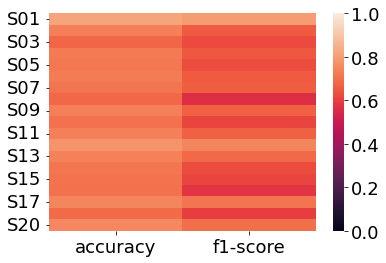

     class0 f1-score  class1 f1-score
S01         0.882591         0.613333
S02         0.836364         0.262295
S03         0.795699         0.219178
S04         0.830065         0.235294
S05         0.830325         0.145455
S06         0.834483         0.200000
S07         0.812721         0.329114
S08         0.809061         0.032787
S09         0.838710         0.242424
S10         0.819355         0.151515
S11         0.836364         0.237288
S12         0.858182         0.493506
S13         0.835088         0.356164
S14         0.825503         0.187500
S15         0.822368         0.129032
S16         0.823151         0.000000
S17         0.839695         0.400000
S19         0.811881         0.123077
S20         0.844291         0.366197


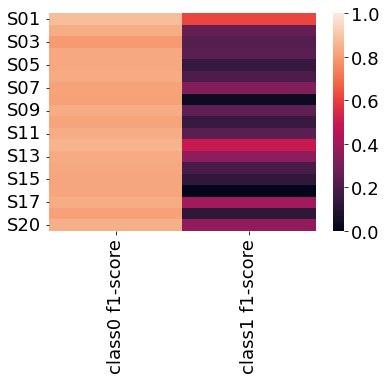

In [49]:
userfold_results_summary(participants_dictionary, participants)
userfold_classwise_results_summary(participants_dictionary, participants)


In [57]:
participant_grad={"AUC":[],"ROC":[],"STD":[]}
for i in range(len(participants)):
    g= pickle.load(
            open(
                os.path.join(
                    saved_dir, f"Userfold-{participants[i]}-EEGNet-IE_Multivariate-grad_all-e{n_epochs}.pkl"
                ),"rb"
            )
    )
    
    participant_grad["AUC"].append(
        pd.DataFrame(
            Grad_AUC_with_multivar_grad(
                g, n_epochs, np.zeros(input_dim), x_shape=0, scaling=True
            )
        ).to_numpy()
    )
    participant_grad["ROC"].append(
          pd.DataFrame(
            Grad_ROC_with_multivar_grad(
                g, n_epochs, np.zeros(input_dim), x_shape=0, scaling=True
                                       )
          ).to_numpy()
    )
    participant_grad["STD"].append(
        pd.DataFrame(
            Grad_STD_with_multivar_grad(
                g, n_epochs, np.zeros(input_dim), x_shape=0, scaling=True
                                       )
        ).to_numpy()
    )
    
avg_grad={
    "AUC":np.array(participant_grad["AUC"]).mean(0),
    "ROC":np.array(participant_grad["ROC"]).mean(0),
    "STD":np.array(participant_grad["STD"]).mean(0)
}

In [51]:
start=-0.5
step=1.5/(188-1)
timestep_labels=[]
for i in range(input_dim[1]):
    timestep_labels.append(round(start+step*i,3))
    
# timestep_labels

In [52]:
# channel_names=[i for i in range(input_dim[0])]
channel_names=["AFz","F3","F1","Fz","F2","F4","FC5","FC3","FC1","FCz","FC2",
               "FC4","FC6","C5","C3","C1","Cz","C2","C4","C6","CP5","CP3",
               "CP1","CPz","CP2","CP4","CP6","P3","P1","Pz","P2","P4"]

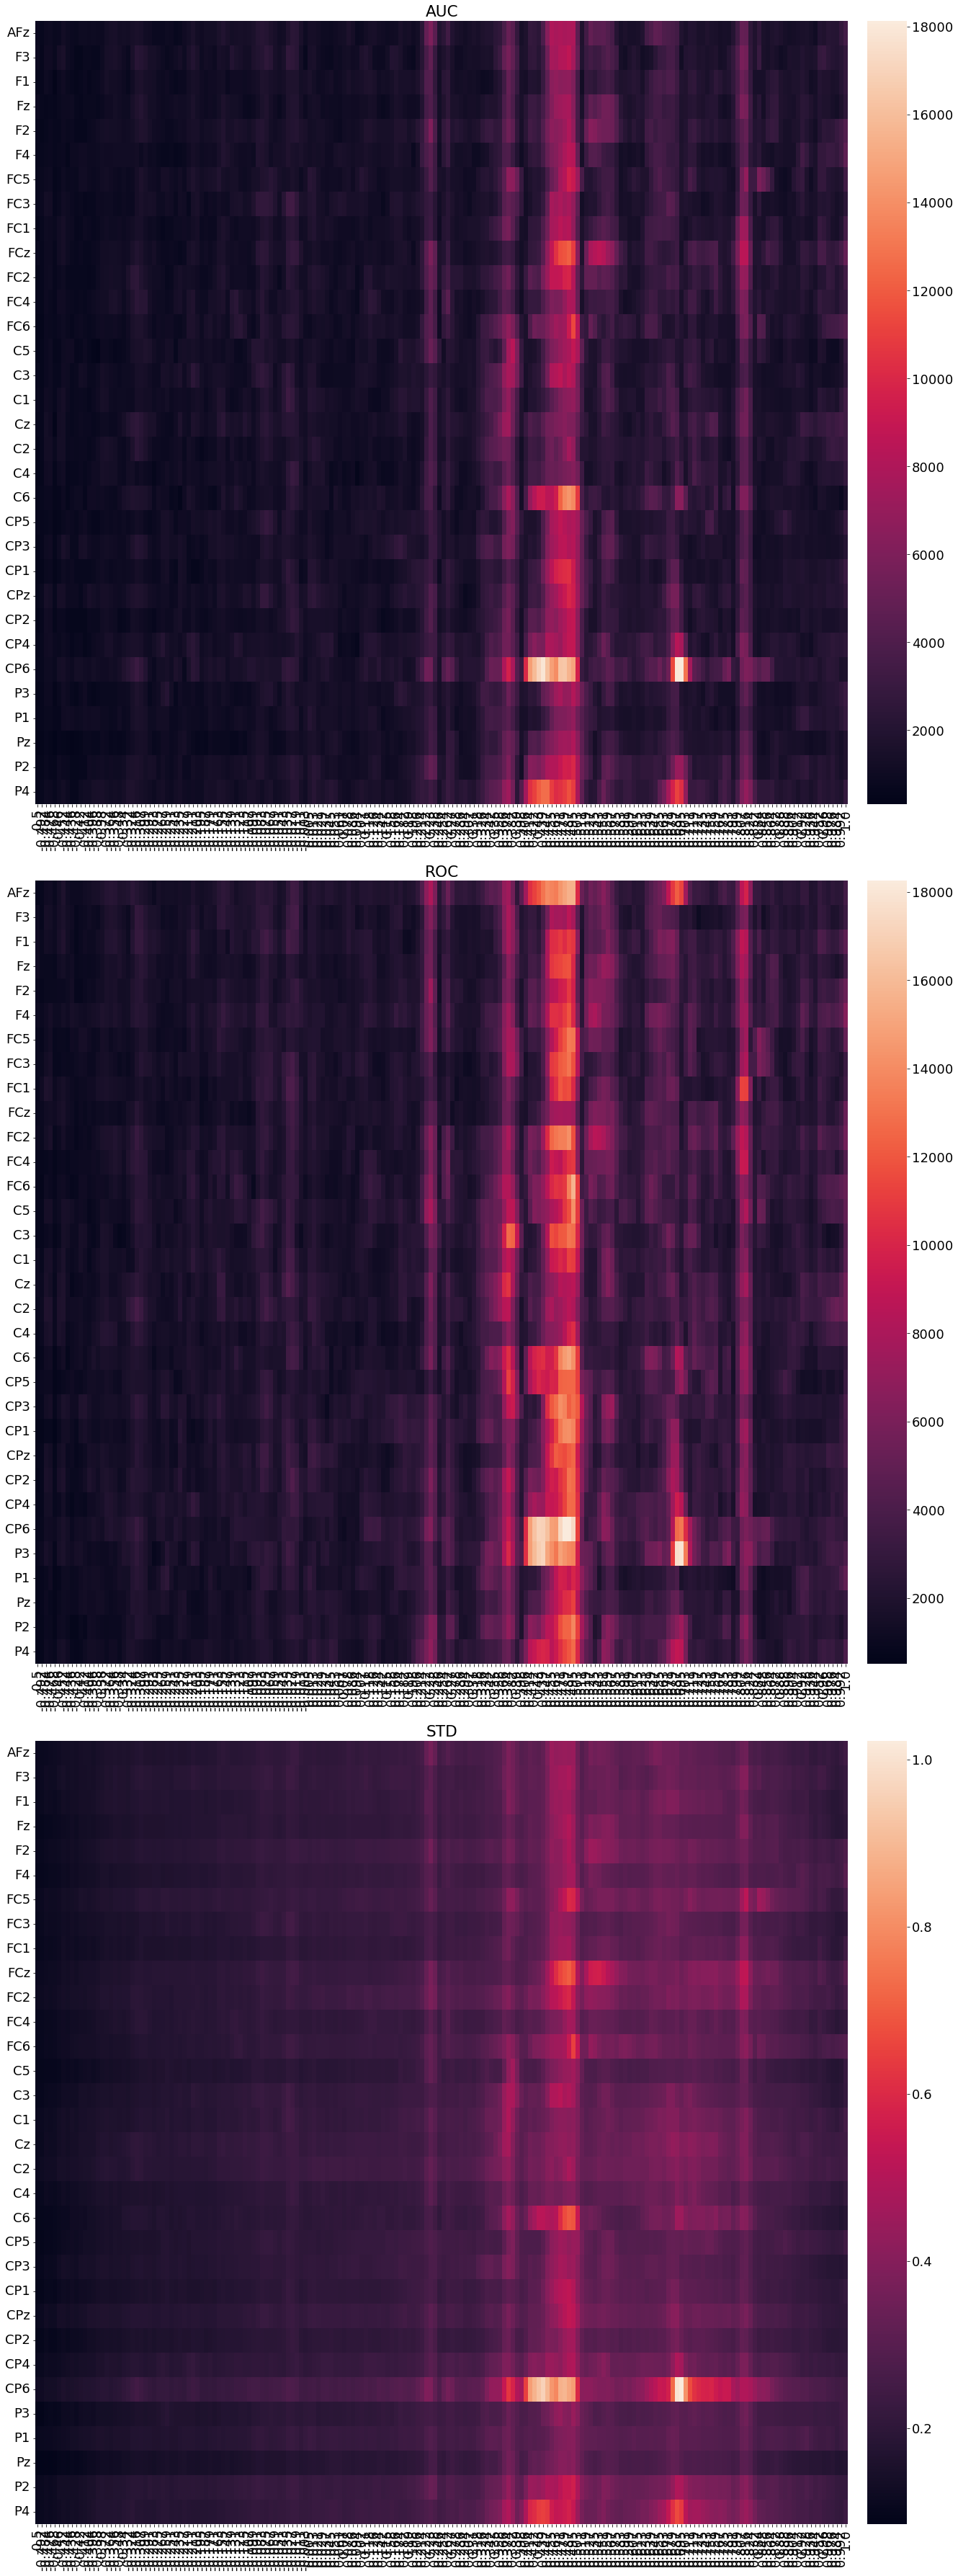

In [53]:
# from utilities.subset_func import *
# from utilities.utility_func import return_channels_index, return_timestep_labels

# channels_index= return_channels_index()
# timestep_labels= return_timestep_labels()
fig, ax= plt.subplots(3,1)

# x_shape=0
# dictionaries={"AUC":[],"ROC":[],"STD":[]}
# for idx,p in enumerate(participants):
#     dictionary= Grad_AUC_with_multivar_grad(participants_grads_dictionary[p],
#                                             n_epochs,
#                                             X=np.zeros(input_dim),
#                                             x_shape=x_shape
#                                            )
#     dictionaries["AUC"].append(pd.DataFrame(dictionary).to_numpy())
# #     sns.heatmap(pd.DataFrame(dictionary), 
# #                 xticklabels=timestep_labels,
# #                 yticklabels=channels_index,
# #                 annot=False, ax=ax[idx], cbar_kws={"pad":0.02})
#     dictionary= Grad_ROC_with_multivar_grad(participants_grads_dictionary[p],
#                                             n_epochs,
#                                             np.zeros(input_dim),
#                                             x_shape=x_shape
#                                            )
#     dictionaries["ROC"].append(pd.DataFrame(dictionary).to_numpy())

#     dictionary= Grad_STD_with_multivar_grad(participants_grads_dictionary[p],
#                                             n_epochs,
#                                             np.zeros(input_dim),
#                                             x_shape=x_shape
#                                            )
#     dictionaries["STD"].append(pd.DataFrame(dictionary).to_numpy())


#     ax[idx].set_ylabel(f"{p}")

sns.heatmap(pd.DataFrame(avg_grad["AUC"]), 
            xticklabels=timestep_labels,
            yticklabels=channel_names, ax=ax[0],
            annot=False, cbar_kws={"pad":0.02})

ax[0].set_title("AUC")

sns.heatmap(pd.DataFrame(avg_grad["ROC"]), 
            xticklabels=timestep_labels,
            yticklabels=channel_names, ax=ax[1],
            annot=False, cbar_kws={"pad":0.02})
ax[1].set_title("ROC")

sns.heatmap(pd.DataFrame(avg_grad["STD"]), 
            xticklabels=timestep_labels,
            yticklabels=channel_names, ax=ax[2],
            annot=False, cbar_kws={"pad":0.02})
ax[2].set_title("STD")

# plt.suptitle("Relative Importance Estimate of Time Series")
fig.set_figwidth(20)
fig.set_figheight(50)
plt.tight_layout()

In [11]:
# timestep_labels[99:99+62]

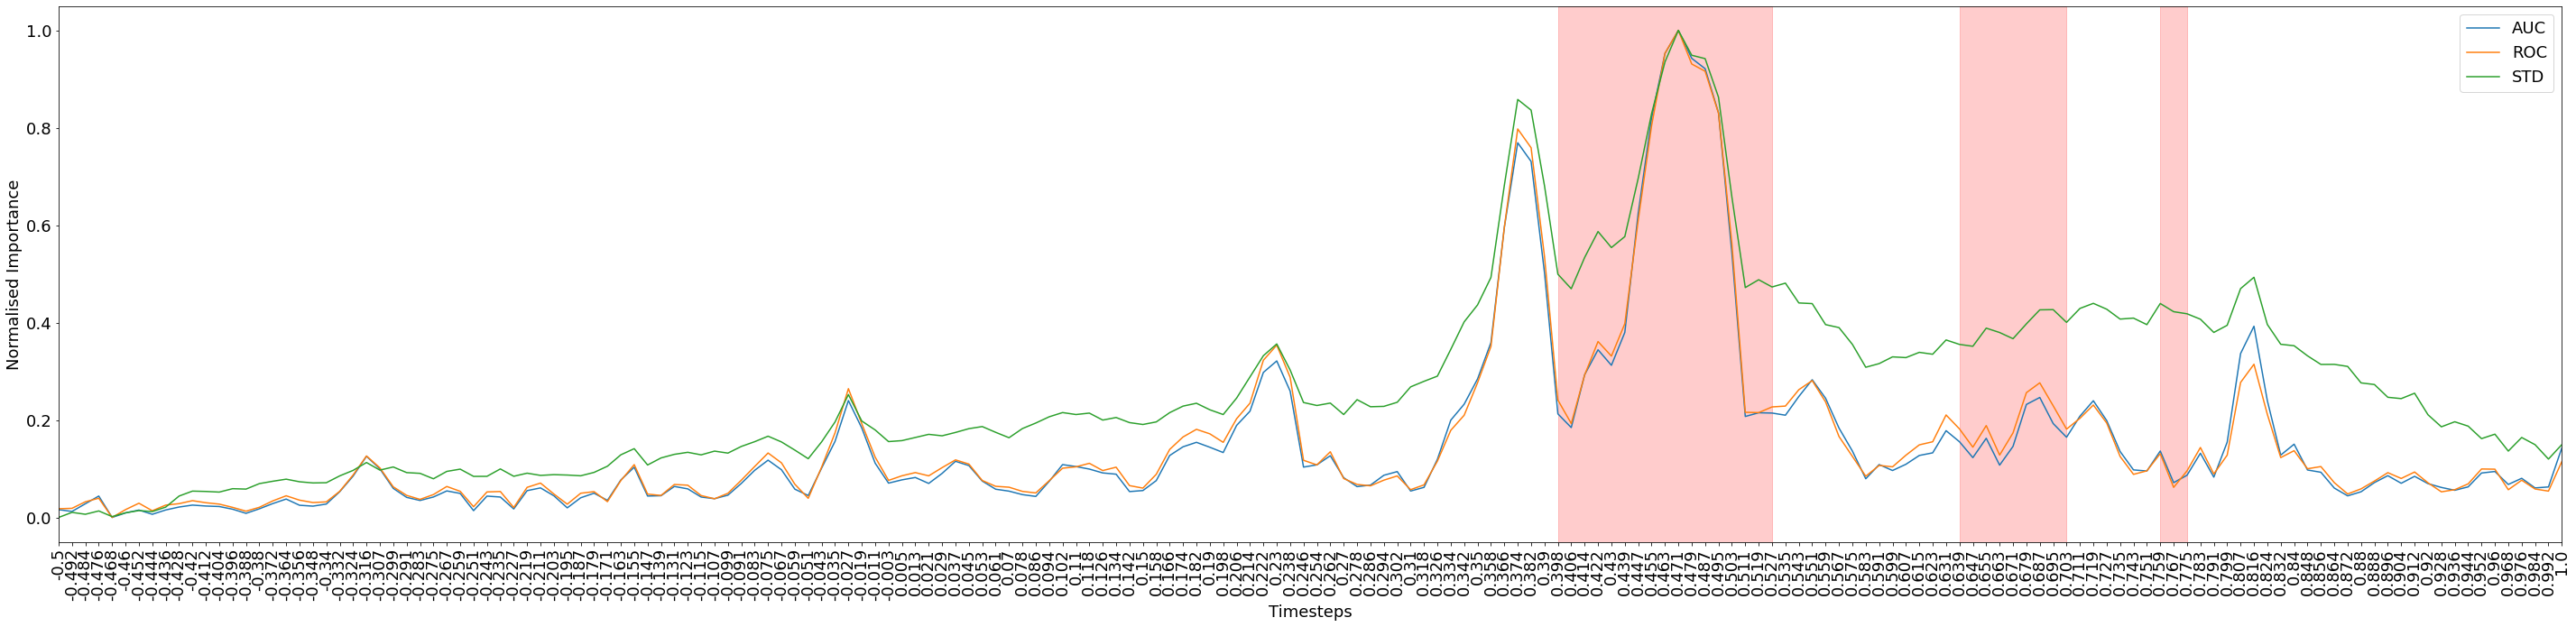

In [293]:
# import matplotlib.pyplot as plt
# plt.figure(figsize=(40,10))

# for i in range(len(methods)):
#     scaler= MinMaxScaler()
#     df= pd.DataFrame(np.array(dictionaries[methods[i]]).mean(axis=0))

#     # #     channel_nonzero_count= np.count_nonzero(df.to_numpy()>threshold, axis=1)

#     # #     df_with_zeros= pd.DataFrame(channel_nonzero_count)
#     df.index= channel_names
#     df.columns=timestep_labels
    
#     df_list["time"][methods[i]]=df.sum().to_numpy().reshape(-1)
# #     nonzeros_list= (df_with_zeros>0).to_numpy().reshape(-1)
# #     df= df_with_zeros[nonzeros_list]
#     scaled= scaler.fit_transform(df.sum().to_numpy().reshape(-1,1))
#     plt.plot(scaled)
# plt.legend(methods)
# plt.xlabel("Timesteps")
# plt.axvspan(112,128, color="red", alpha=0.2)
# plt.axvspan(142,150, color="red", alpha=0.2)
# plt.axvspan(157,159, color="red", alpha=0.2)
# plt.xticks([i for i in range(len(timestep_labels))],timestep_labels, rotation="vertical")
# plt.ylabel("Normalised Importance")
# plt.margins(x=0)
# plt.tight_layout()
# #     sns.heatmap(df.sum().to_numpy().reshape(-1,1),annot=True, 
# #                 yticklabels=timestep_labels, ax=ax[i][1],
# #                 xticklabels=False, cbar_kws={"pad":0.02})

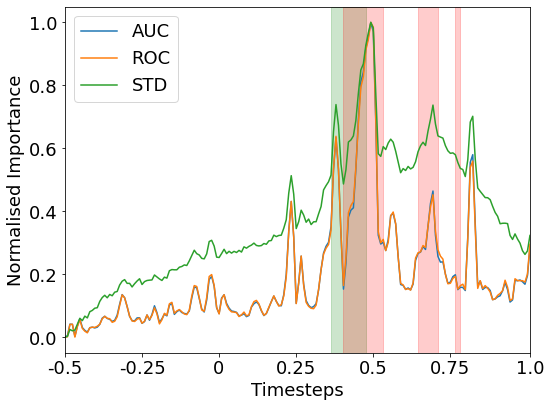

In [54]:
import matplotlib
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, RobustScaler
plt.figure(figsize=(8,6))
methods=["AUC", "ROC", "STD"]
for i in methods:
    scaler= MinMaxScaler()
    scaled_avg_grad= scaler.fit_transform(avg_grad[i].sum(0).reshape(-1,1))
    df= pd.DataFrame(scaled_avg_grad)    
#     df.index= channel_names
#     df.columns=timestep_labels
    
#     scaled= scaler.fit_transform(df.sum().to_numpy().reshape(-1,1))
    plt.plot(scaled_avg_grad)
plt.legend(methods)
plt.xlabel("Timesteps")
plt.axvspan(107,121, color="green", alpha=0.2)
plt.axvspan(112,128, color="red", alpha=0.2)
plt.axvspan(142,150, color="red", alpha=0.2)
plt.axvspan(157,159, color="red", alpha=0.2)
plt.xticks([0,31,62,93,124,155,187],[-0.5, -0.25, 0, 0.25, 0.5, 0.75, 1.0])
plt.ylabel("Normalised Importance")
plt.margins(x=0)
matplotlib.rcParams.update({"font.size":18})
plt.tight_layout()


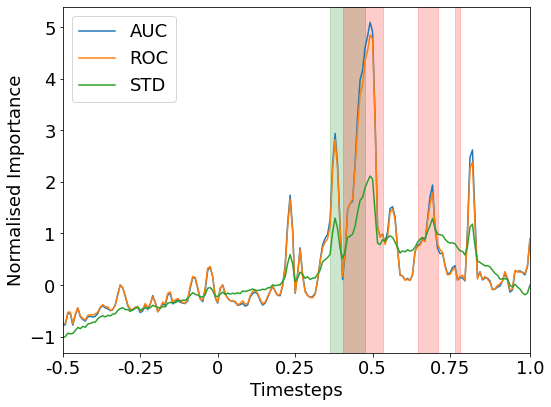

In [55]:
import matplotlib
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, RobustScaler
plt.figure(figsize=(8,6))
methods=["AUC", "ROC", "STD"]
for i in methods:
    scaler= RobustScaler()
    scaled_avg_grad= scaler.fit_transform(avg_grad[i].sum(0).reshape(-1,1))
    df= pd.DataFrame(scaled_avg_grad)    
#     df.index= channel_names
#     df.columns=timestep_labels
    
#     scaled= scaler.fit_transform(df.sum().to_numpy().reshape(-1,1))
    plt.plot(scaled_avg_grad)
plt.legend(methods)
plt.xlabel("Timesteps")
plt.axvspan(107,121, color="green", alpha=0.2)
plt.axvspan(112,128, color="red", alpha=0.2)
plt.axvspan(142,150, color="red", alpha=0.2)
plt.axvspan(157,159, color="red", alpha=0.2)
plt.xticks([0,31,62,93,124,155,187],[-0.5, -0.25, 0, 0.25, 0.5, 0.75, 1.0])
plt.ylabel("Normalised Importance")
plt.margins(x=0)
matplotlib.rcParams.update({"font.size":18})
plt.tight_layout()


In [134]:
# coordinates= np.array([
#     [0.0002313, 0.080771], #AFz
#     [-0.0502438,  0.0531112], #F3
#     [-0.0274958,  0.0569311], #F1
#     [0.0003122, 0.058512], #Fz
#     [0.0295142, 0.0576019], #F2
#     [0.0518362, 0.0543048], #F4
#     [-0.0772149,  0.0186433], #FC5
#     [-0.0601819,  0.0227162], #FC3
#     [-0.0340619,  0.0260111], #FC1
#     [0.0003761, 0.02739], #FCz
#     [0.0347841, 0.0264379], # FC2
#     [0.0622931, 0.0237228], #FC4
#     [0.0795341, 0.0199357], #FC6
#     [-0.0802801, -0.0137597], #C5
#     [-0.0653581, -0.0116317], # C3
#     [-0.036158 , -0.0099839], # C1
#     [0.0004009, -0.009167], # Cz
#     [0.037672 , -0.0096241], # C2
#     [0.0671179, -0.0109003], #C4
#     [0.0834559, -0.0127763], #C6
#     [-0.0795922, -0.0465507], #CP5
#     [-0.0635562, -0.0470088], #CP3
#     [-0.0355131, -0.0472919], #CP1
#     [0.0003858, -0.047318], #CPz
#     [0.0383838, -0.0470731], #CP2
#     [0.0666118, -0.0466372], #CP4
#     [0.0833218, -0.0461013], #CP6
#     [-0.0530073, -0.0787878], #P3
#     [-0.0286203, -0.0805249], #P1
#     [0.0003247, -0.081115], #Pz
#     [0.0319197, -0.0804871], #P2
#     [0.0556667, -0.0785602], #P4
# ])
# x=coordinates[:,0]
# y=coordinates[:,1]

In [2]:
# for i in range(len(coordinates)):
#     plt.scatter(x[i],y[i])
# # plt.legend(channel_names)

In [1]:
# _=mne.channels.make_standard_montage("standard_1020")
# _.get_positions()

In [3]:
# import mne
# _=mne.channels.make_standard_montage("standard_1020").plot(sphere=0.11)

In [284]:
# import matplotlib
# fig= plt.figure()
# ax= plt.axes((0,0,1.5,1.5))
# im, _= mne.viz.plot_topomap(
#     df.T.sum().to_numpy().reshape(-1),
#     coordinates,
#     ch_type= "eeg",
#     sensors=True,
#     names=channel_names,
#     cmap="Blues",
#     axes=ax,
#     show=False
# #     res=4000
# )
# fig.add_axes(ax)
# cbar_ax= fig.add_axes([1.3,0.2, 0.1,1])
# clb= fig.colorbar(im, cax=cbar_ax)

# for tt in plt.findobj(fig, matplotlib.text.Text):
#     if tt.get_text() in channel_names:
#         tt.set_fontsize(12)

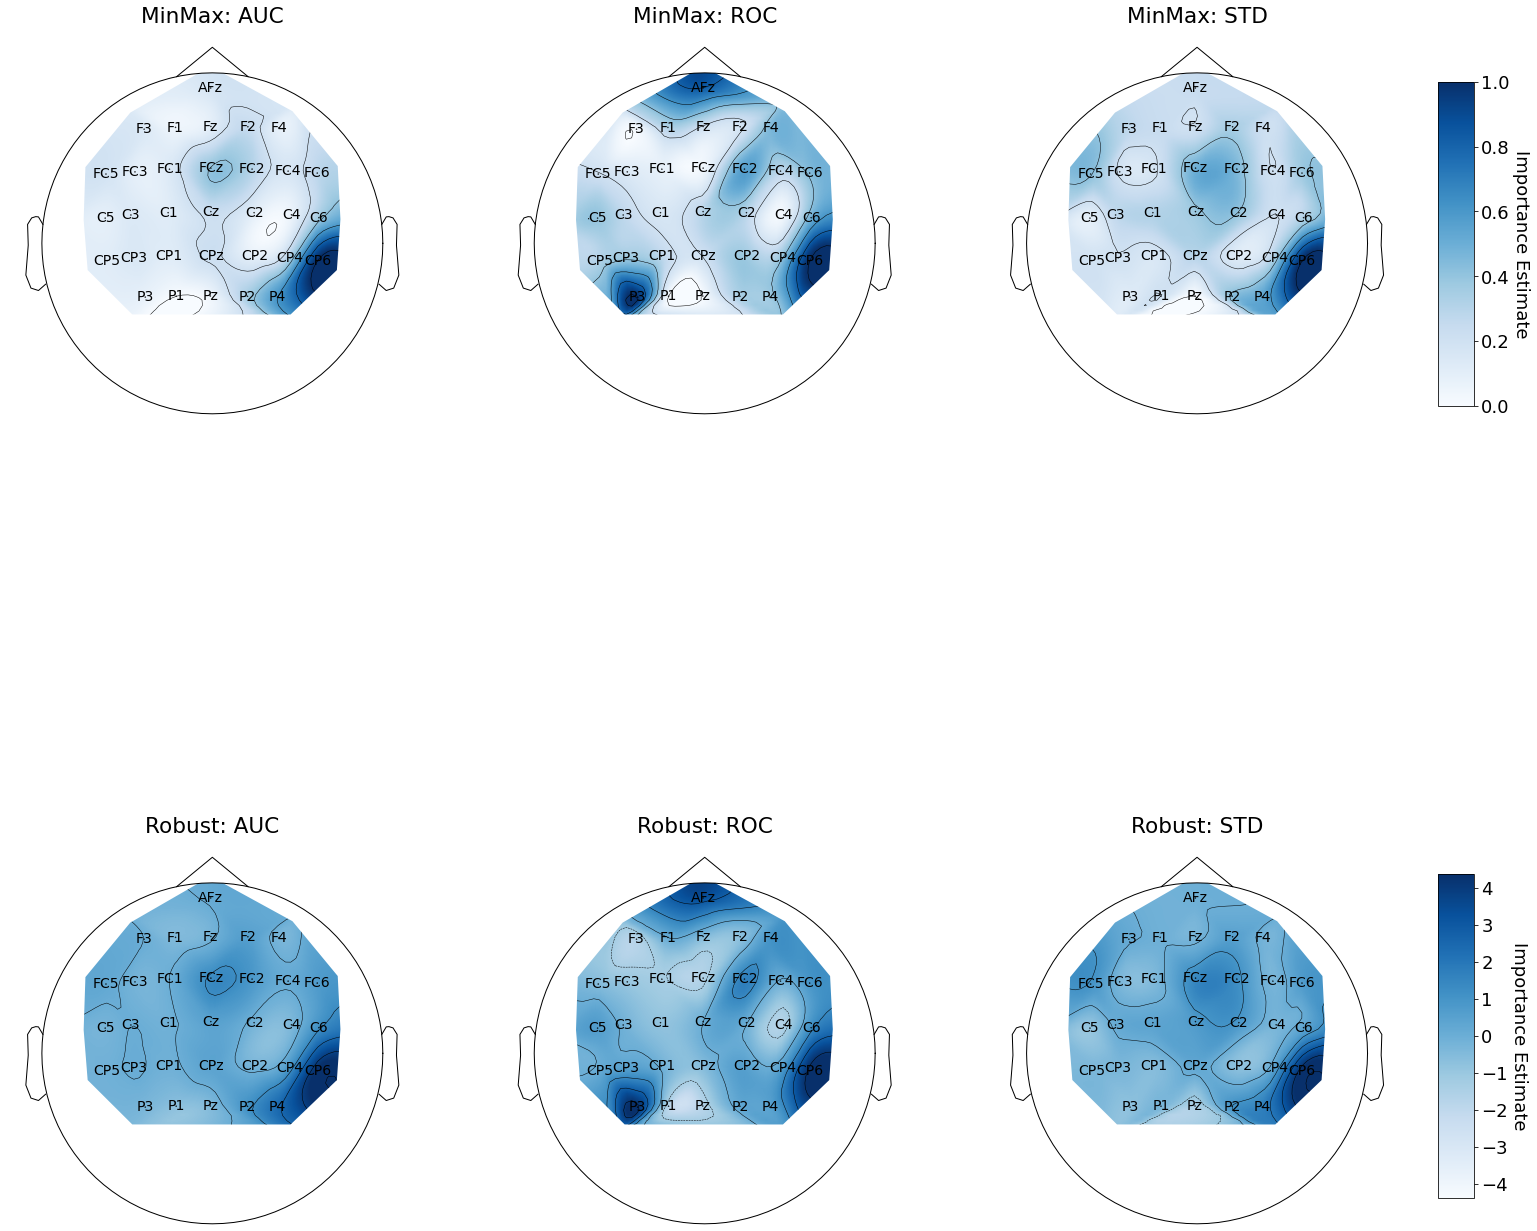

In [56]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
import matplotlib
import mne
info= mne.create_info(channel_names, sfreq=500, ch_types=32*["eeg"])
info.set_montage("standard_1020")

fig, ax= plt.subplots(2,3)
# ax= plt.axes((0,0,1.5,1.5))
for idx, i in enumerate(methods):
    scaler= MinMaxScaler()
    scaled_avg_grad= scaler.fit_transform(avg_grad[i].sum(1).reshape(-1,1))
#     scaled_avg_grad= avg_grad[i].sum(1)

    minmax_im, _= mne.viz.plot_topomap(
        scaled_avg_grad.reshape(-1),
        info,
        ch_type= "eeg",
        sensors=True,
        names=channel_names,
        cmap="Blues",
        axes=ax[0][idx],
        show=False,
        extrapolate="local"
        #,vlim=(0,1)
    #     sphere=0.09
    )
    ax[0][idx].set_title(f"MinMax: {i}")
    
for idx, i in enumerate(methods):
    scaler= RobustScaler()
    scaled_avg_grad= scaler.fit_transform(avg_grad[i].sum(1).reshape(-1,1))
#     scaled_avg_grad= avg_grad[i].sum(1)

    robust_im, _= mne.viz.plot_topomap(
        scaled_avg_grad.reshape(-1),
        info,
        ch_type= "eeg",
        sensors=True,
        names=channel_names,
        cmap="Blues",
        axes=ax[1][idx],
        show=False,
        extrapolate="local",
#         vlim=(0,None)
    #     sphere=0.09
    )
    ax[1][idx].set_title(f"Robust: {i}")
    
fig.set_figheight(25)
fig.set_figwidth(25)
# fig.add_axes(ax)
cbar_ax= fig.add_axes([.92,0.66, 0.02,0.18])
clb= fig.colorbar(minmax_im, cax=cbar_ax)
clb.set_label("Importance Estimate", rotation=270,labelpad=20, fontsize=18)

cbar_ax= fig.add_axes([.92,0.22, 0.02,0.18])
clb= fig.colorbar(robust_im, cax=cbar_ax)
clb.set_label("Importance Estimate", rotation=270,labelpad=20, fontsize=18)

for tt in plt.findobj(fig, matplotlib.text.Text):
    if tt.get_text() in channel_names:
        tt.set_fontsize(14)
# plt.tight_layout()

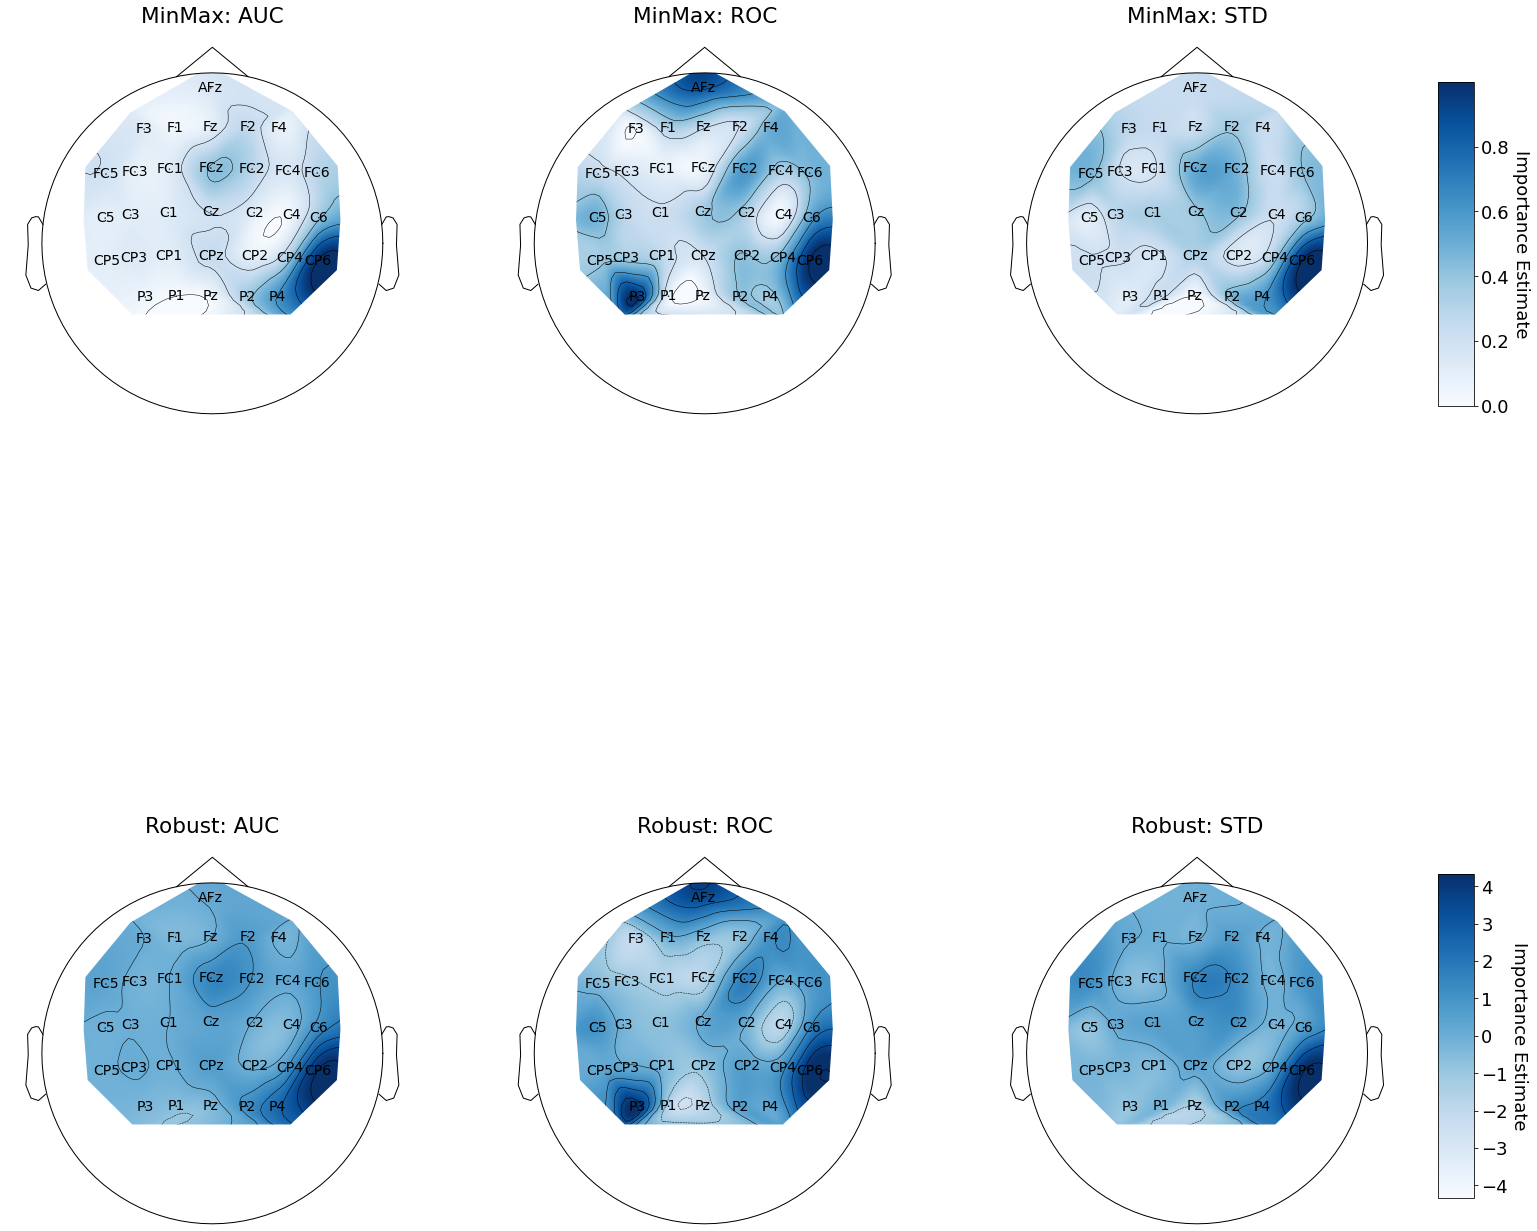

In [58]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
import matplotlib
import mne
info= mne.create_info(channel_names, sfreq=500, ch_types=32*["eeg"])
info.set_montage("standard_1020")

fig, ax= plt.subplots(2,3)
# ax= plt.axes((0,0,1.5,1.5))
for idx, i in enumerate(methods):
    scaler= MinMaxScaler()
    scaled_avg_grad= scaler.fit_transform(avg_grad[i].sum(1).reshape(-1,1))
#     scaled_avg_grad= avg_grad[i].sum(1)

    minmax_im, _= mne.viz.plot_topomap(
        scaled_avg_grad.reshape(-1),
        info,
        ch_type= "eeg",
        sensors=True,
        names=channel_names,
        cmap="Blues",
        axes=ax[0][idx],
        show=False,
        extrapolate="local"
        #,vlim=(0,1)
    #     sphere=0.09
    )
    ax[0][idx].set_title(f"MinMax: {i}")
    
for idx, i in enumerate(methods):
    scaler= RobustScaler()
    scaled_avg_grad= scaler.fit_transform(avg_grad[i].sum(1).reshape(-1,1))
#     scaled_avg_grad= avg_grad[i].sum(1)

    robust_im, _= mne.viz.plot_topomap(
        scaled_avg_grad.reshape(-1),
        info,
        ch_type= "eeg",
        sensors=True,
        names=channel_names,
        cmap="Blues",
        axes=ax[1][idx],
        show=False,
        extrapolate="local",
#         vlim=(0,None)
    #     sphere=0.09
    )
    ax[1][idx].set_title(f"Robust: {i}")
    
fig.set_figheight(25)
fig.set_figwidth(25)
# fig.add_axes(ax)
cbar_ax= fig.add_axes([.92,0.66, 0.02,0.18])
clb= fig.colorbar(minmax_im, cax=cbar_ax)
clb.set_label("Importance Estimate", rotation=270,labelpad=20, fontsize=18)

cbar_ax= fig.add_axes([.92,0.22, 0.02,0.18])
clb= fig.colorbar(robust_im, cax=cbar_ax)
clb.set_label("Importance Estimate", rotation=270,labelpad=20, fontsize=18)

for tt in plt.findobj(fig, matplotlib.text.Text):
    if tt.get_text() in channel_names:
        tt.set_fontsize(14)
# plt.tight_layout()